In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from tensorflow.keras.models import model_from_json

import os
import joblib
import pickle
import json

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import matplotlib.image as mpimg

import stability as st

import statistics
import scipy as scp
import math

import lime
from lime import lime_tabular

import shap

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/Diabetes/"
PATH = "C:/Users/velmurug/Documents/Stability Experiments/Breast Cancer/"
model_filename = os.path.join(PATH, "models/model_h5_N12_DUO.json")
weights_filename = os.path.join(PATH, "models/model_h5_N12_DUO.h5")
dataset_path = 'datasets/'

json_file = open(model_filename, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights(weights_filename)
print("Loaded model from disk")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/velmurug/Documents/Stability Experiments/Breast Cancer/models/model_h5_N12_DUO.json'

In [ ]:
tp_file = os.path.join(PATH, "datasets/dicts/NN_true_pos.pkl")
with open (tp_file, 'rb') as f:
    results = pickle.load(f)
    
f.close()

In [ ]:
X_train = pd.read_csv(PATH + "datasets/breast_cancer_Xtrain.csv", index_col=False).values
X_test = pd.read_csv(PATH + "datasets/breast_cancer_Xtest.csv", index_col=False).values
X_validation =pd.read_csv(PATH + "datasets/breast_cancer_Xvalidation.csv",index_col=False).values
y_train = pd.read_csv(PATH + "datasets/breast_cancer_Ytrain.csv",index_col=False).values
y_test =pd.read_csv(PATH + "datasets/breast_cancer_Ytest.csv", index_col=False).values
y_validation = pd.read_csv(PATH + "datasets/breast_cancer_Yvalidation.csv", index_col=False).values

original_data = pd.read_csv(PATH + "datasets/breast_cancer.csv")
original_data = original_data.dropna(axis = 'columns')
original_data = original_data.drop(['id'], axis = 1)
feature_names = original_data.drop(["diagnosis"], axis = 1).columns

In [ ]:
predictions = model.predict(X_test)

In [ ]:
MAX_FEAT = 10

start_time = time.time()

# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["Benign", "Malignant"], verbose=False, mode='classification')

elapsed = time.time() - start_time

print ("Time taken to create explainer:", round(elapsed, 2), "seconds")

In [10]:
stability_scores = []
probas = []
instances = []

feat_list = list(feature_names)

for instance in results:
    print ("Running instance", results.index(instance))
    
    feat_pres = []
    instances.append(intance['index'])

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    prediction = instance['predictions']
    probas.append(instance['prediction_probability'][1])
    
    start_time = time.time()
    # explain instance
    
    for iteration in range(10):
        print("Run", iteration)
        lime_exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = 30)
        
        #For stability by index
        presence_list = [0]*len(feat_list)
    
        for each in feat_list:
            list_idx = feat_list.index(each)
            #print ("Feature", list_idx)
            for explanation in lime_exp.as_list(prediction):
                if each in explanation[0]:
                    if lime_exp.as_list(prediction).index(explanation) < MAX_FEAT:
                        presence_list[list_idx] = 1
                        
        feat_pres.append(presence_list)
        
        #method 1 - Nogueira, Sechidis, Brown.
    stability = st.getStability(feat_pres[:10])
    print ("Stability:", round(stability,2))
    stability_scores.append(stability)
 
    print("\n--------------------------------------------------------------------------------------------\n")

# SHAP

In [ ]:
X_train_frame = pd.DataFrame(data = X_train, columns = feature_names)
X_test_frame = pd.DataFrame(data = X_test, columns = feature_names)

data_sample = shap.kmeans(X_train_frame, 100)
shap_explainer = shap.KernelExplainer(model.predict, data_sample)#, link = 'identity')

shap.initjs()

In [ ]:
    def create_samples(shap_explainer, iterations, row, features, top = 10):
        #print(features)
        length = len(features)
        #print (list(range(length)))
        exp = []
        rel_exp = []

        for j in range(iterations):
            #print(X_test_frame.loc[row])

            if type(shap_explainer) == shap.KernelExplainer:
                shap_values = shap_explainer.shap_values(row)

                importances = []

                for i in range(length):
                    feat = features[i]
                    shap_val = shap_values[0][0][i]
                    abs_val = abs(shap_values[0][0][i])
                    entry = (feat, shap_val, abs_val)
                    importances.append(entry)
                    #print(entry)
            else:
                #print(row)
                shap_values = shap_explainer.shap_values(row)
                #print(shap_values)

                importances = []

                for i in list(range(length)):
                    #print(i)
                    feat = features[i]
                    shap_val = shap_values[0][0][i]
                    abs_val = abs(shap_values[0][0][i])
                    entry = (feat, shap_val, abs_val)
                    importances.append(entry)
                    #print(entry)

            importances.sort(key=lambda tup: tup[2], reverse = True)

            exp.append(importances)

            rel_feat = []

            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)

        return exp, rel_exp

In [25]:
shap_stability_scores = []
probas = []

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    probas.append(instance['prediction_probability'][1])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(shap_explainer, 100, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    #print(rel_exp)
    
    feat_pres = []
    
    for iteration in rel_exp:
        print("Iteration", rel_exp.index(iteration))
        #print(iteration)

        #Stability by index
        presence_list = [0]*len(feat_list)
        
        for each in feat_list:
            list_idx = feat_list.index(each)
            #print ("Feature", list_idx)
            for explanation in iteration:
                if each in explanation[0]:
                    #by index
                    presence_list[list_idx] = 1
                    
        feat_pres.append(presence_list)
        
    stability = st.getStability(feat_pres)
    print ("Stability:", round(stability,2))
    shap_stability_scores.append(stability)

INDEX = 0



[array([[ 0.        ,  0.        , -0.00767548, -0.00529869, -0.00204473,
         0.00555173, -0.02448503, -0.03142735,  0.0030755 ,  0.00468304,
         0.01809186,  0.04598066,  0.        ,  0.01345486, -0.00922419,
         0.02135658,  0.00234171,  0.01887898,  0.01462641,  0.01712413,
        -0.0013129 , -0.07655718, -0.01030462,  0.00143419, -0.01712753,
        -0.02847573, -0.01179858, -0.0597829 , -0.01192297,  0.00952497]]), array([[ 0.        ,  0.        ,  0.00767548,  0.0052987 ,  0.00204473,
        -0.00555173,  0.02448503,  0.03142735, -0.0030755 , -0.00468304,
        -0.01809186, -0.04598066,  0.        , -0.01345486,  0.00922419,
        -0.02135658, -0.00234171, -0.01887898, -0.01462641, -0.01712413,
         0.0013129 ,  0.07655718,  0.01030462, -0.00143419,  0.01712753,
         0.02847573,  0.01179858,  0.0597829 ,  0.01192297, -0.00952497]])]



[array([[ 0.        ,  0.        , -0.00802977, -0.00261717,  0.00186435,
         0.00427802, -0.02526261, -0.03000567,  0.00315959,  0.00522165,
         0.01891894,  0.04769836,  0.        ,  0.01373248, -0.01138968,
         0.01896333,  0.        ,  0.01857744,  0.01447639,  0.0166445 ,
         0.        , -0.07803922, -0.00838763,  0.00120964, -0.0178509 ,
        -0.02972015, -0.01156567, -0.05944079, -0.01298539,  0.00923669]]), array([[ 0.        ,  0.        ,  0.00802977,  0.00261717, -0.00186435,
        -0.00427803,  0.02526261,  0.03000567, -0.00315959, -0.00522165,
        -0.01891894, -0.04769836,  0.        , -0.01373248,  0.01138968,
        -0.01896333,  0.        , -0.01857744, -0.01447639, -0.0166445 ,
         0.        ,  0.07803922,  0.00838763, -0.00120964,  0.0178509 ,
         0.02972015,  0.01156567,  0.05944079,  0.0129854 , -0.00923669]])]



[array([[ 0.        ,  0.        , -0.00790913, -0.00475943,  0.        ,
         0.00378717, -0.02358077, -0.02999317,  0.00337289,  0.00460313,
         0.01813253,  0.04600879,  0.        ,  0.01349197, -0.0095896 ,
         0.01768361,  0.00201879,  0.01992538,  0.01586299,  0.01740177,
         0.        , -0.0770705 , -0.01008396,  0.        , -0.01843732,
        -0.02941112, -0.01136878, -0.0592665 , -0.01125616,  0.00912418]]), array([[ 0.        ,  0.        ,  0.00790913,  0.00475943,  0.        ,
        -0.00378717,  0.02358077,  0.02999317, -0.00337289, -0.00460313,
        -0.01813253, -0.04600879,  0.        , -0.01349197,  0.0095896 ,
        -0.01768361, -0.00201879, -0.01992538, -0.01586299, -0.01740177,
         0.        ,  0.0770705 ,  0.01008396,  0.        ,  0.01843732,
         0.02941112,  0.01136878,  0.05926651,  0.01125616, -0.00912418]])]



[array([[ 0.        ,  0.        , -0.00799541, -0.00453983, -0.00216676,
         0.00466355, -0.02252709, -0.02973059,  0.00448077,  0.0071658 ,
         0.01755486,  0.0475693 , -0.00172739,  0.01494708, -0.01121026,
         0.01856958,  0.        ,  0.01713484,  0.01544119,  0.01567544,
         0.        , -0.07761111, -0.00901045,  0.00307976, -0.01798655,
        -0.02894662, -0.0118334 , -0.05933914, -0.0128765 ,  0.00990567]]), array([[ 0.        ,  0.        ,  0.00799541,  0.00453984,  0.00216676,
        -0.00466355,  0.02252709,  0.02973059, -0.00448077, -0.0071658 ,
        -0.01755486, -0.0475693 ,  0.00172739, -0.01494708,  0.01121026,
        -0.01856958,  0.        , -0.01713484, -0.01544119, -0.01567544,
         0.        ,  0.07761111,  0.00901045, -0.00307976,  0.01798655,
         0.02894662,  0.0118334 ,  0.05933914,  0.0128765 , -0.00990567]])]



[array([[ 0.        ,  0.        , -0.00787539, -0.00499059, -0.00233134,
         0.00438355, -0.02408696, -0.03116459,  0.00367359,  0.00535894,
         0.01678225,  0.04778924,  0.        ,  0.01557265, -0.01085873,
         0.01723313,  0.        ,  0.01763213,  0.01701577,  0.01875885,
         0.        , -0.076238  , -0.00996028,  0.00167636, -0.01602448,
        -0.0304243 , -0.0100004 , -0.05878635, -0.01366503,  0.00921671]]), array([[ 0.        ,  0.        ,  0.00787539,  0.00499059,  0.00233134,
        -0.00438355,  0.02408696,  0.03116459, -0.00367359, -0.00535894,
        -0.01678225, -0.04778924,  0.        , -0.01557265,  0.01085873,
        -0.01723313,  0.        , -0.01763213, -0.01701577, -0.01875885,
         0.        ,  0.076238  ,  0.00996028, -0.00167636,  0.01602448,
         0.0304243 ,  0.0100004 ,  0.05878635,  0.01366503, -0.0092167 ]])]



[array([[ 0.        ,  0.        , -0.00783655, -0.00473062,  0.        ,
         0.00616333, -0.02335491, -0.02960502,  0.00473932,  0.00436931,
         0.01826005,  0.04604947,  0.        ,  0.01334804, -0.0113523 ,
         0.01890072,  0.        ,  0.01984882,  0.01621099,  0.01657594,
         0.        , -0.07526135, -0.00878947,  0.        , -0.01661911,
        -0.0300067 , -0.01237164, -0.06101161, -0.01374945,  0.00890947]]), array([[ 0.        ,  0.        ,  0.00783655,  0.00473062,  0.        ,
        -0.00616333,  0.02335491,  0.02960502, -0.00473932, -0.00436931,
        -0.01826005, -0.04604947,  0.        , -0.01334804,  0.0113523 ,
        -0.01890072,  0.        , -0.01984882, -0.01621099, -0.01657594,
         0.        ,  0.07526135,  0.00878947,  0.        ,  0.01661911,
         0.0300067 ,  0.01237164,  0.06101161,  0.01374945, -0.00890947]])]



[array([[ 0.        ,  0.        , -0.00900184, -0.00427676,  0.        ,
         0.00547115, -0.02358402, -0.03026713,  0.0043172 ,  0.00509932,
         0.01864706,  0.04682073, -0.00130745,  0.01394573, -0.01121536,
         0.01931764,  0.        ,  0.01861125,  0.01555476,  0.01666505,
         0.        , -0.07666021, -0.00950239,  0.        , -0.01718917,
        -0.02949307, -0.0120369 , -0.05905061, -0.0121795 ,  0.01000126]]), array([[ 0.        ,  0.        ,  0.00900184,  0.00427676,  0.        ,
        -0.00547115,  0.02358402,  0.03026713, -0.0043172 , -0.00509932,
        -0.01864706, -0.04682073,  0.00130745, -0.01394573,  0.01121536,
        -0.01931764,  0.        , -0.01861125, -0.01555476, -0.01666505,
         0.        ,  0.07666021,  0.00950239,  0.        ,  0.01718917,
         0.02949307,  0.0120369 ,  0.05905061,  0.0121795 , -0.01000126]])]



[array([[ 0.        ,  0.        , -0.00772825, -0.00539389, -0.00190118,
         0.00380209, -0.02206892, -0.02917563,  0.00333524,  0.0044    ,
         0.01811987,  0.04768778, -0.00146871,  0.01310694, -0.011095  ,
         0.01911584,  0.00146938,  0.01955754,  0.0154653 ,  0.01734188,
         0.        , -0.07861214, -0.01013541,  0.00148664, -0.01737724,
        -0.0281765 , -0.01265039, -0.05838032, -0.01130603,  0.00926785]]), array([[ 0.        ,  0.        ,  0.00772825,  0.00539389,  0.00190118,
        -0.00380209,  0.02206892,  0.02917563, -0.00333524, -0.0044    ,
        -0.01811987, -0.04768778,  0.00146871, -0.01310695,  0.011095  ,
        -0.01911584, -0.00146938, -0.01955754, -0.01546529, -0.01734188,
         0.        ,  0.07861214,  0.01013541, -0.00148664,  0.01737724,
         0.0281765 ,  0.01265039,  0.05838032,  0.01130603, -0.00926785]])]



[array([[ 0.        ,  0.        , -0.00904446, -0.00509017,  0.        ,
         0.00344629, -0.02447313, -0.02838365,  0.00430702,  0.00544461,
         0.01894993,  0.04828126,  0.        ,  0.01366838, -0.01056687,
         0.0194006 ,  0.        ,  0.01876719,  0.01415783,  0.01658669,
         0.        , -0.07652104, -0.00887778,  0.        , -0.01831069,
        -0.02866571, -0.01120368, -0.05952433, -0.01295779,  0.00929622]]), array([[ 0.        ,  0.        ,  0.00904446,  0.00509017,  0.        ,
        -0.00344629,  0.02447313,  0.02838365, -0.00430702, -0.00544461,
        -0.01894993, -0.04828126,  0.        , -0.01366838,  0.01056687,
        -0.01940059,  0.        , -0.01876719, -0.01415783, -0.01658669,
         0.        ,  0.07652104,  0.00887778,  0.        ,  0.01831069,
         0.02866571,  0.01120368,  0.05952433,  0.01295779, -0.00929622]])]



[array([[ 0.        ,  0.        , -0.00820556, -0.00545085,  0.        ,
         0.00493381, -0.02393823, -0.02925311,  0.00337699,  0.00523528,
         0.01851259,  0.04719185,  0.        ,  0.01267538, -0.01065904,
         0.01780791,  0.        ,  0.01794694,  0.01481022,  0.01855558,
         0.        , -0.07666867, -0.00975587,  0.00234816, -0.01708028,
        -0.02863235, -0.01078634, -0.0597258 , -0.01441008,  0.00985821]]), array([[ 0.        ,  0.        ,  0.00820556,  0.00545086,  0.        ,
        -0.00493381,  0.02393823,  0.02925311, -0.00337699, -0.00523528,
        -0.01851259, -0.04719185,  0.        , -0.01267538,  0.01065904,
        -0.01780791,  0.        , -0.01794694, -0.01481022, -0.01855558,
         0.        ,  0.07666867,  0.00975587, -0.00234816,  0.01708028,
         0.02863235,  0.01078634,  0.0597258 ,  0.01441008, -0.00985821]])]



[array([[ 0.        ,  0.        , -0.00895719, -0.00617693,  0.        ,
         0.00517399, -0.02353651, -0.02983161,  0.00357937,  0.0050654 ,
         0.01973754,  0.04660014,  0.        ,  0.01141198, -0.0104384 ,
         0.01882041,  0.        ,  0.01908753,  0.01557515,  0.01651177,
        -0.00172116, -0.07669312, -0.00917005,  0.00251034, -0.01668712,
        -0.02925396, -0.01139419, -0.05789535, -0.01223162,  0.00860032]]), array([[ 0.        ,  0.        ,  0.00895719,  0.00617693,  0.        ,
        -0.00517399,  0.0235365 ,  0.02983161, -0.00357937, -0.0050654 ,
        -0.01973754, -0.04660014,  0.        , -0.01141198,  0.0104384 ,
        -0.01882041,  0.        , -0.01908753, -0.01557515, -0.01651177,
         0.00172116,  0.07669312,  0.00917005, -0.00251034,  0.01668712,
         0.02925396,  0.01139419,  0.05789535,  0.01223162, -0.00860032]])]



[array([[ 0.        ,  0.00133184, -0.00760424, -0.00511589, -0.00241156,
         0.00479085, -0.02325291, -0.03010106,  0.00281749,  0.00449723,
         0.01863635,  0.04557371,  0.        ,  0.01323544, -0.01098658,
         0.01828333,  0.        ,  0.01776893,  0.01514208,  0.01704984,
         0.        , -0.07654385, -0.01053362,  0.0019246 , -0.01609929,
        -0.02929779, -0.01150796, -0.05728255, -0.01262755,  0.01099989]]), array([[ 0.        , -0.00133184,  0.00760424,  0.00511589,  0.00241156,
        -0.00479085,  0.02325291,  0.03010106, -0.00281749, -0.00449723,
        -0.01863635, -0.04557371,  0.        , -0.01323544,  0.01098657,
        -0.01828333,  0.        , -0.01776893, -0.01514208, -0.01704984,
         0.        ,  0.07654385,  0.01053362, -0.0019246 ,  0.01609929,
         0.02929779,  0.01150796,  0.05728255,  0.01262755, -0.01099989]])]



[array([[ 0.00158671,  0.        , -0.00977165, -0.00334685, -0.00119323,
         0.00530179, -0.02380848, -0.03031162,  0.00547919,  0.00470412,
         0.01883591,  0.04673505, -0.00153742,  0.01239428, -0.01026365,
         0.01906206,  0.        ,  0.02014262,  0.01609625,  0.01654271,
         0.        , -0.07590455, -0.00899794,  0.        , -0.01909777,
        -0.03102119, -0.01075355, -0.05884671, -0.0133139 ,  0.00997455]]), array([[-0.00158671,  0.        ,  0.00977165,  0.00334685,  0.00119323,
        -0.00530179,  0.02380848,  0.03031162, -0.00547919, -0.00470412,
        -0.01883591, -0.04673505,  0.00153742, -0.01239428,  0.01026365,
        -0.01906206,  0.        , -0.02014262, -0.01609625, -0.01654271,
         0.        ,  0.07590455,  0.00899794,  0.        ,  0.01909777,
         0.03102119,  0.01075355,  0.05884671,  0.0133139 , -0.00997455]])]



[array([[ 0.        ,  0.        , -0.00977704, -0.00365822, -0.00201994,
         0.00386265, -0.02297073, -0.03039096,  0.00392256,  0.00460818,
         0.0176513 ,  0.0479818 , -0.00187273,  0.01367001, -0.01050343,
         0.01866951,  0.        ,  0.01924638,  0.01579643,  0.01714179,
         0.        , -0.07671161, -0.00882202,  0.00212137, -0.01835205,
        -0.02814174, -0.01118478, -0.05880534, -0.01359109,  0.01081645]]), array([[ 0.        ,  0.        ,  0.00977704,  0.00365822,  0.00201994,
        -0.00386265,  0.02297073,  0.03039096, -0.00392256, -0.00460818,
        -0.0176513 , -0.0479818 ,  0.00187273, -0.01367001,  0.01050343,
        -0.01866951,  0.        , -0.01924638, -0.01579643, -0.01714179,
         0.        ,  0.07671161,  0.00882202, -0.00212137,  0.01835205,
         0.02814174,  0.01118478,  0.05880534,  0.01359109, -0.01081645]])]



[array([[ 0.        ,  0.        , -0.00860982, -0.00322992, -0.00147827,
         0.00384215, -0.02387687, -0.02942252,  0.00439435,  0.00473547,
         0.01957612,  0.04757775,  0.        ,  0.01331096, -0.01130844,
         0.0180844 ,  0.        ,  0.01921207,  0.0160735 ,  0.01681495,
         0.        , -0.0786172 , -0.00890647,  0.        , -0.018312  ,
        -0.03039631, -0.01119291, -0.05913375, -0.0117868 ,  0.01133629]]), array([[ 0.        ,  0.        ,  0.00860982,  0.00322992,  0.00147827,
        -0.00384215,  0.02387687,  0.02942252, -0.00439435, -0.00473547,
        -0.01957612, -0.04757775,  0.        , -0.01331096,  0.01130844,
        -0.0180844 ,  0.        , -0.01921207, -0.0160735 , -0.01681495,
         0.        ,  0.0786172 ,  0.00890647,  0.        ,  0.018312  ,
         0.03039631,  0.01119291,  0.05913375,  0.0117868 , -0.01133629]])]



[array([[ 0.        ,  0.        , -0.00864088, -0.00600108, -0.00133687,
         0.00370066, -0.02335709, -0.03049795,  0.00280172,  0.00586329,
         0.0188587 ,  0.04713298,  0.        ,  0.01316735, -0.00994352,
         0.01989086,  0.        ,  0.01806674,  0.01520544,  0.01719981,
         0.        , -0.07591211, -0.00805808,  0.00213811, -0.01602742,
        -0.03126499, -0.01099423, -0.05911127, -0.01347981,  0.00928636]]), array([[ 0.        ,  0.        ,  0.00864088,  0.00600108,  0.00133687,
        -0.00370066,  0.02335709,  0.03049795, -0.00280172, -0.00586329,
        -0.0188587 , -0.04713298,  0.        , -0.01316736,  0.00994352,
        -0.01989086,  0.        , -0.01806674, -0.01520544, -0.01719981,
         0.        ,  0.07591211,  0.00805808, -0.00213811,  0.01602742,
         0.03126499,  0.01099423,  0.05911127,  0.01347981, -0.00928636]])]



[array([[ 0.        ,  0.        , -0.00703908, -0.00477293,  0.        ,
         0.00634487, -0.02340948, -0.03094813,  0.00300962,  0.00523274,
         0.01837365,  0.04667958, -0.00183994,  0.01351066, -0.0113732 ,
         0.01923584,  0.00121906,  0.01797507,  0.01441527,  0.01683902,
         0.        , -0.07696547, -0.00872125,  0.00174379, -0.01883357,
        -0.02882707, -0.01098267, -0.05821154, -0.01309487,  0.00912676]]), array([[ 0.        ,  0.        ,  0.00703907,  0.00477293,  0.        ,
        -0.00634487,  0.02340948,  0.03094813, -0.00300962, -0.00523274,
        -0.01837365, -0.04667958,  0.00183994, -0.01351066,  0.0113732 ,
        -0.01923584, -0.00121906, -0.01797507, -0.01441527, -0.01683902,
         0.        ,  0.07696547,  0.00872125, -0.00174379,  0.01883357,
         0.02882707,  0.01098267,  0.05821154,  0.01309487, -0.00912676]])]



[array([[ 0.        ,  0.        , -0.00909074, -0.00589181, -0.00211167,
         0.00560194, -0.02319307, -0.03076619,  0.00392801,  0.00716161,
         0.02037398,  0.04661396, -0.00242445,  0.01246878, -0.01164715,
         0.01827964,  0.00143555,  0.01970553,  0.01439022,  0.01617869,
         0.        , -0.07747901, -0.0086307 ,  0.00317202, -0.01746915,
        -0.02875935, -0.01082796, -0.05925591, -0.01316791,  0.01009186]]), array([[ 0.        ,  0.        ,  0.00909074,  0.00589181,  0.00211167,
        -0.00560194,  0.02319307,  0.03076619, -0.00392801, -0.00716161,
        -0.02037398, -0.04661396,  0.00242445, -0.01246878,  0.01164715,
        -0.01827964, -0.00143555, -0.01970553, -0.01439022, -0.01617869,
         0.        ,  0.07747901,  0.0086307 , -0.00317202,  0.01746915,
         0.02875935,  0.01082796,  0.05925591,  0.01316791, -0.01009186]])]



[array([[ 0.        ,  0.        , -0.00827114, -0.00493605,  0.        ,
         0.00547108, -0.02383315, -0.03033959,  0.0044583 ,  0.00655732,
         0.01917704,  0.04780664, -0.00100168,  0.01240836, -0.01059774,
         0.01968326,  0.        ,  0.0195321 ,  0.01629117,  0.01741809,
         0.        , -0.07886536, -0.01022025,  0.00203866, -0.01926606,
        -0.03022983, -0.01197354, -0.06065546, -0.01274479,  0.01077936]]), array([[ 0.        ,  0.        ,  0.00827114,  0.00493605,  0.        ,
        -0.00547108,  0.02383315,  0.03033959, -0.0044583 , -0.00655732,
        -0.01917704, -0.04780664,  0.00100168, -0.01240836,  0.01059774,
        -0.01968326,  0.        , -0.0195321 , -0.01629117, -0.01741809,
         0.        ,  0.07886536,  0.01022025, -0.00203866,  0.01926606,
         0.03022983,  0.01197354,  0.06065546,  0.01274479, -0.01077936]])]



[array([[ 0.        ,  0.        , -0.0082387 , -0.00438592,  0.        ,
         0.00562897, -0.02376383, -0.02983357,  0.00391911,  0.00506896,
         0.01829531,  0.04762187, -0.00162709,  0.01172335, -0.01097645,
         0.0193716 ,  0.        ,  0.01949767,  0.01474935,  0.01794984,
         0.        , -0.07581137, -0.00924203,  0.        , -0.01827449,
        -0.02962467, -0.01118978, -0.05793757, -0.01418351,  0.0099497 ]]), array([[ 0.        ,  0.        ,  0.0082387 ,  0.00438592,  0.        ,
        -0.00562897,  0.02376383,  0.02983357, -0.00391911, -0.00506896,
        -0.01829531, -0.04762187,  0.00162709, -0.01172335,  0.01097645,
        -0.0193716 ,  0.        , -0.01949767, -0.01474935, -0.01794984,
         0.        ,  0.07581137,  0.00924203,  0.        ,  0.01827449,
         0.02962467,  0.01118978,  0.05793757,  0.01418351, -0.00994969]])]



[array([[ 0.00097582,  0.        , -0.00857967, -0.00423823, -0.00187525,
         0.00412944, -0.02373882, -0.03017654,  0.0046889 ,  0.00628677,
         0.01874491,  0.0483528 , -0.00204191,  0.01336879, -0.01085322,
         0.01810974,  0.        ,  0.01660032,  0.01575685,  0.01694952,
         0.        , -0.07627593, -0.00798423,  0.00151178, -0.01723122,
        -0.02804821, -0.01160473, -0.05785186, -0.01465634,  0.00836728]]), array([[-0.00097582,  0.        ,  0.00857967,  0.00423823,  0.00187525,
        -0.00412944,  0.02373882,  0.03017654, -0.0046889 , -0.00628677,
        -0.01874491, -0.0483528 ,  0.00204191, -0.01336879,  0.01085322,
        -0.01810974,  0.        , -0.01660032, -0.01575685, -0.01694952,
         0.        ,  0.07627593,  0.00798424, -0.00151178,  0.01723122,
         0.02804821,  0.01160473,  0.05785186,  0.01465634, -0.00836728]])]



[array([[ 0.        ,  0.        , -0.00713702, -0.00467568, -0.00191631,
         0.00250401, -0.02340176, -0.02946935,  0.00505807,  0.00657738,
         0.01738882,  0.04706903, -0.0021631 ,  0.01307297, -0.01128953,
         0.01949037,  0.        ,  0.01905428,  0.01372551,  0.01573472,
         0.        , -0.07652266, -0.00877983,  0.        , -0.01739853,
        -0.02904918, -0.0096598 , -0.05788394, -0.01189365,  0.01025188]]), array([[ 0.        ,  0.        ,  0.00713702,  0.00467568,  0.00191631,
        -0.00250401,  0.02340176,  0.02946935, -0.00505807, -0.00657738,
        -0.01738882, -0.04706903,  0.0021631 , -0.01307297,  0.01128952,
        -0.01949037,  0.        , -0.01905428, -0.01372551, -0.01573472,
         0.        ,  0.07652266,  0.00877983,  0.        ,  0.01739852,
         0.02904918,  0.0096598 ,  0.05788394,  0.01189365, -0.01025187]])]



[array([[ 0.        ,  0.        , -0.00735627, -0.00444168,  0.        ,
         0.00566229, -0.02350754, -0.03064986,  0.0039091 ,  0.00549702,
         0.01772797,  0.04476654, -0.00193769,  0.01304314, -0.010258  ,
         0.01872645,  0.        ,  0.01803706,  0.01546653,  0.01754473,
         0.        , -0.07685445, -0.01126212,  0.        , -0.01734788,
        -0.02882731, -0.0112785 , -0.05762073, -0.01109139,  0.01073932]]), array([[ 0.        ,  0.        ,  0.00735627,  0.00444168,  0.        ,
        -0.00566229,  0.02350754,  0.03064985, -0.0039091 , -0.00549702,
        -0.01772797, -0.04476654,  0.00193769, -0.01304314,  0.010258  ,
        -0.01872645,  0.        , -0.01803706, -0.01546653, -0.01754473,
         0.        ,  0.07685445,  0.01126212,  0.        ,  0.01734788,
         0.02882731,  0.0112785 ,  0.05762073,  0.01109139, -0.01073932]])]



[array([[ 0.        ,  0.00175171, -0.00959509, -0.00392298,  0.        ,
         0.00515733, -0.02612966, -0.03082653,  0.0030919 ,  0.00521483,
         0.01854782,  0.04643742, -0.00187744,  0.0140064 , -0.00996514,
         0.01927065,  0.        ,  0.01956033,  0.0173126 ,  0.01669664,
         0.        , -0.07788638, -0.00904224,  0.00212306, -0.01793577,
        -0.02924434, -0.01169588, -0.05923253, -0.01297017,  0.0098402 ]]), array([[ 0.        , -0.00175171,  0.00959509,  0.00392298,  0.        ,
        -0.00515733,  0.02612966,  0.03082653, -0.0030919 , -0.00521483,
        -0.01854782, -0.04643742,  0.00187744, -0.0140064 ,  0.00996514,
        -0.01927065,  0.        , -0.01956033, -0.0173126 , -0.01669664,
         0.        ,  0.07788638,  0.00904224, -0.00212306,  0.01793577,
         0.02924434,  0.01169588,  0.05923253,  0.01297017, -0.0098402 ]])]



[array([[ 0.        , -0.0019038 , -0.00957805, -0.00566542, -0.00089174,
         0.00481998, -0.02478458, -0.02997309,  0.00414851,  0.00520575,
         0.01885331,  0.04889989, -0.0015405 ,  0.01431965, -0.01108695,
         0.01827104,  0.00229676,  0.0190325 ,  0.01593967,  0.01680055,
         0.        , -0.07777919, -0.00823517,  0.00161807, -0.01806062,
        -0.02955847, -0.01218989, -0.05809725, -0.01239027,  0.01021604]]), array([[ 0.        ,  0.0019038 ,  0.00957805,  0.00566542,  0.00089174,
        -0.00481998,  0.02478458,  0.02997309, -0.00414851, -0.00520575,
        -0.01885331, -0.04889989,  0.0015405 , -0.01431965,  0.01108695,
        -0.01827104, -0.00229676, -0.0190325 , -0.01593967, -0.01680055,
         0.        ,  0.07777919,  0.00823517, -0.00161807,  0.01806062,
         0.02955847,  0.01218989,  0.05809725,  0.01239028, -0.01021604]])]



[array([[ 0.        ,  0.        , -0.00853155, -0.00402146, -0.00153682,
         0.00438783, -0.0243948 , -0.03000828,  0.00369668,  0.00591889,
         0.01879862,  0.04779373,  0.        ,  0.01414456, -0.01116337,
         0.01883003,  0.        ,  0.01842277,  0.01420412,  0.01846086,
         0.        , -0.07674693, -0.01054314,  0.00196324, -0.0183038 ,
        -0.02957291, -0.0105342 , -0.05846123, -0.01403905,  0.00992296]]), array([[ 0.        ,  0.        ,  0.00853155,  0.00402146,  0.00153682,
        -0.00438783,  0.0243948 ,  0.03000828, -0.00369668, -0.00591889,
        -0.01879862, -0.04779373,  0.        , -0.01414456,  0.01116337,
        -0.01883003,  0.        , -0.01842277, -0.01420412, -0.01846086,
         0.        ,  0.07674693,  0.01054314, -0.00196324,  0.0183038 ,
         0.02957291,  0.0105342 ,  0.05846123,  0.01403905, -0.00992296]])]



[array([[ 0.        ,  0.00201376, -0.00888501, -0.00399268, -0.00130849,
         0.00512302, -0.02605651, -0.02983537,  0.0041219 ,  0.00542222,
         0.01896175,  0.0478406 , -0.00111415,  0.01293013, -0.01031455,
         0.01950861,  0.        ,  0.01848426,  0.01523347,  0.01736712,
        -0.00255386, -0.07718992, -0.00958435,  0.00209692, -0.01775956,
        -0.02810336, -0.01067555, -0.06069192, -0.01295823,  0.01060649]]), array([[ 0.        , -0.00201376,  0.00888501,  0.00399268,  0.00130849,
        -0.00512302,  0.02605651,  0.02983537, -0.0041219 , -0.00542222,
        -0.01896175, -0.0478406 ,  0.00111415, -0.01293013,  0.01031455,
        -0.01950861,  0.        , -0.01848426, -0.01523347, -0.01736712,
         0.00255386,  0.07718992,  0.00958435, -0.00209692,  0.01775956,
         0.02810336,  0.01067555,  0.06069192,  0.01295823, -0.01060649]])]



[array([[ 0.        ,  0.        , -0.00733231, -0.00448504,  0.        ,
         0.00509608, -0.02335551, -0.02991315,  0.00416946,  0.00573384,
         0.01879956,  0.04661569,  0.        ,  0.01372857, -0.01147223,
         0.01899606,  0.        ,  0.01689227,  0.01609823,  0.0169562 ,
        -0.00214581, -0.07767666, -0.00973341,  0.00228374, -0.01731331,
        -0.03053658, -0.00971857, -0.05975802, -0.01307282,  0.00983047]]), array([[ 0.        ,  0.        ,  0.00733231,  0.00448504,  0.        ,
        -0.00509608,  0.02335551,  0.02991315, -0.00416946, -0.00573384,
        -0.01879956, -0.04661569,  0.        , -0.01372857,  0.01147223,
        -0.01899606,  0.        , -0.01689227, -0.01609823, -0.0169562 ,
         0.00214581,  0.07767666,  0.00973341, -0.00228374,  0.01731331,
         0.03053658,  0.00971857,  0.05975802,  0.01307282, -0.00983047]])]



[array([[ 0.        ,  0.        , -0.00865154, -0.0040581 ,  0.        ,
         0.00500454, -0.02394256, -0.0329693 ,  0.00250334,  0.00480214,
         0.01724167,  0.0458142 ,  0.        ,  0.01259921, -0.0095729 ,
         0.0201999 ,  0.00209245,  0.01908627,  0.01489597,  0.01721522,
         0.        , -0.07686999, -0.00978806,  0.00131595, -0.01713392,
        -0.02927643, -0.01178431, -0.05676057, -0.01385637,  0.01057991]]), array([[ 0.        ,  0.        ,  0.00865154,  0.0040581 ,  0.        ,
        -0.00500454,  0.02394256,  0.0329693 , -0.00250334, -0.00480214,
        -0.01724167, -0.0458142 ,  0.        , -0.01259921,  0.0095729 ,
        -0.0201999 , -0.00209245, -0.01908627, -0.01489597, -0.01721522,
         0.        ,  0.07686999,  0.00978806, -0.00131595,  0.01713392,
         0.02927643,  0.01178431,  0.05676057,  0.01385637, -0.01057991]])]



[array([[ 0.        ,  0.        , -0.00957728, -0.0047091 ,  0.        ,
         0.00418863, -0.02501821, -0.03020906,  0.00305684,  0.00466763,
         0.0187721 ,  0.04766451,  0.        ,  0.01463767, -0.0100258 ,
         0.01905926,  0.        ,  0.01864607,  0.01679277,  0.01833239,
        -0.00232723, -0.07731923, -0.01007757,  0.00360032, -0.01908883,
        -0.03046548, -0.0120063 , -0.05847486, -0.01211993,  0.01068742]]), array([[ 0.        ,  0.        ,  0.00957728,  0.0047091 ,  0.        ,
        -0.00418863,  0.02501821,  0.03020906, -0.00305684, -0.00466763,
        -0.0187721 , -0.04766451,  0.        , -0.01463767,  0.0100258 ,
        -0.01905926,  0.        , -0.01864607, -0.01679277, -0.01833239,
         0.00232723,  0.07731923,  0.01007757, -0.00360032,  0.01908883,
         0.03046548,  0.0120063 ,  0.05847486,  0.01211993, -0.01068742]])]



[array([[ 0.        ,  0.        , -0.00942078, -0.00475204,  0.        ,
         0.00433119, -0.02396633, -0.03047374,  0.00366626,  0.00542747,
         0.0188309 ,  0.04616567,  0.        ,  0.0145835 , -0.01142651,
         0.02047089,  0.        ,  0.02037218,  0.01581053,  0.01633059,
        -0.00188762, -0.07728762, -0.009592  ,  0.00288624, -0.01849396,
        -0.0294301 , -0.0113098 , -0.05840119, -0.01365678,  0.00990981]]), array([[ 0.        ,  0.        ,  0.00942078,  0.00475204,  0.        ,
        -0.00433119,  0.02396633,  0.03047374, -0.00366626, -0.00542747,
        -0.0188309 , -0.04616567,  0.        , -0.0145835 ,  0.01142651,
        -0.02047088,  0.        , -0.02037218, -0.01581053, -0.01633059,
         0.00188762,  0.07728762,  0.009592  , -0.00288624,  0.01849396,
         0.0294301 ,  0.0113098 ,  0.05840119,  0.01365678, -0.00990981]])]



[array([[ 0.        ,  0.        , -0.00737656, -0.00417633,  0.        ,
         0.00409787, -0.02340757, -0.03041827,  0.00299147,  0.00575084,
         0.01886084,  0.04792111, -0.00190958,  0.01523997, -0.00888459,
         0.01946911,  0.        ,  0.01832054,  0.01513957,  0.01720079,
        -0.0015525 , -0.07853233, -0.00968253,  0.00226571, -0.01732506,
        -0.02947172, -0.01203333, -0.06010727, -0.01422284,  0.01052939]]), array([[ 0.        ,  0.        ,  0.00737656,  0.00417633,  0.        ,
        -0.00409787,  0.02340757,  0.03041827, -0.00299147, -0.00575084,
        -0.01886084, -0.04792111,  0.00190958, -0.01523997,  0.00888459,
        -0.01946911,  0.        , -0.01832054, -0.01513957, -0.01720079,
         0.0015525 ,  0.07853233,  0.00968253, -0.00226571,  0.01732506,
         0.02947172,  0.01203333,  0.06010727,  0.01422284, -0.01052939]])]



[array([[ 0.        ,  0.        , -0.00782268, -0.00429733, -0.00191743,
         0.0047226 , -0.02410745, -0.03151762,  0.00282136,  0.00686767,
         0.01897642,  0.0484725 ,  0.        ,  0.01428127, -0.00979107,
         0.01883789,  0.        ,  0.01932571,  0.01466317,  0.01752666,
        -0.00212284, -0.07673206, -0.00991411,  0.002324  , -0.01711538,
        -0.02963992, -0.01216539, -0.05858515, -0.014234  ,  0.0098299 ]]), array([[ 0.        ,  0.        ,  0.00782268,  0.00429733,  0.00191743,
        -0.0047226 ,  0.02410745,  0.03151762, -0.00282136, -0.00686767,
        -0.01897642, -0.0484725 ,  0.        , -0.01428127,  0.00979107,
        -0.01883789,  0.        , -0.01932571, -0.01466317, -0.01752666,
         0.00212284,  0.07673206,  0.00991411, -0.002324  ,  0.01711538,
         0.02963992,  0.01216539,  0.05858515,  0.014234  , -0.0098299 ]])]



[array([[ 0.        ,  0.        , -0.0095042 , -0.00386064, -0.00220212,
         0.00474081, -0.02426615, -0.03057161,  0.0040531 ,  0.00497406,
         0.02013   ,  0.04553781,  0.        ,  0.01352706, -0.00969596,
         0.01807272,  0.        ,  0.01890936,  0.01376751,  0.01769223,
         0.        , -0.0766261 , -0.00791515,  0.        , -0.0174099 ,
        -0.02858919, -0.01154357, -0.05864456, -0.0114969 ,  0.00960812]]), array([[ 0.        ,  0.        ,  0.0095042 ,  0.00386064,  0.00220212,
        -0.00474081,  0.02426615,  0.03057161, -0.0040531 , -0.00497406,
        -0.02013   , -0.04553781,  0.        , -0.01352706,  0.00969596,
        -0.01807272,  0.        , -0.01890936, -0.01376751, -0.01769223,
         0.        ,  0.0766261 ,  0.00791515,  0.        ,  0.0174099 ,
         0.02858919,  0.01154357,  0.05864456,  0.0114969 , -0.00960812]])]



[array([[ 0.        ,  0.        , -0.00830839, -0.00407513, -0.00131113,
         0.00586628, -0.02312066, -0.03078488,  0.00453554,  0.00487746,
         0.01650872,  0.04811772,  0.        ,  0.01232856, -0.00932112,
         0.01909102,  0.        ,  0.01927487,  0.01595849,  0.01763286,
         0.        , -0.07672385, -0.00985098,  0.00234073, -0.01832489,
        -0.0295667 , -0.01294235, -0.06019122, -0.01410547,  0.01078125]]), array([[ 0.        ,  0.        ,  0.00830839,  0.00407513,  0.00131113,
        -0.00586628,  0.02312066,  0.03078488, -0.00453554, -0.00487746,
        -0.01650872, -0.04811772,  0.        , -0.01232856,  0.00932112,
        -0.01909102,  0.        , -0.01927487, -0.01595849, -0.01763286,
         0.        ,  0.07672385,  0.00985098, -0.00234073,  0.0183249 ,
         0.0295667 ,  0.01294235,  0.06019122,  0.01410547, -0.01078125]])]



[array([[ 0.        ,  0.        , -0.00864172, -0.00440626,  0.        ,
         0.00435793, -0.02360821, -0.02911974,  0.00375927,  0.00393796,
         0.01824597,  0.04614612,  0.        ,  0.01511201, -0.01001086,
         0.01844743,  0.        ,  0.018877  ,  0.01565644,  0.0167032 ,
         0.        , -0.07811209, -0.00883568,  0.00218977, -0.01765797,
        -0.02988029, -0.01073286, -0.05894808, -0.01340887,  0.00861625]]), array([[ 0.        ,  0.        ,  0.00864172,  0.00440626,  0.        ,
        -0.00435793,  0.02360821,  0.02911974, -0.00375927, -0.00393796,
        -0.01824597, -0.04614612,  0.        , -0.01511201,  0.01001086,
        -0.01844743,  0.        , -0.018877  , -0.01565644, -0.0167032 ,
         0.        ,  0.07811209,  0.00883568, -0.00218977,  0.01765797,
         0.02988029,  0.01073287,  0.05894808,  0.01340887, -0.00861625]])]



[array([[ 0.        ,  0.        , -0.00926936, -0.00545076,  0.        ,
         0.00700665, -0.0251094 , -0.03024588,  0.0042641 ,  0.00622931,
         0.0184112 ,  0.04771483, -0.00201529,  0.01426393, -0.01116935,
         0.01979479,  0.        ,  0.01886271,  0.01638404,  0.01726152,
         0.        , -0.07537288, -0.01059445,  0.        , -0.01740604,
        -0.02980569, -0.01183105, -0.05885484, -0.01305364,  0.0086723 ]]), array([[ 0.        ,  0.        ,  0.00926936,  0.00545076,  0.        ,
        -0.00700665,  0.0251094 ,  0.03024587, -0.0042641 , -0.00622931,
        -0.0184112 , -0.04771483,  0.0020153 , -0.01426393,  0.01116935,
        -0.01979479,  0.        , -0.01886271, -0.01638404, -0.01726152,
         0.        ,  0.07537288,  0.01059445,  0.        ,  0.01740604,
         0.02980569,  0.01183105,  0.05885484,  0.01305364, -0.0086723 ]])]



[array([[ 0.        ,  0.        , -0.00938796, -0.00419978, -0.00114242,
         0.00512153, -0.02272609, -0.03040463,  0.00422745,  0.00517193,
         0.01994418,  0.04695584, -0.00170662,  0.01462667, -0.00995468,
         0.01874399,  0.        ,  0.01718325,  0.01526278,  0.01725958,
        -0.0020354 , -0.07645477, -0.00985914,  0.00185837, -0.01811832,
        -0.02948023, -0.01110808, -0.05866906, -0.01390194,  0.01148028]]), array([[ 0.        ,  0.        ,  0.00938796,  0.00419978,  0.00114242,
        -0.00512153,  0.02272609,  0.03040463, -0.00422745, -0.00517193,
        -0.01994418, -0.04695584,  0.00170662, -0.01462667,  0.00995468,
        -0.01874399,  0.        , -0.01718325, -0.01526278, -0.01725958,
         0.0020354 ,  0.07645477,  0.00985914, -0.00185837,  0.01811832,
         0.02948023,  0.01110808,  0.05866906,  0.01390194, -0.01148028]])]



[array([[ 0.        ,  0.        , -0.00860794, -0.00550813, -0.00327925,
         0.00369184, -0.02457961, -0.02988602,  0.00470104,  0.00625877,
         0.0189167 ,  0.04841841,  0.        ,  0.01316712, -0.00989686,
         0.02068241,  0.        ,  0.01915771,  0.0133813 ,  0.01697419,
         0.        , -0.0762126 , -0.00952612,  0.00132522, -0.01878259,
        -0.03031573, -0.01171752, -0.05856684, -0.01275533,  0.01164657]]), array([[ 0.        ,  0.        ,  0.00860795,  0.00550813,  0.00327925,
        -0.00369184,  0.02457961,  0.02988602, -0.00470104, -0.00625877,
        -0.0189167 , -0.04841841,  0.        , -0.01316712,  0.00989686,
        -0.02068241,  0.        , -0.01915771, -0.0133813 , -0.01697419,
         0.        ,  0.0762126 ,  0.00952612, -0.00132522,  0.01878259,
         0.03031573,  0.01171753,  0.05856684,  0.01275533, -0.01164656]])]



[array([[ 0.        ,  0.        , -0.00757434, -0.00489956,  0.        ,
         0.00481767, -0.02266213, -0.0306796 ,  0.0030581 ,  0.00495557,
         0.01834291,  0.04813567,  0.        ,  0.01283197, -0.01005655,
         0.01909508,  0.        ,  0.02003143,  0.01632038,  0.0164611 ,
        -0.00126233, -0.07764995, -0.00906334,  0.        , -0.01879928,
        -0.029676  , -0.01202125, -0.05835225, -0.01155834,  0.00889179]]), array([[ 0.        ,  0.        ,  0.00757434,  0.00489956,  0.        ,
        -0.00481768,  0.02266213,  0.0306796 , -0.0030581 , -0.00495557,
        -0.01834291, -0.04813567,  0.        , -0.01283197,  0.01005654,
        -0.01909508,  0.        , -0.02003143, -0.01632038, -0.0164611 ,
         0.00126233,  0.07764995,  0.00906334,  0.        ,  0.01879928,
         0.029676  ,  0.01202125,  0.05835225,  0.01155834, -0.00889179]])]



[array([[ 0.00224163,  0.        , -0.0084466 , -0.00194618, -0.00202723,
         0.00419474, -0.02332491, -0.02954922,  0.00408842,  0.00536994,
         0.01803785,  0.04781877,  0.        ,  0.01248669, -0.01113031,
         0.01982363,  0.        ,  0.01840373,  0.01472759,  0.01707478,
         0.        , -0.07851828, -0.00920243,  0.00170935, -0.01839746,
        -0.02889622, -0.01264812, -0.05871404, -0.01340731,  0.00891796]]), array([[-0.00224163,  0.        ,  0.0084466 ,  0.00194619,  0.00202723,
        -0.00419474,  0.02332491,  0.02954922, -0.00408842, -0.00536994,
        -0.01803785, -0.04781877,  0.        , -0.01248669,  0.01113031,
        -0.01982363,  0.        , -0.01840373, -0.01472759, -0.01707478,
         0.        ,  0.07851828,  0.00920243, -0.00170935,  0.01839746,
         0.02889622,  0.01264812,  0.05871404,  0.01340731, -0.00891796]])]



[array([[ 0.        ,  0.        , -0.00790246, -0.00495079,  0.        ,
         0.00471373, -0.02234009, -0.0309745 ,  0.00433413,  0.00513783,
         0.01797009,  0.04773252,  0.        ,  0.01400629, -0.01005291,
         0.01941382,  0.        ,  0.01788058,  0.01526682,  0.01545888,
         0.        , -0.07725307, -0.01009792,  0.        , -0.01869321,
        -0.03071316, -0.01127271, -0.05696289, -0.01139648,  0.00938223]]), array([[ 0.        ,  0.        ,  0.00790246,  0.00495079,  0.        ,
        -0.00471373,  0.02234009,  0.0309745 , -0.00433413, -0.00513783,
        -0.01797009, -0.04773252,  0.        , -0.01400629,  0.01005291,
        -0.01941382,  0.        , -0.01788058, -0.01526682, -0.01545888,
         0.        ,  0.07725307,  0.01009791,  0.        ,  0.01869321,
         0.03071316,  0.01127271,  0.05696289,  0.01139648, -0.00938223]])]



[array([[ 0.        ,  0.        , -0.00728041, -0.00411502, -0.0023803 ,
         0.0060667 , -0.02544572, -0.0306718 ,  0.00303039,  0.00581396,
         0.01874859,  0.04628821,  0.        ,  0.01287334, -0.01075637,
         0.01805948,  0.        ,  0.02048457,  0.01538318,  0.01781892,
         0.        , -0.07669378, -0.00895955,  0.0018621 , -0.01806764,
        -0.02922857, -0.01150665, -0.05963068, -0.01420341,  0.01119719]]), array([[ 0.        ,  0.        ,  0.00728041,  0.00411502,  0.0023803 ,
        -0.0060667 ,  0.02544572,  0.0306718 , -0.00303039, -0.00581396,
        -0.01874859, -0.04628822,  0.        , -0.01287334,  0.01075637,
        -0.01805948,  0.        , -0.02048457, -0.01538318, -0.01781892,
         0.        ,  0.07669378,  0.00895955, -0.0018621 ,  0.01806764,
         0.02922857,  0.01150665,  0.05963068,  0.01420341, -0.01119719]])]



[array([[ 0.        ,  0.        , -0.00819187, -0.00285804, -0.00250105,
         0.00498729, -0.02465891, -0.03041467,  0.00498155,  0.00605784,
         0.01771699,  0.04654043, -0.00119519,  0.01427901, -0.00992412,
         0.01898144,  0.        ,  0.01884428,  0.0145177 ,  0.01672724,
        -0.00268859, -0.07636644, -0.01039718,  0.00264101, -0.01676225,
        -0.03083593, -0.01119538, -0.05868598, -0.01198165,  0.0110692 ]]), array([[ 0.        ,  0.        ,  0.00819187,  0.00285804,  0.00250105,
        -0.00498729,  0.02465891,  0.03041467, -0.00498155, -0.00605784,
        -0.01771699, -0.04654043,  0.00119519, -0.01427901,  0.00992411,
        -0.01898144,  0.        , -0.01884428, -0.0145177 , -0.01672724,
         0.00268859,  0.07636644,  0.01039718, -0.00264101,  0.01676225,
         0.03083593,  0.01119538,  0.05868598,  0.01198165, -0.0110692 ]])]



[array([[ 0.        ,  0.        , -0.00916697, -0.00512065, -0.00194723,
         0.00553775, -0.02410605, -0.03011748,  0.00238008,  0.00432636,
         0.01758756,  0.04698657,  0.        ,  0.01325877, -0.0098935 ,
         0.01993709,  0.        ,  0.01781985,  0.0159103 ,  0.01556891,
        -0.0012682 , -0.07606704, -0.00837651,  0.0021801 , -0.01632493,
        -0.02946517, -0.0107973 , -0.05866766, -0.01239666,  0.01090873]]), array([[ 0.        ,  0.        ,  0.00916697,  0.00512065,  0.00194723,
        -0.00553775,  0.02410605,  0.03011748, -0.00238008, -0.00432635,
        -0.01758756, -0.04698657,  0.        , -0.01325877,  0.0098935 ,
        -0.01993709,  0.        , -0.01781985, -0.0159103 , -0.01556891,
         0.0012682 ,  0.07606704,  0.00837651, -0.0021801 ,  0.01632493,
         0.02946517,  0.0107973 ,  0.05866767,  0.01239667, -0.01090873]])]



[array([[ 0.        ,  0.        , -0.00889793, -0.00642342,  0.        ,
         0.00583122, -0.0250768 , -0.0317041 ,  0.00317075,  0.00628583,
         0.01791589,  0.0473389 ,  0.        ,  0.01436654, -0.01176493,
         0.01998726,  0.        ,  0.01980456,  0.01699097,  0.01690292,
         0.        , -0.07784065, -0.01060293,  0.00170689, -0.01722123,
        -0.02978013, -0.00998478, -0.06111499, -0.01191392,  0.01071082]]), array([[ 0.        ,  0.        ,  0.00889793,  0.00642342,  0.        ,
        -0.00583122,  0.0250768 ,  0.0317041 , -0.00317075, -0.00628583,
        -0.01791589, -0.0473389 ,  0.        , -0.01436654,  0.01176493,
        -0.01998726,  0.        , -0.01980456, -0.01699097, -0.01690292,
         0.        ,  0.07784065,  0.01060293, -0.00170689,  0.01722123,
         0.02978013,  0.00998478,  0.06111499,  0.01191393, -0.01071082]])]



[array([[ 0.00160022,  0.00140742, -0.00733676, -0.00488942, -0.00061768,
         0.00649044, -0.0252547 , -0.02967025,  0.00234838,  0.00489562,
         0.02072445,  0.04670208, -0.00159543,  0.01294886, -0.01039974,
         0.01999908,  0.00153738,  0.01801769,  0.01380948,  0.01649216,
        -0.00219039, -0.07657323, -0.01003509,  0.00188736, -0.01844102,
        -0.02940986, -0.01109602, -0.05988768, -0.01266137,  0.00988476]]), array([[-0.00160022, -0.00140742,  0.00733676,  0.00488942,  0.00061768,
        -0.00649044,  0.0252547 ,  0.02967024, -0.00234838, -0.00489562,
        -0.02072445, -0.04670208,  0.00159543, -0.01294886,  0.01039974,
        -0.01999908, -0.00153738, -0.01801769, -0.01380948, -0.01649216,
         0.00219039,  0.07657323,  0.01003509, -0.00188736,  0.01844102,
         0.02940986,  0.01109602,  0.05988768,  0.01266137, -0.00988476]])]



[array([[ 0.        ,  0.        , -0.00838951, -0.00374837,  0.        ,
         0.00570853, -0.02404852, -0.02981514,  0.00363999,  0.00485527,
         0.01899211,  0.04785836,  0.        ,  0.0131176 , -0.0109812 ,
         0.01773878,  0.        ,  0.01949615,  0.01475924,  0.0167835 ,
         0.        , -0.0758283 , -0.01006817,  0.00195309, -0.01825439,
        -0.03124266, -0.0129704 , -0.05893069, -0.01217774,  0.0102392 ]]), array([[ 0.        ,  0.        ,  0.00838951,  0.00374837,  0.        ,
        -0.00570853,  0.02404852,  0.02981514, -0.00363999, -0.00485527,
        -0.01899211, -0.04785836,  0.        , -0.0131176 ,  0.0109812 ,
        -0.01773878,  0.        , -0.01949615, -0.01475924, -0.0167835 ,
         0.        ,  0.0758283 ,  0.01006817, -0.00195309,  0.01825439,
         0.03124266,  0.0129704 ,  0.05893069,  0.01217774, -0.0102392 ]])]



[array([[ 0.        ,  0.        , -0.00741724, -0.0043109 ,  0.        ,
         0.00451747, -0.02424631, -0.03104526,  0.00194806,  0.00478798,
         0.01823651,  0.04563162,  0.        ,  0.01359858, -0.00866883,
         0.02046824,  0.0012474 ,  0.01816185,  0.01481872,  0.01619913,
        -0.00171557, -0.07789454, -0.00922164,  0.00219471, -0.0167909 ,
        -0.02963539, -0.01221456, -0.05735404, -0.01306014,  0.01045181]]), array([[ 0.        ,  0.        ,  0.00741724,  0.0043109 ,  0.        ,
        -0.00451747,  0.02424631,  0.03104526, -0.00194806, -0.00478798,
        -0.01823651, -0.04563162,  0.        , -0.01359858,  0.00866883,
        -0.02046824, -0.0012474 , -0.01816185, -0.01481872, -0.01619913,
         0.00171557,  0.07789454,  0.00922164, -0.00219471,  0.0167909 ,
         0.02963539,  0.01221456,  0.05735405,  0.01306014, -0.01045181]])]



[array([[ 0.        ,  0.        , -0.00728063, -0.00570568, -0.00217199,
         0.00533208, -0.02393241, -0.03101552,  0.00370316,  0.00637815,
         0.01876887,  0.04802218,  0.        ,  0.0132104 , -0.01059045,
         0.01858775,  0.        ,  0.02013192,  0.01454268,  0.01811178,
         0.        , -0.07530144, -0.00968024,  0.        , -0.01689568,
        -0.03067625, -0.01226144, -0.06006217, -0.01214582,  0.00961747]]), array([[ 0.        ,  0.        ,  0.00728063,  0.00570568,  0.00217199,
        -0.00533208,  0.02393241,  0.03101552, -0.00370316, -0.00637815,
        -0.01876887, -0.04802218,  0.        , -0.0132104 ,  0.01059045,
        -0.01858775,  0.        , -0.02013192, -0.01454268, -0.01811178,
         0.        ,  0.07530144,  0.00968024,  0.        ,  0.01689568,
         0.03067625,  0.01226144,  0.06006217,  0.01214582, -0.00961747]])]



[array([[ 0.        ,  0.        , -0.00808817, -0.00532724, -0.00198539,
         0.00559017, -0.02368171, -0.03078521,  0.00438546,  0.00540671,
         0.0209172 ,  0.04854469, -0.00112902,  0.01240811, -0.00906238,
         0.01880624,  0.00127502,  0.01871168,  0.01641738,  0.01641837,
        -0.00213987, -0.07676541, -0.00950155,  0.        , -0.01752295,
        -0.0303437 , -0.01206705, -0.05989547, -0.01298879,  0.01108962]]), array([[ 0.        ,  0.        ,  0.00808817,  0.00532725,  0.00198539,
        -0.00559017,  0.02368171,  0.03078521, -0.00438546, -0.00540671,
        -0.0209172 , -0.04854469,  0.00112902, -0.01240811,  0.00906237,
        -0.01880624, -0.00127502, -0.01871168, -0.01641738, -0.01641837,
         0.00213987,  0.07676541,  0.00950155,  0.        ,  0.01752295,
         0.0303437 ,  0.01206705,  0.05989547,  0.01298879, -0.01108962]])]



[array([[ 0.        ,  0.        , -0.00908051, -0.00382243, -0.00220454,
         0.0063401 , -0.02447613, -0.0300465 ,  0.00455243,  0.00586962,
         0.0185764 ,  0.04654565, -0.00136082,  0.01349482, -0.00957235,
         0.01890054,  0.        ,  0.01779074,  0.0156595 ,  0.01568822,
        -0.00173423, -0.07645336, -0.00968845,  0.00211962, -0.01750269,
        -0.02881453, -0.01154281, -0.05774636, -0.01220643,  0.00940125]]), array([[ 0.        ,  0.        ,  0.00908051,  0.00382243,  0.00220455,
        -0.0063401 ,  0.02447613,  0.0300465 , -0.00455243, -0.00586962,
        -0.0185764 , -0.04654565,  0.00136082, -0.01349482,  0.00957234,
        -0.01890054,  0.        , -0.01779074, -0.0156595 , -0.01568822,
         0.00173423,  0.07645336,  0.00968845, -0.00211962,  0.01750269,
         0.02881453,  0.01154281,  0.05774636,  0.01220643, -0.00940125]])]



[array([[ 0.        ,  0.        , -0.00795231, -0.00233182,  0.        ,
         0.00506661, -0.02338767, -0.03088619,  0.00254089,  0.00482346,
         0.01977158,  0.0500777 , -0.00138   ,  0.01348956, -0.01037544,
         0.01873685,  0.        ,  0.0203172 ,  0.01519599,  0.01663563,
        -0.00264539, -0.07748356, -0.00979561,  0.00244176, -0.01781539,
        -0.03081609, -0.01280732, -0.0589499 , -0.01317345,  0.00938961]]), array([[ 0.        ,  0.        ,  0.00795231,  0.00233182,  0.        ,
        -0.00506661,  0.02338767,  0.03088619, -0.00254089, -0.00482346,
        -0.01977158, -0.0500777 ,  0.00138   , -0.01348956,  0.01037543,
        -0.01873685,  0.        , -0.0203172 , -0.01519599, -0.01663563,
         0.00264539,  0.07748356,  0.00979561, -0.00244176,  0.01781539,
         0.03081609,  0.01280732,  0.0589499 ,  0.01317345, -0.00938961]])]



[array([[ 0.00149524,  0.00138697, -0.00864022, -0.00535175, -0.00200805,
         0.00461416, -0.02405694, -0.02956881,  0.00350905,  0.00521218,
         0.01703585,  0.04724535,  0.        ,  0.01193156, -0.01003034,
         0.02003549,  0.00224884,  0.01684802,  0.01454483,  0.01754412,
         0.        , -0.07635829, -0.0091014 ,  0.00056095, -0.0183461 ,
        -0.02902467, -0.01220834, -0.05900142, -0.01223017,  0.01040063]]), array([[-0.00149524, -0.00138697,  0.00864022,  0.00535175,  0.00200805,
        -0.00461416,  0.02405694,  0.02956881, -0.00350905, -0.00521218,
        -0.01703585, -0.04724534,  0.        , -0.01193156,  0.01003034,
        -0.02003549, -0.00224884, -0.01684802, -0.01454483, -0.01754412,
         0.        ,  0.07635829,  0.0091014 , -0.00056095,  0.0183461 ,
         0.02902467,  0.01220834,  0.05900142,  0.01223017, -0.01040063]])]



[array([[ 0.        ,  0.        , -0.00887813, -0.00350718, -0.00163042,
         0.00590081, -0.02429181, -0.03064008,  0.00502978,  0.00436819,
         0.01876799,  0.04713984,  0.        ,  0.01327825, -0.01011837,
         0.01955133,  0.        ,  0.01929643,  0.01582547,  0.01779872,
        -0.00163464, -0.0767989 , -0.00986039,  0.        , -0.01714539,
        -0.02934717, -0.01284126, -0.05922007, -0.0116824 ,  0.00932611]]), array([[ 0.        ,  0.        ,  0.00887813,  0.00350718,  0.00163042,
        -0.00590081,  0.02429181,  0.03064008, -0.00502978, -0.00436819,
        -0.01876799, -0.04713984,  0.        , -0.01327825,  0.01011837,
        -0.01955133,  0.        , -0.01929643, -0.01582547, -0.01779872,
         0.00163464,  0.0767989 ,  0.00986039,  0.        ,  0.01714539,
         0.02934717,  0.01284126,  0.05922007,  0.0116824 , -0.00932611]])]



[array([[ 0.        ,  0.        , -0.00857358, -0.00479266, -0.00191507,
         0.00566913, -0.02385097, -0.03020141,  0.0033563 ,  0.00526354,
         0.01917928,  0.04623774,  0.        ,  0.01397318, -0.01034654,
         0.01814805,  0.        ,  0.018985  ,  0.01454774,  0.01687069,
         0.        , -0.07563796, -0.0102422 ,  0.        , -0.01785919,
        -0.02943491, -0.01091391, -0.0580834 , -0.01229378,  0.01060166]]), array([[ 0.        ,  0.        ,  0.00857358,  0.00479266,  0.00191507,
        -0.00566913,  0.02385097,  0.03020141, -0.0033563 , -0.00526354,
        -0.01917928, -0.04623774,  0.        , -0.01397318,  0.01034654,
        -0.01814805,  0.        , -0.018985  , -0.01454774, -0.01687069,
         0.        ,  0.07563796,  0.0102422 ,  0.        ,  0.01785919,
         0.02943491,  0.01091392,  0.0580834 ,  0.01229378, -0.01060166]])]



[array([[ 0.        ,  0.        , -0.00840569, -0.00454254, -0.00239883,
         0.00492738, -0.02316106, -0.02908712,  0.00239032,  0.00461032,
         0.01917758,  0.04866572, -0.00195456,  0.01392717, -0.00911185,
         0.02013851,  0.        ,  0.01943617,  0.01480252,  0.01650548,
         0.        , -0.07760745, -0.00889875,  0.0018245 , -0.0165622 ,
        -0.02935376, -0.01333259, -0.0591763 , -0.01411904,  0.00999282]]), array([[ 0.        ,  0.        ,  0.00840569,  0.00454254,  0.00239883,
        -0.00492738,  0.02316106,  0.02908712, -0.00239032, -0.00461032,
        -0.01917758, -0.04866572,  0.00195457, -0.01392717,  0.00911185,
        -0.02013851,  0.        , -0.01943617, -0.01480252, -0.01650548,
         0.        ,  0.07760745,  0.00889875, -0.0018245 ,  0.0165622 ,
         0.02935376,  0.01333259,  0.0591763 ,  0.01411904, -0.00999282]])]



[array([[ 0.        ,  0.        , -0.00939192, -0.00462725,  0.        ,
         0.00548373, -0.02438868, -0.02993902,  0.00339746,  0.00595218,
         0.01997877,  0.04798543, -0.00145139,  0.01306978, -0.01115575,
         0.01751976,  0.        ,  0.01861016,  0.0161871 ,  0.01758319,
        -0.00108042, -0.07634326, -0.01002265,  0.        , -0.01773162,
        -0.02941082, -0.01056089, -0.059145  , -0.01284951,  0.01101737]]), array([[ 0.        ,  0.        ,  0.00939192,  0.00462725,  0.        ,
        -0.00548373,  0.02438868,  0.02993902, -0.00339746, -0.00595218,
        -0.01997877, -0.04798543,  0.00145139, -0.01306978,  0.01115575,
        -0.01751976,  0.        , -0.01861016, -0.0161871 , -0.01758319,
         0.00108042,  0.07634326,  0.01002265,  0.        ,  0.01773163,
         0.02941082,  0.01056089,  0.059145  ,  0.01284951, -0.01101737]])]



[array([[ 0.        ,  0.        , -0.00853526, -0.00517152, -0.00233567,
         0.00610182, -0.02342267, -0.02942155,  0.00318459,  0.00515641,
         0.02011931,  0.0467298 ,  0.        ,  0.01296902, -0.00943407,
         0.01840258,  0.        ,  0.01843231,  0.01512353,  0.0153361 ,
         0.        , -0.07692592, -0.00887847,  0.        , -0.01646017,
        -0.02941108, -0.01179835, -0.05800775, -0.01377446,  0.01070818]]), array([[ 0.        ,  0.        ,  0.00853526,  0.00517152,  0.00233567,
        -0.00610182,  0.02342267,  0.02942155, -0.00318459, -0.00515641,
        -0.02011931, -0.04672981,  0.        , -0.01296902,  0.00943407,
        -0.01840258,  0.        , -0.01843231, -0.01512353, -0.0153361 ,
         0.        ,  0.07692592,  0.00887847,  0.        ,  0.01646017,
         0.02941108,  0.01179835,  0.05800775,  0.01377446, -0.01070818]])]



[array([[ 0.        ,  0.        , -0.0082584 , -0.00406593, -0.00309905,
         0.00457578, -0.02417125, -0.02958568,  0.00515123,  0.00420631,
         0.01936215,  0.04888889,  0.        ,  0.01323956, -0.01042738,
         0.01992936,  0.        ,  0.01912162,  0.01618469,  0.0162973 ,
        -0.0014409 , -0.07707136, -0.00790503,  0.00166039, -0.01848615,
        -0.0301723 , -0.01158996, -0.06017697, -0.01310141,  0.0096212 ]]), array([[ 0.        ,  0.        ,  0.0082584 ,  0.00406593,  0.00309905,
        -0.00457578,  0.02417125,  0.02958568, -0.00515123, -0.00420631,
        -0.01936215, -0.04888889,  0.        , -0.01323956,  0.01042738,
        -0.01992936,  0.        , -0.01912162, -0.01618469, -0.0162973 ,
         0.0014409 ,  0.07707136,  0.00790503, -0.00166039,  0.01848615,
         0.0301723 ,  0.01158996,  0.06017697,  0.01310141, -0.0096212 ]])]



[array([[ 0.        ,  0.        , -0.00845841, -0.00342458, -0.00296272,
         0.00406899, -0.02429827, -0.02850123,  0.00463875,  0.00580602,
         0.01923455,  0.0479583 ,  0.        ,  0.0139497 , -0.01075861,
         0.01731824,  0.        ,  0.01863566,  0.01521159,  0.01686957,
         0.        , -0.07731342, -0.00934144,  0.        , -0.01884021,
        -0.02875446, -0.01122587, -0.05836675, -0.01302442,  0.01026575]]), array([[ 0.        ,  0.        ,  0.00845841,  0.00342458,  0.00296272,
        -0.00406899,  0.02429827,  0.02850123, -0.00463875, -0.00580602,
        -0.01923455, -0.0479583 ,  0.        , -0.0139497 ,  0.01075861,
        -0.01731824,  0.        , -0.01863566, -0.01521159, -0.01686957,
         0.        ,  0.07731342,  0.00934144,  0.        ,  0.01884021,
         0.02875446,  0.01122587,  0.05836675,  0.01302442, -0.01026575]])]



[array([[ 0.        ,  0.        , -0.00988076, -0.00391501,  0.        ,
         0.0047688 , -0.02444208, -0.02889574,  0.00296418,  0.0056383 ,
         0.01759082,  0.04818623,  0.        ,  0.01250503, -0.0108411 ,
         0.01961667,  0.        ,  0.01913245,  0.01573466,  0.01683735,
         0.        , -0.07595509, -0.00995375,  0.        , -0.01767075,
        -0.02975514, -0.01057719, -0.05890232, -0.01298717,  0.00948837]]), array([[ 0.        ,  0.        ,  0.00988076,  0.00391501,  0.        ,
        -0.0047688 ,  0.02444208,  0.02889574, -0.00296418, -0.0056383 ,
        -0.01759082, -0.04818623,  0.        , -0.01250503,  0.0108411 ,
        -0.01961667,  0.        , -0.01913245, -0.01573466, -0.01683735,
         0.        ,  0.0759551 ,  0.00995375,  0.        ,  0.01767075,
         0.02975514,  0.01057719,  0.05890232,  0.01298717, -0.00948837]])]



[array([[ 0.        ,  0.        , -0.00871212, -0.00532267, -0.00127489,
         0.00456847, -0.02285688, -0.03073806,  0.0048675 ,  0.00509637,
         0.01950848,  0.04836043, -0.00209565,  0.01409589, -0.00902552,
         0.01924586,  0.        ,  0.01771727,  0.01526347,  0.01608179,
        -0.00102081, -0.07797863, -0.00856274,  0.00261474, -0.01861828,
        -0.02974273, -0.01043898, -0.05901846, -0.01429392,  0.01096678]]), array([[ 0.        ,  0.        ,  0.00871212,  0.00532267,  0.00127489,
        -0.00456847,  0.02285688,  0.03073806, -0.0048675 , -0.00509637,
        -0.01950848, -0.04836043,  0.00209565, -0.01409589,  0.00902552,
        -0.01924586,  0.        , -0.01771727, -0.01526347, -0.01608179,
         0.00102081,  0.07797863,  0.00856274, -0.00261474,  0.01861828,
         0.02974273,  0.01043898,  0.05901846,  0.01429392, -0.01096678]])]



[array([[ 0.        ,  0.        , -0.00789855, -0.004668  ,  0.        ,
         0.00425163, -0.02307831, -0.02991642,  0.00285865,  0.00424088,
         0.01901734,  0.04884396, -0.00195723,  0.01483615, -0.00997703,
         0.01800586,  0.        ,  0.01719022,  0.01543108,  0.01829104,
        -0.00134058, -0.07721146, -0.00806012,  0.        , -0.01744844,
        -0.03096908, -0.01126826, -0.05826093, -0.01238986,  0.01016421]]), array([[ 0.        ,  0.        ,  0.00789855,  0.004668  ,  0.        ,
        -0.00425163,  0.02307831,  0.02991642, -0.00285865, -0.00424088,
        -0.01901734, -0.04884396,  0.00195723, -0.01483615,  0.00997703,
        -0.01800586,  0.        , -0.01719022, -0.01543108, -0.01829104,
         0.00134058,  0.07721147,  0.00806012,  0.        ,  0.01744844,
         0.03096908,  0.01126826,  0.05826093,  0.01238986, -0.01016421]])]



[array([[ 0.        ,  0.        , -0.00802028, -0.00411829,  0.        ,
         0.00524602, -0.02419037, -0.03031162,  0.0032665 ,  0.00492681,
         0.01868497,  0.04780247, -0.00227709,  0.01283057, -0.01135101,
         0.01926368,  0.        ,  0.02035544,  0.01438862,  0.01769594,
         0.        , -0.07726702, -0.01058299,  0.        , -0.01720221,
        -0.02840745, -0.01116842, -0.05845874, -0.01265554,  0.01023673]]), array([[ 0.        ,  0.        ,  0.00802028,  0.00411829,  0.        ,
        -0.00524602,  0.02419037,  0.03031162, -0.0032665 , -0.00492681,
        -0.01868497, -0.04780248,  0.00227709, -0.01283057,  0.01135101,
        -0.01926368,  0.        , -0.02035544, -0.01438862, -0.01769594,
         0.        ,  0.07726702,  0.01058299,  0.        ,  0.01720221,
         0.02840745,  0.01116842,  0.05845874,  0.01265554, -0.01023673]])]



[array([[ 0.        ,  0.        , -0.00814021, -0.00369687, -0.00211823,
         0.00624338, -0.02407736, -0.0295738 ,  0.00335578,  0.00370862,
         0.01791162,  0.04802086,  0.        ,  0.01388834, -0.00913537,
         0.01817634,  0.        ,  0.01818486,  0.01583343,  0.01640834,
        -0.00124436, -0.07744558, -0.00887205,  0.00263047, -0.01730275,
        -0.02868069, -0.01320794, -0.05944478, -0.01266381,  0.00992849]]), array([[ 0.        ,  0.        ,  0.00814021,  0.00369687,  0.00211823,
        -0.00624338,  0.02407736,  0.0295738 , -0.00335578, -0.00370862,
        -0.01791162, -0.04802086,  0.        , -0.01388834,  0.00913537,
        -0.01817634,  0.        , -0.01818486, -0.01583343, -0.01640834,
         0.00124436,  0.07744558,  0.00887205, -0.00263047,  0.01730275,
         0.02868069,  0.01320794,  0.05944478,  0.01266381, -0.00992849]])]



[array([[ 0.        ,  0.        , -0.00925076, -0.0038125 ,  0.        ,
         0.00624433, -0.02518486, -0.02988687,  0.00451671,  0.00471108,
         0.01814971,  0.04709113,  0.        ,  0.01425807, -0.01049837,
         0.02029593,  0.00154795,  0.01914126,  0.01425051,  0.01588786,
        -0.00147554, -0.07603739, -0.00941894,  0.        , -0.01953934,
        -0.02991754, -0.01112993, -0.0591758 , -0.01243228,  0.01035229]]), array([[ 0.        ,  0.        ,  0.00925076,  0.0038125 ,  0.        ,
        -0.00624433,  0.02518486,  0.02988687, -0.00451671, -0.00471108,
        -0.01814971, -0.04709113,  0.        , -0.01425807,  0.01049837,
        -0.02029593, -0.00154795, -0.01914126, -0.01425051, -0.01588786,
         0.00147554,  0.07603739,  0.00941894,  0.        ,  0.01953934,
         0.02991753,  0.01112993,  0.0591758 ,  0.01243228, -0.01035229]])]



[array([[ 0.        ,  0.        , -0.00700041, -0.00503708,  0.        ,
         0.00534672, -0.02317502, -0.03115062,  0.00351693,  0.00378718,
         0.01818305,  0.04618951, -0.00206195,  0.01360367, -0.01125203,
         0.01946702,  0.        ,  0.01966923,  0.01651365,  0.01770519,
         0.        , -0.07752904, -0.01018855,  0.00186834, -0.01790528,
        -0.02933297, -0.01323532, -0.05708591, -0.01301896,  0.01080938]]), array([[ 0.        ,  0.        ,  0.00700041,  0.00503708,  0.        ,
        -0.00534672,  0.02317502,  0.03115062, -0.00351693, -0.00378718,
        -0.01818305, -0.04618951,  0.00206195, -0.01360367,  0.01125203,
        -0.01946702,  0.        , -0.01966923, -0.01651365, -0.01770519,
         0.        ,  0.07752904,  0.01018855, -0.00186834,  0.01790528,
         0.02933297,  0.01323532,  0.05708591,  0.01301896, -0.01080938]])]



[array([[ 0.        ,  0.        , -0.0094118 , -0.00475306,  0.        ,
         0.00287811, -0.0245324 , -0.03023815,  0.00456689,  0.0062434 ,
         0.01869017,  0.04699252,  0.        ,  0.0134835 , -0.00976239,
         0.02100486,  0.        ,  0.02079782,  0.01636201,  0.01602423,
        -0.0013572 , -0.0769322 , -0.00973611,  0.00265897, -0.01748686,
        -0.03069254, -0.01300674, -0.05915233, -0.0137238 ,  0.00976983]]), array([[ 0.        ,  0.        ,  0.0094118 ,  0.00475306,  0.        ,
        -0.00287811,  0.0245324 ,  0.03023815, -0.00456689, -0.0062434 ,
        -0.01869017, -0.04699252,  0.        , -0.0134835 ,  0.00976239,
        -0.02100486,  0.        , -0.02079783, -0.01636201, -0.01602423,
         0.0013572 ,  0.0769322 ,  0.00973611, -0.00265897,  0.01748686,
         0.03069254,  0.01300674,  0.05915233,  0.0137238 , -0.00976983]])]



[array([[ 0.        ,  0.        , -0.00834875, -0.0043548 ,  0.        ,
         0.00456196, -0.02495297, -0.03122832,  0.00570545,  0.00591269,
         0.01797613,  0.04600142, -0.00136645,  0.01416852, -0.00924874,
         0.0191708 ,  0.00126099,  0.01780217,  0.01551324,  0.01692445,
         0.        , -0.07717461, -0.00955983,  0.00174059, -0.01711141,
        -0.03209124, -0.01195499, -0.05788858, -0.01317375,  0.01040274]]), array([[ 0.        ,  0.        ,  0.00834875,  0.0043548 ,  0.        ,
        -0.00456196,  0.02495297,  0.03122832, -0.00570545, -0.00591269,
        -0.01797613, -0.04600142,  0.00136645, -0.01416852,  0.00924874,
        -0.0191708 , -0.00126099, -0.01780217, -0.01551324, -0.01692445,
         0.        ,  0.07717461,  0.00955983, -0.00174059,  0.01711141,
         0.03209124,  0.01195499,  0.05788858,  0.01317375, -0.01040274]])]



[array([[ 0.        ,  0.        , -0.00733155, -0.00509221,  0.        ,
         0.00449675, -0.02171407, -0.03146261,  0.00365699,  0.00488926,
         0.01896006,  0.04611318,  0.        ,  0.01448441, -0.01022836,
         0.01950175,  0.        ,  0.01858097,  0.01607475,  0.01585949,
         0.        , -0.07901458, -0.01083218,  0.00506109, -0.01828664,
        -0.03030181, -0.01129925, -0.0588588 , -0.01379395,  0.00922405]]), array([[ 0.        ,  0.        ,  0.00733155,  0.00509221,  0.        ,
        -0.00449675,  0.02171407,  0.03146261, -0.00365699, -0.00488926,
        -0.01896006, -0.04611318,  0.        , -0.01448441,  0.01022835,
        -0.01950175,  0.        , -0.01858097, -0.01607475, -0.01585949,
         0.        ,  0.07901458,  0.01083218, -0.00506109,  0.01828664,
         0.03030181,  0.01129925,  0.0588588 ,  0.01379395, -0.00922405]])]



[array([[ 0.0008283 ,  0.        , -0.0077331 , -0.00439471,  0.        ,
         0.00371038, -0.0248831 , -0.03209292,  0.00287394,  0.00575089,
         0.01919274,  0.04680759, -0.00190614,  0.01379677, -0.01129394,
         0.01949385,  0.        ,  0.0187582 ,  0.01643984,  0.01781824,
         0.        , -0.07795517, -0.01106893,  0.00359557, -0.01704641,
        -0.03057802, -0.0115173 , -0.05842118, -0.01167251,  0.01018387]]), array([[-0.0008283 ,  0.        ,  0.0077331 ,  0.00439471,  0.        ,
        -0.00371038,  0.0248831 ,  0.03209292, -0.00287394, -0.00575089,
        -0.01919274, -0.04680759,  0.00190614, -0.01379677,  0.01129394,
        -0.01949385,  0.        , -0.0187582 , -0.01643984, -0.01781824,
         0.        ,  0.07795517,  0.01106893, -0.00359557,  0.01704641,
         0.03057802,  0.0115173 ,  0.05842118,  0.01167251, -0.01018387]])]



[array([[ 0.        ,  0.        , -0.0083587 , -0.00472409, -0.00225937,
         0.00571694, -0.02374565, -0.02929951,  0.00416973,  0.00524579,
         0.01650842,  0.04829035, -0.00101259,  0.01370817, -0.00995461,
         0.01982314,  0.        ,  0.01902179,  0.01579502,  0.01571461,
        -0.00137843, -0.07677434, -0.00970978,  0.        , -0.0171135 ,
        -0.02950516, -0.01195891, -0.0583136 , -0.01170957,  0.01051059]]), array([[ 0.        ,  0.        ,  0.0083587 ,  0.00472409,  0.00225936,
        -0.00571694,  0.02374565,  0.02929951, -0.00416973, -0.00524579,
        -0.01650842, -0.04829035,  0.00101259, -0.01370817,  0.0099546 ,
        -0.01982314,  0.        , -0.01902179, -0.01579502, -0.01571461,
         0.00137843,  0.07677434,  0.00970978,  0.        ,  0.0171135 ,
         0.02950516,  0.01195891,  0.0583136 ,  0.01170957, -0.01051059]])]



[array([[ 0.        ,  0.        , -0.00945779, -0.00395792,  0.        ,
         0.00367901, -0.02305586, -0.0297607 ,  0.        ,  0.00562609,
         0.0181074 ,  0.04666813, -0.00264998,  0.01384156, -0.00994736,
         0.01912516,  0.        ,  0.01962691,  0.01475657,  0.01748742,
         0.        , -0.07719642, -0.00853012,  0.00230345, -0.0175661 ,
        -0.0289463 , -0.00982931, -0.0583324 , -0.01196043,  0.00865573]]), array([[ 0.        ,  0.        ,  0.00945779,  0.00395792,  0.        ,
        -0.00367901,  0.02305586,  0.0297607 ,  0.        , -0.00562609,
        -0.0181074 , -0.04666813,  0.00264998, -0.01384156,  0.00994736,
        -0.01912516,  0.        , -0.01962691, -0.01475657, -0.01748742,
         0.        ,  0.07719642,  0.00853012, -0.00230345,  0.0175661 ,
         0.0289463 ,  0.00982931,  0.05833241,  0.01196043, -0.00865573]])]



[array([[ 0.        ,  0.        , -0.00816528, -0.00536276, -0.00235029,
         0.004011  , -0.02318558, -0.02973735,  0.00495996,  0.00554026,
         0.01829882,  0.04768035, -0.00189358,  0.01174128, -0.00897084,
         0.01967098,  0.        ,  0.01778999,  0.01568016,  0.01795373,
        -0.00129161, -0.07732848, -0.00903192,  0.00247059, -0.01775612,
        -0.02890218, -0.0113288 , -0.05955347, -0.0125641 ,  0.01031197]]), array([[ 0.        ,  0.        ,  0.00816528,  0.00536276,  0.00235029,
        -0.004011  ,  0.02318558,  0.02973735, -0.00495996, -0.00554026,
        -0.01829882, -0.04768035,  0.00189358, -0.01174128,  0.00897084,
        -0.01967098,  0.        , -0.01778999, -0.01568016, -0.01795373,
         0.00129161,  0.07732848,  0.00903192, -0.00247059,  0.01775612,
         0.02890218,  0.0113288 ,  0.05955347,  0.0125641 , -0.01031197]])]



[array([[ 0.00093821,  0.        , -0.00925291, -0.00417137, -0.00322791,
         0.00548175, -0.02415909, -0.03040191,  0.00444052,  0.00530366,
         0.01900575,  0.04656765,  0.        ,  0.0130595 , -0.01115698,
         0.01728266,  0.00109255,  0.01952249,  0.01487704,  0.01767935,
        -0.00114896, -0.07701887, -0.00915752,  0.00183671, -0.0168393 ,
        -0.02907407, -0.0125588 , -0.05911185, -0.01224538,  0.01112382]]), array([[-0.00093821,  0.        ,  0.00925291,  0.00417137,  0.00322791,
        -0.00548175,  0.02415909,  0.03040191, -0.00444052, -0.00530366,
        -0.01900575, -0.04656765,  0.        , -0.0130595 ,  0.01115698,
        -0.01728266, -0.00109255, -0.01952249, -0.01487704, -0.01767935,
         0.00114896,  0.07701887,  0.00915752, -0.00183671,  0.0168393 ,
         0.02907407,  0.0125588 ,  0.05911185,  0.01224538, -0.01112382]])]



[array([[ 0.        ,  0.        , -0.00856624, -0.00412252, -0.00270184,
         0.00551606, -0.02412808, -0.02972494,  0.00416429,  0.00523198,
         0.01903015,  0.04577826,  0.        ,  0.01312244, -0.00975071,
         0.01898789,  0.        ,  0.01874282,  0.01545684,  0.01712534,
        -0.00159179, -0.07755856, -0.00835784,  0.00228148, -0.0164573 ,
        -0.03099602, -0.01096552, -0.05959881, -0.01348006,  0.01124941]]), array([[ 0.        ,  0.        ,  0.00856624,  0.00412252,  0.00270184,
        -0.00551606,  0.02412808,  0.02972494, -0.00416429, -0.00523198,
        -0.01903015, -0.04577826,  0.        , -0.01312244,  0.00975071,
        -0.01898789,  0.        , -0.01874282, -0.01545684, -0.01712534,
         0.00159179,  0.07755856,  0.00835784, -0.00228148,  0.0164573 ,
         0.03099602,  0.01096552,  0.05959881,  0.01348006, -0.01124941]])]



[array([[ 0.00185281,  0.        , -0.00790376, -0.00483697, -0.00228581,
         0.00528878, -0.02311349, -0.02989112,  0.00454658,  0.00546628,
         0.01925744,  0.04665661, -0.00170425,  0.01128705, -0.01017798,
         0.01884793,  0.00218997,  0.0186962 ,  0.01504034,  0.01779061,
         0.        , -0.07676992, -0.00923488,  0.        , -0.0176755 ,
        -0.02999978, -0.01139781, -0.05960604, -0.01448051,  0.01084395]]), array([[-0.00185281,  0.        ,  0.00790376,  0.00483697,  0.00228581,
        -0.00528878,  0.02311349,  0.02989112, -0.00454658, -0.00546628,
        -0.01925744, -0.04665661,  0.00170425, -0.01128705,  0.01017798,
        -0.01884793, -0.00218997, -0.0186962 , -0.01504034, -0.01779061,
         0.        ,  0.07676992,  0.00923488,  0.        ,  0.0176755 ,
         0.02999978,  0.01139781,  0.05960604,  0.01448051, -0.01084395]])]



[array([[ 0.00148843,  0.        , -0.00880591, -0.00495973, -0.00236874,
         0.00655967, -0.02203488, -0.03002966,  0.00369046,  0.0050268 ,
         0.01855131,  0.04547357, -0.00205936,  0.01480514, -0.01137488,
         0.01968229,  0.        ,  0.01913294,  0.01594352,  0.01637961,
         0.        , -0.07726643, -0.01110311,  0.        , -0.01696444,
        -0.02915327, -0.01194855, -0.05845691, -0.01268048,  0.01115936]]), array([[-0.00148843,  0.        ,  0.00880591,  0.00495973,  0.00236874,
        -0.00655967,  0.02203488,  0.03002966, -0.00369046, -0.0050268 ,
        -0.01855131, -0.04547357,  0.00205936, -0.01480514,  0.01137488,
        -0.01968229,  0.        , -0.01913294, -0.01594352, -0.01637961,
         0.        ,  0.07726643,  0.01110311,  0.        ,  0.01696444,
         0.02915327,  0.01194855,  0.05845691,  0.01268048, -0.01115936]])]



[array([[ 0.        ,  0.        , -0.00868869, -0.0042815 ,  0.        ,
         0.00629154, -0.02284736, -0.02968275,  0.00205293,  0.00473809,
         0.01930859,  0.04777671,  0.        ,  0.01373793, -0.010943  ,
         0.02016178,  0.        ,  0.01999312,  0.01535744,  0.01709429,
        -0.00215505, -0.07688596, -0.0109981 ,  0.        , -0.01765239,
        -0.03035702, -0.01264034, -0.05893272, -0.01292757,  0.01116676]]), array([[ 0.        ,  0.        ,  0.00868869,  0.0042815 ,  0.        ,
        -0.00629154,  0.02284736,  0.02968275, -0.00205293, -0.00473809,
        -0.01930859, -0.04777671,  0.        , -0.01373793,  0.010943  ,
        -0.02016178,  0.        , -0.01999312, -0.01535744, -0.01709429,
         0.00215505,  0.07688596,  0.0109981 ,  0.        ,  0.01765239,
         0.03035702,  0.01264034,  0.05893272,  0.01292758, -0.01116676]])]



[array([[ 0.        ,  0.        , -0.00760136, -0.00299405,  0.        ,
         0.00517601, -0.02522843, -0.02953903,  0.00422032,  0.00647617,
         0.01814206,  0.04459914, -0.00209088,  0.01294763, -0.01079618,
         0.02083824,  0.        ,  0.01846158,  0.01444236,  0.01722818,
        -0.00194953, -0.07724899, -0.0096076 ,  0.        , -0.01692781,
        -0.02934833, -0.0108365 , -0.05797549, -0.01296844,  0.01126766]]), array([[ 0.        ,  0.        ,  0.00760136,  0.00299405,  0.        ,
        -0.00517601,  0.02522843,  0.02953903, -0.00422032, -0.00647617,
        -0.01814206, -0.04459914,  0.00209088, -0.01294763,  0.01079618,
        -0.02083824,  0.        , -0.01846158, -0.01444235, -0.01722818,
         0.00194953,  0.07724899,  0.0096076 ,  0.        ,  0.01692781,
         0.02934833,  0.0108365 ,  0.05797549,  0.01296844, -0.01126766]])]



[array([[ 0.        ,  0.        , -0.00843383, -0.00371432,  0.        ,
         0.00544715, -0.0232501 , -0.03076899,  0.00344148,  0.00566287,
         0.01845913,  0.04747448, -0.00140932,  0.01250673, -0.00972945,
         0.01966591,  0.        ,  0.01956076,  0.01585683,  0.01811445,
        -0.00155166, -0.07677271, -0.00934731,  0.        , -0.01841083,
        -0.02867156, -0.01148446, -0.06071972, -0.01269061,  0.00945182]]), array([[ 0.        ,  0.        ,  0.00843383,  0.00371432,  0.        ,
        -0.00544715,  0.0232501 ,  0.03076899, -0.00344148, -0.00566287,
        -0.01845913, -0.04747448,  0.00140933, -0.01250673,  0.00972945,
        -0.01966591,  0.        , -0.01956076, -0.01585683, -0.01811445,
         0.00155166,  0.07677271,  0.00934731,  0.        ,  0.01841083,
         0.02867156,  0.01148446,  0.06071972,  0.01269061, -0.00945182]])]



[array([[ 0.        ,  0.        , -0.0085485 , -0.0048889 , -0.00089176,
         0.00702007, -0.02368173, -0.03080745,  0.00449962,  0.00428473,
         0.01868977,  0.04627458,  0.        ,  0.01267878, -0.01089956,
         0.01887266,  0.        ,  0.01760509,  0.01561499,  0.01548767,
        -0.00233349, -0.07549504, -0.00852715,  0.00235906, -0.01746237,
        -0.02966535, -0.01058307, -0.05911344, -0.01116836,  0.00936589]]), array([[ 0.        ,  0.        ,  0.0085485 ,  0.0048889 ,  0.00089176,
        -0.00702007,  0.02368173,  0.03080745, -0.00449962, -0.00428473,
        -0.01868977, -0.04627458,  0.        , -0.01267878,  0.01089956,
        -0.01887266,  0.        , -0.01760509, -0.01561499, -0.01548767,
         0.00233349,  0.07549504,  0.00852715, -0.00235906,  0.01746237,
         0.02966535,  0.01058307,  0.05911344,  0.01116836, -0.00936589]])]



[array([[ 0.        ,  0.        , -0.00957922, -0.00422348, -0.00194743,
         0.00610128, -0.02311948, -0.03075882,  0.00398891,  0.00477641,
         0.01858963,  0.04711643,  0.        ,  0.01359798, -0.01003704,
         0.02040174,  0.        ,  0.01850097,  0.01479134,  0.01807548,
        -0.0024437 , -0.07622161, -0.00914253,  0.        , -0.01658547,
        -0.0296427 , -0.01113855, -0.05941417, -0.01395874,  0.01095949]]), array([[ 0.        ,  0.        ,  0.00957922,  0.00422348,  0.00194743,
        -0.00610129,  0.02311948,  0.03075882, -0.00398891, -0.00477641,
        -0.01858963, -0.04711643,  0.        , -0.01359798,  0.01003704,
        -0.02040174,  0.        , -0.01850097, -0.01479134, -0.01807548,
         0.0024437 ,  0.07622161,  0.00914253,  0.        ,  0.01658547,
         0.0296427 ,  0.01113855,  0.05941417,  0.01395874, -0.01095949]])]



[array([[ 0.        ,  0.        , -0.00848396, -0.00550117,  0.        ,
         0.00539017, -0.02110357, -0.03002658,  0.00417939,  0.00468658,
         0.01666622,  0.04633856,  0.        ,  0.01392451, -0.01026065,
         0.0190509 ,  0.        ,  0.01905682,  0.01541013,  0.01780994,
         0.        , -0.07750266, -0.00990382,  0.        , -0.01867585,
        -0.02991335, -0.01110234, -0.057885  , -0.01350205,  0.0100345 ]]), array([[ 0.        ,  0.        ,  0.00848396,  0.00550117,  0.        ,
        -0.00539017,  0.02110357,  0.03002658, -0.00417939, -0.00468658,
        -0.01666621, -0.04633856,  0.        , -0.01392451,  0.01026064,
        -0.0190509 ,  0.        , -0.01905682, -0.01541013, -0.01780994,
         0.        ,  0.07750266,  0.00990382,  0.        ,  0.01867585,
         0.02991335,  0.01110234,  0.057885  ,  0.01350205, -0.0100345 ]])]



[array([[ 0.        ,  0.        , -0.00952773, -0.00504903,  0.        ,
         0.00519872, -0.02322001, -0.03094947,  0.00396615,  0.00379618,
         0.01782118,  0.0486409 ,  0.        ,  0.01321032, -0.01152257,
         0.01855649,  0.00180053,  0.01877907,  0.01587147,  0.01680476,
         0.        , -0.0755777 , -0.01073968,  0.00220886, -0.01826698,
        -0.02997755, -0.01073177, -0.0590103 , -0.01272043,  0.00932532]]), array([[ 0.        ,  0.        ,  0.00952773,  0.00504903,  0.        ,
        -0.00519872,  0.02322001,  0.03094947, -0.00396615, -0.00379618,
        -0.01782118, -0.0486409 ,  0.        , -0.01321032,  0.01152257,
        -0.01855649, -0.00180053, -0.01877907, -0.01587147, -0.01680476,
         0.        ,  0.0755777 ,  0.01073968, -0.00220886,  0.01826698,
         0.02997755,  0.01073177,  0.0590103 ,  0.01272043, -0.00932532]])]



[array([[ 0.        ,  0.        , -0.00908893, -0.00426609, -0.00223996,
         0.00530687, -0.02409782, -0.02938748,  0.00323595,  0.00675414,
         0.01815064,  0.04770268,  0.        ,  0.01401523, -0.01024589,
         0.01909979,  0.00219852,  0.01801768,  0.01380247,  0.01645681,
         0.        , -0.07703961, -0.01072308,  0.        , -0.01706573,
        -0.03097057, -0.01083844, -0.05774531, -0.01198895,  0.00964381]]), array([[ 0.        ,  0.        ,  0.00908893,  0.00426609,  0.00223996,
        -0.00530687,  0.02409782,  0.02938748, -0.00323595, -0.00675414,
        -0.01815064, -0.04770268,  0.        , -0.01401523,  0.01024589,
        -0.01909979, -0.00219852, -0.01801769, -0.01380247, -0.01645681,
         0.        ,  0.07703961,  0.01072308,  0.        ,  0.01706573,
         0.03097057,  0.01083844,  0.05774531,  0.01198895, -0.00964381]])]



[array([[ 0.        ,  0.00116844, -0.01097821, -0.00505265, -0.00296073,
         0.0053734 , -0.02280453, -0.02910058,  0.00409451,  0.00733467,
         0.01839732,  0.04604023, -0.00174393,  0.01273098, -0.00998951,
         0.01907948,  0.        ,  0.01874926,  0.01457508,  0.01592794,
         0.        , -0.0776942 , -0.00768854,  0.00259525, -0.01736827,
        -0.03109458, -0.01124511, -0.05676653, -0.01411941,  0.01122695]]), array([[ 0.        , -0.00116844,  0.01097821,  0.00505265,  0.00296073,
        -0.0053734 ,  0.02280453,  0.02910058, -0.00409451, -0.00733467,
        -0.01839732, -0.04604023,  0.00174393, -0.01273098,  0.00998951,
        -0.01907948,  0.        , -0.01874926, -0.01457508, -0.01592794,
         0.        ,  0.0776942 ,  0.00768854, -0.00259525,  0.01736827,
         0.03109458,  0.01124511,  0.05676653,  0.01411941, -0.01122694]])]



[array([[ 0.        ,  0.        , -0.00849812, -0.00364346, -0.00177176,
         0.00523419, -0.02302274, -0.03082521,  0.00432867,  0.00471929,
         0.01941623,  0.04672112,  0.        ,  0.0122717 , -0.01068312,
         0.01815678,  0.        ,  0.0184244 ,  0.01554424,  0.0156289 ,
         0.        , -0.07627573, -0.00870236,  0.00150654, -0.01783697,
        -0.02890425, -0.01174821, -0.05940064, -0.01194519,  0.00999242]]), array([[ 0.        ,  0.        ,  0.00849812,  0.00364346,  0.00177176,
        -0.00523419,  0.02302274,  0.03082521, -0.00432867, -0.00471929,
        -0.01941623, -0.04672112,  0.        , -0.0122717 ,  0.01068312,
        -0.01815678,  0.        , -0.0184244 , -0.01554424, -0.0156289 ,
         0.        ,  0.07627573,  0.00870236, -0.00150654,  0.01783697,
         0.02890425,  0.01174821,  0.05940064,  0.01194519, -0.00999242]])]



[array([[ 0.        ,  0.        , -0.00843121, -0.00422056,  0.        ,
         0.00520901, -0.02506478, -0.03095763,  0.00306672,  0.00510363,
         0.01884753,  0.04781134,  0.        ,  0.01330414, -0.00977946,
         0.01896982,  0.        ,  0.0182998 ,  0.01622433,  0.01788768,
         0.        , -0.07626494, -0.00966703,  0.        , -0.01794607,
        -0.02977843, -0.01271047, -0.05935902, -0.01258804,  0.01073037]]), array([[ 0.        ,  0.        ,  0.00843121,  0.00422056,  0.        ,
        -0.00520901,  0.02506478,  0.03095763, -0.00306672, -0.00510363,
        -0.01884753, -0.04781134,  0.        , -0.01330414,  0.00977946,
        -0.01896982,  0.        , -0.0182998 , -0.01622433, -0.01788768,
         0.        ,  0.07626494,  0.00966703,  0.        ,  0.01794607,
         0.02977843,  0.01271047,  0.05935902,  0.01258804, -0.01073037]])]



[array([[ 0.        ,  0.        , -0.00803431, -0.00530822,  0.        ,
         0.00503658, -0.02382357, -0.02853991,  0.00340226,  0.00505624,
         0.01715551,  0.04535547,  0.        ,  0.01348389, -0.009835  ,
         0.02044129,  0.        ,  0.02027384,  0.01429114,  0.01761586,
         0.        , -0.07726723, -0.0089232 ,  0.00181268, -0.01763905,
        -0.03187354, -0.01311325, -0.0592698 , -0.01303693,  0.011426  ]]), array([[ 0.        ,  0.        ,  0.00803431,  0.00530822,  0.        ,
        -0.00503658,  0.02382357,  0.02853991, -0.00340226, -0.00505624,
        -0.01715551, -0.04535547,  0.        , -0.01348389,  0.009835  ,
        -0.02044129,  0.        , -0.02027384, -0.01429114, -0.01761586,
         0.        ,  0.07726723,  0.0089232 , -0.00181268,  0.01763905,
         0.03187354,  0.01311325,  0.0592698 ,  0.01303693, -0.011426  ]])]



[array([[ 0.        ,  0.00205358, -0.008797  , -0.00455347, -0.00162255,
         0.00599811, -0.02269056, -0.02943028,  0.00413714,  0.00434207,
         0.0170569 ,  0.04858495, -0.00229834,  0.01363411, -0.01021406,
         0.01837991,  0.        ,  0.01868244,  0.01583303,  0.01663683,
        -0.00244459, -0.07567995, -0.00955892,  0.        , -0.01544611,
        -0.0288729 , -0.01162115, -0.05936261, -0.01306816,  0.00900829]]), array([[ 0.        , -0.00205358,  0.008797  ,  0.00455347,  0.00162255,
        -0.00599811,  0.02269056,  0.02943028, -0.00413714, -0.00434207,
        -0.0170569 , -0.04858495,  0.00229834, -0.01363411,  0.01021406,
        -0.01837991,  0.        , -0.01868244, -0.01583303, -0.01663683,
         0.00244459,  0.07567995,  0.00955892,  0.        ,  0.01544611,
         0.0288729 ,  0.01162115,  0.05936261,  0.01306816, -0.00900829]])]



[array([[ 0.        ,  0.        , -0.00810094, -0.00441255,  0.        ,
         0.00474186, -0.02292021, -0.02973649,  0.00394802,  0.00506653,
         0.0186188 ,  0.04831957,  0.        ,  0.01442907, -0.00980582,
         0.01663609,  0.00203778,  0.01795718,  0.01427191,  0.01565597,
         0.        , -0.07785144, -0.00778554,  0.00138067, -0.01869772,
        -0.03083107, -0.01193543, -0.05956493, -0.01290763,  0.01017302]]), array([[ 0.        ,  0.        ,  0.00810094,  0.00441255,  0.        ,
        -0.00474186,  0.02292021,  0.02973649, -0.00394802, -0.00506653,
        -0.0186188 , -0.04831957,  0.        , -0.01442907,  0.00980582,
        -0.01663609, -0.00203778, -0.01795718, -0.01427191, -0.01565597,
         0.        ,  0.07785144,  0.00778554, -0.00138067,  0.01869772,
         0.03083107,  0.01193543,  0.05956493,  0.01290763, -0.01017302]])]



[array([[ 0.00184537,  0.        , -0.0089719 , -0.00601415,  0.        ,
         0.00608365, -0.02392155, -0.03103129,  0.0039468 ,  0.00538913,
         0.01878878,  0.04715469, -0.00125168,  0.01171772, -0.01026431,
         0.02032824,  0.        ,  0.01843348,  0.01563884,  0.01642039,
        -0.00178697, -0.0770194 , -0.00802241,  0.00239747, -0.01741796,
        -0.02922205, -0.01121496, -0.05919506, -0.01372854,  0.00960441]]), array([[-0.00184537,  0.        ,  0.0089719 ,  0.00601415,  0.        ,
        -0.00608365,  0.02392155,  0.03103129, -0.0039468 , -0.00538913,
        -0.01878878, -0.04715469,  0.00125169, -0.01171772,  0.01026431,
        -0.02032823,  0.        , -0.01843348, -0.01563884, -0.01642039,
         0.00178697,  0.0770194 ,  0.00802241, -0.00239747,  0.01741796,
         0.02922205,  0.01121496,  0.05919506,  0.01372854, -0.00960441]])]



[array([[ 0.        ,  0.        , -0.00766629, -0.00304767, -0.0018836 ,
         0.00507255, -0.02335981, -0.031142  ,  0.00520436,  0.00570352,
         0.01817544,  0.04637079,  0.        ,  0.01540039, -0.0100327 ,
         0.01937708,  0.        ,  0.01914857,  0.01572084,  0.01705216,
        -0.00145918, -0.07824241, -0.0096683 ,  0.        , -0.01846767,
        -0.03043104, -0.01228361, -0.05818652, -0.01355728,  0.0108891 ]]), array([[ 0.        ,  0.        ,  0.00766629,  0.00304767,  0.0018836 ,
        -0.00507255,  0.02335981,  0.031142  , -0.00520436, -0.00570352,
        -0.01817544, -0.04637079,  0.        , -0.01540039,  0.0100327 ,
        -0.01937708,  0.        , -0.01914857, -0.01572084, -0.01705216,
         0.00145918,  0.07824241,  0.00966829,  0.        ,  0.01846767,
         0.03043104,  0.01228361,  0.05818652,  0.01355728, -0.0108891 ]])]



[array([[ 0.        ,  0.00189134, -0.00907142, -0.00477196,  0.        ,
         0.00406207, -0.02328875, -0.03055476,  0.00381238,  0.00507308,
         0.01881742,  0.04697886,  0.        ,  0.01256619, -0.01178476,
         0.01824474,  0.00108177,  0.01732682,  0.01499067,  0.01768256,
         0.        , -0.07638922, -0.0085229 ,  0.00250492, -0.01840157,
        -0.0305566 , -0.01191784, -0.05916233, -0.01267012,  0.01074615]]), array([[ 0.        , -0.00189134,  0.00907142,  0.00477196,  0.        ,
        -0.00406207,  0.02328875,  0.03055476, -0.00381238, -0.00507308,
        -0.01881742, -0.04697886,  0.        , -0.01256619,  0.01178476,
        -0.01824474, -0.00108177, -0.01732682, -0.01499067, -0.01768255,
         0.        ,  0.07638922,  0.0085229 , -0.00250492,  0.01840157,
         0.0305566 ,  0.01191784,  0.05916233,  0.01267012, -0.01074615]])]



[array([[ 0.        ,  0.        , -0.00910205, -0.00531419, -0.00186723,
         0.00656553, -0.02446306, -0.03130061,  0.00245793,  0.00574852,
         0.01851828,  0.04796754,  0.        ,  0.01397527, -0.01041106,
         0.01854644,  0.        ,  0.01915599,  0.01588552,  0.01615874,
         0.        , -0.07803522, -0.0085333 ,  0.0022008 , -0.01746515,
        -0.02887855, -0.01144808, -0.05828047, -0.0134917 ,  0.01009685]]), array([[ 0.        ,  0.        ,  0.00910205,  0.00531419,  0.00186723,
        -0.00656553,  0.02446306,  0.03130061, -0.00245793, -0.00574852,
        -0.01851828, -0.04796754,  0.        , -0.01397527,  0.01041106,
        -0.01854644,  0.        , -0.01915599, -0.01588552, -0.01615874,
         0.        ,  0.07803522,  0.00853329, -0.0022008 ,  0.01746515,
         0.02887855,  0.01144808,  0.05828047,  0.0134917 , -0.01009685]])]



[array([[ 0.        ,  0.        , -0.00902964, -0.00588814,  0.        ,
         0.00623313, -0.02302388, -0.03047849,  0.0047888 ,  0.00633229,
         0.01908858,  0.04716202,  0.        ,  0.01356047, -0.01160138,
         0.01773685,  0.        ,  0.01979575,  0.0143635 ,  0.01760854,
        -0.0015049 , -0.07660252, -0.00979567,  0.00136797, -0.01638772,
        -0.03002449, -0.01262079, -0.05970851, -0.01177081,  0.00908575]]), array([[ 0.        ,  0.        ,  0.00902964,  0.00588814,  0.        ,
        -0.00623313,  0.02302388,  0.03047849, -0.0047888 , -0.00633229,
        -0.01908858, -0.04716202,  0.        , -0.01356047,  0.01160138,
        -0.01773685,  0.        , -0.01979575, -0.0143635 , -0.01760854,
         0.0015049 ,  0.07660252,  0.00979567, -0.00136798,  0.01638772,
         0.03002449,  0.01262079,  0.05970851,  0.01177081, -0.00908575]])]



[array([[ 0.        ,  0.        , -0.0078077 , -0.00478943, -0.00244434,
         0.00422069, -0.02442037, -0.02966218,  0.        ,  0.00425879,
         0.01800418,  0.04744697,  0.        ,  0.01340765, -0.01048903,
         0.01784408,  0.        ,  0.01797442,  0.01595095,  0.01845431,
         0.        , -0.07597039, -0.00906246,  0.00254527, -0.0165026 ,
        -0.02924537, -0.01100085, -0.05823964, -0.01265965,  0.01087342]]), array([[ 0.        ,  0.        ,  0.0078077 ,  0.00478943,  0.00244434,
        -0.00422069,  0.02442037,  0.02966218,  0.        , -0.00425879,
        -0.01800418, -0.04744697,  0.        , -0.01340765,  0.01048903,
        -0.01784408,  0.        , -0.01797442, -0.01595094, -0.01845431,
         0.        ,  0.07597039,  0.00906246, -0.00254527,  0.0165026 ,
         0.02924537,  0.01100085,  0.05823964,  0.01265966, -0.01087342]])]



[array([[ 0.00126603,  0.00161227, -0.008434  , -0.00450053, -0.00137462,
         0.00476902, -0.02419998, -0.029917  ,  0.00241891,  0.00511275,
         0.01990977,  0.04722718, -0.00204613,  0.01300892, -0.01084524,
         0.01856303,  0.        ,  0.02024608,  0.01599   ,  0.0161918 ,
        -0.00088069, -0.07693651, -0.00885738,  0.00260302, -0.01885933,
        -0.03069802, -0.01137091, -0.05887593, -0.01284119,  0.0104054 ]]), array([[-0.00126603, -0.00161227,  0.008434  ,  0.00450053,  0.00137462,
        -0.00476902,  0.02419998,  0.029917  , -0.00241891, -0.00511275,
        -0.01990977, -0.04722718,  0.00204613, -0.01300892,  0.01084524,
        -0.01856303,  0.        , -0.02024608, -0.01599   , -0.0161918 ,
         0.00088069,  0.07693651,  0.00885738, -0.00260302,  0.01885933,
         0.03069802,  0.01137091,  0.05887593,  0.01284119, -0.0104054 ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02490179,  0.0202583 ,  0.00803935, -0.01373822, -0.01959579,
        -0.02517786, -0.00683697,  0.        , -0.01841021,  0.00631071,
        -0.11194175,  0.01160112, -0.0140631 ,  0.01250889, -0.04455399,
        -0.02400687, -0.06401554, -0.02968359, -0.02140164, -0.0144264 ,
         0.05149214, -0.00429383, -0.01151208,  0.        , -0.01299812]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02490179, -0.0202583 , -0.00803935,  0.01373822,  0.01959579,
         0.02517786,  0.00683697,  0.        ,  0.01841021, -0.00631071,
         0.11194175, -0.01160112,  0.0140631 , -0.01250889,  0.044554  ,
         0.02400687,  0.06401554,  0.02968359,  0.02140164,  0.0144264 ,
        -0.05149214,  0.00429383,  0.01151208,  0.        ,  0.01299812]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00740932,  0.        ,
        -0.02224614,  0.0194449 ,  0.01062458, -0.01462537, -0.02043933,
        -0.02513297, -0.00725406,  0.00434879, -0.01930221,  0.00648028,
        -0.11304368,  0.00956086, -0.01280405,  0.01148846, -0.0430366 ,
        -0.02231735, -0.06444745, -0.03291385, -0.0257727 , -0.01514728,
         0.04988116, -0.00525259, -0.01451901,  0.        , -0.01233093]]), array([[ 0.        ,  0.        ,  0.        , -0.00740932,  0.        ,
         0.02224615, -0.0194449 , -0.01062458,  0.01462537,  0.02043933,
         0.02513297,  0.00725406, -0.00434879,  0.01930221, -0.00648028,
         0.11304368, -0.00956086,  0.01280405, -0.01148846,  0.0430366 ,
         0.02231735,  0.06444745,  0.03291385,  0.0257727 ,  0.01514728,
        -0.04988116,  0.00525259,  0.01451901,  0.        ,  0.01233093]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01938908,  0.01769365,  0.01072433, -0.01448714, -0.0208294 ,
        -0.02639493, -0.00511705,  0.        , -0.01867888,  0.007423  ,
        -0.10849525,  0.00986676, -0.01713655,  0.01317362, -0.04537102,
        -0.02261703, -0.06449951, -0.03024288, -0.02790914, -0.01239973,
         0.05421668, -0.00201902, -0.01450103,  0.        , -0.01435761]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01938908, -0.01769365, -0.01072432,  0.01448714,  0.02082941,
         0.02639494,  0.00511706,  0.        ,  0.01867888, -0.007423  ,
         0.10849525, -0.00986676,  0.01713655, -0.01317362,  0.04537103,
         0.02261703,  0.06449951,  0.03024288,  0.02790914,  0.01239973,
        -0.05421668,  0.00201902,  0.01450103,  0.        ,  0.01435761]])]



[array([[ 0.        , -0.00234023,  0.00528   ,  0.        ,  0.        ,
        -0.02231836,  0.01909745,  0.01074304, -0.01118513, -0.02027897,
        -0.02613425, -0.00693406,  0.00636243, -0.02148025,  0.00683548,
        -0.11207425,  0.00655878, -0.01774274,  0.0137303 , -0.04500855,
        -0.01972324, -0.06438356, -0.03205017, -0.02625602, -0.01557212,
         0.04979953, -0.00133507, -0.01483265,  0.        , -0.0101046 ]]), array([[ 0.        ,  0.00234023, -0.00528   ,  0.        ,  0.        ,
         0.02231837, -0.01909745, -0.01074304,  0.01118513,  0.02027897,
         0.02613425,  0.00693406, -0.00636243,  0.02148025, -0.00683548,
         0.11207425, -0.00655878,  0.01774274, -0.0137303 ,  0.04500855,
         0.01972324,  0.06438356,  0.03205017,  0.02625602,  0.01557212,
        -0.04979953,  0.00133507,  0.01483265,  0.        ,  0.0101046 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00667165,
        -0.02261651,  0.01986576,  0.00949956, -0.01478073, -0.02087114,
        -0.0234937 , -0.00277713,  0.        , -0.02027833,  0.00616955,
        -0.10905407,  0.01056653, -0.01710733,  0.00999622, -0.04107978,
        -0.02445987, -0.06621156, -0.03169473, -0.0260353 , -0.01239995,
         0.05048576, -0.00407876, -0.01712477,  0.        , -0.01053861]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00667165,
         0.02261651, -0.01986576, -0.00949956,  0.01478073,  0.02087114,
         0.0234937 ,  0.00277713,  0.        ,  0.02027833, -0.00616955,
         0.10905407, -0.01056653,  0.01710733, -0.00999622,  0.04107978,
         0.02445987,  0.06621156,  0.03169474,  0.0260353 ,  0.01239995,
        -0.05048576,  0.00407877,  0.01712478,  0.        ,  0.01053861]])]



[array([[ 0.        , -0.00061771,  0.        ,  0.        ,  0.        ,
        -0.01814332,  0.01931537,  0.00982306, -0.01462322, -0.02007224,
        -0.02615731, -0.00264357,  0.        , -0.0197978 ,  0.00513882,
        -0.10817876,  0.00818799, -0.01089416,  0.01193363, -0.0450054 ,
        -0.02217593, -0.06399023, -0.03279876, -0.02744707, -0.01161103,
         0.05055939, -0.00259041, -0.01693109, -0.00197278, -0.0106547 ]]), array([[ 0.        ,  0.00061771,  0.        ,  0.        ,  0.        ,
         0.01814332, -0.01931537, -0.00982306,  0.01462322,  0.02007224,
         0.02615731,  0.00264358,  0.        ,  0.0197978 , -0.00513882,
         0.10817876, -0.00818799,  0.01089416, -0.01193363,  0.0450054 ,
         0.02217593,  0.06399023,  0.03279876,  0.02744707,  0.01161103,
        -0.05055939,  0.00259041,  0.0169311 ,  0.00197279,  0.0106547 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02166298,  0.01697319,  0.00980859, -0.01596343, -0.02007531,
        -0.02273165, -0.00465842,  0.        , -0.01961189,  0.        ,
        -0.10799066,  0.0080023 , -0.01668544,  0.01503202, -0.04400133,
        -0.01955991, -0.06486565, -0.03000657, -0.02580095, -0.01106802,
         0.05282562, -0.00341296, -0.01543336,  0.        , -0.0104604 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02166298, -0.01697319, -0.00980859,  0.01596344,  0.02007532,
         0.02273165,  0.00465842,  0.        ,  0.01961189,  0.        ,
         0.10799066, -0.0080023 ,  0.01668545, -0.01503202,  0.04400134,
         0.01955991,  0.06486565,  0.03000657,  0.02580095,  0.01106802,
        -0.05282562,  0.00341296,  0.01543336,  0.        ,  0.0104604 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02307547,  0.01973637,  0.01047282, -0.01485037, -0.01918856,
        -0.02509983, -0.00347896,  0.        , -0.01729923,  0.00565241,
        -0.10921081,  0.00864195, -0.0162154 ,  0.01305534, -0.04182568,
        -0.02135233, -0.06843301, -0.02877816, -0.02354678, -0.01517438,
         0.04751898, -0.00323942, -0.01632445,  0.        , -0.00933226]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02307547, -0.01973636, -0.01047281,  0.01485037,  0.01918856,
         0.02509983,  0.00347896,  0.        ,  0.01729923, -0.00565241,
         0.10921081, -0.00864195,  0.0162154 , -0.01305534,  0.04182568,
         0.02135233,  0.06843301,  0.02877816,  0.02354678,  0.01517438,
        -0.04751897,  0.00323942,  0.01632446,  0.        ,  0.00933226]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01877212,  0.02222043,  0.01294047, -0.01239201, -0.01999554,
        -0.02646042, -0.0055977 ,  0.        , -0.02082063,  0.00798643,
        -0.10813886,  0.00815049, -0.01783799,  0.0136435 , -0.04341428,
        -0.02184669, -0.06445085, -0.03416924, -0.02688514, -0.01523992,
         0.05248615, -0.00590885, -0.01413899,  0.        , -0.01270548]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01877212, -0.02222043, -0.01294047,  0.01239201,  0.01999554,
         0.02646042,  0.0055977 ,  0.        ,  0.02082063, -0.00798643,
         0.10813886, -0.00815049,  0.01783799, -0.0136435 ,  0.04341428,
         0.02184669,  0.06445085,  0.03416924,  0.02688515,  0.01523992,
        -0.05248615,  0.00590886,  0.01413899,  0.        ,  0.01270549]])]



[array([[ 0.        , -0.00429115,  0.        ,  0.        ,  0.        ,
        -0.01948747,  0.0211434 ,  0.0106633 , -0.01380313, -0.01343927,
        -0.02708342, -0.00181973,  0.        , -0.02085702,  0.00662657,
        -0.10678431,  0.01014202, -0.01370636,  0.01035116, -0.04366829,
        -0.02320287, -0.0645991 , -0.03358004, -0.02527086, -0.01635122,
         0.05214204, -0.00237073, -0.01702202,  0.        , -0.01507873]]), array([[ 0.        ,  0.00429115,  0.        ,  0.        ,  0.        ,
         0.01948747, -0.0211434 , -0.0106633 ,  0.01380313,  0.01343927,
         0.02708342,  0.00181973,  0.        ,  0.02085702, -0.00662657,
         0.10678431, -0.01014202,  0.01370636, -0.01035116,  0.04366829,
         0.02320288,  0.06459911,  0.03358004,  0.02527086,  0.01635123,
        -0.05214204,  0.00237073,  0.01702203,  0.        ,  0.01507873]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01712284,  0.0197131 ,  0.00941596, -0.01732648, -0.01768087,
        -0.02593381, -0.00182521,  0.        , -0.01926199,  0.00769454,
        -0.10951123,  0.01204074, -0.01496827,  0.01001953, -0.04308734,
        -0.02410467, -0.06593768, -0.03224575, -0.02521685, -0.01626624,
         0.05117143, -0.00376814, -0.01563822,  0.        , -0.01150692]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01712284, -0.0197131 , -0.00941596,  0.01732648,  0.01768087,
         0.02593381,  0.00182521,  0.        ,  0.019262  , -0.00769454,
         0.10951123, -0.01204074,  0.01496827, -0.01001953,  0.04308734,
         0.02410467,  0.06593769,  0.03224575,  0.02521685,  0.01626624,
        -0.05117143,  0.00376815,  0.01563822,  0.        ,  0.01150692]])]



[array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.82525545e-02,
         1.74240125e-02,  9.46106026e-03, -1.57806229e-02,
        -2.11462753e-02, -2.68044224e-02, -4.80561100e-03,
         0.00000000e+00, -1.89781757e-02,  5.59494033e-03,
        -1.07598794e-01,  8.82318949e-03, -1.50560099e-02,
         1.48400864e-02, -4.12707085e-02, -2.07252839e-02,
        -6.56982382e-02, -2.83295224e-02, -2.75448264e-02,
        -1.28946860e-02,  5.22950883e-02,  6.94883650e-05,
        -2.07590466e-02, -2.92010533e-03, -1.12902137e-02]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.82525553e-02,
        -1.74240107e-02, -9.46105813e-03,  1.57806259e-02,
         2.11462769e-02,  2.68044240e-02,  4.80561262e-03,
         0.00000000e+00,  1.89781770e-02, -5.59493929e-03,
         1.07598795e-01, -8.82318830e-03,  1.50560110e-02,
        -1.48400852e-02,  4.12707110e-02,  2.072528


[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02127396,  0.01863608,  0.01033695, -0.01293149, -0.01644188,
        -0.02786002, -0.00514407,  0.        , -0.02059047,  0.00649385,
        -0.10878281,  0.01059356, -0.01417094,  0.01312993, -0.04225516,
        -0.02210901, -0.06859927, -0.033244  , -0.02543053, -0.01207678,
         0.05106718, -0.00414358, -0.01424704,  0.        , -0.01230374]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02127396, -0.01863608, -0.01033694,  0.01293149,  0.01644188,
         0.02786002,  0.00514407,  0.        ,  0.02059047, -0.00649384,
         0.10878281, -0.01059356,  0.01417095, -0.01312992,  0.04225516,
         0.02210901,  0.06859927,  0.03324401,  0.02543053,  0.01207678,
        -0.05106718,  0.00414358,  0.01424704,  0.        ,  0.01230375]])]



[array([[ 0.        ,  0.        ,  0.0100546 ,  0.        ,  0.00747856,
        -0.02170706,  0.02037811,  0.01088943, -0.01187402, -0.01900935,
        -0.02878244, -0.00573663,  0.        , -0.02203193,  0.00614318,
        -0.11191769,  0.00943145, -0.01951265,  0.0123274 , -0.04420752,
        -0.0201358 , -0.06639539, -0.03069905, -0.02658239, -0.01665782,
         0.05169393, -0.0048229 , -0.01494375,  0.        , -0.01472749]]), array([[ 0.        ,  0.        , -0.0100546 ,  0.        , -0.00747856,
         0.02170706, -0.02037811, -0.01088942,  0.01187402,  0.01900935,
         0.02878244,  0.00573663,  0.        ,  0.02203193, -0.00614318,
         0.11191769, -0.00943145,  0.01951265, -0.0123274 ,  0.04420752,
         0.0201358 ,  0.06639539,  0.03069905,  0.02658239,  0.01665783,
        -0.05169393,  0.0048229 ,  0.01494375,  0.        ,  0.0147275 ]])]



[array([[ 0.        , -0.00132758,  0.        ,  0.        ,  0.        ,
        -0.02202591,  0.0177969 ,  0.01068809, -0.01196911, -0.01682654,
        -0.02705666, -0.00379376,  0.        , -0.01740588,  0.00546683,
        -0.10825791,  0.01086065, -0.01387486,  0.01125513, -0.0429253 ,
        -0.01894628, -0.06581301, -0.03306377, -0.02680182, -0.01331647,
         0.04850496, -0.00359203, -0.01419476, -0.00287988, -0.01184828]]), array([[ 0.        ,  0.00132758,  0.        ,  0.        ,  0.        ,
         0.02202591, -0.0177969 , -0.01068809,  0.01196911,  0.01682654,
         0.02705666,  0.00379376,  0.        ,  0.01740588, -0.00546683,
         0.10825792, -0.01086065,  0.01387486, -0.01125513,  0.0429253 ,
         0.01894628,  0.06581301,  0.03306377,  0.02680182,  0.01331647,
        -0.04850496,  0.00359203,  0.01419476,  0.00287988,  0.01184828]])]



[array([[ 0.        , -0.00162278,  0.        ,  0.        ,  0.        ,
        -0.01609702,  0.01783821,  0.00712945, -0.01290586, -0.01838272,
        -0.02768791, -0.00730793,  0.        , -0.02172476,  0.00914423,
        -0.10879753,  0.0120611 , -0.01332599,  0.00964928, -0.04068673,
        -0.02228337, -0.06370812, -0.02938559, -0.02570613, -0.01513859,
         0.04978509, -0.00448858, -0.01643995,  0.        , -0.01126502]]), array([[ 0.        ,  0.00162278,  0.        ,  0.        ,  0.        ,
         0.01609702, -0.01783821, -0.00712945,  0.01290586,  0.01838272,
         0.02768792,  0.00730793,  0.        ,  0.02172477, -0.00914423,
         0.10879753, -0.0120611 ,  0.01332599, -0.00964928,  0.04068673,
         0.02228337,  0.06370813,  0.02938559,  0.02570613,  0.0151386 ,
        -0.04978509,  0.00448858,  0.01643995,  0.        ,  0.01126502]])]



[array([[ 0.        ,  0.        ,  0.00410726,  0.        ,  0.        ,
        -0.02201259,  0.01803181,  0.00943498, -0.01250122, -0.01651204,
        -0.02491484, -0.0066051 ,  0.        , -0.01976183,  0.0071626 ,
        -0.11253858,  0.00815275, -0.01641434,  0.01315453, -0.04594268,
        -0.02077046, -0.06706373, -0.02806657, -0.02270102, -0.01771148,
         0.05421205, -0.00136159, -0.01758881,  0.        , -0.01313632]]), array([[ 0.        ,  0.        , -0.00410726,  0.        ,  0.        ,
         0.02201259, -0.01803181, -0.00943498,  0.01250122,  0.01651204,
         0.02491484,  0.0066051 ,  0.        ,  0.01976183, -0.0071626 ,
         0.11253858, -0.00815275,  0.01641434, -0.01315453,  0.04594268,
         0.02077046,  0.06706374,  0.02806657,  0.02270102,  0.01771149,
        -0.05421205,  0.00136159,  0.01758882,  0.        ,  0.01313632]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00557182,
        -0.0215107 ,  0.01444284,  0.01045309, -0.01215975, -0.0184267 ,
        -0.02611754, -0.00418053,  0.        , -0.01725238,  0.00522556,
        -0.10851035,  0.01257883, -0.01475257,  0.00878554, -0.03971053,
        -0.02258509, -0.06477968, -0.03170927, -0.02808858, -0.01228034,
         0.04913299, -0.00203559, -0.01746966,  0.        , -0.01596865]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00557182,
         0.02151071, -0.01444284, -0.01045309,  0.01215976,  0.0184267 ,
         0.02611754,  0.00418053,  0.        ,  0.01725238, -0.00522556,
         0.10851035, -0.01257883,  0.01475257, -0.00878554,  0.03971053,
         0.02258509,  0.06477968,  0.03170927,  0.02808858,  0.01228034,
        -0.04913299,  0.00203559,  0.01746967,  0.        ,  0.01596865]])]



[array([[ 0.        ,  0.        ,  0.00470679,  0.        ,  0.00494063,
        -0.01793809,  0.01767679,  0.00921902, -0.01358803, -0.01981039,
        -0.0240494 , -0.00655459,  0.        , -0.01873291,  0.00661717,
        -0.11095544,  0.00825106, -0.01584358,  0.01188106, -0.04314583,
        -0.02321509, -0.06909149, -0.03180813, -0.02364189, -0.01569283,
         0.04859427, -0.00280522, -0.01378423,  0.        , -0.01257687]]), array([[ 0.        ,  0.        , -0.00470679,  0.        , -0.00494063,
         0.01793809, -0.01767679, -0.00921901,  0.01358803,  0.0198104 ,
         0.0240494 ,  0.00655459,  0.        ,  0.01873291, -0.00661717,
         0.11095545, -0.00825106,  0.01584358, -0.01188106,  0.04314583,
         0.02321509,  0.06909149,  0.03180813,  0.02364189,  0.01569284,
        -0.04859427,  0.00280522,  0.01378423,  0.        ,  0.01257687]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02159253,  0.02196291,  0.01148733, -0.0152268 , -0.02067077,
        -0.02605243, -0.00308351,  0.        , -0.02092687,  0.00988314,
        -0.11114318,  0.01135504, -0.01563327,  0.01256874, -0.04271312,
        -0.02233766, -0.06666682, -0.03405649, -0.02286046, -0.01436788,
         0.05376367, -0.00349035, -0.01574286,  0.        , -0.01580304]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02159254, -0.02196291, -0.01148733,  0.01522681,  0.02067077,
         0.02605243,  0.00308352,  0.        ,  0.02092688, -0.00988314,
         0.11114318, -0.01135504,  0.01563327, -0.01256873,  0.04271312,
         0.02233767,  0.06666683,  0.0340565 ,  0.02286046,  0.01436788,
        -0.05376367,  0.00349035,  0.01574286,  0.        ,  0.01580304]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01824163,  0.01953967,  0.00765267, -0.01177811, -0.01743875,
        -0.02575145, -0.00458955,  0.        , -0.01732119,  0.        ,
        -0.10735059,  0.0114962 , -0.01319181,  0.01170215, -0.04403831,
        -0.02253623, -0.06027113, -0.03435871, -0.02743432, -0.0142385 ,
         0.05042569, -0.00504704, -0.01611089,  0.        , -0.01246541]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01824163, -0.01953967, -0.00765267,  0.01177811,  0.01743875,
         0.02575145,  0.00458955,  0.        ,  0.0173212 ,  0.        ,
         0.1073506 , -0.0114962 ,  0.01319181, -0.01170214,  0.04403831,
         0.02253623,  0.06027113,  0.03435871,  0.02743432,  0.0142385 ,
        -0.05042569,  0.00504704,  0.01611089,  0.        ,  0.01246542]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0201728 ,  0.02140475,  0.01062957, -0.01215484, -0.02130574,
        -0.02389703, -0.00211905,  0.        , -0.0195637 ,  0.        ,
        -0.10840564,  0.00990332, -0.01069272,  0.01247315, -0.04239868,
        -0.02275094, -0.06667319, -0.03382962, -0.02499588, -0.0165253 ,
         0.05076841, -0.00257357, -0.01333746,  0.        , -0.01513027]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0201728 , -0.02140474, -0.01062957,  0.01215484,  0.02130574,
         0.02389703,  0.00211906,  0.        ,  0.0195637 ,  0.        ,
         0.10840564, -0.00990332,  0.01069272, -0.01247315,  0.04239868,
         0.02275094,  0.06667319,  0.03382962,  0.02499588,  0.0165253 ,
        -0.05076841,  0.00257357,  0.01333747,  0.        ,  0.01513027]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02023581,  0.01961187,  0.00965639, -0.00910273, -0.0159039 ,
        -0.02728063, -0.00694876,  0.        , -0.02095578,  0.        ,
        -0.11048949,  0.01170305, -0.01463613,  0.01125263, -0.04194539,
        -0.01858005, -0.06100584, -0.03248192, -0.02452319, -0.01580278,
         0.04827913, -0.00384531, -0.01560691,  0.        , -0.01250569]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02023581, -0.01961187, -0.00965639,  0.00910274,  0.0159039 ,
         0.02728063,  0.00694876,  0.        ,  0.02095578,  0.        ,
         0.11048949, -0.01170305,  0.01463613, -0.01125263,  0.04194539,
         0.01858005,  0.06100584,  0.03248192,  0.02452319,  0.01580278,
        -0.04827912,  0.00384531,  0.01560691,  0.        ,  0.01250569]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02189828,  0.01829746,  0.00907199, -0.013252  , -0.01853678,
        -0.02581417, -0.00178467,  0.        , -0.02229233,  0.00633011,
        -0.10770927,  0.00871877, -0.01419766,  0.01299686, -0.04420105,
        -0.02009882, -0.06298739, -0.02859029, -0.02587434, -0.01424798,
         0.04761986, -0.00270875, -0.01845506,  0.        , -0.01173341]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02189828, -0.01829746, -0.00907199,  0.013252  ,  0.01853679,
         0.02581418,  0.00178468,  0.        ,  0.02229233, -0.00633011,
         0.10770927, -0.00871877,  0.01419766, -0.01299685,  0.04420106,
         0.02009882,  0.06298739,  0.02859029,  0.02587434,  0.01424799,
        -0.04761986,  0.00270875,  0.01845506,  0.        ,  0.01173341]])]



[array([[ 0.        ,  0.        ,  0.00521799,  0.        ,  0.        ,
        -0.02455547,  0.02055903,  0.00790096, -0.01361763, -0.01861511,
        -0.02611441, -0.00456755,  0.        , -0.02223008,  0.00664651,
        -0.10892131,  0.01243905, -0.01701205,  0.01450848, -0.04336753,
        -0.01837792, -0.06438601, -0.03187792, -0.02700427, -0.01436376,
         0.04946036, -0.00278027, -0.01723557, -0.00425818, -0.00879458]]), array([[ 0.        ,  0.        , -0.00521799,  0.        ,  0.        ,
         0.02455548, -0.02055903, -0.00790096,  0.01361764,  0.01861511,
         0.02611441,  0.00456755,  0.        ,  0.02223009, -0.00664651,
         0.10892131, -0.01243905,  0.01701205, -0.01450848,  0.04336753,
         0.01837792,  0.06438601,  0.03187792,  0.02700427,  0.01436377,
        -0.04946036,  0.00278028,  0.01723557,  0.00425818,  0.00879458]])]



[array([[ 0.        , -0.00244342,  0.        ,  0.        ,  0.        ,
        -0.01890841,  0.02031369,  0.01428745, -0.01502921, -0.01956937,
        -0.02443665, -0.00263246,  0.        , -0.0215841 ,  0.00568578,
        -0.10927426,  0.00943209, -0.01269401,  0.01395607, -0.04517454,
        -0.02099007, -0.06698782, -0.03278498, -0.02339787, -0.01548951,
         0.04970656, -0.00271914, -0.01831164,  0.        , -0.0123014 ]]), array([[ 0.        ,  0.00244342,  0.        ,  0.        ,  0.        ,
         0.01890841, -0.02031368, -0.01428745,  0.01502922,  0.01956937,
         0.02443665,  0.00263246,  0.        ,  0.0215841 , -0.00568578,
         0.10927426, -0.00943208,  0.01269401, -0.01395607,  0.04517454,
         0.02099007,  0.06698783,  0.03278498,  0.02339787,  0.01548951,
        -0.04970656,  0.00271915,  0.01831164,  0.        ,  0.0123014 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02143504,  0.0192446 ,  0.00800614, -0.01586315, -0.0211662 ,
        -0.02446196, -0.00666388,  0.        , -0.01721101,  0.00874955,
        -0.10623419,  0.01065557, -0.01577207,  0.01198757, -0.0425325 ,
        -0.0241141 , -0.06450652, -0.03194974, -0.02617275, -0.01467249,
         0.0526867 , -0.00238481, -0.01724963,  0.        , -0.0102873 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02143504, -0.0192446 , -0.00800614,  0.01586315,  0.0211662 ,
         0.02446196,  0.00666388,  0.        ,  0.01721101, -0.00874954,
         0.10623419, -0.01065557,  0.01577207, -0.01198757,  0.0425325 ,
         0.02411411,  0.06450652,  0.03194974,  0.02617276,  0.01467249,
        -0.0526867 ,  0.00238481,  0.01724964,  0.        ,  0.0102873 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02186346,  0.01898356,  0.01070177, -0.01516042, -0.01758943,
        -0.02613771, -0.00361569,  0.        , -0.02080538,  0.00810786,
        -0.1119414 ,  0.01028805, -0.01560786,  0.01183933, -0.04382631,
        -0.01828127, -0.0673005 , -0.03224108, -0.02428214, -0.01525875,
         0.05039313,  0.        , -0.01593027,  0.        , -0.01181928]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02186346, -0.01898356, -0.01070177,  0.01516043,  0.01758943,
         0.02613771,  0.00361569,  0.        ,  0.02080538, -0.00810786,
         0.1119414 , -0.01028805,  0.01560786, -0.01183933,  0.04382632,
         0.01828127,  0.0673005 ,  0.03224108,  0.02428215,  0.01525875,
        -0.05039313,  0.        ,  0.01593027,  0.        ,  0.01181928]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01951038,  0.0171356 ,  0.0090034 , -0.01268872, -0.01787255,
        -0.02742055,  0.        ,  0.        , -0.02062742,  0.00829112,
        -0.10665445,  0.00885546, -0.01542397,  0.01145643, -0.04206944,
        -0.02407217, -0.0626095 , -0.03437561, -0.02563125, -0.01658828,
         0.0512506 , -0.00357816, -0.01765586,  0.        , -0.01056154]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01951038, -0.0171356 , -0.0090034 ,  0.01268872,  0.01787255,
         0.02742055,  0.        ,  0.        ,  0.02062742, -0.00829112,
         0.10665445, -0.00885546,  0.01542397, -0.01145643,  0.04206944,
         0.02407217,  0.06260951,  0.03437561,  0.02563125,  0.01658828,
        -0.0512506 ,  0.00357817,  0.01765586,  0.        ,  0.01056154]])]



[array([[ 0.        , -0.00437762,  0.        ,  0.        ,  0.        ,
        -0.01906459,  0.01946851,  0.01283057, -0.01465447, -0.01753665,
        -0.02442339, -0.00342574,  0.        , -0.01655428,  0.00871123,
        -0.10858354,  0.00885327, -0.01632533,  0.0113501 , -0.04301048,
        -0.02330571, -0.06354869, -0.03044332, -0.02669004, -0.01516158,
         0.05164105, -0.00272593, -0.01565881, -0.00271649, -0.0159953 ]]), array([[ 0.        ,  0.00437762,  0.        ,  0.        ,  0.        ,
         0.01906459, -0.01946851, -0.01283057,  0.01465447,  0.01753665,
         0.02442339,  0.00342574,  0.        ,  0.01655428, -0.00871123,
         0.10858354, -0.00885327,  0.01632533, -0.0113501 ,  0.04301048,
         0.02330571,  0.06354869,  0.03044332,  0.02669004,  0.01516158,
        -0.05164105,  0.00272594,  0.01565881,  0.00271649,  0.0159953 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01992724,  0.01955453,  0.00988072, -0.0131511 , -0.01792333,
        -0.02741798, -0.00320587,  0.        , -0.02223925,  0.00513585,
        -0.10865256,  0.00834956, -0.01451211,  0.01171452, -0.04144392,
        -0.02122441, -0.0623789 , -0.03212696, -0.02679403, -0.01495728,
         0.05131906, -0.00154439, -0.01859353,  0.        , -0.01120861]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01992724, -0.01955452, -0.00988072,  0.0131511 ,  0.01792333,
         0.02741798,  0.00320588,  0.        ,  0.02223926, -0.00513585,
         0.10865256, -0.00834956,  0.01451211, -0.01171452,  0.04144392,
         0.02122441,  0.0623789 ,  0.03212696,  0.02679403,  0.01495728,
        -0.05131906,  0.00154439,  0.01859353,  0.        ,  0.01120861]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01916007,  0.02211673,  0.00988173, -0.01587429, -0.01761367,
        -0.0273699 , -0.00649223,  0.        , -0.02312573,  0.00579843,
        -0.11090548,  0.01296481, -0.01344437,  0.01222107, -0.0429403 ,
        -0.02216707, -0.06540931, -0.03048241, -0.02562961, -0.01647834,
         0.05115141, -0.00325773, -0.01378067,  0.        , -0.01135021]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01916007, -0.02211673, -0.00988173,  0.0158743 ,  0.01761367,
         0.0273699 ,  0.00649224,  0.        ,  0.02312574, -0.00579843,
         0.11090548, -0.01296481,  0.01344438, -0.01222107,  0.0429403 ,
         0.02216707,  0.06540931,  0.03048241,  0.02562961,  0.01647834,
        -0.05115141,  0.00325774,  0.01378067,  0.        ,  0.01135021]])]



[array([[ 0.        , -0.00284299,  0.00617916,  0.        ,  0.        ,
        -0.0197643 ,  0.0193788 ,  0.01164662, -0.01221144, -0.01770803,
        -0.02530365, -0.0054823 ,  0.        , -0.0193929 ,  0.00811525,
        -0.1105755 ,  0.00727379, -0.01251837,  0.00913773, -0.04421083,
        -0.02320927, -0.06585883, -0.03098006, -0.02538304, -0.0162339 ,
         0.05098623, -0.0039527 , -0.01433818,  0.        , -0.01409852]]), array([[ 0.        ,  0.00284299, -0.00617916,  0.        ,  0.        ,
         0.0197643 , -0.01937879, -0.01164662,  0.01221145,  0.01770803,
         0.02530365,  0.00548231,  0.        ,  0.0193929 , -0.00811525,
         0.1105755 , -0.00727379,  0.01251838, -0.00913773,  0.04421084,
         0.02320927,  0.06585883,  0.03098006,  0.02538304,  0.0162339 ,
        -0.05098623,  0.0039527 ,  0.01433818,  0.        ,  0.01409852]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02068053,  0.01990539,  0.00981111, -0.0140311 , -0.01779958,
        -0.02577622, -0.00651262,  0.        , -0.02053356,  0.00942964,
        -0.11087676,  0.00901499, -0.01397719,  0.01255205, -0.04385918,
        -0.01744846, -0.06433698, -0.03368404, -0.02795145, -0.01595797,
         0.05055423,  0.        , -0.01824509,  0.        , -0.0109439 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02068053, -0.01990539, -0.00981111,  0.0140311 ,  0.01779959,
         0.02577622,  0.00651263,  0.        ,  0.02053356, -0.00942964,
         0.11087676, -0.00901499,  0.01397719, -0.01255205,  0.04385918,
         0.01744846,  0.06433698,  0.03368404,  0.02795145,  0.01595797,
        -0.05055423,  0.        ,  0.01824509,  0.        ,  0.0109439 ]])]



[array([[ 0.        ,  0.        ,  0.00696615,  0.        ,  0.        ,
        -0.02015004,  0.01884421,  0.00900271, -0.01491647, -0.01639525,
        -0.02720151, -0.00364651,  0.        , -0.02052476,  0.00440313,
        -0.10848871,  0.01118204, -0.01559557,  0.01158712, -0.04512515,
        -0.02146763, -0.06659244, -0.02796994, -0.02584691, -0.01698864,
         0.05198245, -0.00293649, -0.0161166 ,  0.        , -0.0153524 ]]), array([[ 0.        ,  0.        , -0.00696615,  0.        ,  0.        ,
         0.02015004, -0.01884421, -0.00900271,  0.01491648,  0.01639525,
         0.02720151,  0.00364651,  0.        ,  0.02052476, -0.00440313,
         0.10848871, -0.01118204,  0.01559557, -0.01158711,  0.04512515,
         0.02146763,  0.06659245,  0.02796994,  0.02584692,  0.01698865,
        -0.05198245,  0.00293649,  0.0161166 ,  0.        ,  0.0153524 ]])]



[array([[ 0.        ,  0.        ,  0.00675204,  0.        ,  0.        ,
        -0.01904193,  0.01805659,  0.01179344, -0.01527459, -0.01960047,
        -0.02620057, -0.00521631,  0.        , -0.01841079,  0.00736797,
        -0.10604703,  0.00786058, -0.01663487,  0.01389374, -0.04497382,
        -0.02277676, -0.06692405, -0.03045947, -0.02660031, -0.01403621,
         0.05174056, -0.00512732, -0.01384639, -0.00492309, -0.01271816]]), array([[ 0.        ,  0.        , -0.00675204,  0.        ,  0.        ,
         0.01904193, -0.01805659, -0.01179344,  0.01527459,  0.01960047,
         0.02620057,  0.00521631,  0.        ,  0.01841079, -0.00736797,
         0.10604703, -0.00786058,  0.01663487, -0.01389374,  0.04497382,
         0.02277676,  0.06692405,  0.03045947,  0.02660031,  0.01403622,
        -0.05174056,  0.00512732,  0.01384639,  0.00492309,  0.01271816]])]



[array([[ 0.        , -0.0023517 ,  0.        ,  0.        ,  0.        ,
        -0.01945994,  0.02120681,  0.00959409, -0.01236608, -0.01947344,
        -0.02797859, -0.00413705,  0.        , -0.01796848,  0.00787935,
        -0.10902147,  0.01067535, -0.01030795,  0.01284289, -0.04333696,
        -0.02230521, -0.06750886, -0.03327373, -0.02857854, -0.01446252,
         0.04786573, -0.00197116, -0.01738351,  0.        , -0.00952626]]), array([[ 0.        ,  0.0023517 ,  0.        ,  0.        ,  0.        ,
         0.01945994, -0.02120681, -0.00959409,  0.01236608,  0.01947344,
         0.02797859,  0.00413705,  0.        ,  0.01796848, -0.00787935,
         0.10902147, -0.01067535,  0.01030795, -0.01284289,  0.04333696,
         0.02230521,  0.06750886,  0.03327373,  0.02857854,  0.01446252,
        -0.04786573,  0.00197116,  0.01738351,  0.        ,  0.00952626]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02270371,  0.01944031,  0.00943036, -0.01180528, -0.0214095 ,
        -0.02366533, -0.0045797 ,  0.        , -0.01875306,  0.00614299,
        -0.11011464,  0.01205632, -0.01415171,  0.0111176 , -0.04315795,
        -0.02369481, -0.06270798, -0.03334587, -0.02634036, -0.01717876,
         0.05179246, -0.00397653, -0.01570227,  0.        , -0.0080398 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02270371, -0.01944031, -0.00943036,  0.01180528,  0.0214095 ,
         0.02366533,  0.00457971,  0.        ,  0.01875306, -0.00614298,
         0.11011464, -0.01205632,  0.01415171, -0.0111176 ,  0.04315795,
         0.02369481,  0.06270798,  0.03334587,  0.02634036,  0.01717877,
        -0.05179246,  0.00397653,  0.01570228,  0.        ,  0.00803981]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02006231,  0.02052434,  0.00644167, -0.01151134, -0.01663321,
        -0.02653296, -0.00315945,  0.        , -0.02027195,  0.00857504,
        -0.10655924,  0.00933169, -0.01438307,  0.01272492, -0.04102022,
        -0.02107475, -0.06435   , -0.03348096, -0.02664766, -0.01352241,
         0.04641965, -0.00390114, -0.01874704,  0.        , -0.01350682]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02006231, -0.02052433, -0.00644167,  0.01151134,  0.01663321,
         0.02653296,  0.00315945,  0.        ,  0.02027196, -0.00857504,
         0.10655924, -0.00933168,  0.01438308, -0.01272491,  0.04102022,
         0.02107475,  0.06435   ,  0.03348096,  0.02664766,  0.01352241,
        -0.04641965,  0.00390114,  0.01874704,  0.        ,  0.01350682]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02066721,  0.01929892,  0.00944033, -0.01365157, -0.01883518,
        -0.02637976, -0.00387919,  0.        , -0.01978572,  0.00717806,
        -0.10904957,  0.01026283, -0.01404304,  0.01025664, -0.04377133,
        -0.02227523, -0.06396429, -0.03199274, -0.02454906, -0.0136537 ,
         0.04885914, -0.00193281, -0.01659761,  0.        , -0.01161514]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02066721, -0.01929892, -0.00944033,  0.01365157,  0.01883518,
         0.02637976,  0.00387919,  0.        ,  0.01978572, -0.00717806,
         0.10904957, -0.01026283,  0.01404304, -0.01025664,  0.04377133,
         0.02227523,  0.06396429,  0.03199274,  0.02454906,  0.0136537 ,
        -0.04885914,  0.00193281,  0.01659761,  0.        ,  0.01161514]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02332312,  0.02086117,  0.01038608, -0.01201008, -0.01677834,
        -0.02739777, -0.00350894,  0.        , -0.01976998,  0.0070004 ,
        -0.10760071,  0.01119094, -0.01560615,  0.01178044, -0.04161685,
        -0.0227121 , -0.06647217, -0.03401895, -0.02622205, -0.01449306,
         0.05165256, -0.00385629, -0.01523028,  0.        , -0.01360197]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02332312, -0.02086117, -0.01038608,  0.01201008,  0.01677834,
         0.02739777,  0.00350894,  0.        ,  0.01976999, -0.0070004 ,
         0.10760071, -0.01119094,  0.01560615, -0.01178044,  0.04161686,
         0.02271211,  0.06647218,  0.03401895,  0.02622205,  0.01449306,
        -0.05165256,  0.00385629,  0.01523028,  0.        ,  0.01360198]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02210158,  0.02061426,  0.00997594, -0.01533404, -0.02034969,
        -0.0283189 , -0.00269741,  0.        , -0.02036681,  0.00758797,
        -0.10721183,  0.01058078, -0.01497871,  0.01013407, -0.04277449,
        -0.02307719, -0.06538058, -0.0317463 , -0.02492887, -0.01410023,
         0.0489571 ,  0.        , -0.01420315,  0.        , -0.01162757]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02210158, -0.02061425, -0.00997594,  0.01533404,  0.02034969,
         0.0283189 ,  0.00269741,  0.        ,  0.02036681, -0.00758797,
         0.10721183, -0.01058078,  0.01497871, -0.01013407,  0.04277449,
         0.0230772 ,  0.06538059,  0.0317463 ,  0.02492887,  0.01410023,
        -0.0489571 ,  0.        ,  0.01420315,  0.        ,  0.01162758]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01931851,  0.02152225,  0.0121815 , -0.01346302, -0.02084163,
        -0.02581451, -0.00462234,  0.        , -0.02098609,  0.        ,
        -0.10849775,  0.00923227, -0.01543592,  0.01253545, -0.04198668,
        -0.02125202, -0.06300779, -0.03450844, -0.02780233, -0.01382045,
         0.05444294, -0.00413515, -0.01470322,  0.        , -0.01106578]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01931851, -0.02152225, -0.0121815 ,  0.01346302,  0.02084163,
         0.02581452,  0.00462234,  0.        ,  0.02098609,  0.        ,
         0.10849775, -0.00923227,  0.01543592, -0.01253545,  0.04198668,
         0.02125202,  0.06300779,  0.03450845,  0.02780233,  0.01382045,
        -0.05444294,  0.00413515,  0.01470322,  0.        ,  0.01106578]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02356302,  0.01743785,  0.00882011, -0.01110343, -0.01687251,
        -0.02397877, -0.00436452,  0.00723215, -0.02003838,  0.        ,
        -0.10759189,  0.00883203, -0.01581711,  0.01083532, -0.04433397,
        -0.01810191, -0.06378655, -0.02904472, -0.02716359, -0.01532644,
         0.04782445, -0.00297441, -0.01554829,  0.        , -0.01271964]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02356302, -0.01743785, -0.00882011,  0.01110344,  0.01687251,
         0.02397877,  0.00436453, -0.00723215,  0.02003838,  0.        ,
         0.10759189, -0.00883203,  0.01581711, -0.01083532,  0.04433397,
         0.01810191,  0.06378655,  0.02904472,  0.02716359,  0.01532644,
        -0.04782445,  0.00297441,  0.01554829,  0.        ,  0.01271964]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01952677,  0.01993168,  0.01073943, -0.01543114, -0.01719744,
        -0.02458817, -0.00286094,  0.        , -0.01867132,  0.00614594,
        -0.11266623,  0.01125613, -0.0162032 ,  0.01359137, -0.04336546,
        -0.02294248, -0.06616921, -0.0319436 , -0.02182268, -0.01345105,
         0.05045652, -0.00307573, -0.01669865, -0.00318102, -0.01367319]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01952677, -0.01993167, -0.01073943,  0.01543114,  0.01719745,
         0.02458817,  0.00286095,  0.        ,  0.01867133, -0.00614594,
         0.11266623, -0.01125613,  0.0162032 , -0.01359136,  0.04336546,
         0.02294248,  0.06616922,  0.0319436 ,  0.02182269,  0.01345105,
        -0.05045652,  0.00307574,  0.01669865,  0.00318102,  0.01367319]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01920254,  0.01895029,  0.01027193, -0.0130247 , -0.02127054,
        -0.02488356, -0.00493014,  0.        , -0.01950721,  0.00825972,
        -0.1076943 ,  0.0084605 , -0.01667802,  0.01148895, -0.04336486,
        -0.02140472, -0.06628775, -0.02940111, -0.02521031, -0.01475266,
         0.04981734, -0.00388074, -0.01824366,  0.        , -0.00885916]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01920254, -0.01895029, -0.01027193,  0.0130247 ,  0.02127054,
         0.02488356,  0.00493014,  0.        ,  0.01950721, -0.00825972,
         0.1076943 , -0.00846049,  0.01667802, -0.01148895,  0.04336486,
         0.02140472,  0.06628775,  0.02940111,  0.02521031,  0.01475266,
        -0.04981734,  0.00388074,  0.01824366,  0.        ,  0.00885916]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02010727,  0.01816504,  0.00948284, -0.01421167, -0.01746947,
        -0.02564154, -0.00251806,  0.        , -0.01964677,  0.01026442,
        -0.10931572,  0.00942056, -0.01696128,  0.01090843, -0.03985215,
        -0.02229283, -0.06530959, -0.03376531, -0.02799409, -0.01572233,
         0.04926842, -0.00136215, -0.0151895 , -0.00234971, -0.00914751]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02010727, -0.01816504, -0.00948284,  0.01421167,  0.01746947,
         0.02564154,  0.00251806,  0.        ,  0.01964678, -0.01026442,
         0.10931572, -0.00942056,  0.01696128, -0.01090842,  0.03985215,
         0.02229284,  0.06530959,  0.03376531,  0.02799409,  0.01572233,
        -0.04926842,  0.00136215,  0.0151895 ,  0.00234971,  0.00914751]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02188506,  0.01663957,  0.0121081 , -0.01197762, -0.01962158,
        -0.02719956, -0.00423412,  0.        , -0.01879958,  0.00724282,
        -0.1115835 ,  0.01308193, -0.01512194,  0.01189484, -0.04040919,
        -0.02131797, -0.06320923, -0.03132384, -0.02511241, -0.01537676,
         0.04897263, -0.00346971, -0.01824502, -0.00153626, -0.01086379]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02188506, -0.01663957, -0.0121081 ,  0.01197762,  0.01962158,
         0.02719956,  0.00423412,  0.        ,  0.01879958, -0.00724282,
         0.11158351, -0.01308193,  0.01512194, -0.01189484,  0.04040919,
         0.02131797,  0.06320923,  0.03132384,  0.02511241,  0.01537676,
        -0.04897263,  0.00346971,  0.01824502,  0.00153626,  0.01086379]])]



[array([[ 0.        , -0.00331672,  0.00628043,  0.        ,  0.        ,
        -0.02005979,  0.01802249,  0.00780664, -0.01542691, -0.01622539,
        -0.0259325 , -0.00472991,  0.        , -0.01970454,  0.00726979,
        -0.10848745,  0.0116531 , -0.0166206 ,  0.01298497, -0.04162472,
        -0.02137943, -0.06513956, -0.03167353, -0.02546524, -0.01410314,
         0.051671  , -0.00340287, -0.01718444, -0.00533166, -0.01122723]]), array([[ 0.        ,  0.00331672, -0.00628042,  0.        ,  0.        ,
         0.0200598 , -0.01802249, -0.00780664,  0.01542691,  0.01622539,
         0.0259325 ,  0.00472991,  0.        ,  0.01970454, -0.00726979,
         0.10848745, -0.0116531 ,  0.0166206 , -0.01298497,  0.04162472,
         0.02137943,  0.06513956,  0.03167353,  0.02546524,  0.01410314,
        -0.051671  ,  0.00340287,  0.01718444,  0.00533166,  0.01122723]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00565726,
        -0.02205157,  0.01871544,  0.01070076, -0.01675006, -0.0183269 ,
        -0.02791738, -0.00387214,  0.        , -0.01769235,  0.00693368,
        -0.10985591,  0.01015092, -0.01473566,  0.01075045, -0.04698285,
        -0.02252159, -0.0651349 , -0.03036845, -0.02128841, -0.01445048,
         0.05201434, -0.00220321, -0.01573389, -0.00292428, -0.01346004]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00565726,
         0.02205157, -0.01871544, -0.01070076,  0.01675007,  0.0183269 ,
         0.02791739,  0.00387214,  0.        ,  0.01769235, -0.00693368,
         0.10985591, -0.01015092,  0.01473566, -0.01075045,  0.04698285,
         0.02252159,  0.0651349 ,  0.03036845,  0.02128841,  0.01445048,
        -0.05201434,  0.00220321,  0.01573389,  0.00292428,  0.01346005]])]



[array([[ 0.        ,  0.        ,  0.00448339,  0.        ,  0.        ,
        -0.01949572,  0.01858196,  0.00820171, -0.01106964, -0.0168123 ,
        -0.02835229, -0.00141208,  0.        , -0.01988865,  0.01144187,
        -0.11080194,  0.01152901, -0.01573958,  0.01095702, -0.04455742,
        -0.02251561, -0.06405865, -0.03198686, -0.02598682, -0.01816301,
         0.04929241, -0.00276051, -0.01664733, -0.00184144, -0.01374478]]), array([[ 0.        ,  0.        , -0.00448339,  0.        ,  0.        ,
         0.01949572, -0.01858196, -0.00820171,  0.01106964,  0.0168123 ,
         0.02835229,  0.00141208,  0.        ,  0.01988865, -0.01144187,
         0.11080194, -0.01152901,  0.01573958, -0.01095702,  0.04455742,
         0.02251561,  0.06405865,  0.03198686,  0.02598682,  0.01816302,
        -0.04929241,  0.00276051,  0.01664733,  0.00184144,  0.01374478]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02127859,  0.01910524,  0.01046557, -0.01435557, -0.01728502,
        -0.02626759, -0.00555864,  0.        , -0.02002821,  0.00713661,
        -0.10695246,  0.00982324, -0.01689541,  0.01203043, -0.0395816 ,
        -0.02155187, -0.06566095, -0.03163796, -0.02662537, -0.0145857 ,
         0.05163186, -0.00399315, -0.01600368,  0.        , -0.01327843]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02127859, -0.01910524, -0.01046557,  0.01435557,  0.01728503,
         0.02626759,  0.00555864,  0.        ,  0.02002821, -0.00713661,
         0.10695246, -0.00982324,  0.01689541, -0.01203043,  0.0395816 ,
         0.02155187,  0.06566095,  0.03163796,  0.02662537,  0.0145857 ,
        -0.05163186,  0.00399315,  0.01600368,  0.        ,  0.01327843]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02340189,  0.02198837,  0.01069994, -0.01209551, -0.01826598,
        -0.02604927, -0.00468851,  0.        , -0.01920717,  0.        ,
        -0.10767706,  0.01140554, -0.01733715,  0.0105276 , -0.04088876,
        -0.02407869, -0.06589579, -0.0270302 , -0.02625072, -0.01374243,
         0.05192826, -0.00168371, -0.01700922,  0.        , -0.01259488]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0234019 , -0.02198837, -0.01069994,  0.01209551,  0.01826598,
         0.02604927,  0.00468851,  0.        ,  0.01920717,  0.        ,
         0.10767706, -0.01140554,  0.01733715, -0.0105276 ,  0.04088876,
         0.02407869,  0.06589579,  0.0270302 ,  0.02625072,  0.01374244,
        -0.05192826,  0.00168372,  0.01700922,  0.        ,  0.01259488]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02168311,  0.01952162,  0.01065834, -0.01448111, -0.01845443,
        -0.02474029,  0.        ,  0.        , -0.01899712,  0.        ,
        -0.10702318,  0.01088394, -0.01557759,  0.01183389, -0.04567293,
        -0.02445577, -0.06632864, -0.03323227, -0.02517558, -0.01276874,
         0.05129032,  0.        , -0.01511727,  0.        , -0.01182733]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02168311, -0.01952162, -0.01065834,  0.01448111,  0.01845443,
         0.02474029,  0.        ,  0.        ,  0.01899712,  0.        ,
         0.10702318, -0.01088394,  0.01557759, -0.01183389,  0.04567293,
         0.02445577,  0.06632864,  0.03323227,  0.02517558,  0.01276874,
        -0.05129032,  0.        ,  0.01511727,  0.        ,  0.01182733]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0204795 ,  0.01939937,  0.01176407, -0.01408353, -0.0185947 ,
        -0.02574351, -0.0081676 ,  0.        , -0.01888622,  0.0076365 ,
        -0.10937499,  0.01110944, -0.02021978,  0.01143648, -0.0418906 ,
        -0.02071452, -0.06715727, -0.03296132, -0.02235504, -0.01401495,
         0.05271729, -0.00285189, -0.01609315,  0.        , -0.01182184]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0204795 , -0.01939937, -0.01176407,  0.01408353,  0.0185947 ,
         0.02574351,  0.0081676 ,  0.        ,  0.01888622, -0.0076365 ,
         0.10937499, -0.01110944,  0.02021978, -0.01143648,  0.0418906 ,
         0.02071453,  0.06715727,  0.03296132,  0.02235504,  0.01401495,
        -0.05271729,  0.00285189,  0.01609315,  0.        ,  0.01182184]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0207242 ,  0.01994596,  0.00999088, -0.01309754, -0.01992841,
        -0.02514078,  0.        ,  0.        , -0.01874216,  0.00634102,
        -0.10523682,  0.00871044, -0.01364331,  0.01203545, -0.04215285,
        -0.02595104, -0.06676915, -0.0307945 , -0.02675036, -0.01452942,
         0.05063321, -0.00644081, -0.01436259, -0.00112585, -0.0136144 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0207242 , -0.01994596, -0.00999087,  0.01309754,  0.01992841,
         0.02514078,  0.        ,  0.        ,  0.01874216, -0.00634102,
         0.10523682, -0.00871044,  0.01364332, -0.01203545,  0.04215285,
         0.02595105,  0.06676915,  0.0307945 ,  0.02675036,  0.01452942,
        -0.05063321,  0.00644081,  0.01436259,  0.00112585,  0.0136144 ]])]



[array([[ 0.        ,  0.        ,  0.00552559,  0.        ,  0.00511909,
        -0.02043176,  0.02181778,  0.00773842, -0.01595799, -0.02026758,
        -0.02608811, -0.00361216,  0.        , -0.02210908,  0.00769892,
        -0.11105756,  0.01119718, -0.01200601,  0.01054343, -0.04413456,
        -0.02336299, -0.06417138, -0.0328203 , -0.02534729, -0.01663776,
         0.05031841, -0.00429774, -0.01666036,  0.        , -0.0123434 ]]), array([[ 0.        ,  0.        , -0.00552559,  0.        , -0.00511909,
         0.02043177, -0.02181778, -0.00773842,  0.015958  ,  0.02026758,
         0.02608812,  0.00361216,  0.        ,  0.02210908, -0.00769892,
         0.11105756, -0.01119718,  0.01200601, -0.01054342,  0.04413457,
         0.02336299,  0.06417138,  0.0328203 ,  0.02534729,  0.01663776,
        -0.05031841,  0.00429774,  0.01666036,  0.        ,  0.0123434 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00496944,  0.0050229 ,
        -0.02106089,  0.01773442,  0.00731546, -0.01235326, -0.01888946,
        -0.02625017, -0.00396558,  0.        , -0.0187803 ,  0.00659453,
        -0.10638433,  0.0120961 , -0.02007875,  0.01213013, -0.04390671,
        -0.02393498, -0.06545518, -0.03080195, -0.02506992, -0.01155144,
         0.04810263, -0.00494161, -0.01569703, -0.00289053, -0.01330071]]), array([[ 0.        ,  0.        ,  0.        , -0.00496944, -0.0050229 ,
         0.02106089, -0.01773442, -0.00731545,  0.01235326,  0.01888946,
         0.02625017,  0.00396559,  0.        ,  0.01878031, -0.00659453,
         0.10638433, -0.0120961 ,  0.02007875, -0.01213013,  0.04390672,
         0.02393498,  0.06545518,  0.03080195,  0.02506992,  0.01155144,
        -0.04810263,  0.00494161,  0.01569703,  0.00289053,  0.01330071]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02160572,  0.01824961,  0.01183129, -0.01542018, -0.02016721,
        -0.02757471, -0.00697921,  0.        , -0.02005214,  0.00518075,
        -0.10814125,  0.00926638, -0.0137825 ,  0.01279707, -0.04279959,
        -0.02198109, -0.06450109, -0.03066226, -0.02502406, -0.01438191,
         0.05317503, -0.00215307, -0.01394971,  0.        , -0.01267165]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02160572, -0.01824961, -0.01183129,  0.01542018,  0.02016721,
         0.02757472,  0.00697921,  0.        ,  0.02005214, -0.00518075,
         0.10814126, -0.00926638,  0.01378251, -0.01279707,  0.04279959,
         0.02198109,  0.06450109,  0.03066226,  0.02502406,  0.01438191,
        -0.05317503,  0.00215307,  0.01394971,  0.        ,  0.01267165]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02022149,  0.0187989 ,  0.00650745, -0.0142314 , -0.02093035,
        -0.02596501, -0.00316615,  0.00588491, -0.01982852,  0.0077897 ,
        -0.10920873,  0.01147464, -0.01697953,  0.01147486, -0.04219163,
        -0.02372509, -0.06201821, -0.03227696, -0.0271473 , -0.01215631,
         0.04876606, -0.00495502, -0.01574536,  0.        , -0.01129668]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02022149, -0.01879889, -0.00650744,  0.01423141,  0.02093036,
         0.02596501,  0.00316615, -0.00588491,  0.01982852, -0.0077897 ,
         0.10920873, -0.01147464,  0.01697953, -0.01147486,  0.04219163,
         0.02372509,  0.06201821,  0.03227696,  0.0271473 ,  0.01215631,
        -0.04876606,  0.00495502,  0.01574536,  0.        ,  0.01129668]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01862475,  0.01933454,  0.0098195 , -0.01469199, -0.01770672,
        -0.02453044, -0.00704682,  0.        , -0.01825482,  0.00811304,
        -0.10811682,  0.00880435, -0.0169308 ,  0.01242523, -0.04202701,
        -0.02135212, -0.06567793, -0.03325596, -0.02568558, -0.0168088 ,
         0.05110523, -0.00218012, -0.01605382,  0.        , -0.01200464]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01862475, -0.01933454, -0.0098195 ,  0.01469199,  0.01770672,
         0.02453045,  0.00704682,  0.        ,  0.01825482, -0.00811304,
         0.10811682, -0.00880435,  0.0169308 , -0.01242523,  0.04202701,
         0.02135212,  0.06567794,  0.03325596,  0.02568558,  0.0168088 ,
        -0.05110523,  0.00218012,  0.01605382,  0.        ,  0.01200464]])]



[array([[ 0.        , -0.00176929,  0.        ,  0.        ,  0.        ,
        -0.0202309 ,  0.01806094,  0.00655951, -0.01277951, -0.01888271,
        -0.02617351, -0.00200865,  0.        , -0.01985874,  0.00738693,
        -0.10635694,  0.009904  , -0.01461667,  0.0139543 , -0.04684509,
        -0.02183623, -0.06453416, -0.03301006, -0.02578683, -0.0137576 ,
         0.05068807, -0.0010675 , -0.01749521,  0.        , -0.01089138]]), array([[ 0.        ,  0.00176929,  0.        ,  0.        ,  0.        ,
         0.0202309 , -0.01806094, -0.00655951,  0.01277951,  0.01888271,
         0.02617351,  0.00200865,  0.        ,  0.01985874, -0.00738693,
         0.10635694, -0.009904  ,  0.01461667, -0.0139543 ,  0.04684509,
         0.02183623,  0.06453417,  0.03301006,  0.02578683,  0.0137576 ,
        -0.05068806,  0.0010675 ,  0.01749521,  0.        ,  0.01089138]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02092164,  0.01983518,  0.00812307, -0.0141517 , -0.01861823,
        -0.02963116, -0.00456063,  0.        , -0.01969543,  0.00659818,
        -0.10783208,  0.01220874, -0.01802998,  0.01147724, -0.04178481,
        -0.01927535, -0.0642943 , -0.03151696, -0.02564495, -0.01371448,
         0.05160046, -0.00149678, -0.01603764, -0.00177533, -0.01220865]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02092164, -0.01983518, -0.00812307,  0.0141517 ,  0.01861823,
         0.02963116,  0.00456063,  0.        ,  0.01969543, -0.00659818,
         0.10783208, -0.01220874,  0.01802999, -0.01147723,  0.04178481,
         0.01927535,  0.0642943 ,  0.03151697,  0.02564495,  0.01371448,
        -0.05160046,  0.00149678,  0.01603764,  0.00177534,  0.01220865]])]



[array([[ 0.        ,  0.        ,  0.00359807,  0.        ,  0.00729969,
        -0.01877704,  0.02287811,  0.00880712, -0.01411117, -0.02032665,
        -0.02829792, -0.00719995,  0.        , -0.02242677,  0.00741881,
        -0.10785469,  0.01009745, -0.01446524,  0.01469379, -0.04425089,
        -0.02273948, -0.06608746, -0.02759956, -0.02957714, -0.01545582,
         0.04774204, -0.00379796, -0.01683402, -0.00434479, -0.00973575]]), array([[ 0.        ,  0.        , -0.00359807,  0.        , -0.00729969,
         0.01877704, -0.02287811, -0.00880712,  0.01411117,  0.02032665,
         0.02829793,  0.00719996,  0.        ,  0.02242677, -0.00741881,
         0.10785469, -0.01009745,  0.01446524, -0.01469379,  0.04425089,
         0.02273948,  0.06608746,  0.02759956,  0.02957714,  0.01545583,
        -0.04774204,  0.00379796,  0.01683403,  0.0043448 ,  0.00973575]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01849985,  0.01820482,  0.01000383, -0.01357891, -0.0184827 ,
        -0.02569679, -0.00503343,  0.        , -0.0203977 ,  0.00794198,
        -0.10977749,  0.01148324, -0.01588579,  0.0141679 , -0.04250735,
        -0.02311472, -0.06289762, -0.0305783 , -0.02561369, -0.01552853,
         0.04901067, -0.00357815, -0.01604325,  0.        , -0.01494539]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01849985, -0.01820482, -0.01000383,  0.01357892,  0.0184827 ,
         0.02569679,  0.00503343,  0.        ,  0.0203977 , -0.00794197,
         0.10977749, -0.01148324,  0.01588579, -0.0141679 ,  0.04250735,
         0.02311472,  0.06289762,  0.0305783 ,  0.02561369,  0.01552853,
        -0.04901067,  0.00357815,  0.01604325,  0.        ,  0.01494539]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.018423  ,  0.01939324,  0.00956914, -0.01558586, -0.01891623,
        -0.02660634,  0.        ,  0.        , -0.0199957 ,  0.        ,
        -0.1071655 ,  0.01127881, -0.0146075 ,  0.0097603 , -0.0425112 ,
        -0.02074742, -0.06138163, -0.03265307, -0.02547123, -0.01521315,
         0.04995219, -0.00323804, -0.01437454,  0.        , -0.01441051]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.018423  , -0.01939323, -0.00956914,  0.01558586,  0.01891623,
         0.02660634,  0.        ,  0.        ,  0.0199957 ,  0.        ,
         0.1071655 , -0.01127881,  0.0146075 , -0.0097603 ,  0.0425112 ,
         0.02074742,  0.06138163,  0.03265307,  0.02547123,  0.01521315,
        -0.04995219,  0.00323804,  0.01437454,  0.        ,  0.01441051]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02020167,  0.01900747,  0.01040586, -0.01446412, -0.01749424,
        -0.0270304 , -0.00445282,  0.        , -0.0172727 ,  0.0072161 ,
        -0.10990553,  0.01008586, -0.01309035,  0.01184376, -0.04090098,
        -0.02284111, -0.06789642, -0.03242415, -0.02494591, -0.01272741,
         0.05095955, -0.00296395, -0.01889906,  0.        , -0.01335502]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02020167, -0.01900747, -0.01040585,  0.01446413,  0.01749424,
         0.0270304 ,  0.00445282,  0.        ,  0.0172727 , -0.00721609,
         0.10990553, -0.01008586,  0.01309035, -0.01184376,  0.04090098,
         0.02284111,  0.06789642,  0.03242415,  0.02494591,  0.01272741,
        -0.05095955,  0.00296395,  0.01889906,  0.        ,  0.01335502]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02152358,  0.0185677 ,  0.01392833, -0.01319177, -0.01727056,
        -0.02711824, -0.00494676,  0.        , -0.02013449,  0.        ,
        -0.1087854 ,  0.01044021, -0.01578344,  0.01296749, -0.04303132,
        -0.02335067, -0.06424914, -0.03242519, -0.02561235, -0.0142374 ,
         0.05403123,  0.        , -0.01472177,  0.        , -0.01490012]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02152358, -0.0185677 , -0.01392833,  0.01319177,  0.01727057,
         0.02711824,  0.00494676,  0.        ,  0.02013449,  0.        ,
         0.1087854 , -0.01044021,  0.01578344, -0.01296749,  0.04303132,
         0.02335068,  0.06424914,  0.03242519,  0.02561235,  0.0142374 ,
        -0.05403123,  0.        ,  0.01472177,  0.        ,  0.01490012]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0194919 ,  0.01985543,  0.00588546, -0.01153497, -0.01720178,
        -0.02812367, -0.00801519,  0.        , -0.02027541,  0.00601795,
        -0.10850691,  0.01366427, -0.01706757,  0.01587717, -0.04597252,
        -0.02080253, -0.06332268, -0.03268179, -0.02172579, -0.01369806,
         0.05065611, -0.00563846, -0.01419479, -0.00235581, -0.0126938 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0194919 , -0.01985543, -0.00588545,  0.01153498,  0.01720178,
         0.02812368,  0.00801519,  0.        ,  0.02027541, -0.00601795,
         0.10850691, -0.01366427,  0.01706757, -0.01587717,  0.04597252,
         0.02080253,  0.06332268,  0.03268179,  0.02172579,  0.01369806,
        -0.05065611,  0.00563847,  0.01419479,  0.00235581,  0.01269381]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01621463,  0.02055443,  0.00807451, -0.01477223, -0.0161011 ,
        -0.02430382, -0.00591586,  0.        , -0.01776281,  0.        ,
        -0.11001466,  0.01058085, -0.01166572,  0.01012797, -0.04282845,
        -0.02215936, -0.0653526 , -0.03160875, -0.02635696, -0.01560427,
         0.04888289, -0.00251815, -0.01618685,  0.        , -0.01020165]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01621463, -0.02055443, -0.00807451,  0.01477223,  0.0161011 ,
         0.02430382,  0.00591586,  0.        ,  0.01776281,  0.        ,
         0.11001466, -0.01058085,  0.01166572, -0.01012797,  0.04282845,
         0.02215936,  0.06535261,  0.03160875,  0.02635696,  0.01560427,
        -0.04888289,  0.00251815,  0.01618685,  0.        ,  0.01020166]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02001425,  0.02202766,  0.00981081, -0.0136063 , -0.01857888,
        -0.02496853, -0.00335011,  0.        , -0.01920118,  0.        ,
        -0.10952842,  0.01211527, -0.01807364,  0.01225747, -0.04234784,
        -0.022781  , -0.06283607, -0.03167458, -0.02793928, -0.01526176,
         0.05294246,  0.        , -0.01455284, -0.0027864 , -0.01299981]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02001425, -0.02202765, -0.00981081,  0.0136063 ,  0.01857889,
         0.02496853,  0.00335011,  0.        ,  0.01920118,  0.        ,
         0.10952843, -0.01211527,  0.01807364, -0.01225747,  0.04234784,
         0.022781  ,  0.06283607,  0.03167458,  0.02793928,  0.01526176,
        -0.05294246,  0.        ,  0.01455285,  0.0027864 ,  0.01299981]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02101572,  0.02192636,  0.01087077, -0.01663044, -0.01811097,
        -0.02607472, -0.00439693,  0.        , -0.0209443 ,  0.0085432 ,
        -0.11057146,  0.0117277 , -0.0151721 ,  0.01136091, -0.0451463 ,
        -0.0213142 , -0.0648225 , -0.03202702, -0.02711099, -0.01516666,
         0.05203043, -0.00395883, -0.01536695,  0.        , -0.00997649]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02101572, -0.02192636, -0.01087077,  0.01663045,  0.01811097,
         0.02607472,  0.00439693,  0.        ,  0.0209443 , -0.0085432 ,
         0.11057146, -0.0117277 ,  0.01517211, -0.01136091,  0.04514631,
         0.02131421,  0.0648225 ,  0.03202702,  0.027111  ,  0.01516666,
        -0.05203043,  0.00395883,  0.01536695,  0.        ,  0.00997649]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00498482,
        -0.02259372,  0.01947414,  0.01076511, -0.01558417, -0.021081  ,
        -0.02684126, -0.00553131,  0.        , -0.01928701,  0.00838093,
        -0.10904364,  0.01052386, -0.01627464,  0.0118309 , -0.0433676 ,
        -0.02393567, -0.06283369, -0.03047653, -0.0250414 , -0.01392174,
         0.05149237, -0.00380736, -0.01571031, -0.0021108 , -0.01135753]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00498482,
         0.02259372, -0.01947414, -0.01076511,  0.01558417,  0.021081  ,
         0.02684126,  0.00553131,  0.        ,  0.01928701, -0.00838093,
         0.10904364, -0.01052386,  0.01627464, -0.0118309 ,  0.0433676 ,
         0.02393567,  0.06283369,  0.03047653,  0.0250414 ,  0.01392174,
        -0.05149237,  0.00380736,  0.01571031,  0.0021108 ,  0.01135753]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0236275 ,  0.02148379,  0.01019588, -0.01542058, -0.0177544 ,
        -0.02637346, -0.00251871,  0.        , -0.0209862 ,  0.00782116,
        -0.10765878,  0.00974938, -0.0156494 ,  0.01460196, -0.04091989,
        -0.01862925, -0.06727254, -0.03248573, -0.02675862, -0.01389206,
         0.05105859, -0.00658945, -0.0151078 , -0.00262503, -0.01198862]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0236275 , -0.02148379, -0.01019588,  0.01542058,  0.0177544 ,
         0.02637346,  0.00251871,  0.        ,  0.0209862 , -0.00782116,
         0.10765878, -0.00974938,  0.0156494 , -0.01460196,  0.04091989,
         0.01862925,  0.06727254,  0.03248573,  0.02675862,  0.01389206,
        -0.05105859,  0.00658945,  0.0151078 ,  0.00262503,  0.01198862]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02284187,  0.02052962,  0.00742075, -0.01455953, -0.02025801,
        -0.02511448, -0.00566106,  0.        , -0.017848  ,  0.00783162,
        -0.1086119 ,  0.01010378, -0.01460682,  0.01205471, -0.04445827,
        -0.01866379, -0.06521938, -0.0302093 , -0.02672066, -0.01613966,
         0.0511017 , -0.00377906, -0.01633972,  0.        , -0.00935789]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02284187, -0.02052962, -0.00742075,  0.01455953,  0.02025801,
         0.02511448,  0.00566106,  0.        ,  0.017848  , -0.00783162,
         0.10861191, -0.01010378,  0.01460683, -0.0120547 ,  0.04445827,
         0.01866379,  0.06521939,  0.0302093 ,  0.02672067,  0.01613966,
        -0.0511017 ,  0.00377906,  0.01633972,  0.        ,  0.00935789]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00299223,  0.        ,
        -0.02265164,  0.02147685,  0.00857766, -0.01380007, -0.01764286,
        -0.02639701, -0.00598911,  0.        , -0.0207485 ,  0.00565831,
        -0.10955334,  0.01215351, -0.01427571,  0.01458239, -0.04530749,
        -0.0224159 , -0.0682338 , -0.03184114, -0.02433725, -0.01502055,
         0.05233272,  0.        , -0.01708684, -0.00157917, -0.01224053]]), array([[ 0.        ,  0.        ,  0.        , -0.00299223,  0.        ,
         0.02265164, -0.02147685, -0.00857766,  0.01380007,  0.01764286,
         0.02639701,  0.00598911,  0.        ,  0.0207485 , -0.00565831,
         0.10955334, -0.0121535 ,  0.01427571, -0.01458239,  0.04530749,
         0.0224159 ,  0.0682338 ,  0.03184114,  0.02433725,  0.01502055,
        -0.05233272,  0.        ,  0.01708684,  0.00157917,  0.01224053]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0182367 ,  0.01776019,  0.00911996, -0.01328473, -0.01800062,
        -0.02702282, -0.0065767 ,  0.        , -0.01976348,  0.        ,
        -0.10534793,  0.0106631 , -0.01619902,  0.01338169, -0.04341965,
        -0.01945926, -0.06703667, -0.03143084, -0.02674956, -0.01452714,
         0.05125004,  0.        , -0.01501919,  0.        , -0.01144792]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0182367 , -0.01776019, -0.00911996,  0.01328473,  0.01800062,
         0.02702282,  0.0065767 ,  0.        ,  0.01976348,  0.        ,
         0.10534793, -0.0106631 ,  0.01619902, -0.01338169,  0.04341966,
         0.01945926,  0.06703667,  0.03143084,  0.02674956,  0.01452714,
        -0.05125004,  0.        ,  0.01501919,  0.        ,  0.01144792]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01921758,  0.01836287,  0.0105837 , -0.01286487, -0.01872438,
        -0.02846451, -0.00491955,  0.        , -0.02214105,  0.00635676,
        -0.10951027,  0.01143351, -0.01795754,  0.0093478 , -0.04230671,
        -0.01962612, -0.06348569, -0.02924071, -0.02532862, -0.01489661,
         0.05194671, -0.00306398, -0.01801597,  0.        , -0.00961441]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01921758, -0.01836287, -0.0105837 ,  0.01286487,  0.01872439,
         0.02846452,  0.00491955,  0.        ,  0.02214105, -0.00635676,
         0.10951027, -0.01143351,  0.01795754, -0.0093478 ,  0.04230671,
         0.01962612,  0.06348569,  0.02924071,  0.02532863,  0.01489661,
        -0.05194671,  0.00306398,  0.01801598,  0.        ,  0.00961441]])]



[array([[ 0.        , -0.00331888,  0.        ,  0.        ,  0.00518593,
        -0.02024166,  0.01883074,  0.0095348 , -0.01279468, -0.01778129,
        -0.02640901, -0.00661466,  0.        , -0.01896825,  0.00760791,
        -0.11087305,  0.01111802, -0.01535659,  0.01065265, -0.03976269,
        -0.02321246, -0.06479108, -0.03222571, -0.02690206, -0.01530989,
         0.05242764, -0.0033242 , -0.0155156 ,  0.        , -0.01330318]]), array([[ 0.        ,  0.00331889,  0.        ,  0.        , -0.00518593,
         0.02024166, -0.01883074, -0.0095348 ,  0.01279468,  0.01778129,
         0.02640901,  0.00661466,  0.        ,  0.01896825, -0.00760791,
         0.11087305, -0.01111802,  0.01535659, -0.01065265,  0.03976269,
         0.02321246,  0.06479108,  0.03222571,  0.02690206,  0.01530989,
        -0.05242764,  0.0033242 ,  0.0155156 ,  0.        ,  0.01330318]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02029713,  0.01759166,  0.00818874, -0.01238545, -0.01953855,
        -0.02524996, -0.00270398,  0.        , -0.0198542 ,  0.00744927,
        -0.11142228,  0.01220921, -0.01431375,  0.01399839, -0.04374279,
        -0.02304729, -0.06494403, -0.02817015, -0.02473041, -0.01477483,
         0.05127324, -0.00477902, -0.01611616, -0.00291116, -0.01307659]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02029714, -0.01759165, -0.00818874,  0.01238545,  0.01953856,
         0.02524996,  0.00270398,  0.        ,  0.0198542 , -0.00744927,
         0.11142229, -0.0122092 ,  0.01431375, -0.01399839,  0.04374279,
         0.02304729,  0.06494403,  0.02817015,  0.02473041,  0.01477483,
        -0.05127324,  0.00477902,  0.01611616,  0.00291117,  0.01307659]])]



[array([[ 0.        , -0.00256676,  0.        ,  0.        ,  0.        ,
        -0.02317672,  0.02163406,  0.00840942, -0.01518205, -0.01740782,
        -0.02742411, -0.00637667,  0.00599982, -0.01921641,  0.00622458,
        -0.1122958 ,  0.01219912, -0.01479208,  0.00986251, -0.04468299,
        -0.02349949, -0.06234139, -0.03076046, -0.02554779, -0.01392734,
         0.05209712,  0.        , -0.01606101,  0.        , -0.01251497]]), array([[ 0.        ,  0.00256676,  0.        ,  0.        ,  0.        ,
         0.02317672, -0.02163406, -0.00840942,  0.01518205,  0.01740782,
         0.02742411,  0.00637668, -0.00599982,  0.01921641, -0.00622458,
         0.1122958 , -0.01219911,  0.01479209, -0.0098625 ,  0.04468299,
         0.02349949,  0.06234139,  0.03076046,  0.02554779,  0.01392734,
        -0.05209712,  0.        ,  0.01606101,  0.        ,  0.01251497]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01820541,  0.01683409,  0.00994052, -0.01583143, -0.01821262,
        -0.02734284, -0.00250191,  0.        , -0.01684989,  0.        ,
        -0.10794703,  0.00861712, -0.01648789,  0.01245177, -0.04442564,
        -0.02233244, -0.06346457, -0.02804318, -0.02543444, -0.01326075,
         0.04804117,  0.        , -0.01535107,  0.        , -0.01154078]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01820541, -0.01683409, -0.00994052,  0.01583144,  0.01821262,
         0.02734284,  0.00250191,  0.        ,  0.01684989,  0.        ,
         0.10794704, -0.00861712,  0.0164879 , -0.01245177,  0.04442564,
         0.02233244,  0.06346458,  0.02804318,  0.02543444,  0.01326075,
        -0.04804117,  0.        ,  0.01535108,  0.        ,  0.01154078]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00433349,
        -0.01947272,  0.01608551,  0.00918283, -0.0140383 , -0.0172349 ,
        -0.02442109, -0.00553129,  0.        , -0.01804078,  0.00465194,
        -0.10729983,  0.00960413, -0.01471624,  0.01194941, -0.04568574,
        -0.02232568, -0.06609725, -0.0310324 , -0.02464343, -0.01332035,
         0.04906353, -0.00361785, -0.01486418, -0.00141058, -0.01246548]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00433349,
         0.01947272, -0.01608551, -0.00918282,  0.0140383 ,  0.0172349 ,
         0.02442109,  0.00553129,  0.        ,  0.01804078, -0.00465193,
         0.10729983, -0.00960413,  0.01471624, -0.01194941,  0.04568574,
         0.02232568,  0.06609725,  0.0310324 ,  0.02464343,  0.01332035,
        -0.04906353,  0.00361785,  0.01486418,  0.00141058,  0.01246549]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02050998,  0.02130813,  0.01018979, -0.01456406, -0.01928826,
        -0.02455704, -0.00367412,  0.        , -0.02111134,  0.        ,
        -0.10828886,  0.00990494, -0.01704816,  0.00990861, -0.04139279,
        -0.0201069 , -0.06726172, -0.02991742, -0.02476542, -0.01366437,
         0.05431718, -0.00368473, -0.01577734,  0.        , -0.01136338]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02050998, -0.02130813, -0.01018979,  0.01456406,  0.01928826,
         0.02455704,  0.00367413,  0.        ,  0.02111134,  0.        ,
         0.10828886, -0.00990494,  0.01704816, -0.00990861,  0.04139279,
         0.0201069 ,  0.06726172,  0.02991742,  0.02476542,  0.01366438,
        -0.05431718,  0.00368473,  0.01577734,  0.        ,  0.01136338]])]



[array([[ 0.00774095,  0.        ,  0.00405854,  0.        ,  0.        ,
        -0.02059702,  0.01891694,  0.00771278, -0.01267507, -0.01712899,
        -0.02813557, -0.00420188,  0.        , -0.02138646,  0.00587523,
        -0.11080908,  0.00879362, -0.01678794,  0.01093781, -0.04147104,
        -0.02424045, -0.06416908, -0.03129872, -0.02583556, -0.01432446,
         0.05344415, -0.00309617, -0.01521666, -0.00279761, -0.0146555 ]]), array([[-0.00774095,  0.        , -0.00405854,  0.        ,  0.        ,
         0.02059702, -0.01891694, -0.00771278,  0.01267508,  0.01712899,
         0.02813557,  0.00420188,  0.        ,  0.02138646, -0.00587523,
         0.11080908, -0.00879361,  0.01678794, -0.01093781,  0.04147104,
         0.02424045,  0.06416908,  0.03129872,  0.02583556,  0.01432446,
        -0.05344415,  0.00309617,  0.01521666,  0.00279761,  0.0146555 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01955054,  0.02131656,  0.01003788, -0.0144783 , -0.0178605 ,
        -0.02482481, -0.00616257,  0.        , -0.0183898 ,  0.00562359,
        -0.10745254,  0.01178808, -0.01507959,  0.01294304, -0.04617355,
        -0.02233773, -0.06421808, -0.03427771, -0.02501253, -0.01658641,
         0.05051575, -0.004458  , -0.01456198,  0.        , -0.01214751]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01955054, -0.02131656, -0.01003788,  0.0144783 ,  0.0178605 ,
         0.02482481,  0.00616257,  0.        ,  0.0183898 , -0.00562359,
         0.10745254, -0.01178808,  0.01507959, -0.01294304,  0.04617355,
         0.02233773,  0.06421808,  0.03427772,  0.02501253,  0.01658641,
        -0.05051575,  0.004458  ,  0.01456198,  0.        ,  0.01214751]])]



[array([[ 0.        , -0.00431372,  0.        ,  0.        ,  0.00644365,
        -0.02076708,  0.01913884,  0.01087414, -0.01293371, -0.01832544,
        -0.02542209, -0.00669492,  0.        , -0.02077008,  0.0075442 ,
        -0.10688171,  0.0103893 , -0.01375801,  0.01205938, -0.04361351,
        -0.02164976, -0.06492795, -0.03573538, -0.02553689, -0.01511829,
         0.04815495, -0.0048246 , -0.0130934 ,  0.        , -0.01158516]]), array([[ 0.        ,  0.00431373,  0.        ,  0.        , -0.00644365,
         0.02076708, -0.01913884, -0.01087414,  0.01293371,  0.01832544,
         0.02542209,  0.00669492,  0.        ,  0.02077008, -0.0075442 ,
         0.10688171, -0.0103893 ,  0.01375801, -0.01205938,  0.04361352,
         0.02164976,  0.06492795,  0.03573538,  0.02553689,  0.0151183 ,
        -0.04815495,  0.0048246 ,  0.0130934 ,  0.        ,  0.01158516]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02210417,  0.02040421,  0.01099277, -0.01407084, -0.02065878,
        -0.02412539, -0.00629061,  0.        , -0.01968611,  0.0073189 ,
        -0.10626751,  0.00830765, -0.01390477,  0.01308488, -0.04423734,
        -0.01950648, -0.06559865, -0.02996759, -0.02540841, -0.01622619,
         0.04958058, -0.00508641, -0.01684313,  0.        , -0.01105384]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02210417, -0.02040421, -0.01099277,  0.01407084,  0.02065878,
         0.02412539,  0.00629061,  0.        ,  0.01968612, -0.0073189 ,
         0.10626751, -0.00830765,  0.01390477, -0.01308487,  0.04423734,
         0.01950648,  0.06559865,  0.02996759,  0.02540841,  0.01622619,
        -0.04958058,  0.00508642,  0.01684313,  0.        ,  0.01105384]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01853607,  0.01845246,  0.00849328, -0.01448903, -0.01763787,
        -0.02529223, -0.00615134,  0.        , -0.01831156,  0.        ,
        -0.10944369,  0.01132627, -0.01535211,  0.01416832, -0.04221522,
        -0.02232735, -0.06432698, -0.02994846, -0.02762596, -0.01311441,
         0.05106532,  0.        , -0.01706541,  0.        , -0.01301519]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01853607, -0.01845246, -0.00849328,  0.01448903,  0.01763787,
         0.02529223,  0.00615134,  0.        ,  0.01831156,  0.        ,
         0.10944369, -0.01132627,  0.01535212, -0.01416832,  0.04221522,
         0.02232735,  0.06432698,  0.02994846,  0.02762596,  0.01311442,
        -0.05106531,  0.        ,  0.01706541,  0.        ,  0.01301519]])]



[array([[ 0.        , -0.00202182,  0.        ,  0.        ,  0.        ,
        -0.02167497,  0.01844414,  0.0096843 , -0.01245492, -0.01696604,
        -0.02741243, -0.0054622 ,  0.        , -0.01946901,  0.00922489,
        -0.10621597,  0.00945632, -0.01557948,  0.01243633, -0.04295206,
        -0.02364926, -0.06290156, -0.03352722, -0.02410006, -0.01527338,
         0.04979552, -0.00421924, -0.01479931,  0.        , -0.0117098 ]]), array([[ 0.        ,  0.00202182,  0.        ,  0.        ,  0.        ,
         0.02167497, -0.01844414, -0.0096843 ,  0.01245492,  0.01696604,
         0.02741243,  0.0054622 ,  0.        ,  0.01946901, -0.00922488,
         0.10621597, -0.00945632,  0.01557948, -0.01243633,  0.04295206,
         0.02364926,  0.06290157,  0.03352722,  0.02410006,  0.01527338,
        -0.04979552,  0.00421924,  0.0147993 ,  0.        ,  0.0117098 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00661102,
        -0.01935318,  0.01865306,  0.00843574, -0.01299936, -0.01931617,
        -0.02367326, -0.00687013,  0.        , -0.0199668 ,  0.00534431,
        -0.10824629,  0.00904298, -0.01444441,  0.01052366, -0.04272694,
        -0.02274593, -0.06589142, -0.03073081, -0.02605336, -0.01590655,
         0.05037527, -0.00440768, -0.01571437,  0.        , -0.01128663]]), array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00661102,
         0.01935318, -0.01865306, -0.00843574,  0.01299936,  0.01931617,
         0.02367326,  0.00687013,  0.        ,  0.0199668 , -0.00534431,
         0.10824629, -0.00904298,  0.01444441, -0.01052366,  0.04272694,
         0.02274594,  0.06589142,  0.03073081,  0.02605336,  0.01590655,
        -0.05037527,  0.00440768,  0.01571437,  0.        ,  0.01128663]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02153676,  0.02200697,  0.00965729, -0.01079653, -0.01953738,
        -0.02476683, -0.00353343,  0.        , -0.01861445,  0.        ,
        -0.10866878,  0.0102084 , -0.01361799,  0.01433606, -0.04410419,
        -0.02270017, -0.06753369, -0.02950386, -0.02508873, -0.0129541 ,
         0.05035785, -0.00646143, -0.0154424 ,  0.        , -0.01305311]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02153676, -0.02200697, -0.00965729,  0.01079653,  0.01953738,
         0.02476683,  0.00353343,  0.        ,  0.01861445,  0.        ,
         0.10866878, -0.0102084 ,  0.01361799, -0.01433606,  0.04410419,
         0.02270017,  0.06753369,  0.02950386,  0.02508874,  0.0129541 ,
        -0.05035785,  0.00646143,  0.0154424 ,  0.        ,  0.01305311]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02296741,  0.01678304,  0.01151487, -0.01514309, -0.01788031,
        -0.02407092,  0.        ,  0.        , -0.01687431,  0.        ,
        -0.11205833,  0.0092668 , -0.01576619,  0.01502575, -0.04183975,
        -0.02106635, -0.06436543, -0.03252272, -0.02597211, -0.01664484,
         0.0494042 ,  0.        , -0.01428867,  0.        , -0.01188147]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02296741, -0.01678304, -0.01151487,  0.01514309,  0.01788031,
         0.02407092,  0.        ,  0.        ,  0.01687431,  0.        ,
         0.11205833, -0.0092668 ,  0.0157662 , -0.01502575,  0.04183975,
         0.02106635,  0.06436543,  0.03252272,  0.02597211,  0.01664484,
        -0.04940419,  0.        ,  0.01428867,  0.        ,  0.01188147]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01699658,  0.01867847,  0.0070028 , -0.01413372, -0.02008096,
        -0.0250448 , -0.00476253,  0.        , -0.01631792,  0.00596318,
        -0.10641967,  0.0115691 , -0.0157454 ,  0.00989346, -0.04527127,
        -0.02087621, -0.06592113, -0.03433237, -0.02729216, -0.0168791 ,
         0.0505758 ,  0.        , -0.01540604,  0.        , -0.0095502 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01699658, -0.01867847, -0.00700279,  0.01413372,  0.02008096,
         0.0250448 ,  0.00476253,  0.        ,  0.01631792, -0.00596318,
         0.10641967, -0.0115691 ,  0.0157454 , -0.00989346,  0.04527128,
         0.02087621,  0.06592113,  0.03433237,  0.02729216,  0.0168791 ,
        -0.0505758 ,  0.        ,  0.01540604,  0.        ,  0.0095502 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01878482,  0.02083662,  0.00675996, -0.01390427, -0.01728585,
        -0.02654474, -0.00234863,  0.        , -0.02187225,  0.00550041,
        -0.10843583,  0.00919228, -0.01511748,  0.01276448, -0.04457793,
        -0.02146673, -0.06490802, -0.03248516, -0.0246428 , -0.01445869,
         0.05120312, -0.00543581, -0.01468185,  0.        , -0.01065327]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01878482, -0.02083662, -0.00675996,  0.01390427,  0.01728585,
         0.02654474,  0.00234863,  0.        ,  0.02187225, -0.00550041,
         0.10843583, -0.00919228,  0.01511748, -0.01276448,  0.04457793,
         0.02146673,  0.06490802,  0.03248516,  0.0246428 ,  0.01445869,
        -0.05120312,  0.00543581,  0.01468185,  0.        ,  0.01065327]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01530453,  0.01749304,  0.01233431, -0.01427637, -0.01814941,
        -0.02529226, -0.00584192,  0.        , -0.01828812,  0.007022  ,
        -0.11025931,  0.0086625 , -0.01572542,  0.01179082, -0.04153207,
        -0.02049991, -0.06513288, -0.03078519, -0.02617092, -0.01915522,
         0.05014367, -0.00317679, -0.01481403, -0.00180043, -0.0125888 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01530453, -0.01749304, -0.0123343 ,  0.01427637,  0.01814942,
         0.02529226,  0.00584192,  0.        ,  0.01828812, -0.007022  ,
         0.11025932, -0.0086625 ,  0.01572542, -0.01179082,  0.04153207,
         0.02049991,  0.06513288,  0.03078519,  0.02617092,  0.01915522,
        -0.05014367,  0.00317679,  0.01481403,  0.00180043,  0.0125888 ]])]



[array([[ 0.        , -0.00209074,  0.        ,  0.        ,  0.00700652,
        -0.01792159,  0.02024368,  0.01013352, -0.01382544, -0.01804566,
        -0.0250438 , -0.00493885,  0.        , -0.02177924,  0.00828319,
        -0.10723032,  0.00997254, -0.01842047,  0.00958045, -0.04004478,
        -0.02246145, -0.06687482, -0.03097098, -0.0261498 , -0.0177232 ,
         0.0522943 , -0.00466442, -0.01668838,  0.        , -0.01398749]]), array([[ 0.        ,  0.00209074,  0.        ,  0.        , -0.00700652,
         0.01792159, -0.02024368, -0.01013352,  0.01382544,  0.01804566,
         0.0250438 ,  0.00493886,  0.        ,  0.02177924, -0.00828319,
         0.10723032, -0.00997254,  0.01842047, -0.00958045,  0.04004478,
         0.02246145,  0.06687482,  0.03097098,  0.0261498 ,  0.0177232 ,
        -0.0522943 ,  0.00466442,  0.01668838,  0.        ,  0.0139875 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02019082,  0.02101473,  0.00866708, -0.00971779, -0.0163874 ,
        -0.02783732, -0.00476595,  0.        , -0.01978814,  0.00806271,
        -0.10653354,  0.01014759, -0.01252318,  0.01240591, -0.0437919 ,
        -0.02300606, -0.06626291, -0.03389961, -0.02688783, -0.01327487,
         0.04804321, -0.0033455 , -0.01827511, -0.00337267, -0.00982784]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02019082, -0.02101473, -0.00866708,  0.00971779,  0.0163874 ,
         0.02783732,  0.00476595,  0.        ,  0.01978814, -0.00806271,
         0.10653354, -0.01014759,  0.01252318, -0.0124059 ,  0.0437919 ,
         0.02300606,  0.06626291,  0.03389962,  0.02688783,  0.01327487,
        -0.04804321,  0.00334551,  0.01827511,  0.00337267,  0.00982785]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00616707,  0.        ,
        -0.0224726 ,  0.01953146,  0.01004601, -0.01166209, -0.0193692 ,
        -0.02794016, -0.00468371,  0.        , -0.01901172,  0.00559111,
        -0.10962399,  0.01026433, -0.01713552,  0.01295563, -0.04481451,
        -0.02413705, -0.06424248, -0.03239799, -0.02499855, -0.01416559,
         0.05058623, -0.00232512, -0.01483817,  0.        , -0.01267061]]), array([[ 0.        ,  0.        ,  0.        , -0.00616707,  0.        ,
         0.0224726 , -0.01953146, -0.010046  ,  0.01166209,  0.0193692 ,
         0.02794017,  0.00468371,  0.        ,  0.01901173, -0.00559111,
         0.10962399, -0.01026433,  0.01713552, -0.01295562,  0.04481451,
         0.02413705,  0.06424248,  0.03239799,  0.02499855,  0.01416559,
        -0.05058623,  0.00232512,  0.01483817,  0.        ,  0.01267062]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01872393,  0.01820943,  0.00921012, -0.01432668, -0.01926739,
        -0.02896582, -0.00402798,  0.        , -0.0183409 ,  0.00593895,
        -0.10516821,  0.00769644, -0.01288195,  0.01123918, -0.04009357,
        -0.0223137 , -0.06524076, -0.03352035, -0.02607645, -0.0133537 ,
         0.04862734,  0.        , -0.01649739, -0.0034884 , -0.00998149]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01872393, -0.01820943, -0.00921012,  0.01432669,  0.0192674 ,
         0.02896582,  0.00402798,  0.        ,  0.0183409 , -0.00593895,
         0.10516821, -0.00769644,  0.01288195, -0.01123918,  0.04009357,
         0.0223137 ,  0.06524076,  0.03352035,  0.02607645,  0.0133537 ,
        -0.04862734,  0.        ,  0.01649739,  0.0034884 ,  0.00998149]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.0172006 , -0.0084987 , -0.01786974, -0.01887444,  0.        ,
         0.        , -0.06025352, -0.04833387, -0.00752219, -0.00718583,
         0.00596073, -0.01561716,  0.        ,  0.        , -0.01346794,
        -0.01169765, -0.01261913,  0.0339984 , -0.00291328, -0.03378048,
        -0.01738918, -0.01483611, -0.0146327 , -0.00425656,  0.00776872,
         0.02312822, -0.00473872, -0.05752281, -0.01557676, -0.01746071]]), array([[ 0.0172006 ,  0.0084987 ,  0.01786974,  0.01887444,  0.        ,
         0.        ,  0.06025352,  0.04833387,  0.00752219,  0.00718583,
        -0.00596072,  0.01561716,  0.        ,  0.        ,  0.01346794,
         0.01169765,  0.01261913, -0.0339984 ,  0.00291328,  0.03378048,
         0.01738918,  0.01483611,  0.0146327 ,  0.00425656, -0.00776871,
        -0.02312822,  0.00473872,  0.05752281,  0.01557677,  0.01746071]])]



[array([[-0.01882019, -0.00836023, -0.0148918 , -0.01917163,  0.        ,
         0.        , -0.06004781, -0.0480879 , -0.00817423, -0.00781679,
         0.00488872, -0.01405219,  0.        ,  0.        , -0.01360711,
        -0.00983561, -0.01287945,  0.03350568, -0.00468581, -0.03129316,
        -0.01438778, -0.0148693 , -0.0142189 , -0.00715211,  0.00782795,
         0.02234744, -0.00702028, -0.05667806, -0.01436998, -0.01954147]]), array([[ 0.01882019,  0.00836024,  0.0148918 ,  0.01917163,  0.        ,
         0.        ,  0.06004781,  0.0480879 ,  0.00817424,  0.00781679,
        -0.00488872,  0.01405219,  0.        ,  0.        ,  0.01360711,
         0.00983562,  0.01287945, -0.03350568,  0.00468582,  0.03129317,
         0.01438778,  0.0148693 ,  0.0142189 ,  0.00715211, -0.00782795,
        -0.02234744,  0.00702028,  0.05667805,  0.01436998,  0.01954147]])]



[array([[-0.01569863, -0.00732902, -0.01849257, -0.01746841,  0.        ,
         0.        , -0.06046885, -0.04599599, -0.00545292, -0.0078872 ,
         0.00468111, -0.01131561,  0.00401916,  0.        , -0.01430162,
        -0.01176469, -0.01269965,  0.03473077, -0.00282746, -0.03498915,
        -0.01470135, -0.0175675 , -0.01535093, -0.0075474 ,  0.00682265,
         0.02013132, -0.0075786 , -0.05902718, -0.01592013, -0.01739215]]), array([[ 0.01569863,  0.00732902,  0.01849257,  0.01746841,  0.        ,
         0.        ,  0.06046885,  0.04599599,  0.00545292,  0.0078872 ,
        -0.0046811 ,  0.01131561, -0.00401916,  0.        ,  0.01430162,
         0.01176469,  0.01269965, -0.03473077,  0.00282746,  0.03498915,
         0.01470135,  0.0175675 ,  0.01535093,  0.0075474 , -0.00682265,
        -0.02013132,  0.0075786 ,  0.05902718,  0.01592013,  0.01739215]])]



[array([[-0.01911603, -0.01035041, -0.01666295, -0.01875355,  0.        ,
         0.        , -0.05870295, -0.048239  , -0.00588212, -0.00645154,
         0.00521385, -0.01459215,  0.        ,  0.        , -0.01419237,
        -0.01214223, -0.01347289,  0.03345892, -0.00282073, -0.03418848,
        -0.01707543, -0.01465193, -0.01497791, -0.00610308,  0.01186558,
         0.02337538, -0.00744103, -0.05633083, -0.01583215, -0.01732599]]), array([[ 0.01911603,  0.01035041,  0.01666295,  0.01875355,  0.        ,
         0.        ,  0.05870295,  0.048239  ,  0.00588212,  0.00645154,
        -0.00521384,  0.01459215,  0.        ,  0.        ,  0.01419237,
         0.01214223,  0.01347289, -0.03345892,  0.00282073,  0.03418848,
         0.01707543,  0.01465193,  0.01497791,  0.00610308, -0.01186558,
        -0.02337538,  0.00744103,  0.05633083,  0.01583215,  0.017326  ]])]



[array([[-0.01832498, -0.00842884, -0.01639483, -0.02247121, -0.00041804,
         0.        , -0.0621441 , -0.04740423, -0.00854603, -0.00825303,
         0.00683142, -0.0162403 ,  0.        ,  0.        , -0.0132407 ,
        -0.00952704, -0.01480454,  0.03429948, -0.00186033, -0.0318396 ,
        -0.01279099, -0.01504282, -0.01507535, -0.00741785,  0.00700846,
         0.02465285, -0.00472532, -0.05610604, -0.01431808, -0.01880996]]), array([[ 0.01832499,  0.00842884,  0.01639483,  0.02247121,  0.00041804,
         0.        ,  0.0621441 ,  0.04740423,  0.00854603,  0.00825303,
        -0.00683142,  0.0162403 ,  0.        ,  0.        ,  0.0132407 ,
         0.00952704,  0.01480454, -0.03429948,  0.00186033,  0.0318396 ,
         0.01279099,  0.01504282,  0.01507535,  0.00741785, -0.00700846,
        -0.02465285,  0.00472532,  0.05610605,  0.01431808,  0.01880996]])]



[array([[-0.01868935, -0.00822437, -0.01541421, -0.01933613,  0.        ,
         0.        , -0.05933277, -0.04700769, -0.00545403, -0.00813849,
         0.00368923, -0.01463182,  0.        ,  0.        , -0.01304169,
        -0.01023718, -0.01273369,  0.03325757, -0.00423115, -0.03393574,
        -0.01443099, -0.01628715, -0.0162683 , -0.00580384,  0.00753756,
         0.0243229 , -0.00675578, -0.05703335, -0.01391861, -0.01929293]]), array([[ 0.01868935,  0.00822437,  0.01541421,  0.01933613,  0.        ,
         0.        ,  0.05933277,  0.04700769,  0.00545403,  0.00813849,
        -0.00368922,  0.01463182,  0.        ,  0.        ,  0.01304169,
         0.01023718,  0.01273369, -0.03325757,  0.00423115,  0.03393574,
         0.014431  ,  0.01628715,  0.0162683 ,  0.00580384, -0.00753756,
        -0.0243229 ,  0.00675578,  0.05703335,  0.01391861,  0.01929293]])]



[array([[-0.01916791, -0.00788142, -0.01767949, -0.02100222,  0.        ,
         0.        , -0.06118179, -0.04540312, -0.00656984, -0.00764395,
         0.00612219, -0.01526672,  0.        ,  0.        , -0.01309124,
        -0.01119145, -0.01334797,  0.03506059, -0.00384309, -0.03191196,
        -0.01491714, -0.016612  , -0.01459552, -0.00559576,  0.00958603,
         0.02208318, -0.00796262, -0.05718791, -0.01402223, -0.01816862]]), array([[ 0.01916792,  0.00788142,  0.01767949,  0.02100222,  0.        ,
         0.        ,  0.06118179,  0.04540313,  0.00656984,  0.00764395,
        -0.00612219,  0.01526673,  0.        ,  0.        ,  0.01309124,
         0.01119145,  0.01334797, -0.03506059,  0.00384309,  0.03191196,
         0.01491715,  0.016612  ,  0.01459553,  0.00559576, -0.00958603,
        -0.02208318,  0.00796262,  0.05718791,  0.01402223,  0.01816862]])]



[array([[-0.0173378 , -0.00490614, -0.01709968, -0.01975386,  0.        ,
         0.        , -0.06159522, -0.04858249, -0.00751752, -0.00845071,
         0.0052408 , -0.01443707,  0.        ,  0.        , -0.01295498,
        -0.01112826, -0.0144859 ,  0.03357801, -0.00290814, -0.03240281,
        -0.01631213, -0.0157995 , -0.01538932, -0.00427647,  0.00962713,
         0.02234588, -0.00600214, -0.05630252, -0.01794395, -0.01659721]]), array([[ 0.0173378 ,  0.00490614,  0.01709968,  0.01975386,  0.        ,
         0.        ,  0.06159522,  0.04858249,  0.00751752,  0.00845071,
        -0.0052408 ,  0.01443707,  0.        ,  0.        ,  0.01295498,
         0.01112826,  0.0144859 , -0.03357801,  0.00290814,  0.03240281,
         0.01631213,  0.0157995 ,  0.01538932,  0.00427647, -0.00962712,
        -0.02234588,  0.00600214,  0.05630252,  0.01794395,  0.01659722]])]



[array([[-0.01676306, -0.00673932, -0.01930127, -0.01959919,  0.        ,
         0.        , -0.06285986, -0.04737373, -0.00537047, -0.007413  ,
         0.0058921 , -0.0139959 ,  0.        ,  0.        , -0.01461618,
        -0.00843692, -0.01411044,  0.03446817, -0.00395197, -0.03347216,
        -0.01451114, -0.01562466, -0.01699412, -0.00823822,  0.00999056,
         0.02531008, -0.00797955, -0.05683518, -0.01461824, -0.01824833]]), array([[ 0.01676306,  0.00673932,  0.01930127,  0.01959919,  0.        ,
         0.        ,  0.06285986,  0.04737373,  0.00537047,  0.007413  ,
        -0.0058921 ,  0.0139959 ,  0.        ,  0.        ,  0.01461618,
         0.00843692,  0.01411044, -0.03446817,  0.00395197,  0.03347216,
         0.01451114,  0.01562466,  0.01699413,  0.00823823, -0.00999055,
        -0.02531008,  0.00797955,  0.05683518,  0.01461824,  0.01824833]])]



[array([[-0.01827156, -0.00790175, -0.01941727, -0.02058094,  0.        ,
         0.        , -0.05860256, -0.04632765, -0.00604435, -0.00845062,
         0.00531029, -0.0146655 ,  0.        ,  0.        , -0.01243096,
        -0.0106879 , -0.01177068,  0.03555599, -0.00623057, -0.03222984,
        -0.01694356, -0.01699559, -0.01347638, -0.00849035,  0.00966703,
         0.02263422, -0.00752423, -0.05817183, -0.01163306, -0.01771237]]), array([[ 0.01827156,  0.00790175,  0.01941728,  0.02058094,  0.        ,
         0.        ,  0.05860257,  0.04632765,  0.00604435,  0.00845062,
        -0.00531029,  0.0146655 ,  0.        ,  0.        ,  0.01243096,
         0.0106879 ,  0.01177068, -0.03555599,  0.00623057,  0.03222984,
         0.01694356,  0.01699559,  0.01347638,  0.00849035, -0.00966703,
        -0.02263422,  0.00752423,  0.05817183,  0.01163306,  0.01771238]])]



[array([[-0.01823931, -0.00978501, -0.01649008, -0.01749606, -0.003348  ,
         0.        , -0.05890619, -0.04626226, -0.00533361, -0.0071396 ,
         0.0055608 , -0.01343388,  0.        ,  0.        , -0.01511354,
        -0.01084624, -0.01374845,  0.03570134, -0.00564389, -0.03384405,
        -0.0164848 , -0.01583485, -0.01457857, -0.00696677,  0.01043823,
         0.0234446 , -0.00624346, -0.05552303, -0.01718614, -0.01808918]]), array([[ 0.01823931,  0.00978501,  0.01649008,  0.01749606,  0.003348  ,
         0.        ,  0.05890619,  0.04626226,  0.00533361,  0.0071396 ,
        -0.0055608 ,  0.01343388,  0.        ,  0.        ,  0.01511354,
         0.01084625,  0.01374846, -0.03570133,  0.00564389,  0.03384405,
         0.0164848 ,  0.01583485,  0.01457857,  0.00696677, -0.01043823,
        -0.0234446 ,  0.00624347,  0.05552303,  0.01718614,  0.01808918]])]



[array([[-0.01656043, -0.00707375, -0.01730867, -0.01966728,  0.        ,
         0.        , -0.06147524, -0.04787463, -0.00569232, -0.00595066,
         0.        , -0.01539203,  0.        ,  0.        , -0.01489819,
        -0.01139261, -0.01365503,  0.0353435 , -0.00339216, -0.03227604,
        -0.0142261 , -0.01752317, -0.01232448, -0.0069402 ,  0.01031623,
         0.0220184 , -0.00672275, -0.05774976, -0.0131459 , -0.01782873]]), array([[ 0.01656043,  0.00707375,  0.01730867,  0.01966728,  0.        ,
         0.        ,  0.06147524,  0.04787463,  0.00569232,  0.00595066,
         0.        ,  0.01539203,  0.        ,  0.        ,  0.01489819,
         0.01139261,  0.01365503, -0.0353435 ,  0.00339216,  0.03227604,
         0.0142261 ,  0.01752317,  0.01232448,  0.0069402 , -0.01031623,
        -0.0220184 ,  0.00672276,  0.05774976,  0.0131459 ,  0.01782873]])]



[array([[-0.01936496, -0.00643169, -0.01629855, -0.02124041,  0.        ,
         0.        , -0.05958785, -0.05026566, -0.00755303, -0.00967742,
         0.00566913, -0.01294063,  0.        ,  0.        , -0.01632287,
        -0.01199764, -0.01307022,  0.03171653, -0.00405284, -0.03334378,
        -0.01435466, -0.01672784, -0.01494355, -0.00685027,  0.01017423,
         0.02438816, -0.00340757, -0.05540754, -0.01277775, -0.01672331]]), array([[ 0.01936496,  0.00643169,  0.01629855,  0.02124042,  0.        ,
         0.        ,  0.05958785,  0.05026567,  0.00755303,  0.00967742,
        -0.00566913,  0.01294063,  0.        ,  0.        ,  0.01632287,
         0.01199764,  0.01307022, -0.03171653,  0.00405284,  0.03334378,
         0.01435466,  0.01672784,  0.01494355,  0.00685027, -0.01017423,
        -0.02438816,  0.00340758,  0.05540754,  0.01277775,  0.01672332]])]



[array([[-0.01773967, -0.00954998, -0.01816618, -0.02101695,  0.        ,
         0.        , -0.05949997, -0.04744788, -0.00454141, -0.00599066,
         0.00439309, -0.01797483,  0.        ,  0.        , -0.01503818,
        -0.01040177, -0.01245781,  0.03573514, -0.00514282, -0.03250137,
        -0.01545721, -0.01591455, -0.01281703, -0.0060388 ,  0.00860631,
         0.02371711, -0.00819619, -0.05486179, -0.01529068, -0.0177979 ]]), array([[ 0.01773967,  0.00954999,  0.01816618,  0.02101695,  0.        ,
         0.        ,  0.05949997,  0.04744788,  0.00454141,  0.00599066,
        -0.00439308,  0.01797483,  0.        ,  0.        ,  0.01503817,
         0.01040177,  0.01245781, -0.03573514,  0.00514282,  0.03250137,
         0.01545722,  0.01591455,  0.01281704,  0.0060388 , -0.00860631,
        -0.02371711,  0.00819619,  0.05486179,  0.01529068,  0.0177979 ]])]



[array([[-0.01680973, -0.00871102, -0.01838201, -0.01872372,  0.        ,
         0.        , -0.0596707 , -0.04815157, -0.00755023, -0.00738634,
         0.00613986, -0.01596532,  0.        ,  0.        , -0.01444921,
        -0.01116005, -0.01275076,  0.03597982, -0.0031374 , -0.033564  ,
        -0.01705911, -0.01643904, -0.01266272, -0.00678403,  0.00936516,
         0.02321488, -0.00651088, -0.05660237, -0.01481191, -0.01880959]]), array([[ 0.01680974,  0.00871102,  0.01838201,  0.01872372,  0.        ,
         0.        ,  0.0596707 ,  0.04815157,  0.00755023,  0.00738634,
        -0.00613986,  0.01596532,  0.        ,  0.        ,  0.01444921,
         0.01116006,  0.01275076, -0.03597982,  0.0031374 ,  0.033564  ,
         0.01705911,  0.01643905,  0.01266272,  0.00678403, -0.00936516,
        -0.02321487,  0.00651088,  0.05660237,  0.01481191,  0.01880959]])]



[array([[-0.01833479, -0.00692786, -0.01672676, -0.02105557,  0.        ,
         0.        , -0.05914463, -0.04770616, -0.00660438, -0.00686148,
         0.00458562, -0.01572594,  0.        ,  0.        , -0.01326888,
        -0.01314639, -0.01102111,  0.0355098 , -0.00386585, -0.0334854 ,
        -0.01518082, -0.01628477, -0.01311505, -0.0064339 ,  0.01095763,
         0.02077131, -0.00646373, -0.05842878, -0.01689155, -0.01654255]]), array([[ 0.01833479,  0.00692786,  0.01672676,  0.02105557,  0.        ,
         0.        ,  0.05914463,  0.04770616,  0.00660438,  0.00686148,
        -0.00458562,  0.01572594,  0.        ,  0.        ,  0.01326888,
         0.01314639,  0.01102112, -0.0355098 ,  0.00386585,  0.03348541,
         0.01518082,  0.01628477,  0.01311505,  0.0064339 , -0.01095763,
        -0.02077131,  0.00646373,  0.05842878,  0.01689155,  0.01654255]])]



[array([[-0.01937876, -0.00714421, -0.01666755, -0.01779928,  0.        ,
         0.        , -0.06114983, -0.04679886, -0.0036742 , -0.00628374,
         0.        , -0.01408055,  0.        ,  0.        , -0.01265589,
        -0.01313965, -0.01359542,  0.03435028, -0.00377886, -0.0327745 ,
        -0.01477464, -0.01695202, -0.01383778, -0.00500264,  0.00831306,
         0.02219796, -0.00724742, -0.05613792, -0.01564019, -0.01773938]]), array([[ 0.01937877,  0.00714422,  0.01666756,  0.01779928,  0.        ,
         0.        ,  0.06114983,  0.04679886,  0.0036742 ,  0.00628374,
         0.        ,  0.01408055,  0.        ,  0.        ,  0.01265589,
         0.01313965,  0.01359542, -0.03435028,  0.00377886,  0.0327745 ,
         0.01477464,  0.01695202,  0.01383778,  0.00500264, -0.00831305,
        -0.02219796,  0.00724742,  0.05613792,  0.01564019,  0.01773938]])]



[array([[-0.01770338, -0.00666818, -0.01807966, -0.01796412,  0.        ,
         0.        , -0.06011952, -0.04956805, -0.00700262, -0.00773336,
         0.00610392, -0.01526464,  0.        ,  0.        , -0.01245845,
        -0.00944247, -0.0137389 ,  0.03336832, -0.0029494 , -0.03430962,
        -0.01377786, -0.01694862, -0.01611356, -0.00646869,  0.01023534,
         0.02477047, -0.00857513, -0.05706512, -0.01599227, -0.0179264 ]]), array([[ 0.01770338,  0.00666818,  0.01807966,  0.01796413,  0.        ,
         0.        ,  0.06011953,  0.04956805,  0.00700262,  0.00773336,
        -0.00610392,  0.01526464,  0.        ,  0.        ,  0.01245845,
         0.00944247,  0.0137389 , -0.03336832,  0.0029494 ,  0.03430962,
         0.01377786,  0.01694862,  0.01611356,  0.00646869, -0.01023533,
        -0.02477047,  0.00857513,  0.05706513,  0.01599227,  0.0179264 ]])]



[array([[-0.01851692, -0.00552335, -0.01889647, -0.02071857, -0.00115248,
         0.        , -0.06112307, -0.046281  , -0.00581983, -0.00820718,
         0.        , -0.0134733 ,  0.        ,  0.        , -0.01284835,
        -0.01059504, -0.01288068,  0.03398417, -0.00262154, -0.0345873 ,
        -0.01478885, -0.01445975, -0.01464145, -0.00748717,  0.01081693,
         0.02273368, -0.00528919, -0.0561869 , -0.01440992, -0.01841848]]), array([[ 0.01851692,  0.00552335,  0.01889647,  0.02071857,  0.00115248,
         0.        ,  0.06112307,  0.046281  ,  0.00581983,  0.00820719,
         0.        ,  0.0134733 ,  0.        ,  0.        ,  0.01284836,
         0.01059504,  0.01288068, -0.03398417,  0.00262154,  0.0345873 ,
         0.01478885,  0.01445975,  0.01464145,  0.00748717, -0.01081693,
        -0.02273368,  0.00528919,  0.0561869 ,  0.01440992,  0.01841849]])]



[array([[-0.01893258, -0.00779785, -0.01713317, -0.01657031,  0.        ,
         0.        , -0.05912311, -0.04679287, -0.0084951 , -0.00723916,
         0.004439  , -0.01584485,  0.        ,  0.        , -0.01425475,
        -0.01041057, -0.01389962,  0.03683802, -0.0046812 , -0.03572452,
        -0.01460271, -0.01710851, -0.01441262, -0.00725567,  0.00977699,
         0.02280739, -0.00579675, -0.0565106 , -0.01439002, -0.01827685]]), array([[ 0.01893258,  0.00779785,  0.01713317,  0.01657031,  0.        ,
         0.        ,  0.05912311,  0.04679287,  0.0084951 ,  0.00723916,
        -0.004439  ,  0.01584485,  0.        ,  0.        ,  0.01425475,
         0.01041057,  0.01389962, -0.03683802,  0.0046812 ,  0.03572452,
         0.01460271,  0.01710851,  0.01441262,  0.00725568, -0.00977699,
        -0.02280739,  0.00579675,  0.0565106 ,  0.01439003,  0.01827685]])]



[array([[-0.0180779 , -0.00593594, -0.0170972 , -0.02136681,  0.        ,
         0.        , -0.05986765, -0.04734701, -0.00700104, -0.00646719,
         0.00430154, -0.01496528,  0.        ,  0.        , -0.01387438,
        -0.01073571, -0.01227492,  0.03514142, -0.00393724, -0.03381887,
        -0.01604896, -0.01768933, -0.01289959, -0.00831271,  0.0102086 ,
         0.02229257, -0.00715863, -0.05519225, -0.01457384, -0.01869366]]), array([[ 0.0180779 ,  0.00593595,  0.0170972 ,  0.02136681,  0.        ,
         0.        ,  0.05986765,  0.04734701,  0.00700104,  0.00646719,
        -0.00430153,  0.01496528,  0.        ,  0.        ,  0.01387438,
         0.01073571,  0.01227492, -0.03514142,  0.00393724,  0.03381888,
         0.01604896,  0.01768933,  0.01289959,  0.00831271, -0.0102086 ,
        -0.02229257,  0.00715863,  0.05519226,  0.01457385,  0.01869366]])]



[array([[-0.01891059, -0.00666534, -0.01640257, -0.01760521,  0.        ,
         0.        , -0.05931915, -0.04703333, -0.00598857, -0.00803466,
         0.        , -0.01396288,  0.        ,  0.        , -0.01467428,
        -0.01074557, -0.0128758 ,  0.0352451 , -0.00398301, -0.03266858,
        -0.01505967, -0.01682291, -0.01466913, -0.00486475,  0.00961109,
         0.02200771, -0.00509857, -0.05659903, -0.01727134, -0.01900094]]), array([[ 0.0189106 ,  0.00666534,  0.01640257,  0.01760521,  0.        ,
         0.        ,  0.05931915,  0.04703333,  0.00598857,  0.00803467,
         0.        ,  0.01396289,  0.        ,  0.        ,  0.01467428,
         0.01074557,  0.0128758 , -0.0352451 ,  0.00398301,  0.03266858,
         0.01505967,  0.01682291,  0.01466913,  0.00486475, -0.00961108,
        -0.02200771,  0.00509857,  0.05659903,  0.01727134,  0.01900094]])]



[array([[-0.01683046, -0.00581329, -0.01840609, -0.0201262 ,  0.        ,
         0.        , -0.0590915 , -0.04853886, -0.0065024 , -0.00828543,
         0.00655396, -0.01460333,  0.        , -0.00129029, -0.01456905,
        -0.01040464, -0.01247609,  0.03755994, -0.00468276, -0.03256812,
        -0.01460707, -0.01707263, -0.01753749, -0.00795557,  0.00925613,
         0.02226446, -0.00536341, -0.0576657 , -0.01302508, -0.01961099]]), array([[ 0.01683047,  0.00581329,  0.01840609,  0.0201262 ,  0.        ,
         0.        ,  0.05909151,  0.04853886,  0.0065024 ,  0.00828543,
        -0.00655395,  0.01460334,  0.        ,  0.00129029,  0.01456905,
         0.01040464,  0.01247609, -0.03755994,  0.00468276,  0.03256812,
         0.01460707,  0.01707263,  0.01753749,  0.00795557, -0.00925613,
        -0.02226445,  0.00536342,  0.0576657 ,  0.01302508,  0.01961099]])]



[array([[-0.02061772, -0.0062319 , -0.01584861, -0.01987197,  0.        ,
         0.        , -0.06195595, -0.04729435, -0.00618361, -0.00799857,
         0.00500989, -0.0139475 ,  0.        ,  0.        , -0.01265713,
        -0.01104901, -0.01360505,  0.03632494, -0.00330631, -0.0326526 ,
        -0.01659626, -0.01849596, -0.01434879, -0.00752025,  0.00805569,
         0.02351353, -0.00511767, -0.05453787, -0.01401356, -0.0204454 ]]), array([[ 0.02061772,  0.00623191,  0.01584861,  0.01987198,  0.        ,
         0.        ,  0.06195595,  0.04729435,  0.00618361,  0.00799857,
        -0.00500989,  0.0139475 ,  0.        ,  0.        ,  0.01265713,
         0.01104901,  0.01360505, -0.03632494,  0.00330631,  0.0326526 ,
         0.01659626,  0.01849596,  0.01434879,  0.00752025, -0.00805569,
        -0.02351353,  0.00511767,  0.05453787,  0.01401357,  0.0204454 ]])]



[array([[-0.01817369, -0.00790901, -0.01541328, -0.01902817,  0.        ,
         0.        , -0.05829954, -0.0453094 , -0.00506333, -0.0094827 ,
         0.        , -0.01342903,  0.        ,  0.        , -0.01399095,
        -0.01013668, -0.01466767,  0.03582743, -0.00213729, -0.03703933,
        -0.01638365, -0.01632223, -0.0141092 , -0.0060564 ,  0.00849505,
         0.02305058, -0.00552216, -0.05669402, -0.01712991, -0.01646739]]), array([[ 0.0181737 ,  0.00790901,  0.01541328,  0.01902817,  0.        ,
         0.        ,  0.05829954,  0.04530941,  0.00506333,  0.0094827 ,
         0.        ,  0.01342903,  0.        ,  0.        ,  0.01399095,
         0.01013668,  0.01466767, -0.03582743,  0.00213729,  0.03703933,
         0.01638366,  0.01632223,  0.0141092 ,  0.0060564 , -0.00849505,
        -0.02305057,  0.00552216,  0.05669402,  0.01712991,  0.01646739]])]



[array([[-0.01769426, -0.00651515, -0.01574039, -0.02057607,  0.        ,
         0.        , -0.05993375, -0.04880053, -0.00700819, -0.00841489,
         0.        , -0.01426363,  0.        ,  0.        , -0.01402082,
        -0.00850553, -0.01273103,  0.03556364, -0.00352909, -0.03185073,
        -0.01557334, -0.01490715, -0.01478272, -0.00810329,  0.01010425,
         0.02337433, -0.00459041, -0.05647443, -0.01439323, -0.0220256 ]]), array([[ 0.01769426,  0.00651516,  0.0157404 ,  0.02057607,  0.        ,
         0.        ,  0.05993375,  0.04880053,  0.00700819,  0.00841489,
         0.        ,  0.01426363,  0.        ,  0.        ,  0.01402082,
         0.00850553,  0.01273103, -0.03556364,  0.00352909,  0.03185073,
         0.01557334,  0.01490715,  0.01478272,  0.00810329, -0.01010425,
        -0.02337433,  0.00459041,  0.05647443,  0.01439323,  0.0220256 ]])]



[array([[-0.01725188, -0.00680705, -0.01750703, -0.01672102,  0.        ,
         0.        , -0.05928376, -0.04925383, -0.00760634, -0.00733192,
         0.        , -0.0122969 ,  0.        ,  0.        , -0.01457202,
        -0.0108023 , -0.01498192,  0.03736413, -0.00646337, -0.03222642,
        -0.01578513, -0.01612073, -0.01572524, -0.00706073,  0.01205826,
         0.02318682, -0.00606848, -0.05763882, -0.01344641, -0.01904992]]), array([[ 0.01725188,  0.00680705,  0.01750703,  0.01672102,  0.        ,
         0.        ,  0.05928376,  0.04925383,  0.00760634,  0.00733193,
         0.        ,  0.0122969 ,  0.        ,  0.        ,  0.01457202,
         0.0108023 ,  0.01498192, -0.03736413,  0.00646337,  0.03222643,
         0.01578513,  0.01612073,  0.01572524,  0.00706073, -0.01205826,
        -0.02318682,  0.00606848,  0.05763882,  0.01344641,  0.01904992]])]



[array([[-0.01863823, -0.00528878, -0.01750351, -0.01948235,  0.        ,
         0.        , -0.05759965, -0.04780251, -0.00523899, -0.00802644,
         0.        , -0.0138143 ,  0.        ,  0.        , -0.01369531,
        -0.01035044, -0.01441139,  0.03642174, -0.00325303, -0.03283159,
        -0.0153495 , -0.01701001, -0.01544634, -0.00781098,  0.01029363,
         0.0205628 , -0.00600231, -0.05678016, -0.01476372, -0.01757063]]), array([[ 0.01863823,  0.00528878,  0.01750351,  0.01948235,  0.        ,
         0.        ,  0.05759965,  0.04780251,  0.00523899,  0.00802645,
         0.        ,  0.0138143 ,  0.        ,  0.        ,  0.01369531,
         0.01035044,  0.01441139, -0.03642174,  0.00325303,  0.03283159,
         0.0153495 ,  0.01701001,  0.01544634,  0.00781098, -0.01029363,
        -0.02056279,  0.00600231,  0.05678016,  0.01476372,  0.01757063]])]



[array([[-0.01885706, -0.00694124, -0.0169997 , -0.01923338,  0.        ,
         0.        , -0.05928703, -0.04811959, -0.00832083, -0.00930756,
         0.00571154, -0.01463369,  0.        ,  0.        , -0.0123605 ,
        -0.0134227 , -0.01387673,  0.03671564, -0.0050369 , -0.03358849,
        -0.01336568, -0.01677995, -0.01337939, -0.00608825,  0.01017457,
         0.02233427, -0.00501725, -0.0563914 , -0.01504504, -0.02027565]]), array([[ 0.01885707,  0.00694124,  0.0169997 ,  0.01923338,  0.        ,
         0.        ,  0.05928703,  0.0481196 ,  0.00832083,  0.00930756,
        -0.00571154,  0.01463369,  0.        ,  0.        ,  0.0123605 ,
         0.0134227 ,  0.01387673, -0.03671564,  0.0050369 ,  0.03358849,
         0.01336569,  0.01677995,  0.01337939,  0.00608825, -0.01017457,
        -0.02233427,  0.00501725,  0.0563914 ,  0.01504504,  0.02027566]])]



[array([[-0.01707411, -0.00769523, -0.017848  , -0.01963242,  0.        ,
         0.        , -0.06119715, -0.04648337, -0.00680303, -0.00712833,
         0.00607749, -0.01645181,  0.        ,  0.        , -0.01298959,
        -0.01167369, -0.01226048,  0.0343222 , -0.00230671, -0.03488594,
        -0.01512854, -0.01664216, -0.0134292 , -0.00750156,  0.00987822,
         0.02329038, -0.00721549, -0.05651537, -0.0150607 , -0.01903743]]), array([[ 0.01707411,  0.00769523,  0.017848  ,  0.01963242,  0.        ,
         0.        ,  0.06119715,  0.04648337,  0.00680303,  0.00712833,
        -0.00607749,  0.01645181,  0.        ,  0.        ,  0.01298959,
         0.01167369,  0.01226048, -0.0343222 ,  0.00230672,  0.03488594,
         0.01512854,  0.01664217,  0.0134292 ,  0.00750156, -0.00987822,
        -0.02329038,  0.00721549,  0.05651537,  0.0150607 ,  0.01903743]])]



[array([[-0.0195666 , -0.00793065, -0.01802677, -0.01823774,  0.        ,
         0.        , -0.06064282, -0.04733961, -0.00844863, -0.00807164,
         0.00540881, -0.01418284,  0.        ,  0.00419455, -0.01523194,
        -0.01058792, -0.01481969,  0.03462871, -0.00367804, -0.03183167,
        -0.01521359, -0.01605777, -0.01305255, -0.00478638,  0.0104357 ,
         0.02256661, -0.00674727, -0.05858051, -0.01548598, -0.02010577]]), array([[ 0.0195666 ,  0.00793065,  0.01802677,  0.01823774,  0.        ,
         0.        ,  0.06064282,  0.04733961,  0.00844863,  0.00807164,
        -0.00540881,  0.01418284,  0.        , -0.00419455,  0.01523194,
         0.01058793,  0.01481969, -0.03462871,  0.00367804,  0.03183167,
         0.01521359,  0.01605777,  0.01305256,  0.00478638, -0.0104357 ,
        -0.02256661,  0.00674727,  0.05858051,  0.01548598,  0.02010577]])]



[array([[-0.01800031, -0.0081038 , -0.01670123, -0.02004526,  0.        ,
         0.        , -0.06021542, -0.04883223, -0.00785591, -0.00607951,
         0.        , -0.01678044,  0.        ,  0.        , -0.0153477 ,
        -0.01126784, -0.0121118 ,  0.03425808, -0.00318468, -0.03363783,
        -0.01335519, -0.01520463, -0.01608137, -0.00477241,  0.01130868,
         0.02395979, -0.00702058, -0.05587366, -0.01325441, -0.01719232]]), array([[ 0.01800031,  0.0081038 ,  0.01670123,  0.02004526,  0.        ,
         0.        ,  0.06021542,  0.04883223,  0.00785591,  0.00607951,
         0.        ,  0.01678044,  0.        ,  0.        ,  0.0153477 ,
         0.01126784,  0.01211181, -0.03425807,  0.00318468,  0.03363784,
         0.01335519,  0.01520463,  0.01608137,  0.00477241, -0.01130867,
        -0.02395979,  0.00702058,  0.05587366,  0.01325442,  0.01719232]])]



[array([[-0.02042254, -0.00675705, -0.01681631, -0.01869606,  0.        ,
         0.        , -0.06034085, -0.04712853, -0.00823971, -0.00609272,
         0.00616143, -0.01268846,  0.        , -0.0022447 , -0.01253418,
        -0.01230006, -0.01246039,  0.03334809, -0.00418966, -0.03494561,
        -0.0155562 , -0.01779042, -0.0167858 , -0.00632049,  0.00862839,
         0.02451118, -0.00666544, -0.05565028, -0.01326026, -0.01615536]]), array([[ 0.02042254,  0.00675705,  0.01681631,  0.01869606,  0.        ,
         0.        ,  0.06034085,  0.04712853,  0.00823971,  0.00609273,
        -0.00616143,  0.01268846,  0.        ,  0.0022447 ,  0.01253419,
         0.01230006,  0.01246039, -0.03334809,  0.00418966,  0.03494561,
         0.01555621,  0.01779042,  0.0167858 ,  0.0063205 , -0.00862839,
        -0.02451118,  0.00666544,  0.05565028,  0.01326026,  0.01615536]])]



[array([[-0.01616705, -0.00722605, -0.01889702, -0.02049638,  0.        ,
         0.        , -0.05783786, -0.04458955, -0.00677895, -0.00899664,
         0.        , -0.01230865,  0.        ,  0.        , -0.01076875,
        -0.0126394 , -0.01230188,  0.03401618, -0.00370803, -0.03308876,
        -0.01601717, -0.01598664, -0.01391119, -0.00386695,  0.01029327,
         0.02137728, -0.00904281, -0.05727823, -0.01585541, -0.01931537]]), array([[ 0.01616705,  0.00722605,  0.01889702,  0.02049638,  0.        ,
         0.        ,  0.05783786,  0.04458955,  0.00677895,  0.00899664,
         0.        ,  0.01230865,  0.        ,  0.        ,  0.01076875,
         0.01263941,  0.01230188, -0.03401618,  0.00370803,  0.03308876,
         0.01601717,  0.01598664,  0.01391119,  0.00386696, -0.01029327,
        -0.02137728,  0.00904281,  0.05727823,  0.01585541,  0.01931537]])]



[array([[-0.0179421 , -0.00685522, -0.01713869, -0.01768919,  0.        ,
         0.        , -0.05860164, -0.04865556, -0.00572182, -0.007316  ,
         0.0045231 , -0.01498655,  0.        ,  0.        , -0.01505916,
        -0.01090413, -0.01512475,  0.03492099, -0.00439901, -0.03588628,
        -0.01393927, -0.01755908, -0.01258275, -0.00867135,  0.00920282,
         0.02494297, -0.00486   , -0.0572496 , -0.01447347, -0.01936628]]), array([[ 0.0179421 ,  0.00685523,  0.01713869,  0.01768919,  0.        ,
         0.        ,  0.05860164,  0.04865556,  0.00572182,  0.007316  ,
        -0.0045231 ,  0.01498655,  0.        ,  0.        ,  0.01505916,
         0.01090413,  0.01512475, -0.03492099,  0.00439901,  0.03588628,
         0.01393928,  0.01755909,  0.01258275,  0.00867135, -0.00920282,
        -0.02494297,  0.00486   ,  0.0572496 ,  0.01447347,  0.01936628]])]



[array([[-0.01585396, -0.00762345, -0.01737611, -0.01891074,  0.        ,
         0.        , -0.05978806, -0.04913942, -0.00655442, -0.00871808,
         0.        , -0.01409685,  0.        , -0.00118779, -0.01314076,
        -0.01085582, -0.01270763,  0.03663264, -0.00165387, -0.03333421,
        -0.01439273, -0.01739344, -0.01593621, -0.00773434,  0.01035931,
         0.02382036, -0.00644273, -0.05532745, -0.01638089, -0.01765534]]), array([[ 0.01585396,  0.00762345,  0.01737611,  0.01891075,  0.        ,
         0.        ,  0.05978806,  0.04913942,  0.00655442,  0.00871808,
         0.        ,  0.01409685,  0.        ,  0.00118779,  0.01314076,
         0.01085582,  0.01270763, -0.03663263,  0.00165387,  0.03333421,
         0.01439273,  0.01739344,  0.01593622,  0.00773434, -0.01035931,
        -0.02382036,  0.00644274,  0.05532745,  0.01638089,  0.01765534]])]



[array([[-0.01869966, -0.00604964, -0.01835972, -0.01834927,  0.        ,
         0.        , -0.06065277, -0.04634326, -0.00644872, -0.00790273,
         0.00544893, -0.01483599,  0.        ,  0.        , -0.01261436,
        -0.0106617 , -0.01298742,  0.03235449, -0.0031645 , -0.03498373,
        -0.01674943, -0.01496136, -0.01387534, -0.00629248,  0.00873831,
         0.02388371, -0.0079484 , -0.05853556, -0.01470742, -0.01669398]]), array([[ 0.01869966,  0.00604964,  0.01835972,  0.01834927,  0.        ,
         0.        ,  0.06065277,  0.04634327,  0.00644872,  0.00790274,
        -0.00544893,  0.01483599,  0.        ,  0.        ,  0.01261436,
         0.0106617 ,  0.01298742, -0.03235449,  0.0031645 ,  0.03498373,
         0.01674943,  0.01496136,  0.01387534,  0.00629248, -0.00873831,
        -0.02388371,  0.0079484 ,  0.05853556,  0.01470742,  0.01669398]])]



[array([[-0.01728065, -0.00758847, -0.01669837, -0.02169037,  0.        ,
         0.        , -0.06132691, -0.04706367, -0.00738831, -0.00684481,
         0.00396997, -0.0133396 ,  0.        ,  0.        , -0.01170478,
        -0.00958415, -0.01384208,  0.03430404, -0.00349878, -0.03228827,
        -0.01679034, -0.01510179, -0.01497623, -0.00724301,  0.00964919,
         0.02390024, -0.00616778, -0.05560807, -0.01739235, -0.01979665]]), array([[ 0.01728065,  0.00758847,  0.01669837,  0.02169037,  0.        ,
         0.        ,  0.06132691,  0.04706367,  0.0073883 ,  0.00684482,
        -0.00396996,  0.01333961,  0.        ,  0.        ,  0.01170479,
         0.00958415,  0.01384208, -0.03430404,  0.00349878,  0.03228827,
         0.01679034,  0.01510179,  0.01497623,  0.00724301, -0.00964919,
        -0.02390024,  0.00616778,  0.05560807,  0.01739236,  0.01979665]])]



[array([[-0.01939977, -0.00642798, -0.01724001, -0.01895507,  0.        ,
         0.        , -0.05940254, -0.04760712, -0.00650114, -0.00716652,
         0.00491953, -0.01272323,  0.        ,  0.        , -0.01415077,
        -0.01060473, -0.01390579,  0.03327743, -0.00350335, -0.03368573,
        -0.01458074, -0.01644974, -0.01318775, -0.00715171,  0.00951071,
         0.0238269 , -0.00819881, -0.05896264, -0.01519628, -0.01792514]]), array([[ 0.01939977,  0.00642798,  0.01724002,  0.01895507,  0.        ,
         0.        ,  0.05940254,  0.04760712,  0.00650114,  0.00716652,
        -0.00491952,  0.01272323,  0.        ,  0.        ,  0.01415077,
         0.01060473,  0.01390579, -0.03327743,  0.00350335,  0.03368573,
         0.01458075,  0.01644974,  0.01318775,  0.00715171, -0.00951071,
        -0.02382689,  0.00819881,  0.05896264,  0.01519628,  0.01792514]])]



[array([[-0.01719141, -0.00505538, -0.01639031, -0.01855878,  0.        ,
         0.        , -0.05916784, -0.04488936, -0.00791696, -0.00691774,
         0.00525806, -0.01768566,  0.        ,  0.        , -0.01492526,
        -0.0105462 , -0.01403327,  0.03372922, -0.00462129, -0.03193408,
        -0.01614211, -0.017682  , -0.0139825 , -0.00477894,  0.01054154,
         0.02183332, -0.00825132, -0.05855608, -0.01329798, -0.02022965]]), array([[ 0.01719141,  0.00505538,  0.01639031,  0.01855878,  0.        ,
         0.        ,  0.05916784,  0.04488937,  0.00791696,  0.00691774,
        -0.00525806,  0.01768566,  0.        ,  0.        ,  0.01492526,
         0.0105462 ,  0.01403327, -0.03372922,  0.00462129,  0.03193408,
         0.01614211,  0.017682  ,  0.0139825 ,  0.00477895, -0.01054154,
        -0.02183331,  0.00825132,  0.05855608,  0.01329798,  0.02022965]])]



[array([[-0.01763838, -0.00760434, -0.01704787, -0.01928035,  0.        ,
         0.        , -0.0599188 , -0.04785975, -0.00680333, -0.00950642,
         0.        , -0.01310926,  0.        ,  0.        , -0.01087317,
        -0.01193032, -0.01222047,  0.03352128, -0.00328303, -0.03257706,
        -0.01499589, -0.01758409, -0.01560783, -0.00634075,  0.01062963,
         0.02316353, -0.0051739 , -0.05601978, -0.01492876, -0.0184029 ]]), array([[ 0.01763838,  0.00760434,  0.01704787,  0.01928035,  0.        ,
         0.        ,  0.0599188 ,  0.04785975,  0.00680333,  0.00950642,
         0.        ,  0.01310926,  0.        ,  0.        ,  0.01087317,
         0.01193032,  0.01222047, -0.03352128,  0.00328303,  0.03257706,
         0.01499589,  0.01758409,  0.01560783,  0.00634076, -0.01062963,
        -0.02316353,  0.0051739 ,  0.05601978,  0.01492876,  0.0184029 ]])]



[array([[-0.01558431, -0.0080076 , -0.01714932, -0.01787387, -0.00204432,
         0.        , -0.06078757, -0.04561086, -0.00696331, -0.00727308,
         0.00479907, -0.01602491,  0.        ,  0.        , -0.01491001,
        -0.0101486 , -0.01292549,  0.0344145 , -0.00321764, -0.03462686,
        -0.01428583, -0.01640508, -0.01496871, -0.00726084,  0.00804778,
         0.02142643, -0.0070929 , -0.05724992, -0.01338467, -0.01628406]]), array([[ 0.01558432,  0.0080076 ,  0.01714932,  0.01787387,  0.00204433,
         0.        ,  0.06078757,  0.04561086,  0.00696331,  0.00727308,
        -0.00479907,  0.01602491,  0.        ,  0.        ,  0.01491001,
         0.0101486 ,  0.01292549, -0.0344145 ,  0.00321764,  0.03462686,
         0.01428583,  0.01640508,  0.01496871,  0.00726084, -0.00804778,
        -0.02142643,  0.0070929 ,  0.05724992,  0.01338467,  0.01628406]])]



[array([[-0.01776277, -0.00966802, -0.01628452, -0.02009075,  0.        ,
         0.        , -0.05970639, -0.04903919, -0.007209  , -0.00669636,
         0.00516976, -0.01682353,  0.        ,  0.        , -0.01595578,
        -0.01031908, -0.01180058,  0.03598396, -0.00474233, -0.03033128,
        -0.01482381, -0.01721415, -0.01490311, -0.00616179,  0.00818936,
         0.02143772, -0.00537777, -0.0557469 , -0.01264501, -0.01887067]]), array([[ 0.01776278,  0.00966802,  0.01628452,  0.02009075,  0.        ,
         0.        ,  0.05970639,  0.04903919,  0.007209  ,  0.00669636,
        -0.00516976,  0.01682354,  0.        ,  0.        ,  0.01595578,
         0.01031908,  0.01180058, -0.03598396,  0.00474233,  0.03033128,
         0.01482381,  0.01721415,  0.01490311,  0.00616179, -0.00818936,
        -0.02143772,  0.00537777,  0.0557469 ,  0.01264501,  0.01887067]])]



[array([[-0.01885564, -0.00810287, -0.01566363, -0.02106891,  0.        ,
         0.        , -0.06165767, -0.04854338, -0.00498388, -0.00740349,
         0.00770589, -0.01347773,  0.        ,  0.        , -0.01186575,
        -0.00863021, -0.01437153,  0.03404365, -0.00577957, -0.03376523,
        -0.0166882 , -0.01466197, -0.0138209 , -0.00723125,  0.00894841,
         0.02190772, -0.00707667, -0.05586258, -0.01581202, -0.0186746 ]]), array([[ 0.01885564,  0.00810287,  0.01566363,  0.02106891,  0.        ,
         0.        ,  0.06165767,  0.04854338,  0.00498388,  0.00740349,
        -0.00770589,  0.01347773,  0.        ,  0.        ,  0.01186575,
         0.00863021,  0.01437153, -0.03404365,  0.00577957,  0.03376523,
         0.0166882 ,  0.01466197,  0.0138209 ,  0.00723125, -0.00894841,
        -0.02190771,  0.00707667,  0.05586258,  0.01581202,  0.0186746 ]])]



[array([[-0.0169526 , -0.00774456, -0.01482569, -0.01876367,  0.        ,
         0.        , -0.05926959, -0.04635466, -0.00780302, -0.00681946,
         0.00649537, -0.01656071,  0.        ,  0.        , -0.01280627,
        -0.01183709, -0.01276472,  0.03487725, -0.00172168, -0.03300047,
        -0.0168162 , -0.01785787, -0.01626099, -0.00725283,  0.00921506,
         0.02092015, -0.00701525, -0.05524405, -0.0171844 , -0.01804402]]), array([[ 0.0169526 ,  0.00774456,  0.01482569,  0.01876367,  0.        ,
         0.        ,  0.05926959,  0.04635467,  0.00780303,  0.00681946,
        -0.00649537,  0.01656071,  0.        ,  0.        ,  0.01280627,
         0.01183709,  0.01276472, -0.03487724,  0.00172169,  0.03300048,
         0.0168162 ,  0.01785787,  0.016261  ,  0.00725283, -0.00921505,
        -0.02092015,  0.00701525,  0.05524405,  0.0171844 ,  0.01804402]])]



[array([[-0.02048321, -0.00934055, -0.01480135, -0.01893168,  0.        ,
         0.        , -0.06073481, -0.04644526, -0.00840599, -0.00907045,
         0.        , -0.01334486,  0.        ,  0.        , -0.01367773,
        -0.00808892, -0.01255773,  0.0335154 , -0.00308698, -0.0345499 ,
        -0.01331181, -0.01546498, -0.01445181, -0.00661134,  0.00940454,
         0.02340996, -0.00545014, -0.05592054, -0.0141889 , -0.01880294]]), array([[ 0.02048321,  0.00934055,  0.01480135,  0.01893168,  0.        ,
         0.        ,  0.06073481,  0.04644526,  0.00840599,  0.00907045,
         0.        ,  0.01334486,  0.        ,  0.        ,  0.01367773,
         0.00808893,  0.01255773, -0.0335154 ,  0.00308698,  0.0345499 ,
         0.01331182,  0.01546498,  0.01445181,  0.00661135, -0.00940454,
        -0.02340996,  0.00545014,  0.05592054,  0.01418891,  0.01880295]])]



[array([[-0.01774615, -0.00713214, -0.01711499, -0.0188019 ,  0.        ,
         0.        , -0.06031305, -0.05014059, -0.00618616, -0.00603617,
         0.00563042, -0.01462549,  0.        ,  0.        , -0.01522874,
        -0.01120538, -0.0122522 ,  0.03629558, -0.0040366 , -0.03444482,
        -0.01681421, -0.01518866, -0.01560385, -0.00777469,  0.01025854,
         0.02376311, -0.00568083, -0.05759029, -0.01526505, -0.01815767]]), array([[ 0.01774615,  0.00713215,  0.01711499,  0.0188019 ,  0.        ,
         0.        ,  0.06031305,  0.05014059,  0.00618616,  0.00603617,
        -0.00563042,  0.01462549,  0.        ,  0.        ,  0.01522874,
         0.01120538,  0.0122522 , -0.03629558,  0.0040366 ,  0.03444482,
         0.01681421,  0.01518867,  0.01560385,  0.00777469, -0.01025854,
        -0.02376311,  0.00568083,  0.05759029,  0.01526505,  0.01815767]])]



[array([[-0.01934932, -0.00725459, -0.01715452, -0.01995699,  0.        ,
         0.        , -0.05974266, -0.0476075 , -0.00565043, -0.00731536,
         0.00555313, -0.01529134,  0.        ,  0.        , -0.01307645,
        -0.01068311, -0.01454558,  0.03646586, -0.00435087, -0.0326168 ,
        -0.01608756, -0.01689421, -0.01359075, -0.00732749,  0.00992003,
         0.02148034, -0.00618442, -0.05675955, -0.01423972, -0.01913214]]), array([[ 0.01934932,  0.0072546 ,  0.01715452,  0.01995699,  0.        ,
         0.        ,  0.05974266,  0.0476075 ,  0.00565044,  0.00731536,
        -0.00555313,  0.01529134,  0.        ,  0.        ,  0.01307645,
         0.01068311,  0.01454558, -0.03646586,  0.00435087,  0.0326168 ,
         0.01608756,  0.01689421,  0.01359075,  0.0073275 , -0.00992003,
        -0.02148034,  0.00618442,  0.05675955,  0.01423972,  0.01913214]])]



[array([[-0.01855946, -0.00690731, -0.01811583, -0.0205015 ,  0.        ,
         0.        , -0.05901393, -0.04547207, -0.00817868, -0.00654531,
         0.        , -0.01302449,  0.        ,  0.        , -0.01230458,
        -0.01067018, -0.01212041,  0.03538532, -0.00335378, -0.03361205,
        -0.01410102, -0.01485173, -0.01573401, -0.00674065,  0.00972258,
         0.02453911, -0.00802436, -0.05815722, -0.01564729, -0.01940314]]), array([[ 0.01855947,  0.00690732,  0.01811583,  0.0205015 ,  0.        ,
         0.        ,  0.05901393,  0.04547207,  0.00817868,  0.00654531,
         0.        ,  0.01302449,  0.        ,  0.        ,  0.01230458,
         0.01067018,  0.01212041, -0.03538532,  0.00335379,  0.03361205,
         0.01410102,  0.01485173,  0.01573401,  0.00674065, -0.00972258,
        -0.02453911,  0.00802436,  0.05815722,  0.01564729,  0.01940314]])]



[array([[-0.0176752 , -0.00826194, -0.01515884, -0.0201679 , -0.0024637 ,
         0.        , -0.06029394, -0.04587787, -0.00597272, -0.00801805,
         0.        , -0.01192137,  0.        ,  0.        , -0.01103291,
        -0.01277901, -0.01377196,  0.03388867, -0.00358964, -0.03269918,
        -0.01518919, -0.01524571, -0.01453424, -0.00614048,  0.01151421,
         0.02312733, -0.0073364 , -0.05709603, -0.01534025, -0.01935568]]), array([[ 0.0176752 ,  0.00826194,  0.01515885,  0.0201679 ,  0.0024637 ,
         0.        ,  0.06029395,  0.04587787,  0.00597272,  0.00801805,
         0.        ,  0.01192137,  0.        ,  0.        ,  0.01103291,
         0.01277901,  0.01377197, -0.03388867,  0.00358964,  0.03269918,
         0.0151892 ,  0.01524571,  0.01453425,  0.00614048, -0.01151421,
        -0.02312733,  0.0073364 ,  0.05709603,  0.01534025,  0.01935568]])]



[array([[-0.01793556, -0.00797876, -0.01545346, -0.02074056,  0.        ,
         0.        , -0.06137238, -0.04505082, -0.00603678, -0.00803365,
         0.00586866, -0.01543402,  0.        ,  0.        , -0.01329264,
        -0.01269223, -0.01368654,  0.03483589, -0.00485939, -0.03585905,
        -0.01311745, -0.01741415, -0.01560842, -0.0052352 ,  0.01043053,
         0.02456824, -0.00736263, -0.05675796, -0.01490175, -0.01827192]]), array([[ 0.01793556,  0.00797876,  0.01545346,  0.02074056,  0.        ,
         0.        ,  0.06137238,  0.04505082,  0.00603678,  0.00803365,
        -0.00586866,  0.01543402,  0.        ,  0.        ,  0.01329264,
         0.01269224,  0.01368654, -0.03483589,  0.00485939,  0.03585905,
         0.01311745,  0.01741415,  0.01560842,  0.0052352 , -0.01043052,
        -0.02456824,  0.00736263,  0.05675796,  0.01490175,  0.01827192]])]



[array([[-0.01757095, -0.00444652, -0.01750859, -0.01872517,  0.        ,
         0.        , -0.06064203, -0.0476451 , -0.00511004, -0.00868668,
         0.        , -0.01546418,  0.        ,  0.        , -0.01391412,
        -0.01116417, -0.01325642,  0.03349191, -0.00417817, -0.03213333,
        -0.01463621, -0.01732679, -0.01611464, -0.00712632,  0.0112589 ,
         0.02129376, -0.0044256 , -0.05569238, -0.01391281, -0.01775637]]), array([[ 0.01757095,  0.00444653,  0.01750859,  0.01872517,  0.        ,
         0.        ,  0.06064204,  0.0476451 ,  0.00511004,  0.00868668,
         0.        ,  0.01546418,  0.        ,  0.        ,  0.01391412,
         0.01116417,  0.01325642, -0.03349191,  0.00417818,  0.03213333,
         0.01463621,  0.01732679,  0.01611464,  0.00712632, -0.0112589 ,
        -0.02129376,  0.0044256 ,  0.05569238,  0.01391281,  0.01775637]])]



[array([[-0.01763142, -0.00658313, -0.01702196, -0.0202168 , -0.00147591,
         0.        , -0.06023023, -0.04746973, -0.00643344, -0.0069273 ,
         0.00523399, -0.01437691,  0.        ,  0.        , -0.01326621,
        -0.01384789, -0.01279829,  0.03420079, -0.00323295, -0.03334113,
        -0.01641838, -0.01689535, -0.01416122, -0.00666023,  0.01133838,
         0.02218426, -0.00544496, -0.05613071, -0.01259296, -0.0211923 ]]), array([[ 0.01763142,  0.00658313,  0.01702196,  0.0202168 ,  0.00147591,
         0.        ,  0.06023023,  0.04746973,  0.00643344,  0.00692731,
        -0.00523398,  0.01437691,  0.        ,  0.        ,  0.01326621,
         0.01384789,  0.0127983 , -0.03420079,  0.00323295,  0.03334113,
         0.01641838,  0.01689535,  0.01416122,  0.00666023, -0.01133838,
        -0.02218426,  0.00544496,  0.05613072,  0.01259296,  0.0211923 ]])]



[array([[-0.01824412, -0.00535302, -0.01858647, -0.01877081,  0.        ,
         0.        , -0.06031101, -0.04884729, -0.00724875, -0.00780923,
         0.00520531, -0.01368759,  0.        ,  0.        , -0.01386037,
        -0.00988797, -0.01118993,  0.03313926, -0.00447723, -0.03220053,
        -0.01592067, -0.01746613, -0.01449514, -0.00649298,  0.00993794,
         0.02239806, -0.0062284 , -0.05841716, -0.01316831, -0.01940943]]), array([[ 0.01824413,  0.00535302,  0.01858647,  0.01877081,  0.        ,
         0.        ,  0.06031101,  0.04884729,  0.00724875,  0.00780923,
        -0.00520531,  0.01368759,  0.        ,  0.        ,  0.01386037,
         0.00988797,  0.01118993, -0.03313925,  0.00447723,  0.03220054,
         0.01592068,  0.01746614,  0.01449514,  0.00649298, -0.00993794,
        -0.02239806,  0.0062284 ,  0.05841717,  0.01316831,  0.01940943]])]



[array([[-0.0168829 , -0.00545329, -0.01603162, -0.01927186,  0.        ,
         0.        , -0.06137811, -0.04701401, -0.0066004 , -0.00793142,
         0.0051489 , -0.01700101,  0.        ,  0.        , -0.01224294,
        -0.0108967 , -0.01295369,  0.03256383, -0.00349955, -0.03247004,
        -0.01580849, -0.01860046, -0.01565207, -0.00564709,  0.01032679,
         0.02217346, -0.00429933, -0.05838984, -0.01484974, -0.0187304 ]]), array([[ 0.01688291,  0.00545329,  0.01603162,  0.01927186,  0.        ,
         0.        ,  0.06137811,  0.04701401,  0.0066004 ,  0.00793142,
        -0.0051489 ,  0.01700101,  0.        ,  0.        ,  0.01224295,
         0.0108967 ,  0.01295369, -0.03256383,  0.00349955,  0.03247004,
         0.01580849,  0.01860046,  0.01565207,  0.00564709, -0.01032679,
        -0.02217346,  0.00429934,  0.05838984,  0.01484974,  0.0187304 ]])]



[array([[-0.01953218, -0.00835175, -0.01945964, -0.01944288,  0.        ,
         0.        , -0.06002379, -0.04865764, -0.00728464, -0.00853136,
         0.00617272, -0.0144024 ,  0.        ,  0.        , -0.01306181,
        -0.00950823, -0.01308434,  0.03531678, -0.00454357, -0.03136866,
        -0.01581406, -0.01486011, -0.01167626, -0.00700271,  0.0100034 ,
         0.02066692, -0.00667928, -0.0571251 , -0.01541429, -0.01772709]]), array([[ 0.01953218,  0.00835175,  0.01945964,  0.01944288,  0.        ,
         0.        ,  0.0600238 ,  0.04865764,  0.00728464,  0.00853136,
        -0.00617271,  0.0144024 ,  0.        ,  0.        ,  0.01306181,
         0.00950823,  0.01308435, -0.03531678,  0.00454357,  0.03136866,
         0.01581406,  0.01486011,  0.01167626,  0.00700272, -0.0100034 ,
        -0.02066692,  0.00667928,  0.0571251 ,  0.01541429,  0.01772709]])]



[array([[-0.02052068, -0.0074321 , -0.0198282 , -0.01950564,  0.        ,
         0.        , -0.06094343, -0.04660208, -0.00473474, -0.00719155,
         0.00527442, -0.01391162,  0.        ,  0.        , -0.0122754 ,
        -0.01096577, -0.01059106,  0.03626062, -0.00544301, -0.0333079 ,
        -0.01626668, -0.01616079, -0.01596979, -0.01001347,  0.01097816,
         0.02237838, -0.00725759, -0.05659348, -0.01352742, -0.01724116]]), array([[ 0.02052069,  0.0074321 ,  0.0198282 ,  0.01950564,  0.        ,
         0.        ,  0.06094343,  0.04660209,  0.00473474,  0.00719155,
        -0.00527442,  0.01391162,  0.        ,  0.        ,  0.0122754 ,
         0.01096577,  0.01059106, -0.03626062,  0.00544301,  0.0333079 ,
         0.01626669,  0.01616079,  0.01596979,  0.01001347, -0.01097816,
        -0.02237838,  0.00725759,  0.05659348,  0.01352742,  0.01724116]])]



[array([[-0.0198377 , -0.00876147, -0.01552551, -0.02015518,  0.        ,
         0.        , -0.05956505, -0.04572665, -0.00570394, -0.01000698,
         0.00471265, -0.01377871,  0.        ,  0.        , -0.01413812,
        -0.00988716, -0.01285051,  0.03569723, -0.00321131, -0.03457013,
        -0.0151377 , -0.01632999, -0.01506697, -0.00841333,  0.00920965,
         0.02333769, -0.00555064, -0.05764196, -0.01406881, -0.01842138]]), array([[ 0.0198377 ,  0.00876147,  0.01552551,  0.02015519,  0.        ,
         0.        ,  0.05956505,  0.04572665,  0.00570394,  0.01000698,
        -0.00471265,  0.01377872,  0.        ,  0.        ,  0.01413812,
         0.00988716,  0.01285051, -0.03569723,  0.00321132,  0.03457013,
         0.0151377 ,  0.01632999,  0.01506697,  0.00841334, -0.00920965,
        -0.02333769,  0.00555064,  0.05764196,  0.01406881,  0.01842139]])]



[array([[-0.01800309, -0.00725846, -0.01735136, -0.01950053,  0.        ,
         0.        , -0.05934247, -0.04812527, -0.00982874, -0.00908489,
         0.00455519, -0.01501567,  0.        ,  0.        , -0.01381815,
        -0.00730762, -0.0138105 ,  0.03526006, -0.00439799, -0.03305961,
        -0.01474366, -0.01588106, -0.01522044, -0.00747359,  0.00853425,
         0.02548882, -0.00565537, -0.05735858, -0.01315045, -0.01984283]]), array([[ 0.01800309,  0.00725846,  0.01735136,  0.01950053,  0.        ,
         0.        ,  0.05934247,  0.04812527,  0.00982874,  0.0090849 ,
        -0.00455519,  0.01501567,  0.        ,  0.        ,  0.01381815,
         0.00730762,  0.0138105 , -0.03526006,  0.00439799,  0.03305961,
         0.01474366,  0.01588106,  0.01522044,  0.00747359, -0.00853425,
        -0.02548882,  0.00565537,  0.05735858,  0.01315045,  0.01984283]])]



[array([[-0.01902806, -0.00807498, -0.01737957, -0.01949436,  0.        ,
         0.        , -0.05881923, -0.0473042 , -0.00683714, -0.00618444,
         0.00356266, -0.01705998,  0.        ,  0.        , -0.01250314,
        -0.01121999, -0.01246697,  0.03254228, -0.00349278, -0.03201826,
        -0.01782967, -0.01589668, -0.01309168, -0.00892584,  0.01020585,
         0.02205657, -0.00452766, -0.05550869, -0.01398038, -0.01811568]]), array([[ 0.01902806,  0.00807498,  0.01737957,  0.01949436,  0.        ,
         0.        ,  0.05881923,  0.0473042 ,  0.00683714,  0.00618444,
        -0.00356266,  0.01705998,  0.        ,  0.        ,  0.01250314,
         0.01121999,  0.01246697, -0.03254228,  0.00349278,  0.03201826,
         0.01782967,  0.01589668,  0.01309168,  0.00892584, -0.01020584,
        -0.02205657,  0.00452766,  0.05550869,  0.01398039,  0.01811568]])]



[array([[-0.01686882, -0.00645115, -0.01791631, -0.02008573,  0.        ,
         0.        , -0.05888793, -0.04577208, -0.00959649, -0.00652369,
         0.00611443, -0.01513811,  0.        ,  0.        , -0.01435941,
        -0.01039878, -0.01495398,  0.03627064, -0.00453736, -0.03291435,
        -0.01638123, -0.01559043, -0.01499575, -0.00690332,  0.00914396,
         0.02201798, -0.00770304, -0.057743  , -0.0139163 , -0.01730174]]), array([[ 0.01686883,  0.00645116,  0.01791631,  0.02008573,  0.        ,
         0.        ,  0.05888793,  0.04577208,  0.00959649,  0.00652369,
        -0.00611443,  0.01513811,  0.        ,  0.        ,  0.01435942,
         0.01039878,  0.01495398, -0.03627064,  0.00453736,  0.03291435,
         0.01638123,  0.01559043,  0.01499575,  0.00690332, -0.00914396,
        -0.02201797,  0.00770305,  0.057743  ,  0.0139163 ,  0.01730174]])]



[array([[-0.01835729, -0.00866682, -0.01785508, -0.01792665,  0.        ,
         0.        , -0.05937327, -0.04647449, -0.00752464, -0.00770318,
         0.00393923, -0.01393654,  0.        ,  0.        , -0.01357691,
        -0.01058941, -0.01244024,  0.03317004, -0.00421819, -0.03323503,
        -0.01235486, -0.01688494, -0.01421333, -0.00877095,  0.01030911,
         0.02368481, -0.0069487 , -0.05722949, -0.01671549, -0.01749969]]), array([[ 0.01835729,  0.00866682,  0.01785508,  0.01792665,  0.        ,
         0.        ,  0.05937327,  0.04647449,  0.00752464,  0.00770318,
        -0.00393923,  0.01393655,  0.        ,  0.        ,  0.01357691,
         0.01058941,  0.01244024, -0.03317004,  0.00421819,  0.03323503,
         0.01235486,  0.01688494,  0.01421333,  0.00877095, -0.01030911,
        -0.02368481,  0.00694871,  0.05722949,  0.0167155 ,  0.01749969]])]



[array([[-0.01819396, -0.00651903, -0.01721758, -0.01804642,  0.        ,
         0.        , -0.05842501, -0.04901133, -0.00570057, -0.006906  ,
         0.        , -0.01503904,  0.        ,  0.        , -0.01066424,
        -0.00950592, -0.01175909,  0.03511773, -0.00227458, -0.03438786,
        -0.01808039, -0.01585213, -0.01394382, -0.00696307,  0.01059893,
         0.02255207, -0.00752151, -0.05824255, -0.01545312, -0.01995348]]), array([[ 0.01819396,  0.00651904,  0.01721758,  0.01804642,  0.        ,
         0.        ,  0.05842501,  0.04901133,  0.00570057,  0.006906  ,
         0.        ,  0.01503904,  0.        ,  0.        ,  0.01066424,
         0.00950592,  0.0117591 , -0.03511773,  0.00227459,  0.03438786,
         0.01808039,  0.01585213,  0.01394382,  0.00696307, -0.01059893,
        -0.02255206,  0.00752151,  0.05824255,  0.01545312,  0.01995348]])]



[array([[-0.01945735, -0.00764934, -0.01615254, -0.01739816,  0.        ,
         0.        , -0.05982936, -0.04747248, -0.00658429, -0.00710832,
         0.004988  , -0.01551174,  0.        ,  0.        , -0.01460221,
        -0.01077009, -0.01398315,  0.03378015, -0.00295615, -0.03431416,
        -0.01497693, -0.01615051, -0.01457892, -0.0070794 ,  0.01154625,
         0.0234001 , -0.00656503, -0.05720249, -0.01603508, -0.01872878]]), array([[ 0.01945735,  0.00764934,  0.01615254,  0.01739816,  0.        ,
         0.        ,  0.05982936,  0.04747248,  0.00658429,  0.00710832,
        -0.004988  ,  0.01551174,  0.        ,  0.        ,  0.01460221,
         0.01077009,  0.01398315, -0.03378015,  0.00295615,  0.03431416,
         0.01497693,  0.01615051,  0.01457892,  0.0070794 , -0.01154625,
        -0.0234001 ,  0.00656504,  0.05720249,  0.01603508,  0.01872878]])]



[array([[-0.01837881, -0.00903479, -0.01657174, -0.0189088 ,  0.        ,
         0.        , -0.05888058, -0.04821357, -0.00572601, -0.00883443,
         0.00387248, -0.01264225,  0.        ,  0.        , -0.01384985,
        -0.00951752, -0.01431508,  0.03213088, -0.00520145, -0.03370677,
        -0.01411012, -0.01618599, -0.01604264, -0.00618614,  0.00901127,
         0.02383693, -0.0061892 , -0.05500907, -0.01369303, -0.01904574]]), array([[ 0.01837881,  0.00903479,  0.01657174,  0.0189088 ,  0.        ,
         0.        ,  0.05888058,  0.04821357,  0.00572601,  0.00883443,
        -0.00387248,  0.01264225,  0.        ,  0.        ,  0.01384985,
         0.00951752,  0.01431508, -0.03213088,  0.00520145,  0.03370677,
         0.01411012,  0.01618599,  0.01604264,  0.00618614, -0.00901127,
        -0.02383693,  0.0061892 ,  0.05500907,  0.01369303,  0.01904574]])]



[array([[-0.01926852, -0.0076358 , -0.01576747, -0.02064733,  0.        ,
         0.        , -0.0576474 , -0.04676826, -0.00697172, -0.00761622,
         0.00528201, -0.01562884,  0.        ,  0.        , -0.01322491,
        -0.00935207, -0.01273728,  0.03641672, -0.00491527, -0.0333638 ,
        -0.01568962, -0.01732415, -0.01373149, -0.00945161,  0.0095341 ,
         0.02160845, -0.00593201, -0.05688885, -0.01549269, -0.01817798]]), array([[ 0.01926853,  0.0076358 ,  0.01576747,  0.02064733,  0.        ,
         0.        ,  0.0576474 ,  0.04676826,  0.00697173,  0.00761622,
        -0.00528201,  0.01562884,  0.        ,  0.        ,  0.01322491,
         0.00935207,  0.01273728, -0.03641672,  0.00491527,  0.0333638 ,
         0.01568962,  0.01732415,  0.01373149,  0.00945161, -0.0095341 ,
        -0.02160845,  0.00593201,  0.05688885,  0.01549269,  0.01817798]])]



[array([[-0.01901643, -0.00798145, -0.01537716, -0.01907416,  0.        ,
         0.        , -0.06223078, -0.04692977, -0.00729135, -0.00650026,
         0.        , -0.01344971,  0.        ,  0.        , -0.01241888,
        -0.01118694, -0.01528265,  0.03542665, -0.00392344, -0.03195231,
        -0.01492861, -0.01722292, -0.01437481, -0.00706206,  0.0110586 ,
         0.023507  , -0.00658828, -0.05484639, -0.01560089, -0.01814501]]), array([[ 0.01901643,  0.00798145,  0.01537716,  0.01907416,  0.        ,
         0.        ,  0.06223078,  0.04692977,  0.00729135,  0.00650027,
         0.        ,  0.01344971,  0.        ,  0.        ,  0.01241888,
         0.01118694,  0.01528265, -0.03542665,  0.00392344,  0.03195231,
         0.01492861,  0.01722292,  0.01437481,  0.00706206, -0.0110586 ,
        -0.023507  ,  0.00658828,  0.05484639,  0.01560089,  0.01814501]])]



[array([[-0.01755923, -0.00732662, -0.01790933, -0.01910179,  0.        ,
         0.        , -0.05895472, -0.04840325, -0.00911794, -0.006001  ,
         0.00486615, -0.01425506,  0.        ,  0.        , -0.01387065,
        -0.01222766, -0.01285971,  0.03555479, -0.00314765, -0.03317942,
        -0.01566507, -0.01708188, -0.01398475, -0.00799529,  0.01020638,
         0.02485534, -0.0082365 , -0.05757294, -0.01410491, -0.01831928]]), array([[ 0.01755923,  0.00732662,  0.01790933,  0.01910179,  0.        ,
         0.        ,  0.05895472,  0.04840325,  0.00911794,  0.006001  ,
        -0.00486615,  0.01425506,  0.        ,  0.        ,  0.01387065,
         0.01222766,  0.01285971, -0.03555479,  0.00314765,  0.03317942,
         0.01566507,  0.01708188,  0.01398475,  0.00799529, -0.01020638,
        -0.02485533,  0.0082365 ,  0.05757294,  0.01410492,  0.01831928]])]



[array([[-0.01828143, -0.00810061, -0.01684887, -0.02003332,  0.        ,
         0.        , -0.06087801, -0.04901006, -0.00668595, -0.00755392,
         0.        , -0.01494239,  0.        ,  0.        , -0.01453198,
        -0.01315937, -0.01223777,  0.03418128, -0.00475777, -0.03372118,
        -0.01661347, -0.01624591, -0.01254832, -0.00381388,  0.01220945,
         0.02352874, -0.00407704, -0.05404102, -0.01444425, -0.01878493]]), array([[ 0.01828143,  0.00810061,  0.01684887,  0.02003332,  0.        ,
         0.        ,  0.06087801,  0.04901006,  0.00668596,  0.00755392,
         0.        ,  0.0149424 ,  0.        ,  0.        ,  0.01453198,
         0.01315937,  0.01223777, -0.03418128,  0.00475777,  0.03372118,
         0.01661347,  0.01624591,  0.01254832,  0.00381388, -0.01220945,
        -0.02352874,  0.00407704,  0.05404102,  0.01444425,  0.01878493]])]



[array([[-0.01696215, -0.00760396, -0.01768827, -0.02029128,  0.        ,
         0.        , -0.0604373 , -0.04656284, -0.00677293, -0.008101  ,
         0.        , -0.01243685,  0.        ,  0.        , -0.01428756,
        -0.01078617, -0.01279199,  0.03335915, -0.00646608, -0.03506604,
        -0.01425824, -0.01603352, -0.01339339, -0.00634092,  0.01029914,
         0.0233786 , -0.00564193, -0.05476522, -0.01245497, -0.01928631]]), array([[ 0.01696215,  0.00760396,  0.01768827,  0.02029128,  0.        ,
         0.        ,  0.0604373 ,  0.04656285,  0.00677293,  0.008101  ,
         0.        ,  0.01243685,  0.        ,  0.        ,  0.01428756,
         0.01078617,  0.01279199, -0.03335915,  0.00646608,  0.03506604,
         0.01425824,  0.01603352,  0.01339339,  0.00634092, -0.01029914,
        -0.0233786 ,  0.00564193,  0.05476522,  0.01245497,  0.01928631]])]



[array([[-0.01753617, -0.00657985, -0.01854254, -0.01972658,  0.        ,
         0.        , -0.06048859, -0.04801425, -0.00517328, -0.00633651,
         0.        , -0.0152566 ,  0.        ,  0.        , -0.01518279,
        -0.01063556, -0.01294172,  0.0344455 , -0.00395485, -0.03249171,
        -0.01309856, -0.01492883, -0.01630566, -0.00603483,  0.0097072 ,
         0.02375784, -0.0076323 , -0.05586862, -0.01302614, -0.0195466 ]]), array([[ 0.01753617,  0.00657985,  0.01854255,  0.01972658,  0.        ,
         0.        ,  0.0604886 ,  0.04801425,  0.00517328,  0.00633651,
         0.        ,  0.0152566 ,  0.        ,  0.        ,  0.01518279,
         0.01063556,  0.01294173, -0.0344455 ,  0.00395485,  0.03249171,
         0.01309856,  0.01492883,  0.01630566,  0.00603483, -0.0097072 ,
        -0.02375784,  0.0076323 ,  0.05586862,  0.01302614,  0.01954661]])]



[array([[-0.01665383, -0.00708247, -0.01907058, -0.01886995,  0.        ,
         0.        , -0.05898905, -0.04718811, -0.0052945 , -0.00779102,
         0.00604628, -0.01513611,  0.        ,  0.        , -0.01407866,
        -0.01149297, -0.0118838 ,  0.03158651, -0.00358738, -0.03371157,
        -0.01488208, -0.01739555, -0.01266763, -0.00861308,  0.01018315,
         0.02259687, -0.00554813, -0.0577439 , -0.0143573 , -0.01976713]]), array([[ 0.01665383,  0.00708247,  0.01907058,  0.01886995,  0.        ,
         0.        ,  0.05898905,  0.04718811,  0.0052945 ,  0.00779102,
        -0.00604628,  0.01513611,  0.        ,  0.        ,  0.01407866,
         0.01149298,  0.0118838 , -0.0315865 ,  0.00358738,  0.03371157,
         0.01488208,  0.01739555,  0.01266763,  0.00861308, -0.01018315,
        -0.02259687,  0.00554813,  0.0577439 ,  0.0143573 ,  0.01976714]])]



[array([[-0.01896764, -0.00899935, -0.01689278, -0.01825574,  0.        ,
         0.        , -0.05849269, -0.04835925, -0.00683752, -0.00980208,
         0.        , -0.01398699,  0.        ,  0.        , -0.01403444,
        -0.00981199, -0.01203301,  0.03097893, -0.00053194, -0.03142393,
        -0.01631764, -0.01523374, -0.01465202, -0.00453728,  0.01011922,
         0.02175809, -0.00595403, -0.05530737, -0.01544024, -0.01837654]]), array([[ 0.01896764,  0.00899935,  0.01689278,  0.01825575,  0.        ,
         0.        ,  0.05849269,  0.04835925,  0.00683752,  0.00980208,
         0.        ,  0.01398699,  0.        ,  0.        ,  0.01403444,
         0.00981199,  0.01203301, -0.03097893,  0.00053194,  0.03142393,
         0.01631764,  0.01523374,  0.01465202,  0.00453728, -0.01011921,
        -0.02175808,  0.00595403,  0.05530737,  0.01544024,  0.01837655]])]



[array([[-0.01841393, -0.00709319, -0.01748279, -0.01808228,  0.        ,
         0.        , -0.0596309 , -0.04881936, -0.00734014, -0.00693923,
         0.00701934, -0.01474392,  0.        ,  0.        , -0.0124094 ,
        -0.00945669, -0.01230376,  0.03369442, -0.00416831, -0.03505827,
        -0.01693996, -0.01535311, -0.01404916, -0.00730573,  0.00995236,
         0.02277439, -0.00572049, -0.05715939, -0.01535901, -0.02100348]]), array([[ 0.01841393,  0.00709319,  0.01748279,  0.01808228,  0.        ,
         0.        ,  0.0596309 ,  0.04881936,  0.00734014,  0.00693923,
        -0.00701933,  0.01474392,  0.        ,  0.        ,  0.0124094 ,
         0.00945669,  0.01230376, -0.03369442,  0.00416831,  0.03505827,
         0.01693996,  0.01535311,  0.01404916,  0.00730574, -0.00995235,
        -0.02277439,  0.00572049,  0.05715939,  0.01535901,  0.02100348]])]



[array([[-0.01910654, -0.00675595, -0.02052763, -0.02024633,  0.        ,
         0.        , -0.06072692, -0.04831434, -0.00844589, -0.00738331,
         0.00623808, -0.01283236,  0.        ,  0.        , -0.01290488,
        -0.00999482, -0.01338765,  0.03356741, -0.00203401, -0.03637661,
        -0.01555536, -0.01639526, -0.01363188, -0.00667713,  0.01042205,
         0.02371457, -0.00637774, -0.05611869, -0.01548781, -0.01605299]]), array([[ 0.01910654,  0.00675595,  0.02052763,  0.02024633,  0.        ,
         0.        ,  0.06072692,  0.04831434,  0.00844589,  0.00738331,
        -0.00623807,  0.01283236,  0.        ,  0.        ,  0.01290488,
         0.00999483,  0.01338765, -0.03356741,  0.00203401,  0.03637661,
         0.01555536,  0.01639526,  0.01363188,  0.00667713, -0.01042205,
        -0.02371456,  0.00637774,  0.05611869,  0.01548781,  0.01605299]])]



[array([[-0.01679369, -0.00853539, -0.01903051, -0.01832346,  0.        ,
         0.        , -0.06040965, -0.04701053, -0.00826226, -0.00921215,
         0.00430445, -0.01335997,  0.        ,  0.        , -0.01181417,
        -0.01083534, -0.01440737,  0.03358646, -0.00264043, -0.03344806,
        -0.01626802, -0.01646961, -0.01463578, -0.00482224,  0.00968276,
         0.02347324, -0.00468286, -0.05764357, -0.01692814, -0.0169057 ]]), array([[ 0.0167937 ,  0.00853539,  0.01903051,  0.01832346,  0.        ,
         0.        ,  0.06040965,  0.04701053,  0.00826226,  0.00921215,
        -0.00430445,  0.01335997,  0.        ,  0.        ,  0.01181418,
         0.01083534,  0.01440737, -0.03358646,  0.00264044,  0.03344806,
         0.01626802,  0.01646961,  0.01463578,  0.00482224, -0.00968276,
        -0.02347324,  0.00468286,  0.05764358,  0.01692815,  0.0169057 ]])]



[array([[-0.01809477, -0.00881847, -0.0190373 , -0.01848768,  0.        ,
         0.        , -0.05999399, -0.04675844, -0.00757027, -0.00840005,
         0.00504536, -0.0140506 ,  0.        ,  0.        , -0.01317874,
        -0.01225008, -0.01170024,  0.03464181, -0.00426772, -0.03419131,
        -0.01523198, -0.0147977 , -0.015695  , -0.00655935,  0.00900028,
         0.02374859, -0.00661312, -0.05722892, -0.01378591, -0.01711641]]), array([[ 0.01809477,  0.00881847,  0.0190373 ,  0.01848768,  0.        ,
         0.        ,  0.059994  ,  0.04675844,  0.00757027,  0.00840005,
        -0.00504535,  0.0140506 ,  0.        ,  0.        ,  0.01317874,
         0.01225009,  0.01170024, -0.03464181,  0.00426772,  0.03419131,
         0.01523198,  0.0147977 ,  0.015695  ,  0.00655935, -0.00900027,
        -0.02374859,  0.00661312,  0.05722892,  0.01378591,  0.01711641]])]



[array([[-0.02004446, -0.00712668, -0.01598955, -0.02001506,  0.        ,
         0.        , -0.05842243, -0.0466923 , -0.0068149 , -0.00442137,
         0.00596931, -0.01275021, -0.00109056,  0.        , -0.01457762,
        -0.00936883, -0.01423774,  0.03223551, -0.00425522, -0.03496174,
        -0.01595952, -0.01681055, -0.01449782, -0.00859061,  0.01071617,
         0.02409972, -0.00591723, -0.05882701, -0.0140569 , -0.01898439]]), array([[ 0.02004446,  0.00712668,  0.01598955,  0.02001506,  0.        ,
         0.        ,  0.05842243,  0.0466923 ,  0.0068149 ,  0.00442138,
        -0.00596931,  0.01275021,  0.00109056,  0.        ,  0.01457762,
         0.00936884,  0.01423775, -0.03223551,  0.00425522,  0.03496174,
         0.01595952,  0.01681055,  0.01449782,  0.00859062, -0.01071617,
        -0.02409972,  0.00591723,  0.05882701,  0.0140569 ,  0.01898439]])]



[array([[-0.01743783, -0.01024678, -0.01909532, -0.01815089,  0.        ,
         0.        , -0.05923251, -0.04841258, -0.00556353, -0.00733263,
         0.00276971, -0.01355672,  0.        ,  0.        , -0.01408927,
        -0.01223296, -0.0110549 ,  0.03633265, -0.00412331, -0.03528231,
        -0.01461894, -0.01495397, -0.01261844, -0.00812558,  0.00987657,
         0.02158387, -0.00482812, -0.05671917, -0.01406236, -0.02021669]]), array([[ 0.01743783,  0.01024678,  0.01909532,  0.01815089,  0.        ,
         0.        ,  0.05923251,  0.04841258,  0.00556353,  0.00733263,
        -0.00276971,  0.01355672,  0.        ,  0.        ,  0.01408927,
         0.01223296,  0.0110549 , -0.03633265,  0.00412331,  0.03528231,
         0.01461894,  0.01495397,  0.01261845,  0.00812558, -0.00987657,
        -0.02158387,  0.00482812,  0.05671917,  0.01406236,  0.02021669]])]



[array([[-0.01676674, -0.00786011, -0.01842751, -0.01959217,  0.        ,
         0.        , -0.05930192, -0.04753182, -0.00629434, -0.00688169,
         0.0058675 , -0.01433812,  0.        ,  0.        , -0.01479351,
        -0.00939809, -0.01594098,  0.03470313, -0.0047483 , -0.03485093,
        -0.01445816, -0.01583638, -0.01374259, -0.00691251,  0.01052606,
         0.02346509, -0.00642518, -0.05857885, -0.01449469, -0.01877917]]), array([[ 0.01676674,  0.00786011,  0.01842751,  0.01959217,  0.        ,
         0.        ,  0.05930193,  0.04753182,  0.00629434,  0.0068817 ,
        -0.0058675 ,  0.01433812,  0.        ,  0.        ,  0.01479351,
         0.00939809,  0.01594098, -0.03470313,  0.0047483 ,  0.03485093,
         0.01445817,  0.01583638,  0.01374259,  0.00691251, -0.01052606,
        -0.02346509,  0.00642518,  0.05857885,  0.01449469,  0.01877917]])]



[array([[-0.01986348, -0.01040057, -0.018092  , -0.02037113,  0.        ,
         0.        , -0.06170773, -0.04628126, -0.00621646, -0.00807711,
         0.00714095, -0.01265569,  0.        ,  0.        , -0.0152145 ,
        -0.00984749, -0.01324665,  0.03319551, -0.00114864, -0.03342687,
        -0.01783429, -0.01379065, -0.01533909, -0.00642689,  0.0088526 ,
         0.02544474, -0.00646578, -0.05661426, -0.01448109, -0.01852417]]), array([[ 0.01986348,  0.01040057,  0.01809201,  0.02037113,  0.        ,
         0.        ,  0.06170773,  0.04628126,  0.00621646,  0.00807711,
        -0.00714095,  0.01265569,  0.        ,  0.        ,  0.0152145 ,
         0.00984749,  0.01324665, -0.03319551,  0.00114864,  0.03342687,
         0.01783429,  0.01379065,  0.01533909,  0.00642689, -0.0088526 ,
        -0.02544474,  0.00646579,  0.05661426,  0.01448109,  0.01852417]])]



[array([[-0.01696131, -0.00741551, -0.01763358, -0.01964008,  0.        ,
         0.        , -0.05904958, -0.04706074, -0.00473233, -0.00812253,
         0.00665415, -0.014853  ,  0.        ,  0.        , -0.01467502,
        -0.01126791, -0.01227746,  0.03398172, -0.00346757, -0.03380035,
        -0.01647289, -0.01619579, -0.01481394, -0.00862156,  0.00924104,
         0.02321952, -0.00531335, -0.05605143, -0.01694113, -0.01912135]]), array([[ 0.01696132,  0.00741551,  0.01763358,  0.01964008,  0.        ,
         0.        ,  0.05904958,  0.04706075,  0.00473233,  0.00812254,
        -0.00665414,  0.014853  ,  0.        ,  0.        ,  0.01467502,
         0.01126791,  0.01227746, -0.03398171,  0.00346757,  0.03380035,
         0.01647289,  0.01619579,  0.01481394,  0.00862156, -0.00924104,
        -0.02321952,  0.00531335,  0.05605143,  0.01694113,  0.01912135]])]



[array([[-0.01643587, -0.00606204, -0.01691359, -0.01949047,  0.        ,
         0.        , -0.05964506, -0.04731013, -0.00757028, -0.00821719,
         0.00513883, -0.01316037,  0.        ,  0.        , -0.01340353,
        -0.01107363, -0.01402498,  0.03231265, -0.00215886, -0.03132232,
        -0.01706174, -0.01555173, -0.01484217, -0.0071639 ,  0.01051526,
         0.02080204, -0.0081647 , -0.05628171, -0.01439448, -0.01991205]]), array([[ 0.01643587,  0.00606205,  0.01691359,  0.01949047,  0.        ,
         0.        ,  0.05964506,  0.04731013,  0.00757028,  0.00821719,
        -0.00513883,  0.01316037,  0.        ,  0.        ,  0.01340353,
         0.01107363,  0.01402498, -0.03231265,  0.00215886,  0.03132232,
         0.01706174,  0.01555173,  0.01484217,  0.0071639 , -0.01051526,
        -0.02080204,  0.0081647 ,  0.05628171,  0.01439448,  0.01991205]])]



[array([[-0.01880114, -0.00557702, -0.01640802, -0.0192413 ,  0.        ,
         0.        , -0.05924079, -0.04546242, -0.00556876, -0.00558539,
         0.        , -0.01443363,  0.        ,  0.        , -0.01395931,
        -0.01146082, -0.01700216,  0.03569952, -0.0019143 , -0.03452624,
        -0.01404867, -0.01873362, -0.01467261, -0.00678093,  0.00937405,
         0.02433375, -0.00520164, -0.0577259 , -0.01544995, -0.01900472]]), array([[ 0.01880114,  0.00557702,  0.01640802,  0.0192413 ,  0.        ,
         0.        ,  0.05924079,  0.04546242,  0.00556876,  0.00558539,
         0.        ,  0.01443363,  0.        ,  0.        ,  0.01395931,
         0.01146082,  0.01700216, -0.03569952,  0.0019143 ,  0.03452624,
         0.01404867,  0.01873362,  0.01467262,  0.00678093, -0.00937405,
        -0.02433375,  0.00520164,  0.0577259 ,  0.01544995,  0.01900472]])]



[array([[-0.01787372, -0.00782952, -0.01671523, -0.01674289,  0.        ,
         0.        , -0.06055827, -0.04833157, -0.00768911, -0.00539099,
         0.        , -0.01296578,  0.        ,  0.        , -0.01450955,
        -0.01198642, -0.01081659,  0.03767311, -0.00322094, -0.03172716,
        -0.01681002, -0.01723075, -0.0164747 , -0.00786471,  0.00736766,
         0.02140895, -0.00606905, -0.05394454, -0.01563041, -0.01745981]]), array([[ 0.01787372,  0.00782953,  0.01671523,  0.01674289,  0.        ,
         0.        ,  0.06055827,  0.04833157,  0.00768911,  0.00539099,
         0.        ,  0.01296578,  0.        ,  0.        ,  0.01450955,
         0.01198642,  0.01081659, -0.0376731 ,  0.00322094,  0.03172717,
         0.01681002,  0.01723075,  0.0164747 ,  0.00786471, -0.00736766,
        -0.02140895,  0.00606905,  0.05394454,  0.01563041,  0.01745981]])]



[array([[-0.01978414, -0.0086184 , -0.01601937, -0.01921684,  0.        ,
         0.        , -0.05885702, -0.04805814, -0.00675192, -0.00840486,
         0.0064148 , -0.01418696,  0.        ,  0.        , -0.01376988,
        -0.01137499, -0.01261077,  0.03355603, -0.0029431 , -0.03371278,
        -0.01420129, -0.01571848, -0.01843865, -0.0062792 ,  0.01002005,
         0.02296001, -0.00763207, -0.05618532, -0.01299648, -0.01858222]]), array([[ 0.01978414,  0.0086184 ,  0.01601937,  0.01921684,  0.        ,
         0.        ,  0.05885702,  0.04805814,  0.00675192,  0.00840487,
        -0.0064148 ,  0.01418696,  0.        ,  0.        ,  0.01376988,
         0.01137499,  0.01261078, -0.03355603,  0.0029431 ,  0.03371279,
         0.01420129,  0.01571848,  0.01843866,  0.0062792 , -0.01002005,
        -0.02296001,  0.00763207,  0.05618532,  0.01299648,  0.01858222]])]



[array([[-0.01817686, -0.00592785, -0.01521671, -0.02007511,  0.        ,
         0.        , -0.06129172, -0.04582153, -0.00478882, -0.00780193,
         0.        , -0.01380601,  0.        ,  0.        , -0.01232974,
        -0.01178213, -0.01375749,  0.03514556, -0.00360754, -0.03219524,
        -0.01342193, -0.01725503, -0.01355341, -0.00955501,  0.00988746,
         0.02250974, -0.0058294 , -0.05798367, -0.01443704, -0.0203206 ]]), array([[ 0.01817687,  0.00592785,  0.01521671,  0.02007511,  0.        ,
         0.        ,  0.06129172,  0.04582153,  0.00478882,  0.00780193,
         0.        ,  0.01380601,  0.        ,  0.        ,  0.01232974,
         0.01178213,  0.01375749, -0.03514556,  0.00360754,  0.03219524,
         0.01342193,  0.01725503,  0.01355341,  0.00955501, -0.00988745,
        -0.02250974,  0.0058294 ,  0.05798367,  0.01443704,  0.0203206 ]])]



[array([[-0.01769938, -0.00798899, -0.01699304, -0.01978794,  0.        ,
         0.        , -0.06213679, -0.04757187, -0.00596585, -0.00861041,
         0.00538117, -0.0136929 ,  0.        ,  0.        , -0.01273809,
        -0.01214264, -0.01505274,  0.03479371, -0.00362382, -0.03303448,
        -0.01624235, -0.01666755, -0.01345289, -0.00574861,  0.00913999,
         0.02219693, -0.00526118, -0.05529556, -0.01449675, -0.0187    ]]), array([[ 0.01769938,  0.00798899,  0.01699304,  0.01978794,  0.        ,
         0.        ,  0.06213679,  0.04757187,  0.00596585,  0.00861041,
        -0.00538117,  0.0136929 ,  0.        ,  0.        ,  0.01273809,
         0.01214265,  0.01505274, -0.03479371,  0.00362382,  0.03303448,
         0.01624235,  0.01666756,  0.01345289,  0.00574861, -0.00913999,
        -0.02219693,  0.00526118,  0.05529556,  0.01449675,  0.0187    ]])]



[array([[-0.01652784, -0.00741005, -0.01785018, -0.017353  ,  0.        ,
         0.        , -0.05964291, -0.04549632, -0.00683585, -0.00801405,
         0.        , -0.01507174,  0.        ,  0.        , -0.0151102 ,
        -0.00972739, -0.01222475,  0.03433113, -0.00329198, -0.03316669,
        -0.01316089, -0.01676446, -0.016197  , -0.00710977,  0.00780766,
         0.02054384, -0.00530017, -0.05729161, -0.01241388, -0.01811389]]), array([[ 0.01652784,  0.00741005,  0.01785018,  0.017353  ,  0.        ,
         0.        ,  0.05964291,  0.04549633,  0.00683585,  0.00801405,
         0.        ,  0.01507174,  0.        ,  0.        ,  0.0151102 ,
         0.00972739,  0.01222475, -0.03433113,  0.00329198,  0.0331667 ,
         0.01316089,  0.01676446,  0.016197  ,  0.00710978, -0.00780766,
        -0.02054384,  0.00530018,  0.05729161,  0.01241388,  0.0181139 ]])]



[array([[-0.01769623, -0.00562915, -0.01689361, -0.01996361,  0.        ,
         0.        , -0.05929796, -0.04782503, -0.00905777, -0.00750447,
         0.00577049, -0.01531174,  0.        ,  0.        , -0.01540503,
        -0.01019191, -0.01263807,  0.03520479, -0.00188482, -0.03212191,
        -0.01477888, -0.01536927, -0.01672974, -0.00814013,  0.00960269,
         0.02315978, -0.00717183, -0.05652065, -0.01573954, -0.01925838]]), array([[ 0.01769623,  0.00562915,  0.01689361,  0.01996362,  0.        ,
         0.        ,  0.05929796,  0.04782503,  0.00905777,  0.00750447,
        -0.00577048,  0.01531174,  0.        ,  0.        ,  0.01540503,
         0.01019192,  0.01263807, -0.03520479,  0.00188482,  0.03212191,
         0.01477888,  0.01536927,  0.01672974,  0.00814013, -0.00960269,
        -0.02315978,  0.00717183,  0.05652065,  0.01573954,  0.01925838]])]



[array([[-0.01875313, -0.01019353, -0.01546696, -0.01834503,  0.        ,
         0.        , -0.05970605, -0.0460672 , -0.00789408, -0.00813573,
         0.00667283, -0.01555788,  0.        ,  0.        , -0.0133793 ,
        -0.01256129, -0.01406811,  0.03414679, -0.00278545, -0.03317389,
        -0.01469193, -0.01618287, -0.01478622, -0.00443274,  0.00853158,
         0.02270127, -0.00624815, -0.05528197, -0.01530817, -0.02042481]]), array([[ 0.01875313,  0.01019353,  0.01546696,  0.01834503,  0.        ,
         0.        ,  0.05970605,  0.0460672 ,  0.00789408,  0.00813573,
        -0.00667283,  0.01555788,  0.        ,  0.        ,  0.0133793 ,
         0.01256129,  0.01406811, -0.03414679,  0.00278545,  0.03317389,
         0.01469194,  0.01618287,  0.01478622,  0.00443274, -0.00853158,
        -0.02270126,  0.00624815,  0.05528197,  0.01530817,  0.02042481]])]



[array([[-0.01610046, -0.00788918, -0.01589101, -0.0209163 ,  0.        ,
         0.        , -0.05778462, -0.04660949, -0.00749185, -0.00698521,
         0.        , -0.01511809,  0.        ,  0.        , -0.01441212,
        -0.01048814, -0.01226409,  0.03506844, -0.00363922, -0.03297088,
        -0.01416769, -0.0153084 , -0.01400803, -0.00719363,  0.01013636,
         0.02216251, -0.00867842, -0.05892121, -0.01313597, -0.01878528]]), array([[ 0.01610046,  0.00788919,  0.01589101,  0.0209163 ,  0.        ,
         0.        ,  0.05778462,  0.04660949,  0.00749185,  0.00698521,
         0.        ,  0.01511809,  0.        ,  0.        ,  0.01441212,
         0.01048814,  0.0122641 , -0.03506844,  0.00363923,  0.03297088,
         0.01416769,  0.0153084 ,  0.01400803,  0.00719363, -0.01013636,
        -0.0221625 ,  0.00867842,  0.05892121,  0.01313597,  0.01878529]])]



[array([[-0.01915948, -0.0069152 , -0.01542387, -0.01941878,  0.        ,
         0.        , -0.05997937, -0.04636048, -0.0061689 , -0.00788239,
         0.00466027, -0.01632392,  0.        ,  0.        , -0.01434063,
        -0.01110465, -0.01327558,  0.03374956, -0.00307019, -0.03239052,
        -0.01453842, -0.01627808, -0.01345758, -0.00554594,  0.00769584,
         0.02348546, -0.0078965 , -0.05857078, -0.01545407, -0.01742778]]), array([[ 0.01915948,  0.0069152 ,  0.01542387,  0.01941878,  0.        ,
         0.        ,  0.05997937,  0.04636048,  0.0061689 ,  0.00788239,
        -0.00466027,  0.01632392,  0.        ,  0.        ,  0.01434063,
         0.01110465,  0.01327559, -0.03374955,  0.00307019,  0.03239053,
         0.01453842,  0.01627808,  0.01345758,  0.00554594, -0.00769584,
        -0.02348545,  0.00789651,  0.05857078,  0.01545407,  0.01742778]])]



[array([[-0.01741919, -0.0065523 , -0.01744163, -0.01809351,  0.        ,
         0.        , -0.06027464, -0.048547  , -0.00603743, -0.00897164,
         0.00472358, -0.01584432,  0.        ,  0.        , -0.01303687,
        -0.01227482, -0.01371854,  0.03334259, -0.00453852, -0.03383529,
        -0.01538845, -0.01698529, -0.01232706, -0.00712294,  0.0084083 ,
         0.02300939, -0.00566856, -0.05631893, -0.01422603, -0.01625289]]), array([[ 0.01741919,  0.00655231,  0.01744163,  0.01809351,  0.        ,
         0.        ,  0.06027465,  0.048547  ,  0.00603743,  0.00897164,
        -0.00472358,  0.01584432,  0.        ,  0.        ,  0.01303687,
         0.01227482,  0.01371854, -0.03334258,  0.00453852,  0.03383529,
         0.01538845,  0.01698529,  0.01232706,  0.00712294, -0.0084083 ,
        -0.02300939,  0.00566857,  0.05631893,  0.01422603,  0.01625289]])]



[array([[-0.01767947, -0.0060248 , -0.01712482, -0.01973766,  0.        ,
         0.        , -0.05853145, -0.04765336, -0.00801039, -0.00809295,
         0.        , -0.01414404,  0.        ,  0.        , -0.01497121,
        -0.01097238, -0.01191656,  0.03571003, -0.00234188, -0.03404544,
        -0.01523746, -0.01812417, -0.01482843, -0.0071645 ,  0.01091159,
         0.02382133, -0.00534903, -0.05735716, -0.01425224, -0.01827555]]), array([[ 0.01767947,  0.0060248 ,  0.01712482,  0.01973766,  0.        ,
         0.        ,  0.05853145,  0.04765336,  0.00801039,  0.00809295,
         0.        ,  0.01414404,  0.        ,  0.        ,  0.01497121,
         0.01097239,  0.01191656, -0.03571003,  0.00234188,  0.03404544,
         0.01523747,  0.01812417,  0.01482843,  0.0071645 , -0.01091159,
        -0.02382133,  0.00534903,  0.05735716,  0.01425224,  0.01827556]])]



[array([[-0.01760369, -0.00736392, -0.01600823, -0.02013252, -0.00191811,
         0.        , -0.06148751, -0.0488658 , -0.00614684, -0.00792587,
         0.00533729, -0.01451066,  0.        ,  0.        , -0.01311806,
        -0.0102146 , -0.01366759,  0.03288492, -0.00255913, -0.03399654,
        -0.01562272, -0.01725565, -0.01344459, -0.00534164,  0.00766285,
         0.02515026, -0.00517298, -0.05552681, -0.01401539, -0.02052845]]), array([[ 0.01760369,  0.00736392,  0.01600823,  0.02013252,  0.00191811,
         0.        ,  0.06148751,  0.04886581,  0.00614684,  0.00792587,
        -0.00533729,  0.01451066,  0.        ,  0.        ,  0.01311806,
         0.0102146 ,  0.01366759, -0.03288492,  0.00255914,  0.03399654,
         0.01562272,  0.01725565,  0.0134446 ,  0.00534165, -0.00766284,
        -0.02515026,  0.00517298,  0.05552681,  0.01401539,  0.02052845]])]



[array([[-0.01880449, -0.00890199, -0.01834155, -0.01800604,  0.        ,
         0.        , -0.05724332, -0.04828924, -0.00611476, -0.00846006,
         0.00558844, -0.01433626, -0.00167613,  0.        , -0.01401783,
        -0.01123472, -0.01403557,  0.03644493, -0.00331719, -0.03317216,
        -0.01517468, -0.01764696, -0.01457295, -0.00660726,  0.0093908 ,
         0.02199209, -0.00583254, -0.05582491, -0.01553023, -0.01766742]]), array([[ 0.01880449,  0.00890199,  0.01834155,  0.01800604,  0.        ,
         0.        ,  0.05724332,  0.04828924,  0.00611476,  0.00846006,
        -0.00558844,  0.01433626,  0.00167614,  0.        ,  0.01401783,
         0.01123473,  0.01403557, -0.03644493,  0.00331719,  0.03317216,
         0.01517468,  0.01764696,  0.01457295,  0.00660726, -0.00939079,
        -0.02199209,  0.00583254,  0.05582491,  0.01553023,  0.01766742]])]



[array([[-0.0187728 , -0.0080919 , -0.01825872, -0.01881232,  0.        ,
         0.        , -0.05958049, -0.04791338, -0.00784991, -0.00534967,
         0.00679556, -0.01566108,  0.        ,  0.        , -0.0133857 ,
        -0.01135063, -0.01351   ,  0.03464263, -0.00424704, -0.03372612,
        -0.0153992 , -0.01727405, -0.014368  , -0.00562131,  0.00916659,
         0.02146663, -0.00755477, -0.05510707, -0.01298927, -0.01863995]]), array([[ 0.0187728 ,  0.0080919 ,  0.01825872,  0.01881233,  0.        ,
         0.        ,  0.05958049,  0.04791338,  0.00784992,  0.00534967,
        -0.00679556,  0.01566108,  0.        ,  0.        ,  0.0133857 ,
         0.01135064,  0.01351   , -0.03464263,  0.00424704,  0.03372612,
         0.0153992 ,  0.01727405,  0.014368  ,  0.00562132, -0.00916659,
        -0.02146663,  0.00755478,  0.05510707,  0.01298928,  0.01863996]])]



[array([[-0.0171986 , -0.01048842, -0.01992221, -0.0194925 ,  0.        ,
         0.        , -0.06018754, -0.04555259, -0.007481  , -0.00586463,
         0.        , -0.01295013,  0.        ,  0.        , -0.01319484,
        -0.01002561, -0.01250631,  0.03483002, -0.00529396, -0.03514263,
        -0.01411322, -0.01654884, -0.01322022, -0.00680035,  0.01168581,
         0.02245904, -0.00593841, -0.0567038 , -0.01514134, -0.01659968]]), array([[ 0.01719861,  0.01048843,  0.01992221,  0.0194925 ,  0.        ,
         0.        ,  0.06018754,  0.04555259,  0.007481  ,  0.00586464,
         0.        ,  0.01295013,  0.        ,  0.        ,  0.01319484,
         0.01002561,  0.01250631, -0.03483002,  0.00529396,  0.03514264,
         0.01411322,  0.01654884,  0.01322022,  0.00680035, -0.01168581,
        -0.02245904,  0.00593842,  0.0567038 ,  0.01514135,  0.01659968]])]



[array([[-0.02136029, -0.00795456, -0.01899233, -0.02113195, -0.00240841,
        -0.00204293, -0.05952674, -0.04777209, -0.00510136, -0.00722133,
         0.00692275, -0.01488217,  0.        ,  0.        , -0.01136814,
        -0.01022358, -0.01265759,  0.03406369, -0.00278892, -0.03585688,
        -0.01506415, -0.01593081, -0.01186767, -0.00651822,  0.01007582,
         0.02408551, -0.00680213, -0.05545227, -0.01445292, -0.01916231]]), array([[ 0.02136029,  0.00795456,  0.01899233,  0.02113195,  0.00240841,
         0.00204293,  0.05952675,  0.04777209,  0.00510136,  0.00722134,
        -0.00692275,  0.01488217,  0.        ,  0.        ,  0.01136814,
         0.01022358,  0.01265759, -0.03406369,  0.00278892,  0.03585688,
         0.01506415,  0.01593081,  0.01186768,  0.00651822, -0.01007582,
        -0.02408551,  0.00680214,  0.05545227,  0.01445293,  0.01916232]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.00456572,  0.        , -0.01844932, -0.02390896,  0.        ,
        -0.00623006, -0.00638665, -0.00962427, -0.01462341, -0.01338471,
        -0.00808842,  0.        ,  0.        , -0.01011696,  0.01330126,
        -0.06268723,  0.        , -0.01507925,  0.0162688 , -0.04656886,
        -0.02129136, -0.04033596, -0.02484552, -0.02326567,  0.01203327,
         0.01461942, -0.01034864, -0.01228454, -0.02746411, -0.01470347]]), array([[ 0.00456572,  0.        ,  0.01844932,  0.02390896,  0.        ,
         0.00623006,  0.00638665,  0.00962427,  0.01462341,  0.01338471,
         0.00808842,  0.        ,  0.        ,  0.01011697, -0.01330126,
         0.06268723,  0.        ,  0.01507925, -0.0162688 ,  0.04656886,
         0.02129136,  0.04033596,  0.02484552,  0.02326568, -0.01203327,
        -0.01461942,  0.01034864,  0.01228454,  0.02746411,  0.01470347]])]



[array([[-0.00488873,  0.        , -0.01800551, -0.02228209,  0.        ,
        -0.0074996 , -0.00999174, -0.00967804, -0.01337389, -0.01056884,
        -0.00683986, -0.00254431,  0.        , -0.00963112,  0.01259074,
        -0.06300312,  0.        , -0.01562473,  0.01681494, -0.04471931,
        -0.01985   , -0.04066741, -0.02621327, -0.02081775,  0.0109258 ,
         0.01576925, -0.01073673, -0.01232698, -0.02760436, -0.01726372]]), array([[ 0.00488873,  0.        ,  0.01800551,  0.02228209,  0.        ,
         0.0074996 ,  0.00999174,  0.00967805,  0.01337389,  0.01056885,
         0.00683986,  0.00254431,  0.        ,  0.00963112, -0.01259073,
         0.06300312,  0.        ,  0.01562473, -0.01681494,  0.04471931,
         0.01985   ,  0.04066741,  0.02621327,  0.02081775, -0.0109258 ,
        -0.01576925,  0.01073673,  0.01232698,  0.02760437,  0.01726372]])]



[array([[-0.00499723,  0.        , -0.02074369, -0.02220084,  0.        ,
        -0.00500552, -0.01138274, -0.00938412, -0.01419825, -0.01089567,
        -0.00893939,  0.        ,  0.        , -0.01086704,  0.01438015,
        -0.06440869,  0.        , -0.01545314,  0.01600723, -0.04620128,
        -0.01754533, -0.0418173 , -0.02487531, -0.02403208,  0.01050467,
         0.01574927, -0.00820855, -0.01026951, -0.02662424, -0.01662174]]), array([[ 0.00499723,  0.        ,  0.02074369,  0.02220085,  0.        ,
         0.00500552,  0.01138274,  0.00938412,  0.01419825,  0.01089567,
         0.00893939,  0.        ,  0.        ,  0.01086704, -0.01438015,
         0.06440869,  0.        ,  0.01545314, -0.01600723,  0.04620128,
         0.01754533,  0.0418173 ,  0.02487532,  0.02403208, -0.01050467,
        -0.01574927,  0.00820855,  0.01026951,  0.02662424,  0.01662174]])]



[array([[-0.00486875,  0.        , -0.01900029, -0.02078927,  0.        ,
        -0.00660589, -0.01121257, -0.00910642, -0.01669359, -0.01174101,
        -0.00918788,  0.        ,  0.        , -0.00990041,  0.01265046,
        -0.06266671,  0.        , -0.01527164,  0.01686205, -0.04404722,
        -0.0209172 , -0.0415056 , -0.02398299, -0.02356079,  0.01188346,
         0.01832517, -0.0093249 , -0.0134206 , -0.03115411, -0.01279366]]), array([[ 0.00486876,  0.        ,  0.01900029,  0.02078927,  0.        ,
         0.00660589,  0.01121257,  0.00910642,  0.01669359,  0.01174101,
         0.00918788,  0.        ,  0.        ,  0.00990041, -0.01265046,
         0.06266671,  0.        ,  0.01527164, -0.01686205,  0.04404722,
         0.0209172 ,  0.0415056 ,  0.02398299,  0.02356079, -0.01188346,
        -0.01832517,  0.0093249 ,  0.0134206 ,  0.03115411,  0.01279366]])]



[array([[-0.00759498,  0.        , -0.0208908 , -0.02045811,  0.        ,
        -0.00611722, -0.01027509, -0.00878157, -0.01470261, -0.01113282,
        -0.00809411, -0.00109147,  0.        , -0.01044727,  0.01364872,
        -0.06331222,  0.        , -0.01200866,  0.01559782, -0.04443522,
        -0.02024311, -0.04272788, -0.02716103, -0.02475782,  0.01061301,
         0.01844025, -0.01015291, -0.01050279, -0.0260295 , -0.01541296]]), array([[ 0.00759498,  0.        ,  0.0208908 ,  0.02045811,  0.        ,
         0.00611722,  0.01027509,  0.00878158,  0.01470261,  0.01113282,
         0.00809411,  0.00109147,  0.        ,  0.01044727, -0.01364872,
         0.06331222,  0.        ,  0.01200866, -0.01559782,  0.04443523,
         0.02024311,  0.04272788,  0.02716103,  0.02475782, -0.01061301,
        -0.01844025,  0.01015291,  0.01050279,  0.0260295 ,  0.01541296]])]



[array([[-0.00293971,  0.        , -0.0214837 , -0.02098008,  0.        ,
        -0.00533428, -0.01117122, -0.00782668, -0.01291587, -0.01190794,
        -0.00786095, -0.00286799,  0.        , -0.01346157,  0.01393715,
        -0.06605309,  0.        , -0.01457693,  0.01750813, -0.04531397,
        -0.01932437, -0.0424721 , -0.02237552, -0.02401446,  0.01025033,
         0.0181565 , -0.00948328, -0.01134383, -0.02837038, -0.01580457]]), array([[ 0.00293971,  0.        ,  0.0214837 ,  0.02098008,  0.        ,
         0.00533428,  0.01117122,  0.00782668,  0.01291587,  0.01190795,
         0.00786095,  0.00286799,  0.        ,  0.01346157, -0.01393715,
         0.06605309,  0.        ,  0.01457693, -0.01750813,  0.04531397,
         0.01932437,  0.0424721 ,  0.02237551,  0.02401446, -0.01025033,
        -0.0181565 ,  0.00948328,  0.01134383,  0.02837038,  0.01580457]])]



[array([[-0.00512619,  0.        , -0.0183739 , -0.02263836,  0.        ,
        -0.00682785, -0.00917592, -0.00864686, -0.01558773, -0.0121917 ,
        -0.00841364, -0.00263231,  0.        , -0.01157143,  0.01176724,
        -0.06468098,  0.        , -0.01522292,  0.01861066, -0.04635206,
        -0.01788941, -0.03901122, -0.025502  , -0.0228441 ,  0.01176647,
         0.01672924, -0.01121789, -0.00905108, -0.02847268, -0.01547373]]), array([[ 0.00512619,  0.        ,  0.0183739 ,  0.02263836,  0.        ,
         0.00682786,  0.00917592,  0.00864686,  0.01558773,  0.0121917 ,
         0.00841364,  0.00263231,  0.        ,  0.01157143, -0.01176724,
         0.06468098,  0.        ,  0.01522292, -0.01861066,  0.04635206,
         0.01788941,  0.03901122,  0.025502  ,  0.02284411, -0.01176647,
        -0.01672924,  0.01121789,  0.00905108,  0.02847269,  0.01547373]])]



[array([[-0.0069688 ,  0.        , -0.01916966, -0.02169996,  0.        ,
        -0.00523684, -0.00929491, -0.00798568, -0.01313274, -0.01105531,
        -0.01203569, -0.00289843,  0.        , -0.01296869,  0.0135894 ,
        -0.06579112,  0.        , -0.01367346,  0.01671034, -0.04583299,
        -0.0196823 , -0.0415907 , -0.02598535, -0.02301124,  0.01265777,
         0.0168678 , -0.00795838, -0.00938552, -0.02807458, -0.01442331]]), array([[ 0.0069688 ,  0.        ,  0.01916966,  0.02169996,  0.        ,
         0.00523684,  0.00929491,  0.00798568,  0.01313274,  0.01105531,
         0.0120357 ,  0.00289843,  0.        ,  0.01296869, -0.0135894 ,
         0.06579112,  0.        ,  0.01367346, -0.01671034,  0.04583299,
         0.0196823 ,  0.0415907 ,  0.02598535,  0.02301124, -0.01265777,
        -0.0168678 ,  0.00795838,  0.00938552,  0.02807458,  0.01442331]])]



[array([[-0.00778198,  0.        , -0.02064903, -0.01878436,  0.        ,
        -0.00664837, -0.00950766, -0.01020913, -0.01313903, -0.01000004,
        -0.00854584, -0.00257374,  0.        , -0.01055323,  0.01175311,
        -0.06627189,  0.        , -0.01488687,  0.0186261 , -0.04408736,
        -0.02032854, -0.04079265, -0.02460619, -0.02424861,  0.00968397,
         0.016863  , -0.00819633, -0.01314802, -0.02630502, -0.01369266]]), array([[ 0.00778198,  0.        ,  0.02064903,  0.01878436,  0.        ,
         0.00664837,  0.00950766,  0.01020913,  0.01313903,  0.01000004,
         0.00854584,  0.00257374,  0.        ,  0.01055323, -0.01175311,
         0.06627189,  0.        ,  0.01488687, -0.0186261 ,  0.04408736,
         0.02032854,  0.04079265,  0.02460619,  0.02424861, -0.00968397,
        -0.016863  ,  0.00819633,  0.01314802,  0.02630502,  0.01369266]])]



[array([[-0.0056958 ,  0.        , -0.02298729, -0.02292665,  0.        ,
        -0.01044254, -0.01032524, -0.00878532, -0.01149698, -0.01120525,
        -0.00545424,  0.        ,  0.        , -0.01156556,  0.0119702 ,
        -0.06123758,  0.        , -0.01580747,  0.01815157, -0.04191992,
        -0.01882352, -0.04153415, -0.02591838, -0.02477836,  0.0117221 ,
         0.0165778 , -0.00906659, -0.01266528, -0.02934124, -0.0144747 ]]), array([[ 0.0056958 ,  0.        ,  0.02298729,  0.02292665,  0.        ,
         0.01044254,  0.01032524,  0.00878532,  0.01149698,  0.01120525,
         0.00545424,  0.        ,  0.        ,  0.01156556, -0.0119702 ,
         0.06123758,  0.        ,  0.01580747, -0.01815157,  0.04191992,
         0.01882352,  0.04153416,  0.02591838,  0.02477836, -0.0117221 ,
        -0.0165778 ,  0.00906659,  0.01266528,  0.02934124,  0.0144747 ]])]



[array([[-0.00462153,  0.        , -0.0191274 , -0.02200813,  0.        ,
        -0.00583836, -0.00887885, -0.00912519, -0.01176684, -0.01313011,
        -0.00715033,  0.        ,  0.        , -0.01276403,  0.01281585,
        -0.06672745,  0.        , -0.01252695,  0.01372602, -0.0432988 ,
        -0.01954648, -0.04151526, -0.02629494, -0.02296929,  0.01072439,
         0.01500955, -0.00805438, -0.01271492, -0.02693924, -0.0153077 ]]), array([[ 0.00462153,  0.        ,  0.01912741,  0.02200813,  0.        ,
         0.00583836,  0.00887885,  0.00912519,  0.01176684,  0.01313012,
         0.00715033,  0.        ,  0.        ,  0.01276403, -0.01281585,
         0.06672745,  0.        ,  0.01252695, -0.01372602,  0.0432988 ,
         0.01954648,  0.04151526,  0.02629494,  0.02296929, -0.01072439,
        -0.01500955,  0.00805438,  0.01271492,  0.02693924,  0.0153077 ]])]



[array([[-0.00752518,  0.        , -0.01897588, -0.02189416,  0.        ,
        -0.00524342, -0.01007944, -0.00860445, -0.01358908, -0.01063226,
        -0.00865956,  0.        ,  0.        , -0.01056779,  0.01712309,
        -0.06457295,  0.        , -0.01541336,  0.01766836, -0.04606579,
        -0.02273622, -0.04208219, -0.02497042, -0.02466399,  0.00876971,
         0.01617502, -0.00960124, -0.0099997 , -0.0272838 , -0.01460566]]), array([[ 0.00752518,  0.        ,  0.01897588,  0.02189416,  0.        ,
         0.00524342,  0.01007944,  0.00860445,  0.01358908,  0.01063226,
         0.00865956,  0.        ,  0.        ,  0.01056779, -0.01712309,
         0.06457295,  0.        ,  0.01541336, -0.01766836,  0.04606579,
         0.02273622,  0.04208219,  0.02497042,  0.02466399, -0.00876971,
        -0.01617501,  0.00960124,  0.0099997 ,  0.0272838 ,  0.01460566]])]



[array([[-0.00621556,  0.        , -0.02017317, -0.02169793,  0.        ,
        -0.00774922, -0.01075596, -0.00960817, -0.01185597, -0.00989764,
        -0.00748567,  0.        ,  0.        , -0.01028432,  0.01257133,
        -0.06347066,  0.        , -0.01411695,  0.0161881 , -0.04727076,
        -0.01894456, -0.04034374, -0.02597259, -0.02195588,  0.00814969,
         0.01551762, -0.00983186, -0.01020458, -0.02741476, -0.01520717]]), array([[ 0.00621557,  0.        ,  0.02017317,  0.02169793,  0.        ,
         0.00774923,  0.01075596,  0.00960817,  0.01185597,  0.00989764,
         0.00748567,  0.        ,  0.        ,  0.01028432, -0.01257133,
         0.06347066,  0.        ,  0.01411696, -0.0161881 ,  0.04727076,
         0.01894456,  0.04034374,  0.02597259,  0.02195588, -0.00814969,
        -0.01551762,  0.00983186,  0.01020458,  0.02741476,  0.01520717]])]



[array([[-0.00459661,  0.        , -0.02032378, -0.02183314,  0.        ,
        -0.00646052, -0.0106217 , -0.00893282, -0.01411468, -0.01096163,
        -0.00823579, -0.00198461,  0.        , -0.01271369,  0.01349589,
        -0.06334855,  0.        , -0.01512426,  0.01895509, -0.04431129,
        -0.02078335, -0.04159125, -0.02640913, -0.02274234,  0.00911889,
         0.01849453, -0.00930161, -0.01314539, -0.02762039, -0.01293825]]), array([[ 0.00459661,  0.        ,  0.02032378,  0.02183314,  0.        ,
         0.00646052,  0.0106217 ,  0.00893282,  0.01411468,  0.01096163,
         0.00823579,  0.00198461,  0.        ,  0.01271369, -0.01349589,
         0.06334855,  0.        ,  0.01512426, -0.01895509,  0.04431129,
         0.02078335,  0.04159125,  0.02640914,  0.02274234, -0.00911889,
        -0.01849453,  0.00930161,  0.01314539,  0.02762039,  0.01293825]])]



[array([[-0.00288511,  0.        , -0.01960817, -0.02314076,  0.        ,
        -0.00653207, -0.0098688 , -0.00965278, -0.01472064, -0.01135268,
        -0.00793674,  0.        ,  0.        , -0.01186412,  0.01428461,
        -0.06314278,  0.        , -0.01352575,  0.01698147, -0.04549824,
        -0.02181436, -0.04023913, -0.02610488, -0.0249372 ,  0.00960887,
         0.01687727, -0.00873935, -0.01187978, -0.027843  , -0.01449625]]), array([[ 0.00288511,  0.        ,  0.01960817,  0.02314076,  0.        ,
         0.00653207,  0.0098688 ,  0.00965278,  0.01472064,  0.01135268,
         0.00793674,  0.        ,  0.        ,  0.01186412, -0.01428461,
         0.06314278,  0.        ,  0.01352575, -0.01698147,  0.04549824,
         0.02181436,  0.04023913,  0.02610488,  0.0249372 , -0.00960887,
        -0.01687727,  0.00873935,  0.01187978,  0.027843  ,  0.01449625]])]



[array([[-0.00627955,  0.        , -0.01891512, -0.02157048,  0.        ,
        -0.00584267, -0.00924826, -0.00798422, -0.01171813, -0.01336279,
        -0.00944531, -0.00297401,  0.        , -0.01273179,  0.01301302,
        -0.0651844 ,  0.        , -0.01438896,  0.01681227, -0.04400662,
        -0.01876466, -0.0422985 , -0.02667868, -0.02500742,  0.01191594,
         0.01604581, -0.00947027, -0.01136119, -0.02726673, -0.01131764]]), array([[ 0.00627956,  0.        ,  0.01891512,  0.02157048,  0.        ,
         0.00584267,  0.00924826,  0.00798422,  0.01171814,  0.0133628 ,
         0.00944531,  0.00297401,  0.        ,  0.01273179, -0.01301302,
         0.0651844 ,  0.        ,  0.01438896, -0.01681227,  0.04400662,
         0.01876466,  0.04229851,  0.02667868,  0.02500742, -0.01191594,
        -0.01604582,  0.00947027,  0.01136119,  0.02726673,  0.01131764]])]



[array([[-0.00344667,  0.        , -0.01742423, -0.0213476 ,  0.        ,
        -0.00532791, -0.01076669, -0.00834399, -0.01377433, -0.00981043,
        -0.00919101,  0.        ,  0.        , -0.01253838,  0.01217713,
        -0.06409933,  0.        , -0.0159078 ,  0.01658968, -0.04692059,
        -0.01925861, -0.04297878, -0.02672822, -0.02345881,  0.01335672,
         0.01631576, -0.00926429, -0.01339319, -0.02817768, -0.0143111 ]]), array([[ 0.00344668,  0.        ,  0.01742423,  0.0213476 ,  0.        ,
         0.00532791,  0.01076669,  0.00834399,  0.01377433,  0.00981043,
         0.00919101,  0.        ,  0.        ,  0.01253838, -0.01217712,
         0.06409933,  0.        ,  0.0159078 , -0.01658968,  0.04692059,
         0.01925861,  0.04297878,  0.02672822,  0.02345881, -0.01335672,
        -0.01631576,  0.00926429,  0.01339319,  0.02817768,  0.0143111 ]])]



[array([[-0.00725058, -0.0014633 , -0.01870078, -0.02035894,  0.        ,
        -0.00758429, -0.0102744 , -0.01167951, -0.01482514, -0.01094497,
        -0.00950325,  0.        ,  0.        , -0.01227631,  0.01440529,
        -0.06159241,  0.        , -0.01658955,  0.01575281, -0.04536807,
        -0.01943339, -0.0399989 , -0.0250813 , -0.02106256,  0.01170403,
         0.01727629, -0.01142634, -0.00943593, -0.02776481, -0.01455404]]), array([[ 0.00725058,  0.0014633 ,  0.01870078,  0.02035894,  0.        ,
         0.00758429,  0.0102744 ,  0.01167951,  0.01482514,  0.01094497,
         0.00950325,  0.        ,  0.        ,  0.01227631, -0.01440529,
         0.06159241,  0.        ,  0.01658955, -0.01575281,  0.04536807,
         0.01943339,  0.0399989 ,  0.0250813 ,  0.02106256, -0.01170403,
        -0.01727629,  0.01142634,  0.00943593,  0.02776481,  0.01455404]])]



[array([[-0.00544875,  0.        , -0.01848627, -0.02511059,  0.        ,
        -0.0052386 , -0.01086871, -0.0093968 , -0.0141694 , -0.00919247,
        -0.00851133, -0.00177379,  0.        , -0.01191075,  0.01347224,
        -0.06797343,  0.        , -0.01536457,  0.01829025, -0.04639013,
        -0.01914608, -0.04071914, -0.02374206, -0.02462693,  0.00951067,
         0.01830378, -0.01048986, -0.00854973, -0.02962308, -0.01087483]]), array([[ 0.00544875,  0.        ,  0.01848627,  0.02511059,  0.        ,
         0.00523861,  0.01086872,  0.0093968 ,  0.0141694 ,  0.00919248,
         0.00851133,  0.00177379,  0.        ,  0.01191075, -0.01347224,
         0.06797343,  0.        ,  0.01536457, -0.01829025,  0.04639013,
         0.01914608,  0.04071914,  0.02374206,  0.02462693, -0.00951067,
        -0.01830378,  0.01048986,  0.00854973,  0.02962308,  0.01087483]])]



[array([[-0.00317582,  0.        , -0.02006387, -0.02382742,  0.00456482,
        -0.00989513, -0.01015721, -0.01006884, -0.01295622, -0.01286398,
        -0.0093013 , -0.00172852,  0.        , -0.01118673,  0.01532914,
        -0.06381382,  0.        , -0.01641557,  0.01754678, -0.04463931,
        -0.01820395, -0.04246548, -0.02705529, -0.02409671,  0.0109865 ,
         0.01742978, -0.00855903, -0.01044239, -0.02779297, -0.01517782]]), array([[ 0.00317582,  0.        ,  0.02006387,  0.02382742, -0.00456482,
         0.00989513,  0.01015721,  0.01006884,  0.01295622,  0.01286398,
         0.0093013 ,  0.00172852,  0.        ,  0.01118673, -0.01532913,
         0.06381382,  0.        ,  0.01641557, -0.01754678,  0.04463931,
         0.01820395,  0.04246548,  0.02705529,  0.02409671, -0.0109865 ,
        -0.01742978,  0.00855903,  0.01044239,  0.02779297,  0.01517783]])]



[array([[-0.0044178 ,  0.        , -0.0192543 , -0.0209688 ,  0.        ,
        -0.00721967, -0.01011041, -0.00977231, -0.01447676, -0.01092114,
        -0.00936737,  0.        ,  0.        , -0.01308255,  0.0138524 ,
        -0.0626937 ,  0.        , -0.01396495,  0.01605404, -0.04291546,
        -0.01987594, -0.04288498, -0.02567481, -0.02322218,  0.01005767,
         0.01613572, -0.00943272, -0.0113921 , -0.02742697, -0.01505526]]), array([[ 0.0044178 ,  0.        ,  0.0192543 ,  0.0209688 ,  0.        ,
         0.00721967,  0.01011041,  0.00977231,  0.01447676,  0.01092114,
         0.00936737,  0.        ,  0.        ,  0.01308255, -0.0138524 ,
         0.0626937 ,  0.        ,  0.01396495, -0.01605404,  0.04291547,
         0.01987594,  0.04288499,  0.02567481,  0.02322218, -0.01005766,
        -0.01613572,  0.00943272,  0.0113921 ,  0.02742697,  0.01505526]])]



[array([[-0.00400439,  0.        , -0.01957571, -0.02204109,  0.        ,
        -0.00630899, -0.0100673 , -0.01243565, -0.01577871, -0.0105016 ,
        -0.00814302, -0.00212537,  0.        , -0.01238882,  0.01448493,
        -0.06142539,  0.        , -0.01199772,  0.01772528, -0.04481943,
        -0.01860417, -0.04206562, -0.02519701, -0.02269833,  0.0090999 ,
         0.01474571, -0.01217048, -0.01046676, -0.027564  , -0.0137066 ]]), array([[ 0.00400439,  0.        ,  0.01957571,  0.02204109,  0.        ,
         0.00630899,  0.0100673 ,  0.01243565,  0.01577871,  0.0105016 ,
         0.00814302,  0.00212537,  0.        ,  0.01238882, -0.01448493,
         0.06142539,  0.        ,  0.01199772, -0.01772528,  0.04481943,
         0.01860418,  0.04206562,  0.02519701,  0.02269833, -0.0090999 ,
        -0.01474571,  0.01217049,  0.01046676,  0.027564  ,  0.0137066 ]])]



[array([[-0.00475684,  0.        , -0.02089194, -0.02253093,  0.        ,
        -0.00668808, -0.0097938 , -0.00945348, -0.01413225, -0.00993632,
        -0.00673438,  0.        ,  0.        , -0.01467521,  0.01319745,
        -0.06518989,  0.        , -0.01641467,  0.01764736, -0.04622005,
        -0.02085445, -0.04012381, -0.02605015, -0.02227764,  0.01054481,
         0.01757071, -0.00753739, -0.01086648, -0.02847738, -0.01338555]]), array([[ 0.00475685,  0.        ,  0.02089194,  0.02253093,  0.        ,
         0.00668808,  0.0097938 ,  0.00945348,  0.01413225,  0.00993633,
         0.00673438,  0.        ,  0.        ,  0.01467521, -0.01319745,
         0.06518989,  0.        ,  0.01641467, -0.01764736,  0.04622005,
         0.02085445,  0.04012381,  0.02605015,  0.02227764, -0.01054481,
        -0.01757071,  0.00753739,  0.01086648,  0.02847738,  0.01338555]])]



[array([[-0.00503864,  0.        , -0.02013255, -0.0204571 ,  0.        ,
        -0.00535789, -0.00914008, -0.0087069 , -0.01294848, -0.01146263,
        -0.00521114,  0.        ,  0.        , -0.01467207,  0.01192371,
        -0.06379179,  0.        , -0.01616048,  0.01824038, -0.04569183,
        -0.0203216 , -0.04204584, -0.02792591, -0.02262377,  0.01207509,
         0.0165073 , -0.0094631 , -0.01112927, -0.02932129, -0.01517448]]), array([[ 0.00503864,  0.        ,  0.02013255,  0.0204571 ,  0.        ,
         0.00535789,  0.00914008,  0.0087069 ,  0.01294848,  0.01146263,
         0.00521114,  0.        ,  0.        ,  0.01467207, -0.01192371,
         0.06379179,  0.        ,  0.01616048, -0.01824038,  0.04569183,
         0.0203216 ,  0.04204584,  0.02792591,  0.02262377, -0.01207508,
        -0.0165073 ,  0.0094631 ,  0.01112927,  0.02932129,  0.01517448]])]



[array([[-0.00681352,  0.        , -0.01878119, -0.02092534,  0.        ,
        -0.00666706, -0.00806471, -0.00962374, -0.01347987, -0.01278995,
        -0.00890467,  0.        ,  0.        , -0.0087001 ,  0.01253845,
        -0.06482519,  0.        , -0.01396473,  0.01534782, -0.04652173,
        -0.02026912, -0.04238718, -0.02477559, -0.02179801,  0.01233536,
         0.01687729, -0.01220735, -0.00975897, -0.02797416, -0.01589711]]), array([[ 0.00681352,  0.        ,  0.01878119,  0.02092534,  0.        ,
         0.00666706,  0.00806471,  0.00962374,  0.01347987,  0.01278995,
         0.00890467,  0.        ,  0.        ,  0.0087001 , -0.01253845,
         0.06482519,  0.        ,  0.01396473, -0.01534782,  0.04652173,
         0.02026912,  0.04238718,  0.02477559,  0.02179801, -0.01233536,
        -0.01687729,  0.01220735,  0.00975897,  0.02797417,  0.01589711]])]



[array([[-0.00496178,  0.        , -0.01852358, -0.02248652,  0.        ,
        -0.00873817, -0.00943814, -0.01228963, -0.01328722, -0.0074484 ,
        -0.00835076, -0.00173497,  0.        , -0.00974704,  0.01579454,
        -0.06511031,  0.        , -0.01502995,  0.01945688, -0.04617578,
        -0.01885011, -0.04115001, -0.02640974, -0.02329168,  0.0120308 ,
         0.01425026, -0.00933023, -0.01042673, -0.02974257, -0.01703954]]), array([[ 0.00496178,  0.        ,  0.01852358,  0.02248652,  0.        ,
         0.00873817,  0.00943814,  0.01228963,  0.01328722,  0.0074484 ,
         0.00835077,  0.00173497,  0.        ,  0.00974704, -0.01579454,
         0.06511031,  0.        ,  0.01502995, -0.01945688,  0.04617578,
         0.01885011,  0.04115001,  0.02640974,  0.02329168, -0.0120308 ,
        -0.01425026,  0.00933023,  0.01042673,  0.02974257,  0.01703954]])]



[array([[-0.00539284,  0.        , -0.02188218, -0.02246331,  0.        ,
        -0.00693835, -0.01078289, -0.0080959 , -0.01444759, -0.01145296,
        -0.00905037,  0.        ,  0.        , -0.01123933,  0.0129987 ,
        -0.06365804,  0.        , -0.01533359,  0.01761298, -0.04420818,
        -0.02014204, -0.04127508, -0.024148  , -0.02372636,  0.00886084,
         0.01696126, -0.00829037, -0.01025123, -0.02854962, -0.0131359 ]]), array([[ 0.00539284,  0.        ,  0.02188218,  0.02246331,  0.        ,
         0.00693835,  0.01078289,  0.0080959 ,  0.01444759,  0.01145296,
         0.00905037,  0.        ,  0.        ,  0.01123933, -0.0129987 ,
         0.06365804,  0.        ,  0.01533359, -0.01761298,  0.04420818,
         0.02014204,  0.04127508,  0.024148  ,  0.02372636, -0.00886084,
        -0.01696126,  0.00829037,  0.01025123,  0.02854962,  0.0131359 ]])]



[array([[-0.00672689,  0.        , -0.01710813, -0.01911168,  0.        ,
        -0.00783719, -0.00992671, -0.00833931, -0.01237304, -0.00958825,
        -0.00864514, -0.00036135,  0.        , -0.01170581,  0.01456659,
        -0.06326842,  0.        , -0.01480407,  0.01570823, -0.04439157,
        -0.0244279 , -0.04168852, -0.02669074, -0.02373082,  0.00928986,
         0.01657969, -0.00977491, -0.01277521, -0.02670745, -0.0141916 ]]), array([[ 0.00672689,  0.        ,  0.01710813,  0.01911168,  0.        ,
         0.00783719,  0.00992672,  0.00833932,  0.01237304,  0.00958825,
         0.00864514,  0.00036135,  0.        ,  0.01170581, -0.01456659,
         0.06326842,  0.        ,  0.01480407, -0.01570823,  0.04439157,
         0.0244279 ,  0.04168852,  0.02669074,  0.02373082, -0.00928986,
        -0.01657969,  0.00977491,  0.01277521,  0.02670745,  0.01419161]])]



[array([[-0.00581088,  0.        , -0.01940913, -0.02240103,  0.        ,
        -0.00887496, -0.01223741, -0.01065968, -0.01540276, -0.01105919,
        -0.00884688,  0.        ,  0.        , -0.01143843,  0.01460049,
        -0.06524472,  0.        , -0.01547545,  0.01722518, -0.04341998,
        -0.02107488, -0.04010215, -0.02649656, -0.0206282 ,  0.0106634 ,
         0.0169419 , -0.00735037, -0.01345318, -0.02609302, -0.01198247]]), array([[ 0.00581088,  0.        ,  0.01940913,  0.02240103,  0.        ,
         0.00887496,  0.01223741,  0.01065968,  0.01540276,  0.0110592 ,
         0.00884688,  0.        ,  0.        ,  0.01143843, -0.01460049,
         0.06524472,  0.        ,  0.01547545, -0.01722518,  0.04341998,
         0.02107488,  0.04010215,  0.02649656,  0.02062819, -0.0106634 ,
        -0.0169419 ,  0.00735038,  0.01345318,  0.02609302,  0.01198247]])]



[array([[-0.00639445,  0.        , -0.02048775, -0.02208742,  0.        ,
        -0.00619765, -0.01193668, -0.01116131, -0.01237019, -0.00983256,
        -0.00780615,  0.        ,  0.        , -0.01207242,  0.01462396,
        -0.06736258,  0.        , -0.01644207,  0.01955256, -0.04492591,
        -0.02072387, -0.04168939, -0.02657407, -0.02370635,  0.00928973,
         0.01787782, -0.01004979, -0.00995757, -0.02570065, -0.01189558]]), array([[ 0.00639445,  0.        ,  0.02048775,  0.02208742,  0.        ,
         0.00619765,  0.01193668,  0.01116131,  0.01237019,  0.00983256,
         0.00780615,  0.        ,  0.        ,  0.01207242, -0.01462396,
         0.06736258,  0.        ,  0.01644207, -0.01955256,  0.04492591,
         0.02072387,  0.04168939,  0.02657408,  0.02370635, -0.00928973,
        -0.01787782,  0.01004979,  0.00995757,  0.02570065,  0.01189558]])]



[array([[-0.00328988,  0.        , -0.0216033 , -0.02086105,  0.        ,
        -0.00730615, -0.00844087, -0.00905549, -0.01469978, -0.00948424,
        -0.00885961, -0.0015939 ,  0.        , -0.01264247,  0.01403468,
        -0.06265628,  0.        , -0.01482091,  0.01814952, -0.04506909,
        -0.02179225, -0.04113512, -0.02443727, -0.0228531 ,  0.01001635,
         0.01663019, -0.01050862, -0.01256738, -0.02827454, -0.01490979]]), array([[ 0.00328988,  0.        ,  0.0216033 ,  0.02086106,  0.        ,
         0.00730615,  0.00844087,  0.00905549,  0.01469978,  0.00948424,
         0.00885961,  0.0015939 ,  0.        ,  0.01264247, -0.01403468,
         0.06265628,  0.        ,  0.01482091, -0.01814952,  0.04506909,
         0.02179225,  0.04113512,  0.02443727,  0.0228531 , -0.01001635,
        -0.01663019,  0.01050862,  0.01256738,  0.02827454,  0.01490979]])]



[array([[-0.00529132,  0.        , -0.01941466, -0.02332397,  0.        ,
        -0.00620703, -0.00903876, -0.00942987, -0.01417754, -0.0107912 ,
        -0.00921143,  0.        ,  0.        , -0.01358816,  0.01385333,
        -0.06235716,  0.        , -0.01440357,  0.01711201, -0.04425072,
        -0.0197005 , -0.04332811, -0.02532617, -0.02323033,  0.01038468,
         0.01573424, -0.01117458, -0.01008307, -0.02549514, -0.01529131]]), array([[ 0.00529132,  0.        ,  0.01941466,  0.02332397,  0.        ,
         0.00620703,  0.00903876,  0.00942987,  0.01417754,  0.0107912 ,
         0.00921143,  0.        ,  0.        ,  0.01358816, -0.01385333,
         0.06235716,  0.        ,  0.01440357, -0.01711201,  0.04425072,
         0.0197005 ,  0.04332811,  0.02532617,  0.02323033, -0.01038468,
        -0.01573424,  0.01117458,  0.01008307,  0.02549514,  0.01529131]])]



[array([[-0.00235691,  0.        , -0.01920294, -0.01976915,  0.        ,
        -0.00736545, -0.01119777, -0.00901003, -0.01247437, -0.00950788,
        -0.00754885, -0.00374312, -0.00257222, -0.01326278,  0.01411271,
        -0.06271513,  0.        , -0.0140171 ,  0.01797629, -0.04695793,
        -0.0210462 , -0.04214094, -0.02478792, -0.02501675,  0.01123303,
         0.01607245, -0.01152475, -0.0119437 , -0.02783343, -0.01142953]]), array([[ 0.00235691,  0.        ,  0.01920294,  0.01976915,  0.        ,
         0.00736545,  0.01119777,  0.00901003,  0.01247437,  0.00950788,
         0.00754885,  0.00374312,  0.00257223,  0.01326278, -0.01411271,
         0.06271513,  0.        ,  0.0140171 , -0.01797628,  0.04695793,
         0.0210462 ,  0.04214094,  0.02478792,  0.02501675, -0.01123303,
        -0.01607245,  0.01152475,  0.0119437 ,  0.02783343,  0.01142953]])]



[array([[-0.00691241,  0.        , -0.0208602 , -0.02284538,  0.        ,
        -0.00523631, -0.01083251, -0.0084402 , -0.01382366, -0.00986099,
        -0.00831833,  0.        ,  0.        , -0.00803746,  0.01321137,
        -0.06477494,  0.        , -0.0172136 ,  0.01590104, -0.04624822,
        -0.02335776, -0.03886671, -0.02464824, -0.02293572,  0.01088738,
         0.01836648, -0.0093653 , -0.01232901, -0.02756736, -0.01392229]]), array([[ 0.00691241,  0.        ,  0.0208602 ,  0.02284538,  0.        ,
         0.00523631,  0.01083251,  0.0084402 ,  0.01382366,  0.009861  ,
         0.00831833,  0.        ,  0.        ,  0.00803746, -0.01321137,
         0.06477494,  0.        ,  0.01721361, -0.01590104,  0.04624822,
         0.02335776,  0.03886671,  0.02464824,  0.02293572, -0.01088737,
        -0.01836648,  0.0093653 ,  0.01232901,  0.02756737,  0.01392229]])]



[array([[-0.00519329,  0.        , -0.01985018, -0.02262454,  0.        ,
        -0.00684038, -0.00702466, -0.00920952, -0.0159071 , -0.00722849,
        -0.00549128, -0.00279879,  0.        , -0.01202887,  0.01349782,
        -0.06370023,  0.        , -0.01340595,  0.01798992, -0.04695159,
        -0.01912606, -0.04249447, -0.02503205, -0.02701955,  0.00809298,
         0.01579025, -0.01090515, -0.00804654, -0.02740716, -0.01511547]]), array([[ 0.00519329,  0.        ,  0.01985018,  0.02262454,  0.        ,
         0.00684038,  0.00702466,  0.00920952,  0.0159071 ,  0.00722849,
         0.00549128,  0.00279879,  0.        ,  0.01202887, -0.01349782,
         0.06370023,  0.        ,  0.01340595, -0.01798992,  0.04695159,
         0.01912607,  0.04249447,  0.02503205,  0.02701955, -0.00809298,
        -0.01579025,  0.01090515,  0.00804654,  0.02740716,  0.01511547]])]



[array([[-0.00520847,  0.        , -0.01964023, -0.02122162,  0.        ,
        -0.00514852, -0.01130431, -0.01078183, -0.0131973 , -0.00944247,
        -0.01016197,  0.        ,  0.        , -0.00802549,  0.01239497,
        -0.06146259,  0.        , -0.01404365,  0.01931606, -0.04467454,
        -0.02096441, -0.04435721, -0.02582233, -0.02495832,  0.00846893,
         0.01698714, -0.00943534, -0.0149986 , -0.02412919, -0.01621905]]), array([[ 0.00520847,  0.        ,  0.01964023,  0.02122163,  0.        ,
         0.00514852,  0.01130431,  0.01078183,  0.0131973 ,  0.00944247,
         0.01016197,  0.        ,  0.        ,  0.00802549, -0.01239496,
         0.06146259,  0.        ,  0.01404365, -0.01931606,  0.04467455,
         0.02096441,  0.04435721,  0.02582233,  0.02495832, -0.00846893,
        -0.01698714,  0.00943534,  0.0149986 ,  0.02412919,  0.01621905]])]



[array([[-0.00491591,  0.        , -0.01952693, -0.02058499,  0.        ,
        -0.00456693, -0.01008244, -0.00742977, -0.01447491, -0.0109383 ,
        -0.00801992,  0.        ,  0.        , -0.01374613,  0.01319319,
        -0.06334196,  0.        , -0.01502286,  0.01676371, -0.04414248,
        -0.0205245 , -0.04231326, -0.02619523, -0.02354749,  0.00980405,
         0.01535016, -0.00989237, -0.01112809, -0.0291284 , -0.01361858]]), array([[ 0.00491591,  0.        ,  0.01952693,  0.02058499,  0.        ,
         0.00456693,  0.01008244,  0.00742977,  0.01447491,  0.0109383 ,
         0.00801992,  0.        ,  0.        ,  0.01374613, -0.01319319,
         0.06334196,  0.        ,  0.01502286, -0.01676371,  0.04414249,
         0.0205245 ,  0.04231326,  0.02619523,  0.02354749, -0.00980405,
        -0.01535016,  0.00989237,  0.0111281 ,  0.0291284 ,  0.01361858]])]



[array([[-0.00715242,  0.        , -0.01862687, -0.021388  ,  0.        ,
        -0.00773069, -0.01022042, -0.00762436, -0.01486865, -0.0088737 ,
        -0.00739181, -0.00228173,  0.        , -0.01194161,  0.01244069,
        -0.06403699,  0.        , -0.01693044,  0.0191949 , -0.04356157,
        -0.0180739 , -0.04214386, -0.02405836, -0.02271684,  0.01148032,
         0.01578495, -0.00974919, -0.01186835, -0.03127362, -0.01441785]]), array([[ 0.00715242,  0.        ,  0.01862687,  0.021388  ,  0.        ,
         0.00773069,  0.01022042,  0.00762436,  0.01486866,  0.0088737 ,
         0.00739181,  0.00228173,  0.        ,  0.01194161, -0.01244069,
         0.06403699,  0.        ,  0.01693044, -0.0191949 ,  0.04356157,
         0.0180739 ,  0.04214386,  0.02405836,  0.02271684, -0.01148032,
        -0.01578495,  0.00974919,  0.01186835,  0.03127362,  0.01441785]])]



[array([[-0.00457799,  0.        , -0.01906495, -0.02075322,  0.        ,
        -0.00640937, -0.00761857, -0.01090054, -0.01509243, -0.00879425,
        -0.00709964, -0.00362857,  0.        , -0.01329207,  0.01579635,
        -0.06428047,  0.        , -0.01492388,  0.01842675, -0.0479243 ,
        -0.01767757, -0.04082646, -0.02626513, -0.02373725,  0.01135322,
         0.0155984 , -0.00965727, -0.01162634, -0.02889849, -0.01615633]]), array([[ 0.00457799,  0.        ,  0.01906495,  0.02075322,  0.        ,
         0.00640937,  0.00761857,  0.01090054,  0.01509243,  0.00879425,
         0.00709964,  0.00362857,  0.        ,  0.01329207, -0.01579635,
         0.06428047,  0.        ,  0.01492388, -0.01842675,  0.0479243 ,
         0.01767757,  0.04082646,  0.02626513,  0.02373725, -0.01135322,
        -0.0155984 ,  0.00965727,  0.01162635,  0.02889849,  0.01615633]])]



[array([[-0.00536951,  0.        , -0.02100673, -0.02271606,  0.        ,
        -0.00495959, -0.01090923, -0.00959425, -0.01471094, -0.01029724,
        -0.00870204,  0.        ,  0.        , -0.01093201,  0.01262227,
        -0.06552305,  0.        , -0.01575046,  0.01838126, -0.04449881,
        -0.0183143 , -0.03978226, -0.02379869, -0.02445233,  0.01053507,
         0.01864926, -0.00969518, -0.01285514, -0.02811164, -0.01623877]]), array([[ 0.00536951,  0.        ,  0.02100673,  0.02271606,  0.        ,
         0.00495959,  0.01090923,  0.00959425,  0.01471094,  0.01029724,
         0.00870204,  0.        ,  0.        ,  0.01093201, -0.01262227,
         0.06552305,  0.        ,  0.01575046, -0.01838126,  0.04449881,
         0.0183143 ,  0.03978226,  0.02379869,  0.02445233, -0.01053507,
        -0.01864926,  0.00969518,  0.01285514,  0.02811164,  0.01623877]])]



[array([[-0.00666399,  0.        , -0.01982172, -0.02264471,  0.        ,
        -0.00514766, -0.00926188, -0.01130294, -0.01399688, -0.00975515,
        -0.00744319, -0.00067618,  0.        , -0.01054454,  0.0123771 ,
        -0.06331305,  0.        , -0.0166779 ,  0.01893047, -0.04741912,
        -0.01707052, -0.03812504, -0.02552093, -0.02352146,  0.01196908,
         0.01556887, -0.01028726, -0.01344895, -0.02812175, -0.01611103]]), array([[ 0.00666399,  0.        ,  0.01982172,  0.02264471,  0.        ,
         0.00514767,  0.00926188,  0.01130294,  0.01399689,  0.00975515,
         0.00744319,  0.00067618,  0.        ,  0.01054454, -0.01237709,
         0.06331305,  0.        ,  0.0166779 , -0.01893047,  0.04741913,
         0.01707053,  0.03812504,  0.02552093,  0.02352146, -0.01196908,
        -0.01556887,  0.01028726,  0.01344895,  0.02812175,  0.01611103]])]



[array([[-0.00506565,  0.        , -0.02190071, -0.02435238,  0.        ,
        -0.00697078, -0.01154568, -0.00857094, -0.01444792, -0.01075015,
        -0.00855561,  0.        ,  0.        , -0.01108307,  0.01489212,
        -0.06383584,  0.        , -0.01389807,  0.01772051, -0.04583996,
        -0.02194165, -0.04092718, -0.0239237 , -0.02257425,  0.01165662,
         0.01593443, -0.00954945, -0.01004807, -0.02791715, -0.01453583]]), array([[ 0.00506565,  0.        ,  0.02190071,  0.02435239,  0.        ,
         0.00697078,  0.01154568,  0.00857094,  0.01444792,  0.01075015,
         0.00855561,  0.        ,  0.        ,  0.01108307, -0.01489212,
         0.06383584,  0.        ,  0.01389807, -0.0177205 ,  0.04583996,
         0.02194165,  0.04092718,  0.0239237 ,  0.02257425, -0.01165662,
        -0.01593443,  0.00954945,  0.01004807,  0.02791715,  0.01453583]])]



[array([[-0.00609441,  0.        , -0.01948969, -0.02110991,  0.        ,
        -0.00707104, -0.01179652, -0.00991217, -0.01360082, -0.008181  ,
        -0.00786686, -0.00243783,  0.        , -0.01240524,  0.01452203,
        -0.06108491,  0.        , -0.01474671,  0.01737546, -0.04630179,
        -0.01965602, -0.04245249, -0.02536469, -0.02342533,  0.01003417,
         0.01685053, -0.00970704, -0.01116598, -0.02759744, -0.01534466]]), array([[ 0.00609441,  0.        ,  0.01948969,  0.02110991,  0.        ,
         0.00707104,  0.01179652,  0.00991217,  0.01360082,  0.008181  ,
         0.00786686,  0.00243783,  0.        ,  0.01240524, -0.01452203,
         0.06108491,  0.        ,  0.01474671, -0.01737546,  0.04630179,
         0.01965602,  0.04245249,  0.02536469,  0.02342533, -0.01003417,
        -0.01685053,  0.00970704,  0.01116598,  0.02759744,  0.01534466]])]



[array([[-0.00522084,  0.        , -0.0210494 , -0.02188514,  0.        ,
        -0.00796369, -0.01149728, -0.00718345, -0.01171322, -0.01139238,
        -0.00862867,  0.        ,  0.        , -0.01109818,  0.01498506,
        -0.06440878,  0.        , -0.01474683,  0.01689172, -0.04623396,
        -0.01954977, -0.04413088, -0.02417143, -0.02413104,  0.01158539,
         0.01797334, -0.01136356, -0.01064378, -0.02758239, -0.0148712 ]]), array([[ 0.00522084,  0.        ,  0.0210494 ,  0.02188514,  0.        ,
         0.00796369,  0.01149728,  0.00718345,  0.01171322,  0.01139238,
         0.00862867,  0.        ,  0.        ,  0.01109818, -0.01498505,
         0.06440878,  0.        ,  0.01474683, -0.01689172,  0.04623396,
         0.01954977,  0.04413088,  0.02417143,  0.02413104, -0.01158539,
        -0.01797334,  0.01136356,  0.01064378,  0.02758239,  0.0148712 ]])]



[array([[-0.00594601,  0.        , -0.0181312 , -0.01841404,  0.        ,
        -0.00518519, -0.00997357, -0.00992436, -0.015614  , -0.01199253,
        -0.00799668, -0.00183743,  0.        , -0.01144281,  0.01409228,
        -0.06407492,  0.        , -0.01431213,  0.01770095, -0.04637225,
        -0.02102547, -0.04388407, -0.02450052, -0.0239223 ,  0.0100446 ,
         0.01689366, -0.00769059, -0.01402214, -0.02745643, -0.0130432 ]]), array([[ 0.00594601,  0.        ,  0.0181312 ,  0.01841404,  0.        ,
         0.00518519,  0.00997357,  0.00992436,  0.015614  ,  0.01199253,
         0.00799669,  0.00183743,  0.        ,  0.01144281, -0.01409228,
         0.06407492,  0.        ,  0.01431214, -0.01770095,  0.04637225,
         0.02102547,  0.04388407,  0.02450052,  0.0239223 , -0.0100446 ,
        -0.01689366,  0.00769059,  0.01402215,  0.02745643,  0.0130432 ]])]



[array([[-0.00525784,  0.        , -0.02204973, -0.02209539,  0.        ,
        -0.00414973, -0.01050218, -0.01234051, -0.01306405, -0.01080577,
        -0.00976645,  0.        ,  0.        , -0.01342689,  0.01316147,
        -0.06190297,  0.        , -0.01370337,  0.01813956, -0.0424305 ,
        -0.0184241 , -0.03980156, -0.02372762, -0.02384465,  0.00723784,
         0.01486804, -0.00733342, -0.01215997, -0.02938878, -0.01526179]]), array([[ 0.00525784,  0.        ,  0.02204973,  0.02209539,  0.        ,
         0.00414973,  0.01050218,  0.01234051,  0.01306405,  0.01080577,
         0.00976645,  0.        ,  0.        ,  0.01342689, -0.01316147,
         0.06190297,  0.        ,  0.01370337, -0.01813956,  0.0424305 ,
         0.0184241 ,  0.03980156,  0.02372762,  0.02384465, -0.00723784,
        -0.01486804,  0.00733342,  0.01215997,  0.02938878,  0.01526179]])]



[array([[-0.00641984,  0.        , -0.02003829, -0.02221652,  0.        ,
        -0.00395366, -0.00773979, -0.00969771, -0.01410127, -0.010956  ,
        -0.00865407,  0.        ,  0.        , -0.01354819,  0.01243362,
        -0.06085629,  0.        , -0.01305212,  0.01693885, -0.04320538,
        -0.02120368, -0.04160055, -0.02517592, -0.02485958,  0.0094902 ,
         0.01656529, -0.01060838, -0.01211197, -0.02824727, -0.01521185]]), array([[ 0.00641985,  0.        ,  0.02003829,  0.02221652,  0.        ,
         0.00395366,  0.00773979,  0.00969771,  0.01410127,  0.010956  ,
         0.00865407,  0.        ,  0.        ,  0.01354819, -0.01243362,
         0.06085629,  0.        ,  0.01305212, -0.01693885,  0.04320538,
         0.02120368,  0.04160055,  0.02517592,  0.02485958, -0.0094902 ,
        -0.01656529,  0.01060838,  0.01211197,  0.02824727,  0.01521185]])]



[array([[-0.00345866,  0.        , -0.01929745, -0.02285625,  0.        ,
        -0.0084047 , -0.00971852, -0.0090933 , -0.01352872, -0.01069499,
        -0.01023459, -0.00299437,  0.        , -0.01160153,  0.01481251,
        -0.06263818,  0.        , -0.01535008,  0.01649059, -0.04512407,
        -0.02075415, -0.04299871, -0.02602187, -0.02521947,  0.01058508,
         0.01880681, -0.00658968, -0.01013511, -0.02813602, -0.01387493]]), array([[ 0.00345866,  0.        ,  0.01929745,  0.02285625,  0.        ,
         0.0084047 ,  0.00971852,  0.0090933 ,  0.01352873,  0.01069499,
         0.01023459,  0.00299438,  0.        ,  0.01160153, -0.01481251,
         0.06263818,  0.        ,  0.01535008, -0.01649059,  0.04512407,
         0.02075415,  0.04299871,  0.02602187,  0.02521947, -0.01058508,
        -0.01880681,  0.00658968,  0.01013511,  0.02813603,  0.01387493]])]



[array([[-0.00495724,  0.        , -0.0193344 , -0.02118754,  0.        ,
        -0.00848996, -0.01100737, -0.00964554, -0.0149654 , -0.01059501,
        -0.00734794, -0.00175708,  0.        , -0.01211564,  0.01436437,
        -0.06611789,  0.        , -0.01576123,  0.01971133, -0.04238408,
        -0.02120436, -0.04239705, -0.02617838, -0.02307876,  0.00997255,
         0.01785532, -0.00974387, -0.0089277 , -0.02775288, -0.01498461]]), array([[ 0.00495724,  0.        ,  0.0193344 ,  0.02118754,  0.        ,
         0.00848996,  0.01100737,  0.00964554,  0.0149654 ,  0.01059501,
         0.00734794,  0.00175708,  0.        ,  0.01211564, -0.01436437,
         0.06611789,  0.        ,  0.01576123, -0.01971133,  0.04238408,
         0.02120436,  0.04239705,  0.02617838,  0.02307876, -0.00997255,
        -0.01785531,  0.00974387,  0.00892771,  0.02775288,  0.01498461]])]



[array([[-0.00474064,  0.        , -0.01914698, -0.01959324,  0.        ,
        -0.00469776, -0.00897481, -0.01010902, -0.01385066, -0.00993316,
        -0.00972917, -0.00142638,  0.        , -0.01336179,  0.01247252,
        -0.06144376,  0.        , -0.01558306,  0.01713901, -0.04530326,
        -0.02122193, -0.03999912, -0.02526722, -0.02618114,  0.01110622,
         0.01489738, -0.01131618, -0.01114514, -0.02650629, -0.01411478]]), array([[ 0.00474064,  0.        ,  0.01914698,  0.01959324,  0.        ,
         0.00469776,  0.00897482,  0.01010902,  0.01385066,  0.00993316,
         0.00972917,  0.00142638,  0.        ,  0.01336179, -0.01247251,
         0.06144376,  0.        ,  0.01558306, -0.01713901,  0.04530326,
         0.02122193,  0.03999912,  0.02526722,  0.02618114, -0.01110622,
        -0.01489738,  0.01131618,  0.01114514,  0.02650629,  0.01411478]])]



[array([[-0.00444408,  0.        , -0.01800103, -0.02161042,  0.        ,
        -0.00583403, -0.00855917, -0.00587217, -0.01184411, -0.01152716,
        -0.00811009, -0.00245141, -0.00362054, -0.01416228,  0.0143681 ,
        -0.06278853,  0.        , -0.01565092,  0.01818171, -0.04444667,
        -0.02173724, -0.04103029, -0.02423309, -0.02422944,  0.01171245,
         0.0151955 , -0.00996574, -0.01077941, -0.0309634 , -0.0156269 ]]), array([[ 0.00444408,  0.        ,  0.01800103,  0.02161042,  0.        ,
         0.00583403,  0.00855917,  0.00587217,  0.01184411,  0.01152716,
         0.00811009,  0.00245141,  0.00362054,  0.01416228, -0.0143681 ,
         0.06278853,  0.        ,  0.01565092, -0.01818171,  0.04444667,
         0.02173724,  0.04103029,  0.02423309,  0.02422944, -0.01171245,
        -0.0151955 ,  0.00996574,  0.01077941,  0.0309634 ,  0.0156269 ]])]



[array([[-0.00632387,  0.        , -0.02089762, -0.02167435,  0.        ,
        -0.00636181, -0.00910182, -0.00918291, -0.01274162, -0.01080546,
        -0.00837171, -0.00241856,  0.        , -0.01202923,  0.01263433,
        -0.06321783,  0.        , -0.01565748,  0.01633487, -0.04424449,
        -0.02047145, -0.04374515, -0.02603606, -0.0242182 ,  0.01177253,
         0.01675183, -0.00656707, -0.01120358, -0.02648746, -0.01376618]]), array([[ 0.00632387,  0.        ,  0.02089762,  0.02167435,  0.        ,
         0.00636181,  0.00910183,  0.00918291,  0.01274162,  0.01080547,
         0.00837171,  0.00241856,  0.        ,  0.01202923, -0.01263433,
         0.06321783,  0.        ,  0.01565748, -0.01633487,  0.04424449,
         0.02047145,  0.04374515,  0.02603606,  0.0242182 , -0.01177253,
        -0.01675183,  0.00656707,  0.01120358,  0.02648746,  0.01376618]])]



[array([[-0.00252227,  0.        , -0.02088646, -0.02255576,  0.        ,
        -0.00537324, -0.01194546, -0.00769559, -0.01394423, -0.0085358 ,
        -0.00624426, -0.0014197 ,  0.        , -0.01173633,  0.01452494,
        -0.06460692,  0.        , -0.01551326,  0.01739919, -0.04763075,
        -0.02050196, -0.04021008, -0.0265099 , -0.02453193,  0.01051308,
         0.01829512, -0.01125746, -0.01214292, -0.02898875, -0.01400964]]), array([[ 0.00252227,  0.        ,  0.02088647,  0.02255576,  0.        ,
         0.00537324,  0.01194546,  0.00769559,  0.01394423,  0.0085358 ,
         0.00624426,  0.00141971,  0.        ,  0.01173633, -0.01452494,
         0.06460692,  0.        ,  0.01551326, -0.01739919,  0.04763075,
         0.02050196,  0.04021008,  0.0265099 ,  0.02453193, -0.01051307,
        -0.01829512,  0.01125746,  0.01214292,  0.02898875,  0.01400965]])]



[array([[-0.00375099,  0.        , -0.01941909, -0.02183097,  0.        ,
        -0.00955186, -0.00904275, -0.01047157, -0.01426245, -0.01140598,
        -0.00864442,  0.        ,  0.        , -0.01317157,  0.01322113,
        -0.06396711,  0.        , -0.01199619,  0.01770812, -0.04501088,
        -0.01819583, -0.04221389, -0.02504079, -0.02336505,  0.0098246 ,
         0.01595439, -0.01046777, -0.01080488, -0.0272435 , -0.01488105]]), array([[ 0.003751  ,  0.        ,  0.01941909,  0.02183097,  0.        ,
         0.00955186,  0.00904276,  0.01047157,  0.01426245,  0.01140598,
         0.00864442,  0.        ,  0.        ,  0.01317157, -0.01322113,
         0.06396711,  0.        ,  0.01199619, -0.01770812,  0.04501088,
         0.01819583,  0.04221389,  0.02504079,  0.02336505, -0.0098246 ,
        -0.01595439,  0.01046777,  0.01080488,  0.0272435 ,  0.01488105]])]



[array([[-0.00489368,  0.        , -0.01815002, -0.0220461 ,  0.        ,
        -0.00787542, -0.01086566, -0.01069661, -0.01381465, -0.01250243,
        -0.00795764, -0.00287148,  0.        , -0.01065682,  0.01548177,
        -0.06466215,  0.        , -0.01289523,  0.01739161, -0.04490922,
        -0.0193807 , -0.0429816 , -0.02173534, -0.02243137,  0.01157118,
         0.01403091, -0.0093104 , -0.01218424, -0.02957092, -0.01411414]]), array([[ 0.00489368,  0.        ,  0.01815002,  0.0220461 ,  0.        ,
         0.00787542,  0.01086566,  0.01069661,  0.01381465,  0.01250243,
         0.00795764,  0.00287148,  0.        ,  0.01065682, -0.01548177,
         0.06466215,  0.        ,  0.01289523, -0.01739161,  0.04490922,
         0.0193807 ,  0.0429816 ,  0.02173534,  0.02243137, -0.01157118,
        -0.0140309 ,  0.0093104 ,  0.01218424,  0.02957092,  0.01411415]])]



[array([[-0.00354995,  0.        , -0.02195933, -0.02052471,  0.        ,
        -0.00285419, -0.01034122, -0.01064655, -0.0134084 , -0.00932901,
        -0.00662772, -0.00047654,  0.        , -0.0117738 ,  0.0156065 ,
        -0.0649819 ,  0.        , -0.01380504,  0.01674952, -0.04667628,
        -0.02171447, -0.04240383, -0.02639733, -0.02487662,  0.01132847,
         0.01686757, -0.01009777, -0.01153692, -0.02813661, -0.01646422]]), array([[ 0.00354996,  0.        ,  0.02195933,  0.02052471,  0.        ,
         0.00285419,  0.01034123,  0.01064655,  0.0134084 ,  0.00932901,
         0.00662772,  0.00047654,  0.        ,  0.0117738 , -0.0156065 ,
         0.0649819 ,  0.        ,  0.01380505, -0.01674952,  0.04667629,
         0.02171447,  0.04240383,  0.02639733,  0.02487662, -0.01132847,
        -0.01686757,  0.01009777,  0.01153692,  0.02813661,  0.01646422]])]



[array([[-0.00263521,  0.        , -0.02005846, -0.02023619,  0.        ,
        -0.00627984, -0.00860838, -0.0101826 , -0.01503705, -0.01121805,
        -0.00712008,  0.        ,  0.        , -0.01121726,  0.01269107,
        -0.06439467,  0.        , -0.01644663,  0.01438513, -0.04461571,
        -0.02029888, -0.0410498 , -0.02529009, -0.02432244,  0.01259105,
         0.01474383, -0.00934224, -0.00848956, -0.028761  , -0.01683727]]), array([[ 0.00263521,  0.        ,  0.02005846,  0.02023619,  0.        ,
         0.00627984,  0.00860838,  0.0101826 ,  0.01503705,  0.01121805,
         0.00712008,  0.        ,  0.        ,  0.01121726, -0.01269107,
         0.06439467,  0.        ,  0.01644663, -0.01438512,  0.04461571,
         0.02029888,  0.0410498 ,  0.02529009,  0.02432244, -0.01259105,
        -0.01474382,  0.00934224,  0.00848956,  0.028761  ,  0.01683728]])]



[array([[-0.00761494,  0.        , -0.01778524, -0.02348055,  0.        ,
        -0.00848061, -0.00923408, -0.01030733, -0.01380058, -0.00781046,
        -0.00870409,  0.        ,  0.        , -0.01202161,  0.01261824,
        -0.06284274,  0.        , -0.01580631,  0.01502942, -0.04501686,
        -0.0195953 , -0.04171807, -0.02452897, -0.02326587,  0.01045622,
         0.01517772, -0.0099298 , -0.00918749, -0.0263204 , -0.01386066]]), array([[ 0.00761494,  0.        ,  0.01778524,  0.02348055,  0.        ,
         0.00848061,  0.00923409,  0.01030733,  0.01380058,  0.00781046,
         0.00870409,  0.        ,  0.        ,  0.01202161, -0.01261824,
         0.06284274,  0.        ,  0.01580631, -0.01502942,  0.04501686,
         0.0195953 ,  0.04171807,  0.02452897,  0.02326587, -0.01045622,
        -0.01517772,  0.00992981,  0.00918749,  0.0263204 ,  0.01386066]])]



[array([[-0.003573  ,  0.        , -0.01916337, -0.02401107,  0.        ,
        -0.00731244, -0.01117158, -0.00833585, -0.01166829, -0.01045218,
        -0.00617665, -0.00219953,  0.        , -0.01352756,  0.01350485,
        -0.06437339,  0.        , -0.01651131,  0.01775922, -0.04700975,
        -0.0184272 , -0.03990746, -0.02636811, -0.02314336,  0.01110066,
         0.01634827, -0.00923044, -0.01308153, -0.0271677 , -0.01393158]]), array([[ 0.003573  ,  0.        ,  0.01916337,  0.02401107,  0.        ,
         0.00731244,  0.01117158,  0.00833585,  0.01166829,  0.01045218,
         0.00617666,  0.00219953,  0.        ,  0.01352756, -0.01350485,
         0.06437339,  0.        ,  0.01651131, -0.01775922,  0.04700975,
         0.0184272 ,  0.03990746,  0.02636811,  0.02314336, -0.01110066,
        -0.01634827,  0.00923044,  0.01308154,  0.0271677 ,  0.01393158]])]



[array([[-0.00553697,  0.        , -0.02020504, -0.02286589,  0.        ,
        -0.00786566, -0.00900431, -0.01066224, -0.01563412, -0.0139409 ,
        -0.0078448 ,  0.        ,  0.        , -0.01126409,  0.01197721,
        -0.06677749,  0.00420676, -0.01557923,  0.01643974, -0.04499241,
        -0.01883583, -0.04064594, -0.02524956, -0.02412359,  0.0127028 ,
         0.01703987, -0.00698436, -0.01203342, -0.0254064 , -0.01494448]]), array([[ 0.00553697,  0.        ,  0.02020504,  0.02286589,  0.        ,
         0.00786566,  0.00900431,  0.01066224,  0.01563412,  0.0139409 ,
         0.0078448 ,  0.        ,  0.        ,  0.01126409, -0.01197721,
         0.06677749, -0.00420676,  0.01557923, -0.01643974,  0.04499241,
         0.01883583,  0.04064594,  0.02524956,  0.02412359, -0.01270279,
        -0.01703987,  0.00698436,  0.01203342,  0.0254064 ,  0.01494448]])]



[array([[-0.00412793,  0.        , -0.017827  , -0.02047022,  0.        ,
        -0.00610101, -0.00913557, -0.00991776, -0.01566782, -0.01037867,
        -0.00890306, -0.00146524,  0.        , -0.01240644,  0.01266046,
        -0.06457305,  0.        , -0.01565935,  0.01870402, -0.04447485,
        -0.02059021, -0.04134585, -0.02723031, -0.02271369,  0.01025595,
         0.01895041, -0.0108083 , -0.01078501, -0.02904373, -0.01497613]]), array([[ 0.00412793,  0.        ,  0.017827  ,  0.02047023,  0.        ,
         0.00610102,  0.00913557,  0.00991776,  0.01566782,  0.01037867,
         0.00890306,  0.00146524,  0.        ,  0.01240644, -0.01266045,
         0.06457306,  0.        ,  0.01565935, -0.01870402,  0.04447485,
         0.02059021,  0.04134585,  0.02723031,  0.02271369, -0.01025595,
        -0.01895041,  0.0108083 ,  0.01078501,  0.02904373,  0.01497613]])]



[array([[-0.00359808,  0.        , -0.01941756, -0.02136692,  0.        ,
        -0.00611132, -0.01063319, -0.00983568, -0.01335576, -0.00941731,
        -0.01001197, -0.00148491,  0.        , -0.01241563,  0.01015572,
        -0.06339375,  0.        , -0.01610955,  0.01704991, -0.04506548,
        -0.02055819, -0.04384673, -0.024495  , -0.02031067,  0.01293302,
         0.0143173 , -0.00714398, -0.01039546, -0.02839915, -0.01512   ]]), array([[ 0.00359808,  0.        ,  0.01941756,  0.02136692,  0.        ,
         0.00611132,  0.01063319,  0.00983568,  0.01335576,  0.00941731,
         0.01001197,  0.00148491,  0.        ,  0.01241563, -0.01015572,
         0.06339375,  0.        ,  0.01610955, -0.01704991,  0.04506548,
         0.02055819,  0.04384673,  0.024495  ,  0.02031067, -0.01293302,
        -0.0143173 ,  0.00714398,  0.01039546,  0.02839915,  0.01512   ]])]



[array([[-0.00751474,  0.        , -0.01990425, -0.02301977,  0.        ,
        -0.00763092, -0.00856019, -0.00804108, -0.01386895, -0.00793367,
        -0.00771962, -0.00342162,  0.        , -0.01148457,  0.01209755,
        -0.06271843,  0.        , -0.01575582,  0.01753995, -0.04489302,
        -0.02053044, -0.03957547, -0.02550831, -0.02281151,  0.01069576,
         0.01683719, -0.00872318, -0.01043061, -0.0288905 , -0.01626413]]), array([[ 0.00751474,  0.        ,  0.01990425,  0.02301977,  0.        ,
         0.00763092,  0.00856019,  0.00804108,  0.01386895,  0.00793367,
         0.00771961,  0.00342162,  0.        ,  0.01148457, -0.01209755,
         0.06271843,  0.        ,  0.01575582, -0.01753994,  0.04489302,
         0.02053044,  0.03957547,  0.02550831,  0.02281151, -0.01069576,
        -0.01683719,  0.00872318,  0.01043061,  0.0288905 ,  0.01626413]])]



[array([[-0.00316237,  0.        , -0.01886146, -0.02218383,  0.        ,
        -0.00564667, -0.01007736, -0.01394512, -0.01349582, -0.00858499,
        -0.01032676,  0.        ,  0.        , -0.01051971,  0.01714657,
        -0.06339838,  0.        , -0.01474537,  0.01591949, -0.04603957,
        -0.01953997, -0.04145105, -0.02519832, -0.02461295,  0.01183726,
         0.01591277, -0.00998337, -0.01347453, -0.0290325 , -0.01456634]]), array([[ 0.00316237,  0.        ,  0.01886147,  0.02218383,  0.        ,
         0.00564667,  0.01007736,  0.01394512,  0.01349583,  0.008585  ,
         0.01032676,  0.        ,  0.        ,  0.01051971, -0.01714657,
         0.06339838,  0.        ,  0.01474537, -0.01591949,  0.04603957,
         0.01953997,  0.04145105,  0.02519832,  0.02461295, -0.01183726,
        -0.01591277,  0.00998338,  0.01347453,  0.0290325 ,  0.01456634]])]



[array([[-0.00550046,  0.        , -0.01858396, -0.02012212,  0.        ,
        -0.00624639, -0.00846525, -0.00793686, -0.01367866, -0.01137407,
        -0.00744324, -0.0011598 ,  0.        , -0.00963376,  0.01193255,
        -0.06432511,  0.        , -0.01646549,  0.01843855, -0.04618297,
        -0.02227463, -0.04465685, -0.02760986, -0.02209942,  0.01264094,
         0.01716907, -0.00817556, -0.01219161, -0.02846256, -0.01562285]]), array([[ 0.00550046,  0.        ,  0.01858396,  0.02012212,  0.        ,
         0.00624639,  0.00846525,  0.00793686,  0.01367866,  0.01137407,
         0.00744324,  0.0011598 ,  0.        ,  0.00963376, -0.01193255,
         0.06432511,  0.        ,  0.01646549, -0.01843855,  0.04618297,
         0.02227463,  0.04465685,  0.02760986,  0.02209942, -0.01264094,
        -0.01716907,  0.00817556,  0.01219161,  0.02846256,  0.01562285]])]



[array([[-0.00414601,  0.        , -0.01942087, -0.02387294,  0.        ,
        -0.00826437, -0.0091573 , -0.01094291, -0.01481291, -0.01032869,
        -0.00923154, -0.00198535,  0.        , -0.0117242 ,  0.01239974,
        -0.06289684,  0.        , -0.01421338,  0.01774102, -0.04651565,
        -0.01958489, -0.04135204, -0.02507031, -0.0238047 ,  0.01051419,
         0.01707535, -0.0082708 , -0.01035943, -0.02621786, -0.01358767]]), array([[ 0.00414601,  0.        ,  0.01942087,  0.02387294,  0.        ,
         0.00826437,  0.0091573 ,  0.01094291,  0.01481292,  0.01032869,
         0.00923154,  0.00198535,  0.        ,  0.0117242 , -0.01239974,
         0.06289684,  0.        ,  0.01421338, -0.01774102,  0.04651565,
         0.01958489,  0.04135204,  0.02507031,  0.0238047 , -0.01051419,
        -0.01707535,  0.0082708 ,  0.01035943,  0.02621787,  0.01358767]])]



[array([[-0.00632045,  0.        , -0.01816785, -0.02426456,  0.        ,
        -0.00460002, -0.01005783, -0.00985532, -0.01436517, -0.01025806,
        -0.00477725, -0.0025399 ,  0.        , -0.01279712,  0.01424856,
        -0.06525132,  0.        , -0.01552449,  0.01711458, -0.04568459,
        -0.02118675, -0.0409078 , -0.02436326, -0.02217888,  0.01009896,
         0.01673797, -0.00902438, -0.01213364, -0.02897349, -0.01299827]]), array([[ 0.00632046,  0.        ,  0.01816785,  0.02426456,  0.        ,
         0.00460002,  0.01005783,  0.00985533,  0.01436517,  0.01025806,
         0.00477725,  0.0025399 ,  0.        ,  0.01279712, -0.01424856,
         0.06525132,  0.        ,  0.01552449, -0.01711458,  0.04568459,
         0.02118675,  0.0409078 ,  0.02436326,  0.02217888, -0.01009896,
        -0.01673797,  0.00902438,  0.01213364,  0.0289735 ,  0.01299827]])]



[array([[-0.00478134,  0.        , -0.01827085, -0.0239487 ,  0.        ,
        -0.0065274 , -0.01252674, -0.01134781, -0.01444573, -0.00752189,
        -0.00727033,  0.        ,  0.        , -0.00978839,  0.01328524,
        -0.06419513,  0.        , -0.0158974 ,  0.01688912, -0.04732057,
        -0.0198687 , -0.04152921, -0.02410495, -0.02427325,  0.01113864,
         0.01637725, -0.01190842, -0.0105353 , -0.02587267, -0.01378584]]), array([[ 0.00478134,  0.        ,  0.01827085,  0.0239487 ,  0.        ,
         0.0065274 ,  0.01252674,  0.01134781,  0.01444573,  0.00752189,
         0.00727033,  0.        ,  0.        ,  0.00978839, -0.01328524,
         0.06419513,  0.        ,  0.0158974 , -0.01688912,  0.04732057,
         0.0198687 ,  0.04152921,  0.02410495,  0.02427325, -0.01113864,
        -0.01637725,  0.01190842,  0.0105353 ,  0.02587267,  0.01378584]])]



[array([[-0.00619233,  0.        , -0.02044018, -0.0218788 ,  0.        ,
        -0.00643854, -0.01205293, -0.00785341, -0.01520432, -0.00944677,
        -0.00905657, -0.00242321,  0.        , -0.01384644,  0.01460712,
        -0.06536264,  0.        , -0.01463072,  0.0149854 , -0.04308261,
        -0.01786962, -0.04037454, -0.02491063, -0.02319779,  0.01122628,
         0.01688388, -0.0116897 , -0.01012879, -0.02659212, -0.01306039]]), array([[ 0.00619233,  0.        ,  0.02044018,  0.0218788 ,  0.        ,
         0.00643854,  0.01205293,  0.00785341,  0.01520432,  0.00944677,
         0.00905657,  0.00242321,  0.        ,  0.01384644, -0.01460712,
         0.06536264,  0.        ,  0.01463072, -0.0149854 ,  0.04308261,
         0.01786962,  0.04037454,  0.02491063,  0.02319779, -0.01122628,
        -0.01688388,  0.01168971,  0.01012879,  0.02659212,  0.01306039]])]



[array([[-0.00400095,  0.        , -0.01949883, -0.02154674,  0.        ,
        -0.00831097, -0.0089462 , -0.01103416, -0.0131536 , -0.01208497,
        -0.00809316, -0.00260915, -0.00174554, -0.01218905,  0.01376589,
        -0.06270096,  0.        , -0.01438342,  0.01586512, -0.04648147,
        -0.01947785, -0.0395787 , -0.0244007 , -0.02159617,  0.01206117,
         0.01651732, -0.00795932, -0.01281042, -0.02835217, -0.01528536]]), array([[ 0.00400095,  0.        ,  0.01949883,  0.02154674,  0.        ,
         0.00831097,  0.00894621,  0.01103416,  0.0131536 ,  0.01208497,
         0.00809316,  0.00260915,  0.00174554,  0.01218906, -0.01376588,
         0.06270096,  0.        ,  0.01438342, -0.01586512,  0.04648147,
         0.01947785,  0.0395787 ,  0.0244007 ,  0.02159617, -0.01206117,
        -0.01651732,  0.00795932,  0.01281042,  0.02835218,  0.01528536]])]



[array([[-0.00618696,  0.        , -0.01696454, -0.0229594 ,  0.        ,
        -0.00737052, -0.01068205, -0.01065932, -0.01127831, -0.00952331,
        -0.00894028, -0.00173597,  0.        , -0.00937488,  0.01468848,
        -0.06265532,  0.        , -0.01515024,  0.01863383, -0.04520856,
        -0.01897719, -0.04187723, -0.02694309, -0.02390603,  0.00881853,
         0.01605687, -0.01002942, -0.0114245 , -0.02786149, -0.01651947]]), array([[ 0.00618696,  0.        ,  0.01696454,  0.0229594 ,  0.        ,
         0.00737052,  0.01068205,  0.01065932,  0.01127831,  0.00952332,
         0.00894028,  0.00173597,  0.        ,  0.00937488, -0.01468848,
         0.06265532,  0.        ,  0.01515024, -0.01863383,  0.04520856,
         0.01897719,  0.04187723,  0.02694309,  0.02390603, -0.00881853,
        -0.01605687,  0.01002942,  0.0114245 ,  0.02786149,  0.01651947]])]



[array([[-0.00558349,  0.        , -0.02113306, -0.02058701,  0.        ,
        -0.00516006, -0.01174554, -0.0082752 , -0.01431831, -0.01059343,
        -0.00688193, -0.00251214,  0.        , -0.01273547,  0.01304412,
        -0.06366435,  0.        , -0.01272246,  0.01645345, -0.04695969,
        -0.02009549, -0.04217415, -0.02684069, -0.02124288,  0.01053404,
         0.01587266, -0.00947383, -0.01289779, -0.02527497, -0.0130627 ]]), array([[ 0.00558349,  0.        ,  0.02113306,  0.02058701,  0.        ,
         0.00516006,  0.01174554,  0.0082752 ,  0.01431831,  0.01059343,
         0.00688193,  0.00251215,  0.        ,  0.01273547, -0.01304411,
         0.06366435,  0.        ,  0.01272246, -0.01645345,  0.04695969,
         0.02009549,  0.04217415,  0.02684069,  0.02124288, -0.01053404,
        -0.01587266,  0.00947383,  0.01289779,  0.02527497,  0.0130627 ]])]



[array([[-0.00283321,  0.        , -0.02122024, -0.02052855,  0.        ,
        -0.00492466, -0.0104219 , -0.00945421, -0.01457187, -0.01189234,
        -0.0087011 ,  0.        ,  0.        , -0.01328032,  0.01407764,
        -0.06329212,  0.        , -0.01582757,  0.01704663, -0.04526862,
        -0.01868278, -0.04386057, -0.02492053, -0.02260549,  0.01168103,
         0.01543681, -0.00962895, -0.01201822, -0.02827957, -0.01405964]]), array([[ 0.00283321,  0.        ,  0.02122024,  0.02052855,  0.        ,
         0.00492466,  0.0104219 ,  0.00945421,  0.01457187,  0.01189235,
         0.0087011 ,  0.        ,  0.        ,  0.01328032, -0.01407764,
         0.06329212,  0.        ,  0.01582757, -0.01704663,  0.04526862,
         0.01868278,  0.04386057,  0.02492053,  0.02260549, -0.01168103,
        -0.01543681,  0.00962895,  0.01201822,  0.02827957,  0.01405964]])]



[array([[-0.00537504,  0.        , -0.02216275, -0.02192543,  0.        ,
        -0.00773113, -0.0104102 , -0.00922366, -0.01418159, -0.01005972,
        -0.01033992,  0.        ,  0.        , -0.01151768,  0.01517218,
        -0.06522568,  0.        , -0.01539957,  0.01777373, -0.04601283,
        -0.02134676, -0.03860398, -0.02575217, -0.02294428,  0.01161299,
         0.01627012, -0.0089205 , -0.0103118 , -0.02619233, -0.01522237]]), array([[ 0.00537504,  0.        ,  0.02216275,  0.02192543,  0.        ,
         0.00773113,  0.0104102 ,  0.00922367,  0.01418159,  0.01005972,
         0.01033992,  0.        ,  0.        ,  0.01151768, -0.01517218,
         0.06522568,  0.        ,  0.01539957, -0.01777373,  0.04601283,
         0.02134676,  0.03860398,  0.02575217,  0.02294428, -0.01161299,
        -0.01627012,  0.0089205 ,  0.0103118 ,  0.02619233,  0.01522237]])]



[array([[-0.00392983,  0.        , -0.02044886, -0.02037705,  0.        ,
        -0.00697365, -0.01207046, -0.00900611, -0.01572407, -0.0111836 ,
        -0.00750451, -0.00184515,  0.        , -0.01484487,  0.01490112,
        -0.06525031,  0.        , -0.01577756,  0.01810791, -0.04567329,
        -0.0191682 , -0.04164984, -0.02397862, -0.02109598,  0.01141052,
         0.01595688, -0.01123716, -0.00918188, -0.02545478, -0.016031  ]]), array([[ 0.00392983,  0.        ,  0.02044886,  0.02037705,  0.        ,
         0.00697365,  0.01207046,  0.00900611,  0.01572407,  0.01118361,
         0.00750451,  0.00184515,  0.        ,  0.01484488, -0.01490112,
         0.06525031,  0.        ,  0.01577756, -0.01810791,  0.0456733 ,
         0.0191682 ,  0.04164984,  0.02397862,  0.02109598, -0.01141052,
        -0.01595688,  0.01123716,  0.00918188,  0.02545478,  0.016031  ]])]



[array([[-0.00433737,  0.        , -0.01911295, -0.02178274,  0.        ,
        -0.00609223, -0.00835832, -0.01015645, -0.01437312, -0.01126663,
        -0.00804906, -0.00214791,  0.        , -0.01387165,  0.0121452 ,
        -0.06522928,  0.        , -0.01497449,  0.01872912, -0.04623107,
        -0.02078766, -0.04101286, -0.02227017, -0.02384725,  0.01209586,
         0.0187623 , -0.00866683, -0.01219682, -0.02829116, -0.01670683]]), array([[ 0.00433737,  0.        ,  0.01911295,  0.02178274,  0.        ,
         0.00609223,  0.00835832,  0.01015645,  0.01437313,  0.01126663,
         0.00804906,  0.00214791,  0.        ,  0.01387165, -0.0121452 ,
         0.06522928,  0.        ,  0.01497449, -0.01872912,  0.04623107,
         0.02078766,  0.04101286,  0.02227017,  0.02384725, -0.01209586,
        -0.0187623 ,  0.00866683,  0.01219682,  0.02829116,  0.01670684]])]



[array([[-0.0073468 ,  0.        , -0.02048219, -0.02177283,  0.        ,
        -0.00713679, -0.00686153, -0.00874905, -0.01477299, -0.00908807,
        -0.00703812, -0.00307352,  0.        , -0.01142838,  0.01552928,
        -0.06402335,  0.        , -0.0159022 ,  0.01910797, -0.04425409,
        -0.01960768, -0.04314771, -0.02451539, -0.02274219,  0.01080796,
         0.01556775, -0.01078101, -0.01313464, -0.02860673, -0.01457806]]), array([[ 0.0073468 ,  0.        ,  0.02048219,  0.02177283,  0.        ,
         0.00713679,  0.00686153,  0.00874905,  0.01477299,  0.00908807,
         0.00703812,  0.00307352,  0.        ,  0.01142838, -0.01552928,
         0.06402335,  0.        ,  0.0159022 , -0.01910797,  0.04425409,
         0.01960768,  0.04314771,  0.02451539,  0.02274219, -0.01080796,
        -0.01556775,  0.01078101,  0.01313464,  0.02860673,  0.01457807]])]



[array([[-0.00401741,  0.        , -0.02019298, -0.01993972,  0.        ,
        -0.00631927, -0.01202204, -0.01186467, -0.01354093, -0.01045617,
        -0.00798197, -0.00188166,  0.        , -0.01276168,  0.01220994,
        -0.06293364,  0.        , -0.01553275,  0.0167992 , -0.04309936,
        -0.01896579, -0.04142979, -0.02466842, -0.02320097,  0.00922358,
         0.01530349, -0.00805676, -0.01008915, -0.02830106, -0.01431036]]), array([[ 0.00401741,  0.        ,  0.02019298,  0.01993972,  0.        ,
         0.00631927,  0.01202204,  0.01186467,  0.01354094,  0.01045617,
         0.00798197,  0.00188166,  0.        ,  0.01276168, -0.01220994,
         0.06293364,  0.        ,  0.01553275, -0.0167992 ,  0.04309936,
         0.01896579,  0.04142979,  0.02466842,  0.02320097, -0.00922357,
        -0.01530349,  0.00805676,  0.01008915,  0.02830106,  0.01431036]])]



[array([[-0.00473139,  0.        , -0.02006152, -0.02173396,  0.        ,
        -0.0059928 , -0.01291384, -0.00847901, -0.01369632, -0.01269918,
        -0.00896687,  0.        ,  0.        , -0.01103233,  0.01549023,
        -0.06095133,  0.        , -0.01684181,  0.0187827 , -0.04629108,
        -0.020063  , -0.04243146, -0.02652236, -0.02471095,  0.01255934,
         0.01807182, -0.00948158, -0.01238051, -0.02990622, -0.0130469 ]]), array([[ 0.00473139,  0.        ,  0.02006152,  0.02173396,  0.        ,
         0.0059928 ,  0.01291385,  0.00847902,  0.01369632,  0.01269919,
         0.00896687,  0.        ,  0.        ,  0.01103234, -0.01549023,
         0.06095133,  0.        ,  0.01684181, -0.0187827 ,  0.04629108,
         0.020063  ,  0.04243147,  0.02652237,  0.02471095, -0.01255933,
        -0.01807182,  0.00948158,  0.01238051,  0.02990622,  0.0130469 ]])]



[array([[-0.00523526,  0.        , -0.01973241, -0.02223046,  0.        ,
        -0.00697883, -0.01036671, -0.01064721, -0.0133266 , -0.01149979,
        -0.00773138, -0.00240701,  0.        , -0.01106464,  0.01537279,
        -0.06231599,  0.00341022, -0.01420962,  0.01616726, -0.04437189,
        -0.02159554, -0.04217996, -0.02464053, -0.02320386,  0.01103075,
         0.01503575, -0.01351199, -0.01222411, -0.02428922, -0.01528412]]), array([[ 0.00523526,  0.        ,  0.01973241,  0.02223046,  0.        ,
         0.00697883,  0.01036671,  0.01064721,  0.0133266 ,  0.01149979,
         0.00773138,  0.00240701,  0.        ,  0.01106464, -0.01537279,
         0.06231598, -0.00341022,  0.01420962, -0.01616726,  0.04437188,
         0.02159554,  0.04217996,  0.02464053,  0.02320386, -0.01103075,
        -0.01503575,  0.01351199,  0.01222411,  0.02428922,  0.01528412]])]



[array([[-0.00556142,  0.        , -0.0200683 , -0.02358248,  0.        ,
        -0.00341495, -0.01012403, -0.0108609 , -0.01399739, -0.00886743,
        -0.00758763, -0.00219624,  0.        , -0.01358311,  0.01349317,
        -0.06451939,  0.        , -0.01579399,  0.01745757, -0.04686439,
        -0.01928291, -0.04371218, -0.02500831, -0.02295349,  0.0115983 ,
         0.01823615, -0.00907666, -0.00971482, -0.02781044, -0.0142351 ]]), array([[ 0.00556142,  0.        ,  0.0200683 ,  0.02358248,  0.        ,
         0.00341495,  0.01012403,  0.0108609 ,  0.01399739,  0.00886743,
         0.00758763,  0.00219625,  0.        ,  0.01358311, -0.01349317,
         0.06451939,  0.        ,  0.01579399, -0.01745757,  0.04686439,
         0.01928291,  0.04371218,  0.02500831,  0.02295349, -0.0115983 ,
        -0.01823615,  0.00907666,  0.00971482,  0.02781045,  0.0142351 ]])]



[array([[-0.00666323,  0.        , -0.01928277, -0.02075917,  0.        ,
        -0.00744773, -0.0096206 , -0.00977342, -0.01391757, -0.01126831,
        -0.00719435,  0.        ,  0.        , -0.01222737,  0.01320244,
        -0.06395959,  0.        , -0.01370726,  0.01662649, -0.04469324,
        -0.02232304, -0.03973856, -0.02768153, -0.02552912,  0.01123277,
         0.01998126, -0.0081458 , -0.01230728, -0.02795983, -0.01487356]]), array([[ 0.00666324,  0.        ,  0.01928277,  0.02075917,  0.        ,
         0.00744774,  0.0096206 ,  0.00977342,  0.01391757,  0.01126831,
         0.00719435,  0.        ,  0.        ,  0.01222737, -0.01320243,
         0.0639596 ,  0.        ,  0.01370726, -0.01662649,  0.04469324,
         0.02232304,  0.03973856,  0.02768153,  0.02552912, -0.01123277,
        -0.01998126,  0.0081458 ,  0.01230728,  0.02795983,  0.01487356]])]



[array([[-0.00584058,  0.        , -0.01971488, -0.02195148,  0.        ,
        -0.00621639, -0.00994699, -0.01017416, -0.01316411, -0.00798313,
        -0.00871852, -0.00191768,  0.        , -0.01310665,  0.01542631,
        -0.06487996,  0.        , -0.01646187,  0.01612999, -0.04701112,
        -0.02016679, -0.04013961, -0.02422071, -0.02513951,  0.00897265,
         0.0191993 , -0.00945465, -0.01313738, -0.02622814, -0.01218429]]), array([[ 0.00584058,  0.        ,  0.01971488,  0.02195148,  0.        ,
         0.00621639,  0.009947  ,  0.01017416,  0.01316411,  0.00798313,
         0.00871852,  0.00191768,  0.        ,  0.01310666, -0.01542631,
         0.06487996,  0.        ,  0.01646187, -0.01612999,  0.04701112,
         0.02016679,  0.04013961,  0.02422071,  0.02513951, -0.00897264,
        -0.0191993 ,  0.00945465,  0.01313738,  0.02622814,  0.01218429]])]



[array([[-0.0056387 ,  0.        , -0.02133154, -0.02470481,  0.        ,
        -0.00654597, -0.00799082, -0.01088161, -0.01420506, -0.00972844,
        -0.00802592,  0.        ,  0.        , -0.0120717 ,  0.01410578,
        -0.06657016,  0.00466025, -0.01523362,  0.01575675, -0.04543596,
        -0.02191011, -0.04148339, -0.0242904 , -0.02582018,  0.01208264,
         0.01737208, -0.00970567, -0.01012061, -0.02579579, -0.0145174 ]]), array([[ 0.0056387 ,  0.        ,  0.02133154,  0.02470481,  0.        ,
         0.00654597,  0.00799082,  0.01088161,  0.01420506,  0.00972844,
         0.00802592,  0.        ,  0.        ,  0.0120717 , -0.01410578,
         0.06657017, -0.00466024,  0.01523362, -0.01575675,  0.04543596,
         0.02191011,  0.04148339,  0.0242904 ,  0.02582018, -0.01208264,
        -0.01737208,  0.00970567,  0.01012061,  0.02579579,  0.0145174 ]])]



[array([[-0.00385939,  0.        , -0.01884302, -0.02229761,  0.        ,
        -0.00521085, -0.00779511, -0.0107249 , -0.01609448, -0.01068864,
        -0.00846578,  0.        ,  0.        , -0.01057214,  0.01131499,
        -0.06472228,  0.        , -0.01592716,  0.01710655, -0.04487655,
        -0.02256339, -0.04375611, -0.02700206, -0.02299978,  0.01168603,
         0.0163729 , -0.00825448, -0.00894935, -0.02612303, -0.01478473]]), array([[ 0.00385939,  0.        ,  0.01884302,  0.02229761,  0.        ,
         0.00521085,  0.00779511,  0.0107249 ,  0.01609448,  0.01068864,
         0.00846578,  0.        ,  0.        ,  0.01057214, -0.01131499,
         0.06472228,  0.        ,  0.01592716, -0.01710655,  0.04487655,
         0.02256339,  0.04375611,  0.02700206,  0.02299978, -0.01168603,
        -0.0163729 ,  0.00825448,  0.00894935,  0.02612303,  0.01478473]])]



[array([[-0.00442423,  0.        , -0.02059986, -0.02216363,  0.        ,
        -0.00534917, -0.010282  , -0.00999314, -0.01370048, -0.01002106,
        -0.00764865,  0.        ,  0.        , -0.01327456,  0.01281658,
        -0.06431107,  0.        , -0.01493229,  0.01728311, -0.04422455,
        -0.01965764, -0.04093543, -0.02659726, -0.02228497,  0.01076259,
         0.01585198, -0.0101506 , -0.01122099, -0.02723039, -0.01574264]]), array([[ 0.00442423,  0.        ,  0.02059986,  0.02216363,  0.        ,
         0.00534917,  0.010282  ,  0.00999314,  0.01370048,  0.01002107,
         0.00764865,  0.        ,  0.        ,  0.01327456, -0.01281658,
         0.06431107,  0.        ,  0.01493229, -0.01728311,  0.04422455,
         0.01965764,  0.04093543,  0.02659726,  0.02228497, -0.01076259,
        -0.01585198,  0.0101506 ,  0.01122099,  0.02723039,  0.01574264]])]



[array([[-0.00542097,  0.        , -0.01933433, -0.02159307,  0.        ,
        -0.00399883, -0.00959032, -0.00993784, -0.01469284, -0.014364  ,
        -0.00698473, -0.00165732,  0.        , -0.01400803,  0.01461213,
        -0.06488391,  0.        , -0.01649115,  0.01582989, -0.04528756,
        -0.01804036, -0.04290571, -0.02511856, -0.02233102,  0.01322974,
         0.01830297, -0.00862241, -0.01093894, -0.02883758, -0.0149656 ]]), array([[ 0.00542098,  0.        ,  0.01933433,  0.02159307,  0.        ,
         0.00399883,  0.00959032,  0.00993784,  0.01469284,  0.014364  ,
         0.00698473,  0.00165732,  0.        ,  0.01400803, -0.01461213,
         0.06488391,  0.        ,  0.01649115, -0.01582989,  0.04528756,
         0.01804036,  0.04290571,  0.02511856,  0.02233102, -0.01322974,
        -0.01830297,  0.00862241,  0.01093894,  0.02883758,  0.0149656 ]])]



[array([[-0.00570603,  0.        , -0.02005514, -0.02281004,  0.        ,
        -0.00582457, -0.01081705, -0.01028285, -0.01393945, -0.01064029,
        -0.00778654,  0.        ,  0.        , -0.01222364,  0.01308784,
        -0.06375794,  0.        , -0.0136794 ,  0.0167758 , -0.04625594,
        -0.02113511, -0.04134591, -0.02525216, -0.02279786,  0.0110728 ,
         0.01613667, -0.008488  , -0.01104683, -0.02888253, -0.01237619]]), array([[ 0.00570603,  0.        ,  0.02005514,  0.02281004,  0.        ,
         0.00582457,  0.01081705,  0.01028285,  0.01393945,  0.01064029,
         0.00778654,  0.        ,  0.        ,  0.01222364, -0.01308784,
         0.06375794,  0.        ,  0.0136794 , -0.0167758 ,  0.04625594,
         0.02113511,  0.04134591,  0.02525216,  0.02279786, -0.0110728 ,
        -0.01613667,  0.00848801,  0.01104683,  0.02888253,  0.01237619]])]



[array([[-0.00765014,  0.        , -0.02044012, -0.02364921,  0.        ,
        -0.00610343, -0.00886081, -0.00734794, -0.01544617, -0.00992457,
        -0.01015432,  0.        ,  0.        , -0.01266175,  0.01361995,
        -0.0631732 ,  0.        , -0.01737304,  0.01942529, -0.04284046,
        -0.02001808, -0.04028523, -0.02565967, -0.02294636,  0.01051153,
         0.01472378, -0.01046947, -0.00993227, -0.02558307, -0.01579159]]), array([[ 0.00765014,  0.        ,  0.02044012,  0.02364921,  0.        ,
         0.00610343,  0.00886081,  0.00734794,  0.01544617,  0.00992458,
         0.01015432,  0.        ,  0.        ,  0.01266175, -0.01361995,
         0.0631732 ,  0.        ,  0.01737304, -0.01942529,  0.04284046,
         0.02001808,  0.04028523,  0.02565968,  0.02294636, -0.01051153,
        -0.01472378,  0.01046947,  0.00993227,  0.02558307,  0.01579159]])]



[array([[-0.00635231,  0.        , -0.02014269, -0.0245298 ,  0.        ,
        -0.00272012, -0.01010786, -0.01060468, -0.01368578, -0.00864225,
        -0.0098367 ,  0.        ,  0.        , -0.01240572,  0.0139772 ,
        -0.06431714,  0.        , -0.01422575,  0.01836332, -0.04394732,
        -0.01953608, -0.04101133, -0.02641809, -0.02213665,  0.00952206,
         0.0153087 , -0.00912379, -0.0123076 , -0.02762487, -0.01552511]]), array([[ 0.00635231,  0.        ,  0.02014269,  0.0245298 ,  0.        ,
         0.00272012,  0.01010786,  0.01060468,  0.01368578,  0.00864225,
         0.0098367 ,  0.        ,  0.        ,  0.01240572, -0.0139772 ,
         0.06431714,  0.        ,  0.01422575, -0.01836332,  0.04394732,
         0.01953609,  0.04101133,  0.02641809,  0.02213665, -0.00952206,
        -0.0153087 ,  0.00912379,  0.0123076 ,  0.02762487,  0.01552511]])]



[array([[-0.00450945,  0.        , -0.0172552 , -0.02277105,  0.        ,
        -0.0073518 , -0.01163603, -0.00993451, -0.01209079, -0.01341817,
        -0.00738126, -0.00203851,  0.        , -0.01221636,  0.01502918,
        -0.06345659,  0.        , -0.01455841,  0.01706604, -0.04480488,
        -0.01728901, -0.0406972 , -0.0270812 , -0.02284491,  0.01168221,
         0.01635378, -0.01177176, -0.01192611, -0.02860378, -0.01452458]]), array([[ 0.00450945,  0.        ,  0.0172552 ,  0.02277105,  0.        ,
         0.0073518 ,  0.01163603,  0.00993451,  0.01209079,  0.01341817,
         0.00738126,  0.00203851,  0.        ,  0.01221636, -0.01502918,
         0.06345659,  0.        ,  0.01455841, -0.01706604,  0.04480488,
         0.01728901,  0.0406972 ,  0.0270812 ,  0.02284491, -0.01168221,
        -0.01635378,  0.01177176,  0.01192612,  0.02860378,  0.01452458]])]



[array([[-0.0072032 ,  0.        , -0.02090003, -0.02221834,  0.        ,
        -0.00728724, -0.00972479, -0.0088054 , -0.01147237, -0.01365754,
        -0.00644011,  0.        ,  0.        , -0.01249187,  0.01384482,
        -0.06361727,  0.        , -0.01523873,  0.01735733, -0.044769  ,
        -0.01972564, -0.0419319 , -0.02699987, -0.02315523,  0.00989625,
         0.01753553, -0.00816042, -0.0111472 , -0.02850621, -0.01321194]]), array([[ 0.0072032 ,  0.        ,  0.02090003,  0.02221835,  0.        ,
         0.00728724,  0.00972479,  0.0088054 ,  0.01147237,  0.01365754,
         0.00644011,  0.        ,  0.        ,  0.01249187, -0.01384482,
         0.06361727,  0.        ,  0.01523873, -0.01735733,  0.044769  ,
         0.01972564,  0.0419319 ,  0.02699987,  0.02315523, -0.00989625,
        -0.01753553,  0.00816042,  0.01114721,  0.02850621,  0.01321194]])]



[array([[-0.00401334,  0.        , -0.01919661, -0.02282418,  0.        ,
        -0.00752782, -0.01004599, -0.00827771, -0.01185873, -0.01034767,
        -0.00673412, -0.00137835,  0.        , -0.01295702,  0.01219455,
        -0.06382104,  0.        , -0.01519828,  0.01828407, -0.04367388,
        -0.02061769, -0.0412044 , -0.02462297, -0.02425962,  0.00879564,
         0.01688964, -0.00849534, -0.01273224, -0.02723057, -0.01717668]]), array([[ 0.00401334,  0.        ,  0.01919661,  0.02282418,  0.        ,
         0.00752782,  0.01004599,  0.00827771,  0.01185873,  0.01034767,
         0.00673412,  0.00137835,  0.        ,  0.01295702, -0.01219455,
         0.06382104,  0.        ,  0.01519828, -0.01828407,  0.04367389,
         0.02061769,  0.04120441,  0.02462297,  0.02425962, -0.00879564,
        -0.01688964,  0.00849534,  0.01273224,  0.02723057,  0.01717668]])]



[array([[-0.00503768,  0.        , -0.02059578, -0.02086296,  0.        ,
        -0.00452552, -0.01219779, -0.0121316 , -0.01163241, -0.01024932,
        -0.00760601,  0.        ,  0.        , -0.01224784,  0.01189022,
        -0.06413495,  0.        , -0.01481316,  0.01771464, -0.04641435,
        -0.01936895, -0.03885511, -0.02592495, -0.02499443,  0.01209391,
         0.01591159, -0.00918415, -0.01127174, -0.02957981, -0.01401223]]), array([[ 0.00503768,  0.        ,  0.02059578,  0.02086296,  0.        ,
         0.00452552,  0.01219779,  0.0121316 ,  0.01163241,  0.01024932,
         0.00760601,  0.        ,  0.        ,  0.01224784, -0.01189022,
         0.06413495,  0.        ,  0.01481316, -0.01771464,  0.04641435,
         0.01936895,  0.03885511,  0.02592495,  0.02499443, -0.01209391,
        -0.01591159,  0.00918415,  0.01127174,  0.02957981,  0.01401223]])]



[array([[-0.00494533,  0.        , -0.02131227, -0.02094868,  0.        ,
        -0.0091105 , -0.01135201, -0.01053709, -0.01591121, -0.00936192,
        -0.00883972, -0.00165261,  0.        , -0.01171344,  0.01333806,
        -0.06209602,  0.        , -0.01498504,  0.01798972, -0.04495021,
        -0.02055676, -0.04053301, -0.02514454, -0.02337429,  0.01232503,
         0.01731654, -0.00797462, -0.01180668, -0.02555503, -0.01633874]]), array([[ 0.00494534,  0.        ,  0.02131227,  0.02094868,  0.        ,
         0.0091105 ,  0.01135201,  0.01053709,  0.01591121,  0.00936192,
         0.00883972,  0.00165261,  0.        ,  0.01171344, -0.01333806,
         0.06209602,  0.        ,  0.01498504, -0.01798972,  0.04495021,
         0.02055676,  0.04053301,  0.02514454,  0.02337429, -0.01232503,
        -0.01731654,  0.00797462,  0.01180668,  0.02555503,  0.01633874]])]



[array([[-0.00439868,  0.        , -0.01765838, -0.02455314,  0.        ,
        -0.00438566, -0.00887327, -0.01026241, -0.01478384, -0.01026543,
        -0.00714381,  0.        ,  0.        , -0.0105574 ,  0.01358414,
        -0.06097715,  0.        , -0.01482733,  0.01890502, -0.04400273,
        -0.02161404, -0.04128207, -0.02545084, -0.02652816,  0.0090117 ,
         0.01482631, -0.00887314, -0.01295409, -0.02900269, -0.01596326]]), array([[ 0.00439868,  0.        ,  0.01765838,  0.02455314,  0.        ,
         0.00438566,  0.00887327,  0.01026241,  0.01478384,  0.01026543,
         0.00714381,  0.        ,  0.        ,  0.0105574 , -0.01358414,
         0.06097715,  0.        ,  0.01482733, -0.01890502,  0.04400273,
         0.02161404,  0.04128207,  0.02545085,  0.02652816, -0.00901169,
        -0.01482631,  0.00887314,  0.01295409,  0.02900269,  0.01596326]])]



[array([[-0.00516894,  0.        , -0.01980799, -0.02225263,  0.        ,
        -0.005348  , -0.01104995, -0.00826031, -0.01500114, -0.01045077,
        -0.00889229,  0.        ,  0.        , -0.01097897,  0.01295955,
        -0.06328503,  0.        , -0.01480491,  0.01854906, -0.04658498,
        -0.0197981 , -0.04342926, -0.0235134 , -0.02386887,  0.00913045,
         0.01748239, -0.01204912, -0.0104177 , -0.02574294, -0.01544651]]), array([[ 0.00516894,  0.        ,  0.01980799,  0.02225263,  0.        ,
         0.005348  ,  0.01104995,  0.00826031,  0.01500114,  0.01045077,
         0.00889229,  0.        ,  0.        ,  0.01097897, -0.01295955,
         0.06328504,  0.        ,  0.01480491, -0.01854906,  0.04658498,
         0.0197981 ,  0.04342926,  0.0235134 ,  0.02386887, -0.00913045,
        -0.01748239,  0.01204912,  0.0104177 ,  0.02574294,  0.01544651]])]



[array([[-0.00625483,  0.        , -0.02148255, -0.02206002,  0.        ,
        -0.00747571, -0.00963567, -0.00798253, -0.01171707, -0.01083491,
        -0.00817691, -0.00116314,  0.        , -0.01295137,  0.01217921,
        -0.06569364,  0.        , -0.01530831,  0.01851298, -0.04412836,
        -0.02278856, -0.04119625, -0.02315769, -0.02300818,  0.01267452,
         0.01694754, -0.01246952, -0.01177814, -0.02575746, -0.01332377]]), array([[ 0.00625483,  0.        ,  0.02148255,  0.02206002,  0.        ,
         0.00747571,  0.00963568,  0.00798253,  0.01171708,  0.01083491,
         0.00817691,  0.00116314,  0.        ,  0.01295137, -0.01217921,
         0.06569365,  0.        ,  0.01530831, -0.01851298,  0.04412836,
         0.02278856,  0.04119625,  0.02315769,  0.02300818, -0.01267452,
        -0.01694754,  0.01246952,  0.01177814,  0.02575746,  0.01332377]])]



[array([[-0.00410059,  0.        , -0.01863097, -0.02071185,  0.        ,
        -0.00796314, -0.012115  , -0.00870408, -0.01117621, -0.01049589,
        -0.01031519,  0.        ,  0.        , -0.01036657,  0.01251179,
        -0.06641722,  0.        , -0.0159282 ,  0.01684533, -0.04518825,
        -0.01972926, -0.04095054, -0.02667011, -0.0237999 ,  0.01068847,
         0.0171652 , -0.00865129, -0.0101803 , -0.02790594, -0.01524064]]), array([[ 0.0041006 ,  0.        ,  0.01863097,  0.02071185,  0.        ,
         0.00796314,  0.012115  ,  0.00870408,  0.01117621,  0.01049589,
         0.01031519,  0.        ,  0.        ,  0.01036657, -0.01251179,
         0.06641722,  0.        ,  0.0159282 , -0.01684533,  0.04518825,
         0.01972926,  0.04095054,  0.02667011,  0.0237999 , -0.01068847,
        -0.0171652 ,  0.00865129,  0.0101803 ,  0.02790594,  0.01524064]])]



[array([[-0.00552434,  0.        , -0.02098991, -0.02389088,  0.        ,
        -0.00528618, -0.01037003, -0.00915466, -0.01485556, -0.01064798,
        -0.00811047, -0.00207241,  0.        , -0.00965715,  0.01252458,
        -0.0636181 ,  0.00452186, -0.01432692,  0.01844456, -0.04622666,
        -0.02248185, -0.03966241, -0.02604705, -0.02291826,  0.01043792,
         0.01592114, -0.01147293, -0.01174706, -0.02732654, -0.01349308]]), array([[ 0.00552434,  0.        ,  0.02098991,  0.02389088,  0.        ,
         0.00528619,  0.01037003,  0.00915466,  0.01485556,  0.01064798,
         0.00811047,  0.00207241,  0.        ,  0.00965715, -0.01252457,
         0.0636181 , -0.00452186,  0.01432692, -0.01844456,  0.04622666,
         0.02248185,  0.03966241,  0.02604705,  0.02291826, -0.01043792,
        -0.01592114,  0.01147293,  0.01174706,  0.02732654,  0.01349308]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00343315,
         0.01300039, -0.0440472 , -0.04230389,  0.01236108,  0.0158631 ,
        -0.00661047, -0.02232368,  0.        ,  0.        ,  0.01093877,
        -0.0321113 ,  0.00935166, -0.01364865,  0.0078763 , -0.00949916,
        -0.02092073, -0.04857985, -0.02590002, -0.0103616 , -0.03066904,
        -0.09649337, -0.02948847, -0.06706844,  0.03648295,  0.02416734]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00343315,
        -0.01300039,  0.0440472 ,  0.04230389, -0.01236108, -0.0158631 ,
         0.00661047,  0.02232368,  0.        ,  0.        , -0.01093877,
         0.0321113 , -0.00935166,  0.01364866, -0.0078763 ,  0.00949916,
         0.02092073,  0.04857985,  0.02590002,  0.0103616 ,  0.03066904,
         0.09649337,  0.02948847,  0.06706845, -0.03648295, -0.02416734]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00557313,
         0.01566308, -0.0418741 , -0.04237074,  0.01165594,  0.01374996,
        -0.00395721, -0.02282405,  0.        , -0.00185331,  0.00996742,
        -0.03047873,  0.01194863, -0.01230853,  0.01153382, -0.01231566,
        -0.02258955, -0.05041097, -0.02862314, -0.01194796, -0.03023135,
        -0.09716325, -0.02549991, -0.06626649,  0.03559871,  0.0227531 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00557314,
        -0.01566308,  0.0418741 ,  0.04237074, -0.01165594, -0.01374996,
         0.00395721,  0.02282405,  0.        ,  0.00185331, -0.00996742,
         0.03047873, -0.01194863,  0.01230853, -0.01153382,  0.01231566,
         0.02258955,  0.05041097,  0.02862314,  0.01194796,  0.03023135,
         0.09716325,  0.02549991,  0.06626649, -0.03559871, -0.0227531 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00466264, -0.00481993,
         0.01123162, -0.04217545, -0.04308148,  0.01021218,  0.01805282,
        -0.00420326, -0.02028244,  0.        ,  0.        ,  0.01037055,
        -0.03229331,  0.0101013 , -0.01555028,  0.00689144, -0.00985866,
        -0.01874321, -0.04913989, -0.02765346, -0.01069334, -0.03056489,
        -0.09712861, -0.02901338, -0.06804358,  0.03725419,  0.021051  ]]), array([[ 0.        ,  0.        ,  0.        , -0.00466264,  0.00481993,
        -0.01123162,  0.04217545,  0.04308148, -0.01021218, -0.01805282,
         0.00420326,  0.02028244,  0.        ,  0.        , -0.01037055,
         0.03229331, -0.0101013 ,  0.01555028, -0.00689144,  0.00985866,
         0.01874321,  0.0491399 ,  0.02765346,  0.01069334,  0.03056489,
         0.09712861,  0.02901338,  0.06804358, -0.03725419, -0.021051  ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00449758, -0.00337438,
         0.01332385, -0.0450794 , -0.04225226,  0.01642593,  0.01403674,
        -0.00314325, -0.02087009,  0.        ,  0.        ,  0.01037288,
        -0.0320841 ,  0.01168928, -0.01233205,  0.00482555, -0.01063492,
        -0.02070126, -0.04797743, -0.02971719, -0.00892971, -0.03271263,
        -0.09635202, -0.02859203, -0.06879899,  0.03379645,  0.02116604]]), array([[ 0.        ,  0.        ,  0.        , -0.00449758,  0.00337438,
        -0.01332385,  0.0450794 ,  0.04225226, -0.01642594, -0.01403674,
         0.00314325,  0.02087009,  0.        ,  0.        , -0.01037288,
         0.0320841 , -0.01168928,  0.01233205, -0.00482555,  0.01063492,
         0.02070126,  0.04797743,  0.02971719,  0.00892972,  0.03271263,
         0.09635202,  0.02859203,  0.06879899, -0.03379645, -0.02116604]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00343956,
         0.01366485, -0.04610551, -0.0413399 ,  0.01502072,  0.01560299,
        -0.00680308, -0.02172743,  0.        ,  0.        ,  0.01115817,
        -0.03143469,  0.01227203, -0.01412424,  0.00715271, -0.01082792,
        -0.02039635, -0.04898777, -0.02789911, -0.0109244 , -0.03106684,
        -0.09692531, -0.02820688, -0.06859316,  0.03772454,  0.02278873]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00343956,
        -0.01366485,  0.04610551,  0.0413399 , -0.01502071, -0.01560299,
         0.00680308,  0.02172743,  0.        ,  0.        , -0.01115817,
         0.03143469, -0.01227203,  0.01412424, -0.00715271,  0.01082792,
         0.02039635,  0.04898777,  0.02789911,  0.0109244 ,  0.03106684,
         0.09692532,  0.02820688,  0.06859316, -0.03772454, -0.02278873]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00422653, -0.00355278,
         0.01085257, -0.04437875, -0.04231183,  0.01284779,  0.01800906,
        -0.00359294, -0.02087832,  0.        , -0.00277592,  0.00972052,
        -0.03173347,  0.01040881, -0.01314781,  0.00811076, -0.01046767,
        -0.02265743, -0.04930523, -0.02835696, -0.00983835, -0.0294386 ,
        -0.09522515, -0.02777691, -0.06906247,  0.03601486,  0.02089227]]), array([[ 0.        ,  0.        ,  0.        , -0.00422653,  0.00355278,
        -0.01085257,  0.04437875,  0.04231183, -0.01284779, -0.01800906,
         0.00359294,  0.02087832,  0.        ,  0.00277592, -0.00972052,
         0.03173347, -0.01040881,  0.01314781, -0.00811076,  0.01046767,
         0.02265743,  0.04930523,  0.02835696,  0.00983835,  0.0294386 ,
         0.09522515,  0.02777691,  0.06906247, -0.03601485, -0.02089227]])]



[array([[ 0.00404526,  0.        ,  0.        ,  0.004439  , -0.00510996,
         0.01268359, -0.04112941, -0.04152316,  0.01407731,  0.01546435,
        -0.00624328, -0.02102181,  0.        , -0.00374604,  0.01160957,
        -0.03303123,  0.01058722, -0.01343795,  0.00641498, -0.01229294,
        -0.02214192, -0.04889596, -0.03128294, -0.01097375, -0.03108793,
        -0.09876103, -0.02642472, -0.06724965,  0.03498685,  0.02662813]]), array([[-0.00404526,  0.        ,  0.        , -0.004439  ,  0.00510997,
        -0.01268359,  0.04112941,  0.04152316, -0.01407731, -0.01546435,
         0.00624329,  0.02102181,  0.        ,  0.00374604, -0.01160957,
         0.03303123, -0.01058722,  0.01343795, -0.00641498,  0.01229294,
         0.02214192,  0.04889596,  0.03128294,  0.01097375,  0.03108793,
         0.09876103,  0.02642472,  0.06724965, -0.03498685, -0.02662813]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00364827,
         0.01320935, -0.04251704, -0.04255577,  0.01318146,  0.01768255,
        -0.00559382, -0.02269346,  0.        , -0.00214138,  0.01012589,
        -0.03220552,  0.01186394, -0.01558688,  0.00798322, -0.00816861,
        -0.0224597 , -0.04799973, -0.02684443, -0.00997666, -0.03223444,
        -0.0974845 , -0.02802583, -0.0685091 ,  0.03729032,  0.02389098]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00364827,
        -0.01320935,  0.04251704,  0.04255577, -0.01318146, -0.01768255,
         0.00559382,  0.02269346,  0.        ,  0.00214138, -0.01012589,
         0.03220552, -0.01186394,  0.01558688, -0.00798322,  0.00816861,
         0.0224597 ,  0.04799973,  0.02684443,  0.00997666,  0.03223444,
         0.09748451,  0.02802583,  0.0685091 , -0.03729032, -0.02389098]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00352042,
         0.01088159, -0.04244727, -0.04206358,  0.0119576 ,  0.01567712,
        -0.00317827, -0.02304492,  0.        ,  0.        ,  0.00962304,
        -0.03298928,  0.01394968, -0.01341705,  0.00716273, -0.01218344,
        -0.01948711, -0.04736308, -0.02749638, -0.01318105, -0.03119711,
        -0.09479419, -0.02790238, -0.06887344,  0.03726041,  0.02320938]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00352042,
        -0.01088159,  0.04244727,  0.04206358, -0.0119576 , -0.01567712,
         0.00317827,  0.02304492,  0.        ,  0.        , -0.00962304,
         0.03298928, -0.01394968,  0.01341705, -0.00716273,  0.01218344,
         0.01948711,  0.04736308,  0.02749638,  0.01318105,  0.03119711,
         0.09479419,  0.02790238,  0.06887345, -0.03726041, -0.02320938]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00461766,
         0.01227997, -0.04423548, -0.04366517,  0.01106215,  0.01811643,
        -0.00446204, -0.02099809,  0.        ,  0.        ,  0.01128974,
        -0.03119968,  0.01113792, -0.01239004,  0.00923967, -0.01162695,
        -0.02003355, -0.05154334, -0.02635861, -0.01175971, -0.02836328,
        -0.09705928, -0.02781133, -0.06846759,  0.03617371,  0.02187475]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00461766,
        -0.01227997,  0.04423548,  0.04366517, -0.01106215, -0.01811643,
         0.00446204,  0.02099809,  0.        ,  0.        , -0.01128974,
         0.03119968, -0.01113792,  0.01239004, -0.00923967,  0.01162695,
         0.02003355,  0.05154334,  0.02635861,  0.01175971,  0.02836328,
         0.09705928,  0.02781133,  0.06846759, -0.03617371, -0.02187475]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00373158, -0.00413193,
         0.01459404, -0.04647956, -0.04078554,  0.01195785,  0.01641517,
        -0.00607821, -0.02084187,  0.        , -0.00275037,  0.01153787,
        -0.03466953,  0.01407134, -0.01042497,  0.00541344, -0.01297911,
        -0.01940282, -0.04918939, -0.02707002, -0.01112534, -0.03335527,
        -0.09638597, -0.0270967 , -0.06721949,  0.03763111,  0.02121628]]), array([[ 0.        ,  0.        ,  0.        , -0.00373158,  0.00413193,
        -0.01459404,  0.04647956,  0.04078555, -0.01195785, -0.01641517,
         0.00607821,  0.02084187,  0.        ,  0.00275037, -0.01153786,
         0.03466953, -0.01407134,  0.01042497, -0.00541344,  0.01297911,
         0.01940282,  0.04918939,  0.02707002,  0.01112534,  0.03335527,
         0.09638597,  0.0270967 ,  0.0672195 , -0.03763111, -0.02121628]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00353653,
         0.01440518, -0.04362592, -0.04057375,  0.01268506,  0.01959979,
        -0.00329089, -0.02275262,  0.        ,  0.        ,  0.00877589,
        -0.03172988,  0.00959387, -0.01454378,  0.00790888, -0.00859045,
        -0.02176568, -0.04959281, -0.02911031, -0.00949442, -0.02978718,
        -0.09425172, -0.03179633, -0.07051825,  0.03638224,  0.02219218]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00353653,
        -0.01440518,  0.04362592,  0.04057375, -0.01268506, -0.01959978,
         0.00329089,  0.02275262,  0.        ,  0.        , -0.00877589,
         0.03172988, -0.00959387,  0.01454378, -0.00790888,  0.00859046,
         0.02176568,  0.04959281,  0.02911031,  0.00949442,  0.02978718,
         0.09425172,  0.03179633,  0.07051825, -0.03638223, -0.02219218]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.0063295 ,
         0.01566474, -0.04183261, -0.04171414,  0.01549801,  0.01460283,
        -0.00408428, -0.02174519,  0.        , -0.00374496,  0.00997797,
        -0.03205987,  0.0128465 , -0.01439259,  0.00958104, -0.00862304,
        -0.02094383, -0.04880735, -0.02891671, -0.00897254, -0.03234932,
        -0.09764673, -0.02817329, -0.06884982,  0.03438998,  0.02320731]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.0063295 ,
        -0.01566474,  0.04183261,  0.04171414, -0.01549801, -0.01460283,
         0.00408429,  0.02174519,  0.        ,  0.00374496, -0.00997797,
         0.03205987, -0.0128465 ,  0.01439259, -0.00958104,  0.00862304,
         0.02094383,  0.04880736,  0.02891671,  0.00897254,  0.03234932,
         0.09764673,  0.02817329,  0.06884982, -0.03438998, -0.02320731]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00458317,
         0.01234663, -0.04274583, -0.04208453,  0.01708797,  0.01670459,
        -0.00451743, -0.02250667, -0.0029845 ,  0.        ,  0.01136635,
        -0.03407397,  0.01278134, -0.01852349,  0.00691141, -0.00729763,
        -0.02027095, -0.04876217, -0.02875104, -0.01071378, -0.03151242,
        -0.09583697, -0.02866579, -0.06778953,  0.03742599,  0.02357815]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00458317,
        -0.01234663,  0.04274583,  0.04208453, -0.01708797, -0.01670459,
         0.00451743,  0.02250667,  0.0029845 ,  0.        , -0.01136635,
         0.03407397, -0.01278134,  0.01852349, -0.00691141,  0.00729763,
         0.02027095,  0.04876217,  0.02875104,  0.01071378,  0.03151242,
         0.09583697,  0.02866579,  0.06778953, -0.03742599, -0.02357815]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00384511,
         0.01558161, -0.04351318, -0.04090619,  0.01309658,  0.01648656,
        -0.00575797, -0.02282783,  0.        ,  0.        ,  0.00815372,
        -0.03204413,  0.01282682, -0.01711279,  0.00691014, -0.012177  ,
        -0.02008339, -0.04875525, -0.02946569, -0.01242814, -0.02750998,
        -0.09540775, -0.02718982, -0.06701596,  0.03516906,  0.02439827]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00384511,
        -0.01558161,  0.04351318,  0.04090619, -0.01309657, -0.01648656,
         0.00575797,  0.02282783,  0.        ,  0.        , -0.00815372,
         0.03204413, -0.01282682,  0.01711279, -0.00691014,  0.012177  ,
         0.02008339,  0.04875525,  0.02946569,  0.01242814,  0.02750998,
         0.09540775,  0.02718982,  0.06701596, -0.03516906, -0.02439827]])]



[array([[ 0.00526486,  0.        ,  0.        ,  0.        , -0.00456228,
         0.01371973, -0.04342964, -0.04199352,  0.0154994 ,  0.01479256,
        -0.00403158, -0.02108528,  0.        , -0.00193023,  0.01071516,
        -0.03438874,  0.01120292, -0.01531022,  0.00570868, -0.00833043,
        -0.0185929 , -0.04967544, -0.02798482, -0.0113611 , -0.03165103,
        -0.09578302, -0.0295385 , -0.06763111,  0.03560764,  0.02135146]]), array([[-0.00526486,  0.        ,  0.        ,  0.        ,  0.00456228,
        -0.01371973,  0.04342964,  0.04199352, -0.01549939, -0.01479256,
         0.00403158,  0.02108528,  0.        ,  0.00193023, -0.01071516,
         0.03438874, -0.01120292,  0.01531022, -0.00570868,  0.00833043,
         0.0185929 ,  0.04967544,  0.02798482,  0.0113611 ,  0.03165103,
         0.09578302,  0.0295385 ,  0.06763111, -0.03560764, -0.02135146]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00447111, -0.00598212,
         0.01180607, -0.04635419, -0.04349996,  0.01281259,  0.01779805,
        -0.00316908, -0.02259314,  0.        ,  0.        ,  0.00838074,
        -0.03181831,  0.01282654, -0.01312824,  0.01203271, -0.01321638,
        -0.02144368, -0.04874364, -0.02617717, -0.01145842, -0.03130766,
        -0.10011048, -0.0281636 , -0.06403078,  0.03484568,  0.02280595]]), array([[ 0.        ,  0.        ,  0.        , -0.00447111,  0.00598212,
        -0.01180607,  0.0463542 ,  0.04349996, -0.01281258, -0.01779805,
         0.00316908,  0.02259314,  0.        ,  0.        , -0.00838074,
         0.03181831, -0.01282653,  0.01312824, -0.01203271,  0.01321638,
         0.02144368,  0.04874364,  0.02617717,  0.01145842,  0.03130766,
         0.10011048,  0.0281636 ,  0.06403078, -0.03484568, -0.02280595]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00589439,
         0.01442762, -0.04316135, -0.04270846,  0.01156442,  0.0176238 ,
        -0.00312447, -0.0208011 ,  0.        ,  0.        ,  0.01084697,
        -0.03277327,  0.01236768, -0.01691749,  0.00783521, -0.00783993,
        -0.02248679, -0.05048389, -0.02860281, -0.01305848, -0.03075535,
        -0.09667454, -0.02546587, -0.06892339,  0.03810857,  0.0234799 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00589439,
        -0.01442762,  0.04316135,  0.04270846, -0.01156442, -0.0176238 ,
         0.00312447,  0.0208011 ,  0.        ,  0.        , -0.01084697,
         0.03277327, -0.01236768,  0.01691749, -0.00783521,  0.00783993,
         0.0224868 ,  0.0504839 ,  0.02860281,  0.01305848,  0.03075535,
         0.09667455,  0.02546587,  0.06892339, -0.03810857, -0.0234799 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00674914,
         0.01280343, -0.0416051 , -0.03868437,  0.01200544,  0.01814044,
        -0.00769895, -0.02043352,  0.        ,  0.        ,  0.01381135,
        -0.03286472,  0.00974222, -0.01415887,  0.00943195, -0.01266854,
        -0.02187045, -0.04797331, -0.02835965, -0.0103572 , -0.03349377,
        -0.0958058 , -0.02804031, -0.06931916,  0.03677362,  0.02395701]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00674914,
        -0.01280343,  0.0416051 ,  0.03868437, -0.01200544, -0.01814044,
         0.00769895,  0.02043353,  0.        ,  0.        , -0.01381135,
         0.03286472, -0.00974221,  0.01415887, -0.00943195,  0.01266854,
         0.02187045,  0.04797331,  0.02835965,  0.0103572 ,  0.03349377,
         0.0958058 ,  0.02804031,  0.06931916, -0.03677362, -0.02395701]])]



[array([[ 0.00516235,  0.        ,  0.        ,  0.        , -0.00569456,
         0.01161602, -0.04593717, -0.04335593,  0.01317478,  0.01757563,
        -0.00519713, -0.02239299,  0.        ,  0.        ,  0.00764972,
        -0.03097811,  0.01370182, -0.01273851,  0.00571616, -0.01071718,
        -0.01841451, -0.0464733 , -0.02815407, -0.01008321, -0.03033749,
        -0.09586607, -0.02840325, -0.06936737,  0.03266087,  0.02343609]]), array([[-0.00516235,  0.        ,  0.        ,  0.        ,  0.00569456,
        -0.01161602,  0.04593717,  0.04335593, -0.01317478, -0.01757563,
         0.00519713,  0.02239299,  0.        ,  0.        , -0.00764972,
         0.03097811, -0.01370182,  0.01273851, -0.00571615,  0.01071718,
         0.01841451,  0.0464733 ,  0.02815407,  0.01008321,  0.03033749,
         0.09586607,  0.02840325,  0.06936738, -0.03266087, -0.02343608]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00427773,
         0.01272366, -0.04267556, -0.04038709,  0.01200756,  0.01705455,
        -0.00574707, -0.02288717,  0.        ,  0.        ,  0.01198695,
        -0.0331218 ,  0.01338764, -0.01269832,  0.00981408, -0.00747643,
        -0.02150411, -0.04937668, -0.0295392 , -0.00902072, -0.03122126,
        -0.09690215, -0.02826257, -0.06969804,  0.03376819,  0.02063585]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00427773,
        -0.01272366,  0.04267556,  0.04038709, -0.01200756, -0.01705455,
         0.00574707,  0.02288717,  0.        ,  0.        , -0.01198695,
         0.0331218 , -0.01338764,  0.01269832, -0.00981408,  0.00747643,
         0.02150411,  0.04937668,  0.0295392 ,  0.00902072,  0.03122127,
         0.09690215,  0.02826257,  0.06969804, -0.03376819, -0.02063585]])]



[array([[ 0.        , -0.00296749,  0.        ,  0.00379582, -0.00627865,
         0.01407087, -0.04401686, -0.04293146,  0.01288244,  0.0184761 ,
        -0.00490066, -0.02023179, -0.00209881, -0.00299942,  0.01011723,
        -0.03015432,  0.01220057, -0.01038526,  0.01033167, -0.00872972,
        -0.02225253, -0.04909953, -0.02800986, -0.01186685, -0.03243582,
        -0.09558232, -0.02771565, -0.06909956,  0.03462841,  0.02183606]]), array([[ 0.        ,  0.00296749,  0.        , -0.00379582,  0.00627865,
        -0.01407087,  0.04401687,  0.04293146, -0.01288244, -0.0184761 ,
         0.00490066,  0.0202318 ,  0.00209881,  0.00299942, -0.01011723,
         0.03015432, -0.01220057,  0.01038526, -0.01033167,  0.00872972,
         0.02225253,  0.04909953,  0.02800986,  0.01186686,  0.03243582,
         0.09558232,  0.02771565,  0.06909956, -0.03462841, -0.02183606]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00478277,
         0.01297195, -0.04518449, -0.04227744,  0.0127231 ,  0.0178647 ,
        -0.00510602, -0.02082146,  0.        ,  0.        ,  0.01034688,
        -0.03150614,  0.01137974, -0.01503751,  0.00892078, -0.00949712,
        -0.0235359 , -0.04753184, -0.0284341 , -0.01225863, -0.02697934,
        -0.09742732, -0.02845421, -0.06957547,  0.03787092,  0.02291425]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00478277,
        -0.01297195,  0.04518449,  0.04227744, -0.0127231 , -0.0178647 ,
         0.00510602,  0.02082146,  0.        ,  0.        , -0.01034688,
         0.03150614, -0.01137974,  0.01503751, -0.00892078,  0.00949712,
         0.0235359 ,  0.04753184,  0.0284341 ,  0.01225864,  0.02697934,
         0.09742732,  0.02845421,  0.06957547, -0.03787092, -0.02291425]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00544743,
         0.01290244, -0.04458181, -0.04146572,  0.01270273,  0.0197351 ,
        -0.00543462, -0.02193099,  0.        , -0.00301366,  0.01023345,
        -0.02988114,  0.01261682, -0.01488974,  0.00790672, -0.01024608,
        -0.02137473, -0.04943958, -0.02688798, -0.01048283, -0.02844133,
        -0.09723045, -0.02809392, -0.0690217 ,  0.03514752,  0.02320152]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00544743,
        -0.01290244,  0.04458181,  0.04146572, -0.01270273, -0.0197351 ,
         0.00543462,  0.02193099,  0.        ,  0.00301366, -0.01023345,
         0.02988114, -0.01261682,  0.01488974, -0.00790672,  0.01024608,
         0.02137473,  0.04943958,  0.02688798,  0.01048284,  0.02844133,
         0.09723045,  0.02809392,  0.0690217 , -0.03514751, -0.02320152]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00362823, -0.00500386,
         0.01161518, -0.04141642, -0.04260355,  0.01381591,  0.01908209,
        -0.00611246, -0.02403118,  0.        , -0.00156226,  0.00862109,
        -0.03204811,  0.01260916, -0.01662009,  0.00634558, -0.01199278,
        -0.02166321, -0.04888943, -0.02637988, -0.00705095, -0.03204114,
        -0.0952814 , -0.02860568, -0.06771438,  0.03646068,  0.02342145]]), array([[ 0.        ,  0.        ,  0.        , -0.00362823,  0.00500386,
        -0.01161518,  0.04141642,  0.04260355, -0.01381591, -0.01908209,
         0.00611246,  0.02403118,  0.        ,  0.00156226, -0.00862109,
         0.03204811, -0.01260916,  0.01662009, -0.00634558,  0.01199278,
         0.02166321,  0.04888943,  0.02637989,  0.00705095,  0.03204114,
         0.0952814 ,  0.02860568,  0.06771438, -0.03646068, -0.02342145]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00282462,
         0.01192625, -0.04380155, -0.04225634,  0.01768656,  0.01636787,
        -0.00321779, -0.0228116 ,  0.        ,  0.        ,  0.00793806,
        -0.03497668,  0.01041846, -0.01278111,  0.00833428, -0.01132215,
        -0.02062363, -0.04956963, -0.02634128, -0.00958506, -0.03175725,
        -0.0967043 , -0.02865508, -0.06777727,  0.03737581,  0.02154062]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00282462,
        -0.01192625,  0.04380155,  0.04225634, -0.01768656, -0.01636787,
         0.00321779,  0.0228116 ,  0.        ,  0.        , -0.00793806,
         0.03497668, -0.01041845,  0.01278111, -0.00833428,  0.01132215,
         0.02062363,  0.04956963,  0.02634128,  0.00958506,  0.03175725,
         0.0967043 ,  0.02865508,  0.06777727, -0.03737581, -0.02154062]])]



[array([[ 0.00666136,  0.        ,  0.        ,  0.        , -0.00247996,
         0.01518071, -0.04372694, -0.04117928,  0.01162323,  0.01595089,
        -0.0012384 , -0.01893179,  0.        , -0.00252288,  0.01004496,
        -0.0341405 ,  0.01316504, -0.01605833,  0.00796138, -0.01048702,
        -0.02152126, -0.05132377, -0.03086332, -0.01295716, -0.03173134,
        -0.09591885, -0.02809522, -0.06869009,  0.03713441,  0.0207267 ]]), array([[-0.00666136,  0.        ,  0.        ,  0.        ,  0.00247996,
        -0.01518071,  0.04372694,  0.04117928, -0.01162323, -0.01595089,
         0.0012384 ,  0.01893179,  0.        ,  0.00252288, -0.01004496,
         0.0341405 , -0.01316504,  0.01605833, -0.00796138,  0.01048702,
         0.02152126,  0.05132377,  0.03086332,  0.01295716,  0.03173134,
         0.09591885,  0.02809522,  0.06869009, -0.03713441, -0.0207267 ]])]



[array([[ 0.        , -0.00351177,  0.        ,  0.00648678, -0.00479331,
         0.01275513, -0.04569899, -0.03978325,  0.0116268 ,  0.01487482,
        -0.00303065, -0.02120972,  0.        , -0.00182392,  0.01080389,
        -0.03287137,  0.01205407, -0.01318257,  0.0061176 , -0.00790229,
        -0.02069234, -0.04957984, -0.02865198, -0.01080753, -0.03027103,
        -0.09786581, -0.02695789, -0.06858931,  0.03479546,  0.0242916 ]]), array([[ 0.        ,  0.00351177,  0.        , -0.00648678,  0.00479331,
        -0.01275513,  0.04569899,  0.03978325, -0.0116268 , -0.01487482,
         0.00303065,  0.02120972,  0.        ,  0.00182392, -0.01080389,
         0.03287137, -0.01205407,  0.01318258, -0.0061176 ,  0.00790229,
         0.02069234,  0.04957984,  0.02865198,  0.01080753,  0.03027103,
         0.09786581,  0.02695789,  0.06858931, -0.03479546, -0.0242916 ]])]



[array([[ 0.00382607,  0.        ,  0.        ,  0.00555302, -0.00329522,
         0.00921464, -0.04405738, -0.04207683,  0.01628099,  0.01724828,
         0.        , -0.02004413,  0.        , -0.00248898,  0.01056781,
        -0.03488279,  0.01145028, -0.01610274,  0.0075769 , -0.0102158 ,
        -0.0202874 , -0.04910957, -0.02682163, -0.0132598 , -0.03531323,
        -0.09729993, -0.02693427, -0.07003579,  0.0338397 ,  0.02325037]]), array([[-0.00382607,  0.        ,  0.        , -0.00555302,  0.00329522,
        -0.00921464,  0.04405738,  0.04207683, -0.01628099, -0.01724828,
         0.        ,  0.02004413,  0.        ,  0.00248898, -0.01056781,
         0.03488279, -0.01145027,  0.01610274, -0.0075769 ,  0.0102158 ,
         0.0202874 ,  0.04910957,  0.02682163,  0.0132598 ,  0.03531323,
         0.09729993,  0.02693427,  0.07003579, -0.0338397 , -0.02325037]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00453238, -0.00801322,
         0.01358672, -0.04470777, -0.04330648,  0.01423333,  0.01607063,
        -0.00338291, -0.02344143,  0.        ,  0.        ,  0.01046621,
        -0.03266135,  0.00988733, -0.01476987,  0.00800362, -0.0111891 ,
        -0.02357107, -0.04858125, -0.0240315 , -0.01090345, -0.0301323 ,
        -0.09510123, -0.02700888, -0.06686879,  0.03619419,  0.02127879]]), array([[ 0.        ,  0.        ,  0.        , -0.00453238,  0.00801322,
        -0.01358672,  0.04470778,  0.04330648, -0.01423333, -0.01607063,
         0.00338291,  0.02344143,  0.        ,  0.        , -0.01046621,
         0.03266135, -0.00988733,  0.01476987, -0.00800362,  0.0111891 ,
         0.02357107,  0.04858125,  0.0240315 ,  0.01090345,  0.03013231,
         0.09510123,  0.02700888,  0.06686879, -0.03619419, -0.02127878]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00567958, -0.00341255,
         0.01082446, -0.04374937, -0.0424615 ,  0.01386536,  0.01893337,
        -0.00541091, -0.02152857,  0.        ,  0.        ,  0.00857148,
        -0.0321247 ,  0.01027288, -0.01598721,  0.00571822, -0.01281504,
        -0.01959146, -0.05003657, -0.0266895 , -0.00961963, -0.03131876,
        -0.09722129, -0.02701342, -0.06917737,  0.03738655,  0.02348853]]), array([[ 0.        ,  0.        ,  0.        , -0.00567958,  0.00341255,
        -0.01082446,  0.04374937,  0.0424615 , -0.01386536, -0.01893338,
         0.00541091,  0.02152857,  0.        ,  0.        , -0.00857147,
         0.0321247 , -0.01027288,  0.01598721, -0.00571822,  0.01281504,
         0.01959147,  0.05003657,  0.0266895 ,  0.00961963,  0.03131876,
         0.09722129,  0.02701342,  0.06917738, -0.03738655, -0.02348853]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00437904,
         0.01373729, -0.04414111, -0.04176836,  0.01442752,  0.01693884,
        -0.00447845, -0.02124481,  0.        ,  0.        ,  0.01284447,
        -0.0299932 ,  0.01141511, -0.01496328,  0.00449528, -0.01028016,
        -0.02097531, -0.04752962, -0.02908696, -0.01164436, -0.03114516,
        -0.09807107, -0.0268684 , -0.07132195,  0.03732703,  0.02328827]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00437904,
        -0.01373729,  0.04414111,  0.04176836, -0.01442752, -0.01693884,
         0.00447845,  0.02124481,  0.        ,  0.        , -0.01284447,
         0.0299932 , -0.0114151 ,  0.01496328, -0.00449528,  0.01028016,
         0.02097531,  0.04752962,  0.02908696,  0.01164436,  0.03114516,
         0.09807107,  0.0268684 ,  0.07132195, -0.03732703, -0.02328827]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00515279,
         0.01201629, -0.0438596 , -0.04032231,  0.01281442,  0.01591021,
        -0.00452696, -0.02052184,  0.        ,  0.        ,  0.00912536,
        -0.03077562,  0.01235689, -0.01360914,  0.00697752, -0.01349781,
        -0.01980167, -0.04858682, -0.02780741, -0.01025268, -0.02826138,
        -0.09696173, -0.02932458, -0.06697926,  0.03584355,  0.02177994]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00515279,
        -0.01201629,  0.0438596 ,  0.04032231, -0.01281442, -0.01591021,
         0.00452696,  0.02052184,  0.        ,  0.        , -0.00912536,
         0.03077562, -0.01235689,  0.01360914, -0.00697752,  0.01349781,
         0.01980168,  0.04858682,  0.02780741,  0.01025268,  0.02826138,
         0.09696173,  0.02932458,  0.06697926, -0.03584355, -0.02177994]])]



[array([[ 0.00517447,  0.        ,  0.        ,  0.        , -0.0036893 ,
         0.01440545, -0.04417636, -0.04377097,  0.01034005,  0.01655237,
        -0.00530845, -0.02091095,  0.        ,  0.        ,  0.01068438,
        -0.03348599,  0.01190791, -0.01500275,  0.0079079 , -0.01055571,
        -0.02155345, -0.05209816, -0.02571983, -0.00896198, -0.03082704,
        -0.09663715, -0.02795282, -0.06813243,  0.03510021,  0.02329319]]), array([[-0.00517446,  0.        ,  0.        ,  0.        ,  0.0036893 ,
        -0.01440545,  0.04417636,  0.04377097, -0.01034005, -0.01655237,
         0.00530845,  0.02091095,  0.        ,  0.        , -0.01068438,
         0.03348599, -0.01190791,  0.01500275, -0.00790789,  0.01055571,
         0.02155345,  0.05209816,  0.02571983,  0.00896199,  0.03082704,
         0.09663715,  0.02795282,  0.06813243, -0.03510021, -0.02329319]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00464282,
         0.01491256, -0.04564467, -0.04203617,  0.01344168,  0.01584164,
        -0.00387393, -0.02239884,  0.        ,  0.        ,  0.01068132,
        -0.03230227,  0.01118233, -0.01161841,  0.00772421, -0.01115279,
        -0.02258237, -0.04945635, -0.02720044, -0.00852156, -0.03278607,
        -0.09574723, -0.02712   , -0.06795303,  0.03612203,  0.02171379]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00464282,
        -0.01491256,  0.04564467,  0.04203617, -0.01344167, -0.01584164,
         0.00387393,  0.02239884,  0.        ,  0.        , -0.01068132,
         0.03230227, -0.01118232,  0.01161841, -0.00772421,  0.01115279,
         0.02258237,  0.04945635,  0.02720044,  0.00852156,  0.03278607,
         0.09574723,  0.02712001,  0.06795304, -0.03612203, -0.02171379]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00516533,
         0.01020776, -0.04394931, -0.04261423,  0.01350717,  0.01748331,
        -0.00443692, -0.02281666,  0.        ,  0.        ,  0.01016746,
        -0.03239221,  0.01103485, -0.01365665,  0.0060107 , -0.00846113,
        -0.02246187, -0.0492531 , -0.02885236, -0.00800998, -0.02969466,
        -0.0966868 , -0.02740516, -0.06968934,  0.03894833,  0.02476872]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00516533,
        -0.01020776,  0.04394931,  0.04261423, -0.01350717, -0.01748332,
         0.00443692,  0.02281666,  0.        ,  0.        , -0.01016746,
         0.03239221, -0.01103485,  0.01365665, -0.00601069,  0.00846113,
         0.02246187,  0.0492531 ,  0.02885236,  0.00800998,  0.02969467,
         0.0966868 ,  0.02740516,  0.06968934, -0.03894832, -0.02476872]])]



[array([[ 0.00472307,  0.        ,  0.        ,  0.        , -0.00531656,
         0.01305396, -0.04097212, -0.03997274,  0.01212591,  0.01496368,
        -0.00384867, -0.02362967,  0.        , -0.00406833,  0.00830338,
        -0.03379934,  0.01225154, -0.01341095,  0.00716846, -0.00985508,
        -0.02350277, -0.05021004, -0.02464325, -0.01350206, -0.02867303,
        -0.09591969, -0.02723796, -0.06975814,  0.03796331,  0.02434969]]), array([[-0.00472307,  0.        ,  0.        ,  0.        ,  0.00531656,
        -0.01305396,  0.04097212,  0.03997274, -0.01212591, -0.01496368,
         0.00384867,  0.02362967,  0.        ,  0.00406834, -0.00830338,
         0.03379935, -0.01225154,  0.01341095, -0.00716846,  0.00985508,
         0.02350277,  0.05021004,  0.02464325,  0.01350206,  0.02867303,
         0.09591969,  0.02723796,  0.06975814, -0.03796331, -0.02434969]])]



[array([[ 0.        ,  0.        , -0.00117184,  0.        , -0.00361893,
         0.01223421, -0.04190458, -0.04213266,  0.01325936,  0.01759267,
        -0.00584341, -0.02233456,  0.        , -0.00277656,  0.01168082,
        -0.03377976,  0.0108047 , -0.01464194,  0.00927338, -0.01288289,
        -0.02145523, -0.04916938, -0.02849372, -0.00941925, -0.03041719,
        -0.09502749, -0.02812632, -0.06883444,  0.04077775,  0.02298986]]), array([[ 0.        ,  0.        ,  0.00117184,  0.        ,  0.00361893,
        -0.01223421,  0.04190458,  0.04213266, -0.01325936, -0.01759267,
         0.00584341,  0.02233456,  0.        ,  0.00277656, -0.01168082,
         0.03377976, -0.0108047 ,  0.01464194, -0.00927338,  0.0128829 ,
         0.02145524,  0.04916938,  0.02849372,  0.00941925,  0.03041719,
         0.09502749,  0.02812632,  0.06883445, -0.04077775, -0.02298986]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00451747, -0.00453   ,
         0.01334999, -0.04495868, -0.04341969,  0.01555884,  0.01346353,
        -0.00189038, -0.02064866,  0.        , -0.00295346,  0.00805931,
        -0.03465531,  0.01288966, -0.0140596 ,  0.00866715, -0.01330117,
        -0.02113576, -0.05077287, -0.03001544, -0.00793583, -0.03051272,
        -0.09694649, -0.02653655, -0.06733667,  0.03584353,  0.02584238]]), array([[ 0.        ,  0.        ,  0.        , -0.00451747,  0.00453   ,
        -0.01334999,  0.04495868,  0.04341969, -0.01555884, -0.01346352,
         0.00189038,  0.02064866,  0.        ,  0.00295347, -0.00805931,
         0.03465531, -0.01288966,  0.0140596 , -0.00866715,  0.01330117,
         0.02113576,  0.05077287,  0.03001544,  0.00793583,  0.03051272,
         0.0969465 ,  0.02653655,  0.06733667, -0.03584352, -0.02584238]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.0029038 ,
         0.01304067, -0.04439046, -0.04100208,  0.0135947 ,  0.01675724,
        -0.00488645, -0.02290523,  0.        , -0.00433528,  0.01176237,
        -0.02780312,  0.01295363, -0.01195515,  0.00758094, -0.01056448,
        -0.02140759, -0.05037209, -0.02842767, -0.01131929, -0.0315263 ,
        -0.09445883, -0.02836262, -0.07045821,  0.0364509 ,  0.02152077]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.0029038 ,
        -0.01304067,  0.04439047,  0.04100208, -0.0135947 , -0.01675724,
         0.00488645,  0.02290523,  0.        ,  0.00433528, -0.01176237,
         0.02780312, -0.01295363,  0.01195515, -0.00758094,  0.01056448,
         0.0214076 ,  0.05037209,  0.02842767,  0.01131929,  0.0315263 ,
         0.09445883,  0.02836262,  0.07045821, -0.0364509 , -0.02152077]])]



[array([[ 0.00617032,  0.        ,  0.        ,  0.003445  , -0.00463093,
         0.0103565 , -0.04439461, -0.04275463,  0.01111498,  0.01845211,
        -0.00513296, -0.02136885,  0.        ,  0.        ,  0.01227342,
        -0.03413843,  0.01105154, -0.01452164,  0.00571954, -0.00878374,
        -0.02326563, -0.05001581, -0.02931581, -0.00906092, -0.03235931,
        -0.09658235, -0.02644298, -0.06785929,  0.03553171,  0.02309533]]), array([[-0.00617032,  0.        ,  0.        , -0.003445  ,  0.00463093,
        -0.0103565 ,  0.04439461,  0.04275463, -0.01111498, -0.01845211,
         0.00513296,  0.02136885,  0.        ,  0.        , -0.01227342,
         0.03413843, -0.01105154,  0.01452164, -0.00571954,  0.00878374,
         0.02326563,  0.05001581,  0.02931581,  0.00906092,  0.03235931,
         0.09658235,  0.02644298,  0.06785929, -0.03553171, -0.02309533]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00309993,
         0.01142422, -0.04347809, -0.04140222,  0.01253388,  0.01546028,
        -0.00611572, -0.02240747,  0.        ,  0.        ,  0.00726823,
        -0.02887846,  0.01230442, -0.01419566,  0.00767528, -0.01129022,
        -0.0222466 , -0.04661189, -0.0292656 , -0.01027985, -0.03115422,
        -0.09720169, -0.02671884, -0.06990693,  0.03933467,  0.02483498]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00309993,
        -0.01142422,  0.04347809,  0.04140222, -0.01253388, -0.01546028,
         0.00611572,  0.02240747,  0.        ,  0.        , -0.00726823,
         0.02887846, -0.01230442,  0.01419566, -0.00767528,  0.01129022,
         0.0222466 ,  0.04661189,  0.0292656 ,  0.01027985,  0.03115422,
         0.09720169,  0.02671884,  0.06990693, -0.03933467, -0.02483498]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00678994,
         0.01431874, -0.04638776, -0.04162178,  0.01581064,  0.01656521,
        -0.00459596, -0.02242693,  0.        ,  0.        ,  0.01085309,
        -0.03100936,  0.01000007, -0.01709754,  0.00736831, -0.00916422,
        -0.02145239, -0.04720589, -0.02870084, -0.00986352, -0.03032297,
        -0.0974331 , -0.02621638, -0.06785705,  0.03695721,  0.02285496]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00678995,
        -0.01431874,  0.04638776,  0.04162178, -0.01581064, -0.0165652 ,
         0.00459596,  0.02242693,  0.        ,  0.        , -0.01085309,
         0.03100936, -0.01000007,  0.01709754, -0.00736831,  0.00916423,
         0.02145239,  0.04720589,  0.02870084,  0.00986352,  0.03032297,
         0.0974331 ,  0.02621638,  0.06785705, -0.03695721, -0.02285496]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00441447, -0.00382005,
         0.01378669, -0.04310462, -0.04193353,  0.01064515,  0.01606067,
        -0.0050181 , -0.02216783,  0.        , -0.00125981,  0.00956213,
        -0.03398364,  0.01365662, -0.01435972,  0.00895111, -0.01074206,
        -0.02035039, -0.0501734 , -0.02817075, -0.00728111, -0.03094465,
        -0.097363  , -0.02662781, -0.06797109,  0.03440751,  0.02036981]]), array([[ 0.        ,  0.        ,  0.        , -0.00441447,  0.00382005,
        -0.01378669,  0.04310463,  0.04193353, -0.01064515, -0.01606066,
         0.0050181 ,  0.02216783,  0.        ,  0.00125981, -0.00956213,
         0.03398364, -0.01365661,  0.01435972, -0.00895111,  0.01074206,
         0.02035039,  0.0501734 ,  0.02817075,  0.00728111,  0.03094465,
         0.097363  ,  0.02662781,  0.06797109, -0.0344075 , -0.02036981]])]



[array([[ 0.        , -0.00361525, -0.00133276,  0.00450685, -0.00183599,
         0.01135854, -0.0427201 , -0.04085722,  0.01406071,  0.01795941,
        -0.00329581, -0.02192727,  0.        ,  0.        ,  0.01035511,
        -0.03354782,  0.01239443, -0.01660298,  0.00633384, -0.00784665,
        -0.02162201, -0.04941132, -0.02625558, -0.01039745, -0.03335682,
        -0.09922004, -0.03044857, -0.06746146,  0.03793984,  0.02342896]]), array([[ 0.        ,  0.00361526,  0.00133276, -0.00450685,  0.00183599,
        -0.01135854,  0.0427201 ,  0.04085722, -0.01406071, -0.01795941,
         0.00329581,  0.02192727,  0.        ,  0.        , -0.01035511,
         0.03354782, -0.01239442,  0.01660298, -0.00633384,  0.00784665,
         0.02162201,  0.04941132,  0.02625558,  0.01039745,  0.03335682,
         0.09922004,  0.03044857,  0.06746146, -0.03793984, -0.02342896]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00538583,
         0.01033221, -0.04510707, -0.04031292,  0.01160074,  0.02101318,
        -0.00447614, -0.0201826 ,  0.        ,  0.        ,  0.0086432 ,
        -0.03030223,  0.01122066, -0.01474099,  0.00397326, -0.00742387,
        -0.02294472, -0.04951549, -0.0244976 , -0.00956752, -0.03240763,
        -0.09453385, -0.02887971, -0.06824159,  0.03623581,  0.0220833 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00538583,
        -0.01033221,  0.04510707,  0.04031292, -0.01160074, -0.02101318,
         0.00447614,  0.0201826 ,  0.        ,  0.        , -0.0086432 ,
         0.03030223, -0.01122065,  0.01474099, -0.00397326,  0.00742387,
         0.02294472,  0.04951549,  0.0244976 ,  0.00956752,  0.03240763,
         0.09453385,  0.02887971,  0.0682416 , -0.0362358 , -0.0220833 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00644243, -0.00194633,
         0.01223946, -0.04497799, -0.04409199,  0.01303794,  0.01579082,
        -0.00669122, -0.02148363,  0.        ,  0.        ,  0.00854165,
        -0.03222028,  0.01295633, -0.01276823,  0.00769419, -0.01068417,
        -0.02107623, -0.04840226, -0.03087048, -0.01009002, -0.03166557,
        -0.09623058, -0.02697958, -0.06899683,  0.03600083,  0.02305434]]), array([[ 0.        ,  0.        ,  0.        , -0.00644243,  0.00194633,
        -0.01223946,  0.044978  ,  0.04409199, -0.01303794, -0.01579082,
         0.00669122,  0.02148363,  0.        ,  0.        , -0.00854165,
         0.03222028, -0.01295633,  0.01276823, -0.00769419,  0.01068417,
         0.02107624,  0.04840226,  0.03087048,  0.01009002,  0.03166557,
         0.09623058,  0.02697958,  0.06899683, -0.03600083, -0.02305434]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00432656, -0.00460398,
         0.01296486, -0.04331917, -0.04087773,  0.0137232 ,  0.01631372,
        -0.00326096, -0.02198345,  0.        , -0.0032557 ,  0.01078004,
        -0.03114464,  0.01145988, -0.01316256,  0.00680703, -0.01160174,
        -0.02150295, -0.0496326 , -0.02703994, -0.00940509, -0.02959137,
        -0.09972701, -0.02723175, -0.06981209,  0.03508039,  0.02227963]]), array([[ 0.        ,  0.        ,  0.        , -0.00432656,  0.00460398,
        -0.01296486,  0.04331917,  0.04087774, -0.0137232 , -0.01631372,
         0.00326096,  0.02198345,  0.        ,  0.0032557 , -0.01078004,
         0.03114464, -0.01145988,  0.01316256, -0.00680703,  0.01160174,
         0.02150295,  0.0496326 ,  0.02703994,  0.00940509,  0.02959137,
         0.09972701,  0.02723175,  0.06981209, -0.03508039, -0.02227963]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00587844,
         0.01447657, -0.04264239, -0.03972087,  0.01091139,  0.01723383,
        -0.00507355, -0.02202205,  0.        ,  0.        ,  0.01007568,
        -0.0319963 ,  0.01062792, -0.01489071,  0.00725364, -0.01005069,
        -0.02046352, -0.04684212, -0.02583634, -0.01338937, -0.03207137,
        -0.09359121, -0.0268571 , -0.06664486,  0.0330841 ,  0.02089034]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00587844,
        -0.01447657,  0.04264239,  0.03972087, -0.01091139, -0.01723383,
         0.00507355,  0.02202205,  0.        ,  0.        , -0.01007568,
         0.0319963 , -0.01062792,  0.01489071, -0.00725364,  0.01005069,
         0.02046352,  0.04684212,  0.02583634,  0.01338937,  0.03207137,
         0.09359121,  0.0268571 ,  0.06664486, -0.0330841 , -0.02089034]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00413422,
         0.01335574, -0.04497173, -0.04338123,  0.01168492,  0.01587719,
        -0.00548325, -0.02111794,  0.        ,  0.        ,  0.00982427,
        -0.03210727,  0.01462598, -0.01601641,  0.00761328, -0.00906914,
        -0.02106424, -0.04752235, -0.03111681, -0.0102273 , -0.03235123,
        -0.09604711, -0.02357764, -0.06957645,  0.03618381,  0.02518171]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00413422,
        -0.01335574,  0.04497173,  0.04338124, -0.01168492, -0.01587719,
         0.00548325,  0.02111794,  0.        ,  0.        , -0.00982427,
         0.03210727, -0.01462598,  0.01601641, -0.00761328,  0.00906914,
         0.02106424,  0.04752235,  0.03111681,  0.0102273 ,  0.03235123,
         0.09604711,  0.02357764,  0.06957646, -0.03618381, -0.02518171]])]



[array([[ 0.00273301,  0.        ,  0.        ,  0.0048945 , -0.00540777,
         0.01103407, -0.04643452, -0.03978541,  0.01021789,  0.01706615,
        -0.0050292 , -0.01971628, -0.00224318,  0.        ,  0.01120741,
        -0.03626182,  0.01150244, -0.014437  ,  0.00734226, -0.01245138,
        -0.0205662 , -0.04990479, -0.02771666, -0.01233023, -0.02955633,
        -0.09322729, -0.02631947, -0.0672265 ,  0.03535046,  0.02384841]]), array([[-0.00273301,  0.        ,  0.        , -0.0048945 ,  0.00540777,
        -0.01103407,  0.04643452,  0.03978541, -0.01021789, -0.01706615,
         0.0050292 ,  0.01971628,  0.00224318,  0.        , -0.01120741,
         0.03626182, -0.01150244,  0.014437  , -0.00734226,  0.01245138,
         0.0205662 ,  0.04990479,  0.02771666,  0.01233023,  0.02955633,
         0.09322729,  0.02631947,  0.0672265 , -0.03535045, -0.0238484 ]])]



[array([[ 0.00509381, -0.00080469,  0.        ,  0.00423193, -0.00521154,
         0.01241117, -0.04500428, -0.04340549,  0.01163369,  0.01684683,
        -0.00372066, -0.02152673,  0.        , -0.00292889,  0.01022297,
        -0.02980683,  0.00979212, -0.01431004,  0.00731683, -0.00976558,
        -0.02141628, -0.04710013, -0.02865228, -0.0129177 , -0.03173327,
        -0.09656377, -0.02819443, -0.06735097,  0.03656485,  0.02288196]]), array([[-0.00509381,  0.00080469,  0.        , -0.00423193,  0.00521154,
        -0.01241117,  0.04500428,  0.04340549, -0.01163369, -0.01684683,
         0.00372066,  0.02152673,  0.        ,  0.00292889, -0.01022297,
         0.02980683, -0.00979212,  0.01431004, -0.00731683,  0.00976558,
         0.02141628,  0.04710013,  0.02865228,  0.0129177 ,  0.03173327,
         0.09656377,  0.02819443,  0.06735097, -0.03656485, -0.02288196]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00559596,
         0.01502185, -0.04338602, -0.04191984,  0.01173917,  0.01428013,
        -0.00286922, -0.02254544,  0.        , -0.00195104,  0.01233537,
        -0.03223691,  0.01208672, -0.01291878,  0.00759426, -0.00974866,
        -0.02083126, -0.04925813, -0.02720087, -0.01306984, -0.03127197,
        -0.09339107, -0.02829195, -0.06985423,  0.03841741,  0.02144889]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00559596,
        -0.01502185,  0.04338602,  0.04191984, -0.01173917, -0.01428012,
         0.00286922,  0.02254544,  0.        ,  0.00195105, -0.01233537,
         0.03223691, -0.01208672,  0.01291878, -0.00759426,  0.00974866,
         0.02083127,  0.04925813,  0.02720087,  0.01306984,  0.03127197,
         0.09339107,  0.02829195,  0.06985423, -0.03841741, -0.02144889]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.0054809 , -0.00515476,
         0.01161961, -0.04555143, -0.04102623,  0.01277214,  0.01844354,
        -0.00536426, -0.02130189,  0.        ,  0.        ,  0.01200557,
        -0.03193772,  0.01009437, -0.01737202,  0.00958609, -0.01325001,
        -0.02197846, -0.04879226, -0.02796822, -0.01341128, -0.03002319,
        -0.09600027, -0.02939245, -0.06714303,  0.03853736,  0.02371046]]), array([[ 0.        ,  0.        ,  0.        , -0.0054809 ,  0.00515476,
        -0.01161961,  0.04555143,  0.04102623, -0.01277214, -0.01844354,
         0.00536426,  0.02130189,  0.        ,  0.        , -0.01200557,
         0.03193772, -0.01009437,  0.01737202, -0.00958609,  0.01325001,
         0.02197846,  0.04879226,  0.02796822,  0.01341128,  0.03002319,
         0.09600027,  0.02939245,  0.06714303, -0.03853735, -0.02371046]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00261308,
         0.01222965, -0.04311762, -0.04252926,  0.01313224,  0.01567431,
        -0.00617981, -0.01916024,  0.        ,  0.        ,  0.00908019,
        -0.03181679,  0.01029904, -0.01400842,  0.00665072, -0.00867482,
        -0.02167741, -0.04901195, -0.0271875 , -0.01103364, -0.0317617 ,
        -0.09675323, -0.02735475, -0.06795505,  0.03719961,  0.02315209]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00261309,
        -0.01222965,  0.04311762,  0.04252926, -0.01313224, -0.01567431,
         0.00617981,  0.01916024,  0.        ,  0.        , -0.00908019,
         0.03181679, -0.01029904,  0.01400842, -0.00665072,  0.00867482,
         0.02167741,  0.04901195,  0.0271875 ,  0.01103364,  0.0317617 ,
         0.09675323,  0.02735475,  0.06795505, -0.0371996 , -0.02315209]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00449147,
         0.01176875, -0.04568506, -0.04160914,  0.01189962,  0.02027302,
        -0.00398904, -0.01954553,  0.        ,  0.        ,  0.00857426,
        -0.0295977 ,  0.01316723, -0.0145359 ,  0.00549929, -0.00960986,
        -0.02016174, -0.04922378, -0.02977253, -0.01169575, -0.03285773,
        -0.0960384 , -0.02658153, -0.06794783,  0.03674845,  0.02199495]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00449147,
        -0.01176875,  0.04568506,  0.04160914, -0.01189962, -0.02027302,
         0.00398904,  0.01954553,  0.        ,  0.        , -0.00857426,
         0.0295977 , -0.01316723,  0.0145359 , -0.00549929,  0.00960987,
         0.02016174,  0.04922378,  0.02977253,  0.01169575,  0.03285773,
         0.0960384 ,  0.02658153,  0.06794783, -0.03674845, -0.02199495]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00278092,
         0.01314462, -0.04460757, -0.04388276,  0.01020366,  0.01854001,
        -0.00354247, -0.02114668,  0.        , -0.00243558,  0.01132859,
        -0.03087754,  0.01201019, -0.01463322,  0.00816172, -0.01141923,
        -0.02111721, -0.04837332, -0.02822681, -0.00943788, -0.03070928,
        -0.0964778 , -0.02771264, -0.06863175,  0.03706358,  0.02214288]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00278092,
        -0.01314462,  0.04460757,  0.04388276, -0.01020365, -0.01854001,
         0.00354247,  0.02114668,  0.        ,  0.00243558, -0.01132859,
         0.03087754, -0.01201019,  0.01463322, -0.00816172,  0.01141923,
         0.02111721,  0.04837332,  0.02822681,  0.00943789,  0.03070928,
         0.0964778 ,  0.02771264,  0.06863175, -0.03706358, -0.02214288]])]



[array([[ 0.00334864,  0.        ,  0.        ,  0.        , -0.00487555,
         0.01287584, -0.04448981, -0.04184802,  0.01309314,  0.01597446,
        -0.00323675, -0.02240004,  0.        ,  0.        ,  0.00981106,
        -0.02996514,  0.01095768, -0.01332242,  0.00792481, -0.01083363,
        -0.01923448, -0.05002278, -0.02993763, -0.01152829, -0.03407499,
        -0.0946258 , -0.0289074 , -0.06719576,  0.03572439,  0.02337107]]), array([[-0.00334864,  0.        ,  0.        ,  0.        ,  0.00487555,
        -0.01287583,  0.04448981,  0.04184802, -0.01309314, -0.01597446,
         0.00323675,  0.02240004,  0.        ,  0.        , -0.00981106,
         0.02996514, -0.01095767,  0.01332243, -0.00792481,  0.01083363,
         0.01923448,  0.05002278,  0.02993763,  0.01152829,  0.03407499,
         0.0946258 ,  0.0289074 ,  0.06719577, -0.03572439, -0.02337107]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00502996, -0.00354271,
         0.01122918, -0.04477242, -0.04036526,  0.01115118,  0.01317023,
         0.        , -0.02186369,  0.        ,  0.        ,  0.00961546,
        -0.03504221,  0.01074488, -0.01092683,  0.00718436, -0.01327102,
        -0.02017876, -0.04704668, -0.02884115, -0.01108833, -0.03156434,
        -0.09680488, -0.02823833, -0.07115435,  0.03916141,  0.02399688]]), array([[ 0.        ,  0.        ,  0.        , -0.00502996,  0.00354271,
        -0.01122918,  0.04477242,  0.04036526, -0.01115118, -0.01317023,
         0.        ,  0.02186369,  0.        ,  0.        , -0.00961546,
         0.03504221, -0.01074488,  0.01092683, -0.00718436,  0.01327102,
         0.02017876,  0.04704668,  0.02884115,  0.01108833,  0.03156434,
         0.09680488,  0.02823833,  0.07115435, -0.03916141, -0.02399688]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00634022,
         0.01179809, -0.04459445, -0.04226032,  0.01185184,  0.01750813,
        -0.00411084, -0.0216411 ,  0.        , -0.00282277,  0.01191797,
        -0.03267097,  0.0127105 , -0.0152753 ,  0.00888786, -0.00997999,
        -0.02366703, -0.04987477, -0.02691422, -0.01258654, -0.03116899,
        -0.09672954, -0.025593  , -0.06568167,  0.03870102,  0.02511886]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00634022,
        -0.01179809,  0.04459445,  0.04226032, -0.01185184, -0.01750813,
         0.00411084,  0.0216411 ,  0.        ,  0.00282277, -0.01191797,
         0.03267097, -0.0127105 ,  0.0152753 , -0.00888786,  0.00997999,
         0.02366703,  0.04987477,  0.02691422,  0.01258654,  0.031169  ,
         0.09672954,  0.025593  ,  0.06568167, -0.03870102, -0.02511886]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00316505, -0.00612442,
         0.015519  , -0.04451635, -0.04053527,  0.01326447,  0.01606187,
        -0.0051444 , -0.02177705,  0.        , -0.00263732,  0.01035535,
        -0.03030992,  0.01146201, -0.01451028,  0.00840863, -0.01177564,
        -0.01930395, -0.04857635, -0.02840282, -0.01245422, -0.03230862,
        -0.09575166, -0.02839792, -0.07012331,  0.03723469,  0.023761  ]]), array([[ 0.        ,  0.        ,  0.        , -0.00316505,  0.00612442,
        -0.015519  ,  0.04451635,  0.04053527, -0.01326447, -0.01606187,
         0.0051444 ,  0.02177705,  0.        ,  0.00263732, -0.01035534,
         0.03030992, -0.01146201,  0.01451028, -0.00840863,  0.01177564,
         0.01930395,  0.04857635,  0.02840282,  0.01245422,  0.03230862,
         0.09575166,  0.02839792,  0.07012331, -0.03723469, -0.023761  ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00359141,
         0.0116721 , -0.04379177, -0.04610662,  0.0117354 ,  0.01431485,
        -0.00370237, -0.02227135,  0.        ,  0.        ,  0.01167739,
        -0.03043872,  0.01303149, -0.01361301,  0.00736917, -0.01017589,
        -0.02042378, -0.05028686, -0.02736636, -0.0097208 , -0.03042619,
        -0.09491882, -0.02979135, -0.06670485,  0.036564  ,  0.02354834]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00359142,
        -0.0116721 ,  0.04379178,  0.04610663, -0.0117354 , -0.01431485,
         0.00370237,  0.02227135,  0.        ,  0.        , -0.01167739,
         0.03043872, -0.01303149,  0.01361301, -0.00736917,  0.01017589,
         0.02042378,  0.05028686,  0.02736636,  0.0097208 ,  0.03042619,
         0.09491882,  0.02979135,  0.06670485, -0.036564  , -0.02354834]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00404087, -0.00446039,
         0.00982079, -0.0443216 , -0.04424244,  0.01178316,  0.01624766,
        -0.00717395, -0.02336452,  0.        ,  0.        ,  0.0095925 ,
        -0.03040145,  0.01385288, -0.01566088,  0.00728036, -0.01056811,
        -0.02092253, -0.04566412, -0.02821057, -0.00832934, -0.0318791 ,
        -0.0968451 , -0.02703576, -0.06741084,  0.03670966,  0.02374541]]), array([[ 0.        ,  0.        ,  0.        , -0.00404087,  0.00446039,
        -0.00982079,  0.0443216 ,  0.04424244, -0.01178316, -0.01624766,
         0.00717395,  0.02336452,  0.        ,  0.        , -0.0095925 ,
         0.03040145, -0.01385288,  0.01566088, -0.00728036,  0.01056811,
         0.02092253,  0.04566412,  0.02821057,  0.00832934,  0.0318791 ,
         0.0968451 ,  0.02703576,  0.06741084, -0.03670966, -0.0237454 ]])]



[array([[ 0.00358471, -0.00164768,  0.        ,  0.00535336, -0.00652489,
         0.01160393, -0.04310551, -0.03921536,  0.01245224,  0.01421873,
        -0.00478789, -0.02058592, -0.0012183 , -0.00275337,  0.01055112,
        -0.03107131,  0.01110361, -0.01530927,  0.00721286, -0.00839758,
        -0.02146393, -0.05060324, -0.02756113, -0.01113019, -0.02971863,
        -0.09802871, -0.02861964, -0.06726348,  0.03598463,  0.02352344]]), array([[-0.00358471,  0.00164768,  0.        , -0.00535336,  0.00652489,
        -0.01160393,  0.04310551,  0.03921536, -0.01245224, -0.01421872,
         0.0047879 ,  0.02058592,  0.0012183 ,  0.00275337, -0.01055112,
         0.03107131, -0.01110361,  0.01530927, -0.00721286,  0.00839758,
         0.02146393,  0.05060324,  0.02756113,  0.01113019,  0.02971863,
         0.09802871,  0.02861964,  0.06726348, -0.03598462, -0.02352344]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00428893,
         0.01264334, -0.04596143, -0.03999661,  0.01463255,  0.01663681,
        -0.00408797, -0.02327246,  0.        ,  0.        ,  0.01355843,
        -0.03324005,  0.01060867, -0.012983  ,  0.00929985, -0.01263868,
        -0.02167119, -0.05119513, -0.02940555, -0.00875445, -0.02711281,
        -0.09944948, -0.02655241, -0.06915888,  0.03524818,  0.02372378]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00428893,
        -0.01264334,  0.04596143,  0.03999661, -0.01463255, -0.01663681,
         0.00408797,  0.02327246,  0.        ,  0.        , -0.01355843,
         0.03324005, -0.01060867,  0.012983  , -0.00929985,  0.01263868,
         0.02167119,  0.05119513,  0.02940555,  0.00875445,  0.02711281,
         0.09944948,  0.02655241,  0.06915888, -0.03524818, -0.02372378]])]



[array([[ 0.        , -0.00275684,  0.        ,  0.00350713, -0.00436532,
         0.01320055, -0.04129049, -0.04099801,  0.01385604,  0.01574076,
        -0.00479336, -0.02244198,  0.        ,  0.        ,  0.01056505,
        -0.03299898,  0.00979909, -0.01478224,  0.00704546, -0.01122566,
        -0.02142652, -0.04751343, -0.02623582, -0.01177555, -0.03070788,
        -0.09632531, -0.02632998, -0.07036715,  0.03574736,  0.02345567]]), array([[ 0.        ,  0.00275684,  0.        , -0.00350713,  0.00436532,
        -0.01320055,  0.04129049,  0.04099801, -0.01385604, -0.01574076,
         0.00479336,  0.02244198,  0.        ,  0.        , -0.01056505,
         0.03299898, -0.00979909,  0.01478224, -0.00704546,  0.01122566,
         0.02142652,  0.04751343,  0.02623582,  0.01177555,  0.03070788,
         0.09632531,  0.02632998,  0.07036715, -0.03574736, -0.02345567]])]



[array([[ 0.        , -0.00217189,  0.        ,  0.        , -0.00361643,
         0.01508035, -0.04486898, -0.04273118,  0.00992627,  0.0162548 ,
        -0.00363123, -0.0222046 ,  0.        , -0.00324059,  0.01090069,
        -0.03096734,  0.01114831, -0.0154804 ,  0.00998908, -0.00940687,
        -0.02140981, -0.0495679 , -0.02673452, -0.01075476, -0.03085687,
        -0.09541682, -0.02705294, -0.06894114,  0.0366637 ,  0.02567366]]), array([[ 0.        ,  0.0021719 ,  0.        ,  0.        ,  0.00361643,
        -0.01508035,  0.04486898,  0.04273118, -0.00992627, -0.0162548 ,
         0.00363123,  0.0222046 ,  0.        ,  0.0032406 , -0.01090069,
         0.03096734, -0.01114831,  0.0154804 , -0.00998908,  0.00940687,
         0.02140982,  0.0495679 ,  0.02673452,  0.01075476,  0.03085687,
         0.09541683,  0.02705294,  0.06894115, -0.0366637 , -0.02567366]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01177936, -0.04382173, -0.04109834,  0.01383614,  0.01614844,
         0.        , -0.02118079,  0.        ,  0.        ,  0.00863504,
        -0.03266978,  0.0112727 , -0.01510478,  0.        , -0.01137265,
        -0.02021057, -0.0493257 , -0.02692123, -0.01121892, -0.02877943,
        -0.09535454, -0.02592312, -0.06535965,  0.03635162,  0.0169005 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01177936,  0.04382173,  0.04109834, -0.01383614, -0.01614844,
         0.        ,  0.02118079,  0.        ,  0.        , -0.00863503,
         0.03266978, -0.0112727 ,  0.01510478,  0.        ,  0.01137265,
         0.02021057,  0.0493257 ,  0.02692123,  0.01121893,  0.02877943,
         0.09535454,  0.02592312,  0.06535965, -0.03635162, -0.0169005 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00338228,
         0.01289461, -0.04192819, -0.03765028,  0.00927099,  0.01734698,
        -0.00544671, -0.02586927,  0.        ,  0.        ,  0.00989485,
        -0.03381526,  0.01256791, -0.01382248,  0.00587557, -0.00997946,
        -0.02133921, -0.05124679, -0.02572616, -0.00862367, -0.0320469 ,
        -0.09524493, -0.02934067, -0.06840912,  0.03682102,  0.02578205]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00338228,
        -0.01289461,  0.04192819,  0.03765029, -0.00927099, -0.01734698,
         0.00544671,  0.02586927,  0.        ,  0.        , -0.00989485,
         0.03381526, -0.01256791,  0.01382248, -0.00587557,  0.00997947,
         0.02133922,  0.05124679,  0.02572617,  0.00862367,  0.0320469 ,
         0.09524493,  0.02934067,  0.06840912, -0.03682102, -0.02578205]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00475097,
         0.0126306 , -0.04287967, -0.0413814 ,  0.01355792,  0.01718193,
        -0.0043453 , -0.02043861,  0.        ,  0.        ,  0.01074521,
        -0.03351935,  0.01186992, -0.01183358,  0.00653433, -0.01214378,
        -0.02080855, -0.05143275, -0.02749332, -0.01167434, -0.03197921,
        -0.0965248 , -0.02643608, -0.06866536,  0.03623017,  0.02413958]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00475097,
        -0.0126306 ,  0.04287967,  0.0413814 , -0.01355792, -0.01718193,
         0.0043453 ,  0.02043861,  0.        ,  0.        , -0.01074521,
         0.03351935, -0.01186992,  0.01183358, -0.00653433,  0.01214379,
         0.02080855,  0.05143275,  0.02749332,  0.01167434,  0.03197921,
         0.0965248 ,  0.02643608,  0.06866536, -0.03623017, -0.02413958]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00488543,
         0.01479823, -0.04324574, -0.0412691 ,  0.0120257 ,  0.01767999,
        -0.00581497, -0.02003984,  0.        ,  0.        ,  0.00843502,
        -0.03318354,  0.011917  , -0.01209743,  0.00644921, -0.01055281,
        -0.02094181, -0.051283  , -0.02788173, -0.01081032, -0.03022292,
        -0.09709687, -0.02747388, -0.06752871,  0.03778548,  0.02182004]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00488543,
        -0.01479823,  0.04324574,  0.0412691 , -0.0120257 , -0.01767999,
         0.00581497,  0.02003984,  0.        ,  0.        , -0.00843502,
         0.03318354, -0.011917  ,  0.01209743, -0.00644921,  0.01055282,
         0.02094181,  0.051283  ,  0.02788173,  0.01081032,  0.03022292,
         0.09709687,  0.02747388,  0.06752871, -0.03778548, -0.02182004]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00398938,
         0.0105364 , -0.04455603, -0.03772177,  0.01208849,  0.01538093,
        -0.00349431, -0.02136401,  0.        ,  0.        ,  0.0105537 ,
        -0.03508326,  0.01255596, -0.01508408,  0.00720468, -0.01047917,
        -0.02176248, -0.04821153, -0.02772487, -0.01263531, -0.02830078,
        -0.09573087, -0.02667794, -0.06964165,  0.0364611 ,  0.02425876]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00398938,
        -0.0105364 ,  0.04455603,  0.03772177, -0.01208849, -0.01538092,
         0.00349431,  0.02136401,  0.        ,  0.        , -0.0105537 ,
         0.03508326, -0.01255596,  0.01508408, -0.00720468,  0.01047917,
         0.02176248,  0.04821153,  0.02772487,  0.01263531,  0.02830078,
         0.09573087,  0.02667794,  0.06964165, -0.03646109, -0.02425876]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00430025,
         0.01506579, -0.04415851, -0.0436366 ,  0.01156101,  0.01773102,
        -0.0054351 , -0.02150771, -0.00123145,  0.        ,  0.00903484,
        -0.03035313,  0.01275386, -0.01531611,  0.00685788, -0.00720365,
        -0.02081864, -0.0502362 , -0.02854472, -0.00986902, -0.03110512,
        -0.0967418 , -0.02776922, -0.06810125,  0.03650322,  0.02340343]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00430025,
        -0.01506579,  0.04415851,  0.0436366 , -0.01156101, -0.01773102,
         0.0054351 ,  0.02150771,  0.00123145,  0.        , -0.00903484,
         0.03035313, -0.01275386,  0.01531611, -0.00685788,  0.00720365,
         0.02081864,  0.0502362 ,  0.02854472,  0.00986902,  0.03110512,
         0.0967418 ,  0.02776922,  0.06810125, -0.03650322, -0.02340343]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00659941,
         0.0129266 , -0.04338838, -0.04029693,  0.010868  ,  0.0151542 ,
        -0.00348943, -0.02267485,  0.        ,  0.        ,  0.01216469,
        -0.02998362,  0.01090004, -0.01462761,  0.00806652, -0.00936884,
        -0.01972087, -0.04899004, -0.03058657, -0.00957676, -0.03110812,
        -0.09652679, -0.02626349, -0.07002182,  0.03830526,  0.0214208 ]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00659941,
        -0.0129266 ,  0.04338838,  0.04029693, -0.010868  , -0.0151542 ,
         0.00348943,  0.02267485,  0.        ,  0.        , -0.01216469,
         0.02998362, -0.01090004,  0.01462761, -0.00806652,  0.00936884,
         0.01972087,  0.04899004,  0.03058657,  0.00957676,  0.03110812,
         0.09652679,  0.02626349,  0.07002182, -0.03830526, -0.0214208 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00586978,
         0.0118138 , -0.04296524, -0.04239824,  0.01466512,  0.01896953,
        -0.00539542, -0.01989932,  0.        ,  0.        ,  0.01032181,
        -0.02998659,  0.01043205, -0.01214511,  0.00633208, -0.011483  ,
        -0.01780802, -0.04948409, -0.02828653, -0.01059181, -0.03262974,
        -0.09797971, -0.02932663, -0.06869704,  0.03633145,  0.02266303]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00586978,
        -0.0118138 ,  0.04296524,  0.04239824, -0.01466512, -0.01896953,
         0.00539542,  0.01989932,  0.        ,  0.        , -0.01032181,
         0.02998659, -0.01043205,  0.01214511, -0.00633208,  0.011483  ,
         0.01780802,  0.0494841 ,  0.02828653,  0.01059181,  0.03262974,
         0.09797971,  0.02932663,  0.06869705, -0.03633145, -0.02266303]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00400765,
         0.01506717, -0.04539304, -0.04175887,  0.01276853,  0.01592291,
        -0.0043868 , -0.02010044,  0.        ,  0.        ,  0.0111797 ,
        -0.03322425,  0.01173885, -0.01207237,  0.00853895, -0.01308368,
        -0.01819689, -0.05039235, -0.02812223, -0.01046371, -0.0334052 ,
        -0.09857071, -0.028185  , -0.06594192,  0.03548067,  0.02319094]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00400765,
        -0.01506716,  0.04539304,  0.04175887, -0.01276853, -0.01592291,
         0.0043868 ,  0.02010044,  0.        ,  0.        , -0.0111797 ,
         0.03322425, -0.01173885,  0.01207237, -0.00853895,  0.01308368,
         0.01819689,  0.05039235,  0.02812223,  0.01046371,  0.03340521,
         0.09857071,  0.028185  ,  0.06594192, -0.03548067, -0.02319094]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00430661, -0.00576647,
         0.01389619, -0.04442803, -0.04171404,  0.00978477,  0.0160658 ,
        -0.003282  , -0.02224916,  0.        , -0.00143584,  0.0105577 ,
        -0.03293245,  0.01243554, -0.0160916 ,  0.00515177, -0.01043636,
        -0.02059207, -0.04920762, -0.02942544, -0.01023943, -0.02938614,
        -0.0964363 , -0.02711782, -0.06611422,  0.03572047,  0.02551873]]), array([[ 0.        ,  0.        ,  0.        , -0.00430661,  0.00576647,
        -0.01389619,  0.04442803,  0.04171404, -0.00978477, -0.0160658 ,
         0.003282  ,  0.02224916,  0.        ,  0.00143584, -0.0105577 ,
         0.03293245, -0.01243553,  0.0160916 , -0.00515177,  0.01043637,
         0.02059207,  0.04920762,  0.02942544,  0.01023943,  0.02938614,
         0.0964363 ,  0.02711782,  0.06611423, -0.03572047, -0.02551873]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00352678, -0.00327121,
         0.01433189, -0.04165706, -0.03983711,  0.0121746 ,  0.01657783,
        -0.00553404, -0.02523289,  0.        , -0.00315169,  0.00951598,
        -0.03246503,  0.01390917, -0.01524525,  0.00666503, -0.00956674,
        -0.02293547, -0.05058473, -0.02694843, -0.00978189, -0.02886046,
        -0.09616069, -0.02740666, -0.07266263,  0.03729307,  0.02389022]]), array([[ 0.        ,  0.        ,  0.        , -0.00352678,  0.00327121,
        -0.01433189,  0.04165706,  0.03983711, -0.0121746 , -0.01657783,
         0.00553404,  0.02523289,  0.        ,  0.00315169, -0.00951598,
         0.03246503, -0.01390917,  0.01524525, -0.00666503,  0.00956674,
         0.02293547,  0.05058473,  0.02694843,  0.0097819 ,  0.02886046,
         0.09616069,  0.02740666,  0.07266263, -0.03729307, -0.02389022]])]



[array([[ 0.00268929, -0.00285943,  0.        ,  0.00480237, -0.00616578,
         0.01372102, -0.04288713, -0.04091105,  0.01330989,  0.01431351,
        -0.00438511, -0.02125976,  0.        , -0.00235206,  0.01072373,
        -0.03257518,  0.01066962, -0.01598782,  0.00868011, -0.01007583,
        -0.0230696 , -0.0481164 , -0.02677641, -0.01302688, -0.03185872,
        -0.09885635, -0.02538773, -0.06843603,  0.0372434 ,  0.02541692]]), array([[-0.00268929,  0.00285944,  0.        , -0.00480237,  0.00616579,
        -0.01372102,  0.04288713,  0.04091105, -0.01330989, -0.01431351,
         0.00438512,  0.02125976,  0.        ,  0.00235206, -0.01072373,
         0.03257519, -0.01066962,  0.01598782, -0.00868011,  0.01007583,
         0.0230696 ,  0.0481164 ,  0.02677641,  0.01302688,  0.03185872,
         0.09885636,  0.02538773,  0.06843603, -0.0372434 , -0.02541692]])]



[array([[ 0.        , -0.00176045,  0.        ,  0.00383769, -0.00481772,
         0.01178188, -0.0438735 , -0.04109334,  0.0125821 ,  0.01877974,
        -0.00538372, -0.02064445,  0.        ,  0.        ,  0.00849371,
        -0.0329439 ,  0.00988177, -0.01384388,  0.00732089, -0.00999974,
        -0.0214609 , -0.04722262, -0.02720206, -0.0136274 , -0.03095729,
        -0.09665688, -0.02748834, -0.06809349,  0.03645741,  0.02451707]]), array([[ 0.        ,  0.00176045,  0.        , -0.00383769,  0.00481772,
        -0.01178187,  0.0438735 ,  0.04109334, -0.0125821 , -0.01877974,
         0.00538372,  0.02064445,  0.        ,  0.        , -0.00849371,
         0.0329439 , -0.00988177,  0.01384388, -0.00732089,  0.00999974,
         0.0214609 ,  0.04722262,  0.02720206,  0.0136274 ,  0.0309573 ,
         0.09665688,  0.02748834,  0.06809349, -0.03645741, -0.02451707]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.0060875 , -0.00465534,
         0.01043347, -0.04446312, -0.03946333,  0.01091626,  0.01462628,
        -0.00499365, -0.02111689,  0.        ,  0.        ,  0.00901382,
        -0.02964706,  0.01128727, -0.01296331,  0.00939166, -0.00934919,
        -0.02029987, -0.05047235, -0.02839871, -0.01158671, -0.03119747,
        -0.09509531, -0.02978879, -0.07198809,  0.03672158,  0.02358392]]), array([[ 0.        ,  0.        ,  0.        , -0.0060875 ,  0.00465534,
        -0.01043347,  0.04446312,  0.03946333, -0.01091626, -0.01462628,
         0.00499365,  0.02111689,  0.        ,  0.        , -0.00901382,
         0.02964706, -0.01128727,  0.01296331, -0.00939166,  0.00934919,
         0.02029987,  0.05047235,  0.02839871,  0.01158671,  0.03119747,
         0.09509531,  0.02978879,  0.0719881 , -0.03672158, -0.02358392]])]



[array([[ 0.00459173,  0.        ,  0.        ,  0.00396294, -0.00340049,
         0.0137195 , -0.04400541, -0.04385141,  0.01222396,  0.01571326,
        -0.00367657, -0.0214191 ,  0.        ,  0.        ,  0.01024107,
        -0.0300525 ,  0.01246548, -0.01327211,  0.00557986, -0.01001028,
        -0.02068695, -0.04997995, -0.02952317, -0.01075987, -0.03105319,
        -0.09943415, -0.02867675, -0.06994387,  0.03629773,  0.02153285]]), array([[-0.00459173,  0.        ,  0.        , -0.00396294,  0.00340049,
        -0.0137195 ,  0.04400542,  0.04385141, -0.01222396, -0.01571326,
         0.00367657,  0.0214191 ,  0.        ,  0.        , -0.01024107,
         0.0300525 , -0.01246548,  0.01327211, -0.00557986,  0.01001028,
         0.02068695,  0.04997995,  0.02952317,  0.01075987,  0.03105319,
         0.09943416,  0.02867675,  0.06994387, -0.03629773, -0.02153285]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00568595, -0.00403334,
         0.01364786, -0.04335155, -0.04087412,  0.01454107,  0.01501422,
        -0.00547458, -0.02291205,  0.        ,  0.        ,  0.00942863,
        -0.0336591 ,  0.01078726, -0.01370309,  0.00898383, -0.01091019,
        -0.02171889, -0.05022346, -0.02919363, -0.01035004, -0.02909552,
        -0.09453071, -0.03136376, -0.06878063,  0.03637471,  0.02229373]]), array([[ 0.        ,  0.        ,  0.        , -0.00568595,  0.00403334,
        -0.01364786,  0.04335155,  0.04087412, -0.01454107, -0.01501421,
         0.00547459,  0.02291205,  0.        ,  0.        , -0.00942863,
         0.03365911, -0.01078726,  0.01370309, -0.00898383,  0.01091019,
         0.02171889,  0.05022347,  0.02919363,  0.01035004,  0.02909552,
         0.09453071,  0.03136376,  0.06878063, -0.03637471, -0.02229373]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.0040616 , -0.00503751,
         0.01254128, -0.04146927, -0.04270818,  0.01414088,  0.01372315,
        -0.00370563, -0.02359021,  0.        ,  0.        ,  0.01070707,
        -0.03504268,  0.0114504 , -0.01298643,  0.00659662, -0.01061407,
        -0.02271241, -0.04776126, -0.02779639, -0.01191629, -0.02980932,
        -0.09706843, -0.0274868 , -0.06787222,  0.03672594,  0.02421272]]), array([[ 0.        ,  0.        ,  0.        , -0.0040616 ,  0.00503751,
        -0.01254128,  0.04146927,  0.04270818, -0.01414088, -0.01372315,
         0.00370563,  0.02359021,  0.        ,  0.        , -0.01070707,
         0.03504268, -0.0114504 ,  0.01298643, -0.00659662,  0.01061407,
         0.02271241,  0.04776126,  0.02779639,  0.01191629,  0.02980932,
         0.09706843,  0.0274868 ,  0.06787222, -0.03672594, -0.02421272]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00404427, -0.00412317,
         0.0122095 , -0.0432317 , -0.04102988,  0.01033937,  0.01445144,
        -0.0055053 , -0.02190583,  0.        ,  0.        ,  0.00810306,
        -0.03490196,  0.01345695, -0.01283163,  0.006227  , -0.00989099,
        -0.02029543, -0.04823223, -0.02372956, -0.01264751, -0.03174504,
        -0.09546125, -0.0280229 , -0.06965569,  0.03632573,  0.02463535]]), array([[ 0.        ,  0.        ,  0.        , -0.00404427,  0.00412317,
        -0.0122095 ,  0.0432317 ,  0.04102988, -0.01033937, -0.01445144,
         0.0055053 ,  0.02190583,  0.        ,  0.        , -0.00810306,
         0.03490196, -0.01345695,  0.01283163, -0.006227  ,  0.009891  ,
         0.02029543,  0.04823223,  0.02372956,  0.01264751,  0.03174504,
         0.09546125,  0.0280229 ,  0.06965569, -0.03632573, -0.02463535]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00423404,
         0.01102224, -0.04298839, -0.0427127 ,  0.01416879,  0.01637538,
        -0.00477353, -0.02269812,  0.        , -0.00342977,  0.00947694,
        -0.03200593,  0.0121648 , -0.00986036,  0.00825976, -0.01161101,
        -0.02016231, -0.04793967, -0.02750331, -0.01135414, -0.02976261,
        -0.09731122, -0.02824268, -0.07001215,  0.03592285,  0.02579377]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00423404,
        -0.01102224,  0.04298839,  0.0427127 , -0.01416879, -0.01637538,
         0.00477353,  0.02269812,  0.        ,  0.00342977, -0.00947694,
         0.03200593, -0.0121648 ,  0.00986036, -0.00825976,  0.01161101,
         0.02016231,  0.04793967,  0.02750331,  0.01135415,  0.02976261,
         0.09731122,  0.02824268,  0.07001216, -0.03592285, -0.02579377]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00422106, -0.00652547,
         0.014047  , -0.04445464, -0.03919373,  0.01220671,  0.01438894,
        -0.00518431, -0.02346984,  0.        ,  0.        ,  0.01317613,
        -0.03128188,  0.01043218, -0.01379347,  0.00675699, -0.00922162,
        -0.023049  , -0.04827882, -0.0248572 , -0.01376039, -0.03364688,
        -0.09746994, -0.02696811, -0.06898298,  0.0360395 ,  0.02545236]]), array([[ 0.        ,  0.        ,  0.        , -0.00422106,  0.00652547,
        -0.014047  ,  0.04445464,  0.03919373, -0.01220671, -0.01438894,
         0.00518431,  0.02346984,  0.        ,  0.        , -0.01317613,
         0.03128188, -0.01043218,  0.01379347, -0.00675699,  0.00922162,
         0.02304901,  0.04827882,  0.0248572 ,  0.01376039,  0.03364689,
         0.09746994,  0.02696811,  0.06898298, -0.0360395 , -0.02545236]])]



[array([[ 0.        , -0.00232801,  0.        ,  0.00484294, -0.00754789,
         0.01335451, -0.04330564, -0.04140626,  0.01277406,  0.0175863 ,
        -0.00376354, -0.02233696,  0.        ,  0.        ,  0.01028042,
        -0.03136284,  0.01228393, -0.01392047,  0.00812842, -0.0112451 ,
        -0.01902391, -0.05168139, -0.02530691, -0.01015314, -0.03137263,
        -0.09504117, -0.02979181, -0.07006132,  0.03420941,  0.0227716 ]]), array([[ 0.        ,  0.00232801,  0.        , -0.00484294,  0.00754789,
        -0.01335451,  0.04330564,  0.04140626, -0.01277406, -0.01758629,
         0.00376354,  0.02233697,  0.        ,  0.        , -0.01028042,
         0.03136284, -0.01228393,  0.01392047, -0.00812842,  0.0112451 ,
         0.01902391,  0.05168139,  0.02530691,  0.01015314,  0.03137263,
         0.09504118,  0.02979181,  0.07006132, -0.03420941, -0.0227716 ]])]



[array([[ 0.00323152,  0.        ,  0.        ,  0.00629052, -0.00646683,
         0.01187109, -0.04395285, -0.04129823,  0.01292801,  0.01505591,
        -0.00290754, -0.02213804,  0.        , -0.00151413,  0.00908582,
        -0.03132678,  0.01334944, -0.01572972,  0.0067808 , -0.01030349,
        -0.02306951, -0.05136216, -0.02881076, -0.01122354, -0.02837349,
        -0.09574735, -0.02642904, -0.06844274,  0.03457369,  0.02251202]]), array([[-0.00323152,  0.        ,  0.        , -0.00629052,  0.00646683,
        -0.01187109,  0.04395285,  0.04129823, -0.01292801, -0.01505591,
         0.00290754,  0.02213804,  0.        ,  0.00151413, -0.00908582,
         0.03132678, -0.01334944,  0.01572972, -0.0067808 ,  0.01030349,
         0.02306951,  0.05136216,  0.02881076,  0.01122354,  0.02837349,
         0.09574735,  0.02642904,  0.06844274, -0.03457368, -0.02251202]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00612725, -0.00587676,
         0.01464294, -0.04380528, -0.0423509 ,  0.00936905,  0.01776341,
        -0.00291072, -0.02154523,  0.        , -0.00331311,  0.01125126,
        -0.03404276,  0.01382929, -0.01350548,  0.0069018 , -0.01153297,
        -0.0209435 , -0.04877072, -0.02882124, -0.01134376, -0.03020051,
        -0.09589198, -0.02928546, -0.06878415,  0.03615278,  0.02346935]]), array([[ 0.        ,  0.        ,  0.        , -0.00612725,  0.00587676,
        -0.01464294,  0.04380528,  0.0423509 , -0.00936905, -0.01776341,
         0.00291072,  0.02154523,  0.        ,  0.00331311, -0.01125126,
         0.03404276, -0.01382929,  0.01350549, -0.0069018 ,  0.01153297,
         0.0209435 ,  0.04877072,  0.02882125,  0.01134376,  0.03020051,
         0.09589198,  0.02928546,  0.06878415, -0.03615278, -0.02346935]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.0048071 ,
         0.01366556, -0.04340584, -0.04095953,  0.01228917,  0.01724702,
        -0.00273183, -0.02276423,  0.        ,  0.        ,  0.01073868,
        -0.03364089,  0.01157681, -0.01267452,  0.00894516, -0.01286383,
        -0.01921131, -0.05129977, -0.02560037, -0.00867999, -0.03100376,
        -0.09887938, -0.02866489, -0.06921685,  0.03573243,  0.02279185]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00480711,
        -0.01366556,  0.04340584,  0.04095953, -0.01228917, -0.01724702,
         0.00273183,  0.02276423,  0.        ,  0.        , -0.01073868,
         0.03364089, -0.0115768 ,  0.01267452, -0.00894516,  0.01286383,
         0.01921131,  0.05129977,  0.02560037,  0.00867999,  0.03100377,
         0.09887938,  0.02866489,  0.06921685, -0.03573243, -0.02279185]])]



[array([[ 0.        ,  0.        , -0.00420993,  0.        , -0.0063869 ,
         0.01179067, -0.04434038, -0.04108515,  0.01305281,  0.01552175,
         0.        , -0.02181489,  0.        ,  0.        ,  0.01109686,
        -0.03293504,  0.01089899, -0.0139313 ,  0.01089163, -0.01130501,
        -0.01942063, -0.04903644, -0.02491638, -0.0140357 , -0.03157936,
        -0.09618317, -0.02737914, -0.06820624,  0.03651418,  0.02358133]]), array([[ 0.        ,  0.        ,  0.00420993,  0.        ,  0.0063869 ,
        -0.01179067,  0.04434038,  0.04108515, -0.01305281, -0.01552175,
         0.        ,  0.02181489,  0.        ,  0.        , -0.01109686,
         0.03293504, -0.01089899,  0.0139313 , -0.01089163,  0.01130501,
         0.01942063,  0.04903644,  0.02491638,  0.0140357 ,  0.03157936,
         0.09618317,  0.02737914,  0.06820624, -0.03651418, -0.02358133]])]



[array([[ 0.00417912,  0.        , -0.002647  ,  0.00786887, -0.00222586,
         0.01260926, -0.04530408, -0.04260693,  0.00948638,  0.01832329,
        -0.00496619, -0.02433893,  0.        , -0.00150463,  0.01042963,
        -0.03309327,  0.01061798, -0.01662729,  0.00924683, -0.01055214,
        -0.01817754, -0.04946151, -0.02634262, -0.00912042, -0.02968308,
        -0.09591167, -0.0288668 , -0.06888241,  0.03437644,  0.01975715]]), array([[-0.00417912,  0.        ,  0.002647  , -0.00786887,  0.00222586,
        -0.01260926,  0.04530408,  0.04260693, -0.00948638, -0.01832329,
         0.00496619,  0.02433893,  0.        ,  0.00150463, -0.01042963,
         0.03309327, -0.01061798,  0.01662729, -0.00924683,  0.01055214,
         0.01817754,  0.04946151,  0.02634262,  0.00912042,  0.02968308,
         0.09591167,  0.0288668 ,  0.06888241, -0.03437644, -0.01975715]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00395537,
         0.0139094 , -0.04327841, -0.04389399,  0.01137903,  0.01756728,
        -0.00407927, -0.02428868,  0.        ,  0.        ,  0.00914035,
        -0.03251959,  0.01119351, -0.01359553,  0.00807749, -0.0107499 ,
        -0.0200133 , -0.04905864, -0.02619825, -0.0108413 , -0.03080734,
        -0.09592664, -0.02467573, -0.06928881,  0.03679727,  0.02168899]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00395537,
        -0.0139094 ,  0.04327841,  0.04389399, -0.01137903, -0.01756728,
         0.00407927,  0.02428868,  0.        ,  0.        , -0.00914035,
         0.03251959, -0.01119351,  0.01359553, -0.00807749,  0.0107499 ,
         0.0200133 ,  0.04905864,  0.02619825,  0.0108413 ,  0.03080734,
         0.09592664,  0.02467573,  0.06928881, -0.03679727, -0.02168899]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00416333,
         0.01109341, -0.04142644, -0.04345923,  0.01152037,  0.01682346,
        -0.00208799, -0.02186526,  0.        ,  0.        ,  0.00949966,
        -0.03127   ,  0.01132913, -0.01489764,  0.00677406, -0.01186476,
        -0.0207286 , -0.04869422, -0.02505072, -0.01160076, -0.02858762,
        -0.09782887, -0.02811396, -0.06909662,  0.03559904,  0.02467946]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00416333,
        -0.01109341,  0.04142644,  0.04345923, -0.01152037, -0.01682346,
         0.00208799,  0.02186526,  0.        ,  0.        , -0.00949966,
         0.03127   , -0.01132913,  0.01489764, -0.00677406,  0.01186476,
         0.0207286 ,  0.04869422,  0.02505072,  0.01160076,  0.02858762,
         0.09782887,  0.02811396,  0.06909662, -0.03559904, -0.02467946]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00701032,
         0.01338738, -0.04100435, -0.04070166,  0.0120389 ,  0.01744636,
        -0.00415528, -0.02153679,  0.        ,  0.        ,  0.01084155,
        -0.03438347,  0.01261557, -0.01455705,  0.00832976, -0.00994656,
        -0.021902  , -0.04858748, -0.029471  , -0.01341772, -0.03053753,
        -0.09693347, -0.02454382, -0.07194481,  0.03758074,  0.02497565]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00701032,
        -0.01338738,  0.04100435,  0.04070166, -0.0120389 , -0.01744636,
         0.00415528,  0.02153679,  0.        ,  0.        , -0.01084155,
         0.03438347, -0.01261557,  0.01455705, -0.00832976,  0.00994656,
         0.021902  ,  0.04858748,  0.029471  ,  0.01341773,  0.03053753,
         0.09693348,  0.02454382,  0.07194481, -0.03758074, -0.02497565]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00347828, -0.00499011,
         0.01447952, -0.03968485, -0.04175941,  0.01134986,  0.01632855,
        -0.00524042, -0.02390156,  0.        ,  0.        ,  0.00811718,
        -0.03500499,  0.01083279, -0.01500995,  0.00685518, -0.01052299,
        -0.01756102, -0.04928411, -0.02700203, -0.00927511, -0.03285064,
        -0.09479448, -0.03033287, -0.0671104 ,  0.03684214,  0.02262404]]), array([[ 0.        ,  0.        ,  0.        , -0.00347828,  0.00499011,
        -0.01447952,  0.03968485,  0.04175941, -0.01134986, -0.01632855,
         0.00524042,  0.02390156,  0.        ,  0.        , -0.00811718,
         0.03500499, -0.01083279,  0.01500995, -0.00685518,  0.01052299,
         0.01756102,  0.04928411,  0.02700203,  0.00927512,  0.03285064,
         0.09479448,  0.03033287,  0.0671104 , -0.03684214, -0.02262404]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00514016,
         0.01338987, -0.04120527, -0.04269159,  0.0116847 ,  0.01695116,
        -0.00509599, -0.02169642,  0.        ,  0.        ,  0.01022948,
        -0.03149481,  0.00867233, -0.01431807,  0.00468601, -0.01139692,
        -0.0196588 , -0.0481165 , -0.02708011, -0.00992237, -0.03123296,
        -0.09571106, -0.0260389 , -0.07023214,  0.03698323,  0.02501789]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00514016,
        -0.01338987,  0.04120527,  0.04269159, -0.0116847 , -0.01695116,
         0.00509599,  0.02169642,  0.        ,  0.        , -0.01022948,
         0.03149481, -0.00867233,  0.01431807, -0.00468601,  0.01139692,
         0.0196588 ,  0.0481165 ,  0.02708011,  0.00992237,  0.03123296,
         0.09571106,  0.0260389 ,  0.07023214, -0.03698323, -0.02501789]])]



[array([[ 0.        , -0.0018231 ,  0.        ,  0.        , -0.00361305,
         0.01486485, -0.04353821, -0.04341954,  0.01290605,  0.01661147,
        -0.00439915, -0.02091256,  0.        , -0.00357132,  0.0108663 ,
        -0.03133544,  0.01192745, -0.01269508,  0.00688872, -0.01073644,
        -0.01988239, -0.04829988, -0.02804551, -0.01294224, -0.03218461,
        -0.09507843, -0.0287981 , -0.0678172 ,  0.03609499,  0.025515  ]]), array([[ 0.        ,  0.0018231 ,  0.        ,  0.        ,  0.00361305,
        -0.01486485,  0.04353821,  0.04341954, -0.01290605, -0.01661147,
         0.00439915,  0.02091257,  0.        ,  0.00357132, -0.0108663 ,
         0.03133544, -0.01192745,  0.01269508, -0.00688872,  0.01073644,
         0.01988239,  0.04829988,  0.02804551,  0.01294224,  0.03218461,
         0.09507843,  0.0287981 ,  0.0678172 , -0.03609499, -0.025515  ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.        , -0.00580572,
         0.0126862 , -0.04471641, -0.04226588,  0.01331734,  0.01520099,
        -0.00313159, -0.02347734,  0.        ,  0.        ,  0.00864004,
        -0.03138914,  0.01055868, -0.01117382,  0.00825429, -0.00805366,
        -0.02328158, -0.04848342, -0.02727811, -0.01308248, -0.03212381,
        -0.094355  , -0.02776475, -0.06685766,  0.03778855,  0.02337685]]), array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.00580572,
        -0.0126862 ,  0.04471641,  0.04226588, -0.01331734, -0.01520098,
         0.00313159,  0.02347734,  0.        ,  0.        , -0.00864004,
         0.03138914, -0.01055868,  0.01117382, -0.00825429,  0.00805366,
         0.02328158,  0.04848342,  0.02727811,  0.01308248,  0.03212381,
         0.094355  ,  0.02776475,  0.06685766, -0.03778855, -0.02337685]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.0103461 ,  0.00444883,  0.01130535,  0.01532427,  0.00876975,
         0.00823955, -0.16447827, -0.0687958 ,  0.06321381,  0.02520775,
         0.        ,  0.        ,  0.00787549,  0.01210503,  0.        ,
         0.18100644, -0.02498159,  0.03985091, -0.08456314,  0.06434525,
         0.0127297 , -0.01404325,  0.00834683,  0.01214185, -0.07047158,
        -0.38708112, -0.06609926, -0.2249626 ,  0.11125279,  0.09719529]]), array([[-0.0103461 , -0.00444883, -0.01130536, -0.01532427, -0.00876976,
        -0.00823955,  0.16447827,  0.0687958 , -0.06321381, -0.02520775,
         0.        ,  0.        , -0.00787549, -0.01210503,  0.        ,
        -0.18100644,  0.02498159, -0.03985091,  0.08456314, -0.06434525,
        -0.0127297 ,  0.01404324, -0.00834683, -0.01214185,  0.07047158,
         0.38708112,  0.06609925,  0.2249626 , -0.11125279, -0.09719529]])]



[array([[ 0.01266497,  0.00313177,  0.01629211,  0.0245074 ,  0.0153143 ,
         0.00698195, -0.14908453, -0.0608156 ,  0.05956673,  0.03478401,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16399452, -0.02810533,  0.02321113, -0.08774024,  0.06670566,
         0.01022796, -0.01029567,  0.        ,  0.01242972, -0.06520874,
        -0.38638088, -0.05969905, -0.21675163,  0.10831867,  0.09417916]]), array([[-0.01266497, -0.00313177, -0.01629211, -0.0245074 , -0.0153143 ,
        -0.00698196,  0.14908453,  0.0608156 , -0.05956673, -0.03478401,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.16399452,  0.02810533, -0.02321113,  0.08774024, -0.06670566,
        -0.01022796,  0.01029567,  0.        , -0.01242972,  0.06520874,
         0.38638087,  0.05969905,  0.21675163, -0.10831867, -0.09417917]])]



[array([[ 0.00403283,  0.00626902,  0.01309203,  0.01223222,  0.02054259,
         0.00516971, -0.15905819, -0.05698307,  0.06004646,  0.03738201,
        -0.0114409 ,  0.        ,  0.        ,  0.00851584,  0.        ,
         0.16596671, -0.01296319,  0.03339191, -0.08666981,  0.06006552,
         0.00780509,  0.        ,  0.        ,  0.00434296, -0.06141269,
        -0.3816015 , -0.05352269, -0.22497855,  0.10207379,  0.0959303 ]]), array([[-0.00403283, -0.00626903, -0.01309203, -0.01223223, -0.02054259,
        -0.00516971,  0.15905819,  0.05698307, -0.06004646, -0.03738201,
         0.0114409 ,  0.        ,  0.        , -0.00851584,  0.        ,
        -0.16596671,  0.01296319, -0.03339191,  0.08666981, -0.06006552,
        -0.00780509,  0.        ,  0.        , -0.00434296,  0.06141269,
         0.3816015 ,  0.05352269,  0.22497855, -0.10207379, -0.0959303 ]])]



[array([[ 0.01697352,  0.        ,  0.        ,  0.01097369,  0.02090807,
         0.01173881, -0.15866603, -0.06357004,  0.06433903,  0.03948684,
        -0.01715741,  0.        ,  0.        ,  0.01537204,  0.        ,
         0.18703101, -0.0140896 ,  0.03317125, -0.08738723,  0.06692756,
         0.        ,  0.        ,  0.        ,  0.        , -0.06477158,
        -0.38565073, -0.06411357, -0.21836702,  0.10208419,  0.0929956 ]]), array([[-0.01697352,  0.        ,  0.        , -0.01097369, -0.02090807,
        -0.01173881,  0.15866603,  0.06357004, -0.06433903, -0.03948684,
         0.01715741,  0.        ,  0.        , -0.01537204,  0.        ,
        -0.18703101,  0.0140896 , -0.03317125,  0.08738723, -0.06692756,
         0.        ,  0.        ,  0.        ,  0.        ,  0.06477158,
         0.38565073,  0.06411357,  0.21836702, -0.10208419, -0.0929956 ]])]



[array([[ 0.00540151,  0.0077744 ,  0.01099177,  0.01284061,  0.02422112,
         0.01144942, -0.16475929, -0.06369803,  0.06982823,  0.04036836,
        -0.01413149, -0.00483098, -0.00749831,  0.01477932, -0.0113861 ,
         0.17827004, -0.02154012,  0.0301882 , -0.08316236,  0.06432336,
         0.00907169, -0.01972096,  0.00704004,  0.01127692, -0.05953081,
        -0.38059788, -0.0581032 , -0.22358588,  0.1040101 ,  0.09893869]]), array([[-0.00540151, -0.0077744 , -0.01099177, -0.01284061, -0.02422112,
        -0.01144942,  0.16475929,  0.06369803, -0.06982823, -0.04036836,
         0.01413149,  0.00483098,  0.00749831, -0.01477932,  0.0113861 ,
        -0.17827005,  0.02154012, -0.0301882 ,  0.08316236, -0.06432336,
        -0.00907169,  0.01972096, -0.00704004, -0.01127692,  0.05953081,
         0.38059788,  0.0581032 ,  0.22358588, -0.1040101 , -0.0989387 ]])]



[array([[ 0.01405237,  0.        ,  0.01089122,  0.01634064,  0.01747492,
         0.01018858, -0.15317449, -0.06633029,  0.06275847,  0.03516409,
        -0.01695643,  0.        ,  0.0047562 ,  0.01460333,  0.        ,
         0.17375574, -0.03145325,  0.03145794, -0.08847605,  0.06522901,
         0.00440652, -0.00927531,  0.01084785,  0.01409262, -0.05764593,
        -0.38395891, -0.0636488 , -0.22907918,  0.10421035,  0.09799718]]), array([[-0.01405237,  0.        , -0.01089122, -0.01634064, -0.01747492,
        -0.01018858,  0.15317449,  0.06633028, -0.06275848, -0.03516409,
         0.01695643,  0.        , -0.0047562 , -0.01460333,  0.        ,
        -0.17375574,  0.03145324, -0.03145794,  0.08847604, -0.06522901,
        -0.00440652,  0.00927531, -0.01084785, -0.01409262,  0.05764593,
         0.38395891,  0.0636488 ,  0.22907918, -0.10421035, -0.09799718]])]



[array([[ 0.        ,  0.0082311 ,  0.        ,  0.01997553,  0.0119922 ,
         0.        , -0.14860939, -0.0601633 ,  0.05921181,  0.03432221,
        -0.01834002,  0.        ,  0.        ,  0.00803096, -0.00667499,
         0.16841632, -0.01740973,  0.03443616, -0.08820479,  0.07018819,
         0.01505429, -0.01346459,  0.00933386,  0.        , -0.05492156,
        -0.37394299, -0.0547822 , -0.21927517,  0.09939804,  0.10542642]]), array([[ 0.        , -0.0082311 ,  0.        , -0.01997553, -0.0119922 ,
         0.        ,  0.14860939,  0.06016329, -0.05921181, -0.03432221,
         0.01834001,  0.        ,  0.        , -0.00803096,  0.00667499,
        -0.16841633,  0.01740973, -0.03443616,  0.08820479, -0.07018819,
        -0.01505429,  0.01346459, -0.00933386,  0.        ,  0.05492156,
         0.37394299,  0.0547822 ,  0.21927516, -0.09939804, -0.10542642]])]



[array([[ 0.01111738,  0.        ,  0.01937215,  0.01864912,  0.00999118,
         0.        , -0.1604052 , -0.0665873 ,  0.06022934,  0.04092929,
        -0.01230188,  0.00419017,  0.        ,  0.0067313 , -0.00758049,
         0.18773907, -0.00945088,  0.02535676, -0.09239334,  0.06462544,
         0.00976987, -0.01570188,  0.01549802,  0.01704034, -0.05896223,
        -0.38682964, -0.06066968, -0.23757066,  0.09827377,  0.10716836]]), array([[-0.01111738,  0.        , -0.01937215, -0.01864913, -0.00999118,
         0.        ,  0.16040519,  0.0665873 , -0.06022934, -0.04092929,
         0.01230188, -0.00419017,  0.        , -0.0067313 ,  0.00758048,
        -0.18773907,  0.00945088, -0.02535676,  0.09239333, -0.06462544,
        -0.00976987,  0.01570188, -0.01549802, -0.01704035,  0.05896223,
         0.38682964,  0.06066968,  0.23757066, -0.09827377, -0.10716836]])]



[array([[ 0.0094009 ,  0.        ,  0.        ,  0.01763381,  0.01322609,
         0.        , -0.14709902, -0.06631182,  0.07227829,  0.04283163,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.172219  , -0.01683174,  0.03521038, -0.087088  ,  0.05863693,
         0.        ,  0.        ,  0.        ,  0.        , -0.05999867,
        -0.37580004, -0.05968657, -0.2227926 ,  0.10960724,  0.09279258]]), array([[-0.0094009 ,  0.        ,  0.        , -0.01763381, -0.01322609,
         0.        ,  0.14709902,  0.06631182, -0.07227829, -0.04283163,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.172219  ,  0.01683174, -0.03521038,  0.087088  , -0.05863693,
         0.        ,  0.        ,  0.        ,  0.        ,  0.05999867,
         0.37580004,  0.05968657,  0.2227926 , -0.10960724, -0.09279258]])]



[array([[ 0.01461533,  0.        ,  0.01966433,  0.02394927,  0.01817914,
         0.01291806, -0.16671763, -0.06139589,  0.06156232,  0.03692612,
        -0.01642078,  0.        ,  0.        ,  0.00459852, -0.0066362 ,
         0.1831479 , -0.0279355 ,  0.02878525, -0.09860933,  0.06363928,
         0.01308741, -0.02018577,  0.01101888,  0.01219651, -0.06831506,
        -0.37468116, -0.05065084, -0.23071536,  0.10918821,  0.09701536]]), array([[-0.01461533,  0.        , -0.01966433, -0.02394927, -0.01817915,
        -0.01291806,  0.16671763,  0.06139588, -0.06156232, -0.03692612,
         0.01642078,  0.        ,  0.        , -0.00459852,  0.0066362 ,
        -0.1831479 ,  0.0279355 , -0.02878525,  0.09860933, -0.06363928,
        -0.01308741,  0.02018577, -0.01101888, -0.01219652,  0.06831506,
         0.37468116,  0.05065084,  0.23071536, -0.10918822, -0.09701536]])]



[array([[ 0.01310219,  0.        ,  0.00858525,  0.0170904 ,  0.01350138,
         0.        , -0.16383786, -0.06263442,  0.06654719,  0.03663983,
         0.        ,  0.        ,  0.        ,  0.01335154,  0.        ,
         0.17268587, -0.01900589,  0.03094738, -0.09824955,  0.06143206,
         0.        ,  0.        ,  0.        ,  0.01647727, -0.05997129,
        -0.38429395, -0.05377964, -0.22918079,  0.10715152,  0.10166989]]), array([[-0.01310219,  0.        , -0.00858526, -0.0170904 , -0.01350138,
         0.        ,  0.16383786,  0.06263442, -0.06654719, -0.03663984,
         0.        ,  0.        ,  0.        , -0.01335154,  0.        ,
        -0.17268587,  0.01900589, -0.03094738,  0.09824955, -0.06143206,
         0.        ,  0.        ,  0.        , -0.01647727,  0.05997129,
         0.38429394,  0.05377964,  0.22918079, -0.10715152, -0.1016699 ]])]



[array([[ 0.00708766,  0.00303636,  0.01133505,  0.02168699,  0.01365691,
         0.010127  , -0.1669471 , -0.06675274,  0.06587926,  0.0349345 ,
        -0.01711873,  0.00419884,  0.00649812,  0.01102046,  0.        ,
         0.18956759, -0.02402606,  0.04129692, -0.10208954,  0.07086591,
         0.00818832, -0.01428731,  0.00441334,  0.0104453 , -0.06034397,
        -0.40069611, -0.06197813, -0.22447022,  0.11252928,  0.10017048]]), array([[-0.00708766, -0.00303636, -0.01133506, -0.02168699, -0.01365692,
        -0.010127  ,  0.1669471 ,  0.06675274, -0.06587926, -0.0349345 ,
         0.01711873, -0.00419884, -0.00649813, -0.01102046,  0.        ,
        -0.18956759,  0.02402606, -0.04129692,  0.10208953, -0.07086591,
        -0.00818832,  0.01428731, -0.00441334, -0.0104453 ,  0.06034397,
         0.40069611,  0.06197813,  0.22447022, -0.11252928, -0.10017048]])]



[array([[ 0.01125982,  0.        ,  0.00683892,  0.01815434,  0.01066837,
         0.0114093 , -0.15917614, -0.06018137,  0.05742858,  0.04297414,
        -0.00882693,  0.00479766,  0.        ,  0.00919824,  0.        ,
         0.17184656, -0.02121439,  0.03561909, -0.0808582 ,  0.0696907 ,
         0.        , -0.01939242,  0.01482979,  0.00982167, -0.0646339 ,
        -0.38008869, -0.0600586 , -0.22818983,  0.10166992,  0.09464174]]), array([[-0.01125982,  0.        , -0.00683892, -0.01815434, -0.01066837,
        -0.0114093 ,  0.15917614,  0.06018137, -0.05742858, -0.04297415,
         0.00882694, -0.00479766,  0.        , -0.00919824,  0.        ,
        -0.17184656,  0.02121439, -0.0356191 ,  0.0808582 , -0.0696907 ,
         0.        ,  0.01939242, -0.01482979, -0.00982167,  0.06463389,
         0.38008869,  0.0600586 ,  0.22818983, -0.10166992, -0.09464175]])]



[array([[ 0.00919437,  0.        ,  0.00969999,  0.02074899,  0.01652936,
         0.        , -0.16609835, -0.0692975 ,  0.0746138 ,  0.03973026,
        -0.01411433,  0.        ,  0.        ,  0.01309858, -0.005493  ,
         0.17903472, -0.02035896,  0.03872927, -0.09568546,  0.06727874,
         0.        , -0.00623638,  0.00947639,  0.00941305, -0.06174995,
        -0.37418915, -0.0567505 , -0.23356029,  0.1027135 ,  0.10150123]]), array([[-0.00919437,  0.        , -0.00969999, -0.02074899, -0.01652936,
         0.        ,  0.16609835,  0.06929749, -0.0746138 , -0.03973026,
         0.01411433,  0.        ,  0.        , -0.01309858,  0.005493  ,
        -0.17903472,  0.02035895, -0.03872928,  0.09568546, -0.06727874,
         0.        ,  0.00623638, -0.00947639, -0.00941305,  0.06174995,
         0.37418914,  0.0567505 ,  0.23356029, -0.1027135 , -0.10150123]])]



[array([[ 0.0153448 , -0.00569846,  0.01206485,  0.02069701,  0.02338503,
         0.00960566, -0.15536997, -0.06440263,  0.06951349,  0.03893806,
        -0.01353899,  0.        ,  0.        ,  0.00810862,  0.        ,
         0.17493461, -0.02229937,  0.03366148, -0.09286088,  0.06366965,
         0.00573309, -0.01293778,  0.0107576 ,  0.01325312, -0.07110531,
        -0.37941173, -0.05050621, -0.22904913,  0.09438966,  0.09135213]]), array([[-0.0153448 ,  0.00569846, -0.01206485, -0.02069701, -0.02338503,
        -0.00960566,  0.15536997,  0.06440263, -0.06951349, -0.03893806,
         0.01353899,  0.        ,  0.        , -0.00810862,  0.        ,
        -0.17493461,  0.02229937, -0.03366148,  0.09286088, -0.06366965,
        -0.00573309,  0.01293778, -0.0107576 , -0.01325312,  0.07110531,
         0.37941173,  0.05050622,  0.22904913, -0.09438966, -0.09135213]])]



[array([[ 0.01618701,  0.        ,  0.01252713,  0.02327969,  0.01982693,
         0.0096809 , -0.15595177, -0.05526443,  0.06034585,  0.04727929,
        -0.01960479,  0.        , -0.01370766,  0.        , -0.00973639,
         0.16559554, -0.01976539,  0.01871545, -0.09182398,  0.07218138,
         0.00991413, -0.00874028,  0.0186803 ,  0.01236599, -0.05623276,
        -0.38486061, -0.05931343, -0.22114869,  0.09366273,  0.10413624]]), array([[-0.01618701,  0.        , -0.01252714, -0.02327969, -0.01982693,
        -0.0096809 ,  0.15595177,  0.05526443, -0.06034585, -0.04727929,
         0.01960479,  0.        ,  0.01370766,  0.        ,  0.00973639,
        -0.16559554,  0.01976538, -0.01871545,  0.09182397, -0.07218138,
        -0.00991413,  0.00874028, -0.0186803 , -0.01236599,  0.05623276,
         0.38486061,  0.05931343,  0.22114869, -0.09366273, -0.10413624]])]



[array([[ 0.00626904,  0.        ,  0.00926228,  0.01424214,  0.01633966,
         0.        , -0.16374327, -0.0649421 ,  0.06443041,  0.04119482,
         0.        ,  0.        ,  0.        ,  0.01109499,  0.        ,
         0.17290353, -0.02331425,  0.02239007, -0.07772671,  0.06934469,
         0.01306881,  0.        ,  0.01137773,  0.        , -0.05491786,
        -0.39005172, -0.06046884, -0.22914562,  0.10165589,  0.09896471]]), array([[-0.00626904,  0.        , -0.00926228, -0.01424214, -0.01633966,
         0.        ,  0.16374327,  0.0649421 , -0.06443042, -0.04119482,
         0.        ,  0.        ,  0.        , -0.01109499,  0.        ,
        -0.17290353,  0.02331425, -0.02239007,  0.07772671, -0.06934469,
        -0.01306881,  0.        , -0.01137774,  0.        ,  0.05491786,
         0.39005172,  0.06046884,  0.22914562, -0.10165589, -0.09896471]])]



[array([[ 0.00525552,  0.        ,  0.01310431,  0.02415386,  0.01511429,
         0.00485997, -0.15121888, -0.05980822,  0.06158588,  0.03450091,
        -0.01522479,  0.        , -0.00528626,  0.01414049, -0.00817199,
         0.17024339, -0.02120776,  0.03208142, -0.09499784,  0.05796163,
         0.01403697, -0.01751307,  0.01533607,  0.00894596, -0.06003734,
        -0.36864595, -0.05053451, -0.22272068,  0.0921525 ,  0.10012253]]), array([[-0.00525552,  0.        , -0.01310431, -0.02415386, -0.01511429,
        -0.00485997,  0.15121888,  0.05980822, -0.06158588, -0.03450091,
         0.01522479,  0.        ,  0.00528626, -0.01414049,  0.00817199,
        -0.17024339,  0.02120776, -0.03208142,  0.09499784, -0.05796163,
        -0.01403697,  0.01751307, -0.01533607, -0.00894596,  0.06003734,
         0.36864595,  0.05053451,  0.22272068, -0.0921525 , -0.10012253]])]



[array([[ 0.0235057 ,  0.        ,  0.01271942,  0.02095974,  0.01376832,
         0.01272199, -0.15744638, -0.06687171,  0.05801011,  0.03929427,
        -0.01988745,  0.        ,  0.        ,  0.        ,  0.        ,
         0.1886403 , -0.01791867,  0.03979547, -0.09022005,  0.05680833,
         0.        , -0.01397179,  0.01035005,  0.01411072, -0.05856313,
        -0.38466705, -0.06426209, -0.23214109,  0.10641959,  0.0970738 ]]), array([[-0.02350571,  0.        , -0.01271942, -0.02095974, -0.01376833,
        -0.01272199,  0.15744638,  0.06687171, -0.05801011, -0.03929427,
         0.01988745,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.1886403 ,  0.01791867, -0.03979547,  0.09022005, -0.05680833,
         0.        ,  0.01397179, -0.01035005, -0.01411072,  0.05856313,
         0.38466705,  0.06426209,  0.23214109, -0.10641959, -0.0970738 ]])]



[array([[ 0.01130683,  0.        ,  0.00673325,  0.02049322,  0.01899276,
         0.01501957, -0.1600265 , -0.07004284,  0.06727738,  0.0402057 ,
        -0.01596169,  0.        ,  0.        ,  0.00724607,  0.        ,
         0.17549667, -0.02361069,  0.03892647, -0.09092527,  0.06403087,
         0.        , -0.02179282,  0.01076336,  0.01031948, -0.06277603,
        -0.37566319, -0.05530582, -0.22379235,  0.10093411,  0.10037986]]), array([[-0.01130683,  0.        , -0.00673325, -0.02049322, -0.01899276,
        -0.01501957,  0.1600265 ,  0.07004284, -0.06727738, -0.0402057 ,
         0.01596169,  0.        ,  0.        , -0.00724607,  0.        ,
        -0.17549667,  0.02361069, -0.03892647,  0.09092527, -0.06403087,
         0.        ,  0.02179282, -0.01076336, -0.01031948,  0.06277603,
         0.37566319,  0.05530582,  0.22379235, -0.10093412, -0.10037986]])]



[array([[ 0.00497937,  0.00289208,  0.00653683,  0.02001731,  0.0068789 ,
         0.01270428, -0.15947979, -0.06193786,  0.06357233,  0.03490385,
        -0.0102464 ,  0.01016616,  0.        ,  0.00821809,  0.00936176,
         0.17418523, -0.02915914,  0.03105871, -0.08616972,  0.06343315,
         0.        , -0.01898595,  0.00841622,  0.00860215, -0.06726775,
        -0.3859556 , -0.04746059, -0.21185528,  0.10219567,  0.09862437]]), array([[-0.00497937, -0.00289208, -0.00653683, -0.02001731, -0.0068789 ,
        -0.01270428,  0.15947979,  0.06193786, -0.06357234, -0.03490386,
         0.0102464 , -0.01016616,  0.        , -0.00821809, -0.00936176,
        -0.17418523,  0.02915914, -0.03105871,  0.08616972, -0.06343315,
         0.        ,  0.01898595, -0.00841622, -0.00860215,  0.06726775,
         0.3859556 ,  0.04746059,  0.21185528, -0.10219567, -0.09862437]])]



[array([[ 0.00674326,  0.        ,  0.01884487,  0.02152064,  0.02170931,
         0.        , -0.15922   , -0.06240783,  0.06542799,  0.037851  ,
        -0.01949401,  0.        ,  0.        ,  0.01130374,  0.        ,
         0.16732215, -0.02162033,  0.03327264, -0.09280192,  0.07268151,
         0.00843995,  0.        ,  0.        ,  0.        , -0.06469363,
        -0.38371434, -0.04851244, -0.22324833,  0.10132127,  0.09750288]]), array([[-0.00674327,  0.        , -0.01884487, -0.02152064, -0.02170931,
         0.        ,  0.15922   ,  0.06240783, -0.06542799, -0.037851  ,
         0.01949401,  0.        ,  0.        , -0.01130374,  0.        ,
        -0.16732215,  0.02162033, -0.03327265,  0.09280192, -0.07268151,
        -0.00843996,  0.        ,  0.        ,  0.        ,  0.06469363,
         0.38371434,  0.04851244,  0.22324833, -0.10132127, -0.09750289]])]



[array([[ 0.0121519 ,  0.01018689,  0.00805683,  0.02146477,  0.02011109,
         0.0105044 , -0.15228756, -0.06349309,  0.07488941,  0.04268564,
        -0.01738013,  0.        ,  0.        ,  0.00938839,  0.        ,
         0.17334096, -0.0207482 ,  0.02659615, -0.09149586,  0.05607072,
         0.0070582 , -0.0104908 ,  0.00681033,  0.        , -0.07259929,
        -0.37986192, -0.05860648, -0.23880209,  0.11096765,  0.10371049]]), array([[-0.0121519 , -0.01018689, -0.00805683, -0.02146477, -0.02011109,
        -0.0105044 ,  0.15228756,  0.06349308, -0.07488941, -0.04268564,
         0.01738013,  0.        ,  0.        , -0.00938839,  0.        ,
        -0.17334096,  0.0207482 , -0.02659615,  0.09149586, -0.05607072,
        -0.0070582 ,  0.0104908 , -0.00681033,  0.        ,  0.07259929,
         0.37986192,  0.05860648,  0.23880209, -0.11096765, -0.10371049]])]



[array([[ 0.00840302,  0.00514127,  0.01215941,  0.01913019,  0.01577463,
         0.        , -0.15086782, -0.06550772,  0.05894311,  0.03803972,
         0.        , -0.00952287,  0.        ,  0.01072614,  0.        ,
         0.17367039, -0.0310719 ,  0.02880206, -0.0756308 ,  0.06923851,
         0.01708955, -0.01376694,  0.00622803,  0.00825963, -0.0685906 ,
        -0.38298421, -0.06474461, -0.21272937,  0.1049117 ,  0.08712785]]), array([[-0.00840302, -0.00514127, -0.01215941, -0.01913019, -0.01577463,
         0.        ,  0.15086782,  0.06550772, -0.05894311, -0.03803972,
         0.        ,  0.00952287,  0.        , -0.01072614,  0.        ,
        -0.17367039,  0.0310719 , -0.02880206,  0.0756308 , -0.06923851,
        -0.01708955,  0.01376694, -0.00622804, -0.00825963,  0.06859059,
         0.38298421,  0.06474461,  0.21272937, -0.1049117 , -0.08712785]])]



[array([[ 0.0163979 ,  0.        ,  0.01528901,  0.02408216,  0.01122414,
         0.        , -0.15487339, -0.06021932,  0.06757996,  0.03578107,
        -0.01881658,  0.        ,  0.        ,  0.        ,  0.        ,
         0.18321697, -0.03052434,  0.02838985, -0.09233813,  0.06927611,
         0.01326507, -0.0108813 ,  0.01371483,  0.01169736, -0.07042975,
        -0.38066909, -0.061102  , -0.22258357,  0.10395716,  0.09679427]]), array([[-0.0163979 ,  0.        , -0.01528901, -0.02408217, -0.01122414,
         0.        ,  0.15487339,  0.06021932, -0.06757996, -0.03578107,
         0.01881657,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.18321697,  0.03052434, -0.02838985,  0.09233813, -0.06927611,
        -0.01326507,  0.0108813 , -0.01371483, -0.01169736,  0.07042975,
         0.38066909,  0.061102  ,  0.22258357, -0.10395716, -0.09679427]])]



[array([[ 0.01437869,  0.        ,  0.02122216,  0.0123913 ,  0.01311449,
         0.        , -0.15865387, -0.06947912,  0.06084831,  0.0468705 ,
         0.        , -0.00728683, -0.00571682,  0.00927951,  0.        ,
         0.15382332, -0.02361085,  0.03214359, -0.08797505,  0.05720758,
         0.00959141,  0.        ,  0.01429118,  0.01966464, -0.0611676 ,
        -0.37943649, -0.05680709, -0.22324897,  0.0991016 ,  0.09768278]]), array([[-0.01437869,  0.        , -0.02122217, -0.0123913 , -0.01311449,
         0.        ,  0.15865387,  0.06947912, -0.06084831, -0.04687051,
         0.        ,  0.00728683,  0.00571682, -0.00927951,  0.        ,
        -0.15382332,  0.02361085, -0.03214359,  0.08797505, -0.05720759,
        -0.00959141,  0.        , -0.01429118, -0.01966464,  0.0611676 ,
         0.37943649,  0.05680709,  0.22324897, -0.0991016 , -0.09768278]])]



[array([[ 0.0180535 ,  0.        ,  0.02140456,  0.01139453,  0.        ,
         0.01407671, -0.1572783 , -0.06402968,  0.06726165,  0.03946825,
        -0.01149317,  0.0050255 , -0.01014289,  0.00701294,  0.        ,
         0.17836585, -0.01690449,  0.03344841, -0.09127802,  0.06345513,
         0.00846996, -0.01659726,  0.01372285,  0.0131801 , -0.06725673,
        -0.38444796, -0.05334737, -0.22136377,  0.09981567,  0.08821241]]), array([[-0.0180535 ,  0.        , -0.02140456, -0.01139453,  0.        ,
        -0.01407671,  0.1572783 ,  0.06402968, -0.06726165, -0.03946825,
         0.01149317, -0.0050255 ,  0.01014289, -0.00701294,  0.        ,
        -0.17836585,  0.01690449, -0.03344841,  0.09127802, -0.06345514,
        -0.00846997,  0.01659726, -0.01372285, -0.0131801 ,  0.06725673,
         0.38444796,  0.05334737,  0.22136377, -0.09981567, -0.08821241]])]



[array([[ 0.        ,  0.        ,  0.01282461,  0.02243005,  0.02048545,
         0.        , -0.1583517 , -0.05890767,  0.06380017,  0.0367922 ,
        -0.00855807,  0.        ,  0.        ,  0.01621343, -0.00798155,
         0.1814174 , -0.02265476,  0.02897773, -0.09820813,  0.0635768 ,
         0.        , -0.0175483 ,  0.        ,  0.01093882, -0.05224223,
        -0.37157965, -0.05926102, -0.22244276,  0.10173826,  0.10676928]]), array([[ 0.        ,  0.        , -0.01282461, -0.02243005, -0.02048545,
         0.        ,  0.1583517 ,  0.05890767, -0.06380017, -0.0367922 ,
         0.00855807,  0.        ,  0.        , -0.01621343,  0.00798154,
        -0.1814174 ,  0.02265476, -0.02897774,  0.09820813, -0.0635768 ,
         0.        ,  0.0175483 ,  0.        , -0.01093882,  0.05224223,
         0.37157965,  0.05926102,  0.22244276, -0.10173826, -0.10676929]])]



[array([[ 0.00406139,  0.        ,  0.0124434 ,  0.01910333,  0.01499249,
         0.        , -0.16249992, -0.05418559,  0.06272311,  0.03686499,
        -0.01626157,  0.        ,  0.        ,  0.01058084,  0.        ,
         0.17105028, -0.02250686,  0.02636562, -0.08658105,  0.05598994,
         0.00724729,  0.        ,  0.01418978,  0.        , -0.05794116,
        -0.36925315, -0.0592725 , -0.22509694,  0.10355263,  0.10266203]]), array([[-0.00406139,  0.        , -0.0124434 , -0.01910334, -0.01499249,
         0.        ,  0.16249992,  0.05418559, -0.06272311, -0.03686499,
         0.01626156,  0.        ,  0.        , -0.01058085,  0.        ,
        -0.17105028,  0.02250686, -0.02636562,  0.08658105, -0.05598995,
        -0.00724729,  0.        , -0.01418978,  0.        ,  0.05794116,
         0.36925315,  0.0592725 ,  0.22509694, -0.10355264, -0.10266203]])]



[array([[ 0.01188861,  0.00455669,  0.0195432 ,  0.00931881,  0.01225982,
         0.        , -0.14580005, -0.05627521,  0.06019544,  0.0327233 ,
        -0.01195927,  0.        ,  0.        ,  0.        ,  0.        ,
         0.17847681, -0.01453217,  0.03650167, -0.09185374,  0.05909701,
         0.        , -0.00803756,  0.01648433,  0.        , -0.06364245,
        -0.37602601, -0.05341153, -0.2183976 ,  0.08944551,  0.09767279]]), array([[-0.01188861, -0.00455669, -0.01954321, -0.00931881, -0.01225982,
         0.        ,  0.14580005,  0.0562752 , -0.06019544, -0.0327233 ,
         0.01195927,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.17847681,  0.01453217, -0.03650167,  0.09185374, -0.05909701,
         0.        ,  0.00803756, -0.01648434,  0.        ,  0.06364245,
         0.37602601,  0.05341153,  0.2183976 , -0.08944551, -0.09767279]])]



[array([[ 0.        ,  0.        ,  0.02410046,  0.02597246,  0.02460185,
         0.        , -0.16389571, -0.06289079,  0.05917865,  0.03454735,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.18168696, -0.02480734,  0.03785781, -0.09540957,  0.06804253,
         0.        ,  0.        ,  0.        ,  0.        , -0.05518969,
        -0.38380591, -0.0592234 , -0.2309286 ,  0.10379373,  0.10459761]]), array([[ 0.        ,  0.        , -0.02410046, -0.02597247, -0.02460185,
         0.        ,  0.16389571,  0.06289079, -0.05917865, -0.03454735,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.18168696,  0.02480734, -0.03785781,  0.09540957, -0.06804253,
         0.        ,  0.        ,  0.        ,  0.        ,  0.05518969,
         0.3838059 ,  0.0592234 ,  0.2309286 , -0.10379373, -0.10459762]])]



[array([[ 0.01618799,  0.00789492,  0.01643303,  0.01595199,  0.00941666,
         0.        , -0.14914551, -0.06089693,  0.06719788,  0.03475954,
        -0.00908865,  0.        , -0.0124337 ,  0.01004025,  0.        ,
         0.17457332, -0.0279605 ,  0.03797078, -0.09344735,  0.06374229,
         0.01436043, -0.01037898,  0.01747117,  0.01092848, -0.06466774,
        -0.38061358, -0.06409621, -0.22481046,  0.09307558,  0.09576368]]), array([[-0.016188  , -0.00789492, -0.01643303, -0.01595199, -0.00941666,
         0.        ,  0.14914551,  0.06089693, -0.06719788, -0.03475954,
         0.00908865,  0.        ,  0.0124337 , -0.01004025,  0.        ,
        -0.17457332,  0.0279605 , -0.03797078,  0.09344735, -0.06374229,
        -0.01436043,  0.01037898, -0.01747117, -0.01092848,  0.06466774,
         0.38061358,  0.0640962 ,  0.22481046, -0.09307558, -0.09576368]])]



[array([[ 0.01413937,  0.        ,  0.01937539,  0.0223066 ,  0.0243693 ,
         0.00743175, -0.16504896, -0.07314172,  0.05611115,  0.04357486,
        -0.01130832,  0.        ,  0.        ,  0.009869  ,  0.00582405,
         0.17876477, -0.02235119,  0.03953754, -0.08986738,  0.05723591,
         0.00723143, -0.0083032 ,  0.00335444,  0.01012135, -0.06332704,
        -0.38499627, -0.06868374, -0.22374174,  0.10027238,  0.09947865]]), array([[-0.01413937,  0.        , -0.01937539, -0.0223066 , -0.0243693 ,
        -0.00743175,  0.16504896,  0.07314172, -0.05611115, -0.04357486,
         0.01130832,  0.        ,  0.        , -0.009869  , -0.00582406,
        -0.17876477,  0.02235119, -0.03953754,  0.08986738, -0.05723591,
        -0.00723143,  0.0083032 , -0.00335444, -0.01012135,  0.06332704,
         0.38499627,  0.06868373,  0.22374174, -0.10027238, -0.09947865]])]



[array([[ 0.01325158,  0.        ,  0.02212324,  0.01829619,  0.01898509,
         0.01225767, -0.16058027, -0.06965179,  0.05495244,  0.04290976,
        -0.01072154,  0.        ,  0.        ,  0.00831743,  0.        ,
         0.16860219, -0.02028511,  0.03428873, -0.08575038,  0.0594638 ,
         0.00511797, -0.01208574,  0.01121912,  0.01053476, -0.06969346,
        -0.3849236 , -0.05743155, -0.21905886,  0.0976667 ,  0.10042404]]), array([[-0.01325158,  0.        , -0.02212324, -0.01829619, -0.01898509,
        -0.01225767,  0.16058027,  0.06965179, -0.05495244, -0.04290977,
         0.01072154,  0.        ,  0.        , -0.00831743,  0.        ,
        -0.1686022 ,  0.02028511, -0.03428873,  0.08575038, -0.0594638 ,
        -0.00511797,  0.01208574, -0.01121912, -0.01053476,  0.06969346,
         0.3849236 ,  0.05743155,  0.21905886, -0.0976667 , -0.10042404]])]



[array([[ 0.00880031,  0.        ,  0.01221139,  0.0168372 ,  0.01549896,
         0.        , -0.15598575, -0.06656254,  0.07045595,  0.04042202,
         0.        ,  0.        ,  0.        ,  0.00760584,  0.        ,
         0.1754797 , -0.02856813,  0.03968194, -0.09548047,  0.06953093,
         0.00785168,  0.        ,  0.        ,  0.        , -0.05476879,
        -0.38236413, -0.05395038, -0.23253317,  0.10379568,  0.09027017]]), array([[-0.00880031,  0.        , -0.01221139, -0.0168372 , -0.01549896,
         0.        ,  0.15598575,  0.06656254, -0.07045595, -0.04042202,
         0.        ,  0.        ,  0.        , -0.00760584,  0.        ,
        -0.1754797 ,  0.02856813, -0.03968194,  0.09548047, -0.06953093,
        -0.00785168,  0.        ,  0.        ,  0.        ,  0.05476879,
         0.38236413,  0.05395038,  0.23253317, -0.10379568, -0.09027017]])]



[array([[ 0.00457012,  0.        ,  0.01100681,  0.01336417,  0.0107858 ,
         0.00408242, -0.15257544, -0.06805762,  0.05923091,  0.02814812,
        -0.01411017,  0.        ,  0.        ,  0.01083076,  0.        ,
         0.18405121, -0.02811135,  0.03213571, -0.0821394 ,  0.06571204,
         0.00935111, -0.01566594,  0.0134691 ,  0.01219227, -0.05867696,
        -0.38699692, -0.05696824, -0.22129129,  0.10063944,  0.11325172]]), array([[-0.00457012,  0.        , -0.01100681, -0.01336417, -0.0107858 ,
        -0.00408242,  0.15257544,  0.06805762, -0.05923091, -0.02814812,
         0.01411017,  0.        ,  0.        , -0.01083077,  0.        ,
        -0.18405121,  0.02811135, -0.03213571,  0.0821394 , -0.06571204,
        -0.00935111,  0.01566594, -0.0134691 , -0.01219227,  0.05867696,
         0.38699692,  0.05696824,  0.22129129, -0.10063945, -0.11325172]])]



[array([[ 0.0170064 ,  0.00448701,  0.        ,  0.02106491,  0.02162878,
         0.00659434, -0.15674469, -0.05338521,  0.0537191 ,  0.03728458,
        -0.01073947,  0.        ,  0.        ,  0.01433018, -0.00838841,
         0.17819732, -0.02524609,  0.03030905, -0.09512993,  0.06223893,
         0.01288712, -0.01211973,  0.01036084,  0.00937893, -0.05980438,
        -0.36868906, -0.06776741, -0.22940282,  0.09828187,  0.09787623]]), array([[-0.01700641, -0.00448701,  0.        , -0.02106491, -0.02162878,
        -0.00659435,  0.15674469,  0.05338521, -0.0537191 , -0.03728458,
         0.01073947,  0.        ,  0.        , -0.01433018,  0.00838841,
        -0.17819732,  0.02524609, -0.03030905,  0.09512992, -0.06223894,
        -0.01288712,  0.01211973, -0.01036084, -0.00937893,  0.05980438,
         0.36868906,  0.0677674 ,  0.22940282, -0.09828187, -0.09787623]])]



[array([[ 0.        ,  0.00394063,  0.0122643 ,  0.02363678,  0.01095679,
         0.00782712, -0.16457413, -0.05466169,  0.06382956,  0.03670468,
         0.        ,  0.00936224,  0.        ,  0.01472171,  0.        ,
         0.15860571, -0.03137334,  0.02190622, -0.09030437,  0.05636304,
         0.01127793,  0.        ,  0.01006136,  0.01943954, -0.06408452,
        -0.40199522, -0.05245855, -0.22021342,  0.10487562,  0.10212038]]), array([[ 0.        , -0.00394063, -0.0122643 , -0.02363678, -0.01095679,
        -0.00782712,  0.16457412,  0.05466169, -0.06382956, -0.03670468,
         0.        , -0.00936224,  0.        , -0.01472172,  0.        ,
        -0.15860571,  0.03137334, -0.02190622,  0.09030437, -0.05636304,
        -0.01127793,  0.        , -0.01006136, -0.01943955,  0.06408452,
         0.40199522,  0.05245854,  0.22021342, -0.10487563, -0.10212038]])]



[array([[ 0.01026639,  0.00379593,  0.02021786,  0.02058886,  0.01235255,
         0.00809211, -0.15362504, -0.05911618,  0.06207701,  0.03528247,
        -0.01355383, -0.01000517, -0.00817334,  0.01590274, -0.0082803 ,
         0.16789783, -0.02636354,  0.03206955, -0.08889293,  0.05502897,
         0.00637491, -0.01316163,  0.01652532,  0.01127359, -0.05789889,
        -0.38710752, -0.05256647, -0.22102608,  0.10764494,  0.10260827]]), array([[-0.01026639, -0.00379593, -0.02021786, -0.02058886, -0.01235255,
        -0.00809211,  0.15362503,  0.05911618, -0.06207701, -0.03528247,
         0.01355383,  0.01000517,  0.00817334, -0.01590274,  0.0082803 ,
        -0.16789784,  0.02636354, -0.03206955,  0.08889293, -0.05502898,
        -0.00637491,  0.01316163, -0.01652532, -0.0112736 ,  0.05789889,
         0.38710752,  0.05256647,  0.22102608, -0.10764494, -0.10260827]])]



[array([[ 0.00991413, -0.00629979,  0.01337628,  0.01741656,  0.01868256,
         0.00803425, -0.15615888, -0.06182516,  0.06890438,  0.04019752,
        -0.01330001,  0.        ,  0.        ,  0.0072638 , -0.00612949,
         0.16311357, -0.02059106,  0.03804978, -0.0895886 ,  0.0652624 ,
         0.00891752, -0.01305212,  0.01093222,  0.00981503, -0.06526373,
        -0.37730521, -0.04806052, -0.22961218,  0.09882815,  0.096707  ]]), array([[-0.00991413,  0.00629979, -0.01337628, -0.01741656, -0.01868256,
        -0.00803425,  0.15615888,  0.06182516, -0.06890438, -0.04019752,
         0.0133    ,  0.        ,  0.        , -0.0072638 ,  0.00612949,
        -0.16311357,  0.02059105, -0.03804978,  0.0895886 , -0.0652624 ,
        -0.00891752,  0.01305212, -0.01093222, -0.00981503,  0.06526373,
         0.37730521,  0.04806052,  0.22961218, -0.09882815, -0.096707  ]])]



[array([[ 0.01219327,  0.        ,  0.01715339,  0.02477644,  0.00798664,
         0.00451312, -0.15894794, -0.05981697,  0.0573542 ,  0.02793119,
        -0.02678286,  0.        ,  0.        ,  0.01450478,  0.        ,
         0.18181637, -0.02433374,  0.03573541, -0.08742262,  0.06148353,
         0.00684618, -0.0078835 ,  0.01423698,  0.00602169, -0.0573754 ,
        -0.36972007, -0.06239494, -0.2314077 ,  0.09884231,  0.10291863]]), array([[-0.01219327,  0.        , -0.01715339, -0.02477644, -0.00798664,
        -0.00451312,  0.15894794,  0.05981697, -0.0573542 , -0.02793119,
         0.02678286,  0.        ,  0.        , -0.01450478,  0.        ,
        -0.18181637,  0.02433374, -0.03573542,  0.08742262, -0.06148353,
        -0.00684618,  0.0078835 , -0.01423698, -0.00602169,  0.0573754 ,
         0.36972007,  0.06239494,  0.2314077 , -0.09884231, -0.10291864]])]



[array([[ 0.01538528, -0.00866149,  0.01276299,  0.01814702,  0.01278918,
         0.        , -0.16072114, -0.06552075,  0.06895887,  0.0367815 ,
        -0.01556233,  0.        ,  0.00685138,  0.01136952,  0.        ,
         0.17176224, -0.02779125,  0.03664231, -0.08456602,  0.07869273,
         0.00679032, -0.02167235,  0.00572133,  0.        , -0.04960107,
        -0.38383223, -0.05432537, -0.22043715,  0.09564006,  0.10262482]]), array([[-0.01538528,  0.00866149, -0.01276299, -0.01814702, -0.01278918,
         0.        ,  0.16072114,  0.06552075, -0.06895887, -0.03678151,
         0.01556233,  0.        , -0.00685138, -0.01136952,  0.        ,
        -0.17176224,  0.02779125, -0.03664231,  0.08456602, -0.07869273,
        -0.00679032,  0.02167235, -0.00572133,  0.        ,  0.04960107,
         0.38383223,  0.05432537,  0.22043715, -0.09564006, -0.10262483]])]



[array([[ 0.01070441,  0.        ,  0.01783452,  0.02329908,  0.00883784,
         0.        , -0.15591217, -0.06288572,  0.0672057 ,  0.03746168,
        -0.0152876 ,  0.        ,  0.00448505,  0.01180345,  0.        ,
         0.18288582, -0.01762538,  0.03062301, -0.09421862,  0.062136  ,
         0.01111014, -0.01412295,  0.01451512,  0.01071662, -0.06569824,
        -0.397783  , -0.05937903, -0.21565687,  0.09975544,  0.09342408]]), array([[-0.01070441,  0.        , -0.01783452, -0.02329908, -0.00883784,
         0.        ,  0.15591217,  0.06288572, -0.0672057 , -0.03746168,
         0.0152876 ,  0.        , -0.00448506, -0.01180345,  0.        ,
        -0.18288582,  0.01762538, -0.03062302,  0.09421862, -0.062136  ,
        -0.01111015,  0.01412295, -0.01451512, -0.01071662,  0.06569824,
         0.397783  ,  0.05937903,  0.21565687, -0.09975544, -0.09342408]])]



[array([[ 0.        ,  0.        ,  0.01345832,  0.02400322,  0.01273292,
         0.        , -0.15796979, -0.06205874,  0.06656764,  0.03897967,
        -0.01581548,  0.        , -0.01039115,  0.        ,  0.        ,
         0.19075181, -0.02621615,  0.03297706, -0.09790754,  0.07203141,
         0.00976347,  0.        ,  0.00655642,  0.01409595, -0.06128806,
        -0.38922783, -0.05587616, -0.22630397,  0.10689014,  0.10247521]]), array([[ 0.        ,  0.        , -0.01345832, -0.02400323, -0.01273292,
         0.        ,  0.15796979,  0.06205874, -0.06656764, -0.03897967,
         0.01581548,  0.        ,  0.01039115,  0.        ,  0.        ,
        -0.19075181,  0.02621614, -0.03297706,  0.09790754, -0.07203141,
        -0.00976347,  0.        , -0.00655642, -0.01409595,  0.06128806,
         0.38922783,  0.05587616,  0.22630397, -0.10689014, -0.10247521]])]



[array([[ 0.0077285 ,  0.00415742,  0.01975066,  0.02553871,  0.01353217,
         0.01217602, -0.16336072, -0.05977705,  0.0685917 ,  0.04680499,
        -0.01307577,  0.        ,  0.        ,  0.        ,  0.        ,
         0.17010975, -0.02438651,  0.03451685, -0.09010076,  0.05956017,
         0.00367283, -0.01824489,  0.01024766,  0.01036169, -0.07008576,
        -0.39009277, -0.06085698, -0.21656174,  0.10106085,  0.10696135]]), array([[-0.00772851, -0.00415742, -0.01975066, -0.02553871, -0.01353217,
        -0.01217603,  0.16336072,  0.05977705, -0.0685917 , -0.04680499,
         0.01307577,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.17010975,  0.02438651, -0.03451685,  0.09010075, -0.05956017,
        -0.00367283,  0.01824489, -0.01024767, -0.01036169,  0.07008576,
         0.39009277,  0.06085698,  0.21656174, -0.10106085, -0.10696136]])]



[array([[ 0.02021233,  0.        ,  0.01251365,  0.01915449,  0.01189931,
         0.00468779, -0.15854707, -0.06350648,  0.06063918,  0.04056479,
        -0.01772819, -0.00753837,  0.        ,  0.00967468, -0.00821546,
         0.17994547, -0.02354123,  0.02720326, -0.08733596,  0.06872304,
         0.00484242, -0.00994615,  0.00938817,  0.00889156, -0.06115735,
        -0.37727905, -0.0576602 , -0.21565869,  0.09863921,  0.09936325]]), array([[-0.02021233,  0.        , -0.01251365, -0.01915449, -0.01189931,
        -0.00468779,  0.15854707,  0.06350648, -0.06063918, -0.0405648 ,
         0.01772819,  0.00753837,  0.        , -0.00967468,  0.00821546,
        -0.17994547,  0.02354123, -0.02720327,  0.08733596, -0.06872304,
        -0.00484242,  0.00994615, -0.00938817, -0.00889156,  0.06115735,
         0.37727904,  0.0576602 ,  0.21565869, -0.09863921, -0.09936325]])]



[array([[ 0.01050399,  0.        ,  0.01752062,  0.01622717,  0.02263672,
         0.        , -0.1556875 , -0.0563518 ,  0.06750205,  0.03280437,
        -0.01253529,  0.        ,  0.        ,  0.        , -0.01298686,
         0.18491178, -0.02636283,  0.04461865, -0.0901916 ,  0.05733246,
         0.        ,  0.        ,  0.01129175,  0.        , -0.06352953,
        -0.38292502, -0.05690828, -0.22896179,  0.10484399,  0.10447533]]), array([[-0.01050399,  0.        , -0.01752062, -0.01622717, -0.02263672,
         0.        ,  0.1556875 ,  0.05635179, -0.06750205, -0.03280437,
         0.01253529,  0.        ,  0.        ,  0.        ,  0.01298686,
        -0.18491178,  0.02636283, -0.04461865,  0.0901916 , -0.05733246,
         0.        ,  0.        , -0.01129175,  0.        ,  0.06352953,
         0.38292501,  0.05690827,  0.22896179, -0.104844  , -0.10447533]])]



[array([[ 0.01262362, -0.00447879,  0.00893309,  0.02139027,  0.01712365,
         0.00484454, -0.15158942, -0.05964423,  0.05317714,  0.04171183,
         0.        , -0.01098802,  0.        ,  0.0143471 , -0.0135205 ,
         0.17098483, -0.01704717,  0.03293131, -0.08413488,  0.06207394,
         0.00669939, -0.00635756,  0.01763431,  0.0081024 , -0.06321071,
        -0.39341511, -0.05418801, -0.22036201,  0.10410086,  0.09048653]]), array([[-0.01262362,  0.00447879, -0.00893309, -0.02139028, -0.01712365,
        -0.00484454,  0.15158942,  0.05964423, -0.05317714, -0.04171184,
         0.        ,  0.01098802,  0.        , -0.0143471 ,  0.0135205 ,
        -0.17098483,  0.01704717, -0.03293131,  0.08413488, -0.06207394,
        -0.00669939,  0.00635756, -0.01763431, -0.00810241,  0.06321071,
         0.39341511,  0.05418801,  0.22036201, -0.10410086, -0.09048653]])]



[array([[ 0.01197108,  0.00969738,  0.0205213 ,  0.01919162,  0.02287345,
         0.        , -0.1575348 , -0.06613386,  0.06058966,  0.03146962,
        -0.01587152, -0.00510133, -0.00641297,  0.01222903,  0.        ,
         0.1745327 , -0.02810482,  0.03341255, -0.08798928,  0.07130336,
         0.00863085, -0.00603661,  0.0108093 ,  0.00560692, -0.07044524,
        -0.3828507 , -0.05897597, -0.23142921,  0.10952498,  0.10275087]]), array([[-0.01197108, -0.00969738, -0.0205213 , -0.01919162, -0.02287345,
         0.        ,  0.1575348 ,  0.06613385, -0.06058966, -0.03146963,
         0.01587152,  0.00510133,  0.00641297, -0.01222903,  0.        ,
        -0.1745327 ,  0.02810482, -0.03341255,  0.08798928, -0.07130337,
        -0.00863085,  0.00603661, -0.0108093 , -0.00560692,  0.07044524,
         0.3828507 ,  0.05897597,  0.23142921, -0.10952498, -0.10275087]])]



[array([[ 0.0124278 ,  0.00484518,  0.00757607,  0.01819207,  0.01685574,
         0.01031372, -0.16570432, -0.05683459,  0.05859855,  0.04715033,
        -0.02327251,  0.        ,  0.        ,  0.01203167,  0.        ,
         0.18668569, -0.02478268,  0.03056804, -0.09604501,  0.06256067,
         0.        , -0.01566184,  0.01302052,  0.02091572, -0.05396723,
        -0.39068766, -0.06052544, -0.23292445,  0.10547569,  0.10141665]]), array([[-0.0124278 , -0.00484518, -0.00757607, -0.01819207, -0.01685574,
        -0.01031372,  0.16570432,  0.05683459, -0.05859855, -0.04715033,
         0.02327251,  0.        ,  0.        , -0.01203167,  0.        ,
        -0.18668569,  0.02478268, -0.03056804,  0.09604501, -0.06256067,
         0.        ,  0.01566184, -0.01302052, -0.02091572,  0.05396723,
         0.39068765,  0.06052544,  0.23292445, -0.10547569, -0.10141665]])]



[array([[ 0.        ,  0.        ,  0.01214319,  0.02338565,  0.        ,
         0.        , -0.15956246, -0.05752876,  0.06031138,  0.03247088,
        -0.01212718,  0.        ,  0.        ,  0.01342099,  0.        ,
         0.17122952, -0.01849766,  0.04345505, -0.07616725,  0.06978694,
         0.        ,  0.        ,  0.        ,  0.        , -0.05152654,
        -0.38406769, -0.06064132, -0.22777029,  0.10735512,  0.10255884]]), array([[ 0.        ,  0.        , -0.01214319, -0.02338565,  0.        ,
         0.        ,  0.15956246,  0.05752876, -0.06031138, -0.03247088,
         0.01212718,  0.        ,  0.        , -0.01342099,  0.        ,
        -0.17122952,  0.01849766, -0.04345505,  0.07616725, -0.06978694,
         0.        ,  0.        ,  0.        ,  0.        ,  0.05152653,
         0.38406769,  0.06064132,  0.22777029, -0.10735513, -0.10255884]])]



[array([[ 0.01305431,  0.        ,  0.01723062,  0.01851276,  0.01656269,
         0.        , -0.16559912, -0.06229892,  0.07382413,  0.04553408,
        -0.01107088,  0.        ,  0.        ,  0.01259118,  0.        ,
         0.17372399, -0.02924737,  0.03897397, -0.09475284,  0.06486732,
         0.        , -0.01473057,  0.        ,  0.00962391, -0.06001925,
        -0.37027811, -0.05990288, -0.23763208,  0.10870088,  0.10056056]]), array([[-0.01305431,  0.        , -0.01723062, -0.01851276, -0.01656269,
         0.        ,  0.16559912,  0.06229892, -0.07382413, -0.04553408,
         0.01107088,  0.        ,  0.        , -0.01259118,  0.        ,
        -0.17372399,  0.02924737, -0.03897397,  0.09475283, -0.06486732,
         0.        ,  0.01473057,  0.        , -0.00962391,  0.06001925,
         0.37027811,  0.05990288,  0.23763208, -0.10870088, -0.10056056]])]



[array([[ 0.        ,  0.        ,  0.00880289,  0.02029075,  0.01861255,
         0.00775526, -0.15565692, -0.06546787,  0.06346313,  0.03343475,
         0.        ,  0.        ,  0.        ,  0.01378856,  0.        ,
         0.17836703, -0.02703324,  0.03996284, -0.09254842,  0.06895347,
         0.        , -0.0149566 ,  0.01164697,  0.01147604, -0.06027182,
        -0.37897647, -0.06330598, -0.23473415,  0.10464017,  0.09998547]]), array([[ 0.        ,  0.        , -0.00880289, -0.02029075, -0.01861255,
        -0.00775526,  0.15565692,  0.06546787, -0.06346313, -0.03343475,
         0.        ,  0.        ,  0.        , -0.01378856,  0.        ,
        -0.17836704,  0.02703324, -0.03996284,  0.09254842, -0.06895347,
         0.        ,  0.0149566 , -0.01164697, -0.01147604,  0.06027182,
         0.37897647,  0.06330598,  0.23473415, -0.10464017, -0.09998547]])]



[array([[ 0.01643946,  0.00397265,  0.00946085,  0.0200534 ,  0.01737325,
         0.        , -0.15630454, -0.05313601,  0.06171086,  0.04533982,
        -0.01236792,  0.        , -0.00895747,  0.00861656,  0.        ,
         0.17154601, -0.02893449,  0.03693144, -0.08646418,  0.05777195,
         0.0087736 ,  0.        ,  0.        ,  0.02087232, -0.07060293,
        -0.37932396, -0.05354628, -0.22958046,  0.09551445,  0.09307002]]), array([[-0.01643946, -0.00397265, -0.00946085, -0.0200534 , -0.01737325,
         0.        ,  0.15630454,  0.05313601, -0.06171086, -0.04533982,
         0.01236792,  0.        ,  0.00895747, -0.00861656,  0.        ,
        -0.17154601,  0.02893449, -0.03693144,  0.08646418, -0.05777195,
        -0.00877361,  0.        ,  0.        , -0.02087232,  0.07060293,
         0.37932396,  0.05354628,  0.22958046, -0.09551445, -0.09307002]])]



[array([[ 0.01652712,  0.        ,  0.00953775,  0.0294606 ,  0.01388501,
         0.01063343, -0.16437931, -0.06687724,  0.06572499,  0.04151809,
        -0.0204119 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16644731, -0.01701429,  0.0323181 , -0.09061177,  0.06356367,
         0.00774714, -0.0088277 ,  0.00982817,  0.01392563, -0.06355906,
        -0.37420821, -0.06952648, -0.21794457,  0.1051004 ,  0.0953715 ]]), array([[-0.01652712,  0.        , -0.00953775, -0.0294606 , -0.01388501,
        -0.01063343,  0.16437931,  0.06687724, -0.065725  , -0.04151809,
         0.0204119 ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.16644731,  0.01701429, -0.0323181 ,  0.09061177, -0.06356367,
        -0.00774714,  0.0088277 , -0.00982817, -0.01392563,  0.06355906,
         0.37420821,  0.06952648,  0.21794457, -0.1051004 , -0.0953715 ]])]



[array([[ 0.00608199,  0.        ,  0.01534471,  0.02155573,  0.02051488,
         0.01247016, -0.15989664, -0.06895831,  0.06207438,  0.0411256 ,
        -0.01087823, -0.00727697, -0.00797687,  0.01888618,  0.        ,
         0.17814575, -0.0216824 ,  0.04088635, -0.08834705,  0.06358868,
         0.01015592, -0.01760827,  0.01566683,  0.00831513, -0.06178304,
        -0.38446375, -0.05308849, -0.23661011,  0.09882735,  0.09315889]]), array([[-0.00608199,  0.        , -0.01534471, -0.02155573, -0.02051488,
        -0.01247016,  0.15989664,  0.06895831, -0.06207438, -0.0411256 ,
         0.01087823,  0.00727697,  0.00797687, -0.01888618,  0.        ,
        -0.17814575,  0.0216824 , -0.04088635,  0.08834705, -0.06358869,
        -0.01015592,  0.01760827, -0.01566683, -0.00831513,  0.06178304,
         0.38446375,  0.05308849,  0.23661011, -0.09882735, -0.0931589 ]])]



[array([[ 0.01023666,  0.        ,  0.01234586,  0.01638492,  0.02073677,
         0.00964645, -0.16413104, -0.06356238,  0.06376467,  0.04016615,
        -0.01009539,  0.        ,  0.        ,  0.00929478,  0.        ,
         0.18990128, -0.02781945,  0.03515831, -0.08986334,  0.07252437,
         0.        , -0.02020003,  0.01666318,  0.01163494, -0.06843013,
        -0.39475659, -0.0590468 , -0.22809801,  0.11257728,  0.09319592]]), array([[-0.01023666,  0.        , -0.01234587, -0.01638493, -0.02073677,
        -0.00964645,  0.16413103,  0.06356238, -0.06376467, -0.04016615,
         0.01009539,  0.        ,  0.        , -0.00929478,  0.        ,
        -0.18990128,  0.02781945, -0.03515832,  0.08986334, -0.07252437,
         0.        ,  0.02020003, -0.01666318, -0.01163494,  0.06843013,
         0.39475659,  0.0590468 ,  0.22809801, -0.11257728, -0.09319592]])]



[array([[ 0.0127643 ,  0.00356783,  0.02613689,  0.01663855,  0.01696214,
         0.        , -0.1618896 , -0.06804299,  0.06369963,  0.02809612,
         0.        , -0.00995602,  0.        ,  0.01012517,  0.        ,
         0.17947455, -0.01779337,  0.03803638, -0.08902409,  0.06367169,
         0.00934199, -0.00945366,  0.        ,  0.01462671, -0.0631375 ,
        -0.37943868, -0.06563603, -0.2301229 ,  0.09406335,  0.10551795]]), array([[-0.0127643 , -0.00356783, -0.02613689, -0.01663855, -0.01696214,
         0.        ,  0.16188959,  0.06804299, -0.06369963, -0.02809612,
         0.        ,  0.00995602,  0.        , -0.01012517,  0.        ,
        -0.17947455,  0.01779337, -0.03803638,  0.08902409, -0.06367169,
        -0.00934199,  0.00945366,  0.        , -0.01462672,  0.0631375 ,
         0.37943868,  0.06563603,  0.2301229 , -0.09406335, -0.10551795]])]



[array([[ 0.01262372,  0.01478533,  0.01057399,  0.01918128,  0.01414949,
         0.        , -0.1684408 , -0.06715246,  0.06090478,  0.03986728,
        -0.00607142,  0.        ,  0.00419258,  0.00597877,  0.00649138,
         0.17869317, -0.0286043 ,  0.03626376, -0.08826791,  0.0602773 ,
         0.01184131, -0.0126277 ,  0.00362851,  0.01937005, -0.06430192,
        -0.3733862 , -0.06803612, -0.23185305,  0.10428189,  0.09386569]]), array([[-0.01262372, -0.01478533, -0.01057399, -0.01918128, -0.01414949,
         0.        ,  0.1684408 ,  0.06715246, -0.06090478, -0.03986728,
         0.00607142,  0.        , -0.00419258, -0.00597877, -0.00649138,
        -0.17869317,  0.0286043 , -0.03626376,  0.08826791, -0.0602773 ,
        -0.01184131,  0.0126277 , -0.00362851, -0.01937005,  0.06430192,
         0.3733862 ,  0.06803612,  0.23185305, -0.10428189, -0.09386569]])]



[array([[ 0.        ,  0.01405683,  0.01299168,  0.02250539,  0.01367254,
         0.00594608, -0.1579113 , -0.06886907,  0.06496197,  0.03564238,
        -0.01418476, -0.01203899, -0.00870806,  0.01039223,  0.        ,
         0.17749664, -0.0274169 ,  0.0459238 , -0.09215691,  0.06759091,
         0.01070881, -0.01267798,  0.00887713,  0.        , -0.06501569,
        -0.3802095 , -0.05518158, -0.22318256,  0.10147273,  0.11354255]]), array([[ 0.        , -0.01405683, -0.01299168, -0.02250539, -0.01367254,
        -0.00594608,  0.1579113 ,  0.06886907, -0.06496197, -0.03564238,
         0.01418476,  0.01203899,  0.00870806, -0.01039223,  0.        ,
        -0.17749664,  0.0274169 , -0.0459238 ,  0.09215691, -0.06759091,
        -0.01070881,  0.01267798, -0.00887713,  0.        ,  0.06501569,
         0.3802095 ,  0.05518158,  0.22318256, -0.10147273, -0.11354255]])]



[array([[ 0.00650288,  0.00738777,  0.01446238,  0.01235947,  0.02147726,
         0.00244781, -0.16648231, -0.07185192,  0.06151873,  0.04789401,
        -0.01453216,  0.        ,  0.01041031,  0.01007975,  0.        ,
         0.17619615, -0.01998682,  0.02884786, -0.09344826,  0.0669824 ,
         0.        , -0.01114088,  0.00562431,  0.01180545, -0.0683956 ,
        -0.38990308, -0.0514854 , -0.2282143 ,  0.11171878,  0.10795379]]), array([[-0.00650288, -0.00738777, -0.01446238, -0.01235947, -0.02147726,
        -0.00244782,  0.16648231,  0.07185192, -0.06151874, -0.04789401,
         0.01453216,  0.        , -0.01041031, -0.01007975,  0.        ,
        -0.17619615,  0.01998682, -0.02884786,  0.09344825, -0.0669824 ,
         0.        ,  0.01114088, -0.00562431, -0.01180545,  0.0683956 ,
         0.38990308,  0.0514854 ,  0.2282143 , -0.11171878, -0.10795379]])]



[array([[ 0.01100366,  0.        ,  0.01553838,  0.02055356,  0.01659606,
         0.00607143, -0.16338027, -0.06148082,  0.06495848,  0.04101496,
        -0.02164187,  0.        ,  0.        ,  0.0082883 ,  0.        ,
         0.17521169, -0.02277146,  0.03883496, -0.085451  ,  0.06241087,
         0.        , -0.01040491,  0.00781119,  0.01359448, -0.05097846,
        -0.39519574, -0.06461079, -0.22481366,  0.10675519,  0.10031415]]), array([[-0.01100366,  0.        , -0.01553838, -0.02055356, -0.01659607,
        -0.00607143,  0.16338027,  0.06148082, -0.06495848, -0.04101496,
         0.02164187,  0.        ,  0.        , -0.0082883 ,  0.        ,
        -0.17521169,  0.02277146, -0.03883496,  0.085451  , -0.06241087,
         0.        ,  0.01040491, -0.00781119, -0.01359448,  0.05097846,
         0.39519574,  0.06461079,  0.22481366, -0.10675519, -0.10031415]])]



[array([[ 0.01634452,  0.        ,  0.01887243,  0.01777062,  0.01998942,
         0.00887898, -0.16351772, -0.06681581,  0.06348279,  0.04519715,
         0.        ,  0.        ,  0.        ,  0.01159597,  0.        ,
         0.17436745, -0.03492211,  0.03116662, -0.09522276,  0.07442796,
         0.        ,  0.        ,  0.        ,  0.01002292, -0.06133087,
        -0.39496496, -0.05519292, -0.22912898,  0.09584204,  0.10136565]]), array([[-0.01634452,  0.        , -0.01887243, -0.01777062, -0.01998942,
        -0.00887898,  0.16351772,  0.06681581, -0.06348279, -0.04519715,
         0.        ,  0.        ,  0.        , -0.01159597,  0.        ,
        -0.17436745,  0.03492211, -0.03116662,  0.09522276, -0.07442796,
         0.        ,  0.        ,  0.        , -0.01002292,  0.06133087,
         0.39496496,  0.05519291,  0.22912898, -0.09584204, -0.10136565]])]



[array([[ 0.        ,  0.        ,  0.01767133,  0.02354006,  0.01269554,
         0.        , -0.15448081, -0.07092928,  0.06842504,  0.04385732,
        -0.01805021, -0.01082981,  0.        ,  0.00839089,  0.        ,
         0.18595185, -0.02255627,  0.03775172, -0.08846695,  0.06861877,
         0.        , -0.01324815,  0.01279898,  0.01354552, -0.06172975,
        -0.37849465, -0.04797802, -0.22587977,  0.10215634,  0.08546868]]), array([[ 0.        ,  0.        , -0.01767133, -0.02354006, -0.01269555,
         0.        ,  0.15448081,  0.07092927, -0.06842505, -0.04385732,
         0.01805021,  0.01082981,  0.        , -0.00839089,  0.        ,
        -0.18595185,  0.02255626, -0.03775172,  0.08846695, -0.06861877,
         0.        ,  0.01324815, -0.01279899, -0.01354552,  0.06172974,
         0.37849465,  0.04797802,  0.22587977, -0.10215634, -0.08546868]])]



[array([[ 0.00448746,  0.00580079,  0.01803066,  0.01910996,  0.01596792,
         0.0147628 , -0.15090713, -0.06637111,  0.06096183,  0.04396346,
        -0.01872575, -0.00828036,  0.        ,  0.00924079,  0.        ,
         0.18080665, -0.02027199,  0.02960777, -0.09050648,  0.06662762,
         0.        , -0.00968572,  0.00952436,  0.00779443, -0.06100412,
        -0.38008022, -0.05948506, -0.22682351,  0.09719701,  0.09648632]]), array([[-0.00448747, -0.00580079, -0.01803066, -0.01910996, -0.01596793,
        -0.0147628 ,  0.15090713,  0.06637111, -0.06096183, -0.04396346,
         0.01872575,  0.00828036,  0.        , -0.00924079,  0.        ,
        -0.18080665,  0.02027199, -0.02960777,  0.09050648, -0.06662762,
         0.        ,  0.00968572, -0.00952436, -0.00779443,  0.06100412,
         0.38008022,  0.05948506,  0.22682351, -0.09719701, -0.09648632]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.01887048,  0.01781894,
         0.00999638, -0.15192606, -0.06623956,  0.06248917,  0.04033609,
        -0.01151052, -0.01339273,  0.00740207,  0.00700695,  0.        ,
         0.17814066, -0.02609497,  0.03517647, -0.08916933,  0.06033872,
         0.01164752,  0.        ,  0.00861387,  0.        , -0.05616119,
        -0.38563942, -0.05409837, -0.22696147,  0.11323615,  0.09834853]]), array([[ 0.        ,  0.        ,  0.        , -0.01887048, -0.01781894,
        -0.00999638,  0.15192606,  0.06623956, -0.06248918, -0.04033609,
         0.01151052,  0.01339272, -0.00740207, -0.00700695,  0.        ,
        -0.17814066,  0.02609497, -0.03517647,  0.08916933, -0.06033872,
        -0.01164752,  0.        , -0.00861387,  0.        ,  0.05616119,
         0.38563942,  0.05409837,  0.22696147, -0.11323615, -0.09834853]])]



[array([[ 0.01092056,  0.        ,  0.01941453,  0.0177413 ,  0.02189808,
         0.00392435, -0.17287433, -0.06163737,  0.0588397 ,  0.03651708,
        -0.01590338, -0.00665587,  0.        ,  0.00880447,  0.        ,
         0.1905757 , -0.02129402,  0.04086382, -0.09659553,  0.07167377,
         0.        , -0.01235099,  0.00871208,  0.01138726, -0.06457155,
        -0.38536118, -0.05205992, -0.22978964,  0.10260636,  0.10344311]]), array([[-0.01092056,  0.        , -0.01941453, -0.0177413 , -0.02189808,
        -0.00392435,  0.17287433,  0.06163737, -0.0588397 , -0.03651708,
         0.01590338,  0.00665587,  0.        , -0.00880447,  0.        ,
        -0.1905757 ,  0.02129402, -0.04086382,  0.09659553, -0.07167377,
         0.        ,  0.01235098, -0.00871208, -0.01138726,  0.06457155,
         0.38536118,  0.05205992,  0.22978964, -0.10260636, -0.10344311]])]



[array([[ 0.01311857,  0.        ,  0.01222193,  0.01821889,  0.01957312,
         0.00714954, -0.15318384, -0.06411782,  0.05791852,  0.04414877,
        -0.01754033,  0.        ,  0.        ,  0.00766727,  0.        ,
         0.17408957, -0.02800291,  0.03241992, -0.09559664,  0.06879719,
         0.00534716, -0.02613155,  0.01053232,  0.00621308, -0.05997772,
        -0.37692458, -0.05081669, -0.2258283 ,  0.10588567,  0.10304726]]), array([[-0.01311857,  0.        , -0.01222193, -0.01821889, -0.01957312,
        -0.00714955,  0.15318383,  0.06411782, -0.05791852, -0.04414877,
         0.01754033,  0.        ,  0.        , -0.00766728,  0.        ,
        -0.17408957,  0.02800291, -0.03241992,  0.09559664, -0.06879719,
        -0.00534716,  0.02613155, -0.01053232, -0.00621308,  0.05997772,
         0.37692458,  0.05081669,  0.2258283 , -0.10588567, -0.10304726]])]



[array([[ 0.01798246,  0.        ,  0.01603061,  0.01985413,  0.0221211 ,
         0.        , -0.16235551, -0.06524615,  0.06526728,  0.03584083,
        -0.0169975 ,  0.        , -0.00748729,  0.01632723,  0.        ,
         0.17599795, -0.02605226,  0.03586023, -0.09159412,  0.06734977,
         0.00799282, -0.01429229,  0.        ,  0.01413692, -0.06229333,
        -0.38270451, -0.0611606 , -0.23044658,  0.10625666,  0.10784055]]), array([[-0.01798246,  0.        , -0.01603061, -0.01985413, -0.0221211 ,
         0.        ,  0.16235551,  0.06524615, -0.06526728, -0.03584083,
         0.0169975 ,  0.        ,  0.00748728, -0.01632723,  0.        ,
        -0.17599795,  0.02605226, -0.03586023,  0.09159412, -0.06734977,
        -0.00799282,  0.01429229,  0.        , -0.01413692,  0.06229333,
         0.38270451,  0.0611606 ,  0.23044658, -0.10625666, -0.10784055]])]



[array([[ 0.00946124,  0.        ,  0.01712703,  0.01620176,  0.01360128,
         0.01511162, -0.15491332, -0.05689253,  0.05900816,  0.0452183 ,
        -0.00832086,  0.        ,  0.        ,  0.01039481, -0.00749871,
         0.17512751, -0.01838115,  0.02896581, -0.0890913 ,  0.05912674,
         0.        , -0.01944501,  0.00693629,  0.00979204, -0.06477025,
        -0.38892605, -0.0580192 , -0.23127234,  0.11422549,  0.10546101]]), array([[-0.00946124,  0.        , -0.01712703, -0.01620177, -0.01360128,
        -0.01511162,  0.15491332,  0.05689253, -0.05900816, -0.0452183 ,
         0.00832086,  0.        ,  0.        , -0.01039481,  0.00749871,
        -0.17512751,  0.01838115, -0.02896581,  0.0890913 , -0.05912675,
         0.        ,  0.019445  , -0.00693629, -0.00979204,  0.06477025,
         0.38892605,  0.0580192 ,  0.23127233, -0.11422549, -0.10546101]])]



[array([[ 0.01014543,  0.        ,  0.00892075,  0.02518676,  0.01651941,
         0.01627726, -0.16580749, -0.06750743,  0.06192498,  0.03868496,
        -0.01318345,  0.        , -0.00931006,  0.00645595,  0.        ,
         0.18296758, -0.0235966 ,  0.02704607, -0.08871159,  0.07335045,
         0.01361924, -0.00868814,  0.01343308,  0.01194917, -0.06965473,
        -0.38629305, -0.0601259 , -0.22035692,  0.10607205,  0.08891064]]), array([[-0.01014544,  0.        , -0.00892075, -0.02518676, -0.01651941,
        -0.01627726,  0.16580749,  0.06750743, -0.06192498, -0.03868496,
         0.01318345,  0.        ,  0.00931006, -0.00645595,  0.        ,
        -0.18296758,  0.0235966 , -0.02704607,  0.08871159, -0.07335045,
        -0.01361924,  0.00868814, -0.01343308, -0.01194917,  0.06965473,
         0.38629305,  0.0601259 ,  0.22035692, -0.10607205, -0.08891064]])]



[array([[ 0.        ,  0.        ,  0.00977905,  0.02571894,  0.01815587,
         0.        , -0.15718718, -0.0703361 ,  0.07077546,  0.04434472,
         0.        , -0.01915925,  0.        ,  0.        ,  0.        ,
         0.17498858, -0.02224487,  0.0340252 , -0.08790648,  0.06157608,
         0.01118484,  0.        ,  0.01228859,  0.009198  , -0.0707278 ,
        -0.37758546, -0.05857944, -0.23815935,  0.11332913,  0.10474987]]), array([[ 0.        ,  0.        , -0.00977905, -0.02571894, -0.01815587,
         0.        ,  0.15718718,  0.0703361 , -0.07077546, -0.04434472,
         0.        ,  0.01915924,  0.        ,  0.        ,  0.        ,
        -0.17498858,  0.02224487, -0.0340252 ,  0.08790648, -0.06157608,
        -0.01118484,  0.        , -0.01228859, -0.009198  ,  0.0707278 ,
         0.37758546,  0.05857944,  0.23815935, -0.11332913, -0.10474987]])]



[array([[ 0.00981094,  0.        ,  0.01182618,  0.02472447,  0.0206799 ,
         0.00753425, -0.15849839, -0.06415681,  0.07241868,  0.0399179 ,
        -0.01455069,  0.        ,  0.        ,  0.01645836,  0.        ,
         0.18277622, -0.03103605,  0.03465766, -0.09155171,  0.06127947,
         0.00631799, -0.00897358,  0.        ,  0.        , -0.06202556,
        -0.37671382, -0.06567131, -0.21758968,  0.09581932,  0.09477462]]), array([[-0.00981094,  0.        , -0.01182618, -0.02472448, -0.0206799 ,
        -0.00753425,  0.15849838,  0.06415681, -0.07241868, -0.0399179 ,
         0.01455069,  0.        ,  0.        , -0.01645836,  0.        ,
        -0.18277623,  0.03103604, -0.03465766,  0.09155171, -0.06127947,
        -0.00631799,  0.00897358,  0.        ,  0.        ,  0.06202556,
         0.37671382,  0.06567131,  0.21758968, -0.09581933, -0.09477462]])]



[array([[ 0.        ,  0.        ,  0.00923251,  0.0203938 ,  0.00936998,
         0.        , -0.16539625, -0.06010146,  0.05827699,  0.04236407,
        -0.01059497,  0.00245768,  0.        ,  0.00683632,  0.        ,
         0.1735493 , -0.01886111,  0.03371479, -0.08549731,  0.06351201,
         0.00724761, -0.02016967,  0.        ,  0.01576025, -0.06489247,
        -0.37626299, -0.04918884, -0.21620759,  0.11021038,  0.10247536]]), array([[ 0.        ,  0.        , -0.00923251, -0.0203938 , -0.00936998,
         0.        ,  0.16539625,  0.06010146, -0.05827699, -0.04236407,
         0.01059497, -0.00245769,  0.        , -0.00683633,  0.        ,
        -0.1735493 ,  0.01886111, -0.03371479,  0.08549731, -0.06351201,
        -0.00724761,  0.02016967,  0.        , -0.01576026,  0.06489247,
         0.37626299,  0.04918884,  0.21620759, -0.11021038, -0.10247536]])]



[array([[ 0.00507918,  0.        ,  0.02424795,  0.01265847,  0.02197836,
         0.00556357, -0.14934641, -0.05307771,  0.04743526,  0.0418011 ,
        -0.01242548,  0.        ,  0.        ,  0.00502608,  0.        ,
         0.16428657, -0.03298469,  0.02971233, -0.08519651,  0.06801864,
         0.00476042,  0.        ,  0.        ,  0.00622657, -0.0616083 ,
        -0.38302783, -0.04256928, -0.22198177,  0.10156017,  0.09209167]]), array([[-0.00507918,  0.        , -0.02424795, -0.01265847, -0.02197836,
        -0.00556357,  0.14934641,  0.05307771, -0.04743526, -0.04180111,
         0.01242548,  0.        ,  0.        , -0.00502608,  0.        ,
        -0.16428657,  0.03298469, -0.02971234,  0.08519651, -0.06801864,
        -0.00476042,  0.        ,  0.        , -0.00622657,  0.0616083 ,
         0.38302783,  0.04256928,  0.22198177, -0.10156018, -0.09209168]])]



[array([[ 0.01128111,  0.        ,  0.01118723,  0.0220679 ,  0.01204442,
         0.00384857, -0.16155591, -0.06161061,  0.05979657,  0.02884058,
        -0.01652597,  0.        , -0.00826906,  0.0163352 , -0.00719885,
         0.18696627, -0.01456242,  0.03707374, -0.0929605 ,  0.06457149,
         0.00846597,  0.        ,  0.01028769,  0.01193107, -0.0697168 ,
        -0.39848372, -0.05753583, -0.21940511,  0.10498002,  0.10637534]]), array([[-0.01128111,  0.        , -0.01118723, -0.0220679 , -0.01204442,
        -0.00384857,  0.16155591,  0.06161061, -0.05979657, -0.02884058,
         0.01652596,  0.        ,  0.00826906, -0.0163352 ,  0.00719885,
        -0.18696627,  0.01456242, -0.03707374,  0.0929605 , -0.06457149,
        -0.00846597,  0.        , -0.01028769, -0.01193108,  0.0697168 ,
         0.39848372,  0.05753583,  0.21940511, -0.10498002, -0.10637534]])]



[array([[ 0.01189242,  0.        ,  0.00958559,  0.01338242,  0.01406752,
         0.        , -0.16110961, -0.06776795,  0.06377472,  0.04092315,
        -0.0111377 ,  0.0090378 ,  0.        ,  0.00732425,  0.        ,
         0.16991909, -0.01884557,  0.02696085, -0.07919144,  0.06236406,
         0.        , -0.01058389,  0.00532904,  0.02497815, -0.06291008,
        -0.38629314, -0.05162646, -0.21459131,  0.10037752,  0.09236897]]), array([[-0.01189242,  0.        , -0.00958559, -0.01338242, -0.01406752,
         0.        ,  0.16110961,  0.06776795, -0.06377472, -0.04092315,
         0.0111377 , -0.0090378 ,  0.        , -0.00732425,  0.        ,
        -0.16991909,  0.01884557, -0.02696085,  0.07919144, -0.06236406,
         0.        ,  0.01058389, -0.00532904, -0.02497815,  0.06291008,
         0.38629314,  0.05162646,  0.21459131, -0.10037752, -0.09236897]])]



[array([[ 0.0110095 ,  0.        ,  0.01061852,  0.02536744,  0.        ,
         0.01179723, -0.15252951, -0.06733749,  0.05496522,  0.03623757,
        -0.01139033,  0.        ,  0.0089709 ,  0.01571484,  0.00508195,
         0.16983827, -0.02470865,  0.0301553 , -0.08816229,  0.05911553,
         0.        ,  0.        ,  0.        ,  0.00534193, -0.05954759,
        -0.38512579, -0.05363604, -0.2172432 ,  0.09763428,  0.10606081]]), array([[-0.0110095 ,  0.        , -0.01061852, -0.02536744,  0.        ,
        -0.01179723,  0.15252951,  0.06733749, -0.05496522, -0.03623757,
         0.01139033,  0.        , -0.0089709 , -0.01571484, -0.00508195,
        -0.16983827,  0.02470865, -0.0301553 ,  0.08816229, -0.05911553,
         0.        ,  0.        ,  0.        , -0.00534193,  0.05954759,
         0.38512579,  0.05363603,  0.2172432 , -0.09763428, -0.10606081]])]



[array([[ 0.        ,  0.        ,  0.02161919,  0.01726146,  0.02377909,
         0.01059596, -0.15545687, -0.0647686 ,  0.06191441,  0.04320923,
        -0.01414035,  0.        ,  0.        ,  0.01345973,  0.        ,
         0.17211555, -0.02512747,  0.03481619, -0.08977406,  0.07109461,
         0.00639453, -0.01574467,  0.        ,  0.        , -0.06850838,
        -0.38065373, -0.06226036, -0.21454538,  0.10336599,  0.0995823 ]]), array([[ 0.        ,  0.        , -0.02161919, -0.01726146, -0.02377909,
        -0.01059596,  0.15545687,  0.06476859, -0.06191442, -0.04320923,
         0.01414035,  0.        ,  0.        , -0.01345973,  0.        ,
        -0.17211555,  0.02512747, -0.03481619,  0.08977406, -0.07109461,
        -0.00639453,  0.01574466,  0.        ,  0.        ,  0.06850838,
         0.38065373,  0.06226035,  0.21454538, -0.103366  , -0.09958231]])]



[array([[ 0.        ,  0.00738086,  0.02414641,  0.02014312,  0.02671077,
         0.00789168, -0.15936673, -0.06496605,  0.06993385,  0.03924744,
        -0.01152915,  0.        ,  0.        ,  0.01465789, -0.00748945,
         0.18079447, -0.0184719 ,  0.02421262, -0.0858396 ,  0.06501449,
         0.        , -0.01663825,  0.01380764,  0.        , -0.05875502,
        -0.38898139, -0.06116177, -0.233973  ,  0.10451538,  0.09694407]]), array([[ 0.        , -0.00738086, -0.02414641, -0.02014312, -0.02671077,
        -0.00789168,  0.15936673,  0.06496604, -0.06993385, -0.03924744,
         0.01152914,  0.        ,  0.        , -0.01465789,  0.00748945,
        -0.18079447,  0.0184719 , -0.02421263,  0.0858396 , -0.0650145 ,
         0.        ,  0.01663825, -0.01380764,  0.        ,  0.05875502,
         0.38898139,  0.06116177,  0.233973  , -0.10451538, -0.09694407]])]



[array([[ 0.01255357,  0.01245758,  0.00827054,  0.01751901,  0.01656803,
         0.01076342, -0.15987771, -0.06497359,  0.06766838,  0.04560921,
        -0.01052017,  0.        ,  0.        ,  0.01133931, -0.01159576,
         0.1758762 , -0.03114234,  0.03540542, -0.09263989,  0.07241508,
         0.00841733, -0.01380129,  0.00751554,  0.00912688, -0.06564086,
        -0.38982453, -0.05297702, -0.22678225,  0.10468693,  0.09181137]]), array([[-0.01255357, -0.01245758, -0.00827054, -0.01751901, -0.01656803,
        -0.01076342,  0.15987771,  0.06497359, -0.06766838, -0.04560921,
         0.01052017,  0.        ,  0.        , -0.01133931,  0.01159576,
        -0.1758762 ,  0.03114234, -0.03540542,  0.09263989, -0.07241508,
        -0.00841733,  0.01380129, -0.00751554, -0.00912688,  0.06564085,
         0.38982453,  0.05297702,  0.22678225, -0.10468693, -0.09181138]])]



[array([[ 0.        ,  0.        ,  0.01645258,  0.01549076,  0.        ,
         0.0052645 , -0.16212428, -0.06050259,  0.06850619,  0.04119243,
        -0.0137403 ,  0.        ,  0.        ,  0.01088476, -0.00577052,
         0.17850593, -0.00989403,  0.03547722, -0.0974483 ,  0.0551466 ,
         0.        , -0.01282153,  0.02036912,  0.00928998, -0.06458431,
        -0.37267863, -0.05045146, -0.23690334,  0.1184794 ,  0.10008821]]), array([[ 0.        ,  0.        , -0.01645258, -0.01549076,  0.        ,
        -0.0052645 ,  0.16212427,  0.06050259, -0.06850619, -0.04119243,
         0.0137403 ,  0.        ,  0.        , -0.01088476,  0.00577052,
        -0.17850593,  0.00989403, -0.03547722,  0.0974483 , -0.0551466 ,
         0.        ,  0.01282152, -0.02036912, -0.00928998,  0.06458431,
         0.37267863,  0.05045146,  0.23690334, -0.1184794 , -0.10008821]])]



[array([[ 0.00725384,  0.        ,  0.00721212,  0.01483381,  0.01289813,
         0.        , -0.15789832, -0.06624312,  0.05521033,  0.05052309,
        -0.01100648,  0.        ,  0.        ,  0.01647559,  0.        ,
         0.16633195, -0.02839205,  0.03285517, -0.08498714,  0.07223235,
         0.0168072 ,  0.        ,  0.        ,  0.        , -0.05152645,
        -0.37494668, -0.05863687, -0.23136432,  0.10266023,  0.09793598]]), array([[-0.00725384,  0.        , -0.00721212, -0.01483381, -0.01289813,
         0.        ,  0.15789831,  0.06624312, -0.05521033, -0.05052309,
         0.01100648,  0.        ,  0.        , -0.01647559,  0.        ,
        -0.16633195,  0.02839205, -0.03285517,  0.08498714, -0.07223236,
        -0.0168072 ,  0.        ,  0.        ,  0.        ,  0.05152645,
         0.37494668,  0.05863687,  0.23136432, -0.10266023, -0.09793599]])]



[array([[ 0.00876114,  0.        ,  0.00853741,  0.        ,  0.01426312,
         0.01438004, -0.15370429, -0.0551254 ,  0.06000478,  0.04238443,
        -0.01568557,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16377255, -0.02277248,  0.02447882, -0.07294061,  0.06808188,
         0.01123106, -0.01402796,  0.01083526,  0.        , -0.05924921,
        -0.37753578, -0.06146831, -0.21810483,  0.10885821,  0.10325413]]), array([[-0.00876114,  0.        , -0.00853741,  0.        , -0.01426312,
        -0.01438004,  0.15370429,  0.0551254 , -0.06000478, -0.04238443,
         0.01568557,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.16377255,  0.02277248, -0.02447882,  0.07294061, -0.06808188,
        -0.01123106,  0.01402796, -0.01083526,  0.        ,  0.05924921,
         0.37753578,  0.06146831,  0.21810483, -0.10885821, -0.10325414]])]



[array([[ 0.00763992,  0.        ,  0.00843293,  0.02127252,  0.01654647,
         0.00748995, -0.15978518, -0.0707307 ,  0.06408233,  0.03963029,
        -0.00737927,  0.        ,  0.        ,  0.00883496,  0.        ,
         0.17537223, -0.0197212 ,  0.03427553, -0.08885376,  0.06874869,
         0.0077863 , -0.0174873 ,  0.01155613,  0.01044753, -0.07572185,
        -0.38328565, -0.06045965, -0.21738107,  0.11059692,  0.0963213 ]]), array([[-0.00763992,  0.        , -0.00843293, -0.02127252, -0.01654647,
        -0.00748995,  0.15978518,  0.0707307 , -0.06408233, -0.03963029,
         0.00737926,  0.        ,  0.        , -0.00883496,  0.        ,
        -0.17537223,  0.0197212 , -0.03427553,  0.08885375, -0.06874869,
        -0.00778631,  0.0174873 , -0.01155613, -0.01044753,  0.07572185,
         0.38328565,  0.06045965,  0.21738107, -0.11059692, -0.0963213 ]])]



[array([[ 0.00880665,  0.        ,  0.00490017,  0.0163052 ,  0.02714658,
         0.        , -0.16123042, -0.06159961,  0.067567  ,  0.04029343,
        -0.0213659 ,  0.00483323,  0.        ,  0.00497142,  0.        ,
         0.1771671 , -0.01861758,  0.04219296, -0.08653068,  0.06459685,
         0.00352991, -0.01973781,  0.        ,  0.00981306, -0.05854527,
        -0.37727411, -0.05665165, -0.22624036,  0.0992848 ,  0.10461341]]), array([[-0.00880665,  0.        , -0.00490017, -0.0163052 , -0.02714658,
         0.        ,  0.16123042,  0.06159961, -0.067567  , -0.04029343,
         0.0213659 , -0.00483323,  0.        , -0.00497142,  0.        ,
        -0.17716711,  0.01861758, -0.04219296,  0.08653068, -0.06459685,
        -0.00352991,  0.01973781,  0.        , -0.00981306,  0.05854527,
         0.3772741 ,  0.05665165,  0.22624036, -0.0992848 , -0.10461341]])]



[array([[ 0.00572283,  0.        ,  0.0158614 ,  0.01307316,  0.00942873,
         0.01186997, -0.15527469, -0.05999318,  0.06849124,  0.03998352,
        -0.01255562,  0.        ,  0.00706371,  0.02050963, -0.00698065,
         0.1767308 , -0.02207324,  0.02990816, -0.09538593,  0.05986806,
         0.0064071 ,  0.        ,  0.0102566 ,  0.00522373, -0.05505222,
        -0.39014298, -0.05290732, -0.22226736,  0.09166701,  0.08879593]]), array([[-0.00572283,  0.        , -0.0158614 , -0.01307316, -0.00942873,
        -0.01186997,  0.15527469,  0.05999318, -0.06849124, -0.03998352,
         0.01255562,  0.        , -0.00706371, -0.02050963,  0.00698065,
        -0.1767308 ,  0.02207324, -0.02990816,  0.09538593, -0.05986806,
        -0.0064071 ,  0.        , -0.01025661, -0.00522373,  0.05505221,
         0.39014298,  0.05290732,  0.22226736, -0.09166701, -0.08879593]])]



[array([[ 0.01060999,  0.        ,  0.01643465,  0.02476912,  0.01699362,
         0.        , -0.16247188, -0.07114338,  0.05682624,  0.02865997,
        -0.00776304,  0.        ,  0.        ,  0.01098657,  0.        ,
         0.17038188, -0.02115114,  0.03365668, -0.08201244,  0.07572565,
         0.        , -0.0102061 ,  0.00618162,  0.01178183, -0.06324542,
        -0.38622677, -0.05118456, -0.22142472,  0.10503377,  0.09701625]]), array([[-0.01060999,  0.        , -0.01643465, -0.02476912, -0.01699363,
         0.        ,  0.16247188,  0.07114338, -0.05682624, -0.02865998,
         0.00776304,  0.        ,  0.        , -0.01098657,  0.        ,
        -0.17038188,  0.02115114, -0.03365668,  0.08201244, -0.07572565,
         0.        ,  0.0102061 , -0.00618162, -0.01178183,  0.06324541,
         0.38622677,  0.05118455,  0.22142472, -0.10503377, -0.09701625]])]



[array([[ 0.        ,  0.00704635,  0.01647683,  0.01975082,  0.02276777,
         0.00421862, -0.16280157, -0.06406119,  0.05724071,  0.04603062,
        -0.01176424,  0.        ,  0.        ,  0.01103494, -0.00556987,
         0.18099731, -0.02005938,  0.04054914, -0.09242397,  0.05804927,
         0.00994769, -0.02187663,  0.01578043,  0.00868417, -0.0611729 ,
        -0.38194452, -0.0588047 , -0.22702685,  0.10777697,  0.08938257]]), array([[ 0.        , -0.00704635, -0.01647683, -0.01975082, -0.02276777,
        -0.00421862,  0.16280157,  0.06406118, -0.05724071, -0.04603062,
         0.01176424,  0.        ,  0.        , -0.01103494,  0.00556987,
        -0.18099732,  0.02005938, -0.04054914,  0.09242397, -0.05804927,
        -0.00994769,  0.02187663, -0.01578043, -0.00868417,  0.0611729 ,
         0.38194452,  0.0588047 ,  0.22702685, -0.10777697, -0.08938257]])]



[array([[ 0.00984055,  0.        ,  0.00902939,  0.01363477,  0.01117586,
         0.00935515, -0.16393209, -0.06175776,  0.06653967,  0.04081597,
        -0.00942103,  0.        ,  0.        ,  0.01289226,  0.        ,
         0.17719083, -0.01855987,  0.04081977, -0.0885523 ,  0.06025591,
         0.01225095, -0.01037222,  0.005103  ,  0.00680659, -0.06483495,
        -0.3858817 , -0.05636528, -0.22361852,  0.10406811,  0.09174532]]), array([[-0.00984055,  0.        , -0.00902939, -0.01363477, -0.01117586,
        -0.00935515,  0.16393209,  0.06175776, -0.06653967, -0.04081597,
         0.00942103,  0.        ,  0.        , -0.01289226,  0.        ,
        -0.17719083,  0.01855987, -0.04081977,  0.0885523 , -0.06025591,
        -0.01225096,  0.01037222, -0.005103  , -0.00680659,  0.06483494,
         0.3858817 ,  0.05636528,  0.22361852, -0.10406811, -0.09174532]])]



[array([[ 0.01351634,  0.00263231,  0.01937469,  0.01624876,  0.01385981,
         0.01422414, -0.15784513, -0.06757307,  0.06688265,  0.03892791,
        -0.0133738 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.17830229, -0.02578004,  0.03095354, -0.09536293,  0.05851747,
         0.01222125, -0.01196242,  0.00477231,  0.0063647 , -0.05326012,
        -0.38246525, -0.05535709, -0.23801499,  0.10773639,  0.10468869]]), array([[-0.01351634, -0.00263231, -0.01937469, -0.01624876, -0.01385981,
        -0.01422414,  0.15784513,  0.06757307, -0.06688265, -0.03892791,
         0.0133738 ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.17830229,  0.02578004, -0.03095354,  0.09536293, -0.05851747,
        -0.01222125,  0.01196242, -0.00477231, -0.0063647 ,  0.05326012,
         0.38246524,  0.05535708,  0.23801499, -0.10773639, -0.10468869]])]



[array([[ 0.0085867 ,  0.        ,  0.01973604,  0.01878323,  0.01235995,
         0.        , -0.16022897, -0.06404415,  0.06089216,  0.03954495,
        -0.01232095,  0.        ,  0.        ,  0.        ,  0.        ,
         0.18439587, -0.02393178,  0.03596228, -0.09101267,  0.06552705,
         0.        ,  0.        ,  0.        ,  0.01011728, -0.06033658,
        -0.38297808, -0.0550916 , -0.22250093,  0.10244255,  0.10232604]]), array([[-0.0085867 ,  0.        , -0.01973604, -0.01878323, -0.01235995,
         0.        ,  0.16022897,  0.06404415, -0.06089216, -0.03954495,
         0.01232095,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.18439588,  0.02393178, -0.03596228,  0.09101267, -0.06552705,
         0.        ,  0.        ,  0.        , -0.01011729,  0.06033658,
         0.38297808,  0.0550916 ,  0.22250093, -0.10244255, -0.10232604]])]



[array([[ 0.00720709,  0.00841401,  0.00953343,  0.02515012,  0.02272956,
         0.01265251, -0.15788807, -0.06200962,  0.05515226,  0.03840478,
        -0.01234699,  0.        ,  0.        ,  0.01029667,  0.        ,
         0.17369521, -0.02894612,  0.03266715, -0.09088556,  0.06112257,
         0.00775285, -0.01503503,  0.01173647,  0.01022535, -0.06186379,
        -0.38949279, -0.0534164 , -0.22272777,  0.10066361,  0.09543688]]), array([[-0.0072071 , -0.00841401, -0.00953343, -0.02515012, -0.02272956,
        -0.01265252,  0.15788807,  0.06200961, -0.05515226, -0.03840478,
         0.01234699,  0.        ,  0.        , -0.01029667,  0.        ,
        -0.17369521,  0.02894612, -0.03266715,  0.09088556, -0.06112257,
        -0.00775285,  0.01503503, -0.01173647, -0.01022535,  0.06186378,
         0.38949278,  0.0534164 ,  0.22272777, -0.10066361, -0.09543688]])]



[array([[ 0.01053979,  0.        ,  0.01032054,  0.01968538,  0.02046245,
         0.0107703 , -0.15776168, -0.07054227,  0.06034576,  0.04195752,
        -0.01369942,  0.        ,  0.        ,  0.00411746,  0.        ,
         0.18032048, -0.02156607,  0.03884756, -0.10271625,  0.06877594,
         0.01289544,  0.        ,  0.        ,  0.00819672, -0.05882672,
        -0.38949025, -0.05317082, -0.23198165,  0.10846276,  0.09228541]]), array([[-0.01053979,  0.        , -0.01032054, -0.01968538, -0.02046245,
        -0.0107703 ,  0.15776167,  0.07054226, -0.06034576, -0.04195752,
         0.01369942,  0.        ,  0.        , -0.00411746,  0.        ,
        -0.18032049,  0.02156607, -0.03884756,  0.10271625, -0.06877594,
        -0.01289544,  0.        ,  0.        , -0.00819672,  0.05882672,
         0.38949025,  0.05317082,  0.23198165, -0.10846276, -0.09228541]])]



[array([[ 0.0069508 ,  0.00817834,  0.01308294,  0.01822654,  0.02406299,
         0.00388893, -0.16165519, -0.06482204,  0.05480266,  0.04234482,
        -0.01883433,  0.        ,  0.        ,  0.0072608 ,  0.        ,
         0.17671891, -0.02340665,  0.03859496, -0.09668536,  0.06582454,
         0.01381389, -0.01351578,  0.01477814,  0.00703597, -0.06059476,
        -0.383941  , -0.05596289, -0.22748603,  0.10162736,  0.0979398 ]]), array([[-0.00695081, -0.00817834, -0.01308294, -0.01822654, -0.02406299,
        -0.00388893,  0.16165519,  0.06482204, -0.05480266, -0.04234482,
         0.01883433,  0.        ,  0.        , -0.0072608 ,  0.        ,
        -0.17671892,  0.02340665, -0.03859496,  0.09668536, -0.06582454,
        -0.01381389,  0.01351577, -0.01477814, -0.00703597,  0.06059476,
         0.383941  ,  0.05596289,  0.22748603, -0.10162736, -0.0979398 ]])]



[array([[ 0.        ,  0.        ,  0.01577995,  0.018116  ,  0.01755908,
         0.02019056, -0.17007001, -0.0605991 ,  0.05819819,  0.04797293,
        -0.01265676,  0.        ,  0.        ,  0.00875309, -0.00894593,
         0.17224873, -0.02270576,  0.03081562, -0.09105239,  0.06754607,
         0.00709949, -0.00979994,  0.00704542,  0.00446284, -0.07127332,
        -0.37457329, -0.05068836, -0.21773837,  0.10243538,  0.10010826]]), array([[ 0.        ,  0.        , -0.01577996, -0.018116  , -0.01755908,
        -0.02019056,  0.17007001,  0.0605991 , -0.05819819, -0.04797293,
         0.01265676,  0.        ,  0.        , -0.00875309,  0.00894593,
        -0.17224873,  0.02270576, -0.03081562,  0.09105239, -0.06754607,
        -0.00709949,  0.00979994, -0.00704543, -0.00446284,  0.07127331,
         0.37457329,  0.05068836,  0.21773837, -0.10243538, -0.10010827]])]



[array([[ 0.00991823,  0.        ,  0.01478151,  0.01581368,  0.0164273 ,
         0.        , -0.15410592, -0.0614775 ,  0.06585313,  0.04197311,
        -0.01566435,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16711036, -0.01607813,  0.03355306, -0.09115955,  0.0637567 ,
         0.        ,  0.        ,  0.        ,  0.        , -0.06217127,
        -0.36774064, -0.046887  , -0.22278593,  0.09419992,  0.10291168]]), array([[-0.00991823,  0.        , -0.01478151, -0.01581368, -0.0164273 ,
         0.        ,  0.15410592,  0.0614775 , -0.06585313, -0.04197311,
         0.01566434,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.16711036,  0.01607813, -0.03355306,  0.09115955, -0.0637567 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.06217127,
         0.36774063,  0.046887  ,  0.22278592, -0.09419992, -0.10291168]])]



[array([[ 0.01458235,  0.        ,  0.01985763,  0.02249719,  0.01805332,
         0.00711657, -0.16322318, -0.06833725,  0.06160196,  0.04659652,
        -0.02141249,  0.        , -0.00962408,  0.01238967, -0.00574218,
         0.18015585, -0.0252131 ,  0.04109453, -0.09391984,  0.06207762,
         0.00729487, -0.01218657,  0.01071875,  0.01223369, -0.06841304,
        -0.38756303, -0.05160074, -0.22810514,  0.10494977,  0.10234875]]), array([[-0.01458235,  0.        , -0.01985763, -0.02249719, -0.01805333,
        -0.00711657,  0.16322318,  0.06833725, -0.06160196, -0.04659652,
         0.02141249,  0.        ,  0.00962407, -0.01238967,  0.00574218,
        -0.18015585,  0.0252131 , -0.04109453,  0.09391983, -0.06207762,
        -0.00729487,  0.01218657, -0.01071875, -0.01223369,  0.06841304,
         0.38756302,  0.05160074,  0.22810514, -0.10494977, -0.10234875]])]



[array([[ 0.01142862,  0.00511832,  0.00878588,  0.01950594,  0.02018288,
         0.00855251, -0.14896136, -0.061804  ,  0.05683936,  0.04159491,
        -0.01043959,  0.        , -0.00589652,  0.01330765, -0.01289792,
         0.17926177, -0.02568665,  0.03643627, -0.08060658,  0.05840071,
         0.        , -0.00767484, -0.00569418,  0.01240063, -0.05748643,
        -0.37506894, -0.05575831, -0.22919683,  0.10272721,  0.0908579 ]]), array([[-0.01142862, -0.00511832, -0.00878588, -0.01950594, -0.02018288,
        -0.00855251,  0.14896136,  0.061804  , -0.05683936, -0.04159491,
         0.01043959,  0.        ,  0.00589652, -0.01330766,  0.01289792,
        -0.17926177,  0.02568665, -0.03643627,  0.08060658, -0.05840071,
         0.        ,  0.00767484,  0.00569418, -0.01240063,  0.05748643,
         0.37506894,  0.05575831,  0.22919683, -0.10272722, -0.0908579 ]])]



[array([[ 0.01031809,  0.004004  ,  0.01209797,  0.02641686,  0.02908269,
         0.0133468 , -0.16036963, -0.06313198,  0.05048052,  0.03734242,
        -0.01326645,  0.        , -0.00455139,  0.        ,  0.        ,
         0.17662632, -0.02150652,  0.02733941, -0.08457502,  0.07122383,
         0.00951388, -0.02287923,  0.        ,  0.01497703, -0.065905  ,
        -0.382202  , -0.05111814, -0.22139504,  0.10313792,  0.09322102]]), array([[-0.01031809, -0.004004  , -0.01209798, -0.02641687, -0.02908269,
        -0.0133468 ,  0.16036963,  0.06313198, -0.05048052, -0.03734242,
         0.01326645,  0.        ,  0.00455139,  0.        ,  0.        ,
        -0.17662632,  0.02150652, -0.02733941,  0.08457502, -0.07122383,
        -0.00951388,  0.02287922,  0.        , -0.01497703,  0.065905  ,
         0.38220199,  0.05111814,  0.22139504, -0.10313792, -0.09322102]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.02245291, -0.00317357, -0.04031258, -0.04660207,  0.        ,
        -0.0120081 , -0.00540394, -0.02875814,  0.01250332, -0.0339327 ,
        -0.04012079, -0.01450732,  0.        , -0.05658062,  0.01012969,
        -0.05901178,  0.00897716,  0.        , -0.00886838, -0.01971337,
        -0.04991582,  0.        , -0.05152684, -0.04859187,  0.02851604,
         0.04225136,  0.00929819, -0.01295007,  0.014524  , -0.01772624]]), array([[ 0.02245291,  0.00317357,  0.04031258,  0.04660207,  0.        ,
         0.0120081 ,  0.00540394,  0.02875814, -0.01250332,  0.0339327 ,
         0.04012079,  0.01450732,  0.        ,  0.05658062, -0.01012969,
         0.05901178, -0.00897716,  0.        ,  0.00886838,  0.01971337,
         0.04991582,  0.        ,  0.05152684,  0.04859187, -0.02851604,
        -0.04225136, -0.00929819,  0.01295007, -0.014524  ,  0.01772625]])]



[array([[-0.01996183, -0.00223698, -0.03771618, -0.04607481,  0.        ,
        -0.0067849 , -0.00607953, -0.02708528,  0.0126158 , -0.03652337,
        -0.04305223, -0.01877676,  0.        , -0.0551046 ,  0.01027979,
        -0.06258782,  0.00906806,  0.        , -0.00219301, -0.02032179,
        -0.05011728,  0.        , -0.05629241, -0.04995948,  0.03069212,
         0.03919499,  0.01036523, -0.01050051,  0.01252174, -0.01932629]]), array([[ 0.01996184,  0.00223698,  0.03771619,  0.04607481,  0.        ,
         0.0067849 ,  0.00607953,  0.02708528, -0.0126158 ,  0.03652337,
         0.04305223,  0.01877676,  0.        ,  0.0551046 , -0.01027979,
         0.06258782, -0.00906806,  0.        ,  0.00219301,  0.02032179,
         0.05011728,  0.        ,  0.05629241,  0.04995948, -0.03069212,
        -0.03919499, -0.01036523,  0.01050051, -0.01252174,  0.01932629]])]



[array([[-0.02136802,  0.        , -0.03965881, -0.04645636,  0.        ,
        -0.00795566, -0.00707037, -0.02788322,  0.01338772, -0.03390141,
        -0.04474343, -0.01457636,  0.        , -0.05366684,  0.        ,
        -0.06031547,  0.00945443,  0.        , -0.00237011, -0.02194486,
        -0.0465782 ,  0.        , -0.05429499, -0.04555361,  0.02860278,
         0.04117068,  0.        , -0.01009736,  0.01582183, -0.01595968]]), array([[ 0.02136802,  0.        ,  0.03965881,  0.04645636,  0.        ,
         0.00795566,  0.00707037,  0.02788322, -0.01338772,  0.03390141,
         0.04474343,  0.01457637,  0.        ,  0.05366684,  0.        ,
         0.06031547, -0.00945443,  0.        ,  0.00237011,  0.02194486,
         0.0465782 ,  0.        ,  0.05429499,  0.04555361, -0.02860278,
        -0.04117068,  0.        ,  0.01009737, -0.01582183,  0.01595968]])]



[array([[-0.02026483, -0.00395569, -0.04158013, -0.04935356,  0.        ,
        -0.01000271, -0.00633948, -0.02864906,  0.01248722, -0.03323199,
        -0.04293017, -0.01693602,  0.        , -0.05509994,  0.00912832,
        -0.06157199,  0.01042195,  0.        , -0.00404757, -0.02070465,
        -0.04740809,  0.        , -0.05168096, -0.04959244,  0.02657603,
         0.04235362,  0.00777507, -0.0095079 ,  0.0145456 , -0.01638796]]), array([[ 0.02026483,  0.00395569,  0.04158013,  0.04935355,  0.        ,
         0.01000271,  0.00633948,  0.02864906, -0.01248721,  0.03323199,
         0.04293017,  0.01693602,  0.        ,  0.05509994, -0.00912832,
         0.06157199, -0.01042195,  0.        ,  0.00404757,  0.02070465,
         0.04740809,  0.        ,  0.05168096,  0.04959244, -0.02657603,
        -0.04235362, -0.00777507,  0.0095079 , -0.0145456 ,  0.01638796]])]



[array([[-0.02002432, -0.0023845 , -0.04199521, -0.04835661,  0.        ,
        -0.0062061 , -0.00715336, -0.02636201,  0.01235176, -0.03704681,
        -0.03919544, -0.01856268,  0.        , -0.05733365,  0.01030008,
        -0.06083668,  0.00987959,  0.        , -0.00318516, -0.01991288,
        -0.04851922,  0.        , -0.05320176, -0.05042816,  0.02681349,
         0.04347739,  0.00632359, -0.00900309,  0.01092907, -0.01632466]]), array([[ 0.02002432,  0.0023845 ,  0.04199521,  0.04835661,  0.        ,
         0.0062061 ,  0.00715337,  0.02636201, -0.01235176,  0.03704681,
         0.03919544,  0.01856268,  0.        ,  0.05733365, -0.01030008,
         0.06083668, -0.00987959,  0.        ,  0.00318516,  0.01991288,
         0.04851922,  0.        ,  0.05320176,  0.05042816, -0.02681348,
        -0.04347739, -0.00632359,  0.0090031 , -0.01092907,  0.01632466]])]



[array([[-0.01785127,  0.        , -0.03994143, -0.04502196,  0.        ,
        -0.00990371, -0.00582228, -0.02637309,  0.01287821, -0.03538497,
        -0.04179106, -0.01481884,  0.        , -0.05701884,  0.00927562,
        -0.06516303,  0.0081192 ,  0.        , -0.00431502, -0.0203131 ,
        -0.05137316,  0.        , -0.04984179, -0.04888959,  0.02471712,
         0.04186729,  0.00915558, -0.01269714,  0.01297505, -0.01842515]]), array([[ 0.01785127,  0.        ,  0.03994143,  0.04502196,  0.        ,
         0.00990371,  0.00582228,  0.02637309, -0.01287821,  0.03538497,
         0.04179107,  0.01481884,  0.        ,  0.05701884, -0.00927562,
         0.06516303, -0.0081192 ,  0.        ,  0.00431502,  0.0203131 ,
         0.05137316,  0.        ,  0.04984179,  0.04888959, -0.02471712,
        -0.04186729, -0.00915558,  0.01269714, -0.01297505,  0.01842515]])]



[array([[-0.01898248, -0.00672987, -0.03936869, -0.04776743,  0.        ,
        -0.01110435, -0.01078115, -0.02690503,  0.01037763, -0.03172451,
        -0.04052835, -0.01562065,  0.        , -0.05452735,  0.00866874,
        -0.05831794,  0.00875784,  0.        , -0.00251581, -0.01850487,
        -0.04484594, -0.00407515, -0.05126386, -0.04940867,  0.02717244,
         0.04075871,  0.00780595, -0.01153579,  0.01352073, -0.01851145]]), array([[ 0.01898248,  0.00672987,  0.03936869,  0.04776743,  0.        ,
         0.01110435,  0.01078116,  0.02690503, -0.01037763,  0.03172452,
         0.04052835,  0.01562065,  0.        ,  0.05452735, -0.00866874,
         0.05831794, -0.00875784,  0.        ,  0.00251581,  0.01850488,
         0.04484594,  0.00407515,  0.05126386,  0.04940867, -0.02717244,
        -0.04075871, -0.00780595,  0.01153579, -0.01352073,  0.01851145]])]



[array([[-0.02106092,  0.        , -0.03363467, -0.04794702,  0.        ,
        -0.0045694 , -0.0038454 , -0.02722586,  0.        , -0.03525237,
        -0.03808056, -0.01379126,  0.        , -0.05281373,  0.        ,
        -0.05972735,  0.        ,  0.        , -0.0039566 , -0.01820563,
        -0.04784189,  0.        , -0.04841504, -0.04796673,  0.02902061,
         0.04336642,  0.        , -0.01220845,  0.01488918, -0.01669068]]), array([[ 0.02106092,  0.        ,  0.03363467,  0.04794702,  0.        ,
         0.0045694 ,  0.0038454 ,  0.02722586,  0.        ,  0.03525237,
         0.03808056,  0.01379126,  0.        ,  0.05281373,  0.        ,
         0.05972736,  0.        ,  0.        ,  0.0039566 ,  0.01820563,
         0.04784189,  0.        ,  0.04841504,  0.04796673, -0.0290206 ,
        -0.04336642,  0.        ,  0.01220845, -0.01488918,  0.01669068]])]



[array([[-0.02176042, -0.00173533, -0.03648376, -0.04463381,  0.        ,
        -0.00791644, -0.00631277, -0.02820081,  0.01019064, -0.03591527,
        -0.04357106, -0.01596963,  0.00531511, -0.05786061,  0.01000052,
        -0.06098922,  0.00870348,  0.        , -0.00501492, -0.02189078,
        -0.04663859, -0.00224528, -0.05215905, -0.04945436,  0.02739427,
         0.04114289,  0.00933107, -0.01343139,  0.010683  , -0.01653483]]), array([[ 0.02176042,  0.00173533,  0.03648376,  0.04463381,  0.        ,
         0.00791644,  0.00631277,  0.02820081, -0.01019064,  0.03591527,
         0.04357106,  0.01596963, -0.00531511,  0.05786061, -0.01000052,
         0.06098922, -0.00870348,  0.        ,  0.00501492,  0.02189078,
         0.04663859,  0.00224528,  0.05215905,  0.04945436, -0.02739427,
        -0.04114289, -0.00933107,  0.01343139, -0.010683  ,  0.01653483]])]



[array([[-0.01955462, -0.00379563, -0.03955492, -0.0487214 , -0.00219943,
        -0.00966916, -0.00490155, -0.02601571,  0.01220204, -0.03289746,
        -0.04233363, -0.01923122, -0.00177422, -0.05523873,  0.00937126,
        -0.06159991,  0.00922282,  0.        , -0.00496314, -0.01986336,
        -0.04551183,  0.        , -0.05597564, -0.04902439,  0.02890705,
         0.04418683,  0.01017067, -0.01274211,  0.01411012, -0.01856008]]), array([[ 0.01955462,  0.00379563,  0.03955492,  0.0487214 ,  0.00219944,
         0.00966916,  0.00490155,  0.02601571, -0.01220204,  0.03289746,
         0.04233363,  0.01923122,  0.00177422,  0.05523873, -0.00937126,
         0.06159991, -0.00922282,  0.        ,  0.00496314,  0.01986336,
         0.04551183,  0.        ,  0.05597564,  0.04902439, -0.02890705,
        -0.04418683, -0.01017067,  0.01274211, -0.01411012,  0.01856008]])]



[array([[-0.02269067, -0.00224948, -0.03920205, -0.0477268 ,  0.0037412 ,
        -0.00941127, -0.0083256 , -0.02574328,  0.00945342, -0.03692685,
        -0.04191883, -0.0178972 ,  0.        , -0.05940724,  0.01215336,
        -0.05958848,  0.01076289,  0.        , -0.00513877, -0.01894879,
        -0.04774458,  0.        , -0.05432286, -0.04813571,  0.02787559,
         0.04329461,  0.00824732, -0.014326  ,  0.01446018, -0.01624143]]), array([[ 0.02269068,  0.00224948,  0.03920205,  0.0477268 , -0.00374119,
         0.00941127,  0.0083256 ,  0.02574328, -0.00945342,  0.03692685,
         0.04191883,  0.0178972 ,  0.        ,  0.05940725, -0.01215335,
         0.05958849, -0.01076289,  0.        ,  0.00513877,  0.01894879,
         0.04774458,  0.        ,  0.05432286,  0.04813571, -0.02787559,
        -0.04329461, -0.00824732,  0.014326  , -0.01446018,  0.01624143]])]



[array([[-0.02304369, -0.0072499 , -0.03715448, -0.04730567,  0.        ,
        -0.00511218, -0.00741485, -0.03053111,  0.0088435 , -0.03390249,
        -0.04294116, -0.01769367,  0.        , -0.05454723,  0.01243979,
        -0.05837694,  0.01118934,  0.        , -0.00399826, -0.0233306 ,
        -0.04932503, -0.00257872, -0.05185677, -0.0465791 ,  0.02815557,
         0.03982265,  0.0083897 , -0.0117426 ,  0.01490994, -0.0150234 ]]), array([[ 0.02304369,  0.0072499 ,  0.03715448,  0.04730567,  0.        ,
         0.00511218,  0.00741485,  0.03053111, -0.0088435 ,  0.03390249,
         0.04294116,  0.01769367,  0.        ,  0.05454723, -0.01243979,
         0.05837694, -0.01118934,  0.        ,  0.00399826,  0.0233306 ,
         0.04932503,  0.00257872,  0.05185677,  0.0465791 , -0.02815557,
        -0.03982265, -0.0083897 ,  0.0117426 , -0.01490994,  0.0150234 ]])]



[array([[-0.02183185, -0.00086716, -0.04156712, -0.05192637,  0.00435307,
        -0.00684463, -0.00723687, -0.02687724,  0.00929338, -0.03609146,
        -0.03823254, -0.01768814,  0.        , -0.05364947,  0.00877907,
        -0.05984112,  0.00690343,  0.        , -0.00349551, -0.02240867,
        -0.04888972, -0.00338425, -0.05593856, -0.04711279,  0.02746569,
         0.04259777,  0.01173284, -0.01024428,  0.01433843, -0.01729328]]), array([[ 0.02183185,  0.00086716,  0.04156712,  0.05192637, -0.00435307,
         0.00684463,  0.00723687,  0.02687724, -0.00929338,  0.03609146,
         0.03823254,  0.01768814,  0.        ,  0.05364947, -0.00877907,
         0.05984112, -0.00690343,  0.        ,  0.00349551,  0.02240867,
         0.04888972,  0.00338426,  0.05593856,  0.04711279, -0.02746569,
        -0.04259777, -0.01173284,  0.01024428, -0.01433843,  0.01729328]])]



[array([[-0.02209389, -0.00528589, -0.0408402 , -0.04686254,  0.00444463,
        -0.00694996, -0.00782448, -0.03055614,  0.01022266, -0.03404427,
        -0.04104356, -0.01789706,  0.00257423, -0.05530351,  0.01209613,
        -0.06044519,  0.008684  ,  0.        , -0.00325655, -0.02118539,
        -0.04907087, -0.00319735, -0.05253521, -0.04760726,  0.02556698,
         0.04354074,  0.00944576, -0.01030235,  0.01287363, -0.01910442]]), array([[ 0.02209389,  0.00528589,  0.0408402 ,  0.04686254, -0.00444463,
         0.00694996,  0.00782448,  0.03055614, -0.01022266,  0.03404427,
         0.04104356,  0.01789706, -0.00257423,  0.05530351, -0.01209613,
         0.06044519, -0.008684  ,  0.        ,  0.00325655,  0.02118539,
         0.04907087,  0.00319736,  0.05253521,  0.04760727, -0.02556697,
        -0.04354074, -0.00944576,  0.01030235, -0.01287363,  0.01910442]])]



[array([[-0.02321138, -0.00242924, -0.03923924, -0.04533681,  0.        ,
        -0.00886037, -0.00673003, -0.02827972,  0.01282926, -0.0367822 ,
        -0.04095058, -0.01672043,  0.        , -0.05596142,  0.01094163,
        -0.0620554 ,  0.00962308,  0.        , -0.00383548, -0.02236458,
        -0.04424147,  0.        , -0.05381023, -0.04741286,  0.02681091,
         0.041796  ,  0.00930815, -0.01170683,  0.0127636 , -0.02010171]]), array([[ 0.02321138,  0.00242924,  0.03923924,  0.04533681,  0.        ,
         0.00886037,  0.00673003,  0.02827972, -0.01282927,  0.0367822 ,
         0.04095058,  0.01672043,  0.        ,  0.05596142, -0.01094163,
         0.0620554 , -0.00962308,  0.        ,  0.00383549,  0.02236459,
         0.04424147,  0.        ,  0.05381023,  0.04741286, -0.02681091,
        -0.04179599, -0.00930815,  0.01170684, -0.0127636 ,  0.02010171]])]



[array([[-0.02364261, -0.00645677, -0.03856127, -0.05027669,  0.        ,
        -0.00691951, -0.00620993, -0.02920544,  0.01407173, -0.03167243,
        -0.04194769, -0.0159487 ,  0.        , -0.05661295,  0.01057105,
        -0.06159746,  0.00906232, -0.00243299, -0.00533817, -0.02219768,
        -0.04483048,  0.        , -0.05406514, -0.0523978 ,  0.03003371,
         0.04460079,  0.00916486, -0.01328596,  0.01626618, -0.01612831]]), array([[ 0.02364261,  0.00645677,  0.03856127,  0.05027669,  0.        ,
         0.00691951,  0.00620993,  0.02920544, -0.01407173,  0.03167243,
         0.04194769,  0.0159487 ,  0.        ,  0.05661295, -0.01057105,
         0.06159746, -0.00906232,  0.00243299,  0.00533817,  0.02219768,
         0.04483048,  0.        ,  0.05406514,  0.05239781, -0.03003371,
        -0.04460079, -0.00916486,  0.01328596, -0.01626618,  0.01612831]])]



[array([[-0.02530586, -0.00427783, -0.04184852, -0.04732828,  0.00769947,
        -0.00852141, -0.0100777 , -0.02861853,  0.0102909 , -0.03518072,
        -0.04329125, -0.01370027,  0.        , -0.05300348,  0.01098231,
        -0.0575322 ,  0.00906554,  0.        , -0.00409181, -0.01818415,
        -0.04648035, -0.00298739, -0.0534968 , -0.05134326,  0.02819267,
         0.04196189,  0.00791192, -0.014465  ,  0.01412551, -0.01645272]]), array([[ 0.02530586,  0.00427783,  0.04184852,  0.04732828, -0.00769946,
         0.00852141,  0.0100777 ,  0.02861853, -0.0102909 ,  0.03518072,
         0.04329125,  0.01370027,  0.        ,  0.05300348, -0.01098231,
         0.0575322 , -0.00906554,  0.        ,  0.00409181,  0.01818415,
         0.04648035,  0.00298739,  0.0534968 ,  0.05134326, -0.02819267,
        -0.04196189, -0.00791192,  0.014465  , -0.01412551,  0.01645272]])]



[array([[-0.01984468, -0.00534842, -0.0385078 , -0.05099947,  0.00490967,
        -0.00849795, -0.00587115, -0.02958507,  0.01021736, -0.03479586,
        -0.04175211, -0.01743092,  0.        , -0.05247715,  0.01134287,
        -0.06242252,  0.01007751,  0.        , -0.00377978, -0.02269537,
        -0.05182321, -0.00305878, -0.05241427, -0.04486392,  0.02784998,
         0.0430613 ,  0.00807853, -0.0122061 ,  0.01225486, -0.01537488]]), array([[ 0.01984468,  0.00534842,  0.0385078 ,  0.05099947, -0.00490966,
         0.00849795,  0.00587115,  0.02958507, -0.01021736,  0.03479586,
         0.04175211,  0.01743092,  0.        ,  0.05247715, -0.01134287,
         0.06242252, -0.01007751,  0.        ,  0.00377978,  0.02269537,
         0.05182321,  0.00305878,  0.05241427,  0.04486392, -0.02784998,
        -0.0430613 , -0.00807853,  0.0122061 , -0.01225485,  0.01537488]])]



[array([[-0.02193708, -0.00515465, -0.03962796, -0.04747568,  0.        ,
        -0.00760932, -0.00708049, -0.02789554,  0.01222544, -0.03755766,
        -0.041831  , -0.01742188,  0.        , -0.05487425,  0.01041628,
        -0.0605133 ,  0.00917236,  0.        , -0.00529223, -0.01979736,
        -0.04596541,  0.        , -0.05419674, -0.04704748,  0.02748537,
         0.04189174,  0.00801213, -0.01044674,  0.01590144, -0.0193373 ]]), array([[ 0.02193708,  0.00515465,  0.03962796,  0.04747568,  0.        ,
         0.00760932,  0.00708049,  0.02789554, -0.01222544,  0.03755767,
         0.041831  ,  0.01742189,  0.        ,  0.05487425, -0.01041628,
         0.0605133 , -0.00917236,  0.        ,  0.00529223,  0.01979737,
         0.04596541,  0.        ,  0.05419675,  0.04704748, -0.02748536,
        -0.04189174, -0.00801213,  0.01044674, -0.01590144,  0.01933731]])]



[array([[-0.01928631, -0.0028765 , -0.0364926 , -0.04715227,  0.        ,
        -0.01073731, -0.00647398, -0.02803815,  0.01124229, -0.0362519 ,
        -0.04056593, -0.01423615,  0.        , -0.05008379,  0.00685289,
        -0.06008065,  0.01018012,  0.        , -0.00631825, -0.02296833,
        -0.04646798,  0.        , -0.05999681, -0.05047217,  0.02505235,
         0.04192373,  0.0075549 , -0.00874197,  0.01484536, -0.01636793]]), array([[ 0.01928631,  0.0028765 ,  0.0364926 ,  0.04715227,  0.        ,
         0.01073731,  0.00647398,  0.02803815, -0.01124229,  0.0362519 ,
         0.04056593,  0.01423615,  0.        ,  0.05008379, -0.00685289,
         0.06008065, -0.01018012,  0.        ,  0.00631825,  0.02296833,
         0.04646798,  0.        ,  0.05999681,  0.05047217, -0.02505235,
        -0.04192373, -0.0075549 ,  0.00874197, -0.01484536,  0.01636793]])]



[array([[-0.02179818, -0.00482774, -0.03757816, -0.04737401,  0.        ,
        -0.00840603, -0.00834598, -0.02582017,  0.01149657, -0.03634319,
        -0.03964682, -0.01722964,  0.        , -0.05720021,  0.0092056 ,
        -0.06231875,  0.01271372,  0.        , -0.00452468, -0.02187859,
        -0.04653701, -0.0026401 , -0.05426024, -0.04920577,  0.02909365,
         0.04190471,  0.01140251, -0.01122346,  0.01259736, -0.01721273]]), array([[ 0.02179818,  0.00482774,  0.03757816,  0.04737401,  0.        ,
         0.00840603,  0.00834598,  0.02582017, -0.01149657,  0.03634319,
         0.03964682,  0.01722964,  0.        ,  0.05720021, -0.0092056 ,
         0.06231875, -0.01271372,  0.        ,  0.00452468,  0.02187859,
         0.04653701,  0.0026401 ,  0.05426025,  0.04920577, -0.02909365,
        -0.04190471, -0.01140251,  0.01122346, -0.01259736,  0.01721273]])]



[array([[-0.01966058, -0.00192524, -0.03805107, -0.04807447,  0.        ,
        -0.01130475, -0.00434293, -0.0287554 ,  0.01016245, -0.03587053,
        -0.04089956, -0.01853719,  0.0038099 , -0.05471674,  0.01002495,
        -0.061802  ,  0.01163469,  0.        , -0.00474215, -0.02199815,
        -0.04888626,  0.        , -0.05777447, -0.04932862,  0.0258913 ,
         0.04316199,  0.0091713 , -0.01282987,  0.01735824, -0.01767221]]), array([[ 0.01966058,  0.00192524,  0.03805107,  0.04807447,  0.        ,
         0.01130475,  0.00434293,  0.0287554 , -0.01016246,  0.03587053,
         0.04089956,  0.01853719, -0.0038099 ,  0.05471674, -0.01002495,
         0.061802  , -0.01163469,  0.        ,  0.00474215,  0.02199815,
         0.04888626,  0.        ,  0.05777447,  0.04932862, -0.0258913 ,
        -0.04316199, -0.0091713 ,  0.01282987, -0.01735824,  0.01767221]])]



[array([[-0.01835855, -0.00219948, -0.03891833, -0.04591445,  0.        ,
        -0.008279  , -0.00430012, -0.02537671,  0.01438798, -0.03487126,
        -0.04320101, -0.01744602,  0.        , -0.05414272,  0.        ,
        -0.06051958,  0.01023355,  0.        , -0.00514426, -0.02092619,
        -0.04713748,  0.        , -0.05141481, -0.04687729,  0.02324938,
         0.04031764,  0.00875002, -0.014201  ,  0.01430489, -0.01797254]]), array([[ 0.01835855,  0.00219949,  0.03891833,  0.04591446,  0.        ,
         0.008279  ,  0.00430012,  0.02537671, -0.01438798,  0.03487126,
         0.04320101,  0.01744602,  0.        ,  0.05414272,  0.        ,
         0.06051958, -0.01023354,  0.        ,  0.00514426,  0.02092619,
         0.04713748,  0.        ,  0.05141481,  0.04687729, -0.02324937,
        -0.04031764, -0.00875002,  0.01420101, -0.01430489,  0.01797254]])]



[array([[-0.02246074, -0.00357558, -0.0370718 , -0.04829235,  0.        ,
        -0.00834319, -0.00904866, -0.02452177,  0.01098244, -0.03347478,
        -0.04040405, -0.01865049,  0.        , -0.05489117,  0.011118  ,
        -0.06033285,  0.00621029,  0.        , -0.00614385, -0.01986792,
        -0.04591891,  0.        , -0.05523733, -0.04878964,  0.0281954 ,
         0.040496  ,  0.00899156, -0.01358863,  0.01284504, -0.01418237]]), array([[ 0.02246074,  0.00357558,  0.0370718 ,  0.04829235,  0.        ,
         0.00834319,  0.00904866,  0.02452177, -0.01098244,  0.03347478,
         0.04040405,  0.01865049,  0.        ,  0.05489117, -0.01111799,
         0.06033285, -0.00621028,  0.        ,  0.00614385,  0.01986792,
         0.04591891,  0.        ,  0.05523734,  0.04878964, -0.0281954 ,
        -0.040496  , -0.00899156,  0.01358863, -0.01284504,  0.01418237]])]



[array([[-0.0220465 , -0.00420225, -0.03677841, -0.04679764,  0.        ,
        -0.0060109 , -0.00767318, -0.02829921,  0.01139564, -0.03786512,
        -0.04146493, -0.01785504,  0.        , -0.05644039,  0.01126383,
        -0.06138978,  0.01080908,  0.        , -0.00375548, -0.01890593,
        -0.04939933, -0.00285956, -0.05344446, -0.04741366,  0.02994543,
         0.04051701,  0.00754299, -0.01163293,  0.01358118, -0.01677778]]), array([[ 0.0220465 ,  0.00420225,  0.03677842,  0.04679765,  0.        ,
         0.0060109 ,  0.00767318,  0.02829921, -0.01139563,  0.03786512,
         0.04146493,  0.01785505,  0.        ,  0.05644039, -0.01126383,
         0.06138978, -0.01080908,  0.        ,  0.00375548,  0.01890593,
         0.04939933,  0.00285956,  0.05344446,  0.04741366, -0.02994543,
        -0.04051701, -0.00754299,  0.01163293, -0.01358118,  0.01677778]])]



[array([[-0.01959195,  0.        , -0.03846847, -0.05019388,  0.        ,
        -0.0080084 , -0.00434432, -0.02682157,  0.01046383, -0.03413097,
        -0.03967673, -0.01647051,  0.        , -0.05904977,  0.00831505,
        -0.06493164,  0.00717539,  0.        , -0.00520018, -0.01989509,
        -0.04761397, -0.00213733, -0.05196838, -0.04846961,  0.02870682,
         0.04173726,  0.00839261, -0.01053117,  0.01262168, -0.01586606]]), array([[ 0.01959195,  0.        ,  0.03846848,  0.05019388,  0.        ,
         0.0080084 ,  0.00434432,  0.02682157, -0.01046383,  0.03413097,
         0.03967673,  0.01647051,  0.        ,  0.05904977, -0.00831505,
         0.06493164, -0.00717539,  0.        ,  0.00520018,  0.01989509,
         0.04761397,  0.00213734,  0.05196838,  0.04846961, -0.02870682,
        -0.04173726, -0.00839261,  0.01053117, -0.01262168,  0.01586606]])]



[array([[-0.02398217, -0.00304425, -0.0350212 , -0.04750018,  0.        ,
        -0.00539871, -0.0075611 , -0.0266307 ,  0.        , -0.03018992,
        -0.04056432, -0.01499855,  0.        , -0.0560884 ,  0.        ,
        -0.05940047,  0.01141907,  0.        ,  0.        , -0.02285734,
        -0.04549936,  0.        , -0.05160668, -0.04722002,  0.028311  ,
         0.04210271,  0.        , -0.01055757,  0.01528262, -0.01495178]]), array([[ 0.02398217,  0.00304426,  0.0350212 ,  0.04750018,  0.        ,
         0.00539871,  0.0075611 ,  0.0266307 ,  0.        ,  0.03018992,
         0.04056432,  0.01499855,  0.        ,  0.0560884 ,  0.        ,
         0.05940047, -0.01141907,  0.        ,  0.        ,  0.02285734,
         0.04549936,  0.        ,  0.05160668,  0.04722003, -0.028311  ,
        -0.04210271,  0.        ,  0.01055757, -0.01528262,  0.01495178]])]



[array([[-0.02415734, -0.00530075, -0.03598434, -0.05027841,  0.        ,
        -0.00655795, -0.00484084, -0.02552087,  0.01152157, -0.03323633,
        -0.04186188, -0.01590492,  0.        , -0.05676957,  0.01164056,
        -0.06103181,  0.0067334 ,  0.        , -0.00373235, -0.02060352,
        -0.04988107,  0.        , -0.05125833, -0.05052384,  0.02922891,
         0.04120861,  0.00684071, -0.01092293,  0.01315819, -0.01792228]]), array([[ 0.02415734,  0.00530075,  0.03598434,  0.05027841,  0.        ,
         0.00655795,  0.00484084,  0.02552087, -0.01152157,  0.03323633,
         0.04186188,  0.01590492,  0.        ,  0.05676957, -0.01164056,
         0.06103181, -0.0067334 ,  0.        ,  0.00373235,  0.02060352,
         0.04988107,  0.        ,  0.05125833,  0.05052384, -0.02922891,
        -0.04120861, -0.00684071,  0.01092293, -0.01315819,  0.01792228]])]



[array([[-0.01803056, -0.00374891, -0.04100412, -0.0456557 ,  0.        ,
        -0.00888432, -0.00545356, -0.02581563,  0.01032964, -0.03803057,
        -0.0426921 , -0.01595826,  0.        , -0.05595529,  0.00899854,
        -0.05949979,  0.00808194,  0.        , -0.00488471, -0.01684316,
        -0.05004176, -0.00172372, -0.05534924, -0.04946281,  0.02772719,
         0.04299986,  0.009824  , -0.01141242,  0.01484675, -0.01831864]]), array([[ 0.01803056,  0.00374891,  0.04100412,  0.0456557 ,  0.        ,
         0.00888432,  0.00545356,  0.02581563, -0.01032964,  0.03803057,
         0.0426921 ,  0.01595826,  0.        ,  0.05595529, -0.00899854,
         0.05949979, -0.00808194,  0.        ,  0.00488471,  0.01684316,
         0.05004176,  0.00172372,  0.05534924,  0.04946281, -0.02772719,
        -0.04299986, -0.009824  ,  0.01141242, -0.01484675,  0.01831864]])]



[array([[-0.02007228, -0.00657784, -0.03660808, -0.05079083,  0.        ,
        -0.01116767, -0.00850674, -0.02856808,  0.01126831, -0.03339994,
        -0.03959687, -0.01472494,  0.        , -0.05785045,  0.01066363,
        -0.05764496,  0.0077283 ,  0.        , -0.00348439, -0.02106301,
        -0.04710943, -0.00231861, -0.05109602, -0.04700263,  0.02720342,
         0.04283552,  0.00814841, -0.01338597,  0.0161512 , -0.01898739]]), array([[ 0.02007228,  0.00657784,  0.03660808,  0.05079083,  0.        ,
         0.01116767,  0.00850674,  0.02856808, -0.01126831,  0.03339994,
         0.03959688,  0.01472494,  0.        ,  0.05785045, -0.01066362,
         0.05764497, -0.0077283 ,  0.        ,  0.00348439,  0.02106301,
         0.04710943,  0.00231861,  0.05109602,  0.04700263, -0.02720342,
        -0.04283552, -0.00814841,  0.01338597, -0.0161512 ,  0.01898739]])]



[array([[-0.02324023, -0.00465582, -0.03759346, -0.05004753,  0.        ,
        -0.00994618, -0.00679531, -0.0304555 ,  0.01487343, -0.03323966,
        -0.04299167, -0.01886015,  0.        , -0.05564564,  0.01191867,
        -0.06061088,  0.00837618,  0.        ,  0.        , -0.01885765,
        -0.04556282,  0.        , -0.05376074, -0.04784838,  0.02332672,
         0.04248153,  0.00815217, -0.00955971,  0.01219322, -0.01760793]]), array([[ 0.02324023,  0.00465582,  0.03759346,  0.05004753,  0.        ,
         0.00994618,  0.00679531,  0.0304555 , -0.01487343,  0.03323967,
         0.04299167,  0.01886015,  0.        ,  0.05564564, -0.01191867,
         0.06061088, -0.00837618,  0.        ,  0.        ,  0.01885766,
         0.04556282,  0.        ,  0.05376074,  0.04784839, -0.02332672,
        -0.04248153, -0.00815217,  0.00955971, -0.01219322,  0.01760793]])]



[array([[-0.02216402,  0.        , -0.03717363, -0.04627796,  0.00549357,
        -0.01027153, -0.00747695, -0.0317851 ,  0.01317104, -0.03581173,
        -0.04240241, -0.01883068,  0.        , -0.059824  ,  0.01273575,
        -0.05963116,  0.0102163 ,  0.        , -0.00295442, -0.01916776,
        -0.05100873, -0.00165653, -0.05545473, -0.05042858,  0.02791967,
         0.04200848,  0.00917166, -0.00981661,  0.01113413, -0.01567143]]), array([[ 0.02216402,  0.        ,  0.03717363,  0.04627796, -0.00549357,
         0.01027153,  0.00747695,  0.0317851 , -0.01317104,  0.03581173,
         0.04240241,  0.01883068,  0.        ,  0.059824  , -0.01273575,
         0.05963116, -0.0102163 ,  0.        ,  0.00295442,  0.01916776,
         0.05100873,  0.00165653,  0.05545473,  0.05042858, -0.02791967,
        -0.04200848, -0.00917166,  0.00981661, -0.01113413,  0.01567143]])]



[array([[-0.02079872,  0.        , -0.04424135, -0.04942251,  0.        ,
        -0.01172418, -0.00864817, -0.02845931,  0.01256779, -0.034181  ,
        -0.04480908, -0.01586032,  0.        , -0.05597781,  0.01219534,
        -0.06267747,  0.01228083,  0.        , -0.00384943, -0.01982563,
        -0.04494946,  0.        , -0.05440156, -0.04838739,  0.03222283,
         0.04219244,  0.00875859, -0.01262243,  0.01399072, -0.01933004]]), array([[ 0.02079872,  0.        ,  0.04424135,  0.04942251,  0.        ,
         0.01172418,  0.00864817,  0.02845931, -0.01256779,  0.034181  ,
         0.04480908,  0.01586032,  0.        ,  0.05597781, -0.01219533,
         0.06267747, -0.01228083,  0.        ,  0.00384943,  0.01982563,
         0.04494946,  0.        ,  0.05440156,  0.04838739, -0.03222283,
        -0.04219244, -0.00875859,  0.01262243, -0.01399071,  0.01933004]])]



[array([[-0.02148477, -0.00386185, -0.03980191, -0.04911325,  0.        ,
        -0.01021864, -0.007775  , -0.02719484,  0.00907317, -0.03357295,
        -0.03955828, -0.01674121,  0.        , -0.05519458,  0.01205105,
        -0.06311917,  0.01084741,  0.        , -0.00309782, -0.02040855,
        -0.04618876,  0.        , -0.05600139, -0.05270835,  0.02882179,
         0.04226919,  0.00683642, -0.01118094,  0.01611767, -0.01475175]]), array([[ 0.02148477,  0.00386185,  0.03980191,  0.04911325,  0.        ,
         0.01021864,  0.007775  ,  0.02719485, -0.00907317,  0.03357295,
         0.03955828,  0.01674121,  0.        ,  0.05519458, -0.01205105,
         0.06311917, -0.0108474 ,  0.        ,  0.00309782,  0.02040855,
         0.04618876,  0.        ,  0.05600139,  0.05270835, -0.02882179,
        -0.04226919, -0.00683642,  0.01118094, -0.01611767,  0.01475175]])]



[array([[-0.02027458,  0.        , -0.03741142, -0.04877177,  0.        ,
        -0.01071986, -0.00846444, -0.02557696,  0.00999982, -0.03344338,
        -0.04011492, -0.01773401,  0.        , -0.05433583,  0.00993512,
        -0.05955646,  0.0105829 ,  0.        , -0.00493933, -0.01932259,
        -0.05049881,  0.        , -0.05302056, -0.05045759,  0.02704111,
         0.03998799,  0.00836572, -0.0127008 ,  0.01504884, -0.01957553]]), array([[ 0.02027458,  0.        ,  0.03741142,  0.04877177,  0.        ,
         0.01071986,  0.00846444,  0.02557696, -0.00999982,  0.03344338,
         0.04011492,  0.01773401,  0.        ,  0.05433583, -0.00993512,
         0.05955646, -0.0105829 ,  0.        ,  0.00493933,  0.0193226 ,
         0.05049881,  0.        ,  0.05302056,  0.05045759, -0.02704111,
        -0.03998799, -0.00836572,  0.0127008 , -0.01504884,  0.01957553]])]



[array([[-0.0197004 , -0.00494886, -0.03591602, -0.04976674,  0.        ,
        -0.00614091, -0.00340151, -0.03304378,  0.00852286, -0.0354744 ,
        -0.03931003, -0.01864671,  0.        , -0.05363402,  0.00814137,
        -0.06084125,  0.00914136,  0.        , -0.00341662, -0.02274536,
        -0.04776417,  0.        , -0.0526376 , -0.04802774,  0.02544501,
         0.04485191,  0.0090741 , -0.01361788,  0.01639766, -0.0184976 ]]), array([[ 0.0197004 ,  0.00494886,  0.03591602,  0.04976674,  0.        ,
         0.00614091,  0.00340151,  0.03304378, -0.00852286,  0.0354744 ,
         0.03931003,  0.01864671,  0.        ,  0.05363402, -0.00814137,
         0.06084125, -0.00914136,  0.        ,  0.00341662,  0.02274536,
         0.04776417,  0.        ,  0.05263761,  0.04802774, -0.02544501,
        -0.04485191, -0.0090741 ,  0.01361788, -0.01639766,  0.0184976 ]])]



[array([[-0.02223313, -0.0028732 , -0.04038569, -0.04889591,  0.0042244 ,
        -0.00944139, -0.00375109, -0.03183546,  0.01174647, -0.03761896,
        -0.04182862, -0.01826275,  0.        , -0.05404971,  0.0120077 ,
        -0.05922196,  0.00923505,  0.        , -0.00317968, -0.02189952,
        -0.04659774, -0.00246086, -0.05211731, -0.05213954,  0.02796323,
         0.04214126,  0.01025283, -0.01206124,  0.01580886, -0.01848339]]), array([[ 0.02223313,  0.0028732 ,  0.04038569,  0.04889591, -0.0042244 ,
         0.00944139,  0.00375109,  0.03183546, -0.01174647,  0.03761896,
         0.04182862,  0.01826275,  0.        ,  0.05404971, -0.0120077 ,
         0.05922196, -0.00923505,  0.        ,  0.00317968,  0.02189952,
         0.04659774,  0.00246086,  0.05211731,  0.05213954, -0.02796323,
        -0.04214126, -0.01025282,  0.01206124, -0.01580886,  0.01848339]])]



[array([[-0.02093355, -0.0024735 , -0.03661749, -0.0479546 ,  0.        ,
        -0.00924848, -0.0094513 , -0.02753253,  0.01114656, -0.03271781,
        -0.04176122, -0.01745068,  0.        , -0.05319051,  0.01201244,
        -0.06095484,  0.00920413,  0.        , -0.00634828, -0.02149381,
        -0.05011155, -0.00220924, -0.05654198, -0.04605363,  0.02603265,
         0.04200709,  0.00858961, -0.00902582,  0.01306159, -0.01594059]]), array([[ 0.02093355,  0.0024735 ,  0.03661749,  0.04795461,  0.        ,
         0.00924848,  0.0094513 ,  0.02753253, -0.01114655,  0.03271782,
         0.04176122,  0.01745068,  0.        ,  0.05319051, -0.01201244,
         0.06095484, -0.00920413,  0.        ,  0.00634828,  0.02149381,
         0.05011155,  0.00220924,  0.05654198,  0.04605363, -0.02603265,
        -0.04200709, -0.00858961,  0.00902582, -0.01306159,  0.01594059]])]



[array([[-0.01954387, -0.00606114, -0.03891268, -0.04751068,  0.        ,
        -0.00785418, -0.0069132 , -0.03089792,  0.01109115, -0.03646584,
        -0.04200929, -0.02010466,  0.        , -0.05436346,  0.01096643,
        -0.06094101,  0.01080147,  0.        ,  0.        , -0.02059306,
        -0.04489463,  0.        , -0.05761169, -0.04846052,  0.02930642,
         0.04096489,  0.00837958, -0.01150181,  0.01360419, -0.01643183]]), array([[ 0.01954387,  0.00606114,  0.03891268,  0.04751068,  0.        ,
         0.00785418,  0.0069132 ,  0.03089792, -0.01109115,  0.03646584,
         0.04200929,  0.02010466,  0.        ,  0.05436346, -0.01096643,
         0.06094101, -0.01080147,  0.        ,  0.        ,  0.02059306,
         0.04489463,  0.        ,  0.05761169,  0.04846053, -0.02930642,
        -0.04096489, -0.00837958,  0.01150181, -0.01360419,  0.01643183]])]



[array([[-0.02222267, -0.00400816, -0.03819525, -0.05029698,  0.        ,
        -0.00884032, -0.00787079, -0.02757793,  0.01185074, -0.03675682,
        -0.04122307, -0.01841856,  0.        , -0.05678706,  0.01269323,
        -0.06112381,  0.01033978,  0.        , -0.00537047, -0.02323053,
        -0.04864228, -0.00406386, -0.05279279, -0.04882747,  0.03055357,
         0.04445586,  0.0127415 , -0.00984473,  0.01461299, -0.01711146]]), array([[ 0.02222267,  0.00400816,  0.03819525,  0.05029698,  0.        ,
         0.00884033,  0.00787079,  0.02757794, -0.01185074,  0.03675682,
         0.04122307,  0.01841857,  0.        ,  0.05678706, -0.01269323,
         0.06112381, -0.01033978,  0.        ,  0.00537047,  0.02323053,
         0.04864228,  0.00406387,  0.05279279,  0.04882747, -0.03055357,
        -0.04445585, -0.0127415 ,  0.00984473, -0.01461299,  0.01711146]])]



[array([[-0.02171964, -0.00459923, -0.04003747, -0.04805754,  0.        ,
        -0.01091215, -0.00529462, -0.03078173,  0.00795245, -0.03617931,
        -0.04248206, -0.02021439,  0.        , -0.05451101,  0.01259848,
        -0.0603511 ,  0.01106658,  0.        , -0.00323281, -0.01680804,
        -0.04474223, -0.00142921, -0.05103347, -0.04512508,  0.02772518,
         0.04086203,  0.00993453, -0.01444733,  0.01194633, -0.01608451]]), array([[ 0.02171964,  0.00459923,  0.04003747,  0.04805754,  0.        ,
         0.01091215,  0.00529462,  0.03078173, -0.00795245,  0.03617931,
         0.04248206,  0.02021439,  0.        ,  0.05451101, -0.01259848,
         0.0603511 , -0.01106658,  0.        ,  0.00323281,  0.01680804,
         0.04474223,  0.00142921,  0.05103347,  0.04512508, -0.02772518,
        -0.04086203, -0.00993453,  0.01444733, -0.01194633,  0.01608452]])]



[array([[-0.02022385, -0.00693408, -0.03816185, -0.05002452,  0.00484661,
        -0.00901206, -0.00417907, -0.02508198,  0.01111611, -0.03315178,
        -0.04201261, -0.01700794,  0.        , -0.05426835,  0.01058492,
        -0.0624278 ,  0.01188836,  0.        , -0.00446466, -0.02002907,
        -0.05041622, -0.0028077 , -0.05456243, -0.04728619,  0.02710438,
         0.04266776,  0.00881231, -0.0146296 ,  0.01206645, -0.01836247]]), array([[ 0.02022385,  0.00693408,  0.03816185,  0.05002452, -0.00484661,
         0.00901206,  0.00417907,  0.02508198, -0.0111161 ,  0.03315178,
         0.04201261,  0.01700794,  0.        ,  0.05426835, -0.01058492,
         0.0624278 , -0.01188836,  0.        ,  0.00446466,  0.02002907,
         0.05041622,  0.0028077 ,  0.05456243,  0.04728619, -0.02710438,
        -0.04266776, -0.00881231,  0.0146296 , -0.01206645,  0.01836247]])]



[array([[-0.02062221, -0.00337107, -0.04113672, -0.04817935,  0.        ,
        -0.00618472, -0.00532327, -0.02807256,  0.01080077, -0.03548301,
        -0.04173836, -0.01876519,  0.        , -0.05360805,  0.01209163,
        -0.06237921,  0.00808185,  0.        , -0.00410795, -0.0196278 ,
        -0.04563616, -0.00345542, -0.05363546, -0.04797658,  0.02490825,
         0.03900498,  0.00836154, -0.01070139,  0.01504572, -0.01424759]]), array([[ 0.02062221,  0.00337107,  0.04113673,  0.04817935,  0.        ,
         0.00618472,  0.00532328,  0.02807256, -0.01080077,  0.03548301,
         0.04173836,  0.01876519,  0.        ,  0.05360805, -0.01209163,
         0.06237921, -0.00808185,  0.        ,  0.00410795,  0.0196278 ,
         0.04563616,  0.00345542,  0.05363547,  0.04797658, -0.02490825,
        -0.03900497, -0.00836154,  0.0107014 , -0.01504572,  0.01424759]])]



[array([[-0.02369001, -0.0050794 , -0.04014895, -0.0513305 ,  0.        ,
        -0.0078612 , -0.00497023, -0.03003532,  0.01529795, -0.03491079,
        -0.04206191, -0.01657471,  0.        , -0.05199188,  0.01139728,
        -0.06327743,  0.00662528,  0.        , -0.00396365, -0.01986582,
        -0.04780505,  0.        , -0.05478671, -0.04694801,  0.02862497,
         0.04032844,  0.00974878, -0.00963478,  0.0148103 , -0.01785396]]), array([[ 0.02369001,  0.0050794 ,  0.04014895,  0.0513305 ,  0.        ,
         0.0078612 ,  0.00497023,  0.03003533, -0.01529795,  0.03491079,
         0.04206192,  0.01657471,  0.        ,  0.05199188, -0.01139727,
         0.06327743, -0.00662528,  0.        ,  0.00396365,  0.01986583,
         0.04780505,  0.        ,  0.05478671,  0.04694801, -0.02862497,
        -0.04032844, -0.00974878,  0.00963478, -0.0148103 ,  0.01785396]])]



[array([[-0.02137763, -0.00142248, -0.04180272, -0.04757328,  0.        ,
        -0.00669696, -0.005942  , -0.02943393,  0.01381454, -0.03521177,
        -0.0438448 , -0.01834267,  0.00373008, -0.05304463,  0.01132178,
        -0.05836738,  0.00957508,  0.        , -0.0051598 , -0.02101273,
        -0.04898399, -0.00390485, -0.05291959, -0.04881288,  0.02819009,
         0.04030749,  0.00795004, -0.01241044,  0.01325777, -0.01783969]]), array([[ 0.02137763,  0.00142248,  0.04180272,  0.04757328,  0.        ,
         0.00669696,  0.005942  ,  0.02943393, -0.01381454,  0.03521177,
         0.0438448 ,  0.01834267, -0.00373008,  0.05304463, -0.01132178,
         0.05836738, -0.00957508,  0.        ,  0.0051598 ,  0.02101273,
         0.04898399,  0.00390485,  0.05291959,  0.04881288, -0.02819009,
        -0.04030749, -0.00795004,  0.01241044, -0.01325777,  0.01783969]])]



[array([[-0.02197827, -0.00372167, -0.03674074, -0.04835459,  0.        ,
        -0.01158998, -0.00649835, -0.02769379,  0.01053853, -0.03271502,
        -0.04133154, -0.01919865,  0.00388825, -0.0577139 ,  0.01190926,
        -0.06317063,  0.00815708,  0.        , -0.00176401, -0.0172428 ,
        -0.04777057,  0.        , -0.0548441 , -0.05000973,  0.03008811,
         0.04138375,  0.0103833 , -0.01182696,  0.01248041, -0.02062071]]), array([[ 0.02197827,  0.00372167,  0.03674074,  0.04835459,  0.        ,
         0.01158998,  0.00649835,  0.02769379, -0.01053852,  0.03271502,
         0.04133154,  0.01919865, -0.00388825,  0.0577139 , -0.01190926,
         0.06317063, -0.00815707,  0.        ,  0.00176401,  0.0172428 ,
         0.04777057,  0.        ,  0.05484411,  0.05000973, -0.03008811,
        -0.04138375, -0.0103833 ,  0.01182696, -0.01248041,  0.02062071]])]



[array([[-0.01983857,  0.        , -0.04055054, -0.04919014,  0.        ,
        -0.01090596, -0.00658738, -0.02994888,  0.00956606, -0.03392196,
        -0.04344466, -0.01321101,  0.        , -0.0526573 ,  0.01221704,
        -0.06014671,  0.00984503,  0.        , -0.0066712 , -0.02251182,
        -0.04475976,  0.        , -0.05719063, -0.04845779,  0.02725825,
         0.04250915,  0.00552294, -0.00971591,  0.01414553, -0.01731113]]), array([[ 0.01983858,  0.        ,  0.04055054,  0.04919014,  0.        ,
         0.01090596,  0.00658738,  0.02994888, -0.00956606,  0.03392196,
         0.04344466,  0.01321101,  0.        ,  0.0526573 , -0.01221704,
         0.06014671, -0.00984503,  0.        ,  0.0066712 ,  0.02251182,
         0.04475976,  0.        ,  0.05719063,  0.0484578 , -0.02725825,
        -0.04250915, -0.00552294,  0.00971591, -0.01414553,  0.01731113]])]



[array([[-0.02175036,  0.        , -0.0429046 , -0.04975314,  0.00413864,
        -0.00784481, -0.00476633, -0.02940686,  0.00917645, -0.03375972,
        -0.03946852, -0.01833647,  0.        , -0.0557736 ,  0.0104064 ,
        -0.06175763,  0.0103301 , -0.00238046, -0.00378262, -0.01815843,
        -0.04901559, -0.00224021, -0.05458436, -0.05011632,  0.02771992,
         0.04171513,  0.00968332, -0.00990927,  0.01087699, -0.01429499]]), array([[ 0.02175036,  0.        ,  0.04290459,  0.04975314, -0.00413864,
         0.00784481,  0.00476633,  0.02940686, -0.00917645,  0.03375972,
         0.03946852,  0.01833648,  0.        ,  0.0557736 , -0.0104064 ,
         0.06175763, -0.0103301 ,  0.00238046,  0.00378262,  0.01815844,
         0.04901559,  0.00224021,  0.05458436,  0.05011632, -0.02771992,
        -0.04171513, -0.00968332,  0.00990927, -0.01087699,  0.01429499]])]



[array([[-0.02032207,  0.        , -0.03718177, -0.05007437,  0.        ,
        -0.008287  , -0.00925894, -0.03187072,  0.00986352, -0.03525849,
        -0.04024873, -0.01615354,  0.        , -0.05214708,  0.01300987,
        -0.06047068,  0.0079046 ,  0.        , -0.00410292, -0.01953726,
        -0.0481031 ,  0.        , -0.05500085, -0.04904286,  0.02854299,
         0.04270056,  0.00855199, -0.01170642,  0.01353036, -0.02129443]]), array([[ 0.02032207,  0.        ,  0.03718177,  0.05007437,  0.        ,
         0.008287  ,  0.00925894,  0.03187073, -0.00986352,  0.03525849,
         0.04024873,  0.01615354,  0.        ,  0.05214708, -0.01300987,
         0.06047068, -0.0079046 ,  0.        ,  0.00410292,  0.01953726,
         0.0481031 ,  0.        ,  0.05500085,  0.04904286, -0.02854299,
        -0.04270056, -0.00855199,  0.01170642, -0.01353036,  0.02129443]])]



[array([[-0.02126705, -0.00300871, -0.04078793, -0.0492748 ,  0.        ,
        -0.00938148, -0.00497776, -0.02723715,  0.01362663, -0.03600003,
        -0.0406391 , -0.0179632 ,  0.        , -0.05674232,  0.00594059,
        -0.05921603,  0.01203945,  0.        , -0.00428311, -0.01944511,
        -0.048322  ,  0.        , -0.05625559, -0.0450019 ,  0.02710243,
         0.0410864 ,  0.00888669, -0.0112602 ,  0.01181511, -0.01539117]]), array([[ 0.02126705,  0.00300871,  0.04078793,  0.0492748 ,  0.        ,
         0.00938148,  0.00497776,  0.02723715, -0.01362663,  0.03600003,
         0.0406391 ,  0.0179632 ,  0.        ,  0.05674232, -0.00594059,
         0.05921603, -0.01203945,  0.        ,  0.00428312,  0.01944511,
         0.048322  ,  0.        ,  0.05625559,  0.0450019 , -0.02710243,
        -0.0410864 , -0.00888669,  0.0112602 , -0.01181511,  0.01539117]])]



[array([[-0.02026529,  0.        , -0.03798737, -0.04598996,  0.        ,
        -0.00753074, -0.0062249 , -0.02654281,  0.01084089, -0.03939617,
        -0.04458078, -0.01832585,  0.        , -0.05515336,  0.01295145,
        -0.0597494 ,  0.01159024,  0.        , -0.00633779, -0.02242554,
        -0.04621617, -0.0029141 , -0.05233063, -0.04815247,  0.02465752,
         0.0415767 ,  0.00654168, -0.00989253,  0.01252992, -0.01662988]]), array([[ 0.02026529,  0.        ,  0.03798737,  0.04598996,  0.        ,
         0.00753074,  0.0062249 ,  0.02654281, -0.01084089,  0.03939617,
         0.04458078,  0.01832585,  0.        ,  0.05515336, -0.01295145,
         0.0597494 , -0.01159023,  0.        ,  0.00633779,  0.02242554,
         0.04621617,  0.0029141 ,  0.05233063,  0.04815247, -0.02465752,
        -0.0415767 , -0.00654168,  0.00989253, -0.01252992,  0.01662988]])]



[array([[-0.02076435, -0.00675405, -0.04025405, -0.04967496,  0.00550609,
        -0.00980992, -0.00471219, -0.02957239,  0.0103293 , -0.0349735 ,
        -0.04172236, -0.0170927 ,  0.        , -0.05630324,  0.01095979,
        -0.05854473,  0.00622756,  0.        , -0.0032913 , -0.02073672,
        -0.04498634,  0.        , -0.0554072 , -0.04982547,  0.02637306,
         0.04688133,  0.00927837, -0.01089857,  0.01284113, -0.01902994]]), array([[ 0.02076435,  0.00675405,  0.04025405,  0.04967496, -0.00550609,
         0.00980992,  0.00471219,  0.02957239, -0.0103293 ,  0.0349735 ,
         0.04172236,  0.0170927 ,  0.        ,  0.05630324, -0.01095979,
         0.05854473, -0.00622756,  0.        ,  0.0032913 ,  0.02073672,
         0.04498634,  0.        ,  0.0554072 ,  0.04982547, -0.02637306,
        -0.04688133, -0.00927836,  0.01089857, -0.01284113,  0.01902994]])]



[array([[-0.02039151, -0.00236552, -0.04015761, -0.05079077,  0.        ,
        -0.00900235, -0.00522737, -0.02982475,  0.00951006, -0.03619848,
        -0.03980303, -0.01808865,  0.        , -0.05186045,  0.00857537,
        -0.05523655,  0.00952769,  0.        , -0.00487619, -0.02319768,
        -0.048397  ,  0.        , -0.05461301, -0.04707425,  0.02951718,
         0.04088999,  0.00602165, -0.01141828,  0.01671169, -0.01818753]]), array([[ 0.02039151,  0.00236553,  0.04015761,  0.05079077,  0.        ,
         0.00900236,  0.00522737,  0.02982475, -0.00951006,  0.03619848,
         0.03980303,  0.01808865,  0.        ,  0.05186045, -0.00857537,
         0.05523655, -0.00952769,  0.        ,  0.00487619,  0.02319769,
         0.048397  ,  0.        ,  0.05461301,  0.04707425, -0.02951718,
        -0.04088999, -0.00602165,  0.01141828, -0.01671169,  0.01818753]])]



[array([[-0.01991962, -0.0036815 , -0.04006908, -0.04735178,  0.00489473,
        -0.00918887, -0.00595977, -0.02925162,  0.01056924, -0.03345364,
        -0.04372702, -0.01695363,  0.00384202, -0.05712552,  0.01310574,
        -0.05993434,  0.00984801,  0.        , -0.00735483, -0.01793017,
        -0.04677005, -0.00322964, -0.05422638, -0.05078874,  0.02535766,
         0.04128468,  0.0072844 , -0.0108927 ,  0.0127966 , -0.01713151]]), array([[ 0.01991962,  0.0036815 ,  0.04006908,  0.04735178, -0.00489473,
         0.00918888,  0.00595977,  0.02925161, -0.01056924,  0.03345364,
         0.04372702,  0.01695363, -0.00384202,  0.05712552, -0.01310573,
         0.05993434, -0.00984801,  0.        ,  0.00735483,  0.01793017,
         0.04677006,  0.00322964,  0.05422638,  0.05078874, -0.02535765,
        -0.04128468, -0.0072844 ,  0.01089271, -0.01279659,  0.01713151]])]



[array([[-0.01867387,  0.        , -0.04136235, -0.04974648,  0.        ,
        -0.01037177, -0.00833974, -0.02619881,  0.01213531, -0.03645419,
        -0.04393193, -0.01920133,  0.        , -0.05505315,  0.01034088,
        -0.06180536,  0.00893241,  0.        , -0.00269502, -0.02057414,
        -0.04512095,  0.        , -0.05167511, -0.04752594,  0.02927184,
         0.04557766,  0.00851199, -0.01457652,  0.012691  , -0.02011176]]), array([[ 0.01867387,  0.        ,  0.04136235,  0.04974648,  0.        ,
         0.01037177,  0.00833975,  0.02619881, -0.01213531,  0.03645419,
         0.04393193,  0.01920134,  0.        ,  0.05505315, -0.01034087,
         0.06180536, -0.00893241,  0.        ,  0.00269503,  0.02057414,
         0.04512095,  0.        ,  0.05167511,  0.04752594, -0.02927184,
        -0.04557766, -0.00851199,  0.01457652, -0.01269099,  0.02011176]])]



[array([[-0.02379823, -0.00439415, -0.0367489 , -0.04581782,  0.        ,
        -0.00851358, -0.00603916, -0.02809985,  0.01335245, -0.03425648,
        -0.04054433, -0.01840014,  0.        , -0.05611831,  0.00904966,
        -0.06312526,  0.00936457,  0.        , -0.00572664, -0.02181924,
        -0.04830749,  0.        , -0.05110764, -0.04838997,  0.02999663,
         0.04042127,  0.00778691, -0.00926437,  0.01326214, -0.01871939]]), array([[ 0.02379823,  0.00439415,  0.0367489 ,  0.04581782,  0.        ,
         0.00851358,  0.00603916,  0.02809985, -0.01335245,  0.03425648,
         0.04054433,  0.01840014,  0.        ,  0.05611831, -0.00904966,
         0.06312526, -0.00936457,  0.        ,  0.00572664,  0.02181924,
         0.04830749,  0.        ,  0.05110765,  0.04838997, -0.02999663,
        -0.04042127, -0.00778691,  0.00926437, -0.01326214,  0.01871939]])]



[array([[-0.02138861, -0.00489004, -0.03906282, -0.05070877,  0.        ,
        -0.00835066, -0.00325495, -0.03008021,  0.01264542, -0.03392818,
        -0.04160725, -0.01829027,  0.        , -0.05603922,  0.01407448,
        -0.061176  ,  0.01121781,  0.        , -0.00413384, -0.02209392,
        -0.0474426 ,  0.        , -0.05459171, -0.04861499,  0.02591893,
         0.04030228,  0.00672592, -0.0115293 ,  0.01572391, -0.01538271]]), array([[ 0.02138861,  0.00489004,  0.03906283,  0.05070877,  0.        ,
         0.00835066,  0.00325496,  0.03008022, -0.01264542,  0.03392818,
         0.04160725,  0.01829027,  0.        ,  0.05603922, -0.01407448,
         0.061176  , -0.01121781,  0.        ,  0.00413384,  0.02209392,
         0.04744261,  0.        ,  0.05459171,  0.04861499, -0.02591893,
        -0.04030228, -0.00672592,  0.0115293 , -0.01572391,  0.01538272]])]



[array([[-0.02301271,  0.        , -0.03730112, -0.04881443,  0.        ,
        -0.00689673, -0.00816241, -0.02926898,  0.00947303, -0.03430497,
        -0.0398528 , -0.01724919,  0.        , -0.05516062,  0.01091429,
        -0.06156311,  0.00909549,  0.        , -0.00424779, -0.02010021,
        -0.0463125 ,  0.        , -0.05417083, -0.04807857,  0.02787715,
         0.04355269,  0.        , -0.0111872 ,  0.01516909, -0.01635494]]), array([[ 0.02301271,  0.        ,  0.03730112,  0.04881443,  0.        ,
         0.00689673,  0.00816241,  0.02926898, -0.00947303,  0.03430497,
         0.0398528 ,  0.01724919,  0.        ,  0.05516062, -0.01091429,
         0.06156311, -0.00909549,  0.        ,  0.00424779,  0.02010021,
         0.0463125 ,  0.        ,  0.05417083,  0.04807857, -0.02787715,
        -0.04355269,  0.        ,  0.0111872 , -0.01516909,  0.01635494]])]



[array([[-0.02267796, -0.00413192, -0.04014531, -0.05078124,  0.        ,
        -0.00695212, -0.0044713 , -0.03049132,  0.01068589, -0.03507815,
        -0.04081325, -0.01806449,  0.        , -0.05399705,  0.01073908,
        -0.06472539,  0.00991944,  0.        , -0.00275016, -0.01990919,
        -0.04470423,  0.        , -0.05228794, -0.04994651,  0.02550908,
         0.0431431 ,  0.01105363, -0.01329338,  0.014857  , -0.01664364]]), array([[ 0.02267796,  0.00413192,  0.04014531,  0.05078125,  0.        ,
         0.00695212,  0.00447131,  0.03049132, -0.01068589,  0.03507815,
         0.04081325,  0.01806449,  0.        ,  0.05399705, -0.01073908,
         0.06472539, -0.00991944,  0.        ,  0.00275016,  0.01990919,
         0.04470423,  0.        ,  0.05228794,  0.04994651, -0.02550908,
        -0.0431431 , -0.01105363,  0.01329338, -0.014857  ,  0.01664364]])]



[array([[-0.02172558, -0.00130114, -0.0393418 , -0.04610818,  0.        ,
        -0.00756848, -0.00902231, -0.02926113,  0.01109307, -0.03555343,
        -0.03971126, -0.01470066,  0.        , -0.05808204,  0.00852821,
        -0.06124742,  0.00770878,  0.        , -0.00334994, -0.02013483,
        -0.04635356, -0.00283852, -0.05347768, -0.05040003,  0.0285339 ,
         0.04209785,  0.0095408 , -0.01269329,  0.01524328, -0.01583194]]), array([[ 0.02172558,  0.00130114,  0.0393418 ,  0.04610819,  0.        ,
         0.00756848,  0.00902231,  0.02926113, -0.01109307,  0.03555343,
         0.03971126,  0.01470066,  0.        ,  0.05808204, -0.00852821,
         0.06124742, -0.00770878,  0.        ,  0.00334994,  0.02013483,
         0.04635356,  0.00283852,  0.05347768,  0.05040003, -0.02853389,
        -0.04209785, -0.0095408 ,  0.01269329, -0.01524328,  0.01583194]])]



[array([[-0.02222099, -0.00523281, -0.04112199, -0.04801286,  0.00342601,
        -0.00856335, -0.00363414, -0.02926215,  0.01077342, -0.03594196,
        -0.04544544, -0.01591771,  0.        , -0.0548299 ,  0.00677964,
        -0.05995835,  0.01060417,  0.        ,  0.        , -0.02268183,
        -0.04849976,  0.        , -0.05421544, -0.04660267,  0.02697885,
         0.04347979,  0.00870362, -0.01423607,  0.01796422, -0.01828965]]), array([[ 0.02222099,  0.00523281,  0.04112199,  0.04801286, -0.00342601,
         0.00856335,  0.00363414,  0.02926215, -0.01077342,  0.03594196,
         0.04544544,  0.01591771,  0.        ,  0.05482991, -0.00677963,
         0.05995835, -0.01060417,  0.        ,  0.        ,  0.02268183,
         0.04849976,  0.        ,  0.05421544,  0.04660267, -0.02697885,
        -0.04347979, -0.00870362,  0.01423607, -0.01796422,  0.01828965]])]



[array([[-0.01941864,  0.        , -0.0392358 , -0.04689878,  0.        ,
        -0.00763369, -0.00845868, -0.02968442,  0.01149922, -0.0317624 ,
        -0.04336744, -0.02080552,  0.        , -0.05475536,  0.00746712,
        -0.06463699,  0.0085464 ,  0.        , -0.00377521, -0.02217927,
        -0.0465121 ,  0.        , -0.05741048, -0.04784786,  0.02909476,
         0.0410665 ,  0.00983815, -0.00872672,  0.01534497, -0.01570511]]), array([[ 0.01941864,  0.        ,  0.0392358 ,  0.04689879,  0.        ,
         0.00763369,  0.00845868,  0.02968442, -0.01149922,  0.0317624 ,
         0.04336744,  0.02080552,  0.        ,  0.05475536, -0.00746711,
         0.06463699, -0.0085464 ,  0.        ,  0.00377521,  0.02217927,
         0.0465121 ,  0.        ,  0.05741048,  0.04784786, -0.02909476,
        -0.0410665 , -0.00983815,  0.00872672, -0.01534497,  0.01570511]])]



[array([[-0.02090384, -0.00391081, -0.03903002, -0.05219059,  0.        ,
        -0.00970999, -0.00778669, -0.02672586,  0.01171755, -0.03335111,
        -0.04549481, -0.01771359,  0.        , -0.05742601,  0.00929951,
        -0.05766429,  0.01117745,  0.        , -0.0080852 , -0.0196098 ,
        -0.04834602,  0.        , -0.05398579, -0.05029044,  0.03112433,
         0.04316071,  0.0092634 , -0.00972679,  0.01557022, -0.01531887]]), array([[ 0.02090384,  0.00391081,  0.03903002,  0.05219059,  0.        ,
         0.00970999,  0.00778669,  0.02672586, -0.01171755,  0.03335111,
         0.04549481,  0.01771359,  0.        ,  0.05742601, -0.00929951,
         0.0576643 , -0.01117745,  0.        ,  0.0080852 ,  0.0196098 ,
         0.04834602,  0.        ,  0.05398579,  0.05029045, -0.03112433,
        -0.04316071, -0.0092634 ,  0.00972679, -0.01557022,  0.01531887]])]



[array([[-0.02313263, -0.00514843, -0.03737577, -0.04544656,  0.        ,
        -0.00727259, -0.0094521 , -0.02724385,  0.01040479, -0.0345776 ,
        -0.0394669 , -0.01718812,  0.        , -0.05734622,  0.00938949,
        -0.06032274,  0.0083602 ,  0.        , -0.0081172 , -0.01834495,
        -0.04827256,  0.        , -0.05503052, -0.04825089,  0.02700669,
         0.0427677 ,  0.01161441, -0.01367243,  0.01614045, -0.01597901]]), array([[ 0.02313263,  0.00514843,  0.03737577,  0.04544656,  0.        ,
         0.00727259,  0.0094521 ,  0.02724385, -0.01040479,  0.0345776 ,
         0.03946691,  0.01718812,  0.        ,  0.05734622, -0.00938949,
         0.06032274, -0.0083602 ,  0.        ,  0.0081172 ,  0.01834495,
         0.04827256,  0.        ,  0.05503052,  0.0482509 , -0.02700669,
        -0.04276769, -0.01161441,  0.01367243, -0.01614045,  0.01597901]])]



[array([[-0.01605451, -0.00583426, -0.0367269 , -0.04871474,  0.00336252,
        -0.00759588, -0.00502273, -0.02884289,  0.01246883, -0.03299376,
        -0.04078523, -0.01500612,  0.        , -0.05601838,  0.00945841,
        -0.06386864,  0.01009909,  0.        , -0.00605112, -0.02368088,
        -0.04403694, -0.00303164, -0.05335005, -0.05097982,  0.02898048,
         0.04154942,  0.00721772, -0.01282463,  0.01072608, -0.01840078]]), array([[ 0.01605451,  0.00583426,  0.0367269 ,  0.04871474, -0.00336252,
         0.00759588,  0.00502273,  0.02884289, -0.01246883,  0.03299376,
         0.04078523,  0.01500612,  0.        ,  0.05601838, -0.00945841,
         0.06386864, -0.01009908,  0.        ,  0.00605112,  0.02368089,
         0.04403694,  0.00303164,  0.05335005,  0.05097982, -0.02898048,
        -0.04154942, -0.00721772,  0.01282463, -0.01072608,  0.01840078]])]



[array([[-0.02213587, -0.00557612, -0.03895168, -0.05183901,  0.        ,
        -0.00819185, -0.00464829, -0.03034387,  0.0149471 , -0.03447371,
        -0.04028568, -0.01806108,  0.        , -0.05772312,  0.00671015,
        -0.05982823,  0.01032591,  0.        ,  0.        , -0.01923631,
        -0.04670957,  0.        , -0.05420553, -0.04878225,  0.02628519,
         0.04376487,  0.00846404, -0.01364757,  0.01487872, -0.01669361]]), array([[ 0.02213587,  0.00557612,  0.03895168,  0.05183901,  0.        ,
         0.00819185,  0.00464829,  0.03034387, -0.0149471 ,  0.03447371,
         0.04028568,  0.01806108,  0.        ,  0.05772312, -0.00671015,
         0.05982823, -0.01032591,  0.        ,  0.        ,  0.01923631,
         0.04670957,  0.        ,  0.05420553,  0.04878226, -0.02628519,
        -0.04376487, -0.00846404,  0.01364757, -0.01487872,  0.01669361]])]



[array([[-0.01839422, -0.00704881, -0.03915691, -0.04960376,  0.        ,
        -0.00583141, -0.00666892, -0.03046146,  0.00925605, -0.03517227,
        -0.0398449 , -0.01416154,  0.        , -0.05486032,  0.01297117,
        -0.06565505,  0.01088009,  0.        , -0.00423623, -0.02078458,
        -0.04968779,  0.        , -0.05215416, -0.05009178,  0.02939499,
         0.0417571 ,  0.01004585, -0.01199365,  0.01423304, -0.01868789]]), array([[ 0.01839422,  0.00704881,  0.03915691,  0.04960376,  0.        ,
         0.00583141,  0.00666892,  0.03046146, -0.00925605,  0.03517227,
         0.0398449 ,  0.01416154,  0.        ,  0.05486032, -0.01297117,
         0.06565505, -0.01088009,  0.        ,  0.00423623,  0.02078458,
         0.04968779,  0.        ,  0.05215416,  0.05009178, -0.02939499,
        -0.0417571 , -0.01004584,  0.01199365, -0.01423304,  0.01868789]])]



[array([[-0.02123186, -0.00512433, -0.03702849, -0.04986079,  0.00386696,
        -0.00717664, -0.00673362, -0.0271819 ,  0.01238281, -0.03407919,
        -0.04326343, -0.01929134,  0.        , -0.05631844,  0.00868131,
        -0.0624327 ,  0.00856884,  0.        , -0.00172116, -0.01984274,
        -0.04704284, -0.00137534, -0.05653271, -0.04788204,  0.02410231,
         0.04381768,  0.01007632, -0.01199835,  0.01629606, -0.0176317 ]]), array([[ 0.02123186,  0.00512433,  0.03702849,  0.04986079, -0.00386696,
         0.00717664,  0.00673362,  0.0271819 , -0.01238281,  0.03407919,
         0.04326343,  0.01929134,  0.        ,  0.05631844, -0.0086813 ,
         0.0624327 , -0.00856884,  0.        ,  0.00172116,  0.01984274,
         0.04704284,  0.00137534,  0.05653271,  0.04788204, -0.02410231,
        -0.04381768, -0.01007632,  0.01199835, -0.01629606,  0.0176317 ]])]



[array([[-0.02499829, -0.00232807, -0.03740566, -0.05183599,  0.00577387,
        -0.00870806, -0.0046128 , -0.02817567,  0.012164  , -0.03384904,
        -0.04004958, -0.01743174,  0.        , -0.0576377 ,  0.01059729,
        -0.06260299,  0.0087084 ,  0.        , -0.00789111, -0.02031859,
        -0.04332436,  0.        , -0.05531611, -0.04831547,  0.02724155,
         0.04293751,  0.00698875, -0.01198057,  0.01565641, -0.01924335]]), array([[ 0.02499829,  0.00232807,  0.03740566,  0.05183599, -0.00577387,
         0.00870806,  0.0046128 ,  0.02817568, -0.012164  ,  0.03384904,
         0.04004959,  0.01743175,  0.        ,  0.0576377 , -0.01059729,
         0.06260299, -0.0087084 ,  0.        ,  0.00789111,  0.02031859,
         0.04332436,  0.        ,  0.05531611,  0.04831547, -0.02724155,
        -0.04293751, -0.00698875,  0.01198057, -0.01565641,  0.01924335]])]



[array([[-0.01825811, -0.00429173, -0.03796325, -0.05108798,  0.00561249,
        -0.00529865, -0.00981711, -0.02561651,  0.00999365, -0.03320578,
        -0.03867514, -0.0171542 ,  0.        , -0.0561195 ,  0.00814731,
        -0.06494668,  0.00882997,  0.        , -0.00272925, -0.02100553,
        -0.04769069, -0.00554929, -0.05435297, -0.04631448,  0.02579605,
         0.04268031,  0.00846319, -0.01093201,  0.01409903, -0.01857047]]), array([[ 0.01825811,  0.00429173,  0.03796325,  0.05108798, -0.00561249,
         0.00529865,  0.00981711,  0.02561651, -0.00999365,  0.03320578,
         0.03867514,  0.0171542 ,  0.        ,  0.0561195 , -0.00814731,
         0.06494668, -0.00882997,  0.        ,  0.00272925,  0.02100553,
         0.04769069,  0.00554929,  0.05435298,  0.04631448, -0.02579605,
        -0.04268031, -0.00846319,  0.01093201, -0.01409903,  0.01857047]])]



[array([[-0.0194204 ,  0.        , -0.037297  , -0.0512555 ,  0.        ,
        -0.00887392,  0.        , -0.02729512,  0.0098063 , -0.0364062 ,
        -0.04763648, -0.01767775,  0.        , -0.05630109,  0.00881592,
        -0.06188871,  0.00989003,  0.        , -0.00335971, -0.02078829,
        -0.04673806,  0.        , -0.05405767, -0.04936517,  0.02690923,
         0.04302713,  0.0067259 , -0.01152442,  0.01663067, -0.01787704]]), array([[ 0.0194204 ,  0.        ,  0.037297  ,  0.05125551,  0.        ,
         0.00887392,  0.        ,  0.02729512, -0.0098063 ,  0.0364062 ,
         0.04763648,  0.01767775,  0.        ,  0.05630109, -0.00881592,
         0.06188871, -0.00989003,  0.        ,  0.00335971,  0.02078829,
         0.04673806,  0.        ,  0.05405767,  0.04936517, -0.02690923,
        -0.04302713, -0.0067259 ,  0.01152442, -0.01663067,  0.01787704]])]



[array([[-0.02022921,  0.        , -0.03841157, -0.04949965,  0.        ,
        -0.005557  , -0.00731899, -0.03043009,  0.00954277, -0.0355604 ,
        -0.03938567, -0.01633273,  0.        , -0.05913425,  0.00890121,
        -0.05715958,  0.01055117,  0.        , -0.00483785, -0.0230061 ,
        -0.04606287,  0.        , -0.05014564, -0.05010048,  0.02602393,
         0.04003399,  0.00612255, -0.01324555,  0.01502378, -0.01573911]]), array([[ 0.02022921,  0.        ,  0.03841157,  0.04949965,  0.        ,
         0.00555701,  0.00731899,  0.03043009, -0.00954277,  0.0355604 ,
         0.03938567,  0.01633273,  0.        ,  0.05913425, -0.00890121,
         0.05715958, -0.01055117,  0.        ,  0.00483785,  0.0230061 ,
         0.04606287,  0.        ,  0.05014564,  0.05010048, -0.02602393,
        -0.04003399, -0.00612255,  0.01324555, -0.01502378,  0.01573911]])]



[array([[-0.0239982 , -0.00507955, -0.03935974, -0.04968904,  0.        ,
        -0.01302408, -0.00236768, -0.02773043,  0.00988826, -0.03401626,
        -0.04221542, -0.01868577,  0.00524516, -0.05256959,  0.01090889,
        -0.06164404,  0.00863202,  0.        , -0.0062381 , -0.01918719,
        -0.0486164 ,  0.        , -0.05441471, -0.04537062,  0.02479674,
         0.04301044,  0.0089117 , -0.01239141,  0.0150771 , -0.01582941]]), array([[ 0.0239982 ,  0.00507955,  0.03935974,  0.04968904,  0.        ,
         0.01302408,  0.00236768,  0.02773043, -0.00988826,  0.03401626,
         0.04221542,  0.01868577, -0.00524516,  0.05256959, -0.01090889,
         0.06164404, -0.00863202,  0.        ,  0.0062381 ,  0.01918719,
         0.0486164 ,  0.        ,  0.05441471,  0.04537062, -0.02479674,
        -0.04301044, -0.0089117 ,  0.01239141, -0.0150771 ,  0.01582941]])]



[array([[-0.02074683, -0.0042791 , -0.03865223, -0.0466896 ,  0.00775894,
        -0.00762034, -0.00602605, -0.02750008,  0.01251976, -0.03424228,
        -0.04079621, -0.0179429 , -0.00253669, -0.05671128,  0.01135002,
        -0.06103491,  0.01030153,  0.        , -0.00612477, -0.02060963,
        -0.04587551, -0.00412453, -0.05546075, -0.04944653,  0.0296088 ,
         0.0406473 ,  0.00825132, -0.01358042,  0.01185352, -0.0182479 ]]), array([[ 0.02074683,  0.00427911,  0.03865223,  0.0466896 , -0.00775894,
         0.00762034,  0.00602605,  0.02750008, -0.01251976,  0.03424228,
         0.04079621,  0.0179429 ,  0.00253669,  0.05671128, -0.01135002,
         0.06103491, -0.01030153,  0.        ,  0.00612477,  0.02060963,
         0.04587551,  0.00412453,  0.05546075,  0.04944653, -0.0296088 ,
        -0.0406473 , -0.00825132,  0.01358042, -0.01185352,  0.0182479 ]])]



[array([[-0.02125691, -0.00372562, -0.03885667, -0.0481738 ,  0.        ,
        -0.00677589, -0.00766606, -0.02947591,  0.0137268 , -0.03573688,
        -0.03988852, -0.01944074,  0.        , -0.05592598,  0.01076568,
        -0.05889314,  0.00900109,  0.        , -0.00272766, -0.02120585,
        -0.04492028,  0.        , -0.05541413, -0.04748455,  0.02416271,
         0.04147963,  0.00655648, -0.01167525,  0.01763839, -0.02004428]]), array([[ 0.02125691,  0.00372562,  0.03885667,  0.0481738 ,  0.        ,
         0.00677589,  0.00766606,  0.02947591, -0.0137268 ,  0.03573688,
         0.03988852,  0.01944074,  0.        ,  0.05592598, -0.01076568,
         0.05889314, -0.00900108,  0.        ,  0.00272766,  0.02120585,
         0.04492028,  0.        ,  0.05541413,  0.04748455, -0.02416271,
        -0.04147963, -0.00655648,  0.01167525, -0.01763838,  0.02004428]])]



[array([[-0.02012095, -0.0028793 , -0.03903543, -0.04790413,  0.        ,
        -0.00519643, -0.00620583, -0.02867522,  0.01171344, -0.03627428,
        -0.04044895, -0.0151532 , -0.00108564, -0.05736879,  0.01222856,
        -0.06007266,  0.00965009, -0.00233862, -0.00266881, -0.02118611,
        -0.04687856,  0.        , -0.05338151, -0.04828711,  0.02685417,
         0.04115641,  0.0072141 , -0.0136768 ,  0.01489947, -0.02083525]]), array([[ 0.02012095,  0.0028793 ,  0.03903543,  0.04790413,  0.        ,
         0.00519643,  0.00620583,  0.02867522, -0.01171344,  0.03627429,
         0.04044895,  0.01515321,  0.00108564,  0.05736879, -0.01222856,
         0.06007266, -0.00965009,  0.00233862,  0.00266881,  0.02118611,
         0.04687856,  0.        ,  0.05338151,  0.04828712, -0.02685417,
        -0.04115641, -0.0072141 ,  0.0136768 , -0.01489947,  0.02083525]])]



[array([[-0.01994294, -0.00729439, -0.03717243, -0.04578125,  0.        ,
        -0.00820178, -0.00397555, -0.02585058,  0.01136358, -0.03620224,
        -0.04117171, -0.01666786,  0.        , -0.05618649,  0.01043156,
        -0.06529946,  0.01091122,  0.        , -0.00708599, -0.02174338,
        -0.05248262,  0.        , -0.05668121, -0.04723882,  0.02663226,
         0.04348071,  0.01067573, -0.01093118,  0.01705891, -0.01660143]]), array([[ 0.01994294,  0.00729439,  0.03717243,  0.04578125,  0.        ,
         0.00820178,  0.00397555,  0.02585058, -0.01136358,  0.03620224,
         0.04117171,  0.01666786,  0.        ,  0.05618649, -0.01043156,
         0.06529946, -0.01091122,  0.        ,  0.00708599,  0.02174338,
         0.05248262,  0.        ,  0.05668121,  0.04723882, -0.02663226,
        -0.04348071, -0.01067573,  0.01093118, -0.01705891,  0.01660143]])]



[array([[-0.02032321, -0.00570143, -0.03865732, -0.05027287,  0.        ,
        -0.00852252, -0.00745322, -0.02644143,  0.01120657, -0.03537254,
        -0.04056268, -0.01771463,  0.        , -0.05376251,  0.00766809,
        -0.0616212 ,  0.01009712,  0.        , -0.0024926 , -0.02060853,
        -0.04855064,  0.        , -0.05212043, -0.04682743,  0.02660874,
         0.04317085,  0.00693852, -0.01133909,  0.01439589, -0.01769883]]), array([[ 0.02032321,  0.00570143,  0.03865732,  0.05027287,  0.        ,
         0.00852252,  0.00745322,  0.02644143, -0.01120657,  0.03537254,
         0.04056268,  0.01771463,  0.        ,  0.05376251, -0.00766809,
         0.0616212 , -0.01009712,  0.        ,  0.00249261,  0.02060853,
         0.04855064,  0.        ,  0.05212043,  0.04682743, -0.02660873,
        -0.04317085, -0.00693852,  0.0113391 , -0.01439589,  0.01769883]])]



[array([[-0.02374144, -0.00212422, -0.03709221, -0.04760137,  0.        ,
        -0.00633439, -0.00502432, -0.02831727,  0.01078615, -0.03334447,
        -0.03808502, -0.0165893 ,  0.        , -0.05636688,  0.01241308,
        -0.0612952 ,  0.0115426 ,  0.        , -0.00619624, -0.0189662 ,
        -0.04835126,  0.        , -0.05361369, -0.05178534,  0.02776719,
         0.04227695,  0.        , -0.01065378,  0.0124715 , -0.0177322 ]]), array([[ 0.02374144,  0.00212422,  0.03709221,  0.04760137,  0.        ,
         0.00633439,  0.00502432,  0.02831727, -0.01078615,  0.03334447,
         0.03808502,  0.0165893 ,  0.        ,  0.05636688, -0.01241307,
         0.0612952 , -0.0115426 ,  0.        ,  0.00619624,  0.01896621,
         0.04835126,  0.        ,  0.05361369,  0.05178535, -0.02776719,
        -0.04227695,  0.        ,  0.01065379, -0.0124715 ,  0.0177322 ]])]



[array([[-0.02079357, -0.00505769, -0.03977321, -0.04932649,  0.        ,
        -0.00820043, -0.00763412, -0.03000436,  0.011934  , -0.03697233,
        -0.03796954, -0.01605963,  0.        , -0.05674002,  0.01468434,
        -0.06221475,  0.0091249 ,  0.        , -0.00260062, -0.01783684,
        -0.04527579, -0.00135004, -0.052939  , -0.0467499 ,  0.02535086,
         0.04162177,  0.00902396, -0.01561875,  0.01320571, -0.0177858 ]]), array([[ 0.02079357,  0.00505769,  0.03977321,  0.04932649,  0.        ,
         0.00820043,  0.00763412,  0.03000436, -0.011934  ,  0.03697233,
         0.03796954,  0.01605963,  0.        ,  0.05674003, -0.01468434,
         0.06221475, -0.0091249 ,  0.        ,  0.00260062,  0.01783684,
         0.04527579,  0.00135004,  0.052939  ,  0.0467499 , -0.02535086,
        -0.04162177, -0.00902396,  0.01561875, -0.01320571,  0.0177858 ]])]



[array([[-0.01905115, -0.0027691 , -0.03952925, -0.05004648,  0.        ,
        -0.00916579, -0.00691536, -0.02588229,  0.01284893, -0.03430259,
        -0.04072844, -0.01603538,  0.        , -0.05795359,  0.01006072,
        -0.05866214,  0.00959457,  0.        , -0.00385053, -0.0202486 ,
        -0.04732529,  0.        , -0.0564455 , -0.04634689,  0.02500409,
         0.04079788,  0.00858116, -0.01134075,  0.01335129, -0.01959685]]), array([[ 0.01905115,  0.0027691 ,  0.03952925,  0.05004648,  0.        ,
         0.0091658 ,  0.00691537,  0.02588229, -0.01284892,  0.03430259,
         0.04072844,  0.01603538,  0.        ,  0.05795359, -0.01006072,
         0.05866214, -0.00959457,  0.        ,  0.00385053,  0.0202486 ,
         0.04732529,  0.        ,  0.0564455 ,  0.04634689, -0.02500409,
        -0.04079788, -0.00858116,  0.01134075, -0.01335129,  0.01959685]])]



[array([[-0.02261014,  0.        , -0.03663118, -0.04761356,  0.        ,
        -0.0106949 , -0.00336953, -0.02871746,  0.01417995, -0.03373193,
        -0.04577623, -0.01420171,  0.        , -0.05966601,  0.01079269,
        -0.06104021,  0.01060759,  0.        , -0.00575579, -0.0196947 ,
        -0.04788291, -0.00359874, -0.05161674, -0.04963599,  0.02907336,
         0.04054925,  0.00880837, -0.01266042,  0.01399991, -0.0190703 ]]), array([[ 0.02261014,  0.        ,  0.03663118,  0.04761356,  0.        ,
         0.0106949 ,  0.00336953,  0.02871746, -0.01417995,  0.03373193,
         0.04577623,  0.01420171,  0.        ,  0.05966601, -0.01079269,
         0.06104021, -0.01060759,  0.        ,  0.00575579,  0.0196947 ,
         0.04788292,  0.00359874,  0.05161675,  0.04963599, -0.02907336,
        -0.04054925, -0.00880836,  0.01266042, -0.01399991,  0.0190703 ]])]



[array([[-0.0211802 , -0.00501372, -0.03629012, -0.05141412,  0.00455189,
        -0.00862563, -0.00518426, -0.02788373,  0.01307612, -0.03511624,
        -0.04187848, -0.02015275,  0.        , -0.05409686,  0.01346085,
        -0.05948547,  0.00844754,  0.        , -0.00778885, -0.01781575,
        -0.0451178 ,  0.        , -0.05592671, -0.04823173,  0.02447934,
         0.04247364,  0.00697042, -0.01322411,  0.01269602, -0.01768664]]), array([[ 0.0211802 ,  0.00501372,  0.03629012,  0.05141412, -0.00455189,
         0.00862563,  0.00518426,  0.02788373, -0.01307612,  0.03511624,
         0.04187848,  0.02015275,  0.        ,  0.05409686, -0.01346085,
         0.05948547, -0.00844754,  0.        ,  0.00778885,  0.01781575,
         0.0451178 ,  0.        ,  0.05592672,  0.04823173, -0.02447934,
        -0.04247363, -0.00697042,  0.01322411, -0.01269602,  0.01768664]])]



[array([[-0.02046621, -0.0019644 , -0.03590097, -0.04818668,  0.        ,
        -0.0068587 , -0.00812368, -0.03112772,  0.00855763, -0.03526633,
        -0.04430063, -0.01761435,  0.        , -0.05103184,  0.01037108,
        -0.06290618,  0.00925424,  0.        , -0.00190295, -0.02017084,
        -0.05048542,  0.        , -0.05488695, -0.05062146,  0.02832731,
         0.04435218,  0.01015166, -0.01221936,  0.01441539, -0.01735214]]), array([[ 0.02046621,  0.0019644 ,  0.03590097,  0.04818668,  0.        ,
         0.0068587 ,  0.00812368,  0.03112772, -0.00855763,  0.03526633,
         0.04430063,  0.01761436,  0.        ,  0.05103184, -0.01037107,
         0.06290618, -0.00925424,  0.        ,  0.00190295,  0.02017084,
         0.05048543,  0.        ,  0.05488695,  0.05062146, -0.02832731,
        -0.04435218, -0.01015165,  0.01221936, -0.01441539,  0.01735214]])]



[array([[-0.02033405, -0.00506991, -0.03851197, -0.04854497,  0.00455075,
        -0.01100508, -0.00735421, -0.02819372,  0.01085405, -0.03348769,
        -0.03970582, -0.01755167,  0.        , -0.05439359,  0.01027011,
        -0.06106315,  0.0119196 ,  0.        , -0.00527503, -0.02027903,
        -0.04819205,  0.        , -0.05732818, -0.04768728,  0.02650069,
         0.04132097,  0.00894875, -0.01275021,  0.01421921, -0.01781385]]), array([[ 0.02033405,  0.00506991,  0.03851197,  0.04854497, -0.00455075,
         0.01100508,  0.00735421,  0.02819372, -0.01085405,  0.03348769,
         0.03970582,  0.01755167,  0.        ,  0.05439359, -0.01027011,
         0.06106315, -0.0119196 ,  0.        ,  0.00527503,  0.02027903,
         0.04819206,  0.        ,  0.05732818,  0.04768728, -0.02650069,
        -0.04132097, -0.00894875,  0.01275021, -0.01421921,  0.01781385]])]



[array([[-0.02050313, -0.00463529, -0.04033213, -0.0464454 ,  0.        ,
        -0.00788836, -0.0083286 , -0.02807306,  0.0111556 , -0.03543567,
        -0.04435836, -0.0170375 ,  0.        , -0.05488864,  0.01194936,
        -0.05986449,  0.00951191,  0.        , -0.00461823, -0.01743997,
        -0.04887594,  0.        , -0.05667775, -0.04724934,  0.02846482,
         0.04294867,  0.01005043, -0.01172756,  0.01291743, -0.01857613]]), array([[ 0.02050313,  0.00463529,  0.04033213,  0.0464454 ,  0.        ,
         0.00788837,  0.0083286 ,  0.02807306, -0.0111556 ,  0.03543567,
         0.04435836,  0.0170375 ,  0.        ,  0.05488864, -0.01194935,
         0.05986449, -0.00951191,  0.        ,  0.00461823,  0.01743997,
         0.04887594,  0.        ,  0.05667775,  0.04724934, -0.02846482,
        -0.04294867, -0.01005043,  0.01172756, -0.01291743,  0.01857614]])]



[array([[-0.0217439 ,  0.        , -0.04009402, -0.04872428,  0.        ,
        -0.00635284, -0.00894916, -0.03154916,  0.0141389 , -0.03407944,
        -0.0424152 , -0.01952479,  0.        , -0.05569942,  0.01117615,
        -0.06069937,  0.00834702,  0.        , -0.00372782, -0.02184216,
        -0.04528255,  0.        , -0.05194459, -0.05044316,  0.02780288,
         0.04006919,  0.00725053, -0.00911828,  0.01431549, -0.01686733]]), array([[ 0.0217439 ,  0.        ,  0.04009402,  0.04872428,  0.        ,
         0.00635284,  0.00894916,  0.03154916, -0.0141389 ,  0.03407944,
         0.0424152 ,  0.0195248 ,  0.        ,  0.05569942, -0.01117615,
         0.06069937, -0.00834702,  0.        ,  0.00372782,  0.02184216,
         0.04528255,  0.        ,  0.05194459,  0.05044316, -0.02780288,
        -0.04006919, -0.00725053,  0.00911828, -0.01431549,  0.01686733]])]



[array([[-0.02492993, -0.00701275, -0.03739135, -0.04836477,  0.        ,
        -0.00701698, -0.00509911, -0.02475927,  0.01112514, -0.03551112,
        -0.04228808, -0.0169473 ,  0.        , -0.0558463 ,  0.01070109,
        -0.05719712,  0.01205849,  0.        , -0.00475943, -0.01953719,
        -0.04842292, -0.0026207 , -0.05365873, -0.04889997,  0.02554448,
         0.04481739,  0.0103086 , -0.0152951 ,  0.01486392, -0.01981834]]), array([[ 0.02492993,  0.00701275,  0.03739135,  0.04836477,  0.        ,
         0.00701699,  0.00509911,  0.02475928, -0.01112514,  0.03551112,
         0.04228808,  0.0169473 ,  0.        ,  0.0558463 , -0.01070109,
         0.05719712, -0.01205849,  0.        ,  0.00475943,  0.01953719,
         0.04842292,  0.00262071,  0.05365873,  0.04889997, -0.02554448,
        -0.04481739, -0.0103086 ,  0.0152951 , -0.01486392,  0.01981834]])]



[array([[-0.01940861, -0.00383622, -0.03911848, -0.0492401 ,  0.        ,
        -0.0109543 , -0.00878032, -0.02748983,  0.01292979, -0.03571376,
        -0.04242563, -0.01748477,  0.        , -0.05364773,  0.00961117,
        -0.06260295,  0.01066518,  0.        ,  0.        , -0.0211679 ,
        -0.04810944, -0.00236749, -0.051386  , -0.04639368,  0.02828716,
         0.04134239,  0.00893686, -0.01334981,  0.0144213 , -0.01867418]]), array([[ 0.01940861,  0.00383622,  0.03911848,  0.0492401 ,  0.        ,
         0.01095431,  0.00878032,  0.02748983, -0.01292979,  0.03571376,
         0.04242563,  0.01748477,  0.        ,  0.05364773, -0.00961117,
         0.06260295, -0.01066518,  0.        ,  0.        ,  0.0211679 ,
         0.04810944,  0.00236749,  0.051386  ,  0.04639368, -0.02828716,
        -0.04134239, -0.00893686,  0.01334981, -0.01442129,  0.01867419]])]



[array([[-0.02316073, -0.00388386, -0.03981672, -0.04603716,  0.        ,
        -0.00920989, -0.00644906, -0.032529  ,  0.01364099, -0.03771211,
        -0.04176829, -0.01754997,  0.        , -0.05488155,  0.00996535,
        -0.06093745,  0.00776538,  0.        , -0.0028722 , -0.02031898,
        -0.04561915, -0.00300845, -0.05286559, -0.04970034,  0.02908871,
         0.04268868,  0.01094928, -0.01113618,  0.01563467, -0.01623372]]), array([[ 0.02316073,  0.00388386,  0.03981672,  0.04603716,  0.        ,
         0.00920989,  0.00644907,  0.032529  , -0.01364099,  0.03771211,
         0.04176829,  0.01754997,  0.        ,  0.05488155, -0.00996535,
         0.06093745, -0.00776538,  0.        ,  0.0028722 ,  0.02031898,
         0.04561915,  0.00300845,  0.05286559,  0.04970034, -0.02908871,
        -0.04268868, -0.01094928,  0.01113618, -0.01563467,  0.01623372]])]



[array([[-0.02035469, -0.0032665 , -0.03925186, -0.05034328,  0.        ,
        -0.00606346, -0.00606274, -0.03113244,  0.00965592, -0.03592949,
        -0.04309316, -0.01781093,  0.        , -0.05540467,  0.01027992,
        -0.05808358,  0.01114098,  0.        , -0.00305861, -0.02057399,
        -0.04635312, -0.00287049, -0.05123744, -0.04775439,  0.02478078,
         0.04376393,  0.00730788, -0.00752629,  0.01311774, -0.01983336]]), array([[ 0.02035469,  0.0032665 ,  0.03925186,  0.05034328,  0.        ,
         0.00606346,  0.00606274,  0.03113244, -0.00965592,  0.03592949,
         0.04309316,  0.01781094,  0.        ,  0.05540467, -0.01027992,
         0.05808358, -0.01114098,  0.        ,  0.00305861,  0.02057399,
         0.04635312,  0.00287049,  0.05123744,  0.04775439, -0.02478078,
        -0.04376392, -0.00730788,  0.0075263 , -0.01311774,  0.01983336]])]



[array([[-0.02228293,  0.        , -0.03903654, -0.04688103,  0.        ,
        -0.00898266, -0.00532402, -0.03032955,  0.01272138, -0.03595257,
        -0.044446  , -0.01843658,  0.        , -0.05532247,  0.01284546,
        -0.06083397,  0.00944986,  0.        ,  0.        , -0.02000536,
        -0.04809765, -0.00288836, -0.05547426, -0.0475888 ,  0.02602724,
         0.04008383,  0.01104899, -0.01195579,  0.01242895, -0.0167245 ]]), array([[ 0.02228293,  0.        ,  0.03903654,  0.04688103,  0.        ,
         0.00898266,  0.00532402,  0.03032955, -0.01272138,  0.03595257,
         0.044446  ,  0.01843658,  0.        ,  0.05532247, -0.01284546,
         0.06083397, -0.00944986,  0.        ,  0.        ,  0.02000536,
         0.04809765,  0.00288836,  0.05547426,  0.0475888 , -0.02602724,
        -0.04008382, -0.01104899,  0.01195579, -0.01242895,  0.0167245 ]])]



[array([[-0.01973485, -0.00406611, -0.03536514, -0.04571976,  0.        ,
        -0.005871  , -0.00826946, -0.0295336 ,  0.01047788, -0.03295259,
        -0.04109737, -0.01674152,  0.        , -0.05585149,  0.0105929 ,
        -0.06101287,  0.        ,  0.        ,  0.        , -0.01850775,
        -0.04612806,  0.        , -0.0552422 , -0.04900846,  0.02707837,
         0.04252995,  0.00765001, -0.01241284,  0.01230052, -0.01907189]]), array([[ 0.01973485,  0.00406611,  0.03536514,  0.04571976,  0.        ,
         0.00587101,  0.00826946,  0.0295336 , -0.01047788,  0.03295259,
         0.04109737,  0.01674152,  0.        ,  0.05585149, -0.0105929 ,
         0.06101287,  0.        ,  0.        ,  0.        ,  0.01850776,
         0.04612806,  0.        ,  0.0552422 ,  0.04900846, -0.02707837,
        -0.04252995, -0.00765001,  0.01241284, -0.01230052,  0.01907189]])]



[array([[-0.01800753, -0.00279121, -0.03534243, -0.04735551,  0.        ,
        -0.00912952, -0.00903112, -0.02677698,  0.01091584, -0.03354943,
        -0.03824046, -0.01259959,  0.        , -0.0571194 ,  0.        ,
        -0.06090159,  0.        ,  0.        ,  0.        , -0.02181705,
        -0.04756178,  0.        , -0.05443959, -0.04809591,  0.03161875,
         0.04150877,  0.        , -0.00964669,  0.01713864, -0.01473353]]), array([[ 0.01800753,  0.00279121,  0.03534244,  0.04735551,  0.        ,
         0.00912952,  0.00903112,  0.02677698, -0.01091584,  0.03354943,
         0.03824046,  0.01259959,  0.        ,  0.0571194 ,  0.        ,
         0.06090159,  0.        ,  0.        ,  0.        ,  0.02181705,
         0.04756178,  0.        ,  0.05443959,  0.04809591, -0.03161875,
        -0.04150877,  0.        ,  0.0096467 , -0.01713864,  0.01473353]])]



[array([[-0.02116362, -0.00620839, -0.04097111, -0.04861475,  0.        ,
        -0.00932616, -0.00584859, -0.02842499,  0.00844605, -0.03320878,
        -0.03984255, -0.01498332,  0.        , -0.05707636,  0.01386148,
        -0.06217439,  0.00809203,  0.        , -0.00295682, -0.02273979,
        -0.04533476,  0.        , -0.05281782, -0.04707811,  0.02897179,
         0.04375252,  0.00804435, -0.01312349,  0.0124854 , -0.01771717]]), array([[ 0.02116362,  0.00620839,  0.04097111,  0.04861475,  0.        ,
         0.00932616,  0.00584859,  0.028425  , -0.00844605,  0.03320878,
         0.03984255,  0.01498332,  0.        ,  0.05707636, -0.01386148,
         0.06217439, -0.00809203,  0.        ,  0.00295682,  0.02273979,
         0.04533476,  0.        ,  0.05281783,  0.04707811, -0.02897179,
        -0.04375252, -0.00804435,  0.01312349, -0.0124854 ,  0.01771717]])]



[array([[-0.02218975, -0.00429777, -0.04083124, -0.04786263,  0.        ,
        -0.00710783, -0.0055658 , -0.02740351,  0.00908572, -0.03736601,
        -0.04453007, -0.01675581,  0.        , -0.05534715,  0.01161162,
        -0.06113547,  0.00924823,  0.        ,  0.        , -0.02062569,
        -0.04802573,  0.        , -0.05404912, -0.04800158,  0.02893431,
         0.04006597,  0.0074301 , -0.00992895,  0.0139977 , -0.01530687]]), array([[ 0.02218976,  0.00429777,  0.04083125,  0.04786263,  0.        ,
         0.00710783,  0.0055658 ,  0.02740351, -0.00908572,  0.03736601,
         0.04453007,  0.01675581,  0.        ,  0.05534715, -0.01161162,
         0.06113547, -0.00924822,  0.        ,  0.        ,  0.02062569,
         0.04802573,  0.        ,  0.05404912,  0.04800158, -0.02893431,
        -0.04006597, -0.0074301 ,  0.00992895, -0.0139977 ,  0.01530687]])]



[array([[-0.02164677, -0.00281694, -0.04024976, -0.04845758,  0.        ,
        -0.01037547, -0.00458379, -0.02950151,  0.01386315, -0.03237934,
        -0.04106623, -0.02024394,  0.003836  , -0.05451025,  0.01176066,
        -0.06459477,  0.00893151,  0.        , -0.00288154, -0.01998878,
        -0.04653193,  0.        , -0.05448761, -0.04845843,  0.02703914,
         0.04282473,  0.00823474, -0.01279929,  0.01058062, -0.01745396]]), array([[ 0.02164677,  0.00281694,  0.04024976,  0.04845758,  0.        ,
         0.01037547,  0.00458379,  0.02950151, -0.01386315,  0.03237934,
         0.04106623,  0.02024394, -0.003836  ,  0.05451025, -0.01176065,
         0.06459477, -0.00893151,  0.        ,  0.00288155,  0.01998878,
         0.04653193,  0.        ,  0.05448761,  0.04845843, -0.02703914,
        -0.04282473, -0.00823474,  0.01279929, -0.01058062,  0.01745396]])]



[array([[-0.02132255, -0.00219697, -0.04042131, -0.05041757,  0.        ,
        -0.00770232, -0.00471649, -0.0276426 ,  0.01021821, -0.03400576,
        -0.04025192, -0.01838934,  0.        , -0.05580927,  0.00725743,
        -0.05872405,  0.01102176,  0.        , -0.00430071, -0.0261119 ,
        -0.04528237,  0.        , -0.05225869, -0.04942874,  0.02474056,
         0.04476706,  0.00655682, -0.00956238,  0.01625931, -0.01823354]]), array([[ 0.02132255,  0.00219697,  0.04042131,  0.05041757,  0.        ,
         0.00770232,  0.00471649,  0.0276426 , -0.01021821,  0.03400576,
         0.04025192,  0.01838934,  0.        ,  0.05580927, -0.00725743,
         0.05872405, -0.01102175,  0.        ,  0.00430071,  0.0261119 ,
         0.04528237,  0.        ,  0.05225869,  0.04942874, -0.02474056,
        -0.04476706, -0.00655682,  0.00956238, -0.01625931,  0.01823354]])]



[array([[-0.02249643, -0.00509222, -0.04104256, -0.04972075,  0.        ,
        -0.00961848, -0.00574538, -0.02666678,  0.01028915, -0.03412631,
        -0.03977185, -0.01734897,  0.00523499, -0.05239669,  0.01397984,
        -0.05886132,  0.00822693,  0.        , -0.00649821, -0.02310357,
        -0.04707967,  0.        , -0.05353235, -0.04912333,  0.02595608,
         0.03869634,  0.00912102, -0.01108682,  0.01557432, -0.0197243 ]]), array([[ 0.02249643,  0.00509222,  0.04104256,  0.04972075,  0.        ,
         0.00961848,  0.00574538,  0.02666678, -0.01028915,  0.03412632,
         0.03977185,  0.01734897, -0.00523499,  0.0523967 , -0.01397984,
         0.05886132, -0.00822693,  0.        ,  0.00649821,  0.02310357,
         0.04707967,  0.        ,  0.05353235,  0.04912333, -0.02595608,
        -0.03869634, -0.00912102,  0.01108682, -0.01557432,  0.0197243 ]])]



[array([[-0.02199572, -0.00563398, -0.03618774, -0.04642201,  0.        ,
        -0.00999375, -0.00543453, -0.03112892,  0.01333123, -0.03741038,
        -0.03867809, -0.01801576,  0.        , -0.05329373,  0.00920603,
        -0.06343335,  0.01366694, -0.00223412, -0.00725544, -0.02066117,
        -0.04827106,  0.        , -0.05224853, -0.04888443,  0.02651343,
         0.04446933,  0.00690334, -0.00953665,  0.01369336, -0.01702166]]), array([[ 0.02199572,  0.00563398,  0.03618774,  0.04642201,  0.        ,
         0.00999375,  0.00543453,  0.03112892, -0.01333123,  0.03741038,
         0.03867809,  0.01801576,  0.        ,  0.05329373, -0.00920603,
         0.06343335, -0.01366693,  0.00223413,  0.00725544,  0.02066118,
         0.04827106,  0.        ,  0.05224853,  0.04888443, -0.02651342,
        -0.04446933, -0.00690334,  0.00953665, -0.01369336,  0.01702166]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.        ,  0.        , -0.00882456, -0.0040698 , -0.01145592,
         0.00692732, -0.0617144 , -0.04336182, -0.0056366 ,  0.00813122,
         0.0169348 , -0.01248877,  0.        ,  0.01347962,  0.00968954,
        -0.03728563,  0.00657431, -0.00801145,  0.01086125, -0.01571628,
        -0.01560732, -0.0768495 , -0.02676659, -0.01437296, -0.03587034,
        -0.07045141, -0.03292402, -0.0973954 ,  0.00836664,  0.01695378]]), array([[ 0.        ,  0.        ,  0.00882456,  0.0040698 ,  0.01145592,
        -0.00692732,  0.0617144 ,  0.04336182,  0.0056366 , -0.00813122,
        -0.0169348 ,  0.01248877,  0.        , -0.01347961, -0.00968954,
         0.03728563, -0.00657431,  0.00801145, -0.01086125,  0.01571628,
         0.01560732,  0.0768495 ,  0.02676659,  0.01437296,  0.03587034,
         0.07045141,  0.03292402,  0.0973954 , -0.00836664, -0.01695378]])]



[array([[ 0.        ,  0.        , -0.01063149, -0.00898114, -0.00489071,
         0.00751638, -0.06875027, -0.03817427, -0.01182319,  0.        ,
         0.01180198, -0.00642761,  0.        ,  0.00966073,  0.01026061,
        -0.04103122,  0.00962482, -0.00620188,  0.01414208, -0.01289005,
        -0.01511117, -0.07409004, -0.0281068 , -0.01383559, -0.03214361,
        -0.06316745, -0.0317546 , -0.09556631,  0.        ,  0.01968652]]), array([[ 0.        ,  0.        ,  0.01063149,  0.00898114,  0.00489071,
        -0.00751638,  0.06875027,  0.03817427,  0.01182319,  0.        ,
        -0.01180198,  0.00642761,  0.        , -0.00966073, -0.01026061,
         0.04103122, -0.00962482,  0.00620188, -0.01414208,  0.01289006,
         0.01511117,  0.07409005,  0.0281068 ,  0.01383559,  0.03214361,
         0.06316745,  0.0317546 ,  0.09556631,  0.        , -0.01968651]])]



[array([[ 0.        , -0.00311315, -0.01022862, -0.00940019,  0.        ,
         0.01038243, -0.06251953, -0.03929016, -0.00389678,  0.010727  ,
         0.00867359, -0.01093755,  0.        ,  0.0139329 ,  0.        ,
        -0.03982405,  0.        , -0.01043675,  0.01394204, -0.01913037,
        -0.01759026, -0.08012092, -0.0250216 , -0.00841636, -0.03497019,
        -0.06971109, -0.03353578, -0.08852813,  0.01369356,  0.01443565]]), array([[ 0.        ,  0.00311315,  0.01022862,  0.00940019,  0.        ,
        -0.01038243,  0.06251953,  0.03929016,  0.00389678, -0.010727  ,
        -0.00867359,  0.01093755,  0.        , -0.0139329 ,  0.        ,
         0.03982405,  0.        ,  0.01043675, -0.01394204,  0.01913037,
         0.01759026,  0.08012092,  0.0250216 ,  0.00841636,  0.03497019,
         0.06971109,  0.03353578,  0.08852813, -0.01369356, -0.01443565]])]



[array([[ 0.        ,  0.        , -0.01077754, -0.00904817, -0.0039974 ,
         0.        , -0.0585083 , -0.04524834, -0.00557859,  0.        ,
         0.01863121, -0.00923153,  0.        ,  0.0093889 ,  0.        ,
        -0.04029311,  0.00848762, -0.00889545,  0.0164752 , -0.01146048,
        -0.0228589 , -0.07402647, -0.02520503, -0.0086635 , -0.03155953,
        -0.0632996 , -0.03455566, -0.09272484,  0.        ,  0.02206523]]), array([[ 0.        ,  0.        ,  0.01077754,  0.00904817,  0.0039974 ,
         0.        ,  0.0585083 ,  0.04524834,  0.00557859,  0.        ,
        -0.01863121,  0.00923153,  0.        , -0.0093889 ,  0.        ,
         0.04029311, -0.00848762,  0.00889545, -0.0164752 ,  0.01146049,
         0.0228589 ,  0.07402647,  0.02520503,  0.0086635 ,  0.03155953,
         0.0632996 ,  0.03455566,  0.09272484,  0.        , -0.02206523]])]



[array([[ 0.        ,  0.        , -0.00571558, -0.00823404, -0.00556068,
         0.00670629, -0.06219673, -0.04518243, -0.0043425 ,  0.00738376,
         0.01096372, -0.00912007,  0.        ,  0.00824128,  0.        ,
        -0.03709435,  0.        , -0.00595284,  0.01337966, -0.01482594,
        -0.01318592, -0.07732683, -0.02377612, -0.00969889, -0.03288765,
        -0.06660474, -0.03689349, -0.09885627,  0.00904356,  0.02085251]]), array([[ 0.        ,  0.        ,  0.00571558,  0.00823405,  0.00556068,
        -0.00670628,  0.06219673,  0.04518243,  0.0043425 , -0.00738376,
        -0.01096372,  0.00912007,  0.        , -0.00824128,  0.        ,
         0.03709435,  0.        ,  0.00595284, -0.01337966,  0.01482594,
         0.01318592,  0.07732683,  0.02377612,  0.00969889,  0.03288765,
         0.06660474,  0.03689349,  0.09885627, -0.00904356, -0.02085251]])]



[array([[ 0.        ,  0.        , -0.00622902, -0.00740251, -0.00410849,
         0.        , -0.06029118, -0.04371853, -0.00627625,  0.00629653,
         0.01201394, -0.0065766 ,  0.        ,  0.00959499,  0.        ,
        -0.0311424 ,  0.        , -0.00862322,  0.01260667, -0.01565786,
        -0.0200093 , -0.07385862, -0.0276224 , -0.01257228, -0.026296  ,
        -0.06140927, -0.03833923, -0.10011875,  0.00903092,  0.01982458]]), array([[ 0.        ,  0.        ,  0.00622902,  0.00740251,  0.00410849,
         0.        ,  0.06029119,  0.04371853,  0.00627625, -0.00629653,
        -0.01201394,  0.0065766 ,  0.        , -0.00959498,  0.        ,
         0.0311424 ,  0.        ,  0.00862322, -0.01260667,  0.01565786,
         0.0200093 ,  0.07385862,  0.0276224 ,  0.01257228,  0.026296  ,
         0.06140927,  0.03833923,  0.10011875, -0.00903092, -0.01982457]])]



[array([[ 0.        ,  0.        , -0.00856562,  0.        ,  0.        ,
         0.        , -0.06150701, -0.04634143, -0.00480446,  0.        ,
         0.01589007, -0.01018503,  0.        ,  0.        ,  0.        ,
        -0.03857034,  0.        , -0.00575457,  0.01468739, -0.00818407,
        -0.0116698 , -0.07533756, -0.02475656, -0.01096636, -0.03167824,
        -0.06590265, -0.03263447, -0.09482664,  0.        ,  0.02022308]]), array([[ 0.        ,  0.        ,  0.00856562,  0.        ,  0.        ,
         0.        ,  0.06150701,  0.04634143,  0.00480446,  0.        ,
        -0.01589007,  0.01018503,  0.        ,  0.        ,  0.        ,
         0.03857034,  0.        ,  0.00575458, -0.01468738,  0.00818407,
         0.01166981,  0.07533756,  0.02475656,  0.01096636,  0.03167824,
         0.06590265,  0.03263447,  0.09482664,  0.        , -0.02022308]])]



[array([[ 0.        ,  0.        , -0.00756155, -0.00850572, -0.00780114,
         0.00804476, -0.0631223 , -0.04273375, -0.0104073 ,  0.00576861,
         0.01546645, -0.01013766,  0.        ,  0.00706416,  0.00586703,
        -0.03548052,  0.00785045, -0.00822697,  0.01432673, -0.01760867,
        -0.01361713, -0.07817341, -0.02750227, -0.0109484 , -0.03133613,
        -0.06688048, -0.03679243, -0.0983064 ,  0.01286738,  0.01700236]]), array([[ 0.        ,  0.        ,  0.00756156,  0.00850572,  0.00780115,
        -0.00804476,  0.0631223 ,  0.04273375,  0.0104073 , -0.00576861,
        -0.01546645,  0.01013766,  0.        , -0.00706416, -0.00586703,
         0.03548052, -0.00785045,  0.00822697, -0.01432673,  0.01760867,
         0.01361713,  0.07817341,  0.02750227,  0.0109484 ,  0.03133613,
         0.06688048,  0.03679243,  0.0983064 , -0.01286738, -0.01700236]])]



[array([[-0.00508179,  0.        , -0.00803861, -0.00912539, -0.00706119,
         0.00836686, -0.06405326, -0.04188888, -0.00605624,  0.00798464,
         0.01240345, -0.0091015 ,  0.        ,  0.00916383,  0.00884376,
        -0.03838894,  0.        , -0.00620583,  0.01300713, -0.01648252,
        -0.01471443, -0.07448637, -0.02906924, -0.01055419, -0.03876826,
        -0.06441252, -0.03330478, -0.095521  ,  0.01552809,  0.01613289]]), array([[ 0.00508179,  0.        ,  0.00803861,  0.0091254 ,  0.00706119,
        -0.00836686,  0.06405326,  0.04188888,  0.00605624, -0.00798464,
        -0.01240345,  0.0091015 ,  0.        , -0.00916383, -0.00884376,
         0.03838894,  0.        ,  0.00620583, -0.01300712,  0.01648252,
         0.01471443,  0.07448637,  0.02906924,  0.0105542 ,  0.03876826,
         0.06441252,  0.03330478,  0.095521  , -0.01552809, -0.01613289]])]



[array([[-0.004127  ,  0.        , -0.00853691, -0.00672449, -0.00584151,
         0.        , -0.06472922, -0.04116079, -0.00723973,  0.        ,
         0.01019055, -0.01437178,  0.        ,  0.        ,  0.00854513,
        -0.03559945,  0.01231815, -0.00548512,  0.01404067, -0.01240204,
        -0.01637511, -0.07827191, -0.02886427, -0.00778863, -0.03398901,
        -0.06166203, -0.03537671, -0.09068421,  0.01049502,  0.02275609]]), array([[ 0.004127  ,  0.        ,  0.00853691,  0.00672449,  0.00584151,
         0.        ,  0.06472923,  0.04116079,  0.00723972,  0.        ,
        -0.01019055,  0.01437178,  0.        ,  0.        , -0.00854513,
         0.03559945, -0.01231815,  0.00548512, -0.01404066,  0.01240204,
         0.01637511,  0.07827191,  0.02886427,  0.00778863,  0.03398901,
         0.06166203,  0.03537671,  0.09068421, -0.01049502, -0.02275608]])]



[array([[ 0.        ,  0.        , -0.01129224,  0.        , -0.00725397,
         0.        , -0.06170671, -0.04797481, -0.00423863,  0.        ,
         0.01123337, -0.01202959,  0.        ,  0.        ,  0.00857874,
        -0.03633765,  0.01118636, -0.00733409,  0.01265916, -0.01775958,
        -0.01323907, -0.07490423, -0.02722104, -0.01256872, -0.03117576,
        -0.06535764, -0.03278889, -0.09412265,  0.01018578,  0.02257758]]), array([[ 0.        ,  0.        ,  0.01129224,  0.        ,  0.00725397,
         0.        ,  0.06170671,  0.04797481,  0.00423863,  0.        ,
        -0.01123337,  0.01202959,  0.        ,  0.        , -0.00857874,
         0.03633765, -0.01118636,  0.00733409, -0.01265916,  0.01775958,
         0.01323907,  0.07490423,  0.02722104,  0.01256872,  0.03117576,
         0.06535764,  0.03278889,  0.09412265, -0.01018578, -0.02257757]])]



[array([[-0.00259128,  0.        , -0.00839556, -0.00402402, -0.00521112,
         0.00953096, -0.06321526, -0.04179557, -0.00773516,  0.00518343,
         0.01512218, -0.01273585,  0.        ,  0.00818325,  0.0091915 ,
        -0.03955418,  0.00774099, -0.00511837,  0.01433562, -0.01315337,
        -0.0201548 , -0.07530537, -0.02703504, -0.01485803, -0.03659815,
        -0.06932497, -0.03549218, -0.0973687 ,  0.01291147,  0.0165833 ]]), array([[ 0.00259128,  0.        ,  0.00839556,  0.00402402,  0.00521113,
        -0.00953096,  0.06321526,  0.04179557,  0.00773516, -0.00518343,
        -0.01512218,  0.01273585,  0.        , -0.00818325, -0.0091915 ,
         0.03955418, -0.00774099,  0.00511837, -0.01433562,  0.01315338,
         0.0201548 ,  0.07530537,  0.02703504,  0.01485803,  0.03659815,
         0.06932497,  0.03549218,  0.0973687 , -0.01291147, -0.0165833 ]])]



[array([[-0.00267069,  0.        , -0.00774528, -0.00361359, -0.00482547,
         0.        , -0.06131845, -0.03750015, -0.00762572,  0.        ,
         0.01463217, -0.01477281,  0.        ,  0.        ,  0.        ,
        -0.03762075,  0.        ,  0.        ,  0.        , -0.01122853,
        -0.01092435, -0.06977501, -0.02631883, -0.00613531, -0.02992113,
        -0.06418734, -0.0280141 , -0.0918964 ,  0.        ,  0.02057745]]), array([[ 0.00267069,  0.        ,  0.00774528,  0.00361359,  0.00482548,
         0.        ,  0.06131845,  0.03750015,  0.00762572,  0.        ,
        -0.01463217,  0.01477281,  0.        ,  0.        ,  0.        ,
         0.03762075,  0.        ,  0.        ,  0.        ,  0.01122854,
         0.01092435,  0.06977501,  0.02631883,  0.00613531,  0.02992113,
         0.06418734,  0.0280141 ,  0.0918964 ,  0.        , -0.02057744]])]



[array([[ 0.        ,  0.        , -0.00772269, -0.007408  ,  0.        ,
         0.        , -0.06504456, -0.04036313, -0.00651403,  0.        ,
         0.01365687, -0.00813805,  0.        ,  0.01353082,  0.        ,
        -0.03589464,  0.        , -0.00535452,  0.01182167, -0.01182568,
        -0.01482004, -0.07608303, -0.02610658, -0.01123939, -0.0317735 ,
        -0.06163146, -0.03445787, -0.09102399,  0.        ,  0.01550749]]), array([[ 0.        ,  0.        ,  0.00772269,  0.007408  ,  0.        ,
         0.        ,  0.06504456,  0.04036313,  0.00651403,  0.        ,
        -0.01365687,  0.00813805,  0.        , -0.01353082,  0.        ,
         0.03589464,  0.        ,  0.00535452, -0.01182167,  0.01182568,
         0.01482004,  0.07608303,  0.02610658,  0.01123939,  0.0317735 ,
         0.06163146,  0.03445787,  0.091024  ,  0.        , -0.01550749]])]



[array([[ 0.        ,  0.        , -0.00390283,  0.        , -0.00178763,
         0.        , -0.06221467, -0.03661093,  0.        ,  0.        ,
         0.        , -0.00441231,  0.        ,  0.        ,  0.        ,
        -0.03390004,  0.        ,  0.        ,  0.        , -0.01285307,
        -0.01104098, -0.07192327, -0.02234032, -0.01556471, -0.03059635,
        -0.05588972, -0.0305824 , -0.08726505,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00390284, 0.        , 0.00178763,
        0.        , 0.06221467, 0.03661093, 0.        , 0.        ,
        0.        , 0.00441231, 0.        , 0.        , 0.        ,
        0.03390004, 0.        , 0.        , 0.        , 0.01285307,
        0.01104098, 0.07192328, 0.02234032, 0.01556471, 0.03059635,
        0.05588972, 0.0305824 , 0.08726506, 0.        , 0.        ]])]



[array([[ 0.        ,  0.        , -0.01221433, -0.01072346, -0.00278527,
         0.        , -0.06124636, -0.0408197 , -0.00285677,  0.        ,
         0.01361516, -0.01202481,  0.        ,  0.01151594,  0.00890228,
        -0.03545737,  0.        , -0.01037816,  0.00892514, -0.01150833,
        -0.01589163, -0.07654774, -0.02364355, -0.01505582, -0.03382722,
        -0.06329548, -0.03248235, -0.09622826,  0.01143502,  0.02170877]]), array([[ 0.        ,  0.        ,  0.01221433,  0.01072346,  0.00278527,
         0.        ,  0.06124636,  0.0408197 ,  0.00285677,  0.        ,
        -0.01361515,  0.01202481,  0.        , -0.01151594, -0.00890228,
         0.03545737,  0.        ,  0.01037816, -0.00892514,  0.01150834,
         0.01589163,  0.07654774,  0.02364355,  0.01505582,  0.03382722,
         0.06329548,  0.03248235,  0.09622826, -0.01143502, -0.02170876]])]



[array([[-0.00447535,  0.        , -0.01062206, -0.00496389, -0.00726102,
         0.        , -0.0626064 , -0.05070961, -0.00563298,  0.00510713,
         0.00767211, -0.00684144,  0.        ,  0.00964125,  0.00863858,
        -0.03330333,  0.00934298, -0.00728501,  0.0123988 , -0.01476691,
        -0.01712925, -0.07532901, -0.026361  , -0.01120644, -0.03324863,
        -0.06254461, -0.03654329, -0.09642773,  0.00999234,  0.02358049]]), array([[ 0.00447535,  0.        ,  0.01062206,  0.00496389,  0.00726102,
         0.        ,  0.0626064 ,  0.05070961,  0.00563298, -0.00510713,
        -0.00767211,  0.00684144,  0.        , -0.00964125, -0.00863858,
         0.03330333, -0.00934298,  0.00728501, -0.01239879,  0.01476691,
         0.01712925,  0.07532901,  0.026361  ,  0.01120645,  0.03324863,
         0.06254461,  0.03654329,  0.09642773, -0.00999234, -0.02358049]])]



[array([[ 0.        ,  0.        , -0.00488541, -0.00661501, -0.00620456,
         0.        , -0.06266351, -0.04587701, -0.00718578,  0.00831245,
         0.0179564 , -0.01435088,  0.        ,  0.00776295,  0.        ,
        -0.03659034,  0.        , -0.004836  ,  0.01309682, -0.01158693,
        -0.01993708, -0.0738542 , -0.029854  , -0.00628177, -0.0299437 ,
        -0.06191305, -0.03331991, -0.09918059,  0.00848591,  0.0185809 ]]), array([[ 0.        ,  0.        ,  0.00488541,  0.00661502,  0.00620456,
         0.        ,  0.06266351,  0.045877  ,  0.00718578, -0.00831245,
        -0.0179564 ,  0.01435088,  0.        , -0.00776294,  0.        ,
         0.03659034,  0.        ,  0.004836  , -0.01309682,  0.01158693,
         0.01993708,  0.0738542 ,  0.029854  ,  0.00628177,  0.0299437 ,
         0.06191306,  0.03331991,  0.09918059, -0.00848591, -0.0185809 ]])]



[array([[ 0.        ,  0.        , -0.00342294,  0.        , -0.00344161,
         0.        , -0.06300314, -0.04402129, -0.00566774,  0.        ,
         0.01406779, -0.01497996, -0.00155656,  0.        ,  0.        ,
        -0.03149551,  0.        , -0.00923012,  0.01561837, -0.01168137,
        -0.01541095, -0.07575569, -0.02408901, -0.01033632, -0.0311764 ,
        -0.06213689, -0.03266871, -0.10360852,  0.01053059,  0.0225817 ]]), array([[ 0.        ,  0.        ,  0.00342294,  0.        ,  0.00344161,
         0.        ,  0.06300314,  0.04402129,  0.00566774,  0.        ,
        -0.01406779,  0.01497997,  0.00155656,  0.        ,  0.        ,
         0.03149551,  0.        ,  0.00923012, -0.01561837,  0.01168137,
         0.01541096,  0.07575569,  0.02408901,  0.01033632,  0.0311764 ,
         0.06213689,  0.03266871,  0.10360852, -0.01053059, -0.0225817 ]])]



[array([[ 0.        ,  0.        , -0.00933077, -0.00556021, -0.0037714 ,
         0.        , -0.06389158, -0.03941375,  0.        ,  0.        ,
         0.01524261, -0.01158097,  0.        ,  0.        ,  0.        ,
        -0.03556486,  0.00946367, -0.0103036 ,  0.01429631, -0.01353285,
        -0.01527506, -0.07257388, -0.0240519 , -0.00988342, -0.03072047,
        -0.06443384, -0.04103304, -0.10166972,  0.01080491,  0.02189954]]), array([[ 0.        ,  0.        ,  0.00933077,  0.00556021,  0.0037714 ,
         0.        ,  0.06389159,  0.03941376,  0.        ,  0.        ,
        -0.01524261,  0.01158097,  0.        ,  0.        ,  0.        ,
         0.03556486, -0.00946367,  0.0103036 , -0.01429631,  0.01353285,
         0.01527506,  0.07257388,  0.02405191,  0.00988343,  0.03072047,
         0.06443385,  0.04103304,  0.10166972, -0.01080491, -0.02189954]])]



[array([[ 0.        ,  0.        ,  0.        , -0.00466906,  0.        ,
         0.        , -0.06030469, -0.0415316 , -0.0007501 ,  0.        ,
         0.        , -0.00371287,  0.        ,  0.        ,  0.        ,
        -0.03160315,  0.        , -0.00262504,  0.        , -0.01078031,
        -0.00831175, -0.06693676, -0.02735084, -0.00848569, -0.02766701,
        -0.05906664, -0.03234344, -0.09474535,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.        , 0.00466906, 0.        ,
        0.        , 0.06030469, 0.0415316 , 0.00075011, 0.        ,
        0.        , 0.00371287, 0.        , 0.        , 0.        ,
        0.03160315, 0.        , 0.00262504, 0.        , 0.01078031,
        0.00831175, 0.06693676, 0.02735084, 0.00848569, 0.02766701,
        0.05906664, 0.03234344, 0.09474536, 0.        , 0.        ]])]



[array([[ 0.        , -0.00687725, -0.00750701,  0.        , -0.00485364,
         0.        , -0.06274838, -0.04102026, -0.00546984,  0.        ,
         0.01545843, -0.01035172,  0.        ,  0.        ,  0.        ,
        -0.03501617,  0.00908644, -0.00976722,  0.01550085, -0.01343404,
        -0.01254448, -0.07281326, -0.0284164 , -0.01211602, -0.03186453,
        -0.06362333, -0.03225602, -0.10144384,  0.01098538,  0.02020805]]), array([[ 0.        ,  0.00687725,  0.00750701,  0.        ,  0.00485364,
         0.        ,  0.06274838,  0.04102026,  0.00546984,  0.        ,
        -0.01545843,  0.01035172,  0.        ,  0.        ,  0.        ,
         0.03501617, -0.00908644,  0.00976722, -0.01550085,  0.01343405,
         0.01254448,  0.07281326,  0.0284164 ,  0.01211602,  0.03186453,
         0.06362333,  0.03225603,  0.10144385, -0.01098537, -0.02020804]])]



[array([[ 0.        ,  0.        , -0.00658012,  0.        , -0.00357021,
         0.        , -0.06412724, -0.04018369,  0.        ,  0.        ,
         0.01477959, -0.00693275,  0.        ,  0.        ,  0.        ,
        -0.03420351,  0.        , -0.0070256 ,  0.        , -0.01180443,
        -0.01620767, -0.07282982, -0.02542589, -0.01076189, -0.02943037,
        -0.06201751, -0.03412637, -0.09357342,  0.        ,  0.02313662]]), array([[ 0.        ,  0.        ,  0.00658013,  0.        ,  0.00357021,
         0.        ,  0.06412724,  0.04018369,  0.        ,  0.        ,
        -0.01477959,  0.00693275,  0.        ,  0.        ,  0.        ,
         0.03420351,  0.        ,  0.0070256 ,  0.        ,  0.01180443,
         0.01620767,  0.07282982,  0.0254259 ,  0.01076189,  0.02943037,
         0.06201751,  0.03412637,  0.09357343,  0.        , -0.02313662]])]



[array([[-0.00424443, -0.00554547, -0.01220365, -0.00799347, -0.00779455,
         0.00740396, -0.06632356, -0.03996484, -0.00555379,  0.00861576,
         0.0121333 , -0.00894106,  0.        ,  0.01156376,  0.01030542,
        -0.04272686,  0.0045856 , -0.007832  ,  0.00846159, -0.00920057,
        -0.01391956, -0.07870707, -0.02520887, -0.0119717 , -0.03282769,
        -0.06364631, -0.03381322, -0.09393206,  0.01440602,  0.01399101]]), array([[ 0.00424443,  0.00554547,  0.01220365,  0.00799347,  0.00779455,
        -0.00740396,  0.06632356,  0.03996484,  0.00555379, -0.00861576,
        -0.0121333 ,  0.00894106,  0.        , -0.01156376, -0.01030542,
         0.04272686, -0.0045856 ,  0.007832  , -0.00846159,  0.00920057,
         0.01391956,  0.07870707,  0.02520888,  0.0119717 ,  0.03282769,
         0.06364631,  0.03381322,  0.09393206, -0.01440602, -0.01399101]])]



[array([[ 0.        ,  0.        , -0.00689479, -0.00637232, -0.00602185,
         0.        , -0.06151632, -0.04486843, -0.00279634,  0.        ,
         0.        , -0.0065672 ,  0.        ,  0.01308997,  0.        ,
        -0.03289167,  0.        , -0.00426433,  0.01441248, -0.0098226 ,
        -0.01863177, -0.07747404, -0.02037804, -0.00723346, -0.02807363,
        -0.06786037, -0.03509818, -0.09158862,  0.        ,  0.01996721]]), array([[ 0.        ,  0.        ,  0.00689479,  0.00637232,  0.00602185,
         0.        ,  0.06151632,  0.04486843,  0.00279634,  0.        ,
         0.        ,  0.0065672 ,  0.        , -0.01308997,  0.        ,
         0.03289167,  0.        ,  0.00426433, -0.01441248,  0.0098226 ,
         0.01863177,  0.07747404,  0.02037804,  0.00723346,  0.02807363,
         0.06786037,  0.03509818,  0.09158862,  0.        , -0.01996721]])]



[array([[ 0.        ,  0.        , -0.00755782, -0.00979341, -0.00482234,
         0.00436189, -0.06336784, -0.0388117 , -0.00491097,  0.004584  ,
         0.01172552, -0.01413521,  0.        ,  0.01386925,  0.00874457,
        -0.03593083,  0.00978971, -0.00773155,  0.01156601, -0.0161769 ,
        -0.01914486, -0.07533857, -0.02905014, -0.01462368, -0.03555738,
        -0.06596006, -0.0358014 , -0.09574235,  0.00666679,  0.02226497]]), array([[ 0.        ,  0.        ,  0.00755782,  0.00979341,  0.00482234,
        -0.00436189,  0.06336784,  0.0388117 ,  0.00491097, -0.004584  ,
        -0.01172552,  0.01413521,  0.        , -0.01386925, -0.00874457,
         0.03593083, -0.00978971,  0.00773155, -0.01156601,  0.0161769 ,
         0.01914486,  0.07533857,  0.02905014,  0.01462368,  0.03555738,
         0.06596006,  0.0358014 ,  0.09574235, -0.00666679, -0.02226497]])]



[array([[ 0.        , -0.00209683, -0.00469255, -0.00520511, -0.00604576,
         0.        , -0.06665628, -0.03972377,  0.        ,  0.        ,
         0.01397569, -0.00644562,  0.        ,  0.        ,  0.        ,
        -0.03639012,  0.        , -0.00576959,  0.01465853, -0.0103778 ,
        -0.01667802, -0.07337344, -0.02991237, -0.00895394, -0.0327857 ,
        -0.06404852, -0.03280827, -0.09639373,  0.01085626,  0.01798264]]), array([[ 0.        ,  0.00209683,  0.00469255,  0.00520511,  0.00604576,
         0.        ,  0.06665628,  0.03972377,  0.        ,  0.        ,
        -0.01397568,  0.00644562,  0.        ,  0.        ,  0.        ,
         0.03639012,  0.        ,  0.00576959, -0.01465853,  0.0103778 ,
         0.01667802,  0.07337344,  0.02991237,  0.00895394,  0.0327857 ,
         0.06404852,  0.03280827,  0.09639373, -0.01085626, -0.01798264]])]



[array([[ 0.00499335,  0.        , -0.00734605, -0.00627788,  0.        ,
         0.00451423, -0.05908479, -0.04938943, -0.0083863 ,  0.0044243 ,
         0.01075496, -0.00951099,  0.        ,  0.00939287,  0.00969043,
        -0.03579226,  0.0080785 , -0.01364991,  0.01451781, -0.01495805,
        -0.01670348, -0.07720605, -0.02820746, -0.01488432, -0.038203  ,
        -0.06227317, -0.03644476, -0.09526542,  0.00870941,  0.01762317]]), array([[-0.00499335,  0.        ,  0.00734605,  0.00627788,  0.        ,
        -0.00451423,  0.05908479,  0.04938943,  0.0083863 , -0.0044243 ,
        -0.01075496,  0.00951099,  0.        , -0.00939287, -0.00969043,
         0.03579226, -0.0080785 ,  0.01364991, -0.01451781,  0.01495805,
         0.01670348,  0.07720605,  0.02820746,  0.01488432,  0.038203  ,
         0.06227317,  0.03644476,  0.09526543, -0.00870941, -0.01762317]])]



[array([[ 0.        ,  0.        , -0.00783776, -0.00677527, -0.00703082,
         0.00776891, -0.06378145, -0.04213361, -0.00511403,  0.00652365,
         0.01288938, -0.01197986,  0.00657966,  0.00875282,  0.        ,
        -0.04105018,  0.00501062, -0.00884977,  0.0129357 , -0.01171882,
        -0.01538251, -0.07359895, -0.02617745, -0.01535627, -0.03579555,
        -0.06059174, -0.03264088, -0.09358345,  0.        ,  0.01805336]]), array([[ 0.        ,  0.        ,  0.00783776,  0.00677527,  0.00703082,
        -0.00776891,  0.06378145,  0.04213361,  0.00511403, -0.00652365,
        -0.01288937,  0.01197986, -0.00657966, -0.00875282,  0.        ,
         0.04105018, -0.00501061,  0.00884977, -0.01293569,  0.01171882,
         0.01538251,  0.07359895,  0.02617745,  0.01535627,  0.03579555,
         0.06059174,  0.03264088,  0.09358345,  0.        , -0.01805335]])]



[array([[-0.00243242,  0.        , -0.00836821, -0.00745316, -0.00522601,
         0.00858827, -0.05993747, -0.04347008, -0.00493652,  0.00944851,
         0.01181755, -0.00814654,  0.        ,  0.01070134,  0.        ,
        -0.0420914 ,  0.00835604, -0.00885024,  0.01653507, -0.01487808,
        -0.01603756, -0.07573847, -0.02623241, -0.01754131, -0.03141149,
        -0.06586068, -0.0347417 , -0.09888695,  0.00636828,  0.01954137]]), array([[ 0.00243242,  0.        ,  0.00836821,  0.00745316,  0.00522601,
        -0.00858827,  0.05993747,  0.04347008,  0.00493652, -0.0094485 ,
        -0.01181755,  0.00814654,  0.        , -0.01070134,  0.        ,
         0.0420914 , -0.00835604,  0.00885024, -0.01653507,  0.01487808,
         0.01603756,  0.07573847,  0.02623241,  0.01754132,  0.0314115 ,
         0.06586068,  0.0347417 ,  0.09888695, -0.00636828, -0.01954137]])]



[array([[ 0.        ,  0.        , -0.0118983 , -0.00420689, -0.0054077 ,
         0.        , -0.06052865, -0.04068466,  0.        ,  0.        ,
         0.01711484, -0.00652035,  0.        ,  0.        ,  0.        ,
        -0.0307457 ,  0.        , -0.0065096 ,  0.01516005, -0.01374449,
        -0.01330272, -0.07491219, -0.02318402, -0.01416501, -0.02828235,
        -0.06251484, -0.03266357, -0.10071045,  0.        ,  0.01682231]]), array([[ 0.        ,  0.        ,  0.0118983 ,  0.00420689,  0.0054077 ,
         0.        ,  0.06052865,  0.04068466,  0.        ,  0.        ,
        -0.01711484,  0.00652035,  0.        ,  0.        ,  0.        ,
         0.0307457 ,  0.        ,  0.0065096 , -0.01516005,  0.01374449,
         0.01330273,  0.07491219,  0.02318402,  0.01416501,  0.02828235,
         0.06251484,  0.03266357,  0.10071045,  0.        , -0.01682231]])]



[array([[ 0.        ,  0.        , -0.00880301, -0.00880515, -0.00613142,
         0.00815671, -0.0645031 , -0.04049084, -0.00894352,  0.01007859,
         0.01517148, -0.01159042,  0.        ,  0.00851589,  0.01037343,
        -0.03456653,  0.        , -0.00716378,  0.01290648, -0.01288782,
        -0.01496719, -0.0791445 , -0.02377534, -0.01757146, -0.03727515,
        -0.06538544, -0.03543408, -0.09824265,  0.01165337,  0.01794117]]), array([[ 0.        ,  0.        ,  0.00880301,  0.00880515,  0.00613142,
        -0.00815671,  0.0645031 ,  0.04049084,  0.00894352, -0.01007859,
        -0.01517148,  0.01159042,  0.        , -0.00851589, -0.01037343,
         0.03456653,  0.        ,  0.00716378, -0.01290648,  0.01288782,
         0.0149672 ,  0.0791445 ,  0.02377534,  0.01757146,  0.03727515,
         0.06538544,  0.03543408,  0.09824265, -0.01165337, -0.01794117]])]



[array([[ 0.        ,  0.        , -0.00858471, -0.00371267, -0.00387107,
         0.        , -0.06382594, -0.03821019, -0.01050893,  0.        ,
         0.01496518, -0.01188341,  0.        ,  0.        ,  0.        ,
        -0.03989548,  0.        , -0.00942665,  0.01525831, -0.00747933,
        -0.01790297, -0.07007659, -0.02681451, -0.0093713 , -0.03765831,
        -0.06475874, -0.03103979, -0.08953243,  0.01336289,  0.02008237]]), array([[ 0.        ,  0.        ,  0.00858471,  0.00371267,  0.00387108,
         0.        ,  0.06382594,  0.03821019,  0.01050893,  0.        ,
        -0.01496518,  0.01188341,  0.        ,  0.        ,  0.        ,
         0.03989548,  0.        ,  0.00942665, -0.01525831,  0.00747933,
         0.01790297,  0.0700766 ,  0.02681451,  0.00937131,  0.03765831,
         0.06475874,  0.03103979,  0.08953243, -0.01336289, -0.02008237]])]



[array([[ 0.        ,  0.        , -0.0055497 , -0.00809099,  0.        ,
         0.        , -0.06832778, -0.03928693, -0.00496345,  0.        ,
         0.01906359, -0.0127259 ,  0.        ,  0.01218656,  0.        ,
        -0.03407034,  0.        , -0.00768899,  0.01403357, -0.01408349,
        -0.0109135 , -0.07534623, -0.02665972, -0.01248624, -0.03130429,
        -0.06546098, -0.03752327, -0.09196942,  0.        ,  0.02028323]]), array([[ 0.        ,  0.        ,  0.0055497 ,  0.00809099,  0.        ,
         0.        ,  0.06832778,  0.03928693,  0.00496345,  0.        ,
        -0.01906359,  0.0127259 ,  0.        , -0.01218655,  0.        ,
         0.03407034,  0.        ,  0.00768899, -0.01403357,  0.0140835 ,
         0.0109135 ,  0.07534623,  0.02665972,  0.01248624,  0.03130429,
         0.06546098,  0.03752327,  0.09196943,  0.        , -0.02028323]])]



[array([[-0.00379711,  0.        , -0.0056926 , -0.01179685, -0.00715781,
         0.        , -0.06439212, -0.04334562, -0.00577343,  0.00715929,
         0.00876306, -0.01224469,  0.        ,  0.01249401,  0.0082791 ,
        -0.03814508,  0.00891299, -0.00599192,  0.01355901, -0.01527008,
        -0.01656041, -0.0734954 , -0.02725234, -0.01143537, -0.03412575,
        -0.06085625, -0.0344215 , -0.09975762,  0.0119845 ,  0.01947568]]), array([[ 0.00379711,  0.        ,  0.0056926 ,  0.01179685,  0.00715781,
         0.        ,  0.06439212,  0.04334562,  0.00577343, -0.00715929,
        -0.00876306,  0.01224469,  0.        , -0.01249401, -0.0082791 ,
         0.03814508, -0.00891299,  0.00599192, -0.01355901,  0.01527008,
         0.01656041,  0.0734954 ,  0.02725234,  0.01143537,  0.03412575,
         0.06085625,  0.0344215 ,  0.09975763, -0.0119845 , -0.01947568]])]



[array([[ 0.        , -0.00435629, -0.01267362, -0.00639457, -0.00747946,
         0.0076826 , -0.06617725, -0.03835758, -0.00641103,  0.00654984,
         0.01663419, -0.01714722,  0.        ,  0.00780436,  0.00772289,
        -0.04006557,  0.00773795, -0.00491401,  0.01202211, -0.01177524,
        -0.01857192, -0.07034409, -0.02944884, -0.0115315 , -0.03314522,
        -0.06357241, -0.03654369, -0.09362861,  0.00721441,  0.01828548]]), array([[ 0.        ,  0.00435629,  0.01267363,  0.00639457,  0.00747946,
        -0.0076826 ,  0.06617725,  0.03835758,  0.00641103, -0.00654984,
        -0.01663419,  0.01714722,  0.        , -0.00780436, -0.00772289,
         0.04006557, -0.00773795,  0.00491401, -0.01202211,  0.01177525,
         0.01857192,  0.07034409,  0.02944884,  0.0115315 ,  0.03314522,
         0.06357241,  0.03654369,  0.09362861, -0.00721441, -0.01828548]])]



[array([[ 0.        ,  0.        , -0.0098017 , -0.01013847, -0.0046502 ,
         0.        , -0.059618  , -0.04564472,  0.        ,  0.01068836,
         0.0157835 , -0.00954349,  0.        ,  0.        ,  0.        ,
        -0.03501311,  0.        , -0.01445873,  0.01548255, -0.01074375,
        -0.01298962, -0.07448626, -0.02427996, -0.01131041, -0.0315142 ,
        -0.0693092 , -0.03563524, -0.09305748,  0.00923539,  0.02012046]]), array([[ 0.        ,  0.        ,  0.0098017 ,  0.01013847,  0.0046502 ,
         0.        ,  0.059618  ,  0.04564473,  0.        , -0.01068836,
        -0.0157835 ,  0.00954349,  0.        ,  0.        ,  0.        ,
         0.03501311,  0.        ,  0.01445873, -0.01548255,  0.01074375,
         0.01298962,  0.07448626,  0.02427996,  0.01131042,  0.0315142 ,
         0.0693092 ,  0.03563524,  0.09305748, -0.00923539, -0.02012046]])]



[array([[-0.00536031,  0.        , -0.00641505, -0.00322294,  0.        ,
         0.        , -0.06194418, -0.04127479,  0.        ,  0.        ,
         0.01599909, -0.00964135, -0.00333103,  0.        ,  0.        ,
        -0.03585951,  0.        , -0.00450445,  0.01731149, -0.01156093,
        -0.0113448 , -0.07588196, -0.02183454, -0.01066142, -0.03613854,
        -0.06841672, -0.02979536, -0.09676838,  0.        ,  0.0197614 ]]), array([[ 0.00536031,  0.        ,  0.00641505,  0.00322294,  0.        ,
         0.        ,  0.06194418,  0.04127479,  0.        ,  0.        ,
        -0.01599909,  0.00964135,  0.00333103,  0.        ,  0.        ,
         0.03585951,  0.        ,  0.00450445, -0.01731148,  0.01156093,
         0.0113448 ,  0.07588196,  0.02183454,  0.01066142,  0.03613854,
         0.06841672,  0.02979536,  0.09676838,  0.        , -0.0197614 ]])]



[array([[ 0.        , -0.00342825, -0.0063349 , -0.00852454, -0.01222141,
         0.        , -0.06515134, -0.04095216, -0.00546824,  0.01130976,
         0.01236797, -0.01111254,  0.        ,  0.01420745,  0.        ,
        -0.03774607,  0.00850593, -0.00732415,  0.01803057, -0.01204117,
        -0.01536236, -0.07517277, -0.02292093, -0.0176863 , -0.0334017 ,
        -0.06480091, -0.03541947, -0.09597047,  0.00965837,  0.01607536]]), array([[ 0.        ,  0.00342826,  0.0063349 ,  0.00852454,  0.01222141,
         0.        ,  0.06515134,  0.04095217,  0.00546824, -0.01130976,
        -0.01236797,  0.01111254,  0.        , -0.01420745,  0.        ,
         0.03774607, -0.00850593,  0.00732415, -0.01803056,  0.01204117,
         0.01536236,  0.07517277,  0.02292093,  0.0176863 ,  0.0334017 ,
         0.06480091,  0.03541947,  0.09597047, -0.00965837, -0.01607536]])]



[array([[ 0.        ,  0.        , -0.01022754, -0.01162075, -0.00715837,
         0.        , -0.0577658 , -0.04689829, -0.00614832,  0.        ,
         0.01162863, -0.00630888,  0.        ,  0.00951147,  0.00820073,
        -0.03647961,  0.        , -0.00677627,  0.01518363, -0.01008329,
        -0.01268239, -0.07918111, -0.02963129, -0.00677018, -0.03424699,
        -0.06294426, -0.03148305, -0.09749092,  0.01107987,  0.01740871]]), array([[ 0.        ,  0.        ,  0.01022755,  0.01162075,  0.00715837,
         0.        ,  0.05776581,  0.04689829,  0.00614832,  0.        ,
        -0.01162863,  0.00630888,  0.        , -0.00951147, -0.00820073,
         0.03647961,  0.        ,  0.00677627, -0.01518363,  0.01008329,
         0.01268239,  0.07918111,  0.02963129,  0.00677018,  0.03424699,
         0.06294426,  0.03148306,  0.09749092, -0.01107987, -0.01740871]])]



[array([[-0.00074182,  0.        , -0.00834089, -0.00391789, -0.00429448,
         0.        , -0.05989232, -0.03801374, -0.00391028,  0.        ,
         0.        , -0.00397496,  0.        ,  0.        ,  0.        ,
        -0.03323107,  0.        , -0.0073894 ,  0.01991374, -0.01649896,
        -0.01308075, -0.07361139, -0.02230112, -0.00755761, -0.03523404,
        -0.06032321, -0.03019099, -0.09456959,  0.        ,  0.01627651]]), array([[ 0.00074182,  0.        ,  0.0083409 ,  0.00391789,  0.00429448,
         0.        ,  0.05989232,  0.03801374,  0.00391029,  0.        ,
         0.        ,  0.00397496,  0.        ,  0.        ,  0.        ,
         0.03323107,  0.        ,  0.0073894 , -0.01991373,  0.01649896,
         0.01308075,  0.0736114 ,  0.02230112,  0.00755761,  0.03523404,
         0.06032321,  0.03019099,  0.09456959,  0.        , -0.01627651]])]



[array([[-0.00294635,  0.        , -0.00686163, -0.00438555, -0.00534881,
         0.        , -0.06327016, -0.03470956,  0.        ,  0.        ,
         0.01641529, -0.00659577,  0.        ,  0.        ,  0.        ,
        -0.03324279,  0.        , -0.00594329,  0.01426211, -0.00846014,
        -0.01507965, -0.07172678, -0.02625999, -0.01135898, -0.03259521,
        -0.06769935, -0.03249253, -0.09897869,  0.        ,  0.01639355]]), array([[ 0.00294635,  0.        ,  0.00686163,  0.00438555,  0.00534881,
         0.        ,  0.06327016,  0.03470956,  0.        ,  0.        ,
        -0.01641529,  0.00659577,  0.        ,  0.        ,  0.        ,
         0.0332428 ,  0.        ,  0.00594329, -0.01426211,  0.00846014,
         0.01507965,  0.07172678,  0.02625999,  0.01135898,  0.03259522,
         0.06769935,  0.03249253,  0.09897869,  0.        , -0.01639355]])]



[array([[ 0.        ,  0.        , -0.01100291, -0.0050393 , -0.00921289,
         0.        , -0.06004285, -0.04532391,  0.        ,  0.        ,
         0.01643471, -0.00535877,  0.        ,  0.01068451,  0.        ,
        -0.03736238,  0.        , -0.00570762,  0.01931303, -0.01121995,
        -0.01377163, -0.07335317, -0.02792665, -0.01153739, -0.03077184,
        -0.06509688, -0.0354218 , -0.09734923,  0.        ,  0.01818262]]), array([[ 0.        ,  0.        ,  0.01100291,  0.0050393 ,  0.00921289,
         0.        ,  0.06004285,  0.04532391,  0.        ,  0.        ,
        -0.01643471,  0.00535878,  0.        , -0.01068451,  0.        ,
         0.03736238,  0.        ,  0.00570762, -0.01931303,  0.01121995,
         0.01377163,  0.07335317,  0.02792665,  0.01153739,  0.03077184,
         0.06509688,  0.0354218 ,  0.09734923,  0.        , -0.01818262]])]



[array([[-0.00610194,  0.        , -0.00827205, -0.00525597, -0.00489486,
         0.00651158, -0.06438742, -0.04299767, -0.00896053,  0.0074815 ,
         0.01067714, -0.01268146,  0.        ,  0.00828329,  0.00564283,
        -0.03599109,  0.00935975, -0.00426896,  0.01678951, -0.01341102,
        -0.01583793, -0.07669261, -0.02701762, -0.01628388, -0.03475054,
        -0.06285701, -0.03660407, -0.09726416,  0.01270253,  0.01619836]]), array([[ 0.00610194,  0.        ,  0.00827205,  0.00525597,  0.00489486,
        -0.00651158,  0.06438742,  0.04299767,  0.00896053, -0.0074815 ,
        -0.01067714,  0.01268146,  0.        , -0.00828328, -0.00564283,
         0.03599109, -0.00935975,  0.00426896, -0.0167895 ,  0.01341102,
         0.01583793,  0.07669261,  0.02701762,  0.01628388,  0.03475054,
         0.06285701,  0.03660407,  0.09726417, -0.01270252, -0.01619836]])]



[array([[ 0.        ,  0.        , -0.005216  , -0.01103294,  0.        ,
         0.        , -0.06892951, -0.04241522,  0.        ,  0.        ,
         0.01249449, -0.01083911,  0.        ,  0.01395662,  0.        ,
        -0.03537778,  0.        , -0.00787957,  0.01548051, -0.01083864,
        -0.02103153, -0.0738373 , -0.02442864, -0.01348911, -0.03545401,
        -0.07189775, -0.03128882, -0.08820122,  0.0117951 ,  0.01754616]]), array([[ 0.        ,  0.        ,  0.00521601,  0.01103294,  0.        ,
         0.        ,  0.06892951,  0.04241522,  0.        ,  0.        ,
        -0.01249449,  0.01083911,  0.        , -0.01395662,  0.        ,
         0.03537778,  0.        ,  0.00787957, -0.01548051,  0.01083864,
         0.02103153,  0.0738373 ,  0.02442864,  0.01348912,  0.03545401,
         0.07189775,  0.03128882,  0.08820123, -0.0117951 , -0.01754615]])]



[array([[ 0.        ,  0.        ,  0.        , -0.00362277,  0.        ,
         0.        , -0.05828226, -0.04070504,  0.        ,  0.        ,
         0.        , -0.00733255,  0.        ,  0.        ,  0.        ,
        -0.0317817 ,  0.        ,  0.        ,  0.        , -0.01310447,
        -0.01383627, -0.07662727, -0.02132568, -0.01242335, -0.03472709,
        -0.06251197, -0.03222028, -0.09308817,  0.        ,  0.02070459]]), array([[ 0.        ,  0.        ,  0.        ,  0.00362277,  0.        ,
         0.        ,  0.05828226,  0.04070504,  0.        ,  0.        ,
         0.        ,  0.00733255,  0.        ,  0.        ,  0.        ,
         0.0317817 ,  0.        ,  0.        ,  0.        ,  0.01310447,
         0.01383627,  0.07662727,  0.02132568,  0.01242335,  0.03472709,
         0.06251197,  0.03222028,  0.09308818,  0.        , -0.02070459]])]



[array([[ 0.        ,  0.        , -0.00706789, -0.00777641,  0.        ,
         0.        , -0.06561673, -0.04463099,  0.        ,  0.        ,
         0.00929556, -0.00487366,  0.        ,  0.01040391,  0.00794169,
        -0.03595754,  0.        , -0.00544478,  0.01281976, -0.01307442,
        -0.01863301, -0.07874252, -0.02673433, -0.01170622, -0.03409487,
        -0.06326618, -0.03465022, -0.09719577,  0.01082547,  0.01729486]]), array([[ 0.        ,  0.        ,  0.00706789,  0.00777641,  0.        ,
         0.        ,  0.06561673,  0.04463099,  0.        ,  0.        ,
        -0.00929556,  0.00487366,  0.        , -0.01040391, -0.00794168,
         0.03595754,  0.        ,  0.00544478, -0.01281976,  0.01307442,
         0.01863301,  0.07874252,  0.02673433,  0.01170622,  0.03409487,
         0.06326619,  0.03465022,  0.09719577, -0.01082547, -0.01729486]])]



[array([[ 0.        , -0.00416908, -0.01408605, -0.00701297, -0.00851685,
         0.00609596, -0.06197304, -0.04214219, -0.00819966,  0.00832177,
         0.00986328, -0.01058074,  0.        ,  0.01060443,  0.00706317,
        -0.03575443,  0.01040241, -0.00670533,  0.01092634, -0.01455992,
        -0.01784041, -0.06953466, -0.02740927, -0.0142655 , -0.03370409,
        -0.06149828, -0.03461247, -0.09965752,  0.01186661,  0.01619422]]), array([[ 0.        ,  0.00416908,  0.01408605,  0.00701297,  0.00851685,
        -0.00609595,  0.06197304,  0.04214219,  0.00819966, -0.00832177,
        -0.00986328,  0.01058074,  0.        , -0.01060443, -0.00706317,
         0.03575443, -0.01040241,  0.00670533, -0.01092634,  0.01455992,
         0.01784041,  0.06953466,  0.02740927,  0.0142655 ,  0.03370409,
         0.06149829,  0.03461248,  0.09965753, -0.01186661, -0.01619422]])]



[array([[-0.0029363 ,  0.        , -0.00759182, -0.00546751, -0.00621488,
         0.        , -0.0665672 , -0.03796084,  0.        ,  0.        ,
         0.01566442, -0.01192936,  0.        ,  0.        ,  0.01188353,
        -0.03485958,  0.        , -0.00675038,  0.01321759, -0.01431805,
        -0.01712926, -0.07206077, -0.02538508, -0.00528161, -0.03240602,
        -0.0632526 , -0.03675689, -0.09552222,  0.        ,  0.02074054]]), array([[ 0.0029363 ,  0.        ,  0.00759182,  0.00546751,  0.00621488,
         0.        ,  0.0665672 ,  0.03796084,  0.        ,  0.        ,
        -0.01566441,  0.01192936,  0.        ,  0.        , -0.01188353,
         0.03485958,  0.        ,  0.00675038, -0.01321759,  0.01431805,
         0.01712926,  0.07206077,  0.02538508,  0.00528161,  0.03240602,
         0.0632526 ,  0.03675689,  0.09552222,  0.        , -0.02074054]])]



[array([[ 0.        ,  0.        , -0.01077273, -0.00728015, -0.00577785,
         0.        , -0.06459333, -0.03910641,  0.        ,  0.        ,
         0.01133515, -0.00716801,  0.        ,  0.01331723,  0.        ,
        -0.03801231,  0.00922978, -0.01254355,  0.01838434, -0.01449844,
        -0.01533512, -0.07423732, -0.02572996, -0.01144479, -0.03908088,
        -0.06043629, -0.03811876, -0.09705066,  0.01030918,  0.0177266 ]]), array([[ 0.        ,  0.        ,  0.01077273,  0.00728015,  0.00577785,
         0.        ,  0.06459333,  0.03910641,  0.        ,  0.        ,
        -0.01133515,  0.00716801,  0.        , -0.01331723,  0.        ,
         0.03801231, -0.00922978,  0.01254356, -0.01838434,  0.01449844,
         0.01533512,  0.07423732,  0.02572996,  0.01144479,  0.03908088,
         0.06043629,  0.03811876,  0.09705066, -0.01030918, -0.0177266 ]])]



[array([[ 0.        , -0.00154077,  0.        , -0.00543091, -0.00400922,
         0.        , -0.06183777, -0.04234423, -0.00278205,  0.        ,
         0.01983687, -0.00583519,  0.        ,  0.        ,  0.        ,
        -0.03644317,  0.        , -0.00515352,  0.        , -0.00739336,
        -0.01173864, -0.07203486, -0.02254394, -0.00861604, -0.03075853,
        -0.05705563, -0.02965603, -0.09554728,  0.        ,  0.        ]]), array([[ 0.        ,  0.00154077,  0.        ,  0.00543091,  0.00400922,
         0.        ,  0.06183778,  0.04234424,  0.00278205,  0.        ,
        -0.01983687,  0.00583519,  0.        ,  0.        ,  0.        ,
         0.03644317,  0.        ,  0.00515352,  0.        ,  0.00739337,
         0.01173864,  0.07203486,  0.02254395,  0.00861604,  0.03075854,
         0.05705563,  0.02965603,  0.09554728,  0.        ,  0.        ]])]



[array([[ 0.        ,  0.        , -0.00772471,  0.        , -0.01049006,
         0.        , -0.06163529, -0.03846224,  0.        ,  0.        ,
         0.        , -0.00695773,  0.        ,  0.        ,  0.0138576 ,
        -0.03053305,  0.        , -0.00817968,  0.        , -0.01247269,
        -0.01148517, -0.07452162, -0.02563592, -0.01000069, -0.03091865,
        -0.06178386, -0.03532044, -0.09093556,  0.        ,  0.02231547]]), array([[ 0.        ,  0.        ,  0.00772472,  0.        ,  0.01049006,
         0.        ,  0.06163529,  0.03846224,  0.        ,  0.        ,
         0.        ,  0.00695773,  0.        ,  0.        , -0.0138576 ,
         0.03053305,  0.        ,  0.00817968,  0.        ,  0.01247269,
         0.01148517,  0.07452162,  0.02563593,  0.01000069,  0.03091865,
         0.06178386,  0.03532045,  0.09093557,  0.        , -0.02231547]])]



[array([[ 0.        ,  0.        , -0.00666423, -0.00514758, -0.00424365,
         0.01096109, -0.06132933, -0.04611593, -0.00525585,  0.        ,
         0.0138659 , -0.00954616,  0.        ,  0.        ,  0.01421289,
        -0.03532236,  0.        , -0.00789339,  0.01026719, -0.01452203,
        -0.01421058, -0.07382209, -0.02722532, -0.00958139, -0.03568377,
        -0.06331553, -0.03222623, -0.09866414,  0.        ,  0.02057819]]), array([[ 0.        ,  0.        ,  0.00666423,  0.00514758,  0.00424365,
        -0.01096109,  0.06132933,  0.04611593,  0.00525585,  0.        ,
        -0.0138659 ,  0.00954616,  0.        ,  0.        , -0.01421289,
         0.03532236,  0.        ,  0.0078934 , -0.01026719,  0.01452203,
         0.01421058,  0.0738221 ,  0.02722532,  0.00958139,  0.03568377,
         0.06331553,  0.03222623,  0.09866414,  0.        , -0.02057819]])]



[array([[ 0.        ,  0.        , -0.00617068, -0.00497102, -0.00554467,
         0.        , -0.0614506 , -0.04024249, -0.00766733,  0.        ,
         0.01715464, -0.01089329,  0.        ,  0.        ,  0.        ,
        -0.03883732,  0.        , -0.00784552,  0.01399298, -0.0129183 ,
        -0.01247467, -0.07370635, -0.02626737, -0.00948956, -0.02791714,
        -0.06749696, -0.03715222, -0.0922037 ,  0.0132685 ,  0.01794879]]), array([[ 0.        ,  0.        ,  0.00617068,  0.00497102,  0.00554467,
         0.        ,  0.0614506 ,  0.04024249,  0.00766733,  0.        ,
        -0.01715464,  0.01089329,  0.        ,  0.        ,  0.        ,
         0.03883732,  0.        ,  0.00784552, -0.01399298,  0.0129183 ,
         0.01247467,  0.07370635,  0.02626737,  0.00948957,  0.02791715,
         0.06749696,  0.03715222,  0.0922037 , -0.01326849, -0.01794878]])]



[array([[ 0.        ,  0.        , -0.00109344, -0.0042069 , -0.00186773,
         0.        , -0.06356726, -0.03620701, -0.00335909,  0.        ,
         0.01606296, -0.00484629, -0.00449866,  0.        ,  0.        ,
        -0.0327973 ,  0.        , -0.00448525,  0.        , -0.01020995,
        -0.01744945, -0.0710319 , -0.02636669, -0.00881097, -0.0312902 ,
        -0.05867935, -0.03356779, -0.09995442,  0.        ,  0.01734241]]), array([[ 0.        ,  0.        ,  0.00109344,  0.0042069 ,  0.00186773,
         0.        ,  0.06356726,  0.03620701,  0.00335909,  0.        ,
        -0.01606296,  0.00484629,  0.00449866,  0.        ,  0.        ,
         0.03279731,  0.        ,  0.00448525,  0.        ,  0.01020995,
         0.01744945,  0.0710319 ,  0.02636669,  0.00881097,  0.0312902 ,
         0.05867935,  0.03356779,  0.09995442,  0.        , -0.01734241]])]



[array([[ 0.        ,  0.        , -0.00925931, -0.00541276,  0.        ,
         0.        , -0.06001742, -0.04116322, -0.008414  ,  0.        ,
         0.01525575, -0.01072526,  0.        ,  0.        ,  0.        ,
        -0.03521733,  0.        , -0.00508904,  0.01715265, -0.01071424,
        -0.01288307, -0.07639125, -0.02441013, -0.01137051, -0.03360447,
        -0.0597359 , -0.02852512, -0.09938626,  0.        ,  0.01902661]]), array([[ 0.        ,  0.        ,  0.00925931,  0.00541277,  0.        ,
         0.        ,  0.06001742,  0.04116322,  0.008414  ,  0.        ,
        -0.01525575,  0.01072526,  0.        ,  0.        ,  0.        ,
         0.03521733,  0.        ,  0.00508905, -0.01715264,  0.01071425,
         0.01288307,  0.07639125,  0.02441013,  0.01137051,  0.03360447,
         0.05973591,  0.02852512,  0.09938626,  0.        , -0.01902661]])]



[array([[ 0.        ,  0.        , -0.00645019, -0.0045677 ,  0.        ,
         0.        , -0.06336688, -0.04377981, -0.00464317,  0.        ,
         0.01452888, -0.01114014,  0.        ,  0.        ,  0.01103784,
        -0.03743599,  0.        , -0.0081569 ,  0.01631196, -0.00816204,
        -0.01529817, -0.07981889, -0.02816081, -0.01056558, -0.03093829,
        -0.06281167, -0.03439125, -0.09286919,  0.        ,  0.01979371]]), array([[ 0.        ,  0.        ,  0.00645019,  0.0045677 ,  0.        ,
         0.        ,  0.06336688,  0.04377981,  0.00464317,  0.        ,
        -0.01452888,  0.01114014,  0.        ,  0.        , -0.01103783,
         0.037436  ,  0.        ,  0.0081569 , -0.01631196,  0.00816204,
         0.01529817,  0.07981889,  0.02816081,  0.01056558,  0.0309383 ,
         0.06281167,  0.03439125,  0.09286919,  0.        , -0.01979371]])]



[array([[ 0.        ,  0.        , -0.00870395, -0.00975805, -0.01113923,
         0.00998209, -0.06362922, -0.0465744 , -0.00450635,  0.01321249,
         0.0138227 , -0.01395084,  0.00474741,  0.005709  ,  0.00918236,
        -0.03898394,  0.00863655, -0.00763696,  0.01445262, -0.01233832,
        -0.01871039, -0.07890486, -0.03119707, -0.01411543, -0.03604366,
        -0.06413732, -0.03497133, -0.09546307,  0.01119037,  0.01894453]]), array([[ 0.        ,  0.        ,  0.00870395,  0.00975805,  0.01113923,
        -0.00998209,  0.06362922,  0.0465744 ,  0.00450635, -0.01321249,
        -0.0138227 ,  0.01395084, -0.00474741, -0.00570899, -0.00918235,
         0.03898394, -0.00863655,  0.00763696, -0.01445262,  0.01233833,
         0.01871039,  0.07890486,  0.03119707,  0.01411543,  0.03604366,
         0.06413732,  0.03497134,  0.09546308, -0.01119037, -0.01894452]])]



[array([[ 0.        ,  0.        , -0.00740105, -0.00557856, -0.00430186,
         0.        , -0.06159931, -0.04176015, -0.00379643,  0.        ,
         0.0162224 , -0.00910277,  0.        ,  0.        ,  0.        ,
        -0.03331744,  0.        , -0.00931907,  0.01559396, -0.01094858,
        -0.01893954, -0.07449933, -0.02211912, -0.01638494, -0.03326752,
        -0.05905655, -0.02986702, -0.0924204 ,  0.        ,  0.02097901]]), array([[ 0.        ,  0.        ,  0.00740106,  0.00557857,  0.00430186,
         0.        ,  0.06159931,  0.04176015,  0.00379643,  0.        ,
        -0.0162224 ,  0.00910277,  0.        ,  0.        ,  0.        ,
         0.03331745,  0.        ,  0.00931907, -0.01559396,  0.01094858,
         0.01893955,  0.07449934,  0.02211912,  0.01638494,  0.03326752,
         0.05905656,  0.02986702,  0.0924204 ,  0.        , -0.02097901]])]



[array([[-0.00671467,  0.        , -0.00587914, -0.00899482, -0.00678489,
         0.00938505, -0.06324683, -0.04375728, -0.00795963,  0.00405639,
         0.01120773, -0.00987314,  0.        ,  0.00812813,  0.00632389,
        -0.03572829,  0.01041752, -0.00803352,  0.01031744, -0.01447329,
        -0.01868779, -0.07448268, -0.02962525, -0.01181685, -0.03664628,
        -0.06313779, -0.03565541, -0.08927774,  0.00741444,  0.02264041]]), array([[ 0.00671467,  0.        ,  0.00587914,  0.00899482,  0.00678489,
        -0.00938505,  0.06324683,  0.04375728,  0.00795963, -0.00405639,
        -0.01120773,  0.00987314,  0.        , -0.00812813, -0.00632389,
         0.0357283 , -0.01041752,  0.00803352, -0.01031744,  0.01447329,
         0.01868779,  0.07448268,  0.02962525,  0.01181685,  0.03664628,
         0.06313779,  0.03565541,  0.08927774, -0.00741444, -0.02264041]])]



[array([[ 0.        ,  0.        , -0.01196175, -0.00847239, -0.00530763,
         0.00877115, -0.06531459, -0.03695729, -0.00661597,  0.        ,
         0.01201415, -0.01134091, -0.00510025,  0.01201314,  0.        ,
        -0.03177113,  0.        , -0.00701644,  0.01670443, -0.01088281,
        -0.01454218, -0.07746346, -0.02223254, -0.01477773, -0.03223433,
        -0.06739288, -0.03639084, -0.09470167,  0.00901391,  0.02107573]]), array([[ 0.        ,  0.        ,  0.01196175,  0.00847239,  0.00530764,
        -0.00877115,  0.06531459,  0.03695729,  0.00661597,  0.        ,
        -0.01201415,  0.01134091,  0.00510025, -0.01201313,  0.        ,
         0.03177113,  0.        ,  0.00701644, -0.01670443,  0.01088281,
         0.01454218,  0.07746346,  0.02223254,  0.01477773,  0.03223433,
         0.06739288,  0.03639084,  0.09470168, -0.00901391, -0.02107573]])]



[array([[ 0.        ,  0.        , -0.00445257, -0.00430484, -0.00490475,
         0.        , -0.06146191, -0.04181255,  0.        ,  0.        ,
         0.01492693, -0.00968452,  0.        ,  0.        ,  0.        ,
        -0.03596116,  0.        , -0.00640269,  0.01397141, -0.01308357,
        -0.01148206, -0.07394124, -0.02417346, -0.01060866, -0.03266574,
        -0.05933484, -0.03179418, -0.10524007,  0.        ,  0.02152617]]), array([[ 0.        ,  0.        ,  0.00445257,  0.00430484,  0.00490475,
         0.        ,  0.06146192,  0.04181255,  0.        ,  0.        ,
        -0.01492693,  0.00968452,  0.        ,  0.        ,  0.        ,
         0.03596116,  0.        ,  0.00640269, -0.0139714 ,  0.01308357,
         0.01148206,  0.07394124,  0.02417346,  0.01060866,  0.03266574,
         0.05933484,  0.03179418,  0.10524008,  0.        , -0.02152617]])]



[array([[ 0.        ,  0.        ,  0.        , -0.00918604, -0.00400225,
         0.00835453, -0.06328994, -0.04263551, -0.01073697,  0.        ,
         0.        , -0.00693248,  0.        ,  0.01263618,  0.00903481,
        -0.0342924 ,  0.00919196, -0.00813863,  0.01305361, -0.01308632,
        -0.0131358 , -0.0738882 , -0.02967414, -0.00798341, -0.03525023,
        -0.0673113 , -0.03290505, -0.09711692,  0.        ,  0.01641021]]), array([[ 0.        ,  0.        ,  0.        ,  0.00918604,  0.00400225,
        -0.00835453,  0.06328994,  0.04263551,  0.01073697,  0.        ,
         0.        ,  0.00693249,  0.        , -0.01263618, -0.00903481,
         0.0342924 , -0.00919196,  0.00813863, -0.01305361,  0.01308632,
         0.0131358 ,  0.0738882 ,  0.02967414,  0.00798341,  0.03525023,
         0.0673113 ,  0.03290505,  0.09711692,  0.        , -0.01641021]])]



[array([[ 0.        ,  0.        , -0.00771834,  0.        , -0.00195751,
         0.        , -0.06044669, -0.04466529, -0.01271699,  0.        ,
         0.01546295, -0.01138229,  0.        ,  0.01281811,  0.        ,
        -0.03779808,  0.        , -0.00771593,  0.01447468, -0.01484331,
        -0.01561677, -0.07728819, -0.02256135, -0.01188925, -0.03387661,
        -0.06314251, -0.03657115, -0.09633649,  0.01536137,  0.01752534]]), array([[ 0.        ,  0.        ,  0.00771834,  0.        ,  0.00195751,
         0.        ,  0.06044669,  0.04466529,  0.01271699,  0.        ,
        -0.01546295,  0.01138229,  0.        , -0.0128181 ,  0.        ,
         0.03779808,  0.        ,  0.00771593, -0.01447468,  0.01484331,
         0.01561677,  0.07728819,  0.02256135,  0.01188925,  0.03387661,
         0.06314252,  0.03657115,  0.09633649, -0.01536137, -0.01752534]])]



[array([[ 0.        ,  0.        , -0.00483814, -0.00395784, -0.00671363,
         0.        , -0.06214133, -0.04331231, -0.00405665,  0.        ,
         0.        , -0.00989783, -0.00220724,  0.01196207,  0.        ,
        -0.03546448,  0.        , -0.00509508,  0.01416227, -0.0133087 ,
        -0.0134875 , -0.07227083, -0.02157197, -0.00868414, -0.02939487,
        -0.06712202, -0.03145962, -0.09415757,  0.        ,  0.02213315]]), array([[ 0.        ,  0.        ,  0.00483814,  0.00395784,  0.00671363,
         0.        ,  0.06214133,  0.04331231,  0.00405665,  0.        ,
         0.        ,  0.00989783,  0.00220725, -0.01196207,  0.        ,
         0.03546448,  0.        ,  0.00509509, -0.01416226,  0.01330871,
         0.0134875 ,  0.07227083,  0.02157197,  0.00868414,  0.02939487,
         0.06712202,  0.03145962,  0.09415757,  0.        , -0.02213315]])]



[array([[ 0.        ,  0.        , -0.00894649, -0.00972231,  0.        ,
         0.        , -0.05933785, -0.04379189,  0.        ,  0.        ,
         0.01387812, -0.01090859,  0.        ,  0.        ,  0.        ,
        -0.03672294,  0.        , -0.00560002,  0.0115172 , -0.01060512,
        -0.01017649, -0.07504058, -0.02393239, -0.01391886, -0.03556086,
        -0.06301125, -0.0357368 , -0.09505714,  0.01080023,  0.02098977]]), array([[ 0.        ,  0.        ,  0.0089465 ,  0.00972231,  0.        ,
         0.        ,  0.05933785,  0.04379189,  0.        ,  0.        ,
        -0.01387812,  0.01090859,  0.        ,  0.        ,  0.        ,
         0.03672294,  0.        ,  0.00560002, -0.0115172 ,  0.01060512,
         0.01017649,  0.07504058,  0.02393239,  0.01391887,  0.03556086,
         0.06301125,  0.0357368 ,  0.09505714, -0.01080023, -0.02098976]])]



[array([[ 0.        , -0.00813069,  0.        , -0.00814199,  0.        ,
         0.        , -0.06076286, -0.04001222,  0.        ,  0.        ,
         0.0160722 , -0.01487528,  0.        ,  0.        ,  0.        ,
        -0.03228094,  0.        , -0.00933433,  0.01952239, -0.01199958,
        -0.01594274, -0.07227808, -0.02302672, -0.00947425, -0.03670706,
        -0.06770322, -0.03094424, -0.09464308,  0.        ,  0.01977839]]), array([[ 0.        ,  0.00813069,  0.        ,  0.00814199,  0.        ,
         0.        ,  0.06076286,  0.04001222,  0.        ,  0.        ,
        -0.0160722 ,  0.01487528,  0.        ,  0.        ,  0.        ,
         0.03228094,  0.        ,  0.00933433, -0.01952239,  0.01199958,
         0.01594274,  0.07227808,  0.02302672,  0.00947425,  0.03670706,
         0.06770322,  0.03094424,  0.09464308,  0.        , -0.01977838]])]



[array([[-0.00332043,  0.        , -0.00326578, -0.00781657,  0.        ,
         0.        , -0.05953519, -0.0415105 , -0.00272426,  0.        ,
         0.        , -0.01303572,  0.        ,  0.        ,  0.        ,
        -0.03273986,  0.        , -0.00351154,  0.02053821, -0.01525   ,
        -0.01483412, -0.07027723, -0.01989727, -0.0096814 , -0.03286381,
        -0.06173884, -0.03306609, -0.09924368,  0.        ,  0.02288978]]), array([[ 0.00332043,  0.        ,  0.00326578,  0.00781657,  0.        ,
         0.        ,  0.05953519,  0.0415105 ,  0.00272426,  0.        ,
         0.        ,  0.01303572,  0.        ,  0.        ,  0.        ,
         0.03273986,  0.        ,  0.00351154, -0.02053821,  0.01525   ,
         0.01483412,  0.07027723,  0.01989727,  0.0096814 ,  0.03286381,
         0.06173885,  0.03306609,  0.09924368,  0.        , -0.02288977]])]



[array([[ 0.        , -0.00235287, -0.00856987, -0.00374458, -0.00743425,
         0.00650914, -0.06364822, -0.04578717, -0.00708401,  0.        ,
         0.0133779 , -0.01113364,  0.        ,  0.01153528,  0.00737239,
        -0.03197571,  0.00722895, -0.00857416,  0.01214697, -0.01573609,
        -0.01808205, -0.0773926 , -0.02767363, -0.00997638, -0.02939215,
        -0.06536295, -0.03436099, -0.10166328,  0.01069227,  0.02019743]]), array([[ 0.        ,  0.00235287,  0.00856987,  0.00374458,  0.00743425,
        -0.00650914,  0.06364822,  0.04578717,  0.00708401,  0.        ,
        -0.0133779 ,  0.01113364,  0.        , -0.01153527, -0.00737239,
         0.03197571, -0.00722895,  0.00857416, -0.01214697,  0.0157361 ,
         0.01808205,  0.0773926 ,  0.02767363,  0.00997638,  0.02939215,
         0.06536295,  0.034361  ,  0.10166329, -0.01069227, -0.02019743]])]



[array([[ 0.        ,  0.        , -0.00266771,  0.        , -0.00320643,
         0.        , -0.06160858, -0.03789893, -0.00231162,  0.        ,
         0.        , -0.00681563,  0.        ,  0.        ,  0.        ,
        -0.0328931 ,  0.        , -0.00526768,  0.        , -0.00741036,
        -0.00954832, -0.07993884, -0.03005084, -0.01091633, -0.03023477,
        -0.06445201, -0.02872977, -0.08906882,  0.        ,  0.02213546]]), array([[ 0.        ,  0.        ,  0.00266771,  0.        ,  0.00320643,
         0.        ,  0.06160858,  0.03789893,  0.00231162,  0.        ,
         0.        ,  0.00681563,  0.        ,  0.        ,  0.        ,
         0.0328931 ,  0.        ,  0.00526768,  0.        ,  0.00741036,
         0.00954833,  0.07993884,  0.03005084,  0.01091633,  0.03023478,
         0.06445201,  0.02872977,  0.08906882,  0.        , -0.02213546]])]



[array([[ 0.        ,  0.        , -0.0077574 , -0.00282714,  0.        ,
         0.        , -0.06337029, -0.03955639, -0.00716183,  0.        ,
         0.01594224, -0.01259106,  0.        ,  0.        ,  0.        ,
        -0.02642582,  0.        , -0.01035993,  0.        , -0.00774453,
        -0.01377818, -0.07114408, -0.02353923, -0.01095203, -0.02903073,
        -0.06231858, -0.03115144, -0.09936749,  0.        ,  0.02224963]]), array([[ 0.        ,  0.        ,  0.0077574 ,  0.00282714,  0.        ,
         0.        ,  0.06337029,  0.03955639,  0.00716183,  0.        ,
        -0.01594224,  0.01259106,  0.        ,  0.        ,  0.        ,
         0.02642582,  0.        ,  0.01035993,  0.        ,  0.00774453,
         0.01377818,  0.07114408,  0.02353923,  0.01095204,  0.02903073,
         0.06231858,  0.03115144,  0.0993675 ,  0.        , -0.02224963]])]



[array([[ 0.        ,  0.        , -0.00475573, -0.00336487, -0.00825625,
         0.        , -0.06274639, -0.04010542, -0.00498338,  0.        ,
         0.01607307, -0.00514197,  0.        ,  0.        ,  0.        ,
        -0.03695379,  0.        , -0.0051465 ,  0.01749864, -0.00994319,
        -0.01641911, -0.07654301, -0.02437729, -0.01157783, -0.02746102,
        -0.06654177, -0.03527233, -0.09383989,  0.        ,  0.01897377]]), array([[ 0.        ,  0.        ,  0.00475573,  0.00336487,  0.00825626,
         0.        ,  0.06274639,  0.04010542,  0.00498338,  0.        ,
        -0.01607307,  0.00514197,  0.        ,  0.        ,  0.        ,
         0.03695379,  0.        ,  0.0051465 , -0.01749864,  0.0099432 ,
         0.01641911,  0.07654301,  0.02437729,  0.01157783,  0.02746102,
         0.06654178,  0.03527233,  0.09383989,  0.        , -0.01897377]])]



[array([[ 0.        ,  0.        , -0.00907673, -0.00622729, -0.01008124,
         0.00712248, -0.0624495 , -0.04135186, -0.00488997,  0.00910001,
         0.01206526, -0.00448457,  0.        ,  0.        ,  0.        ,
        -0.03217888,  0.00905259, -0.01410493,  0.01258388, -0.01419612,
        -0.0156788 , -0.07350435, -0.02689228, -0.01048034, -0.03473048,
        -0.06364544, -0.03410856, -0.09572621,  0.        ,  0.02299904]]), array([[ 0.        ,  0.        ,  0.00907673,  0.00622729,  0.01008124,
        -0.00712248,  0.06244951,  0.04135186,  0.00488997, -0.00910001,
        -0.01206526,  0.00448457,  0.        ,  0.        ,  0.        ,
         0.03217888, -0.00905259,  0.01410493, -0.01258388,  0.01419612,
         0.0156788 ,  0.07350435,  0.02689228,  0.01048034,  0.03473048,
         0.06364544,  0.03410856,  0.09572621,  0.        , -0.02299904]])]



[array([[ 0.        ,  0.        , -0.00512581, -0.00381044, -0.00291396,
         0.        , -0.06214672, -0.04298049, -0.00558408,  0.        ,
         0.01632291, -0.01463542,  0.        ,  0.        ,  0.0098345 ,
        -0.03652145,  0.        , -0.01057203,  0.01596563, -0.0134154 ,
        -0.01151236, -0.07422742, -0.02830897, -0.01133343, -0.03173399,
        -0.06279654, -0.03402955, -0.10154718,  0.01168208,  0.01850586]]), array([[ 0.        ,  0.        ,  0.00512582,  0.00381044,  0.00291396,
         0.        ,  0.06214673,  0.04298049,  0.00558408,  0.        ,
        -0.01632291,  0.01463542,  0.        ,  0.        , -0.0098345 ,
         0.03652145,  0.        ,  0.01057203, -0.01596563,  0.01341541,
         0.01151236,  0.07422742,  0.02830897,  0.01133343,  0.03173399,
         0.06279654,  0.03402955,  0.10154719, -0.01168208, -0.01850585]])]



[array([[ 0.        ,  0.        , -0.01082607, -0.00480144, -0.00449684,
         0.01183503, -0.05767719, -0.03878133, -0.00670959,  0.        ,
         0.01613714, -0.00966475, -0.00269665,  0.        ,  0.        ,
        -0.04165119,  0.        , -0.00615203,  0.01466629, -0.00696947,
        -0.0152115 , -0.07257028, -0.02938912, -0.0094977 , -0.03485979,
        -0.06327664, -0.03195936, -0.09119373,  0.        ,  0.01486191]]), array([[ 0.        ,  0.        ,  0.01082607,  0.00480144,  0.00449684,
        -0.01183503,  0.05767719,  0.03878133,  0.00670959,  0.        ,
        -0.01613714,  0.00966475,  0.00269665,  0.        ,  0.        ,
         0.0416512 ,  0.        ,  0.00615203, -0.01466629,  0.00696947,
         0.0152115 ,  0.07257028,  0.02938912,  0.0094977 ,  0.03485979,
         0.06327664,  0.03195936,  0.09119373,  0.        , -0.01486191]])]



[array([[ 0.        ,  0.        ,  0.        , -0.00436464, -0.00696989,
         0.        , -0.06200157, -0.03823318,  0.        ,  0.        ,
         0.        , -0.01109727,  0.        ,  0.        ,  0.        ,
        -0.03513369,  0.        , -0.00578259,  0.01668085, -0.01489304,
        -0.01140067, -0.072728  , -0.0218581 , -0.0095577 , -0.02986962,
        -0.06398779, -0.03596914, -0.10044208,  0.        ,  0.02672386]]), array([[ 0.        ,  0.        ,  0.        ,  0.00436464,  0.00696989,
         0.        ,  0.06200157,  0.03823318,  0.        ,  0.        ,
         0.        ,  0.01109727,  0.        ,  0.        ,  0.        ,
         0.03513369,  0.        ,  0.00578259, -0.01668085,  0.01489304,
         0.01140067,  0.072728  ,  0.0218581 ,  0.0095577 ,  0.02986962,
         0.06398779,  0.03596914,  0.10044208,  0.        , -0.02672386]])]



[array([[ 0.        ,  0.        , -0.00786399, -0.00603454, -0.00574418,
         0.        , -0.06147095, -0.04122734, -0.00463505,  0.        ,
         0.01767282, -0.01202673,  0.        ,  0.        ,  0.        ,
        -0.03552148,  0.        ,  0.        ,  0.0156782 , -0.00960892,
        -0.01327778, -0.07736958, -0.02669133, -0.01570849, -0.03227839,
        -0.06186614, -0.03046453, -0.09430717,  0.        ,  0.02186127]]), array([[ 0.        ,  0.        ,  0.00786399,  0.00603454,  0.00574418,
         0.        ,  0.06147095,  0.04122735,  0.00463505,  0.        ,
        -0.01767282,  0.01202673,  0.        ,  0.        ,  0.        ,
         0.03552148,  0.        ,  0.        , -0.0156782 ,  0.00960893,
         0.01327778,  0.07736958,  0.02669133,  0.01570849,  0.03227839,
         0.06186614,  0.03046453,  0.09430717,  0.        , -0.02186126]])]



[array([[-0.00343412, -0.00348057, -0.00708121, -0.00638388, -0.00637724,
         0.0055809 , -0.06403905, -0.04384156, -0.00633611,  0.00695602,
         0.01316797, -0.01612228,  0.        ,  0.00766315,  0.00759007,
        -0.0352215 ,  0.00789049,  0.        ,  0.01259674, -0.0160088 ,
        -0.01480416, -0.08112588, -0.02665641, -0.01409073, -0.02974547,
        -0.06605852, -0.03476927, -0.09999796,  0.01337949,  0.01986561]]), array([[ 0.00343412,  0.00348057,  0.00708121,  0.00638388,  0.00637724,
        -0.0055809 ,  0.06403905,  0.04384157,  0.00633611, -0.00695602,
        -0.01316797,  0.01612228,  0.        , -0.00766315, -0.00759007,
         0.0352215 , -0.00789049,  0.        , -0.01259674,  0.0160088 ,
         0.01480416,  0.08112588,  0.02665642,  0.01409073,  0.02974547,
         0.06605852,  0.03476927,  0.09999796, -0.01337948, -0.01986561]])]



[array([[ 0.        ,  0.        , -0.00457895,  0.        , -0.00734267,
         0.        , -0.06315848, -0.04149582, -0.00502691,  0.        ,
         0.        , -0.00520245,  0.        ,  0.        ,  0.        ,
        -0.03827695,  0.01330121, -0.01026223,  0.01788966, -0.01245153,
        -0.01926502, -0.07309657, -0.02387307, -0.00825391, -0.03237282,
        -0.06345127, -0.0340073 , -0.09189649,  0.        ,  0.02193729]]), array([[ 0.        ,  0.        ,  0.00457895,  0.        ,  0.00734267,
         0.        ,  0.06315848,  0.04149582,  0.00502691,  0.        ,
         0.        ,  0.00520245,  0.        ,  0.        ,  0.        ,
         0.03827695, -0.01330121,  0.01026223, -0.01788966,  0.01245153,
         0.01926502,  0.07309657,  0.02387307,  0.00825391,  0.03237282,
         0.06345127,  0.0340073 ,  0.0918965 ,  0.        , -0.02193728]])]



[array([[ 0.        ,  0.        , -0.00727511, -0.00632555, -0.0030299 ,
         0.        , -0.06155319, -0.04031632, -0.00661029,  0.        ,
         0.01415643, -0.01292122,  0.        ,  0.        ,  0.01236724,
        -0.04090911,  0.        , -0.00542125,  0.01454129, -0.01326323,
        -0.02147672, -0.07452955, -0.02566352, -0.01408726, -0.03276687,
        -0.06343572, -0.03532293, -0.09366781,  0.01437925,  0.02224706]]), array([[ 0.        ,  0.        ,  0.00727511,  0.00632556,  0.0030299 ,
         0.        ,  0.06155319,  0.04031632,  0.00661029,  0.        ,
        -0.01415643,  0.01292122,  0.        ,  0.        , -0.01236724,
         0.04090911,  0.        ,  0.00542125, -0.01454129,  0.01326323,
         0.02147672,  0.07452955,  0.02566352,  0.01408726,  0.03276687,
         0.06343572,  0.03532293,  0.09366781, -0.01437924, -0.02224706]])]



[array([[-0.00400659,  0.        , -0.01004725, -0.00673811, -0.00619804,
         0.00648806, -0.06402608, -0.0363861 , -0.0060492 ,  0.        ,
         0.01160746, -0.00883806,  0.        ,  0.0126587 ,  0.00953222,
        -0.03886967,  0.00515304, -0.00447529,  0.01151258, -0.01632607,
        -0.01731535, -0.0766111 , -0.02829169, -0.01453292, -0.03298813,
        -0.06659679, -0.03330668, -0.09367602,  0.00638051,  0.0210623 ]]), array([[ 0.00400659,  0.        ,  0.01004725,  0.00673811,  0.00619804,
        -0.00648806,  0.06402609,  0.0363861 ,  0.0060492 ,  0.        ,
        -0.01160746,  0.00883806,  0.        , -0.0126587 , -0.00953222,
         0.03886967, -0.00515304,  0.0044753 , -0.01151258,  0.01632607,
         0.01731535,  0.0766111 ,  0.0282917 ,  0.01453293,  0.03298813,
         0.06659679,  0.03330668,  0.09367602, -0.00638051, -0.0210623 ]])]



[array([[ 0.        ,  0.        , -0.00629798, -0.00456794,  0.        ,
         0.        , -0.06010703, -0.04145423, -0.00272869,  0.        ,
         0.        , -0.01079444,  0.        ,  0.        ,  0.        ,
        -0.03308587,  0.        ,  0.        ,  0.        , -0.00916667,
        -0.01075145, -0.06872525, -0.02120516, -0.00702687, -0.03060977,
        -0.05929046, -0.02513542, -0.08993704,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00629798, 0.00456794, 0.        ,
        0.        , 0.06010703, 0.04145423, 0.00272869, 0.        ,
        0.        , 0.01079444, 0.        , 0.        , 0.        ,
        0.03308587, 0.        , 0.        , 0.        , 0.00916667,
        0.01075145, 0.06872525, 0.02120516, 0.00702688, 0.03060977,
        0.05929047, 0.02513542, 0.08993704, 0.        , 0.        ]])]



[array([[-0.00291965,  0.        , -0.00852881, -0.00917107, -0.00626431,
         0.        , -0.06693756, -0.04475755, -0.00837477,  0.00702996,
         0.01596141, -0.00828748, -0.0047932 ,  0.01099036,  0.00851261,
        -0.03817671,  0.00838142, -0.00716993,  0.00998268, -0.01187557,
        -0.01317613, -0.0735603 , -0.02184388, -0.00910745, -0.03216662,
        -0.06689296, -0.03375834, -0.1032178 ,  0.01315987,  0.01607748]]), array([[ 0.00291965,  0.        ,  0.00852881,  0.00917107,  0.00626431,
         0.        ,  0.06693756,  0.04475755,  0.00837477, -0.00702996,
        -0.01596141,  0.00828748,  0.00479321, -0.01099036, -0.00851261,
         0.03817671, -0.00838142,  0.00716993, -0.00998268,  0.01187557,
         0.01317613,  0.0735603 ,  0.02184389,  0.00910745,  0.03216662,
         0.06689296,  0.03375834,  0.1032178 , -0.01315987, -0.01607748]])]



[array([[ 0.        ,  0.        , -0.00890278, -0.01015974, -0.00399076,
         0.        , -0.0612228 , -0.04132745, -0.00554233,  0.        ,
         0.01611515, -0.01127983,  0.        ,  0.        ,  0.00965111,
        -0.03525941,  0.00749763, -0.0057245 ,  0.01408308, -0.01029439,
        -0.01569457, -0.07333747, -0.02728158, -0.01310277, -0.03488585,
        -0.06533893, -0.03593643, -0.09750043,  0.01113585,  0.01741491]]), array([[ 0.        ,  0.        ,  0.00890278,  0.01015974,  0.00399076,
         0.        ,  0.0612228 ,  0.04132745,  0.00554233,  0.        ,
        -0.01611515,  0.01127983,  0.        ,  0.        , -0.00965111,
         0.03525941, -0.00749763,  0.0057245 , -0.01408308,  0.01029439,
         0.01569457,  0.07333748,  0.02728158,  0.01310277,  0.03488585,
         0.06533893,  0.03593643,  0.09750043, -0.01113585, -0.01741491]])]



[array([[ 0.        ,  0.        , -0.00867376, -0.00523983, -0.0028891 ,
         0.        , -0.05940269, -0.04218985, -0.00406783,  0.        ,
         0.01566126, -0.01267074,  0.        ,  0.00904225,  0.        ,
        -0.03973487,  0.        , -0.00525394,  0.01408034, -0.01249758,
        -0.0160716 , -0.07792013, -0.0214682 , -0.01581325, -0.03361866,
        -0.0621607 , -0.03441807, -0.09935081,  0.01389553,  0.01987794]]), array([[ 0.        ,  0.        ,  0.00867376,  0.00523983,  0.0028891 ,
         0.        ,  0.05940269,  0.04218985,  0.00406783,  0.        ,
        -0.01566126,  0.01267074,  0.        , -0.00904225,  0.        ,
         0.03973488,  0.        ,  0.00525394, -0.01408034,  0.01249758,
         0.0160716 ,  0.07792013,  0.0214682 ,  0.01581325,  0.03361866,
         0.0621607 ,  0.03441807,  0.09935082, -0.01389553, -0.01987794]])]



[array([[ 0.        ,  0.        , -0.00593228, -0.00485768, -0.00845401,
         0.0063977 , -0.06212704, -0.03859879, -0.00732287,  0.        ,
         0.0139045 , -0.00882075,  0.        ,  0.01008382,  0.        ,
        -0.03291741,  0.00713884, -0.00664835,  0.01261976, -0.0119215 ,
        -0.01338264, -0.07709379, -0.02605774, -0.00936346, -0.03445439,
        -0.0704612 , -0.03960186, -0.10021537,  0.01050218,  0.01670006]]), array([[ 0.        ,  0.        ,  0.00593228,  0.00485768,  0.00845402,
        -0.0063977 ,  0.06212705,  0.03859879,  0.00732287,  0.        ,
        -0.0139045 ,  0.00882075,  0.        , -0.01008382,  0.        ,
         0.03291741, -0.00713883,  0.00664835, -0.01261976,  0.01192151,
         0.01338264,  0.07709379,  0.02605774,  0.00936346,  0.03445439,
         0.0704612 ,  0.03960186,  0.10021538, -0.01050218, -0.01670006]])]



[array([[-0.00501283,  0.        , -0.00906332, -0.00681691, -0.00691059,
         0.        , -0.05826551, -0.03702743, -0.00793461,  0.01201263,
         0.01377017, -0.01206695,  0.        ,  0.00983888,  0.        ,
        -0.03518642,  0.        , -0.00492463,  0.01689582, -0.01274571,
        -0.01146789, -0.07784699, -0.02362527, -0.01035963, -0.0335374 ,
        -0.07283719, -0.03465322, -0.09769672,  0.        ,  0.02457745]]), array([[ 0.00501283,  0.        ,  0.00906333,  0.00681691,  0.00691059,
         0.        ,  0.05826552,  0.03702743,  0.00793461, -0.01201263,
        -0.01377017,  0.01206695,  0.        , -0.00983888,  0.        ,
         0.03518642,  0.        ,  0.00492463, -0.01689582,  0.01274571,
         0.0114679 ,  0.07784699,  0.02362527,  0.01035963,  0.0335374 ,
         0.07283719,  0.03465322,  0.09769672,  0.        , -0.02457745]])]



[array([[-0.0039634 , -0.00348221, -0.01333284, -0.00570806, -0.00558525,
         0.00516496, -0.06939679, -0.03993243, -0.00699258,  0.01034337,
         0.01492348, -0.01602671,  0.00350547,  0.01004632,  0.00837349,
        -0.03552984,  0.01057544, -0.0101974 ,  0.01656772, -0.01067711,
        -0.0191051 , -0.07186843, -0.0287439 , -0.0136865 , -0.03900517,
        -0.06482909, -0.03422959, -0.09573579,  0.01008988,  0.01755375]]), array([[ 0.0039634 ,  0.00348221,  0.01333284,  0.00570806,  0.00558525,
        -0.00516496,  0.06939679,  0.03993243,  0.00699258, -0.01034336,
        -0.01492348,  0.01602671, -0.00350547, -0.01004632, -0.00837349,
         0.03552984, -0.01057544,  0.0101974 , -0.01656772,  0.01067711,
         0.0191051 ,  0.07186843,  0.0287439 ,  0.0136865 ,  0.03900517,
         0.06482909,  0.03422959,  0.09573579, -0.01008988, -0.01755375]])]



[array([[ 0.        ,  0.        , -0.00743442, -0.00679923, -0.00350266,
         0.        , -0.06262233, -0.03969704, -0.00495867,  0.        ,
         0.01188172, -0.01372477,  0.        ,  0.        ,  0.        ,
        -0.03634266,  0.00940274, -0.00623012,  0.01316983, -0.01080406,
        -0.0166254 , -0.07558529, -0.02574674, -0.00998288, -0.02973394,
        -0.0632269 , -0.0331188 , -0.09870348,  0.01224755,  0.01725327]]), array([[ 0.        ,  0.        ,  0.00743442,  0.00679923,  0.00350266,
         0.        ,  0.06262233,  0.03969704,  0.00495867,  0.        ,
        -0.01188172,  0.01372477,  0.        ,  0.        ,  0.        ,
         0.03634266, -0.00940274,  0.00623012, -0.01316982,  0.01080406,
         0.0166254 ,  0.07558529,  0.02574675,  0.00998288,  0.02973394,
         0.0632269 ,  0.0331188 ,  0.09870348, -0.01224755, -0.01725327]])]



[array([[ 0.        ,  0.        , -0.00861336, -0.00969262, -0.00328279,
         0.        , -0.06320194, -0.03900541, -0.00316202,  0.0110103 ,
         0.01329449, -0.01403303,  0.        ,  0.00464169,  0.00841226,
        -0.03865413,  0.00640329, -0.00455225,  0.01402188, -0.01533227,
        -0.01678635, -0.07992549, -0.02630267, -0.01530702, -0.03126534,
        -0.0666793 , -0.03499965, -0.0998106 ,  0.01177976,  0.02015827]]), array([[ 0.        ,  0.        ,  0.00861336,  0.00969262,  0.00328279,
         0.        ,  0.06320194,  0.03900541,  0.00316202, -0.0110103 ,
        -0.01329449,  0.01403303,  0.        , -0.00464168, -0.00841226,
         0.03865413, -0.00640329,  0.00455225, -0.01402188,  0.01533227,
         0.01678635,  0.07992549,  0.02630267,  0.01530702,  0.03126534,
         0.0666793 ,  0.03499966,  0.0998106 , -0.01177976, -0.02015826]])]



[array([[ 0.        ,  0.        , -0.0099914 , -0.01070559, -0.00750096,
         0.00508815, -0.06074176, -0.03840816, -0.00467232,  0.00698353,
         0.01587399, -0.01391207, -0.0059646 ,  0.01037045,  0.00861725,
        -0.03406477,  0.00642994, -0.00322174,  0.01353564, -0.01123192,
        -0.01248642, -0.07658979, -0.02986452, -0.01203135, -0.04003101,
        -0.06800622, -0.03757729, -0.10071353,  0.01129162,  0.01864057]]), array([[ 0.        ,  0.        ,  0.0099914 ,  0.01070559,  0.00750096,
        -0.00508815,  0.06074176,  0.03840816,  0.00467232, -0.00698353,
        -0.01587399,  0.01391207,  0.00596461, -0.01037045, -0.00861725,
         0.03406477, -0.00642994,  0.00322174, -0.01353564,  0.01123192,
         0.01248643,  0.0765898 ,  0.02986452,  0.01203135,  0.04003101,
         0.06800622,  0.03757729,  0.10071353, -0.01129161, -0.01864057]])]



[array([[ 0.        ,  0.        , -0.00550671, -0.00633896, -0.00414489,
         0.        , -0.06666135, -0.03965534, -0.00728206,  0.        ,
         0.01101774, -0.00985634,  0.        ,  0.00810788,  0.00916071,
        -0.03713694,  0.        , -0.01082098,  0.01709331, -0.01571163,
        -0.01787472, -0.07459809, -0.02656423, -0.0135845 , -0.0349093 ,
        -0.06055718, -0.03349315, -0.09497572,  0.01150358,  0.02190457]]), array([[ 0.        ,  0.        ,  0.00550671,  0.00633896,  0.00414489,
         0.        ,  0.06666135,  0.03965534,  0.00728206,  0.        ,
        -0.01101774,  0.00985634,  0.        , -0.00810788, -0.00916071,
         0.03713694,  0.        ,  0.01082098, -0.01709331,  0.01571163,
         0.01787472,  0.07459809,  0.02656423,  0.0135845 ,  0.0349093 ,
         0.06055718,  0.03349315,  0.09497572, -0.01150358, -0.02190457]])]



[array([[ 0.        ,  0.        , -0.0100951 , -0.00413362,  0.        ,
         0.        , -0.06316351, -0.04460042,  0.        ,  0.        ,
         0.01496596, -0.01135107,  0.        ,  0.0129413 ,  0.        ,
        -0.03828655,  0.00896082, -0.00826873,  0.01583388, -0.01134696,
        -0.01712098, -0.07739609, -0.02549404, -0.01475567, -0.03396292,
        -0.06292953, -0.03597232, -0.09292943,  0.        ,  0.01822071]]), array([[ 0.        ,  0.        ,  0.0100951 ,  0.00413363,  0.        ,
         0.        ,  0.06316352,  0.04460042,  0.        ,  0.        ,
        -0.01496595,  0.01135108,  0.        , -0.0129413 ,  0.        ,
         0.03828655, -0.00896082,  0.00826873, -0.01583388,  0.01134696,
         0.01712098,  0.07739609,  0.02549404,  0.01475567,  0.03396292,
         0.06292953,  0.03597232,  0.09292944,  0.        , -0.01822071]])]



[array([[ 0.        ,  0.        , -0.01195467, -0.0065414 , -0.00579161,
         0.        , -0.06239525, -0.04131915, -0.00507349,  0.00845508,
         0.01387134, -0.01029175,  0.        ,  0.0052392 ,  0.00786091,
        -0.03356434,  0.        , -0.00766873,  0.01378456, -0.01307872,
        -0.01634646, -0.07448789, -0.02966389, -0.01006948, -0.03377907,
        -0.06518474, -0.03480764, -0.09943983,  0.01247512,  0.01888761]]), array([[ 0.        ,  0.        ,  0.01195467,  0.0065414 ,  0.00579161,
         0.        ,  0.06239525,  0.04131915,  0.00507349, -0.00845508,
        -0.01387133,  0.01029175,  0.        , -0.0052392 , -0.00786091,
         0.03356434,  0.        ,  0.00766873, -0.01378456,  0.01307872,
         0.01634646,  0.07448789,  0.02966389,  0.01006949,  0.03377907,
         0.06518474,  0.03480764,  0.09943983, -0.01247512, -0.0188876 ]])]



[array([[ 0.        ,  0.        , -0.00813106,  0.        ,  0.        ,
         0.        , -0.06256385, -0.04065687,  0.        ,  0.        ,
         0.        , -0.01590175,  0.        ,  0.        ,  0.01705334,
        -0.03707215,  0.        , -0.00564056,  0.        , -0.00859444,
        -0.00882032, -0.07129523, -0.01776951, -0.01123942, -0.02958991,
        -0.06961807, -0.03746984, -0.09398353,  0.        ,  0.02040886]]), array([[ 0.        ,  0.        ,  0.00813106,  0.        ,  0.        ,
         0.        ,  0.06256385,  0.04065687,  0.        ,  0.        ,
         0.        ,  0.01590175,  0.        ,  0.        , -0.01705334,
         0.03707215,  0.        ,  0.00564056,  0.        ,  0.00859444,
         0.00882032,  0.07129523,  0.01776951,  0.01123942,  0.02958991,
         0.06961807,  0.03746984,  0.09398353,  0.        , -0.02040886]])]



[array([[-0.0051997 ,  0.        , -0.00956758, -0.00759621, -0.00724617,
         0.00582517, -0.06490028, -0.03895835, -0.00665935,  0.00816141,
         0.01327684, -0.01580194,  0.0059477 ,  0.00799376,  0.01122114,
        -0.03767213,  0.01257184, -0.00767518,  0.01198261, -0.01175641,
        -0.01866622, -0.07436826, -0.02693729, -0.01415399, -0.03564419,
        -0.06751616, -0.03796953, -0.09758203,  0.00593561,  0.02207063]]), array([[ 0.0051997 ,  0.        ,  0.00956759,  0.00759622,  0.00724617,
        -0.00582517,  0.06490028,  0.03895835,  0.00665935, -0.0081614 ,
        -0.01327684,  0.01580194, -0.00594769, -0.00799376, -0.01122114,
         0.03767213, -0.01257184,  0.00767518, -0.01198261,  0.01175641,
         0.01866622,  0.07436826,  0.02693729,  0.01415399,  0.03564419,
         0.06751616,  0.03796953,  0.09758203, -0.00593561, -0.02207063]])]



[array([[ 0.        ,  0.        , -0.01067683, -0.00932474, -0.00827428,
         0.00573787, -0.06433859, -0.04012504, -0.00515452,  0.00641608,
         0.01514671, -0.01483705,  0.        ,  0.01112637,  0.00778927,
        -0.035318  ,  0.00785901, -0.00653645,  0.0106325 , -0.01496018,
        -0.01017066, -0.074202  , -0.02713906, -0.01570508, -0.03643145,
        -0.06823014, -0.03434277, -0.09754049,  0.00894328,  0.01877198]]), array([[ 0.        ,  0.        ,  0.01067683,  0.00932474,  0.00827428,
        -0.00573787,  0.06433859,  0.04012504,  0.00515452, -0.00641608,
        -0.01514671,  0.01483705,  0.        , -0.01112637, -0.00778927,
         0.035318  , -0.00785901,  0.00653645, -0.0106325 ,  0.01496018,
         0.01017066,  0.074202  ,  0.02713906,  0.01570508,  0.03643145,
         0.06823014,  0.03434277,  0.09754049, -0.00894328, -0.01877197]])]



[array([[ 0.        ,  0.        , -0.00820018, -0.00854739, -0.0056919 ,
         0.        , -0.0623189 , -0.04139234, -0.00781186,  0.00868099,
         0.01571362, -0.00747168, -0.00615935,  0.01061357,  0.00848577,
        -0.0382179 ,  0.00864701, -0.00950297,  0.01172545, -0.01517479,
        -0.01462949, -0.07253839, -0.02925922, -0.01119849, -0.03178196,
        -0.06517881, -0.03139359, -0.10440784,  0.01046733,  0.01565901]]), array([[ 0.        ,  0.        ,  0.00820018,  0.0085474 ,  0.0056919 ,
         0.        ,  0.0623189 ,  0.04139234,  0.00781186, -0.00868099,
        -0.01571362,  0.00747168,  0.00615935, -0.01061357, -0.00848577,
         0.0382179 , -0.00864701,  0.00950297, -0.01172545,  0.0151748 ,
         0.01462949,  0.07253839,  0.02925922,  0.01119849,  0.03178196,
         0.06517881,  0.03139359,  0.10440784, -0.01046733, -0.015659  ]])]



[array([[-0.00144163,  0.        , -0.01029471, -0.0058784 , -0.00823332,
         0.00712547, -0.06574486, -0.04635341, -0.00656656,  0.00444717,
         0.01528274, -0.01169804, -0.00442131,  0.01365026,  0.0094952 ,
        -0.03694425,  0.00593039, -0.00893512,  0.01157802, -0.0072699 ,
        -0.01617498, -0.07885389, -0.02359587, -0.00604573, -0.03199398,
        -0.06447201, -0.03938657, -0.09650498,  0.00701468,  0.01540131]]), array([[ 0.00144163,  0.        ,  0.01029472,  0.0058784 ,  0.00823332,
        -0.00712547,  0.06574486,  0.04635341,  0.00656656, -0.00444716,
        -0.01528274,  0.01169804,  0.00442131, -0.01365026, -0.0094952 ,
         0.03694425, -0.00593039,  0.00893512, -0.01157802,  0.0072699 ,
         0.01617499,  0.07885389,  0.02359588,  0.00604573,  0.03199398,
         0.06447201,  0.03938657,  0.09650498, -0.00701468, -0.01540131]])]



[array([[ 0.        ,  0.        , -0.00986581, -0.00925496,  0.        ,
         0.        , -0.06812263, -0.04259426, -0.00529782,  0.        ,
         0.01655087, -0.0051446 ,  0.        ,  0.0122795 ,  0.        ,
        -0.03372829,  0.        , -0.00488463,  0.01320163, -0.01141127,
        -0.0144862 , -0.07197685, -0.0302157 , -0.01202637, -0.03240631,
        -0.06304005, -0.03156121, -0.0941692 ,  0.        ,  0.01726988]]), array([[ 0.        ,  0.        ,  0.00986582,  0.00925496,  0.        ,
         0.        ,  0.06812263,  0.04259426,  0.00529782,  0.        ,
        -0.01655087,  0.0051446 ,  0.        , -0.0122795 ,  0.        ,
         0.03372829,  0.        ,  0.00488463, -0.01320163,  0.01141127,
         0.0144862 ,  0.07197686,  0.0302157 ,  0.01202637,  0.03240631,
         0.06304005,  0.03156121,  0.0941692 ,  0.        , -0.01726988]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.00389335, -0.00754916, -0.0200241 , -0.00795817,  0.        ,
         0.0167862 , -0.10868444, -0.04689816,  0.        ,  0.        ,
        -0.01614412,  0.        , -0.0046099 , -0.02707716, -0.00856728,
         0.04033157,  0.        ,  0.03142714,  0.        ,  0.        ,
        -0.03146921,  0.        , -0.035175  , -0.02575095, -0.02103661,
        -0.07317418, -0.04500301, -0.10256042,  0.        , -0.00138765]]), array([[ 0.00389335,  0.00754916,  0.0200241 ,  0.00795817,  0.        ,
        -0.0167862 ,  0.10868444,  0.04689815,  0.        ,  0.        ,
         0.01614412,  0.        ,  0.0046099 ,  0.02707716,  0.00856728,
        -0.04033157,  0.        , -0.03142714,  0.        ,  0.        ,
         0.03146921,  0.        ,  0.03517499,  0.02575095,  0.02103661,
         0.07317418,  0.045003  ,  0.10256041,  0.        ,  0.00138765]])]



[array([[-0.00571146,  0.        , -0.01001808, -0.01568821,  0.        ,
         0.01100714, -0.10765421, -0.05037086,  0.        ,  0.        ,
        -0.02229294, -0.00756681,  0.00556541, -0.01494669, -0.00235858,
         0.03915979, -0.01502416,  0.03313015,  0.        , -0.00542693,
        -0.02446036, -0.00673432, -0.03183391, -0.02005963, -0.02361894,
        -0.07243734, -0.04531893, -0.10575812,  0.        ,  0.        ]]), array([[ 0.00571145,  0.        ,  0.01001807,  0.0156882 ,  0.        ,
        -0.01100714,  0.1076542 ,  0.05037086,  0.        ,  0.        ,
         0.02229294,  0.00756681, -0.00556541,  0.01494669,  0.00235858,
        -0.0391598 ,  0.01502416, -0.03313015,  0.        ,  0.00542692,
         0.02446036,  0.00673432,  0.03183391,  0.02005963,  0.02361894,
         0.07243733,  0.04531893,  0.10575812,  0.        ,  0.        ]])]



[array([[-0.00373662,  0.        , -0.02110984, -0.00926148,  0.        ,
         0.        , -0.10005313, -0.05182411,  0.        ,  0.        ,
        -0.01385052, -0.01004824,  0.        , -0.01762591, -0.00969195,
         0.03568013, -0.01221985,  0.03117978,  0.        , -0.00363441,
        -0.01878982,  0.        , -0.0299007 , -0.02149794, -0.01483875,
        -0.07261294, -0.04652268, -0.10723651, -0.00082249,  0.        ]]), array([[ 0.00373661,  0.        ,  0.02110984,  0.00926148,  0.        ,
         0.        ,  0.10005313,  0.05182411,  0.        ,  0.        ,
         0.01385052,  0.01004824,  0.        ,  0.01762591,  0.00969195,
        -0.03568013,  0.01221985, -0.03117978,  0.        ,  0.0036344 ,
         0.01878982,  0.        ,  0.0299007 ,  0.02149793,  0.01483874,
         0.07261294,  0.04652268,  0.10723651,  0.00082248,  0.        ]])]



[array([[ 0.        , -0.00400424, -0.00976507, -0.02101542, -0.00463106,
         0.01382095, -0.10074642, -0.05122548,  0.        ,  0.        ,
        -0.01938726, -0.00954806,  0.        , -0.0125015 , -0.00981056,
         0.04500701, -0.01048447,  0.02461839,  0.00671313, -0.00467754,
        -0.02937641, -0.00213334, -0.0372905 , -0.01732977, -0.02062083,
        -0.07899593, -0.03944286, -0.10559072,  0.        ,  0.        ]]), array([[ 0.        ,  0.00400424,  0.00976507,  0.02101542,  0.00463106,
        -0.01382096,  0.10074642,  0.05122548,  0.        ,  0.        ,
         0.01938725,  0.00954806,  0.        ,  0.01250149,  0.00981055,
        -0.04500701,  0.01048447, -0.02461839, -0.00671314,  0.00467754,
         0.02937641,  0.00213334,  0.0372905 ,  0.01732977,  0.02062082,
         0.07899593,  0.03944286,  0.10559072,  0.        ,  0.        ]])]



[array([[-0.00774657,  0.        , -0.01072837, -0.0162316 , -0.00255925,
         0.01270627, -0.11111548, -0.0505436 ,  0.        ,  0.        ,
        -0.0217252 , -0.00695187,  0.        , -0.01772083, -0.00457088,
         0.03760606, -0.01218999,  0.03320927,  0.01085874, -0.01033191,
        -0.02489963,  0.        , -0.02644743, -0.01972734, -0.02352857,
        -0.07635638, -0.04305816, -0.10636525,  0.        ,  0.        ]]), array([[ 0.00774656,  0.        ,  0.01072836,  0.0162316 ,  0.00255925,
        -0.01270627,  0.11111547,  0.0505436 ,  0.        ,  0.        ,
         0.0217252 ,  0.00695186,  0.        ,  0.01772083,  0.00457088,
        -0.03760606,  0.01218998, -0.03320927, -0.01085874,  0.01033191,
         0.02489963,  0.        ,  0.02644743,  0.01972734,  0.02352857,
         0.07635637,  0.04305816,  0.10636525,  0.        ,  0.        ]])]



[array([[-0.0044614 ,  0.        , -0.01668379, -0.01591159, -0.00229746,
         0.01089658, -0.11013894, -0.04887844, -0.00222559, -0.00566276,
        -0.01580017, -0.00173307,  0.        , -0.02042044, -0.00278858,
         0.0310464 , -0.00666468,  0.03109512,  0.        , -0.00842403,
        -0.02263418,  0.        , -0.02986097, -0.0181557 , -0.01346191,
        -0.0754474 , -0.05000128, -0.09980372,  0.        ,  0.        ]]), array([[ 0.00446139,  0.        ,  0.01668379,  0.01591159,  0.00229746,
        -0.01089658,  0.11013894,  0.04887844,  0.00222558,  0.00566276,
         0.01580016,  0.00173307,  0.        ,  0.02042044,  0.00278858,
        -0.0310464 ,  0.00666467, -0.03109513,  0.        ,  0.00842402,
         0.02263418,  0.        ,  0.02986096,  0.0181557 ,  0.01346191,
         0.07544739,  0.05000128,  0.09980371,  0.        ,  0.        ]])]



[array([[-0.01191487,  0.        , -0.01337329, -0.01531073,  0.        ,
         0.01580516, -0.10274791, -0.04872698,  0.        ,  0.        ,
        -0.01701641, -0.00390814,  0.        , -0.01627472, -0.00583808,
         0.0329703 , -0.00919932,  0.03310365,  0.        ,  0.        ,
        -0.02078564,  0.        , -0.03441473, -0.02036147, -0.0248876 ,
        -0.07810066, -0.04713029, -0.10729005, -0.00301619,  0.        ]]), array([[ 0.01191487,  0.        ,  0.01337329,  0.01531072,  0.        ,
        -0.01580516,  0.10274791,  0.04872698,  0.        ,  0.        ,
         0.01701641,  0.00390813,  0.        ,  0.01627472,  0.00583808,
        -0.0329703 ,  0.00919931, -0.03310365,  0.        ,  0.        ,
         0.02078564,  0.        ,  0.03441472,  0.02036147,  0.02488759,
         0.07810066,  0.04713029,  0.10729004,  0.00301619,  0.        ]])]



[array([[-0.00628968, -0.00383219, -0.01723813, -0.01431956,  0.        ,
         0.01527639, -0.09539814, -0.05476007,  0.        ,  0.        ,
        -0.02065822, -0.00550516,  0.        , -0.01853625, -0.00306341,
         0.03496568, -0.01177574,  0.0237409 ,  0.        ,  0.        ,
        -0.02255499,  0.        , -0.02852501, -0.01753708, -0.02131213,
        -0.0812652 , -0.03952359, -0.11030638,  0.        ,  0.        ]]), array([[ 0.00628968,  0.00383219,  0.01723813,  0.01431956,  0.        ,
        -0.0152764 ,  0.09539813,  0.05476007,  0.        ,  0.        ,
         0.02065822,  0.00550516,  0.        ,  0.01853624,  0.00306341,
        -0.03496568,  0.01177574, -0.0237409 ,  0.        ,  0.        ,
         0.02255499,  0.        ,  0.028525  ,  0.01753708,  0.02131213,
         0.0812652 ,  0.03952359,  0.11030638,  0.        ,  0.        ]])]



[array([[-0.00661078, -0.00249991, -0.01358689, -0.01593058, -0.00452699,
         0.01271196, -0.10487022, -0.05697408,  0.        ,  0.        ,
        -0.01917131, -0.00714951,  0.        , -0.01990378, -0.00303122,
         0.04134199, -0.01355506,  0.02721734,  0.        ,  0.        ,
        -0.0147437 ,  0.        , -0.0325609 , -0.01485343, -0.02347973,
        -0.07587136, -0.04306968, -0.10730014,  0.        ,  0.        ]]), array([[ 0.00661078,  0.00249991,  0.01358689,  0.01593058,  0.00452699,
        -0.01271197,  0.10487022,  0.05697407,  0.        ,  0.        ,
         0.01917131,  0.00714951,  0.        ,  0.01990378,  0.00303122,
        -0.041342  ,  0.01355506, -0.02721734,  0.        ,  0.        ,
         0.01474369,  0.        ,  0.0325609 ,  0.01485343,  0.02347973,
         0.07587136,  0.04306968,  0.10730013,  0.        ,  0.        ]])]



[array([[-0.0048694 ,  0.        , -0.01781474, -0.00674769, -0.00566203,
         0.01276647, -0.10580369, -0.05413191,  0.        , -0.00386262,
        -0.01698056, -0.00799545,  0.        , -0.01415373, -0.00638707,
         0.0354786 , -0.01288252,  0.02631379,  0.00669016,  0.        ,
        -0.02456693,  0.        , -0.03505438, -0.02339527, -0.0229582 ,
        -0.0773444 , -0.04112558, -0.09793081,  0.        ,  0.        ]]), array([[ 0.0048694 ,  0.        ,  0.01781474,  0.00674769,  0.00566203,
        -0.01276647,  0.10580369,  0.05413191,  0.        ,  0.00386262,
         0.01698056,  0.00799545,  0.        ,  0.01415372,  0.00638706,
        -0.0354786 ,  0.01288252, -0.02631379, -0.00669016,  0.        ,
         0.02456693,  0.        ,  0.03505437,  0.02339527,  0.0229582 ,
         0.0773444 ,  0.04112558,  0.09793081,  0.        ,  0.        ]])]



[array([[-0.00619901,  0.        , -0.01134789, -0.01063541, -0.00308309,
         0.00725702, -0.10326493, -0.04772092,  0.        , -0.00120084,
        -0.02245315, -0.00453093,  0.        , -0.02385372, -0.00649052,
         0.03946166, -0.005059  ,  0.02422138,  0.01324545,  0.        ,
        -0.02427768,  0.        , -0.03192019, -0.01910638, -0.02142668,
        -0.07929723, -0.0453535 , -0.10930803, -0.0022565 , -0.00381793]]), array([[ 0.00619901,  0.        ,  0.01134788,  0.0106354 ,  0.00308309,
        -0.00725702,  0.10326493,  0.04772092,  0.        ,  0.00120083,
         0.02245315,  0.00453093,  0.        ,  0.02385372,  0.00649052,
        -0.03946167,  0.00505899, -0.02422139, -0.01324545,  0.        ,
         0.02427767,  0.        ,  0.03192018,  0.01910637,  0.02142667,
         0.07929723,  0.0453535 ,  0.10930802,  0.0022565 ,  0.00381793]])]



[array([[-0.00705522,  0.        , -0.01197763, -0.01597928,  0.        ,
         0.01685214, -0.1043525 , -0.04874256,  0.        ,  0.        ,
        -0.01613803, -0.00326318,  0.        , -0.0157908 , -0.0033958 ,
         0.03584572, -0.01044048,  0.0213885 ,  0.00577127, -0.00376053,
        -0.02664806,  0.        , -0.03633357, -0.01862013, -0.02321346,
        -0.0761609 , -0.05087929, -0.10552419,  0.        ,  0.        ]]), array([[ 0.00705522,  0.        ,  0.01197763,  0.01597928,  0.        ,
        -0.01685215,  0.1043525 ,  0.04874256,  0.        ,  0.        ,
         0.01613803,  0.00326318,  0.        ,  0.0157908 ,  0.0033958 ,
        -0.03584573,  0.01044048, -0.02138851, -0.00577127,  0.00376053,
         0.02664806,  0.        ,  0.03633357,  0.01862013,  0.02321346,
         0.0761609 ,  0.05087929,  0.10552419,  0.        ,  0.        ]])]



[array([[-0.00423684,  0.        , -0.01168966, -0.00646918, -0.00378109,
         0.01104483, -0.10372372, -0.04761588,  0.        ,  0.        ,
        -0.0217849 , -0.0076339 ,  0.        , -0.01501241, -0.01241824,
         0.04564301, -0.01004294,  0.03357254,  0.        , -0.01376421,
        -0.02612203, -0.00390143, -0.03962399, -0.01507256, -0.03096787,
        -0.07578984, -0.0421909 , -0.09683677,  0.        ,  0.        ]]), array([[ 0.00423684,  0.        ,  0.01168965,  0.00646918,  0.00378109,
        -0.01104483,  0.10372372,  0.04761588,  0.        ,  0.        ,
         0.0217849 ,  0.0076339 ,  0.        ,  0.01501241,  0.01241823,
        -0.04564301,  0.01004294, -0.03357254,  0.        ,  0.01376421,
         0.02612203,  0.00390142,  0.03962399,  0.01507255,  0.03096787,
         0.07578984,  0.0421909 ,  0.09683676,  0.        ,  0.        ]])]



[array([[-0.00866672,  0.        , -0.01332085, -0.01575961,  0.        ,
         0.01937309, -0.1048529 , -0.05310863,  0.        ,  0.        ,
        -0.01011425, -0.00816225,  0.        , -0.0165523 , -0.00604617,
         0.03741462, -0.01957148,  0.02639664,  0.00984509, -0.00882005,
        -0.02864353,  0.        , -0.0316254 , -0.02246163, -0.0278741 ,
        -0.07314176, -0.04609372, -0.10281005,  0.        ,  0.00617796]]), array([[ 0.00866672,  0.        ,  0.01332084,  0.01575961,  0.        ,
        -0.01937309,  0.1048529 ,  0.05310863,  0.        ,  0.        ,
         0.01011424,  0.00816224,  0.        ,  0.01655229,  0.00604617,
        -0.03741462,  0.01957147, -0.02639664, -0.00984509,  0.00882004,
         0.02864353,  0.        ,  0.03162539,  0.02246163,  0.0278741 ,
         0.07314176,  0.04609371,  0.10281005,  0.        , -0.00617797]])]



[array([[ 0.        ,  0.        , -0.01413171, -0.01442267, -0.00705616,
         0.01403494, -0.10971494, -0.05164076,  0.        ,  0.        ,
        -0.01323168,  0.        ,  0.        , -0.02119258,  0.        ,
         0.03961958, -0.01454021,  0.03080508,  0.        ,  0.        ,
        -0.02293581,  0.        , -0.03584222, -0.01929189, -0.02831703,
        -0.08162084, -0.0406678 , -0.1047739 , -0.00349736,  0.        ]]), array([[ 0.        ,  0.        ,  0.01413171,  0.01442266,  0.00705616,
        -0.01403495,  0.10971494,  0.05164076,  0.        ,  0.        ,
         0.01323168,  0.        ,  0.        ,  0.02119258,  0.        ,
        -0.03961959,  0.01454021, -0.03080508,  0.        ,  0.        ,
         0.0229358 ,  0.        ,  0.03584222,  0.01929189,  0.02831703,
         0.08162084,  0.04066779,  0.10477389,  0.00349736,  0.        ]])]



[array([[-0.00630037,  0.        , -0.01426589, -0.01503699, -0.00541125,
         0.02095538, -0.1034262 , -0.05135248,  0.        , -0.00339444,
        -0.01373296, -0.00688249, -0.0009891 , -0.01454053, -0.00811972,
         0.03106436, -0.01965846,  0.02953409,  0.        ,  0.        ,
        -0.02476522,  0.        , -0.02526645, -0.0215938 , -0.02518877,
        -0.07888579, -0.03801517, -0.10314571,  0.        ,  0.        ]]), array([[ 0.00630037,  0.        ,  0.01426589,  0.01503698,  0.00541124,
        -0.02095538,  0.1034262 ,  0.05135248,  0.        ,  0.00339444,
         0.01373295,  0.00688249,  0.00098909,  0.01454053,  0.00811972,
        -0.03106435,  0.01965846, -0.02953409,  0.        ,  0.        ,
         0.02476521,  0.        ,  0.02526645,  0.0215938 ,  0.02518877,
         0.07888578,  0.03801517,  0.1031457 ,  0.        ,  0.        ]])]



[array([[-0.00949998,  0.        , -0.01998399, -0.0083456 , -0.00443574,
         0.01468804, -0.11063084, -0.05629897,  0.        ,  0.        ,
        -0.01709777, -0.00580679, -0.00567308, -0.01895419, -0.00379491,
         0.04225266, -0.00973071,  0.03161821,  0.00808513,  0.        ,
        -0.02278665,  0.        , -0.03380909, -0.01653542, -0.02225749,
        -0.07845925, -0.04327748, -0.10768407,  0.        ,  0.        ]]), array([[ 0.00949997,  0.        ,  0.01998399,  0.00834559,  0.00443574,
        -0.01468805,  0.11063084,  0.05629896,  0.        ,  0.        ,
         0.01709777,  0.00580678,  0.00567308,  0.01895419,  0.00379491,
        -0.04225266,  0.0097307 , -0.03161822, -0.00808513,  0.        ,
         0.02278664,  0.        ,  0.03380909,  0.01653542,  0.02225748,
         0.07845924,  0.04327748,  0.10768407,  0.        ,  0.        ]])]



[array([[-0.00475202,  0.        , -0.01317286, -0.01761189,  0.        ,
         0.        , -0.10314248, -0.05047461,  0.        ,  0.        ,
        -0.01210921, -0.00963471,  0.        , -0.0188676 , -0.00557152,
         0.04452274, -0.00873549,  0.02809546,  0.        , -0.0048897 ,
        -0.02211065,  0.        , -0.02976608, -0.02048598, -0.02228821,
        -0.07599679, -0.03932567, -0.11210071,  0.        ,  0.        ]]), array([[ 0.00475202,  0.        ,  0.01317286,  0.01761189,  0.        ,
         0.        ,  0.10314248,  0.05047461,  0.        ,  0.        ,
         0.01210921,  0.00963471,  0.        ,  0.0188676 ,  0.00557152,
        -0.04452274,  0.00873548, -0.02809546,  0.        ,  0.00488969,
         0.02211065,  0.        ,  0.02976607,  0.02048598,  0.0222882 ,
         0.07599678,  0.03932567,  0.11210071,  0.        ,  0.        ]])]



[array([[-0.00755375,  0.        , -0.01144096, -0.01556237,  0.        ,
         0.        , -0.10435442, -0.05231711,  0.        ,  0.        ,
        -0.01242926, -0.01080982,  0.        , -0.02272411, -0.00467778,
         0.04012722, -0.02005815,  0.03102312,  0.        ,  0.        ,
        -0.02893667,  0.        , -0.03017996, -0.01567861, -0.01894113,
        -0.07203819, -0.04207147, -0.09979455,  0.        ,  0.        ]]), array([[ 0.00755375,  0.        ,  0.01144096,  0.01556237,  0.        ,
         0.        ,  0.10435441,  0.0523171 ,  0.        ,  0.        ,
         0.01242925,  0.01080982,  0.        ,  0.0227241 ,  0.00467777,
        -0.04012722,  0.02005815, -0.03102312,  0.        ,  0.        ,
         0.02893667,  0.        ,  0.03017996,  0.01567861,  0.01894113,
         0.07203819,  0.04207147,  0.09979455,  0.        ,  0.        ]])]



[array([[-0.00424219,  0.        , -0.0093639 , -0.01354451,  0.        ,
         0.        , -0.10007309, -0.04874403,  0.        ,  0.        ,
        -0.01390351, -0.00558862,  0.        , -0.02581022, -0.00733921,
         0.03327027,  0.        ,  0.02334252,  0.        , -0.006294  ,
        -0.02915129,  0.        , -0.02826849, -0.0159175 , -0.01687915,
        -0.07713602, -0.04175249, -0.11102256,  0.        ,  0.        ]]), array([[ 0.00424219,  0.        ,  0.00936389,  0.0135445 ,  0.        ,
         0.        ,  0.10007309,  0.04874403,  0.        ,  0.        ,
         0.01390351,  0.00558862,  0.        ,  0.02581021,  0.00733921,
        -0.03327028,  0.        , -0.02334253,  0.        ,  0.00629399,
         0.02915129,  0.        ,  0.02826849,  0.0159175 ,  0.01687915,
         0.07713601,  0.04175248,  0.11102256,  0.        ,  0.        ]])]



[array([[-0.01080154,  0.        , -0.01836239, -0.01360439,  0.        ,
         0.        , -0.11094464, -0.05180313, -0.00239933,  0.        ,
        -0.02198476,  0.        , -0.00286715, -0.01154088, -0.00788294,
         0.03617011, -0.00624442,  0.03140832,  0.01070129,  0.        ,
        -0.01888767, -0.00507524, -0.03485647, -0.01702765, -0.02750951,
        -0.07080465, -0.04723304, -0.09686788,  0.        ,  0.        ]]), array([[ 0.01080154,  0.        ,  0.01836239,  0.01360439,  0.        ,
         0.        ,  0.11094464,  0.05180313,  0.00239932,  0.        ,
         0.02198476,  0.        ,  0.00286715,  0.01154088,  0.00788294,
        -0.03617012,  0.00624441, -0.03140832, -0.01070129,  0.        ,
         0.01888766,  0.00507524,  0.03485647,  0.01702765,  0.02750951,
         0.07080465,  0.04723304,  0.09686788,  0.        ,  0.        ]])]



[array([[-0.00281084,  0.        , -0.01849852, -0.00831729, -0.00224445,
         0.        , -0.10665607, -0.05047146,  0.        , -0.00321713,
        -0.01469267, -0.00606417,  0.        , -0.01565287, -0.00618851,
         0.04190782, -0.01065526,  0.02542168,  0.        ,  0.        ,
        -0.02203333,  0.        , -0.03153341, -0.02041753, -0.02622702,
        -0.07659992, -0.0415653 , -0.10190171,  0.        ,  0.        ]]), array([[ 0.00281084,  0.        ,  0.01849852,  0.00831729,  0.00224445,
         0.        ,  0.10665607,  0.05047145,  0.        ,  0.00321712,
         0.01469266,  0.00606417,  0.        ,  0.01565286,  0.0061885 ,
        -0.04190782,  0.01065526, -0.02542168,  0.        ,  0.        ,
         0.02203333,  0.        ,  0.0315334 ,  0.02041752,  0.02622702,
         0.07659992,  0.0415653 ,  0.1019017 ,  0.        ,  0.        ]])]



[array([[-0.00353041,  0.        , -0.01407233, -0.01455383, -0.00416723,
         0.01573291, -0.1002571 , -0.05195153,  0.        ,  0.        ,
        -0.01062361, -0.00667209,  0.        , -0.01706628, -0.01353343,
         0.04260224, -0.01546953,  0.02834531,  0.        , -0.00298982,
        -0.02981868,  0.        , -0.0347358 , -0.0143017 , -0.01819633,
        -0.07536878, -0.04248218, -0.11103791,  0.        , -0.00426987]]), array([[ 0.00353041,  0.        ,  0.01407233,  0.01455383,  0.00416723,
        -0.01573292,  0.1002571 ,  0.05195152,  0.        ,  0.        ,
         0.01062361,  0.00667209,  0.        ,  0.01706627,  0.01353343,
        -0.04260225,  0.01546953, -0.02834531,  0.        ,  0.00298982,
         0.02981868,  0.        ,  0.03473579,  0.0143017 ,  0.01819633,
         0.07536877,  0.04248217,  0.11103791,  0.        ,  0.00426986]])]



[array([[-0.00479395,  0.        , -0.01302001, -0.00939324, -0.00428002,
         0.        , -0.11008951, -0.04761378,  0.        ,  0.        ,
        -0.0137922 , -0.0129538 ,  0.        , -0.02087238, -0.00363297,
         0.04088452, -0.00776457,  0.02801385,  0.        , -0.00515096,
        -0.02027302,  0.        , -0.03318451, -0.01280682, -0.02596501,
        -0.07974747, -0.04227415, -0.09970799,  0.        ,  0.        ]]), array([[ 0.00479394,  0.        ,  0.01302001,  0.00939323,  0.00428001,
         0.        ,  0.11008951,  0.04761377,  0.        ,  0.        ,
         0.0137922 ,  0.0129538 ,  0.        ,  0.02087237,  0.00363297,
        -0.04088452,  0.00776457, -0.02801386,  0.        ,  0.00515095,
         0.02027301,  0.        ,  0.0331845 ,  0.01280682,  0.02596501,
         0.07974746,  0.04227415,  0.09970799,  0.        ,  0.        ]])]



[array([[-0.00682675, -0.005103  , -0.0144233 , -0.01393722,  0.        ,
         0.01584817, -0.09692233, -0.05252773,  0.        ,  0.        ,
        -0.01356835, -0.01510465,  0.        , -0.01857404, -0.00494842,
         0.03691109, -0.01252464,  0.02882432,  0.00786203, -0.00363106,
        -0.02109845, -0.00501247, -0.03241502, -0.01421775, -0.02712139,
        -0.07477429, -0.04399804, -0.10556103,  0.        , -0.00557367]]), array([[ 0.00682675,  0.005103  ,  0.01442329,  0.01393722,  0.        ,
        -0.01584817,  0.09692232,  0.05252772,  0.        ,  0.        ,
         0.01356834,  0.01510465,  0.        ,  0.01857403,  0.00494841,
        -0.03691109,  0.01252464, -0.02882433, -0.00786203,  0.00363105,
         0.02109845,  0.00501247,  0.03241502,  0.01421774,  0.02712139,
         0.07477429,  0.04399804,  0.10556103,  0.        ,  0.00557367]])]



[array([[ 0.        , -0.01203733, -0.01188665, -0.01883375, -0.00754778,
         0.01293794, -0.10308988, -0.04858168,  0.        ,  0.        ,
        -0.01436651, -0.0053385 ,  0.0051995 , -0.0190096 , -0.0079997 ,
         0.04158852, -0.01239903,  0.03049504,  0.01168693, -0.0065036 ,
        -0.02557995,  0.        , -0.0333483 , -0.02456218, -0.02460209,
        -0.07857008, -0.04507667, -0.10099263,  0.        ,  0.        ]]), array([[ 0.        ,  0.01203733,  0.01188665,  0.01883375,  0.00754778,
        -0.01293794,  0.10308988,  0.04858168,  0.        ,  0.        ,
         0.01436651,  0.0053385 , -0.0051995 ,  0.0190096 ,  0.0079997 ,
        -0.04158853,  0.01239903, -0.03049505, -0.01168694,  0.00650359,
         0.02557995,  0.        ,  0.0333483 ,  0.02456218,  0.02460209,
         0.07857008,  0.04507666,  0.10099263,  0.        ,  0.        ]])]



[array([[-0.00681112,  0.        , -0.02003811, -0.0136478 , -0.00614494,
         0.01686119, -0.10535694, -0.05538306, -0.00302058,  0.        ,
        -0.01236556, -0.00921786,  0.        , -0.01688634, -0.00971024,
         0.03830623, -0.01167069,  0.02963567,  0.01192692, -0.00347833,
        -0.02060199, -0.00267292, -0.02812294, -0.01540449, -0.02616555,
        -0.07804634, -0.04079247, -0.10697307,  0.        , -0.00263663]]), array([[ 0.00681112,  0.        ,  0.02003811,  0.0136478 ,  0.00614494,
        -0.0168612 ,  0.10535694,  0.05538306,  0.00302058,  0.        ,
         0.01236555,  0.00921786,  0.        ,  0.01688633,  0.00971024,
        -0.03830623,  0.01167069, -0.02963567, -0.01192692,  0.00347833,
         0.02060198,  0.00267292,  0.02812293,  0.01540449,  0.02616555,
         0.07804634,  0.04079247,  0.10697307,  0.        ,  0.00263663]])]



[array([[-0.00157883, -0.00094416, -0.01729534, -0.0097712 ,  0.        ,
         0.        , -0.09772153, -0.05560542,  0.        , -0.00543823,
        -0.01438791, -0.00629784, -0.00208879, -0.01533281, -0.00353247,
         0.03889126, -0.01542906,  0.03364408,  0.        ,  0.        ,
        -0.01973287, -0.00098338, -0.03654567, -0.02709964, -0.01775515,
        -0.07264236, -0.04612284, -0.10464782,  0.        ,  0.        ]]), array([[ 0.00157882,  0.00094416,  0.01729534,  0.0097712 ,  0.        ,
         0.        ,  0.09772153,  0.05560541,  0.        ,  0.00543823,
         0.0143879 ,  0.00629784,  0.00208879,  0.0153328 ,  0.00353246,
        -0.03889126,  0.01542906, -0.03364409,  0.        ,  0.        ,
         0.01973286,  0.00098338,  0.03654567,  0.02709964,  0.01775515,
         0.07264236,  0.04612284,  0.10464782,  0.        ,  0.        ]])]



[array([[-0.00333378,  0.        , -0.0146894 , -0.00795543,  0.        ,
         0.        , -0.10705594, -0.05234727,  0.        ,  0.        ,
        -0.027974  , -0.00683777,  0.        , -0.02015364, -0.00292514,
         0.03946563, -0.00536679,  0.02693422,  0.        ,  0.        ,
        -0.01664696,  0.        , -0.03169039, -0.01742222, -0.01742154,
        -0.07472027, -0.04551443, -0.10565493,  0.        , -0.00710793]]), array([[ 0.00333377,  0.        ,  0.0146894 ,  0.00795543,  0.        ,
         0.        ,  0.10705594,  0.05234727,  0.        ,  0.        ,
         0.027974  ,  0.00683777,  0.        ,  0.02015363,  0.00292514,
        -0.03946563,  0.00536678, -0.02693422,  0.        ,  0.        ,
         0.01664695,  0.        ,  0.03169038,  0.01742221,  0.01742153,
         0.07472027,  0.04551443,  0.10565492,  0.        ,  0.00710793]])]



[array([[-0.0035364 ,  0.        , -0.00881281, -0.02023834, -0.00460027,
         0.00972545, -0.10620095, -0.05426389,  0.        , -0.00707243,
        -0.01473549, -0.01147701,  0.        , -0.01976297, -0.00740025,
         0.04035313, -0.00921978,  0.03178972,  0.        ,  0.        ,
        -0.01601991,  0.        , -0.03239544, -0.01799892, -0.02601646,
        -0.06809665, -0.04035158, -0.11208673,  0.        ,  0.        ]]), array([[ 0.0035364 ,  0.        ,  0.00881281,  0.02023834,  0.00460027,
        -0.00972546,  0.10620094,  0.05426388,  0.        ,  0.00707243,
         0.01473549,  0.01147701,  0.        ,  0.01976297,  0.00740025,
        -0.04035314,  0.00921977, -0.03178972,  0.        ,  0.        ,
         0.01601991,  0.        ,  0.03239544,  0.01799892,  0.02601646,
         0.06809664,  0.04035157,  0.11208673,  0.        ,  0.        ]])]



[array([[-0.01108349,  0.        , -0.01164083, -0.01508943, -0.00293713,
         0.01495287, -0.10090768, -0.05954642, -0.00314825,  0.        ,
        -0.01880325, -0.00783665,  0.        , -0.01976666, -0.00819132,
         0.04187558, -0.01165538,  0.02709387,  0.01267891,  0.        ,
        -0.0186217 ,  0.        , -0.02727281, -0.02910369, -0.02302307,
        -0.08216862, -0.04267513, -0.10036429, -0.00118343,  0.        ]]), array([[ 0.01108348,  0.        ,  0.01164083,  0.01508942,  0.00293713,
        -0.01495287,  0.10090768,  0.05954642,  0.00314824,  0.        ,
         0.01880325,  0.00783665,  0.        ,  0.01976666,  0.00819131,
        -0.04187558,  0.01165538, -0.02709388, -0.01267891,  0.        ,
         0.0186217 ,  0.        ,  0.02727281,  0.02910369,  0.02302307,
         0.08216862,  0.04267512,  0.10036428,  0.00118342,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01491046, -0.01906613, -0.00838087,
         0.0134656 , -0.10630947, -0.0530892 ,  0.        , -0.00203101,
        -0.01582967, -0.00764417,  0.        , -0.01799106, -0.00824048,
         0.04034721, -0.00821333,  0.02827203,  0.        ,  0.        ,
        -0.02279859,  0.        , -0.04080338, -0.02025097, -0.01578401,
        -0.07060761, -0.04537215, -0.10318025,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.01491046,  0.01906612,  0.00838086,
        -0.0134656 ,  0.10630947,  0.0530892 ,  0.        ,  0.00203101,
         0.01582967,  0.00764416,  0.        ,  0.01799106,  0.00824047,
        -0.04034721,  0.00821333, -0.02827203,  0.        ,  0.        ,
         0.02279858,  0.        ,  0.04080338,  0.02025097,  0.01578401,
         0.0706076 ,  0.04537215,  0.10318025,  0.        ,  0.        ]])]



[array([[-0.00275655,  0.        , -0.01894058, -0.01443117, -0.00893454,
         0.        , -0.10010321, -0.04986447, -0.00489168,  0.        ,
        -0.01858868, -0.00865137, -0.00575944, -0.01866754, -0.00264949,
         0.04165438, -0.01331123,  0.03199061,  0.        ,  0.        ,
        -0.01755424,  0.        , -0.02413533, -0.02036279, -0.02869702,
        -0.0783428 , -0.04166414, -0.10270306,  0.        ,  0.00894638]]), array([[ 0.00275654,  0.        ,  0.01894058,  0.01443117,  0.00893454,
         0.        ,  0.10010321,  0.04986447,  0.00489168,  0.        ,
         0.01858867,  0.00865137,  0.00575944,  0.01866754,  0.00264949,
        -0.04165438,  0.01331122, -0.03199061,  0.        ,  0.        ,
         0.01755423,  0.        ,  0.02413533,  0.02036279,  0.02869702,
         0.0783428 ,  0.04166414,  0.10270306,  0.        , -0.00894639]])]



[array([[-0.0043473 ,  0.        , -0.01435745, -0.01423888, -0.00351158,
         0.        , -0.09927955, -0.05034585,  0.        ,  0.        ,
        -0.01643416, -0.01197371,  0.        , -0.02347549, -0.00648819,
         0.03971901, -0.00610849,  0.02462486,  0.        ,  0.        ,
        -0.02618704,  0.        , -0.02730484, -0.01935566, -0.01930358,
        -0.07602824, -0.04157353, -0.10244831,  0.        ,  0.        ]]), array([[ 0.0043473 ,  0.        ,  0.01435745,  0.01423888,  0.00351158,
         0.        ,  0.09927954,  0.05034585,  0.        ,  0.        ,
         0.01643415,  0.0119737 ,  0.        ,  0.02347549,  0.00648819,
        -0.03971901,  0.00610849, -0.02462487,  0.        ,  0.        ,
         0.02618704,  0.        ,  0.02730484,  0.01935565,  0.01930358,
         0.07602824,  0.04157352,  0.1024483 ,  0.        ,  0.        ]])]



[array([[-0.00774479,  0.        , -0.02160044, -0.0088932 ,  0.        ,
         0.01629797, -0.0975359 , -0.05699668,  0.        ,  0.        ,
        -0.0176158 , -0.0028753 ,  0.        , -0.02425636, -0.01153367,
         0.03835924, -0.01232094,  0.03109005,  0.        , -0.00163736,
        -0.02360467, -0.00345656, -0.03311976, -0.01660999, -0.02151246,
        -0.08675166, -0.0367992 , -0.09930049,  0.        ,  0.        ]]), array([[ 0.00774478,  0.        ,  0.02160044,  0.0088932 ,  0.        ,
        -0.01629797,  0.0975359 ,  0.05699668,  0.        ,  0.        ,
         0.0176158 ,  0.0028753 ,  0.        ,  0.02425635,  0.01153366,
        -0.03835924,  0.01232094, -0.03109006,  0.        ,  0.00163736,
         0.02360467,  0.00345656,  0.03311976,  0.01660998,  0.02151246,
         0.08675166,  0.0367992 ,  0.09930049,  0.        ,  0.        ]])]



[array([[-0.00649331, -0.002671  , -0.01550081, -0.0133371 , -0.00204596,
         0.02088459, -0.1036005 , -0.0433534 ,  0.        , -0.00322521,
        -0.02045598, -0.00710895, -0.00256122, -0.01539321, -0.00530489,
         0.03478291, -0.00816389,  0.03108204,  0.00898321, -0.00457057,
        -0.02795899,  0.        , -0.03820086, -0.02207609, -0.02364911,
        -0.08289685, -0.04278763, -0.10279522,  0.        ,  0.        ]]), array([[ 0.00649331,  0.002671  ,  0.01550081,  0.0133371 ,  0.00204595,
        -0.02088459,  0.1036005 ,  0.04335339,  0.        ,  0.00322521,
         0.02045597,  0.00710895,  0.00256122,  0.01539321,  0.00530489,
        -0.03478291,  0.00816388, -0.03108204, -0.00898322,  0.00457056,
         0.02795899,  0.        ,  0.03820086,  0.02207608,  0.02364911,
         0.08289685,  0.04278762,  0.10279522,  0.        ,  0.        ]])]



[array([[-0.01037882,  0.        , -0.0142073 , -0.01577708, -0.00818649,
         0.01424757, -0.11358959, -0.04988132,  0.        ,  0.        ,
        -0.01549575, -0.00862599,  0.        , -0.01928086, -0.00495614,
         0.03642023, -0.00527113,  0.03401914,  0.01042458, -0.00368357,
        -0.02615365, -0.00352701, -0.0424335 , -0.0149566 , -0.01876675,
        -0.07954963, -0.04344359, -0.09536474,  0.        ,  0.        ]]), array([[ 0.01037882,  0.        ,  0.0142073 ,  0.01577708,  0.00818649,
        -0.01424757,  0.11358959,  0.04988132,  0.        ,  0.        ,
         0.01549574,  0.00862599,  0.        ,  0.01928085,  0.00495613,
        -0.03642023,  0.00527113, -0.03401915, -0.01042459,  0.00368356,
         0.02615365,  0.00352701,  0.0424335 ,  0.01495659,  0.01876675,
         0.07954963,  0.04344358,  0.09536474,  0.        ,  0.        ]])]



[array([[-0.01089924,  0.        , -0.01611682, -0.01715815,  0.        ,
         0.01704433, -0.11368938, -0.05348675,  0.        ,  0.        ,
        -0.02050255, -0.01347564,  0.        , -0.0157879 , -0.0047874 ,
         0.04676694, -0.00513082,  0.02347147,  0.        ,  0.        ,
        -0.01577646,  0.        , -0.0311924 , -0.02006982, -0.01906371,
        -0.07688709, -0.04326972, -0.10422471,  0.        , -0.00418216]]), array([[ 0.01089924,  0.        ,  0.01611682,  0.01715815,  0.        ,
        -0.01704433,  0.11368937,  0.05348675,  0.        ,  0.        ,
         0.02050255,  0.01347563,  0.        ,  0.01578789,  0.0047874 ,
        -0.04676695,  0.00513082, -0.02347148,  0.        ,  0.        ,
         0.01577645,  0.        ,  0.03119239,  0.02006982,  0.0190637 ,
         0.07688709,  0.04326971,  0.10422471,  0.        ,  0.00418215]])]



[array([[-0.00772704,  0.        , -0.01229294, -0.01221951, -0.0029608 ,
         0.01637443, -0.10302601, -0.05442736,  0.        , -0.00215288,
        -0.01941732, -0.00893691,  0.        , -0.02414909, -0.00448088,
         0.03886232, -0.00919726,  0.03161795,  0.        , -0.00580807,
        -0.02256508,  0.        , -0.02990629, -0.01526254, -0.01998262,
        -0.07606541, -0.04242148, -0.10346631, -0.00735977, -0.0014471 ]]), array([[ 0.00772704,  0.        ,  0.01229294,  0.01221951,  0.00296079,
        -0.01637444,  0.103026  ,  0.05442736,  0.        ,  0.00215288,
         0.01941732,  0.00893691,  0.        ,  0.02414909,  0.00448087,
        -0.03886232,  0.00919726, -0.03161795,  0.        ,  0.00580807,
         0.02256508,  0.        ,  0.02990629,  0.01526254,  0.01998262,
         0.07606541,  0.04242148,  0.10346631,  0.00735977,  0.0014471 ]])]



[array([[-0.00639047, -0.00364881, -0.01556111, -0.01568363,  0.        ,
         0.01090043, -0.10486188, -0.06167669, -0.00279539,  0.        ,
        -0.01787404, -0.00523007,  0.        , -0.01768781, -0.00796952,
         0.03829954, -0.01125097,  0.02998589,  0.00914   ,  0.        ,
        -0.02058331,  0.        , -0.03557614, -0.02339346, -0.01627628,
        -0.07276524, -0.0393513 , -0.10558448, -0.00258325,  0.        ]]), array([[ 0.00639046,  0.00364881,  0.01556111,  0.01568362,  0.        ,
        -0.01090044,  0.10486188,  0.06167669,  0.00279539,  0.        ,
         0.01787403,  0.00523007,  0.        ,  0.01768781,  0.00796951,
        -0.03829954,  0.01125097, -0.02998589, -0.00914001,  0.        ,
         0.0205833 ,  0.        ,  0.03557614,  0.02339346,  0.01627628,
         0.07276523,  0.03935129,  0.10558448,  0.00258325,  0.        ]])]



[array([[-0.00303801, -0.00228628, -0.01488721, -0.01023637, -0.00332281,
         0.01475671, -0.10220128, -0.04902333,  0.        ,  0.        ,
        -0.00974296, -0.0081276 , -0.00387363, -0.0288488 , -0.00663513,
         0.04051214, -0.0115125 ,  0.02647162, -0.00225667, -0.00117434,
        -0.02611849,  0.        , -0.0351652 , -0.0177032 , -0.02292783,
        -0.07881467, -0.04064432, -0.10161783,  0.        ,  0.        ]]), array([[ 0.00303801,  0.00228628,  0.0148872 ,  0.01023637,  0.0033228 ,
        -0.01475672,  0.10220128,  0.04902332,  0.        ,  0.        ,
         0.00974296,  0.0081276 ,  0.00387363,  0.0288488 ,  0.00663513,
        -0.04051215,  0.0115125 , -0.02647163,  0.00225666,  0.00117434,
         0.02611849,  0.        ,  0.0351652 ,  0.0177032 ,  0.02292782,
         0.07881467,  0.04064432,  0.10161782,  0.        ,  0.        ]])]



[array([[-0.00623367,  0.        , -0.00839978, -0.01543571, -0.00305115,
         0.01073363, -0.10470435, -0.05079847,  0.        ,  0.        ,
        -0.01900681, -0.01030836,  0.        , -0.01958657, -0.00747051,
         0.04071131, -0.01156058,  0.02841162,  0.        ,  0.        ,
        -0.02245993, -0.00330957, -0.03638415, -0.02106223, -0.02653051,
        -0.07194166, -0.04202689, -0.09800362,  0.        ,  0.        ]]), array([[ 0.00623367,  0.        ,  0.00839977,  0.01543571,  0.00305115,
        -0.01073363,  0.10470434,  0.05079846,  0.        ,  0.        ,
         0.01900681,  0.01030835,  0.        ,  0.01958657,  0.00747051,
        -0.04071131,  0.01156057, -0.02841162,  0.        ,  0.        ,
         0.02245992,  0.00330957,  0.03638415,  0.02106222,  0.02653051,
         0.07194166,  0.04202689,  0.09800362,  0.        ,  0.        ]])]



[array([[-0.01051626,  0.        , -0.01482212, -0.01374272, -0.0041299 ,
         0.01033235, -0.10296316, -0.06435614,  0.        ,  0.        ,
        -0.01065694, -0.00635191, -0.00454838, -0.01473608, -0.00852933,
         0.03927605, -0.00958716,  0.03105181,  0.        , -0.00165958,
        -0.02240037,  0.        , -0.03229677, -0.01471128, -0.02241983,
        -0.07604295, -0.04104358, -0.10356369,  0.        ,  0.        ]]), array([[ 0.01051626,  0.        ,  0.01482212,  0.01374272,  0.0041299 ,
        -0.01033236,  0.10296315,  0.06435614,  0.        ,  0.        ,
         0.01065694,  0.00635191,  0.00454838,  0.01473607,  0.00852933,
        -0.03927605,  0.00958716, -0.03105182,  0.        ,  0.00165958,
         0.02240037,  0.        ,  0.03229677,  0.01471128,  0.02241983,
         0.07604295,  0.04104358,  0.10356369,  0.        ,  0.        ]])]



[array([[-0.00729826,  0.        , -0.01312192, -0.01837936, -0.00260231,
         0.01548214, -0.09926078, -0.04827012,  0.        ,  0.        ,
        -0.0149727 , -0.00666164,  0.        , -0.0144297 , -0.00644112,
         0.04089044, -0.00822347,  0.03077278,  0.        ,  0.        ,
        -0.02545445,  0.        , -0.03897466, -0.0209424 , -0.02641879,
        -0.08114711, -0.04269664, -0.10487466, -0.00539325,  0.        ]]), array([[ 0.00729825,  0.        ,  0.01312191,  0.01837936,  0.00260231,
        -0.01548215,  0.09926078,  0.04827012,  0.        ,  0.        ,
         0.01497269,  0.00666164,  0.        ,  0.0144297 ,  0.00644112,
        -0.04089045,  0.00822347, -0.03077278,  0.        ,  0.        ,
         0.02545445,  0.        ,  0.03897466,  0.0209424 ,  0.02641879,
         0.08114711,  0.04269664,  0.10487465,  0.00539325,  0.        ]])]



[array([[-0.01111599,  0.        , -0.01416719, -0.01379785, -0.00153513,
         0.        , -0.10827162, -0.04975909,  0.        ,  0.        ,
        -0.01590718, -0.00650594,  0.        , -0.018972  , -0.00265382,
         0.03727223, -0.00343862,  0.02972645,  0.        , -0.00661189,
        -0.02464821,  0.        , -0.02770758, -0.01717227, -0.02005153,
        -0.07413445, -0.0476447 , -0.0990165 , -0.00230508,  0.        ]]), array([[ 0.01111598,  0.        ,  0.01416718,  0.01379785,  0.00153513,
         0.        ,  0.10827162,  0.04975909,  0.        ,  0.        ,
         0.01590718,  0.00650593,  0.        ,  0.018972  ,  0.00265382,
        -0.03727223,  0.00343862, -0.02972645,  0.        ,  0.00661189,
         0.02464821,  0.        ,  0.02770758,  0.01717227,  0.02005153,
         0.07413445,  0.0476447 ,  0.0990165 ,  0.00230508,  0.        ]])]



[array([[-0.00275391,  0.        , -0.01822142, -0.00948303,  0.        ,
         0.01189753, -0.10474869, -0.04907513,  0.        , -0.00336521,
        -0.01305723, -0.00923277,  0.        , -0.01684537, -0.00959309,
         0.03471728, -0.01150279,  0.03073249,  0.        , -0.00747951,
        -0.02267097, -0.00600564, -0.03431893, -0.01613601, -0.02086579,
        -0.07946315, -0.04887506, -0.09988478,  0.00781319,  0.        ]]), array([[ 0.0027539 ,  0.        ,  0.01822142,  0.00948302,  0.        ,
        -0.01189753,  0.10474869,  0.04907512,  0.        ,  0.00336521,
         0.01305722,  0.00923276,  0.        ,  0.01684537,  0.00959308,
        -0.03471728,  0.01150279, -0.03073249,  0.        ,  0.00747951,
         0.02267097,  0.00600564,  0.03431892,  0.016136  ,  0.02086579,
         0.07946314,  0.04887506,  0.09988478, -0.0078132 ,  0.        ]])]



[array([[-0.00253134,  0.        , -0.01904604, -0.01348212,  0.        ,
         0.01435171, -0.10811654, -0.05047162,  0.        ,  0.        ,
        -0.01240527,  0.        ,  0.        , -0.01821939, -0.00546771,
         0.0389103 , -0.00832222,  0.02138528,  0.        ,  0.        ,
        -0.02547219,  0.        , -0.03871032, -0.02219119, -0.02380644,
        -0.07362554, -0.03660997, -0.11458738,  0.        ,  0.        ]]), array([[ 0.00253133,  0.        ,  0.01904604,  0.01348211,  0.        ,
        -0.01435171,  0.10811654,  0.05047161,  0.        ,  0.        ,
         0.01240526,  0.        ,  0.        ,  0.01821938,  0.0054677 ,
        -0.0389103 ,  0.00832222, -0.02138528,  0.        ,  0.        ,
         0.02547219,  0.        ,  0.03871032,  0.02219119,  0.02380643,
         0.07362554,  0.03660996,  0.11458737,  0.        ,  0.        ]])]



[array([[-0.00664407, -0.00845164, -0.01321851, -0.02099505, -0.00259214,
         0.01170341, -0.10456266, -0.05754337, -0.00278807,  0.        ,
        -0.01492005, -0.0086193 , -0.00336835, -0.01700816, -0.01420615,
         0.03695527, -0.00715092,  0.02983946,  0.01374531, -0.00662042,
        -0.02588705, -0.00184918, -0.02767858, -0.01793983, -0.02138616,
        -0.07181751, -0.0415111 , -0.10363138,  0.00972823,  0.        ]]), array([[ 0.00664407,  0.00845164,  0.0132185 ,  0.02099505,  0.00259213,
        -0.01170341,  0.10456266,  0.05754337,  0.00278807,  0.        ,
         0.01492004,  0.0086193 ,  0.00336835,  0.01700815,  0.01420615,
        -0.03695528,  0.00715092, -0.02983946, -0.01374532,  0.00662042,
         0.02588705,  0.00184917,  0.02767858,  0.01793982,  0.02138616,
         0.0718175 ,  0.0415111 ,  0.10363138, -0.00972823,  0.        ]])]



[array([[-0.00773446, -0.00509951, -0.00907081, -0.01165375, -0.00648734,
         0.01291079, -0.10426875, -0.05699099, -0.00473378,  0.        ,
        -0.01619185, -0.0062747 ,  0.        , -0.02475614, -0.00555287,
         0.04557957, -0.01071395,  0.02916553,  0.        ,  0.        ,
        -0.02306126,  0.        , -0.0307344 , -0.02108035, -0.02086101,
        -0.07672895, -0.0422707 , -0.10180832,  0.        ,  0.        ]]), array([[ 0.00773446,  0.0050995 ,  0.00907081,  0.01165374,  0.00648734,
        -0.01291079,  0.10426875,  0.05699098,  0.00473377,  0.        ,
         0.01619185,  0.0062747 ,  0.        ,  0.02475614,  0.00555286,
        -0.04557957,  0.01071394, -0.02916553,  0.        ,  0.        ,
         0.02306125,  0.        ,  0.0307344 ,  0.02108035,  0.020861  ,
         0.07672894,  0.0422707 ,  0.10180831,  0.        ,  0.        ]])]



[array([[-0.01283029, -0.00257909, -0.00864286, -0.0142192 ,  0.        ,
         0.01329727, -0.10730657, -0.05200597,  0.        , -0.00263819,
        -0.02078121, -0.00451719,  0.        , -0.01459357, -0.0084094 ,
         0.03680291, -0.0135073 ,  0.03537306,  0.0102365 , -0.00608194,
        -0.02392093,  0.        , -0.03388051, -0.01967891, -0.02250083,
        -0.08299132, -0.04663679, -0.09640562,  0.        ,  0.        ]]), array([[ 0.01283029,  0.00257909,  0.00864285,  0.0142192 ,  0.        ,
        -0.01329727,  0.10730657,  0.05200597,  0.        ,  0.00263819,
         0.02078121,  0.00451719,  0.        ,  0.01459357,  0.0084094 ,
        -0.03680291,  0.0135073 , -0.03537306, -0.0102365 ,  0.00608194,
         0.02392092,  0.        ,  0.03388051,  0.01967891,  0.02250082,
         0.08299132,  0.04663679,  0.09640561,  0.        ,  0.        ]])]



[array([[-0.00428259,  0.        , -0.01660117, -0.01971585,  0.        ,
         0.01476913, -0.1019183 , -0.04793737,  0.        ,  0.        ,
        -0.01551042, -0.00712932,  0.        , -0.01996716, -0.00745639,
         0.04223774, -0.01120301,  0.0279355 ,  0.        , -0.00602405,
        -0.02314536, -0.00647277, -0.02906596, -0.01773267, -0.0255946 ,
        -0.07510082, -0.0437393 , -0.10476326,  0.        ,  0.        ]]), array([[ 0.00428259,  0.        ,  0.01660116,  0.01971585,  0.        ,
        -0.01476914,  0.1019183 ,  0.04793737,  0.        ,  0.        ,
         0.01551042,  0.00712931,  0.        ,  0.01996715,  0.00745638,
        -0.04223775,  0.01120301, -0.02793551,  0.        ,  0.00602404,
         0.02314536,  0.00647277,  0.02906595,  0.01773266,  0.0255946 ,
         0.07510082,  0.04373929,  0.10476326,  0.        ,  0.        ]])]



[array([[-0.00300527, -0.00120077, -0.01718705, -0.02392089,  0.        ,
         0.01459978, -0.10104229, -0.04728756,  0.        ,  0.        ,
        -0.01551953, -0.00764506,  0.        , -0.02338544, -0.00297784,
         0.04196933, -0.01407044,  0.02584109,  0.        ,  0.        ,
        -0.01600913,  0.        , -0.0361391 , -0.02193128, -0.0249479 ,
        -0.07525471, -0.0420204 , -0.10728352,  0.        ,  0.        ]]), array([[ 0.00300527,  0.00120077,  0.01718704,  0.02392089,  0.        ,
        -0.01459978,  0.10104229,  0.04728756,  0.        ,  0.        ,
         0.01551952,  0.00764506,  0.        ,  0.02338543,  0.00297783,
        -0.04196934,  0.01407044, -0.02584109,  0.        ,  0.        ,
         0.01600912,  0.        ,  0.03613909,  0.02193128,  0.0249479 ,
         0.07525471,  0.0420204 ,  0.10728351,  0.        ,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01646068, -0.01237554, -0.00742239,
         0.        , -0.10287724, -0.05855444,  0.        ,  0.        ,
        -0.01133419,  0.        ,  0.        , -0.0188721 , -0.0043874 ,
         0.0390276 , -0.01417544,  0.02982335,  0.        , -0.00218588,
        -0.01963262,  0.        , -0.03451316, -0.01821252, -0.0240715 ,
        -0.07200545, -0.04314932, -0.10703906,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.01646067,  0.01237554,  0.00742239,
         0.        ,  0.10287724,  0.05855443,  0.        ,  0.        ,
         0.01133418,  0.        ,  0.        ,  0.0188721 ,  0.00438739,
        -0.0390276 ,  0.01417544, -0.02982335,  0.        ,  0.00218587,
         0.01963261,  0.        ,  0.03451315,  0.01821252,  0.02407149,
         0.07200545,  0.04314931,  0.10703906,  0.        ,  0.        ]])]



[array([[-0.01089593,  0.        , -0.01818638, -0.0110155 ,  0.        ,
         0.        , -0.10069728, -0.04872147, -0.00511775,  0.        ,
        -0.01627342, -0.00359195,  0.        , -0.01952733, -0.00585439,
         0.03700278, -0.01678336,  0.02881142,  0.01168396,  0.        ,
        -0.01737794,  0.        , -0.03334968, -0.01688776, -0.02189356,
        -0.07452948, -0.04533437, -0.10634845, -0.00353012,  0.        ]]), array([[ 0.01089593,  0.        ,  0.01818638,  0.01101549,  0.        ,
         0.        ,  0.10069727,  0.04872147,  0.00511775,  0.        ,
         0.01627341,  0.00359195,  0.        ,  0.01952733,  0.00585439,
        -0.03700279,  0.01678336, -0.02881142, -0.01168396,  0.        ,
         0.01737793,  0.        ,  0.03334967,  0.01688776,  0.02189355,
         0.07452948,  0.04533437,  0.10634845,  0.00353011,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01610109, -0.01932177,  0.        ,
         0.01203841, -0.10160103, -0.05196022,  0.        ,  0.        ,
        -0.01948284,  0.        , -0.00881574, -0.02590851, -0.00379569,
         0.04034402, -0.01305639,  0.02953221,  0.        ,  0.        ,
        -0.01915734,  0.        , -0.03249586, -0.02016184, -0.02587264,
        -0.07204916, -0.04642781, -0.10412469,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.01610108,  0.01932177,  0.        ,
        -0.01203841,  0.10160103,  0.05196021,  0.        ,  0.        ,
         0.01948284,  0.        ,  0.00881573,  0.02590851,  0.00379568,
        -0.04034402,  0.01305639, -0.02953221,  0.        ,  0.        ,
         0.01915734,  0.        ,  0.03249586,  0.02016184,  0.02587263,
         0.07204915,  0.04642781,  0.10412469,  0.        ,  0.        ]])]



[array([[-0.00715075,  0.        , -0.01329042, -0.01496281,  0.        ,
         0.01534746, -0.10317789, -0.04536154,  0.00822443,  0.        ,
        -0.02264806, -0.0108319 , -0.00684038, -0.02270095,  0.        ,
         0.03946975, -0.00871406,  0.02817556,  0.        , -0.003456  ,
        -0.0287311 ,  0.00780755, -0.03850975, -0.01554577, -0.01737485,
        -0.0745911 , -0.04480507, -0.10677716, -0.00368943, -0.00828376]]), array([[ 0.00715075,  0.        ,  0.01329041,  0.01496281,  0.        ,
        -0.01534747,  0.10317789,  0.04536153, -0.00822444,  0.        ,
         0.02264806,  0.0108319 ,  0.00684038,  0.02270095,  0.        ,
        -0.03946975,  0.00871405, -0.02817557,  0.        ,  0.003456  ,
         0.0287311 , -0.00780755,  0.03850974,  0.01554576,  0.01737485,
         0.07459109,  0.04480506,  0.10677716,  0.00368943,  0.00828375]])]



[array([[ 0.        ,  0.        , -0.01122422, -0.0230629 ,  0.        ,
         0.01247931, -0.10222202, -0.0512084 ,  0.        ,  0.        ,
        -0.01963515, -0.01102596,  0.        , -0.01913851,  0.        ,
         0.03774649, -0.01072792,  0.0316485 ,  0.        ,  0.        ,
        -0.03067253,  0.        , -0.03771293, -0.02620114, -0.02310505,
        -0.07914692, -0.04158927, -0.09361936,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.01122421,  0.0230629 ,  0.        ,
        -0.01247932,  0.10222201,  0.05120839,  0.        ,  0.        ,
         0.01963515,  0.01102596,  0.        ,  0.0191385 ,  0.        ,
        -0.0377465 ,  0.01072792, -0.0316485 ,  0.        ,  0.        ,
         0.03067253,  0.        ,  0.03771293,  0.02620114,  0.02310505,
         0.07914692,  0.04158926,  0.09361935,  0.        ,  0.        ]])]



[array([[-0.00311124,  0.        , -0.0182714 , -0.01052615,  0.        ,
         0.        , -0.09778007, -0.05338129,  0.        ,  0.        ,
        -0.01521588, -0.00626686,  0.        , -0.02680726, -0.0094779 ,
         0.0417424 , -0.00881206,  0.02774459,  0.        , -0.00692878,
        -0.01790635, -0.00504568, -0.03109635, -0.01762188, -0.02093126,
        -0.07596392, -0.03949748, -0.10326317,  0.        ,  0.        ]]), array([[ 0.00311124,  0.        ,  0.0182714 ,  0.01052614,  0.        ,
         0.        ,  0.09778006,  0.05338129,  0.        ,  0.        ,
         0.01521587,  0.00626685,  0.        ,  0.02680726,  0.00947789,
        -0.04174241,  0.00881205, -0.02774459,  0.        ,  0.00692878,
         0.01790635,  0.00504568,  0.03109635,  0.01762187,  0.02093126,
         0.07596391,  0.03949748,  0.10326317,  0.        ,  0.        ]])]



[array([[-0.00431073,  0.        , -0.01567069, -0.01575956, -0.00413408,
         0.        , -0.09714981, -0.05554582,  0.        ,  0.        ,
        -0.01882518, -0.00577279,  0.        , -0.0224494 , -0.00257371,
         0.04114232, -0.0059189 ,  0.03437515,  0.01356124, -0.01113931,
        -0.01924125,  0.        , -0.0335709 , -0.01805538, -0.02799597,
        -0.07564072, -0.04394952, -0.10810131,  0.        , -0.00169165]]), array([[ 0.00431073,  0.        ,  0.01567068,  0.01575956,  0.00413407,
         0.        ,  0.09714981,  0.05554582,  0.        ,  0.        ,
         0.01882518,  0.00577279,  0.        ,  0.0224494 ,  0.00257371,
        -0.04114233,  0.00591889, -0.03437515, -0.01356124,  0.01113931,
         0.01924125,  0.        ,  0.0335709 ,  0.01805538,  0.02799597,
         0.07564072,  0.04394952,  0.10810131,  0.        ,  0.00169165]])]



[array([[-0.00650776,  0.        , -0.01876797, -0.00552987,  0.        ,
         0.01483968, -0.10503709, -0.05081212,  0.        ,  0.        ,
        -0.01509974, -0.00941034, -0.00230758, -0.02540542, -0.00977202,
         0.0347631 , -0.01059054,  0.02365533,  0.        , -0.00536693,
        -0.02143806,  0.00820092, -0.03093403, -0.01514845, -0.02005921,
        -0.07978206, -0.04517269, -0.10273511,  0.        ,  0.        ]]), array([[ 0.00650776,  0.        ,  0.01876797,  0.00552986,  0.        ,
        -0.01483968,  0.10503709,  0.05081212,  0.        ,  0.        ,
         0.01509973,  0.00941034,  0.00230757,  0.02540542,  0.00977202,
        -0.0347631 ,  0.01059054, -0.02365533,  0.        ,  0.00536693,
         0.02143806, -0.00820092,  0.03093403,  0.01514844,  0.02005921,
         0.07978206,  0.04517268,  0.10273511,  0.        ,  0.        ]])]



[array([[-0.00408177,  0.        , -0.01669624, -0.01361294, -0.00359473,
         0.        , -0.10329842, -0.05067193,  0.        ,  0.        ,
        -0.01682928, -0.00955401, -0.00176827, -0.01445306, -0.01094557,
         0.03753265, -0.00336627,  0.0331521 ,  0.        ,  0.        ,
        -0.02558781,  0.        , -0.03097285, -0.01633518, -0.02080737,
        -0.07228333, -0.04501953, -0.10922419,  0.        ,  0.        ]]), array([[ 0.00408177,  0.        ,  0.01669623,  0.01361293,  0.00359473,
         0.        ,  0.10329842,  0.05067193,  0.        ,  0.        ,
         0.01682928,  0.009554  ,  0.00176827,  0.01445305,  0.01094556,
        -0.03753265,  0.00336626, -0.0331521 ,  0.        ,  0.        ,
         0.0255878 ,  0.        ,  0.03097284,  0.01633518,  0.02080736,
         0.07228333,  0.04501953,  0.10922419,  0.        ,  0.        ]])]



[array([[-0.0033832 ,  0.        , -0.00904836, -0.01492225, -0.00164306,
         0.0142334 , -0.09762693, -0.05131589,  0.        ,  0.        ,
        -0.0164619 , -0.00668281, -0.00167167, -0.01961989, -0.00966978,
         0.02722367, -0.01121566,  0.02498036,  0.        ,  0.        ,
        -0.02128339,  0.        , -0.03481702, -0.01678045, -0.02023268,
        -0.08054115, -0.03732102, -0.10877161,  0.        , -0.0018467 ]]), array([[ 0.0033832 ,  0.        ,  0.00904835,  0.01492225,  0.00164305,
        -0.0142334 ,  0.09762693,  0.05131589,  0.        ,  0.        ,
         0.0164619 ,  0.00668281,  0.00167167,  0.01961989,  0.00966977,
        -0.02722367,  0.01121566, -0.02498037,  0.        ,  0.        ,
         0.02128339,  0.        ,  0.03481702,  0.01678044,  0.02023267,
         0.08054114,  0.03732102,  0.10877161,  0.        ,  0.0018467 ]])]



[array([[-0.01093055,  0.        , -0.01870313, -0.0129829 ,  0.        ,
         0.        , -0.10016561, -0.04849427,  0.        ,  0.        ,
        -0.01737734, -0.00371995,  0.        , -0.01253125, -0.00650231,
         0.03484569, -0.00924306,  0.03200305,  0.        ,  0.        ,
        -0.01715171,  0.        , -0.03636428, -0.01540375, -0.02130263,
        -0.07695688, -0.0443787 , -0.1130584 ,  0.        ,  0.        ]]), array([[ 0.01093054,  0.        ,  0.01870313,  0.0129829 ,  0.        ,
         0.        ,  0.1001656 ,  0.04849427,  0.        ,  0.        ,
         0.01737733,  0.00371995,  0.        ,  0.01253124,  0.0065023 ,
        -0.03484569,  0.00924306, -0.03200306,  0.        ,  0.        ,
         0.0171517 ,  0.        ,  0.03636428,  0.01540374,  0.02130263,
         0.07695688,  0.04437869,  0.1130584 ,  0.        ,  0.        ]])]



[array([[-0.00711352,  0.        , -0.01462866, -0.01665974, -0.01275412,
         0.01348187, -0.10175237, -0.05647333,  0.        , -0.00308274,
        -0.02110017, -0.01206792,  0.        , -0.01740987, -0.00580321,
         0.03490694, -0.00877361,  0.02817462,  0.01189589, -0.00843419,
        -0.01270807,  0.00594266, -0.0316609 , -0.01186434, -0.02332501,
        -0.07882143, -0.04324521, -0.10108479, -0.00405675,  0.        ]]), array([[ 0.00711352,  0.        ,  0.01462865,  0.01665974,  0.01275412,
        -0.01348187,  0.10175237,  0.05647333,  0.        ,  0.00308274,
         0.02110017,  0.01206792,  0.        ,  0.01740987,  0.00580321,
        -0.03490694,  0.00877361, -0.02817462, -0.01189589,  0.00843418,
         0.01270806, -0.00594267,  0.0316609 ,  0.01186434,  0.02332501,
         0.07882143,  0.0432452 ,  0.10108479,  0.00405675,  0.        ]])]



[array([[-0.0083809 , -0.0018525 , -0.01649859, -0.01332832, -0.0018494 ,
         0.01360733, -0.10814451, -0.05233693,  0.        ,  0.        ,
        -0.01905704,  0.        ,  0.        , -0.02081765, -0.00357864,
         0.0359454 , -0.01185076,  0.03721229,  0.01057956, -0.00774948,
        -0.02149955, -0.00221645, -0.03640406, -0.02437421, -0.02783016,
        -0.0748104 , -0.040219  , -0.10296403,  0.        ,  0.        ]]), array([[ 0.0083809 ,  0.0018525 ,  0.01649859,  0.01332831,  0.00184939,
        -0.01360733,  0.1081445 ,  0.05233693,  0.        ,  0.        ,
         0.01905704,  0.        ,  0.        ,  0.02081765,  0.00357863,
        -0.03594541,  0.01185076, -0.03721229, -0.01057957,  0.00774947,
         0.02149955,  0.00221644,  0.03640406,  0.02437421,  0.02783016,
         0.07481039,  0.040219  ,  0.10296403,  0.        ,  0.        ]])]



[array([[-0.00920719,  0.        , -0.01834365, -0.0086173 , -0.00546987,
         0.01400987, -0.1038889 , -0.05446247,  0.        ,  0.        ,
        -0.01785839, -0.00725073, -0.0029928 , -0.01842008, -0.00299438,
         0.0411753 , -0.01092611,  0.0287384 ,  0.        , -0.00238535,
        -0.02351991,  0.        , -0.03114397, -0.01774905, -0.02170978,
        -0.07151344, -0.0484323 , -0.10335436, -0.00210151,  0.        ]]), array([[ 0.00920718,  0.        ,  0.01834365,  0.0086173 ,  0.00546987,
        -0.01400987,  0.1038889 ,  0.05446246,  0.        ,  0.        ,
         0.01785839,  0.00725073,  0.0029928 ,  0.01842007,  0.00299438,
        -0.0411753 ,  0.01092611, -0.0287384 ,  0.        ,  0.00238534,
         0.02351991,  0.        ,  0.03114396,  0.01774904,  0.02170978,
         0.07151344,  0.0484323 ,  0.10335435,  0.00210151,  0.        ]])]



[array([[-0.00607396,  0.        , -0.00705687, -0.01627469, -0.00359615,
         0.01382428, -0.10779088, -0.05994675,  0.        ,  0.        ,
        -0.01453712, -0.00709125,  0.        , -0.01846856, -0.01400169,
         0.04001298, -0.00922406,  0.03255626,  0.        , -0.00752755,
        -0.02373845,  0.        , -0.03244258, -0.01954736, -0.02383955,
        -0.07366174, -0.03687368, -0.10311859,  0.        ,  0.        ]]), array([[ 0.00607395,  0.        ,  0.00705687,  0.01627469,  0.00359615,
        -0.01382428,  0.10779088,  0.05994675,  0.        ,  0.        ,
         0.01453711,  0.00709124,  0.        ,  0.01846856,  0.01400168,
        -0.04001299,  0.00922406, -0.03255626,  0.        ,  0.00752755,
         0.02373845,  0.        ,  0.03244258,  0.01954736,  0.02383955,
         0.07366174,  0.03687368,  0.10311859,  0.        ,  0.        ]])]



[array([[-0.00607187,  0.        , -0.01580894, -0.01401312, -0.00585295,
         0.        , -0.10274544, -0.05276415,  0.        ,  0.        ,
        -0.017718  , -0.00365849,  0.        , -0.01702391,  0.        ,
         0.03904649, -0.01374682,  0.02956659,  0.01486562,  0.        ,
        -0.02909092, -0.00127603, -0.03359324, -0.0179412 , -0.02240892,
        -0.07727788, -0.04292885, -0.10509925, -0.00287671,  0.        ]]), array([[ 0.00607187,  0.        ,  0.01580893,  0.01401312,  0.00585295,
         0.        ,  0.10274544,  0.05276415,  0.        ,  0.        ,
         0.017718  ,  0.00365848,  0.        ,  0.01702391,  0.        ,
        -0.03904649,  0.01374682, -0.02956659, -0.01486562,  0.        ,
         0.02909092,  0.00127603,  0.03359323,  0.0179412 ,  0.02240891,
         0.07727787,  0.04292884,  0.10509924,  0.00287671,  0.        ]])]



[array([[-0.00596533,  0.        , -0.01123126, -0.01173891, -0.00470474,
         0.01504197, -0.10593821, -0.04698661,  0.        ,  0.        ,
        -0.01217367, -0.01026008,  0.        , -0.01623214, -0.00286567,
         0.03665399, -0.01677182,  0.02947577,  0.        ,  0.        ,
        -0.02419694, -0.00491029, -0.03679339, -0.02444174, -0.02147444,
        -0.08012623, -0.04309132, -0.09968689,  0.        ,  0.        ]]), array([[ 0.00596532,  0.        ,  0.01123126,  0.01173891,  0.00470474,
        -0.01504198,  0.10593821,  0.0469866 ,  0.        ,  0.        ,
         0.01217367,  0.01026008,  0.        ,  0.01623214,  0.00286567,
        -0.036654  ,  0.01677182, -0.02947577,  0.        ,  0.        ,
         0.02419694,  0.00491029,  0.03679339,  0.02444174,  0.02147444,
         0.08012623,  0.04309132,  0.09968689,  0.        ,  0.        ]])]



[array([[ 0.        , -0.00330324, -0.01441269, -0.01875389, -0.00599142,
         0.        , -0.10880438, -0.05046585,  0.        ,  0.        ,
        -0.01188977,  0.        ,  0.        , -0.02109881, -0.01252863,
         0.04453437, -0.00762107,  0.02746628,  0.        , -0.00707054,
        -0.02455651,  0.        , -0.0272693 , -0.0171397 , -0.02156739,
        -0.07694106, -0.04245083, -0.09855356,  0.        ,  0.        ]]), array([[ 0.        ,  0.00330324,  0.01441269,  0.01875389,  0.00599142,
         0.        ,  0.10880437,  0.05046584,  0.        ,  0.        ,
         0.01188976,  0.        ,  0.        ,  0.0210988 ,  0.01252863,
        -0.04453438,  0.00762106, -0.02746628,  0.        ,  0.00707053,
         0.02455651,  0.        ,  0.02726929,  0.0171397 ,  0.02156739,
         0.07694106,  0.04245082,  0.09855356,  0.        ,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01241575, -0.01132438, -0.00795978,
         0.        , -0.10308881, -0.04985692,  0.        ,  0.        ,
        -0.01522435, -0.00748939,  0.        , -0.01985096, -0.00214175,
         0.03213556, -0.01491993,  0.0317898 ,  0.        , -0.00362561,
        -0.01535597,  0.        , -0.0337912 , -0.0117573 , -0.02433456,
        -0.07645854, -0.04284332, -0.10517651,  0.        , -0.00472832]]), array([[ 0.        ,  0.        ,  0.01241575,  0.01132438,  0.00795978,
         0.        ,  0.10308881,  0.04985691,  0.        ,  0.        ,
         0.01522434,  0.00748939,  0.        ,  0.01985096,  0.00214175,
        -0.03213557,  0.01491993, -0.03178981,  0.        ,  0.0036256 ,
         0.01535596,  0.        ,  0.0337912 ,  0.0117573 ,  0.02433456,
         0.07645853,  0.04284331,  0.10517651,  0.        ,  0.00472832]])]



[array([[ 0.        ,  0.        , -0.01299802, -0.01417536, -0.00585097,
         0.        , -0.10388527, -0.04991632,  0.        , -0.00373953,
        -0.01385634, -0.00678442,  0.        , -0.02632202, -0.00242334,
         0.03308881, -0.01130213,  0.03798271,  0.        ,  0.        ,
        -0.02524244,  0.        , -0.02979529, -0.01562592, -0.02197071,
        -0.08472186, -0.03806167, -0.09995458, -0.0028633 ,  0.        ]]), array([[ 0.        ,  0.        ,  0.01299802,  0.01417536,  0.00585096,
         0.        ,  0.10388527,  0.04991632,  0.        ,  0.00373952,
         0.01385633,  0.00678442,  0.        ,  0.02632202,  0.00242334,
        -0.03308881,  0.01130213, -0.03798271,  0.        ,  0.        ,
         0.02524244,  0.        ,  0.02979529,  0.01562592,  0.0219707 ,
         0.08472186,  0.03806167,  0.09995458,  0.0028633 ,  0.        ]])]



[array([[-0.00601601,  0.        , -0.01419447, -0.0121966 ,  0.        ,
         0.01256309, -0.10465415, -0.04889221,  0.        ,  0.        ,
        -0.01356948, -0.00476716,  0.        , -0.01650793, -0.00507765,
         0.03703749, -0.00587656,  0.03120783,  0.        , -0.00474413,
        -0.02496811, -0.00533571, -0.03419942, -0.01607868, -0.02612407,
        -0.07993001, -0.04741711, -0.10867693,  0.        ,  0.        ]]), array([[ 0.00601601,  0.        ,  0.01419447,  0.01219659,  0.        ,
        -0.01256309,  0.10465415,  0.04889221,  0.        ,  0.        ,
         0.01356947,  0.00476716,  0.        ,  0.01650792,  0.00507765,
        -0.0370375 ,  0.00587656, -0.03120783,  0.        ,  0.00474413,
         0.0249681 ,  0.00533571,  0.03419942,  0.01607867,  0.02612406,
         0.07993001,  0.04741711,  0.10867693,  0.        ,  0.        ]])]



[array([[-0.00670273,  0.        , -0.01035636, -0.01033058, -0.00692736,
         0.01297824, -0.10331354, -0.05788551, -0.0037235 ,  0.        ,
        -0.02098042, -0.00617489,  0.        , -0.01824196, -0.01157218,
         0.04011971, -0.00945247,  0.03314217,  0.        ,  0.        ,
        -0.01989348,  0.        , -0.02773027, -0.02147244, -0.02049045,
        -0.07380734, -0.04219979, -0.1094205 , -0.00161199, -0.00237035]]), array([[ 0.00670272,  0.        ,  0.01035635,  0.01033058,  0.00692735,
        -0.01297824,  0.10331354,  0.05788551,  0.0037235 ,  0.        ,
         0.02098042,  0.00617489,  0.        ,  0.01824195,  0.01157217,
        -0.04011971,  0.00945247, -0.03314218,  0.        ,  0.        ,
         0.01989347,  0.        ,  0.02773027,  0.02147243,  0.02049045,
         0.07380733,  0.04219979,  0.1094205 ,  0.00161198,  0.00237035]])]



[array([[-0.00650459,  0.        , -0.0126603 , -0.01141567, -0.00572382,
         0.        , -0.10462387, -0.0500771 ,  0.        ,  0.        ,
        -0.02000274, -0.00734252,  0.        , -0.01301819,  0.        ,
         0.03413188, -0.00971716,  0.03343929,  0.        , -0.00102931,
        -0.02716279, -0.00355686, -0.0320965 , -0.01522362, -0.02242895,
        -0.07322737, -0.04375312, -0.10642468,  0.        ,  0.        ]]), array([[ 0.00650459,  0.        ,  0.01266029,  0.01141566,  0.00572382,
         0.        ,  0.10462387,  0.0500771 ,  0.        ,  0.        ,
         0.02000274,  0.00734251,  0.        ,  0.01301819,  0.        ,
        -0.03413189,  0.00971715, -0.0334393 ,  0.        ,  0.00102931,
         0.02716279,  0.00355686,  0.0320965 ,  0.01522361,  0.02242894,
         0.07322737,  0.04375311,  0.10642468,  0.        ,  0.        ]])]



[array([[-0.0075209 , -0.00374692, -0.011329  , -0.01214117, -0.00448007,
         0.0147555 , -0.10642387, -0.05085368,  0.        ,  0.        ,
        -0.02145177, -0.00817417,  0.        , -0.01866425, -0.00538715,
         0.04004677, -0.00425318,  0.02768469,  0.01131769, -0.00383143,
        -0.0225107 ,  0.        , -0.03676709, -0.02035293, -0.0230001 ,
        -0.0776048 , -0.04629735, -0.10743211,  0.        ,  0.        ]]), array([[ 0.0075209 ,  0.00374692,  0.011329  ,  0.01214117,  0.00448007,
        -0.01475551,  0.10642387,  0.05085367,  0.        ,  0.        ,
         0.02145177,  0.00817417,  0.        ,  0.01866424,  0.00538714,
        -0.04004677,  0.00425317, -0.02768469, -0.01131769,  0.00383143,
         0.0225107 ,  0.        ,  0.03676708,  0.02035293,  0.0230001 ,
         0.07760479,  0.04629734,  0.1074321 ,  0.        ,  0.        ]])]



[array([[-0.00882658, -0.00241903, -0.00852089, -0.01849919,  0.        ,
         0.0180423 , -0.11606555, -0.04962357,  0.        , -0.00171163,
        -0.02250684, -0.0085375 ,  0.        , -0.01845877, -0.00925443,
         0.03984302, -0.00734906,  0.02849905,  0.        , -0.00250099,
        -0.01940274,  0.        , -0.03695099, -0.01522084, -0.01440972,
        -0.07371921, -0.04690997, -0.09996278, -0.00395205,  0.        ]]), array([[ 0.00882658,  0.00241902,  0.00852089,  0.01849919,  0.        ,
        -0.0180423 ,  0.11606555,  0.04962357,  0.        ,  0.00171163,
         0.02250684,  0.00853749,  0.        ,  0.01845877,  0.00925443,
        -0.03984303,  0.00734905, -0.02849905,  0.        ,  0.00250099,
         0.01940274,  0.        ,  0.03695099,  0.01522084,  0.01440972,
         0.07371921,  0.04690997,  0.09996278,  0.00395205,  0.        ]])]



[array([[-0.01177842, -0.00146135, -0.01234737, -0.01238162, -0.00278025,
         0.0123987 , -0.11276177, -0.04931826,  0.        ,  0.        ,
        -0.01431517, -0.01042075,  0.        , -0.01746394, -0.01014441,
         0.03388248, -0.01540155,  0.02728078,  0.        ,  0.        ,
        -0.02070226, -0.0027848 , -0.0304645 , -0.01630884, -0.01411986,
        -0.07145707, -0.0454536 , -0.09865266, -0.00146147,  0.        ]]), array([[ 0.01177842,  0.00146134,  0.01234737,  0.01238161,  0.00278025,
        -0.0123987 ,  0.11276177,  0.04931826,  0.        ,  0.        ,
         0.01431517,  0.01042075,  0.        ,  0.01746394,  0.01014441,
        -0.03388248,  0.01540155, -0.02728078,  0.        ,  0.        ,
         0.02070225,  0.0027848 ,  0.0304645 ,  0.01630884,  0.01411986,
         0.07145707,  0.04545359,  0.09865265,  0.00146147,  0.        ]])]



[array([[-0.01070983,  0.        , -0.01179359, -0.01396631, -0.00703373,
         0.        , -0.09934734, -0.05326654, -0.00889915,  0.        ,
        -0.01259412, -0.00386799,  0.        , -0.00912978,  0.        ,
         0.03975188, -0.00633654,  0.03122588,  0.        , -0.00355586,
        -0.02707822,  0.        , -0.03514997, -0.01473272, -0.02370441,
        -0.07444681, -0.04603479, -0.10774806,  0.        ,  0.        ]]), array([[ 0.01070983,  0.        ,  0.01179359,  0.0139663 ,  0.00703373,
         0.        ,  0.09934733,  0.05326653,  0.00889915,  0.        ,
         0.01259411,  0.00386799,  0.        ,  0.00912977,  0.        ,
        -0.03975188,  0.00633653, -0.03122589,  0.        ,  0.00355586,
         0.02707822,  0.        ,  0.03514997,  0.01473271,  0.02370441,
         0.07444681,  0.04603478,  0.10774805,  0.        ,  0.        ]])]



[array([[-0.0051724 ,  0.        , -0.01129297, -0.01461402,  0.        ,
         0.01254827, -0.09691948, -0.04991398,  0.        ,  0.        ,
        -0.0159891 , -0.01155487, -0.00719049, -0.02741319, -0.00384417,
         0.04002223, -0.00887733,  0.02867456,  0.        ,  0.        ,
        -0.02495606,  0.        , -0.0361699 , -0.01601803, -0.01805364,
        -0.07061556, -0.04403372, -0.1170341 ,  0.        ,  0.        ]]), array([[ 0.0051724 ,  0.        ,  0.01129297,  0.01461402,  0.        ,
        -0.01254828,  0.09691948,  0.04991398,  0.        ,  0.        ,
         0.0159891 ,  0.01155487,  0.00719049,  0.02741319,  0.00384417,
        -0.04002224,  0.00887733, -0.02867456,  0.        ,  0.        ,
         0.02495606,  0.        ,  0.03616989,  0.01601803,  0.01805364,
         0.07061555,  0.04403372,  0.1170341 ,  0.        ,  0.        ]])]



[array([[-0.00344858,  0.        , -0.01391199, -0.02025104,  0.        ,
         0.01504555, -0.10051562, -0.0578675 ,  0.        ,  0.        ,
        -0.01851862,  0.        ,  0.        , -0.01782878,  0.        ,
         0.03155345, -0.01112039,  0.02780393,  0.        , -0.00703453,
        -0.02373724,  0.        , -0.02890202, -0.02233543, -0.02010402,
        -0.08563923, -0.03977905, -0.10182687,  0.        ,  0.        ]]), array([[ 0.00344857,  0.        ,  0.01391198,  0.02025104,  0.        ,
        -0.01504555,  0.10051562,  0.0578675 ,  0.        ,  0.        ,
         0.01851862,  0.        ,  0.        ,  0.01782877,  0.        ,
        -0.03155345,  0.01112038, -0.02780393,  0.        ,  0.00703453,
         0.02373724,  0.        ,  0.02890201,  0.02233543,  0.02010402,
         0.08563923,  0.03977904,  0.10182686,  0.        ,  0.        ]])]



[array([[-0.00186772,  0.        , -0.01416988, -0.00680822,  0.        ,
         0.        , -0.10892424, -0.05013957,  0.        ,  0.        ,
        -0.0185339 , -0.00392402,  0.        , -0.02266001, -0.00460954,
         0.03858505, -0.00845205,  0.02891239,  0.        , -0.00306227,
        -0.01890931,  0.        , -0.03491895, -0.02334026, -0.02228202,
        -0.07655787, -0.03678075, -0.10997484,  0.        ,  0.        ]]), array([[ 0.00186772,  0.        ,  0.01416988,  0.00680821,  0.        ,
         0.        ,  0.10892423,  0.05013957,  0.        ,  0.        ,
         0.0185339 ,  0.00392401,  0.        ,  0.02266001,  0.00460954,
        -0.03858506,  0.00845205, -0.0289124 ,  0.        ,  0.00306226,
         0.01890931,  0.        ,  0.03491895,  0.02334026,  0.02228201,
         0.07655787,  0.03678074,  0.10997483,  0.        ,  0.        ]])]



[array([[-0.00603877,  0.        , -0.01280817, -0.00817034, -0.00955773,
         0.        , -0.09958864, -0.05559128,  0.        , -0.00469613,
        -0.0126014 , -0.00442324, -0.00341152, -0.01254502, -0.00354418,
         0.03002397, -0.01055764,  0.03133146,  0.        ,  0.        ,
        -0.02215662,  0.        , -0.02959321, -0.01846614, -0.01118384,
        -0.0765702 , -0.05435108, -0.10391824,  0.        ,  0.        ]]), array([[ 0.00603877,  0.        ,  0.01280817,  0.00817034,  0.00955773,
         0.        ,  0.09958863,  0.05559128,  0.        ,  0.00469613,
         0.01260139,  0.00442324,  0.00341152,  0.01254502,  0.00354418,
        -0.03002397,  0.01055763, -0.03133146,  0.        ,  0.        ,
         0.02215662,  0.        ,  0.02959321,  0.01846614,  0.01118383,
         0.07657019,  0.05435108,  0.10391824,  0.        ,  0.        ]])]



[array([[-0.00564718, -0.00733242, -0.00940466, -0.00794395, -0.00118949,
         0.00965771, -0.10520946, -0.04936996,  0.00932201,  0.        ,
        -0.01463582, -0.01068079, -0.00514992, -0.02847602, -0.00583627,
         0.03243253, -0.01091915,  0.02497198,  0.01132751,  0.        ,
        -0.02859741,  0.        , -0.02858196, -0.01836153, -0.0186404 ,
        -0.07698479, -0.04769973, -0.10546878,  0.        ,  0.        ]]), array([[ 0.00564718,  0.00733242,  0.00940465,  0.00794395,  0.00118949,
        -0.00965772,  0.10520946,  0.04936996, -0.00932201,  0.        ,
         0.01463582,  0.01068079,  0.00514992,  0.02847602,  0.00583627,
        -0.03243253,  0.01091915, -0.02497199, -0.01132752,  0.        ,
         0.02859741,  0.        ,  0.02858196,  0.01836153,  0.0186404 ,
         0.07698479,  0.04769973,  0.10546878,  0.        ,  0.        ]])]



[array([[-0.00634968,  0.        , -0.00862538, -0.01690506, -0.00116489,
         0.01771937, -0.10871104, -0.05745453,  0.        ,  0.        ,
        -0.02491936, -0.00457489,  0.        , -0.02111182, -0.00197858,
         0.03828872, -0.00390374,  0.02339196,  0.        , -0.00247956,
        -0.02753358,  0.        , -0.03026908, -0.01838632, -0.02268231,
        -0.07445656, -0.04190391, -0.10440775,  0.        ,  0.        ]]), array([[ 0.00634968,  0.        ,  0.00862537,  0.01690506,  0.00116489,
        -0.01771937,  0.10871104,  0.05745452,  0.        ,  0.        ,
         0.02491936,  0.00457489,  0.        ,  0.02111182,  0.00197857,
        -0.03828872,  0.00390373, -0.02339197,  0.        ,  0.00247955,
         0.02753357,  0.        ,  0.03026908,  0.01838632,  0.0226823 ,
         0.07445656,  0.04190391,  0.10440775,  0.        ,  0.        ]])]



[array([[-0.00670947, -0.0025186 , -0.00972442, -0.01722801, -0.00673678,
         0.00951575, -0.10647623, -0.04992771,  0.        ,  0.        ,
        -0.02320961, -0.00801578,  0.        , -0.01728635, -0.00295736,
         0.03905401, -0.00881545,  0.03503267,  0.01097729, -0.00411034,
        -0.0232715 ,  0.        , -0.04142129, -0.01481243, -0.02043009,
        -0.07682383, -0.04792667, -0.10074089,  0.        , -0.00385488]]), array([[ 0.00670947,  0.0025186 ,  0.00972442,  0.01722801,  0.00673678,
        -0.00951576,  0.10647622,  0.04992771,  0.        ,  0.        ,
         0.02320961,  0.00801578,  0.        ,  0.01728634,  0.00295736,
        -0.03905402,  0.00881545, -0.03503268, -0.01097729,  0.00411034,
         0.0232715 ,  0.        ,  0.04142128,  0.01481243,  0.02043009,
         0.07682382,  0.04792667,  0.10074089,  0.        ,  0.00385488]])]



[array([[-0.00338179,  0.        , -0.01467457, -0.00566604,  0.        ,
         0.        , -0.09840502, -0.05676886,  0.        ,  0.        ,
        -0.01976119, -0.00585879, -0.00248043, -0.02578516, -0.00540361,
         0.03369691, -0.01167915,  0.02994137,  0.        , -0.00154283,
        -0.01769158,  0.        , -0.02989949, -0.01728859, -0.01912012,
        -0.0761763 , -0.04540392, -0.10506881,  0.        ,  0.        ]]), array([[ 0.00338178,  0.        ,  0.01467457,  0.00566603,  0.        ,
         0.        ,  0.09840502,  0.05676886,  0.        ,  0.        ,
         0.01976118,  0.00585879,  0.00248043,  0.02578516,  0.00540361,
        -0.03369691,  0.01167914, -0.02994137,  0.        ,  0.00154283,
         0.01769157,  0.        ,  0.02989949,  0.01728859,  0.01912012,
         0.0761763 ,  0.04540392,  0.1050688 ,  0.        ,  0.        ]])]



[array([[-0.00609659, -0.0049066 , -0.0133579 , -0.00627018, -0.00321437,
         0.00771129, -0.10326587, -0.05137681,  0.        ,  0.        ,
        -0.01680255, -0.005728  , -0.00757187, -0.01590585, -0.00832771,
         0.0353831 , -0.01320047,  0.0203493 ,  0.00838546, -0.00170827,
        -0.0210033 ,  0.        , -0.03155216, -0.0156168 , -0.0261808 ,
        -0.07355058, -0.03823214, -0.10637834,  0.        ,  0.        ]]), array([[ 0.00609658,  0.0049066 ,  0.01335789,  0.00627018,  0.00321437,
        -0.0077113 ,  0.10326586,  0.0513768 ,  0.        ,  0.        ,
         0.01680255,  0.00572799,  0.00757187,  0.01590585,  0.0083277 ,
        -0.0353831 ,  0.01320047, -0.0203493 , -0.00838546,  0.00170827,
         0.0210033 ,  0.        ,  0.03155215,  0.0156168 ,  0.02618079,
         0.07355058,  0.03823214,  0.10637834,  0.        ,  0.        ]])]



[array([[-0.00509372,  0.        , -0.02098485, -0.01614907,  0.        ,
         0.        , -0.10239164, -0.05047246,  0.        ,  0.        ,
        -0.01215206, -0.01034152, -0.00446341, -0.01837051, -0.00482332,
         0.04021215, -0.00850085,  0.03198714,  0.        ,  0.        ,
        -0.02689729,  0.        , -0.03531277, -0.01878991, -0.01820536,
        -0.07122778, -0.04087654, -0.10306295, -0.00250124,  0.        ]]), array([[ 0.00509372,  0.        ,  0.02098485,  0.01614907,  0.        ,
         0.        ,  0.10239163,  0.05047246,  0.        ,  0.        ,
         0.01215206,  0.01034152,  0.00446341,  0.01837051,  0.00482331,
        -0.04021216,  0.00850085, -0.03198714,  0.        ,  0.        ,
         0.02689729,  0.        ,  0.03531276,  0.0187899 ,  0.01820535,
         0.07122778,  0.04087653,  0.10306295,  0.00250124,  0.        ]])]



[array([[-0.003347  , -0.00267085, -0.01349744, -0.0170214 , -0.00628646,
         0.01486799, -0.10254784, -0.05166372,  0.        ,  0.        ,
        -0.01411909, -0.00663109, -0.00357936, -0.02501825, -0.00173429,
         0.04246421, -0.00534059,  0.02374551,  0.01207595,  0.        ,
        -0.02227312,  0.        , -0.04138678, -0.01682842, -0.02683844,
        -0.07556582, -0.04453064, -0.10542196, -0.00344009, -0.00182895]]), array([[ 0.00334699,  0.00267085,  0.01349744,  0.0170214 ,  0.00628646,
        -0.01486799,  0.10254784,  0.05166372,  0.        ,  0.        ,
         0.01411909,  0.00663109,  0.00357936,  0.02501825,  0.00173429,
        -0.04246421,  0.00534058, -0.02374551, -0.01207596,  0.        ,
         0.02227311,  0.        ,  0.04138678,  0.01682842,  0.02683844,
         0.07556582,  0.04453064,  0.10542196,  0.00344009,  0.00182896]])]



[array([[-0.00556167, -0.00218678, -0.01527807, -0.01714622, -0.00469343,
         0.0147323 , -0.1031533 , -0.04735584,  0.        ,  0.00715678,
        -0.0175894 , -0.00545194,  0.        , -0.01650936, -0.00787641,
         0.03843224, -0.01379767,  0.03273955,  0.        , -0.00211337,
        -0.01983043,  0.        , -0.03210791, -0.02409539, -0.0317583 ,
        -0.07280333, -0.04275277, -0.10516658, -0.00281407, -0.0014366 ]]), array([[ 0.00556166,  0.00218677,  0.01527806,  0.01714622,  0.00469343,
        -0.0147323 ,  0.1031533 ,  0.04735584,  0.        , -0.00715678,
         0.0175894 ,  0.00545194,  0.        ,  0.01650936,  0.00787641,
        -0.03843225,  0.01379767, -0.03273955,  0.        ,  0.00211337,
         0.01983042,  0.        ,  0.0321079 ,  0.02409539,  0.0317583 ,
         0.07280333,  0.04275276,  0.10516658,  0.00281407,  0.0014366 ]])]



[array([[-0.00257184,  0.        , -0.02245988, -0.00955745, -0.0013692 ,
         0.        , -0.10809255, -0.05131343,  0.        ,  0.        ,
        -0.0124102 , -0.0038612 ,  0.        , -0.02357969, -0.00827045,
         0.03717697, -0.0084247 ,  0.02752843,  0.        ,  0.        ,
        -0.01998205,  0.        , -0.03155286, -0.01688812, -0.02437364,
        -0.07624628, -0.04337362, -0.09879622,  0.        ,  0.        ]]), array([[ 0.00257184,  0.        ,  0.02245988,  0.00955745,  0.0013692 ,
         0.        ,  0.10809255,  0.05131343,  0.        ,  0.        ,
         0.0124102 ,  0.00386119,  0.        ,  0.02357969,  0.00827044,
        -0.03717697,  0.0084247 , -0.02752843,  0.        ,  0.        ,
         0.01998205,  0.        ,  0.03155286,  0.01688811,  0.02437363,
         0.07624627,  0.04337362,  0.09879621,  0.        ,  0.        ]])]



[array([[-0.00381115,  0.        , -0.00669308, -0.01217013, -0.00528434,
         0.        , -0.1039882 , -0.05480188,  0.        ,  0.        ,
        -0.01358097, -0.0058706 , -0.00931485, -0.01901359, -0.00975708,
         0.04141607, -0.010776  ,  0.03214455,  0.01271537,  0.        ,
        -0.03115924,  0.        , -0.02910583, -0.02128866, -0.02319203,
        -0.07576178, -0.04010182, -0.10326386,  0.        , -0.00575888]]), array([[ 0.00381115,  0.        ,  0.00669308,  0.01217012,  0.00528434,
         0.        ,  0.10398819,  0.05480188,  0.        ,  0.        ,
         0.01358097,  0.00587059,  0.00931485,  0.01901359,  0.00975708,
        -0.04141607,  0.010776  , -0.03214455, -0.01271538,  0.        ,
         0.03115924,  0.        ,  0.02910582,  0.02128865,  0.02319203,
         0.07576178,  0.04010181,  0.10326385,  0.        ,  0.00575887]])]



[array([[-0.00569295,  0.        , -0.01340886, -0.01720684, -0.00546667,
         0.01567119, -0.09984002, -0.05091254,  0.        ,  0.        ,
        -0.01564213, -0.00917378, -0.00582049, -0.02088686, -0.00423765,
         0.03259513, -0.00742789,  0.0260005 ,  0.00966937, -0.00642369,
        -0.02624124,  0.        , -0.03224164, -0.01370408, -0.02511547,
        -0.08038727, -0.04132983, -0.09559339, -0.0056009 ,  0.        ]]), array([[ 0.00569295,  0.        ,  0.01340885,  0.01720684,  0.00546666,
        -0.01567119,  0.09984001,  0.05091254,  0.        ,  0.        ,
         0.01564212,  0.00917378,  0.00582049,  0.02088686,  0.00423764,
        -0.03259513,  0.00742788, -0.0260005 , -0.00966938,  0.00642369,
         0.02624124,  0.        ,  0.03224164,  0.01370408,  0.02511546,
         0.08038726,  0.04132982,  0.09559338,  0.00560091,  0.        ]])]



[array([[-0.00507269, -0.00151801, -0.0157659 , -0.01404922,  0.        ,
         0.        , -0.10222519, -0.05713078,  0.        ,  0.        ,
        -0.0075019 , -0.00577092,  0.        , -0.01242511,  0.        ,
         0.04556393, -0.01409915,  0.02703616,  0.        ,  0.        ,
        -0.03082744,  0.        , -0.02945078, -0.02869181, -0.02566537,
        -0.07007517, -0.04536297, -0.10222876,  0.        , -0.00315691]]), array([[ 0.00507269,  0.00151801,  0.0157659 ,  0.01404922,  0.        ,
         0.        ,  0.10222518,  0.05713078,  0.        ,  0.        ,
         0.00750189,  0.00577092,  0.        ,  0.01242511,  0.        ,
        -0.04556393,  0.01409915, -0.02703617,  0.        ,  0.        ,
         0.03082743,  0.        ,  0.02945077,  0.02869181,  0.02566537,
         0.07007516,  0.04536297,  0.10222875,  0.        ,  0.0031569 ]])]



[array([[-0.00734285,  0.        , -0.00843674, -0.01485462,  0.        ,
         0.01322358, -0.10213079, -0.04927623,  0.        ,  0.        ,
        -0.01830447, -0.00517726,  0.        , -0.02177505, -0.01055212,
         0.04095496, -0.00627637,  0.02729488,  0.        , -0.00399503,
        -0.02846723,  0.        , -0.02675627, -0.02204809, -0.0233927 ,
        -0.08099992, -0.0474634 , -0.10264225,  0.        ,  0.        ]]), array([[ 0.00734284,  0.        ,  0.00843674,  0.01485461,  0.        ,
        -0.01322358,  0.10213079,  0.04927623,  0.        ,  0.        ,
         0.01830447,  0.00517726,  0.        ,  0.02177504,  0.01055212,
        -0.04095496,  0.00627636, -0.02729489,  0.        ,  0.00399503,
         0.02846723,  0.        ,  0.02675626,  0.02204809,  0.02339269,
         0.08099992,  0.0474634 ,  0.10264225,  0.        ,  0.        ]])]



[array([[-0.00224423, -0.00794831, -0.01017039, -0.02061642,  0.        ,
         0.        , -0.10037551, -0.05030244,  0.        ,  0.        ,
        -0.0148085 , -0.00836968,  0.        , -0.01778009, -0.00978206,
         0.04204116, -0.01128959,  0.03362552,  0.        ,  0.        ,
        -0.02044003,  0.        , -0.03498384, -0.01695746, -0.02193934,
        -0.08422608, -0.04124693, -0.10060376,  0.        ,  0.        ]]), array([[ 0.00224423,  0.00794831,  0.01017039,  0.02061642,  0.        ,
         0.        ,  0.1003755 ,  0.05030244,  0.        ,  0.        ,
         0.0148085 ,  0.00836967,  0.        ,  0.01778008,  0.00978206,
        -0.04204116,  0.01128958, -0.03362552,  0.        ,  0.        ,
         0.02044002,  0.        ,  0.03498384,  0.01695746,  0.02193934,
         0.08422608,  0.04124692,  0.10060375,  0.        ,  0.        ]])]



[array([[-0.0078958 , -0.00906767, -0.00883963, -0.01223251,  0.        ,
         0.        , -0.10582667, -0.05187117,  0.        ,  0.        ,
        -0.01447045, -0.00287977,  0.        , -0.01364465, -0.0060419 ,
         0.036768  , -0.00650224,  0.02776856,  0.        , -0.00113903,
        -0.02045277,  0.        , -0.02704875, -0.01708862, -0.02205466,
        -0.07838709, -0.04987411, -0.10763707,  0.        ,  0.        ]]), array([[ 0.00789579,  0.00906766,  0.00883963,  0.01223251,  0.        ,
         0.        ,  0.10582667,  0.05187117,  0.        ,  0.        ,
         0.01447045,  0.00287977,  0.        ,  0.01364465,  0.0060419 ,
        -0.036768  ,  0.00650223, -0.02776857,  0.        ,  0.00113903,
         0.02045277,  0.        ,  0.02704875,  0.01708861,  0.02205465,
         0.07838708,  0.04987411,  0.10763707,  0.        ,  0.        ]])]



[array([[-0.00941907,  0.        , -0.01362897, -0.01623404, -0.01008127,
         0.01496855, -0.10196364, -0.04929512,  0.        ,  0.        ,
        -0.01955471, -0.00694717, -0.00378084, -0.01605394,  0.        ,
         0.03721617, -0.00518576,  0.03364621,  0.        , -0.00303441,
        -0.02119811,  0.        , -0.03368505, -0.02047853, -0.02686486,
        -0.08025841, -0.0406814 , -0.1059036 ,  0.        ,  0.        ]]), array([[ 0.00941907,  0.        ,  0.01362896,  0.01623403,  0.01008126,
        -0.01496855,  0.10196364,  0.04929511,  0.        ,  0.        ,
         0.01955471,  0.00694717,  0.00378084,  0.01605393,  0.        ,
        -0.03721618,  0.00518576, -0.03364621,  0.        ,  0.00303441,
         0.02119811,  0.        ,  0.03368505,  0.02047853,  0.02686486,
         0.08025841,  0.04068139,  0.10590359,  0.        ,  0.        ]])]



[array([[-0.00512932, -0.00593735, -0.01142764, -0.01413529, -0.00927278,
         0.01891599, -0.10625182, -0.05285378,  0.        ,  0.        ,
        -0.01858165, -0.00221417,  0.        , -0.01840526, -0.00708625,
         0.0427659 , -0.01559178,  0.02520081,  0.01059603, -0.00517639,
        -0.02329947,  0.        , -0.03492179, -0.01628955, -0.02486574,
        -0.07246243, -0.04811645, -0.10209793,  0.        , -0.00177987]]), array([[ 0.00512932,  0.00593735,  0.01142764,  0.01413529,  0.00927278,
        -0.01891599,  0.10625182,  0.05285378,  0.        ,  0.        ,
         0.01858165,  0.00221417,  0.        ,  0.01840526,  0.00708625,
        -0.0427659 ,  0.01559177, -0.02520081, -0.01059604,  0.00517639,
         0.02329947,  0.        ,  0.03492179,  0.01628954,  0.02486574,
         0.07246242,  0.04811644,  0.10209793,  0.        ,  0.00177987]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.01210827,  0.        , -0.03528237, -0.05051338,  0.        ,
        -0.00331125, -0.0205937 , -0.02686801,  0.        , -0.0119527 ,
         0.        , -0.02663807,  0.        ,  0.        ,  0.0233674 ,
        -0.05103583,  0.        , -0.00829502,  0.        , -0.02626027,
        -0.04198335, -0.02010901, -0.04581205, -0.0473986 ,  0.        ,
        -0.00891479, -0.01782786, -0.05084376,  0.        , -0.0166615 ]]), array([[ 0.01210828,  0.        ,  0.03528237,  0.05051338,  0.        ,
         0.00331126,  0.0205937 ,  0.02686801,  0.        ,  0.0119527 ,
         0.        ,  0.02663807,  0.        ,  0.        , -0.02336739,
         0.05103584,  0.        ,  0.00829502,  0.        ,  0.02626028,
         0.04198335,  0.02010901,  0.04581205,  0.0473986 ,  0.        ,
         0.00891479,  0.01782786,  0.05084376,  0.        ,  0.0166615 ]])]



[array([[-0.02516087,  0.        , -0.03091394, -0.04748335,  0.        ,
         0.        , -0.01947621, -0.02297655, -0.0053476 , -0.0245053 ,
         0.        , -0.01986877,  0.        ,  0.        ,  0.        ,
        -0.05170537,  0.        , -0.0068693 ,  0.        , -0.02576472,
        -0.03746642, -0.01430807, -0.05009748, -0.04911494,  0.        ,
        -0.00902694, -0.0093251 , -0.04295815,  0.        , -0.00667333]]), array([[0.02516087, 0.        , 0.03091394, 0.04748336, 0.        ,
        0.        , 0.01947621, 0.02297655, 0.0053476 , 0.0245053 ,
        0.        , 0.01986877, 0.        , 0.        , 0.        ,
        0.05170537, 0.        , 0.0068693 , 0.        , 0.02576472,
        0.03746642, 0.01430807, 0.05009748, 0.04911494, 0.        ,
        0.00902694, 0.00932511, 0.04295815, 0.        , 0.00667333]])]



[array([[-0.0176861 ,  0.        , -0.03696819, -0.0413266 ,  0.        ,
         0.        , -0.01906056, -0.02611512, -0.0075411 , -0.01611438,
         0.        , -0.02369689,  0.        , -0.0018442 ,  0.0154418 ,
        -0.05964828,  0.        , -0.01302193,  0.        , -0.02991831,
        -0.04086063, -0.01807704, -0.0499299 , -0.05190394,  0.        ,
        -0.00912789, -0.01714416, -0.04415531,  0.0125262 , -0.00286986]]), array([[ 0.01768611,  0.        ,  0.03696819,  0.04132661,  0.        ,
         0.        ,  0.01906056,  0.02611512,  0.0075411 ,  0.01611438,
         0.        ,  0.02369689,  0.        ,  0.00184421, -0.0154418 ,
         0.05964828,  0.        ,  0.01302194,  0.        ,  0.02991831,
         0.04086064,  0.01807705,  0.0499299 ,  0.05190395,  0.        ,
         0.00912789,  0.01714416,  0.04415532, -0.0125262 ,  0.00286986]])]



[array([[-0.01987859,  0.        , -0.02790968, -0.0473175 ,  0.        ,
         0.        , -0.0193541 , -0.02068465, -0.00582015, -0.01923687,
         0.        , -0.02952605,  0.        , -0.00296533,  0.        ,
        -0.0588372 ,  0.        , -0.00938968,  0.        , -0.02558916,
        -0.03552632, -0.00938511, -0.04372534, -0.04801021,  0.        ,
        -0.0079877 , -0.01626714, -0.05163159,  0.        ,  0.        ]]), array([[0.0198786 , 0.        , 0.02790968, 0.04731751, 0.        ,
        0.        , 0.0193541 , 0.02068466, 0.00582015, 0.01923687,
        0.        , 0.02952605, 0.        , 0.00296534, 0.        ,
        0.0588372 , 0.        , 0.00938968, 0.        , 0.02558916,
        0.03552632, 0.00938511, 0.04372534, 0.04801022, 0.        ,
        0.0079877 , 0.01626715, 0.05163159, 0.        , 0.        ]])]



[array([[-0.01957358,  0.        , -0.03958217, -0.04912538,  0.        ,
         0.        , -0.02016293, -0.02254779, -0.00147684, -0.01243428,
         0.        , -0.01839053,  0.        , -0.00466722,  0.01560338,
        -0.0481612 ,  0.        , -0.0057783 ,  0.        , -0.02471991,
        -0.04467822, -0.01623911, -0.05190287, -0.05252822,  0.        ,
        -0.00785993, -0.02158579, -0.04398634,  0.        , -0.00924519]]), array([[ 0.01957359,  0.        ,  0.03958217,  0.04912539,  0.        ,
         0.        ,  0.02016293,  0.02254779,  0.00147684,  0.01243428,
         0.        ,  0.01839053,  0.        ,  0.00466722, -0.01560338,
         0.0481612 ,  0.        ,  0.0057783 ,  0.        ,  0.02471991,
         0.04467822,  0.01623911,  0.05190287,  0.05252822,  0.        ,
         0.00785993,  0.02158579,  0.04398635,  0.        ,  0.0092452 ]])]



[array([[-0.01456768,  0.        , -0.03520661, -0.04866385,  0.        ,
        -0.00751723, -0.02671871, -0.02659105,  0.        , -0.02321589,
         0.        , -0.01684103,  0.        , -0.00396521,  0.01340057,
        -0.06314616,  0.01319127, -0.00788985,  0.00751422, -0.03530679,
        -0.04299131, -0.01301481, -0.05207728, -0.04920024,  0.        ,
         0.        , -0.02530348, -0.0430458 ,  0.0120869 , -0.00997238]]), array([[ 0.01456769,  0.        ,  0.03520662,  0.04866386,  0.        ,
         0.00751723,  0.02671871,  0.02659106,  0.        ,  0.02321589,
         0.        ,  0.01684103,  0.        ,  0.00396522, -0.01340057,
         0.06314616, -0.01319126,  0.00788985, -0.00751422,  0.03530679,
         0.04299131,  0.01301482,  0.05207728,  0.04920024,  0.        ,
         0.        ,  0.02530348,  0.04304581, -0.0120869 ,  0.00997238]])]



[array([[-0.01229269,  0.        , -0.02972191, -0.04701516, -0.00217906,
         0.        , -0.02731926, -0.02250205, -0.00130268, -0.0221609 ,
         0.        , -0.02855038,  0.        , -0.00213595,  0.02115968,
        -0.0522015 ,  0.        , -0.0146815 ,  0.01559738, -0.03078564,
        -0.04571859, -0.01379799, -0.04621414, -0.0535623 ,  0.        ,
        -0.01635662, -0.01711642, -0.046802  ,  0.        , -0.00338272]]), array([[ 0.0122927 ,  0.        ,  0.02972192,  0.04701516,  0.00217906,
         0.        ,  0.02731926,  0.02250205,  0.00130269,  0.0221609 ,
         0.        ,  0.02855039,  0.        ,  0.00213595, -0.02115968,
         0.0522015 ,  0.        ,  0.0146815 , -0.01559738,  0.03078564,
         0.04571859,  0.01379799,  0.04621414,  0.0535623 ,  0.        ,
         0.01635662,  0.01711642,  0.046802  ,  0.        ,  0.00338272]])]



[array([[-0.02132712,  0.        , -0.03074291, -0.05993672,  0.        ,
         0.        , -0.02228448, -0.02401777, -0.0075766 , -0.01566275,
         0.        , -0.02875286,  0.        , -0.00306012,  0.        ,
        -0.04990754,  0.01861638, -0.01526084,  0.01322458, -0.02775943,
        -0.04015472, -0.010271  , -0.05115747, -0.04845706,  0.        ,
        -0.00599145, -0.01853195, -0.0464332 ,  0.        , -0.00359738]]), array([[ 0.02132712,  0.        ,  0.03074291,  0.05993672,  0.        ,
         0.        ,  0.02228448,  0.02401777,  0.00757661,  0.01566275,
         0.        ,  0.02875286,  0.        ,  0.00306012,  0.        ,
         0.04990754, -0.01861638,  0.01526084, -0.01322457,  0.02775943,
         0.04015473,  0.010271  ,  0.05115747,  0.04845707,  0.        ,
         0.00599145,  0.01853196,  0.0464332 ,  0.        ,  0.00359738]])]



[array([[-0.02496865,  0.        , -0.0334544 , -0.05208527,  0.        ,
        -0.00170673, -0.02168708, -0.02888901, -0.00474929, -0.00926679,
         0.        , -0.02762804,  0.        ,  0.        ,  0.0178948 ,
        -0.05364557,  0.01193948, -0.00499045,  0.        , -0.02678892,
        -0.04586503, -0.0174781 , -0.04549474, -0.05302569,  0.        ,
        -0.01029092, -0.01811304, -0.05142614,  0.00928177, -0.00660458]]), array([[ 0.02496865,  0.        ,  0.0334544 ,  0.05208527,  0.        ,
         0.00170673,  0.02168709,  0.02888902,  0.0047493 ,  0.00926679,
         0.        ,  0.02762804,  0.        ,  0.        , -0.01789479,
         0.05364557, -0.01193947,  0.00499046,  0.        ,  0.02678892,
         0.04586503,  0.0174781 ,  0.04549474,  0.05302569,  0.        ,
         0.01029092,  0.01811305,  0.05142614, -0.00928177,  0.00660458]])]



[array([[-0.01190239,  0.        , -0.0292024 , -0.04859568,  0.        ,
         0.        , -0.01778932, -0.02125453,  0.        , -0.01374791,
         0.        , -0.02503096,  0.        ,  0.        ,  0.        ,
        -0.04516227,  0.        , -0.00583082,  0.        , -0.02832003,
        -0.03536625, -0.02374322, -0.04966954, -0.05066048,  0.        ,
        -0.00874192, -0.02532151, -0.0545343 ,  0.        , -0.00416887]]), array([[0.0119024 , 0.        , 0.0292024 , 0.04859568, 0.        ,
        0.        , 0.01778932, 0.02125453, 0.        , 0.01374792,
        0.        , 0.02503096, 0.        , 0.        , 0.        ,
        0.04516227, 0.        , 0.00583082, 0.        , 0.02832003,
        0.03536626, 0.02374322, 0.04966955, 0.05066048, 0.        ,
        0.00874192, 0.02532151, 0.0545343 , 0.        , 0.00416887]])]



[array([[-0.01595263,  0.        , -0.02578833, -0.04761747,  0.        ,
        -0.00114213, -0.02162916, -0.02328898, -0.00455365, -0.02201806,
         0.        , -0.0266852 ,  0.        ,  0.        ,  0.02069956,
        -0.04961474,  0.        , -0.01414052,  0.        , -0.03143086,
        -0.04212007, -0.01685453, -0.04999867, -0.04559486,  0.        ,
        -0.01595267, -0.01403979, -0.04587647,  0.        , -0.00544316]]), array([[ 0.01595263,  0.        ,  0.02578834,  0.04761748,  0.        ,
         0.00114213,  0.02162916,  0.02328898,  0.00455365,  0.02201806,
         0.        ,  0.0266852 ,  0.        ,  0.        , -0.02069956,
         0.04961474,  0.        ,  0.01414052,  0.        ,  0.03143087,
         0.04212007,  0.01685453,  0.04999868,  0.04559486,  0.        ,
         0.01595267,  0.01403979,  0.04587648,  0.        ,  0.00544316]])]



[array([[-0.01484486,  0.        , -0.02566836, -0.04321463,  0.        ,
         0.        , -0.02301786, -0.02082028, -0.0102067 , -0.02077511,
         0.        , -0.02591285,  0.        ,  0.        ,  0.01596454,
        -0.05221536,  0.        , -0.01367714,  0.        , -0.02446425,
        -0.03458412, -0.01318516, -0.04482243, -0.05199912,  0.        ,
        -0.00981332, -0.02341425, -0.05506656,  0.        , -0.00730458]]), array([[ 0.01484487,  0.        ,  0.02566836,  0.04321463,  0.        ,
         0.        ,  0.02301786,  0.02082028,  0.0102067 ,  0.02077512,
         0.        ,  0.02591285,  0.        ,  0.        , -0.01596454,
         0.05221536,  0.        ,  0.01367714,  0.        ,  0.02446425,
         0.03458413,  0.01318516,  0.04482243,  0.05199912,  0.        ,
         0.00981333,  0.02341425,  0.05506656,  0.        ,  0.00730458]])]



[array([[-0.02540976,  0.        , -0.03124551, -0.04527413,  0.        ,
         0.        , -0.01500193, -0.0254884 , -0.00908174, -0.0130335 ,
         0.        , -0.02082607,  0.        , -0.00360193,  0.        ,
        -0.04875017,  0.        , -0.01160715,  0.        , -0.02301252,
        -0.04130464, -0.01272894, -0.05149456, -0.04556621,  0.        ,
        -0.00724676, -0.01475948, -0.04777175,  0.        , -0.00583727]]), array([[0.02540976, 0.        , 0.03124551, 0.04527413, 0.        ,
        0.        , 0.01500193, 0.0254884 , 0.00908174, 0.0130335 ,
        0.        , 0.02082607, 0.        , 0.00360193, 0.        ,
        0.04875017, 0.        , 0.01160715, 0.        , 0.02301252,
        0.04130464, 0.01272894, 0.05149456, 0.04556622, 0.        ,
        0.00724676, 0.01475948, 0.04777175, 0.        , 0.00583727]])]



[array([[-0.01972211,  0.        , -0.03330036, -0.04614472,  0.        ,
         0.        , -0.02107766, -0.01875778, -0.00284479, -0.01137411,
         0.        , -0.02650347,  0.        , -0.00500254,  0.        ,
        -0.04511269,  0.        , -0.01211284,  0.        , -0.02096141,
        -0.04351489, -0.01149744, -0.05297647, -0.0466733 ,  0.        ,
        -0.00795784, -0.01896508, -0.04800765,  0.        , -0.00653523]]), array([[0.01972211, 0.        , 0.03330036, 0.04614472, 0.        ,
        0.        , 0.02107766, 0.01875778, 0.00284479, 0.01137412,
        0.        , 0.02650347, 0.        , 0.00500254, 0.        ,
        0.04511269, 0.        , 0.01211284, 0.        , 0.02096141,
        0.04351489, 0.01149745, 0.05297647, 0.04667331, 0.        ,
        0.00795784, 0.01896508, 0.04800765, 0.        , 0.00653523]])]



[array([[-0.01216907,  0.        , -0.03435881, -0.04666328,  0.        ,
         0.        , -0.02290713, -0.02123968,  0.        , -0.01950743,
         0.        , -0.02162935,  0.        ,  0.        ,  0.        ,
        -0.05698445,  0.        , -0.00244991,  0.01553162, -0.02599924,
        -0.03946153, -0.01195265, -0.05478897, -0.05566829,  0.        ,
        -0.01072225, -0.01780717, -0.05020574,  0.        , -0.01005907]]), array([[ 0.01216908,  0.        ,  0.03435881,  0.04666328,  0.        ,
         0.        ,  0.02290713,  0.02123968,  0.        ,  0.01950743,
         0.        ,  0.02162935,  0.        ,  0.        ,  0.        ,
         0.05698445,  0.        ,  0.00244992, -0.01553161,  0.02599924,
         0.03946153,  0.01195265,  0.05478897,  0.05566829,  0.        ,
         0.01072225,  0.01780718,  0.05020574,  0.        ,  0.01005907]])]



[array([[-0.01467672,  0.        , -0.03333856, -0.04663147,  0.        ,
         0.        , -0.02149985, -0.02007043, -0.00182988, -0.01286956,
         0.        , -0.02708317,  0.        , -0.00128254,  0.        ,
        -0.04758366,  0.        , -0.00803923,  0.        , -0.02549898,
        -0.04263978, -0.01386968, -0.05417285, -0.04706409,  0.        ,
        -0.00958993, -0.01711002, -0.04639713,  0.        , -0.00779488]]), array([[0.01467672, 0.        , 0.03333856, 0.04663147, 0.        ,
        0.        , 0.02149985, 0.02007044, 0.00182988, 0.01286956,
        0.        , 0.02708317, 0.        , 0.00128254, 0.        ,
        0.04758366, 0.        , 0.00803923, 0.        , 0.02549898,
        0.04263979, 0.01386968, 0.05417285, 0.04706409, 0.        ,
        0.00958993, 0.01711002, 0.04639713, 0.        , 0.00779488]])]



[array([[-0.01649013,  0.        , -0.03353873, -0.05540895, -0.00234161,
        -0.00218769, -0.0184891 , -0.02734248, -0.00487387, -0.0209391 ,
         0.        , -0.02032313,  0.        , -0.00562051,  0.01622668,
        -0.05076406,  0.01127529, -0.01915964,  0.01306868, -0.02807782,
        -0.04769482, -0.01261463, -0.05550162, -0.05248   ,  0.00976564,
        -0.00863955, -0.01691174, -0.04997951,  0.        ,  0.        ]]), array([[ 0.01649013,  0.        ,  0.03353873,  0.05540895,  0.00234161,
         0.0021877 ,  0.01848911,  0.02734248,  0.00487388,  0.0209391 ,
         0.        ,  0.02032313,  0.        ,  0.00562051, -0.01622668,
         0.05076406, -0.01127529,  0.01915964, -0.01306868,  0.02807782,
         0.04769482,  0.01261463,  0.05550162,  0.05248   , -0.00976564,
         0.00863955,  0.01691175,  0.04997951,  0.        ,  0.        ]])]



[array([[-0.01786386,  0.        , -0.03128057, -0.05256405,  0.        ,
        -0.00636251, -0.02775103, -0.0215036 , -0.00378194, -0.01508873,
         0.        , -0.02845829, -0.00526254, -0.00774985,  0.01675062,
        -0.04976501,  0.01274451, -0.01602892,  0.        , -0.02594842,
        -0.03807567, -0.01726952, -0.05283008, -0.048398  ,  0.        ,
        -0.00390683, -0.01234372, -0.04923581,  0.01107048, -0.00813907]]), array([[ 0.01786386,  0.        ,  0.03128058,  0.05256405,  0.        ,
         0.00636251,  0.02775103,  0.0215036 ,  0.00378195,  0.01508873,
         0.        ,  0.02845829,  0.00526254,  0.00774985, -0.01675062,
         0.04976501, -0.0127445 ,  0.01602892,  0.        ,  0.02594842,
         0.03807567,  0.01726952,  0.05283008,  0.048398  ,  0.        ,
         0.00390683,  0.01234372,  0.04923581, -0.01107048,  0.00813907]])]



[array([[-0.0164897 , -0.00506618, -0.03559738, -0.03835734,  0.        ,
         0.        , -0.01726552, -0.02165763, -0.00769355, -0.02979321,
         0.        , -0.02467409, -0.0022577 ,  0.        ,  0.01823083,
        -0.05214087,  0.01397508, -0.01528707,  0.        , -0.03052554,
        -0.04574387, -0.01482071, -0.05128228, -0.04788356,  0.        ,
        -0.00293668, -0.02264086, -0.04529459,  0.        , -0.00384   ]]), array([[ 0.01648971,  0.00506618,  0.03559738,  0.03835734,  0.        ,
         0.        ,  0.01726552,  0.02165763,  0.00769355,  0.02979321,
         0.        ,  0.02467409,  0.0022577 ,  0.        , -0.01823083,
         0.05214087, -0.01397507,  0.01528707,  0.        ,  0.03052554,
         0.04574387,  0.01482071,  0.05128228,  0.04788356,  0.        ,
         0.00293668,  0.02264087,  0.0452946 ,  0.        ,  0.00384   ]])]



[array([[-0.01734647,  0.        , -0.02853084, -0.04283768,  0.        ,
         0.        , -0.01328051, -0.02537623, -0.00879669, -0.01789263,
         0.        , -0.03123599,  0.        , -0.00195334,  0.0173177 ,
        -0.04812768,  0.        , -0.01421459,  0.01676347, -0.03876885,
        -0.03862915, -0.01780392, -0.05695927, -0.04499213,  0.        ,
        -0.00794721, -0.01812539, -0.05530284,  0.        , -0.00500216]]), array([[ 0.01734647,  0.        ,  0.02853084,  0.04283768,  0.        ,
         0.        ,  0.01328052,  0.02537624,  0.00879669,  0.01789263,
         0.        ,  0.03123599,  0.        ,  0.00195334, -0.0173177 ,
         0.04812769,  0.        ,  0.01421459, -0.01676347,  0.03876885,
         0.03862916,  0.01780392,  0.05695927,  0.04499213,  0.        ,
         0.00794722,  0.01812539,  0.05530285,  0.        ,  0.00500216]])]



[array([[-0.01482426,  0.        , -0.03171677, -0.03961732,  0.        ,
         0.        , -0.02579944, -0.0221626 , -0.00642202, -0.02135476,
         0.01075059, -0.02435737,  0.        ,  0.        ,  0.01778093,
        -0.04940351,  0.        , -0.01808485,  0.01634223, -0.02952608,
        -0.04579702, -0.01488253, -0.05416383, -0.05349008,  0.        ,
        -0.01054917, -0.02379474, -0.05136152,  0.        , -0.00660828]]), array([[ 0.01482426,  0.        ,  0.03171678,  0.03961733,  0.        ,
         0.        ,  0.02579944,  0.0221626 ,  0.00642202,  0.02135476,
        -0.01075059,  0.02435737,  0.        ,  0.        , -0.01778093,
         0.04940352,  0.        ,  0.01808485, -0.01634223,  0.02952608,
         0.04579702,  0.01488253,  0.05416383,  0.05349008,  0.        ,
         0.01054917,  0.02379474,  0.05136152,  0.        ,  0.00660828]])]



[array([[-0.01184937,  0.        , -0.03582443, -0.04645898,  0.        ,
         0.        , -0.01347204, -0.02806136,  0.        , -0.00954549,
         0.        , -0.0297861 ,  0.        , -0.00354174,  0.        ,
        -0.05504154,  0.        , -0.01150672,  0.        , -0.03167322,
        -0.0399983 , -0.00927326, -0.05195556, -0.05051896,  0.        ,
        -0.00630761, -0.01151574, -0.05271196,  0.        ,  0.        ]]), array([[0.01184937, 0.        , 0.03582443, 0.04645898, 0.        ,
        0.        , 0.01347205, 0.02806137, 0.        , 0.00954549,
        0.        , 0.0297861 , 0.        , 0.00354174, 0.        ,
        0.05504154, 0.        , 0.01150673, 0.        , 0.03167322,
        0.03999831, 0.00927326, 0.05195556, 0.05051896, 0.        ,
        0.00630762, 0.01151574, 0.05271197, 0.        , 0.        ]])]



[array([[-0.01263177,  0.        , -0.03289926, -0.05132684, -0.00140687,
         0.        , -0.02244764, -0.02183428,  0.        , -0.01642329,
         0.        , -0.0166284 , -0.0049338 ,  0.        ,  0.0176996 ,
        -0.05122784,  0.        , -0.00343614,  0.        , -0.02670574,
        -0.04672901, -0.01564771, -0.05285569, -0.05022241,  0.        ,
        -0.00884379, -0.01939726, -0.05342904,  0.        , -0.00771523]]), array([[ 0.01263177,  0.        ,  0.03289926,  0.05132684,  0.00140687,
         0.        ,  0.02244764,  0.02183428,  0.        ,  0.0164233 ,
         0.        ,  0.0166284 ,  0.0049338 ,  0.        , -0.0176996 ,
         0.05122784,  0.        ,  0.00343615,  0.        ,  0.02670574,
         0.04672901,  0.01564771,  0.05285569,  0.05022242,  0.        ,
         0.00884379,  0.01939726,  0.05342904,  0.        ,  0.00771523]])]



[array([[-0.01095144, -0.00242632, -0.03594653, -0.04734681,  0.        ,
         0.        , -0.01806138, -0.02907401, -0.00759607, -0.01964122,
         0.        , -0.02536602,  0.        , -0.00324601,  0.01703894,
        -0.0515134 ,  0.        , -0.00225945,  0.        , -0.02260931,
        -0.04248476, -0.01474018, -0.05088244, -0.04871585,  0.        ,
        -0.00549268, -0.01984998, -0.04899693,  0.        , -0.00888056]]), array([[ 0.01095144,  0.00242632,  0.03594653,  0.04734681,  0.        ,
         0.        ,  0.01806138,  0.02907401,  0.00759607,  0.01964122,
         0.        ,  0.02536602,  0.        ,  0.00324601, -0.01703894,
         0.05151341,  0.        ,  0.00225946,  0.        ,  0.02260931,
         0.04248476,  0.01474018,  0.05088244,  0.04871585,  0.        ,
         0.00549268,  0.01984998,  0.04899693,  0.        ,  0.00888056]])]



[array([[-0.01330391,  0.        , -0.03713275, -0.05007091,  0.        ,
        -0.00389718, -0.02074982, -0.02335039,  0.        , -0.01062756,
         0.        , -0.02023904,  0.        , -0.00552337,  0.        ,
        -0.04590046,  0.        , -0.0093098 ,  0.        , -0.02750753,
        -0.03837213, -0.01319896, -0.05220666, -0.04688362,  0.        ,
        -0.00473757, -0.02211122, -0.04969161,  0.        , -0.00422793]]), array([[0.01330391, 0.        , 0.03713275, 0.05007091, 0.        ,
        0.00389718, 0.02074982, 0.0233504 , 0.        , 0.01062756,
        0.        , 0.02023904, 0.        , 0.00552337, 0.        ,
        0.04590046, 0.        , 0.0093098 , 0.        , 0.02750753,
        0.03837213, 0.01319896, 0.05220666, 0.04688362, 0.        ,
        0.00473758, 0.02211122, 0.04969161, 0.        , 0.00422793]])]



[array([[-0.01206698,  0.        , -0.03582965, -0.04962361,  0.        ,
        -0.00185348, -0.02207794, -0.02597328, -0.00852123, -0.01210142,
         0.        , -0.03568585,  0.        , -0.00932185,  0.01962137,
        -0.04825427,  0.        , -0.00843616,  0.01563696, -0.02626026,
        -0.04190235, -0.02187593, -0.05277941, -0.04658987,  0.00961361,
        -0.00678189, -0.02105844, -0.04998701,  0.        , -0.00693347]]), array([[ 0.01206699,  0.        ,  0.03582965,  0.04962361,  0.        ,
         0.00185348,  0.02207794,  0.02597328,  0.00852123,  0.01210142,
         0.        ,  0.03568585,  0.        ,  0.00932185, -0.01962137,
         0.04825427,  0.        ,  0.00843616, -0.01563696,  0.02626026,
         0.04190235,  0.02187593,  0.05277941,  0.04658987, -0.00961361,
         0.00678189,  0.02105844,  0.04998701,  0.        ,  0.00693348]])]



[array([[-0.01167764, -0.00149525, -0.04071977, -0.04535818,  0.        ,
        -0.00270656, -0.02423293, -0.0253936 , -0.00100905, -0.02356052,
         0.        , -0.02092301, -0.00339051, -0.00728971,  0.01856891,
        -0.04867524,  0.        , -0.01619846,  0.        , -0.02378606,
        -0.03814509, -0.0111817 , -0.04628225, -0.04980204,  0.        ,
         0.        , -0.02233961, -0.04967765,  0.        , -0.00376649]]), array([[ 0.01167764,  0.00149525,  0.04071977,  0.04535818,  0.        ,
         0.00270656,  0.02423293,  0.0253936 ,  0.00100906,  0.02356052,
         0.        ,  0.02092302,  0.00339051,  0.00728971, -0.0185689 ,
         0.04867525,  0.        ,  0.01619846,  0.        ,  0.02378606,
         0.03814509,  0.0111817 ,  0.04628225,  0.04980204,  0.        ,
         0.        ,  0.02233961,  0.04967766,  0.        ,  0.00376649]])]



[array([[-0.01864146,  0.        , -0.03459445, -0.04459814,  0.        ,
         0.        , -0.02335623, -0.03336473, -0.00260635, -0.01695024,
         0.        , -0.02255667,  0.        , -0.00879627,  0.01403174,
        -0.05194177,  0.00994362, -0.01337296,  0.01381138, -0.03721612,
        -0.04069318, -0.0193149 , -0.05277993, -0.05562985,  0.        ,
         0.        , -0.02007774, -0.04578388,  0.01233898, -0.00689326]]), array([[ 0.01864146,  0.        ,  0.03459445,  0.04459815,  0.        ,
         0.        ,  0.02335623,  0.03336473,  0.00260636,  0.01695024,
         0.        ,  0.02255667,  0.        ,  0.00879627, -0.01403174,
         0.05194177, -0.00994362,  0.01337296, -0.01381138,  0.03721612,
         0.04069318,  0.0193149 ,  0.05277994,  0.05562985,  0.        ,
         0.        ,  0.02007774,  0.04578389, -0.01233898,  0.00689326]])]



[array([[-0.02090613,  0.        , -0.0304429 , -0.04544047,  0.        ,
         0.        , -0.0227153 , -0.02698964, -0.01100439, -0.01141461,
         0.        , -0.01902804,  0.        , -0.00422471,  0.01567644,
        -0.05083337,  0.0125789 , -0.01818599,  0.01135787, -0.03111189,
        -0.04360551, -0.0212455 , -0.05936282, -0.04782801,  0.01222635,
        -0.01195362, -0.02151212, -0.04557533,  0.        , -0.00750162]]), array([[ 0.02090613,  0.        ,  0.0304429 ,  0.04544047,  0.        ,
         0.        ,  0.0227153 ,  0.02698964,  0.01100439,  0.01141461,
         0.        ,  0.01902804,  0.        ,  0.00422471, -0.01567643,
         0.05083337, -0.0125789 ,  0.01818599, -0.01135787,  0.03111189,
         0.04360551,  0.0212455 ,  0.05936282,  0.04782801, -0.01222634,
         0.01195362,  0.02151212,  0.04557534,  0.        ,  0.00750162]])]



[array([[-0.01717392, -0.00401759, -0.0321623 , -0.04228117,  0.        ,
         0.        , -0.02737861, -0.0287876 ,  0.        , -0.01640728,
         0.        , -0.02466715,  0.        , -0.00312989,  0.        ,
        -0.05733545,  0.0155308 , -0.00937674,  0.01541888, -0.03548742,
        -0.04682794, -0.02047379, -0.05240665, -0.04471801,  0.        ,
        -0.01427608, -0.01895096, -0.04722052,  0.01308699,  0.        ]]), array([[ 0.01717392,  0.0040176 ,  0.0321623 ,  0.04228117,  0.        ,
         0.        ,  0.02737861,  0.02878761,  0.        ,  0.01640729,
         0.        ,  0.02466715,  0.        ,  0.00312989,  0.        ,
         0.05733545, -0.0155308 ,  0.00937675, -0.01541888,  0.03548742,
         0.04682794,  0.02047379,  0.05240665,  0.04471802,  0.        ,
         0.01427608,  0.01895096,  0.04722053, -0.01308699,  0.        ]])]



[array([[-0.01721971,  0.        , -0.035498  , -0.0485748 ,  0.        ,
         0.        , -0.019568  , -0.02180845, -0.00384303, -0.01370517,
         0.        , -0.01317788, -0.0075564 , -0.0025973 ,  0.01350963,
        -0.0570048 ,  0.        , -0.01052571,  0.01121704, -0.0307997 ,
        -0.03494485, -0.01472468, -0.04638516, -0.05632872,  0.        ,
        -0.01115211, -0.01942182, -0.05595772,  0.        , -0.00297504]]), array([[ 0.01721971,  0.        ,  0.03549801,  0.0485748 ,  0.        ,
         0.        ,  0.019568  ,  0.02180846,  0.00384303,  0.01370517,
         0.        ,  0.01317789,  0.0075564 ,  0.0025973 , -0.01350962,
         0.05700481,  0.        ,  0.01052571, -0.01121704,  0.0307997 ,
         0.03494485,  0.01472468,  0.04638516,  0.05632872,  0.        ,
         0.01115211,  0.01942182,  0.05595772,  0.        ,  0.00297505]])]



[array([[-0.01286168,  0.        , -0.03454168, -0.04215122, -0.00088552,
         0.        , -0.02100236, -0.02399532,  0.        , -0.00867149,
         0.        , -0.0221466 ,  0.        , -0.00913959,  0.        ,
        -0.04644387,  0.        , -0.00621869,  0.        , -0.02808772,
        -0.0349093 , -0.01723326, -0.05397909, -0.05521459,  0.        ,
        -0.00686152, -0.01819716, -0.0468547 ,  0.        , -0.00964704]]), array([[0.01286169, 0.        , 0.03454168, 0.04215123, 0.00088552,
        0.        , 0.02100236, 0.02399532, 0.        , 0.00867149,
        0.        , 0.0221466 , 0.        , 0.00913959, 0.        ,
        0.04644388, 0.        , 0.0062187 , 0.        , 0.02808773,
        0.0349093 , 0.01723326, 0.05397909, 0.05521459, 0.        ,
        0.00686152, 0.01819716, 0.04685471, 0.        , 0.00964705]])]



[array([[-0.01764511,  0.        , -0.03572208, -0.04637152,  0.        ,
         0.        , -0.01878227, -0.026397  , -0.00230118, -0.0186989 ,
         0.        , -0.02314504, -0.00304957, -0.00285065,  0.01778533,
        -0.05223057,  0.01298889, -0.01837831,  0.01925819, -0.02880243,
        -0.04224911, -0.01796695, -0.04797165, -0.05377237,  0.        ,
        -0.00964679, -0.01942141, -0.05863232,  0.        , -0.00503961]]), array([[ 0.01764511,  0.        ,  0.03572208,  0.04637152,  0.        ,
         0.        ,  0.01878227,  0.026397  ,  0.00230118,  0.0186989 ,
         0.        ,  0.02314504,  0.00304957,  0.00285065, -0.01778533,
         0.05223057, -0.01298889,  0.01837831, -0.01925819,  0.02880243,
         0.04224911,  0.01796696,  0.04797165,  0.05377237,  0.        ,
         0.00964679,  0.01942141,  0.05863232,  0.        ,  0.00503961]])]



[array([[-0.01888179, -0.00417863, -0.03185006, -0.04561875,  0.        ,
         0.        , -0.02181412, -0.02324795, -0.01063332, -0.01952688,
         0.0088003 , -0.03214496,  0.        ,  0.        ,  0.01334003,
        -0.06084391,  0.01388687, -0.01100022,  0.0094191 , -0.02548809,
        -0.03992309, -0.01429801, -0.04908767, -0.04975293,  0.        ,
        -0.00634831, -0.02178452, -0.05886261,  0.00843365, -0.00763654]]), array([[ 0.01888179,  0.00417863,  0.03185006,  0.04561875,  0.        ,
         0.        ,  0.02181412,  0.02324796,  0.01063332,  0.01952688,
        -0.00880029,  0.03214496,  0.        ,  0.        , -0.01334003,
         0.06084391, -0.01388687,  0.01100022, -0.0094191 ,  0.02548809,
         0.03992309,  0.01429801,  0.04908767,  0.04975293,  0.        ,
         0.00634832,  0.02178452,  0.05886261, -0.00843365,  0.00763654]])]



[array([[-0.01953943, -0.00360973, -0.03199447, -0.04202399,  0.        ,
         0.        , -0.0233509 , -0.02630057, -0.00178844, -0.01662486,
         0.        , -0.01828831, -0.00496106, -0.00090972,  0.        ,
        -0.05071279,  0.        , -0.01162608,  0.        , -0.0266084 ,
        -0.04484159, -0.02135162, -0.05195463, -0.03814713,  0.        ,
        -0.00318389, -0.01276198, -0.04699053,  0.        , -0.00147227]]), array([[0.01953943, 0.00360973, 0.03199448, 0.04202399, 0.        ,
        0.        , 0.02335091, 0.02630058, 0.00178844, 0.01662486,
        0.        , 0.01828831, 0.00496106, 0.00090972, 0.        ,
        0.05071279, 0.        , 0.01162608, 0.        , 0.0266084 ,
        0.04484159, 0.02135162, 0.05195464, 0.03814713, 0.        ,
        0.00318389, 0.01276199, 0.04699053, 0.        , 0.00147227]])]



[array([[-0.017055  ,  0.        , -0.03311922, -0.04270115,  0.        ,
        -0.0054755 , -0.02313402, -0.02868886, -0.00483356, -0.01080047,
         0.        , -0.02230345,  0.        , -0.00169981,  0.01289559,
        -0.05882934,  0.01571141, -0.01270045,  0.01251878, -0.02787361,
        -0.04677571, -0.02021367, -0.05223432, -0.04925591,  0.        ,
        -0.00924586, -0.02294513, -0.05803518,  0.0107952 , -0.00304314]]), array([[ 0.017055  ,  0.        ,  0.03311923,  0.04270115,  0.        ,
         0.0054755 ,  0.02313402,  0.02868886,  0.00483357,  0.01080048,
         0.        ,  0.02230345,  0.        ,  0.00169981, -0.01289559,
         0.05882934, -0.0157114 ,  0.01270046, -0.01251878,  0.02787362,
         0.04677571,  0.02021367,  0.05223433,  0.04925591,  0.        ,
         0.00924586,  0.02294513,  0.05803518, -0.0107952 ,  0.00304315]])]



[array([[-0.01773692,  0.        , -0.03517481, -0.04589124,  0.        ,
        -0.00180617, -0.01974097, -0.02167897,  0.        , -0.01697621,
         0.        , -0.02205764, -0.00235206,  0.        ,  0.        ,
        -0.05061404,  0.        , -0.01524349,  0.01947811, -0.03215769,
        -0.04092783, -0.0105064 , -0.04306401, -0.04923454,  0.        ,
        -0.01030752, -0.02204941, -0.05289138,  0.        , -0.0081092 ]]), array([[ 0.01773692,  0.        ,  0.03517481,  0.04589124,  0.        ,
         0.00180617,  0.01974097,  0.02167898,  0.        ,  0.01697621,
         0.        ,  0.02205765,  0.00235206,  0.        ,  0.        ,
         0.05061404,  0.        ,  0.01524349, -0.01947811,  0.03215769,
         0.04092783,  0.0105064 ,  0.04306402,  0.04923454,  0.        ,
         0.01030753,  0.02204942,  0.05289139,  0.        ,  0.00810921]])]



[array([[-0.01889001,  0.        , -0.03749123, -0.03750631, -0.00198865,
         0.        , -0.02087915, -0.02650341, -0.01144191, -0.01409535,
        -0.0002746 , -0.02419656,  0.        ,  0.        ,  0.        ,
        -0.0502819 ,  0.        , -0.00740522,  0.        , -0.02483877,
        -0.03857021, -0.01465164, -0.04413734, -0.04512827,  0.        ,
        -0.00312198, -0.0103664 , -0.05658634,  0.        , -0.01068715]]), array([[0.01889001, 0.        , 0.03749123, 0.03750631, 0.00198865,
        0.        , 0.02087915, 0.02650341, 0.01144191, 0.01409535,
        0.0002746 , 0.02419656, 0.        , 0.        , 0.        ,
        0.0502819 , 0.        , 0.00740523, 0.        , 0.02483877,
        0.03857022, 0.01465164, 0.04413735, 0.04512827, 0.        ,
        0.00312198, 0.01036641, 0.05658634, 0.        , 0.01068715]])]



[array([[-0.02238945,  0.        , -0.03866961, -0.04559257,  0.00779579,
         0.        , -0.02339611, -0.02658552, -0.00855467, -0.02062007,
         0.        , -0.02642667,  0.        , -0.00561892,  0.01311462,
        -0.04771125,  0.01344573, -0.01735197,  0.01254522, -0.03159024,
        -0.04329811, -0.01338997, -0.05362094, -0.04783382,  0.        ,
        -0.00821302, -0.01443709, -0.04996251,  0.00876665, -0.00944789]]), array([[ 0.02238945,  0.        ,  0.03866962,  0.04559257, -0.00779579,
         0.        ,  0.02339612,  0.02658552,  0.00855467,  0.02062007,
         0.        ,  0.02642667,  0.        ,  0.00561893, -0.01311462,
         0.04771125, -0.01344572,  0.01735197, -0.01254522,  0.03159024,
         0.04329811,  0.01338997,  0.05362094,  0.04783382,  0.        ,
         0.00821303,  0.01443709,  0.04996251, -0.00876664,  0.00944789]])]



[array([[-0.02182155,  0.        , -0.0356536 , -0.04620358,  0.        ,
         0.        , -0.02000168, -0.02422669,  0.        , -0.01145435,
         0.        , -0.02608858,  0.        ,  0.        ,  0.        ,
        -0.05543465,  0.        , -0.00477359,  0.        , -0.02926356,
        -0.0333544 , -0.01670035, -0.04226527, -0.04633826,  0.        ,
        -0.00107463, -0.02623678, -0.04798958,  0.        , -0.01016129]]), array([[0.02182155, 0.        , 0.0356536 , 0.04620358, 0.        ,
        0.        , 0.02000168, 0.02422669, 0.        , 0.01145436,
        0.        , 0.02608858, 0.        , 0.        , 0.        ,
        0.05543465, 0.        , 0.0047736 , 0.        , 0.02926357,
        0.03335441, 0.01670035, 0.04226527, 0.04633826, 0.        ,
        0.00107464, 0.02623678, 0.04798959, 0.        , 0.0101613 ]])]



[array([[-0.01614553,  0.        , -0.02739276, -0.04361102, -0.0020015 ,
         0.        , -0.01815815, -0.01661896, -0.00329947, -0.01230078,
         0.        , -0.0139024 ,  0.        ,  0.        ,  0.        ,
        -0.05951089,  0.        , -0.01225424,  0.        , -0.03042389,
        -0.04028025, -0.01825026, -0.04956239, -0.04360906,  0.        ,
        -0.01095851, -0.02066909, -0.05343154,  0.        , -0.00666172]]), array([[0.01614553, 0.        , 0.02739276, 0.04361102, 0.0020015 ,
        0.        , 0.01815815, 0.01661896, 0.00329947, 0.01230079,
        0.        , 0.01390241, 0.        , 0.        , 0.        ,
        0.05951089, 0.        , 0.01225424, 0.        , 0.03042389,
        0.04028025, 0.01825026, 0.04956239, 0.04360906, 0.        ,
        0.01095851, 0.02066909, 0.05343154, 0.        , 0.00666172]])]



[array([[-0.01584533,  0.        , -0.0381221 , -0.04915689,  0.        ,
         0.        , -0.02341985, -0.02974653,  0.        , -0.01867858,
         0.        , -0.02412834,  0.        , -0.0021074 ,  0.01427711,
        -0.05134499,  0.01071232, -0.0138271 ,  0.01173715, -0.0328569 ,
        -0.04084156, -0.01919135, -0.0519548 , -0.04924696,  0.00924391,
        -0.01153901, -0.02055838, -0.04909789,  0.00896244, -0.01231139]]), array([[ 0.01584534,  0.        ,  0.0381221 ,  0.04915689,  0.        ,
         0.        ,  0.02341986,  0.02974653,  0.        ,  0.01867858,
         0.        ,  0.02412834,  0.        ,  0.0021074 , -0.01427711,
         0.05134499, -0.01071232,  0.0138271 , -0.01173715,  0.0328569 ,
         0.04084156,  0.01919135,  0.0519548 ,  0.04924697, -0.00924391,
         0.01153901,  0.02055838,  0.04909789, -0.00896244,  0.01231139]])]



[array([[-0.01858017,  0.        , -0.03394573, -0.04152479,  0.        ,
         0.        , -0.01954556, -0.02789174, -0.00861219, -0.01376764,
         0.        , -0.02128199,  0.        ,  0.        ,  0.01333083,
        -0.0500975 ,  0.        , -0.01684327,  0.01304778, -0.02473146,
        -0.03888461, -0.01758442, -0.04762887, -0.04585186,  0.        ,
        -0.01895782, -0.02323057, -0.04597104,  0.        , -0.01048979]]), array([[ 0.01858017,  0.        ,  0.03394573,  0.04152479,  0.        ,
         0.        ,  0.01954556,  0.02789174,  0.00861219,  0.01376765,
         0.        ,  0.02128199,  0.        ,  0.        , -0.01333083,
         0.05009751,  0.        ,  0.01684328, -0.01304778,  0.02473146,
         0.03888461,  0.01758443,  0.04762887,  0.04585186,  0.        ,
         0.01895782,  0.02323057,  0.04597105,  0.        ,  0.01048979]])]



[array([[-0.01373347, -0.00379117, -0.03400361, -0.04317651,  0.        ,
        -0.00346673, -0.0258439 , -0.02564611, -0.00370573, -0.02030394,
         0.        , -0.02505271,  0.        , -0.00697125,  0.01586486,
        -0.04895746,  0.00935878, -0.00966235,  0.01046757, -0.02996102,
        -0.04016561, -0.01193386, -0.05768062, -0.0583983 ,  0.        ,
        -0.00426412, -0.0185481 , -0.0531839 ,  0.00709307, -0.00337622]]), array([[ 0.01373347,  0.00379117,  0.03400361,  0.04317651,  0.        ,
         0.00346673,  0.0258439 ,  0.02564611,  0.00370573,  0.02030394,
         0.        ,  0.02505271,  0.        ,  0.00697125, -0.01586485,
         0.04895747, -0.00935878,  0.00966235, -0.01046757,  0.02996102,
         0.04016561,  0.01193386,  0.05768063,  0.0583983 ,  0.        ,
         0.00426412,  0.0185481 ,  0.05318391, -0.00709307,  0.00337622]])]



[array([[-0.02120221,  0.        , -0.03565874, -0.03984656,  0.        ,
         0.        , -0.01965687, -0.02598523, -0.00103403, -0.01488581,
         0.        , -0.02213165,  0.        ,  0.        ,  0.        ,
        -0.05303345,  0.        , -0.01264891,  0.        , -0.02208281,
        -0.03710211, -0.01106837, -0.03735835, -0.05414206,  0.        ,
        -0.00704753, -0.01463381, -0.05884114,  0.        , -0.01068276]]), array([[0.02120221, 0.        , 0.03565875, 0.03984656, 0.        ,
        0.        , 0.01965688, 0.02598523, 0.00103403, 0.01488581,
        0.        , 0.02213166, 0.        , 0.        , 0.        ,
        0.05303345, 0.        , 0.01264891, 0.        , 0.02208282,
        0.03710211, 0.01106837, 0.03735836, 0.05414206, 0.        ,
        0.00704754, 0.01463381, 0.05884114, 0.        , 0.01068276]])]



[array([[-0.01855073,  0.        , -0.02813998, -0.0495622 ,  0.        ,
         0.        , -0.02151611, -0.015348  , -0.01154297, -0.01647366,
         0.        , -0.02411438,  0.        ,  0.        ,  0.01581923,
        -0.05651992,  0.01444649, -0.01465911,  0.01697357, -0.031776  ,
        -0.03935585, -0.0162374 , -0.0498953 , -0.05478626,  0.        ,
        -0.01580945, -0.02112699, -0.04992908,  0.        , -0.0109383 ]]), array([[ 0.01855073,  0.        ,  0.02813998,  0.0495622 ,  0.        ,
         0.        ,  0.02151611,  0.015348  ,  0.01154297,  0.01647366,
         0.        ,  0.02411438,  0.        ,  0.        , -0.01581923,
         0.05651992, -0.01444648,  0.01465911, -0.01697357,  0.03177601,
         0.03935585,  0.0162374 ,  0.0498953 ,  0.05478626,  0.        ,
         0.01580946,  0.02112699,  0.04992908,  0.        ,  0.0109383 ]])]



[array([[-0.01403651, -0.00308977, -0.02913235, -0.05150114,  0.        ,
        -0.00160116, -0.02179784, -0.02219892, -0.00274563, -0.01192691,
         0.        , -0.02093575,  0.        , -0.00684702,  0.        ,
        -0.05545518,  0.        , -0.01402645,  0.        , -0.02981418,
        -0.03348943, -0.01278613, -0.04689109, -0.05327674,  0.        ,
        -0.01107992, -0.016535  , -0.05026832,  0.01775566, -0.00736263]]), array([[ 0.01403651,  0.00308977,  0.02913235,  0.05150114,  0.        ,
         0.00160116,  0.02179784,  0.02219892,  0.00274563,  0.01192691,
         0.        ,  0.02093576,  0.        ,  0.00684702,  0.        ,
         0.05545518,  0.        ,  0.01402645,  0.        ,  0.02981418,
         0.03348944,  0.01278613,  0.0468911 ,  0.05327674,  0.        ,
         0.01107992,  0.016535  ,  0.05026833, -0.01775566,  0.00736263]])]



[array([[-0.0195494 ,  0.        , -0.0322992 , -0.04846532, -0.00448653,
         0.        , -0.02119775, -0.0275146 , -0.00764134, -0.0126128 ,
         0.01217547, -0.03109695, -0.00306419,  0.        ,  0.01654895,
        -0.05123014,  0.        , -0.01511377,  0.00921457, -0.02878425,
        -0.03597064, -0.02272042, -0.05928573, -0.0477378 ,  0.        ,
        -0.00837947, -0.01722819, -0.04630914,  0.01245299, -0.00874675]]), array([[ 0.0195494 ,  0.        ,  0.0322992 ,  0.04846532,  0.00448653,
         0.        ,  0.02119776,  0.0275146 ,  0.00764134,  0.01261281,
        -0.01217546,  0.03109695,  0.00306419,  0.        , -0.01654895,
         0.05123015,  0.        ,  0.01511378, -0.00921457,  0.02878425,
         0.03597065,  0.02272042,  0.05928573,  0.0477378 ,  0.        ,
         0.00837947,  0.0172282 ,  0.04630915, -0.01245299,  0.00874675]])]



[array([[-0.0172048 , -0.00099731, -0.03859425, -0.04032855,  0.        ,
         0.        , -0.02740134, -0.02114181, -0.00605949, -0.01218539,
         0.        , -0.01954095,  0.        ,  0.        ,  0.        ,
        -0.04902251,  0.        , -0.00914698,  0.        , -0.02731022,
        -0.03822495, -0.01523489, -0.05199563, -0.04280528,  0.        ,
        -0.00668384, -0.01927988, -0.04605896,  0.        , -0.00982538]]), array([[0.01720481, 0.00099731, 0.03859425, 0.04032855, 0.        ,
        0.        , 0.02740134, 0.02114181, 0.00605949, 0.0121854 ,
        0.        , 0.01954095, 0.        , 0.        , 0.        ,
        0.04902251, 0.        , 0.00914698, 0.        , 0.02731022,
        0.03822496, 0.0152349 , 0.05199563, 0.04280529, 0.        ,
        0.00668384, 0.01927988, 0.04605896, 0.        , 0.00982538]])]



[array([[-0.01646423,  0.        , -0.0331906 , -0.04836444,  0.        ,
        -0.00207521, -0.01699459, -0.02170588,  0.        , -0.01721817,
         0.        , -0.02127536,  0.        , -0.00342446,  0.        ,
        -0.04977671,  0.        , -0.01285883,  0.        , -0.02423395,
        -0.04819235, -0.00932747, -0.05155418, -0.05040886,  0.        ,
        -0.00732352, -0.01870536, -0.04594824,  0.        ,  0.        ]]), array([[0.01646423, 0.        , 0.0331906 , 0.04836444, 0.        ,
        0.00207521, 0.0169946 , 0.02170588, 0.        , 0.01721817,
        0.        , 0.02127536, 0.        , 0.00342446, 0.        ,
        0.04977671, 0.        , 0.01285883, 0.        , 0.02423395,
        0.04819235, 0.00932748, 0.05155418, 0.05040886, 0.        ,
        0.00732352, 0.01870536, 0.04594824, 0.        , 0.        ]])]



[array([[-0.02599273, -0.00679589, -0.02883165, -0.04885434,  0.        ,
         0.        , -0.02369486, -0.02333368,  0.        , -0.01597501,
         0.        , -0.022106  ,  0.        ,  0.        ,  0.01406588,
        -0.05435887,  0.01323921, -0.0132516 ,  0.        , -0.02948972,
        -0.03965937, -0.02153815, -0.05356289, -0.04487327,  0.        ,
        -0.01340298, -0.0163356 , -0.04411664,  0.01032727, -0.01050152]]), array([[ 0.02599273,  0.00679589,  0.02883165,  0.04885435,  0.        ,
         0.        ,  0.02369486,  0.02333368,  0.        ,  0.01597501,
         0.        ,  0.022106  ,  0.        ,  0.        , -0.01406588,
         0.05435887, -0.01323921,  0.01325161,  0.        ,  0.02948972,
         0.03965937,  0.02153815,  0.05356289,  0.04487327,  0.        ,
         0.01340298,  0.01633561,  0.04411664, -0.01032727,  0.01050152]])]



[array([[-0.01757856,  0.        , -0.03924332, -0.03670931,  0.        ,
         0.        , -0.01963057, -0.02615306,  0.        , -0.0208736 ,
         0.        , -0.02458742,  0.        , -0.00148175,  0.        ,
        -0.0540922 ,  0.        , -0.01404215,  0.        , -0.0278462 ,
        -0.03678666, -0.01333273, -0.04503558, -0.04494843,  0.        ,
        -0.00497282, -0.01585631, -0.04893768,  0.        , -0.00693405]]), array([[0.01757856, 0.        , 0.03924332, 0.03670932, 0.        ,
        0.        , 0.01963057, 0.02615306, 0.        , 0.0208736 ,
        0.        , 0.02458743, 0.        , 0.00148175, 0.        ,
        0.0540922 , 0.        , 0.01404216, 0.        , 0.0278462 ,
        0.03678667, 0.01333273, 0.04503558, 0.04494844, 0.        ,
        0.00497282, 0.01585631, 0.04893768, 0.        , 0.00693405]])]



[array([[-0.01081202, -0.00119843, -0.03780237, -0.04395796,  0.        ,
         0.        , -0.0128424 , -0.02659098, -0.00095116, -0.00713499,
         0.        , -0.01773819, -0.001559  ,  0.        ,  0.        ,
        -0.05156603,  0.        , -0.01100231,  0.        , -0.0349059 ,
        -0.04175127, -0.01560648, -0.04655318, -0.04848491,  0.        ,
        -0.0083734 , -0.02187097, -0.05571482,  0.        , -0.00262563]]), array([[0.01081203, 0.00119843, 0.03780237, 0.04395796, 0.        ,
        0.        , 0.01284241, 0.02659098, 0.00095116, 0.00713499,
        0.        , 0.01773819, 0.001559  , 0.        , 0.        ,
        0.05156603, 0.        , 0.01100231, 0.        , 0.0349059 ,
        0.04175127, 0.01560649, 0.04655319, 0.04848491, 0.        ,
        0.0083734 , 0.02187097, 0.05571482, 0.        , 0.00262563]])]



[array([[-0.01657838,  0.        , -0.03735014, -0.04927679,  0.        ,
         0.        , -0.02709677, -0.0220897 ,  0.        , -0.01952257,
         0.        , -0.01860198,  0.        ,  0.        ,  0.01792751,
        -0.06162407,  0.        , -0.00957415,  0.01602269, -0.02806935,
        -0.04602935, -0.01835798, -0.05043207, -0.05112922,  0.        ,
        -0.00760465, -0.0148712 , -0.04904638,  0.        , -0.00573786]]), array([[ 0.01657839,  0.        ,  0.03735014,  0.04927679,  0.        ,
         0.        ,  0.02709677,  0.0220897 ,  0.        ,  0.01952257,
         0.        ,  0.01860198,  0.        ,  0.        , -0.01792751,
         0.06162407,  0.        ,  0.00957415, -0.01602269,  0.02806935,
         0.04602935,  0.01835798,  0.05043207,  0.05112922,  0.        ,
         0.00760465,  0.0148712 ,  0.04904638,  0.        ,  0.00573787]])]



[array([[-0.0213659 ,  0.        , -0.03558832, -0.04586306,  0.        ,
         0.        , -0.02186596, -0.03008537, -0.00651901, -0.01473021,
         0.01230441, -0.03053792,  0.        , -0.00295226,  0.01061596,
        -0.04709784,  0.01348219, -0.01800514,  0.01173056, -0.02649267,
        -0.04459214, -0.01913206, -0.0543938 , -0.05026913,  0.        ,
        -0.01478203, -0.01857875, -0.04585178,  0.01017378, -0.00864595]]), array([[ 0.0213659 ,  0.        ,  0.03558832,  0.04586306,  0.        ,
         0.        ,  0.02186596,  0.03008537,  0.00651901,  0.01473022,
        -0.01230441,  0.03053792,  0.        ,  0.00295226, -0.01061596,
         0.04709784, -0.01348219,  0.01800514, -0.01173055,  0.02649268,
         0.04459214,  0.01913206,  0.0543938 ,  0.05026913,  0.        ,
         0.01478203,  0.01857875,  0.04585178, -0.01017378,  0.00864595]])]



[array([[-0.01487867,  0.        , -0.03008553, -0.04671114,  0.        ,
         0.        , -0.02113092, -0.03541052, -0.0074092 , -0.01372936,
         0.        , -0.02331413,  0.        ,  0.        ,  0.0161969 ,
        -0.04691712,  0.        , -0.01075077,  0.01616709, -0.03572718,
        -0.04084459, -0.0184487 , -0.04469913, -0.05423582,  0.        ,
        -0.00802165, -0.01707564, -0.05099627,  0.        , -0.01102006]]), array([[ 0.01487867,  0.        ,  0.03008553,  0.04671115,  0.        ,
         0.        ,  0.02113092,  0.03541052,  0.0074092 ,  0.01372936,
         0.        ,  0.02331413,  0.        ,  0.        , -0.0161969 ,
         0.04691712,  0.        ,  0.01075077, -0.01616709,  0.03572719,
         0.04084459,  0.0184487 ,  0.04469913,  0.05423582,  0.        ,
         0.00802165,  0.01707564,  0.05099627,  0.        ,  0.01102006]])]



[array([[-0.01849523,  0.        , -0.03125599, -0.0498619 ,  0.        ,
         0.        , -0.02254616, -0.01781677, -0.004484  , -0.0161811 ,
         0.        , -0.02321515,  0.        , -0.00279776,  0.        ,
        -0.04969848,  0.        , -0.01205436,  0.        , -0.02581711,
        -0.03142199, -0.01656066, -0.0495239 , -0.04689997,  0.        ,
        -0.00555538, -0.01676013, -0.05304373,  0.        , -0.00505264]]), array([[0.01849524, 0.        , 0.03125599, 0.0498619 , 0.        ,
        0.        , 0.02254616, 0.01781677, 0.004484  , 0.0161811 ,
        0.        , 0.02321515, 0.        , 0.00279776, 0.        ,
        0.04969848, 0.        , 0.01205436, 0.        , 0.02581711,
        0.03142199, 0.01656066, 0.0495239 , 0.04689997, 0.        ,
        0.00555539, 0.01676013, 0.05304373, 0.        , 0.00505264]])]



[array([[-0.02366278,  0.        , -0.03036409, -0.04591257,  0.        ,
         0.        , -0.01918179, -0.02157191, -0.00079128, -0.00949695,
         0.        , -0.02159267,  0.        , -0.00177821,  0.        ,
        -0.05849423,  0.        , -0.01656409,  0.        , -0.02138491,
        -0.04359466, -0.0125344 , -0.04584563, -0.04221377,  0.        ,
        -0.00854389, -0.01869156, -0.05537361,  0.        , -0.00144941]]), array([[0.02366278, 0.        , 0.03036409, 0.04591257, 0.        ,
        0.        , 0.01918179, 0.02157191, 0.00079128, 0.00949696,
        0.        , 0.02159267, 0.        , 0.00177822, 0.        ,
        0.05849423, 0.        , 0.01656409, 0.        , 0.02138491,
        0.04359466, 0.0125344 , 0.04584564, 0.04221377, 0.        ,
        0.00854389, 0.01869156, 0.05537361, 0.        , 0.00144941]])]



[array([[-0.01168747,  0.        , -0.03493678, -0.03359647,  0.        ,
        -0.00185802, -0.01640296, -0.02919875,  0.        , -0.01018634,
         0.        , -0.02585833,  0.        ,  0.        ,  0.        ,
        -0.04722759,  0.        , -0.01425286,  0.        , -0.03293158,
        -0.045413  , -0.01304091, -0.04620178, -0.0507816 ,  0.        ,
        -0.00766217, -0.01857309, -0.05572741,  0.        , -0.00350529]]), array([[0.01168747, 0.        , 0.03493678, 0.03359647, 0.        ,
        0.00185802, 0.01640297, 0.02919875, 0.        , 0.01018634,
        0.        , 0.02585833, 0.        , 0.        , 0.        ,
        0.0472276 , 0.        , 0.01425286, 0.        , 0.03293158,
        0.045413  , 0.01304091, 0.04620178, 0.0507816 , 0.        ,
        0.00766217, 0.01857309, 0.05572742, 0.        , 0.00350529]])]



[array([[-0.02100206,  0.        , -0.03737732, -0.04356933,  0.        ,
         0.        , -0.02119321, -0.02556424,  0.        , -0.01419777,
         0.        , -0.01879222,  0.        ,  0.        ,  0.01883744,
        -0.05575774,  0.        , -0.01299694,  0.01590105, -0.02993256,
        -0.04912299, -0.02110552, -0.04376871, -0.05417022,  0.        ,
         0.        , -0.02329037, -0.05531748,  0.        , -0.0066222 ]]), array([[ 0.02100206,  0.        ,  0.03737732,  0.04356933,  0.        ,
         0.        ,  0.02119322,  0.02556424,  0.        ,  0.01419777,
         0.        ,  0.01879222,  0.        ,  0.        , -0.01883744,
         0.05575774,  0.        ,  0.01299695, -0.01590105,  0.02993256,
         0.04912299,  0.02110552,  0.04376871,  0.05417023,  0.        ,
         0.        ,  0.02329038,  0.05531748,  0.        ,  0.0066222 ]])]



[array([[-0.01630527,  0.01038254, -0.03267875, -0.05146519, -0.00415292,
        -0.00558141, -0.02816505, -0.02485333, -0.01071116, -0.0203214 ,
         0.        , -0.02555919, -0.00492034,  0.        ,  0.01941411,
        -0.05067046,  0.01688023, -0.01494726,  0.00908846, -0.03499567,
        -0.04066704, -0.01905629, -0.05012814, -0.05174669,  0.        ,
        -0.00878253, -0.01672486, -0.04962378,  0.00724897,  0.        ]]), array([[ 0.01630527, -0.01038254,  0.03267875,  0.0514652 ,  0.00415292,
         0.00558142,  0.02816505,  0.02485333,  0.01071116,  0.0203214 ,
         0.        ,  0.02555919,  0.00492034,  0.        , -0.01941411,
         0.05067046, -0.01688023,  0.01494726, -0.00908845,  0.03499567,
         0.04066704,  0.01905629,  0.05012814,  0.05174669,  0.        ,
         0.00878253,  0.01672486,  0.04962378, -0.00724897,  0.        ]])]



[array([[-0.01826923, -0.00169078, -0.02879843, -0.05113497,  0.        ,
        -0.00215533, -0.0200765 , -0.02314549, -0.00368883, -0.01608739,
         0.01189725, -0.0282281 , -0.00128441, -0.0040887 ,  0.01739283,
        -0.05857125,  0.        , -0.00716451,  0.        , -0.02573965,
        -0.03803807, -0.01540864, -0.05476124, -0.05414846,  0.        ,
        -0.00498206, -0.01974825, -0.04876047, -0.0023617 ,  0.        ]]), array([[ 0.01826923,  0.00169079,  0.02879843,  0.05113497,  0.        ,
         0.00215534,  0.02007651,  0.02314549,  0.00368883,  0.01608739,
        -0.01189725,  0.0282281 ,  0.00128441,  0.0040887 , -0.01739283,
         0.05857125,  0.        ,  0.00716451,  0.        ,  0.02573965,
         0.03803807,  0.01540864,  0.05476124,  0.05414846,  0.        ,
         0.00498206,  0.01974825,  0.04876048,  0.0023617 ,  0.        ]])]



[array([[-0.00812223,  0.        , -0.03811811, -0.04860486,  0.        ,
         0.        , -0.02548909, -0.02689346, -0.00544661, -0.01120873,
         0.        , -0.02430341,  0.        , -0.00068406,  0.        ,
        -0.05300257,  0.        , -0.01529298,  0.        , -0.0259912 ,
        -0.0330811 , -0.01743791, -0.05076646, -0.04130557,  0.        ,
         0.        , -0.01985501, -0.04849903,  0.        , -0.00494   ]]), array([[0.00812224, 0.        , 0.03811811, 0.04860486, 0.        ,
        0.        , 0.02548909, 0.02689346, 0.00544661, 0.01120874,
        0.        , 0.02430341, 0.        , 0.00068406, 0.        ,
        0.05300257, 0.        , 0.01529299, 0.        , 0.0259912 ,
        0.0330811 , 0.01743791, 0.05076646, 0.04130558, 0.        ,
        0.        , 0.01985502, 0.04849904, 0.        , 0.00494   ]])]



[array([[-0.01825721,  0.        , -0.03376986, -0.05137112,  0.        ,
         0.        , -0.02041861, -0.01933643, -0.00181791, -0.00693914,
         0.        , -0.02653635,  0.        ,  0.        ,  0.        ,
        -0.05145867,  0.        , -0.01388391,  0.        , -0.02894289,
        -0.04411208, -0.01624593, -0.05538053, -0.04406645,  0.        ,
         0.        , -0.01873017, -0.04523907,  0.        , -0.00253607]]), array([[0.01825721, 0.        , 0.03376986, 0.05137112, 0.        ,
        0.        , 0.02041861, 0.01933643, 0.00181791, 0.00693915,
        0.        , 0.02653635, 0.        , 0.        , 0.        ,
        0.05145867, 0.        , 0.01388391, 0.        , 0.02894289,
        0.04411208, 0.01624593, 0.05538054, 0.04406645, 0.        ,
        0.        , 0.01873017, 0.04523908, 0.        , 0.00253608]])]



[array([[-0.02066294,  0.        , -0.0351828 , -0.04685729,  0.        ,
         0.        , -0.02058143, -0.0280805 , -0.00384362, -0.0073588 ,
         0.        , -0.01874838,  0.        , -0.00755135,  0.        ,
        -0.05408791,  0.        , -0.00932227,  0.        , -0.02652555,
        -0.03580884, -0.01691641, -0.04232036, -0.04987159,  0.        ,
        -0.00453098, -0.01680504, -0.0500704 ,  0.        , -0.00391594]]), array([[0.02066294, 0.        , 0.0351828 , 0.04685729, 0.        ,
        0.        , 0.02058144, 0.0280805 , 0.00384362, 0.0073588 ,
        0.        , 0.01874838, 0.        , 0.00755135, 0.        ,
        0.05408791, 0.        , 0.00932227, 0.        , 0.02652555,
        0.03580884, 0.01691642, 0.04232036, 0.04987159, 0.        ,
        0.00453098, 0.01680504, 0.05007041, 0.        , 0.00391594]])]



[array([[-0.02459862,  0.        , -0.03170859, -0.04521737,  0.        ,
         0.        , -0.02111321, -0.02519952,  0.        , -0.0257755 ,
         0.        , -0.02530166,  0.        ,  0.        ,  0.01603828,
        -0.05259712,  0.        , -0.01309941,  0.        , -0.02438782,
        -0.0354725 , -0.01110204, -0.05221732, -0.05509656,  0.        ,
        -0.00562811, -0.02064468, -0.04264478,  0.        , -0.00327586]]), array([[ 0.02459862,  0.        ,  0.0317086 ,  0.04521737,  0.        ,
         0.        ,  0.02111321,  0.02519952,  0.        ,  0.0257755 ,
         0.        ,  0.02530166,  0.        ,  0.        , -0.01603827,
         0.05259712,  0.        ,  0.01309942,  0.        ,  0.02438782,
         0.0354725 ,  0.01110204,  0.05221732,  0.05509656,  0.        ,
         0.00562811,  0.02064468,  0.04264479,  0.        ,  0.00327586]])]



[array([[-0.016278  ,  0.        , -0.03430493, -0.03801111,  0.        ,
         0.        , -0.02066464, -0.02420553, -0.00148152, -0.01512929,
         0.        , -0.0199502 ,  0.        , -0.00678853,  0.        ,
        -0.04586253,  0.        , -0.01236725,  0.        , -0.02360706,
        -0.04516603, -0.01513435, -0.05089364, -0.04717814,  0.        ,
        -0.00791101, -0.01510181, -0.05900682,  0.        ,  0.        ]]), array([[0.016278  , 0.        , 0.03430493, 0.03801111, 0.        ,
        0.        , 0.02066464, 0.02420553, 0.00148153, 0.01512929,
        0.        , 0.0199502 , 0.        , 0.00678853, 0.        ,
        0.04586253, 0.        , 0.01236726, 0.        , 0.02360707,
        0.04516603, 0.01513435, 0.05089364, 0.04717814, 0.        ,
        0.00791101, 0.01510181, 0.05900682, 0.        , 0.        ]])]



[array([[-0.02177123,  0.        , -0.04170826, -0.04406999, -0.00128046,
         0.        , -0.01881733, -0.02359375, -0.00565225, -0.01419718,
         0.        , -0.02184306,  0.        ,  0.        ,  0.0169572 ,
        -0.05009447,  0.        , -0.01379062,  0.        , -0.03577074,
        -0.04270415, -0.00867225, -0.05088357, -0.04219051,  0.        ,
        -0.00790675, -0.01605668, -0.0478864 ,  0.        , -0.00710996]]), array([[ 0.02177123,  0.        ,  0.04170826,  0.04406999,  0.00128046,
         0.        ,  0.01881733,  0.02359376,  0.00565225,  0.01419718,
         0.        ,  0.02184306,  0.        ,  0.        , -0.0169572 ,
         0.05009447,  0.        ,  0.01379062,  0.        ,  0.03577074,
         0.04270415,  0.00867226,  0.05088357,  0.04219052,  0.        ,
         0.00790675,  0.01605669,  0.0478864 ,  0.        ,  0.00710997]])]



[array([[-0.01956932,  0.        , -0.03729679, -0.04383691,  0.        ,
         0.        , -0.01831968, -0.02392481, -0.00666902, -0.01466441,
         0.        , -0.02668977,  0.        ,  0.        ,  0.01872738,
        -0.05858801,  0.        , -0.01188498,  0.        , -0.03212128,
        -0.04114923, -0.01652059, -0.04553692, -0.04939788,  0.        ,
         0.        , -0.01816201, -0.05006533,  0.        , -0.00337284]]), array([[ 0.01956932,  0.        ,  0.03729679,  0.04383691,  0.        ,
         0.        ,  0.01831968,  0.02392481,  0.00666902,  0.01466442,
         0.        ,  0.02668977,  0.        ,  0.        , -0.01872738,
         0.05858801,  0.        ,  0.01188498,  0.        ,  0.03212129,
         0.04114924,  0.01652059,  0.04553693,  0.04939788,  0.        ,
         0.        ,  0.01816201,  0.05006533,  0.        ,  0.00337285]])]



[array([[-0.01537397,  0.        , -0.03727665, -0.03765097,  0.        ,
         0.        , -0.01393731, -0.02581451, -0.00665182, -0.01521197,
         0.        , -0.01788179,  0.        ,  0.        ,  0.        ,
        -0.04645112,  0.        , -0.01189557,  0.        , -0.03144284,
        -0.04580844, -0.01683096, -0.04864052, -0.05062043,  0.        ,
        -0.01020152, -0.01542474, -0.04368418,  0.        , -0.00824306]]), array([[0.01537398, 0.        , 0.03727665, 0.03765098, 0.        ,
        0.        , 0.01393731, 0.02581451, 0.00665183, 0.01521197,
        0.        , 0.0178818 , 0.        , 0.        , 0.        ,
        0.04645112, 0.        , 0.01189557, 0.        , 0.03144284,
        0.04580844, 0.01683097, 0.04864053, 0.05062043, 0.        ,
        0.01020152, 0.01542475, 0.04368418, 0.        , 0.00824306]])]



[array([[-0.01052076,  0.        , -0.03037668, -0.04256574,  0.        ,
        -0.00340254, -0.02058707, -0.03438867, -0.00409388, -0.01681487,
         0.        , -0.01563101,  0.        , -0.00547187,  0.        ,
        -0.05228828,  0.        , -0.01431975,  0.        , -0.02451468,
        -0.04420969, -0.0127023 , -0.04655885, -0.04834481,  0.        ,
        -0.01201107, -0.01802569, -0.04221418,  0.        ,  0.        ]]), array([[0.01052076, 0.        , 0.03037669, 0.04256574, 0.        ,
        0.00340254, 0.02058707, 0.03438868, 0.00409389, 0.01681487,
        0.        , 0.01563102, 0.        , 0.00547187, 0.        ,
        0.05228828, 0.        , 0.01431975, 0.        , 0.02451468,
        0.04420969, 0.01270231, 0.04655885, 0.04834481, 0.        ,
        0.01201107, 0.01802569, 0.04221418, 0.        , 0.        ]])]



[array([[-0.00870361, -0.00144636, -0.03506662, -0.03856361,  0.        ,
         0.        , -0.01905259, -0.02664163, -0.0111384 , -0.01348963,
         0.        , -0.02259791,  0.        ,  0.        ,  0.01612627,
        -0.05535921,  0.        , -0.00500291,  0.        , -0.02725711,
        -0.04555593, -0.02256445, -0.05114193, -0.04848837,  0.        ,
        -0.00728952, -0.0166254 , -0.04610027,  0.        , -0.01308321]]), array([[ 0.00870362,  0.00144636,  0.03506662,  0.03856362,  0.        ,
         0.        ,  0.01905259,  0.02664164,  0.0111384 ,  0.01348963,
         0.        ,  0.02259791,  0.        ,  0.        , -0.01612627,
         0.05535921,  0.        ,  0.00500291,  0.        ,  0.02725711,
         0.04555593,  0.02256445,  0.05114193,  0.04848837,  0.        ,
         0.00728952,  0.0166254 ,  0.04610027,  0.        ,  0.01308321]])]



[array([[-0.01467329,  0.        , -0.0366078 , -0.04875718,  0.        ,
         0.        , -0.01941081, -0.02503806, -0.00203234, -0.01568387,
         0.        , -0.01868624, -0.00084312, -0.00682738,  0.        ,
        -0.04654809,  0.        , -0.01287634,  0.        , -0.02525225,
        -0.04107362, -0.01507486, -0.04385197, -0.04946816,  0.        ,
         0.        , -0.01685085, -0.05494195,  0.        , -0.00454422]]), array([[0.01467329, 0.        , 0.0366078 , 0.04875718, 0.        ,
        0.        , 0.01941081, 0.02503806, 0.00203235, 0.01568387,
        0.        , 0.01868625, 0.00084312, 0.00682738, 0.        ,
        0.0465481 , 0.        , 0.01287634, 0.        , 0.02525225,
        0.04107362, 0.01507486, 0.04385197, 0.04946816, 0.        ,
        0.        , 0.01685085, 0.05494195, 0.        , 0.00454422]])]



[array([[-0.01364724, -0.0019201 , -0.03783348, -0.04433468,  0.00965679,
         0.        , -0.02253229, -0.02310335, -0.00495664, -0.01188788,
         0.        , -0.02627117,  0.        ,  0.        ,  0.01633986,
        -0.05105022,  0.01352624, -0.01734455,  0.        , -0.03010241,
        -0.03694361, -0.00963561, -0.05695423, -0.05421962,  0.        ,
        -0.02051517, -0.01823059, -0.0538414 ,  0.        , -0.00324105]]), array([[ 0.01364724,  0.0019201 ,  0.03783349,  0.04433469, -0.00965679,
         0.        ,  0.02253229,  0.02310335,  0.00495665,  0.01188788,
         0.        ,  0.02627117,  0.        ,  0.        , -0.01633986,
         0.05105022, -0.01352624,  0.01734455,  0.        ,  0.03010241,
         0.03694361,  0.00963562,  0.05695423,  0.05421963,  0.        ,
         0.02051516,  0.0182306 ,  0.0538414 ,  0.        ,  0.00324105]])]



[array([[-0.01854558,  0.        , -0.02367719, -0.04701794,  0.        ,
         0.        , -0.02658268, -0.0260157 , -0.01109952, -0.01205129,
         0.        , -0.02529393,  0.        , -0.00382823,  0.01652319,
        -0.05256251,  0.        , -0.01535362,  0.        , -0.02251782,
        -0.04206183, -0.01956602, -0.05507756, -0.04393829,  0.        ,
        -0.00517778, -0.01928321, -0.05011075,  0.0130029 , -0.00880705]]), array([[ 0.01854558,  0.        ,  0.02367719,  0.04701794,  0.        ,
         0.        ,  0.02658268,  0.0260157 ,  0.01109952,  0.01205129,
         0.        ,  0.02529393,  0.        ,  0.00382824, -0.01652318,
         0.05256251,  0.        ,  0.01535362,  0.        ,  0.02251783,
         0.04206183,  0.01956602,  0.05507756,  0.04393829,  0.        ,
         0.00517778,  0.01928321,  0.05011075, -0.0130029 ,  0.00880705]])]



[array([[-0.01726018,  0.        , -0.03107634, -0.04715427,  0.        ,
         0.        , -0.02406432, -0.01428487,  0.        , -0.01179943,
        -0.00148029, -0.02087142, -0.00218011, -0.01153473,  0.02105989,
        -0.05490252,  0.        , -0.01642905,  0.        , -0.02453326,
        -0.04331091, -0.01952705, -0.05406109, -0.04634514,  0.        ,
        -0.0112839 , -0.01856631, -0.04282193,  0.        , -0.00661518]]), array([[ 0.01726018,  0.        ,  0.03107634,  0.04715428,  0.        ,
         0.        ,  0.02406432,  0.01428488,  0.        ,  0.01179944,
         0.00148029,  0.02087142,  0.00218011,  0.01153473, -0.02105988,
         0.05490253,  0.        ,  0.01642905,  0.        ,  0.02453326,
         0.04331091,  0.01952705,  0.05406109,  0.04634514,  0.        ,
         0.0112839 ,  0.01856631,  0.04282194,  0.        ,  0.00661518]])]



[array([[-0.01784046,  0.        , -0.03209081, -0.04695474,  0.        ,
         0.        , -0.01518654, -0.02124643, -0.0035655 , -0.01982815,
         0.        , -0.03272504,  0.        ,  0.        ,  0.        ,
        -0.05119578,  0.        , -0.00876128,  0.        , -0.02973455,
        -0.03581827, -0.01134044, -0.04504213, -0.04537447,  0.        ,
        -0.00669431, -0.01717408, -0.04689898,  0.        , -0.01157043]]), array([[0.01784046, 0.        , 0.03209082, 0.04695474, 0.        ,
        0.        , 0.01518654, 0.02124644, 0.0035655 , 0.01982815,
        0.        , 0.03272504, 0.        , 0.        , 0.        ,
        0.05119579, 0.        , 0.00876129, 0.        , 0.02973455,
        0.03581827, 0.01134044, 0.04504213, 0.04537447, 0.        ,
        0.00669431, 0.01717408, 0.04689898, 0.        , 0.01157043]])]



[array([[-0.01996034,  0.        , -0.03331338, -0.0517738 ,  0.        ,
         0.        , -0.03166445, -0.03049936, -0.00950304, -0.01633727,
         0.        , -0.02439014,  0.        ,  0.        ,  0.01953931,
        -0.05576217,  0.        , -0.00882355,  0.01733541, -0.02433424,
        -0.04030521, -0.01659712, -0.04781303, -0.04929865,  0.        ,
        -0.00747104, -0.01484331, -0.04697105,  0.        , -0.00625596]]), array([[ 0.01996034,  0.        ,  0.03331339,  0.0517738 ,  0.        ,
         0.        ,  0.03166445,  0.03049937,  0.00950305,  0.01633727,
         0.        ,  0.02439014,  0.        ,  0.        , -0.01953931,
         0.05576217,  0.        ,  0.00882355, -0.01733541,  0.02433425,
         0.04030522,  0.01659712,  0.04781303,  0.04929865,  0.        ,
         0.00747104,  0.01484331,  0.04697105,  0.        ,  0.00625596]])]



[array([[-0.00996873,  0.        , -0.03657933, -0.04844073,  0.        ,
        -0.00671258, -0.0140109 , -0.02305705,  0.        , -0.01562278,
         0.01582215, -0.02415373,  0.        , -0.00401595,  0.01759025,
        -0.05610775,  0.        , -0.0152515 ,  0.01509872, -0.03212446,
        -0.04692051, -0.02237689, -0.05167415, -0.04518327,  0.        ,
        -0.00932013, -0.01962746, -0.05013739,  0.        , -0.01626825]]), array([[ 0.00996873,  0.        ,  0.03657933,  0.04844073,  0.        ,
         0.00671258,  0.0140109 ,  0.02305705,  0.        ,  0.01562278,
        -0.01582214,  0.02415373,  0.        ,  0.00401595, -0.01759025,
         0.05610775,  0.        ,  0.0152515 , -0.01509872,  0.03212446,
         0.04692051,  0.02237689,  0.05167415,  0.04518327,  0.        ,
         0.00932014,  0.01962746,  0.05013739,  0.        ,  0.01626825]])]



[array([[-0.01324728,  0.        , -0.02974174, -0.04423315,  0.        ,
         0.        , -0.02617904, -0.03204778, -0.00797701, -0.00948088,
         0.        , -0.0224559 ,  0.        , -0.00498451,  0.        ,
        -0.05519158,  0.        , -0.01176924,  0.01801374, -0.02407822,
        -0.04585946, -0.02195194, -0.0506098 , -0.0462234 , -0.00244426,
         0.        , -0.02197815, -0.04992009,  0.01378274, -0.01046545]]), array([[ 0.01324728,  0.        ,  0.02974174,  0.04423316,  0.        ,
         0.        ,  0.02617904,  0.03204778,  0.00797702,  0.00948088,
         0.        ,  0.02245591,  0.        ,  0.00498451,  0.        ,
         0.05519158,  0.        ,  0.01176925, -0.01801374,  0.02407822,
         0.04585947,  0.02195194,  0.0506098 ,  0.0462234 ,  0.00244426,
         0.        ,  0.02197815,  0.0499201 , -0.01378274,  0.01046545]])]



[array([[-0.02127476, -0.00265003, -0.03426763, -0.04423941,  0.        ,
         0.        , -0.02229934, -0.02709407, -0.01038033, -0.01619287,
        -0.00235847, -0.02456205,  0.        , -0.00590994,  0.01340697,
        -0.05454005,  0.01589529, -0.01671792,  0.0117173 , -0.02921467,
        -0.03731106, -0.01309222, -0.0502509 , -0.04316501,  0.        ,
        -0.01121683, -0.01488884, -0.0510121 ,  0.        , -0.00742346]]), array([[ 0.02127476,  0.00265003,  0.03426763,  0.04423941,  0.        ,
         0.        ,  0.02229934,  0.02709407,  0.01038033,  0.01619287,
         0.00235847,  0.02456205,  0.        ,  0.00590994, -0.01340696,
         0.05454005, -0.01589528,  0.01671792, -0.0117173 ,  0.02921467,
         0.03731107,  0.01309222,  0.0502509 ,  0.04316501,  0.        ,
         0.01121683,  0.01488884,  0.0510121 ,  0.        ,  0.00742347]])]



[array([[-0.01571999,  0.        , -0.03167493, -0.051676  ,  0.        ,
         0.        , -0.0202235 , -0.02533635,  0.        , -0.0264444 ,
         0.        , -0.0234469 ,  0.        ,  0.        ,  0.01636103,
        -0.05634954,  0.01182285, -0.01317377,  0.01519365, -0.0272953 ,
        -0.04393605, -0.01845435, -0.05152022, -0.05274308,  0.        ,
        -0.01099092, -0.01857839, -0.04555006,  0.        , -0.00930618]]), array([[ 0.01572   ,  0.        ,  0.03167493,  0.051676  ,  0.        ,
         0.        ,  0.0202235 ,  0.02533636,  0.        ,  0.0264444 ,
         0.        ,  0.0234469 ,  0.        ,  0.        , -0.01636103,
         0.05634954, -0.01182284,  0.01317377, -0.01519365,  0.0272953 ,
         0.04393605,  0.01845436,  0.05152022,  0.05274308,  0.        ,
         0.01099092,  0.01857839,  0.04555007,  0.        ,  0.00930618]])]



[array([[-0.01544652,  0.        , -0.02383402, -0.05089123,  0.        ,
         0.        , -0.02894452, -0.02180117, -0.00390022, -0.01791178,
         0.        , -0.02131548,  0.        ,  0.        ,  0.01575468,
        -0.04974518,  0.        , -0.00853926,  0.        , -0.02944704,
        -0.03834265, -0.01487488, -0.06083134, -0.04553888,  0.        ,
        -0.00722919, -0.01877344, -0.05100087,  0.        , -0.00642939]]), array([[ 0.01544653,  0.        ,  0.02383402,  0.05089123,  0.        ,
         0.        ,  0.02894452,  0.02180118,  0.00390022,  0.01791179,
         0.        ,  0.02131548,  0.        ,  0.        , -0.01575468,
         0.04974518,  0.        ,  0.00853927,  0.        ,  0.02944704,
         0.03834265,  0.01487488,  0.06083135,  0.04553888,  0.        ,
         0.0072292 ,  0.01877344,  0.05100087,  0.        ,  0.00642939]])]



[array([[-0.01607159,  0.        , -0.03341859, -0.04548287,  0.        ,
         0.        , -0.02500568, -0.02247771, -0.00383448, -0.01049451,
         0.        , -0.01786134,  0.        ,  0.        ,  0.        ,
        -0.0510763 ,  0.        , -0.00848069,  0.        , -0.02664668,
        -0.03970889, -0.01742143, -0.04525098, -0.04865477,  0.        ,
        -0.00789542, -0.02476716, -0.0475059 ,  0.        , -0.00698739]]), array([[0.01607159, 0.        , 0.0334186 , 0.04548287, 0.        ,
        0.        , 0.02500569, 0.02247772, 0.00383448, 0.01049452,
        0.        , 0.01786135, 0.        , 0.        , 0.        ,
        0.0510763 , 0.        , 0.00848069, 0.        , 0.02664669,
        0.0397089 , 0.01742143, 0.04525098, 0.04865477, 0.        ,
        0.00789542, 0.02476716, 0.0475059 , 0.        , 0.0069874 ]])]



[array([[-0.0163994 ,  0.        , -0.03495176, -0.04042436,  0.        ,
         0.        , -0.02055139, -0.02605362, -0.00348348, -0.01767358,
         0.        , -0.02622722,  0.        , -0.00455032,  0.        ,
        -0.04236482,  0.        , -0.01622039,  0.        , -0.02515473,
        -0.03788584, -0.01889181, -0.04804269, -0.05057272,  0.        ,
         0.        , -0.0170341 , -0.04907958,  0.        , -0.00348061]]), array([[0.0163994 , 0.        , 0.03495176, 0.04042436, 0.        ,
        0.        , 0.02055139, 0.02605362, 0.00348348, 0.01767358,
        0.        , 0.02622722, 0.        , 0.00455032, 0.        ,
        0.04236482, 0.        , 0.01622039, 0.        , 0.02515474,
        0.03788584, 0.01889182, 0.04804269, 0.05057273, 0.        ,
        0.        , 0.0170341 , 0.04907958, 0.        , 0.00348061]])]



[array([[-0.01461717,  0.        , -0.03453435, -0.04399525,  0.        ,
         0.        , -0.02279285, -0.02344483, -0.01173301, -0.01385657,
         0.        , -0.02590884,  0.        , -0.00859193,  0.0139724 ,
        -0.04500656,  0.01411662, -0.01148434,  0.01145017, -0.02638456,
        -0.03807676, -0.02260802, -0.05168579, -0.05048236,  0.        ,
        -0.00902158, -0.02467914, -0.0536866 ,  0.        , -0.0059911 ]]), array([[ 0.01461717,  0.        ,  0.03453435,  0.04399525,  0.        ,
         0.        ,  0.02279286,  0.02344483,  0.01173301,  0.01385657,
         0.        ,  0.02590884,  0.        ,  0.00859193, -0.0139724 ,
         0.04500656, -0.01411661,  0.01148434, -0.01145017,  0.02638456,
         0.03807676,  0.02260802,  0.05168579,  0.05048236,  0.        ,
         0.00902158,  0.02467914,  0.0536866 ,  0.        ,  0.0059911 ]])]



[array([[-0.02222885,  0.01194224, -0.02264085, -0.04042472, -0.00278256,
         0.        , -0.02540718, -0.02644165, -0.010324  , -0.01983103,
         0.        , -0.02946674, -0.00482543, -0.00839915,  0.01148699,
        -0.05710473,  0.        , -0.00602652,  0.0133644 , -0.03065733,
        -0.03949132, -0.01679628, -0.05950646, -0.05179227,  0.01113548,
        -0.01468674, -0.01513429, -0.04715903,  0.00939333, -0.00523773]]), array([[ 0.02222885, -0.01194224,  0.02264086,  0.04042472,  0.00278256,
         0.        ,  0.02540718,  0.02644165,  0.010324  ,  0.01983103,
         0.        ,  0.02946674,  0.00482543,  0.00839915, -0.01148699,
         0.05710473,  0.        ,  0.00602652, -0.0133644 ,  0.03065733,
         0.03949133,  0.01679628,  0.05950646,  0.05179227, -0.01113548,
         0.01468673,  0.01513429,  0.04715903, -0.00939332,  0.00523773]])]



[array([[-0.02017599,  0.        , -0.03528365, -0.05143016,  0.        ,
         0.        , -0.02291086, -0.02468032,  0.        , -0.01482939,
         0.        , -0.02079672,  0.        ,  0.        ,  0.        ,
        -0.05566303,  0.        , -0.01551167,  0.01733189, -0.02980711,
        -0.03496497, -0.01622046, -0.04509819, -0.0550864 ,  0.        ,
        -0.00869948, -0.01622   , -0.04252976,  0.        , -0.00646617]]), array([[ 0.02017599,  0.        ,  0.03528365,  0.05143017,  0.        ,
         0.        ,  0.02291086,  0.02468032,  0.        ,  0.01482939,
         0.        ,  0.02079672,  0.        ,  0.        ,  0.        ,
         0.05566303,  0.        ,  0.01551167, -0.01733189,  0.02980711,
         0.03496497,  0.01622046,  0.04509819,  0.0550864 ,  0.        ,
         0.00869948,  0.01622   ,  0.04252977,  0.        ,  0.00646617]])]



[array([[-0.02060399,  0.        , -0.03355807, -0.04656991,  0.        ,
         0.        , -0.02054268, -0.02327492,  0.        , -0.01569717,
         0.        , -0.02107145,  0.        , -0.0028926 ,  0.02021101,
        -0.05903541,  0.        , -0.01830521,  0.        , -0.02670252,
        -0.0419671 , -0.01032725, -0.04666692, -0.05070028,  0.        ,
         0.        , -0.01933696, -0.05385097,  0.        , -0.00815   ]]), array([[ 0.02060399,  0.        ,  0.03355807,  0.04656991,  0.        ,
         0.        ,  0.02054269,  0.02327492,  0.        ,  0.01569717,
         0.        ,  0.02107145,  0.        ,  0.0028926 , -0.02021101,
         0.05903541,  0.        ,  0.01830521,  0.        ,  0.02670253,
         0.0419671 ,  0.01032725,  0.04666693,  0.05070028,  0.        ,
         0.        ,  0.01933696,  0.05385097,  0.        ,  0.00815   ]])]



[array([[-0.01479806, -0.00434939, -0.03218565, -0.05430105,  0.        ,
         0.        , -0.02491298, -0.0230963 , -0.00185459, -0.01387706,
         0.        , -0.02693955,  0.        ,  0.        ,  0.02023216,
        -0.0486931 ,  0.        , -0.00642834,  0.        , -0.02572547,
        -0.05161717, -0.01335848, -0.0500746 , -0.04586925,  0.        ,
        -0.0116961 , -0.01917467, -0.04832888,  0.        , -0.00199386]]), array([[ 0.01479806,  0.00434939,  0.03218565,  0.05430105,  0.        ,
         0.        ,  0.02491298,  0.0230963 ,  0.0018546 ,  0.01387707,
         0.        ,  0.02693955,  0.        ,  0.        , -0.02023216,
         0.0486931 ,  0.        ,  0.00642834,  0.        ,  0.02572547,
         0.05161717,  0.01335848,  0.0500746 ,  0.04586925,  0.        ,
         0.0116961 ,  0.01917468,  0.04832888,  0.        ,  0.00199387]])]



[array([[-0.01532697,  0.        , -0.03164223, -0.04538003,  0.        ,
         0.        , -0.02266279, -0.02442256,  0.        , -0.01339185,
         0.        , -0.02844203,  0.        , -0.00324436,  0.01790414,
        -0.04998616,  0.        , -0.01580964,  0.        , -0.02949089,
        -0.03571818, -0.01543422, -0.04790457, -0.04829428,  0.        ,
        -0.00646832, -0.02734143, -0.04641396,  0.        , -0.00957208]]), array([[ 0.01532697,  0.        ,  0.03164223,  0.04538003,  0.        ,
         0.        ,  0.02266279,  0.02442257,  0.        ,  0.01339185,
         0.        ,  0.02844203,  0.        ,  0.00324436, -0.01790414,
         0.04998616,  0.        ,  0.01580965,  0.        ,  0.02949089,
         0.03571819,  0.01543422,  0.04790457,  0.04829428,  0.        ,
         0.00646832,  0.02734143,  0.04641396,  0.        ,  0.00957208]])]



[array([[-0.01937541,  0.        , -0.0351555 , -0.04495536,  0.        ,
         0.        , -0.01335977, -0.01673169,  0.        , -0.01565264,
         0.        , -0.0320734 ,  0.        , -0.00490014,  0.01990597,
        -0.05292364,  0.        , -0.01582568,  0.        , -0.02584588,
        -0.03841796, -0.01752444, -0.05589337, -0.05200127,  0.        ,
        -0.00915922, -0.01234812, -0.04567185,  0.        , -0.01113304]]), array([[ 0.01937541,  0.        ,  0.0351555 ,  0.04495536,  0.        ,
         0.        ,  0.01335977,  0.01673169,  0.        ,  0.01565264,
         0.        ,  0.0320734 ,  0.        ,  0.00490014, -0.01990597,
         0.05292365,  0.        ,  0.01582568,  0.        ,  0.02584589,
         0.03841796,  0.01752444,  0.05589337,  0.05200127,  0.        ,
         0.00915922,  0.01234813,  0.04567186,  0.        ,  0.01113304]])]



[array([[-0.01690628,  0.        , -0.03418137, -0.04244486,  0.        ,
         0.        , -0.01202058, -0.02083544, -0.00153155, -0.01492561,
         0.        , -0.02573642,  0.        ,  0.        ,  0.        ,
        -0.04218265,  0.        , -0.00984249,  0.        , -0.03547569,
        -0.03795783, -0.02373202, -0.05305481, -0.05396126,  0.        ,
        -0.00428463, -0.01630897, -0.04579933,  0.        , -0.00786062]]), array([[0.01690629, 0.        , 0.03418137, 0.04244486, 0.        ,
        0.        , 0.01202059, 0.02083544, 0.00153155, 0.01492561,
        0.        , 0.02573643, 0.        , 0.        , 0.        ,
        0.04218266, 0.        , 0.00984249, 0.        , 0.03547569,
        0.03795783, 0.02373202, 0.05305481, 0.05396126, 0.        ,
        0.00428463, 0.01630897, 0.04579934, 0.        , 0.00786062]])]



[array([[-0.00812092,  0.        , -0.03350335, -0.04583415,  0.        ,
         0.        , -0.01829123, -0.01906517, -0.00109497, -0.02088569,
         0.        , -0.01821182, -0.00128962,  0.        ,  0.        ,
        -0.05194847,  0.        , -0.01347861,  0.        , -0.03031911,
        -0.04663352, -0.01508445, -0.04626215, -0.05147835,  0.        ,
        -0.00568609, -0.01760832, -0.05211312,  0.        , -0.0021333 ]]), array([[0.00812092, 0.        , 0.03350335, 0.04583415, 0.        ,
        0.        , 0.01829123, 0.01906517, 0.00109497, 0.02088569,
        0.        , 0.01821182, 0.00128962, 0.        , 0.        ,
        0.05194847, 0.        , 0.01347861, 0.        , 0.03031911,
        0.04663352, 0.01508445, 0.04626215, 0.05147835, 0.        ,
        0.0056861 , 0.01760833, 0.05211313, 0.        , 0.0021333 ]])]



[array([[-0.01240269,  0.        , -0.03692131, -0.05096684,  0.        ,
         0.        , -0.02173951, -0.02886734,  0.        , -0.01429532,
         0.        , -0.02918696, -0.00216405,  0.        ,  0.        ,
        -0.05184181,  0.        , -0.01106487,  0.        , -0.02582144,
        -0.03671188, -0.02289049, -0.04134459, -0.04545194,  0.        ,
        -0.00245573, -0.01677832, -0.04813733,  0.        ,  0.        ]]), array([[0.01240269, 0.        , 0.03692131, 0.05096685, 0.        ,
        0.        , 0.02173951, 0.02886734, 0.        , 0.01429532,
        0.        , 0.02918696, 0.00216405, 0.        , 0.        ,
        0.05184182, 0.        , 0.01106487, 0.        , 0.02582144,
        0.03671188, 0.02289049, 0.04134459, 0.04545194, 0.        ,
        0.00245573, 0.01677832, 0.04813733, 0.        , 0.        ]])]



[array([[-0.01732951,  0.        , -0.03262942, -0.04651133,  0.        ,
         0.        , -0.02756874, -0.02048625, -0.00568627, -0.0130676 ,
         0.01015829, -0.02636824,  0.        , -0.00762064,  0.01100449,
        -0.05166998,  0.00852858, -0.01034122,  0.01252646, -0.03087367,
        -0.04565777, -0.01649157, -0.0527687 , -0.04173705,  0.00742015,
        -0.01828983, -0.02268494, -0.05194679,  0.        , -0.00895086]]), array([[ 0.01732951,  0.        ,  0.03262942,  0.04651133,  0.        ,
         0.        ,  0.02756874,  0.02048625,  0.00568627,  0.0130676 ,
        -0.01015829,  0.02636824,  0.        ,  0.00762064, -0.01100449,
         0.05166998, -0.00852858,  0.01034122, -0.01252645,  0.03087367,
         0.04565777,  0.01649157,  0.0527687 ,  0.04173705, -0.00742014,
         0.01828983,  0.02268494,  0.05194679,  0.        ,  0.00895086]])]



[array([[-0.01589005,  0.        , -0.03183978, -0.04903084, -0.00167617,
         0.        , -0.02584834, -0.02701258, -0.00888763, -0.01327949,
         0.        , -0.0183201 ,  0.        ,  0.        ,  0.        ,
        -0.05970057,  0.        , -0.0058436 ,  0.        , -0.02816379,
        -0.04008575, -0.01109809, -0.04740208, -0.04802362,  0.        ,
        -0.00271537, -0.01610076, -0.04300379,  0.        , -0.00511998]]), array([[0.01589006, 0.        , 0.03183979, 0.04903084, 0.00167617,
        0.        , 0.02584834, 0.02701258, 0.00888763, 0.0132795 ,
        0.        , 0.0183201 , 0.        , 0.        , 0.        ,
        0.05970057, 0.        , 0.0058436 , 0.        , 0.02816379,
        0.04008575, 0.0110981 , 0.04740208, 0.04802362, 0.        ,
        0.00271538, 0.01610077, 0.0430038 , 0.        , 0.00511998]])]



[array([[-0.02316756,  0.00564392, -0.03576616, -0.04981649,  0.        ,
         0.        , -0.02529302, -0.03312727, -0.01153719, -0.0166896 ,
         0.00628737, -0.02395962,  0.        ,  0.        ,  0.01473759,
        -0.0576387 ,  0.00992074, -0.01397056,  0.0079849 , -0.01866643,
        -0.03797322, -0.01582763, -0.05578345, -0.05171572,  0.011765  ,
        -0.01305548, -0.01439159, -0.05491612,  0.01269366, -0.01477977]]), array([[ 0.02316756, -0.00564392,  0.03576616,  0.04981649,  0.        ,
         0.        ,  0.02529303,  0.03312727,  0.01153719,  0.01668961,
        -0.00628737,  0.02395962,  0.        ,  0.        , -0.01473758,
         0.0576387 , -0.00992074,  0.01397056, -0.0079849 ,  0.01866643,
         0.03797322,  0.01582763,  0.05578345,  0.05171572, -0.011765  ,
         0.01305548,  0.0143916 ,  0.05491612, -0.01269365,  0.01477976]])]



[array([[-0.01049892,  0.        , -0.03804536, -0.04811524,  0.        ,
         0.        , -0.01721553, -0.02515027,  0.        , -0.01142898,
         0.        , -0.01201916,  0.        ,  0.        ,  0.        ,
        -0.05460143,  0.        , -0.01041934,  0.        , -0.02828432,
        -0.04843957, -0.01693736, -0.05555446, -0.04254996,  0.        ,
        -0.0066197 , -0.0189726 , -0.05004412,  0.        , -0.00414607]]), array([[0.01049892, 0.        , 0.03804536, 0.04811524, 0.        ,
        0.        , 0.01721554, 0.02515027, 0.        , 0.01142898,
        0.        , 0.01201916, 0.        , 0.        , 0.        ,
        0.05460143, 0.        , 0.01041934, 0.        , 0.02828432,
        0.04843957, 0.01693736, 0.05555446, 0.04254997, 0.        ,
        0.00661971, 0.0189726 , 0.05004413, 0.        , 0.00414608]])]



[array([[-0.01411422, -0.00170528, -0.0311784 , -0.04557333, -0.00435791,
         0.        , -0.02467539, -0.02407865, -0.00508423, -0.01559732,
         0.        , -0.02270351,  0.        , -0.01208504,  0.        ,
        -0.04983131,  0.        , -0.01730742,  0.        , -0.02456318,
        -0.03545408, -0.01367885, -0.04450128, -0.04914203,  0.        ,
        -0.01163966, -0.01422215, -0.04665283,  0.01526145, -0.00615777]]), array([[ 0.01411422,  0.00170528,  0.0311784 ,  0.04557334,  0.00435791,
         0.        ,  0.02467539,  0.02407865,  0.00508424,  0.01559733,
         0.        ,  0.02270351,  0.        ,  0.01208504,  0.        ,
         0.04983131,  0.        ,  0.01730742,  0.        ,  0.02456319,
         0.03545408,  0.01367886,  0.04450129,  0.04914203,  0.        ,
         0.01163966,  0.01422215,  0.04665283, -0.01526145,  0.00615777]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.00911143, -0.01170647, -0.01740869, -0.01927077,  0.        ,
         0.        , -0.07188034, -0.03997353, -0.00371505,  0.        ,
        -0.0333785 ,  0.        ,  0.        , -0.03292609, -0.01059748,
        -0.00351728, -0.01101666,  0.02814982, -0.00395882,  0.01492606,
        -0.02080094, -0.08104997, -0.02224099, -0.02808475, -0.03632464,
        -0.01097536, -0.02158449, -0.05047746, -0.00290681,  0.        ]]), array([[ 0.00911144,  0.01170648,  0.01740869,  0.01927077,  0.        ,
         0.        ,  0.07188034,  0.03997353,  0.00371505,  0.        ,
         0.0333785 ,  0.        ,  0.        ,  0.03292609,  0.01059748,
         0.00351728,  0.01101666, -0.02814982,  0.00395882, -0.01492606,
         0.02080094,  0.08104997,  0.02224099,  0.02808475,  0.03632464,
         0.01097536,  0.02158449,  0.05047746,  0.00290681,  0.        ]])]



[array([[-0.00450559, -0.01356801, -0.01919325, -0.01153818,  0.        ,
         0.        , -0.06253973, -0.02764369,  0.        ,  0.        ,
        -0.03122794,  0.        ,  0.        , -0.0413152 , -0.01041916,
         0.        , -0.01350457,  0.02967795,  0.        ,  0.        ,
        -0.02184322, -0.09301908, -0.03687635, -0.02481057, -0.03795329,
        -0.00271783, -0.0266345 , -0.05019843,  0.        ,  0.        ]]), array([[ 0.0045056 ,  0.01356801,  0.01919325,  0.01153818,  0.        ,
         0.        ,  0.06253973,  0.0276437 ,  0.        ,  0.        ,
         0.03122794,  0.        ,  0.        ,  0.0413152 ,  0.01041916,
         0.        ,  0.01350457, -0.02967795,  0.        ,  0.        ,
         0.02184322,  0.09301908,  0.03687635,  0.02481057,  0.03795329,
         0.00271783,  0.0266345 ,  0.05019843,  0.        ,  0.        ]])]



[array([[-0.00955577, -0.01429487, -0.0148077 , -0.01807462, -0.00493408,
         0.        , -0.06186093, -0.03716317, -0.00260474,  0.        ,
        -0.035747  ,  0.        ,  0.        , -0.03011344, -0.01056385,
         0.        , -0.01433141,  0.02804332,  0.        ,  0.0167793 ,
        -0.0261451 , -0.0865469 , -0.03315766, -0.02327119, -0.03511517,
         0.        , -0.02742593, -0.05318496, -0.00575476,  0.        ]]), array([[ 0.00955577,  0.01429487,  0.0148077 ,  0.01807462,  0.00493408,
         0.        ,  0.06186093,  0.03716317,  0.00260475,  0.        ,
         0.035747  ,  0.        ,  0.        ,  0.03011345,  0.01056385,
         0.        ,  0.01433141, -0.02804332,  0.        , -0.0167793 ,
         0.0261451 ,  0.0865469 ,  0.03315766,  0.02327119,  0.03511517,
         0.        ,  0.02742593,  0.05318497,  0.00575477,  0.        ]])]



[array([[-0.01324665, -0.00826042, -0.01785318, -0.01052371,  0.        ,
         0.00766832, -0.06089715, -0.03778442, -0.00436468,  0.01121521,
        -0.03543588,  0.01359229,  0.        , -0.03972927, -0.01259571,
        -0.00381048, -0.01291677,  0.02102494, -0.00205018,  0.01171755,
        -0.0295621 , -0.08571712, -0.03567506, -0.02405838, -0.0389267 ,
        -0.01004185, -0.02672125, -0.05487796,  0.        ,  0.        ]]), array([[ 0.01324665,  0.00826043,  0.01785318,  0.01052371,  0.        ,
        -0.00766832,  0.06089716,  0.03778442,  0.00436468, -0.01121521,
         0.03543588, -0.01359229,  0.        ,  0.03972927,  0.01259571,
         0.00381048,  0.01291677, -0.02102494,  0.00205018, -0.01171755,
         0.0295621 ,  0.08571712,  0.03567507,  0.02405838,  0.03892671,
         0.01004185,  0.02672125,  0.05487797,  0.        ,  0.        ]])]



[array([[-0.00575401, -0.01716841, -0.01678359, -0.01947835,  0.        ,
         0.        , -0.05613476, -0.03932117, -0.00488905,  0.        ,
        -0.03839475,  0.01196894,  0.        , -0.03375482, -0.00765711,
        -0.00190636, -0.01394777,  0.02369715,  0.        ,  0.01636976,
        -0.02379434, -0.0913591 , -0.02939341, -0.0209189 , -0.03572018,
        -0.00516241, -0.03082819, -0.04934766, -0.01015212,  0.        ]]), array([[ 0.00575401,  0.01716841,  0.0167836 ,  0.01947836,  0.        ,
         0.        ,  0.05613476,  0.03932118,  0.00488905,  0.        ,
         0.03839475, -0.01196894,  0.        ,  0.03375482,  0.00765711,
         0.00190636,  0.01394777, -0.02369715,  0.        , -0.01636976,
         0.02379434,  0.0913591 ,  0.02939342,  0.0209189 ,  0.03572018,
         0.00516241,  0.03082819,  0.04934766,  0.01015212,  0.        ]])]



[array([[-0.01087987, -0.02197704, -0.01882255, -0.02082501,  0.        ,
         0.        , -0.06248624, -0.03513445, -0.00737094, -0.00170582,
        -0.04008602,  0.        ,  0.        , -0.02681977, -0.0153607 ,
        -0.00200666, -0.00295232,  0.02025376, -0.00341979,  0.01871061,
        -0.01692689, -0.07973147, -0.03039658, -0.01827566, -0.03259539,
        -0.00585816, -0.02924754, -0.05591612,  0.        ,  0.        ]]), array([[ 0.01087987,  0.02197704,  0.01882255,  0.02082501,  0.        ,
         0.        ,  0.06248624,  0.03513445,  0.00737094,  0.00170582,
         0.04008602,  0.        ,  0.        ,  0.02681978,  0.0153607 ,
         0.00200667,  0.00295232, -0.02025376,  0.0034198 , -0.01871061,
         0.01692689,  0.07973147,  0.03039659,  0.01827566,  0.0325954 ,
         0.00585816,  0.02924754,  0.05591612,  0.        ,  0.        ]])]



[array([[-0.00443008, -0.01787076, -0.01844459, -0.0149478 , -0.00264752,
         0.        , -0.06853934, -0.03856975, -0.00228062,  0.        ,
        -0.03495386,  0.        ,  0.        , -0.03403691, -0.01452683,
         0.        , -0.00981112,  0.02781709,  0.        ,  0.01374615,
        -0.02405295, -0.0850696 , -0.02642864, -0.02525557, -0.04030421,
        -0.00993787, -0.02343953, -0.0458463 ,  0.        ,  0.        ]]), array([[ 0.00443008,  0.01787076,  0.01844459,  0.0149478 ,  0.00264753,
         0.        ,  0.06853934,  0.03856975,  0.00228062,  0.        ,
         0.03495386,  0.        ,  0.        ,  0.03403691,  0.01452683,
         0.        ,  0.00981112, -0.02781709,  0.        , -0.01374614,
         0.02405295,  0.0850696 ,  0.02642864,  0.02525557,  0.04030421,
         0.00993787,  0.02343953,  0.04584631,  0.        ,  0.        ]])]



[array([[-0.01277548, -0.0172473 , -0.01852969, -0.01856143,  0.        ,
         0.        , -0.06391249, -0.03653005, -0.0048758 ,  0.01261343,
        -0.03320116,  0.01447625,  0.        , -0.03975158, -0.01807825,
        -0.00812161, -0.00679762,  0.02155789, -0.00326741,  0.02080399,
        -0.03001643, -0.08174497, -0.0301739 , -0.01875898, -0.03863719,
         0.        , -0.03417309, -0.05107384, -0.00973418,  0.00668026]]), array([[ 0.01277548,  0.0172473 ,  0.01852969,  0.01856143,  0.        ,
         0.        ,  0.06391249,  0.03653005,  0.0048758 , -0.01261343,
         0.03320116, -0.01447625,  0.        ,  0.03975158,  0.01807825,
         0.00812161,  0.00679762, -0.02155789,  0.00326741, -0.02080398,
         0.03001643,  0.08174497,  0.03017391,  0.01875899,  0.03863719,
         0.        ,  0.03417309,  0.05107385,  0.00973419, -0.00668026]])]



[array([[-0.00704602, -0.00972987, -0.02326191, -0.01481252,  0.        ,
         0.        , -0.0638785 , -0.0321574 , -0.00423481,  0.        ,
        -0.04029947,  0.        ,  0.        , -0.03630404, -0.01295079,
        -0.00207231, -0.00770539,  0.02387533,  0.        ,  0.        ,
        -0.02392744, -0.08607526, -0.02552076, -0.02281835, -0.03471481,
        -0.00410423, -0.02156665, -0.05408338, -0.01007113,  0.01362909]]), array([[ 0.00704602,  0.00972987,  0.02326191,  0.01481252,  0.        ,
         0.        ,  0.0638785 ,  0.0321574 ,  0.00423481,  0.        ,
         0.04029948,  0.        ,  0.        ,  0.03630404,  0.01295079,
         0.00207232,  0.0077054 , -0.02387533,  0.        ,  0.        ,
         0.02392744,  0.08607526,  0.02552077,  0.02281835,  0.03471481,
         0.00410424,  0.02156665,  0.05408338,  0.01007113, -0.01362908]])]



[array([[-0.00790722, -0.01242354, -0.01488467, -0.01831721, -0.00539314,
         0.        , -0.0637947 , -0.03430405,  0.        ,  0.010438  ,
        -0.03847822,  0.        ,  0.        , -0.03498016, -0.01238504,
         0.        , -0.00774569,  0.02389813, -0.00359833,  0.        ,
        -0.0188014 , -0.07757104, -0.03416091, -0.02476328, -0.04059542,
        -0.00406627, -0.02590091, -0.05644943, -0.00912772,  0.01148159]]), array([[ 0.00790722,  0.01242354,  0.01488467,  0.01831721,  0.00539314,
         0.        ,  0.0637947 ,  0.03430405,  0.        , -0.01043799,
         0.03847822,  0.        ,  0.        ,  0.03498016,  0.01238504,
         0.        ,  0.00774569, -0.02389813,  0.00359833,  0.        ,
         0.0188014 ,  0.07757104,  0.03416091,  0.02476329,  0.04059542,
         0.00406627,  0.02590092,  0.05644943,  0.00912772, -0.01148159]])]



[array([[-0.00656622, -0.00908846, -0.01596853, -0.01603623, -0.0013631 ,
        -0.00047328, -0.06162945, -0.03684241,  0.        ,  0.        ,
        -0.0356115 ,  0.        ,  0.        , -0.02844116, -0.01086411,
         0.        , -0.00881335,  0.        , -0.00082759,  0.        ,
        -0.02788381, -0.08490882, -0.02848267, -0.0212273 , -0.03255272,
        -0.00518953, -0.02170272, -0.04535765,  0.        ,  0.        ]]), array([[0.00656622, 0.00908846, 0.01596853, 0.01603624, 0.0013631 ,
        0.00047328, 0.06162946, 0.03684241, 0.        , 0.        ,
        0.0356115 , 0.        , 0.        , 0.02844117, 0.01086411,
        0.        , 0.00881335, 0.        , 0.00082759, 0.        ,
        0.02788381, 0.08490882, 0.02848267, 0.02122731, 0.03255272,
        0.00518954, 0.02170272, 0.04535765, 0.        , 0.        ]])]



[array([[-0.00730967, -0.01253355, -0.01330578, -0.01660513, -0.00717566,
         0.        , -0.06921554, -0.03773671,  0.        ,  0.        ,
        -0.03992172,  0.01322775, -0.00128836, -0.03992949, -0.01029576,
         0.        , -0.01898768,  0.02566329, -0.00483864,  0.0120288 ,
        -0.02363937, -0.08491995, -0.02253696, -0.02133205, -0.04171888,
        -0.00901986, -0.02595623, -0.05033385, -0.00328552,  0.0111359 ]]), array([[ 0.00730968,  0.01253355,  0.01330578,  0.01660513,  0.00717566,
         0.        ,  0.06921554,  0.03773671,  0.        ,  0.        ,
         0.03992172, -0.01322775,  0.00128836,  0.03992949,  0.01029577,
         0.        ,  0.01898768, -0.02566329,  0.00483864, -0.0120288 ,
         0.02363937,  0.08491995,  0.02253696,  0.02133206,  0.04171888,
         0.00901986,  0.02595623,  0.05033385,  0.00328552, -0.01113589]])]



[array([[-0.00937457, -0.01379271, -0.02076782, -0.01366104,  0.        ,
         0.        , -0.06483575, -0.02961657, -0.0019727 ,  0.        ,
        -0.03409576,  0.        ,  0.        , -0.02995608, -0.01894761,
        -0.00485724, -0.00740469,  0.02563873, -0.00124867,  0.0163201 ,
        -0.02655028, -0.08352556, -0.03117118, -0.03531035, -0.04009643,
        -0.00902167, -0.02695682, -0.0469759 , -0.00317106,  0.01152101]]), array([[ 0.00937457,  0.01379271,  0.02076782,  0.01366104,  0.        ,
         0.        ,  0.06483576,  0.02961657,  0.0019727 ,  0.        ,
         0.03409576,  0.        ,  0.        ,  0.02995608,  0.01894761,
         0.00485725,  0.0074047 , -0.02563872,  0.00124867, -0.01632009,
         0.02655028,  0.08352556,  0.03117118,  0.03531035,  0.04009643,
         0.00902167,  0.02695682,  0.0469759 ,  0.00317106, -0.01152101]])]



[array([[-0.00502943, -0.01353622, -0.01611222, -0.01879928,  0.        ,
         0.        , -0.06063058, -0.03165019, -0.00873531,  0.        ,
        -0.03951334,  0.        ,  0.        , -0.03446493, -0.01062977,
         0.        , -0.00576233,  0.02477051,  0.        ,  0.02031479,
        -0.02315044, -0.09099254, -0.02968043, -0.02711849, -0.03894437,
        -0.006401  , -0.02552163, -0.05256808, -0.00567535,  0.        ]]), array([[ 0.00502944,  0.01353623,  0.01611222,  0.01879928,  0.        ,
         0.        ,  0.06063058,  0.03165019,  0.00873531,  0.        ,
         0.03951334,  0.        ,  0.        ,  0.03446493,  0.01062977,
         0.        ,  0.00576233, -0.02477051,  0.        , -0.02031479,
         0.02315045,  0.09099255,  0.02968043,  0.02711849,  0.03894437,
         0.006401  ,  0.02552163,  0.05256809,  0.00567535,  0.        ]])]



[array([[ 0.        , -0.01284185, -0.01544108, -0.0171223 , -0.00232839,
        -0.00859188, -0.06576383, -0.02865606, -0.00917597,  0.        ,
        -0.03809391,  0.        ,  0.        , -0.03254959, -0.00391796,
         0.        , -0.01424229,  0.02256651,  0.        ,  0.01105141,
        -0.020171  , -0.07863825, -0.03689624, -0.02195734, -0.03221309,
        -0.00336971, -0.02359446, -0.06066563, -0.00721773,  0.        ]]), array([[ 0.        ,  0.01284185,  0.01544108,  0.01712231,  0.00232839,
         0.00859188,  0.06576383,  0.02865606,  0.00917597,  0.        ,
         0.03809391,  0.        ,  0.        ,  0.03254959,  0.00391796,
         0.        ,  0.01424229, -0.02256651,  0.        , -0.01105141,
         0.02017101,  0.07863825,  0.03689624,  0.02195734,  0.03221309,
         0.00336972,  0.02359446,  0.06066563,  0.00721773,  0.        ]])]



[array([[-0.00693154, -0.0161757 , -0.02134938, -0.01498604, -0.00532864,
        -0.0051983 , -0.07066442, -0.03798063,  0.        ,  0.00943558,
        -0.03479429,  0.01370898,  0.        , -0.03269383, -0.0161464 ,
         0.        , -0.00581848,  0.02469281, -0.00174403,  0.0128299 ,
        -0.02425647, -0.09165171, -0.03113512, -0.02233597, -0.03924043,
        -0.00442904, -0.02756375, -0.04405972, -0.006014  ,  0.        ]]), array([[ 0.00693154,  0.0161757 ,  0.02134938,  0.01498604,  0.00532864,
         0.0051983 ,  0.07066443,  0.03798063,  0.        , -0.00943558,
         0.03479429, -0.01370898,  0.        ,  0.03269383,  0.0161464 ,
         0.        ,  0.00581848, -0.02469281,  0.00174403, -0.01282989,
         0.02425648,  0.09165171,  0.03113512,  0.02233597,  0.03924043,
         0.00442904,  0.02756375,  0.04405973,  0.00601401,  0.        ]])]



[array([[ 0.        , -0.01098051, -0.01122719, -0.02308246, -0.00178645,
         0.        , -0.07201652, -0.03288994,  0.        ,  0.        ,
        -0.03461643,  0.        ,  0.        , -0.03602441, -0.01048927,
        -0.00253376, -0.00464947,  0.02744758, -0.00670694,  0.01442389,
        -0.0292437 , -0.07713807, -0.03627539, -0.02490098, -0.03745881,
        -0.00721169, -0.03005902, -0.04849654, -0.00391456,  0.        ]]), array([[ 0.        ,  0.01098051,  0.01122719,  0.02308246,  0.00178645,
         0.        ,  0.07201652,  0.03288995,  0.        ,  0.        ,
         0.03461643,  0.        ,  0.        ,  0.03602441,  0.01048927,
         0.00253376,  0.00464947, -0.02744757,  0.00670694, -0.01442388,
         0.0292437 ,  0.07713808,  0.03627539,  0.02490098,  0.03745881,
         0.00721169,  0.03005902,  0.04849654,  0.00391456,  0.        ]])]



[array([[-0.00148755, -0.01594099, -0.01294148, -0.01220557,  0.        ,
         0.        , -0.0699595 , -0.03157968,  0.        , -0.00111882,
        -0.03623031,  0.        ,  0.        , -0.04046282, -0.00893748,
         0.        , -0.01079962,  0.        , -0.00076895,  0.        ,
        -0.01862408, -0.07831864, -0.03163131, -0.02956007, -0.03452577,
         0.        , -0.01689942, -0.04783856,  0.        ,  0.        ]]), array([[0.00148756, 0.01594099, 0.01294148, 0.01220557, 0.        ,
        0.        , 0.0699595 , 0.03157968, 0.        , 0.00111882,
        0.03623031, 0.        , 0.        , 0.04046282, 0.00893748,
        0.        , 0.01079962, 0.        , 0.00076895, 0.        ,
        0.01862408, 0.07831864, 0.03163131, 0.02956007, 0.03452577,
        0.        , 0.01689942, 0.04783857, 0.        , 0.        ]])]



[array([[ 0.        , -0.01557176, -0.01692844, -0.01333907,  0.        ,
         0.        , -0.06040069, -0.02433901, -0.00528524,  0.        ,
        -0.04061181,  0.        ,  0.        , -0.03305219, -0.01243269,
         0.        , -0.00728188,  0.02825123,  0.        ,  0.        ,
        -0.02953232, -0.08808627, -0.03158942, -0.01875452, -0.04090212,
        -0.00501915, -0.02741275, -0.05367561, -0.00386691,  0.        ]]), array([[ 0.        ,  0.01557176,  0.01692844,  0.01333907,  0.        ,
         0.        ,  0.06040069,  0.02433902,  0.00528525,  0.        ,
         0.04061181,  0.        ,  0.        ,  0.03305219,  0.01243269,
         0.        ,  0.00728188, -0.02825122,  0.        ,  0.        ,
         0.02953232,  0.08808627,  0.03158942,  0.01875452,  0.04090212,
         0.00501915,  0.02741275,  0.05367561,  0.00386691,  0.        ]])]



[array([[-0.00484017, -0.00981293, -0.01747694, -0.01240619, -0.00359588,
         0.        , -0.07083316, -0.03844017,  0.        ,  0.        ,
        -0.03547372,  0.01653054,  0.        , -0.03688099, -0.01753245,
         0.        , -0.01194978,  0.02592187,  0.        ,  0.        ,
        -0.02338273, -0.08352673, -0.0379533 , -0.02785113, -0.03315094,
        -0.0092171 , -0.0293859 , -0.04702783, -0.00278214,  0.01123714]]), array([[ 0.00484017,  0.00981293,  0.01747695,  0.01240619,  0.00359588,
         0.        ,  0.07083317,  0.03844017,  0.        ,  0.        ,
         0.03547372, -0.01653054,  0.        ,  0.03688099,  0.01753245,
         0.        ,  0.01194978, -0.02592187,  0.        ,  0.        ,
         0.02338273,  0.08352673,  0.0379533 ,  0.02785113,  0.03315094,
         0.00921711,  0.0293859 ,  0.04702783,  0.00278214, -0.01123714]])]



[array([[-0.00217481, -0.01426019, -0.022529  , -0.01284483, -0.003902  ,
         0.        , -0.06305021, -0.03618031, -0.01196186,  0.        ,
        -0.03292272,  0.        ,  0.        , -0.02932683, -0.01653199,
         0.        , -0.01201714,  0.02300044,  0.        ,  0.01655201,
        -0.02071303, -0.08311035, -0.04255894, -0.02424118, -0.03259989,
        -0.00577063, -0.02862025, -0.04406693,  0.        ,  0.        ]]), array([[ 0.00217481,  0.01426019,  0.022529  ,  0.01284483,  0.003902  ,
         0.        ,  0.06305021,  0.03618031,  0.01196186,  0.        ,
         0.03292273,  0.        ,  0.        ,  0.02932683,  0.01653199,
         0.        ,  0.01201714, -0.02300044,  0.        , -0.01655201,
         0.02071303,  0.08311035,  0.04255894,  0.02424118,  0.03259989,
         0.00577063,  0.02862025,  0.04406693,  0.        ,  0.        ]])]



[array([[-0.01054063, -0.00920354, -0.01822943, -0.02107749,  0.        ,
         0.        , -0.07045366, -0.03651149, -0.00292084,  0.01258588,
        -0.03576931,  0.        , -0.0059561 , -0.03427744, -0.00382559,
         0.        , -0.00826786,  0.02479454,  0.        ,  0.01508427,
        -0.02215619, -0.08823676, -0.03261355, -0.02448439, -0.0349745 ,
        -0.00511366, -0.03312217, -0.05154467, -0.00301605,  0.        ]]), array([[ 0.01054063,  0.00920354,  0.01822943,  0.02107749,  0.        ,
         0.        ,  0.07045367,  0.03651149,  0.00292085, -0.01258588,
         0.03576931,  0.        ,  0.0059561 ,  0.03427744,  0.00382559,
         0.        ,  0.00826786, -0.02479454,  0.        , -0.01508427,
         0.02215619,  0.08823676,  0.03261355,  0.02448439,  0.0349745 ,
         0.00511366,  0.03312217,  0.05154467,  0.00301605,  0.        ]])]



[array([[-0.00956757, -0.00798364, -0.01601085, -0.01694557, -0.0098303 ,
         0.        , -0.06345478, -0.03643093,  0.        , -0.00093161,
        -0.03245725,  0.0121769 ,  0.        , -0.03389384, -0.01838476,
         0.        , -0.00749059,  0.02324619,  0.        ,  0.01500054,
        -0.01842263, -0.08756855, -0.03673901, -0.02428521, -0.03954124,
        -0.00786846, -0.02763705, -0.05881584, -0.00438356,  0.008389  ]]), array([[ 0.00956757,  0.00798364,  0.01601086,  0.01694557,  0.0098303 ,
         0.        ,  0.06345478,  0.03643093,  0.        ,  0.00093162,
         0.03245725, -0.01217689,  0.        ,  0.03389384,  0.01838476,
         0.        ,  0.00749059, -0.02324619,  0.        , -0.01500054,
         0.01842264,  0.08756856,  0.03673901,  0.02428521,  0.03954124,
         0.00786846,  0.02763706,  0.05881585,  0.00438356, -0.008389  ]])]



[array([[-0.0155703 , -0.01212858, -0.01580598, -0.01766931,  0.        ,
         0.        , -0.0665574 , -0.04199632, -0.00788428, -0.00209621,
        -0.03590409,  0.        ,  0.        , -0.03028281, -0.01179796,
         0.        , -0.01283182,  0.02453074,  0.        ,  0.01395451,
        -0.0262896 , -0.09029215, -0.03042122, -0.02656853, -0.03505973,
         0.        , -0.02326353, -0.04902783,  0.        ,  0.01313177]]), array([[ 0.0155703 ,  0.01212858,  0.01580598,  0.01766931,  0.        ,
         0.        ,  0.0665574 ,  0.04199632,  0.00788428,  0.00209621,
         0.03590409,  0.        ,  0.        ,  0.03028281,  0.01179796,
         0.        ,  0.01283182, -0.02453074,  0.        , -0.01395451,
         0.0262896 ,  0.09029215,  0.03042123,  0.02656853,  0.03505973,
         0.        ,  0.02326353,  0.04902783,  0.        , -0.01313176]])]



[array([[ 0.        , -0.01139352, -0.00858282, -0.01673466,  0.        ,
         0.01354417, -0.06788541, -0.03927321, -0.0037071 ,  0.        ,
        -0.03405576,  0.        ,  0.        , -0.04112791, -0.00922671,
         0.        ,  0.        ,  0.02523431,  0.        ,  0.01255008,
        -0.0291427 , -0.08612918, -0.03605295, -0.03555081, -0.04032782,
        -0.01334302, -0.02896419, -0.04966143,  0.        ,  0.        ]]), array([[ 0.        ,  0.01139352,  0.00858282,  0.01673466,  0.        ,
        -0.01354416,  0.06788541,  0.03927321,  0.0037071 ,  0.        ,
         0.03405576,  0.        ,  0.        ,  0.04112791,  0.00922671,
         0.        ,  0.        , -0.02523431,  0.        , -0.01255008,
         0.0291427 ,  0.08612918,  0.03605295,  0.03555081,  0.04032782,
         0.01334302,  0.02896419,  0.04966143,  0.        ,  0.        ]])]



[array([[-0.00923888, -0.01198423, -0.01602477, -0.026974  ,  0.        ,
         0.        , -0.06079851, -0.02896172, -0.00627939,  0.        ,
        -0.0414114 ,  0.01047921,  0.        , -0.04127235, -0.00927487,
        -0.003141  , -0.0062522 ,  0.02279386, -0.00375206,  0.0091656 ,
        -0.0225119 , -0.08506693, -0.03766858, -0.02552485, -0.03329719,
        -0.01166764, -0.02211357, -0.05229289,  0.        ,  0.01323964]]), array([[ 0.00923888,  0.01198423,  0.01602477,  0.026974  ,  0.        ,
         0.        ,  0.06079851,  0.02896172,  0.00627939,  0.        ,
         0.0414114 , -0.01047921,  0.        ,  0.04127235,  0.00927487,
         0.003141  ,  0.0062522 , -0.02279386,  0.00375206, -0.0091656 ,
         0.0225119 ,  0.08506693,  0.03766858,  0.02552485,  0.03329719,
         0.01166764,  0.02211358,  0.05229289,  0.        , -0.01323963]])]



[array([[ 0.        , -0.01723353, -0.00647118, -0.02255191,  0.        ,
         0.        , -0.06006482, -0.02951033, -0.00441744,  0.        ,
        -0.03817626,  0.01374618,  0.        , -0.03696039, -0.01420076,
         0.        , -0.01377256,  0.02063663,  0.        ,  0.        ,
        -0.02323595, -0.08959162, -0.03028503, -0.02132041, -0.03239992,
        -0.01170199, -0.0233988 , -0.05409289, -0.00482765,  0.        ]]), array([[ 0.        ,  0.01723353,  0.00647118,  0.02255191,  0.        ,
         0.        ,  0.06006482,  0.02951033,  0.00441744,  0.        ,
         0.03817626, -0.01374618,  0.        ,  0.03696039,  0.01420076,
         0.        ,  0.01377256, -0.02063663,  0.        ,  0.        ,
         0.02323596,  0.08959162,  0.03028503,  0.02132042,  0.03239992,
         0.01170199,  0.0233988 ,  0.05409289,  0.00482765,  0.        ]])]



[array([[-0.00366268, -0.01354746, -0.01551792, -0.02020194, -0.0051814 ,
         0.        , -0.06584016, -0.03257374, -0.0049265 ,  0.        ,
        -0.03695015,  0.01309475,  0.        , -0.02865401, -0.00798579,
        -0.00584757, -0.01172007,  0.01894097,  0.        ,  0.01203495,
        -0.02761381, -0.08682036, -0.0380988 , -0.02050092, -0.03487749,
        -0.00838617, -0.02538084, -0.04961352,  0.        ,  0.        ]]), array([[ 0.00366269,  0.01354746,  0.01551792,  0.02020194,  0.0051814 ,
         0.        ,  0.06584016,  0.03257374,  0.0049265 ,  0.        ,
         0.03695015, -0.01309475,  0.        ,  0.02865401,  0.00798579,
         0.00584757,  0.01172007, -0.01894097,  0.        , -0.01203494,
         0.02761381,  0.08682036,  0.0380988 ,  0.02050092,  0.03487749,
         0.00838617,  0.02538084,  0.04961352,  0.        ,  0.        ]])]



[array([[-0.00398737, -0.01251042, -0.01612933, -0.00980651, -0.0006116 ,
         0.        , -0.06132597, -0.03482374, -0.00431745,  0.        ,
        -0.02951606,  0.        ,  0.        , -0.04568294, -0.00921011,
         0.        , -0.01463245,  0.02889342,  0.        ,  0.        ,
        -0.02502014, -0.0835823 , -0.03187811, -0.01743919, -0.04173996,
        -0.00664098, -0.02850085, -0.04675874, -0.00460982,  0.        ]]), array([[ 0.00398737,  0.01251043,  0.01612933,  0.00980651,  0.0006116 ,
         0.        ,  0.06132597,  0.03482374,  0.00431745,  0.        ,
         0.02951606,  0.        ,  0.        ,  0.04568295,  0.00921011,
         0.        ,  0.01463245, -0.02889342,  0.        ,  0.        ,
         0.02502014,  0.0835823 ,  0.03187811,  0.01743919,  0.04173996,
         0.00664098,  0.02850085,  0.04675874,  0.00460982,  0.        ]])]



[array([[-0.00332759, -0.02045002, -0.01138614, -0.015682  ,  0.        ,
         0.        , -0.06323128, -0.04090007, -0.00271726,  0.        ,
        -0.03911011,  0.        ,  0.        , -0.03419521, -0.0104992 ,
         0.        , -0.00325762,  0.0242667 ,  0.        ,  0.        ,
        -0.02708254, -0.08440495, -0.0307976 , -0.02576869, -0.03295154,
        -0.00792829, -0.02452617, -0.04588104,  0.        ,  0.        ]]), array([[ 0.00332759,  0.02045002,  0.01138614,  0.015682  ,  0.        ,
         0.        ,  0.06323128,  0.04090007,  0.00271727,  0.        ,
         0.03911011,  0.        ,  0.        ,  0.03419521,  0.0104992 ,
         0.        ,  0.00325762, -0.02426669,  0.        ,  0.        ,
         0.02708254,  0.08440496,  0.03079761,  0.0257687 ,  0.03295154,
         0.00792829,  0.02452617,  0.04588104,  0.        ,  0.        ]])]



[array([[-0.01532638, -0.01663382, -0.0179784 , -0.02590779, -0.00235505,
         0.        , -0.06376898, -0.03381614, -0.0032906 ,  0.        ,
        -0.04480945,  0.        ,  0.        , -0.03790239, -0.00925224,
         0.        , -0.0041097 ,  0.02785455,  0.        ,  0.02086923,
        -0.02059149, -0.07343317, -0.03416164, -0.02496211, -0.03251575,
        -0.00491355, -0.02415599, -0.04957192, -0.00909784,  0.        ]]), array([[ 0.01532638,  0.01663382,  0.0179784 ,  0.02590779,  0.00235505,
         0.        ,  0.06376898,  0.03381614,  0.0032906 ,  0.        ,
         0.04480945,  0.        ,  0.        ,  0.03790239,  0.00925225,
         0.        ,  0.0041097 , -0.02785455,  0.        , -0.02086922,
         0.02059149,  0.07343317,  0.03416164,  0.02496211,  0.03251575,
         0.00491355,  0.024156  ,  0.04957192,  0.00909784,  0.        ]])]



[array([[-0.00805013, -0.01282273, -0.01936557, -0.03045472,  0.        ,
         0.        , -0.07024307, -0.03757968, -0.00541244,  0.        ,
        -0.02955046,  0.01723101, -0.00296295, -0.03173031, -0.00864407,
        -0.00567708, -0.0089624 ,  0.02927865,  0.        ,  0.        ,
        -0.0238724 , -0.08684901, -0.0328398 , -0.02187285, -0.03949986,
        -0.00499444, -0.01944256, -0.05301464, -0.00282808,  0.01032897]]), array([[ 0.00805013,  0.01282273,  0.01936557,  0.03045472,  0.        ,
         0.        ,  0.07024307,  0.03757968,  0.00541244,  0.        ,
         0.02955046, -0.017231  ,  0.00296295,  0.03173031,  0.00864407,
         0.00567708,  0.0089624 , -0.02927865,  0.        ,  0.        ,
         0.0238724 ,  0.08684902,  0.0328398 ,  0.02187285,  0.03949986,
         0.00499444,  0.01944256,  0.05301465,  0.00282808, -0.01032897]])]



[array([[-0.00745444, -0.01069911, -0.01167689, -0.01476878, -0.00464762,
         0.        , -0.06653575, -0.03990836, -0.00878915,  0.        ,
        -0.03659116,  0.        ,  0.        , -0.03969725, -0.01228851,
        -0.0037496 , -0.01800911,  0.02246421,  0.        ,  0.01502207,
        -0.02594376, -0.08661001, -0.02706388, -0.02460198, -0.03561001,
         0.        , -0.02702627, -0.04814263,  0.        ,  0.01249736]]), array([[ 0.00745444,  0.01069911,  0.01167689,  0.01476878,  0.00464762,
         0.        ,  0.06653576,  0.03990836,  0.00878915,  0.        ,
         0.03659116,  0.        ,  0.        ,  0.03969725,  0.01228851,
         0.00374961,  0.01800911, -0.02246421,  0.        , -0.01502207,
         0.02594376,  0.08661001,  0.02706389,  0.02460199,  0.03561002,
         0.        ,  0.02702627,  0.04814263,  0.        , -0.01249736]])]



[array([[-0.00197387, -0.01337354, -0.01512515, -0.01087057, -0.00176971,
         0.        , -0.06394275, -0.03234105, -0.00293931,  0.        ,
        -0.03529623,  0.        ,  0.        , -0.0278285 , -0.01329246,
        -0.00343196, -0.00853223,  0.02643668, -0.00622626,  0.        ,
        -0.02394093, -0.08291624, -0.03457859, -0.02975601, -0.04039172,
        -0.00661281, -0.02541671, -0.04571073,  0.        ,  0.        ]]), array([[ 0.00197387,  0.01337354,  0.01512515,  0.01087057,  0.00176971,
         0.        ,  0.06394275,  0.03234105,  0.00293932,  0.        ,
         0.03529623,  0.        ,  0.        ,  0.0278285 ,  0.01329246,
         0.00343196,  0.00853223, -0.02643668,  0.00622626,  0.        ,
         0.02394093,  0.08291624,  0.03457859,  0.02975601,  0.04039172,
         0.00661281,  0.02541672,  0.04571073,  0.        ,  0.        ]])]



[array([[-0.001932  , -0.01052696, -0.01775877, -0.02066802, -0.00567774,
         0.        , -0.06348983, -0.03549142, -0.00476616,  0.        ,
        -0.0349963 ,  0.        ,  0.        , -0.03775773, -0.00856983,
        -0.00429157, -0.00735911,  0.020633  ,  0.        ,  0.01890347,
        -0.02480707, -0.08762631, -0.03814821, -0.02593067, -0.04411353,
        -0.00841452, -0.02319356, -0.04776957, -0.00526732,  0.01918912]]), array([[ 0.001932  ,  0.01052696,  0.01775877,  0.02066802,  0.00567774,
         0.        ,  0.06348983,  0.03549142,  0.00476616,  0.        ,
         0.0349963 ,  0.        ,  0.        ,  0.03775773,  0.00856984,
         0.00429158,  0.00735911, -0.020633  ,  0.        , -0.01890347,
         0.02480707,  0.08762631,  0.03814821,  0.02593067,  0.04411354,
         0.00841452,  0.02319356,  0.04776957,  0.00526732, -0.01918911]])]



[array([[-0.01429032, -0.01285634, -0.00986471, -0.01506477,  0.        ,
         0.        , -0.06361724, -0.02893713, -0.00222109,  0.        ,
        -0.02820262,  0.        ,  0.        , -0.03616809, -0.00884652,
        -0.00501832, -0.0100221 ,  0.02800919,  0.        ,  0.        ,
        -0.01506139, -0.08108303, -0.03294019, -0.02323762, -0.03649373,
        -0.01130879, -0.03242405, -0.05753112, -0.00265064,  0.        ]]), array([[ 0.01429032,  0.01285635,  0.00986471,  0.01506477,  0.        ,
         0.        ,  0.06361724,  0.02893713,  0.00222109,  0.        ,
         0.02820262,  0.        ,  0.        ,  0.03616809,  0.00884653,
         0.00501832,  0.0100221 , -0.02800919,  0.        ,  0.        ,
         0.01506139,  0.08108303,  0.03294019,  0.02323763,  0.03649373,
         0.01130879,  0.03242405,  0.05753112,  0.00265064,  0.        ]])]



[array([[-0.01053728, -0.02130265, -0.01208394, -0.02179719, -0.00148104,
         0.        , -0.06202241, -0.03883982, -0.00467709,  0.        ,
        -0.03734759,  0.        ,  0.        , -0.02839702, -0.01288818,
         0.        , -0.00632435,  0.03119647, -0.00230326,  0.01730168,
        -0.01720204, -0.08287175, -0.0345088 , -0.02871954, -0.0378519 ,
        -0.00246396, -0.02933472, -0.04533814, -0.0100361 ,  0.        ]]), array([[ 0.01053728,  0.02130265,  0.01208394,  0.02179719,  0.00148104,
         0.        ,  0.06202241,  0.03883982,  0.00467709,  0.        ,
         0.03734759,  0.        ,  0.        ,  0.02839702,  0.01288818,
         0.        ,  0.00632436, -0.03119647,  0.00230326, -0.01730168,
         0.01720204,  0.08287175,  0.0345088 ,  0.02871954,  0.0378519 ,
         0.00246397,  0.02933472,  0.04533815,  0.0100361 ,  0.        ]])]



[array([[-0.00840737, -0.01638325, -0.01916224, -0.02155022, -0.00636084,
         0.        , -0.05918136, -0.0339534 ,  0.        ,  0.        ,
        -0.04019785,  0.01393299,  0.        , -0.04025187, -0.00913751,
         0.        , -0.01066438,  0.02176082,  0.        ,  0.01399226,
        -0.02427469, -0.0869703 , -0.03812478, -0.02129221, -0.02895603,
        -0.01075661, -0.02638854, -0.04750326,  0.        ,  0.        ]]), array([[ 0.00840737,  0.01638325,  0.01916225,  0.02155022,  0.00636084,
         0.        ,  0.05918136,  0.0339534 ,  0.        ,  0.        ,
         0.04019785, -0.01393299,  0.        ,  0.04025187,  0.00913751,
         0.        ,  0.01066438, -0.02176082,  0.        , -0.01399226,
         0.02427469,  0.0869703 ,  0.03812478,  0.02129222,  0.02895604,
         0.01075662,  0.02638854,  0.04750326,  0.        ,  0.        ]])]



[array([[-0.00606643, -0.01579683, -0.01621949, -0.0227604 , -0.00775507,
         0.        , -0.06691691, -0.03392506,  0.        ,  0.        ,
        -0.03692859,  0.00838475,  0.        , -0.02921219, -0.0103338 ,
        -0.0014443 , -0.01431772,  0.02234891,  0.        ,  0.01533093,
        -0.02862162, -0.08698927, -0.02802741, -0.02330577, -0.02993959,
        -0.00967984, -0.03283854, -0.04924061, -0.0074487 ,  0.01187293]]), array([[ 0.00606643,  0.01579683,  0.01621949,  0.0227604 ,  0.00775507,
         0.        ,  0.06691691,  0.03392506,  0.        ,  0.        ,
         0.0369286 , -0.00838474,  0.        ,  0.02921219,  0.0103338 ,
         0.0014443 ,  0.01431772, -0.02234891,  0.        , -0.01533093,
         0.02862162,  0.08698927,  0.02802741,  0.02330577,  0.0299396 ,
         0.00967985,  0.03283854,  0.04924062,  0.0074487 , -0.01187293]])]



[array([[-0.00845538, -0.01017892, -0.01392216, -0.01493519, -0.00594786,
         0.        , -0.05670171, -0.02812648, -0.001321  ,  0.        ,
        -0.03846302,  0.        , -0.00201176, -0.03143558, -0.01265415,
        -0.00479967, -0.01590266,  0.03060147,  0.        ,  0.        ,
        -0.01959153, -0.08185128, -0.02670688, -0.01833456, -0.0418363 ,
        -0.00994882, -0.02785577, -0.05321272, -0.0062387 ,  0.        ]]), array([[ 0.00845538,  0.01017892,  0.01392216,  0.01493519,  0.00594786,
         0.        ,  0.05670171,  0.02812648,  0.00132101,  0.        ,
         0.03846302,  0.        ,  0.00201176,  0.03143558,  0.01265415,
         0.00479967,  0.01590266, -0.03060146,  0.        ,  0.        ,
         0.01959153,  0.08185128,  0.02670689,  0.01833456,  0.0418363 ,
         0.00994882,  0.02785577,  0.05321272,  0.0062387 ,  0.        ]])]



[array([[-0.00207784, -0.00558566, -0.01713319, -0.01622833, -0.00578537,
         0.        , -0.07191124, -0.0343876 , -0.01102533,  0.        ,
        -0.0358095 ,  0.        ,  0.        , -0.0347364 , -0.01602504,
         0.        , -0.0093427 ,  0.02514052,  0.        ,  0.01075828,
        -0.02740061, -0.0756702 , -0.03434817, -0.01854919, -0.03476962,
        -0.01106189, -0.0207344 , -0.04944674, -0.0037004 ,  0.        ]]), array([[ 0.00207784,  0.00558567,  0.01713319,  0.01622833,  0.00578537,
         0.        ,  0.07191124,  0.0343876 ,  0.01102533,  0.        ,
         0.0358095 ,  0.        ,  0.        ,  0.0347364 ,  0.01602504,
         0.        ,  0.0093427 , -0.02514052,  0.        , -0.01075828,
         0.02740061,  0.0756702 ,  0.03434818,  0.01854919,  0.03476962,
         0.01106189,  0.0207344 ,  0.04944674,  0.00370041,  0.        ]])]



[array([[-0.00193091, -0.01211197, -0.0227222 , -0.01834214,  0.        ,
         0.        , -0.06232669, -0.03270475, -0.00208043,  0.        ,
        -0.04164734,  0.        ,  0.        , -0.02609515, -0.0178836 ,
         0.        , -0.00657626,  0.02448147, -0.00761808,  0.        ,
        -0.02856386, -0.08240229, -0.02647455, -0.01719409, -0.03557802,
        -0.00673952, -0.02567438, -0.04964589,  0.        ,  0.        ]]), array([[ 0.00193091,  0.01211197,  0.0227222 ,  0.01834215,  0.        ,
         0.        ,  0.06232669,  0.03270475,  0.00208043,  0.        ,
         0.04164734,  0.        ,  0.        ,  0.02609515,  0.0178836 ,
         0.        ,  0.00657626, -0.02448146,  0.00761808,  0.        ,
         0.02856386,  0.08240229,  0.02647455,  0.01719409,  0.03557802,
         0.00673952,  0.02567438,  0.04964589,  0.        ,  0.        ]])]



[array([[-0.00811536, -0.01693723, -0.02083285, -0.02010029,  0.        ,
         0.        , -0.06873278, -0.03685826, -0.00919876,  0.        ,
        -0.03521467,  0.        ,  0.        , -0.03687481, -0.00998012,
        -0.00391314, -0.01012267,  0.02036694,  0.        ,  0.0173604 ,
        -0.02476134, -0.07780447, -0.03091181, -0.02055318, -0.03583233,
        -0.00568085, -0.02078159, -0.04435144,  0.        ,  0.        ]]), array([[ 0.00811536,  0.01693723,  0.02083285,  0.02010029,  0.        ,
         0.        ,  0.06873278,  0.03685827,  0.00919876,  0.        ,
         0.03521467,  0.        ,  0.        ,  0.03687482,  0.00998012,
         0.00391314,  0.01012267, -0.02036694,  0.        , -0.01736039,
         0.02476135,  0.07780448,  0.03091181,  0.02055318,  0.03583233,
         0.00568085,  0.02078159,  0.04435144,  0.        ,  0.        ]])]



[array([[ 0.        , -0.01167497, -0.01993448, -0.01856833, -0.00632706,
         0.        , -0.05766297, -0.03344536, -0.01178408,  0.        ,
        -0.03129307,  0.        ,  0.        , -0.03545803, -0.01125523,
         0.        , -0.00544055,  0.03214951,  0.        ,  0.        ,
        -0.02290004, -0.08577578, -0.03824843, -0.01787849, -0.03823946,
        -0.00292305, -0.02784073, -0.05070041, -0.00462962,  0.        ]]), array([[ 0.        ,  0.01167497,  0.01993448,  0.01856833,  0.00632706,
         0.        ,  0.05766297,  0.03344536,  0.01178409,  0.        ,
         0.03129307,  0.        ,  0.        ,  0.03545803,  0.01125524,
         0.        ,  0.00544055, -0.03214951,  0.        ,  0.        ,
         0.02290004,  0.08577578,  0.03824843,  0.01787849,  0.03823946,
         0.00292305,  0.02784073,  0.05070041,  0.00462962,  0.        ]])]



[array([[-0.0109045 , -0.0166359 , -0.01793851, -0.01727757, -0.00545494,
         0.        , -0.069175  , -0.02749489, -0.00555351,  0.00705924,
        -0.04199481,  0.01302   ,  0.        , -0.03366722, -0.01822447,
        -0.00259581, -0.01227654,  0.02961494,  0.        ,  0.01454992,
        -0.02469063, -0.0910176 , -0.02504735, -0.02154935, -0.04255631,
        -0.00850769, -0.02234025, -0.04656584, -0.0109565 ,  0.00835043]]), array([[ 0.0109045 ,  0.0166359 ,  0.01793851,  0.01727757,  0.00545494,
         0.        ,  0.069175  ,  0.0274949 ,  0.00555351, -0.00705924,
         0.04199481, -0.01302   ,  0.        ,  0.03366722,  0.01822447,
         0.00259582,  0.01227654, -0.02961494,  0.        , -0.01454992,
         0.02469063,  0.0910176 ,  0.02504735,  0.02154935,  0.04255631,
         0.00850769,  0.02234026,  0.04656584,  0.0109565 , -0.00835043]])]



[array([[-0.01241956, -0.00895683, -0.01998122, -0.01872768, -0.0040146 ,
         0.        , -0.06008963, -0.03262684, -0.00299834,  0.        ,
        -0.03129493,  0.        ,  0.        , -0.03734969, -0.01265739,
         0.        , -0.01195403,  0.02098892,  0.        ,  0.01483848,
        -0.02334604, -0.08734495, -0.02779171, -0.02481682, -0.04400052,
        -0.00738761, -0.01947738, -0.04330922, -0.00328399, -0.00182907]]), array([[ 0.01241956,  0.00895683,  0.01998122,  0.01872768,  0.0040146 ,
         0.        ,  0.06008963,  0.03262685,  0.00299834,  0.        ,
         0.03129493,  0.        ,  0.        ,  0.03734969,  0.01265739,
         0.        ,  0.01195403, -0.02098892,  0.        , -0.01483848,
         0.02334605,  0.08734495,  0.02779171,  0.02481682,  0.04400052,
         0.00738761,  0.01947738,  0.04330922,  0.00328399,  0.00182907]])]



[array([[-0.00920492, -0.01658811, -0.02037633, -0.01436257, -0.00425832,
         0.        , -0.07133929, -0.03338256, -0.00351644,  0.        ,
        -0.0317033 ,  0.        , -0.00248601, -0.03501756, -0.01429884,
         0.        , -0.00594027,  0.02365229,  0.        ,  0.01631839,
        -0.02419506, -0.0827782 , -0.0322221 , -0.0218311 , -0.03308273,
        -0.00779424, -0.02450102, -0.04740577, -0.00351658,  0.        ]]), array([[ 0.00920492,  0.01658811,  0.02037633,  0.01436257,  0.00425832,
         0.        ,  0.07133929,  0.03338256,  0.00351644,  0.        ,
         0.0317033 ,  0.        ,  0.00248602,  0.03501756,  0.01429885,
         0.        ,  0.00594027, -0.02365229,  0.        , -0.01631839,
         0.02419506,  0.08277821,  0.0322221 ,  0.0218311 ,  0.03308274,
         0.00779424,  0.02450102,  0.04740577,  0.00351658,  0.        ]])]



[array([[-0.00379179, -0.01707563, -0.01867368, -0.01485543, -0.00276746,
         0.        , -0.06927306, -0.03743916, -0.00207164,  0.        ,
        -0.03808648,  0.01393916,  0.        , -0.03480566, -0.01192612,
        -0.00471451, -0.00932315,  0.02468279, -0.00383651,  0.0131926 ,
        -0.02707072, -0.07904177, -0.03025981, -0.02895349, -0.03907672,
        -0.00526075, -0.02853492, -0.05111092, -0.00570578,  0.01200999]]), array([[ 0.00379179,  0.01707563,  0.01867368,  0.01485543,  0.00276746,
         0.        ,  0.06927306,  0.03743916,  0.00207164,  0.        ,
         0.03808648, -0.01393916,  0.        ,  0.03480566,  0.01192612,
         0.00471451,  0.00932315, -0.02468279,  0.00383651, -0.0131926 ,
         0.02707072,  0.07904177,  0.03025982,  0.02895349,  0.03907672,
         0.00526075,  0.02853492,  0.05111092,  0.00570578, -0.01200999]])]



[array([[-0.00643298, -0.0141961 , -0.01712926, -0.01970278,  0.        ,
         0.        , -0.06238078, -0.04424814, -0.00337692,  0.        ,
        -0.03752236,  0.0111636 ,  0.        , -0.02963405, -0.01260296,
         0.        , -0.01154759,  0.01820634,  0.        ,  0.01528059,
        -0.02522012, -0.0849063 , -0.03192403, -0.02379594, -0.04075654,
        -0.01017086, -0.02557716, -0.05277984, -0.00246976,  0.0118933 ]]), array([[ 0.00643298,  0.0141961 ,  0.01712926,  0.01970278,  0.        ,
         0.        ,  0.06238078,  0.04424814,  0.00337692,  0.        ,
         0.03752236, -0.0111636 ,  0.        ,  0.02963405,  0.01260296,
         0.        ,  0.01154759, -0.01820634,  0.        , -0.01528059,
         0.02522012,  0.0849063 ,  0.03192403,  0.02379594,  0.04075654,
         0.01017086,  0.02557716,  0.05277984,  0.00246976, -0.0118933 ]])]



[array([[-0.00417006, -0.01668894, -0.01496879, -0.01850978, -0.0009332 ,
         0.        , -0.06322996, -0.03566142, -0.00191042,  0.00786083,
        -0.0380423 ,  0.01399891,  0.        , -0.03786794, -0.01143947,
         0.        , -0.01093754,  0.0243939 , -0.00362868,  0.01019699,
        -0.02331308, -0.08811773, -0.0261296 , -0.02855508, -0.03729814,
        -0.00671561, -0.02777721, -0.05230761, -0.00807871,  0.        ]]), array([[ 0.00417006,  0.01668894,  0.01496879,  0.01850978,  0.0009332 ,
         0.        ,  0.06322996,  0.03566143,  0.00191042, -0.00786083,
         0.0380423 , -0.01399891,  0.        ,  0.03786794,  0.01143947,
         0.        ,  0.01093754, -0.0243939 ,  0.00362868, -0.01019699,
         0.02331308,  0.08811773,  0.0261296 ,  0.02855508,  0.03729814,
         0.00671561,  0.02777721,  0.05230761,  0.00807871,  0.        ]])]



[array([[-0.00706135, -0.01203193, -0.01180637, -0.01855477, -0.00805029,
         0.        , -0.06529372, -0.03560789, -0.00540897,  0.        ,
        -0.0419445 ,  0.        , -0.00466881, -0.03952117, -0.01133822,
         0.        , -0.01495774,  0.0273833 ,  0.        ,  0.01852854,
        -0.02835622, -0.07925105, -0.02793764, -0.02285702, -0.03371734,
        -0.00887554, -0.02780955, -0.05350442,  0.        ,  0.01281205]]), array([[ 0.00706135,  0.01203193,  0.01180638,  0.01855478,  0.00805029,
         0.        ,  0.06529373,  0.03560789,  0.00540897,  0.        ,
         0.0419445 ,  0.        ,  0.00466881,  0.03952117,  0.01133822,
         0.        ,  0.01495774, -0.0273833 ,  0.        , -0.01852854,
         0.02835622,  0.07925105,  0.02793764,  0.02285702,  0.03371734,
         0.00887555,  0.02780955,  0.05350442,  0.        , -0.01281205]])]



[array([[-0.00410839, -0.01592323, -0.01573842, -0.01222314, -0.00492917,
         0.        , -0.07343451, -0.02915506, -0.0054353 ,  0.        ,
        -0.04041179,  0.01093665,  0.        , -0.02969376, -0.0079056 ,
        -0.00371449, -0.01393326,  0.01956582,  0.        ,  0.01560285,
        -0.02583785, -0.08457946, -0.03811962, -0.02404917, -0.02758852,
        -0.0170199 , -0.02488849, -0.04724685,  0.        ,  0.        ]]), array([[ 0.00410839,  0.01592323,  0.01573842,  0.01222314,  0.00492917,
         0.        ,  0.07343451,  0.02915506,  0.0054353 ,  0.        ,
         0.04041179, -0.01093665,  0.        ,  0.02969376,  0.0079056 ,
         0.00371449,  0.01393326, -0.01956582,  0.        , -0.01560285,
         0.02583785,  0.08457946,  0.03811962,  0.02404917,  0.02758852,
         0.0170199 ,  0.02488849,  0.04724685,  0.        ,  0.        ]])]



[array([[-0.0110362 , -0.01455837, -0.02034309, -0.02173943, -0.00501974,
         0.        , -0.06436979, -0.03359459, -0.01689211,  0.        ,
        -0.03366596,  0.        ,  0.        , -0.03311111, -0.01096718,
        -0.00370342, -0.00690379,  0.02774829, -0.00396559,  0.01689668,
        -0.02494475, -0.08571944, -0.02984399, -0.02579208, -0.04473665,
         0.        , -0.02000937, -0.0462537 ,  0.        ,  0.01269475]]), array([[ 0.0110362 ,  0.01455837,  0.02034309,  0.02173943,  0.00501974,
         0.        ,  0.0643698 ,  0.03359459,  0.01689211,  0.        ,
         0.03366596,  0.        ,  0.        ,  0.03311111,  0.01096718,
         0.00370342,  0.0069038 , -0.02774829,  0.00396559, -0.01689668,
         0.02494475,  0.08571944,  0.02984399,  0.02579208,  0.04473665,
         0.        ,  0.02000937,  0.0462537 ,  0.        , -0.01269475]])]



[array([[-0.00500771, -0.01749639, -0.02006791, -0.02090204, -0.00620898,
         0.00932686, -0.06420883, -0.03702688, -0.00619644,  0.01090506,
        -0.03391266,  0.00784316, -0.00388236, -0.03150418, -0.01252086,
        -0.00499636, -0.01208043,  0.02542465,  0.        ,  0.01563004,
        -0.02855024, -0.09081438, -0.03138513, -0.02847599, -0.03158027,
        -0.00502732, -0.02524849, -0.05186656,  0.        ,  0.        ]]), array([[ 0.00500771,  0.0174964 ,  0.02006791,  0.02090204,  0.00620898,
        -0.00932686,  0.06420883,  0.03702688,  0.00619644, -0.01090506,
         0.03391266, -0.00784316,  0.00388236,  0.03150418,  0.01252086,
         0.00499636,  0.01208043, -0.02542465,  0.        , -0.01563004,
         0.02855024,  0.09081438,  0.03138513,  0.02847599,  0.03158028,
         0.00502732,  0.02524849,  0.05186656,  0.        ,  0.        ]])]



[array([[-0.00778406, -0.01773009, -0.01592395, -0.01793974, -0.00277707,
         0.        , -0.06330347, -0.04099222, -0.00476327, -0.00635983,
        -0.03416   ,  0.01406014,  0.        , -0.03846962, -0.01128325,
         0.        , -0.00642588,  0.02250705, -0.00224734,  0.0149062 ,
        -0.01977195, -0.08600373, -0.0301745 , -0.02243484, -0.03928217,
        -0.00438086, -0.01984829, -0.05296613, -0.00628175,  0.        ]]), array([[ 0.00778406,  0.0177301 ,  0.01592395,  0.01793974,  0.00277707,
         0.        ,  0.06330347,  0.04099222,  0.00476327,  0.00635983,
         0.03416   , -0.01406014,  0.        ,  0.03846962,  0.01128325,
         0.        ,  0.00642589, -0.02250705,  0.00224734, -0.0149062 ,
         0.01977195,  0.08600374,  0.0301745 ,  0.02243484,  0.03928217,
         0.00438086,  0.01984829,  0.05296613,  0.00628175,  0.        ]])]



[array([[-0.0081098 , -0.01066743, -0.01246423, -0.02334874,  0.        ,
         0.        , -0.05979967, -0.03566561, -0.00443286,  0.        ,
        -0.03966386,  0.        ,  0.        , -0.04027935, -0.0135013 ,
         0.        , -0.01434374,  0.02061815, -0.00634908,  0.01654681,
        -0.02375283, -0.07680336, -0.02852593, -0.02401339, -0.03063179,
        -0.0044653 , -0.02739266, -0.04770057, -0.0050841 ,  0.        ]]), array([[ 0.0081098 ,  0.01066743,  0.01246423,  0.02334874,  0.        ,
         0.        ,  0.05979967,  0.03566561,  0.00443287,  0.        ,
         0.03966386,  0.        ,  0.        ,  0.04027935,  0.0135013 ,
         0.        ,  0.01434374, -0.02061815,  0.00634908, -0.01654681,
         0.02375284,  0.07680336,  0.02852593,  0.02401339,  0.03063179,
         0.0044653 ,  0.02739266,  0.04770057,  0.00508411,  0.        ]])]



[array([[-0.00572518, -0.01593783, -0.0126538 , -0.01424676, -0.00268585,
         0.        , -0.06458249, -0.0325493 , -0.00588037,  0.        ,
        -0.03753073,  0.01291796,  0.00668906, -0.03663218, -0.01003515,
        -0.00548334, -0.00990354,  0.0294257 ,  0.        ,  0.01949459,
        -0.02721744, -0.08220432, -0.03676851, -0.02787186, -0.04567647,
        -0.01340837, -0.02812402, -0.04699562, -0.00624481,  0.        ]]), array([[ 0.00572518,  0.01593783,  0.0126538 ,  0.01424676,  0.00268585,
         0.        ,  0.06458249,  0.0325493 ,  0.00588037,  0.        ,
         0.03753073, -0.01291796, -0.00668905,  0.03663218,  0.01003516,
         0.00548335,  0.00990355, -0.0294257 ,  0.        , -0.01949459,
         0.02721744,  0.08220432,  0.03676851,  0.02787186,  0.04567647,
         0.01340837,  0.02812403,  0.04699562,  0.00624481,  0.        ]])]



[array([[-0.01153713, -0.01039212, -0.01431508, -0.01906682, -0.00508327,
         0.        , -0.07111687, -0.03439255, -0.00601031,  0.        ,
        -0.03071417,  0.        ,  0.        , -0.0349924 , -0.01345542,
         0.        , -0.01167242,  0.03241675,  0.        ,  0.01366099,
        -0.02636666, -0.08845499, -0.02804168, -0.02238432, -0.03748202,
        -0.00276007, -0.02134306, -0.04930664, -0.00702038,  0.        ]]), array([[ 0.01153714,  0.01039212,  0.01431508,  0.01906682,  0.00508327,
         0.        ,  0.07111687,  0.03439255,  0.00601031,  0.        ,
         0.03071418,  0.        ,  0.        ,  0.0349924 ,  0.01345542,
         0.        ,  0.01167242, -0.03241675,  0.        , -0.01366099,
         0.02636666,  0.08845499,  0.02804168,  0.02238432,  0.03748202,
         0.00276007,  0.02134306,  0.04930664,  0.00702038,  0.        ]])]



[array([[-0.0098662 , -0.00519183, -0.0172713 , -0.02231226,  0.        ,
         0.        , -0.07006033, -0.03367233, -0.00787963,  0.        ,
        -0.04071765,  0.        ,  0.        , -0.0285456 , -0.00946879,
        -0.00313813, -0.00865443,  0.02440024,  0.        ,  0.01801894,
        -0.02658541, -0.08473944, -0.03175834, -0.02344694, -0.03783992,
         0.        , -0.02719795, -0.05390331,  0.        ,  0.        ]]), array([[ 0.00986621,  0.00519183,  0.0172713 ,  0.02231226,  0.        ,
         0.        ,  0.07006033,  0.03367233,  0.00787963,  0.        ,
         0.04071765,  0.        ,  0.        ,  0.0285456 ,  0.00946879,
         0.00313814,  0.00865443, -0.02440024,  0.        , -0.01801894,
         0.02658541,  0.08473944,  0.03175834,  0.02344694,  0.03783992,
         0.        ,  0.02719795,  0.05390332,  0.        ,  0.        ]])]



[array([[ 0.        , -0.01336689, -0.02408211, -0.0160233 , -0.00658405,
        -0.00191174, -0.06433836, -0.03143817,  0.        ,  0.        ,
        -0.03126711,  0.        ,  0.        , -0.03402373, -0.01110133,
        -0.00280832, -0.0042305 ,  0.02650502,  0.        ,  0.01370859,
        -0.02586797, -0.0897916 , -0.03478732, -0.01655016, -0.03867985,
        -0.01175773, -0.02676997, -0.04889776, -0.00576626,  0.        ]]), array([[ 0.        ,  0.01336689,  0.02408211,  0.0160233 ,  0.00658405,
         0.00191174,  0.06433836,  0.03143817,  0.        ,  0.        ,
         0.03126711,  0.        ,  0.        ,  0.03402373,  0.01110133,
         0.00280833,  0.0042305 , -0.02650502,  0.        , -0.01370859,
         0.02586798,  0.0897916 ,  0.03478733,  0.01655016,  0.03867985,
         0.01175773,  0.02676997,  0.04889776,  0.00576626,  0.        ]])]



[array([[-0.01120153, -0.01260512, -0.01014162, -0.02351739, -0.00740473,
        -0.00262795, -0.06782149, -0.03254898, -0.00311551,  0.        ,
        -0.03399893,  0.        ,  0.        , -0.03065751, -0.01665   ,
        -0.00343199, -0.00895037,  0.02967889,  0.        ,  0.01423182,
        -0.0281844 , -0.08972576, -0.03182935, -0.02198881, -0.03632272,
         0.        , -0.02199335, -0.04902381,  0.        ,  0.        ]]), array([[ 0.01120153,  0.01260513,  0.01014162,  0.02351739,  0.00740473,
         0.00262795,  0.06782149,  0.03254898,  0.00311551,  0.        ,
         0.03399893,  0.        ,  0.        ,  0.03065751,  0.01665   ,
         0.003432  ,  0.00895037, -0.02967889,  0.        , -0.01423182,
         0.02818441,  0.08972576,  0.03182936,  0.02198881,  0.03632273,
         0.        ,  0.02199335,  0.04902381,  0.        ,  0.        ]])]



[array([[-0.0052708 , -0.01130291, -0.02401065, -0.01566904,  0.        ,
         0.        , -0.06620167, -0.02895709, -0.01121906,  0.00783146,
        -0.03638596,  0.0100042 ,  0.        , -0.03934647, -0.01625419,
        -0.00537754, -0.01124249,  0.02453557,  0.        ,  0.01940609,
        -0.02648975, -0.07906979, -0.03261651, -0.0274391 , -0.03475075,
        -0.01598352, -0.0267584 , -0.0511024 , -0.00365604,  0.00749617]]), array([[ 0.00527081,  0.01130291,  0.02401065,  0.01566904,  0.        ,
         0.        ,  0.06620167,  0.02895709,  0.01121906, -0.00783146,
         0.03638597, -0.0100042 ,  0.        ,  0.03934647,  0.01625419,
         0.00537754,  0.01124249, -0.02453556,  0.        , -0.01940609,
         0.02648975,  0.07906979,  0.03261651,  0.0274391 ,  0.03475075,
         0.01598352,  0.0267584 ,  0.0511024 ,  0.00365604, -0.00749617]])]



[array([[ 0.        , -0.01881503, -0.01623302, -0.01589044, -0.00620461,
         0.        , -0.06038111, -0.03613715, -0.00934787, -0.00159139,
        -0.03574383,  0.        ,  0.        , -0.03540387, -0.01488719,
         0.        , -0.00640686,  0.02050924,  0.        ,  0.01231168,
        -0.01933029, -0.09310151, -0.02841595, -0.02054195, -0.0438773 ,
        -0.0067006 , -0.02987573, -0.04645342, -0.00383185,  0.01651944]]), array([[ 0.        ,  0.01881503,  0.01623302,  0.01589044,  0.00620461,
         0.        ,  0.06038111,  0.03613715,  0.00934787,  0.00159139,
         0.03574384,  0.        ,  0.        ,  0.03540387,  0.01488719,
         0.        ,  0.00640686, -0.02050924,  0.        , -0.01231168,
         0.01933029,  0.09310151,  0.02841596,  0.02054195,  0.0438773 ,
         0.0067006 ,  0.02987573,  0.04645343,  0.00383185, -0.01651943]])]



[array([[-0.00812969, -0.01422288, -0.0160702 , -0.01863535,  0.        ,
         0.        , -0.06164017, -0.02881436,  0.        ,  0.        ,
        -0.04051128,  0.        ,  0.        , -0.03881247, -0.01333522,
         0.        , -0.00399276,  0.02641184,  0.        ,  0.        ,
        -0.0257712 , -0.09114337, -0.02826502, -0.02450395, -0.03108233,
         0.        , -0.03022706, -0.05108516,  0.        ,  0.        ]]), array([[ 0.00812969,  0.01422289,  0.0160702 ,  0.01863535,  0.        ,
         0.        ,  0.06164017,  0.02881437,  0.        ,  0.        ,
         0.04051128,  0.        ,  0.        ,  0.03881247,  0.01333522,
         0.        ,  0.00399276, -0.02641184,  0.        ,  0.        ,
         0.0257712 ,  0.09114337,  0.02826502,  0.02450395,  0.03108233,
         0.        ,  0.03022707,  0.05108517,  0.        ,  0.        ]])]



[array([[-0.00256823, -0.01379159, -0.01290256, -0.01803687,  0.        ,
        -0.00472616, -0.06765268, -0.03173336, -0.00521056,  0.        ,
        -0.04167907,  0.01327955,  0.        , -0.02734315, -0.00775309,
        -0.00474978, -0.01476687,  0.020157  ,  0.        ,  0.01236916,
        -0.02001945, -0.08537562, -0.03696583, -0.02339483, -0.03576603,
        -0.00916348, -0.02959404, -0.05244309,  0.        ,  0.        ]]), array([[ 0.00256823,  0.01379159,  0.01290256,  0.01803687,  0.        ,
         0.00472616,  0.06765268,  0.03173336,  0.00521057,  0.        ,
         0.04167907, -0.01327955,  0.        ,  0.02734315,  0.00775309,
         0.00474978,  0.01476688, -0.020157  ,  0.        , -0.01236916,
         0.02001945,  0.08537562,  0.03696583,  0.02339483,  0.03576603,
         0.00916348,  0.02959404,  0.0524431 ,  0.        ,  0.        ]])]



[array([[-0.00754133, -0.01092571, -0.01821508, -0.01486017, -0.00753708,
         0.00742126, -0.06473626, -0.03039871, -0.00344858,  0.01204088,
        -0.0383172 ,  0.        ,  0.        , -0.03886731, -0.01535047,
        -0.00427383, -0.01614636,  0.0233755 ,  0.        ,  0.01366713,
        -0.02588346, -0.08890892, -0.02834943, -0.01641263, -0.04321421,
        -0.01412129, -0.02770008, -0.0522259 ,  0.        ,  0.01109861]]), array([[ 0.00754133,  0.01092571,  0.01821508,  0.01486017,  0.00753708,
        -0.00742126,  0.06473626,  0.03039872,  0.00344858, -0.01204088,
         0.0383172 ,  0.        ,  0.        ,  0.03886731,  0.01535047,
         0.00427383,  0.01614636, -0.0233755 ,  0.        , -0.01366713,
         0.02588346,  0.08890892,  0.02834943,  0.01641264,  0.04321421,
         0.01412129,  0.02770008,  0.0522259 ,  0.        , -0.01109861]])]



[array([[-0.00309931, -0.01204076, -0.01800913, -0.01405402, -0.00207265,
         0.        , -0.06181677, -0.03901326, -0.00927375,  0.        ,
        -0.03171927,  0.        ,  0.        , -0.03235327, -0.01185133,
         0.        , -0.00892222,  0.01901444,  0.        ,  0.01393187,
        -0.02040905, -0.08403014, -0.03563233, -0.02435082, -0.03991134,
        -0.00748519, -0.02240212, -0.05178744, -0.00254276,  0.        ]]), array([[ 0.00309932,  0.01204076,  0.01800913,  0.01405402,  0.00207266,
         0.        ,  0.06181678,  0.03901326,  0.00927375,  0.        ,
         0.03171927,  0.        ,  0.        ,  0.03235327,  0.01185133,
         0.        ,  0.00892222, -0.01901444,  0.        , -0.01393187,
         0.02040905,  0.08403014,  0.03563233,  0.02435083,  0.03991135,
         0.00748519,  0.02240212,  0.05178744,  0.00254276,  0.        ]])]



[array([[-0.00613743, -0.01169544, -0.01945302, -0.01838653, -0.0025753 ,
         0.        , -0.06546322, -0.03623628, -0.0093927 ,  0.0112931 ,
        -0.04042397,  0.        ,  0.        , -0.03952137, -0.01157993,
         0.        , -0.01304468,  0.02462832,  0.        ,  0.01531656,
        -0.02483927, -0.08252607, -0.02594407, -0.02446265, -0.03189548,
        -0.00556674, -0.03162515, -0.04578818, -0.00451111,  0.        ]]), array([[ 0.00613743,  0.01169544,  0.01945302,  0.01838653,  0.0025753 ,
         0.        ,  0.06546322,  0.03623628,  0.0093927 , -0.0112931 ,
         0.04042397,  0.        ,  0.        ,  0.03952137,  0.01157993,
         0.        ,  0.01304468, -0.02462832,  0.        , -0.01531656,
         0.02483927,  0.08252607,  0.02594407,  0.02446265,  0.03189548,
         0.00556674,  0.03162515,  0.04578818,  0.00451112,  0.        ]])]



[array([[-0.00542148, -0.01693865, -0.01791996, -0.01786535,  0.        ,
         0.        , -0.06174911, -0.03550597, -0.0029898 ,  0.        ,
        -0.03906975,  0.        , -0.01003054, -0.0430657 , -0.00901559,
         0.        , -0.00651278,  0.02470817, -0.00283151,  0.01706753,
        -0.02570132, -0.08231031, -0.0311543 , -0.02421278, -0.03726606,
        -0.00296306, -0.02388367, -0.04519863,  0.        ,  0.        ]]), array([[ 0.00542149,  0.01693865,  0.01791996,  0.01786535,  0.        ,
         0.        ,  0.06174911,  0.03550597,  0.0029898 ,  0.        ,
         0.03906975,  0.        ,  0.01003054,  0.0430657 ,  0.0090156 ,
         0.        ,  0.00651279, -0.02470817,  0.00283151, -0.01706752,
         0.02570132,  0.08231032,  0.0311543 ,  0.02421278,  0.03726606,
         0.00296307,  0.02388367,  0.04519863,  0.        ,  0.        ]])]



[array([[-0.00655461, -0.0107871 , -0.01730262, -0.01352115,  0.        ,
         0.        , -0.06318893, -0.03513452,  0.        ,  0.        ,
        -0.02910387,  0.        ,  0.        , -0.02928341, -0.01486448,
         0.        , -0.00877207,  0.        ,  0.        ,  0.01942231,
        -0.01992284, -0.08650827, -0.03019377, -0.02508961, -0.03864171,
        -0.00607393, -0.02349093, -0.0524702 , -0.0083489 ,  0.        ]]), array([[ 0.00655461,  0.0107871 ,  0.01730262,  0.01352115,  0.        ,
         0.        ,  0.06318893,  0.03513453,  0.        ,  0.        ,
         0.02910387,  0.        ,  0.        ,  0.02928341,  0.01486448,
         0.        ,  0.00877207,  0.        ,  0.        , -0.01942231,
         0.01992284,  0.08650827,  0.03019377,  0.02508961,  0.03864171,
         0.00607393,  0.02349093,  0.05247021,  0.0083489 ,  0.        ]])]



[array([[-0.01196984, -0.01061269, -0.01770437, -0.01538372, -0.01128621,
         0.        , -0.06888588, -0.03679186, -0.00818176,  0.        ,
        -0.03454867,  0.01422513,  0.        , -0.03155021, -0.0080981 ,
        -0.00342983, -0.01057958,  0.02599987,  0.        ,  0.0169143 ,
        -0.02573532, -0.09429913, -0.03730569, -0.01974105, -0.03316235,
        -0.00682477, -0.03115441, -0.04751052, -0.00190183,  0.00968786]]), array([[ 0.01196984,  0.01061269,  0.01770437,  0.01538372,  0.01128621,
         0.        ,  0.06888588,  0.03679186,  0.00818176,  0.        ,
         0.03454867, -0.01422513,  0.        ,  0.03155021,  0.00809811,
         0.00342983,  0.01057958, -0.02599987,  0.        , -0.0169143 ,
         0.02573532,  0.09429913,  0.03730569,  0.01974105,  0.03316236,
         0.00682477,  0.03115441,  0.04751052,  0.00190183, -0.00968786]])]



[array([[-0.0027231 , -0.01132019, -0.01689651, -0.02000113,  0.        ,
         0.        , -0.05900534, -0.0299938 , -0.00338498,  0.        ,
        -0.03906291,  0.        ,  0.        , -0.03804213, -0.00932532,
        -0.00276991, -0.01055109,  0.02874287, -0.0017239 ,  0.        ,
        -0.02457144, -0.07768748, -0.02993661, -0.02535638, -0.03440801,
        -0.00699455, -0.02366354, -0.05426127, -0.0068939 ,  0.        ]]), array([[ 0.0027231 ,  0.01132019,  0.01689651,  0.02000113,  0.        ,
         0.        ,  0.05900534,  0.0299938 ,  0.00338498,  0.        ,
         0.03906291,  0.        ,  0.        ,  0.03804213,  0.00932532,
         0.00276991,  0.01055109, -0.02874287,  0.0017239 ,  0.        ,
         0.02457144,  0.07768748,  0.02993662,  0.02535638,  0.03440801,
         0.00699455,  0.02366354,  0.05426127,  0.0068939 ,  0.        ]])]



[array([[-0.00672073, -0.01018167, -0.01999239, -0.01836219,  0.        ,
         0.        , -0.06707648, -0.03921839, -0.00422641,  0.        ,
        -0.02855418,  0.        ,  0.        , -0.02870935, -0.00607944,
         0.        , -0.00665395,  0.01950821,  0.        ,  0.        ,
        -0.02725889, -0.08067464, -0.03187331, -0.0240068 , -0.03305449,
        -0.00586219, -0.0305469 , -0.05028643,  0.        ,  0.        ]]), array([[ 0.00672073,  0.01018168,  0.01999239,  0.01836219,  0.        ,
         0.        ,  0.06707649,  0.03921839,  0.00422641,  0.        ,
         0.02855419,  0.        ,  0.        ,  0.02870935,  0.00607944,
         0.        ,  0.00665395, -0.01950821,  0.        ,  0.        ,
         0.0272589 ,  0.08067464,  0.03187331,  0.0240068 ,  0.03305449,
         0.00586219,  0.0305469 ,  0.05028643,  0.        ,  0.        ]])]



[array([[-0.00839564, -0.011729  , -0.01950115, -0.02315882, -0.00120414,
         0.        , -0.05887132, -0.03191403,  0.        ,  0.        ,
        -0.03950629,  0.        ,  0.        , -0.0245117 ,  0.        ,
         0.        , -0.01027478,  0.        ,  0.        ,  0.        ,
        -0.02407907, -0.08325538, -0.02588268, -0.02454457, -0.03805266,
        -0.00803726, -0.022726  , -0.04418613,  0.        ,  0.        ]]), array([[0.00839564, 0.011729  , 0.01950115, 0.02315882, 0.00120414,
        0.        , 0.05887133, 0.03191404, 0.        , 0.        ,
        0.03950629, 0.        , 0.        , 0.02451171, 0.        ,
        0.        , 0.01027479, 0.        , 0.        , 0.        ,
        0.02407907, 0.08325538, 0.02588268, 0.02454457, 0.03805266,
        0.00803726, 0.022726  , 0.04418613, 0.        , 0.        ]])]



[array([[-0.00520836, -0.01541034, -0.0182194 , -0.01394362,  0.        ,
         0.        , -0.06692951, -0.03780963, -0.00860734,  0.        ,
        -0.03972978,  0.01092927,  0.        , -0.04161344, -0.00597343,
         0.        , -0.01504756,  0.02051231, -0.0025123 ,  0.01047344,
        -0.02388351, -0.07805487, -0.0317176 , -0.02356457, -0.03717083,
        -0.00494057, -0.026081  , -0.04532799,  0.        ,  0.        ]]), array([[ 0.00520836,  0.01541034,  0.01821941,  0.01394363,  0.        ,
         0.        ,  0.06692952,  0.03780963,  0.00860735,  0.        ,
         0.03972978, -0.01092927,  0.        ,  0.04161344,  0.00597343,
         0.        ,  0.01504756, -0.02051231,  0.0025123 , -0.01047344,
         0.02388351,  0.07805488,  0.0317176 ,  0.02356457,  0.03717084,
         0.00494057,  0.026081  ,  0.045328  ,  0.        ,  0.        ]])]



[array([[-0.01118409, -0.01397682, -0.01148975, -0.01449411, -0.0075599 ,
         0.00840547, -0.0679086 , -0.03531239, -0.00497126,  0.        ,
        -0.03478245,  0.00734464,  0.        , -0.03368312, -0.01012321,
        -0.00375319, -0.00885406,  0.01634996, -0.00256293,  0.01379256,
        -0.02885049, -0.07990002, -0.03093436, -0.02277361, -0.04387486,
        -0.0099692 , -0.02919836, -0.05070193,  0.        ,  0.01113549]]), array([[ 0.01118409,  0.01397682,  0.01148976,  0.01449412,  0.0075599 ,
        -0.00840547,  0.0679086 ,  0.0353124 ,  0.00497126,  0.        ,
         0.03478245, -0.00734464,  0.        ,  0.03368312,  0.01012322,
         0.00375319,  0.00885406, -0.01634996,  0.00256294, -0.01379256,
         0.0288505 ,  0.07990003,  0.03093436,  0.02277362,  0.04387486,
         0.0099692 ,  0.02919836,  0.05070193,  0.        , -0.01113549]])]



[array([[-0.00623769, -0.0083802 , -0.01805226, -0.02232378,  0.        ,
         0.        , -0.06350301, -0.03559748, -0.00249656,  0.        ,
        -0.03480072,  0.        , -0.00369121, -0.03830919, -0.01149849,
        -0.00494786, -0.00730292,  0.02699116,  0.        ,  0.01686965,
        -0.02915468, -0.0793438 , -0.03052411, -0.02662313, -0.03866438,
        -0.00675778, -0.02147151, -0.05401067,  0.        ,  0.        ]]), array([[ 0.00623769,  0.0083802 ,  0.01805226,  0.02232378,  0.        ,
         0.        ,  0.06350301,  0.03559748,  0.00249656,  0.        ,
         0.03480072,  0.        ,  0.00369121,  0.03830919,  0.01149849,
         0.00494787,  0.00730292, -0.02699116,  0.        , -0.01686965,
         0.02915468,  0.0793438 ,  0.03052411,  0.02662313,  0.03866439,
         0.00675779,  0.02147152,  0.05401067,  0.        ,  0.        ]])]



[array([[-0.00518951, -0.01477124, -0.01580745, -0.01422859, -0.00267169,
         0.        , -0.06481207, -0.0338173 ,  0.        ,  0.        ,
        -0.03533883,  0.        ,  0.        , -0.03048415, -0.01023706,
        -0.00444502, -0.00936532,  0.02035824,  0.        ,  0.        ,
        -0.02858099, -0.08849797, -0.02094463, -0.02759456, -0.03182277,
        -0.00823535, -0.02371755, -0.04486387, -0.00476294,  0.        ]]), array([[ 0.00518951,  0.01477124,  0.01580745,  0.01422859,  0.00267169,
         0.        ,  0.06481207,  0.0338173 ,  0.        ,  0.        ,
         0.03533883,  0.        ,  0.        ,  0.03048415,  0.01023706,
         0.00444503,  0.00936532, -0.02035824,  0.        ,  0.        ,
         0.02858099,  0.08849797,  0.02094463,  0.02759456,  0.03182277,
         0.00823535,  0.02371756,  0.04486388,  0.00476294,  0.        ]])]



[array([[-0.01145858, -0.01171029, -0.0185385 , -0.01413966,  0.        ,
         0.        , -0.06273852, -0.03162078, -0.00209725,  0.        ,
        -0.03530701,  0.        ,  0.        , -0.03666398, -0.00840381,
        -0.00404928, -0.01285519,  0.0224249 , -0.00260138,  0.01345893,
        -0.02343638, -0.08368782, -0.03984704, -0.0190944 , -0.03552534,
        -0.00398267, -0.02964735, -0.04336251, -0.0049467 ,  0.        ]]), array([[ 0.01145858,  0.01171029,  0.0185385 ,  0.01413966,  0.        ,
         0.        ,  0.06273853,  0.03162078,  0.00209725,  0.        ,
         0.03530702,  0.        ,  0.        ,  0.03666398,  0.00840382,
         0.00404928,  0.01285519, -0.0224249 ,  0.00260138, -0.01345892,
         0.02343638,  0.08368782,  0.03984704,  0.0190944 ,  0.03552535,
         0.00398267,  0.02964735,  0.04336252,  0.0049467 ,  0.        ]])]



[array([[-0.00572602, -0.01022888, -0.02164003, -0.0160855 ,  0.        ,
         0.        , -0.0624707 , -0.0290752 , -0.00341089,  0.        ,
        -0.03580828,  0.        , -0.00428609, -0.03626624, -0.00761169,
        -0.00528261, -0.00778346,  0.02272477,  0.        ,  0.01757825,
        -0.02568115, -0.08565111, -0.03274862, -0.02502993, -0.04043776,
        -0.00476703, -0.0283936 , -0.04869922, -0.00304965,  0.        ]]), array([[ 0.00572603,  0.01022888,  0.02164003,  0.0160855 ,  0.        ,
         0.        ,  0.0624707 ,  0.0290752 ,  0.00341089,  0.        ,
         0.03580828,  0.        ,  0.00428609,  0.03626624,  0.00761169,
         0.00528261,  0.00778346, -0.02272477,  0.        , -0.01757825,
         0.02568115,  0.08565111,  0.03274862,  0.02502993,  0.04043776,
         0.00476703,  0.0283936 ,  0.04869923,  0.00304965,  0.        ]])]



[array([[-0.00588528, -0.02459046, -0.01711077, -0.01427918,  0.        ,
         0.        , -0.05966736, -0.04090128, -0.00269472,  0.        ,
        -0.03783529,  0.        ,  0.        , -0.03519604, -0.01170114,
         0.        , -0.01622281,  0.01888558,  0.        ,  0.01208125,
        -0.02581873, -0.07930758, -0.03405899, -0.01772169, -0.03333579,
        -0.0039944 , -0.02594053, -0.05438673, -0.00143774,  0.01128905]]), array([[ 0.00588529,  0.02459046,  0.01711077,  0.01427918,  0.        ,
         0.        ,  0.05966736,  0.04090128,  0.00269472,  0.        ,
         0.03783529,  0.        ,  0.        ,  0.03519604,  0.01170114,
         0.        ,  0.01622281, -0.01888558,  0.        , -0.01208125,
         0.02581873,  0.07930758,  0.03405899,  0.01772169,  0.03333579,
         0.00399441,  0.02594053,  0.05438673,  0.00143774, -0.01128905]])]



[array([[-0.00848212, -0.01157932, -0.00962225, -0.0178771 , -0.00961023,
         0.        , -0.06540807, -0.03884819,  0.        ,  0.        ,
        -0.03884107,  0.        ,  0.        , -0.03026713, -0.00850673,
         0.        , -0.00863442,  0.02217214,  0.        ,  0.        ,
        -0.02614914, -0.07585648, -0.0265859 , -0.02959112, -0.03622528,
        -0.00606202, -0.02305694, -0.05079923,  0.        ,  0.        ]]), array([[ 0.00848212,  0.01157932,  0.00962226,  0.01787711,  0.00961023,
         0.        ,  0.06540807,  0.03884819,  0.        ,  0.        ,
         0.03884107,  0.        ,  0.        ,  0.03026713,  0.00850674,
         0.        ,  0.00863442, -0.02217213,  0.        ,  0.        ,
         0.02614915,  0.07585648,  0.0265859 ,  0.02959112,  0.03622528,
         0.00606203,  0.02305694,  0.05079923,  0.        ,  0.        ]])]



[array([[-0.00801806, -0.01938969, -0.01681144, -0.01522243,  0.        ,
         0.        , -0.06359229, -0.0385739 , -0.00732735,  0.        ,
        -0.03784104,  0.00940389,  0.        , -0.0325794 , -0.01295095,
         0.        , -0.00804958,  0.02224725,  0.        ,  0.01218844,
        -0.03169564, -0.08199477, -0.03164667, -0.02603114, -0.0323332 ,
        -0.00497971, -0.02704858, -0.05185826, -0.00546117,  0.00973506]]), array([[ 0.00801806,  0.01938969,  0.01681144,  0.01522243,  0.        ,
         0.        ,  0.06359229,  0.0385739 ,  0.00732735,  0.        ,
         0.03784104, -0.00940389,  0.        ,  0.03257941,  0.01295095,
         0.        ,  0.00804959, -0.02224725,  0.        , -0.01218844,
         0.03169564,  0.08199477,  0.03164668,  0.02603114,  0.0323332 ,
         0.00497972,  0.02704858,  0.05185826,  0.00546117, -0.00973505]])]



[array([[-0.00642853, -0.02101168, -0.0172989 , -0.01966907, -0.00321167,
         0.        , -0.06341433, -0.0388497 , -0.01231312,  0.        ,
        -0.0348722 ,  0.        ,  0.        , -0.03788129, -0.01182755,
        -0.00402343, -0.00971831,  0.02382712,  0.        ,  0.01847193,
        -0.02313671, -0.082222  , -0.0314555 , -0.02024714, -0.03177468,
        -0.00810242, -0.01956302, -0.0451084 ,  0.        ,  0.        ]]), array([[ 0.00642854,  0.02101168,  0.0172989 ,  0.01966908,  0.00321167,
         0.        ,  0.06341433,  0.0388497 ,  0.01231312,  0.        ,
         0.0348722 ,  0.        ,  0.        ,  0.0378813 ,  0.01182755,
         0.00402343,  0.00971831, -0.02382712,  0.        , -0.01847192,
         0.02313672,  0.082222  ,  0.0314555 ,  0.02024714,  0.03177468,
         0.00810242,  0.01956303,  0.0451084 ,  0.        ,  0.        ]])]



[array([[-0.00592644, -0.00906407, -0.0189655 , -0.01596208,  0.        ,
         0.        , -0.0563093 , -0.03417107, -0.00226135,  0.        ,
        -0.03484496,  0.        , -0.00386822, -0.02895195, -0.00502748,
         0.        , -0.01483975,  0.02201048,  0.        ,  0.        ,
        -0.02735347, -0.09166457, -0.02992964, -0.02571772, -0.03218636,
        -0.00946082, -0.02256839, -0.05276798,  0.        ,  0.        ]]), array([[ 0.00592644,  0.00906408,  0.01896551,  0.01596208,  0.        ,
         0.        ,  0.0563093 ,  0.03417107,  0.00226135,  0.        ,
         0.03484497,  0.        ,  0.00386822,  0.02895195,  0.00502748,
         0.        ,  0.01483975, -0.02201048,  0.        ,  0.        ,
         0.02735347,  0.09166457,  0.02992965,  0.02571772,  0.03218636,
         0.00946082,  0.02256839,  0.05276799,  0.        ,  0.        ]])]



[array([[-0.00912189, -0.0143392 , -0.01446998, -0.02518729, -0.0043109 ,
         0.        , -0.07436573, -0.02868316, -0.00553368,  0.01071189,
        -0.03333413,  0.01175308,  0.        , -0.03741971, -0.01097274,
        -0.00477235, -0.00472897,  0.02149986, -0.00427549,  0.01303487,
        -0.02891119, -0.08428582, -0.0269468 , -0.02992954, -0.03675919,
        -0.00664458, -0.02122208, -0.0485526 , -0.00824949,  0.0061862 ]]), array([[ 0.00912189,  0.01433921,  0.01446998,  0.02518729,  0.0043109 ,
         0.        ,  0.07436573,  0.02868317,  0.00553368, -0.01071189,
         0.03333413, -0.01175308,  0.        ,  0.03741971,  0.01097274,
         0.00477236,  0.00472898, -0.02149986,  0.00427549, -0.01303487,
         0.02891119,  0.08428582,  0.0269468 ,  0.02992954,  0.03675919,
         0.00664459,  0.02122208,  0.0485526 ,  0.0082495 , -0.0061862 ]])]



[array([[-0.00311461, -0.01430179, -0.01656384, -0.01902002,  0.        ,
         0.        , -0.06470869, -0.03548071, -0.0074212 ,  0.        ,
        -0.0368045 ,  0.        ,  0.        , -0.03358897, -0.0078747 ,
         0.        , -0.01042947,  0.03147747,  0.        ,  0.        ,
        -0.0215553 , -0.09285993, -0.02620397, -0.02233581, -0.04137174,
        -0.00670728, -0.02445792, -0.04375415, -0.00275349,  0.        ]]), array([[ 0.00311461,  0.0143018 ,  0.01656384,  0.01902003,  0.        ,
         0.        ,  0.06470869,  0.03548071,  0.00742121,  0.        ,
         0.0368045 ,  0.        ,  0.        ,  0.03358897,  0.0078747 ,
         0.        ,  0.01042947, -0.03147747,  0.        ,  0.        ,
         0.0215553 ,  0.09285993,  0.02620397,  0.02233581,  0.04137174,
         0.00670728,  0.02445793,  0.04375415,  0.00275349,  0.        ]])]



[array([[-0.00472084, -0.01304906, -0.01888082, -0.02427033, -0.00549661,
         0.        , -0.06753824, -0.03565062, -0.00497405,  0.        ,
        -0.03635288,  0.01388666,  0.        , -0.03941678, -0.00488099,
         0.        , -0.00532235,  0.01812791, -0.00327771,  0.01648937,
        -0.0259153 , -0.07887938, -0.03028123, -0.02951824, -0.03978338,
        -0.00577328, -0.0297764 , -0.0564164 ,  0.        ,  0.01184028]]), array([[ 0.00472084,  0.01304906,  0.01888082,  0.02427033,  0.00549661,
         0.        ,  0.06753824,  0.03565062,  0.00497405,  0.        ,
         0.03635288, -0.01388666,  0.        ,  0.03941678,  0.004881  ,
         0.        ,  0.00532235, -0.01812791,  0.00327771, -0.01648937,
         0.0259153 ,  0.07887938,  0.03028123,  0.02951824,  0.03978338,
         0.00577328,  0.0297764 ,  0.0564164 ,  0.        , -0.01184028]])]



[array([[-0.00557691, -0.00757965, -0.01619858, -0.0169607 ,  0.        ,
         0.        , -0.05646966, -0.03433806, -0.00349242,  0.        ,
        -0.04092486,  0.01392261,  0.        , -0.02856148, -0.01312034,
         0.        , -0.00657841,  0.01691953,  0.        ,  0.        ,
        -0.01960295, -0.09119637, -0.03594083, -0.03359511, -0.03559802,
        -0.00805762, -0.02556883, -0.04531028, -0.00600168,  0.        ]]), array([[ 0.00557691,  0.00757965,  0.01619858,  0.0169607 ,  0.        ,
         0.        ,  0.05646966,  0.03433806,  0.00349242,  0.        ,
         0.04092486, -0.01392261,  0.        ,  0.02856148,  0.01312034,
         0.        ,  0.00657841, -0.01691953,  0.        ,  0.        ,
         0.01960295,  0.09119637,  0.03594083,  0.03359511,  0.03559802,
         0.00805763,  0.02556884,  0.04531028,  0.00600169,  0.        ]])]



[array([[-0.0097293 , -0.01418685, -0.01903796, -0.01524132,  0.        ,
         0.        , -0.06693159, -0.038783  , -0.00444343,  0.        ,
        -0.03580063,  0.        ,  0.        , -0.03603968,  0.        ,
        -0.00871142, -0.00615296,  0.02319837,  0.        ,  0.01560124,
        -0.02885594, -0.07621595, -0.0316431 , -0.02147577, -0.03617144,
        -0.00949733, -0.02383764, -0.0480222 , -0.00785273,  0.        ]]), array([[ 0.0097293 ,  0.01418685,  0.01903796,  0.01524132,  0.        ,
         0.        ,  0.0669316 ,  0.038783  ,  0.00444344,  0.        ,
         0.03580063,  0.        ,  0.        ,  0.03603968,  0.        ,
         0.00871142,  0.00615296, -0.02319837,  0.        , -0.01560124,
         0.02885594,  0.07621596,  0.03164311,  0.02147577,  0.03617144,
         0.00949733,  0.02383764,  0.0480222 ,  0.00785273,  0.        ]])]



[array([[-0.01332707, -0.01896757, -0.01869456, -0.01995717,  0.        ,
         0.        , -0.06111094, -0.03581389, -0.00790825,  0.        ,
        -0.02898992,  0.        , -0.00236146, -0.03337358, -0.01728224,
         0.        , -0.00444594,  0.02399887,  0.        ,  0.01748205,
        -0.0170875 , -0.07893276, -0.02714597, -0.02917523, -0.03676156,
        -0.00638888, -0.02540597, -0.05140695, -0.00677412,  0.        ]]), array([[ 0.01332707,  0.01896757,  0.01869456,  0.01995717,  0.        ,
         0.        ,  0.06111094,  0.03581389,  0.00790825,  0.        ,
         0.02898992,  0.        ,  0.00236146,  0.03337358,  0.01728224,
         0.        ,  0.00444594, -0.02399887,  0.        , -0.01748204,
         0.01708751,  0.07893277,  0.02714597,  0.02917523,  0.03676156,
         0.00638888,  0.02540597,  0.05140695,  0.00677412,  0.        ]])]



[array([[ 0.        , -0.0084182 , -0.01301949, -0.01410865,  0.        ,
         0.        , -0.06618915, -0.03539031, -0.00454987,  0.        ,
        -0.04055077,  0.        , -0.00222107, -0.03798843, -0.01009275,
         0.        , -0.01035976,  0.026395  ,  0.        ,  0.        ,
        -0.02977936, -0.09148939, -0.03559773, -0.01793598, -0.03329914,
        -0.00296986, -0.01945834, -0.05280736,  0.        ,  0.        ]]), array([[ 0.        ,  0.0084182 ,  0.0130195 ,  0.01410865,  0.        ,
         0.        ,  0.06618915,  0.03539032,  0.00454987,  0.        ,
         0.04055077,  0.        ,  0.00222107,  0.03798843,  0.01009275,
         0.        ,  0.01035977, -0.026395  ,  0.        ,  0.        ,
         0.02977936,  0.09148939,  0.03559773,  0.01793598,  0.03329914,
         0.00296986,  0.01945834,  0.05280737,  0.        ,  0.        ]])]



[array([[-0.01007541, -0.010505  , -0.01485419, -0.01896678, -0.00448633,
         0.        , -0.06273486, -0.03230814, -0.0029104 ,  0.        ,
        -0.04227886,  0.        ,  0.        , -0.03576219, -0.00858605,
        -0.00607058, -0.01174895,  0.02096796,  0.        ,  0.01176556,
        -0.0282784 , -0.07579035, -0.0269167 , -0.01958472, -0.03533639,
        -0.0038328 , -0.03120682, -0.04424574, -0.00608448,  0.        ]]), array([[ 0.01007541,  0.01050501,  0.01485419,  0.01896679,  0.00448633,
         0.        ,  0.06273486,  0.03230814,  0.00291041,  0.        ,
         0.04227886,  0.        ,  0.        ,  0.0357622 ,  0.00858605,
         0.00607058,  0.01174895, -0.02096795,  0.        , -0.01176556,
         0.0282784 ,  0.07579035,  0.0269167 ,  0.01958472,  0.03533639,
         0.0038328 ,  0.03120682,  0.04424574,  0.00608448,  0.        ]])]



[array([[-0.01267798, -0.01327417, -0.01562182, -0.01733198,  0.        ,
        -0.00310267, -0.05894751, -0.0367077 ,  0.        ,  0.        ,
        -0.03427365,  0.        , -0.00332764, -0.04415742, -0.00546428,
         0.        , -0.00881947,  0.03117482,  0.        ,  0.        ,
        -0.02673177, -0.07949253, -0.02564468, -0.02137695, -0.03962155,
        -0.00568671, -0.02282201, -0.05250935, -0.00341361,  0.        ]]), array([[ 0.01267798,  0.01327417,  0.01562182,  0.01733198,  0.        ,
         0.00310267,  0.05894752,  0.0367077 ,  0.        ,  0.        ,
         0.03427366,  0.        ,  0.00332764,  0.04415742,  0.00546428,
         0.        ,  0.00881947, -0.03117482,  0.        ,  0.        ,
         0.02673177,  0.07949254,  0.02564468,  0.02137695,  0.03962156,
         0.00568671,  0.02282201,  0.05250935,  0.00341361,  0.        ]])]



[array([[-0.00742606, -0.01628704, -0.01639922, -0.01622127, -0.00463971,
         0.        , -0.0627356 , -0.03776337, -0.00305039,  0.        ,
        -0.04138279,  0.01227663,  0.        , -0.03845138, -0.00849415,
        -0.00318033, -0.00269486,  0.02419092, -0.00371256,  0.        ,
        -0.02808638, -0.08397573, -0.03895413, -0.02105976, -0.0295597 ,
        -0.00309061, -0.02591545, -0.04321769,  0.        ,  0.        ]]), array([[ 0.00742606,  0.01628704,  0.01639923,  0.01622127,  0.00463971,
         0.        ,  0.06273561,  0.03776337,  0.00305039,  0.        ,
         0.04138279, -0.01227662,  0.        ,  0.03845138,  0.00849415,
         0.00318033,  0.00269486, -0.02419092,  0.00371256,  0.        ,
         0.02808638,  0.08397573,  0.03895413,  0.02105977,  0.0295597 ,
         0.00309061,  0.02591545,  0.0432177 ,  0.        ,  0.        ]])]



[array([[-0.00836897, -0.01450485, -0.01243204, -0.02174271, -0.0019581 ,
         0.        , -0.0656699 , -0.03096862, -0.00739104,  0.        ,
        -0.03519942,  0.        ,  0.        , -0.03202172, -0.00847913,
         0.        , -0.00395458,  0.02748001,  0.        ,  0.        ,
        -0.02292862, -0.08155766, -0.02937402, -0.02596682, -0.03469849,
        -0.00697751, -0.01854415, -0.05741554, -0.00715673,  0.        ]]), array([[ 0.00836897,  0.01450486,  0.01243204,  0.02174272,  0.00195811,
         0.        ,  0.0656699 ,  0.03096862,  0.00739105,  0.        ,
         0.03519942,  0.        ,  0.        ,  0.03202172,  0.00847913,
         0.        ,  0.00395458, -0.02748001,  0.        ,  0.        ,
         0.02292862,  0.08155766,  0.02937402,  0.02596682,  0.03469849,
         0.00697751,  0.01854415,  0.05741554,  0.00715673,  0.        ]])]



[array([[-0.00747208, -0.01160159, -0.01358378, -0.01611183,  0.        ,
         0.        , -0.06451363, -0.04021848, -0.00427019,  0.        ,
        -0.03201531,  0.        , -0.00543278, -0.02792993, -0.01762794,
        -0.00344518, -0.00918695,  0.02959765,  0.        ,  0.        ,
        -0.02619208, -0.08443017, -0.02711339, -0.02320306, -0.03954361,
        -0.00531539, -0.02750373, -0.05508278,  0.        ,  0.0123656 ]]), array([[ 0.00747208,  0.01160159,  0.01358378,  0.01611183,  0.        ,
         0.        ,  0.06451363,  0.04021848,  0.00427019,  0.        ,
         0.03201531,  0.        ,  0.00543278,  0.02792994,  0.01762794,
         0.00344519,  0.00918695, -0.02959765,  0.        ,  0.        ,
         0.02619208,  0.08443017,  0.02711339,  0.02320307,  0.03954361,
         0.0053154 ,  0.02750373,  0.05508278,  0.        , -0.0123656 ]])]



[array([[-0.00444688, -0.01183972, -0.01854267, -0.01242852, -0.01388505,
        -0.00462822, -0.06531092, -0.04067236, -0.00130141,  0.01004318,
        -0.03432794,  0.01178607,  0.        , -0.02319934, -0.01429247,
         0.        , -0.01163516,  0.01774771,  0.        ,  0.01043003,
        -0.0256097 , -0.08819821, -0.03041722, -0.02120161, -0.03453734,
        -0.00924399, -0.02635924, -0.053267  , -0.00449265,  0.        ]]), array([[ 0.00444688,  0.01183972,  0.01854267,  0.01242852,  0.01388505,
         0.00462822,  0.06531092,  0.04067236,  0.00130141, -0.01004318,
         0.03432795, -0.01178607,  0.        ,  0.02319935,  0.01429247,
         0.        ,  0.01163516, -0.01774771,  0.        , -0.01043003,
         0.0256097 ,  0.08819821,  0.03041722,  0.02120161,  0.03453735,
         0.00924399,  0.02635924,  0.053267  ,  0.00449265,  0.        ]])]



[array([[-0.00987528, -0.01770567, -0.01763993, -0.01361703, -0.00498173,
         0.00750516, -0.07869656, -0.03773787, -0.00471784,  0.01031323,
        -0.03184697,  0.01153509,  0.        , -0.03214526, -0.01570084,
        -0.01114814, -0.00637051,  0.0263147 , -0.00459899,  0.01549138,
        -0.02569617, -0.08654099, -0.03424512, -0.02026587, -0.02999592,
        -0.00568044, -0.02419238, -0.05310134, -0.00448936,  0.        ]]), array([[ 0.00987528,  0.01770567,  0.01763993,  0.01361703,  0.00498173,
        -0.00750516,  0.07869655,  0.03773787,  0.00471784, -0.01031323,
         0.03184697, -0.01153508,  0.        ,  0.03214526,  0.01570084,
         0.01114813,  0.00637051, -0.0263147 ,  0.00459899, -0.01549137,
         0.02569617,  0.08654099,  0.03424512,  0.02026587,  0.02999593,
         0.00568044,  0.02419238,  0.05310134,  0.00448936,  0.        ]])]



[array([[-0.01226417, -0.01233506, -0.01701323, -0.01469711,  0.        ,
         0.        , -0.0656202 , -0.03157669, -0.00338582,  0.01068986,
        -0.03453138,  0.00995028,  0.        , -0.0346642 , -0.01635317,
        -0.00856899, -0.01372057,  0.01905813, -0.00895442,  0.01493589,
        -0.02851346, -0.08546771, -0.03805537, -0.02615653, -0.03727942,
        -0.00596947, -0.0244682 , -0.04990906,  0.        ,  0.01503946]]), array([[ 0.01226417,  0.01233506,  0.01701323,  0.01469712,  0.        ,
         0.        ,  0.0656202 ,  0.03157669,  0.00338582, -0.01068986,
         0.03453138, -0.00995028,  0.        ,  0.0346642 ,  0.01635318,
         0.00856899,  0.01372058, -0.01905813,  0.00895442, -0.01493589,
         0.02851346,  0.08546771,  0.03805537,  0.02615653,  0.03727942,
         0.00596947,  0.0244682 ,  0.04990906,  0.        , -0.01503946]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.01178168,  0.        , -0.01694574, -0.02874195, -0.00539935,
         0.        , -0.08520121, -0.04746438,  0.        , -0.01092122,
        -0.01957761, -0.00733159,  0.        , -0.02078823,  0.        ,
        -0.02620801,  0.        ,  0.        ,  0.        , -0.01086237,
        -0.03449644, -0.01045047, -0.0326751 , -0.02961791, -0.02091897,
        -0.0068282 , -0.02246528, -0.04838219,  0.        , -0.00325109]]), array([[0.01178168, 0.        , 0.01694574, 0.02874195, 0.00539936,
        0.        , 0.08520121, 0.04746438, 0.        , 0.01092122,
        0.01957761, 0.0073316 , 0.        , 0.02078823, 0.        ,
        0.02620802, 0.        , 0.        , 0.        , 0.01086237,
        0.03449644, 0.01045048, 0.0326751 , 0.02961791, 0.02091897,
        0.00682821, 0.02246528, 0.0483822 , 0.        , 0.0032511 ]])]



[array([[-0.01250071, -0.00049304, -0.01778016, -0.01649114, -0.00245031,
         0.        , -0.08653493, -0.04344995,  0.        , -0.01135479,
        -0.01197694, -0.01168728,  0.        , -0.01858593,  0.        ,
        -0.03832866,  0.        ,  0.        ,  0.        , -0.01501094,
        -0.02802721, -0.01458191, -0.03949168, -0.0316288 , -0.03363662,
        -0.00415257, -0.0142377 , -0.04632481,  0.        , -0.00158294]]), array([[0.01250071, 0.00049304, 0.01778016, 0.01649114, 0.00245031,
        0.        , 0.08653493, 0.04344995, 0.        , 0.01135479,
        0.01197695, 0.01168729, 0.        , 0.01858594, 0.        ,
        0.03832866, 0.        , 0.        , 0.        , 0.01501094,
        0.02802721, 0.01458191, 0.03949168, 0.0316288 , 0.03363662,
        0.00415257, 0.0142377 , 0.04632481, 0.        , 0.00158294]])]



[array([[-0.00935015,  0.        , -0.01011002, -0.01606555,  0.        ,
         0.        , -0.0917362 , -0.04607281,  0.        , -0.01148925,
        -0.01935898, -0.0086555 ,  0.        , -0.01686204, -0.00477303,
        -0.03814887,  0.        ,  0.        ,  0.        , -0.01433949,
        -0.03179824, -0.01209244, -0.0361829 , -0.02891764, -0.02777739,
        -0.0049601 , -0.01820065, -0.05267827, -0.00073947,  0.        ]]), array([[0.00935015, 0.        , 0.01011002, 0.01606556, 0.        ,
        0.        , 0.0917362 , 0.04607281, 0.        , 0.01148925,
        0.01935898, 0.0086555 , 0.        , 0.01686205, 0.00477303,
        0.03814888, 0.        , 0.        , 0.        , 0.01433949,
        0.03179825, 0.01209244, 0.03618291, 0.02891765, 0.02777739,
        0.0049601 , 0.01820065, 0.05267827, 0.00073947, 0.        ]])]



[array([[-0.00989024, -0.00342845, -0.02968631, -0.01454731, -0.0018181 ,
         0.        , -0.08291198, -0.04469953,  0.        , -0.0097712 ,
        -0.01195552, -0.01728866,  0.        , -0.01918176,  0.        ,
        -0.02913472,  0.        , -0.0054326 ,  0.        , -0.00796446,
        -0.02835707, -0.01622278, -0.04172774, -0.02697457, -0.02650153,
        -0.0063466 , -0.01636413, -0.04522381, -0.00487992,  0.        ]]), array([[0.00989024, 0.00342845, 0.02968631, 0.01454731, 0.00181811,
        0.        , 0.08291198, 0.04469953, 0.        , 0.0097712 ,
        0.01195552, 0.01728867, 0.        , 0.01918176, 0.        ,
        0.02913473, 0.        , 0.00543261, 0.        , 0.00796447,
        0.02835707, 0.01622278, 0.04172774, 0.02697457, 0.02650153,
        0.0063466 , 0.01636413, 0.04522381, 0.00487992, 0.        ]])]



[array([[-0.00698291, -0.00106442, -0.01909283, -0.02061743, -0.00374182,
         0.        , -0.08492854, -0.0443473 ,  0.        , -0.0042227 ,
        -0.01416688, -0.00791118,  0.        , -0.02672166, -0.00409208,
        -0.03684776,  0.        ,  0.        ,  0.        , -0.01546204,
        -0.02749579, -0.01281285, -0.03004162, -0.03401574, -0.0237145 ,
        -0.00403892, -0.0213834 , -0.05272202,  0.        , -0.0038846 ]]), array([[0.00698291, 0.00106442, 0.01909284, 0.02061743, 0.00374183,
        0.        , 0.08492854, 0.0443473 , 0.        , 0.0042227 ,
        0.01416688, 0.00791118, 0.        , 0.02672167, 0.00409208,
        0.03684776, 0.        , 0.        , 0.        , 0.01546204,
        0.0274958 , 0.01281285, 0.03004163, 0.03401574, 0.0237145 ,
        0.00403892, 0.0213834 , 0.05272202, 0.        , 0.0038846 ]])]



[array([[-0.01086897, -0.00527642, -0.02233322, -0.01451902, -0.00503498,
         0.        , -0.0850883 , -0.05120775,  0.01037521, -0.01325099,
        -0.01597242, -0.00768006,  0.        , -0.021388  ,  0.        ,
        -0.0363409 ,  0.01573172,  0.        ,  0.        , -0.01698296,
        -0.0332805 , -0.01045927, -0.03491609, -0.03436715, -0.02954889,
        -0.01122999, -0.01830306, -0.04436139,  0.        , -0.0040056 ]]), array([[ 0.01086897,  0.00527642,  0.02233322,  0.01451902,  0.00503498,
         0.        ,  0.0850883 ,  0.05120775, -0.01037521,  0.01325099,
         0.01597242,  0.00768006,  0.        ,  0.02138801,  0.        ,
         0.0363409 , -0.01573172,  0.        ,  0.        ,  0.01698296,
         0.0332805 ,  0.01045927,  0.03491609,  0.03436716,  0.02954889,
         0.01122999,  0.01830306,  0.04436139,  0.        ,  0.0040056 ]])]



[array([[-0.01736511, -0.00086043, -0.01526942, -0.01784079,  0.        ,
         0.        , -0.08187874, -0.0454021 ,  0.        , -0.01143502,
        -0.0183541 , -0.01129197,  0.        , -0.01822625,  0.        ,
        -0.02853661,  0.        ,  0.        ,  0.        , -0.01772056,
        -0.03227232, -0.01293761, -0.03875915, -0.03391227, -0.02227914,
        -0.00826411, -0.02516973, -0.04253355,  0.        ,  0.        ]]), array([[0.01736512, 0.00086043, 0.01526942, 0.01784079, 0.        ,
        0.        , 0.08187875, 0.0454021 , 0.        , 0.01143502,
        0.0183541 , 0.01129198, 0.        , 0.01822625, 0.        ,
        0.02853661, 0.        , 0.        , 0.        , 0.01772056,
        0.03227233, 0.01293761, 0.03875915, 0.03391227, 0.02227914,
        0.00826411, 0.02516973, 0.04253355, 0.        , 0.        ]])]



[array([[-0.00863909,  0.        , -0.0159018 , -0.02390849, -0.00719623,
         0.        , -0.08675978, -0.04407405,  0.        , -0.01400213,
        -0.01877355, -0.01928738,  0.        , -0.02094074,  0.        ,
        -0.02763108,  0.        ,  0.        ,  0.        , -0.01018255,
        -0.03015734, -0.01544573, -0.03453832, -0.02386931, -0.02099132,
        -0.01211403, -0.01727962, -0.0461958 , -0.00242065,  0.        ]]), array([[0.00863909, 0.        , 0.01590181, 0.02390849, 0.00719623,
        0.        , 0.08675979, 0.04407406, 0.        , 0.01400213,
        0.01877355, 0.01928738, 0.        , 0.02094074, 0.        ,
        0.02763109, 0.        , 0.        , 0.        , 0.01018256,
        0.03015735, 0.01544573, 0.03453832, 0.02386931, 0.02099132,
        0.01211403, 0.01727962, 0.0461958 , 0.00242065, 0.        ]])]



[array([[-0.0172646 ,  0.        , -0.01690947, -0.01468543, -0.0008572 ,
         0.        , -0.08276335, -0.04360282,  0.        , -0.01549721,
        -0.01763518, -0.00740475,  0.        , -0.020283  , -0.0008994 ,
        -0.02463372,  0.        ,  0.        ,  0.        , -0.01747219,
        -0.03621286, -0.01186099, -0.03477038, -0.02268979, -0.02546541,
        -0.00951178, -0.02335435, -0.04617289, -0.00394518, -0.00641705]]), array([[0.0172646 , 0.        , 0.01690948, 0.01468543, 0.0008572 ,
        0.        , 0.08276335, 0.04360282, 0.        , 0.01549721,
        0.01763518, 0.00740475, 0.        , 0.02028301, 0.0008994 ,
        0.02463372, 0.        , 0.        , 0.        , 0.01747219,
        0.03621287, 0.01186099, 0.03477039, 0.02268979, 0.02546541,
        0.00951178, 0.02335435, 0.04617289, 0.00394518, 0.00641706]])]



[array([[-0.01856354,  0.        , -0.01478518, -0.01615104, -0.00473361,
         0.        , -0.08545207, -0.04210935,  0.        , -0.01037482,
        -0.01316155, -0.00945114, -0.00094104, -0.01580982,  0.        ,
        -0.03701814, -0.00304372,  0.        ,  0.        , -0.01470761,
        -0.03208961, -0.01466466, -0.03396806, -0.03129737, -0.01939592,
        -0.01310901, -0.0181656 , -0.04895819, -0.00235794,  0.        ]]), array([[0.01856354, 0.        , 0.01478518, 0.01615104, 0.00473362,
        0.        , 0.08545207, 0.04210936, 0.        , 0.01037482,
        0.01316155, 0.00945114, 0.00094104, 0.01580982, 0.        ,
        0.03701814, 0.00304373, 0.        , 0.        , 0.01470761,
        0.03208962, 0.01466466, 0.03396807, 0.03129737, 0.01939592,
        0.01310901, 0.0181656 , 0.04895819, 0.00235794, 0.        ]])]



[array([[-0.01375837,  0.        , -0.01498434, -0.0157293 , -0.00553312,
         0.        , -0.08394709, -0.04229927,  0.        , -0.00938997,
        -0.01592024, -0.01140527, -0.00796579, -0.01766767,  0.        ,
        -0.03487375,  0.        ,  0.        ,  0.        , -0.01762985,
        -0.03012489, -0.01606142, -0.03510854, -0.0276032 , -0.02747979,
        -0.00874226, -0.01697833, -0.04710651,  0.        ,  0.        ]]), array([[0.01375837, 0.        , 0.01498435, 0.0157293 , 0.00553313,
        0.        , 0.08394709, 0.04229928, 0.        , 0.00938998,
        0.01592024, 0.01140527, 0.00796579, 0.01766767, 0.        ,
        0.03487375, 0.        , 0.        , 0.        , 0.01762985,
        0.03012489, 0.01606142, 0.03510855, 0.02760321, 0.02747979,
        0.00874227, 0.01697834, 0.04710651, 0.        , 0.        ]])]



[array([[-0.00868735,  0.        , -0.0119539 , -0.01639785, -0.00858765,
         0.        , -0.07955797, -0.0429407 ,  0.        , -0.00160026,
        -0.01044026, -0.00320189, -0.00707465, -0.02382229,  0.        ,
        -0.03714479,  0.        ,  0.        ,  0.        , -0.02280723,
        -0.03700385, -0.00358055, -0.02937927, -0.02737427, -0.02891055,
        -0.01379722, -0.02199166, -0.04940034, -0.0032578 , -0.01139668]]), array([[0.00868735, 0.        , 0.0119539 , 0.01639785, 0.00858765,
        0.        , 0.07955798, 0.0429407 , 0.        , 0.00160026,
        0.01044026, 0.00320189, 0.00707465, 0.02382229, 0.        ,
        0.0371448 , 0.        , 0.        , 0.        , 0.02280723,
        0.03700386, 0.00358055, 0.02937928, 0.02737428, 0.02891055,
        0.01379722, 0.02199166, 0.04940034, 0.00325781, 0.01139669]])]



[array([[-0.01131451, -0.00182132, -0.02166034, -0.01778281,  0.        ,
         0.        , -0.0826208 , -0.04451994,  0.        , -0.01043655,
        -0.0151208 , -0.01408106,  0.        , -0.02116053,  0.        ,
        -0.03067927,  0.        , -0.00391306,  0.        , -0.0171053 ,
        -0.03159713, -0.01349133, -0.03666196, -0.02759495, -0.03149838,
        -0.00250403, -0.01722825, -0.04623266, -0.00128402,  0.        ]]), array([[0.01131451, 0.00182132, 0.02166034, 0.01778281, 0.        ,
        0.        , 0.0826208 , 0.04451994, 0.        , 0.01043656,
        0.0151208 , 0.01408107, 0.        , 0.02116053, 0.        ,
        0.03067928, 0.        , 0.00391306, 0.        , 0.0171053 ,
        0.03159713, 0.01349133, 0.03666196, 0.02759495, 0.03149838,
        0.00250403, 0.01722825, 0.04623266, 0.00128402, 0.        ]])]



[array([[-0.00900708, -0.00180702, -0.02070554, -0.01159204,  0.        ,
         0.        , -0.0793342 , -0.04523031,  0.        , -0.01091201,
        -0.01780347, -0.00507678,  0.        , -0.01960046,  0.        ,
        -0.03692296,  0.        ,  0.        ,  0.        , -0.01543994,
        -0.04015286, -0.01425197, -0.04336075, -0.03171295, -0.02550285,
        -0.00704863, -0.0150428 , -0.04980438,  0.        ,  0.        ]]), array([[0.00900708, 0.00180703, 0.02070554, 0.01159205, 0.        ,
        0.        , 0.0793342 , 0.04523031, 0.        , 0.01091201,
        0.01780348, 0.00507678, 0.        , 0.01960046, 0.        ,
        0.03692296, 0.        , 0.        , 0.        , 0.01543995,
        0.04015286, 0.01425197, 0.04336075, 0.03171295, 0.02550285,
        0.00704863, 0.01504281, 0.04980438, 0.        , 0.        ]])]



[array([[-0.00981545,  0.        , -0.02493999, -0.01840662, -0.00329737,
         0.        , -0.07927789, -0.04786265,  0.        , -0.0069354 ,
        -0.01357763, -0.01027253,  0.        , -0.02347442,  0.        ,
        -0.03047657,  0.        ,  0.        ,  0.        , -0.01212766,
        -0.03349886, -0.01629703, -0.03402404, -0.03969663, -0.01813562,
        -0.00459394, -0.01855288, -0.05365163,  0.        , -0.00139419]]), array([[0.00981545, 0.        , 0.02493999, 0.01840662, 0.00329737,
        0.        , 0.0792779 , 0.04786266, 0.        , 0.0069354 ,
        0.01357764, 0.01027253, 0.        , 0.02347442, 0.        ,
        0.03047657, 0.        , 0.        , 0.        , 0.01212766,
        0.03349887, 0.01629703, 0.03402404, 0.03969663, 0.01813562,
        0.00459394, 0.01855288, 0.05365163, 0.        , 0.00139419]])]



[array([[-0.01204552, -0.00110873, -0.01291596, -0.01216006, -0.00093535,
         0.        , -0.08312641, -0.04274329,  0.        , -0.00729746,
        -0.01429269, -0.01059405,  0.        , -0.02727333,  0.        ,
        -0.03106863,  0.        , -0.00270817,  0.        , -0.00980576,
        -0.03555008, -0.01606109, -0.0357449 , -0.02889299, -0.03276915,
        -0.00655746, -0.02272953, -0.05392839,  0.        ,  0.        ]]), array([[0.01204552, 0.00110873, 0.01291596, 0.01216006, 0.00093535,
        0.        , 0.08312641, 0.0427433 , 0.        , 0.00729746,
        0.01429269, 0.01059405, 0.        , 0.02727333, 0.        ,
        0.03106864, 0.        , 0.00270817, 0.        , 0.00980577,
        0.03555008, 0.01606109, 0.03574491, 0.02889299, 0.03276915,
        0.00655747, 0.02272953, 0.05392839, 0.        , 0.        ]])]



[array([[-0.01702767,  0.        , -0.00882462, -0.01747476, -0.00300987,
         0.        , -0.08034729, -0.03973544,  0.        , -0.00685197,
        -0.02269583, -0.00637212,  0.        , -0.02048873,  0.        ,
        -0.03206568,  0.        ,  0.        ,  0.        , -0.01344878,
        -0.03783716, -0.00819718, -0.04350432, -0.03269115, -0.02269147,
        -0.00805243, -0.02637537, -0.05261714,  0.        ,  0.        ]]), array([[0.01702767, 0.        , 0.00882463, 0.01747476, 0.00300987,
        0.        , 0.08034729, 0.03973545, 0.        , 0.00685198,
        0.02269583, 0.00637212, 0.        , 0.02048873, 0.        ,
        0.03206569, 0.        , 0.        , 0.        , 0.01344878,
        0.03783716, 0.00819719, 0.04350432, 0.03269115, 0.02269147,
        0.00805243, 0.02637537, 0.05261714, 0.        , 0.        ]])]



[array([[-0.00721721,  0.        , -0.01479697, -0.0162016 ,  0.        ,
         0.        , -0.07930182, -0.05099808,  0.        , -0.01199423,
        -0.0155721 , -0.01158916, -0.00111523, -0.01966025,  0.        ,
        -0.03021045, -0.00428919,  0.        ,  0.        , -0.0100388 ,
        -0.03152657, -0.01623296, -0.03569202, -0.02920812, -0.03021493,
        -0.00182532, -0.02242937, -0.06019462,  0.        ,  0.        ]]), array([[0.00721721, 0.        , 0.01479698, 0.0162016 , 0.        ,
        0.        , 0.07930182, 0.05099808, 0.        , 0.01199423,
        0.0155721 , 0.01158916, 0.00111523, 0.01966025, 0.        ,
        0.03021045, 0.00428919, 0.        , 0.        , 0.0100388 ,
        0.03152657, 0.01623297, 0.03569203, 0.02920813, 0.03021494,
        0.00182532, 0.02242937, 0.06019462, 0.        , 0.        ]])]



[array([[-0.01051001,  0.        , -0.02204926, -0.02171317, -0.00368526,
         0.        , -0.08787148, -0.03978261,  0.        , -0.0094893 ,
        -0.01522753, -0.00311133,  0.        , -0.01660146,  0.        ,
        -0.03404259,  0.        , -0.00116371,  0.        , -0.01294565,
        -0.03360062, -0.01715703, -0.03890078, -0.02605829, -0.02579553,
        -0.00766994, -0.02290961, -0.04691281, -0.00311103,  0.        ]]), array([[0.01051001, 0.        , 0.02204927, 0.02171317, 0.00368526,
        0.        , 0.08787148, 0.03978261, 0.        , 0.0094893 ,
        0.01522754, 0.00311133, 0.        , 0.01660146, 0.        ,
        0.03404259, 0.        , 0.00116372, 0.        , 0.01294565,
        0.03360062, 0.01715703, 0.03890079, 0.02605829, 0.02579553,
        0.00766994, 0.02290961, 0.04691281, 0.00311103, 0.        ]])]



[array([[-0.01012266, -0.00891716, -0.01467445, -0.02000235, -0.00849212,
         0.        , -0.08321568, -0.04121298,  0.        , -0.00741798,
        -0.01357836, -0.00542426,  0.        , -0.01679852,  0.        ,
        -0.03513777, -0.00073939,  0.        ,  0.        , -0.01649573,
        -0.02988713, -0.01536499, -0.04501764, -0.02839327, -0.02365007,
        -0.00392934, -0.02306107, -0.04839238,  0.        , -0.00038369]]), array([[0.01012266, 0.00891716, 0.01467445, 0.02000235, 0.00849212,
        0.        , 0.08321568, 0.04121298, 0.        , 0.00741799,
        0.01357837, 0.00542426, 0.        , 0.01679852, 0.        ,
        0.03513778, 0.00073939, 0.        , 0.        , 0.01649573,
        0.02988713, 0.01536499, 0.04501764, 0.02839327, 0.02365007,
        0.00392934, 0.02306107, 0.04839239, 0.        , 0.00038369]])]



[array([[-0.0231538 ,  0.        , -0.01562707, -0.01658606, -0.00122814,
         0.        , -0.08474836, -0.04146863,  0.        , -0.00724191,
        -0.01979114, -0.00910893,  0.        , -0.02214598,  0.        ,
        -0.03747626,  0.        ,  0.        ,  0.        , -0.01874155,
        -0.0305429 , -0.0119778 , -0.03328465, -0.02522574, -0.02313861,
        -0.00806962, -0.02048179, -0.04684524,  0.        , -0.00342483]]), array([[0.0231538 , 0.        , 0.01562707, 0.01658606, 0.00122814,
        0.        , 0.08474836, 0.04146864, 0.        , 0.00724192,
        0.01979114, 0.00910893, 0.        , 0.02214598, 0.        ,
        0.03747627, 0.        , 0.        , 0.        , 0.01874155,
        0.0305429 , 0.0119778 , 0.03328465, 0.02522574, 0.02313861,
        0.00806962, 0.02048179, 0.04684524, 0.        , 0.00342484]])]



[array([[-0.01246806, -0.0050867 , -0.01551051, -0.01544728, -0.00280946,
         0.        , -0.08129693, -0.04151381,  0.        , -0.01269836,
        -0.02092687, -0.01279573,  0.        , -0.01980746, -0.0052498 ,
        -0.03380885,  0.        ,  0.        ,  0.        , -0.01086515,
        -0.02428209, -0.01179824, -0.03264532, -0.0237682 , -0.03496607,
        -0.01247899, -0.02066995, -0.04941516,  0.        ,  0.        ]]), array([[0.01246806, 0.0050867 , 0.01551052, 0.01544729, 0.00280946,
        0.        , 0.08129694, 0.04151381, 0.        , 0.01269836,
        0.02092687, 0.01279573, 0.        , 0.01980747, 0.0052498 ,
        0.03380885, 0.        , 0.        , 0.        , 0.01086516,
        0.02428209, 0.01179824, 0.03264533, 0.0237682 , 0.03496607,
        0.01247899, 0.02066995, 0.04941516, 0.        , 0.        ]])]



[array([[-0.00978016,  0.        , -0.016231  , -0.0134566 , -0.00566739,
         0.01478465, -0.07952297, -0.04625842,  0.        , -0.01504803,
        -0.01990695, -0.00645373, -0.00293591, -0.01999468,  0.        ,
        -0.03256004,  0.        ,  0.        ,  0.        , -0.020171  ,
        -0.03379203, -0.01532298, -0.03778069, -0.03575997, -0.01869582,
        -0.00787041, -0.02088758, -0.05337114, -0.00362614,  0.        ]]), array([[ 0.00978016,  0.        ,  0.01623101,  0.0134566 ,  0.0056674 ,
        -0.01478465,  0.07952297,  0.04625842,  0.        ,  0.01504803,
         0.01990695,  0.00645374,  0.00293591,  0.01999468,  0.        ,
         0.03256004,  0.        ,  0.        ,  0.        ,  0.020171  ,
         0.03379203,  0.01532299,  0.03778069,  0.03575997,  0.01869582,
         0.00787041,  0.02088759,  0.05337114,  0.00362615,  0.        ]])]



[array([[-0.01750084,  0.        , -0.01762675, -0.01460849, -0.00322277,
         0.        , -0.08357327, -0.04585791,  0.        , -0.00487067,
        -0.01840093, -0.01293129, -0.00652356, -0.01819085,  0.        ,
        -0.0289927 , -0.0013075 ,  0.        ,  0.        , -0.01261807,
        -0.0303619 , -0.01187979, -0.03236462, -0.02896445, -0.02460424,
        -0.01216454, -0.01851289, -0.05217051, -0.00237398, -0.00068644]]), array([[0.01750084, 0.        , 0.01762676, 0.01460849, 0.00322277,
        0.        , 0.08357327, 0.04585792, 0.        , 0.00487067,
        0.01840093, 0.01293129, 0.00652356, 0.01819086, 0.        ,
        0.0289927 , 0.0013075 , 0.        , 0.        , 0.01261807,
        0.0303619 , 0.01187979, 0.03236463, 0.02896445, 0.02460424,
        0.01216454, 0.0185129 , 0.05217051, 0.00237399, 0.00068645]])]



[array([[-0.00868088,  0.        , -0.0159824 , -0.01622376, -0.00559966,
         0.        , -0.08703285, -0.0449355 ,  0.        , -0.01026623,
        -0.01855723, -0.00930649, -0.00064531, -0.01541417, -0.00053123,
        -0.03982136,  0.        ,  0.        ,  0.        , -0.01578271,
        -0.02640144, -0.01195366, -0.0387901 , -0.0294313 , -0.02378983,
        -0.01202631, -0.01902349, -0.04580802,  0.        , -0.00430506]]), array([[0.00868089, 0.        , 0.0159824 , 0.01622377, 0.00559966,
        0.        , 0.08703286, 0.0449355 , 0.        , 0.01026623,
        0.01855723, 0.00930649, 0.00064531, 0.01541417, 0.00053123,
        0.03982137, 0.        , 0.        , 0.        , 0.01578271,
        0.02640144, 0.01195366, 0.0387901 , 0.0294313 , 0.02378983,
        0.01202631, 0.01902349, 0.04580802, 0.        , 0.00430506]])]



[array([[-0.01116512,  0.        , -0.02283292, -0.01525796, -0.0040554 ,
         0.        , -0.08436268, -0.03938762,  0.        , -0.01599639,
        -0.01525022, -0.00684801,  0.        , -0.01821424, -0.00667502,
        -0.03420052,  0.        , -0.00163528,  0.        , -0.0158797 ,
        -0.0300632 , -0.01604702, -0.03481116, -0.02576559, -0.02202642,
        -0.00894904, -0.01671493, -0.04871988, -0.00545069,  0.        ]]), array([[0.01116512, 0.        , 0.02283292, 0.01525796, 0.0040554 ,
        0.        , 0.08436269, 0.03938762, 0.        , 0.0159964 ,
        0.01525023, 0.00684802, 0.        , 0.01821424, 0.00667502,
        0.03420052, 0.        , 0.00163528, 0.        , 0.0158797 ,
        0.03006321, 0.01604702, 0.03481116, 0.0257656 , 0.02202642,
        0.00894904, 0.01671494, 0.04871988, 0.00545069, 0.        ]])]



[array([[-0.00690521, -0.00611687, -0.01722589, -0.01988641, -0.00356441,
        -0.00161662, -0.08815934, -0.0422325 ,  0.        , -0.00633946,
        -0.01697825, -0.00421501, -0.00266797, -0.0144701 ,  0.        ,
        -0.03083367,  0.        , -0.00432025,  0.        , -0.01191867,
        -0.03048678, -0.02086228, -0.03375603, -0.03703063, -0.02211261,
        -0.00381665, -0.02776325, -0.04703014,  0.        ,  0.        ]]), array([[0.00690521, 0.00611687, 0.01722589, 0.01988641, 0.00356441,
        0.00161662, 0.08815934, 0.0422325 , 0.        , 0.00633947,
        0.01697825, 0.00421501, 0.00266797, 0.01447011, 0.        ,
        0.03083367, 0.        , 0.00432025, 0.        , 0.01191867,
        0.03048678, 0.02086228, 0.03375604, 0.03703063, 0.02211262,
        0.00381666, 0.02776326, 0.04703014, 0.        , 0.        ]])]



[array([[-0.01323409,  0.        , -0.01450475, -0.01663655, -0.00273312,
         0.        , -0.08893923, -0.04277418,  0.        , -0.00862618,
        -0.01178188, -0.00430294,  0.        , -0.0251753 , -0.00453967,
        -0.03608025,  0.        ,  0.        ,  0.        , -0.01280282,
        -0.03125205, -0.01074369, -0.0409466 , -0.03521622, -0.02934323,
        -0.01109136, -0.01440534, -0.0439544 , -0.00122515,  0.        ]]), array([[0.0132341 , 0.        , 0.01450475, 0.01663655, 0.00273312,
        0.        , 0.08893923, 0.04277418, 0.        , 0.00862618,
        0.01178189, 0.00430294, 0.        , 0.0251753 , 0.00453967,
        0.03608025, 0.        , 0.        , 0.        , 0.01280282,
        0.03125205, 0.01074369, 0.0409466 , 0.03521622, 0.02934323,
        0.01109137, 0.01440535, 0.0439544 , 0.00122515, 0.        ]])]



[array([[-0.01172006,  0.        , -0.01893281, -0.01697226, -0.00379795,
         0.        , -0.08785518, -0.04717208,  0.        , -0.01304004,
        -0.01618808, -0.00812925,  0.        , -0.01926769,  0.        ,
        -0.03029212,  0.        ,  0.        ,  0.        , -0.01546813,
        -0.03399545, -0.00963215, -0.03781945, -0.03552285, -0.02765505,
        -0.00339821, -0.01838618, -0.04177632, -0.00328768,  0.        ]]), array([[0.01172007, 0.        , 0.01893281, 0.01697227, 0.00379796,
        0.        , 0.08785518, 0.04717208, 0.        , 0.01304005,
        0.01618808, 0.00812925, 0.        , 0.01926769, 0.        ,
        0.03029212, 0.        , 0.        , 0.        , 0.01546813,
        0.03399545, 0.00963215, 0.03781945, 0.03552285, 0.02765506,
        0.00339821, 0.01838618, 0.04177632, 0.00328768, 0.        ]])]



[array([[-0.01064759,  0.        , -0.01485461, -0.01594653, -0.00498396,
         0.        , -0.08520907, -0.04350773,  0.        , -0.00483952,
        -0.01816293, -0.00655636,  0.        , -0.01865566,  0.        ,
        -0.03419238,  0.        ,  0.        ,  0.        , -0.01160302,
        -0.03623041, -0.01836709, -0.03871048, -0.02924736, -0.03147707,
        -0.009531  , -0.01952915, -0.04805707,  0.        ,  0.        ]]), array([[0.0106476 , 0.        , 0.01485461, 0.01594653, 0.00498396,
        0.        , 0.08520907, 0.04350773, 0.        , 0.00483952,
        0.01816293, 0.00655637, 0.        , 0.01865566, 0.        ,
        0.03419238, 0.        , 0.        , 0.        , 0.01160302,
        0.03623041, 0.01836709, 0.03871048, 0.02924736, 0.03147707,
        0.009531  , 0.01952915, 0.04805707, 0.        , 0.        ]])]



[array([[-0.00755704, -0.00174829, -0.01653936, -0.01424497, -0.00062312,
         0.        , -0.08706705, -0.04335305,  0.        , -0.01166274,
        -0.02091102, -0.00637641,  0.        , -0.01737531,  0.        ,
        -0.02708361, -0.00280495,  0.        ,  0.        , -0.01307262,
        -0.03459202, -0.0121849 , -0.03698508, -0.02881829, -0.03133461,
        -0.00974605, -0.02423352, -0.04914157,  0.        , -0.0028534 ]]), array([[0.00755704, 0.00174829, 0.01653936, 0.01424497, 0.00062313,
        0.        , 0.08706705, 0.04335305, 0.        , 0.01166274,
        0.02091103, 0.00637641, 0.        , 0.01737531, 0.        ,
        0.02708362, 0.00280495, 0.        , 0.        , 0.01307262,
        0.03459202, 0.0121849 , 0.03698509, 0.02881829, 0.03133462,
        0.00974605, 0.02423353, 0.04914157, 0.        , 0.0028534 ]])]



[array([[-0.01104621,  0.        , -0.01349898, -0.01468713,  0.        ,
         0.        , -0.08185155, -0.04233608,  0.        , -0.01160641,
        -0.01880869, -0.00798604, -0.01042918, -0.02157958,  0.        ,
        -0.03638192,  0.        , -0.00399946,  0.        , -0.00990498,
        -0.03340483, -0.01534967, -0.03784044, -0.03256136, -0.02501133,
        -0.00431425, -0.02176644, -0.04452904,  0.        , -0.00141543]]), array([[0.01104621, 0.        , 0.01349898, 0.01468713, 0.        ,
        0.        , 0.08185155, 0.04233609, 0.        , 0.01160641,
        0.01880869, 0.00798604, 0.01042918, 0.02157959, 0.        ,
        0.03638192, 0.        , 0.00399946, 0.        , 0.00990498,
        0.03340483, 0.01534967, 0.03784044, 0.03256136, 0.02501133,
        0.00431425, 0.02176644, 0.04452904, 0.        , 0.00141543]])]



[array([[-0.0065896 , -0.00140777, -0.01263656, -0.01475395, -0.00832724,
         0.        , -0.08988188, -0.04264749,  0.        , -0.01458154,
        -0.01677182, -0.01819247,  0.        , -0.01664048,  0.        ,
        -0.0281661 ,  0.        ,  0.        ,  0.        , -0.01635213,
        -0.0235613 , -0.01888263, -0.04016959, -0.02956646, -0.02893143,
        -0.00767417, -0.0146639 , -0.04991049,  0.        ,  0.        ]]), array([[0.0065896 , 0.00140778, 0.01263656, 0.01475395, 0.00832724,
        0.        , 0.08988189, 0.0426475 , 0.        , 0.01458154,
        0.01677182, 0.01819247, 0.        , 0.01664048, 0.        ,
        0.0281661 , 0.        , 0.        , 0.        , 0.01635214,
        0.0235613 , 0.01888263, 0.04016959, 0.02956646, 0.02893143,
        0.00767418, 0.0146639 , 0.04991049, 0.        , 0.        ]])]



[array([[-0.00548111,  0.        , -0.01433983, -0.02171655, -0.00746665,
         0.        , -0.09198754, -0.04340472,  0.        , -0.01427764,
        -0.00939517, -0.01180332,  0.        , -0.01674452,  0.        ,
        -0.03381629,  0.        ,  0.        ,  0.        , -0.02113772,
        -0.04059576, -0.01175804, -0.02956066, -0.02302078, -0.02362188,
        -0.00729868, -0.0206707 , -0.04748596,  0.        , -0.00472549]]), array([[0.00548111, 0.        , 0.01433983, 0.02171655, 0.00746665,
        0.        , 0.09198754, 0.04340472, 0.        , 0.01427764,
        0.00939517, 0.01180332, 0.        , 0.01674453, 0.        ,
        0.03381629, 0.        , 0.        , 0.        , 0.02113772,
        0.04059576, 0.01175804, 0.02956066, 0.02302078, 0.02362189,
        0.00729869, 0.0206707 , 0.04748596, 0.        , 0.00472549]])]



[array([[-0.01694995, -0.00346841, -0.0142659 , -0.02080843, -0.00295282,
         0.        , -0.08903105, -0.04214416,  0.        , -0.01073928,
        -0.01738712, -0.00811323,  0.        , -0.01736868,  0.        ,
        -0.03113251,  0.        ,  0.        ,  0.        , -0.014966  ,
        -0.04005833, -0.01292106, -0.03900581, -0.02506066, -0.01742837,
        -0.0048385 , -0.01856295, -0.04759901,  0.        , -0.00550677]]), array([[0.01694995, 0.00346841, 0.0142659 , 0.02080844, 0.00295282,
        0.        , 0.08903105, 0.04214416, 0.        , 0.01073929,
        0.01738712, 0.00811323, 0.        , 0.01736868, 0.        ,
        0.03113251, 0.        , 0.        , 0.        , 0.014966  ,
        0.04005833, 0.01292106, 0.03900581, 0.02506066, 0.01742838,
        0.00483851, 0.01856295, 0.04759902, 0.        , 0.00550677]])]



[array([[-0.00382472, -0.00239567, -0.02325137, -0.02146225, -0.00668773,
         0.        , -0.08572447, -0.04042822,  0.        , -0.0099655 ,
        -0.01805534, -0.01052279,  0.        , -0.02094446,  0.        ,
        -0.03122953,  0.        ,  0.        ,  0.        , -0.01232584,
        -0.03185795, -0.01071003, -0.04112329, -0.02707426, -0.02214343,
        -0.01174495, -0.01647039, -0.05236681,  0.        ,  0.        ]]), array([[0.00382472, 0.00239567, 0.02325137, 0.02146225, 0.00668774,
        0.        , 0.08572447, 0.04042823, 0.        , 0.0099655 ,
        0.01805534, 0.01052279, 0.        , 0.02094447, 0.        ,
        0.03122953, 0.        , 0.        , 0.        , 0.01232584,
        0.03185795, 0.01071003, 0.04112329, 0.02707426, 0.02214343,
        0.01174496, 0.01647039, 0.05236681, 0.        , 0.        ]])]



[array([[-0.01452123,  0.        , -0.01683365, -0.01879733, -0.00250761,
         0.        , -0.08102727, -0.04243158,  0.        , -0.011879  ,
        -0.01623497, -0.00737567,  0.        , -0.01644335,  0.        ,
        -0.03817057,  0.        ,  0.        ,  0.        , -0.01477179,
        -0.02887026, -0.01419074, -0.0374132 , -0.03258682, -0.02370407,
        -0.00808285, -0.01622352, -0.05085372,  0.        , -0.00738979]]), array([[0.01452124, 0.        , 0.01683365, 0.01879733, 0.00250761,
        0.        , 0.08102728, 0.04243158, 0.        , 0.011879  ,
        0.01623497, 0.00737567, 0.        , 0.01644335, 0.        ,
        0.03817057, 0.        , 0.        , 0.        , 0.01477179,
        0.02887026, 0.01419074, 0.03741321, 0.03258682, 0.02370407,
        0.00808285, 0.01622353, 0.05085373, 0.        , 0.00738979]])]



[array([[-0.00194848,  0.        , -0.02113448, -0.01594336, -0.00159252,
         0.        , -0.08665024, -0.04454864,  0.        , -0.00847772,
        -0.01389901, -0.00940616,  0.        , -0.01835621, -0.00291131,
        -0.03871233, -0.0016308 ,  0.        ,  0.        , -0.01833007,
        -0.02646873, -0.01739941, -0.04800421, -0.02779578, -0.02446545,
        -0.00689071, -0.02674489, -0.03899847,  0.        ,  0.        ]]), array([[0.00194848, 0.        , 0.02113448, 0.01594337, 0.00159252,
        0.        , 0.08665024, 0.04454865, 0.        , 0.00847773,
        0.01389901, 0.00940616, 0.        , 0.01835621, 0.00291131,
        0.03871233, 0.0016308 , 0.        , 0.        , 0.01833007,
        0.02646874, 0.01739941, 0.04800421, 0.02779578, 0.02446546,
        0.00689071, 0.02674489, 0.03899847, 0.        , 0.        ]])]



[array([[-0.00828115, -0.00149484, -0.02085   , -0.01811018,  0.        ,
         0.        , -0.08177909, -0.04432056,  0.        , -0.01173455,
        -0.01070537, -0.01371414, -0.00487446, -0.01244175,  0.        ,
        -0.03611645,  0.        , -0.00157721,  0.        , -0.01543827,
        -0.02679237, -0.01347835, -0.03045717, -0.03613588, -0.02701982,
        -0.01070652, -0.01938795, -0.05313351,  0.        , -0.00175937]]), array([[0.00828115, 0.00149484, 0.02085   , 0.01811018, 0.        ,
        0.        , 0.08177909, 0.04432057, 0.        , 0.01173456,
        0.01070538, 0.01371414, 0.00487447, 0.01244176, 0.        ,
        0.03611645, 0.        , 0.00157722, 0.        , 0.01543828,
        0.02679237, 0.01347835, 0.03045718, 0.03613588, 0.02701983,
        0.01070652, 0.01938795, 0.05313351, 0.        , 0.00175937]])]



[array([[-0.0057849 ,  0.        , -0.01389622, -0.01290088,  0.        ,
         0.        , -0.08196885, -0.04404655,  0.        , -0.01057332,
        -0.01662422, -0.01038471,  0.        , -0.02129323,  0.        ,
        -0.03061824,  0.        ,  0.        ,  0.        , -0.01131018,
        -0.03293493, -0.01117332, -0.03753772, -0.0399312 , -0.02502541,
        -0.00971008, -0.02991214, -0.05468289,  0.        ,  0.        ]]), array([[0.00578491, 0.        , 0.01389622, 0.01290089, 0.        ,
        0.        , 0.08196885, 0.04404656, 0.        , 0.01057333,
        0.01662422, 0.01038471, 0.        , 0.02129323, 0.        ,
        0.03061825, 0.        , 0.        , 0.        , 0.01131018,
        0.03293493, 0.01117333, 0.03753772, 0.0399312 , 0.02502542,
        0.00971009, 0.02991214, 0.05468289, 0.        , 0.        ]])]



[array([[-0.00677655,  0.        , -0.01860289, -0.01586081,  0.        ,
         0.        , -0.09114322, -0.04078165,  0.        , -0.01211816,
        -0.01747211, -0.00588382,  0.        , -0.01778949,  0.        ,
        -0.03795181,  0.        , -0.00190245,  0.        , -0.01971096,
        -0.03762602, -0.01758908, -0.03327488, -0.02810862, -0.0250789 ,
        -0.00520235, -0.01817602, -0.04925921,  0.        ,  0.        ]]), array([[0.00677656, 0.        , 0.01860289, 0.01586081, 0.        ,
        0.        , 0.09114322, 0.04078165, 0.        , 0.01211816,
        0.01747211, 0.00588382, 0.        , 0.0177895 , 0.        ,
        0.03795181, 0.        , 0.00190246, 0.        , 0.01971097,
        0.03762602, 0.01758908, 0.03327488, 0.02810863, 0.02507891,
        0.00520235, 0.01817602, 0.04925921, 0.        , 0.        ]])]



[array([[-0.0161084 , -0.00068386, -0.02304536, -0.01936803, -0.00196443,
         0.        , -0.07740948, -0.05027664,  0.        , -0.00736998,
        -0.01394719, -0.00494918,  0.        , -0.02594694,  0.        ,
        -0.03038339,  0.        ,  0.        ,  0.        , -0.00924863,
        -0.03602444, -0.01504243, -0.04007204, -0.0371209 , -0.02735315,
        -0.00306549, -0.01263359, -0.04319326, -0.0051022 ,  0.        ]]), array([[0.0161084 , 0.00068386, 0.02304536, 0.01936803, 0.00196444,
        0.        , 0.07740948, 0.05027664, 0.        , 0.00736999,
        0.0139472 , 0.00494918, 0.        , 0.02594694, 0.        ,
        0.03038339, 0.        , 0.        , 0.        , 0.00924863,
        0.03602444, 0.01504243, 0.04007204, 0.0371209 , 0.02735315,
        0.00306549, 0.0126336 , 0.04319326, 0.0051022 , 0.        ]])]



[array([[-0.00606067, -0.00598735, -0.01415175, -0.01736699,  0.        ,
         0.        , -0.08263645, -0.04147745,  0.        , -0.010929  ,
        -0.016184  , -0.01443438, -0.00501314, -0.02079984, -0.00083964,
        -0.03268536,  0.        , -0.00035326,  0.        , -0.01250318,
        -0.03474476, -0.01208542, -0.0353545 , -0.03345694, -0.02755563,
        -0.01312326, -0.01744913, -0.04511687,  0.        ,  0.        ]]), array([[0.00606068, 0.00598736, 0.01415176, 0.01736699, 0.        ,
        0.        , 0.08263645, 0.04147745, 0.        , 0.01092901,
        0.01618401, 0.01443438, 0.00501314, 0.02079985, 0.00083964,
        0.03268537, 0.        , 0.00035326, 0.        , 0.01250318,
        0.03474476, 0.01208542, 0.0353545 , 0.03345694, 0.02755563,
        0.01312326, 0.01744914, 0.04511687, 0.        , 0.        ]])]



[array([[-0.01357235,  0.        , -0.01803429, -0.02325742, -0.00621833,
         0.        , -0.08387972, -0.04398189,  0.        , -0.01098582,
        -0.01351688, -0.00163817,  0.        , -0.02065589,  0.        ,
        -0.04107169,  0.        ,  0.        ,  0.        , -0.00701806,
        -0.02954848, -0.01830639, -0.03954897, -0.0275492 , -0.02165262,
        -0.00814071, -0.02678767, -0.04494447,  0.        ,  0.        ]]), array([[0.01357235, 0.        , 0.01803429, 0.02325742, 0.00621833,
        0.        , 0.08387972, 0.04398189, 0.        , 0.01098582,
        0.01351688, 0.00163818, 0.        , 0.02065589, 0.        ,
        0.04107169, 0.        , 0.        , 0.        , 0.00701806,
        0.02954848, 0.01830639, 0.03954897, 0.0275492 , 0.02165262,
        0.00814072, 0.02678767, 0.04494447, 0.        , 0.        ]])]



[array([[-0.01060035,  0.        , -0.0159617 , -0.01903744, -0.01131626,
        -0.0021007 , -0.08275788, -0.04096347, -0.00120868, -0.01102519,
        -0.01522344, -0.0113044 ,  0.        , -0.02888957,  0.        ,
        -0.03357371, -0.00455466,  0.        ,  0.0154774 , -0.01119682,
        -0.03142272, -0.01311925, -0.03812819, -0.03254242, -0.02657245,
        -0.00130368, -0.01562268, -0.04829503, -0.00099223, -0.00807347]]), array([[ 0.01060036,  0.        ,  0.0159617 ,  0.01903744,  0.01131626,
         0.0021007 ,  0.08275788,  0.04096347,  0.00120869,  0.01102519,
         0.01522344,  0.0113044 ,  0.        ,  0.02888957,  0.        ,
         0.03357371,  0.00455466,  0.        , -0.0154774 ,  0.01119682,
         0.03142272,  0.01311925,  0.03812819,  0.03254242,  0.02657246,
         0.00130368,  0.01562269,  0.04829503,  0.00099223,  0.00807347]])]



[array([[-0.00978514,  0.        , -0.02052603, -0.01990691,  0.        ,
         0.        , -0.08174373, -0.04450205,  0.        , -0.01379605,
        -0.01655643, -0.01247878,  0.        , -0.03060716,  0.        ,
        -0.03015898,  0.        , -0.00089755,  0.        , -0.00955114,
        -0.0303419 , -0.01876848, -0.03503242, -0.02471529, -0.02623262,
        -0.00532862, -0.01833053, -0.05104918,  0.        ,  0.        ]]), array([[0.00978514, 0.        , 0.02052603, 0.01990692, 0.        ,
        0.        , 0.08174373, 0.04450205, 0.        , 0.01379605,
        0.01655644, 0.01247878, 0.        , 0.03060716, 0.        ,
        0.03015898, 0.        , 0.00089755, 0.        , 0.00955114,
        0.03034191, 0.01876848, 0.03503242, 0.02471529, 0.02623263,
        0.00532862, 0.01833054, 0.05104918, 0.        , 0.        ]])]



[array([[-0.00766346,  0.        , -0.01509795, -0.01636359,  0.        ,
         0.        , -0.08134721, -0.04234481,  0.        , -0.00597826,
        -0.01695925, -0.01127367, -0.00471169, -0.02004856,  0.        ,
        -0.03322219,  0.        ,  0.        ,  0.        , -0.01089071,
        -0.03062714, -0.01306264, -0.03614454, -0.03081049, -0.03204752,
        -0.00928731, -0.02679907, -0.04859339,  0.        , -0.00703555]]), array([[0.00766347, 0.        , 0.01509795, 0.01636359, 0.        ,
        0.        , 0.08134721, 0.04234481, 0.        , 0.00597826,
        0.01695926, 0.01127367, 0.00471169, 0.02004856, 0.        ,
        0.0332222 , 0.        , 0.        , 0.        , 0.01089072,
        0.03062714, 0.01306264, 0.03614454, 0.03081049, 0.03204752,
        0.00928732, 0.02679907, 0.04859339, 0.        , 0.00703555]])]



[array([[-0.01266743,  0.        , -0.01690985, -0.01897017, -0.00209757,
         0.        , -0.08367724, -0.04021664,  0.        , -0.01418951,
        -0.01967242, -0.00602601,  0.        , -0.01644598,  0.        ,
        -0.03392413,  0.        ,  0.        ,  0.        , -0.01940263,
        -0.03255647, -0.01645236, -0.03195317, -0.02606096, -0.03012246,
        -0.00823957, -0.02492658, -0.04512508, -0.00067278,  0.        ]]), array([[0.01266743, 0.        , 0.01690985, 0.01897017, 0.00209757,
        0.        , 0.08367724, 0.04021664, 0.        , 0.01418951,
        0.01967242, 0.00602601, 0.        , 0.01644599, 0.        ,
        0.03392413, 0.        , 0.        , 0.        , 0.01940263,
        0.03255648, 0.01645236, 0.03195317, 0.02606096, 0.03012246,
        0.00823957, 0.02492658, 0.04512508, 0.00067278, 0.        ]])]



[array([[-0.01189956,  0.        , -0.01427507, -0.01693251,  0.        ,
         0.        , -0.08632697, -0.04347731,  0.        , -0.00940475,
        -0.01530207, -0.00802333,  0.        , -0.02214255,  0.        ,
        -0.03601297,  0.        ,  0.        ,  0.        , -0.01433201,
        -0.03139296, -0.01151326, -0.0307682 , -0.0271625 , -0.0276103 ,
        -0.01198237, -0.02637026, -0.05105913,  0.        , -0.0043209 ]]), array([[0.01189957, 0.        , 0.01427507, 0.01693251, 0.        ,
        0.        , 0.08632698, 0.04347731, 0.        , 0.00940475,
        0.01530207, 0.00802334, 0.        , 0.02214255, 0.        ,
        0.03601297, 0.        , 0.        , 0.        , 0.01433202,
        0.03139296, 0.01151327, 0.0307682 , 0.02716251, 0.02761031,
        0.01198237, 0.02637026, 0.05105913, 0.        , 0.0043209 ]])]



[array([[-0.01775686, -0.00237469, -0.01045859, -0.01490759, -0.00749039,
         0.        , -0.08365437, -0.04139382,  0.        , -0.00816947,
        -0.01842936, -0.00564422,  0.        , -0.0141334 ,  0.        ,
        -0.03357405,  0.        , -0.00266134,  0.        , -0.01122508,
        -0.02913468, -0.01263032, -0.04618243, -0.0290631 , -0.02285063,
        -0.0095254 , -0.02358695, -0.05243657,  0.        , -0.00302571]]), array([[0.01775686, 0.00237469, 0.01045859, 0.01490759, 0.00749039,
        0.        , 0.08365437, 0.04139382, 0.        , 0.00816947,
        0.01842936, 0.00564423, 0.        , 0.0141334 , 0.        ,
        0.03357405, 0.        , 0.00266134, 0.        , 0.01122508,
        0.02913468, 0.01263032, 0.04618243, 0.0290631 , 0.02285064,
        0.0095254 , 0.02358695, 0.05243658, 0.        , 0.00302571]])]



[array([[-0.01042457, -0.00200327, -0.02002991, -0.01825667, -0.00141835,
         0.        , -0.08689424, -0.04728553,  0.        , -0.01331331,
        -0.01140074, -0.00803655, -0.00404206, -0.02069432,  0.        ,
        -0.03542883,  0.        ,  0.        ,  0.        , -0.02053671,
        -0.02495416, -0.01260017, -0.03260678, -0.02824686, -0.03064331,
        -0.0009103 , -0.02044359, -0.04534036,  0.        , -0.00479841]]), array([[0.01042457, 0.00200327, 0.02002991, 0.01825667, 0.00141835,
        0.        , 0.08689424, 0.04728553, 0.        , 0.01331331,
        0.01140074, 0.00803655, 0.00404206, 0.02069432, 0.        ,
        0.03542884, 0.        , 0.        , 0.        , 0.02053671,
        0.02495416, 0.01260017, 0.03260678, 0.02824686, 0.03064331,
        0.0009103 , 0.02044359, 0.04534037, 0.        , 0.00479841]])]



[array([[-0.00951717, -0.00231066, -0.0151199 , -0.02025595, -0.00472621,
         0.        , -0.09006544, -0.03960824,  0.        , -0.00667416,
        -0.01594069, -0.01428892,  0.        , -0.01587012,  0.        ,
        -0.03278952,  0.        , -0.00076152,  0.        , -0.01576269,
        -0.02918154, -0.01764365, -0.03028941, -0.02927078, -0.02478709,
        -0.00817535, -0.02225494, -0.05116623,  0.        , -0.00384881]]), array([[0.00951717, 0.00231066, 0.01511991, 0.02025595, 0.00472621,
        0.        , 0.09006544, 0.03960824, 0.        , 0.00667416,
        0.0159407 , 0.01428892, 0.        , 0.01587013, 0.        ,
        0.03278952, 0.        , 0.00076152, 0.        , 0.0157627 ,
        0.02918155, 0.01764365, 0.03028941, 0.02927079, 0.02478709,
        0.00817535, 0.02225494, 0.05116623, 0.        , 0.00384881]])]



[array([[-0.01290676, -0.00408645, -0.01639207, -0.01803165, -0.00131188,
         0.        , -0.093163  , -0.04633253,  0.        , -0.00774674,
        -0.01241037, -0.01227372, -0.00104289, -0.01874763,  0.        ,
        -0.02892675,  0.        ,  0.        ,  0.        , -0.01427674,
        -0.03581197, -0.01393269, -0.03430648, -0.02728304, -0.02440616,
        -0.01179265, -0.01648607, -0.04864075,  0.        ,  0.        ]]), array([[0.01290677, 0.00408646, 0.01639207, 0.01803165, 0.00131188,
        0.        , 0.093163  , 0.04633253, 0.        , 0.00774675,
        0.01241037, 0.01227372, 0.00104289, 0.01874763, 0.        ,
        0.02892675, 0.        , 0.        , 0.        , 0.01427674,
        0.03581197, 0.01393269, 0.03430648, 0.02728304, 0.02440617,
        0.01179265, 0.01648608, 0.04864075, 0.        , 0.        ]])]



[array([[-0.01188978, -0.00610478, -0.01551506, -0.0166567 , -0.00332034,
         0.        , -0.08183649, -0.04351283,  0.        , -0.01178948,
        -0.01195567, -0.01897919, -0.00287619, -0.0243147 ,  0.        ,
        -0.02742992, -0.00331707,  0.        ,  0.        , -0.02068418,
        -0.02919282, -0.01409718, -0.03787049, -0.02513081, -0.02413359,
        -0.00099296, -0.02259893, -0.04564446, -0.00046538,  0.        ]]), array([[0.01188978, 0.00610479, 0.01551506, 0.0166567 , 0.00332034,
        0.        , 0.08183649, 0.04351284, 0.        , 0.01178949,
        0.01195567, 0.01897919, 0.00287619, 0.02431471, 0.        ,
        0.02742992, 0.00331707, 0.        , 0.        , 0.02068418,
        0.02919282, 0.01409718, 0.03787049, 0.02513081, 0.02413359,
        0.00099297, 0.02259893, 0.04564446, 0.00046538, 0.        ]])]



[array([[-0.01083682, -0.00203375, -0.01906544, -0.01930432, -0.00459221,
        -0.0009457 , -0.08488526, -0.04337   ,  0.        , -0.0095724 ,
        -0.01460205, -0.01502919,  0.        , -0.02048362,  0.        ,
        -0.03715425, -0.00194175,  0.        ,  0.01108917, -0.01059071,
        -0.03275591, -0.01852069, -0.03594843, -0.03213409, -0.02353614,
        -0.00637466, -0.02323435, -0.04448643,  0.        ,  0.        ]]), array([[ 0.01083683,  0.00203375,  0.01906544,  0.01930433,  0.00459221,
         0.0009457 ,  0.08488526,  0.04337   ,  0.        ,  0.0095724 ,
         0.01460205,  0.01502919,  0.        ,  0.02048362,  0.        ,
         0.03715425,  0.00194176,  0.        , -0.01108916,  0.01059071,
         0.03275591,  0.01852069,  0.03594843,  0.03213409,  0.02353615,
         0.00637466,  0.02323435,  0.04448644,  0.        ,  0.        ]])]



[array([[-0.01091149,  0.        , -0.02324767, -0.02213679, -0.00429747,
         0.        , -0.08035504, -0.05064592,  0.        , -0.00669255,
        -0.01319205, -0.01727061,  0.        , -0.01477596,  0.        ,
        -0.03384657,  0.        ,  0.        ,  0.        , -0.00798199,
        -0.03722775, -0.01830717, -0.03346703, -0.03348197, -0.02295536,
        -0.00645524, -0.01688432, -0.04400862,  0.        , -0.00216741]]), array([[0.0109115 , 0.        , 0.02324767, 0.02213679, 0.00429747,
        0.        , 0.08035504, 0.05064592, 0.        , 0.00669256,
        0.01319206, 0.01727061, 0.        , 0.01477596, 0.        ,
        0.03384657, 0.        , 0.        , 0.        , 0.007982  ,
        0.03722775, 0.01830717, 0.03346703, 0.03348197, 0.02295536,
        0.00645525, 0.01688432, 0.04400862, 0.        , 0.00216742]])]



[array([[-0.01146437,  0.        , -0.02179055, -0.01633018, -0.00342074,
         0.        , -0.08239882, -0.04378907,  0.        , -0.0099761 ,
        -0.0165067 , -0.01256084,  0.        , -0.02469953, -0.00101982,
        -0.03527778,  0.        ,  0.        ,  0.        , -0.00836202,
        -0.02672089, -0.01002375, -0.04166584, -0.02844613, -0.0255847 ,
        -0.0062819 , -0.01472406, -0.04907591,  0.        , -0.01018929]]), array([[0.01146438, 0.        , 0.02179056, 0.01633018, 0.00342074,
        0.        , 0.08239882, 0.04378907, 0.        , 0.00997611,
        0.0165067 , 0.01256085, 0.        , 0.02469953, 0.00101983,
        0.03527778, 0.        , 0.        , 0.        , 0.00836202,
        0.02672089, 0.01002375, 0.04166584, 0.02844613, 0.02558471,
        0.0062819 , 0.01472407, 0.04907591, 0.        , 0.01018929]])]



[array([[-0.00917546, -0.00844403, -0.01870074, -0.01706324, -0.00574336,
         0.        , -0.08019739, -0.04477349,  0.        , -0.005537  ,
        -0.0168056 , -0.00583809, -0.00188612, -0.01639868,  0.        ,
        -0.0265177 ,  0.        ,  0.        ,  0.        , -0.01858812,
        -0.03282248, -0.0189018 , -0.03821194, -0.02880725, -0.0272835 ,
        -0.00569299, -0.01744011, -0.04858434, -0.00305834, -0.00383723]]), array([[0.00917546, 0.00844403, 0.01870075, 0.01706324, 0.00574336,
        0.        , 0.0801974 , 0.04477349, 0.        , 0.005537  ,
        0.0168056 , 0.00583809, 0.00188612, 0.01639868, 0.        ,
        0.02651771, 0.        , 0.        , 0.        , 0.01858812,
        0.03282248, 0.0189018 , 0.03821194, 0.02880725, 0.0272835 ,
        0.00569299, 0.01744011, 0.04858434, 0.00305835, 0.00383723]])]



[array([[-0.01111756,  0.        , -0.01992799, -0.01894912,  0.        ,
         0.        , -0.08324598, -0.04246775,  0.        , -0.01475212,
        -0.01678889, -0.00741802, -0.00136452, -0.01805359, -0.00096977,
        -0.03544102,  0.        ,  0.        ,  0.        , -0.01657352,
        -0.03076212, -0.0119926 , -0.0450782 , -0.03124847, -0.02544904,
        -0.00580969, -0.01300533, -0.04522547, -0.00466821,  0.        ]]), array([[0.01111756, 0.        , 0.01992799, 0.01894912, 0.        ,
        0.        , 0.08324598, 0.04246775, 0.        , 0.01475213,
        0.01678889, 0.00741802, 0.00136452, 0.01805359, 0.00096977,
        0.03544102, 0.        , 0.        , 0.        , 0.01657352,
        0.03076213, 0.0119926 , 0.0450782 , 0.03124847, 0.02544904,
        0.00580969, 0.01300534, 0.04522548, 0.00466821, 0.        ]])]



[array([[-0.01549156,  0.        , -0.0212715 , -0.02024764, -0.00661135,
         0.01114277, -0.08939728, -0.04255948,  0.013167  , -0.01319164,
        -0.01645143, -0.01158665, -0.00825197, -0.01836815,  0.        ,
        -0.02701426,  0.        ,  0.        ,  0.        , -0.0119649 ,
        -0.02548767, -0.01472773, -0.03643099, -0.03409868, -0.02491948,
        -0.01307961, -0.01916109, -0.04971649,  0.        , -0.00458922]]), array([[ 0.01549156,  0.        ,  0.0212715 ,  0.02024764,  0.00661135,
        -0.01114276,  0.08939728,  0.04255948, -0.013167  ,  0.01319164,
         0.01645143,  0.01158666,  0.00825197,  0.01836815,  0.        ,
         0.02701426,  0.        ,  0.        ,  0.        ,  0.01196491,
         0.02548767,  0.01472773,  0.036431  ,  0.03409868,  0.02491948,
         0.01307961,  0.01916109,  0.0497165 ,  0.        ,  0.00458922]])]



[array([[-0.00343462,  0.        , -0.01647317, -0.01960082, -0.00544828,
         0.        , -0.09546353, -0.04838184,  0.        , -0.01144941,
        -0.01265686, -0.012467  ,  0.        , -0.01582665,  0.        ,
        -0.03064744,  0.        ,  0.        ,  0.        , -0.0124201 ,
        -0.03722522, -0.01292173, -0.04052202, -0.02678513, -0.02433917,
        -0.00748235, -0.01640562, -0.04944394,  0.        , -0.0009141 ]]), array([[0.00343462, 0.        , 0.01647317, 0.01960082, 0.00544828,
        0.        , 0.09546353, 0.04838184, 0.        , 0.01144942,
        0.01265687, 0.012467  , 0.        , 0.01582665, 0.        ,
        0.03064744, 0.        , 0.        , 0.        , 0.0124201 ,
        0.03722522, 0.01292173, 0.04052202, 0.02678514, 0.02433917,
        0.00748235, 0.01640562, 0.04944394, 0.        , 0.00091411]])]



[array([[-0.00806292, -0.00156957, -0.01914975, -0.01641394, -0.00457819,
         0.01342177, -0.08973524, -0.04412117,  0.        , -0.00793778,
        -0.01249864, -0.00578647,  0.        , -0.01764605,  0.        ,
        -0.03671451,  0.        ,  0.        ,  0.        , -0.01412922,
        -0.02747559, -0.02208986, -0.03682866, -0.03148126, -0.02647301,
        -0.01202675, -0.02394449, -0.05042165,  0.        , -0.00464606]]), array([[ 0.00806292,  0.00156957,  0.01914975,  0.01641394,  0.00457819,
        -0.01342176,  0.08973524,  0.04412117,  0.        ,  0.00793779,
         0.01249864,  0.00578647,  0.        ,  0.01764605,  0.        ,
         0.03671451,  0.        ,  0.        ,  0.        ,  0.01412922,
         0.0274756 ,  0.02208986,  0.03682866,  0.03148126,  0.02647302,
         0.01202675,  0.0239445 ,  0.05042165,  0.        ,  0.00464606]])]



[array([[-0.00537465, -0.00091001, -0.01533041, -0.02849358, -0.01012509,
         0.        , -0.08116735, -0.05316387,  0.        , -0.00852441,
        -0.01398221, -0.01061394,  0.        , -0.01783541,  0.        ,
        -0.0288217 , -0.0037184 ,  0.        ,  0.        , -0.01475653,
        -0.02920345, -0.01569278, -0.03242219, -0.02854728, -0.02347514,
         0.        , -0.02371893, -0.04164685, -0.0041681 , -0.00861671]]), array([[0.00537466, 0.00091001, 0.01533042, 0.02849358, 0.01012509,
        0.        , 0.08116735, 0.05316387, 0.        , 0.00852441,
        0.01398221, 0.01061395, 0.        , 0.01783541, 0.        ,
        0.0288217 , 0.0037184 , 0.        , 0.        , 0.01475653,
        0.02920345, 0.01569278, 0.03242219, 0.02854728, 0.02347514,
        0.        , 0.02371893, 0.04164686, 0.00416811, 0.00861671]])]



[array([[-0.00843586,  0.        , -0.01703058, -0.01530921, -0.00591173,
         0.        , -0.09177952, -0.04407033, -0.00112132, -0.00951318,
        -0.01784463, -0.01184217,  0.        , -0.02583318,  0.        ,
        -0.03496237,  0.        ,  0.        ,  0.        , -0.01346469,
        -0.03347827, -0.01498484, -0.03221371, -0.02961358, -0.02623117,
        -0.00580561, -0.0164153 , -0.04444777,  0.        ,  0.        ]]), array([[0.00843586, 0.        , 0.01703058, 0.01530921, 0.00591173,
        0.        , 0.09177952, 0.04407033, 0.00112132, 0.00951318,
        0.01784463, 0.01184217, 0.        , 0.02583319, 0.        ,
        0.03496237, 0.        , 0.        , 0.        , 0.01346469,
        0.03347827, 0.01498485, 0.03221372, 0.02961358, 0.02623117,
        0.00580561, 0.0164153 , 0.04444777, 0.        , 0.        ]])]



[array([[-0.00611925, -0.00111206, -0.01530219, -0.01607812, -0.00699061,
         0.        , -0.08910195, -0.03444471,  0.        , -0.01032159,
        -0.01391274, -0.01043607,  0.        , -0.02010631,  0.        ,
        -0.03921493, -0.00217696,  0.        ,  0.        , -0.01468401,
        -0.0302328 , -0.00956867, -0.03299387, -0.02851629, -0.01505275,
        -0.01857744, -0.02562046, -0.05250002, -0.00419678, -0.00304841]]), array([[0.00611925, 0.00111206, 0.01530219, 0.01607813, 0.00699061,
        0.        , 0.08910195, 0.03444471, 0.        , 0.0103216 ,
        0.01391274, 0.01043607, 0.        , 0.02010632, 0.        ,
        0.03921494, 0.00217697, 0.        , 0.        , 0.01468401,
        0.0302328 , 0.00956867, 0.03299387, 0.02851629, 0.01505275,
        0.01857744, 0.02562047, 0.05250002, 0.00419678, 0.00304842]])]



[array([[-0.01582472, -0.00902633, -0.0158416 , -0.01312628, -0.00447761,
         0.        , -0.07785823, -0.0490712 ,  0.        , -0.00857837,
        -0.00740254, -0.01352359,  0.        , -0.0215354 ,  0.        ,
        -0.03415658,  0.        ,  0.        ,  0.        , -0.00969983,
        -0.03076105, -0.01790976, -0.03160643, -0.03053926, -0.03505781,
        -0.00956082, -0.02035619, -0.04372026,  0.        , -0.00067515]]), array([[0.01582472, 0.00902634, 0.0158416 , 0.01312628, 0.00447761,
        0.        , 0.07785823, 0.0490712 , 0.        , 0.00857837,
        0.00740254, 0.01352359, 0.        , 0.0215354 , 0.        ,
        0.03415658, 0.        , 0.        , 0.        , 0.00969983,
        0.03076105, 0.01790976, 0.03160644, 0.03053927, 0.0350578 ,
        0.00956082, 0.02035619, 0.04372026, 0.        , 0.00067516]])]



[array([[-0.01620779, -0.00149987, -0.01781586, -0.01372127,  0.        ,
         0.        , -0.08670316, -0.04501754,  0.        , -0.01101507,
        -0.02198577, -0.01038014, -0.00191985, -0.01791607, -0.00089666,
        -0.0384415 ,  0.        , -0.00069603,  0.        , -0.01278008,
        -0.03582527, -0.01348286, -0.02886316, -0.02497583, -0.02365337,
        -0.00471895, -0.0241171 , -0.0476758 ,  0.        ,  0.        ]]), array([[0.01620779, 0.00149987, 0.01781586, 0.01372128, 0.        ,
        0.        , 0.08670316, 0.04501754, 0.        , 0.01101508,
        0.02198577, 0.01038014, 0.00191985, 0.01791607, 0.00089666,
        0.0384415 , 0.        , 0.00069603, 0.        , 0.01278008,
        0.03582527, 0.01348287, 0.02886316, 0.02497584, 0.02365337,
        0.00471895, 0.0241171 , 0.0476758 , 0.        , 0.        ]])]



[array([[-0.01445986,  0.        , -0.02139674, -0.0197541 , -0.00584491,
         0.        , -0.08746661, -0.03876093,  0.        , -0.0092051 ,
        -0.02083585, -0.00702475,  0.        , -0.02251216,  0.        ,
        -0.03543364,  0.        ,  0.        ,  0.        , -0.00902126,
        -0.02494501, -0.01479057, -0.03814908, -0.03196069, -0.02372383,
        -0.00353118, -0.01982809, -0.04936404, -0.00230059,  0.        ]]), array([[0.01445986, 0.        , 0.02139674, 0.01975411, 0.00584492,
        0.        , 0.08746661, 0.03876093, 0.        , 0.00920511,
        0.02083585, 0.00702475, 0.        , 0.02251216, 0.        ,
        0.03543364, 0.        , 0.        , 0.        , 0.00902126,
        0.02494501, 0.01479058, 0.03814908, 0.03196069, 0.02372384,
        0.00353119, 0.0198281 , 0.04936404, 0.00230059, 0.        ]])]



[array([[-0.01610797,  0.        , -0.0227687 , -0.02222065,  0.        ,
         0.        , -0.07835471, -0.05162294,  0.        , -0.00649432,
        -0.0163746 , -0.0113375 ,  0.        , -0.01590694,  0.        ,
        -0.03459175,  0.        , -0.00316148,  0.        , -0.00365042,
        -0.03536433, -0.01506239, -0.03711597, -0.03150521, -0.02409343,
        -0.0029041 , -0.02037136, -0.04918923,  0.        , -0.002111  ]]), array([[0.01610797, 0.        , 0.0227687 , 0.02222065, 0.        ,
        0.        , 0.07835471, 0.05162294, 0.        , 0.00649433,
        0.0163746 , 0.0113375 , 0.        , 0.01590695, 0.        ,
        0.03459175, 0.        , 0.00316148, 0.        , 0.00365042,
        0.03536433, 0.0150624 , 0.03711598, 0.03150521, 0.02409343,
        0.0029041 , 0.02037136, 0.04918923, 0.        , 0.002111  ]])]



[array([[-0.00889613,  0.        , -0.01349449, -0.01911669, -0.00168586,
         0.        , -0.08468935, -0.04999077,  0.        , -0.01087903,
        -0.01705033, -0.01312517,  0.        , -0.02308638,  0.        ,
        -0.03403407,  0.        ,  0.        ,  0.        , -0.01246498,
        -0.03050243, -0.01550995, -0.03077605, -0.03025569, -0.02536954,
        -0.01048614, -0.01727832, -0.04647921, -0.00513844,  0.        ]]), array([[0.00889613, 0.        , 0.01349449, 0.01911669, 0.00168587,
        0.        , 0.08468935, 0.04999077, 0.        , 0.01087903,
        0.01705033, 0.01312517, 0.        , 0.02308638, 0.        ,
        0.03403408, 0.        , 0.        , 0.        , 0.01246499,
        0.03050243, 0.01550995, 0.03077605, 0.03025569, 0.02536955,
        0.01048614, 0.01727832, 0.04647921, 0.00513844, 0.        ]])]



[array([[-0.00780405,  0.        , -0.01776294, -0.02016589, -0.00434436,
         0.        , -0.08308778, -0.04225218,  0.        , -0.00772869,
        -0.01707899, -0.00653228,  0.        , -0.02383022,  0.        ,
        -0.03567593,  0.        ,  0.        ,  0.        , -0.01913898,
        -0.03428933, -0.01689173, -0.03372303, -0.0265834 , -0.02755331,
         0.        , -0.03025894, -0.04264489, -0.00296208,  0.        ]]), array([[0.00780406, 0.        , 0.01776294, 0.02016589, 0.00434436,
        0.        , 0.08308778, 0.04225219, 0.        , 0.00772869,
        0.017079  , 0.00653229, 0.        , 0.02383022, 0.        ,
        0.03567593, 0.        , 0.        , 0.        , 0.01913898,
        0.03428933, 0.01689173, 0.03372303, 0.0265834 , 0.02755332,
        0.        , 0.03025894, 0.04264489, 0.00296208, 0.        ]])]



[array([[-0.01137414,  0.        , -0.01309765, -0.01807634, -0.00843731,
         0.        , -0.08167668, -0.03776208,  0.        , -0.00363019,
        -0.02196422, -0.00745919,  0.        , -0.01563758,  0.        ,
        -0.02966735,  0.        ,  0.        ,  0.        , -0.02215707,
        -0.0333856 , -0.01940198, -0.0399821 , -0.03029769, -0.0283401 ,
        -0.00875956, -0.01856137, -0.04951639,  0.        , -0.00112442]]), array([[0.01137414, 0.        , 0.01309766, 0.01807634, 0.00843731,
        0.        , 0.08167669, 0.03776208, 0.        , 0.00363019,
        0.02196422, 0.00745919, 0.        , 0.01563758, 0.        ,
        0.02966735, 0.        , 0.        , 0.        , 0.02215707,
        0.0333856 , 0.01940198, 0.0399821 , 0.03029769, 0.0283401 ,
        0.00875957, 0.01856137, 0.04951639, 0.        , 0.00112443]])]



[array([[-0.00883745, -0.00152507, -0.01756303, -0.02071724, -0.00383083,
         0.        , -0.08966637, -0.04169775,  0.        , -0.00498744,
        -0.01318853, -0.0126083 ,  0.        , -0.02319268, -0.00420066,
        -0.02996384, -0.00267905, -0.00067897,  0.        , -0.01047289,
        -0.02673273, -0.01918069, -0.03321716, -0.03015213, -0.02467669,
        -0.00589991, -0.02050573, -0.04882757,  0.        , -0.00530629]]), array([[0.00883745, 0.00152508, 0.01756303, 0.02071724, 0.00383083,
        0.        , 0.08966637, 0.04169775, 0.        , 0.00498745,
        0.01318853, 0.0126083 , 0.        , 0.02319268, 0.00420066,
        0.02996384, 0.00267905, 0.00067897, 0.        , 0.01047289,
        0.02673273, 0.0191807 , 0.03321716, 0.03015213, 0.02467669,
        0.00589991, 0.02050573, 0.04882757, 0.        , 0.00530629]])]



[array([[-0.01783933,  0.        , -0.01167868, -0.00933669, -0.01181984,
         0.        , -0.08263165, -0.04269064,  0.        , -0.01457633,
        -0.02208262, -0.00942816, -0.00770349, -0.0298264 ,  0.        ,
        -0.03687582,  0.        ,  0.        ,  0.        , -0.0099573 ,
        -0.0374105 , -0.01034684, -0.02473316, -0.0325178 , -0.0203153 ,
        -0.00432965, -0.01771539, -0.04649341,  0.        ,  0.        ]]), array([[0.01783933, 0.        , 0.01167868, 0.0093367 , 0.01181984,
        0.        , 0.08263165, 0.04269064, 0.        , 0.01457633,
        0.02208262, 0.00942816, 0.00770349, 0.0298264 , 0.        ,
        0.03687582, 0.        , 0.        , 0.        , 0.0099573 ,
        0.0374105 , 0.01034684, 0.02473316, 0.0325178 , 0.0203153 ,
        0.00432965, 0.0177154 , 0.04649341, 0.        , 0.        ]])]



[array([[-0.01050753, -0.00666361, -0.01589187, -0.01753366, -0.00418753,
         0.        , -0.08476748, -0.03932716,  0.        , -0.00605747,
        -0.01768257, -0.01404463, -0.00337198, -0.01485373, -0.00296981,
        -0.02906071, -0.00586846,  0.        ,  0.01410484, -0.01377654,
        -0.03501514, -0.00882853, -0.04116314, -0.03130688, -0.0307058 ,
        -0.00766408, -0.01682818, -0.05004005,  0.        , -0.00629727]]), array([[ 0.01050753,  0.00666361,  0.01589188,  0.01753367,  0.00418753,
         0.        ,  0.08476748,  0.03932716,  0.        ,  0.00605747,
         0.01768257,  0.01404463,  0.00337198,  0.01485374,  0.00296982,
         0.02906072,  0.00586847,  0.        , -0.01410484,  0.01377654,
         0.03501514,  0.00882854,  0.04116314,  0.03130688,  0.0307058 ,
         0.00766408,  0.01682819,  0.05004005,  0.        ,  0.00629727]])]



[array([[-0.0080414 ,  0.        , -0.01211402, -0.0186309 , -0.00219389,
         0.        , -0.0867061 , -0.04251922,  0.        , -0.01321358,
        -0.01336214, -0.00967213, -0.00115348, -0.01842969,  0.        ,
        -0.03489464,  0.        ,  0.        ,  0.        , -0.00952695,
        -0.03127511, -0.02178665, -0.03672393, -0.0361989 , -0.02275299,
        -0.00814254, -0.0212881 , -0.05168266,  0.        ,  0.        ]]), array([[0.0080414 , 0.        , 0.01211402, 0.0186309 , 0.00219389,
        0.        , 0.0867061 , 0.04251922, 0.        , 0.01321358,
        0.01336214, 0.00967214, 0.00115348, 0.01842969, 0.        ,
        0.03489464, 0.        , 0.        , 0.        , 0.00952696,
        0.03127511, 0.02178665, 0.03672393, 0.0361989 , 0.022753  ,
        0.00814254, 0.0212881 , 0.05168266, 0.        , 0.        ]])]



[array([[-0.01056129, -0.00164559, -0.01560806, -0.01494024, -0.00438801,
         0.        , -0.07560427, -0.04546042,  0.        , -0.01069641,
        -0.0186942 , -0.00583019,  0.        , -0.02218853,  0.        ,
        -0.03995842,  0.        ,  0.        ,  0.01294542, -0.01599876,
        -0.03623694, -0.01979099, -0.03831457, -0.03266174, -0.02672873,
        -0.00789526, -0.01491611, -0.05513568,  0.        ,  0.        ]]), array([[ 0.0105613 ,  0.00164559,  0.01560806,  0.01494024,  0.00438801,
         0.        ,  0.07560428,  0.04546042,  0.        ,  0.01069641,
         0.0186942 ,  0.0058302 ,  0.        ,  0.02218853,  0.        ,
         0.03995843,  0.        ,  0.        , -0.01294542,  0.01599876,
         0.03623694,  0.019791  ,  0.03831457,  0.03266174,  0.02672873,
         0.00789526,  0.01491611,  0.05513568,  0.        ,  0.        ]])]



[array([[-0.00648097, -0.00229216, -0.01668792, -0.02331634,  0.        ,
         0.01128884, -0.08654492, -0.04588305,  0.        , -0.00848492,
        -0.01659684, -0.00848276,  0.        , -0.01817651,  0.        ,
        -0.03556762,  0.        ,  0.        ,  0.        , -0.01521003,
        -0.02856965, -0.0190534 , -0.03359774, -0.03202879, -0.01778645,
        -0.01327926, -0.02067585, -0.0550036 , -0.00787904,  0.        ]]), array([[ 0.00648098,  0.00229216,  0.01668792,  0.02331634,  0.        ,
        -0.01128883,  0.08654493,  0.04588305,  0.        ,  0.00848492,
         0.01659684,  0.00848276,  0.        ,  0.01817651,  0.        ,
         0.03556762,  0.        ,  0.        ,  0.        ,  0.01521003,
         0.02856966,  0.0190534 ,  0.03359775,  0.0320288 ,  0.01778645,
         0.01327926,  0.02067585,  0.0550036 ,  0.00787904,  0.        ]])]



[array([[-0.00671216,  0.        , -0.01826853, -0.02354026, -0.00780368,
         0.        , -0.07157889, -0.04585629,  0.        , -0.00803469,
        -0.01823864, -0.01401027,  0.        , -0.02269345, -0.00217928,
        -0.02732778,  0.        ,  0.        ,  0.        , -0.0185144 ,
        -0.03117483, -0.01705286, -0.03540582, -0.02755247, -0.02513365,
        -0.00718085, -0.02440617, -0.04764404,  0.        ,  0.        ]]), array([[0.00671216, 0.        , 0.01826854, 0.02354026, 0.00780368,
        0.        , 0.07157889, 0.04585629, 0.        , 0.00803469,
        0.01823864, 0.01401027, 0.        , 0.02269345, 0.00217928,
        0.02732779, 0.        , 0.        , 0.        , 0.0185144 ,
        0.03117483, 0.01705286, 0.03540582, 0.02755247, 0.02513365,
        0.00718086, 0.02440617, 0.04764404, 0.        , 0.        ]])]



[array([[-0.01071032,  0.        , -0.0127906 , -0.0123472 , -0.00147246,
         0.        , -0.08525381, -0.04323414,  0.        , -0.0062672 ,
        -0.01956259, -0.00800897, -0.00337116, -0.02132737,  0.        ,
        -0.03575676, -0.00189535,  0.        ,  0.01214855, -0.00787451,
        -0.03527321, -0.02234236, -0.03610495, -0.02476657, -0.02730916,
        -0.01276587, -0.02329398, -0.05227067, -0.00667214, -0.0017862 ]]), array([[ 0.01071033,  0.        ,  0.0127906 ,  0.0123472 ,  0.00147247,
         0.        ,  0.08525381,  0.04323414,  0.        ,  0.0062672 ,
         0.0195626 ,  0.00800897,  0.00337116,  0.02132737,  0.        ,
         0.03575676,  0.00189536,  0.        , -0.01214854,  0.00787452,
         0.03527321,  0.02234236,  0.03610496,  0.02476657,  0.02730916,
         0.01276587,  0.02329398,  0.05227067,  0.00667214,  0.0017862 ]])]



[array([[-0.01093076,  0.        , -0.0145644 , -0.02207196, -0.00335432,
         0.        , -0.08082275, -0.04638014,  0.        , -0.01373457,
        -0.01566767, -0.00525196, -0.00163156, -0.02365708,  0.        ,
        -0.03268406,  0.        ,  0.        ,  0.        , -0.01204408,
        -0.03477813, -0.01105853, -0.03324914, -0.02990941, -0.03318173,
        -0.00776286, -0.01802978, -0.04876893,  0.        , -0.00077516]]), array([[0.01093077, 0.        , 0.01456441, 0.02207196, 0.00335432,
        0.        , 0.08082276, 0.04638015, 0.        , 0.01373457,
        0.01566767, 0.00525196, 0.00163157, 0.02365708, 0.        ,
        0.03268406, 0.        , 0.        , 0.        , 0.01204408,
        0.03477813, 0.01105854, 0.03324914, 0.02990942, 0.03318173,
        0.00776287, 0.01802978, 0.04876893, 0.        , 0.00077516]])]



[array([[-0.01282174,  0.        , -0.02140563, -0.01602344, -0.00314212,
         0.        , -0.08908411, -0.03874985,  0.        , -0.01164409,
        -0.02070153, -0.00783393,  0.        , -0.01312996,  0.        ,
        -0.0365597 ,  0.        ,  0.        ,  0.        , -0.01108304,
        -0.03172303, -0.01512589, -0.03554436, -0.03077461, -0.03357377,
        -0.00309881, -0.01370116, -0.05458823,  0.        ,  0.        ]]), array([[0.01282175, 0.        , 0.02140563, 0.01602345, 0.00314212,
        0.        , 0.08908411, 0.03874986, 0.        , 0.01164409,
        0.02070153, 0.00783393, 0.        , 0.01312996, 0.        ,
        0.0365597 , 0.        , 0.        , 0.        , 0.01108304,
        0.03172304, 0.01512589, 0.03554436, 0.03077461, 0.03357378,
        0.00309881, 0.01370117, 0.05458823, 0.        , 0.        ]])]



[array([[-0.01066993, -0.00060072, -0.01603487, -0.02075473,  0.        ,
         0.        , -0.08683645, -0.04338861,  0.        , -0.01255403,
        -0.01175424, -0.00509076,  0.        , -0.02317153,  0.        ,
        -0.03658867, -0.00181291,  0.        ,  0.        , -0.01104648,
        -0.0341644 , -0.01463658, -0.03525972, -0.03259749, -0.03027118,
        -0.00733906, -0.01910772, -0.04416596, -0.00246294,  0.        ]]), array([[0.01066994, 0.00060072, 0.01603487, 0.02075473, 0.        ,
        0.        , 0.08683646, 0.04338861, 0.        , 0.01255404,
        0.01175424, 0.00509076, 0.        , 0.02317153, 0.        ,
        0.03658867, 0.00181291, 0.        , 0.        , 0.01104648,
        0.0341644 , 0.01463659, 0.03525972, 0.03259749, 0.03027118,
        0.00733906, 0.01910772, 0.04416597, 0.00246294, 0.        ]])]



[array([[-0.01176661, -0.00529048, -0.0196004 , -0.0200688 , -0.00649008,
         0.        , -0.08628006, -0.04555339,  0.        , -0.0133871 ,
        -0.01105017, -0.01575067,  0.        , -0.01893103,  0.        ,
        -0.03304277,  0.        , -0.00144507,  0.        , -0.01089489,
        -0.03312565, -0.01832284, -0.02953245, -0.02871335, -0.02018528,
        -0.00589383, -0.02261855, -0.05208922,  0.01126174, -0.00153804]]), array([[ 0.01176661,  0.00529048,  0.01960041,  0.0200688 ,  0.00649009,
         0.        ,  0.08628006,  0.0455534 ,  0.        ,  0.0133871 ,
         0.01105017,  0.01575067,  0.        ,  0.01893103,  0.        ,
         0.03304277,  0.        ,  0.00144507,  0.        ,  0.0108949 ,
         0.03312565,  0.01832284,  0.02953246,  0.02871335,  0.02018529,
         0.00589383,  0.02261855,  0.05208922, -0.01126174,  0.00153804]])]



[array([[-0.01429451,  0.        , -0.01737273, -0.01865879, -0.0038574 ,
         0.        , -0.07917315, -0.03694063,  0.        , -0.01891178,
        -0.01419738, -0.01286917,  0.        , -0.01417523,  0.        ,
        -0.03864823,  0.        ,  0.        ,  0.        , -0.01629058,
        -0.03254448, -0.01337787, -0.03489321, -0.02687259, -0.02165868,
        -0.01271999, -0.02073374, -0.04445453, -0.002129  , -0.00553536]]), array([[0.01429451, 0.        , 0.01737273, 0.01865879, 0.0038574 ,
        0.        , 0.07917315, 0.03694063, 0.        , 0.01891178,
        0.01419738, 0.01286917, 0.        , 0.01417524, 0.        ,
        0.03864823, 0.        , 0.        , 0.        , 0.01629058,
        0.03254448, 0.01337787, 0.03489321, 0.02687259, 0.02165868,
        0.01271999, 0.02073374, 0.04445453, 0.002129  , 0.00553536]])]



[array([[-0.00999032,  0.        , -0.02206414, -0.01711174, -0.0109631 ,
         0.        , -0.08060778, -0.04758188,  0.        , -0.01065317,
        -0.02131172, -0.00742701, -0.00295138, -0.01150294,  0.        ,
        -0.03462483,  0.        ,  0.        ,  0.        , -0.01170655,
        -0.02699261, -0.01286836, -0.03326052, -0.03057265, -0.02487557,
        -0.01018573, -0.02243077, -0.04905637, -0.00156985,  0.        ]]), array([[0.00999032, 0.        , 0.02206415, 0.01711174, 0.0109631 ,
        0.        , 0.08060779, 0.04758189, 0.        , 0.01065317,
        0.02131172, 0.00742701, 0.00295138, 0.01150295, 0.        ,
        0.03462483, 0.        , 0.        , 0.        , 0.01170655,
        0.02699262, 0.01286836, 0.03326052, 0.03057265, 0.02487557,
        0.01018573, 0.02243078, 0.04905637, 0.00156985, 0.        ]])]



[array([[-0.00407015, -0.0014978 , -0.01664638, -0.02023743, -0.00296796,
         0.        , -0.08339628, -0.03906645,  0.        , -0.0105535 ,
        -0.01467718, -0.01124512,  0.        , -0.02250198,  0.        ,
        -0.03721418,  0.        ,  0.        ,  0.        , -0.01219242,
        -0.02845127, -0.02088256, -0.03602612, -0.02924517, -0.02773972,
        -0.0071947 , -0.01429654, -0.0555261 ,  0.        , -0.00467999]]), array([[0.00407016, 0.0014978 , 0.01664638, 0.02023744, 0.00296796,
        0.        , 0.08339628, 0.03906645, 0.        , 0.0105535 ,
        0.01467718, 0.01124512, 0.        , 0.02250199, 0.        ,
        0.03721418, 0.        , 0.        , 0.        , 0.01219242,
        0.02845128, 0.02088256, 0.03602613, 0.02924517, 0.02773973,
        0.0071947 , 0.01429654, 0.05552611, 0.        , 0.00467999]])]



[array([[-0.01648154, -0.00411065, -0.01711196, -0.01208695, -0.00441576,
         0.        , -0.08435662, -0.03908943,  0.        , -0.00936234,
        -0.01803556, -0.01285472,  0.        , -0.02018845,  0.        ,
        -0.03189396,  0.        ,  0.        ,  0.        , -0.01286056,
        -0.031697  , -0.00260978, -0.03937948, -0.02830217, -0.03182083,
        -0.00951262, -0.01879166, -0.05464095, -0.000706  ,  0.        ]]), array([[0.01648154, 0.00411065, 0.01711196, 0.01208695, 0.00441576,
        0.        , 0.08435663, 0.03908943, 0.        , 0.00936234,
        0.01803556, 0.01285472, 0.        , 0.02018845, 0.        ,
        0.03189396, 0.        , 0.        , 0.        , 0.01286056,
        0.031697  , 0.00260979, 0.03937948, 0.02830218, 0.03182084,
        0.00951262, 0.01879166, 0.05464095, 0.000706  , 0.        ]])]



[array([[-0.01660189, -0.00258684, -0.0106658 , -0.01851957, -0.00529222,
         0.        , -0.08265146, -0.03967921,  0.        , -0.00208409,
        -0.00721516, -0.0108634 ,  0.        , -0.02660808,  0.        ,
        -0.04133029,  0.        ,  0.        ,  0.        , -0.01346139,
        -0.03583155, -0.02064668, -0.03569385, -0.0292313 , -0.02162799,
        -0.00555223, -0.01856034, -0.05338771, -0.00123382, -0.00098413]]), array([[0.01660189, 0.00258684, 0.01066581, 0.01851957, 0.00529222,
        0.        , 0.08265146, 0.03967921, 0.        , 0.0020841 ,
        0.00721517, 0.0108634 , 0.        , 0.02660809, 0.        ,
        0.04133029, 0.        , 0.        , 0.        , 0.01346139,
        0.03583155, 0.02064668, 0.03569385, 0.0292313 , 0.021628  ,
        0.00555223, 0.01856034, 0.05338771, 0.00123383, 0.00098413]])]



[array([[-0.00971052,  0.        , -0.01586002, -0.0188322 , -0.00396163,
         0.        , -0.08061244, -0.04475685,  0.        , -0.0159956 ,
        -0.01481521, -0.01611778,  0.        , -0.02004546,  0.        ,
        -0.03930668, -0.00198116,  0.        ,  0.        , -0.01207837,
        -0.03556394, -0.01848833, -0.03053751, -0.0265069 , -0.02682655,
        -0.0030602 , -0.01609569, -0.04915594,  0.        ,  0.        ]]), array([[0.00971053, 0.        , 0.01586002, 0.0188322 , 0.00396163,
        0.        , 0.08061244, 0.04475686, 0.        , 0.01599561,
        0.01481521, 0.01611778, 0.        , 0.02004546, 0.        ,
        0.03930668, 0.00198116, 0.        , 0.        , 0.01207837,
        0.03556395, 0.01848833, 0.03053752, 0.0265069 , 0.02682655,
        0.00306021, 0.01609569, 0.04915595, 0.        , 0.        ]])]



[array([[-0.00642006,  0.        , -0.02012189, -0.01469883, -0.00328217,
         0.        , -0.08070275, -0.04573895,  0.        , -0.00657587,
        -0.01411913, -0.01226498,  0.        , -0.02329649,  0.        ,
        -0.03023437,  0.        ,  0.        ,  0.        , -0.01518461,
        -0.0325481 , -0.01772652, -0.03522145, -0.03001114, -0.03176793,
        -0.00767958, -0.02178282, -0.04371295, -0.00088773, -0.0063307 ]]), array([[0.00642006, 0.        , 0.02012189, 0.01469884, 0.00328217,
        0.        , 0.08070275, 0.04573895, 0.        , 0.00657587,
        0.01411913, 0.01226498, 0.        , 0.02329649, 0.        ,
        0.03023437, 0.        , 0.        , 0.        , 0.01518461,
        0.0325481 , 0.01772652, 0.03522145, 0.03001114, 0.03176793,
        0.00767958, 0.02178282, 0.04371295, 0.00088773, 0.0063307 ]])]



[array([[-0.01387206, -0.00188056, -0.02053779, -0.01984044,  0.        ,
         0.        , -0.08192377, -0.04234902,  0.        , -0.00530574,
        -0.01699137, -0.0110408 ,  0.        , -0.01891454,  0.        ,
        -0.0353944 ,  0.        , -0.00302663,  0.        , -0.00858871,
        -0.03186611, -0.01601286, -0.03611972, -0.03106088, -0.03066415,
        -0.00503072, -0.01435601, -0.05266664,  0.        , -0.00286607]]), array([[0.01387206, 0.00188056, 0.02053779, 0.01984044, 0.        ,
        0.        , 0.08192377, 0.04234903, 0.        , 0.00530575,
        0.01699137, 0.01104081, 0.        , 0.01891454, 0.        ,
        0.0353944 , 0.        , 0.00302663, 0.        , 0.00858871,
        0.03186612, 0.01601286, 0.03611972, 0.03106088, 0.03066416,
        0.00503072, 0.01435601, 0.05266664, 0.        , 0.00286607]])]



[array([[-0.01234219,  0.        , -0.0245811 , -0.01946511, -0.00088805,
         0.        , -0.08267298, -0.03987688,  0.        , -0.01538564,
        -0.0197257 , -0.00819884,  0.        , -0.02077187,  0.        ,
        -0.03493448,  0.        ,  0.        ,  0.        , -0.00816814,
        -0.03795179, -0.01501141, -0.03574104, -0.02424224, -0.02523113,
        -0.00835664, -0.01823273, -0.04853104,  0.        ,  0.        ]]), array([[0.01234219, 0.        , 0.0245811 , 0.01946512, 0.00088806,
        0.        , 0.08267298, 0.03987689, 0.        , 0.01538564,
        0.01972571, 0.00819884, 0.        , 0.02077187, 0.        ,
        0.03493448, 0.        , 0.        , 0.        , 0.00816814,
        0.03795179, 0.01501141, 0.03574104, 0.02424224, 0.02523114,
        0.00835665, 0.01823273, 0.04853104, 0.        , 0.        ]])]



[array([[-0.01414224,  0.        , -0.01817282, -0.01868243, -0.00903236,
         0.        , -0.08701194, -0.04523006,  0.        , -0.00643027,
        -0.01460244, -0.01458928,  0.        , -0.01927859,  0.        ,
        -0.03292241,  0.        ,  0.        , -0.00108207, -0.009431  ,
        -0.03402872, -0.01287699, -0.03422404, -0.03016847, -0.02437157,
        -0.01071715, -0.01423688, -0.04792903,  0.        , -0.00114822]]), array([[0.01414224, 0.        , 0.01817282, 0.01868243, 0.00903236,
        0.        , 0.08701194, 0.04523006, 0.        , 0.00643027,
        0.01460244, 0.01458929, 0.        , 0.01927859, 0.        ,
        0.03292242, 0.        , 0.        , 0.00108207, 0.009431  ,
        0.03402872, 0.01287699, 0.03422405, 0.03016847, 0.02437158,
        0.01071716, 0.01423688, 0.04792903, 0.        , 0.00114822]])]



[array([[-0.00885129,  0.        , -0.02319136, -0.02307535,  0.        ,
         0.        , -0.08726574, -0.04063279,  0.        , -0.00854604,
        -0.01536987, -0.01325035,  0.        , -0.01902993, -0.00821058,
        -0.03113184, -0.00316048,  0.        ,  0.        , -0.01390685,
        -0.02326771, -0.01347953, -0.03708921, -0.02421969, -0.02511703,
        -0.01592745, -0.01191617, -0.04997529,  0.        , -0.00369443]]), array([[0.0088513 , 0.        , 0.02319136, 0.02307535, 0.        ,
        0.        , 0.08726574, 0.0406328 , 0.        , 0.00854604,
        0.01536987, 0.01325036, 0.        , 0.01902994, 0.00821058,
        0.03113185, 0.00316048, 0.        , 0.        , 0.01390686,
        0.02326772, 0.01347953, 0.03708921, 0.0242197 , 0.02511704,
        0.01592745, 0.01191617, 0.04997529, 0.        , 0.00369444]])]



[array([[-0.01592154,  0.        , -0.01137743, -0.01946368,  0.        ,
         0.        , -0.0836734 , -0.04161439,  0.        , -0.01379628,
        -0.01772491, -0.01242468,  0.        , -0.02381167, -0.0011158 ,
        -0.02706334,  0.        ,  0.        ,  0.        , -0.00907895,
        -0.02767433, -0.01901774, -0.03675764, -0.0365691 , -0.02678254,
        -0.00942549, -0.01940531, -0.04761077,  0.        ,  0.        ]]), array([[0.01592154, 0.        , 0.01137743, 0.01946368, 0.        ,
        0.        , 0.0836734 , 0.04161439, 0.        , 0.01379628,
        0.01772491, 0.01242469, 0.        , 0.02381167, 0.00111581,
        0.02706334, 0.        , 0.        , 0.        , 0.00907896,
        0.02767433, 0.01901774, 0.03675764, 0.03656911, 0.02678255,
        0.0094255 , 0.01940531, 0.04761077, 0.        , 0.        ]])]



[array([[-0.01068245, -0.00526343, -0.01673002, -0.01713097,  0.        ,
         0.        , -0.08478487, -0.05397837,  0.        , -0.00740795,
        -0.01828064, -0.0135698 , -0.00445585, -0.0205341 ,  0.        ,
        -0.02697769,  0.        ,  0.        ,  0.        , -0.00947445,
        -0.03322218, -0.01341579, -0.03712089, -0.03068949, -0.02725251,
        -0.00363374, -0.01485599, -0.04590009,  0.        , -0.00494774]]), array([[0.01068245, 0.00526343, 0.01673002, 0.01713097, 0.        ,
        0.        , 0.08478487, 0.05397837, 0.        , 0.00740796,
        0.01828064, 0.0135698 , 0.00445585, 0.0205341 , 0.        ,
        0.0269777 , 0.        , 0.        , 0.        , 0.00947445,
        0.03322218, 0.01341579, 0.03712089, 0.03068949, 0.02725252,
        0.00363374, 0.01485599, 0.04590009, 0.        , 0.00494774]])]



[array([[-0.01282824, -0.00602229, -0.0146884 , -0.02177871,  0.        ,
         0.        , -0.0818789 , -0.04282088,  0.        , -0.00920157,
        -0.01401166, -0.00417206,  0.        , -0.02106082,  0.        ,
        -0.0267625 ,  0.        ,  0.        ,  0.        , -0.01618093,
        -0.03885918, -0.01584299, -0.03691873, -0.02985176, -0.02674431,
        -0.01001455, -0.02484854, -0.04487802,  0.        , -0.00094396]]), array([[0.01282824, 0.00602229, 0.0146884 , 0.02177871, 0.        ,
        0.        , 0.08187891, 0.04282088, 0.        , 0.00920157,
        0.01401167, 0.00417207, 0.        , 0.02106082, 0.        ,
        0.0267625 , 0.        , 0.        , 0.        , 0.01618093,
        0.03885918, 0.015843  , 0.03691873, 0.02985176, 0.02674431,
        0.01001456, 0.02484855, 0.04487802, 0.        , 0.00094397]])]



[array([[-0.00319009,  0.        , -0.02450389, -0.01570922, -0.00164897,
         0.        , -0.08424382, -0.04661885,  0.        , -0.00512636,
        -0.01357713, -0.01341857, -0.00391727, -0.02869972, -0.00189053,
        -0.03447082,  0.        , -0.00392178,  0.        , -0.01174798,
        -0.04298539, -0.01045256, -0.03198253, -0.02999147, -0.02284387,
        -0.00256316, -0.01542432, -0.04698617, -0.00439452,  0.        ]]), array([[0.00319009, 0.        , 0.02450389, 0.01570923, 0.00164897,
        0.        , 0.08424382, 0.04661885, 0.        , 0.00512636,
        0.01357714, 0.01341857, 0.00391727, 0.02869972, 0.00189053,
        0.03447082, 0.        , 0.00392178, 0.        , 0.01174798,
        0.04298539, 0.01045256, 0.03198253, 0.02999147, 0.02284387,
        0.00256316, 0.01542432, 0.04698618, 0.00439452, 0.        ]])]



[array([[-0.00363345, -0.00421493, -0.02092185, -0.0118734 ,  0.        ,
         0.        , -0.08464007, -0.0441802 ,  0.        , -0.0073268 ,
        -0.01281876, -0.01422766,  0.        , -0.02139632,  0.        ,
        -0.04179969,  0.        ,  0.        ,  0.        , -0.0102926 ,
        -0.03094146, -0.01576336, -0.03543733, -0.03206367, -0.02641382,
        -0.00747217, -0.02654317, -0.04659036, -0.00175791,  0.        ]]), array([[0.00363346, 0.00421494, 0.02092185, 0.01187341, 0.        ,
        0.        , 0.08464007, 0.04418021, 0.        , 0.0073268 ,
        0.01281877, 0.01422766, 0.        , 0.02139632, 0.        ,
        0.04179969, 0.        , 0.        , 0.        , 0.0102926 ,
        0.03094146, 0.01576336, 0.03543734, 0.03206367, 0.02641382,
        0.00747218, 0.02654317, 0.04659036, 0.00175791, 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.02074921, -0.00985409, -0.04561437, -0.0509521 ,  0.        ,
         0.01147365, -0.12239941, -0.06512233,  0.00864713, -0.01274548,
        -0.03044747,  0.04805232,  0.        , -0.04075375, -0.01246157,
         0.04383951, -0.02257289,  0.05688374, -0.00423474,  0.02281674,
        -0.03370283, -0.03954256, -0.05008644, -0.0391627 ,  0.        ,
        -0.00638462, -0.01306351, -0.06200951, -0.00318753, -0.00707972]]), array([[ 0.02074921,  0.00985409,  0.04561437,  0.0509521 ,  0.        ,
        -0.01147365,  0.12239941,  0.06512233, -0.00864713,  0.01274548,
         0.03044747, -0.04805232,  0.        ,  0.04075375,  0.01246157,
        -0.04383951,  0.02257289, -0.05688374,  0.00423474, -0.02281674,
         0.03370283,  0.03954256,  0.05008644,  0.0391627 ,  0.        ,
         0.00638462,  0.01306351,  0.06200951,  0.00318753,  0.00707973]])]



[array([[-0.01713861, -0.00746579, -0.05082606, -0.0570145 ,  0.        ,
         0.01208184, -0.1233691 , -0.06139909,  0.01707212, -0.01044036,
        -0.02911636,  0.05107292,  0.        , -0.03735311, -0.00465827,
         0.05053402, -0.02460258,  0.05705221, -0.00551989,  0.02252265,
        -0.03902186, -0.04684488, -0.05452882, -0.04023156,  0.        ,
         0.        , -0.02482715, -0.0573405 , -0.01210021, -0.00695081]]), array([[ 0.01713861,  0.00746579,  0.05082607,  0.0570145 ,  0.        ,
        -0.01208184,  0.1233691 ,  0.06139909, -0.01707212,  0.01044036,
         0.02911636, -0.05107292,  0.        ,  0.03735311,  0.00465827,
        -0.05053402,  0.02460258, -0.05705221,  0.00551989, -0.02252265,
         0.03902186,  0.04684489,  0.05452882,  0.04023156,  0.        ,
         0.        ,  0.02482715,  0.0573405 ,  0.01210021,  0.00695081]])]



[array([[-0.01371065, -0.0112464 , -0.0516393 , -0.05784964, -0.00367432,
         0.        , -0.1286539 , -0.06060692,  0.00686737, -0.0093107 ,
        -0.03921778,  0.04930447,  0.00923088, -0.04315072, -0.00585464,
         0.04989218, -0.01146339,  0.06954269, -0.00580857,  0.02104364,
        -0.03369774, -0.04570707, -0.05383195, -0.04348607,  0.00934148,
        -0.00790567, -0.01970829, -0.05833083, -0.00750449, -0.00327742]]), array([[ 0.01371065,  0.0112464 ,  0.0516393 ,  0.05784965,  0.00367432,
         0.        ,  0.12865391,  0.06060692, -0.00686737,  0.0093107 ,
         0.03921778, -0.04930447, -0.00923087,  0.04315072,  0.00585464,
        -0.04989218,  0.0114634 , -0.06954269,  0.00580857, -0.02104364,
         0.03369774,  0.04570707,  0.05383195,  0.04348608, -0.00934148,
         0.00790567,  0.0197083 ,  0.05833083,  0.00750449,  0.00327742]])]



[array([[-0.02003215, -0.00415356, -0.05059202, -0.05848081,  0.        ,
         0.        , -0.12433431, -0.05682954,  0.        , -0.00621147,
        -0.03012667,  0.05140128,  0.        , -0.03432499, -0.01654073,
         0.04843227, -0.01630363,  0.06511225,  0.        ,  0.02624133,
        -0.03450383, -0.05147955, -0.0591704 , -0.03598004,  0.        ,
        -0.00538243, -0.02241919, -0.0558531 , -0.00694992, -0.00193254]]), array([[ 0.02003215,  0.00415356,  0.05059202,  0.05848081,  0.        ,
         0.        ,  0.12433431,  0.05682954,  0.        ,  0.00621147,
         0.03012667, -0.05140128,  0.        ,  0.03432499,  0.01654073,
        -0.04843227,  0.01630363, -0.06511225,  0.        , -0.02624133,
         0.03450383,  0.05147955,  0.0591704 ,  0.03598004,  0.        ,
         0.00538243,  0.02241919,  0.0558531 ,  0.00694992,  0.00193254]])]



[array([[-0.01357998, -0.01213402, -0.04798653, -0.05616446, -0.00237446,
         0.01160915, -0.1167233 , -0.0624802 ,  0.01118256, -0.00711239,
        -0.0295684 ,  0.05125516,  0.00767196, -0.03366578, -0.01483349,
         0.04050524, -0.02674031,  0.05961972, -0.00282678,  0.01419823,
        -0.02799743, -0.05117679, -0.04974022, -0.04436502,  0.        ,
        -0.00306557, -0.02812697, -0.06270401, -0.00308965,  0.        ]]), array([[ 0.01357998,  0.01213402,  0.04798653,  0.05616446,  0.00237446,
        -0.01160915,  0.11672331,  0.0624802 , -0.01118256,  0.00711239,
         0.0295684 , -0.05125516, -0.00767196,  0.03366579,  0.01483349,
        -0.04050524,  0.02674031, -0.05961972,  0.00282678, -0.01419823,
         0.02799743,  0.05117679,  0.04974022,  0.04436502,  0.        ,
         0.00306557,  0.02812697,  0.06270402,  0.00308966,  0.        ]])]



[array([[-0.01591864, -0.00939395, -0.0414956 , -0.05989513,  0.        ,
         0.01029765, -0.11426276, -0.0665068 ,  0.        , -0.00808536,
        -0.02823427,  0.04739061,  0.        , -0.0374063 , -0.00927471,
         0.05271245, -0.01410118,  0.06359274, -0.00587513,  0.02068539,
        -0.02863983, -0.04850182, -0.06095745, -0.04326661,  0.00566402,
        -0.01071796, -0.01791804, -0.0741532 , -0.00615187,  0.        ]]), array([[ 0.01591864,  0.00939395,  0.0414956 ,  0.05989513,  0.        ,
        -0.01029765,  0.11426276,  0.0665068 ,  0.        ,  0.00808536,
         0.02823427, -0.04739061,  0.        ,  0.0374063 ,  0.00927471,
        -0.05271245,  0.01410118, -0.06359274,  0.00587513, -0.02068539,
         0.02863983,  0.04850182,  0.06095745,  0.04326661, -0.00566402,
         0.01071796,  0.01791804,  0.0741532 ,  0.00615187,  0.        ]])]



[array([[-0.01426038, -0.00848716, -0.03926674, -0.06116037,  0.        ,
         0.0100581 , -0.11707113, -0.06172412,  0.00829887, -0.00800944,
        -0.02917935,  0.04793977,  0.        , -0.03674583, -0.00886051,
         0.04910422, -0.0250248 ,  0.0642984 , -0.00838989,  0.02492408,
        -0.03089719, -0.04901465, -0.05682181, -0.03899942, -0.00343107,
        -0.00476721, -0.01707736, -0.06514959, -0.01422719, -0.00647196]]), array([[ 0.01426038,  0.00848716,  0.03926674,  0.06116037,  0.        ,
        -0.0100581 ,  0.11707113,  0.06172412, -0.00829887,  0.00800944,
         0.02917936, -0.04793977,  0.        ,  0.03674583,  0.00886051,
        -0.04910422,  0.0250248 , -0.06429839,  0.00838989, -0.02492408,
         0.03089719,  0.04901465,  0.05682181,  0.03899942,  0.00343107,
         0.00476721,  0.01707736,  0.06514959,  0.01422719,  0.00647196]])]



[array([[-0.02275429, -0.01293244, -0.04078955, -0.05730159,  0.        ,
         0.01380881, -0.13040683, -0.059067  ,  0.        , -0.01168037,
        -0.02750367,  0.04984316,  0.01160656, -0.03692711, -0.00958896,
         0.04555285, -0.0207112 ,  0.06889451,  0.        ,  0.01941755,
        -0.03923991, -0.04838642, -0.05275612, -0.04003993,  0.        ,
        -0.0113778 , -0.02368816, -0.06438583,  0.        ,  0.        ]]), array([[ 0.02275429,  0.01293244,  0.04078955,  0.0573016 ,  0.        ,
        -0.01380881,  0.13040683,  0.059067  ,  0.        ,  0.01168037,
         0.02750367, -0.04984316, -0.01160656,  0.03692712,  0.00958896,
        -0.04555285,  0.0207112 , -0.0688945 ,  0.        , -0.01941754,
         0.03923991,  0.04838642,  0.05275612,  0.04003993,  0.        ,
         0.0113778 ,  0.02368816,  0.06438584,  0.        ,  0.        ]])]



[array([[-0.01943857, -0.01206121, -0.04107241, -0.05850847,  0.        ,
         0.00837795, -0.1269435 , -0.07086475,  0.        , -0.01380989,
        -0.02875904,  0.04873398,  0.00749517, -0.03692134, -0.00943725,
         0.04225671, -0.02115191,  0.06165239, -0.00607035,  0.02072037,
        -0.03420517, -0.03821042, -0.0496288 , -0.03390975,  0.00664709,
        -0.00736504, -0.01758477, -0.06705719,  0.        , -0.00329757]]), array([[ 0.01943857,  0.01206121,  0.04107241,  0.05850847,  0.        ,
        -0.00837795,  0.1269435 ,  0.07086475,  0.        ,  0.01380989,
         0.02875904, -0.04873397, -0.00749517,  0.03692134,  0.00943725,
        -0.04225671,  0.02115191, -0.06165239,  0.00607035, -0.02072037,
         0.03420517,  0.03821042,  0.0496288 ,  0.03390975, -0.00664709,
         0.00736504,  0.01758477,  0.06705719,  0.        ,  0.00329757]])]



[array([[-0.01626859, -0.00999961, -0.05029697, -0.06134075,  0.        ,
         0.01591558, -0.12341254, -0.06028542,  0.        ,  0.        ,
        -0.03358791,  0.05120805,  0.        , -0.03692821, -0.01092639,
         0.05205972, -0.03023146,  0.06456695, -0.00831553,  0.02347016,
        -0.0313844 , -0.05017856, -0.04745872, -0.03562212,  0.        ,
        -0.00817276, -0.019222  , -0.06105916,  0.        , -0.01294311]]), array([[ 0.01626859,  0.00999961,  0.05029697,  0.06134075,  0.        ,
        -0.01591558,  0.12341254,  0.06028542,  0.        ,  0.        ,
         0.03358792, -0.05120805,  0.        ,  0.03692821,  0.01092639,
        -0.05205972,  0.03023146, -0.06456695,  0.00831553, -0.02347016,
         0.0313844 ,  0.05017856,  0.04745872,  0.03562212,  0.        ,
         0.00817277,  0.019222  ,  0.06105917,  0.        ,  0.01294311]])]



[array([[-0.02029547, -0.01374832, -0.0488189 , -0.06204053, -0.0087004 ,
         0.        , -0.11456451, -0.0629555 ,  0.0123786 , -0.00693016,
        -0.02966072,  0.04892438,  0.00482614, -0.03297049, -0.01743634,
         0.05049062, -0.01553468,  0.0707131 ,  0.        ,  0.02069461,
        -0.0309389 , -0.05902786, -0.05250806, -0.03071785,  0.        ,
        -0.00410399, -0.02671154, -0.05929734, -0.00626   , -0.00521964]]), array([[ 0.02029547,  0.01374832,  0.0488189 ,  0.06204053,  0.0087004 ,
         0.        ,  0.11456451,  0.0629555 , -0.0123786 ,  0.00693016,
         0.02966072, -0.04892438, -0.00482614,  0.03297049,  0.01743634,
        -0.05049062,  0.01553468, -0.0707131 ,  0.        , -0.02069461,
         0.0309389 ,  0.05902786,  0.05250806,  0.03071785,  0.        ,
         0.00410399,  0.02671154,  0.05929734,  0.00626   ,  0.00521964]])]



[array([[-0.0265073 , -0.00927838, -0.04258673, -0.05468117,  0.        ,
         0.01111409, -0.12106743, -0.06299733,  0.00656369,  0.        ,
        -0.03165432,  0.05407134,  0.        , -0.03447583, -0.00592565,
         0.04388015, -0.02225413,  0.0680657 , -0.01076633,  0.01907818,
        -0.03246265, -0.05508429, -0.05376578, -0.03798672,  0.00807923,
        -0.00686059, -0.02184907, -0.06098475, -0.01009479, -0.00998291]]), array([[ 0.0265073 ,  0.00927838,  0.04258673,  0.05468117,  0.        ,
        -0.01111408,  0.12106743,  0.06299733, -0.00656369,  0.        ,
         0.03165432, -0.05407134,  0.        ,  0.03447583,  0.00592565,
        -0.04388015,  0.02225413, -0.0680657 ,  0.01076633, -0.01907818,
         0.03246265,  0.05508429,  0.05376578,  0.03798673, -0.00807923,
         0.00686059,  0.02184907,  0.06098475,  0.01009479,  0.00998291]])]



[array([[-0.02850582, -0.01139565, -0.04846063, -0.05234452, -0.00184782,
         0.0088558 , -0.11809589, -0.05868363,  0.01112795, -0.00460779,
        -0.02818503,  0.05487749,  0.        , -0.04064218, -0.01075323,
         0.04130795, -0.02021277,  0.06376647, -0.00233562,  0.02890375,
        -0.03573413, -0.052816  , -0.05267564, -0.04009436,  0.        ,
        -0.00882272, -0.02040052, -0.06455366, -0.00808552,  0.        ]]), array([[ 0.02850582,  0.01139565,  0.04846063,  0.05234452,  0.00184782,
        -0.0088558 ,  0.11809589,  0.05868363, -0.01112794,  0.00460779,
         0.02818503, -0.05487748,  0.        ,  0.04064218,  0.01075323,
        -0.04130795,  0.02021277, -0.06376647,  0.00233562, -0.02890375,
         0.03573413,  0.052816  ,  0.05267565,  0.04009436,  0.        ,
         0.00882272,  0.02040053,  0.06455366,  0.00808552,  0.        ]])]



[array([[-0.01914418, -0.01125426, -0.0474341 , -0.05157559,  0.        ,
         0.        , -0.11958738, -0.05878998,  0.01408661, -0.00603456,
        -0.03176152,  0.0484967 ,  0.00639499, -0.03846051, -0.0132885 ,
         0.0472305 , -0.0228369 ,  0.06200951,  0.        ,  0.02380591,
        -0.03452704, -0.05166362, -0.04461112, -0.04251604, -0.00430824,
        -0.00943418, -0.02438996, -0.06463083,  0.        , -0.00618944]]), array([[ 0.01914418,  0.01125426,  0.0474341 ,  0.0515756 ,  0.        ,
         0.        ,  0.11958738,  0.05878998, -0.01408661,  0.00603456,
         0.03176152, -0.0484967 , -0.00639499,  0.03846051,  0.0132885 ,
        -0.0472305 ,  0.0228369 , -0.06200951,  0.        , -0.02380591,
         0.03452704,  0.05166362,  0.04461112,  0.04251604,  0.00430824,
         0.00943419,  0.02438996,  0.06463083,  0.        ,  0.00618944]])]



[array([[-0.02243871, -0.0067355 , -0.04898478, -0.05492162, -0.00434017,
         0.        , -0.11334929, -0.06415208,  0.        ,  0.        ,
        -0.02803915,  0.05590069,  0.        , -0.03651104, -0.01888046,
         0.05167544, -0.02609595,  0.06790752, -0.00470702,  0.02685295,
        -0.03664105, -0.04917869, -0.05926188, -0.03289662,  0.        ,
         0.        , -0.02001928, -0.06974256, -0.00585449,  0.        ]]), array([[ 0.02243872,  0.0067355 ,  0.04898478,  0.05492162,  0.00434018,
         0.        ,  0.11334929,  0.06415208,  0.        ,  0.        ,
         0.02803915, -0.05590069,  0.        ,  0.03651104,  0.01888046,
        -0.05167544,  0.02609595, -0.06790751,  0.00470702, -0.02685294,
         0.03664105,  0.04917869,  0.05926188,  0.03289662,  0.        ,
         0.        ,  0.02001928,  0.06974256,  0.00585449,  0.        ]])]



[array([[-0.02218125, -0.01552895, -0.05025284, -0.05867516,  0.        ,
         0.        , -0.1270088 , -0.06477712,  0.        , -0.00661159,
        -0.02274577,  0.05458348,  0.        , -0.03303391, -0.00585931,
         0.05010181, -0.0185474 ,  0.06419986, -0.00594919,  0.01710816,
        -0.02780049, -0.04953588, -0.05234918, -0.03505013,  0.        ,
        -0.00334016, -0.0150207 , -0.06105994, -0.00930392, -0.00177537]]), array([[ 0.02218125,  0.01552895,  0.05025284,  0.05867516,  0.        ,
         0.        ,  0.1270088 ,  0.06477712,  0.        ,  0.00661159,
         0.02274577, -0.05458348,  0.        ,  0.03303391,  0.00585932,
        -0.05010181,  0.0185474 , -0.06419986,  0.00594919, -0.01710816,
         0.02780049,  0.04953588,  0.05234918,  0.03505013,  0.        ,
         0.00334017,  0.0150207 ,  0.06105994,  0.00930392,  0.00177537]])]



[array([[-0.02474139, -0.00879348, -0.04649128, -0.04853643, -0.00232986,
         0.01271846, -0.12200484, -0.06331988,  0.00471059, -0.00715064,
        -0.03546337,  0.05232472, -0.00511082, -0.03194375, -0.01166523,
         0.04901248, -0.02016615,  0.06687153, -0.00550389,  0.02732885,
        -0.02899303, -0.04697428, -0.04945702, -0.03638334, -0.00366981,
        -0.00860018, -0.02344059, -0.06941883, -0.00567354, -0.00754876]]), array([[ 0.02474139,  0.00879348,  0.04649128,  0.04853643,  0.00232986,
        -0.01271846,  0.12200484,  0.06331988, -0.00471059,  0.00715064,
         0.03546337, -0.05232472,  0.00511082,  0.03194375,  0.01166523,
        -0.04901248,  0.02016615, -0.06687153,  0.00550389, -0.02732885,
         0.02899303,  0.04697428,  0.04945702,  0.03638335,  0.00366981,
         0.00860018,  0.02344059,  0.06941883,  0.00567354,  0.00754877]])]



[array([[-0.01668551, -0.00828277, -0.04702283, -0.05985171,  0.00479843,
         0.01398685, -0.12838536, -0.0592425 ,  0.00917225, -0.00672371,
        -0.03556123,  0.05146591,  0.00522083, -0.03213927, -0.01928951,
         0.04607152, -0.01982844,  0.0574399 , -0.01069284,  0.02192353,
        -0.03126181, -0.0481843 , -0.0522505 , -0.03707017,  0.        ,
        -0.01538757, -0.0178509 , -0.05916306, -0.00324656, -0.00237244]]), array([[ 0.01668551,  0.00828277,  0.04702283,  0.05985171, -0.00479842,
        -0.01398685,  0.12838536,  0.0592425 , -0.00917225,  0.00672371,
         0.03556123, -0.05146591, -0.00522083,  0.03213927,  0.01928951,
        -0.04607152,  0.01982844, -0.0574399 ,  0.01069284, -0.02192353,
         0.03126181,  0.0481843 ,  0.0522505 ,  0.03707017,  0.        ,
         0.01538757,  0.0178509 ,  0.05916306,  0.00324656,  0.00237244]])]



[array([[-0.024246  , -0.01070837, -0.04183606, -0.04892777,  0.        ,
         0.01192836, -0.12151366, -0.06566206,  0.00714635, -0.00285127,
        -0.02856968,  0.04465825,  0.        , -0.03363211, -0.01971282,
         0.04838501, -0.01472923,  0.06151326,  0.        ,  0.02484126,
        -0.03690587, -0.05700091, -0.05418224, -0.03396385,  0.        ,
        -0.01194019, -0.01795482, -0.06292245, -0.00673831, -0.00488855]]), array([[ 0.02424601,  0.01070837,  0.04183606,  0.04892777,  0.        ,
        -0.01192836,  0.12151366,  0.06566206, -0.00714634,  0.00285128,
         0.02856968, -0.04465824,  0.        ,  0.03363211,  0.01971282,
        -0.04838501,  0.01472923, -0.06151326,  0.        , -0.02484126,
         0.03690587,  0.05700091,  0.05418224,  0.03396386,  0.        ,
         0.01194019,  0.01795482,  0.06292245,  0.00673832,  0.00488855]])]



[array([[-0.01682274, -0.00365054, -0.05558352, -0.05698746,  0.        ,
         0.01085806, -0.12261491, -0.07123898,  0.        , -0.01014428,
        -0.03078468,  0.05259284,  0.        , -0.03556331, -0.00428912,
         0.04802945, -0.01703927,  0.06624119, -0.00509111,  0.01797965,
        -0.03412907, -0.04972955, -0.04723691, -0.03856366,  0.        ,
        -0.00605215, -0.01834706, -0.06536454, -0.00688209,  0.        ]]), array([[ 0.01682275,  0.00365054,  0.05558352,  0.05698746,  0.        ,
        -0.01085806,  0.12261491,  0.07123898,  0.        ,  0.01014428,
         0.03078468, -0.05259284,  0.        ,  0.03556331,  0.00428912,
        -0.04802945,  0.01703927, -0.06624119,  0.00509111, -0.01797965,
         0.03412907,  0.04972955,  0.04723691,  0.03856366,  0.        ,
         0.00605215,  0.01834706,  0.06536454,  0.00688209,  0.        ]])]



[array([[-0.0224261 , -0.01110505, -0.04251064, -0.06313191, -0.00249539,
         0.01029034, -0.12186804, -0.05983521,  0.        , -0.00407354,
        -0.02564515,  0.0522261 , -0.006724  , -0.03878378, -0.01022797,
         0.03946921, -0.02369743,  0.06306903, -0.01062232,  0.0238975 ,
        -0.02935363, -0.04864743, -0.04809085, -0.04718892,  0.00749517,
        -0.00164188, -0.01478863, -0.05895364, -0.00504959,  0.        ]]), array([[ 0.0224261 ,  0.01110505,  0.04251064,  0.06313191,  0.00249539,
        -0.01029034,  0.12186805,  0.0598352 ,  0.        ,  0.00407354,
         0.02564515, -0.0522261 ,  0.006724  ,  0.03878379,  0.01022797,
        -0.03946921,  0.02369743, -0.06306903,  0.01062233, -0.0238975 ,
         0.02935363,  0.04864743,  0.04809086,  0.04718892, -0.00749517,
         0.00164188,  0.01478863,  0.05895364,  0.00504959,  0.        ]])]



[array([[-0.01837898, -0.01105552, -0.04341228, -0.05060577, -0.00541984,
         0.01304907, -0.12456522, -0.0600538 ,  0.01051307, -0.00552508,
        -0.03366604,  0.04832913,  0.0053885 , -0.03659156, -0.0103404 ,
         0.05226988, -0.01978752,  0.06164334, -0.00998251,  0.01390885,
        -0.03801425, -0.04590053, -0.05107883, -0.03711445,  0.        ,
        -0.00233962, -0.01982756, -0.07148786, -0.00605336, -0.00431462]]), array([[ 0.01837898,  0.01105552,  0.04341228,  0.05060577,  0.00541984,
        -0.01304907,  0.12456522,  0.0600538 , -0.01051307,  0.00552508,
         0.03366604, -0.04832912, -0.0053885 ,  0.03659156,  0.0103404 ,
        -0.05226988,  0.01978752, -0.06164334,  0.00998252, -0.01390885,
         0.03801425,  0.04590053,  0.05107883,  0.03711445,  0.        ,
         0.00233962,  0.01982756,  0.07148786,  0.00605336,  0.00431462]])]



[array([[-0.02027715, -0.01636921, -0.0469232 , -0.04849475,  0.        ,
         0.00735083, -0.11371627, -0.06514172,  0.        , -0.0103066 ,
        -0.03060682,  0.04604053,  0.        , -0.04153087, -0.00814976,
         0.04918734, -0.01840549,  0.06238133, -0.00588858,  0.0257851 ,
        -0.03448166, -0.05191422, -0.04843023, -0.03731978,  0.        ,
         0.        , -0.0223893 , -0.06651872, -0.00429455,  0.        ]]), array([[ 0.02027716,  0.01636921,  0.0469232 ,  0.04849475,  0.        ,
        -0.00735083,  0.11371627,  0.06514172,  0.        ,  0.0103066 ,
         0.03060682, -0.04604053,  0.        ,  0.04153087,  0.00814977,
        -0.04918734,  0.01840549, -0.06238133,  0.00588858, -0.0257851 ,
         0.03448166,  0.05191422,  0.04843024,  0.03731979,  0.        ,
         0.        ,  0.0223893 ,  0.06651872,  0.00429455,  0.        ]])]



[array([[-0.02112141, -0.0102909 , -0.03700396, -0.04799288,  0.        ,
         0.01478764, -0.12037732, -0.06370361,  0.        , -0.00738411,
        -0.03864911,  0.04668402,  0.        , -0.04069938, -0.01493626,
         0.04550737, -0.02139985,  0.0579511 , -0.00517366,  0.02748728,
        -0.03150245, -0.04690295, -0.05225239, -0.04032518,  0.        ,
         0.        , -0.02273217, -0.06290851, -0.00678073, -0.00069432]]), array([[ 0.02112141,  0.0102909 ,  0.03700396,  0.04799289,  0.        ,
        -0.01478764,  0.12037732,  0.06370361,  0.        ,  0.00738411,
         0.03864911, -0.04668402,  0.        ,  0.04069938,  0.01493626,
        -0.04550737,  0.02139985, -0.05795109,  0.00517366, -0.02748728,
         0.03150245,  0.04690295,  0.0522524 ,  0.04032518,  0.        ,
         0.        ,  0.02273217,  0.06290851,  0.00678073,  0.00069432]])]



[array([[-0.0194168 , -0.01900108, -0.0523187 , -0.05153996, -0.00523862,
         0.00664921, -0.12868636, -0.05929001,  0.01935534, -0.00746587,
        -0.03089491,  0.05030659,  0.        , -0.03392847, -0.00991268,
         0.0512762 , -0.02635865,  0.06480968, -0.01202693,  0.01637036,
        -0.03069412, -0.0457003 , -0.0525108 , -0.03752244,  0.00672357,
        -0.00713027, -0.01733845, -0.06195431, -0.00697497,  0.        ]]), array([[ 0.0194168 ,  0.01900108,  0.0523187 ,  0.05153996,  0.00523862,
        -0.0066492 ,  0.12868636,  0.05929001, -0.01935534,  0.00746587,
         0.03089492, -0.05030659,  0.        ,  0.03392847,  0.00991268,
        -0.0512762 ,  0.02635865, -0.06480968,  0.01202693, -0.01637036,
         0.03069412,  0.0457003 ,  0.0525108 ,  0.03752244, -0.00672357,
         0.00713027,  0.01733845,  0.06195431,  0.00697498,  0.        ]])]



[array([[-0.01617333, -0.00634848, -0.04608247, -0.06157342,  0.        ,
         0.        , -0.1265094 , -0.05934196,  0.        ,  0.        ,
        -0.02053045,  0.05345462,  0.        , -0.03497988, -0.01391932,
         0.05105159, -0.01381404,  0.06286982, -0.00560999,  0.01752636,
        -0.0375567 , -0.05214306, -0.05760484, -0.03738737,  0.        ,
         0.        , -0.0228101 , -0.06067495, -0.00652266, -0.00573373]]), array([[ 0.01617333,  0.00634848,  0.04608247,  0.06157342,  0.        ,
         0.        ,  0.1265094 ,  0.05934196,  0.        ,  0.        ,
         0.02053045, -0.05345461,  0.        ,  0.03497989,  0.01391932,
        -0.05105159,  0.01381404, -0.06286982,  0.00560999, -0.01752636,
         0.0375567 ,  0.05214306,  0.05760484,  0.03738737,  0.        ,
         0.        ,  0.0228101 ,  0.06067494,  0.00652266,  0.00573373]])]



[array([[-0.02338643,  0.        , -0.04433025, -0.05149555, -0.00349941,
         0.        , -0.12576119, -0.06890568,  0.        , -0.01167837,
        -0.02496927,  0.05491937,  0.        , -0.0330066 , -0.01693425,
         0.04474836, -0.01594503,  0.0563604 ,  0.        ,  0.01992963,
        -0.03360144, -0.04881641, -0.05448399, -0.03278648,  0.        ,
        -0.01038596, -0.01680079, -0.0595844 ,  0.        ,  0.        ]]), array([[ 0.02338643,  0.        ,  0.04433025,  0.05149555,  0.00349941,
         0.        ,  0.12576119,  0.06890568,  0.        ,  0.01167837,
         0.02496927, -0.05491937,  0.        ,  0.03300661,  0.01693425,
        -0.04474836,  0.01594503, -0.0563604 ,  0.        , -0.01992963,
         0.03360144,  0.04881642,  0.05448399,  0.03278649,  0.        ,
         0.01038597,  0.01680079,  0.0595844 ,  0.        ,  0.        ]])]



[array([[-0.01921865, -0.00708805, -0.039164  , -0.05816928,  0.        ,
         0.00679824, -0.12319388, -0.05741809,  0.        , -0.00225897,
        -0.02841302,  0.04584905,  0.        , -0.02613784, -0.01906379,
         0.043635  , -0.0248163 ,  0.06084192,  0.        ,  0.0215389 ,
        -0.02883198, -0.04883956, -0.05096519, -0.04050508, -0.005939  ,
        -0.00862672, -0.01895425, -0.06258238, -0.00300165, -0.00588918]]), array([[ 0.01921866,  0.00708805,  0.039164  ,  0.05816928,  0.        ,
        -0.00679824,  0.12319388,  0.05741809,  0.        ,  0.00225897,
         0.02841302, -0.04584905,  0.        ,  0.02613784,  0.01906379,
        -0.04363499,  0.0248163 , -0.06084192,  0.        , -0.0215389 ,
         0.02883198,  0.04883956,  0.05096519,  0.04050508,  0.005939  ,
         0.00862672,  0.01895425,  0.06258238,  0.00300166,  0.00588918]])]



[array([[-0.019102  , -0.01127427, -0.04474099, -0.05644045,  0.        ,
         0.        , -0.11705034, -0.06812304,  0.        ,  0.        ,
        -0.03228557,  0.05843829,  0.        , -0.0350894 , -0.01249717,
         0.05029948, -0.01774339,  0.06469949, -0.00911928,  0.02348517,
        -0.03359773, -0.04643092, -0.05518228, -0.03478551,  0.        ,
        -0.0028163 , -0.02454481, -0.06601669, -0.00583728, -0.00465876]]), array([[ 0.019102  ,  0.01127427,  0.04474099,  0.05644045,  0.        ,
         0.        ,  0.11705034,  0.06812304,  0.        ,  0.        ,
         0.03228557, -0.05843829,  0.        ,  0.0350894 ,  0.01249717,
        -0.05029948,  0.01774339, -0.06469949,  0.00911928, -0.02348517,
         0.03359773,  0.04643092,  0.05518228,  0.03478551,  0.        ,
         0.0028163 ,  0.02454481,  0.06601669,  0.00583729,  0.00465876]])]



[array([[-0.02088811, -0.01038605, -0.04238373, -0.05395005, -0.00443051,
         0.00548376, -0.12330777, -0.06367366,  0.00910106, -0.00404437,
        -0.03160798,  0.05115968,  0.00425542, -0.04070884, -0.0097016 ,
         0.04839455, -0.0146113 ,  0.06452486, -0.00796911,  0.02374856,
        -0.03597948, -0.04332006, -0.05687093, -0.0402983 ,  0.00721563,
        -0.00930466, -0.0206153 , -0.06843702, -0.00501875, -0.0067897 ]]), array([[ 0.02088811,  0.01038605,  0.04238373,  0.05395005,  0.00443051,
        -0.00548376,  0.12330777,  0.06367366, -0.00910106,  0.00404437,
         0.03160799, -0.05115968, -0.00425542,  0.04070884,  0.0097016 ,
        -0.04839455,  0.01461131, -0.06452486,  0.00796911, -0.02374856,
         0.03597948,  0.04332006,  0.05687093,  0.0402983 , -0.00721562,
         0.00930466,  0.0206153 ,  0.06843702,  0.00501875,  0.0067897 ]])]



[array([[-0.02599943, -0.00918511, -0.04833888, -0.0550868 ,  0.        ,
         0.0083324 , -0.12415466, -0.0716182 ,  0.00991726, -0.00990914,
        -0.01699711,  0.05029448,  0.        , -0.03390872, -0.0080343 ,
         0.04771143, -0.01811368,  0.06258783, -0.00984858,  0.02180088,
        -0.0319639 , -0.04557826, -0.0521498 , -0.03414139,  0.        ,
        -0.01091456, -0.01694842, -0.07090076, -0.00457921, -0.00268713]]), array([[ 0.02599943,  0.00918511,  0.04833888,  0.0550868 ,  0.        ,
        -0.0083324 ,  0.12415467,  0.0716182 , -0.00991726,  0.00990914,
         0.01699711, -0.05029448,  0.        ,  0.03390872,  0.0080343 ,
        -0.04771143,  0.01811368, -0.06258783,  0.00984858, -0.02180088,
         0.0319639 ,  0.04557826,  0.0521498 ,  0.03414139,  0.        ,
         0.01091456,  0.01694842,  0.07090076,  0.00457921,  0.00268713]])]



[array([[-0.01877506, -0.00994789, -0.05107663, -0.05335294,  0.        ,
         0.        , -0.12920433, -0.059242  ,  0.        , -0.00338909,
        -0.03542605,  0.05659059,  0.        , -0.04164266, -0.01340266,
         0.04947538, -0.01889493,  0.06871369, -0.00803216,  0.01870228,
        -0.03406003, -0.04441526, -0.05267808, -0.04202692,  0.        ,
        -0.00352316, -0.01653751, -0.05383858, -0.00221331, -0.00221646]]), array([[ 0.01877506,  0.00994789,  0.05107663,  0.05335294,  0.        ,
         0.        ,  0.12920433,  0.059242  ,  0.        ,  0.00338909,
         0.03542605, -0.05659059,  0.        ,  0.04164266,  0.01340266,
        -0.04947538,  0.01889493, -0.06871369,  0.00803216, -0.01870228,
         0.03406003,  0.04441527,  0.05267808,  0.04202692,  0.        ,
         0.00352316,  0.01653751,  0.05383858,  0.00221331,  0.00221646]])]



[array([[-0.01445757, -0.01263954, -0.04035196, -0.06340452, -0.00592166,
         0.01150797, -0.11758757, -0.06048414,  0.        , -0.00665515,
        -0.02899307,  0.04484453,  0.        , -0.02943955, -0.01316824,
         0.04822832, -0.02206495,  0.06896479,  0.        ,  0.02279623,
        -0.03303075, -0.04940092, -0.04714691, -0.03997033,  0.        ,
        -0.0135571 , -0.02779741, -0.06714112, -0.00354312,  0.        ]]), array([[ 0.01445757,  0.01263954,  0.04035196,  0.06340452,  0.00592166,
        -0.01150797,  0.11758757,  0.06048414,  0.        ,  0.00665515,
         0.02899307, -0.04484453,  0.        ,  0.02943955,  0.01316824,
        -0.04822832,  0.02206495, -0.06896479,  0.        , -0.02279623,
         0.03303075,  0.04940092,  0.04714691,  0.03997034,  0.        ,
         0.0135571 ,  0.02779741,  0.06714113,  0.00354312,  0.        ]])]



[array([[-0.01899582, -0.01036729, -0.05447253, -0.05096497,  0.        ,
         0.        , -0.12429311, -0.07190057,  0.        ,  0.        ,
        -0.03007215,  0.05285755, -0.00388451, -0.0351868 , -0.00874121,
         0.05086882, -0.01721295,  0.06557594,  0.        ,  0.02344836,
        -0.03505344, -0.05018573, -0.05360931, -0.03973683,  0.        ,
         0.        , -0.02189477, -0.060446  , -0.00614642,  0.        ]]), array([[ 0.01899582,  0.01036729,  0.05447253,  0.05096497,  0.        ,
         0.        ,  0.12429311,  0.07190057,  0.        ,  0.        ,
         0.03007215, -0.05285755,  0.00388451,  0.0351868 ,  0.00874121,
        -0.05086882,  0.01721295, -0.06557594,  0.        , -0.02344836,
         0.03505344,  0.05018573,  0.05360931,  0.03973683,  0.        ,
         0.        ,  0.02189477,  0.06044601,  0.00614642,  0.        ]])]



[array([[-0.02255664, -0.01419513, -0.04833319, -0.05556394, -0.00265371,
         0.01371889, -0.12975454, -0.0560827 ,  0.00529163, -0.00608303,
        -0.03094149,  0.0520043 ,  0.        , -0.03373485, -0.00797327,
         0.04909058, -0.02085276,  0.06148971, -0.00883806,  0.02159489,
        -0.03302253, -0.04491279, -0.05013111, -0.04373588,  0.        ,
        -0.0083268 , -0.01875364, -0.06360029, -0.00355739,  0.        ]]), array([[ 0.02255664,  0.01419513,  0.04833319,  0.05556394,  0.00265371,
        -0.01371888,  0.12975454,  0.0560827 , -0.00529163,  0.00608303,
         0.03094149, -0.0520043 ,  0.        ,  0.03373485,  0.00797327,
        -0.04909058,  0.02085276, -0.06148971,  0.00883806, -0.02159489,
         0.03302254,  0.0449128 ,  0.05013111,  0.04373588,  0.        ,
         0.0083268 ,  0.01875364,  0.06360029,  0.00355739,  0.        ]])]



[array([[-0.01506979, -0.01175152, -0.04370854, -0.0536674 , -0.00177399,
         0.00960431, -0.1188106 , -0.06692759,  0.        , -0.00568988,
        -0.02567705,  0.05188677,  0.        , -0.03958051, -0.00977409,
         0.04810897, -0.02335307,  0.06929287, -0.0108937 ,  0.02880726,
        -0.03712518, -0.05030217, -0.04909298, -0.03753955,  0.        ,
        -0.00627276, -0.02026959, -0.06152568, -0.00743213, -0.01187616]]), array([[ 0.01506979,  0.01175152,  0.04370854,  0.0536674 ,  0.00177399,
        -0.00960431,  0.1188106 ,  0.06692759,  0.        ,  0.00568988,
         0.02567705, -0.05188677,  0.        ,  0.03958051,  0.00977409,
        -0.04810897,  0.02335307, -0.06929287,  0.0108937 , -0.02880726,
         0.03712518,  0.05030217,  0.04909298,  0.03753956,  0.        ,
         0.00627276,  0.0202696 ,  0.06152568,  0.00743213,  0.01187616]])]



[array([[-0.02196752, -0.00711077, -0.04390778, -0.05559775,  0.        ,
         0.00809023, -0.11908916, -0.06528905,  0.        ,  0.        ,
        -0.02775866,  0.05079808,  0.        , -0.03589728, -0.01667065,
         0.0468121 , -0.01857617,  0.06053247, -0.00669989,  0.02675814,
        -0.04198184, -0.05035862, -0.05125806, -0.03805645,  0.00959685,
        -0.00598401, -0.01899809, -0.06629103, -0.0074933 , -0.00401553]]), array([[ 0.02196752,  0.00711077,  0.04390778,  0.05559775,  0.        ,
        -0.00809023,  0.11908916,  0.06528905,  0.        ,  0.        ,
         0.02775866, -0.05079808,  0.        ,  0.03589728,  0.01667065,
        -0.0468121 ,  0.01857617, -0.06053247,  0.0066999 , -0.02675813,
         0.04198185,  0.05035862,  0.05125806,  0.03805645, -0.00959685,
         0.00598401,  0.01899809,  0.06629103,  0.0074933 ,  0.00401553]])]



[array([[-0.0230005 , -0.01189205, -0.03580275, -0.05735477,  0.        ,
         0.01066493, -0.12194489, -0.06569463,  0.        ,  0.        ,
        -0.0249945 ,  0.04462327,  0.        , -0.03483603, -0.00781959,
         0.04627271, -0.02581679,  0.05949045, -0.00212358,  0.02234232,
        -0.03432405, -0.05043397, -0.0475361 , -0.03743787,  0.        ,
        -0.00427886, -0.01890773, -0.06305183, -0.00872513, -0.0078318 ]]), array([[ 0.0230005 ,  0.01189205,  0.03580275,  0.05735477,  0.        ,
        -0.01066492,  0.12194489,  0.06569463,  0.        ,  0.        ,
         0.0249945 , -0.04462327,  0.        ,  0.03483603,  0.00781959,
        -0.04627271,  0.02581679, -0.05949045,  0.00212358, -0.02234232,
         0.03432405,  0.05043397,  0.0475361 ,  0.03743787,  0.        ,
         0.00427886,  0.01890773,  0.06305183,  0.00872513,  0.0078318 ]])]



[array([[-0.01561834, -0.00685757, -0.04180084, -0.05861499,  0.        ,
         0.        , -0.12139209, -0.06809733,  0.        , -0.00498845,
        -0.027811  ,  0.05141283, -0.0033428 , -0.0312226 ,  0.        ,
         0.04116473, -0.02442816,  0.06221704, -0.0090148 ,  0.02390747,
        -0.03044741, -0.04878055, -0.06024188, -0.03958032,  0.        ,
        -0.00606846, -0.02816833, -0.0526399 ,  0.        ,  0.        ]]), array([[ 0.01561834,  0.00685757,  0.04180085,  0.05861499,  0.        ,
         0.        ,  0.12139209,  0.06809733,  0.        ,  0.00498845,
         0.027811  , -0.05141283,  0.0033428 ,  0.0312226 ,  0.        ,
        -0.04116473,  0.02442816, -0.06221704,  0.0090148 , -0.02390747,
         0.03044741,  0.04878055,  0.06024188,  0.03958032,  0.        ,
         0.00606846,  0.02816833,  0.05263991,  0.        ,  0.        ]])]



[array([[-0.02061116, -0.00734336, -0.04249212, -0.06393159,  0.        ,
         0.01126556, -0.11769874, -0.06176963,  0.00853439, -0.009985  ,
        -0.03401342,  0.04861183,  0.        , -0.03044803, -0.01215517,
         0.05144173, -0.02132683,  0.0607515 , -0.01208598,  0.02602717,
        -0.03834287, -0.04801722, -0.05203941, -0.03455052,  0.        ,
        -0.00929623, -0.02472925, -0.05518882, -0.00588948, -0.00513109]]), array([[ 0.02061116,  0.00734337,  0.04249212,  0.06393159,  0.        ,
        -0.01126555,  0.11769875,  0.06176963, -0.00853439,  0.009985  ,
         0.03401342, -0.04861183,  0.        ,  0.03044803,  0.01215517,
        -0.05144173,  0.02132683, -0.0607515 ,  0.01208598, -0.02602717,
         0.03834287,  0.04801722,  0.05203941,  0.03455052,  0.        ,
         0.00929623,  0.02472925,  0.05518882,  0.00588948,  0.00513109]])]



[array([[-0.02571988, -0.01036108, -0.04577698, -0.06094624,  0.        ,
         0.00859335, -0.12309916, -0.06480017,  0.00890105, -0.00581   ,
        -0.02723319,  0.04798321,  0.00897429, -0.03747765, -0.00840649,
         0.04500565, -0.01730633,  0.0573736 , -0.00722903,  0.0215953 ,
        -0.03357949, -0.04460315, -0.04883609, -0.03388804,  0.        ,
        -0.00306192, -0.02104647, -0.06435308, -0.00332234, -0.01198339]]), array([[ 0.02571988,  0.01036108,  0.04577698,  0.06094624,  0.        ,
        -0.00859335,  0.12309916,  0.06480017, -0.00890105,  0.00581001,
         0.02723319, -0.04798321, -0.00897429,  0.03747765,  0.00840649,
        -0.04500565,  0.01730633, -0.0573736 ,  0.00722903, -0.0215953 ,
         0.03357949,  0.04460315,  0.0488361 ,  0.03388804,  0.        ,
         0.00306192,  0.02104647,  0.06435308,  0.00332235,  0.01198339]])]



[array([[-0.02565124, -0.01057106, -0.04315038, -0.05869828,  0.        ,
         0.00800305, -0.11802154, -0.07157581,  0.00752487, -0.0053864 ,
        -0.03733911,  0.0522767 ,  0.        , -0.03364681, -0.01364987,
         0.05186054, -0.02107439,  0.05536292, -0.00584217,  0.02772892,
        -0.03135736, -0.04716409, -0.05411735, -0.04261631,  0.00915613,
        -0.00293537, -0.01960436, -0.06491467, -0.00157631, -0.003434  ]]), array([[ 0.02565124,  0.01057106,  0.04315038,  0.05869828,  0.        ,
        -0.00800305,  0.11802154,  0.07157581, -0.00752487,  0.0053864 ,
         0.03733911, -0.0522767 ,  0.        ,  0.03364681,  0.01364987,
        -0.05186054,  0.02107439, -0.05536292,  0.00584217, -0.02772892,
         0.03135736,  0.04716409,  0.05411736,  0.04261631, -0.00915613,
         0.00293537,  0.01960436,  0.06491467,  0.00157632,  0.003434  ]])]



[array([[-0.01772104, -0.00777774, -0.04667438, -0.05618875,  0.0047325 ,
         0.01287901, -0.12221464, -0.06120951,  0.00844883, -0.00810194,
        -0.02806303,  0.04368476, -0.00330098, -0.0404782 , -0.01293072,
         0.04474847, -0.02408307,  0.0635913 , -0.00494381,  0.02133602,
        -0.03523286, -0.04757487, -0.04725912, -0.03786463,  0.00406658,
        -0.00538069, -0.02095696, -0.06311081, -0.00803651, -0.00479696]]), array([[ 0.01772104,  0.00777774,  0.04667438,  0.05618875, -0.0047325 ,
        -0.01287901,  0.12221464,  0.06120951, -0.00844883,  0.00810194,
         0.02806303, -0.04368476,  0.00330098,  0.0404782 ,  0.01293072,
        -0.04474847,  0.02408308, -0.0635913 ,  0.00494381, -0.02133602,
         0.03523286,  0.04757488,  0.04725912,  0.03786463, -0.00406658,
         0.00538069,  0.02095696,  0.06311081,  0.00803651,  0.00479696]])]



[array([[-0.01474992, -0.0173549 , -0.04205383, -0.05600511,  0.        ,
         0.        , -0.12455313, -0.0629671 ,  0.        ,  0.        ,
        -0.03364665,  0.05238253,  0.        , -0.02957996, -0.01490001,
         0.05103229, -0.02147839,  0.05891227, -0.00314986,  0.0314581 ,
        -0.0326524 , -0.04836438, -0.05039809, -0.0433811 , -0.00481289,
        -0.00772342, -0.01272213, -0.06133927, -0.00615535, -0.00621104]]), array([[ 0.01474992,  0.0173549 ,  0.04205383,  0.05600511,  0.        ,
         0.        ,  0.12455313,  0.06296711,  0.        ,  0.        ,
         0.03364665, -0.05238253,  0.        ,  0.02957996,  0.01490001,
        -0.05103229,  0.02147839, -0.05891227,  0.00314986, -0.0314581 ,
         0.0326524 ,  0.04836439,  0.0503981 ,  0.0433811 ,  0.00481289,
         0.00772342,  0.01272213,  0.06133927,  0.00615535,  0.00621104]])]



[array([[-0.02325248, -0.00605302, -0.04400131, -0.06375133, -0.0047651 ,
         0.        , -0.12467873, -0.06620014,  0.        , -0.00820814,
        -0.02485316,  0.05879435,  0.        , -0.04226545, -0.01467568,
         0.04283908, -0.02140072,  0.06590925, -0.00317703,  0.03104642,
        -0.03085847, -0.0470236 , -0.05474287, -0.0403272 ,  0.00925322,
        -0.01075069, -0.01781605, -0.05945489,  0.        ,  0.        ]]), array([[ 0.02325248,  0.00605303,  0.04400131,  0.06375133,  0.0047651 ,
         0.        ,  0.12467873,  0.06620014,  0.        ,  0.00820814,
         0.02485316, -0.05879434,  0.        ,  0.04226545,  0.01467568,
        -0.04283908,  0.02140072, -0.06590925,  0.00317703, -0.03104642,
         0.03085847,  0.0470236 ,  0.05474287,  0.0403272 , -0.00925322,
         0.01075069,  0.01781605,  0.05945489,  0.        ,  0.        ]])]



[array([[-0.01322478, -0.00764687, -0.04599252, -0.0597459 , -0.008654  ,
         0.00904613, -0.12044767, -0.06319124,  0.        , -0.00307656,
        -0.02778124,  0.0509495 , -0.00194721, -0.027898  , -0.01188921,
         0.05256777, -0.0172004 ,  0.06033429, -0.00458615,  0.02209881,
        -0.0417826 , -0.05237808, -0.05164736, -0.03838424,  0.        ,
        -0.00687214, -0.01780018, -0.06688131, -0.00247886, -0.00390373]]), array([[ 0.01322478,  0.00764687,  0.04599252,  0.0597459 ,  0.008654  ,
        -0.00904613,  0.12044767,  0.06319124,  0.        ,  0.00307656,
         0.02778124, -0.0509495 ,  0.00194721,  0.027898  ,  0.01188922,
        -0.05256777,  0.0172004 , -0.06033429,  0.00458615, -0.02209881,
         0.0417826 ,  0.05237808,  0.05164736,  0.03838424,  0.        ,
         0.00687215,  0.01780018,  0.06688131,  0.00247886,  0.00390373]])]



[array([[-0.02149026, -0.00396791, -0.04777162, -0.05605461, -0.00703478,
         0.        , -0.12791237, -0.05971653,  0.        , -0.01002495,
        -0.0335428 ,  0.05302321,  0.        , -0.03886588, -0.00833206,
         0.04259358, -0.01855679,  0.06217498, -0.00530872,  0.03034942,
        -0.03140976, -0.0441711 , -0.05261153, -0.02954002,  0.        ,
        -0.00578226, -0.02028797, -0.066173  ,  0.        ,  0.        ]]), array([[ 0.02149026,  0.00396791,  0.04777162,  0.05605461,  0.00703478,
         0.        ,  0.12791237,  0.05971654,  0.        ,  0.01002495,
         0.0335428 , -0.0530232 ,  0.        ,  0.03886588,  0.00833206,
        -0.04259358,  0.01855679, -0.06217498,  0.00530872, -0.03034942,
         0.03140976,  0.0441711 ,  0.05261153,  0.02954002,  0.        ,
         0.00578226,  0.02028797,  0.066173  ,  0.        ,  0.        ]])]



[array([[-0.0214153 , -0.01480118, -0.04085345, -0.05599059,  0.        ,
         0.        , -0.1242255 , -0.06367695,  0.        , -0.01625209,
        -0.02362913,  0.05107719,  0.        , -0.02614945, -0.0122067 ,
         0.05094693, -0.020795  ,  0.05814837,  0.        ,  0.02259144,
        -0.02682659, -0.0510906 , -0.05249376, -0.03854563,  0.        ,
        -0.00900317, -0.01954972, -0.06074341, -0.00492945,  0.        ]]), array([[ 0.0214153 ,  0.01480118,  0.04085345,  0.05599059,  0.        ,
         0.        ,  0.1242255 ,  0.06367694,  0.        ,  0.01625209,
         0.02362913, -0.05107719,  0.        ,  0.02614945,  0.0122067 ,
        -0.05094693,  0.02079501, -0.05814837,  0.        , -0.02259144,
         0.0268266 ,  0.05109061,  0.05249376,  0.03854564,  0.        ,
         0.00900317,  0.01954972,  0.06074341,  0.00492945,  0.        ]])]



[array([[-0.0165499 , -0.01029348, -0.03893026, -0.05786776, -0.00244337,
         0.01448852, -0.12299258, -0.05869455,  0.00809729, -0.00674966,
        -0.03391771,  0.05228473,  0.        , -0.04226702, -0.01179584,
         0.04771485, -0.02410344,  0.06416672, -0.01173772,  0.02712131,
        -0.03487076, -0.04874939, -0.05149601, -0.03489066,  0.        ,
         0.        , -0.02775072, -0.0643627 , -0.00834425, -0.0054794 ]]), array([[ 0.0165499 ,  0.01029348,  0.03893026,  0.05786776,  0.00244337,
        -0.01448852,  0.12299258,  0.05869455, -0.00809729,  0.00674966,
         0.03391771, -0.05228473,  0.        ,  0.04226702,  0.01179584,
        -0.04771485,  0.02410344, -0.06416672,  0.01173772, -0.02712131,
         0.03487076,  0.04874939,  0.05149601,  0.03489067,  0.        ,
         0.        ,  0.02775072,  0.0643627 ,  0.00834425,  0.0054794 ]])]



[array([[-0.0234996 , -0.00499104, -0.0364332 , -0.05628089,  0.        ,
         0.        , -0.12621624, -0.06634752,  0.01035458,  0.        ,
        -0.03447158,  0.0441079 ,  0.        , -0.04628369, -0.01140806,
         0.04666814, -0.01548038,  0.06599903, -0.00515886,  0.02454924,
        -0.04122768, -0.04381627, -0.04772508, -0.03368161,  0.00712816,
        -0.00643762, -0.01566257, -0.06794895, -0.00799628, -0.00815369]]), array([[ 0.0234996 ,  0.00499104,  0.0364332 ,  0.05628089,  0.        ,
         0.        ,  0.12621624,  0.06634752, -0.01035458,  0.        ,
         0.03447158, -0.0441079 ,  0.        ,  0.04628369,  0.01140806,
        -0.04666814,  0.01548038, -0.06599903,  0.00515886, -0.02454924,
         0.04122768,  0.04381627,  0.04772509,  0.03368161, -0.00712816,
         0.00643762,  0.01566257,  0.06794895,  0.00799628,  0.00815369]])]



[array([[-0.02658442, -0.0115941 , -0.05148876, -0.05544696,  0.        ,
         0.        , -0.12192841, -0.0617287 ,  0.        ,  0.        ,
        -0.0322425 ,  0.04784859,  0.        , -0.03498874, -0.01522632,
         0.04394008, -0.0234421 ,  0.06225042,  0.        ,  0.02866495,
        -0.03332405, -0.05112462, -0.051591  , -0.03352307,  0.01052106,
         0.        , -0.0203189 , -0.05958753, -0.00571777, -0.00378091]]), array([[ 0.02658442,  0.0115941 ,  0.05148877,  0.05544696,  0.        ,
         0.        ,  0.12192841,  0.0617287 ,  0.        ,  0.        ,
         0.0322425 , -0.04784859,  0.        ,  0.03498875,  0.01522632,
        -0.04394008,  0.0234421 , -0.06225042,  0.        , -0.02866495,
         0.03332405,  0.05112462,  0.051591  ,  0.03352308, -0.01052105,
         0.        ,  0.0203189 ,  0.05958753,  0.00571777,  0.00378091]])]



[array([[-0.02106617, -0.00925696, -0.03867175, -0.05188981,  0.        ,
         0.        , -0.12484774, -0.06238804,  0.        , -0.00275136,
        -0.0334967 ,  0.04540218,  0.        , -0.03387662, -0.01088155,
         0.04678533, -0.01711879,  0.06600502, -0.01374147,  0.01761437,
        -0.03205572, -0.05367729, -0.04933007, -0.03572639,  0.        ,
        -0.00604823, -0.01609097, -0.06330501,  0.        ,  0.        ]]), array([[ 0.02106617,  0.00925696,  0.03867175,  0.05188981,  0.        ,
         0.        ,  0.12484774,  0.06238804,  0.        ,  0.00275137,
         0.0334967 , -0.04540218,  0.        ,  0.03387663,  0.01088155,
        -0.04678533,  0.01711879, -0.06600501,  0.01374147, -0.01761437,
         0.03205572,  0.05367729,  0.04933008,  0.03572639,  0.        ,
         0.00604823,  0.01609097,  0.06330501,  0.        ,  0.        ]])]



[array([[-0.02392329, -0.01002209, -0.04696827, -0.0589687 ,  0.        ,
         0.01389283, -0.11996884, -0.0568861 ,  0.01288642, -0.00618466,
        -0.03106748,  0.05303858,  0.        , -0.0333989 , -0.01384728,
         0.04732104, -0.01779348,  0.06109204,  0.        ,  0.01442849,
        -0.03780182, -0.04578782, -0.0502851 , -0.04525424,  0.        ,
        -0.00565898, -0.02003989, -0.06097935, -0.00679594, -0.01144093]]), array([[ 0.02392329,  0.01002209,  0.04696827,  0.0589687 ,  0.        ,
        -0.01389282,  0.11996884,  0.0568861 , -0.01288642,  0.00618466,
         0.03106749, -0.05303858,  0.        ,  0.0333989 ,  0.01384728,
        -0.04732104,  0.01779348, -0.06109204,  0.        , -0.01442849,
         0.03780182,  0.04578782,  0.0502851 ,  0.04525424,  0.        ,
         0.00565898,  0.02003989,  0.06097935,  0.00679594,  0.01144093]])]



[array([[-0.01482557, -0.0092069 , -0.04238354, -0.05539775,  0.        ,
         0.        , -0.11360691, -0.05783075,  0.        ,  0.        ,
        -0.03279444,  0.05125912,  0.        , -0.0421929 , -0.01986071,
         0.04246999, -0.01312021,  0.0653954 ,  0.        ,  0.02746732,
        -0.03828712, -0.04511806, -0.05798908, -0.03758212,  0.        ,
        -0.00398445, -0.02323282, -0.06316154, -0.0098791 , -0.0065516 ]]), array([[ 0.01482557,  0.0092069 ,  0.04238354,  0.05539775,  0.        ,
         0.        ,  0.11360691,  0.05783075,  0.        ,  0.        ,
         0.03279444, -0.05125911,  0.        ,  0.04219291,  0.01986071,
        -0.04246999,  0.01312021, -0.0653954 ,  0.        , -0.02746731,
         0.03828712,  0.04511806,  0.05798908,  0.03758212,  0.        ,
         0.00398445,  0.02323282,  0.06316154,  0.0098791 ,  0.0065516 ]])]



[array([[-0.01791197, -0.01128704, -0.03723336, -0.05690979,  0.        ,
         0.00750142, -0.1184535 , -0.05544522,  0.        , -0.01178274,
        -0.02755587,  0.0548525 ,  0.        , -0.04484528, -0.01641157,
         0.04586289, -0.01642729,  0.06306412, -0.00402539,  0.01860068,
        -0.03506771, -0.04558719, -0.04813638, -0.04258468,  0.        ,
        -0.00581374, -0.02395038, -0.06495171,  0.        , -0.00591456]]), array([[ 0.01791197,  0.01128704,  0.03723336,  0.05690979,  0.        ,
        -0.00750142,  0.1184535 ,  0.05544523,  0.        ,  0.01178274,
         0.02755587, -0.0548525 ,  0.        ,  0.04484528,  0.01641157,
        -0.04586289,  0.01642729, -0.06306412,  0.00402539, -0.01860068,
         0.03506771,  0.0455872 ,  0.04813638,  0.04258468,  0.        ,
         0.00581374,  0.02395038,  0.06495171,  0.        ,  0.00591456]])]



[array([[-0.01352721, -0.01397333, -0.04253536, -0.05810555,  0.        ,
         0.01471614, -0.12232555, -0.06187481,  0.        , -0.00147811,
        -0.02500626,  0.04524098,  0.        , -0.04432802, -0.01730145,
         0.05013729, -0.01380128,  0.06505756, -0.00676631,  0.02330312,
        -0.02905626, -0.04508726, -0.05650089, -0.04456515,  0.        ,
        -0.01116791, -0.01974685, -0.05601129, -0.008014  , -0.00769598]]), array([[ 0.01352721,  0.01397333,  0.04253536,  0.05810555,  0.        ,
        -0.01471614,  0.12232555,  0.06187481,  0.        ,  0.00147811,
         0.02500626, -0.04524098,  0.        ,  0.04432802,  0.01730145,
        -0.05013729,  0.01380128, -0.06505756,  0.00676631, -0.02330312,
         0.02905626,  0.04508726,  0.05650089,  0.04456515,  0.        ,
         0.01116791,  0.01974685,  0.05601129,  0.008014  ,  0.00769598]])]



[array([[-0.02242768, -0.00687413, -0.04445734, -0.05055679,  0.        ,
         0.        , -0.11712189, -0.06551788,  0.        , -0.00729623,
        -0.0240483 ,  0.0528795 ,  0.        , -0.03175525, -0.0117434 ,
         0.04827875, -0.0236427 ,  0.06331097, -0.00562382,  0.02148454,
        -0.03682704, -0.04742612, -0.05625878, -0.04148914,  0.        ,
        -0.00431152, -0.01779773, -0.0632462 , -0.00171692, -0.00622861]]), array([[ 0.02242768,  0.00687413,  0.04445734,  0.05055679,  0.        ,
         0.        ,  0.1171219 ,  0.06551789,  0.        ,  0.00729623,
         0.0240483 , -0.0528795 ,  0.        ,  0.03175526,  0.0117434 ,
        -0.04827874,  0.0236427 , -0.06331097,  0.00562382, -0.02148454,
         0.03682704,  0.04742612,  0.05625879,  0.04148914,  0.        ,
         0.00431152,  0.01779773,  0.0632462 ,  0.00171692,  0.00622862]])]



[array([[-0.01743019, -0.0138594 , -0.04000368, -0.04936656,  0.        ,
         0.00983698, -0.11987295, -0.06193745,  0.        , -0.00992109,
        -0.02778697,  0.05225948,  0.        , -0.04030931, -0.00627125,
         0.04895553, -0.02542153,  0.05707721, -0.00241314,  0.02711359,
        -0.02988843, -0.04896763, -0.05252534, -0.03511391,  0.        ,
        -0.01120495, -0.02277269, -0.06410967,  0.        , -0.01648041]]), array([[ 0.0174302 ,  0.0138594 ,  0.04000368,  0.04936656,  0.        ,
        -0.00983698,  0.11987295,  0.06193745,  0.        ,  0.00992109,
         0.02778697, -0.05225948,  0.        ,  0.04030931,  0.00627125,
        -0.04895552,  0.02542153, -0.05707721,  0.00241314, -0.02711359,
         0.02988843,  0.04896763,  0.05252534,  0.03511391,  0.        ,
         0.01120495,  0.02277269,  0.06410966,  0.        ,  0.01648041]])]



[array([[-0.02221217, -0.01085337, -0.03885069, -0.05796765,  0.        ,
         0.00683859, -0.12450996, -0.06702511,  0.01135306, -0.01300868,
        -0.02911799,  0.04723462,  0.        , -0.03915834, -0.01728548,
         0.04710697, -0.01825461,  0.05775009, -0.0035567 ,  0.0257919 ,
        -0.0322762 , -0.04785161, -0.045466  , -0.04062775,  0.00701794,
        -0.00337775, -0.0171036 , -0.06259959, -0.00380466, -0.00859901]]), array([[ 0.02221217,  0.01085337,  0.03885069,  0.05796765,  0.        ,
        -0.00683858,  0.12450996,  0.06702511, -0.01135305,  0.01300868,
         0.02911799, -0.04723462,  0.        ,  0.03915835,  0.01728548,
        -0.04710697,  0.01825461, -0.05775009,  0.0035567 , -0.02579189,
         0.0322762 ,  0.04785161,  0.045466  ,  0.04062775, -0.00701794,
         0.00337775,  0.0171036 ,  0.0625996 ,  0.00380466,  0.00859901]])]



[array([[-0.01894957, -0.00763223, -0.04159911, -0.05463394, -0.00395012,
         0.01327242, -0.12176148, -0.0667851 , -0.00132741,  0.        ,
        -0.02775011,  0.04978677,  0.        , -0.04046579, -0.00797122,
         0.04842762, -0.02742961,  0.0589964 , -0.01198186,  0.02204869,
        -0.03357507, -0.04674429, -0.04987009, -0.03733226,  0.00785416,
        -0.01150363, -0.01778241, -0.05476281, -0.01292832, -0.00406336]]), array([[ 0.01894957,  0.00763223,  0.04159911,  0.05463394,  0.00395012,
        -0.01327241,  0.12176148,  0.0667851 ,  0.00132741,  0.        ,
         0.02775011, -0.04978676,  0.        ,  0.04046579,  0.00797122,
        -0.04842761,  0.02742961, -0.0589964 ,  0.01198186, -0.02204868,
         0.03357507,  0.04674429,  0.04987009,  0.03733226, -0.00785416,
         0.01150363,  0.01778241,  0.05476281,  0.01292832,  0.00406336]])]



[array([[-0.02322644, -0.01015801, -0.04203204, -0.05677378, -0.00495501,
         0.        , -0.11994134, -0.05461369,  0.01250143, -0.00414216,
        -0.03235372,  0.05055029,  0.00739345, -0.04069568, -0.01405462,
         0.05061347, -0.01923723,  0.06385635, -0.0086452 ,  0.01883164,
        -0.0335047 , -0.04449338, -0.04977215, -0.03821809, -0.00232192,
        -0.00686159, -0.01561359, -0.06233215, -0.01061994, -0.00959395]]), array([[ 0.02322644,  0.01015801,  0.04203204,  0.05677378,  0.00495501,
         0.        ,  0.11994134,  0.05461369, -0.01250142,  0.00414216,
         0.03235372, -0.05055029, -0.00739344,  0.04069568,  0.01405462,
        -0.05061347,  0.01923723, -0.06385635,  0.0086452 , -0.01883164,
         0.0335047 ,  0.04449338,  0.04977215,  0.03821809,  0.00232193,
         0.00686159,  0.01561359,  0.06233215,  0.01061994,  0.00959395]])]



[array([[-0.01657425, -0.00439687, -0.0444314 , -0.05814683,  0.        ,
         0.01327042, -0.12326997, -0.05812211,  0.00632778, -0.00667405,
        -0.03447984,  0.04910015,  0.        , -0.03488758, -0.01283506,
         0.04825734, -0.02436058,  0.06105209, -0.00358105,  0.02385281,
        -0.03198158, -0.04687421, -0.05335931, -0.04137041,  0.        ,
        -0.01343299, -0.02119064, -0.06719586, -0.00201284, -0.00309689]]), array([[ 0.01657425,  0.00439687,  0.0444314 ,  0.05814683,  0.        ,
        -0.01327042,  0.12326997,  0.05812211, -0.00632777,  0.00667405,
         0.03447984, -0.04910015,  0.        ,  0.03488758,  0.01283506,
        -0.04825734,  0.02436058, -0.06105209,  0.00358105, -0.02385281,
         0.03198158,  0.04687421,  0.05335931,  0.04137041,  0.        ,
         0.01343299,  0.02119064,  0.06719586,  0.00201284,  0.00309689]])]



[array([[-0.03175614, -0.00995693, -0.04511028, -0.05362713,  0.        ,
         0.00720125, -0.11967839, -0.06359357,  0.00944201, -0.00567848,
        -0.02439679,  0.04857771,  0.        , -0.03562493, -0.01638935,
         0.04742239, -0.01352262,  0.06260873, -0.00681703,  0.02525058,
        -0.0331714 , -0.04728552, -0.04906094, -0.04143298, -0.00333957,
        -0.00762333, -0.01787951, -0.06294586, -0.00688741, -0.00513825]]), array([[ 0.03175614,  0.00995693,  0.04511027,  0.05362713,  0.        ,
        -0.00720125,  0.11967839,  0.06359357, -0.00944201,  0.00567848,
         0.02439679, -0.0485777 ,  0.        ,  0.03562493,  0.01638935,
        -0.04742239,  0.01352263, -0.06260873,  0.00681703, -0.02525057,
         0.0331714 ,  0.04728552,  0.04906095,  0.04143298,  0.00333957,
         0.00762333,  0.01787951,  0.06294586,  0.00688741,  0.00513825]])]



[array([[-0.02336521, -0.00467636, -0.0416368 , -0.06505502,  0.        ,
         0.        , -0.11616566, -0.06449323,  0.        , -0.00545258,
        -0.02859132,  0.04820259,  0.        , -0.03412307, -0.00529006,
         0.04842038, -0.02268527,  0.06273049, -0.00652279,  0.02864307,
        -0.03612883, -0.04714395, -0.04875157, -0.03631676,  0.        ,
        -0.00874229, -0.02477223, -0.06849727,  0.        ,  0.        ]]), array([[ 0.02336522,  0.00467636,  0.0416368 ,  0.06505502,  0.        ,
         0.        ,  0.11616566,  0.06449323,  0.        ,  0.00545258,
         0.02859132, -0.04820259,  0.        ,  0.03412308,  0.00529006,
        -0.04842038,  0.02268527, -0.06273049,  0.00652279, -0.02864307,
         0.03612883,  0.04714395,  0.04875157,  0.03631676,  0.        ,
         0.00874229,  0.02477223,  0.06849727,  0.        ,  0.        ]])]



[array([[-0.02768978, -0.01154998, -0.04842658, -0.05524987, -0.00351051,
         0.00909666, -0.1204503 , -0.0610223 ,  0.        , -0.00507525,
        -0.02237171,  0.04666542,  0.        , -0.04339813, -0.01449915,
         0.04982197, -0.02252376,  0.07447563,  0.        ,  0.02392477,
        -0.041846  , -0.04193207, -0.04757502, -0.03397327,  0.        ,
        -0.00607167, -0.02061197, -0.06650666,  0.        , -0.01011422]]), array([[ 0.02768978,  0.01154998,  0.04842658,  0.05524987,  0.0035105 ,
        -0.00909666,  0.1204503 ,  0.0610223 ,  0.        ,  0.00507525,
         0.02237171, -0.04666542,  0.        ,  0.04339813,  0.01449915,
        -0.04982197,  0.02252376, -0.07447563,  0.        , -0.02392476,
         0.041846  ,  0.04193208,  0.04757502,  0.03397327,  0.        ,
         0.00607168,  0.02061198,  0.06650666,  0.        ,  0.01011422]])]



[array([[-0.02102145, -0.00985945, -0.04303349, -0.04883192,  0.        ,
         0.        , -0.12649227, -0.06849401,  0.01022307, -0.00560093,
        -0.03129219,  0.04640953,  0.        , -0.03644737, -0.00922822,
         0.04520254, -0.01839681,  0.06759087, -0.00464534,  0.01728831,
        -0.03806909, -0.0454529 , -0.04924437, -0.04495924,  0.        ,
        -0.00478488, -0.02255341, -0.05872072,  0.        ,  0.        ]]), array([[ 0.02102145,  0.00985945,  0.04303349,  0.04883192,  0.        ,
         0.        ,  0.12649227,  0.06849401, -0.01022306,  0.00560093,
         0.0312922 , -0.04640953,  0.        ,  0.03644737,  0.00922822,
        -0.04520253,  0.01839681, -0.06759087,  0.00464534, -0.01728831,
         0.03806909,  0.0454529 ,  0.04924438,  0.04495924,  0.        ,
         0.00478488,  0.02255341,  0.05872072,  0.        ,  0.        ]])]



[array([[-0.01761796, -0.01613874, -0.04463791, -0.05354638,  0.        ,
         0.        , -0.12721504, -0.06199938,  0.        , -0.00718359,
        -0.02688132,  0.05567278,  0.        , -0.03093813, -0.00482901,
         0.04480627, -0.01407184,  0.06429439, -0.00270206,  0.02646379,
        -0.0391812 , -0.0533406 , -0.05005801, -0.04228542,  0.        ,
        -0.00626267, -0.01914316, -0.06377469, -0.00618747, -0.0036564 ]]), array([[ 0.01761796,  0.01613874,  0.04463791,  0.05354638,  0.        ,
         0.        ,  0.12721504,  0.06199938,  0.        ,  0.00718359,
         0.02688133, -0.05567278,  0.        ,  0.03093813,  0.00482901,
        -0.04480627,  0.01407184, -0.06429439,  0.00270207, -0.02646378,
         0.03918119,  0.0533406 ,  0.05005801,  0.04228542,  0.        ,
         0.00626267,  0.01914316,  0.06377469,  0.00618747,  0.0036564 ]])]



[array([[-0.0247302 , -0.0054465 , -0.04346872, -0.0569899 , -0.00555568,
         0.        , -0.12990624, -0.06286827,  0.        , -0.00467541,
        -0.03616052,  0.05710771,  0.01199522, -0.03358127, -0.00519281,
         0.04006978, -0.02015477,  0.07028422, -0.00494201,  0.01825623,
        -0.03334674, -0.05123294, -0.05278394, -0.03681697,  0.01078731,
        -0.01341234, -0.01697704, -0.06632691,  0.        , -0.00434504]]), array([[ 0.0247302 ,  0.0054465 ,  0.04346872,  0.0569899 ,  0.00555568,
         0.        ,  0.12990624,  0.06286827,  0.        ,  0.00467541,
         0.03616052, -0.05710771, -0.01199521,  0.03358127,  0.00519281,
        -0.04006977,  0.02015477, -0.07028422,  0.00494201, -0.01825623,
         0.03334674,  0.05123294,  0.05278394,  0.03681697, -0.0107873 ,
         0.01341234,  0.01697704,  0.06632691,  0.        ,  0.00434504]])]



[array([[-0.021634  , -0.01589567, -0.04189652, -0.0498339 , -0.00768772,
         0.00770813, -0.12127424, -0.06117983,  0.        , -0.00525996,
        -0.02518264,  0.04888138,  0.        , -0.03299798, -0.01056168,
         0.03878231, -0.01330139,  0.05598078, -0.01004013,  0.0236247 ,
        -0.0335815 , -0.05147294, -0.05495945, -0.04179909,  0.00511367,
        -0.00431378, -0.01659624, -0.05687132, -0.00416473,  0.        ]]), array([[ 0.021634  ,  0.01589567,  0.04189652,  0.04983391,  0.00768772,
        -0.00770813,  0.12127425,  0.06117983,  0.        ,  0.00525996,
         0.02518264, -0.04888138,  0.        ,  0.03299798,  0.01056168,
        -0.03878231,  0.01330139, -0.05598077,  0.01004013, -0.0236247 ,
         0.0335815 ,  0.05147295,  0.05495945,  0.04179909, -0.00511367,
         0.00431378,  0.01659625,  0.05687132,  0.00416473,  0.        ]])]



[array([[-0.01961366, -0.00886421, -0.04686931, -0.06141813,  0.        ,
         0.        , -0.11742136, -0.05782771,  0.01792069, -0.01499466,
        -0.02568859,  0.04316938,  0.        , -0.03653216, -0.01180688,
         0.04740282, -0.0138232 ,  0.06662951, -0.00254525,  0.0189972 ,
        -0.03607017, -0.05150453, -0.05994572, -0.0401798 ,  0.        ,
        -0.00429384, -0.01903029, -0.05739843, -0.00466279, -0.00404267]]), array([[ 0.01961366,  0.00886421,  0.04686931,  0.06141813,  0.        ,
         0.        ,  0.11742136,  0.05782772, -0.01792069,  0.01499466,
         0.02568859, -0.04316938,  0.        ,  0.03653216,  0.01180689,
        -0.04740282,  0.0138232 , -0.06662951,  0.00254525, -0.01899719,
         0.03607017,  0.05150453,  0.05994572,  0.0401798 ,  0.        ,
         0.00429384,  0.01903029,  0.05739843,  0.00466279,  0.00404267]])]



[array([[-0.02553968, -0.01002565, -0.0434781 , -0.06076528, -0.00605738,
         0.        , -0.11883912, -0.06184667,  0.        ,  0.        ,
        -0.02945259,  0.05079028,  0.00913771, -0.03962312, -0.00917293,
         0.04104913, -0.01548747,  0.06437526, -0.00457481,  0.01585023,
        -0.0279577 , -0.04890234, -0.05757213, -0.03747862,  0.00954987,
        -0.00696022, -0.02061198, -0.05732702, -0.00308159, -0.0064118 ]]), array([[ 0.02553968,  0.01002566,  0.0434781 ,  0.06076528,  0.00605738,
         0.        ,  0.11883913,  0.06184667,  0.        ,  0.        ,
         0.02945259, -0.05079027, -0.00913771,  0.03962312,  0.00917293,
        -0.04104913,  0.01548747, -0.06437526,  0.00457481, -0.01585023,
         0.0279577 ,  0.04890234,  0.05757214,  0.03747863, -0.00954987,
         0.00696022,  0.02061198,  0.05732702,  0.00308159,  0.0064118 ]])]



[array([[-0.02486552, -0.01177872, -0.04962456, -0.05148407, -0.0073382 ,
         0.        , -0.12291925, -0.06553413,  0.        , -0.00391282,
        -0.02836984,  0.04727937,  0.        , -0.03219469, -0.00792192,
         0.04932305, -0.02168085,  0.06300354, -0.00990782,  0.01925137,
        -0.02861209, -0.04762109, -0.05177605, -0.03652673,  0.        ,
         0.        , -0.01832843, -0.05887433,  0.        ,  0.        ]]), array([[ 0.02486552,  0.01177872,  0.04962456,  0.05148407,  0.0073382 ,
         0.        ,  0.12291925,  0.06553413,  0.        ,  0.00391282,
         0.02836984, -0.04727937,  0.        ,  0.03219469,  0.00792192,
        -0.04932305,  0.02168085, -0.06300354,  0.00990782, -0.01925137,
         0.02861209,  0.04762109,  0.05177605,  0.03652673,  0.        ,
         0.        ,  0.01832843,  0.05887433,  0.        ,  0.        ]])]



[array([[-0.02015421, -0.00859349, -0.05034065, -0.05361255, -0.00187081,
         0.        , -0.12163102, -0.07028378,  0.        , -0.01249642,
        -0.02958767,  0.04990032,  0.        , -0.03351352, -0.00504573,
         0.04812129, -0.02052715,  0.06432236, -0.00380397,  0.02639604,
        -0.03054659, -0.04496375, -0.0465124 , -0.03366787,  0.01090588,
        -0.01637901, -0.02146638, -0.06719795, -0.00489032, -0.0029744 ]]), array([[ 0.02015421,  0.0085935 ,  0.05034065,  0.05361255,  0.00187081,
         0.        ,  0.12163102,  0.07028378,  0.        ,  0.01249642,
         0.02958767, -0.04990032,  0.        ,  0.03351353,  0.00504573,
        -0.04812129,  0.02052715, -0.06432236,  0.00380397, -0.02639603,
         0.03054659,  0.04496375,  0.0465124 ,  0.03366788, -0.01090588,
         0.01637901,  0.02146638,  0.06719795,  0.00489032,  0.0029744 ]])]



[array([[-0.01811555, -0.01471656, -0.04086224, -0.06150418,  0.        ,
         0.        , -0.12256345, -0.05873516,  0.        , -0.00932819,
        -0.03205646,  0.04423242, -0.00311873, -0.03451166, -0.01133488,
         0.04522729, -0.01413381,  0.06766979, -0.00339009,  0.03250281,
        -0.03269066, -0.04807515, -0.06008212, -0.0402891 ,  0.        ,
         0.        , -0.02058285, -0.0600313 ,  0.        , -0.00392393]]), array([[ 0.01811555,  0.01471656,  0.04086224,  0.06150419,  0.        ,
         0.        ,  0.12256345,  0.05873516,  0.        ,  0.00932819,
         0.03205646, -0.04423242,  0.00311873,  0.03451166,  0.01133488,
        -0.04522728,  0.01413381, -0.06766979,  0.00339009, -0.03250281,
         0.03269066,  0.04807515,  0.06008212,  0.0402891 ,  0.        ,
         0.        ,  0.02058285,  0.0600313 ,  0.        ,  0.00392393]])]



[array([[-0.01438422,  0.        , -0.04475617, -0.05741646, -0.00263706,
         0.        , -0.12695298, -0.0611525 ,  0.        , -0.00996385,
        -0.02832402,  0.04637362,  0.        , -0.04122257, -0.01050884,
         0.05335036, -0.01766565,  0.06697334, -0.00394284,  0.02183941,
        -0.03214138, -0.04329738, -0.05305956, -0.03507127,  0.        ,
        -0.01166072, -0.01652118, -0.06604933, -0.0070439 , -0.00517861]]), array([[ 0.01438422,  0.        ,  0.04475617,  0.05741646,  0.00263706,
         0.        ,  0.12695298,  0.0611525 ,  0.        ,  0.00996385,
         0.02832403, -0.04637362,  0.        ,  0.04122257,  0.01050884,
        -0.05335036,  0.01766565, -0.06697334,  0.00394284, -0.02183941,
         0.03214138,  0.04329738,  0.05305956,  0.03507128,  0.        ,
         0.01166072,  0.01652118,  0.06604933,  0.0070439 ,  0.00517862]])]



[array([[-0.02310114, -0.01453279, -0.05178313, -0.05940626, -0.0032926 ,
         0.01175225, -0.11510364, -0.06790696,  0.        , -0.0101683 ,
        -0.02784809,  0.0553701 ,  0.        , -0.03550533, -0.01760158,
         0.05035801, -0.02223102,  0.06186608,  0.        ,  0.02202181,
        -0.03294747, -0.04303577, -0.04946095, -0.03573031,  0.        ,
        -0.00626674, -0.0182178 , -0.06097447,  0.        , -0.00666763]]), array([[ 0.02310114,  0.01453279,  0.05178313,  0.05940627,  0.00329261,
        -0.01175225,  0.11510364,  0.06790696,  0.        ,  0.0101683 ,
         0.02784809, -0.05537009,  0.        ,  0.03550533,  0.01760158,
        -0.050358  ,  0.02223102, -0.06186608,  0.        , -0.02202181,
         0.03294747,  0.04303577,  0.04946095,  0.03573031,  0.        ,
         0.00626674,  0.0182178 ,  0.06097447,  0.        ,  0.00666763]])]



[array([[-0.02337439, -0.00915801, -0.04203678, -0.0515696 , -0.00788049,
         0.        , -0.13024814, -0.06423697,  0.01338152, -0.00800759,
        -0.02292969,  0.04664333,  0.        , -0.04000497, -0.01188222,
         0.04795146, -0.02273576,  0.06423899, -0.00456111,  0.03033249,
        -0.02853661, -0.04333818, -0.05102326, -0.03535859,  0.        ,
        -0.010148  , -0.02215254, -0.06176574, -0.0071477 , -0.00486519]]), array([[ 0.02337439,  0.00915801,  0.04203678,  0.0515696 ,  0.00788049,
         0.        ,  0.13024814,  0.06423697, -0.01338152,  0.00800759,
         0.02292969, -0.04664333,  0.        ,  0.04000497,  0.01188223,
        -0.04795146,  0.02273577, -0.06423899,  0.00456111, -0.03033249,
         0.02853661,  0.04333818,  0.05102326,  0.03535859,  0.        ,
         0.010148  ,  0.02215254,  0.06176574,  0.0071477 ,  0.00486519]])]



[array([[-0.0247388 , -0.00274097, -0.04216554, -0.06148914,  0.        ,
         0.        , -0.1159973 , -0.06896735,  0.01143884, -0.00453357,
        -0.03131102,  0.05086181,  0.        , -0.04404577, -0.01001379,
         0.05454505, -0.02034979,  0.06360139, -0.00745382,  0.02148001,
        -0.03884622, -0.04244096, -0.0507067 , -0.04183217,  0.        ,
        -0.00600742, -0.02563395, -0.06306657,  0.        ,  0.        ]]), array([[ 0.0247388 ,  0.00274098,  0.04216554,  0.06148914,  0.        ,
         0.        ,  0.1159973 ,  0.06896735, -0.01143884,  0.00453357,
         0.03131102, -0.0508618 ,  0.        ,  0.04404577,  0.01001379,
        -0.05454505,  0.02034979, -0.06360138,  0.00745383, -0.02148001,
         0.03884622,  0.04244096,  0.0507067 ,  0.04183217,  0.        ,
         0.00600742,  0.02563395,  0.06306657,  0.        ,  0.        ]])]



[array([[-0.02402859, -0.01094563, -0.04686385, -0.05601063, -0.00236093,
         0.01051003, -0.12397461, -0.06773706,  0.01119436, -0.00594136,
        -0.02895955,  0.05109493,  0.00551039, -0.03475611, -0.00812713,
         0.04379612, -0.02462346,  0.06372918,  0.        ,  0.02346205,
        -0.03101354, -0.05572207, -0.05215832, -0.04110668,  0.00743574,
        -0.00181855, -0.02968308, -0.05838714, -0.00593475, -0.0069935 ]]), array([[ 0.02402859,  0.01094563,  0.04686385,  0.05601063,  0.00236093,
        -0.01051003,  0.12397461,  0.06773706, -0.01119436,  0.00594136,
         0.02895956, -0.05109493, -0.00551039,  0.03475611,  0.00812713,
        -0.04379612,  0.02462346, -0.06372917,  0.        , -0.02346205,
         0.03101354,  0.05572207,  0.05215832,  0.04110668, -0.00743574,
         0.00181855,  0.02968309,  0.05838714,  0.00593475,  0.00699351]])]



[array([[-0.01496555, -0.01455372, -0.0417134 , -0.06036844, -0.00327405,
         0.00798945, -0.11863687, -0.0591881 ,  0.00786295, -0.00521106,
        -0.02766284,  0.04743545,  0.        , -0.04461832, -0.00837615,
         0.04317165, -0.01707718,  0.06268371, -0.00873968,  0.02141136,
        -0.03196389, -0.05308195, -0.04905932, -0.03482622, -0.00223154,
         0.        , -0.02089032, -0.05920828,  0.        , -0.01532142]]), array([[ 0.01496555,  0.01455372,  0.04171341,  0.06036844,  0.00327405,
        -0.00798944,  0.11863687,  0.0591881 , -0.00786295,  0.00521106,
         0.02766284, -0.04743545,  0.        ,  0.04461832,  0.00837615,
        -0.04317165,  0.01707718, -0.06268371,  0.00873968, -0.02141136,
         0.03196389,  0.05308196,  0.04905932,  0.03482623,  0.00223154,
         0.        ,  0.02089032,  0.05920828,  0.        ,  0.01532142]])]



[array([[-0.025355  , -0.00805931, -0.04555552, -0.05533377,  0.        ,
         0.00942646, -0.13123008, -0.0657732 ,  0.        , -0.00818033,
        -0.02245807,  0.05082397,  0.        , -0.0347055 , -0.00819258,
         0.04857802, -0.01950528,  0.05826842, -0.00665666,  0.02331364,
        -0.03488006, -0.04546339, -0.0548979 , -0.03521943,  0.        ,
        -0.00446403, -0.02208982, -0.05872262,  0.        , -0.00408169]]), array([[ 0.025355  ,  0.00805931,  0.04555552,  0.05533377,  0.        ,
        -0.00942646,  0.13123008,  0.0657732 ,  0.        ,  0.00818033,
         0.02245807, -0.05082397,  0.        ,  0.0347055 ,  0.00819258,
        -0.04857802,  0.01950528, -0.05826842,  0.00665666, -0.02331364,
         0.03488007,  0.04546339,  0.0548979 ,  0.03521943,  0.        ,
         0.00446404,  0.02208982,  0.05872262,  0.        ,  0.00408169]])]



[array([[-0.02080519, -0.00879598, -0.04983006, -0.05284255, -0.00921343,
         0.01061811, -0.12336573, -0.06505345,  0.00757663, -0.00375941,
        -0.03065277,  0.0483717 ,  0.        , -0.03394161, -0.01031908,
         0.04996845, -0.01919273,  0.06228113, -0.00293683,  0.02108607,
        -0.03676131, -0.04832945, -0.05464539, -0.04120005,  0.        ,
        -0.003348  , -0.01999606, -0.06165853,  0.        , -0.00366823]]), array([[ 0.02080519,  0.00879598,  0.04983006,  0.05284255,  0.00921343,
        -0.01061811,  0.12336573,  0.06505346, -0.00757663,  0.00375941,
         0.03065277, -0.0483717 ,  0.        ,  0.03394161,  0.01031908,
        -0.04996845,  0.01919273, -0.06228113,  0.00293684, -0.02108607,
         0.03676131,  0.04832945,  0.05464539,  0.04120005,  0.        ,
         0.003348  ,  0.01999606,  0.06165853,  0.        ,  0.00366823]])]



[array([[-0.02150765, -0.01427334, -0.04789121, -0.05109366,  0.        ,
         0.01211941, -0.11632562, -0.05731046,  0.00556702, -0.0065631 ,
        -0.03216413,  0.04899285,  0.        , -0.04259804, -0.01422194,
         0.04987359, -0.02001982,  0.06711506, -0.01102058,  0.02445059,
        -0.03747288, -0.04681889, -0.0531362 , -0.0373319 ,  0.        ,
        -0.00836423, -0.01990399, -0.07051464,  0.        ,  0.        ]]), array([[ 0.02150765,  0.01427334,  0.04789121,  0.05109366,  0.        ,
        -0.01211941,  0.11632562,  0.05731046, -0.00556702,  0.0065631 ,
         0.03216413, -0.04899285,  0.        ,  0.04259804,  0.01422194,
        -0.04987359,  0.02001982, -0.06711506,  0.01102058, -0.02445059,
         0.03747288,  0.04681889,  0.0531362 ,  0.0373319 ,  0.        ,
         0.00836423,  0.01990399,  0.07051464,  0.        ,  0.        ]])]



[array([[-0.01845247, -0.00488504, -0.03918389, -0.05587396, -0.00470152,
         0.        , -0.13158185, -0.05886592,  0.        , -0.00630893,
        -0.03106192,  0.05534906,  0.00664999, -0.03083349, -0.00755345,
         0.04713512, -0.01487564,  0.06780208,  0.        ,  0.0252837 ,
        -0.04597741, -0.04695697, -0.05507708, -0.03574008,  0.        ,
        -0.00530144, -0.02569718, -0.06424508, -0.01639572, -0.00306467]]), array([[ 0.01845247,  0.00488504,  0.03918389,  0.05587396,  0.00470152,
         0.        ,  0.13158185,  0.05886592,  0.        ,  0.00630893,
         0.03106192, -0.05534906, -0.00664999,  0.03083349,  0.00755345,
        -0.04713512,  0.01487564, -0.06780208,  0.        , -0.0252837 ,
         0.04597741,  0.04695697,  0.05507708,  0.03574008,  0.        ,
         0.00530144,  0.02569718,  0.06424508,  0.01639572,  0.00306467]])]



[array([[-0.01782652, -0.00995965, -0.04875086, -0.06559075,  0.        ,
         0.01413952, -0.11921067, -0.0651641 ,  0.01002205,  0.        ,
        -0.0267819 ,  0.04904545,  0.        , -0.03776937, -0.01579008,
         0.04893531, -0.02125259,  0.06435828, -0.00692548,  0.02636029,
        -0.03988807, -0.04846943, -0.05523137, -0.03803174,  0.00689969,
        -0.00720147, -0.01843716, -0.06444568, -0.0075321 , -0.00591536]]), array([[ 0.01782652,  0.00995965,  0.04875086,  0.06559076,  0.        ,
        -0.01413952,  0.11921067,  0.0651641 , -0.01002205,  0.        ,
         0.0267819 , -0.04904545,  0.        ,  0.03776937,  0.01579008,
        -0.04893531,  0.02125259, -0.06435828,  0.00692548, -0.02636029,
         0.03988808,  0.04846943,  0.05523137,  0.03803174, -0.00689969,
         0.00720147,  0.01843716,  0.06444568,  0.0075321 ,  0.00591536]])]



[array([[-0.017714  , -0.01294761, -0.04963504, -0.05289415, -0.00385386,
         0.00760869, -0.11787248, -0.05778054,  0.01024106,  0.        ,
        -0.0253387 ,  0.05106968,  0.        , -0.03129964, -0.01158344,
         0.05171692, -0.02038661,  0.06105055, -0.0071398 ,  0.01377408,
        -0.03990908, -0.04421539, -0.05454779, -0.04368308,  0.        ,
        -0.00681343, -0.02293428, -0.06595117, -0.00937464,  0.        ]]), array([[ 0.01771401,  0.01294761,  0.04963504,  0.05289415,  0.00385386,
        -0.00760869,  0.11787248,  0.05778054, -0.01024106,  0.        ,
         0.0253387 , -0.05106968,  0.        ,  0.03129964,  0.01158345,
        -0.05171692,  0.02038661, -0.06105054,  0.0071398 , -0.01377408,
         0.03990908,  0.04421539,  0.05454779,  0.04368308,  0.        ,
         0.00681343,  0.02293428,  0.06595117,  0.00937464,  0.        ]])]



[array([[-0.02010506, -0.01306051, -0.0409491 , -0.05350464,  0.        ,
         0.        , -0.12189086, -0.0630037 ,  0.        , -0.01070387,
        -0.02439721,  0.04969153,  0.        , -0.03402621, -0.01278382,
         0.04610248, -0.01668766,  0.06749361, -0.00602544,  0.02288089,
        -0.03457795, -0.04386688, -0.05271723, -0.04583952,  0.        ,
        -0.00780293, -0.01893346, -0.06020088, -0.00263061, -0.00287472]]), array([[ 0.02010506,  0.01306051,  0.0409491 ,  0.05350464,  0.        ,
         0.        ,  0.12189086,  0.0630037 ,  0.        ,  0.01070387,
         0.02439721, -0.04969152,  0.        ,  0.03402621,  0.01278382,
        -0.04610248,  0.01668766, -0.06749361,  0.00602544, -0.02288089,
         0.03457795,  0.04386688,  0.05271723,  0.04583952,  0.        ,
         0.00780293,  0.01893346,  0.06020088,  0.00263061,  0.00287472]])]



[array([[-0.01716176, -0.01425819, -0.03873027, -0.04963949, -0.00406824,
         0.        , -0.12712613, -0.06204885,  0.        , -0.00864347,
        -0.0324787 ,  0.05431165,  0.        , -0.03096809, -0.02016033,
         0.04862496, -0.01247708,  0.06345212, -0.01220657,  0.02597477,
        -0.03025063, -0.05155062, -0.05317119, -0.04275936,  0.        ,
        -0.00431004, -0.01313558, -0.05410263, -0.00938878, -0.00414123]]), array([[ 0.01716176,  0.01425819,  0.03873028,  0.04963949,  0.00406824,
         0.        ,  0.12712613,  0.06204885,  0.        ,  0.00864347,
         0.0324787 , -0.05431165,  0.        ,  0.03096809,  0.02016033,
        -0.04862496,  0.01247708, -0.06345211,  0.01220658, -0.02597477,
         0.03025063,  0.05155062,  0.05317119,  0.04275936,  0.        ,
         0.00431004,  0.01313558,  0.05410263,  0.00938878,  0.00414123]])]



[array([[-0.02210449, -0.01580458, -0.04164268, -0.05674912, -0.00892283,
         0.01483607, -0.11873455, -0.06559539,  0.01015325, -0.00657151,
        -0.03124407,  0.05024735, -0.00338682, -0.0375515 , -0.01567031,
         0.04564573, -0.01862919,  0.05991036,  0.        ,  0.02924726,
        -0.03691295, -0.04276254, -0.04780715, -0.03846939,  0.        ,
        -0.00611974, -0.01823359, -0.06605431, -0.00695464, -0.00453242]]), array([[ 0.02210449,  0.01580458,  0.04164268,  0.05674912,  0.00892283,
        -0.01483606,  0.11873455,  0.06559539, -0.01015325,  0.00657151,
         0.03124407, -0.05024735,  0.00338682,  0.0375515 ,  0.01567031,
        -0.04564572,  0.01862919, -0.05991036,  0.        , -0.02924726,
         0.03691295,  0.04276254,  0.04780715,  0.03846939,  0.        ,
         0.00611974,  0.01823359,  0.06605431,  0.00695464,  0.00453242]])]



[array([[-0.02601034, -0.00514412, -0.05287431, -0.05467368,  0.        ,
         0.01174112, -0.11868387, -0.06611223,  0.01194949, -0.0083494 ,
        -0.03110516,  0.05190812,  0.        , -0.03710553, -0.011332  ,
         0.05204269, -0.02146165,  0.06381674,  0.        ,  0.02184096,
        -0.03491944, -0.04192872, -0.05143176, -0.04098759,  0.        ,
        -0.00643095, -0.02821209, -0.06221163, -0.00719583, -0.00754256]]), array([[ 0.02601034,  0.00514412,  0.05287432,  0.05467368,  0.        ,
        -0.01174112,  0.11868387,  0.06611223, -0.01194949,  0.0083494 ,
         0.03110516, -0.05190812,  0.        ,  0.03710553,  0.011332  ,
        -0.05204269,  0.02146165, -0.06381674,  0.        , -0.02184096,
         0.03491944,  0.04192873,  0.05143176,  0.04098759,  0.        ,
         0.00643095,  0.0282121 ,  0.06221163,  0.00719583,  0.00754256]])]



[array([[-0.02252011, -0.01074776, -0.04609488, -0.05622538,  0.        ,
         0.00879705, -0.1247855 , -0.05919714,  0.        , -0.0053891 ,
        -0.02910989,  0.04291801,  0.        , -0.03134278, -0.01422979,
         0.05122727, -0.00853405,  0.06054897, -0.01006562,  0.02736749,
        -0.02991212, -0.04822186, -0.04819784, -0.03281945,  0.        ,
        -0.01281227, -0.02258041, -0.06812892, -0.01035767,  0.        ]]), array([[ 0.02252011,  0.01074777,  0.04609488,  0.05622538,  0.        ,
        -0.00879705,  0.1247855 ,  0.05919714,  0.        ,  0.0053891 ,
         0.02910989, -0.04291801,  0.        ,  0.03134278,  0.01422979,
        -0.05122727,  0.00853406, -0.06054897,  0.01006562, -0.02736749,
         0.02991212,  0.04822186,  0.04819784,  0.03281945,  0.        ,
         0.01281227,  0.02258041,  0.06812892,  0.01035767,  0.        ]])]



[array([[-0.02094   , -0.00644127, -0.05209512, -0.04887926,  0.        ,
         0.        , -0.11846878, -0.06131718,  0.        , -0.00243701,
        -0.02073669,  0.04843774,  0.        , -0.03585389, -0.01272613,
         0.0488821 , -0.01942094,  0.06406161, -0.00951838,  0.02082415,
        -0.03720202, -0.05034132, -0.05178444, -0.04374817,  0.        ,
        -0.00451569, -0.01940469, -0.06043577, -0.00635258,  0.        ]]), array([[ 0.02094   ,  0.00644127,  0.05209512,  0.04887927,  0.        ,
         0.        ,  0.11846878,  0.06131718,  0.        ,  0.00243701,
         0.02073669, -0.04843774,  0.        ,  0.03585389,  0.01272614,
        -0.0488821 ,  0.01942094, -0.06406161,  0.00951838, -0.02082415,
         0.03720202,  0.05034132,  0.05178444,  0.04374817,  0.        ,
         0.00451569,  0.0194047 ,  0.06043577,  0.00635258,  0.        ]])]



[array([[-0.02575369, -0.00984092, -0.03747067, -0.05039429, -0.00236223,
         0.00882814, -0.12414721, -0.06575971,  0.00482533, -0.00957478,
        -0.04156016,  0.04616954,  0.        , -0.03951529, -0.01445519,
         0.04771809, -0.01349903,  0.06140749,  0.        ,  0.02396992,
        -0.03186774, -0.04724945, -0.05494394, -0.03584172,  0.01035465,
        -0.0095017 , -0.02354602, -0.06075992, -0.00304927, -0.00259398]]), array([[ 0.02575369,  0.00984092,  0.03747067,  0.05039429,  0.00236223,
        -0.00882814,  0.12414721,  0.06575971, -0.00482533,  0.00957478,
         0.04156016, -0.04616954,  0.        ,  0.03951529,  0.0144552 ,
        -0.04771808,  0.01349903, -0.06140749,  0.        , -0.02396992,
         0.03186774,  0.04724945,  0.05494394,  0.03584173, -0.01035464,
         0.0095017 ,  0.02354602,  0.06075992,  0.00304927,  0.00259398]])]



[array([[-0.02203194, -0.01382996, -0.04320784, -0.0551578 ,  0.        ,
         0.        , -0.13324553, -0.05637578,  0.00820405, -0.01192405,
        -0.02905915,  0.05084187,  0.        , -0.0384738 , -0.0136403 ,
         0.04069928, -0.01494188,  0.063312  , -0.00630033,  0.02109419,
        -0.03496219, -0.05166101, -0.05709325, -0.03168976,  0.0089436 ,
         0.        , -0.01760925, -0.06230492,  0.        ,  0.        ]]), array([[ 0.02203194,  0.01382996,  0.04320784,  0.0551578 ,  0.        ,
         0.        ,  0.13324553,  0.05637578, -0.00820405,  0.01192405,
         0.02905915, -0.05084187,  0.        ,  0.03847381,  0.01364031,
        -0.04069928,  0.01494188, -0.063312  ,  0.00630033, -0.02109419,
         0.03496219,  0.05166101,  0.05709325,  0.03168976, -0.0089436 ,
         0.        ,  0.01760926,  0.06230492,  0.        ,  0.        ]])]



[array([[-0.015033  , -0.01063264, -0.04542552, -0.06080588, -0.00558712,
         0.00799426, -0.1181764 , -0.06067489,  0.00790521, -0.00612631,
        -0.02572777,  0.04451112,  0.00625078, -0.04061392, -0.0102741 ,
         0.04078153, -0.01831255,  0.06593725, -0.00752925,  0.02089525,
        -0.0352277 , -0.05011543, -0.05103034, -0.03856543,  0.00678338,
        -0.00322637, -0.02035825, -0.06412635, -0.00941969, -0.00448363]]), array([[ 0.015033  ,  0.01063264,  0.04542552,  0.06080588,  0.00558712,
        -0.00799426,  0.1181764 ,  0.06067489, -0.00790521,  0.00612631,
         0.02572777, -0.04451112, -0.00625078,  0.04061392,  0.0102741 ,
        -0.04078153,  0.01831255, -0.06593725,  0.00752925, -0.02089525,
         0.0352277 ,  0.05011543,  0.05103034,  0.03856543, -0.00678338,
         0.00322637,  0.02035825,  0.06412635,  0.00941969,  0.00448363]])]



[array([[-0.01849101, -0.0053402 , -0.04794178, -0.05013974,  0.        ,
         0.01158398, -0.1260594 , -0.0622857 ,  0.01030658, -0.00678119,
        -0.03415925,  0.04608404,  0.        , -0.03536312, -0.01141583,
         0.04899798, -0.02656342,  0.06594134, -0.00175696,  0.02558848,
        -0.03671003, -0.0555528 , -0.04391953, -0.03621399,  0.0078535 ,
        -0.0097054 , -0.02400804, -0.07454931, -0.00367946, -0.00613349]]), array([[ 0.01849102,  0.0053402 ,  0.04794178,  0.05013974,  0.        ,
        -0.01158397,  0.1260594 ,  0.0622857 , -0.01030658,  0.0067812 ,
         0.03415925, -0.04608404,  0.        ,  0.03536312,  0.01141583,
        -0.04899798,  0.02656342, -0.06594134,  0.00175696, -0.02558848,
         0.03671003,  0.0555528 ,  0.04391953,  0.036214  , -0.0078535 ,
         0.0097054 ,  0.02400804,  0.07454931,  0.00367946,  0.00613349]])]



[array([[-0.01272399, -0.0113466 , -0.04857922, -0.04994752, -0.00397287,
         0.        , -0.11775932, -0.05823528,  0.        , -0.01202341,
        -0.03306481,  0.04715707,  0.        , -0.032035  , -0.01203727,
         0.04677991, -0.01740486,  0.0639741 ,  0.        ,  0.01673872,
        -0.02896361, -0.05268933, -0.04503511, -0.03685007,  0.        ,
        -0.00438871, -0.01913166, -0.06347069, -0.00641232, -0.00899187]]), array([[ 0.012724  ,  0.0113466 ,  0.04857922,  0.04994752,  0.00397287,
         0.        ,  0.11775932,  0.05823529,  0.        ,  0.01202341,
         0.03306481, -0.04715707,  0.        ,  0.032035  ,  0.01203727,
        -0.04677991,  0.01740486, -0.0639741 ,  0.        , -0.01673871,
         0.02896362,  0.05268933,  0.04503511,  0.03685007,  0.        ,
         0.00438871,  0.01913166,  0.0634707 ,  0.00641232,  0.00899187]])]



[array([[-0.02006621, -0.00987589, -0.04318477, -0.05178073, -0.00310233,
         0.00811139, -0.12233403, -0.06777188,  0.        ,  0.        ,
        -0.02446036,  0.04808176,  0.00955702, -0.03406611, -0.00794574,
         0.04503651, -0.02098705,  0.06366885, -0.00225224,  0.02175523,
        -0.03271368, -0.04852713, -0.05865411, -0.03914356,  0.        ,
        -0.01041727, -0.01846082, -0.06597679, -0.01024144, -0.00466238]]), array([[ 0.02006621,  0.00987589,  0.04318477,  0.05178073,  0.00310233,
        -0.00811139,  0.12233403,  0.06777188,  0.        ,  0.        ,
         0.02446036, -0.04808176, -0.00955701,  0.03406611,  0.00794574,
        -0.04503651,  0.02098705, -0.06366885,  0.00225224, -0.02175523,
         0.03271368,  0.04852713,  0.05865411,  0.03914356,  0.        ,
         0.01041727,  0.01846083,  0.06597679,  0.01024144,  0.00466238]])]



[array([[-0.02451988, -0.01087738, -0.05265062, -0.05239286,  0.        ,
         0.        , -0.12010211, -0.06164862,  0.        , -0.01240017,
        -0.03129834,  0.05096609, -0.00191507, -0.03709732, -0.01065132,
         0.04338082, -0.01799071,  0.06132672,  0.        ,  0.02513095,
        -0.03059442, -0.04917964, -0.05089971, -0.03066893,  0.        ,
        -0.00228149, -0.01534166, -0.05931966, -0.00261454, -0.00677389]]), array([[ 0.02451988,  0.01087738,  0.05265063,  0.05239286,  0.        ,
         0.        ,  0.12010211,  0.06164862,  0.        ,  0.01240016,
         0.03129834, -0.05096608,  0.00191507,  0.03709732,  0.01065132,
        -0.04338082,  0.01799071, -0.06132672,  0.        , -0.02513095,
         0.03059442,  0.04917964,  0.05089971,  0.03066893,  0.        ,
         0.00228149,  0.01534167,  0.05931966,  0.00261454,  0.00677389]])]



[array([[-0.02055029, -0.00384547, -0.0458523 , -0.0550727 , -0.0016179 ,
         0.01150682, -0.12518177, -0.06627193,  0.00637815, -0.00807658,
        -0.03467613,  0.04792456,  0.01110597, -0.03888762, -0.01347921,
         0.04513319, -0.01510797,  0.06965191, -0.00764897,  0.02180557,
        -0.03570878, -0.05288781, -0.0539304 , -0.03970826, -0.00439369,
        -0.00579546, -0.02130494, -0.06085066,  0.        , -0.00307108]]), array([[ 0.02055029,  0.00384547,  0.04585231,  0.05507271,  0.0016179 ,
        -0.01150682,  0.12518177,  0.06627193, -0.00637815,  0.00807658,
         0.03467613, -0.04792456, -0.01110597,  0.03888762,  0.01347921,
        -0.04513319,  0.01510797, -0.06965191,  0.00764897, -0.02180557,
         0.03570878,  0.05288781,  0.0539304 ,  0.03970826,  0.00439368,
         0.00579546,  0.02130494,  0.06085066,  0.        ,  0.00307108]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.0087677 ,  0.        ,  0.00443341,  0.0164665 , -0.01106692,
         0.01314411, -0.07231171, -0.02708436,  0.0226498 ,  0.01048641,
         0.01052029, -0.00559072,  0.        ,  0.00897802,  0.        ,
         0.06172854,  0.        ,  0.00650451,  0.00822691,  0.01062081,
         0.00935739, -0.06313963,  0.00564017,  0.01339475, -0.05091461,
        -0.32079771, -0.0806876 , -0.14016398,  0.02416631,  0.03485203]]), array([[-0.0087677 ,  0.        , -0.00443341, -0.0164665 ,  0.01106692,
        -0.01314411,  0.07231171,  0.02708436, -0.0226498 , -0.01048641,
        -0.01052029,  0.00559072,  0.        , -0.00897802,  0.        ,
        -0.06172854,  0.        , -0.00650452, -0.00822691, -0.01062081,
        -0.00935739,  0.06313962, -0.00564017, -0.01339475,  0.05091461,
         0.32079771,  0.0806876 ,  0.14016398, -0.02416632, -0.03485203]])]



[array([[ 0.00505032,  0.        ,  0.0097911 ,  0.01392899, -0.00837454,
         0.0212946 , -0.07114722, -0.02606684,  0.01631284,  0.0153434 ,
         0.        ,  0.        ,  0.00543302,  0.0123243 ,  0.        ,
         0.05556656,  0.        ,  0.        ,  0.00836488,  0.00457557,
         0.00910777, -0.06629037,  0.00488006,  0.00917169, -0.04608468,
        -0.322721  , -0.08128213, -0.13218142,  0.02696902,  0.03421448]]), array([[-0.00505032,  0.        , -0.0097911 , -0.013929  ,  0.00837454,
        -0.0212946 ,  0.07114722,  0.02606684, -0.01631284, -0.0153434 ,
         0.        ,  0.        , -0.00543302, -0.0123243 ,  0.        ,
        -0.05556656,  0.        ,  0.        , -0.00836488, -0.00457558,
        -0.00910778,  0.06629037, -0.00488006, -0.00917169,  0.04608467,
         0.322721  ,  0.08128213,  0.13218142, -0.02696902, -0.03421448]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.01311555,  0.        ,
         0.02210796, -0.07179068, -0.02511032,  0.01313131,  0.02319074,
         0.        ,  0.        ,  0.        ,  0.01421343,  0.        ,
         0.06112319, -0.01151102,  0.        ,  0.        ,  0.        ,
         0.0089471 , -0.05998459,  0.        ,  0.01127401, -0.05003377,
        -0.31992479, -0.07910002, -0.13354255,  0.03362822,  0.04844664]]), array([[ 0.        ,  0.        ,  0.        , -0.01311556,  0.        ,
        -0.02210796,  0.07179068,  0.02511032, -0.01313131, -0.02319075,
         0.        ,  0.        ,  0.        , -0.01421343,  0.        ,
        -0.06112319,  0.01151102,  0.        ,  0.        ,  0.        ,
        -0.0089471 ,  0.05998458,  0.        , -0.01127401,  0.05003377,
         0.31992479,  0.07910002,  0.13354255, -0.03362822, -0.04844664]])]



[array([[ 0.00697801,  0.        ,  0.0106337 ,  0.01613927,  0.        ,
         0.01218613, -0.07141683, -0.02081532,  0.00960926,  0.00999038,
         0.01015137,  0.        ,  0.        ,  0.01320484, -0.00806013,
         0.05994358,  0.        ,  0.01087958,  0.        ,  0.        ,
         0.00708598, -0.06091504,  0.01017693,  0.00743513, -0.05481013,
        -0.32216144, -0.08069686, -0.12986296,  0.02631016,  0.03619483]]), array([[-0.00697801,  0.        , -0.0106337 , -0.01613927,  0.        ,
        -0.01218613,  0.07141683,  0.02081532, -0.00960926, -0.00999038,
        -0.01015137,  0.        ,  0.        , -0.01320484,  0.00806013,
        -0.05994358,  0.        , -0.01087958,  0.        ,  0.        ,
        -0.00708598,  0.06091504, -0.01017694, -0.00743513,  0.05481013,
         0.32216144,  0.08069686,  0.12986296, -0.02631016, -0.03619484]])]



[array([[ 0.0094062 ,  0.        ,  0.00743874,  0.01024501,  0.        ,
         0.01336231, -0.0753944 , -0.01858484,  0.01437128,  0.02104914,
         0.0119203 ,  0.        ,  0.00422554,  0.01251601,  0.        ,
         0.05078179, -0.01014506,  0.00987794,  0.00800923,  0.010863  ,
         0.01066203, -0.06429057,  0.00720494,  0.00715939, -0.0586542 ,
        -0.33462948, -0.08075446, -0.13531917,  0.03121658,  0.03564317]]), array([[-0.0094062 ,  0.        , -0.00743875, -0.01024501,  0.        ,
        -0.01336231,  0.0753944 ,  0.01858484, -0.01437128, -0.02104914,
        -0.0119203 ,  0.        , -0.00422554, -0.01251601,  0.        ,
        -0.05078179,  0.01014506, -0.00987794, -0.00800923, -0.010863  ,
        -0.01066203,  0.06429057, -0.00720494, -0.00715939,  0.0586542 ,
         0.33462948,  0.08075446,  0.13531917, -0.03121659, -0.03564317]])]



[array([[ 0.00933607,  0.        ,  0.00866506,  0.01393126,  0.        ,
         0.01556528, -0.07237603, -0.01949908,  0.01157651,  0.01384629,
         0.01255507, -0.00699076, -0.00640608,  0.01126679,  0.        ,
         0.06014089, -0.01615692,  0.01282243,  0.        ,  0.00954552,
         0.00777238, -0.06139743,  0.        ,  0.01019094, -0.05096509,
        -0.31941392, -0.07762009, -0.13991271,  0.03171316,  0.03999086]]), array([[-0.00933607,  0.        , -0.00866506, -0.01393126,  0.        ,
        -0.01556528,  0.07237602,  0.01949907, -0.01157651, -0.01384629,
        -0.01255508,  0.00699076,  0.00640608, -0.01126679,  0.        ,
        -0.06014089,  0.01615692, -0.01282244,  0.        , -0.00954552,
        -0.00777238,  0.06139743,  0.        , -0.01019094,  0.05096509,
         0.31941391,  0.07762009,  0.13991271, -0.03171316, -0.03999087]])]



[array([[ 0.        ,  0.00302411,  0.01084327,  0.01325326, -0.00558562,
         0.01836759, -0.07474095, -0.02826344,  0.01364099,  0.0176825 ,
         0.01349388,  0.        ,  0.        ,  0.01240074,  0.        ,
         0.05889588, -0.00721889,  0.01374952,  0.00607036,  0.        ,
         0.00946171, -0.06337928,  0.00429458,  0.01372594, -0.05596674,
        -0.32565496, -0.08170928, -0.13099666,  0.0237795 ,  0.03901241]]), array([[ 0.        , -0.00302411, -0.01084327, -0.01325326,  0.00558562,
        -0.01836759,  0.07474095,  0.02826344, -0.013641  , -0.0176825 ,
        -0.01349389,  0.        ,  0.        , -0.01240075,  0.        ,
        -0.05889588,  0.00721889, -0.01374952, -0.00607036,  0.        ,
        -0.00946171,  0.06337928, -0.00429458, -0.01372595,  0.05596674,
         0.32565496,  0.08170928,  0.13099666, -0.0237795 , -0.03901241]])]



[array([[ 0.        ,  0.        ,  0.00931664,  0.0116272 ,  0.        ,
         0.01690582, -0.07678874, -0.01872754,  0.01455157,  0.01587428,
         0.01697023,  0.        ,  0.        ,  0.01421039,  0.        ,
         0.05616372,  0.        ,  0.00644871,  0.0072348 ,  0.        ,
         0.        , -0.06954256,  0.00841517,  0.00854261, -0.04785934,
        -0.32416612, -0.08247145, -0.13567135,  0.02762885,  0.03951754]]), array([[ 0.        ,  0.        , -0.00931664, -0.0116272 ,  0.        ,
        -0.01690583,  0.07678874,  0.01872754, -0.01455157, -0.01587428,
        -0.01697023,  0.        ,  0.        , -0.01421039,  0.        ,
        -0.05616372,  0.        , -0.00644871, -0.0072348 ,  0.        ,
         0.        ,  0.06954256, -0.00841517, -0.00854261,  0.04785934,
         0.32416611,  0.08247145,  0.13567134, -0.02762885, -0.03951754]])]



[array([[ 0.00610964,  0.        ,  0.01450616,  0.01579202,  0.        ,
         0.01255576, -0.07668999, -0.02507259,  0.01280404,  0.01774638,
         0.        ,  0.        ,  0.        ,  0.0087095 ,  0.        ,
         0.05885106,  0.        ,  0.00828021,  0.00811542,  0.00640411,
         0.00492793, -0.06732687,  0.00623566,  0.01039941, -0.04818738,
        -0.31967275, -0.08014881, -0.1357981 ,  0.02446379,  0.0351758 ]]), array([[-0.00610964,  0.        , -0.01450616, -0.01579203,  0.        ,
        -0.01255576,  0.07668999,  0.02507259, -0.01280404, -0.01774638,
         0.        ,  0.        ,  0.        , -0.00870951,  0.        ,
        -0.05885106,  0.        , -0.00828021, -0.00811542, -0.00640411,
        -0.00492793,  0.06732687, -0.00623566, -0.01039941,  0.04818738,
         0.31967275,  0.08014881,  0.1357981 , -0.0244638 , -0.0351758 ]])]



[array([[ 0.        ,  0.        ,  0.00727558,  0.01001679,  0.        ,
         0.0135104 , -0.07012115, -0.01716588,  0.01703378,  0.01468951,
         0.00793326,  0.        ,  0.        ,  0.00916085,  0.        ,
         0.04980354,  0.        ,  0.0113287 ,  0.        ,  0.00468787,
         0.00772555, -0.06095563,  0.00351717,  0.01296485, -0.05007008,
        -0.3365473 , -0.07668813, -0.12952676,  0.03026196,  0.03934554]]), array([[ 0.        ,  0.        , -0.00727558, -0.0100168 ,  0.        ,
        -0.0135104 ,  0.07012115,  0.01716588, -0.01703378, -0.01468951,
        -0.00793326,  0.        ,  0.        , -0.00916085,  0.        ,
        -0.04980354,  0.        , -0.0113287 ,  0.        , -0.00468787,
        -0.00772555,  0.06095563, -0.00351717, -0.01296486,  0.05007007,
         0.3365473 ,  0.07668813,  0.12952675, -0.03026196, -0.03934554]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.00543765,  0.        ,
         0.019778  , -0.06994691, -0.02049491,  0.01591669,  0.01547751,
         0.        ,  0.        ,  0.        ,  0.01229962,  0.        ,
         0.06454774,  0.        ,  0.01241121,  0.00921632,  0.01193454,
         0.01543614, -0.06002098,  0.        ,  0.        , -0.05134094,
        -0.31965625, -0.08334353, -0.13749283,  0.01897982,  0.03904151]]), array([[ 0.        ,  0.        ,  0.        , -0.00543765,  0.        ,
        -0.019778  ,  0.06994691,  0.02049491, -0.0159167 , -0.01547751,
         0.        ,  0.        ,  0.        , -0.01229963,  0.        ,
        -0.06454775,  0.        , -0.01241121, -0.00921632, -0.01193454,
        -0.01543614,  0.06002098,  0.        ,  0.        ,  0.05134093,
         0.31965625,  0.08334353,  0.13749282, -0.01897982, -0.03904151]])]



[array([[ 0.        ,  0.00341012,  0.01250174,  0.01707564,  0.        ,
         0.01581747, -0.07965882, -0.02173743,  0.01947467,  0.01011881,
         0.01347183, -0.00631348,  0.00759095,  0.0147415 ,  0.        ,
         0.05123722, -0.00962354,  0.01109821,  0.        ,  0.00678855,
         0.01476593, -0.06299629,  0.00765965,  0.00871252, -0.05293937,
        -0.32555941, -0.08250215, -0.13350346,  0.02297608,  0.03557349]]), array([[ 0.        , -0.00341012, -0.01250175, -0.01707564,  0.        ,
        -0.01581747,  0.07965882,  0.02173743, -0.01947467, -0.01011881,
        -0.01347183,  0.00631348, -0.00759095, -0.0147415 ,  0.        ,
        -0.05123722,  0.00962354, -0.01109822,  0.        , -0.00678855,
        -0.01476593,  0.06299629, -0.00765965, -0.00871253,  0.05293937,
         0.3255594 ,  0.08250215,  0.13350346, -0.02297608, -0.03557349]])]



[array([[ 0.        ,  0.        ,  0.01423714,  0.01091515,  0.        ,
         0.01950971, -0.07205561, -0.02533082,  0.02072868,  0.01396019,
         0.01370982,  0.        ,  0.        ,  0.00790511,  0.        ,
         0.05242611,  0.        ,  0.        ,  0.00702525,  0.        ,
         0.        , -0.06314799,  0.00859147,  0.00645882, -0.05428409,
        -0.32290441, -0.07496886, -0.12890671,  0.0317643 ,  0.03254715]]), array([[ 0.        ,  0.        , -0.01423714, -0.01091515,  0.        ,
        -0.01950972,  0.0720556 ,  0.02533081, -0.02072868, -0.01396019,
        -0.01370983,  0.        ,  0.        , -0.00790511,  0.        ,
        -0.05242611,  0.        ,  0.        , -0.00702525,  0.        ,
         0.        ,  0.06314798, -0.00859147, -0.00645882,  0.05428409,
         0.32290441,  0.07496886,  0.12890671, -0.0317643 , -0.03254716]])]



[array([[ 0.00846461, -0.00930487,  0.01278339,  0.01083196,  0.        ,
         0.02117081, -0.0726631 , -0.01956895,  0.01622121,  0.01209286,
         0.01505736, -0.01126118,  0.00412237,  0.00787734,  0.        ,
         0.05657151, -0.00716346,  0.01121191,  0.        ,  0.        ,
         0.0121078 , -0.05931203,  0.01221207,  0.00539815, -0.05126074,
        -0.32152455, -0.08210088, -0.13436421,  0.02517217,  0.03540888]]), array([[-0.00846461,  0.00930487, -0.01278339, -0.01083196,  0.        ,
        -0.02117081,  0.0726631 ,  0.01956895, -0.01622122, -0.01209287,
        -0.01505737,  0.01126118, -0.00412237, -0.00787734,  0.        ,
        -0.05657151,  0.00716346, -0.01121192,  0.        ,  0.        ,
        -0.0121078 ,  0.05931203, -0.01221207, -0.00539815,  0.05126074,
         0.32152455,  0.08210088,  0.13436421, -0.02517217, -0.03540888]])]



[array([[ 0.        ,  0.        ,  0.0057696 ,  0.00806491,  0.        ,
         0.0195336 , -0.07715843, -0.0224381 ,  0.01684138,  0.01113814,
         0.00911594,  0.        ,  0.00617853,  0.0096795 ,  0.        ,
         0.05890287,  0.        ,  0.01258082,  0.        ,  0.00870054,
         0.0084063 , -0.06481211,  0.00938358,  0.00837267, -0.05285586,
        -0.32899751, -0.07503379, -0.13380535,  0.03151635,  0.02909683]]), array([[ 0.        ,  0.        , -0.0057696 , -0.00806491,  0.        ,
        -0.0195336 ,  0.07715843,  0.0224381 , -0.01684138, -0.01113815,
        -0.00911594,  0.        , -0.00617853, -0.0096795 ,  0.        ,
        -0.05890287,  0.        , -0.01258082,  0.        , -0.00870054,
        -0.00840631,  0.06481211, -0.00938358, -0.00837268,  0.05285586,
         0.32899751,  0.07503379,  0.13380535, -0.03151635, -0.02909684]])]



[array([[ 0.        ,  0.        ,  0.00791605,  0.01240806,  0.        ,
         0.01506833, -0.07252864, -0.02345637,  0.0179604 ,  0.01314166,
         0.00866374, -0.00912168,  0.        ,  0.01300256,  0.        ,
         0.05373155, -0.01502994,  0.00926995,  0.00860921,  0.01077468,
         0.00481374, -0.06262698,  0.01110962,  0.00626917, -0.04966158,
        -0.32518199, -0.07483016, -0.12914988,  0.02600398,  0.04102493]]), array([[ 0.        ,  0.        , -0.00791606, -0.01240806,  0.        ,
        -0.01506833,  0.07252863,  0.02345637, -0.0179604 , -0.01314166,
        -0.00866374,  0.00912168,  0.        , -0.01300256,  0.        ,
        -0.05373155,  0.01502994, -0.00926995, -0.00860921, -0.01077468,
        -0.00481374,  0.06262698, -0.01110962, -0.00626916,  0.04966158,
         0.32518198,  0.07483015,  0.12914988, -0.02600398, -0.04102493]])]



[array([[ 0.01144574,  0.        ,  0.01347927,  0.01781581,  0.        ,
         0.01828756, -0.07170927, -0.01773418,  0.01700558,  0.01528709,
         0.00876239,  0.        ,  0.        ,  0.0061149 ,  0.        ,
         0.05395236,  0.        ,  0.        ,  0.        ,  0.00933436,
         0.01056011, -0.06794443,  0.        ,  0.00715691, -0.04798224,
        -0.32358258, -0.0850005 , -0.14155699,  0.02625763,  0.03823087]]), array([[-0.01144574,  0.        , -0.01347928, -0.01781581,  0.        ,
        -0.01828756,  0.07170926,  0.01773418, -0.01700558, -0.01528709,
        -0.00876239,  0.        ,  0.        , -0.0061149 ,  0.        ,
        -0.05395236,  0.        ,  0.        ,  0.        , -0.00933437,
        -0.01056011,  0.06794442,  0.        , -0.00715692,  0.04798224,
         0.32358258,  0.08500049,  0.14155699, -0.02625763, -0.03823087]])]



[array([[ 0.00550523,  0.00742704,  0.01149336,  0.01113961,  0.        ,
         0.02124727, -0.07035419, -0.02602754,  0.01365429,  0.02054216,
         0.0120703 , -0.01523561,  0.        ,  0.01166535,  0.        ,
         0.05114532, -0.01178226,  0.01159034,  0.        ,  0.01035735,
         0.00911921, -0.06847255,  0.00798657,  0.00705496, -0.05383323,
        -0.31831219, -0.0828389 , -0.13872059,  0.0293493 ,  0.0424098 ]]), array([[-0.00550523, -0.00742704, -0.01149337, -0.01113962,  0.        ,
        -0.02124727,  0.07035419,  0.02602754, -0.0136543 , -0.02054216,
        -0.01207031,  0.01523561,  0.        , -0.01166535,  0.        ,
        -0.05114532,  0.01178226, -0.01159034,  0.        , -0.01035735,
        -0.00911922,  0.06847255, -0.00798657, -0.00705496,  0.05383323,
         0.31831218,  0.08283889,  0.13872059, -0.02934931, -0.04240981]])]



[array([[ 0.00659808,  0.        ,  0.00875164,  0.01920588,  0.        ,
         0.0142165 , -0.06840273, -0.02153964,  0.01345852,  0.01617146,
         0.        ,  0.        ,  0.        ,  0.01731341,  0.        ,
         0.05471455,  0.        ,  0.        ,  0.        ,  0.00897253,
         0.01178936, -0.05748994,  0.        ,  0.        , -0.05344546,
        -0.33040109, -0.06836971, -0.1329676 ,  0.026466  ,  0.03313865]]), array([[-0.00659808,  0.        , -0.00875164, -0.01920588,  0.        ,
        -0.01421651,  0.06840273,  0.02153963, -0.01345853, -0.01617146,
         0.        ,  0.        ,  0.        , -0.01731341,  0.        ,
        -0.05471455,  0.        ,  0.        ,  0.        , -0.00897253,
        -0.01178936,  0.05748993,  0.        ,  0.        ,  0.05344546,
         0.33040108,  0.0683697 ,  0.1329676 , -0.026466  , -0.03313865]])]



[array([[ 0.        ,  0.        ,  0.01585267,  0.02123775, -0.00845643,
         0.01342641, -0.07986166, -0.02772202,  0.02471102,  0.0170114 ,
         0.01381555,  0.        ,  0.        ,  0.01475544,  0.        ,
         0.05484423,  0.        ,  0.01007137,  0.        ,  0.01033596,
         0.        , -0.06418887,  0.        ,  0.        , -0.04683041,
        -0.3202229 , -0.08147242, -0.14290902,  0.02893242,  0.04484992]]), array([[ 0.        ,  0.        , -0.01585268, -0.02123776,  0.00845643,
        -0.01342641,  0.07986166,  0.02772202, -0.02471102, -0.0170114 ,
        -0.01381555,  0.        ,  0.        , -0.01475544,  0.        ,
        -0.05484423,  0.        , -0.01007137,  0.        , -0.01033597,
         0.        ,  0.06418887,  0.        ,  0.        ,  0.04683041,
         0.3202229 ,  0.08147242,  0.14290902, -0.02893242, -0.04484992]])]



[array([[ 0.00697921,  0.00253536,  0.00850814,  0.01805844,  0.        ,
         0.01962815, -0.07759498, -0.02739818,  0.01484694,  0.02013035,
         0.01181234,  0.        ,  0.        ,  0.01118218,  0.        ,
         0.05513121, -0.01016757,  0.        ,  0.00537471,  0.00398654,
         0.01447795, -0.06644003,  0.        ,  0.01116129, -0.04831947,
        -0.32408036, -0.07903224, -0.14114264,  0.02786345,  0.04067964]]), array([[-0.00697921, -0.00253536, -0.00850814, -0.01805844,  0.        ,
        -0.01962816,  0.07759498,  0.02739818, -0.01484694, -0.02013036,
        -0.01181234,  0.        ,  0.        , -0.01118218,  0.        ,
        -0.05513121,  0.01016757,  0.        , -0.00537471, -0.00398654,
        -0.01447795,  0.06644003,  0.        , -0.01116129,  0.04831947,
         0.32408036,  0.07903224,  0.14114264, -0.02786345, -0.04067964]])]



[array([[ 0.00522981,  0.00777202,  0.00832325,  0.01790008,  0.        ,
         0.01763409, -0.07189066, -0.0255601 ,  0.01408839,  0.02031783,
         0.00692912, -0.01051467,  0.        ,  0.01153497,  0.        ,
         0.05652161, -0.01176472,  0.00513883,  0.        ,  0.00448872,
         0.0062243 , -0.0642596 ,  0.01043117,  0.01539731, -0.05191646,
        -0.32013207, -0.07708854, -0.13705396,  0.02602012,  0.03440957]]), array([[-0.00522981, -0.00777202, -0.00832325, -0.01790008,  0.        ,
        -0.01763409,  0.07189066,  0.0255601 , -0.01408839, -0.02031784,
        -0.00692913,  0.01051467,  0.        , -0.01153497,  0.        ,
        -0.05652161,  0.01176472, -0.00513883,  0.        , -0.00448872,
        -0.0062243 ,  0.0642596 , -0.01043117, -0.01539731,  0.05191646,
         0.32013206,  0.07708854,  0.13705396, -0.02602012, -0.03440957]])]



[array([[ 0.00321313,  0.        ,  0.01354706,  0.01821972,  0.        ,
         0.01943429, -0.08110182, -0.02456041,  0.00872021,  0.02080012,
         0.01439417, -0.00919999,  0.        ,  0.01401117,  0.        ,
         0.06526079, -0.01613615,  0.00835276,  0.00394247,  0.        ,
         0.0115605 , -0.06238541,  0.00628335,  0.01198332, -0.05312665,
        -0.32358364, -0.08119653, -0.14178837,  0.02851235,  0.04302396]]), array([[-0.00321313,  0.        , -0.01354707, -0.01821972,  0.        ,
        -0.01943429,  0.08110182,  0.02456041, -0.00872021, -0.02080012,
        -0.01439417,  0.00919999,  0.        , -0.01401117,  0.        ,
        -0.06526079,  0.01613615, -0.00835276, -0.00394247,  0.        ,
        -0.0115605 ,  0.0623854 , -0.00628335, -0.01198332,  0.05312665,
         0.32358364,  0.08119652,  0.14178836, -0.02851235, -0.04302396]])]



[array([[ 0.0061393 ,  0.        ,  0.00556385,  0.01715273,  0.        ,
         0.017273  , -0.07976973, -0.02140152,  0.02082446,  0.01441459,
         0.01332097,  0.        ,  0.        ,  0.00879001,  0.        ,
         0.04921908,  0.        ,  0.01050816,  0.00948905,  0.        ,
         0.00592666, -0.06315221,  0.        ,  0.00911583, -0.05187976,
        -0.32594913, -0.07729537, -0.13035016,  0.02582799,  0.03441261]]), array([[-0.0061393 ,  0.        , -0.00556385, -0.01715273,  0.        ,
        -0.017273  ,  0.07976972,  0.02140152, -0.02082446, -0.0144146 ,
        -0.01332098,  0.        ,  0.        , -0.00879001,  0.        ,
        -0.04921908,  0.        , -0.01050816, -0.00948905,  0.        ,
        -0.00592666,  0.06315221,  0.        , -0.00911583,  0.05187975,
         0.32594912,  0.07729537,  0.13035016, -0.02582799, -0.03441261]])]



[array([[ 0.00913074,  0.00291587,  0.00883606,  0.02133574, -0.0115384 ,
         0.01273382, -0.07092924, -0.01937599,  0.01797128,  0.01683378,
         0.00953285, -0.00821119,  0.00472788,  0.01077925,  0.        ,
         0.05743696, -0.01195757,  0.00522435,  0.005233  ,  0.00714173,
         0.00738525, -0.06066084,  0.00747454,  0.008585  , -0.05249118,
        -0.32450166, -0.08344695, -0.13736338,  0.02601331,  0.03936538]]), array([[-0.00913074, -0.00291587, -0.00883606, -0.02133574,  0.0115384 ,
        -0.01273382,  0.07092924,  0.01937599, -0.01797129, -0.01683378,
        -0.00953285,  0.00821119, -0.00472788, -0.01077925,  0.        ,
        -0.05743696,  0.01195756, -0.00522436, -0.00523301, -0.00714173,
        -0.00738526,  0.06066083, -0.00747454, -0.008585  ,  0.05249118,
         0.32450166,  0.08344695,  0.13736338, -0.02601331, -0.03936538]])]



[array([[ 0.        ,  0.        ,  0.00913584,  0.01735576,  0.        ,
         0.01418146, -0.07406679, -0.02045673,  0.0153277 ,  0.02105658,
         0.00741091, -0.01044946,  0.        ,  0.        ,  0.        ,
         0.06077118, -0.01614114,  0.01057613,  0.        ,  0.01731418,
         0.        , -0.06288721,  0.        ,  0.01574639, -0.04816633,
        -0.31855689, -0.08086309, -0.13896008,  0.03721101,  0.04264098]]), array([[ 0.        ,  0.        , -0.00913584, -0.01735577,  0.        ,
        -0.01418146,  0.07406679,  0.02045672, -0.0153277 , -0.02105659,
        -0.00741092,  0.01044945,  0.        ,  0.        ,  0.        ,
        -0.06077118,  0.01614113, -0.01057613,  0.        , -0.01731418,
         0.        ,  0.06288721,  0.        , -0.01574639,  0.04816633,
         0.31855689,  0.08086309,  0.13896008, -0.03721101, -0.04264099]])]



[array([[ 0.        ,  0.        ,  0.01069267,  0.01520984, -0.01618229,
         0.0217937 , -0.06852627, -0.02256563,  0.01591462,  0.02046486,
         0.00754425, -0.00590563,  0.00704313,  0.00770017,  0.        ,
         0.06018096, -0.01221069,  0.01306113,  0.        ,  0.00690639,
         0.01782838, -0.0628382 ,  0.00502906,  0.00664586, -0.05590257,
        -0.31942185, -0.07830128, -0.14059499,  0.02924315,  0.03537165]]), array([[ 0.        ,  0.        , -0.01069267, -0.01520984,  0.01618229,
        -0.0217937 ,  0.06852627,  0.02256563, -0.01591462, -0.02046486,
        -0.00754425,  0.00590563, -0.00704313, -0.00770017,  0.        ,
        -0.06018096,  0.01221069, -0.01306113,  0.        , -0.00690639,
        -0.01782838,  0.0628382 , -0.00502906, -0.00664586,  0.05590257,
         0.31942185,  0.07830128,  0.14059499, -0.02924315, -0.03537165]])]



[array([[ 0.        ,  0.        ,  0.00715896,  0.01687616,  0.        ,
         0.02077593, -0.07390853, -0.02039751,  0.02124848,  0.01848042,
         0.01530174,  0.        ,  0.        ,  0.01490372,  0.        ,
         0.06004518, -0.01284153,  0.00649409,  0.0042311 ,  0.        ,
         0.        , -0.0670275 ,  0.        ,  0.00973446, -0.05124094,
        -0.31847807, -0.07794758, -0.13541421,  0.0201396 ,  0.04004643]]), array([[ 0.        ,  0.        , -0.00715896, -0.01687616,  0.        ,
        -0.02077594,  0.07390853,  0.02039751, -0.02124849, -0.01848042,
        -0.01530175,  0.        ,  0.        , -0.01490372,  0.        ,
        -0.06004518,  0.01284153, -0.00649409, -0.00423111,  0.        ,
         0.        ,  0.0670275 ,  0.        , -0.00973446,  0.05124093,
         0.31847807,  0.07794758,  0.13541421, -0.0201396 , -0.04004643]])]



[array([[ 0.        ,  0.        ,  0.01109139,  0.0180426 , -0.01201386,
         0.01557629, -0.06959245, -0.01955301,  0.0173668 ,  0.01577936,
         0.01185276,  0.        ,  0.        ,  0.01359189,  0.        ,
         0.05162652,  0.        ,  0.00946904,  0.        ,  0.00462764,
         0.01024885, -0.07093862,  0.00667059,  0.0128019 , -0.05848911,
        -0.32587904, -0.07628202, -0.13674554,  0.02969096,  0.03923747]]), array([[ 0.        ,  0.        , -0.01109139, -0.0180426 ,  0.01201386,
        -0.01557629,  0.06959245,  0.01955301, -0.0173668 , -0.01577937,
        -0.01185276,  0.        ,  0.        , -0.01359189,  0.        ,
        -0.05162652,  0.        , -0.00946905,  0.        , -0.00462764,
        -0.01024885,  0.07093861, -0.00667059, -0.0128019 ,  0.05848911,
         0.32587904,  0.07628202,  0.13674553, -0.02969096, -0.03923748]])]



[array([[ 0.00875866,  0.        ,  0.00581155,  0.0151689 ,  0.        ,
         0.02182791, -0.07303887, -0.02264893,  0.00472585,  0.01392187,
         0.01143546, -0.00787108,  0.        ,  0.01247515,  0.        ,
         0.06226702,  0.        ,  0.01293593,  0.00606634,  0.00808718,
         0.00818006, -0.07042426,  0.        ,  0.01785295, -0.05045881,
        -0.32464137, -0.08734757, -0.1411056 ,  0.02989148,  0.03631059]]), array([[-0.00875866,  0.        , -0.00581156, -0.0151689 ,  0.        ,
        -0.02182791,  0.07303887,  0.02264893, -0.00472585, -0.01392188,
        -0.01143546,  0.00787108,  0.        , -0.01247515,  0.        ,
        -0.06226702,  0.        , -0.01293593, -0.00606634, -0.00808718,
        -0.00818006,  0.07042426,  0.        , -0.01785295,  0.05045881,
         0.32464137,  0.08734757,  0.14110559, -0.02989148, -0.03631059]])]



[array([[ 0.        ,  0.        ,  0.00941641,  0.01661975,  0.        ,
         0.01702111, -0.07626873, -0.02795081,  0.00952887,  0.02247317,
         0.01537086, -0.01115324,  0.        ,  0.01181539, -0.00620245,
         0.05537578, -0.01216509,  0.01191388,  0.01367163,  0.01014566,
         0.01011999, -0.06008062,  0.01276836,  0.        , -0.05123246,
        -0.32295234, -0.08242066, -0.12944443,  0.0242739 ,  0.03753646]]), array([[ 0.        ,  0.        , -0.00941642, -0.01661975,  0.        ,
        -0.01702111,  0.07626873,  0.02795081, -0.00952887, -0.02247317,
        -0.01537087,  0.01115324,  0.        , -0.01181539,  0.00620245,
        -0.05537578,  0.01216509, -0.01191388, -0.01367163, -0.01014566,
        -0.01012   ,  0.06008062, -0.01276837,  0.        ,  0.05123246,
         0.32295234,  0.08242066,  0.12944443, -0.02427391, -0.03753646]])]



[array([[ 0.00640475,  0.        ,  0.00403085,  0.0067323 ,  0.        ,
         0.01108371, -0.06750711, -0.02080105,  0.01528668,  0.0148993 ,
         0.00924276,  0.        ,  0.        ,  0.01399344,  0.        ,
         0.05914132,  0.        ,  0.        ,  0.00368353,  0.00820152,
         0.01445852, -0.06225445,  0.00517796,  0.0101691 , -0.0512593 ,
        -0.32723459, -0.08082057, -0.13902153,  0.02432691,  0.04024636]]), array([[-0.00640475,  0.        , -0.00403085, -0.0067323 ,  0.        ,
        -0.01108371,  0.06750711,  0.02080105, -0.01528669, -0.01489931,
        -0.00924277,  0.        ,  0.        , -0.01399344,  0.        ,
        -0.05914132,  0.        ,  0.        , -0.00368353, -0.00820152,
        -0.01445853,  0.06225445, -0.00517796, -0.0101691 ,  0.0512593 ,
         0.32723458,  0.08082056,  0.13902153, -0.02432691, -0.04024636]])]



[array([[ 0.01257188,  0.00619959,  0.00609135,  0.01832113,  0.        ,
         0.01085764, -0.07736733, -0.02670466,  0.01351384,  0.01732869,
         0.01110297, -0.01251557,  0.        ,  0.01260477, -0.00707349,
         0.05781493, -0.01447145,  0.00979374,  0.00737143,  0.01298301,
         0.01078636, -0.06274957,  0.0102299 ,  0.00818562, -0.05389607,
        -0.32317783, -0.07739748, -0.13536075,  0.02442873,  0.03870899]]), array([[-0.01257189, -0.00619959, -0.00609135, -0.01832113,  0.        ,
        -0.01085764,  0.07736733,  0.02670466, -0.01351385, -0.01732869,
        -0.01110297,  0.01251556,  0.        , -0.01260477,  0.00707348,
        -0.05781493,  0.01447145, -0.00979374, -0.00737144, -0.01298302,
        -0.01078637,  0.06274957, -0.0102299 , -0.00818563,  0.05389607,
         0.32317783,  0.07739748,  0.13536075, -0.02442874, -0.03870899]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.02071262,  0.        ,
         0.01323747, -0.07764751, -0.0213939 ,  0.02033467,  0.00884271,
         0.00971381,  0.        ,  0.        ,  0.01080647,  0.        ,
         0.0555554 , -0.01279648,  0.0157292 ,  0.01212894,  0.00480488,
         0.01039244, -0.06520751,  0.00531554,  0.01000237, -0.04927036,
        -0.32408221, -0.07887236, -0.13639203,  0.03055943,  0.03570682]]), array([[ 0.        ,  0.        ,  0.        , -0.02071262,  0.        ,
        -0.01323747,  0.07764751,  0.0213939 , -0.02033468, -0.00884271,
        -0.00971381,  0.        ,  0.        , -0.01080647,  0.        ,
        -0.0555554 ,  0.01279647, -0.0157292 , -0.01212894, -0.00480488,
        -0.01039245,  0.06520751, -0.00531554, -0.01000238,  0.04927035,
         0.32408221,  0.07887236,  0.13639203, -0.03055943, -0.03570682]])]



[array([[ 0.01012024,  0.        ,  0.01444837,  0.01134557,  0.        ,
         0.01741817, -0.06961739, -0.01770376,  0.01040197,  0.01780349,
         0.01057888,  0.        ,  0.        ,  0.01679826,  0.        ,
         0.0550964 , -0.00878533,  0.        ,  0.        ,  0.        ,
         0.01165141, -0.06066157,  0.        ,  0.00572954, -0.04735386,
        -0.33814495, -0.07403169, -0.13348552,  0.02572825,  0.04084394]]), array([[-0.01012025,  0.        , -0.01444837, -0.01134557,  0.        ,
        -0.01741817,  0.06961739,  0.01770376, -0.01040198, -0.0178035 ,
        -0.01057888,  0.        ,  0.        , -0.01679826,  0.        ,
        -0.0550964 ,  0.00878533,  0.        ,  0.        ,  0.        ,
        -0.01165141,  0.06066157,  0.        , -0.00572954,  0.04735386,
         0.33814495,  0.07403169,  0.13348552, -0.02572825, -0.04084394]])]



[array([[ 0.        ,  0.        ,  0.01052635,  0.01119291, -0.01066832,
         0.02547309, -0.07147244, -0.02653172,  0.01473313,  0.0124273 ,
         0.01101987,  0.        ,  0.        ,  0.01390037, -0.00521216,
         0.05832207, -0.01027989,  0.00436513,  0.00767141,  0.00688105,
         0.0079882 , -0.06110669,  0.00958217,  0.01152954, -0.05197762,
        -0.32624009, -0.07857489, -0.13707251,  0.03477855,  0.03692564]]), array([[ 0.        ,  0.        , -0.01052635, -0.01119291,  0.01066832,
        -0.02547309,  0.07147244,  0.02653172, -0.01473313, -0.0124273 ,
        -0.01101987,  0.        ,  0.        , -0.01390038,  0.00521216,
        -0.05832207,  0.01027989, -0.00436513, -0.00767142, -0.00688105,
        -0.0079882 ,  0.06110669, -0.00958217, -0.01152954,  0.05197762,
         0.32624009,  0.07857489,  0.13707251, -0.03477855, -0.03692564]])]



[array([[ 0.        ,  0.00787493,  0.        ,  0.01446947,  0.        ,
         0.01511569, -0.06342177, -0.02764098,  0.01674662,  0.01121333,
         0.01384157,  0.        ,  0.        ,  0.0096967 ,  0.        ,
         0.05346953, -0.01342246,  0.00816965,  0.        ,  0.        ,
         0.        , -0.05807094,  0.00889246,  0.01661202, -0.05403642,
        -0.32074066, -0.07579744, -0.13489289,  0.02540232,  0.04469969]]), array([[ 0.        , -0.00787493,  0.        , -0.01446947,  0.        ,
        -0.01511569,  0.06342177,  0.02764098, -0.01674662, -0.01121333,
        -0.01384158,  0.        ,  0.        , -0.0096967 ,  0.        ,
        -0.05346953,  0.01342246, -0.00816965,  0.        ,  0.        ,
         0.        ,  0.05807094, -0.00889246, -0.01661202,  0.05403642,
         0.32074066,  0.07579744,  0.13489289, -0.02540232, -0.04469969]])]



[array([[ 0.00684942,  0.        ,  0.01295387,  0.01397016,  0.        ,
         0.01698586, -0.07214269, -0.02175407,  0.01431549,  0.01188155,
         0.01299609, -0.00795918,  0.00379078,  0.01280349, -0.01281791,
         0.06035534, -0.00865665,  0.00767431,  0.        ,  0.00638657,
         0.01125204, -0.06387438,  0.0046895 ,  0.00799359, -0.05188816,
        -0.31942071, -0.07768979, -0.13664515,  0.0303392 ,  0.03579184]]), array([[-0.00684942,  0.        , -0.01295388, -0.01397016,  0.        ,
        -0.01698586,  0.07214269,  0.02175407, -0.01431549, -0.01188156,
        -0.01299609,  0.00795918, -0.00379079, -0.01280349,  0.01281791,
        -0.06035535,  0.00865664, -0.00767431,  0.        , -0.00638657,
        -0.01125205,  0.06387438, -0.0046895 , -0.00799359,  0.05188816,
         0.31942071,  0.07768979,  0.13664514, -0.0303392 , -0.03579184]])]



[array([[ 0.        ,  0.        ,  0.01439668,  0.        ,  0.        ,
         0.01885849, -0.06658085, -0.02380432,  0.01378801,  0.01902229,
         0.0091155 ,  0.        ,  0.        ,  0.01382031,  0.        ,
         0.05751905,  0.        ,  0.01607877,  0.        ,  0.00779127,
         0.01409942, -0.06924611,  0.        ,  0.        , -0.04820854,
        -0.32032273, -0.08526406, -0.13342509,  0.02633688,  0.03420545]]), array([[ 0.        ,  0.        , -0.01439668,  0.        ,  0.        ,
        -0.01885849,  0.06658085,  0.02380432, -0.01378801, -0.0190223 ,
        -0.0091155 ,  0.        ,  0.        , -0.01382031,  0.        ,
        -0.05751905,  0.        , -0.01607877,  0.        , -0.00779127,
        -0.01409942,  0.06924611,  0.        ,  0.        ,  0.04820853,
         0.32032272,  0.08526405,  0.13342509, -0.02633688, -0.03420546]])]



[array([[ 0.00787778,  0.00346684,  0.01060781,  0.01409995, -0.00990725,
         0.00876785, -0.07359857, -0.02652319,  0.02153041,  0.01458222,
         0.00741937, -0.00600829,  0.0021824 ,  0.01142747,  0.00560706,
         0.05090892, -0.00959359,  0.0073793 ,  0.00703922,  0.00672302,
         0.01757415, -0.06718558,  0.00742508,  0.00697646, -0.05151368,
        -0.32660738, -0.08252641, -0.12793768,  0.02952172,  0.03846499]]), array([[-0.00787778, -0.00346684, -0.01060782, -0.01409995,  0.00990725,
        -0.00876785,  0.07359857,  0.02652319, -0.02153041, -0.01458222,
        -0.00741937,  0.00600828, -0.0021824 , -0.01142748, -0.00560706,
        -0.05090892,  0.00959359, -0.0073793 , -0.00703922, -0.00672302,
        -0.01757416,  0.06718558, -0.00742508, -0.00697646,  0.05151368,
         0.32660738,  0.08252641,  0.12793768, -0.02952172, -0.03846499]])]



[array([[ 0.        ,  0.        ,  0.0067279 ,  0.01038805,  0.        ,
         0.02131944, -0.0736073 , -0.02565594,  0.02118369,  0.01408576,
         0.00916294,  0.        ,  0.        ,  0.0143395 ,  0.        ,
         0.05820521,  0.        ,  0.01066143,  0.        ,  0.        ,
         0.01875355, -0.06139606,  0.        ,  0.00712041, -0.05300104,
        -0.32761222, -0.08653188, -0.13152967,  0.0261702 ,  0.03939646]]), array([[ 0.        ,  0.        , -0.0067279 , -0.01038805,  0.        ,
        -0.02131944,  0.0736073 ,  0.02565594, -0.02118369, -0.01408576,
        -0.00916294,  0.        ,  0.        , -0.0143395 ,  0.        ,
        -0.05820521,  0.        , -0.01066143,  0.        ,  0.        ,
        -0.01875355,  0.06139606,  0.        , -0.00712041,  0.05300104,
         0.32761221,  0.08653188,  0.13152967, -0.02617021, -0.03939646]])]



[array([[ 0.        ,  0.00441232,  0.01579701,  0.01685522, -0.00897866,
         0.01842851, -0.07067136, -0.02383264,  0.02022279,  0.01240249,
         0.01233319, -0.01123141, -0.01055496,  0.01301387,  0.        ,
         0.0623246 ,  0.        ,  0.01430371,  0.00545762,  0.01458727,
         0.01273257, -0.07157273,  0.01022742,  0.        , -0.05748525,
        -0.32418955, -0.08319247, -0.13422114,  0.02679951,  0.0342125 ]]), array([[ 0.        , -0.00441232, -0.01579702, -0.01685522,  0.00897866,
        -0.01842851,  0.07067136,  0.02383264, -0.02022279, -0.01240249,
        -0.01233319,  0.0112314 ,  0.01055496, -0.01301387,  0.        ,
        -0.0623246 ,  0.        , -0.01430371, -0.00545762, -0.01458727,
        -0.01273257,  0.07157273, -0.01022742,  0.        ,  0.05748524,
         0.32418955,  0.08319247,  0.13422114, -0.02679951, -0.0342125 ]])]



[array([[ 0.        ,  0.        ,  0.01184925,  0.01615359,  0.        ,
         0.01862823, -0.07416763, -0.02307664,  0.00846896,  0.01676103,
         0.01387502,  0.        ,  0.        ,  0.0054349 ,  0.        ,
         0.05304148, -0.00934933,  0.0098266 ,  0.        ,  0.00872852,
         0.00852143, -0.05785728,  0.00714617,  0.01042393, -0.04968695,
        -0.33692935, -0.07480011, -0.13485638,  0.0313138 ,  0.03873119]]), array([[ 0.        ,  0.        , -0.01184926, -0.01615359,  0.        ,
        -0.01862823,  0.07416763,  0.02307664, -0.00846896, -0.01676104,
        -0.01387503,  0.        ,  0.        , -0.0054349 ,  0.        ,
        -0.05304149,  0.00934933, -0.0098266 ,  0.        , -0.00872852,
        -0.00852143,  0.05785728, -0.00714617, -0.01042392,  0.04968695,
         0.33692935,  0.07480011,  0.13485638, -0.0313138 , -0.03873119]])]



[array([[ 0.00477289,  0.        ,  0.01242354,  0.0137093 ,  0.        ,
         0.01229373, -0.08228325, -0.02753353,  0.01667787,  0.01434652,
         0.01006835, -0.00562873,  0.        ,  0.014369  ,  0.        ,
         0.05518191, -0.01180174,  0.011925  ,  0.0035885 ,  0.00395386,
         0.0167027 , -0.06155801,  0.00814308,  0.00988168, -0.05553764,
        -0.31578714, -0.08321402, -0.13985944,  0.03000854,  0.04333744]]), array([[-0.00477289,  0.        , -0.01242354, -0.0137093 ,  0.        ,
        -0.01229373,  0.08228325,  0.02753353, -0.01667788, -0.01434652,
        -0.01006835,  0.00562873,  0.        , -0.014369  ,  0.        ,
        -0.05518191,  0.01180174, -0.011925  , -0.0035885 , -0.00395386,
        -0.0167027 ,  0.06155801, -0.00814309, -0.00988168,  0.05553764,
         0.31578713,  0.08321401,  0.13985944, -0.03000854, -0.04333744]])]



[array([[ 0.00488496,  0.00430087,  0.00687058,  0.01541325,  0.        ,
         0.01832222, -0.06990343, -0.02336236,  0.01556318,  0.01561104,
         0.01132926,  0.        ,  0.        ,  0.01038534,  0.        ,
         0.05711594,  0.        ,  0.00333526,  0.        ,  0.00593125,
         0.00995006, -0.05519504,  0.        ,  0.01084434, -0.05234359,
        -0.33193706, -0.08460036, -0.13352717,  0.02327936,  0.0359125 ]]), array([[-0.00488497, -0.00430087, -0.00687059, -0.01541325,  0.        ,
        -0.01832222,  0.06990342,  0.02336236, -0.01556318, -0.01561105,
        -0.01132927,  0.        ,  0.        , -0.01038534,  0.        ,
        -0.05711594,  0.        , -0.00333526,  0.        , -0.00593125,
        -0.00995006,  0.05519504,  0.        , -0.01084434,  0.05234359,
         0.33193706,  0.08460036,  0.13352717, -0.02327936, -0.0359125 ]])]



[array([[ 0.00840097,  0.        ,  0.01479018,  0.01428792,  0.        ,
         0.01635254, -0.07792099, -0.02108626,  0.01417724,  0.01384499,
         0.01181793,  0.        ,  0.        ,  0.01243578,  0.        ,
         0.06332256, -0.00955874,  0.        ,  0.        ,  0.00650038,
         0.01185044, -0.06536036,  0.00848575,  0.006467  , -0.05317997,
        -0.317876  , -0.08867719, -0.13399404,  0.02249559,  0.04060466]]), array([[-0.00840097,  0.        , -0.01479019, -0.01428792,  0.        ,
        -0.01635254,  0.07792099,  0.02108626, -0.01417725, -0.01384499,
        -0.01181793,  0.        ,  0.        , -0.01243578,  0.        ,
        -0.06332256,  0.00955874,  0.        ,  0.        , -0.00650039,
        -0.01185044,  0.06536036, -0.00848576, -0.006467  ,  0.05317996,
         0.31787599,  0.08867719,  0.13399404, -0.0224956 , -0.04060466]])]



[array([[ 0.00407247,  0.        ,  0.01141455,  0.01908875, -0.00921468,
         0.01315429, -0.07276311, -0.02229153,  0.01602678,  0.01092818,
         0.0096807 , -0.00644918,  0.00486054,  0.01733041,  0.        ,
         0.06392931, -0.00910898,  0.00722873,  0.00406771,  0.00544537,
         0.0107475 , -0.07086828,  0.00665273,  0.01076228, -0.05964971,
        -0.32019741, -0.08174048, -0.13509581,  0.03087232,  0.03929695]]), array([[-0.00407247,  0.        , -0.01141455, -0.01908875,  0.00921468,
        -0.01315429,  0.07276311,  0.02229153, -0.01602678, -0.01092819,
        -0.00968071,  0.00644918, -0.00486055, -0.01733041,  0.        ,
        -0.06392931,  0.00910898, -0.00722873, -0.00406771, -0.00544537,
        -0.0107475 ,  0.07086828, -0.00665273, -0.01076228,  0.05964971,
         0.32019741,  0.08174048,  0.13509581, -0.03087232, -0.03929695]])]



[array([[ 0.        ,  0.        ,  0.00583769,  0.01451039, -0.01005762,
         0.01934101, -0.07129501, -0.02541311,  0.01522223,  0.0253785 ,
         0.01365723,  0.        ,  0.00515109,  0.00857708,  0.        ,
         0.0643154 , -0.01043312,  0.01008852,  0.00612151,  0.        ,
         0.        , -0.06769497,  0.005488  ,  0.0138202 , -0.0495378 ,
        -0.3234337 , -0.08580133, -0.12881373,  0.02390448,  0.03924749]]), array([[ 0.        ,  0.        , -0.00583769, -0.01451039,  0.01005762,
        -0.01934101,  0.07129501,  0.02541311, -0.01522223, -0.0253785 ,
        -0.01365723,  0.        , -0.00515109, -0.00857709,  0.        ,
        -0.0643154 ,  0.01043312, -0.01008852, -0.00612151,  0.        ,
         0.        ,  0.06769497, -0.00548801, -0.0138202 ,  0.0495378 ,
         0.3234337 ,  0.08580133,  0.12881373, -0.02390448, -0.03924749]])]



[array([[ 0.00710089,  0.        ,  0.00717997,  0.00907444,  0.        ,
         0.01511669, -0.06908365, -0.02318201,  0.0173162 ,  0.01288099,
         0.01445531,  0.        ,  0.        ,  0.00677887, -0.00655244,
         0.06176123, -0.00641396,  0.        ,  0.0098959 ,  0.        ,
         0.01257941, -0.06162839,  0.        ,  0.01352669, -0.05597951,
        -0.32186343, -0.08238186, -0.13014917,  0.03079463,  0.03695359]]), array([[-0.00710089,  0.        , -0.00717997, -0.00907444,  0.        ,
        -0.01511669,  0.06908365,  0.02318201, -0.0173162 , -0.012881  ,
        -0.01445531,  0.        ,  0.        , -0.00677887,  0.00655244,
        -0.06176124,  0.00641395,  0.        , -0.00989591,  0.        ,
        -0.01257941,  0.06162838,  0.        , -0.01352669,  0.05597951,
         0.32186342,  0.08238186,  0.13014917, -0.03079463, -0.0369536 ]])]



[array([[ 0.        ,  0.        ,  0.00966724,  0.01991353,  0.        ,
         0.02016004, -0.07479119, -0.02328827,  0.02381408,  0.01702128,
         0.01727759,  0.        ,  0.        ,  0.0156665 , -0.01061217,
         0.06324509, -0.01352018,  0.01197768,  0.        ,  0.        ,
         0.01225465, -0.06587453,  0.01309452,  0.        , -0.05750698,
        -0.33195307, -0.08167923, -0.13372293,  0.0304702 ,  0.03656656]]), array([[ 0.        ,  0.        , -0.00966724, -0.01991353,  0.        ,
        -0.02016004,  0.07479119,  0.02328827, -0.02381408, -0.01702128,
        -0.01727759,  0.        ,  0.        , -0.0156665 ,  0.01061217,
        -0.06324509,  0.01352018, -0.01197769,  0.        ,  0.        ,
        -0.01225465,  0.06587453, -0.01309452,  0.        ,  0.05750698,
         0.33195306,  0.08167922,  0.13372293, -0.0304702 , -0.03656656]])]



[array([[ 0.00830035,  0.        ,  0.00978057,  0.01119594,  0.        ,
         0.01210678, -0.07048635, -0.02075378,  0.01294747,  0.01334245,
         0.        , -0.01196285,  0.        ,  0.01522795,  0.        ,
         0.0572884 ,  0.        ,  0.        ,  0.01189454,  0.        ,
         0.01299232, -0.06562841,  0.01070195,  0.01724732, -0.05183835,
        -0.32108748, -0.07860131, -0.13492395,  0.02307354,  0.03736331]]), array([[-0.00830035,  0.        , -0.00978057, -0.01119594,  0.        ,
        -0.01210678,  0.07048635,  0.02075378, -0.01294747, -0.01334245,
         0.        ,  0.01196285,  0.        , -0.01522795,  0.        ,
        -0.0572884 ,  0.        ,  0.        , -0.01189454,  0.        ,
        -0.01299232,  0.06562841, -0.01070196, -0.01724732,  0.05183835,
         0.32108747,  0.0786013 ,  0.13492395, -0.02307354, -0.03736332]])]



[array([[ 0.00713367,  0.        ,  0.01032883,  0.01737346, -0.00956808,
         0.0131847 , -0.0733214 , -0.02042774,  0.01434778,  0.01215843,
         0.01594499,  0.        ,  0.        ,  0.01270974,  0.        ,
         0.05662151,  0.        ,  0.00730809,  0.        ,  0.        ,
         0.00882086, -0.06353085,  0.01137347,  0.01014805, -0.05455223,
        -0.32403563, -0.07620159, -0.13412542,  0.02195421,  0.03453557]]), array([[-0.00713367,  0.        , -0.01032883, -0.01737346,  0.00956807,
        -0.0131847 ,  0.0733214 ,  0.02042774, -0.01434778, -0.01215843,
        -0.01594499,  0.        ,  0.        , -0.01270974,  0.        ,
        -0.05662152,  0.        , -0.0073081 ,  0.        ,  0.        ,
        -0.00882086,  0.06353085, -0.01137347, -0.01014806,  0.05455223,
         0.32403563,  0.07620159,  0.13412542, -0.02195421, -0.03453557]])]



[array([[ 0.        ,  0.        ,  0.01334405,  0.01161714,  0.        ,
         0.01735288, -0.07101646, -0.02893884,  0.01632896,  0.025819  ,
         0.01146173,  0.        ,  0.        ,  0.0137576 ,  0.        ,
         0.0575227 , -0.00960377,  0.        ,  0.        ,  0.        ,
         0.01364195, -0.05722155,  0.        ,  0.01049567, -0.0523016 ,
        -0.32160642, -0.08390081, -0.13298308,  0.02604623,  0.03836501]]), array([[ 0.        ,  0.        , -0.01334406, -0.01161714,  0.        ,
        -0.01735289,  0.07101646,  0.02893884, -0.01632896, -0.02581901,
        -0.01146173,  0.        ,  0.        , -0.0137576 ,  0.        ,
        -0.0575227 ,  0.00960377,  0.        ,  0.        ,  0.        ,
        -0.01364195,  0.05722155,  0.        , -0.01049567,  0.05230159,
         0.32160642,  0.0839008 ,  0.13298308, -0.02604624, -0.03836501]])]



[array([[ 0.0063293 , -0.00522881,  0.00980622,  0.01343241, -0.00668579,
         0.01707367, -0.07158948, -0.01923185,  0.01673495,  0.01442817,
         0.00804411, -0.00549238,  0.        ,  0.00761425,  0.        ,
         0.05573908, -0.00824126,  0.01201528,  0.01111602,  0.00655144,
         0.00678561, -0.0645728 ,  0.00611298,  0.00896793, -0.04879126,
        -0.32657741, -0.08332687, -0.1324518 ,  0.02984576,  0.03977294]]), array([[-0.0063293 ,  0.00522881, -0.00980622, -0.01343241,  0.00668579,
        -0.01707367,  0.07158948,  0.01923185, -0.01673495, -0.01442817,
        -0.00804411,  0.00549238,  0.        , -0.00761425,  0.        ,
        -0.05573908,  0.00824126, -0.01201528, -0.01111602, -0.00655145,
        -0.00678561,  0.0645728 , -0.00611298, -0.00896793,  0.04879126,
         0.32657741,  0.08332687,  0.1324518 , -0.02984576, -0.03977294]])]



[array([[ 0.00722801,  0.        ,  0.01349046,  0.01695337,  0.        ,
         0.01476744, -0.07338173, -0.01430949,  0.0120041 ,  0.0193864 ,
         0.        , -0.01555804,  0.        ,  0.01922195, -0.0139114 ,
         0.06460195, -0.0096052 ,  0.0112266 ,  0.00776153,  0.00646427,
         0.01406157, -0.06702031,  0.        ,  0.00526116, -0.05092881,
        -0.3230887 , -0.08058766, -0.13653677,  0.02790576,  0.04277397]]), array([[-0.00722802,  0.        , -0.01349046, -0.01695337,  0.        ,
        -0.01476744,  0.07338173,  0.01430948, -0.0120041 , -0.01938641,
         0.        ,  0.01555803,  0.        , -0.01922195,  0.0139114 ,
        -0.06460195,  0.0096052 , -0.0112266 , -0.00776153, -0.00646427,
        -0.01406157,  0.06702031,  0.        , -0.00526116,  0.05092881,
         0.3230887 ,  0.08058766,  0.13653677, -0.02790576, -0.04277397]])]



[array([[ 0.00348895,  0.        ,  0.013041  ,  0.01921553, -0.0075666 ,
         0.01604537, -0.07455581, -0.01794261,  0.01064651,  0.0154215 ,
         0.01376603, -0.00725454,  0.        ,  0.01721798,  0.00407975,
         0.05004807, -0.02045543,  0.00766485,  0.00701415,  0.00549142,
         0.00781913, -0.06305655,  0.01180431,  0.0082897 , -0.05263557,
        -0.32684091, -0.07760115, -0.13192281,  0.02901777,  0.03794036]]), array([[-0.00348895,  0.        , -0.013041  , -0.01921553,  0.0075666 ,
        -0.01604537,  0.07455581,  0.01794261, -0.01064651, -0.0154215 ,
        -0.01376603,  0.00725454,  0.        , -0.01721798, -0.00407975,
        -0.05004807,  0.02045543, -0.00766485, -0.00701415, -0.00549142,
        -0.00781914,  0.06305655, -0.01180431, -0.0082897 ,  0.05263557,
         0.32684091,  0.07760115,  0.13192281, -0.02901777, -0.03794037]])]



[array([[ 0.00548096,  0.        ,  0.01100585,  0.01066162,  0.00360042,
         0.01018135, -0.07780782, -0.0204602 ,  0.01770137,  0.01721584,
         0.01622612,  0.        ,  0.        ,  0.01159614,  0.        ,
         0.0457332 , -0.01243707,  0.01089272,  0.00315421,  0.01268682,
         0.00319902, -0.06508633,  0.        ,  0.01074404, -0.05110196,
        -0.32063094, -0.07690789, -0.13768334,  0.02811968,  0.0420966 ]]), array([[-0.00548096,  0.        , -0.01100585, -0.01066162, -0.00360042,
        -0.01018135,  0.07780782,  0.0204602 , -0.01770137, -0.01721584,
        -0.01622612,  0.        ,  0.        , -0.01159615,  0.        ,
        -0.0457332 ,  0.01243707, -0.01089272, -0.00315421, -0.01268682,
        -0.00319902,  0.06508633,  0.        , -0.01074404,  0.05110196,
         0.32063093,  0.07690788,  0.13768334, -0.02811968, -0.0420966 ]])]



[array([[ 0.00508769,  0.        ,  0.00950891,  0.01089353, -0.00984565,
         0.01389433, -0.06701513, -0.02045977,  0.01339784,  0.01891368,
         0.01035032,  0.        ,  0.        ,  0.        ,  0.        ,
         0.04718906,  0.        ,  0.        ,  0.        ,  0.01350791,
         0.00993485, -0.05782703,  0.01434158,  0.00817574, -0.04516493,
        -0.33017563, -0.08617222, -0.12566248,  0.029593  ,  0.0357148 ]]), array([[-0.00508769,  0.        , -0.00950891, -0.01089354,  0.00984565,
        -0.01389433,  0.06701512,  0.02045977, -0.01339784, -0.01891368,
        -0.01035032,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04718906,  0.        ,  0.        ,  0.        , -0.01350791,
        -0.00993485,  0.05782702, -0.01434158, -0.00817574,  0.04516492,
         0.33017562,  0.08617222,  0.12566248, -0.02959301, -0.0357148 ]])]



[array([[ 0.00909437,  0.        ,  0.01061878,  0.01701889, -0.01148444,
         0.00868681, -0.07412758, -0.01717721,  0.01378099,  0.01514532,
         0.00813924, -0.00831515,  0.0058327 ,  0.0129167 , -0.00474368,
         0.06362272, -0.00814578,  0.00917722,  0.00462798,  0.        ,
         0.00753381, -0.0603704 ,  0.        ,  0.01263069, -0.04826392,
        -0.3251814 , -0.08532733, -0.13015959,  0.03112704,  0.04152364]]), array([[-0.00909437,  0.        , -0.01061878, -0.01701889,  0.01148444,
        -0.00868681,  0.07412758,  0.01717721, -0.01378099, -0.01514532,
        -0.00813924,  0.00831515, -0.00583271, -0.0129167 ,  0.00474368,
        -0.06362272,  0.00814577, -0.00917722, -0.00462798,  0.        ,
        -0.00753381,  0.0603704 ,  0.        , -0.01263069,  0.04826392,
         0.3251814 ,  0.08532733,  0.13015959, -0.03112704, -0.04152365]])]



[array([[ 0.00306239,  0.        ,  0.01214556,  0.01458507, -0.00919831,
         0.01957815, -0.07450204, -0.02219583,  0.0177578 ,  0.02237399,
         0.00784809, -0.00677236,  0.        ,  0.00806659,  0.        ,
         0.04856635,  0.        ,  0.00988237,  0.00437051,  0.00277958,
         0.0084561 , -0.06640529,  0.01575564,  0.00811731, -0.0496363 ,
        -0.32466108, -0.08426241, -0.13402019,  0.02163739,  0.04485135]]), array([[-0.00306239,  0.        , -0.01214556, -0.01458507,  0.0091983 ,
        -0.01957815,  0.07450204,  0.02219583, -0.0177578 , -0.02237399,
        -0.00784809,  0.00677236,  0.        , -0.00806659,  0.        ,
        -0.04856636,  0.        , -0.00988237, -0.00437051, -0.00277959,
        -0.00845611,  0.06640529, -0.01575564, -0.00811731,  0.0496363 ,
         0.32466108,  0.08426241,  0.13402019, -0.02163739, -0.04485135]])]



[array([[ 0.0065669 ,  0.00546182,  0.00940305,  0.01813286, -0.00854312,
         0.01916912, -0.07666146, -0.0236393 ,  0.01699863,  0.0179633 ,
         0.01173543,  0.        ,  0.        ,  0.01189774,  0.        ,
         0.05805046, -0.00921767,  0.00638729,  0.00619996,  0.00874943,
         0.01520587, -0.06684097,  0.00318943,  0.00744946, -0.05307703,
        -0.32272479, -0.08769557, -0.13835626,  0.02664011,  0.03573572]]), array([[-0.00656691, -0.00546182, -0.00940305, -0.01813286,  0.00854312,
        -0.01916912,  0.07666145,  0.0236393 , -0.01699863, -0.0179633 ,
        -0.01173543,  0.        ,  0.        , -0.01189774,  0.        ,
        -0.05805046,  0.00921767, -0.00638729, -0.00619997, -0.00874943,
        -0.01520587,  0.06684097, -0.00318943, -0.00744946,  0.05307703,
         0.32272479,  0.08769557,  0.13835626, -0.02664011, -0.03573572]])]



[array([[ 0.00559445,  0.        ,  0.01082268,  0.01460498, -0.00993845,
         0.01767191, -0.07578311, -0.02314054,  0.01534948,  0.01321826,
         0.00930568, -0.01130729,  0.        ,  0.00892679,  0.        ,
         0.0558413 , -0.00850209,  0.00388965,  0.00591564,  0.01018504,
         0.00807467, -0.06728646,  0.00679129,  0.01461838, -0.05161358,
        -0.31468188, -0.07911202, -0.13427571,  0.03067279,  0.04233856]]), array([[-0.00559445,  0.        , -0.01082268, -0.01460498,  0.00993844,
        -0.01767191,  0.07578311,  0.02314054, -0.01534948, -0.01321826,
        -0.00930568,  0.01130729,  0.        , -0.00892679,  0.        ,
        -0.0558413 ,  0.00850209, -0.00388965, -0.00591565, -0.01018504,
        -0.00807467,  0.06728646, -0.00679129, -0.01461838,  0.05161358,
         0.31468188,  0.07911201,  0.13427571, -0.03067279, -0.04233856]])]



[array([[ 0.00573925,  0.        ,  0.00485281,  0.01662823, -0.00641638,
         0.01543931, -0.06770306, -0.02717583,  0.01710843,  0.01577725,
         0.01286952,  0.        ,  0.        ,  0.0142189 ,  0.        ,
         0.04921368,  0.        ,  0.00796589,  0.        ,  0.01052623,
         0.00538132, -0.06125981,  0.00934739,  0.00862363, -0.06019449,
        -0.32342851, -0.08795604, -0.13153528,  0.03164509,  0.0385129 ]]), array([[-0.00573925,  0.        , -0.00485281, -0.01662823,  0.00641638,
        -0.01543931,  0.06770306,  0.02717583, -0.01710843, -0.01577725,
        -0.01286952,  0.        ,  0.        , -0.01421891,  0.        ,
        -0.04921368,  0.        , -0.00796589,  0.        , -0.01052623,
        -0.00538132,  0.0612598 , -0.00934739, -0.00862363,  0.06019449,
         0.32342851,  0.08795604,  0.13153528, -0.03164509, -0.0385129 ]])]



[array([[ 0.        ,  0.        ,  0.00630232,  0.01570879,  0.        ,
         0.01333593, -0.07818932, -0.02416306,  0.01398533,  0.01567884,
         0.00626406,  0.        ,  0.0052492 ,  0.01781797,  0.        ,
         0.05947391, -0.01031703,  0.00795738,  0.        ,  0.00500965,
         0.00862697, -0.0653956 ,  0.00821259,  0.00963113, -0.05088956,
        -0.31858455, -0.07914611, -0.13519883,  0.02974921,  0.03706118]]), array([[ 0.        ,  0.        , -0.00630232, -0.0157088 ,  0.        ,
        -0.01333593,  0.07818932,  0.02416305, -0.01398533, -0.01567885,
        -0.00626406,  0.        , -0.0052492 , -0.01781797,  0.        ,
        -0.05947391,  0.01031703, -0.00795738,  0.        , -0.00500965,
        -0.00862698,  0.06539559, -0.00821259, -0.00963113,  0.05088956,
         0.31858455,  0.0791461 ,  0.13519882, -0.02974921, -0.03706118]])]



[array([[ 0.        ,  0.00571764,  0.01739597,  0.01097282, -0.00693786,
         0.01332355, -0.07419618, -0.02712575,  0.01834006,  0.02059401,
         0.01066671, -0.00646846,  0.        ,  0.01548897,  0.        ,
         0.05623528, -0.01078023,  0.00655527,  0.        ,  0.00463267,
         0.00667621, -0.06487768,  0.00981537,  0.01023449, -0.0456162 ,
        -0.32447406, -0.07876886, -0.13702696,  0.03003647,  0.03776717]]), array([[ 0.        , -0.00571764, -0.01739597, -0.01097282,  0.00693786,
        -0.01332355,  0.07419618,  0.02712575, -0.01834006, -0.02059401,
        -0.01066671,  0.00646846,  0.        , -0.01548897,  0.        ,
        -0.05623528,  0.01078023, -0.00655527,  0.        , -0.00463267,
        -0.00667621,  0.06487768, -0.00981537, -0.01023449,  0.04561619,
         0.32447406,  0.07876886,  0.13702696, -0.03003647, -0.03776717]])]



[array([[ 0.        ,  0.        ,  0.01182   ,  0.00822979,  0.        ,
         0.01570903, -0.07107254, -0.01623808,  0.01601753,  0.015165  ,
         0.01042529,  0.        ,  0.        ,  0.00631157, -0.00558429,
         0.0566843 , -0.01019789,  0.0031656 ,  0.00759314,  0.01133898,
         0.00852433, -0.06264825,  0.00344666,  0.00824328, -0.0523676 ,
        -0.32212888, -0.08127275, -0.12727165,  0.02603914,  0.03824869]]), array([[ 0.        ,  0.        , -0.01182001, -0.00822979,  0.        ,
        -0.01570903,  0.07107254,  0.01623808, -0.01601753, -0.015165  ,
        -0.0104253 ,  0.        ,  0.        , -0.00631158,  0.00558428,
        -0.0566843 ,  0.01019789, -0.0031656 , -0.00759315, -0.01133898,
        -0.00852433,  0.06264825, -0.00344666, -0.00824328,  0.0523676 ,
         0.32212888,  0.08127275,  0.12727165, -0.02603915, -0.03824869]])]



[array([[ 0.00865584,  0.        ,  0.01273598,  0.01108737, -0.0083605 ,
         0.01559144, -0.07342384, -0.02144097,  0.01502981,  0.01766412,
         0.01942856,  0.        ,  0.        ,  0.01481074,  0.        ,
         0.0537331 , -0.00789079,  0.0111962 ,  0.        ,  0.        ,
         0.00820118, -0.06859277,  0.00584192,  0.00404727, -0.04694034,
        -0.32517582, -0.08243438, -0.1339295 ,  0.02960621,  0.03873958]]), array([[-0.00865584,  0.        , -0.01273598, -0.01108737,  0.0083605 ,
        -0.01559144,  0.07342384,  0.02144097, -0.01502982, -0.01766412,
        -0.01942856,  0.        ,  0.        , -0.01481075,  0.        ,
        -0.0537331 ,  0.00789078, -0.0111962 ,  0.        ,  0.        ,
        -0.00820118,  0.06859277, -0.00584193, -0.00404727,  0.04694034,
         0.32517581,  0.08243438,  0.1339295 , -0.02960621, -0.03873958]])]



[array([[ 0.00591246,  0.        ,  0.00541044,  0.01692383, -0.00802759,
         0.02329063, -0.0678478 , -0.02781992,  0.01521109,  0.019286  ,
         0.01416596,  0.        , -0.00618536,  0.00845674, -0.00442662,
         0.0559674 , -0.0099559 ,  0.00916001,  0.00804579,  0.00934537,
         0.00958862, -0.06438265,  0.00923942,  0.00884698, -0.0496665 ,
        -0.33384154, -0.08025343, -0.13026362,  0.024158  ,  0.03784262]]), array([[-0.00591247,  0.        , -0.00541044, -0.01692383,  0.00802759,
        -0.02329063,  0.0678478 ,  0.02781992, -0.01521109, -0.01928601,
        -0.01416596,  0.        ,  0.00618536, -0.00845674,  0.00442662,
        -0.05596741,  0.0099559 , -0.00916001, -0.00804579, -0.00934537,
        -0.00958862,  0.06438265, -0.00923942, -0.00884699,  0.0496665 ,
         0.33384154,  0.08025343,  0.13026362, -0.024158  , -0.03784262]])]



[array([[ 0.        ,  0.        ,  0.00778204,  0.01359446,  0.        ,
         0.01726135, -0.06976059, -0.01741563,  0.01945257,  0.01963146,
         0.00745116,  0.        ,  0.        ,  0.02053612, -0.00963308,
         0.05308658, -0.01467709,  0.00990632,  0.00475354,  0.00671245,
         0.01635573, -0.06182105,  0.        ,  0.00831127, -0.04775214,
        -0.3425473 , -0.07648226, -0.12905364,  0.02684265,  0.03564551]]), array([[ 0.        ,  0.        , -0.00778204, -0.01359446,  0.        ,
        -0.01726135,  0.06976059,  0.01741563, -0.01945257, -0.01963146,
        -0.00745116,  0.        ,  0.        , -0.02053612,  0.00963307,
        -0.05308658,  0.01467709, -0.00990632, -0.00475355, -0.00671245,
        -0.01635573,  0.06182104,  0.        , -0.00831127,  0.04775214,
         0.3425473 ,  0.07648226,  0.12905364, -0.02684265, -0.03564552]])]



[array([[ 0.        ,  0.0070182 ,  0.00598483,  0.01484082, -0.01028479,
         0.01297959, -0.07086654, -0.02070811,  0.0169068 ,  0.02493939,
         0.01590541, -0.0068989 ,  0.        ,  0.01771909, -0.00513004,
         0.05253367, -0.01082299,  0.00639209,  0.00673912,  0.00974926,
         0.0141286 , -0.06603325,  0.00503731,  0.01465478, -0.04954833,
        -0.32739545, -0.08312087, -0.1341258 ,  0.02487845,  0.03270807]]), array([[ 0.        , -0.00701821, -0.00598483, -0.01484082,  0.01028479,
        -0.01297959,  0.07086653,  0.02070811, -0.0169068 , -0.0249394 ,
        -0.01590541,  0.0068989 ,  0.        , -0.01771909,  0.00513003,
        -0.05253367,  0.01082299, -0.00639208, -0.00673912, -0.00974926,
        -0.0141286 ,  0.06603325, -0.00503731, -0.01465478,  0.04954832,
         0.32739545,  0.08312086,  0.1341258 , -0.02487845, -0.03270807]])]



[array([[ 0.00723977,  0.        ,  0.00654863,  0.01321848,  0.        ,
         0.01917413, -0.07512352, -0.02224226,  0.0161132 ,  0.02154632,
         0.0081538 , -0.01197291,  0.        ,  0.01221568,  0.        ,
         0.05792724, -0.01542536,  0.01612396,  0.        ,  0.        ,
         0.00721077, -0.0669411 ,  0.        ,  0.01143707, -0.04614926,
        -0.31435025, -0.08208777, -0.13232666,  0.02627383,  0.04161664]]), array([[-0.00723978,  0.        , -0.00654864, -0.01321848,  0.        ,
        -0.01917412,  0.07512352,  0.02224226, -0.0161132 , -0.02154632,
        -0.0081538 ,  0.01197291,  0.        , -0.01221568,  0.        ,
        -0.05792725,  0.01542536, -0.01612397,  0.        ,  0.        ,
        -0.00721077,  0.0669411 ,  0.        , -0.01143707,  0.04614926,
         0.31435025,  0.08208777,  0.13232666, -0.02627383, -0.04161664]])]



[array([[ 0.        ,  0.        ,  0.00893462,  0.01695079,  0.        ,
         0.01968144, -0.07317713, -0.02374674,  0.01726061,  0.01927115,
         0.01429477,  0.        ,  0.        ,  0.01324805,  0.        ,
         0.04976281,  0.        ,  0.        ,  0.00644719,  0.00702948,
         0.0130732 , -0.06111153,  0.00432627,  0.00641384, -0.05022522,
        -0.3296919 , -0.08229826, -0.14305046,  0.02782201,  0.03696541]]), array([[ 0.        ,  0.        , -0.00893463, -0.01695079,  0.        ,
        -0.01968144,  0.07317712,  0.02374674, -0.01726061, -0.01927116,
        -0.01429477,  0.        ,  0.        , -0.01324806,  0.        ,
        -0.04976281,  0.        ,  0.        , -0.00644719, -0.00702949,
        -0.0130732 ,  0.06111153, -0.00432627, -0.00641385,  0.05022522,
         0.3296919 ,  0.08229826,  0.14305046, -0.02782201, -0.03696541]])]



[array([[ 0.        ,  0.        ,  0.01293072,  0.01438769,  0.        ,
         0.01416505, -0.07323068, -0.01962353,  0.01780692,  0.01624299,
         0.        ,  0.        ,  0.        ,  0.01677889,  0.        ,
         0.05479891,  0.        ,  0.01129157,  0.00637133,  0.        ,
         0.00882747, -0.06131746,  0.        ,  0.        , -0.04877598,
        -0.32975539, -0.07696793, -0.13091207,  0.02708994,  0.03807196]]), array([[ 0.        ,  0.        , -0.01293073, -0.01438769,  0.        ,
        -0.01416506,  0.07323068,  0.01962353, -0.01780692, -0.01624299,
         0.        ,  0.        ,  0.        , -0.0167789 ,  0.        ,
        -0.05479891,  0.        , -0.01129157, -0.00637134,  0.        ,
        -0.00882747,  0.06131745,  0.        ,  0.        ,  0.04877598,
         0.32975539,  0.07696793,  0.13091207, -0.02708994, -0.03807196]])]



[array([[ 0.        , -0.00612715,  0.01877857,  0.01611821,  0.        ,
         0.01667003, -0.07737788, -0.02532492,  0.01802561,  0.01956487,
         0.01222969, -0.01041198,  0.        ,  0.00896398,  0.00573255,
         0.05638177,  0.        ,  0.00990469,  0.        ,  0.00669989,
         0.01477498, -0.06177289,  0.00391744,  0.00479352, -0.05279479,
        -0.32323704, -0.08023245, -0.13776876,  0.02253908,  0.0381334 ]]), array([[ 0.        ,  0.00612715, -0.01877857, -0.01611821,  0.        ,
        -0.01667003,  0.07737788,  0.02532492, -0.01802561, -0.01956487,
        -0.01222969,  0.01041198,  0.        , -0.00896398, -0.00573255,
        -0.05638177,  0.        , -0.00990469,  0.        , -0.0066999 ,
        -0.01477498,  0.06177289, -0.00391745, -0.00479352,  0.05279479,
         0.32323703,  0.08023245,  0.13776876, -0.02253909, -0.0381334 ]])]



[array([[ 0.        ,  0.        ,  0.        ,  0.01453003,  0.        ,
         0.0153187 , -0.06972663, -0.02027457,  0.01667503,  0.01683392,
         0.01219   ,  0.        ,  0.        ,  0.00801776,  0.        ,
         0.05910038,  0.        ,  0.00928778,  0.        ,  0.01213128,
         0.01549068, -0.06480851,  0.        ,  0.00918714, -0.05260883,
        -0.31925777, -0.08755547, -0.14451403,  0.03199386,  0.03616966]]), array([[ 0.        ,  0.        ,  0.        , -0.01453003,  0.        ,
        -0.0153187 ,  0.06972662,  0.02027457, -0.01667504, -0.01683392,
        -0.01219   ,  0.        ,  0.        , -0.00801776,  0.        ,
        -0.05910039,  0.        , -0.00928779,  0.        , -0.01213129,
        -0.01549068,  0.06480851,  0.        , -0.00918715,  0.05260882,
         0.31925777,  0.08755546,  0.14451403, -0.03199386, -0.03616966]])]



[array([[ 0.00683113,  0.        ,  0.00848909,  0.00982501,  0.        ,
         0.01430066, -0.07022735, -0.02480869,  0.0154062 ,  0.01817302,
         0.00842405,  0.        ,  0.00555897,  0.0129789 ,  0.        ,
         0.05536801,  0.        ,  0.00963228,  0.        ,  0.        ,
         0.00530753, -0.05881043,  0.00489453,  0.00571399, -0.04606276,
        -0.33446147, -0.07772284, -0.13010507,  0.02251309,  0.03696257]]), array([[-0.00683113,  0.        , -0.00848909, -0.00982501,  0.        ,
        -0.01430066,  0.07022735,  0.02480869, -0.0154062 , -0.01817302,
        -0.00842405,  0.        , -0.00555897, -0.0129789 ,  0.        ,
        -0.05536801,  0.        , -0.00963229,  0.        ,  0.        ,
        -0.00530753,  0.05881043, -0.00489453, -0.00571399,  0.04606275,
         0.33446147,  0.07772284,  0.13010507, -0.02251309, -0.03696257]])]



[array([[ 0.        ,  0.        ,  0.0131379 ,  0.0214327 ,  0.        ,
         0.01689229, -0.07290622, -0.01770719,  0.01571636,  0.01583502,
         0.00900564,  0.        ,  0.        ,  0.        ,  0.        ,
         0.05532812,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.05260008,  0.        ,  0.01154138, -0.04628581,
        -0.31973124, -0.07701651, -0.14494364,  0.02847963,  0.04200206]]), array([[ 0.        ,  0.        , -0.0131379 , -0.02143271,  0.        ,
        -0.01689229,  0.07290621,  0.01770718, -0.01571636, -0.01583502,
        -0.00900564,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.05532813,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05260008,  0.        , -0.01154138,  0.04628581,
         0.31973124,  0.07701651,  0.14494363, -0.02847963, -0.04200206]])]



[array([[ 0.00656384,  0.00480138,  0.00761376,  0.01318914,  0.        ,
         0.01387522, -0.06786554, -0.02237629,  0.01417537,  0.01312534,
         0.00902565,  0.        ,  0.00842588,  0.01457264,  0.        ,
         0.05034596, -0.01192947,  0.        ,  0.00791467,  0.00693047,
         0.00711425, -0.05863858,  0.        ,  0.01061949, -0.04985074,
        -0.32531479, -0.08282076, -0.13375919,  0.02956648,  0.03287622]]), array([[-0.00656384, -0.00480138, -0.00761377, -0.01318915,  0.        ,
        -0.01387522,  0.06786554,  0.02237628, -0.01417537, -0.01312534,
        -0.00902565,  0.        , -0.00842588, -0.01457264,  0.        ,
        -0.05034596,  0.01192947,  0.        , -0.00791467, -0.00693047,
        -0.00711425,  0.05863858,  0.        , -0.01061949,  0.04985074,
         0.32531479,  0.08282076,  0.13375918, -0.02956648, -0.03287622]])]



[array([[ 0.01025328,  0.        ,  0.        ,  0.00990118,  0.        ,
         0.01499911, -0.07429617, -0.01798984,  0.01524824,  0.01809675,
         0.01770845, -0.01036825,  0.00750106,  0.00887369,  0.        ,
         0.05931914,  0.        ,  0.01120464,  0.00865098,  0.01133264,
         0.00862796, -0.06087335,  0.        ,  0.        , -0.05558216,
        -0.32546396, -0.0871018 , -0.13905604,  0.024862  ,  0.04233287]]), array([[-0.01025328,  0.        ,  0.        , -0.00990118,  0.        ,
        -0.01499911,  0.07429616,  0.01798984, -0.01524824, -0.01809675,
        -0.01770845,  0.01036825, -0.00750106, -0.00887369,  0.        ,
        -0.05931914,  0.        , -0.01120464, -0.00865098, -0.01133264,
        -0.00862796,  0.06087335,  0.        ,  0.        ,  0.05558216,
         0.32546396,  0.0871018 ,  0.13905604, -0.024862  , -0.04233287]])]



[array([[ 0.        ,  0.00344   ,  0.006242  ,  0.01274117,  0.        ,
         0.01354309, -0.07278765, -0.02133857,  0.0209893 ,  0.01369291,
         0.00732452, -0.00640858,  0.        ,  0.01433495,  0.        ,
         0.05046092, -0.00952291,  0.00845584,  0.        ,  0.00727887,
         0.00489889, -0.0622827 ,  0.01127537,  0.00631974, -0.04953776,
        -0.32116834, -0.08372434, -0.12791152,  0.02980834,  0.04205689]]), array([[ 0.        , -0.00344001, -0.006242  , -0.01274117,  0.        ,
        -0.01354309,  0.07278765,  0.02133857, -0.0209893 , -0.01369291,
        -0.00732452,  0.00640858,  0.        , -0.01433495,  0.        ,
        -0.05046092,  0.00952291, -0.00845585,  0.        , -0.00727887,
        -0.00489889,  0.0622827 , -0.01127538, -0.00631974,  0.04953776,
         0.32116834,  0.08372434,  0.12791152, -0.02980835, -0.04205689]])]



[array([[ 0.01131639,  0.        ,  0.0063563 ,  0.01677361, -0.00702941,
         0.01913672, -0.07471524, -0.02208591,  0.01417043,  0.01434403,
         0.00779388, -0.00796658,  0.00376571,  0.00839506, -0.00651167,
         0.06090982, -0.01501608,  0.01225642,  0.        ,  0.00877807,
         0.00986654, -0.06000797,  0.00663124,  0.0097221 , -0.05239818,
        -0.31628929, -0.08752685, -0.12591345,  0.02538994,  0.03803477]]), array([[-0.01131639,  0.        , -0.0063563 , -0.01677361,  0.00702941,
        -0.01913672,  0.07471524,  0.02208591, -0.01417044, -0.01434404,
        -0.00779388,  0.00796657, -0.00376572, -0.00839506,  0.00651167,
        -0.06090982,  0.01501608, -0.01225642,  0.        , -0.00877807,
        -0.00986655,  0.06000797, -0.00663124, -0.0097221 ,  0.05239817,
         0.31628928,  0.08752685,  0.12591344, -0.02538994, -0.03803477]])]



[array([[ 0.00399288,  0.        ,  0.00429085,  0.01249554,  0.        ,
         0.00992117, -0.07515945, -0.02305977,  0.00991901,  0.0156036 ,
         0.00884813,  0.        ,  0.        ,  0.01505628,  0.00263563,
         0.05811089,  0.        ,  0.00810099,  0.00855913,  0.00764593,
         0.00632697, -0.06856585,  0.00905053,  0.01143262, -0.04496165,
        -0.32339654, -0.07774073, -0.14015657,  0.02471001,  0.0345208 ]]), array([[-0.00399288,  0.        , -0.00429085, -0.01249554,  0.        ,
        -0.00992117,  0.07515945,  0.02305977, -0.00991901, -0.0156036 ,
        -0.00884814,  0.        ,  0.        , -0.01505629, -0.00263563,
        -0.05811089,  0.        , -0.00810099, -0.00855913, -0.00764593,
        -0.00632697,  0.06856585, -0.00905053, -0.01143262,  0.04496165,
         0.32339654,  0.07774073,  0.14015656, -0.02471001, -0.0345208 ]])]



[array([[ 0.        ,  0.        ,  0.0127971 ,  0.01146247,  0.        ,
         0.01796906, -0.07563913, -0.02786047,  0.01064558,  0.01307215,
         0.01210958,  0.        ,  0.        ,  0.01763848,  0.00301034,
         0.04873785, -0.01085137,  0.01266404,  0.        ,  0.00903482,
         0.01256055, -0.05595099,  0.00538959,  0.00648507, -0.05188795,
        -0.32623382, -0.08160703, -0.13510986,  0.02566419,  0.04408016]]), array([[ 0.        ,  0.        , -0.0127971 , -0.01146248,  0.        ,
        -0.01796906,  0.07563913,  0.02786047, -0.01064558, -0.01307215,
        -0.01210958,  0.        ,  0.        , -0.01763848, -0.00301034,
        -0.04873786,  0.01085137, -0.01266404,  0.        , -0.00903482,
        -0.01256055,  0.05595099, -0.0053896 , -0.00648507,  0.05188795,
         0.32623381,  0.08160703,  0.13510986, -0.02566419, -0.04408017]])]



[array([[ 0.        ,  0.        ,  0.0135629 ,  0.01434341,  0.        ,
         0.01333352, -0.07370489, -0.02165856,  0.0161457 ,  0.02130805,
         0.00476835,  0.        ,  0.01043697,  0.01122472,  0.        ,
         0.05332439, -0.00935254,  0.01533387,  0.        ,  0.        ,
         0.0092971 , -0.06167313,  0.        ,  0.01156125, -0.05521423,
        -0.32812701, -0.08025683, -0.13356161,  0.0319741 ,  0.03511487]]), array([[ 0.        ,  0.        , -0.0135629 , -0.01434341,  0.        ,
        -0.01333352,  0.07370489,  0.02165856, -0.0161457 , -0.02130805,
        -0.00476836,  0.        , -0.01043697, -0.01122472,  0.        ,
        -0.05332439,  0.00935253, -0.01533387,  0.        ,  0.        ,
        -0.00929711,  0.06167313,  0.        , -0.01156125,  0.05521423,
         0.32812701,  0.08025683,  0.1335616 , -0.0319741 , -0.03511487]])]



[array([[ 0.        ,  0.        ,  0.01115598,  0.01751426,  0.        ,
         0.0193845 , -0.07402428, -0.02078824,  0.01745251,  0.01789392,
         0.00956874,  0.        ,  0.00630379,  0.01216554,  0.        ,
         0.04952738, -0.01212165,  0.01279182,  0.0052613 ,  0.00769273,
         0.01017669, -0.06753956,  0.        ,  0.01103565, -0.05134757,
        -0.32801577, -0.08161399, -0.13373508,  0.02542376,  0.03401797]]), array([[ 0.        ,  0.        , -0.01115598, -0.01751426,  0.        ,
        -0.0193845 ,  0.07402428,  0.02078823, -0.01745251, -0.01789393,
        -0.00956875,  0.        , -0.0063038 , -0.01216554,  0.        ,
        -0.04952739,  0.01212165, -0.01279182, -0.0052613 , -0.00769273,
        -0.01017669,  0.06753956,  0.        , -0.01103565,  0.05134757,
         0.32801577,  0.08161398,  0.13373508, -0.02542376, -0.03401797]])]



[array([[ 0.00479368,  0.        ,  0.00777648,  0.01256562,  0.        ,
         0.02377207, -0.08031912, -0.01864902,  0.0186442 ,  0.01266675,
         0.00967764, -0.00872966,  0.        ,  0.01684219,  0.        ,
         0.05904184,  0.        ,  0.01100521,  0.00547581,  0.        ,
         0.01211724, -0.05979074,  0.00487713,  0.00668677, -0.05168754,
        -0.3269434 , -0.08402714, -0.13926459,  0.02418857,  0.03746044]]), array([[-0.00479368,  0.        , -0.00777648, -0.01256562,  0.        ,
        -0.02377207,  0.08031912,  0.01864902, -0.0186442 , -0.01266675,
        -0.00967764,  0.00872966,  0.        , -0.01684219,  0.        ,
        -0.05904185,  0.        , -0.01100522, -0.00547581,  0.        ,
        -0.01211724,  0.05979074, -0.00487713, -0.00668677,  0.05168754,
         0.3269434 ,  0.08402714,  0.13926459, -0.02418857, -0.03746044]])]



[array([[ 0.01270342,  0.        ,  0.01012529,  0.01061766, -0.01055728,
         0.01543726, -0.07650695, -0.02726804,  0.01204213,  0.02098292,
         0.01123096,  0.        ,  0.        ,  0.00810069,  0.        ,
         0.06071407, -0.00835171,  0.0063039 ,  0.00556724,  0.00363079,
         0.0107337 , -0.06524551,  0.00660131,  0.01493035, -0.05808653,
        -0.31802469, -0.08606126, -0.13534888,  0.02702175,  0.04688781]]), array([[-0.01270342,  0.        , -0.01012529, -0.01061766,  0.01055728,
        -0.01543726,  0.07650695,  0.02726804, -0.01204213, -0.02098292,
        -0.01123096,  0.        ,  0.        , -0.00810069,  0.        ,
        -0.06071407,  0.00835171, -0.00630391, -0.00556725, -0.00363079,
        -0.01073371,  0.06524551, -0.00660131, -0.01493035,  0.05808653,
         0.31802469,  0.08606126,  0.13534888, -0.02702175, -0.04688781]])]



[array([[ 0.00708728,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0184465 , -0.07681251, -0.02181991,  0.00691988,  0.0144931 ,
         0.01419595,  0.        ,  0.        ,  0.00931549,  0.        ,
         0.06057132,  0.        ,  0.01297148,  0.00771512,  0.01136095,
         0.00675706, -0.05933788,  0.        ,  0.00780144, -0.04846011,
        -0.322143  , -0.0803    , -0.13389298,  0.01977946,  0.04353179]]), array([[-0.00708728,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0184465 ,  0.0768125 ,  0.02181991, -0.00691988, -0.0144931 ,
        -0.01419595,  0.        ,  0.        , -0.00931549,  0.        ,
        -0.06057132,  0.        , -0.01297148, -0.00771512, -0.01136095,
        -0.00675706,  0.05933788,  0.        , -0.00780144,  0.04846011,
         0.32214299,  0.0803    ,  0.13389298, -0.01977946, -0.04353179]])]



[array([[ 0.        ,  0.        ,  0.00747385,  0.01574047, -0.00862472,
         0.01532661, -0.07573411, -0.02075678,  0.0191701 ,  0.00995547,
         0.0086325 ,  0.        ,  0.        ,  0.01589498,  0.        ,
         0.05759842, -0.00843086,  0.00835743,  0.        ,  0.        ,
         0.00916485, -0.06190666,  0.00981648,  0.01037003, -0.04676366,
        -0.31863955, -0.08695735, -0.13344649,  0.0269707 ,  0.04496869]]), array([[ 0.        ,  0.        , -0.00747385, -0.01574047,  0.00862472,
        -0.01532661,  0.07573411,  0.02075678, -0.0191701 , -0.00995548,
        -0.0086325 ,  0.        ,  0.        , -0.01589498,  0.        ,
        -0.05759842,  0.00843086, -0.00835743,  0.        ,  0.        ,
        -0.00916486,  0.06190665, -0.00981648, -0.01037003,  0.04676366,
         0.31863955,  0.08695735,  0.13344649, -0.0269707 , -0.04496869]])]



[array([[ 0.00559599,  0.        ,  0.0123195 ,  0.01031836,  0.        ,
         0.0157183 , -0.06872308, -0.0221369 ,  0.01435917,  0.01531276,
         0.01758411,  0.        ,  0.00633798,  0.01006226,  0.        ,
         0.05437931, -0.01275071,  0.0086739 ,  0.        ,  0.        ,
         0.00998054, -0.06473055,  0.00431066,  0.00879576, -0.05410441,
        -0.31971543, -0.07618355, -0.13706142,  0.02273402,  0.03710384]]), array([[-0.00559599,  0.        , -0.0123195 , -0.01031836,  0.        ,
        -0.0157183 ,  0.06872308,  0.0221369 , -0.01435917, -0.01531276,
        -0.01758412,  0.        , -0.00633798, -0.01006226,  0.        ,
        -0.05437931,  0.01275071, -0.0086739 ,  0.        ,  0.        ,
        -0.00998055,  0.06473055, -0.00431066, -0.00879576,  0.05410441,
         0.31971542,  0.07618354,  0.13706142, -0.02273402, -0.03710384]])]



[array([[ 0.        ,  0.        ,  0.00897332,  0.01134371,  0.00351572,
         0.01510301, -0.07711655, -0.02618109,  0.01736496,  0.01786109,
         0.01033097,  0.        ,  0.00493242,  0.01263879,  0.        ,
         0.0537944 ,  0.        ,  0.00702273,  0.00881639,  0.        ,
         0.00645711, -0.06439788,  0.00498857,  0.00956191, -0.05075085,
        -0.32255309, -0.07798907, -0.13543524,  0.02837565,  0.03152341]]), array([[ 0.        ,  0.        , -0.00897332, -0.01134372, -0.00351572,
        -0.01510302,  0.07711654,  0.02618109, -0.01736497, -0.01786109,
        -0.01033098,  0.        , -0.00493242, -0.01263879,  0.        ,
        -0.0537944 ,  0.        , -0.00702273, -0.0088164 ,  0.        ,
        -0.00645712,  0.06439788, -0.00498858, -0.00956191,  0.05075085,
         0.32255308,  0.07798907,  0.13543524, -0.02837565, -0.03152341]])]



[array([[ 0.        ,  0.        ,  0.0062231 ,  0.0132696 , -0.01053341,
         0.02354767, -0.07758382, -0.02384212,  0.02340923,  0.01768443,
         0.00444569,  0.        ,  0.        ,  0.0168996 ,  0.        ,
         0.05776962, -0.00762376,  0.01212022,  0.00479956,  0.00874897,
         0.00889551, -0.06312627,  0.00513835,  0.0086658 , -0.05007777,
        -0.32265409, -0.08730507, -0.13636934,  0.02700095,  0.03867774]]), array([[ 0.        ,  0.        , -0.0062231 , -0.0132696 ,  0.01053341,
        -0.02354767,  0.07758382,  0.02384212, -0.02340924, -0.01768444,
        -0.00444569,  0.        ,  0.        , -0.01689961,  0.        ,
        -0.05776962,  0.00762376, -0.01212022, -0.00479956, -0.00874898,
        -0.00889552,  0.06312626, -0.00513836, -0.0086658 ,  0.05007777,
         0.32265408,  0.08730507,  0.13636934, -0.02700095, -0.03867775]])]



[array([[ 0.        ,  0.        ,  0.01420588,  0.01655783,  0.        ,
         0.01937528, -0.07539411, -0.02031721,  0.0118914 ,  0.02051783,
         0.        ,  0.        ,  0.00602285,  0.00978142,  0.        ,
         0.05533746,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01054252, -0.06350532,  0.00964529,  0.00770275, -0.05190553,
        -0.32852699, -0.0827328 , -0.12901322,  0.02619176,  0.04180333]]), array([[ 0.        ,  0.        , -0.01420588, -0.01655783,  0.        ,
        -0.01937528,  0.07539411,  0.02031721, -0.01189141, -0.02051783,
         0.        ,  0.        , -0.00602285, -0.00978142,  0.        ,
        -0.05533746,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01054252,  0.06350532, -0.0096453 , -0.00770276,  0.05190553,
         0.32852699,  0.0827328 ,  0.12901322, -0.02619176, -0.04180333]])]



[array([[ 0.00758931,  0.        ,  0.01359117,  0.01192907, -0.00599744,
         0.02173588, -0.06904972, -0.02341414,  0.01052694,  0.02064346,
         0.00450795,  0.        ,  0.        ,  0.00784672,  0.        ,
         0.06100554, -0.00671209,  0.01227292,  0.00872604,  0.00864996,
         0.01035481, -0.06783184,  0.00810501,  0.00619948, -0.0541835 ,
        -0.33312012, -0.07716463, -0.13370653,  0.02344783,  0.03222833]]), array([[-0.00758931,  0.        , -0.01359117, -0.01192907,  0.00599744,
        -0.02173588,  0.06904972,  0.02341414, -0.01052694, -0.02064347,
        -0.00450795,  0.        ,  0.        , -0.00784672,  0.        ,
        -0.06100554,  0.00671208, -0.01227292, -0.00872604, -0.00864996,
        -0.01035482,  0.06783183, -0.00810501, -0.00619948,  0.0541835 ,
         0.33312011,  0.07716463,  0.13370653, -0.02344783, -0.03222834]])]



[array([[ 0.00808193,  0.00511383,  0.01105229,  0.01115088, -0.01021269,
         0.0171236 , -0.06983316, -0.02406587,  0.0125348 ,  0.01308841,
         0.00746297, -0.00555239,  0.        ,  0.01301461,  0.00378118,
         0.0585815 , -0.01068351,  0.00674769,  0.01144826,  0.00593604,
         0.00599788, -0.06127474,  0.00298716,  0.00800685, -0.05114521,
        -0.31901587, -0.08804487, -0.13643578,  0.03459368,  0.03774093]]), array([[-0.00808193, -0.00511383, -0.01105229, -0.01115088,  0.01021268,
        -0.0171236 ,  0.06983315,  0.02406587, -0.0125348 , -0.01308842,
        -0.00746297,  0.00555238,  0.        , -0.01301461, -0.00378118,
        -0.0585815 ,  0.0106835 , -0.00674769, -0.01144826, -0.00593604,
        -0.00599789,  0.06127474, -0.00298716, -0.00800685,  0.05114521,
         0.31901587,  0.08804487,  0.13643578, -0.03459368, -0.03774093]])]



[array([[ 0.        ,  0.        ,  0.01389878,  0.01456181, -0.00994547,
         0.02250104, -0.07199192, -0.02013538,  0.01788855,  0.01761272,
         0.01469333,  0.        ,  0.        ,  0.01509098, -0.00680057,
         0.05522811, -0.01793304,  0.        ,  0.        ,  0.00642087,
         0.01629769, -0.0615183 ,  0.00562487,  0.00884811, -0.0519798 ,
        -0.31983152, -0.07805925, -0.13215076,  0.01950535,  0.04035419]]), array([[ 0.        ,  0.        , -0.01389878, -0.01456181,  0.00994546,
        -0.02250104,  0.07199192,  0.02013538, -0.01788856, -0.01761273,
        -0.01469333,  0.        ,  0.        , -0.01509098,  0.00680056,
        -0.05522811,  0.01793304,  0.        ,  0.        , -0.00642087,
        -0.01629769,  0.0615183 , -0.00562487, -0.00884812,  0.0519798 ,
         0.31983151,  0.07805924,  0.13215076, -0.01950535, -0.0403542 ]])]



[array([[ 0.00494827,  0.        ,  0.01265951,  0.01619399,  0.        ,
         0.02144657, -0.07307043, -0.026849  ,  0.02061433,  0.01788988,
         0.01170961,  0.        ,  0.        ,  0.01513082,  0.        ,
         0.04836835, -0.01342933,  0.00737331,  0.00370955,  0.00604128,
         0.        , -0.06371801,  0.00654623,  0.00900349, -0.05015801,
        -0.32287348, -0.07736642, -0.13810155,  0.02411975,  0.03799169]]), array([[-0.00494827,  0.        , -0.01265951, -0.016194  ,  0.        ,
        -0.02144657,  0.07307043,  0.026849  , -0.02061433, -0.01788989,
        -0.01170961,  0.        ,  0.        , -0.01513082,  0.        ,
        -0.04836836,  0.01342933, -0.00737331, -0.00370955, -0.00604128,
         0.        ,  0.06371801, -0.00654624, -0.00900349,  0.050158  ,
         0.32287348,  0.07736642,  0.13810155, -0.02411975, -0.03799169]])]



[array([[ 0.        ,  0.005982  ,  0.00810726,  0.01445295,  0.        ,
         0.0140812 , -0.08051249, -0.02245902,  0.01213683,  0.02096942,
         0.01522521,  0.        ,  0.0045548 ,  0.00975695,  0.        ,
         0.05700422,  0.        ,  0.00763171,  0.00755867,  0.00497845,
         0.00896553, -0.06463041,  0.00807202,  0.0100805 , -0.05214489,
        -0.32776535, -0.08667527, -0.13656634,  0.02693211,  0.03244435]]), array([[ 0.        , -0.005982  , -0.00810726, -0.01445295,  0.        ,
        -0.0140812 ,  0.08051248,  0.02245902, -0.01213683, -0.02096942,
        -0.01522521,  0.        , -0.0045548 , -0.00975695,  0.        ,
        -0.05700423,  0.        , -0.00763171, -0.00755867, -0.00497845,
        -0.00896553,  0.06463041, -0.00807202, -0.0100805 ,  0.05214489,
         0.32776534,  0.08667526,  0.13656634, -0.02693211, -0.03244435]])]



[array([[ 0.00629998,  0.        ,  0.00683983,  0.01024873,  0.        ,
         0.01651384, -0.07057993, -0.02491723,  0.01359197,  0.01681028,
         0.01067716,  0.        ,  0.        ,  0.01172265,  0.        ,
         0.05647717, -0.00860777,  0.00873598,  0.        ,  0.01005283,
         0.00833398, -0.05260292,  0.        ,  0.01373374, -0.04538477,
        -0.32219876, -0.08076505, -0.14698689,  0.02163415,  0.03855144]]), array([[-0.00629998,  0.        , -0.00683983, -0.01024873,  0.        ,
        -0.01651384,  0.07057993,  0.02491723, -0.01359197, -0.01681028,
        -0.01067716,  0.        ,  0.        , -0.01172266,  0.        ,
        -0.05647717,  0.00860776, -0.00873599,  0.        , -0.01005283,
        -0.00833399,  0.05260291,  0.        , -0.01373374,  0.04538476,
         0.32219875,  0.08076505,  0.14698689, -0.02163415, -0.03855144]])]



[array([[ 0.00919241,  0.        ,  0.00694133,  0.01447722, -0.00644719,
         0.01455613, -0.07226275, -0.02658339,  0.01111639,  0.00841968,
         0.00945442,  0.        ,  0.01058533,  0.01292978,  0.        ,
         0.05702324,  0.        ,  0.        ,  0.        ,  0.00684799,
         0.00354534, -0.06412389,  0.00836067,  0.01244947, -0.04672062,
        -0.32785194, -0.0837557 , -0.13178402,  0.03281848,  0.03899202]]), array([[-0.00919241,  0.        , -0.00694133, -0.01447722,  0.00644718,
        -0.01455613,  0.07226275,  0.02658339, -0.0111164 , -0.00841968,
        -0.00945443,  0.        , -0.01058533, -0.01292978,  0.        ,
        -0.05702325,  0.        ,  0.        ,  0.        , -0.00684799,
        -0.00354534,  0.06412389, -0.00836067, -0.01244947,  0.04672062,
         0.32785193,  0.0837557 ,  0.13178402, -0.03281848, -0.03899203]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.01899876, -0.00245272, -0.02841746, -0.04156094,  0.        ,
        -0.00255892, -0.04380845, -0.04097166,  0.        , -0.0121988 ,
        -0.0088496 , -0.0097458 ,  0.        , -0.01609148,  0.        ,
        -0.02098993,  0.        ,  0.        ,  0.01349637, -0.01284408,
        -0.03829343, -0.00061785, -0.05142657, -0.04450668, -0.0123545 ,
        -0.01669944, -0.02068206, -0.06301727, -0.0082356 ,  0.        ]]), array([[ 0.01899876,  0.00245272,  0.02841746,  0.04156094,  0.        ,
         0.00255892,  0.04380846,  0.04097166,  0.        ,  0.0121988 ,
         0.0088496 ,  0.0097458 ,  0.        ,  0.01609148,  0.        ,
         0.02098993,  0.        ,  0.        , -0.01349637,  0.01284408,
         0.03829343,  0.00061785,  0.05142657,  0.04450668,  0.0123545 ,
         0.01669944,  0.02068206,  0.06301727,  0.0082356 ,  0.        ]])]



[array([[-0.01455439,  0.        , -0.02713038, -0.04091979,  0.        ,
         0.        , -0.04831443, -0.04108241,  0.        , -0.00962904,
        -0.00651186, -0.01917658,  0.        , -0.0150708 ,  0.        ,
        -0.0239821 ,  0.        ,  0.        ,  0.        , -0.01121312,
        -0.03594367, -0.00482449, -0.05296337, -0.04456193, -0.00959539,
        -0.01898519, -0.01874022, -0.05862645,  0.        ,  0.        ]]), array([[0.01455439, 0.        , 0.02713038, 0.04091979, 0.        ,
        0.        , 0.04831443, 0.04108241, 0.        , 0.00962904,
        0.00651186, 0.01917658, 0.        , 0.0150708 , 0.        ,
        0.0239821 , 0.        , 0.        , 0.        , 0.01121312,
        0.03594367, 0.00482449, 0.05296337, 0.04456193, 0.00959539,
        0.01898519, 0.01874022, 0.05862645, 0.        , 0.        ]])]



[array([[-0.01273591, -0.00195122, -0.03263693, -0.03588106,  0.        ,
         0.        , -0.04542979, -0.03525567,  0.        , -0.01117191,
        -0.0103638 , -0.02034957,  0.        , -0.01427496,  0.        ,
        -0.01894863,  0.        ,  0.        ,  0.        , -0.00940925,
        -0.04241025,  0.        , -0.05182852, -0.0440105 , -0.00967549,
        -0.02486905, -0.02228968, -0.05440679, -0.00053858, -0.00338807]]), array([[0.01273591, 0.00195122, 0.03263693, 0.03588106, 0.        ,
        0.        , 0.04542979, 0.03525567, 0.        , 0.01117191,
        0.0103638 , 0.02034957, 0.        , 0.01427496, 0.        ,
        0.01894863, 0.        , 0.        , 0.        , 0.00940925,
        0.04241025, 0.        , 0.05182852, 0.0440105 , 0.00967549,
        0.02486905, 0.02228968, 0.05440679, 0.00053858, 0.00338807]])]



[array([[-0.02107978,  0.        , -0.03199078, -0.03668687, -0.00557326,
         0.01654676, -0.04299043, -0.03566721, -0.00602956, -0.00709145,
        -0.01690671, -0.02110572,  0.        , -0.01601652,  0.        ,
        -0.01943179,  0.        ,  0.        ,  0.        , -0.01143   ,
        -0.04159063, -0.00570017, -0.0468586 , -0.04456954, -0.01639473,
        -0.01933527, -0.01801469, -0.05390868,  0.        ,  0.        ]]), array([[ 0.02107978,  0.        ,  0.03199078,  0.03668687,  0.00557326,
        -0.01654676,  0.04299043,  0.03566721,  0.00602956,  0.00709145,
         0.01690671,  0.02110572,  0.        ,  0.01601652,  0.        ,
         0.01943179,  0.        ,  0.        ,  0.        ,  0.01143   ,
         0.04159064,  0.00570017,  0.0468586 ,  0.04456954,  0.01639473,
         0.01933527,  0.01801469,  0.05390868,  0.        ,  0.        ]])]



[array([[-0.01500721,  0.        , -0.03138883, -0.03528686, -0.00349086,
         0.        , -0.04556055, -0.04532906,  0.        , -0.00927296,
        -0.00516413, -0.01957708, -0.00269614, -0.01831625,  0.        ,
        -0.02450318, -0.00314339,  0.        ,  0.01470763, -0.01538509,
        -0.03905444, -0.00796819, -0.04237171, -0.04555117, -0.01180798,
        -0.02040267, -0.01888007, -0.05637544,  0.        ,  0.        ]]), array([[ 0.01500721,  0.        ,  0.03138883,  0.03528686,  0.00349086,
         0.        ,  0.04556055,  0.04532906,  0.        ,  0.00927296,
         0.00516413,  0.01957708,  0.00269614,  0.01831625,  0.        ,
         0.02450318,  0.00314339,  0.        , -0.01470763,  0.01538509,
         0.03905444,  0.00796819,  0.04237171,  0.04555117,  0.01180798,
         0.02040267,  0.01888007,  0.05637544,  0.        ,  0.        ]])]



[array([[-0.01517553, -0.00371766, -0.02917997, -0.03545371, -0.00449471,
         0.        , -0.04377934, -0.03648787,  0.        , -0.01536212,
         0.        , -0.01691754,  0.        , -0.01887528,  0.        ,
        -0.02170404,  0.        ,  0.        ,  0.        , -0.01030155,
        -0.03967192, -0.00271973, -0.0430116 , -0.041875  , -0.01196443,
        -0.02044931, -0.02322541, -0.06526221, -0.0021967 ,  0.        ]]), array([[0.01517553, 0.00371766, 0.02917997, 0.03545371, 0.00449471,
        0.        , 0.04377934, 0.03648787, 0.        , 0.01536212,
        0.        , 0.01691754, 0.        , 0.01887528, 0.        ,
        0.02170404, 0.        , 0.        , 0.        , 0.01030155,
        0.03967192, 0.00271973, 0.0430116 , 0.041875  , 0.01196443,
        0.02044931, 0.02322541, 0.06526221, 0.0021967 , 0.        ]])]



[array([[-0.00830145,  0.        , -0.02768222, -0.03070763, -0.00931281,
         0.        , -0.045093  , -0.03333806,  0.        , -0.00995857,
        -0.00688372, -0.01625055,  0.        , -0.02286911,  0.        ,
        -0.02267565,  0.        ,  0.        ,  0.        , -0.00593771,
        -0.04711952, -0.00482483, -0.04880092, -0.05107878, -0.01166304,
        -0.01714821, -0.01738555, -0.0647943 ,  0.        ,  0.        ]]), array([[0.00830145, 0.        , 0.02768222, 0.03070763, 0.00931281,
        0.        , 0.045093  , 0.03333806, 0.        , 0.00995857,
        0.00688372, 0.01625055, 0.        , 0.02286911, 0.        ,
        0.02267565, 0.        , 0.        , 0.        , 0.00593771,
        0.04711953, 0.00482483, 0.04880092, 0.05107878, 0.01166304,
        0.01714821, 0.01738555, 0.0647943 , 0.        , 0.        ]])]



[array([[-0.0184735 ,  0.        , -0.02635261, -0.03658072,  0.        ,
         0.        , -0.04762031, -0.03777799,  0.        , -0.01022599,
        -0.0140569 , -0.01740419, -0.00314009, -0.01422403,  0.        ,
        -0.02638233,  0.        ,  0.        ,  0.        , -0.00959617,
        -0.03443023, -0.00146045, -0.04046164, -0.05162499, -0.00955215,
        -0.01916218, -0.01658504, -0.06671411,  0.        ,  0.        ]]), array([[0.0184735 , 0.        , 0.02635261, 0.03658072, 0.        ,
        0.        , 0.04762031, 0.03777799, 0.        , 0.01022599,
        0.0140569 , 0.01740419, 0.00314009, 0.01422403, 0.        ,
        0.02638234, 0.        , 0.        , 0.        , 0.00959617,
        0.03443023, 0.00146045, 0.04046164, 0.05162499, 0.00955215,
        0.01916218, 0.01658504, 0.0667141 , 0.        , 0.        ]])]



[array([[-0.01993324,  0.        , -0.03139282, -0.03108295, -0.00462052,
         0.        , -0.04680931, -0.0375766 ,  0.        , -0.00528902,
        -0.0135483 , -0.01344089,  0.        , -0.01671727,  0.        ,
        -0.01334529,  0.        ,  0.        , -0.00159686, -0.01025354,
        -0.03838945, -0.00757237, -0.04732539, -0.04390295, -0.01331113,
        -0.02446456, -0.01636529, -0.06182624,  0.        , -0.00306163]]), array([[0.01993325, 0.        , 0.03139282, 0.03108295, 0.00462052,
        0.        , 0.04680931, 0.0375766 , 0.        , 0.00528902,
        0.0135483 , 0.01344089, 0.        , 0.01671727, 0.        ,
        0.01334529, 0.        , 0.        , 0.00159686, 0.01025354,
        0.03838945, 0.00757237, 0.04732539, 0.04390295, 0.01331113,
        0.02446456, 0.01636529, 0.06182624, 0.        , 0.00306163]])]



[array([[-0.01613763, -0.00211826, -0.03085434, -0.0360175 ,  0.        ,
         0.        , -0.0467578 , -0.03027594,  0.        , -0.01042231,
        -0.00330222, -0.02210309,  0.        , -0.0135686 ,  0.        ,
        -0.01978919, -0.00083261,  0.        ,  0.        , -0.01414099,
        -0.03834616, -0.00184906, -0.05430058, -0.04625463, -0.01346812,
        -0.01153856, -0.02525037, -0.06272805,  0.        , -0.00176962]]), array([[0.01613763, 0.00211826, 0.03085434, 0.0360175 , 0.        ,
        0.        , 0.0467578 , 0.03027594, 0.        , 0.01042231,
        0.00330222, 0.02210309, 0.        , 0.0135686 , 0.        ,
        0.01978919, 0.00083261, 0.        , 0.        , 0.01414099,
        0.03834616, 0.00184906, 0.05430058, 0.04625463, 0.01346812,
        0.01153856, 0.02525037, 0.06272805, 0.        , 0.00176962]])]



[array([[-0.01778446, -0.00280689, -0.02627745, -0.037239  ,  0.        ,
         0.        , -0.05108287, -0.03471146,  0.        , -0.00740815,
        -0.01829152, -0.01640781,  0.        , -0.01615288,  0.        ,
        -0.01320395,  0.        ,  0.        ,  0.        , -0.00679606,
        -0.04574627, -0.00502111, -0.04680759, -0.04616016, -0.0119064 ,
        -0.01710147, -0.01914461, -0.05711078, -0.00374266, -0.00092205]]), array([[0.01778446, 0.00280689, 0.02627745, 0.037239  , 0.        ,
        0.        , 0.05108287, 0.03471146, 0.        , 0.00740815,
        0.01829152, 0.01640781, 0.        , 0.01615288, 0.        ,
        0.01320395, 0.        , 0.        , 0.        , 0.00679605,
        0.04574627, 0.00502111, 0.04680759, 0.04616016, 0.0119064 ,
        0.01710147, 0.01914461, 0.05711078, 0.00374266, 0.00092205]])]



[array([[-0.01934102, -0.00134946, -0.03035381, -0.03806397,  0.        ,
         0.        , -0.04809148, -0.03678265,  0.        , -0.01567002,
        -0.00612293, -0.02015097, -0.00047812, -0.01591048,  0.        ,
        -0.02422459, -0.00151462, -0.00168842,  0.        , -0.00910832,
        -0.02945617, -0.01042201, -0.03924076, -0.04587132, -0.01201029,
        -0.02135536, -0.01891955, -0.05442215, -0.00127714,  0.        ]]), array([[0.01934102, 0.00134946, 0.03035381, 0.03806397, 0.        ,
        0.        , 0.04809148, 0.03678265, 0.        , 0.01567002,
        0.00612293, 0.02015097, 0.00047812, 0.01591048, 0.        ,
        0.02422459, 0.00151462, 0.00168842, 0.        , 0.00910832,
        0.02945617, 0.01042201, 0.03924076, 0.04587132, 0.01201029,
        0.02135536, 0.01891955, 0.05442215, 0.00127714, 0.        ]])]



[array([[-0.01174642,  0.        , -0.02200898, -0.0366258 ,  0.        ,
         0.        , -0.04735107, -0.03574705, -0.00223702, -0.00927867,
        -0.01192342, -0.01137901, -0.00280134, -0.01653249,  0.        ,
        -0.02895934,  0.        ,  0.        ,  0.        , -0.00889491,
        -0.03741193, -0.00380988, -0.04710677, -0.05386299, -0.01094499,
        -0.02237163, -0.01486277, -0.06539028, -0.00057886,  0.        ]]), array([[0.01174642, 0.        , 0.02200898, 0.0366258 , 0.        ,
        0.        , 0.04735107, 0.03574705, 0.00223702, 0.00927867,
        0.01192342, 0.01137901, 0.00280134, 0.01653249, 0.        ,
        0.02895934, 0.        , 0.        , 0.        , 0.00889491,
        0.03741193, 0.00380988, 0.04710677, 0.05386299, 0.01094499,
        0.02237163, 0.01486277, 0.06539028, 0.00057885, 0.        ]])]



[array([[-0.01512623, -0.00163107, -0.02818728, -0.03934837,  0.        ,
         0.        , -0.04626291, -0.0339298 , -0.00201789, -0.0115298 ,
        -0.01193441, -0.02289242,  0.        , -0.01669497,  0.        ,
        -0.01597518,  0.        ,  0.        ,  0.        , -0.00900008,
        -0.04357888, -0.00525251, -0.0393105 , -0.04351132, -0.01250537,
        -0.01711778, -0.02383451, -0.06218434,  0.        ,  0.        ]]), array([[0.01512623, 0.00163107, 0.02818728, 0.03934837, 0.        ,
        0.        , 0.04626291, 0.0339298 , 0.00201789, 0.0115298 ,
        0.01193441, 0.02289242, 0.        , 0.01669497, 0.        ,
        0.01597518, 0.        , 0.        , 0.        , 0.00900008,
        0.04357888, 0.00525251, 0.0393105 , 0.04351132, 0.01250537,
        0.01711778, 0.02383451, 0.06218434, 0.        , 0.        ]])]



[array([[-0.02446256,  0.        , -0.02829311, -0.03641853,  0.        ,
         0.        , -0.04475755, -0.03738576, -0.00366415, -0.01181921,
        -0.00830532, -0.0100456 , -0.00325323, -0.01444331,  0.        ,
        -0.02256789,  0.        ,  0.        ,  0.        , -0.00922606,
        -0.04688558, -0.00562437, -0.03970461, -0.03872807, -0.01193333,
        -0.0180402 , -0.01648444, -0.06605673, -0.00206932, -0.00165667]]), array([[0.02446256, 0.        , 0.02829311, 0.03641853, 0.        ,
        0.        , 0.04475755, 0.03738576, 0.00366415, 0.01181921,
        0.00830532, 0.01004561, 0.00325323, 0.01444331, 0.        ,
        0.02256789, 0.        , 0.        , 0.        , 0.00922606,
        0.04688558, 0.00562437, 0.03970461, 0.03872807, 0.01193333,
        0.0180402 , 0.01648444, 0.06605673, 0.00206932, 0.00165667]])]



[array([[-0.01939318,  0.        , -0.02149304, -0.0399973 , -0.00223216,
         0.        , -0.04858269, -0.03222779,  0.        , -0.0051794 ,
        -0.0071687 , -0.02072018,  0.        , -0.01749643,  0.        ,
        -0.03208148,  0.        ,  0.        ,  0.        , -0.01122583,
        -0.03995313, -0.00270226, -0.04777619, -0.04287904, -0.01527705,
        -0.02205795, -0.02048176, -0.05290004,  0.        ,  0.        ]]), array([[0.01939318, 0.        , 0.02149304, 0.0399973 , 0.00223216,
        0.        , 0.04858269, 0.03222779, 0.        , 0.0051794 ,
        0.0071687 , 0.02072018, 0.        , 0.01749643, 0.        ,
        0.03208148, 0.        , 0.        , 0.        , 0.01122583,
        0.03995313, 0.00270226, 0.04777619, 0.04287904, 0.01527705,
        0.02205795, 0.02048176, 0.05290004, 0.        , 0.        ]])]



[array([[-0.01367623,  0.        , -0.03380165, -0.04063376,  0.        ,
         0.        , -0.03781848, -0.03568331,  0.        , -0.00753408,
        -0.00595275, -0.01643144, -0.00603651, -0.02294931,  0.        ,
        -0.02050952,  0.        ,  0.        ,  0.        , -0.01510893,
        -0.03622017, -0.00924281, -0.04626868, -0.05124582, -0.00960583,
        -0.02072036, -0.01369694, -0.05868905,  0.        ,  0.        ]]), array([[0.01367623, 0.        , 0.03380165, 0.04063377, 0.        ,
        0.        , 0.03781848, 0.03568331, 0.        , 0.00753408,
        0.00595275, 0.01643144, 0.00603651, 0.02294931, 0.        ,
        0.02050952, 0.        , 0.        , 0.        , 0.01510893,
        0.03622017, 0.00924281, 0.04626868, 0.05124582, 0.00960583,
        0.02072035, 0.01369694, 0.05868905, 0.        , 0.        ]])]



[array([[-0.01538342,  0.        , -0.02575763, -0.03414418, -0.00537211,
         0.        , -0.04322898, -0.03773779,  0.        , -0.00886473,
        -0.00873086, -0.01893321,  0.        , -0.02299471,  0.        ,
        -0.01708464,  0.        ,  0.        ,  0.        , -0.00697459,
        -0.04112891,  0.        , -0.04223028, -0.05221918, -0.01043098,
        -0.01658516, -0.02395069, -0.05792415, -0.00649957, -0.00564987]]), array([[0.01538342, 0.        , 0.02575763, 0.03414418, 0.00537211,
        0.        , 0.04322898, 0.03773779, 0.        , 0.00886473,
        0.00873086, 0.01893321, 0.        , 0.02299471, 0.        ,
        0.01708464, 0.        , 0.        , 0.        , 0.00697459,
        0.04112891, 0.        , 0.04223028, 0.05221918, 0.01043098,
        0.01658516, 0.02395069, 0.05792415, 0.00649957, 0.00564987]])]



[array([[-0.02130261, -0.00205604, -0.02854825, -0.04266646, -0.00257946,
         0.        , -0.04311453, -0.03308179,  0.        , -0.01279653,
        -0.00965591, -0.01792525,  0.00021082, -0.01657795,  0.        ,
        -0.02189719, -0.00203695, -0.00532915,  0.        , -0.01374584,
        -0.0381199 , -0.00653201, -0.04091639, -0.04645067, -0.00856712,
        -0.01806193, -0.02001901, -0.05005549,  0.        ,  0.        ]]), array([[ 0.02130261,  0.00205604,  0.02854825,  0.04266646,  0.00257946,
         0.        ,  0.04311453,  0.03308179,  0.        ,  0.01279653,
         0.00965591,  0.01792525, -0.00021082,  0.01657795,  0.        ,
         0.02189719,  0.00203695,  0.00532915,  0.        ,  0.01374584,
         0.03811991,  0.00653201,  0.04091639,  0.04645067,  0.00856712,
         0.01806193,  0.02001901,  0.05005549,  0.        ,  0.        ]])]



[array([[-0.01900341,  0.        , -0.02846804, -0.03390577, -0.00580846,
         0.        , -0.04899577, -0.03891462,  0.        , -0.0099716 ,
        -0.00311524, -0.02046132, -0.00522785, -0.01449919,  0.        ,
        -0.01210942,  0.        ,  0.        ,  0.        , -0.01046756,
        -0.04202495,  0.        , -0.04489144, -0.04013315, -0.00767069,
        -0.02207392, -0.02636287, -0.05955847,  0.        , -0.00816186]]), array([[0.01900341, 0.        , 0.02846804, 0.03390577, 0.00580846,
        0.        , 0.04899578, 0.03891462, 0.        , 0.0099716 ,
        0.00311524, 0.02046132, 0.00522785, 0.01449919, 0.        ,
        0.01210942, 0.        , 0.        , 0.        , 0.01046756,
        0.04202495, 0.        , 0.04489144, 0.04013316, 0.00767069,
        0.02207392, 0.02636287, 0.05955847, 0.        , 0.00816186]])]



[array([[-0.01845409,  0.        , -0.03214846, -0.03447869, -0.00389724,
         0.        , -0.04419791, -0.0355808 ,  0.        , -0.01110911,
        -0.00194151, -0.01636715,  0.        , -0.01950394,  0.        ,
        -0.01921379,  0.        , -0.00222899,  0.        , -0.01039336,
        -0.03277394, -0.00516482, -0.04825924, -0.0473958 , -0.02277085,
        -0.00651935, -0.02688022, -0.05735748,  0.        , -0.00518888]]), array([[0.01845409, 0.        , 0.03214846, 0.03447869, 0.00389725,
        0.        , 0.04419791, 0.0355808 , 0.        , 0.01110911,
        0.00194151, 0.01636716, 0.        , 0.01950394, 0.        ,
        0.01921379, 0.        , 0.00222899, 0.        , 0.01039336,
        0.03277394, 0.00516482, 0.04825924, 0.0473958 , 0.02277085,
        0.00651935, 0.02688022, 0.05735748, 0.        , 0.00518888]])]



[array([[-0.0172806 , -0.0069261 , -0.03166525, -0.03324233,  0.        ,
         0.        , -0.04812199, -0.03144929, -0.00390368, -0.00683976,
        -0.01086985, -0.016926  ,  0.        , -0.00960085,  0.        ,
        -0.02221807,  0.        ,  0.        ,  0.        , -0.0103938 ,
        -0.0364172 ,  0.        , -0.04707506, -0.04842801, -0.01822568,
        -0.01983939, -0.02476425, -0.05447843,  0.        , -0.00316001]]), array([[0.0172806 , 0.0069261 , 0.03166525, 0.03324233, 0.        ,
        0.        , 0.04812199, 0.03144929, 0.00390368, 0.00683976,
        0.01086986, 0.016926  , 0.        , 0.00960085, 0.        ,
        0.02221807, 0.        , 0.        , 0.        , 0.0103938 ,
        0.0364172 , 0.        , 0.04707506, 0.04842801, 0.01822568,
        0.01983939, 0.02476426, 0.05447843, 0.        , 0.00316002]])]



[array([[-0.0203028 ,  0.        , -0.02933189, -0.03639776, -0.00649094,
         0.        , -0.04702678, -0.04194802,  0.        , -0.00872102,
         0.        , -0.02279673,  0.        , -0.01759052,  0.        ,
        -0.01830554, -0.00505538,  0.        ,  0.        , -0.00896346,
        -0.03617098, -0.00671032, -0.04961649, -0.04590919, -0.01184598,
        -0.01177311, -0.01885868, -0.05801003,  0.        ,  0.        ]]), array([[0.0203028 , 0.        , 0.02933189, 0.03639776, 0.00649094,
        0.        , 0.04702678, 0.04194802, 0.        , 0.00872103,
        0.        , 0.02279673, 0.        , 0.01759052, 0.        ,
        0.01830554, 0.00505538, 0.        , 0.        , 0.00896345,
        0.03617098, 0.00671032, 0.04961649, 0.04590919, 0.01184598,
        0.01177311, 0.01885868, 0.05801003, 0.        , 0.        ]])]



[array([[-0.02123407,  0.        , -0.02989505, -0.0358534 ,  0.        ,
         0.        , -0.04467839, -0.0351509 , -0.00243779, -0.01294517,
        -0.00582949, -0.01397729,  0.        , -0.01709159,  0.        ,
        -0.01953409,  0.        ,  0.        ,  0.        , -0.01777297,
        -0.04189873, -0.00139669, -0.03997252, -0.04497788, -0.02049198,
        -0.01328875, -0.0267246 , -0.05308568, -0.00207575, -0.00151285]]), array([[0.02123407, 0.        , 0.02989505, 0.0358534 , 0.        ,
        0.        , 0.04467839, 0.0351509 , 0.00243779, 0.01294517,
        0.00582949, 0.01397729, 0.        , 0.01709159, 0.        ,
        0.01953409, 0.        , 0.        , 0.        , 0.01777296,
        0.04189873, 0.00139669, 0.03997252, 0.04497788, 0.02049197,
        0.01328875, 0.0267246 , 0.05308568, 0.00207575, 0.00151285]])]



[array([[-0.0233893 ,  0.        , -0.03362046, -0.03970429,  0.        ,
         0.        , -0.05199736, -0.04129331,  0.        , -0.00606344,
        -0.01121966, -0.01136955,  0.        , -0.01514236,  0.0137966 ,
        -0.02318305, -0.00348426,  0.        ,  0.01761239, -0.01975852,
        -0.04577986, -0.00552495, -0.04314412, -0.0478514 , -0.0149337 ,
        -0.01780409, -0.01874011, -0.05923084,  0.        ,  0.        ]]), array([[ 0.0233893 ,  0.        ,  0.03362046,  0.03970429,  0.        ,
         0.        ,  0.05199736,  0.04129331,  0.        ,  0.00606344,
         0.01121966,  0.01136955,  0.        ,  0.01514236, -0.0137966 ,
         0.02318305,  0.00348426,  0.        , -0.01761239,  0.01975852,
         0.04577986,  0.00552495,  0.04314412,  0.0478514 ,  0.0149337 ,
         0.01780409,  0.01874011,  0.05923084,  0.        ,  0.        ]])]



[array([[-0.01407573,  0.        , -0.02368911, -0.04200983,  0.        ,
         0.        , -0.04811951, -0.04384816, -0.00066659, -0.00966366,
        -0.01253893, -0.01197599, -0.00533491, -0.02234397,  0.        ,
        -0.02404292,  0.        ,  0.        ,  0.        , -0.00647045,
        -0.03951902, -0.00671637, -0.04945884, -0.04328421, -0.00938414,
        -0.01592679, -0.01204649, -0.05895809, -0.0017519 ,  0.        ]]), array([[0.01407573, 0.        , 0.02368911, 0.04200983, 0.        ,
        0.        , 0.04811951, 0.04384816, 0.00066659, 0.00966366,
        0.01253893, 0.01197599, 0.00533491, 0.02234397, 0.        ,
        0.02404292, 0.        , 0.        , 0.        , 0.00647045,
        0.03951902, 0.00671637, 0.04945884, 0.04328421, 0.00938414,
        0.01592679, 0.01204649, 0.05895809, 0.0017519 , 0.        ]])]



[array([[-0.01375699, -0.00247199, -0.02711332, -0.04394286,  0.        ,
         0.        , -0.05211815, -0.03736934,  0.        , -0.00867047,
        -0.00466889, -0.02151279,  0.        , -0.02059401,  0.        ,
        -0.02037324,  0.        ,  0.        ,  0.        , -0.00530744,
        -0.03483448, -0.00412307, -0.04164544, -0.04059919, -0.01612767,
        -0.0225828 , -0.02607773, -0.05793578,  0.        ,  0.        ]]), array([[0.01375699, 0.00247199, 0.02711332, 0.04394286, 0.        ,
        0.        , 0.05211815, 0.03736934, 0.        , 0.00867047,
        0.00466889, 0.02151279, 0.        , 0.02059401, 0.        ,
        0.02037324, 0.        , 0.        , 0.        , 0.00530744,
        0.03483448, 0.00412307, 0.04164544, 0.04059919, 0.01612767,
        0.0225828 , 0.02607773, 0.05793578, 0.        , 0.        ]])]



[array([[-0.01668006,  0.        , -0.02972765, -0.04607667,  0.        ,
         0.        , -0.04051447, -0.03493168,  0.        , -0.00886873,
        -0.00842381, -0.01872818,  0.        , -0.01164489,  0.        ,
        -0.01934158,  0.        ,  0.        ,  0.        , -0.00731217,
        -0.04045401, -0.01250711, -0.04228842, -0.04947806, -0.01157408,
        -0.01990959, -0.0261283 , -0.05615383,  0.        , -0.00108233]]), array([[0.01668006, 0.        , 0.02972765, 0.04607667, 0.        ,
        0.        , 0.04051447, 0.03493168, 0.        , 0.00886873,
        0.00842381, 0.01872818, 0.        , 0.01164489, 0.        ,
        0.01934158, 0.        , 0.        , 0.        , 0.00731217,
        0.04045401, 0.01250711, 0.04228842, 0.04947806, 0.01157408,
        0.01990959, 0.0261283 , 0.05615383, 0.        , 0.00108233]])]



[array([[-0.01634717, -0.00117187, -0.02079862, -0.03296652,  0.        ,
         0.        , -0.04646104, -0.03703395, -0.00861559, -0.01551184,
        -0.00920806, -0.01744945, -0.00163748, -0.02000508,  0.        ,
        -0.02769637,  0.        ,  0.        ,  0.        , -0.00933146,
        -0.04242452, -0.00445813, -0.04300983, -0.04991011, -0.00866109,
        -0.01266926, -0.01496733, -0.06149084,  0.        ,  0.        ]]), array([[0.01634717, 0.00117187, 0.02079862, 0.03296652, 0.        ,
        0.        , 0.04646104, 0.03703395, 0.00861559, 0.01551184,
        0.00920806, 0.01744945, 0.00163748, 0.02000508, 0.        ,
        0.02769637, 0.        , 0.        , 0.        , 0.00933146,
        0.04242452, 0.00445813, 0.04300983, 0.04991011, 0.00866109,
        0.01266926, 0.01496733, 0.06149084, 0.        , 0.        ]])]



[array([[-0.01911468,  0.        , -0.02792756, -0.03419614, -0.0015472 ,
         0.        , -0.0434564 , -0.04159327,  0.        , -0.01402134,
        -0.01054946, -0.01585932,  0.        , -0.02485423,  0.        ,
        -0.0251023 ,  0.        ,  0.        ,  0.        , -0.00412653,
        -0.04099026,  0.        , -0.04509174, -0.04022721, -0.01069041,
        -0.02035035, -0.02324636, -0.05888087,  0.        ,  0.        ]]), array([[0.01911468, 0.        , 0.02792756, 0.03419614, 0.0015472 ,
        0.        , 0.0434564 , 0.04159327, 0.        , 0.01402134,
        0.01054946, 0.01585932, 0.        , 0.02485423, 0.        ,
        0.0251023 , 0.        , 0.        , 0.        , 0.00412653,
        0.04099026, 0.        , 0.04509174, 0.04022722, 0.01069041,
        0.02035035, 0.02324636, 0.05888087, 0.        , 0.        ]])]



[array([[-0.01650368, -0.00258376, -0.03079775, -0.0345115 ,  0.        ,
         0.        , -0.04585975, -0.03595187,  0.        , -0.00671159,
        -0.00644031, -0.01313508,  0.        , -0.0113688 ,  0.        ,
        -0.02336659,  0.        ,  0.        ,  0.        , -0.01668198,
        -0.04390942, -0.00130496, -0.05167073, -0.04209038, -0.01529376,
        -0.02359247, -0.02028779, -0.05832671, -0.00143675,  0.        ]]), array([[0.01650368, 0.00258376, 0.03079775, 0.0345115 , 0.        ,
        0.        , 0.04585975, 0.03595187, 0.        , 0.00671159,
        0.00644031, 0.01313508, 0.        , 0.0113688 , 0.        ,
        0.02336659, 0.        , 0.        , 0.        , 0.01668198,
        0.04390942, 0.00130496, 0.05167073, 0.04209038, 0.01529376,
        0.02359247, 0.02028779, 0.05832671, 0.00143675, 0.        ]])]



[array([[-0.01988321,  0.        , -0.0267649 , -0.03458375, -0.0016964 ,
        -0.00065804, -0.03832125, -0.03947139,  0.        , -0.0067821 ,
        -0.01307623, -0.00827635,  0.        , -0.02464358,  0.        ,
        -0.02381654,  0.        ,  0.        ,  0.        , -0.01137519,
        -0.03930138,  0.        , -0.05117582, -0.0430689 , -0.01043715,
        -0.0250844 , -0.0180698 , -0.05654993, -0.00776135, -0.00102797]]), array([[0.01988321, 0.        , 0.0267649 , 0.03458376, 0.0016964 ,
        0.00065804, 0.03832126, 0.03947139, 0.        , 0.0067821 ,
        0.01307623, 0.00827635, 0.        , 0.02464358, 0.        ,
        0.02381654, 0.        , 0.        , 0.        , 0.01137519,
        0.03930138, 0.        , 0.05117582, 0.0430689 , 0.01043715,
        0.0250844 , 0.0180698 , 0.05654993, 0.00776135, 0.00102797]])]



[array([[-0.01915084, -0.0027    , -0.0303755 , -0.0407729 ,  0.        ,
         0.        , -0.04971524, -0.04064673,  0.        , -0.00495163,
        -0.0089147 , -0.01821455,  0.        , -0.01507795,  0.        ,
        -0.01973904,  0.        ,  0.        ,  0.        , -0.00943708,
        -0.04088635, -0.00328384, -0.04623218, -0.04884254, -0.01287588,
        -0.00911819, -0.02029927, -0.05558051, -0.00427156, -0.00073911]]), array([[0.01915085, 0.0027    , 0.0303755 , 0.0407729 , 0.        ,
        0.        , 0.04971524, 0.04064673, 0.        , 0.00495163,
        0.0089147 , 0.01821455, 0.        , 0.01507795, 0.        ,
        0.01973904, 0.        , 0.        , 0.        , 0.00943708,
        0.04088635, 0.00328383, 0.04623218, 0.04884255, 0.01287589,
        0.00911819, 0.02029927, 0.05558051, 0.00427156, 0.00073911]])]



[array([[-0.01433775,  0.        , -0.02148848, -0.03413072,  0.        ,
         0.        , -0.04790635, -0.04222504,  0.        ,  0.        ,
        -0.0008513 , -0.01005603,  0.        , -0.0211464 ,  0.        ,
        -0.02901114,  0.        , -0.00036198,  0.        , -0.01526549,
        -0.03275255, -0.0173972 , -0.04912141, -0.04803485, -0.01662523,
        -0.0181758 , -0.01838637, -0.0605559 ,  0.        , -0.00399563]]), array([[0.01433775, 0.        , 0.02148848, 0.03413072, 0.        ,
        0.        , 0.04790635, 0.04222504, 0.        , 0.        ,
        0.0008513 , 0.01005603, 0.        , 0.0211464 , 0.        ,
        0.02901114, 0.        , 0.00036198, 0.        , 0.01526549,
        0.03275255, 0.0173972 , 0.04912141, 0.04803485, 0.01662523,
        0.0181758 , 0.01838637, 0.0605559 , 0.        , 0.00399563]])]



[array([[-0.01560468, -0.00294652, -0.02782097, -0.03542151, -0.00230116,
         0.        , -0.05015184, -0.04271093,  0.        , -0.00937257,
        -0.01165517, -0.01812682,  0.        , -0.01274912,  0.        ,
        -0.01472849,  0.        ,  0.        ,  0.        , -0.00928763,
        -0.04457869, -0.00649839, -0.04757028, -0.04878852, -0.01226222,
        -0.0140564 , -0.00934522, -0.06584848,  0.        ,  0.        ]]), array([[0.01560468, 0.00294652, 0.02782097, 0.03542151, 0.00230116,
        0.        , 0.05015184, 0.04271093, 0.        , 0.00937257,
        0.01165517, 0.01812682, 0.        , 0.01274912, 0.        ,
        0.01472849, 0.        , 0.        , 0.        , 0.00928763,
        0.04457869, 0.00649839, 0.04757028, 0.04878852, 0.01226222,
        0.0140564 , 0.00934522, 0.06584848, 0.        , 0.        ]])]



[array([[-0.01988061,  0.        , -0.03122338, -0.04689324, -0.00200463,
         0.        , -0.04414364, -0.03717569,  0.        , -0.00651305,
        -0.00538124, -0.01559869, -0.00156694, -0.02552056,  0.        ,
        -0.02322359,  0.        ,  0.        ,  0.01511987, -0.0066331 ,
        -0.03713936, -0.00802801, -0.04869856, -0.03747157, -0.01519028,
        -0.01964469, -0.01776315, -0.06294152, -0.00312987, -0.00118013]]), array([[ 0.01988061,  0.        ,  0.03122338,  0.04689324,  0.00200463,
         0.        ,  0.04414364,  0.03717569,  0.        ,  0.00651305,
         0.00538124,  0.01559869,  0.00156694,  0.02552056,  0.        ,
         0.02322359,  0.        ,  0.        , -0.01511986,  0.0066331 ,
         0.03713936,  0.00802801,  0.04869856,  0.03747157,  0.01519028,
         0.01964469,  0.01776315,  0.06294152,  0.00312987,  0.00118013]])]



[array([[-0.01269369,  0.        , -0.03326758, -0.03458692,  0.        ,
         0.        , -0.04648636, -0.03954722,  0.        , -0.00825315,
        -0.00768892, -0.01931032,  0.        , -0.02377709,  0.        ,
        -0.0228625 ,  0.        ,  0.        ,  0.        , -0.0086864 ,
        -0.04677454,  0.        , -0.04655266, -0.04256182, -0.01306956,
        -0.02553161, -0.01383589, -0.05276488, -0.00245923, -0.00111526]]), array([[0.01269369, 0.        , 0.03326758, 0.03458692, 0.        ,
        0.        , 0.04648636, 0.03954722, 0.        , 0.00825315,
        0.00768892, 0.01931032, 0.        , 0.02377709, 0.        ,
        0.0228625 , 0.        , 0.        , 0.        , 0.0086864 ,
        0.04677454, 0.        , 0.04655266, 0.04256182, 0.01306956,
        0.02553161, 0.01383589, 0.05276488, 0.00245923, 0.00111526]])]



[array([[-0.0150739 ,  0.        , -0.02302244, -0.03469445, -0.00388823,
         0.        , -0.04621871, -0.03911646,  0.        , -0.01688845,
         0.        , -0.01510139,  0.        , -0.01673147,  0.        ,
        -0.02161649,  0.        ,  0.        ,  0.        , -0.01099908,
        -0.03936791, -0.00070521, -0.04399655, -0.04516265, -0.02300984,
        -0.0298075 , -0.02355402, -0.05287088,  0.        ,  0.        ]]), array([[0.0150739 , 0.        , 0.02302244, 0.03469445, 0.00388823,
        0.        , 0.04621871, 0.03911646, 0.        , 0.01688845,
        0.        , 0.01510139, 0.        , 0.01673147, 0.        ,
        0.02161649, 0.        , 0.        , 0.        , 0.01099907,
        0.03936792, 0.00070521, 0.04399655, 0.04516265, 0.02300984,
        0.0298075 , 0.02355403, 0.05287088, 0.        , 0.        ]])]



[array([[-0.01401642,  0.        , -0.02631238, -0.03337836,  0.        ,
         0.        , -0.04904146, -0.03691456,  0.        , -0.01442196,
        -0.00732444, -0.01455729,  0.        , -0.01764857,  0.        ,
        -0.01535401,  0.        ,  0.        ,  0.        , -0.01689561,
        -0.03710932, -0.00921998, -0.04446921, -0.0473967 , -0.01722324,
        -0.0190954 , -0.02595164, -0.05549508,  0.        ,  0.        ]]), array([[0.01401642, 0.        , 0.02631238, 0.03337836, 0.        ,
        0.        , 0.04904146, 0.03691456, 0.        , 0.01442196,
        0.00732444, 0.01455729, 0.        , 0.01764857, 0.        ,
        0.01535401, 0.        , 0.        , 0.        , 0.01689561,
        0.03710932, 0.00921998, 0.04446921, 0.0473967 , 0.01722324,
        0.0190954 , 0.02595164, 0.05549508, 0.        , 0.        ]])]



[array([[-0.01355218,  0.        , -0.03680368, -0.04106176, -0.00364868,
         0.        , -0.04453506, -0.04563392,  0.        , -0.00556291,
        -0.01023292, -0.01308296,  0.        , -0.0142336 ,  0.        ,
        -0.02265691, -0.00051471,  0.        ,  0.        , -0.01371483,
        -0.0375504 , -0.00314293, -0.04729773, -0.04549899, -0.01156987,
        -0.01203872, -0.02236233, -0.05713053,  0.        ,  0.        ]]), array([[0.01355218, 0.        , 0.03680368, 0.04106176, 0.00364868,
        0.        , 0.04453506, 0.04563392, 0.        , 0.00556291,
        0.01023292, 0.01308296, 0.        , 0.0142336 , 0.        ,
        0.02265691, 0.00051471, 0.        , 0.        , 0.01371483,
        0.0375504 , 0.00314293, 0.04729773, 0.04549899, 0.01156987,
        0.01203872, 0.02236233, 0.05713053, 0.        , 0.        ]])]



[array([[-0.01014137,  0.        , -0.03447184, -0.03675633,  0.        ,
         0.        , -0.04685024, -0.04148753,  0.        , -0.01030577,
         0.        , -0.01212175,  0.        , -0.01490105,  0.        ,
        -0.02199938,  0.        ,  0.        ,  0.        , -0.01199628,
        -0.04008165, -0.00411446, -0.04468477, -0.04241411, -0.01494634,
        -0.02119546, -0.02080232, -0.06367502, -0.00887994,  0.        ]]), array([[0.01014137, 0.        , 0.03447184, 0.03675633, 0.        ,
        0.        , 0.04685024, 0.04148753, 0.        , 0.01030577,
        0.        , 0.01212175, 0.        , 0.01490105, 0.        ,
        0.02199938, 0.        , 0.        , 0.        , 0.01199628,
        0.04008165, 0.00411446, 0.04468477, 0.04241411, 0.01494634,
        0.02119546, 0.02080233, 0.06367502, 0.00887994, 0.        ]])]



[array([[-0.02272066, -0.0059057 , -0.03051136, -0.03184282,  0.        ,
         0.        , -0.04453623, -0.03836189,  0.        , -0.00384197,
        -0.00663411, -0.01557017,  0.        , -0.0191592 ,  0.        ,
        -0.01877284,  0.        ,  0.        ,  0.        , -0.01504801,
        -0.03460563, -0.00614349, -0.04862735, -0.04683428, -0.01055829,
        -0.01874624, -0.02090207, -0.06250332,  0.        ,  0.        ]]), array([[0.02272066, 0.0059057 , 0.03051136, 0.03184282, 0.        ,
        0.        , 0.04453623, 0.03836189, 0.        , 0.00384197,
        0.00663411, 0.01557017, 0.        , 0.0191592 , 0.        ,
        0.01877284, 0.        , 0.        , 0.        , 0.01504801,
        0.03460563, 0.00614349, 0.04862735, 0.04683428, 0.01055829,
        0.01874624, 0.02090207, 0.06250332, 0.        , 0.        ]])]



[array([[-0.01563779,  0.        , -0.02544518, -0.04316839, -0.00371681,
         0.        , -0.0444399 , -0.03477848,  0.        , -0.00859578,
        -0.0076952 , -0.0140459 ,  0.        , -0.01642128,  0.        ,
        -0.0121956 ,  0.        ,  0.        ,  0.        , -0.00704827,
        -0.03635024, -0.0076312 , -0.05402063, -0.04753545, -0.0162233 ,
        -0.01951452, -0.01538024, -0.06269878,  0.        , -0.00928267]]), array([[0.01563779, 0.        , 0.02544518, 0.04316839, 0.00371681,
        0.        , 0.0444399 , 0.03477848, 0.        , 0.00859578,
        0.0076952 , 0.0140459 , 0.        , 0.01642128, 0.        ,
        0.0121956 , 0.        , 0.        , 0.        , 0.00704827,
        0.03635024, 0.0076312 , 0.05402063, 0.04753545, 0.0162233 ,
        0.01951452, 0.01538024, 0.06269878, 0.        , 0.00928267]])]



[array([[-0.01765407,  0.        , -0.02821936, -0.03908215,  0.        ,
         0.        , -0.05054914, -0.03401181,  0.        , -0.01600936,
        -0.00963125, -0.01127246, -0.00511512, -0.01109999, -0.00191092,
        -0.02016978,  0.        ,  0.        ,  0.        , -0.00575076,
        -0.03902286, -0.00666056, -0.05528419, -0.04664415, -0.01194551,
        -0.02015508, -0.0174961 , -0.05337745,  0.        , -0.00076354]]), array([[0.01765407, 0.        , 0.02821936, 0.03908215, 0.        ,
        0.        , 0.05054914, 0.03401181, 0.        , 0.01600936,
        0.00963125, 0.01127246, 0.00511512, 0.01109999, 0.00191092,
        0.02016978, 0.        , 0.        , 0.        , 0.00575076,
        0.03902286, 0.00666056, 0.05528419, 0.04664415, 0.01194551,
        0.02015508, 0.0174961 , 0.05337745, 0.        , 0.00076354]])]



[array([[-0.01393675, -0.00330822, -0.03036833, -0.03284171,  0.        ,
         0.        , -0.0514729 , -0.03526307, -0.00513263, -0.01856183,
        -0.00947121, -0.0163588 , -0.000418  , -0.01379285,  0.        ,
        -0.02383505,  0.        ,  0.        ,  0.        , -0.01103124,
        -0.04039376,  0.        , -0.04950963, -0.04559756, -0.00794284,
        -0.01972697, -0.02035795, -0.0498956 , -0.00260872,  0.        ]]), array([[0.01393675, 0.00330822, 0.03036833, 0.03284171, 0.        ,
        0.        , 0.0514729 , 0.03526307, 0.00513263, 0.01856183,
        0.00947122, 0.0163588 , 0.000418  , 0.01379285, 0.        ,
        0.02383505, 0.        , 0.        , 0.        , 0.01103123,
        0.04039376, 0.        , 0.04950963, 0.04559757, 0.00794284,
        0.01972697, 0.02035795, 0.0498956 , 0.00260872, 0.        ]])]



[array([[-0.01613736,  0.        , -0.03227372, -0.04596816, -0.0059356 ,
         0.        , -0.04617993, -0.03820243,  0.        , -0.00505823,
        -0.00803808, -0.00891909,  0.        , -0.02106581,  0.        ,
        -0.01655281,  0.        , -0.00100179,  0.        , -0.00959278,
        -0.03870141, -0.00248807, -0.04282841, -0.04265524, -0.01330565,
        -0.02613914, -0.02165914, -0.05912276,  0.        ,  0.        ]]), array([[0.01613736, 0.        , 0.03227372, 0.04596816, 0.0059356 ,
        0.        , 0.04617993, 0.03820243, 0.        , 0.00505824,
        0.00803808, 0.00891909, 0.        , 0.02106581, 0.        ,
        0.01655281, 0.        , 0.00100179, 0.        , 0.00959278,
        0.03870141, 0.00248808, 0.04282841, 0.04265524, 0.01330565,
        0.02613914, 0.02165914, 0.05912276, 0.        , 0.        ]])]



[array([[-0.01827183,  0.        , -0.02763539, -0.04014683, -0.00400356,
         0.01763514, -0.04673192, -0.04359125, -0.00390614, -0.00080119,
        -0.01451791, -0.01906575,  0.        , -0.02332791,  0.        ,
        -0.02245412,  0.        , -0.00439901,  0.        , -0.01148139,
        -0.03155982, -0.00868935, -0.04714878, -0.0482006 , -0.01635144,
        -0.01592905, -0.01487894, -0.05636858,  0.        ,  0.        ]]), array([[ 0.01827183,  0.        ,  0.02763539,  0.04014683,  0.00400356,
        -0.01763514,  0.04673192,  0.04359125,  0.00390614,  0.00080119,
         0.01451791,  0.01906575,  0.        ,  0.02332791,  0.        ,
         0.02245412,  0.        ,  0.00439901,  0.        ,  0.01148139,
         0.03155982,  0.00868935,  0.04714878,  0.0482006 ,  0.01635144,
         0.01592905,  0.01487894,  0.05636858,  0.        ,  0.        ]])]



[array([[-0.01816379,  0.        , -0.02907715, -0.03455181, -0.00119833,
         0.        , -0.04949158, -0.03342464,  0.        , -0.00747719,
        -0.01019845, -0.01421451, -0.00228379, -0.01964122,  0.        ,
        -0.02390965,  0.        ,  0.        ,  0.        , -0.01297538,
        -0.04326462, -0.000575  , -0.04198698, -0.04278268, -0.00989022,
        -0.02191234, -0.02008872, -0.06471756,  0.        ,  0.        ]]), array([[0.01816379, 0.        , 0.02907715, 0.03455181, 0.00119833,
        0.        , 0.04949158, 0.03342464, 0.        , 0.00747719,
        0.01019845, 0.01421451, 0.00228379, 0.01964122, 0.        ,
        0.02390965, 0.        , 0.        , 0.        , 0.01297538,
        0.04326462, 0.000575  , 0.04198698, 0.04278268, 0.00989022,
        0.02191234, 0.02008872, 0.06471756, 0.        , 0.        ]])]



[array([[-0.02696538,  0.        , -0.03136609, -0.03488491, -0.00662565,
         0.        , -0.048943  , -0.03556313,  0.        , -0.00696053,
        -0.0053004 , -0.01599595, -0.00099503, -0.01228629,  0.        ,
        -0.02053242,  0.        ,  0.        ,  0.        , -0.00759033,
        -0.04097489, -0.00583145, -0.04899908, -0.04579857, -0.01156838,
        -0.01387067, -0.01897059, -0.05885482,  0.        , -0.00294804]]), array([[0.02696538, 0.        , 0.03136609, 0.03488491, 0.00662565,
        0.        , 0.048943  , 0.03556313, 0.        , 0.00696053,
        0.0053004 , 0.01599595, 0.00099503, 0.01228629, 0.        ,
        0.02053242, 0.        , 0.        , 0.        , 0.00759033,
        0.04097489, 0.00583145, 0.04899908, 0.04579857, 0.01156838,
        0.01387067, 0.01897059, 0.05885482, 0.        , 0.00294804]])]



[array([[-0.0185667 ,  0.        , -0.03145874, -0.03813749,  0.        ,
         0.        , -0.0447083 , -0.03095852,  0.        , -0.01450279,
        -0.00209323, -0.01306411,  0.        , -0.02343941,  0.        ,
        -0.02442069, -0.00099808,  0.        ,  0.        , -0.01088513,
        -0.03344851, -0.00862503, -0.04571627, -0.04777772, -0.00800971,
        -0.01745076, -0.02826953, -0.05530153,  0.        , -0.00399339]]), array([[0.0185667 , 0.        , 0.03145874, 0.03813749, 0.        ,
        0.        , 0.0447083 , 0.03095852, 0.        , 0.01450279,
        0.00209323, 0.01306411, 0.        , 0.02343941, 0.        ,
        0.02442069, 0.00099808, 0.        , 0.        , 0.01088513,
        0.03344851, 0.00862503, 0.04571627, 0.04777772, 0.00800971,
        0.01745076, 0.02826953, 0.05530153, 0.        , 0.00399339]])]



[array([[-0.02059995,  0.        , -0.03205776, -0.03230349, -0.00407853,
         0.        , -0.04921743, -0.04118337,  0.        , -0.01245684,
        -0.00120263, -0.0182773 ,  0.        , -0.01925383,  0.        ,
        -0.02645446,  0.        ,  0.        ,  0.        , -0.01107268,
        -0.03946428,  0.        , -0.05072108, -0.04367907, -0.01153528,
        -0.01917588, -0.01162326, -0.05746852,  0.        ,  0.        ]]), array([[0.02059995, 0.        , 0.03205776, 0.03230349, 0.00407853,
        0.        , 0.04921743, 0.04118337, 0.        , 0.01245684,
        0.00120263, 0.0182773 , 0.        , 0.01925383, 0.        ,
        0.02645446, 0.        , 0.        , 0.        , 0.01107268,
        0.03946428, 0.        , 0.05072108, 0.04367907, 0.01153528,
        0.01917588, 0.01162326, 0.05746852, 0.        , 0.        ]])]



[array([[-0.01907703,  0.        , -0.01894479, -0.04159964,  0.        ,
         0.        , -0.04897169, -0.03922986, -0.00305822, -0.00586779,
        -0.00828063, -0.00699457,  0.        , -0.02066845,  0.        ,
        -0.01873378,  0.        , -0.00072051,  0.        , -0.01005576,
        -0.03926457, -0.00686298, -0.04942764, -0.05373963, -0.01953818,
        -0.01574249, -0.02286632, -0.0521811 ,  0.        ,  0.        ]]), array([[0.01907703, 0.        , 0.01894479, 0.04159964, 0.        ,
        0.        , 0.04897169, 0.03922986, 0.00305822, 0.00586779,
        0.00828063, 0.00699457, 0.        , 0.02066845, 0.        ,
        0.01873378, 0.        , 0.00072051, 0.        , 0.01005576,
        0.03926457, 0.00686298, 0.04942764, 0.05373963, 0.01953818,
        0.01574249, 0.02286632, 0.0521811 , 0.        , 0.        ]])]



[array([[-0.02290025, -0.00120148, -0.03561823, -0.03869081,  0.        ,
         0.        , -0.04088918, -0.03206067,  0.        , -0.00473479,
        -0.00598079, -0.01843093,  0.        , -0.02123154,  0.        ,
        -0.01803986,  0.        ,  0.        ,  0.        , -0.0040944 ,
        -0.04904308, -0.00402903, -0.04502876, -0.04261876, -0.01610697,
        -0.01915718, -0.01921815, -0.05640899, -0.00120476, -0.00513701]]), array([[0.02290025, 0.00120148, 0.03561823, 0.03869081, 0.        ,
        0.        , 0.04088918, 0.03206067, 0.        , 0.00473479,
        0.00598079, 0.01843094, 0.        , 0.02123154, 0.        ,
        0.01803986, 0.        , 0.        , 0.        , 0.0040944 ,
        0.04904308, 0.00402903, 0.04502876, 0.04261876, 0.01610697,
        0.01915718, 0.01921815, 0.05640899, 0.00120476, 0.00513701]])]



[array([[-0.01850197,  0.        , -0.02723276, -0.04110462,  0.        ,
         0.        , -0.04689531, -0.03713442,  0.        , -0.00920124,
        -0.01033151, -0.01865305,  0.        , -0.01305404,  0.        ,
        -0.02162609,  0.        ,  0.        ,  0.        , -0.01141675,
        -0.03925189, -0.00462394, -0.0539456 , -0.04763434, -0.01058394,
        -0.01713542, -0.02004701, -0.05345171,  0.        ,  0.        ]]), array([[0.01850197, 0.        , 0.02723276, 0.04110462, 0.        ,
        0.        , 0.04689531, 0.03713442, 0.        , 0.00920124,
        0.01033151, 0.01865305, 0.        , 0.01305404, 0.        ,
        0.02162609, 0.        , 0.        , 0.        , 0.01141675,
        0.0392519 , 0.00462394, 0.0539456 , 0.04763434, 0.01058394,
        0.01713542, 0.02004701, 0.05345171, 0.        , 0.        ]])]



[array([[-0.0128616 , -0.0023697 , -0.02556884, -0.03510269, -0.00091277,
         0.        , -0.04235622, -0.03859541, -0.00272631, -0.00718971,
        -0.01310933, -0.01473333,  0.        , -0.02290843, -0.00120438,
        -0.02137545, -0.00480293,  0.        ,  0.        , -0.00424601,
        -0.04034836, -0.00387929, -0.05373045, -0.04286565, -0.01584883,
        -0.01954835, -0.01586389, -0.05814839,  0.        , -0.0015293 ]]), array([[0.01286161, 0.00236971, 0.02556884, 0.03510269, 0.00091277,
        0.        , 0.04235622, 0.03859541, 0.00272631, 0.00718971,
        0.01310933, 0.01473333, 0.        , 0.02290843, 0.00120438,
        0.02137545, 0.00480293, 0.        , 0.        , 0.00424601,
        0.04034836, 0.00387929, 0.05373045, 0.04286565, 0.01584883,
        0.01954835, 0.01586389, 0.05814839, 0.        , 0.0015293 ]])]



[array([[-0.01059964,  0.        , -0.02866506, -0.04227765,  0.        ,
         0.        , -0.04215204, -0.03584681, -0.00095798, -0.00920193,
        -0.00813122, -0.01736307,  0.        , -0.01607228,  0.        ,
        -0.01693378,  0.        ,  0.        , -0.00073975, -0.01258973,
        -0.04717371, -0.00559413, -0.04051941, -0.04503856, -0.01842929,
        -0.02111713, -0.01974829, -0.06267415,  0.        ,  0.        ]]), array([[0.01059964, 0.        , 0.02866506, 0.04227765, 0.        ,
        0.        , 0.04215204, 0.03584681, 0.00095798, 0.00920193,
        0.00813122, 0.01736307, 0.        , 0.01607228, 0.        ,
        0.01693378, 0.        , 0.        , 0.00073975, 0.01258973,
        0.04717371, 0.00559413, 0.04051941, 0.04503856, 0.01842929,
        0.02111713, 0.01974829, 0.06267415, 0.        , 0.        ]])]



[array([[-0.00903101,  0.        , -0.02289339, -0.03536276,  0.        ,
         0.        , -0.04463157, -0.03816112,  0.        , -0.01312116,
        -0.00705705, -0.02231951, -0.0032087 , -0.01647976,  0.        ,
        -0.01964393,  0.        ,  0.        ,  0.        , -0.0120308 ,
        -0.04071961, -0.00623346, -0.04073396, -0.0480089 , -0.01153643,
        -0.01796174, -0.02584243, -0.06200194,  0.        , -0.0048464 ]]), array([[0.00903102, 0.        , 0.02289339, 0.03536276, 0.        ,
        0.        , 0.04463157, 0.03816112, 0.        , 0.01312116,
        0.00705705, 0.02231951, 0.0032087 , 0.01647976, 0.        ,
        0.01964393, 0.        , 0.        , 0.        , 0.01203079,
        0.04071961, 0.00623346, 0.04073396, 0.0480089 , 0.01153643,
        0.01796174, 0.02584243, 0.06200194, 0.        , 0.0048464 ]])]



[array([[-0.01390104,  0.        , -0.02663171, -0.04375393, -0.00579655,
        -0.00364593, -0.04729991, -0.03779419,  0.        , -0.0159269 ,
         0.        , -0.0119362 ,  0.        , -0.01945668,  0.01103029,
        -0.01777476,  0.        ,  0.        ,  0.01515228, -0.01224103,
        -0.03662652, -0.00829661, -0.04972509, -0.05733755, -0.01271589,
        -0.01787195, -0.02433542, -0.06087831,  0.        , -0.00406202]]), array([[ 0.01390104,  0.        ,  0.02663172,  0.04375393,  0.00579655,
         0.00364593,  0.04729991,  0.03779419,  0.        ,  0.0159269 ,
         0.        ,  0.0119362 ,  0.        ,  0.01945668, -0.01103029,
         0.01777476,  0.        ,  0.        , -0.01515228,  0.01224103,
         0.03662652,  0.00829661,  0.04972509,  0.05733755,  0.01271589,
         0.01787195,  0.02433542,  0.06087831,  0.        ,  0.00406202]])]



[array([[-0.0190595 ,  0.        , -0.02668619, -0.03522051,  0.        ,
         0.        , -0.04462547, -0.04260798,  0.        , -0.0145494 ,
        -0.00571104, -0.01333971, -0.00069536, -0.01616656,  0.        ,
        -0.02056782,  0.        ,  0.        ,  0.        , -0.00972363,
        -0.03803303, -0.00494145, -0.0467162 , -0.04355526, -0.01119665,
        -0.02492958, -0.02666783, -0.05683244,  0.        ,  0.        ]]), array([[0.0190595 , 0.        , 0.02668619, 0.03522051, 0.        ,
        0.        , 0.04462547, 0.04260798, 0.        , 0.0145494 ,
        0.00571104, 0.01333971, 0.00069536, 0.01616656, 0.        ,
        0.02056782, 0.        , 0.        , 0.        , 0.00972363,
        0.03803303, 0.00494145, 0.0467162 , 0.04355526, 0.01119665,
        0.02492958, 0.02666783, 0.05683244, 0.        , 0.        ]])]



[array([[-0.0128852 ,  0.        , -0.02993612, -0.03313259,  0.        ,
         0.        , -0.04584049, -0.0338757 ,  0.        , -0.01519262,
        -0.01236481, -0.02467301, -0.00261378, -0.01443201,  0.        ,
        -0.01904888,  0.        ,  0.        ,  0.        , -0.01249008,
        -0.03759861,  0.        , -0.05170568, -0.04479853, -0.00868076,
        -0.02237005, -0.02231406, -0.05787266,  0.        ,  0.        ]]), array([[0.0128852 , 0.        , 0.02993612, 0.03313259, 0.        ,
        0.        , 0.04584049, 0.0338757 , 0.        , 0.01519262,
        0.01236481, 0.02467301, 0.00261378, 0.01443201, 0.        ,
        0.01904888, 0.        , 0.        , 0.        , 0.01249008,
        0.03759861, 0.        , 0.05170568, 0.04479853, 0.00868076,
        0.02237005, 0.02231406, 0.05787266, 0.        , 0.        ]])]



[array([[-0.02041892, -0.00466765, -0.02338475, -0.03450602,  0.        ,
        -0.00151715, -0.04905107, -0.03556212,  0.        , -0.00478099,
        -0.01153847, -0.01741198, -0.00235279, -0.01991738,  0.        ,
        -0.02440141,  0.        ,  0.        ,  0.        , -0.01536567,
        -0.03834705, -0.00650255, -0.0404304 , -0.0431495 , -0.01706672,
        -0.01566017, -0.01944198, -0.05223999, -0.00411087,  0.        ]]), array([[0.02041892, 0.00466765, 0.02338475, 0.03450602, 0.        ,
        0.00151715, 0.04905107, 0.03556212, 0.        , 0.00478099,
        0.01153847, 0.01741198, 0.00235279, 0.01991738, 0.        ,
        0.02440141, 0.        , 0.        , 0.        , 0.01536567,
        0.03834705, 0.00650255, 0.0404304 , 0.0431495 , 0.01706672,
        0.01566017, 0.01944198, 0.05223999, 0.00411087, 0.        ]])]



[array([[-0.0145351 ,  0.        , -0.02772025, -0.03901903, -0.00737401,
         0.        , -0.04577191, -0.03038494, -0.00188338, -0.01090352,
        -0.01453178, -0.01443465,  0.        , -0.01707959,  0.        ,
        -0.0163184 ,  0.        ,  0.        ,  0.        , -0.00955934,
        -0.03973013, -0.00597692, -0.04931026, -0.04278216, -0.00904881,
        -0.02093488, -0.02442564, -0.05800512,  0.        , -0.00209581]]), array([[0.0145351 , 0.        , 0.02772025, 0.03901903, 0.00737401,
        0.        , 0.04577191, 0.03038494, 0.00188338, 0.01090352,
        0.01453178, 0.01443465, 0.        , 0.01707959, 0.        ,
        0.0163184 , 0.        , 0.        , 0.        , 0.00955934,
        0.03973013, 0.00597692, 0.04931026, 0.04278216, 0.00904881,
        0.02093488, 0.02442564, 0.05800512, 0.        , 0.00209581]])]



[array([[-0.0123822 ,  0.        , -0.02732309, -0.03656848, -0.00906065,
         0.        , -0.04001691, -0.04057627,  0.        , -0.01498518,
        -0.00880179, -0.02442358, -0.00097879, -0.0150825 ,  0.        ,
        -0.0175885 ,  0.        ,  0.        ,  0.        , -0.00639356,
        -0.03483352, -0.00643368, -0.05724385, -0.04063924, -0.00936033,
        -0.01471472, -0.02026639, -0.06039302, -0.00375937,  0.        ]]), array([[0.0123822 , 0.        , 0.02732309, 0.03656848, 0.00906065,
        0.        , 0.04001691, 0.04057627, 0.        , 0.01498518,
        0.00880179, 0.02442358, 0.00097879, 0.0150825 , 0.        ,
        0.0175885 , 0.        , 0.        , 0.        , 0.00639356,
        0.03483352, 0.00643368, 0.05724385, 0.04063924, 0.00936033,
        0.01471472, 0.02026639, 0.06039302, 0.00375937, 0.        ]])]



[array([[-0.02152677,  0.        , -0.02965274, -0.03413293,  0.        ,
         0.        , -0.04694731, -0.0458195 ,  0.        , -0.00429354,
        -0.0036277 , -0.01067181, -0.00805521, -0.01719131,  0.        ,
        -0.0208538 ,  0.        ,  0.        ,  0.        , -0.01005392,
        -0.03868657, -0.00358441, -0.04236234, -0.04893838, -0.01399625,
        -0.01809153, -0.01999695, -0.05762453, -0.00232359, -0.00339455]]), array([[0.02152677, 0.        , 0.02965274, 0.03413293, 0.        ,
        0.        , 0.04694731, 0.0458195 , 0.        , 0.00429354,
        0.0036277 , 0.01067181, 0.00805521, 0.01719131, 0.        ,
        0.0208538 , 0.        , 0.        , 0.        , 0.01005392,
        0.03868657, 0.00358441, 0.04236234, 0.04893838, 0.01399625,
        0.01809153, 0.01999695, 0.05762453, 0.00232359, 0.00339455]])]



[array([[-0.02349217,  0.        , -0.03246284, -0.04062478,  0.        ,
         0.        , -0.04370601, -0.03867472,  0.        , -0.01006395,
        -0.00657766, -0.01569769,  0.        , -0.02119636,  0.        ,
        -0.01839665,  0.        ,  0.        ,  0.        , -0.0118399 ,
        -0.03983463, -0.00381172, -0.04881542, -0.04295545, -0.01666031,
        -0.01432097, -0.0190609 , -0.0536335 ,  0.        ,  0.        ]]), array([[0.02349217, 0.        , 0.03246284, 0.04062478, 0.        ,
        0.        , 0.04370601, 0.03867472, 0.        , 0.01006395,
        0.00657766, 0.01569769, 0.        , 0.02119636, 0.        ,
        0.01839665, 0.        , 0.        , 0.        , 0.0118399 ,
        0.03983464, 0.00381172, 0.04881542, 0.04295545, 0.01666031,
        0.01432097, 0.0190609 , 0.0536335 , 0.        , 0.        ]])]



[array([[-0.01570259,  0.        , -0.03070484, -0.03452291,  0.        ,
         0.        , -0.05161633, -0.03714119, -0.00563009, -0.01230107,
        -0.00917071, -0.01301884, -0.00992206, -0.01298745,  0.        ,
        -0.02438195,  0.        ,  0.        ,  0.        , -0.00719133,
        -0.04051155, -0.00808539, -0.04114949, -0.04528254, -0.00640916,
        -0.01178268, -0.0244954 , -0.05981805,  0.        ,  0.        ]]), array([[0.01570259, 0.        , 0.03070484, 0.03452291, 0.        ,
        0.        , 0.05161633, 0.03714119, 0.00563009, 0.01230107,
        0.00917071, 0.01301884, 0.00992206, 0.01298745, 0.        ,
        0.02438195, 0.        , 0.        , 0.        , 0.00719133,
        0.04051156, 0.00808539, 0.04114949, 0.04528254, 0.00640916,
        0.01178268, 0.0244954 , 0.05981804, 0.        , 0.        ]])]



[array([[-0.01774608,  0.        , -0.01905755, -0.03579659,  0.        ,
         0.        , -0.04785384, -0.03571279, -0.00105373, -0.00998685,
        -0.0007034 , -0.01835656,  0.        , -0.02030885,  0.        ,
        -0.01675599, -0.00119711,  0.        ,  0.        , -0.01137406,
        -0.04012861, -0.00797967, -0.04574256, -0.04316628, -0.01448935,
        -0.02390199, -0.02481568, -0.06177808,  0.        , -0.00391998]]), array([[0.01774608, 0.        , 0.01905755, 0.03579659, 0.        ,
        0.        , 0.04785384, 0.03571279, 0.00105373, 0.00998685,
        0.0007034 , 0.01835657, 0.        , 0.02030885, 0.        ,
        0.01675599, 0.00119711, 0.        , 0.        , 0.01137406,
        0.04012861, 0.00797967, 0.04574256, 0.04316628, 0.01448935,
        0.02390199, 0.02481568, 0.06177808, 0.        , 0.00391998]])]



[array([[-0.01796425,  0.        , -0.02420607, -0.04375404,  0.        ,
         0.        , -0.04528633, -0.03453721,  0.        , -0.00789206,
        -0.00907072, -0.01742746,  0.        , -0.0133129 ,  0.        ,
        -0.0225595 , -0.00146305,  0.        ,  0.        , -0.01925978,
        -0.03877426, -0.00721041, -0.04546351, -0.04259797, -0.01366076,
        -0.01724773, -0.01869333, -0.06144427,  0.        ,  0.        ]]), array([[0.01796425, 0.        , 0.02420607, 0.04375404, 0.        ,
        0.        , 0.04528633, 0.03453721, 0.        , 0.00789206,
        0.00907072, 0.01742746, 0.        , 0.0133129 , 0.        ,
        0.0225595 , 0.00146305, 0.        , 0.        , 0.01925978,
        0.03877426, 0.00721041, 0.04546351, 0.04259797, 0.01366076,
        0.01724773, 0.01869333, 0.06144427, 0.        , 0.        ]])]



[array([[-0.01589941, -0.00683199, -0.02620671, -0.03300024,  0.        ,
         0.        , -0.04408421, -0.03950396, -0.00788989, -0.01242039,
        -0.00480606, -0.01646138,  0.        , -0.01783918,  0.        ,
        -0.02299852,  0.        , -0.00380582,  0.        , -0.01403771,
        -0.03718565, -0.00374705, -0.0458321 , -0.03910731, -0.01008504,
        -0.0230876 , -0.02074243, -0.05625297,  0.        ,  0.        ]]), array([[0.01589941, 0.00683199, 0.02620671, 0.03300024, 0.        ,
        0.        , 0.04408421, 0.03950396, 0.00788989, 0.01242039,
        0.00480606, 0.01646138, 0.        , 0.01783918, 0.        ,
        0.02299852, 0.        , 0.00380582, 0.        , 0.01403771,
        0.03718565, 0.00374705, 0.0458321 , 0.03910731, 0.01008504,
        0.0230876 , 0.02074243, 0.05625297, 0.        , 0.        ]])]



[array([[-0.01811578,  0.        , -0.02269393, -0.04134967, -0.0132398 ,
         0.        , -0.04991098, -0.03812666,  0.        , -0.01430928,
        -0.00764453, -0.01928692,  0.        , -0.02151433,  0.        ,
        -0.02076046,  0.        ,  0.        ,  0.        , -0.00156331,
        -0.03615111,  0.        , -0.04361215, -0.04428373, -0.01195347,
        -0.01419883, -0.02736213, -0.05574856,  0.        ,  0.        ]]), array([[0.01811578, 0.        , 0.02269393, 0.04134967, 0.0132398 ,
        0.        , 0.04991098, 0.03812666, 0.        , 0.01430928,
        0.00764453, 0.01928692, 0.        , 0.02151433, 0.        ,
        0.02076046, 0.        , 0.        , 0.        , 0.00156331,
        0.03615111, 0.        , 0.04361215, 0.04428373, 0.01195347,
        0.01419883, 0.02736213, 0.05574856, 0.        , 0.        ]])]



[array([[-0.01845906,  0.        , -0.03285417, -0.03423963, -0.00625055,
         0.        , -0.04284572, -0.03849335,  0.        , -0.01172564,
        -0.00728523, -0.01647634,  0.        , -0.01755266,  0.        ,
        -0.02461741,  0.        ,  0.        ,  0.01474452, -0.00845337,
        -0.04510957, -0.00137252, -0.04622887, -0.04867467, -0.01125243,
        -0.0207398 , -0.02349289, -0.05684254, -0.00360376,  0.        ]]), array([[ 0.01845906,  0.        ,  0.03285417,  0.03423963,  0.00625055,
         0.        ,  0.04284572,  0.03849335,  0.        ,  0.01172564,
         0.00728523,  0.01647634,  0.        ,  0.01755266,  0.        ,
         0.02461741,  0.        ,  0.        , -0.01474452,  0.00845337,
         0.04510957,  0.00137252,  0.04622887,  0.04867467,  0.01125243,
         0.0207398 ,  0.02349289,  0.05684254,  0.00360375,  0.        ]])]



[array([[-0.02498116,  0.        , -0.02560173, -0.03395671,  0.        ,
         0.        , -0.0419973 , -0.04057817,  0.        ,  0.        ,
        -0.003824  , -0.01770036,  0.        , -0.01776642,  0.        ,
        -0.0253922 ,  0.        ,  0.        ,  0.        , -0.01109876,
        -0.03455165, -0.00982678, -0.0418292 , -0.04876338, -0.01427854,
        -0.02029858, -0.02089422, -0.06516227,  0.        , -0.00332419]]), array([[0.02498116, 0.        , 0.02560173, 0.03395671, 0.        ,
        0.        , 0.0419973 , 0.04057817, 0.        , 0.        ,
        0.003824  , 0.01770036, 0.        , 0.01776642, 0.        ,
        0.0253922 , 0.        , 0.        , 0.        , 0.01109876,
        0.03455165, 0.00982678, 0.0418292 , 0.04876338, 0.01427854,
        0.02029858, 0.02089422, 0.06516227, 0.        , 0.00332419]])]



[array([[-0.01717106, -0.00040951, -0.02996197, -0.04354688, -0.00230167,
         0.        , -0.04682517, -0.03348843, -0.00068784, -0.00834556,
        -0.00903152, -0.01263346, -0.00082636, -0.01880147,  0.        ,
        -0.02644948,  0.        ,  0.        ,  0.        , -0.00724521,
        -0.0397121 , -0.00238025, -0.03783421, -0.04596069, -0.01331223,
        -0.02132911, -0.01857097, -0.05960474, -0.00539574,  0.        ]]), array([[0.01717106, 0.00040951, 0.02996197, 0.04354688, 0.00230167,
        0.        , 0.04682517, 0.03348843, 0.00068784, 0.00834556,
        0.00903152, 0.01263346, 0.00082636, 0.01880147, 0.        ,
        0.02644948, 0.        , 0.        , 0.        , 0.00724521,
        0.0397121 , 0.00238025, 0.03783421, 0.04596069, 0.01331223,
        0.02132911, 0.01857097, 0.05960474, 0.00539574, 0.        ]])]



[array([[-0.01972688,  0.        , -0.03197366, -0.03160135, -0.00036612,
         0.        , -0.04585754, -0.03393687, -0.00378964, -0.01378944,
        -0.01233341, -0.01647247, -0.00282245, -0.02091066,  0.        ,
        -0.02123317,  0.        ,  0.        ,  0.        , -0.00790199,
        -0.03412892, -0.00570451, -0.05097533, -0.04137256, -0.00794396,
        -0.0183143 , -0.02098089, -0.0596895 ,  0.        ,  0.        ]]), array([[0.01972688, 0.        , 0.03197366, 0.03160135, 0.00036612,
        0.        , 0.04585754, 0.03393687, 0.00378964, 0.01378944,
        0.01233341, 0.01647247, 0.00282245, 0.02091066, 0.        ,
        0.02123317, 0.        , 0.        , 0.        , 0.00790199,
        0.03412892, 0.00570451, 0.05097533, 0.04137256, 0.00794396,
        0.0183143 , 0.02098089, 0.0596895 , 0.        , 0.        ]])]



[array([[-0.01445771, -0.00467056, -0.03028513, -0.03814356,  0.        ,
         0.        , -0.03867602, -0.04353888, -0.00500719, -0.00176089,
        -0.005408  , -0.00685841,  0.        , -0.02322291,  0.        ,
        -0.02094073,  0.        ,  0.        ,  0.        , -0.01191631,
        -0.03924316, -0.00320906, -0.04198184, -0.04815841, -0.01133977,
        -0.01887385, -0.03044323, -0.06199163,  0.        , -0.00169836]]), array([[0.01445771, 0.00467056, 0.03028513, 0.03814356, 0.        ,
        0.        , 0.03867602, 0.04353888, 0.00500719, 0.00176089,
        0.005408  , 0.00685841, 0.        , 0.02322291, 0.        ,
        0.02094073, 0.        , 0.        , 0.        , 0.01191631,
        0.03924316, 0.00320906, 0.04198184, 0.04815841, 0.01133977,
        0.01887385, 0.03044323, 0.06199163, 0.        , 0.00169836]])]



[array([[-0.02115715,  0.        , -0.0306334 , -0.04238555, -0.00111705,
         0.        , -0.04797759, -0.03969859,  0.        , -0.00363868,
        -0.00562201, -0.01305365,  0.        , -0.01454078,  0.        ,
        -0.01792867,  0.        ,  0.        ,  0.01558776, -0.01107206,
        -0.04537541, -0.0098836 , -0.0491221 , -0.04741764, -0.00941869,
        -0.01645839, -0.02674931, -0.06014732,  0.        , -0.00401573]]), array([[ 0.02115715,  0.        ,  0.0306334 ,  0.04238555,  0.00111705,
         0.        ,  0.04797759,  0.03969859,  0.        ,  0.00363868,
         0.00562201,  0.01305365,  0.        ,  0.01454079,  0.        ,
         0.01792867,  0.        ,  0.        , -0.01558776,  0.01107206,
         0.04537541,  0.0098836 ,  0.0491221 ,  0.04741764,  0.00941869,
         0.01645839,  0.02674931,  0.06014732,  0.        ,  0.00401573]])]



[array([[-0.01276477,  0.        , -0.03046276, -0.03638418, -0.00144445,
         0.        , -0.04581367, -0.0328186 ,  0.        , -0.00921065,
        -0.00792619, -0.0177515 ,  0.        , -0.01490339,  0.        ,
        -0.01975573,  0.        ,  0.        ,  0.        , -0.01241673,
        -0.04134637, -0.00716768, -0.04893532, -0.04026751, -0.01161477,
        -0.02081204, -0.02375226, -0.06482064, -0.0014564 ,  0.        ]]), array([[0.01276477, 0.        , 0.03046276, 0.03638418, 0.00144445,
        0.        , 0.04581367, 0.0328186 , 0.        , 0.00921065,
        0.00792619, 0.0177515 , 0.        , 0.01490339, 0.        ,
        0.01975573, 0.        , 0.        , 0.        , 0.01241673,
        0.04134637, 0.00716768, 0.04893532, 0.04026751, 0.01161477,
        0.02081204, 0.02375226, 0.06482064, 0.0014564 , 0.        ]])]



[array([[-0.01899943,  0.        , -0.03239716, -0.03250604, -0.00353734,
         0.        , -0.03997112, -0.02912617,  0.        , -0.00500454,
        -0.01751007, -0.01706593,  0.        , -0.01700203,  0.        ,
        -0.02241597,  0.        ,  0.        ,  0.        , -0.0134046 ,
        -0.03913605,  0.        , -0.05019594, -0.04858269, -0.00427482,
        -0.01857183, -0.02830423, -0.06258304, -0.00123662,  0.        ]]), array([[0.01899943, 0.        , 0.03239716, 0.03250604, 0.00353734,
        0.        , 0.03997112, 0.02912617, 0.        , 0.00500454,
        0.01751007, 0.01706593, 0.        , 0.01700203, 0.        ,
        0.02241597, 0.        , 0.        , 0.        , 0.0134046 ,
        0.03913605, 0.        , 0.05019594, 0.04858269, 0.00427482,
        0.01857183, 0.02830423, 0.06258304, 0.00123662, 0.        ]])]



[array([[-0.01438576,  0.        , -0.02630707, -0.04177206,  0.        ,
         0.        , -0.04502512, -0.03723845, -0.00073824, -0.00818289,
        -0.01219795, -0.01640657,  0.        , -0.01840633,  0.        ,
        -0.02422828,  0.        ,  0.        ,  0.        , -0.01195217,
        -0.04149336,  0.        , -0.04840008, -0.03921154, -0.00873582,
        -0.01852206, -0.02451499, -0.05887442, -0.00225071, -0.00298174]]), array([[0.01438576, 0.        , 0.02630707, 0.04177206, 0.        ,
        0.        , 0.04502512, 0.03723845, 0.00073824, 0.00818289,
        0.01219795, 0.01640657, 0.        , 0.01840633, 0.        ,
        0.02422828, 0.        , 0.        , 0.        , 0.01195217,
        0.04149336, 0.        , 0.04840008, 0.03921154, 0.00873582,
        0.01852207, 0.02451499, 0.05887442, 0.00225071, 0.00298174]])]



[array([[-0.02308767,  0.        , -0.02932271, -0.03939669,  0.        ,
         0.        , -0.04008046, -0.03317814, -0.00295026, -0.00782835,
        -0.00878492, -0.0184032 ,  0.        , -0.01805797,  0.        ,
        -0.02843147,  0.        ,  0.        ,  0.        , -0.00575921,
        -0.0352462 ,  0.        , -0.05213137, -0.05271371, -0.0107778 ,
        -0.02011929, -0.02007428, -0.05531937,  0.        , -0.00016257]]), array([[0.02308767, 0.        , 0.02932271, 0.03939669, 0.        ,
        0.        , 0.04008046, 0.03317814, 0.00295026, 0.00782835,
        0.00878492, 0.0184032 , 0.        , 0.01805797, 0.        ,
        0.02843147, 0.        , 0.        , 0.        , 0.00575921,
        0.0352462 , 0.        , 0.05213137, 0.05271371, 0.0107778 ,
        0.02011929, 0.02007428, 0.05531937, 0.        , 0.00016257]])]



[array([[-0.01781442, -0.00374208, -0.03097884, -0.04245672, -0.00327901,
         0.01136388, -0.04417335, -0.03994628,  0.        , -0.0160949 ,
        -0.01015731, -0.01588433, -0.00278118, -0.01621687,  0.        ,
        -0.02825747,  0.        ,  0.        ,  0.01363566, -0.01003303,
        -0.03540367, -0.00312661, -0.04829244, -0.04676253, -0.00883609,
        -0.01749145, -0.0179916 , -0.06519997, -0.00190501,  0.        ]]), array([[ 0.01781442,  0.00374208,  0.03097884,  0.04245672,  0.00327901,
        -0.01136388,  0.04417335,  0.03994628,  0.        ,  0.0160949 ,
         0.01015731,  0.01588433,  0.00278118,  0.01621687,  0.        ,
         0.02825747,  0.        ,  0.        , -0.01363566,  0.01003303,
         0.03540367,  0.00312661,  0.04829244,  0.04676253,  0.00883609,
         0.01749145,  0.0179916 ,  0.06519997,  0.001905  ,  0.        ]])]



[array([[-0.02176452, -0.00154851, -0.02479655, -0.04029663, -0.00511218,
         0.        , -0.03881797, -0.03524915,  0.        , -0.00860185,
        -0.01045329, -0.01953778, -0.00219586, -0.01912387,  0.        ,
        -0.02574084,  0.        ,  0.        ,  0.        , -0.00757828,
        -0.04859933, -0.00365259, -0.0408282 , -0.04627042, -0.01313351,
        -0.01557254, -0.01971148, -0.05324028,  0.        ,  0.        ]]), array([[0.02176452, 0.00154851, 0.02479655, 0.04029663, 0.00511218,
        0.        , 0.03881797, 0.03524915, 0.        , 0.00860185,
        0.01045329, 0.01953778, 0.00219587, 0.01912387, 0.        ,
        0.02574084, 0.        , 0.        , 0.        , 0.00757828,
        0.04859933, 0.00365259, 0.0408282 , 0.04627042, 0.01313351,
        0.01557255, 0.01971148, 0.05324028, 0.        , 0.        ]])]



[array([[-0.02029261,  0.        , -0.02061451, -0.03736853,  0.        ,
         0.        , -0.04178212, -0.03773884, -0.00268901, -0.00990666,
        -0.00828161, -0.02069161, -0.00196144, -0.02087459,  0.        ,
        -0.0153902 ,  0.        ,  0.        ,  0.        , -0.00549361,
        -0.03515858, -0.00303725, -0.0448562 , -0.050338  , -0.0134048 ,
        -0.02175288, -0.02582898, -0.06149869, -0.00286487,  0.        ]]), array([[0.02029261, 0.        , 0.02061451, 0.03736853, 0.        ,
        0.        , 0.04178212, 0.03773884, 0.00268901, 0.00990666,
        0.00828161, 0.02069161, 0.00196144, 0.02087459, 0.        ,
        0.0153902 , 0.        , 0.        , 0.        , 0.00549361,
        0.03515858, 0.00303725, 0.0448562 , 0.050338  , 0.0134048 ,
        0.02175288, 0.02582898, 0.06149869, 0.00286487, 0.        ]])]



[array([[-0.01620595,  0.        , -0.03710388, -0.03722066, -0.00200706,
         0.        , -0.04345306, -0.03349888,  0.        , -0.0053001 ,
        -0.00818798, -0.0139717 ,  0.        , -0.01987802,  0.        ,
        -0.02222652,  0.        ,  0.        ,  0.        , -0.00333164,
        -0.03622428, -0.01220486, -0.04773873, -0.0437083 , -0.01732645,
        -0.01918954, -0.01976212, -0.06328591,  0.        ,  0.        ]]), array([[0.01620595, 0.        , 0.03710388, 0.03722066, 0.00200706,
        0.        , 0.04345306, 0.03349888, 0.        , 0.0053001 ,
        0.00818798, 0.0139717 , 0.        , 0.01987802, 0.        ,
        0.02222652, 0.        , 0.        , 0.        , 0.00333164,
        0.03622429, 0.01220486, 0.04773873, 0.0437083 , 0.01732645,
        0.01918954, 0.01976212, 0.06328591, 0.        , 0.        ]])]



[array([[-0.01261587,  0.        , -0.02818641, -0.04673057,  0.        ,
         0.        , -0.0452857 , -0.03424289, -0.0008546 , -0.00693107,
        -0.00873113, -0.01757838, -0.00536914, -0.01927828,  0.        ,
        -0.02775071,  0.        ,  0.        ,  0.        , -0.01251148,
        -0.03752507,  0.        , -0.04477603, -0.0462598 , -0.0127139 ,
        -0.01229438, -0.02186193, -0.06032828,  0.        ,  0.        ]]), array([[0.01261587, 0.        , 0.02818641, 0.04673057, 0.        ,
        0.        , 0.0452857 , 0.03424289, 0.0008546 , 0.00693107,
        0.00873112, 0.01757838, 0.00536914, 0.01927828, 0.        ,
        0.02775071, 0.        , 0.        , 0.        , 0.01251148,
        0.03752507, 0.        , 0.04477603, 0.0462598 , 0.0127139 ,
        0.01229438, 0.02186193, 0.06032828, 0.        , 0.        ]])]



[array([[-0.01878099,  0.        , -0.02796993, -0.0373458 , -0.01122065,
         0.        , -0.04411219, -0.03758765,  0.        , -0.01111878,
        -0.00485059, -0.01818331,  0.        , -0.01708159,  0.        ,
        -0.01878712,  0.        ,  0.        ,  0.        , -0.01159725,
        -0.04286003, -0.00580554, -0.04571833, -0.05008056, -0.01439666,
        -0.01167327, -0.01712806, -0.05552731,  0.        ,  0.        ]]), array([[0.01878099, 0.        , 0.02796993, 0.0373458 , 0.01122065,
        0.        , 0.04411219, 0.03758765, 0.        , 0.01111878,
        0.00485059, 0.01818331, 0.        , 0.01708159, 0.        ,
        0.01878712, 0.        , 0.        , 0.        , 0.01159725,
        0.04286003, 0.00580554, 0.04571833, 0.05008056, 0.01439666,
        0.01167327, 0.01712806, 0.05552731, 0.        , 0.        ]])]



[array([[-0.01829044, -0.00249638, -0.02793402, -0.04100564,  0.        ,
         0.        , -0.04791139, -0.04442404,  0.        , -0.01313237,
        -0.00124476, -0.01512982,  0.        , -0.01497889,  0.        ,
        -0.01693711,  0.        ,  0.        ,  0.        , -0.00748102,
        -0.03946965, -0.01440846, -0.04213437, -0.04126762, -0.00562568,
        -0.0176609 , -0.02105567, -0.06104553, -0.00819187,  0.        ]]), array([[0.01829044, 0.00249638, 0.02793402, 0.04100564, 0.        ,
        0.        , 0.04791139, 0.04442404, 0.        , 0.01313237,
        0.00124476, 0.01512982, 0.        , 0.01497889, 0.        ,
        0.01693711, 0.        , 0.        , 0.        , 0.00748102,
        0.03946965, 0.01440846, 0.04213437, 0.04126762, 0.00562568,
        0.0176609 , 0.02105567, 0.06104553, 0.00819187, 0.        ]])]



[array([[-0.02068208, -0.00153075, -0.02800829, -0.03688285,  0.        ,
         0.        , -0.04524642, -0.04227084,  0.        , -0.01677411,
        -0.00585185, -0.00298104,  0.        , -0.02201704,  0.        ,
        -0.01616864,  0.        ,  0.        ,  0.        , -0.01210514,
        -0.04061511, -0.00639346, -0.04658035, -0.04025228, -0.01921523,
        -0.01486416, -0.02455773, -0.05801716, -0.00081107,  0.        ]]), array([[0.02068208, 0.00153075, 0.02800829, 0.03688285, 0.        ,
        0.        , 0.04524642, 0.04227084, 0.        , 0.01677411,
        0.00585185, 0.00298104, 0.        , 0.02201704, 0.        ,
        0.01616864, 0.        , 0.        , 0.        , 0.01210514,
        0.04061511, 0.00639346, 0.04658035, 0.04025228, 0.01921523,
        0.01486417, 0.02455774, 0.05801716, 0.00081107, 0.        ]])]



[array([[-0.01743278,  0.        , -0.02862581, -0.03280889, -0.00207845,
         0.        , -0.04510445, -0.03085345,  0.        , -0.00907927,
        -0.01611568, -0.00905614,  0.        , -0.02022967,  0.        ,
        -0.02224256,  0.        , -0.00079035,  0.        , -0.00420425,
        -0.04002803,  0.        , -0.04756964, -0.04580677, -0.01778113,
        -0.02162957, -0.01778222, -0.06628946,  0.        , -0.00631704]]), array([[0.01743278, 0.        , 0.02862581, 0.03280889, 0.00207845,
        0.        , 0.04510445, 0.03085345, 0.        , 0.00907927,
        0.01611568, 0.00905614, 0.        , 0.02022967, 0.        ,
        0.02224256, 0.        , 0.00079035, 0.        , 0.00420425,
        0.04002803, 0.        , 0.04756964, 0.04580677, 0.01778113,
        0.02162957, 0.01778222, 0.06628946, 0.        , 0.00631704]])]



[array([[-0.01856087,  0.        , -0.03031582, -0.04009897,  0.        ,
         0.        , -0.0425157 , -0.04136201,  0.        , -0.01410618,
        -0.00609381, -0.0147151 ,  0.        , -0.01647775,  0.        ,
        -0.02062911,  0.        ,  0.        ,  0.        , -0.01357054,
        -0.0389977 , -0.00462633, -0.04642747, -0.04212155, -0.00788197,
        -0.01516897, -0.02382649, -0.06280928,  0.        , -0.00151999]]), array([[0.01856087, 0.        , 0.03031582, 0.04009897, 0.        ,
        0.        , 0.0425157 , 0.04136201, 0.        , 0.01410618,
        0.00609381, 0.0147151 , 0.        , 0.01647775, 0.        ,
        0.02062911, 0.        , 0.        , 0.        , 0.01357054,
        0.0389977 , 0.00462633, 0.04642747, 0.04212155, 0.00788197,
        0.01516897, 0.02382649, 0.06280928, 0.        , 0.00151999]])]



[array([[-0.0230753 , -0.00149149, -0.03396488, -0.03898468,  0.        ,
         0.        , -0.04878152, -0.0393156 ,  0.        , -0.0104002 ,
         0.        , -0.01414968,  0.        , -0.01629449,  0.        ,
        -0.01883738,  0.        ,  0.        ,  0.        , -0.0067694 ,
        -0.04415251,  0.        , -0.04900038, -0.0499586 , -0.01251975,
        -0.01413956, -0.02391585, -0.05607434,  0.        ,  0.        ]]), array([[0.0230753 , 0.00149149, 0.03396488, 0.03898468, 0.        ,
        0.        , 0.04878152, 0.0393156 , 0.        , 0.0104002 ,
        0.        , 0.01414968, 0.        , 0.01629449, 0.        ,
        0.01883738, 0.        , 0.        , 0.        , 0.0067694 ,
        0.04415251, 0.        , 0.04900038, 0.0499586 , 0.01251975,
        0.01413956, 0.02391585, 0.05607434, 0.        , 0.        ]])]



[array([[-0.00909811,  0.        , -0.02408609, -0.03670819, -0.00925024,
         0.        , -0.04631433, -0.03421962, -0.00258787, -0.01339783,
        -0.01025685, -0.00749472, -0.00220245, -0.01746643,  0.        ,
        -0.01946249,  0.        , -0.00499272,  0.        , -0.01072281,
        -0.04332733, -0.00772087, -0.04900388, -0.04261079, -0.01594083,
        -0.01708689, -0.02237647, -0.05250906, -0.00298874,  0.        ]]), array([[0.00909811, 0.        , 0.02408609, 0.03670819, 0.00925024,
        0.        , 0.04631433, 0.03421962, 0.00258787, 0.01339783,
        0.01025685, 0.00749472, 0.00220245, 0.01746643, 0.        ,
        0.01946249, 0.        , 0.00499272, 0.        , 0.01072281,
        0.04332733, 0.00772087, 0.04900388, 0.04261079, 0.01594083,
        0.01708689, 0.02237647, 0.05250906, 0.00298874, 0.        ]])]



[array([[-0.00849885, -0.0012865 , -0.03067958, -0.03842328, -0.003822  ,
         0.        , -0.04536586, -0.03665529, -0.00402932, -0.00315543,
        -0.00605763, -0.01363479,  0.        , -0.01717185,  0.        ,
        -0.01862765,  0.        , -0.00022313,  0.        , -0.01115871,
        -0.04353573, -0.01164743, -0.04432981, -0.04726069, -0.02050119,
        -0.01644226, -0.01928144, -0.0600372 ,  0.        ,  0.        ]]), array([[0.00849885, 0.0012865 , 0.03067958, 0.03842328, 0.00382199,
        0.        , 0.04536586, 0.03665529, 0.00402932, 0.00315543,
        0.00605763, 0.01363479, 0.        , 0.01717185, 0.        ,
        0.01862765, 0.        , 0.00022313, 0.        , 0.01115871,
        0.04353573, 0.01164743, 0.04432981, 0.04726069, 0.02050119,
        0.01644226, 0.01928144, 0.0600372 , 0.        , 0.        ]])]



[array([[-0.02439972,  0.        , -0.03372746, -0.03840326, -0.00359531,
         0.        , -0.04445193, -0.04009123,  0.        , -0.01894299,
         0.        , -0.02315196,  0.        , -0.0147755 ,  0.        ,
        -0.02181282,  0.        ,  0.        ,  0.        , -0.00831883,
        -0.03831152, -0.00294534, -0.04748812, -0.04170291, -0.01113181,
        -0.01835802, -0.01455852, -0.05565839,  0.        ,  0.        ]]), array([[0.02439972, 0.        , 0.03372746, 0.03840326, 0.00359531,
        0.        , 0.04445193, 0.04009123, 0.        , 0.01894299,
        0.        , 0.02315196, 0.        , 0.0147755 , 0.        ,
        0.02181282, 0.        , 0.        , 0.        , 0.00831883,
        0.03831152, 0.00294534, 0.04748812, 0.04170291, 0.01113181,
        0.01835802, 0.01455852, 0.05565839, 0.        , 0.        ]])]



[array([[-0.02193392,  0.        , -0.02668736, -0.0454865 ,  0.        ,
         0.        , -0.04009026, -0.03894512,  0.        , -0.01261629,
        -0.00275211, -0.01798524,  0.        , -0.01703951,  0.        ,
        -0.01939113,  0.        ,  0.        ,  0.        , -0.01616806,
        -0.0368341 ,  0.        , -0.04281726, -0.04504887, -0.01919745,
        -0.02137634, -0.01693371, -0.05778429, -0.0027381 ,  0.        ]]), array([[0.02193392, 0.        , 0.02668736, 0.0454865 , 0.        ,
        0.        , 0.04009026, 0.03894512, 0.        , 0.01261629,
        0.00275211, 0.01798525, 0.        , 0.01703951, 0.        ,
        0.01939113, 0.        , 0.        , 0.        , 0.01616806,
        0.0368341 , 0.        , 0.04281726, 0.04504887, 0.01919745,
        0.02137634, 0.01693371, 0.05778429, 0.0027381 , 0.        ]])]



[array([[-0.02557738,  0.        , -0.03186017, -0.03590352, -0.00068746,
         0.        , -0.04631407, -0.03930012,  0.        , -0.00376331,
        -0.01466869, -0.01759124,  0.        , -0.02274983,  0.        ,
        -0.02178051, -0.00059511,  0.        ,  0.        , -0.01440122,
        -0.03672263, -0.00187288, -0.04504643, -0.04140661, -0.01481357,
        -0.01177233, -0.02047075, -0.0545278 ,  0.        ,  0.        ]]), array([[0.02557738, 0.        , 0.03186017, 0.03590352, 0.00068746,
        0.        , 0.04631407, 0.03930012, 0.        , 0.00376331,
        0.01466869, 0.01759124, 0.        , 0.02274983, 0.        ,
        0.02178051, 0.00059511, 0.        , 0.        , 0.01440122,
        0.03672263, 0.00187288, 0.04504643, 0.04140661, 0.01481357,
        0.01177233, 0.02047075, 0.0545278 , 0.        , 0.        ]])]



[array([[-0.01237109,  0.        , -0.02377711, -0.03738758, -0.00891249,
         0.        , -0.04763606, -0.03567099,  0.        , -0.0096759 ,
        -0.00471404, -0.01646761, -0.00262578, -0.01845687,  0.        ,
        -0.02298941,  0.        ,  0.        ,  0.        , -0.01045187,
        -0.04389532, -0.00044142, -0.0463    , -0.0501849 , -0.01640595,
        -0.01899205, -0.01227788, -0.0621913 ,  0.        ,  0.        ]]), array([[0.01237109, 0.        , 0.02377711, 0.03738758, 0.00891249,
        0.        , 0.04763606, 0.03567099, 0.        , 0.0096759 ,
        0.00471404, 0.01646761, 0.00262578, 0.01845687, 0.        ,
        0.02298941, 0.        , 0.        , 0.        , 0.01045187,
        0.04389533, 0.00044142, 0.0463    , 0.0501849 , 0.01640595,
        0.01899205, 0.01227788, 0.0621913 , 0.        , 0.        ]])]



[array([[-0.01736404,  0.        , -0.02774925, -0.04286722, -0.00218789,
         0.        , -0.05258493, -0.03504862,  0.        , -0.01232583,
        -0.00707519, -0.01863616,  0.        , -0.01939996,  0.        ,
        -0.01699338,  0.        ,  0.        ,  0.        , -0.00977994,
        -0.03661859, -0.0035858 , -0.04634609, -0.04382597, -0.01092055,
        -0.02163496, -0.01659135, -0.05439036, -0.00338867, -0.00251088]]), array([[0.01736404, 0.        , 0.02774925, 0.04286722, 0.00218789,
        0.        , 0.05258493, 0.03504862, 0.        , 0.01232583,
        0.00707519, 0.01863616, 0.        , 0.01939996, 0.        ,
        0.01699338, 0.        , 0.        , 0.        , 0.00977994,
        0.03661859, 0.0035858 , 0.04634609, 0.04382597, 0.01092055,
        0.02163496, 0.01659135, 0.05439036, 0.00338867, 0.00251088]])]



[array([[-0.01355668,  0.        , -0.02332053, -0.03742561,  0.        ,
         0.        , -0.04547757, -0.03186753, -0.00261392, -0.00876475,
        -0.01189688, -0.01369221,  0.        , -0.01679347,  0.        ,
        -0.02138557,  0.        ,  0.        ,  0.        , -0.01706104,
        -0.03569677, -0.00404576, -0.04219142, -0.05295222, -0.01845205,
        -0.02134083, -0.02471241, -0.05857843,  0.        ,  0.        ]]), array([[0.01355668, 0.        , 0.02332053, 0.03742561, 0.        ,
        0.        , 0.04547757, 0.03186753, 0.00261392, 0.00876475,
        0.01189688, 0.01369221, 0.        , 0.01679347, 0.        ,
        0.02138557, 0.        , 0.        , 0.        , 0.01706104,
        0.03569677, 0.00404576, 0.04219142, 0.05295222, 0.01845205,
        0.02134083, 0.02471241, 0.05857843, 0.        , 0.        ]])]



[array([[-0.01771384, -0.00120402, -0.02973491, -0.03417002,  0.        ,
         0.        , -0.04498965, -0.03853937,  0.        , -0.01292847,
        -0.0132169 , -0.02108764, -0.00240312, -0.01854628,  0.        ,
        -0.01643543,  0.        ,  0.        ,  0.        , -0.01304621,
        -0.03157263, -0.00901863, -0.04443776, -0.04473952, -0.01237766,
        -0.01794968, -0.01848166, -0.05653423, -0.00269796,  0.        ]]), array([[0.01771384, 0.00120402, 0.02973492, 0.03417002, 0.        ,
        0.        , 0.04498965, 0.03853937, 0.        , 0.01292847,
        0.0132169 , 0.02108764, 0.00240312, 0.01854628, 0.        ,
        0.01643543, 0.        , 0.        , 0.        , 0.01304621,
        0.03157263, 0.00901863, 0.04443776, 0.04473953, 0.01237766,
        0.01794968, 0.01848166, 0.05653423, 0.00269796, 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.01055076,  0.        , -0.03336358, -0.030165  ,  0.        ,
         0.        , -0.03593511, -0.03450329,  0.        , -0.00389726,
        -0.01599458, -0.01693078,  0.        , -0.01980135,  0.        ,
        -0.02191363,  0.        , -0.00219063,  0.        , -0.00159343,
        -0.04217398, -0.0217191 , -0.04657627, -0.05555206, -0.01060401,
        -0.01448752, -0.01540681, -0.06915166,  0.        ,  0.        ]]), array([[0.01055076, 0.        , 0.03336358, 0.03016501, 0.        ,
        0.        , 0.03593511, 0.03450329, 0.        , 0.00389726,
        0.01599458, 0.01693078, 0.        , 0.01980135, 0.        ,
        0.02191363, 0.        , 0.00219063, 0.        , 0.00159343,
        0.04217398, 0.02171911, 0.04657628, 0.05555206, 0.01060401,
        0.01448752, 0.01540682, 0.06915166, 0.        , 0.        ]])]



[array([[-0.01539223, -0.00192196, -0.02857867, -0.03143618,  0.        ,
         0.        , -0.04150447, -0.03725941,  0.        , -0.00731229,
        -0.01825556, -0.0102251 , -0.00305806, -0.01449788,  0.        ,
        -0.01866565,  0.        ,  0.        ,  0.        , -0.00953579,
        -0.04582495, -0.01993388, -0.04881052, -0.04199962, -0.01126199,
        -0.01656236, -0.02064235, -0.05983188,  0.        ,  0.        ]]), array([[0.01539223, 0.00192196, 0.02857867, 0.03143618, 0.        ,
        0.        , 0.04150447, 0.03725942, 0.        , 0.00731229,
        0.01825556, 0.01022511, 0.00305806, 0.01449788, 0.        ,
        0.01866566, 0.        , 0.        , 0.        , 0.00953579,
        0.04582495, 0.01993388, 0.04881053, 0.04199962, 0.01126199,
        0.01656236, 0.02064235, 0.05983188, 0.        , 0.        ]])]



[array([[-0.00557784,  0.        , -0.03062594, -0.03833265,  0.        ,
         0.        , -0.03647126, -0.03310577, -0.00269982, -0.00826042,
        -0.00849003, -0.0115589 ,  0.        , -0.02441655,  0.        ,
        -0.02182497,  0.        ,  0.        ,  0.        , -0.0139748 ,
        -0.03500525, -0.02721557, -0.05287466, -0.0448876 , -0.00405133,
        -0.01002331, -0.01917739, -0.07272227,  0.        , -0.00121449]]), array([[0.00557784, 0.        , 0.03062594, 0.03833265, 0.        ,
        0.        , 0.03647127, 0.03310577, 0.00269982, 0.00826042,
        0.00849003, 0.0115589 , 0.        , 0.02441655, 0.        ,
        0.02182497, 0.        , 0.        , 0.        , 0.0139748 ,
        0.03500525, 0.02721557, 0.05287466, 0.0448876 , 0.00405133,
        0.01002332, 0.01917739, 0.07272227, 0.        , 0.00121449]])]



[array([[-0.00696976,  0.        , -0.01955016, -0.03755391,  0.        ,
         0.        , -0.04098977, -0.03256512, -0.00297933, -0.00628838,
        -0.01257154, -0.00246663,  0.        , -0.02387586,  0.        ,
        -0.02048494, -0.00733418,  0.        ,  0.        , -0.01269934,
        -0.03888721, -0.02314638, -0.05434386, -0.05065707, -0.00838038,
        -0.01153827, -0.02460222, -0.0646265 ,  0.        ,  0.        ]]), array([[0.00696976, 0.        , 0.01955016, 0.03755391, 0.        ,
        0.        , 0.04098977, 0.03256512, 0.00297933, 0.00628838,
        0.01257154, 0.00246663, 0.        , 0.02387586, 0.        ,
        0.02048494, 0.00733418, 0.        , 0.        , 0.01269934,
        0.03888721, 0.02314638, 0.05434386, 0.05065707, 0.00838038,
        0.01153827, 0.02460222, 0.0646265 , 0.        , 0.        ]])]



[array([[-0.01715189,  0.        , -0.02426423, -0.0317928 ,  0.        ,
         0.        , -0.04560708, -0.02940271,  0.        , -0.009028  ,
        -0.01178995, -0.00387824,  0.        , -0.0172083 ,  0.        ,
        -0.02483064, -0.00077829,  0.        ,  0.        , -0.01425014,
        -0.04091777, -0.01738941, -0.05857769, -0.05441245, -0.00821043,
        -0.00853256, -0.01691723, -0.06757101,  0.        ,  0.        ]]), array([[0.01715189, 0.        , 0.02426423, 0.0317928 , 0.        ,
        0.        , 0.04560708, 0.02940271, 0.        , 0.009028  ,
        0.01178995, 0.00387824, 0.        , 0.0172083 , 0.        ,
        0.02483064, 0.00077829, 0.        , 0.        , 0.01425014,
        0.04091777, 0.01738941, 0.05857769, 0.05441245, 0.00821044,
        0.00853256, 0.01691723, 0.06757101, 0.        , 0.        ]])]



[array([[-0.0082818 ,  0.        , -0.03192417, -0.03774654,  0.        ,
         0.        , -0.04619581, -0.03472106,  0.        , -0.0065013 ,
        -0.01349587, -0.0034076 ,  0.        , -0.01726341,  0.        ,
        -0.02339154, -0.00244367,  0.        ,  0.        , -0.01138393,
        -0.0340492 , -0.02749289, -0.05523927, -0.04945896, -0.01064878,
        -0.00802725, -0.01750051, -0.06333724,  0.        ,  0.        ]]), array([[0.0082818 , 0.        , 0.03192417, 0.03774654, 0.        ,
        0.        , 0.04619581, 0.03472106, 0.        , 0.0065013 ,
        0.01349588, 0.00340761, 0.        , 0.01726341, 0.        ,
        0.02339154, 0.00244367, 0.        , 0.        , 0.01138393,
        0.0340492 , 0.02749289, 0.05523927, 0.04945897, 0.01064879,
        0.00802725, 0.01750051, 0.06333724, 0.        , 0.        ]])]



[array([[-0.01613054, -0.00603445, -0.02470547, -0.03863873,  0.        ,
         0.        , -0.04258906, -0.03340906,  0.        , -0.00781377,
        -0.01448933, -0.01262808,  0.        , -0.02147279,  0.        ,
        -0.01816002,  0.        , -0.00631037,  0.        , -0.01038508,
        -0.03699658, -0.02739597, -0.05198715, -0.03839995, -0.01318472,
        -0.00376218, -0.01695416, -0.06106336,  0.        ,  0.        ]]), array([[0.01613054, 0.00603445, 0.02470547, 0.03863873, 0.        ,
        0.        , 0.04258906, 0.03340906, 0.        , 0.00781377,
        0.01448933, 0.01262808, 0.        , 0.02147279, 0.        ,
        0.01816002, 0.        , 0.00631037, 0.        , 0.01038508,
        0.03699658, 0.02739597, 0.05198715, 0.03839996, 0.01318472,
        0.00376218, 0.01695416, 0.06106336, 0.        , 0.        ]])]



[array([[-0.01078821,  0.        , -0.02470892, -0.03382521, -0.00209658,
         0.        , -0.03920953, -0.02953402,  0.        , -0.00613066,
        -0.01107384, -0.00853858,  0.        , -0.02361639,  0.        ,
        -0.02137844,  0.        ,  0.        ,  0.        , -0.00826097,
        -0.04171673, -0.02141456, -0.06324033, -0.04788028, -0.01393231,
        -0.00956076, -0.01290324, -0.06673117,  0.        , -0.00597006]]), array([[0.01078821, 0.        , 0.02470892, 0.03382522, 0.00209658,
        0.        , 0.03920953, 0.02953403, 0.        , 0.00613066,
        0.01107384, 0.00853858, 0.        , 0.0236164 , 0.        ,
        0.02137844, 0.        , 0.        , 0.        , 0.00826097,
        0.04171673, 0.02141457, 0.06324033, 0.04788028, 0.01393232,
        0.00956076, 0.01290325, 0.06673117, 0.        , 0.00597006]])]



[array([[-0.01479856,  0.        , -0.03409639, -0.03488599, -0.00362162,
         0.        , -0.04069889, -0.02866976,  0.        ,  0.        ,
        -0.00906851, -0.01065325, -0.00400951, -0.02133476,  0.        ,
        -0.02565358,  0.        ,  0.        ,  0.        , -0.01733782,
        -0.04056321, -0.02771065, -0.05033   , -0.04912929, -0.00962002,
        -0.01174173, -0.01266856, -0.05591871,  0.        ,  0.        ]]), array([[0.01479856, 0.        , 0.03409639, 0.03488599, 0.00362162,
        0.        , 0.04069889, 0.02866977, 0.        , 0.        ,
        0.00906851, 0.01065325, 0.00400951, 0.02133476, 0.        ,
        0.02565359, 0.        , 0.        , 0.        , 0.01733782,
        0.04056321, 0.02771065, 0.05033001, 0.04912929, 0.00962002,
        0.01174174, 0.01266856, 0.05591871, 0.        , 0.        ]])]



[array([[-0.01173815,  0.        , -0.02349168, -0.03134704, -0.00746109,
         0.        , -0.0374558 , -0.02870054,  0.        , -0.00080886,
        -0.01049846, -0.00798663,  0.        , -0.01893241,  0.        ,
        -0.02748893, -0.00062223, -0.00310927,  0.        , -0.02340601,
        -0.04535097, -0.02991429, -0.04384983, -0.04583766, -0.00981245,
        -0.01320847, -0.01928892, -0.06220111,  0.        ,  0.        ]]), array([[0.01173815, 0.        , 0.02349169, 0.03134704, 0.00746109,
        0.        , 0.03745581, 0.02870054, 0.        , 0.00080886,
        0.01049847, 0.00798663, 0.        , 0.01893242, 0.        ,
        0.02748893, 0.00062223, 0.00310927, 0.        , 0.02340601,
        0.04535097, 0.02991429, 0.04384983, 0.04583766, 0.00981245,
        0.01320847, 0.01928892, 0.06220111, 0.        , 0.        ]])]



[array([[-0.01079194, -0.00146055, -0.03501682, -0.03509872, -0.00496809,
         0.        , -0.03725893, -0.03225099, -0.00327246, -0.00466146,
        -0.00768928, -0.01350798,  0.        , -0.01120333,  0.        ,
        -0.0243201 ,  0.        ,  0.        ,  0.        , -0.01201693,
        -0.03450382, -0.02303088, -0.05426286, -0.04811184, -0.01223067,
        -0.00975902, -0.02262248, -0.06447165,  0.        ,  0.        ]]), array([[0.01079194, 0.00146055, 0.03501682, 0.03509872, 0.0049681 ,
        0.        , 0.03725893, 0.032251  , 0.00327246, 0.00466146,
        0.00768929, 0.01350798, 0.        , 0.01120333, 0.        ,
        0.0243201 , 0.        , 0.        , 0.        , 0.01201693,
        0.03450382, 0.02303089, 0.05426286, 0.04811184, 0.01223067,
        0.00975903, 0.02262248, 0.06447165, 0.        , 0.        ]])]



[array([[-0.01627548,  0.        , -0.02535647, -0.03309157,  0.        ,
         0.        , -0.04298732, -0.02928316,  0.        ,  0.00023168,
        -0.01300951, -0.00242913,  0.        , -0.02405724,  0.        ,
        -0.0232921 ,  0.        ,  0.        ,  0.        , -0.01072552,
        -0.04196892, -0.01986475, -0.05891143, -0.0508378 , -0.0101231 ,
        -0.01619328, -0.01478181, -0.06955389,  0.        ,  0.        ]]), array([[ 0.01627548,  0.        ,  0.02535647,  0.03309157,  0.        ,
         0.        ,  0.04298732,  0.02928316,  0.        , -0.00023168,
         0.01300952,  0.00242913,  0.        ,  0.02405724,  0.        ,
         0.0232921 ,  0.        ,  0.        ,  0.        ,  0.01072552,
         0.04196892,  0.01986476,  0.05891143,  0.0508378 ,  0.0101231 ,
         0.01619329,  0.01478182,  0.06955389,  0.        ,  0.        ]])]



[array([[-0.01086409,  0.        , -0.02751625, -0.03599423,  0.        ,
         0.        , -0.03515101, -0.03436484, -0.00028281, -0.00877215,
        -0.01717009, -0.01400838,  0.        , -0.02567389,  0.        ,
        -0.02644594,  0.        ,  0.        ,  0.        , -0.0071363 ,
        -0.03522532, -0.0193075 , -0.04823026, -0.04491432, -0.00639132,
        -0.01603625, -0.02571919, -0.06330666,  0.        ,  0.        ]]), array([[0.0108641 , 0.        , 0.02751625, 0.03599423, 0.        ,
        0.        , 0.03515101, 0.03436484, 0.00028281, 0.00877215,
        0.01717009, 0.01400838, 0.        , 0.02567389, 0.        ,
        0.02644594, 0.        , 0.        , 0.        , 0.0071363 ,
        0.03522532, 0.0193075 , 0.04823026, 0.04491432, 0.00639132,
        0.01603625, 0.02571919, 0.06330666, 0.        , 0.        ]])]



[array([[-0.0165092 ,  0.        , -0.02998284, -0.0402257 , -0.00184677,
         0.        , -0.04355015, -0.03413784,  0.        , -0.00712527,
        -0.00784972, -0.00719441,  0.        , -0.01888056,  0.        ,
        -0.0228871 ,  0.        ,  0.        ,  0.        , -0.014241  ,
        -0.03283239, -0.0150454 , -0.05303391, -0.04237973, -0.02090567,
        -0.01002044, -0.02049655, -0.05891473, -0.00445143,  0.        ]]), array([[0.0165092 , 0.        , 0.02998284, 0.0402257 , 0.00184677,
        0.        , 0.04355015, 0.03413785, 0.        , 0.00712527,
        0.00784972, 0.00719441, 0.        , 0.01888056, 0.        ,
        0.0228871 , 0.        , 0.        , 0.        , 0.014241  ,
        0.03283239, 0.0150454 , 0.05303392, 0.04237973, 0.02090567,
        0.01002044, 0.02049655, 0.05891474, 0.00445143, 0.        ]])]



[array([[-0.01021617,  0.        , -0.02344762, -0.03280552,  0.        ,
         0.        , -0.04180399, -0.02923091, -0.00545494, -0.0062558 ,
        -0.0099226 , -0.00829085, -0.00772605, -0.02134151,  0.        ,
        -0.02314927,  0.        ,  0.        ,  0.        , -0.02030298,
        -0.04106602, -0.01636568, -0.05123421, -0.04669697, -0.00773268,
        -0.01325908, -0.02158534, -0.0646226 ,  0.        ,  0.        ]]), array([[0.01021617, 0.        , 0.02344762, 0.03280553, 0.        ,
        0.        , 0.04180399, 0.02923091, 0.00545494, 0.00625581,
        0.00992261, 0.00829085, 0.00772605, 0.02134151, 0.        ,
        0.02314928, 0.        , 0.        , 0.        , 0.02030298,
        0.04106602, 0.01636569, 0.05123421, 0.04669697, 0.00773268,
        0.01325908, 0.02158534, 0.0646226 , 0.        , 0.        ]])]



[array([[-0.01387443, -0.00197855, -0.02650166, -0.03783396,  0.        ,
         0.        , -0.03801564, -0.03411911,  0.        , -0.0014556 ,
        -0.00715527, -0.01235426, -0.00252158, -0.02594435,  0.        ,
        -0.02977584, -0.00016969,  0.        ,  0.        , -0.00968041,
        -0.03395741, -0.02038569, -0.05715013, -0.04194337, -0.00927453,
        -0.00896303, -0.02170198, -0.06775432,  0.        ,  0.        ]]), array([[0.01387443, 0.00197855, 0.02650167, 0.03783396, 0.        ,
        0.        , 0.03801564, 0.03411911, 0.        , 0.00145561,
        0.00715527, 0.01235426, 0.00252158, 0.02594435, 0.        ,
        0.02977584, 0.00016969, 0.        , 0.        , 0.00968042,
        0.03395741, 0.02038569, 0.05715013, 0.04194338, 0.00927453,
        0.00896303, 0.02170199, 0.06775432, 0.        , 0.        ]])]



[array([[-1.41431066e-02,  0.00000000e+00, -2.17494089e-02,
        -4.09405663e-02,  0.00000000e+00,  0.00000000e+00,
        -4.17233825e-02, -2.99546252e-02,  0.00000000e+00,
        -9.34495953e-03, -1.11175733e-02, -1.48258215e-02,
         6.38199591e-05, -1.31490420e-02,  0.00000000e+00,
        -3.01905450e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.73431211e-02, -3.26269164e-02,
        -1.82220727e-02, -5.17654210e-02, -4.71368787e-02,
        -1.02950742e-02, -1.44493378e-02, -1.70259545e-02,
        -6.65708155e-02,  0.00000000e+00,  0.00000000e+00]]), array([[ 1.41431081e-02,  0.00000000e+00,  2.17494106e-02,
         4.09405665e-02,  0.00000000e+00,  0.00000000e+00,
         4.17233853e-02,  2.99546285e-02,  0.00000000e+00,
         9.34496061e-03,  1.11175766e-02,  1.48258232e-02,
        -6.38195500e-05,  1.31490444e-02,  0.00000000e+00,
         3.01905462e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.73431222e-02,  3.262691


[array([[-0.0084312 , -0.0014139 , -0.02523458, -0.03583042,  0.        ,
         0.        , -0.04022552, -0.03400104,  0.        , -0.00560308,
        -0.00555903, -0.00892705,  0.        , -0.01963952,  0.        ,
        -0.01922364,  0.        ,  0.        ,  0.        , -0.01535893,
        -0.04534022, -0.02636277, -0.05517871, -0.04673095, -0.01429231,
        -0.00907244, -0.02346202, -0.06262346,  0.        ,  0.        ]]), array([[0.00843121, 0.0014139 , 0.02523458, 0.03583042, 0.        ,
        0.        , 0.04022553, 0.03400104, 0.        , 0.00560308,
        0.00555904, 0.00892705, 0.        , 0.01963952, 0.        ,
        0.01922364, 0.        , 0.        , 0.        , 0.01535893,
        0.04534022, 0.02636277, 0.05517871, 0.04673095, 0.01429231,
        0.00907245, 0.02346202, 0.06262346, 0.        , 0.        ]])]



[array([[-0.00941301, -0.0039229 , -0.02596897, -0.03366516,  0.        ,
         0.        , -0.04919218, -0.03009295,  0.        , -0.00401856,
        -0.01123616, -0.01560167,  0.        , -0.01369492,  0.        ,
        -0.01724071,  0.        ,  0.        ,  0.        , -0.00978016,
        -0.04519879, -0.0197407 , -0.05373796, -0.0453296 , -0.00833776,
        -0.0145281 , -0.02694588, -0.06486465,  0.        ,  0.        ]]), array([[0.00941302, 0.0039229 , 0.02596898, 0.03366516, 0.        ,
        0.        , 0.04919218, 0.03009295, 0.        , 0.00401856,
        0.01123616, 0.01560167, 0.        , 0.01369492, 0.        ,
        0.01724072, 0.        , 0.        , 0.        , 0.00978017,
        0.0451988 , 0.0197407 , 0.05373796, 0.04532961, 0.00833776,
        0.0145281 , 0.02694589, 0.06486465, 0.        , 0.        ]])]



[array([[-0.00804815, -0.00108965, -0.03315167, -0.04018098,  0.        ,
         0.        , -0.04160013, -0.03477494, -0.00335568, -0.00877964,
        -0.00895583, -0.00393871,  0.        , -0.0120407 ,  0.        ,
        -0.02380659,  0.        ,  0.        ,  0.        , -0.00722255,
        -0.03967143, -0.02024741, -0.05860152, -0.03845703, -0.01303876,
        -0.02033666, -0.01847154, -0.06674122,  0.        ,  0.        ]]), array([[0.00804816, 0.00108965, 0.03315167, 0.04018098, 0.        ,
        0.        , 0.04160013, 0.03477494, 0.00335569, 0.00877964,
        0.00895583, 0.00393871, 0.        , 0.01204071, 0.        ,
        0.02380659, 0.        , 0.        , 0.        , 0.00722256,
        0.03967144, 0.02024741, 0.05860152, 0.03845704, 0.01303876,
        0.02033666, 0.01847154, 0.06674122, 0.        , 0.        ]])]



[array([[-0.01039223, -0.00121392, -0.0203935 , -0.03591349,  0.        ,
         0.        , -0.03524243, -0.03186843,  0.        , -0.00562627,
        -0.00668891, -0.0186994 ,  0.        , -0.01916832,  0.        ,
        -0.02961347,  0.        ,  0.        ,  0.        , -0.01450637,
        -0.04473117, -0.02061691, -0.04572845, -0.04443223, -0.01073592,
        -0.0131726 , -0.02343945, -0.07032733,  0.        ,  0.        ]]), array([[0.01039223, 0.00121392, 0.0203935 , 0.03591349, 0.        ,
        0.        , 0.03524243, 0.03186844, 0.        , 0.00562628,
        0.00668892, 0.0186994 , 0.        , 0.01916832, 0.        ,
        0.02961347, 0.        , 0.        , 0.        , 0.01450638,
        0.04473117, 0.02061691, 0.04572845, 0.04443223, 0.01073592,
        0.0131726 , 0.02343945, 0.07032733, 0.        , 0.        ]])]



[array([[-0.01726869,  0.        , -0.02690215, -0.0383616 ,  0.        ,
        -0.0015581 , -0.03569538, -0.03371714,  0.        , -0.00146983,
        -0.01414746, -0.00717698,  0.        , -0.01063877,  0.        ,
        -0.02905048,  0.        ,  0.        ,  0.        , -0.00808214,
        -0.04294323, -0.02239904, -0.05249325, -0.04476689, -0.01174814,
        -0.01397547, -0.01683371, -0.07328236,  0.        ,  0.        ]]), array([[0.01726869, 0.        , 0.02690215, 0.03836161, 0.        ,
        0.0015581 , 0.03569538, 0.03371714, 0.        , 0.00146983,
        0.01414746, 0.00717699, 0.        , 0.01063877, 0.        ,
        0.02905048, 0.        , 0.        , 0.        , 0.00808214,
        0.04294323, 0.02239904, 0.05249325, 0.04476689, 0.01174814,
        0.01397547, 0.01683371, 0.07328236, 0.        , 0.        ]])]



[array([[-0.0131372 ,  0.        , -0.02660173, -0.03305937,  0.        ,
         0.        , -0.04456841, -0.034437  ,  0.        , -0.00565401,
        -0.01378115, -0.00560862,  0.        , -0.01871875,  0.        ,
        -0.02062525,  0.        ,  0.        ,  0.        , -0.00640948,
        -0.03925258, -0.02322858, -0.05848286, -0.04588247, -0.01666229,
        -0.01220944, -0.02168414, -0.06250749,  0.        ,  0.        ]]), array([[0.0131372 , 0.        , 0.02660173, 0.03305937, 0.        ,
        0.        , 0.04456841, 0.034437  , 0.        , 0.00565402,
        0.01378116, 0.00560862, 0.        , 0.01871876, 0.        ,
        0.02062525, 0.        , 0.        , 0.        , 0.00640948,
        0.03925258, 0.02322858, 0.05848286, 0.04588247, 0.01666229,
        0.01220945, 0.02168414, 0.06250749, 0.        , 0.        ]])]



[array([[-0.01599237,  0.        , -0.02548193, -0.03393306,  0.        ,
         0.        , -0.05517728, -0.03227098,  0.        , -0.0067762 ,
        -0.00756461, -0.01086632,  0.        , -0.0153922 ,  0.        ,
        -0.0258877 ,  0.        ,  0.        ,  0.        , -0.01455406,
        -0.03483128, -0.02101799, -0.06012999, -0.04894384, -0.00422273,
        -0.00585694, -0.02290899, -0.06070234,  0.        ,  0.        ]]), array([[0.01599237, 0.        , 0.02548193, 0.03393306, 0.        ,
        0.        , 0.05517728, 0.03227098, 0.        , 0.0067762 ,
        0.00756462, 0.01086633, 0.        , 0.0153922 , 0.        ,
        0.02588771, 0.        , 0.        , 0.        , 0.01455406,
        0.03483128, 0.02101799, 0.06012999, 0.04894384, 0.00422273,
        0.00585694, 0.02290899, 0.06070234, 0.        , 0.        ]])]



[array([[-0.01366427,  0.        , -0.03591521, -0.03896768,  0.        ,
         0.        , -0.04093035, -0.0298562 ,  0.        , -0.00644361,
        -0.00967694, -0.00379189,  0.        , -0.02294902,  0.        ,
        -0.02678923,  0.        ,  0.        ,  0.        , -0.01124474,
        -0.03412859, -0.02070017, -0.05071896, -0.04110748, -0.00913729,
        -0.01841924, -0.01860453, -0.06830509,  0.        , -0.00116032]]), array([[0.01366427, 0.        , 0.03591521, 0.03896768, 0.        ,
        0.        , 0.04093035, 0.02985621, 0.        , 0.00644361,
        0.00967694, 0.00379189, 0.        , 0.02294902, 0.        ,
        0.02678923, 0.        , 0.        , 0.        , 0.01124474,
        0.03412859, 0.02070017, 0.05071896, 0.04110748, 0.0091373 ,
        0.01841924, 0.01860453, 0.06830509, 0.        , 0.00116033]])]



[array([[-0.0177188 ,  0.        , -0.03121235, -0.0357811 , -0.00165476,
         0.        , -0.04996117, -0.02982869,  0.        , -0.007118  ,
        -0.01033119, -0.00610747,  0.        , -0.01638201,  0.        ,
        -0.01995073,  0.        ,  0.        ,  0.        , -0.00431132,
        -0.04433658, -0.02415381, -0.05226146, -0.04893244, -0.00751479,
        -0.0099781 , -0.01828054, -0.06669548,  0.        ,  0.        ]]), array([[0.0177188 , 0.        , 0.03121235, 0.0357811 , 0.00165476,
        0.        , 0.04996117, 0.02982869, 0.        , 0.007118  ,
        0.01033119, 0.00610748, 0.        , 0.01638201, 0.        ,
        0.01995073, 0.        , 0.        , 0.        , 0.00431132,
        0.04433658, 0.02415382, 0.05226147, 0.04893244, 0.0075148 ,
        0.0099781 , 0.01828055, 0.06669548, 0.        , 0.        ]])]



[array([[-0.01235238,  0.        , -0.02959084, -0.03477584,  0.        ,
         0.        , -0.03901683, -0.03292754,  0.        , -0.00561937,
        -0.01009047, -0.01157957, -0.00169131, -0.01716909,  0.        ,
        -0.02498495,  0.        ,  0.        ,  0.01664366, -0.01433022,
        -0.03698403, -0.02429778, -0.05392808, -0.05090321, -0.00751011,
        -0.01206897, -0.02833   , -0.07100387,  0.        ,  0.        ]]), array([[ 0.01235238,  0.        ,  0.02959084,  0.03477585,  0.        ,
         0.        ,  0.03901683,  0.03292754,  0.        ,  0.00561937,
         0.01009047,  0.01157957,  0.00169131,  0.01716909,  0.        ,
         0.02498495,  0.        ,  0.        , -0.01664366,  0.01433022,
         0.03698403,  0.02429778,  0.05392808,  0.05090321,  0.00751012,
         0.01206897,  0.02833   ,  0.07100387,  0.        ,  0.        ]])]



[array([[-0.01619776,  0.        , -0.03153145, -0.03388455,  0.        ,
         0.        , -0.04023092, -0.0320704 ,  0.        , -0.00649029,
        -0.01568859, -0.00659863, -0.00299528, -0.01872241,  0.        ,
        -0.02708006,  0.        ,  0.        ,  0.        , -0.01160894,
        -0.03825996, -0.02208172, -0.05534309, -0.04689824, -0.01376614,
        -0.00814126, -0.01563613, -0.05928502,  0.        ,  0.        ]]), array([[0.01619776, 0.        , 0.03153145, 0.03388455, 0.        ,
        0.        , 0.04023092, 0.0320704 , 0.        , 0.00649029,
        0.01568859, 0.00659863, 0.00299528, 0.01872241, 0.        ,
        0.02708007, 0.        , 0.        , 0.        , 0.01160894,
        0.03825996, 0.02208172, 0.05534309, 0.04689824, 0.01376614,
        0.00814126, 0.01563613, 0.05928502, 0.        , 0.        ]])]



[array([[-0.01251884,  0.        , -0.02316792, -0.02694775,  0.        ,
         0.        , -0.03781596, -0.03439102, -0.00537185, -0.004797  ,
        -0.01254098, -0.00768011,  0.        , -0.02001485,  0.        ,
        -0.02036697,  0.        ,  0.        ,  0.        , -0.00897775,
        -0.0432594 , -0.02019397, -0.05692715, -0.05246482, -0.00923025,
        -0.01664973, -0.01885564, -0.06995051,  0.        , -0.00038833]]), array([[0.01251884, 0.        , 0.02316792, 0.02694775, 0.        ,
        0.        , 0.03781596, 0.03439102, 0.00537186, 0.004797  ,
        0.01254099, 0.00768011, 0.        , 0.02001486, 0.        ,
        0.02036697, 0.        , 0.        , 0.        , 0.00897775,
        0.0432594 , 0.02019397, 0.05692715, 0.05246482, 0.00923025,
        0.01664973, 0.01885564, 0.06995051, 0.        , 0.00038833]])]



[array([[-0.01780439, -0.00458986, -0.02772292, -0.03596031,  0.        ,
         0.        , -0.04318088, -0.03850255, -0.00339237, -0.00723054,
        -0.00564278, -0.00654916,  0.        , -0.01833515,  0.        ,
        -0.02069864,  0.        ,  0.        ,  0.        , -0.01172927,
        -0.03411329, -0.02405675, -0.05363512, -0.04562779, -0.01483239,
        -0.01022561, -0.0186673 , -0.06001372,  0.        ,  0.        ]]), array([[0.01780439, 0.00458987, 0.02772292, 0.03596032, 0.        ,
        0.        , 0.04318088, 0.03850255, 0.00339237, 0.00723054,
        0.00564279, 0.00654917, 0.        , 0.01833516, 0.        ,
        0.02069864, 0.        , 0.        , 0.        , 0.01172927,
        0.03411329, 0.02405676, 0.05363512, 0.0456278 , 0.01483239,
        0.01022561, 0.0186673 , 0.06001372, 0.        , 0.        ]])]



[array([[-0.01138389, -0.00382014, -0.02445849, -0.03649179,  0.        ,
         0.        , -0.03620619, -0.03715299,  0.        , -0.00310421,
        -0.01766836, -0.00866642,  0.        , -0.01818615,  0.        ,
        -0.02027484,  0.        ,  0.        ,  0.        , -0.01083601,
        -0.03943828, -0.02740379, -0.0455029 , -0.04952751, -0.01643326,
        -0.01586606, -0.01964061, -0.05862992,  0.        , -0.00181898]]), array([[0.0113839 , 0.00382014, 0.02445849, 0.03649179, 0.        ,
        0.        , 0.03620619, 0.03715299, 0.        , 0.00310422,
        0.01766836, 0.00866643, 0.        , 0.01818615, 0.        ,
        0.02027484, 0.        , 0.        , 0.        , 0.01083601,
        0.03943828, 0.02740379, 0.0455029 , 0.04952751, 0.01643326,
        0.01586606, 0.01964061, 0.05862992, 0.        , 0.00181898]])]



[array([[-0.01039088,  0.        , -0.02904457, -0.03997538,  0.        ,
         0.        , -0.04077985, -0.02693252, -0.00702408, -0.0061736 ,
        -0.01089105, -0.01707384,  0.        , -0.03010596,  0.        ,
        -0.03078329,  0.        , -0.00155464,  0.        , -0.00661251,
        -0.03519286, -0.02238292, -0.05092567, -0.04403522, -0.00999142,
        -0.0033115 , -0.0179589 , -0.05940539,  0.        , -0.00196474]]), array([[0.01039089, 0.        , 0.02904457, 0.03997538, 0.        ,
        0.        , 0.04077985, 0.02693253, 0.00702408, 0.0061736 ,
        0.01089105, 0.01707385, 0.        , 0.03010596, 0.        ,
        0.03078329, 0.        , 0.00155464, 0.        , 0.00661252,
        0.03519286, 0.02238292, 0.05092567, 0.04403523, 0.00999143,
        0.0033115 , 0.0179589 , 0.05940539, 0.        , 0.00196474]])]



[array([[-0.01505441,  0.        , -0.02658195, -0.03555021,  0.        ,
         0.        , -0.03849558, -0.04060988,  0.        , -0.00623187,
        -0.00645614, -0.01359329,  0.        , -0.02309806,  0.        ,
        -0.02303773,  0.        ,  0.        ,  0.        , -0.01170848,
        -0.04086756, -0.01554633, -0.05402332, -0.04226406, -0.01132809,
        -0.01120488, -0.02158665, -0.06527231,  0.        ,  0.        ]]), array([[0.01505441, 0.        , 0.02658196, 0.03555022, 0.        ,
        0.        , 0.03849558, 0.04060988, 0.        , 0.00623187,
        0.00645614, 0.0135933 , 0.        , 0.02309806, 0.        ,
        0.02303773, 0.        , 0.        , 0.        , 0.01170848,
        0.04086757, 0.01554633, 0.05402332, 0.04226407, 0.0113281 ,
        0.01120488, 0.02158665, 0.06527231, 0.        , 0.        ]])]



[array([[-0.01141125,  0.        , -0.02238433, -0.03387549,  0.        ,
         0.        , -0.04670918, -0.02968879,  0.        , -0.00912188,
        -0.01299135, -0.00748073,  0.        , -0.01412146,  0.        ,
        -0.03036729,  0.        ,  0.        ,  0.        , -0.01193508,
        -0.04256763, -0.0175547 , -0.05052936, -0.05220315, -0.01106682,
        -0.01017466, -0.0151778 , -0.07034794,  0.        , -0.00280193]]), array([[0.01141125, 0.        , 0.02238433, 0.03387549, 0.        ,
        0.        , 0.04670918, 0.0296888 , 0.        , 0.00912188,
        0.01299135, 0.00748073, 0.        , 0.01412146, 0.        ,
        0.03036729, 0.        , 0.        , 0.        , 0.01193508,
        0.04256763, 0.0175547 , 0.05052936, 0.05220315, 0.01106682,
        0.01017466, 0.0151778 , 0.07034794, 0.        , 0.00280193]])]



[array([[-0.00486365,  0.        , -0.02373832, -0.03702572,  0.        ,
         0.        , -0.04018273, -0.03938504, -0.00736517, -0.00277882,
        -0.01281256, -0.01668727,  0.        , -0.01630012,  0.        ,
        -0.02589082,  0.        , -0.00433903,  0.        , -0.01522646,
        -0.03696767, -0.03085946, -0.04520528, -0.04311541,  0.        ,
        -0.00841895, -0.02537007, -0.06597825,  0.        ,  0.        ]]), array([[0.00486365, 0.        , 0.02373832, 0.03702572, 0.        ,
        0.        , 0.04018273, 0.03938504, 0.00736517, 0.00277882,
        0.01281256, 0.01668727, 0.        , 0.01630012, 0.        ,
        0.02589082, 0.        , 0.00433903, 0.        , 0.01522646,
        0.03696768, 0.03085946, 0.04520528, 0.04311542, 0.        ,
        0.00841895, 0.02537007, 0.06597825, 0.        , 0.        ]])]



[array([[-0.00938294, -0.00291679, -0.03120754, -0.03166477,  0.        ,
         0.        , -0.03633178, -0.02806124,  0.        , -0.00782114,
        -0.01134522, -0.00959125,  0.        , -0.0137919 ,  0.        ,
        -0.01851266,  0.        , -0.00295136,  0.        , -0.01531418,
        -0.03868842, -0.03032288, -0.05311754, -0.04795411, -0.01283943,
        -0.01035757, -0.01819312, -0.07114089, -0.00100407,  0.        ]]), array([[0.00938294, 0.00291679, 0.03120755, 0.03166478, 0.        ,
        0.        , 0.03633179, 0.02806124, 0.        , 0.00782114,
        0.01134523, 0.00959126, 0.        , 0.0137919 , 0.        ,
        0.01851266, 0.        , 0.00295136, 0.        , 0.01531418,
        0.03868842, 0.03032288, 0.05311754, 0.04795411, 0.01283943,
        0.01035757, 0.01819312, 0.07114089, 0.00100407, 0.        ]])]



[array([[-0.00697809,  0.        , -0.0281845 , -0.03356462, -0.00452374,
         0.        , -0.03771823, -0.03541826,  0.        , -0.00600384,
        -0.0155837 , -0.01241249, -0.00378584, -0.0172455 ,  0.        ,
        -0.02665488,  0.        , -0.00299906,  0.        , -0.01093253,
        -0.03208456, -0.01554394, -0.04856546, -0.04948982, -0.01116787,
        -0.01458155, -0.01692868, -0.07214363,  0.        ,  0.        ]]), array([[0.00697809, 0.        , 0.02818451, 0.03356462, 0.00452374,
        0.        , 0.03771823, 0.03541826, 0.        , 0.00600384,
        0.0155837 , 0.01241249, 0.00378585, 0.0172455 , 0.        ,
        0.02665489, 0.        , 0.00299906, 0.        , 0.01093254,
        0.03208457, 0.01554394, 0.04856547, 0.04948982, 0.01116787,
        0.01458155, 0.01692868, 0.07214363, 0.        , 0.        ]])]



[array([[-0.01403984,  0.        , -0.02832567, -0.02977889,  0.        ,
         0.        , -0.03728407, -0.02786515,  0.        , -0.00952165,
        -0.00752342, -0.00721886, -0.00280085, -0.01832383,  0.        ,
        -0.03082842,  0.        , -0.00097011,  0.        , -0.01647152,
        -0.04115115, -0.02156817, -0.04670816, -0.04571863, -0.01083638,
        -0.0153008 , -0.02626089, -0.06401432,  0.        ,  0.        ]]), array([[0.01403984, 0.        , 0.02832568, 0.0297789 , 0.        ,
        0.        , 0.03728408, 0.02786516, 0.        , 0.00952165,
        0.00752342, 0.00721886, 0.00280085, 0.01832383, 0.        ,
        0.03082842, 0.        , 0.00097012, 0.        , 0.01647153,
        0.04115116, 0.02156817, 0.04670817, 0.04571863, 0.01083638,
        0.0153008 , 0.02626089, 0.06401433, 0.        , 0.        ]])]



[array([[-0.00556431,  0.        , -0.0320138 , -0.04067812,  0.        ,
         0.        , -0.03925342, -0.0288264 ,  0.        , -0.00829339,
        -0.00887814, -0.00864701,  0.        , -0.02201673,  0.        ,
        -0.0273512 ,  0.        ,  0.        ,  0.        , -0.00734481,
        -0.04578037, -0.01701719, -0.04943484, -0.04924216, -0.00967813,
        -0.01511064, -0.02380607, -0.06357408,  0.        ,  0.        ]]), array([[0.00556432, 0.        , 0.0320138 , 0.04067812, 0.        ,
        0.        , 0.03925342, 0.0288264 , 0.        , 0.00829339,
        0.00887814, 0.00864701, 0.        , 0.02201673, 0.        ,
        0.02735121, 0.        , 0.        , 0.        , 0.00734481,
        0.04578037, 0.01701719, 0.04943484, 0.04924216, 0.00967814,
        0.01511064, 0.02380607, 0.06357408, 0.        , 0.        ]])]



[array([[-0.01031298,  0.        , -0.0252793 , -0.03322306, -0.00473026,
        -0.00211908, -0.0377198 , -0.03796458,  0.        , -0.0052811 ,
        -0.01069723, -0.00285321,  0.        , -0.01810869,  0.        ,
        -0.02219329,  0.        ,  0.        ,  0.        , -0.01115958,
        -0.03965098, -0.03053535, -0.05810437, -0.05131289, -0.01131755,
        -0.01384907, -0.01183328, -0.06426516,  0.        ,  0.        ]]), array([[0.01031298, 0.        , 0.0252793 , 0.03322307, 0.00473026,
        0.00211908, 0.03771981, 0.03796458, 0.        , 0.00528111,
        0.01069723, 0.00285322, 0.        , 0.01810869, 0.        ,
        0.02219329, 0.        , 0.        , 0.        , 0.01115958,
        0.03965098, 0.03053535, 0.05810437, 0.05131289, 0.01131756,
        0.01384907, 0.01183328, 0.06426516, 0.        , 0.        ]])]



[array([[-0.01007859, -0.00687262, -0.02272331, -0.04047776, -0.00231759,
         0.00846225, -0.04716434, -0.03626767,  0.        , -0.00420137,
        -0.00397156, -0.01111487,  0.        , -0.02376532,  0.01661194,
        -0.01998408,  0.        ,  0.        ,  0.        , -0.01097598,
        -0.04153824, -0.02942348, -0.05379024, -0.05272116, -0.00837022,
        -0.01609802, -0.01757299, -0.0681556 ,  0.        ,  0.        ]]), array([[ 0.01007859,  0.00687262,  0.02272331,  0.04047776,  0.00231759,
        -0.00846224,  0.04716434,  0.03626767,  0.        ,  0.00420137,
         0.00397156,  0.01111487,  0.        ,  0.02376532, -0.01661193,
         0.01998408,  0.        ,  0.        ,  0.        ,  0.01097598,
         0.04153824,  0.02942348,  0.05379024,  0.05272116,  0.00837022,
         0.01609802,  0.01757299,  0.0681556 ,  0.        ,  0.        ]])]



[array([[-0.01362044,  0.        , -0.02728905, -0.03364103, -0.00384241,
         0.        , -0.03708226, -0.03148278,  0.        , -0.00401035,
        -0.01591258, -0.01006894,  0.        , -0.01496724,  0.        ,
        -0.0264016 ,  0.        ,  0.        ,  0.        , -0.01705285,
        -0.0365494 , -0.01984116, -0.05081115, -0.05000394, -0.00807751,
        -0.01359816, -0.02112089, -0.06713706,  0.        ,  0.        ]]), array([[0.01362045, 0.        , 0.02728905, 0.03364103, 0.00384241,
        0.        , 0.03708226, 0.03148278, 0.        , 0.00401035,
        0.01591258, 0.01006894, 0.        , 0.01496725, 0.        ,
        0.0264016 , 0.        , 0.        , 0.        , 0.01705285,
        0.0365494 , 0.01984117, 0.05081115, 0.05000395, 0.00807751,
        0.01359816, 0.02112089, 0.06713706, 0.        , 0.        ]])]



[array([[-0.01624017, -0.00075516, -0.03340389, -0.03311215,  0.        ,
         0.        , -0.03316894, -0.02828186, -0.0009121 , -0.01131948,
        -0.01006324, -0.00445756,  0.        , -0.02353863,  0.        ,
        -0.02575276,  0.        ,  0.        ,  0.        , -0.00794248,
        -0.04402071, -0.02392155, -0.05181819, -0.05098257, -0.00576078,
        -0.00952816, -0.02242018, -0.06511022,  0.        ,  0.        ]]), array([[0.01624017, 0.00075516, 0.03340389, 0.03311215, 0.        ,
        0.        , 0.03316894, 0.02828186, 0.0009121 , 0.01131948,
        0.01006324, 0.00445756, 0.        , 0.02353863, 0.        ,
        0.02575277, 0.        , 0.        , 0.        , 0.00794248,
        0.04402071, 0.02392155, 0.05181819, 0.05098257, 0.00576078,
        0.00952816, 0.02242018, 0.06511023, 0.        , 0.        ]])]



[array([[-0.0117761 , -0.00131238, -0.02418444, -0.03109393, -0.00357783,
         0.        , -0.04673991, -0.03274615,  0.        , -0.00406239,
        -0.00691158, -0.01116114,  0.        , -0.02009753,  0.        ,
        -0.02243345,  0.        ,  0.        ,  0.        , -0.01050907,
        -0.03672907, -0.02750506, -0.05303026, -0.04905   , -0.01255772,
        -0.01524251, -0.0182962 , -0.0621628 , -0.00133127,  0.        ]]), array([[0.01177611, 0.00131238, 0.02418444, 0.03109393, 0.00357784,
        0.        , 0.04673991, 0.03274615, 0.        , 0.00406239,
        0.00691158, 0.01116114, 0.        , 0.02009753, 0.        ,
        0.02243345, 0.        , 0.        , 0.        , 0.01050908,
        0.03672907, 0.02750506, 0.05303027, 0.04905001, 0.01255772,
        0.01524251, 0.0182962 , 0.06216281, 0.00133127, 0.        ]])]



[array([[-0.0093799 , -0.00126048, -0.0289552 , -0.02661704,  0.        ,
         0.        , -0.04267695, -0.02813775,  0.        , -0.00568168,
        -0.01097479, -0.0079197 ,  0.        , -0.02454342,  0.        ,
        -0.02406476,  0.        ,  0.        ,  0.        , -0.01339787,
        -0.03600267, -0.02360659, -0.05313044, -0.05192401, -0.01270419,
        -0.01252285, -0.0161583 , -0.07285223,  0.        ,  0.        ]]), array([[0.0093799 , 0.00126048, 0.0289552 , 0.02661704, 0.        ,
        0.        , 0.04267695, 0.02813775, 0.        , 0.00568169,
        0.01097479, 0.0079197 , 0.        , 0.02454342, 0.        ,
        0.02406476, 0.        , 0.        , 0.        , 0.01339787,
        0.03600267, 0.0236066 , 0.05313044, 0.05192401, 0.01270419,
        0.01252285, 0.01615831, 0.07285223, 0.        , 0.        ]])]



[array([[-0.0158384 , -0.00191651, -0.02886554, -0.03552043,  0.        ,
         0.        , -0.03863174, -0.03808233, -0.00407361, -0.00162025,
        -0.00673543, -0.00628115,  0.        , -0.01456269,  0.        ,
        -0.02458708,  0.        , -0.00241899,  0.        , -0.00780354,
        -0.04033368, -0.01624208, -0.05508993, -0.04673781, -0.01746771,
        -0.01545349, -0.02287592, -0.0613725 ,  0.        ,  0.        ]]), array([[0.01583841, 0.00191651, 0.02886554, 0.03552043, 0.        ,
        0.        , 0.03863175, 0.03808233, 0.00407361, 0.00162025,
        0.00673543, 0.00628115, 0.        , 0.0145627 , 0.        ,
        0.02458708, 0.        , 0.00241899, 0.        , 0.00780354,
        0.04033368, 0.01624209, 0.05508993, 0.04673781, 0.01746771,
        0.01545349, 0.02287592, 0.06137251, 0.        , 0.        ]])]



[array([[-0.00727675,  0.        , -0.0227695 , -0.02867169, -0.00300461,
         0.        , -0.04345595, -0.0357172 ,  0.        , -0.01151471,
        -0.01132626, -0.01205307,  0.        , -0.01943973,  0.        ,
        -0.0259107 ,  0.        ,  0.        ,  0.        , -0.01138162,
        -0.03617452, -0.02350188, -0.0541925 , -0.04159674, -0.00925984,
        -0.01030521, -0.02687773, -0.06057553, -0.00750506,  0.        ]]), array([[0.00727675, 0.        , 0.0227695 , 0.02867169, 0.00300461,
        0.        , 0.04345595, 0.0357172 , 0.        , 0.01151471,
        0.01132627, 0.01205307, 0.        , 0.01943973, 0.        ,
        0.0259107 , 0.        , 0.        , 0.        , 0.01138162,
        0.03617452, 0.02350188, 0.0541925 , 0.04159674, 0.00925984,
        0.01030522, 0.02687773, 0.06057553, 0.00750506, 0.        ]])]



[array([[-0.01155075,  0.        , -0.02246687, -0.03846722, -0.00600169,
         0.        , -0.0476521 , -0.02906602,  0.        , -0.00178643,
        -0.01365911, -0.01171677,  0.        , -0.01510169,  0.        ,
        -0.02805856,  0.        , -0.00277537,  0.        , -0.01220576,
        -0.03562111, -0.02102892, -0.05635381, -0.04853791, -0.01329111,
        -0.0099417 , -0.0174926 , -0.05973531,  0.        ,  0.        ]]), array([[0.01155076, 0.        , 0.02246687, 0.03846722, 0.00600169,
        0.        , 0.0476521 , 0.02906603, 0.        , 0.00178643,
        0.01365911, 0.01171677, 0.        , 0.0151017 , 0.        ,
        0.02805856, 0.        , 0.00277537, 0.        , 0.01220576,
        0.03562111, 0.02102892, 0.05635381, 0.04853791, 0.01329111,
        0.00994171, 0.0174926 , 0.05973531, 0.        , 0.        ]])]



[array([[-0.01344637, -0.00280991, -0.03206995, -0.03824206, -0.00519418,
         0.        , -0.03419827, -0.03562289,  0.        , -0.00962652,
        -0.01303562, -0.00975212,  0.        , -0.0242036 ,  0.        ,
        -0.02883587,  0.        ,  0.        ,  0.        , -0.00383766,
        -0.04084889, -0.02521526, -0.05073616, -0.04031104, -0.00918569,
        -0.00760335, -0.01880075, -0.05893464,  0.        ,  0.        ]]), array([[0.01344637, 0.00280991, 0.03206995, 0.03824206, 0.00519418,
        0.        , 0.03419827, 0.03562289, 0.        , 0.00962653,
        0.01303563, 0.00975212, 0.        , 0.0242036 , 0.        ,
        0.02883587, 0.        , 0.        , 0.        , 0.00383766,
        0.04084889, 0.02521526, 0.05073616, 0.04031104, 0.00918569,
        0.00760335, 0.01880076, 0.05893464, 0.        , 0.        ]])]



[array([[-0.00956356,  0.        , -0.02933439, -0.03451958,  0.        ,
         0.        , -0.04081137, -0.03715909,  0.        , -0.00361186,
        -0.00912342, -0.01078251,  0.        , -0.01778874,  0.        ,
        -0.02268556,  0.        ,  0.        ,  0.        , -0.01326702,
        -0.03893027, -0.0348697 , -0.04881861, -0.0484119 , -0.00907688,
        -0.01706947, -0.01222481, -0.06446203,  0.        ,  0.        ]]), array([[0.00956357, 0.        , 0.02933439, 0.03451959, 0.        ,
        0.        , 0.04081137, 0.03715909, 0.        , 0.00361186,
        0.00912342, 0.01078251, 0.        , 0.01778875, 0.        ,
        0.02268557, 0.        , 0.        , 0.        , 0.01326703,
        0.03893028, 0.0348697 , 0.04881861, 0.04841191, 0.00907688,
        0.01706947, 0.01222482, 0.06446204, 0.        , 0.        ]])]



[array([[-0.01448937,  0.        , -0.02706319, -0.03895712, -0.00665413,
         0.        , -0.0408499 , -0.03167818,  0.        , -0.01147885,
        -0.00609508, -0.0072902 ,  0.        , -0.02042221,  0.        ,
        -0.02426494,  0.        ,  0.        ,  0.        , -0.01633585,
        -0.03365763, -0.02015903, -0.05830521, -0.0421689 , -0.01065608,
        -0.01179837, -0.01979185, -0.0603947 ,  0.        ,  0.        ]]), array([[0.01448937, 0.        , 0.02706319, 0.03895712, 0.00665413,
        0.        , 0.0408499 , 0.03167818, 0.        , 0.01147885,
        0.00609509, 0.0072902 , 0.        , 0.02042222, 0.        ,
        0.02426494, 0.        , 0.        , 0.        , 0.01633585,
        0.03365763, 0.02015904, 0.05830521, 0.0421689 , 0.01065609,
        0.01179837, 0.01979185, 0.0603947 , 0.        , 0.        ]])]



[array([[-0.02109969,  0.        , -0.0243017 , -0.03111989,  0.        ,
         0.        , -0.04308407, -0.03425012,  0.        , -0.00241805,
        -0.00646342, -0.01342726,  0.        , -0.01568449,  0.        ,
        -0.02634233,  0.        , -0.00355315,  0.        , -0.01154127,
        -0.03594574, -0.02607856, -0.05612275, -0.04330053, -0.01094185,
        -0.01331598, -0.01681107, -0.06670888,  0.        ,  0.        ]]), array([[0.02109969, 0.        , 0.02430171, 0.0311199 , 0.        ,
        0.        , 0.04308407, 0.03425012, 0.        , 0.00241805,
        0.00646342, 0.01342726, 0.        , 0.01568449, 0.        ,
        0.02634233, 0.        , 0.00355316, 0.        , 0.01154127,
        0.03594574, 0.02607856, 0.05612275, 0.04330054, 0.01094185,
        0.01331598, 0.01681107, 0.06670888, 0.        , 0.        ]])]



[array([[-0.01332844, -0.00681984, -0.02504539, -0.03438301, -0.00277188,
         0.        , -0.03858839, -0.03361777,  0.        , -0.0048215 ,
        -0.01317274, -0.00530546,  0.        , -0.01857545,  0.        ,
        -0.02765796,  0.        ,  0.        ,  0.        , -0.01515323,
        -0.03491594, -0.02087755, -0.05133692, -0.04461093, -0.01111925,
        -0.01223967, -0.01611687, -0.07093406,  0.        , -0.00111857]]), array([[0.01332844, 0.00681984, 0.02504539, 0.03438301, 0.00277188,
        0.        , 0.03858839, 0.03361777, 0.        , 0.0048215 ,
        0.01317274, 0.00530546, 0.        , 0.01857545, 0.        ,
        0.02765796, 0.        , 0.        , 0.        , 0.01515323,
        0.03491594, 0.02087755, 0.05133692, 0.04461093, 0.01111926,
        0.01223968, 0.01611687, 0.07093406, 0.        , 0.00111857]])]



[array([[-0.01519303, -0.00172202, -0.03240869, -0.0323569 ,  0.        ,
         0.        , -0.04320777, -0.03564097,  0.        , -0.00360665,
        -0.01129618, -0.00926262, -0.00373177, -0.02162825,  0.        ,
        -0.02021527,  0.        ,  0.        ,  0.        , -0.00827469,
        -0.03747406, -0.0194854 , -0.05477562, -0.04029718, -0.01219632,
        -0.01866274, -0.0105178 , -0.07055686,  0.        ,  0.        ]]), array([[0.01519303, 0.00172202, 0.03240869, 0.0323569 , 0.        ,
        0.        , 0.04320777, 0.03564097, 0.        , 0.00360666,
        0.01129619, 0.00926262, 0.00373177, 0.02162825, 0.        ,
        0.02021527, 0.        , 0.        , 0.        , 0.0082747 ,
        0.03747406, 0.01948541, 0.05477563, 0.04029718, 0.01219632,
        0.01866274, 0.01051781, 0.07055686, 0.        , 0.        ]])]



[array([[-0.01215048, -0.00391723, -0.02669795, -0.03245793,  0.        ,
         0.        , -0.04833834, -0.03365394,  0.        , -0.01105209,
        -0.00443971, -0.01204475,  0.        , -0.01682418,  0.        ,
        -0.027041  ,  0.        ,  0.        ,  0.        , -0.01275066,
        -0.03751367, -0.01947868, -0.0475668 , -0.04797344, -0.00941109,
        -0.01997239, -0.01718947, -0.06203701,  0.        ,  0.        ]]), array([[0.01215049, 0.00391723, 0.02669795, 0.03245793, 0.        ,
        0.        , 0.04833834, 0.03365394, 0.        , 0.0110521 ,
        0.00443972, 0.01204475, 0.        , 0.01682418, 0.        ,
        0.027041  , 0.        , 0.        , 0.        , 0.01275066,
        0.03751367, 0.01947868, 0.0475668 , 0.04797344, 0.00941109,
        0.01997239, 0.01718947, 0.06203701, 0.        , 0.        ]])]



[array([[-0.01152039,  0.        , -0.02768077, -0.04420353,  0.        ,
         0.        , -0.04233485, -0.03405356,  0.        , -0.00613209,
        -0.00874494, -0.00474005,  0.        , -0.01874122,  0.        ,
        -0.0268951 ,  0.        ,  0.        ,  0.        , -0.01124456,
        -0.0381561 , -0.01782602, -0.05460909, -0.04782961, -0.00597464,
        -0.00987161, -0.01975962, -0.07219306,  0.        ,  0.        ]]), array([[0.01152039, 0.        , 0.02768077, 0.04420353, 0.        ,
        0.        , 0.04233485, 0.03405356, 0.        , 0.00613209,
        0.00874494, 0.00474006, 0.        , 0.01874122, 0.        ,
        0.0268951 , 0.        , 0.        , 0.        , 0.01124456,
        0.0381561 , 0.01782602, 0.05460909, 0.04782961, 0.00597464,
        0.00987161, 0.01975962, 0.07219306, 0.        , 0.        ]])]



[array([[-0.01259388,  0.        , -0.02679886, -0.02951713,  0.        ,
         0.        , -0.03806357, -0.03144752,  0.        , -0.00773401,
        -0.01501886, -0.01246228,  0.        , -0.01742104,  0.        ,
        -0.02178405,  0.        , -0.00287856,  0.        , -0.0163811 ,
        -0.03703769, -0.02353544, -0.05053633, -0.04983798, -0.00939726,
        -0.01479799, -0.02311723, -0.06215003,  0.        ,  0.        ]]), array([[0.01259388, 0.        , 0.02679886, 0.02951713, 0.        ,
        0.        , 0.03806357, 0.03144752, 0.        , 0.00773401,
        0.01501887, 0.01246228, 0.        , 0.01742104, 0.        ,
        0.02178405, 0.        , 0.00287856, 0.        , 0.0163811 ,
        0.03703769, 0.02353544, 0.05053633, 0.04983799, 0.00939726,
        0.01479799, 0.02311723, 0.06215003, 0.        , 0.        ]])]



[array([[-0.00686014,  0.        , -0.02493175, -0.03931157, -0.00452264,
        -0.00228899, -0.04018542, -0.03698349,  0.        , -0.0091731 ,
        -0.00842641, -0.01209877,  0.        , -0.01648689,  0.        ,
        -0.02261761,  0.        , -0.00151032,  0.        , -0.01241029,
        -0.03906519, -0.02027422, -0.04822994, -0.04221987, -0.01334725,
        -0.01208511, -0.02398208, -0.06447111,  0.        , -0.00102864]]), array([[0.00686015, 0.        , 0.02493175, 0.03931157, 0.00452264,
        0.00228899, 0.04018542, 0.03698349, 0.        , 0.0091731 ,
        0.00842641, 0.01209877, 0.        , 0.01648689, 0.        ,
        0.02261761, 0.        , 0.00151032, 0.        , 0.01241029,
        0.03906519, 0.02027422, 0.04822994, 0.04221987, 0.01334726,
        0.01208511, 0.02398208, 0.06447111, 0.        , 0.00102864]])]



[array([[-0.01724817,  0.        , -0.03078249, -0.03455344,  0.        ,
         0.        , -0.04129497, -0.0369752 , -0.00427523, -0.00686563,
        -0.01082072, -0.01112866,  0.        , -0.02086114,  0.        ,
        -0.02454512,  0.        ,  0.        ,  0.        , -0.008685  ,
        -0.03590895, -0.02134953, -0.05127044, -0.05180561, -0.00948952,
        -0.00331513, -0.01743871, -0.06389715,  0.        ,  0.        ]]), array([[0.01724817, 0.        , 0.03078249, 0.03455344, 0.        ,
        0.        , 0.04129497, 0.0369752 , 0.00427523, 0.00686563,
        0.01082072, 0.01112867, 0.        , 0.02086114, 0.        ,
        0.02454512, 0.        , 0.        , 0.        , 0.008685  ,
        0.03590895, 0.02134953, 0.05127045, 0.05180561, 0.00948952,
        0.00331514, 0.01743871, 0.06389715, 0.        , 0.        ]])]



[array([[-0.01101324,  0.        , -0.02855495, -0.03413913, -0.00030067,
         0.        , -0.0370245 , -0.03567156,  0.        , -0.0006783 ,
        -0.00879518, -0.01663679,  0.        , -0.02728183,  0.        ,
        -0.02225766,  0.        ,  0.        ,  0.        , -0.00948278,
        -0.04357738, -0.01747123, -0.06202875, -0.04596464, -0.01393414,
        -0.01106637, -0.01571887, -0.06091286,  0.        ,  0.        ]]), array([[0.01101324, 0.        , 0.02855495, 0.03413913, 0.00030067,
        0.        , 0.0370245 , 0.03567156, 0.        , 0.0006783 ,
        0.00879518, 0.01663679, 0.        , 0.02728183, 0.        ,
        0.02225767, 0.        , 0.        , 0.        , 0.00948278,
        0.04357738, 0.01747123, 0.06202875, 0.04596464, 0.01393414,
        0.01106637, 0.01571888, 0.06091286, 0.        , 0.        ]])]



[array([[-0.00916314, -0.00217245, -0.03302099, -0.02547594,  0.        ,
         0.        , -0.04225968, -0.03806911,  0.        , -0.00245471,
        -0.00717615, -0.00921385,  0.        , -0.01510992,  0.        ,
        -0.02436513, -0.00161754, -0.00189139,  0.        , -0.01058086,
        -0.04803017, -0.02437392, -0.04995733, -0.04165716, -0.01708925,
        -0.01425082, -0.01728374, -0.06729755,  0.        ,  0.        ]]), array([[0.00916314, 0.00217245, 0.03302099, 0.02547595, 0.        ,
        0.        , 0.04225968, 0.03806911, 0.        , 0.00245472,
        0.00717616, 0.00921385, 0.        , 0.01510992, 0.        ,
        0.02436513, 0.00161754, 0.00189139, 0.        , 0.01058086,
        0.04803017, 0.02437392, 0.04995733, 0.04165717, 0.01708926,
        0.01425082, 0.01728374, 0.06729755, 0.        , 0.        ]])]



[array([[-0.01703836,  0.        , -0.02969995, -0.0390169 ,  0.        ,
         0.        , -0.03830669, -0.03935487,  0.        , -0.00480427,
        -0.00627374, -0.01146672,  0.        , -0.01864869,  0.        ,
        -0.0277121 ,  0.        ,  0.        ,  0.        , -0.00756909,
        -0.03335837, -0.03092707, -0.05929724, -0.04473983, -0.00496543,
        -0.01172736, -0.01415673, -0.06344739,  0.        ,  0.        ]]), array([[0.01703837, 0.        , 0.02969995, 0.0390169 , 0.        ,
        0.        , 0.03830669, 0.03935488, 0.        , 0.00480428,
        0.00627375, 0.01146672, 0.        , 0.01864869, 0.        ,
        0.0277121 , 0.        , 0.        , 0.        , 0.00756909,
        0.03335838, 0.03092707, 0.05929724, 0.04473983, 0.00496543,
        0.01172736, 0.01415673, 0.06344739, 0.        , 0.        ]])]



[array([[-0.00266078, -0.00164334, -0.02403194, -0.03619807, -0.00747784,
         0.        , -0.03455217, -0.03392597,  0.        , -0.00598446,
        -0.00856059, -0.00968807,  0.        , -0.01885429,  0.        ,
        -0.02127441,  0.        , -0.00480025,  0.        , -0.02191504,
        -0.0412138 , -0.02645147, -0.05102861, -0.04401118, -0.01221483,
        -0.01478159, -0.0179959 , -0.06324619,  0.        ,  0.        ]]), array([[0.00266079, 0.00164334, 0.02403194, 0.03619807, 0.00747784,
        0.        , 0.03455217, 0.03392598, 0.        , 0.00598447,
        0.0085606 , 0.00968807, 0.        , 0.01885429, 0.        ,
        0.02127441, 0.        , 0.00480025, 0.        , 0.02191504,
        0.0412138 , 0.02645147, 0.05102862, 0.04401118, 0.01221483,
        0.01478159, 0.0179959 , 0.0632462 , 0.        , 0.        ]])]



[array([[-0.01125523, -0.00167062, -0.02949498, -0.040027  ,  0.        ,
         0.        , -0.0459182 , -0.03476959,  0.        , -0.00195932,
        -0.00965379, -0.00437246, -0.00427054, -0.01980713,  0.        ,
        -0.02294296,  0.        ,  0.        ,  0.        , -0.00946476,
        -0.03025093, -0.02333647, -0.05135346, -0.04742024, -0.00709388,
        -0.01683786, -0.01958419, -0.07102721,  0.        ,  0.        ]]), array([[0.01125523, 0.00167062, 0.02949498, 0.040027  , 0.        ,
        0.        , 0.0459182 , 0.03476959, 0.        , 0.00195932,
        0.00965379, 0.00437246, 0.00427054, 0.01980713, 0.        ,
        0.02294297, 0.        , 0.        , 0.        , 0.00946477,
        0.03025093, 0.02333648, 0.05135346, 0.04742024, 0.00709388,
        0.01683786, 0.01958419, 0.07102721, 0.        , 0.        ]])]



[array([[-0.01076619, -0.0016949 , -0.02853907, -0.03874728,  0.        ,
         0.        , -0.04609425, -0.03116764,  0.        , -0.00442869,
        -0.00953682, -0.00230489,  0.        , -0.02433867,  0.        ,
        -0.02252835,  0.        ,  0.        ,  0.        , -0.00740169,
        -0.04046385, -0.01986778, -0.05522074, -0.04374805, -0.01367055,
        -0.01831291, -0.02040399, -0.06327448,  0.        ,  0.        ]]), array([[0.01076619, 0.0016949 , 0.02853907, 0.03874728, 0.        ,
        0.        , 0.04609425, 0.03116764, 0.        , 0.0044287 ,
        0.00953682, 0.0023049 , 0.        , 0.02433867, 0.        ,
        0.02252835, 0.        , 0.        , 0.        , 0.00740169,
        0.04046385, 0.01986778, 0.05522074, 0.04374805, 0.01367055,
        0.01831291, 0.02040399, 0.06327448, 0.        , 0.        ]])]



[array([[-0.00489279, -0.00172078, -0.03094819, -0.03742838, -0.0030764 ,
         0.        , -0.04624025, -0.02757474,  0.        , -0.0070775 ,
        -0.00744675, -0.00655789,  0.        , -0.02419472,  0.        ,
        -0.02681006,  0.        ,  0.        ,  0.        , -0.01448584,
        -0.03989746, -0.02157326, -0.06347638, -0.04137177, -0.01336554,
        -0.00330799, -0.01979464, -0.06126947,  0.        ,  0.        ]]), array([[0.00489279, 0.00172078, 0.03094819, 0.03742838, 0.0030764 ,
        0.        , 0.04624025, 0.02757475, 0.        , 0.0070775 ,
        0.00744675, 0.00655789, 0.        , 0.02419472, 0.        ,
        0.02681006, 0.        , 0.        , 0.        , 0.01448584,
        0.03989746, 0.02157326, 0.06347638, 0.04137178, 0.01336555,
        0.00330799, 0.01979464, 0.06126947, 0.        , 0.        ]])]



[array([[-0.01521302,  0.        , -0.02306089, -0.03995174,  0.        ,
         0.        , -0.03415889, -0.02489092, -0.00652062, -0.00822806,
        -0.00725381, -0.01207034,  0.        , -0.01318638,  0.        ,
        -0.02411878,  0.        , -0.00198562,  0.        , -0.00999319,
        -0.05038125, -0.03092493, -0.04878287, -0.0438652 , -0.00987606,
        -0.01575173, -0.01597236, -0.06632415,  0.        ,  0.        ]]), array([[0.01521303, 0.        , 0.0230609 , 0.03995174, 0.        ,
        0.        , 0.0341589 , 0.02489092, 0.00652062, 0.00822806,
        0.00725381, 0.01207034, 0.        , 0.01318638, 0.        ,
        0.02411878, 0.        , 0.00198562, 0.        , 0.0099932 ,
        0.05038125, 0.03092493, 0.04878287, 0.0438652 , 0.00987606,
        0.01575173, 0.01597236, 0.06632415, 0.        , 0.        ]])]



[array([[-0.01255349, -0.00190362, -0.02594793, -0.0343987 ,  0.        ,
         0.        , -0.03920673, -0.02748921,  0.        , -0.00930736,
        -0.00765176, -0.00921124,  0.        , -0.01959517,  0.        ,
        -0.02644793,  0.        ,  0.        ,  0.        , -0.01435528,
        -0.03808405, -0.0217217 , -0.05601741, -0.04285585, -0.01039463,
        -0.01591095, -0.02073304, -0.06872474,  0.        ,  0.        ]]), array([[0.01255349, 0.00190362, 0.02594793, 0.0343987 , 0.        ,
        0.        , 0.03920673, 0.02748921, 0.        , 0.00930737,
        0.00765176, 0.00921124, 0.        , 0.01959517, 0.        ,
        0.02644793, 0.        , 0.        , 0.        , 0.01435528,
        0.03808405, 0.02172171, 0.05601742, 0.04285586, 0.01039464,
        0.01591095, 0.02073304, 0.06872474, 0.        , 0.        ]])]



[array([[-0.0123223 , -0.00526733, -0.02364395, -0.03289806, -0.00538875,
        -0.00465946, -0.03693828, -0.03282749,  0.        , -0.00295338,
        -0.00750002, -0.01507748,  0.        , -0.01904503,  0.        ,
        -0.02531141, -0.00154609,  0.        ,  0.        , -0.01163324,
        -0.04454398, -0.01557217, -0.05271378, -0.04817609, -0.01021075,
        -0.01129683, -0.01326198, -0.06972294,  0.        ,  0.        ]]), array([[0.0123223 , 0.00526733, 0.02364395, 0.03289806, 0.00538875,
        0.00465946, 0.03693828, 0.03282749, 0.        , 0.00295338,
        0.00750002, 0.01507749, 0.        , 0.01904503, 0.        ,
        0.02531142, 0.00154609, 0.        , 0.        , 0.01163325,
        0.04454398, 0.01557217, 0.05271378, 0.04817609, 0.01021076,
        0.01129683, 0.01326198, 0.06972294, 0.        , 0.        ]])]



[array([[-0.01752182, -0.00279172, -0.02359464, -0.03892383, -0.00122056,
         0.        , -0.03909407, -0.03029622, -0.00353149,  0.        ,
        -0.01363538, -0.01553309,  0.        , -0.0155955 ,  0.        ,
        -0.02644951,  0.        , -0.00107654,  0.        , -0.01178985,
        -0.02813391, -0.02053886, -0.05526512, -0.04857789, -0.00337142,
        -0.01277805, -0.02648841, -0.06061769,  0.        , -0.00568521]]), array([[0.01752182, 0.00279173, 0.02359465, 0.03892383, 0.00122056,
        0.        , 0.03909407, 0.03029622, 0.00353149, 0.        ,
        0.01363539, 0.01553309, 0.        , 0.0155955 , 0.        ,
        0.02644951, 0.        , 0.00107654, 0.        , 0.01178985,
        0.02813391, 0.02053887, 0.05526512, 0.04857789, 0.00337142,
        0.01277806, 0.02648841, 0.06061769, 0.        , 0.00568521]])]



[array([[-9.01439832e-03, -4.17908731e-03, -3.22722872e-02,
        -3.27075856e-02,  0.00000000e+00,  0.00000000e+00,
        -4.49721569e-02, -3.04992085e-02,  7.98844725e-05,
        -4.09704250e-03, -6.94999614e-03, -1.53122163e-02,
         0.00000000e+00, -1.94506523e-02,  0.00000000e+00,
        -2.98610366e-02,  0.00000000e+00, -4.61548134e-03,
         0.00000000e+00, -1.02547681e-02, -3.80424437e-02,
        -2.59246082e-02, -5.36562944e-02, -4.29231466e-02,
        -6.05186854e-03, -1.31638857e-02, -1.47827235e-02,
        -6.38597993e-02,  0.00000000e+00,  0.00000000e+00]]), array([[ 9.01440120e-03,  4.17908797e-03,  3.22722883e-02,
         3.27075874e-02,  0.00000000e+00,  0.00000000e+00,
         4.49721583e-02,  3.04992097e-02, -7.98834006e-05,
         4.09704439e-03,  6.94999870e-03,  1.53122176e-02,
         0.00000000e+00,  1.94506544e-02,  0.00000000e+00,
         2.98610382e-02,  0.00000000e+00,  4.61548161e-03,
         0.00000000e+00,  1.02547699e-02,  3.804244


[array([[-0.01318386, -0.00851935, -0.02739324, -0.0319476 ,  0.        ,
         0.        , -0.04494483, -0.03694069, -0.00138618, -0.00372136,
        -0.01078417, -0.01259715, -0.00183524, -0.01343132,  0.        ,
        -0.02281332, -0.0004589 , -0.00260618,  0.        , -0.00807748,
        -0.03884251, -0.02198368, -0.0531738 , -0.04757346, -0.01586092,
        -0.01750391, -0.00915402, -0.05777763,  0.        ,  0.        ]]), array([[0.01318386, 0.00851935, 0.02739324, 0.0319476 , 0.        ,
        0.        , 0.04494483, 0.03694069, 0.00138618, 0.00372136,
        0.01078417, 0.01259715, 0.00183524, 0.01343132, 0.        ,
        0.02281332, 0.0004589 , 0.00260618, 0.        , 0.00807749,
        0.03884251, 0.02198368, 0.0531738 , 0.04757346, 0.01586092,
        0.01750391, 0.00915403, 0.05777764, 0.        , 0.        ]])]



[array([[-0.01653347,  0.        , -0.02167668, -0.0367223 ,  0.        ,
         0.        , -0.04468716, -0.02991589,  0.        , -0.00437491,
        -0.01253023, -0.01655625,  0.        , -0.0140947 ,  0.        ,
        -0.02252095,  0.        , -0.00232972,  0.        , -0.0141258 ,
        -0.03607839, -0.01942122, -0.05337168, -0.0417108 , -0.01513002,
        -0.01025629, -0.02574447, -0.06472986,  0.        ,  0.        ]]), array([[0.01653347, 0.        , 0.02167668, 0.03672231, 0.        ,
        0.        , 0.04468717, 0.02991589, 0.        , 0.00437491,
        0.01253023, 0.01655625, 0.        , 0.01409471, 0.        ,
        0.02252095, 0.        , 0.00232972, 0.        , 0.0141258 ,
        0.0360784 , 0.01942122, 0.05337168, 0.0417108 , 0.01513002,
        0.01025629, 0.02574447, 0.06472986, 0.        , 0.        ]])]



[array([[-0.01063494, -0.00134925, -0.01844281, -0.04149182,  0.        ,
         0.        , -0.04504981, -0.03706474,  0.        , -0.00934967,
        -0.01037953, -0.0133547 ,  0.        , -0.01764216,  0.        ,
        -0.02371686,  0.        ,  0.        ,  0.        , -0.01468209,
        -0.03628765, -0.02013126, -0.05476239, -0.04397928, -0.00869574,
        -0.01282019, -0.01841893, -0.06250342,  0.        , -0.00175357]]), array([[0.01063494, 0.00134925, 0.01844281, 0.04149182, 0.        ,
        0.        , 0.04504982, 0.03706474, 0.        , 0.00934967,
        0.01037953, 0.0133547 , 0.        , 0.01764217, 0.        ,
        0.02371686, 0.        , 0.        , 0.        , 0.0146821 ,
        0.03628765, 0.02013127, 0.05476239, 0.04397928, 0.00869574,
        0.01282019, 0.01841894, 0.06250342, 0.        , 0.00175357]])]



[array([[-0.01235784, -0.00826553, -0.02427963, -0.036812  ,  0.        ,
         0.        , -0.03994294, -0.02574122,  0.        , -0.01156656,
        -0.00288247, -0.00648616, -0.00406126, -0.02628813,  0.        ,
        -0.02480209,  0.        ,  0.        ,  0.        , -0.00806   ,
        -0.04125826, -0.02542309, -0.05626104, -0.04351644, -0.01421157,
        -0.0107113 , -0.01826435, -0.06131893,  0.        ,  0.        ]]), array([[0.01235784, 0.00826553, 0.02427963, 0.036812  , 0.        ,
        0.        , 0.03994295, 0.02574122, 0.        , 0.01156656,
        0.00288247, 0.00648617, 0.00406126, 0.02628813, 0.        ,
        0.02480209, 0.        , 0.        , 0.        , 0.00806   ,
        0.04125826, 0.0254231 , 0.05626104, 0.04351644, 0.01421157,
        0.0107113 , 0.01826435, 0.06131893, 0.        , 0.        ]])]



[array([[-0.01780429, -0.00531723, -0.02034707, -0.03815295,  0.        ,
         0.        , -0.0405528 , -0.0364109 , -0.00266322, -0.01180971,
        -0.01107863, -0.00536178,  0.        , -0.01671468,  0.        ,
        -0.02166222,  0.        ,  0.        ,  0.        , -0.01291101,
        -0.03887064, -0.02762976, -0.0529551 , -0.04409847, -0.01021137,
        -0.00582889, -0.01600337, -0.06612672,  0.        ,  0.        ]]), array([[0.01780429, 0.00531723, 0.02034707, 0.03815295, 0.        ,
        0.        , 0.0405528 , 0.0364109 , 0.00266322, 0.01180971,
        0.01107864, 0.00536178, 0.        , 0.01671468, 0.        ,
        0.02166222, 0.        , 0.        , 0.        , 0.01291101,
        0.03887065, 0.02762976, 0.05295511, 0.04409847, 0.01021137,
        0.00582889, 0.01600338, 0.06612672, 0.        , 0.        ]])]



[array([[-0.00700095,  0.        , -0.02471127, -0.03340355, -0.00031826,
         0.        , -0.05185853, -0.03006192,  0.        , -0.0126006 ,
        -0.01247412, -0.02103079,  0.        , -0.02104492,  0.        ,
        -0.02136225,  0.        ,  0.        ,  0.        , -0.00719513,
        -0.04670807, -0.01717002, -0.05233304, -0.0497477 , -0.00761701,
        -0.00529479, -0.01993388, -0.06064399,  0.        ,  0.        ]]), array([[0.00700096, 0.        , 0.02471128, 0.03340356, 0.00031826,
        0.        , 0.05185853, 0.03006192, 0.        , 0.0126006 ,
        0.01247412, 0.02103079, 0.        , 0.02104492, 0.        ,
        0.02136225, 0.        , 0.        , 0.        , 0.00719513,
        0.04670807, 0.01717002, 0.05233304, 0.0497477 , 0.00761702,
        0.0052948 , 0.01993388, 0.06064399, 0.        , 0.        ]])]



[array([[-0.016576  ,  0.        , -0.02720779, -0.03595323, -0.00306609,
         0.        , -0.04117613, -0.02713299,  0.        , -0.00915926,
        -0.00746052, -0.00395715,  0.        , -0.01955413,  0.        ,
        -0.02107355,  0.        , -0.00802451,  0.        , -0.01171201,
        -0.04107949, -0.02093832, -0.05440339, -0.04960308, -0.00810836,
        -0.01446473, -0.02109358, -0.06076648,  0.        ,  0.        ]]), array([[0.016576  , 0.        , 0.02720779, 0.03595323, 0.00306609,
        0.        , 0.04117614, 0.02713299, 0.        , 0.00915926,
        0.00746052, 0.00395716, 0.        , 0.01955414, 0.        ,
        0.02107356, 0.        , 0.00802451, 0.        , 0.01171201,
        0.04107949, 0.02093833, 0.0544034 , 0.04960308, 0.00810836,
        0.01446473, 0.02109358, 0.06076648, 0.        , 0.        ]])]



[array([[-0.01762609,  0.        , -0.02335711, -0.03408299,  0.        ,
         0.        , -0.03608089, -0.03038074,  0.        , -0.00969628,
        -0.01707363, -0.01206611, -0.00138847, -0.01613899,  0.        ,
        -0.02083705,  0.        ,  0.        ,  0.        , -0.01865501,
        -0.04525411, -0.01874491, -0.05052382, -0.04406565, -0.01406586,
        -0.00487209, -0.0187493 , -0.06808503,  0.        , -0.00076668]]), array([[0.01762609, 0.        , 0.02335712, 0.03408299, 0.        ,
        0.        , 0.03608089, 0.03038074, 0.        , 0.00969628,
        0.01707363, 0.01206611, 0.00138847, 0.01613899, 0.        ,
        0.02083705, 0.        , 0.        , 0.        , 0.01865501,
        0.04525411, 0.01874491, 0.05052382, 0.04406566, 0.01406586,
        0.00487209, 0.01874931, 0.06808503, 0.        , 0.00076668]])]



[array([[-0.01536696,  0.        , -0.02719078, -0.0349962 , -0.00253166,
         0.        , -0.04280096, -0.02863875,  0.        , -0.00550457,
        -0.0097485 , -0.00816674,  0.        , -0.02022874,  0.        ,
        -0.02455967,  0.        ,  0.        ,  0.        , -0.00585826,
        -0.04059855, -0.02639272, -0.05270611, -0.04695989, -0.01026904,
        -0.01158577, -0.02158849, -0.06681841,  0.        ,  0.        ]]), array([[0.01536696, 0.        , 0.02719078, 0.0349962 , 0.00253167,
        0.        , 0.04280096, 0.02863875, 0.        , 0.00550457,
        0.00974851, 0.00816675, 0.        , 0.02022875, 0.        ,
        0.02455968, 0.        , 0.        , 0.        , 0.00585827,
        0.04059855, 0.02639272, 0.05270611, 0.0469599 , 0.01026904,
        0.01158577, 0.02158849, 0.06681842, 0.        , 0.        ]])]



[array([[-0.00623877,  0.        , -0.02593362, -0.03273545,  0.        ,
         0.        , -0.04142594, -0.03183926,  0.        , -0.01209876,
        -0.00913821, -0.01101558,  0.        , -0.02119347,  0.        ,
        -0.02847756,  0.        ,  0.        ,  0.        , -0.01784571,
        -0.0388563 , -0.01981976, -0.05309454, -0.05287685, -0.00629811,
        -0.01353688, -0.01344029, -0.06514983,  0.        , -0.00149593]]), array([[0.00623877, 0.        , 0.02593363, 0.03273545, 0.        ,
        0.        , 0.04142594, 0.03183926, 0.        , 0.01209877,
        0.00913821, 0.01101558, 0.        , 0.02119347, 0.        ,
        0.02847756, 0.        , 0.        , 0.        , 0.01784571,
        0.0388563 , 0.01981976, 0.05309454, 0.05287685, 0.00629811,
        0.01353689, 0.0134403 , 0.06514983, 0.        , 0.00149593]])]



[array([[-0.01226489, -0.00370628, -0.02645493, -0.03626581,  0.        ,
         0.        , -0.04380943, -0.0364932 ,  0.        , -0.00683694,
        -0.01030924, -0.00743803,  0.        , -0.02225721,  0.        ,
        -0.02767267,  0.        , -0.00227022,  0.        , -0.01250284,
        -0.03387856, -0.02042334, -0.05461587, -0.04967671, -0.00567342,
        -0.0079594 , -0.02124268, -0.06075914,  0.        ,  0.        ]]), array([[0.01226489, 0.00370629, 0.02645494, 0.03626581, 0.        ,
        0.        , 0.04380944, 0.0364932 , 0.        , 0.00683694,
        0.01030924, 0.00743803, 0.        , 0.02225721, 0.        ,
        0.02767267, 0.        , 0.00227022, 0.        , 0.01250285,
        0.03387856, 0.02042334, 0.05461587, 0.04967671, 0.00567342,
        0.0079594 , 0.02124268, 0.06075914, 0.        , 0.        ]])]



[array([[-0.01798958,  0.        , -0.0325777 , -0.03600784,  0.        ,
         0.        , -0.04002159, -0.03073567, -0.00082216, -0.01295793,
        -0.01319647, -0.0052682 ,  0.        , -0.01821752,  0.        ,
        -0.01893924,  0.        ,  0.        ,  0.        , -0.01569061,
        -0.03342213, -0.01951145, -0.05414141, -0.04644848, -0.01320127,
        -0.01166216, -0.01428653, -0.06741287,  0.        ,  0.        ]]), array([[0.01798958, 0.        , 0.0325777 , 0.03600784, 0.        ,
        0.        , 0.04002159, 0.03073567, 0.00082216, 0.01295793,
        0.01319647, 0.00526821, 0.        , 0.01821752, 0.        ,
        0.01893924, 0.        , 0.        , 0.        , 0.01569061,
        0.03342214, 0.01951146, 0.05414141, 0.04644848, 0.01320127,
        0.01166216, 0.01428653, 0.06741287, 0.        , 0.        ]])]



[array([[-0.01260121, -0.00359731, -0.02523612, -0.03044639,  0.        ,
         0.        , -0.03805498, -0.0368194 ,  0.        , -0.01128905,
        -0.01134149, -0.00616803,  0.        , -0.02392726,  0.        ,
        -0.02608892,  0.        ,  0.        ,  0.        , -0.01697112,
        -0.03754154, -0.0232588 , -0.05002097, -0.04210723, -0.01610147,
        -0.01410654, -0.01497108, -0.06042391,  0.        , -0.00143798]]), array([[0.01260121, 0.00359732, 0.02523612, 0.0304464 , 0.        ,
        0.        , 0.03805498, 0.0368194 , 0.        , 0.01128905,
        0.0113415 , 0.00616803, 0.        , 0.02392727, 0.        ,
        0.02608892, 0.        , 0.        , 0.        , 0.01697112,
        0.03754154, 0.0232588 , 0.05002098, 0.04210723, 0.01610148,
        0.01410654, 0.01497108, 0.06042391, 0.        , 0.00143798]])]



[array([[-0.01051424,  0.        , -0.02776423, -0.03191797,  0.        ,
         0.        , -0.05867479, -0.03103135,  0.        , -0.01652141,
        -0.01068448, -0.01312681,  0.        , -0.01014294,  0.        ,
        -0.03138809,  0.        ,  0.        ,  0.        , -0.01129533,
        -0.04130295, -0.01665996, -0.05469611, -0.04453229, -0.00945533,
        -0.00936224, -0.01669109, -0.0567492 ,  0.        ,  0.        ]]), array([[0.01051424, 0.        , 0.02776423, 0.03191797, 0.        ,
        0.        , 0.05867479, 0.03103135, 0.        , 0.01652141,
        0.01068449, 0.01312681, 0.        , 0.01014294, 0.        ,
        0.03138809, 0.        , 0.        , 0.        , 0.01129533,
        0.04130296, 0.01665996, 0.05469611, 0.04453229, 0.00945533,
        0.00936225, 0.0166911 , 0.0567492 , 0.        , 0.        ]])]



[array([[-0.01602738,  0.        , -0.02939611, -0.03194075,  0.        ,
         0.01460199, -0.04100522, -0.02913138,  0.        , -0.01040625,
        -0.01174068, -0.01546113,  0.        , -0.01926602,  0.        ,
        -0.03037344,  0.        ,  0.        ,  0.        , -0.00500719,
        -0.03892703, -0.02473002, -0.05592232, -0.04881821, -0.01228763,
        -0.01222094, -0.0132073 , -0.07124378,  0.        ,  0.        ]]), array([[ 0.01602738,  0.        ,  0.02939611,  0.03194075,  0.        ,
        -0.01460198,  0.04100522,  0.02913138,  0.        ,  0.01040625,
         0.01174068,  0.01546113,  0.        ,  0.01926602,  0.        ,
         0.03037345,  0.        ,  0.        ,  0.        ,  0.0050072 ,
         0.03892703,  0.02473002,  0.05592232,  0.04881821,  0.01228764,
         0.01222094,  0.0132073 ,  0.07124378,  0.        ,  0.        ]])]



[array([[-0.01617399, -0.00044903, -0.02325245, -0.04756226, -0.00418436,
         0.        , -0.04156184, -0.02590571,  0.        , -0.00682117,
        -0.00547987, -0.00834248,  0.        , -0.01711295,  0.        ,
        -0.03182421,  0.        ,  0.        ,  0.        , -0.00793774,
        -0.04010753, -0.02873884, -0.04318944, -0.04600024, -0.00500116,
        -0.00870659, -0.01387231, -0.07481191,  0.        , -0.00547471]]), array([[0.01617399, 0.00044903, 0.02325245, 0.04756226, 0.00418436,
        0.        , 0.04156184, 0.02590572, 0.        , 0.00682117,
        0.00547987, 0.00834248, 0.        , 0.01711295, 0.        ,
        0.03182421, 0.        , 0.        , 0.        , 0.00793774,
        0.04010753, 0.02873884, 0.04318944, 0.04600024, 0.00500116,
        0.00870659, 0.01387231, 0.07481191, 0.        , 0.00547472]])]



[array([[-0.01002687,  0.        , -0.0270612 , -0.03258204, -0.00310138,
         0.        , -0.04065123, -0.03596715,  0.        ,  0.        ,
        -0.01057575, -0.01523463,  0.        , -0.02457643,  0.        ,
        -0.03027575,  0.        ,  0.        ,  0.        , -0.00901213,
        -0.04621825, -0.01417797, -0.05408261, -0.04582755, -0.00699876,
        -0.01131301, -0.02318614, -0.06065017,  0.        , -0.00099178]]), array([[0.01002687, 0.        , 0.0270612 , 0.03258204, 0.00310138,
        0.        , 0.04065123, 0.03596715, 0.        , 0.        ,
        0.01057575, 0.01523463, 0.        , 0.02457643, 0.        ,
        0.03027575, 0.        , 0.        , 0.        , 0.00901214,
        0.04621825, 0.01417797, 0.05408261, 0.04582756, 0.00699876,
        0.01131301, 0.02318614, 0.06065017, 0.        , 0.00099178]])]



[array([[-0.00927069,  0.        , -0.02718496, -0.02134361, -0.00290883,
         0.        , -0.04558382, -0.03011493,  0.        , -0.00988426,
        -0.011561  , -0.00890363,  0.        , -0.01560679,  0.        ,
        -0.02160552,  0.        ,  0.        ,  0.        , -0.01656784,
        -0.04015896, -0.02136312, -0.05470321, -0.05131409, -0.022001  ,
        -0.00433499, -0.02426896, -0.06383059,  0.        ,  0.        ]]), array([[0.00927069, 0.        , 0.02718497, 0.02134362, 0.00290883,
        0.        , 0.04558382, 0.03011493, 0.        , 0.00988426,
        0.01156101, 0.00890363, 0.        , 0.01560679, 0.        ,
        0.02160552, 0.        , 0.        , 0.        , 0.01656784,
        0.04015896, 0.02136312, 0.05470321, 0.05131409, 0.022001  ,
        0.00433499, 0.02426896, 0.06383059, 0.        , 0.        ]])]



[array([[-0.00870488,  0.        , -0.02362092, -0.0372157 ,  0.        ,
         0.        , -0.04250133, -0.03458259, -0.00125358, -0.01289369,
        -0.01178747, -0.00817289, -0.00529913, -0.01978325,  0.        ,
        -0.02407955,  0.        ,  0.        ,  0.        , -0.0107328 ,
        -0.03159756, -0.02082173, -0.05967476, -0.04234718, -0.00702457,
        -0.01812534, -0.01530957, -0.06698232,  0.        ,  0.        ]]), array([[0.00870488, 0.        , 0.02362092, 0.0372157 , 0.        ,
        0.        , 0.04250133, 0.03458259, 0.00125358, 0.01289369,
        0.01178748, 0.00817289, 0.00529913, 0.01978326, 0.        ,
        0.02407955, 0.        , 0.        , 0.        , 0.0107328 ,
        0.03159756, 0.02082173, 0.05967476, 0.04234718, 0.00702457,
        0.01812534, 0.01530957, 0.06698232, 0.        , 0.        ]])]



[array([[-0.01001007,  0.        , -0.03272444, -0.02891309, -0.00261193,
         0.        , -0.04358214, -0.03417304, -0.00164132, -0.01188069,
        -0.01364004, -0.00731517,  0.        , -0.01946404,  0.        ,
        -0.02115791,  0.        , -0.00384285,  0.        , -0.01029659,
        -0.03627891, -0.02396755, -0.05288725, -0.04886223, -0.00993015,
        -0.0093238 , -0.01828447, -0.06172311,  0.        ,  0.        ]]), array([[0.01001008, 0.        , 0.03272444, 0.02891309, 0.00261193,
        0.        , 0.04358214, 0.03417304, 0.00164132, 0.01188069,
        0.01364004, 0.00731517, 0.        , 0.01946405, 0.        ,
        0.02115791, 0.        , 0.00384285, 0.        , 0.01029659,
        0.03627891, 0.02396755, 0.05288725, 0.04886223, 0.00993016,
        0.00932381, 0.01828447, 0.06172311, 0.        , 0.        ]])]



[array([[-0.0089801 , -0.00465816, -0.02565638, -0.03318923, -0.0005064 ,
         0.        , -0.04356326, -0.03495988, -0.00109008, -0.00170018,
        -0.01153015, -0.00372886,  0.        , -0.0232169 ,  0.        ,
        -0.02499613,  0.        ,  0.        ,  0.        , -0.01530597,
        -0.03571546, -0.02238381, -0.0525738 , -0.05105169, -0.01333155,
        -0.00935372, -0.01912626, -0.06589284,  0.        ,  0.        ]]), array([[0.0089801 , 0.00465816, 0.02565639, 0.03318923, 0.0005064 ,
        0.        , 0.04356326, 0.03495988, 0.00109008, 0.00170019,
        0.01153015, 0.00372886, 0.        , 0.0232169 , 0.        ,
        0.02499613, 0.        , 0.        , 0.        , 0.01530597,
        0.03571546, 0.02238381, 0.0525738 , 0.0510517 , 0.01333155,
        0.00935372, 0.01912627, 0.06589284, 0.        , 0.        ]])]



[array([[-0.01579146,  0.        , -0.03557836, -0.03462063,  0.        ,
         0.        , -0.0478762 , -0.0394339 ,  0.        ,  0.        ,
        -0.00410372, -0.01071885,  0.        , -0.01891537,  0.        ,
        -0.02498591,  0.        ,  0.        ,  0.        , -0.0149817 ,
        -0.03618036, -0.02481966, -0.04669369, -0.04525073, -0.01209841,
        -0.01142335, -0.01103357, -0.06398862,  0.        , -0.00401632]]), array([[0.01579146, 0.        , 0.03557836, 0.03462064, 0.        ,
        0.        , 0.0478762 , 0.0394339 , 0.        , 0.        ,
        0.00410372, 0.01071885, 0.        , 0.01891537, 0.        ,
        0.02498591, 0.        , 0.        , 0.        , 0.0149817 ,
        0.03618036, 0.02481966, 0.0466937 , 0.04525073, 0.01209841,
        0.01142335, 0.01103357, 0.06398862, 0.        , 0.00401633]])]



[array([[-0.01499152,  0.        , -0.02363647, -0.03583626, -0.00623273,
         0.        , -0.04285682, -0.03753885,  0.        , -0.00803864,
        -0.011716  , -0.01034273,  0.        , -0.01419355,  0.        ,
        -0.0215197 ,  0.        , -0.00481201,  0.01305261, -0.02001999,
        -0.03944027, -0.02012176, -0.04934553, -0.04969095, -0.01463408,
        -0.00690172, -0.01904361, -0.06465023,  0.        ,  0.        ]]), array([[ 0.01499152,  0.        ,  0.02363648,  0.03583627,  0.00623273,
         0.        ,  0.04285682,  0.03753885,  0.        ,  0.00803864,
         0.011716  ,  0.01034273,  0.        ,  0.01419355,  0.        ,
         0.0215197 ,  0.        ,  0.00481201, -0.0130526 ,  0.02001999,
         0.03944027,  0.02012176,  0.04934554,  0.04969095,  0.01463408,
         0.00690172,  0.01904361,  0.06465023,  0.        ,  0.        ]])]



[array([[-0.01806947,  0.        , -0.03337458, -0.03365617, -0.00174411,
         0.        , -0.03912148, -0.02741603,  0.        ,  0.        ,
        -0.01290967, -0.01161608,  0.        , -0.02740438,  0.        ,
        -0.02969269,  0.        ,  0.        ,  0.        , -0.0107636 ,
        -0.04055579, -0.02038838, -0.05576002, -0.04614038, -0.00855318,
        -0.01288458, -0.01157865, -0.06054354,  0.        , -0.00033802]]), array([[0.01806947, 0.        , 0.03337458, 0.03365617, 0.00174412,
        0.        , 0.03912148, 0.02741603, 0.        , 0.        ,
        0.01290967, 0.01161609, 0.        , 0.02740438, 0.        ,
        0.02969269, 0.        , 0.        , 0.        , 0.0107636 ,
        0.0405558 , 0.02038838, 0.05576002, 0.04614038, 0.00855318,
        0.01288458, 0.01157865, 0.06054354, 0.        , 0.00033802]])]



[array([[-0.01142903, -0.00207097, -0.02560904, -0.04092411,  0.        ,
         0.        , -0.04299452, -0.04281759,  0.        , -0.01164774,
        -0.01625483, -0.00939775,  0.        , -0.00848424,  0.        ,
        -0.02867918,  0.        , -0.00127537,  0.        , -0.0139852 ,
        -0.03356625, -0.02420112, -0.05093187, -0.04067165, -0.00757251,
        -0.00947686, -0.01754017, -0.06298081,  0.        ,  0.        ]]), array([[0.01142903, 0.00207098, 0.02560904, 0.0409241 , 0.        ,
        0.        , 0.04299452, 0.04281759, 0.        , 0.01164774,
        0.01625483, 0.00939776, 0.        , 0.00848424, 0.        ,
        0.02867918, 0.        , 0.00127538, 0.        , 0.0139852 ,
        0.03356625, 0.02420113, 0.05093187, 0.04067165, 0.00757251,
        0.00947686, 0.01754017, 0.06298081, 0.        , 0.        ]])]



[array([[-0.00732141,  0.        , -0.02663071, -0.03337028,  0.        ,
         0.        , -0.04380162, -0.03719789,  0.        , -0.01073796,
        -0.0117338 , -0.00990527,  0.        , -0.0191222 ,  0.        ,
        -0.02716921,  0.        , -0.00244621,  0.        , -0.01502186,
        -0.03019451, -0.02081873, -0.05460131, -0.04832445, -0.01321469,
        -0.01013886, -0.01480519, -0.0654652 ,  0.        , -0.00048945]]), array([[0.00732141, 0.        , 0.02663071, 0.03337029, 0.        ,
        0.        , 0.04380163, 0.03719789, 0.        , 0.01073796,
        0.0117338 , 0.00990527, 0.        , 0.0191222 , 0.        ,
        0.02716921, 0.        , 0.00244621, 0.        , 0.01502186,
        0.03019451, 0.02081873, 0.05460131, 0.04832446, 0.01321469,
        0.01013886, 0.01480519, 0.0654652 , 0.        , 0.00048945]])]



[array([[-0.01131937, -0.00434035, -0.03235931, -0.02970147,  0.        ,
         0.        , -0.03970574, -0.02498006,  0.        , -0.00338545,
        -0.01403054, -0.0086893 ,  0.        , -0.02112574,  0.        ,
        -0.02903321,  0.        , -0.00398903,  0.        , -0.01947507,
        -0.03263378, -0.02083727, -0.05933188, -0.0502193 , -0.00385712,
        -0.00753645, -0.02225403, -0.06370633,  0.        ,  0.        ]]), array([[0.01131937, 0.00434035, 0.03235931, 0.02970148, 0.        ,
        0.        , 0.03970575, 0.02498006, 0.        , 0.00338545,
        0.01403054, 0.00868931, 0.        , 0.02112574, 0.        ,
        0.02903321, 0.        , 0.00398903, 0.        , 0.01947507,
        0.03263379, 0.02083727, 0.05933188, 0.0502193 , 0.00385713,
        0.00753645, 0.02225403, 0.06370633, 0.        , 0.        ]])]



[array([[-0.01171395,  0.        , -0.02808728, -0.03920403,  0.        ,
         0.        , -0.0442658 , -0.03148092,  0.        , -0.00543945,
        -0.01028589, -0.00651957,  0.        , -0.0164407 ,  0.        ,
        -0.02535796,  0.        ,  0.        ,  0.        , -0.01184938,
        -0.03521704, -0.02414037, -0.05557799, -0.05161212, -0.00955609,
        -0.01558842, -0.01339356, -0.06678029,  0.        ,  0.        ]]), array([[0.01171395, 0.        , 0.02808728, 0.03920403, 0.        ,
        0.        , 0.04426581, 0.03148092, 0.        , 0.00543945,
        0.0102859 , 0.00651958, 0.        , 0.01644071, 0.        ,
        0.02535796, 0.        , 0.        , 0.        , 0.01184938,
        0.03521704, 0.02414037, 0.05557799, 0.05161212, 0.00955609,
        0.01558842, 0.01339356, 0.06678029, 0.        , 0.        ]])]



[array([[-0.01525966,  0.        , -0.02547248, -0.03672032,  0.        ,
         0.        , -0.03554795, -0.03509832,  0.        , -0.00636423,
        -0.01556158, -0.01040145,  0.        , -0.01842311,  0.        ,
        -0.02445552,  0.        ,  0.        ,  0.        , -0.01072584,
        -0.03719336, -0.0223302 , -0.05894888, -0.04772232, -0.01323929,
        -0.01122899, -0.01572945, -0.06208785,  0.        ,  0.        ]]), array([[0.01525966, 0.        , 0.02547248, 0.03672032, 0.        ,
        0.        , 0.03554796, 0.03509832, 0.        , 0.00636423,
        0.01556158, 0.01040145, 0.        , 0.01842312, 0.        ,
        0.02445552, 0.        , 0.        , 0.        , 0.01072585,
        0.03719336, 0.0223302 , 0.05894888, 0.04772232, 0.0132393 ,
        0.01122899, 0.01572945, 0.06208786, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.00365898,  0.        , -0.01562303, -0.02424848, -0.00783151,
         0.        , -0.083398  , -0.04507356,  0.        ,  0.        ,
         0.        , -0.00239831, -0.00190263, -0.00197154,  0.        ,
        -0.00463134,  0.        ,  0.        ,  0.        , -0.00956088,
        -0.02101994, -0.00730616, -0.03239902, -0.01834441, -0.02903685,
        -0.05271427, -0.03137671, -0.110081  ,  0.        ,  0.        ]]), array([[0.00365898, 0.        , 0.01562303, 0.02424849, 0.00783151,
        0.        , 0.083398  , 0.04507357, 0.        , 0.        ,
        0.        , 0.00239832, 0.00190263, 0.00197155, 0.        ,
        0.00463135, 0.        , 0.        , 0.        , 0.00956088,
        0.02101994, 0.00730616, 0.03239903, 0.01834441, 0.02903685,
        0.05271428, 0.03137671, 0.11008101, 0.        , 0.        ]])]



[array([[-0.00624924,  0.        , -0.01319346, -0.02378216,  0.        ,
         0.        , -0.09214645, -0.0451843 ,  0.        ,  0.        ,
         0.        , -0.00304508,  0.        ,  0.        ,  0.        ,
        -0.00981894,  0.        ,  0.        ,  0.        , -0.006546  ,
        -0.02780374,  0.        , -0.03181657, -0.02303112, -0.03412254,
        -0.04820397, -0.02729555, -0.11033751,  0.        ,  0.        ]]), array([[0.00624925, 0.        , 0.01319347, 0.02378217, 0.        ,
        0.        , 0.09214645, 0.04518431, 0.        , 0.        ,
        0.        , 0.00304509, 0.        , 0.        , 0.        ,
        0.00981895, 0.        , 0.        , 0.        , 0.006546  ,
        0.02780374, 0.        , 0.03181657, 0.02303112, 0.03412254,
        0.04820397, 0.02729555, 0.11033752, 0.        , 0.        ]])]



[array([[-0.01522722,  0.        , -0.01534448, -0.02369869,  0.        ,
         0.        , -0.08490779, -0.04330059,  0.        ,  0.        ,
         0.        , -0.01786356,  0.        , -0.00576744,  0.        ,
        -0.0076424 ,  0.        ,  0.01503844,  0.        , -0.01322773,
        -0.02384867,  0.        , -0.03268609, -0.02240179, -0.02613766,
        -0.04601021, -0.03043207, -0.10911869,  0.        ,  0.        ]]), array([[ 0.01522722,  0.        ,  0.01534449,  0.0236987 ,  0.        ,
         0.        ,  0.08490779,  0.0433006 ,  0.        ,  0.        ,
         0.        ,  0.01786356,  0.        ,  0.00576745,  0.        ,
         0.0076424 ,  0.        , -0.01503843,  0.        ,  0.01322773,
         0.02384867,  0.        ,  0.03268609,  0.02240179,  0.02613766,
         0.04601022,  0.03043208,  0.10911869,  0.        ,  0.        ]])]



[array([[-0.0154757 , -0.00296594, -0.01830575, -0.01930908, -0.00356259,
         0.01574515, -0.08746405, -0.0393537 ,  0.01264012,  0.        ,
         0.        , -0.0107811 ,  0.        , -0.00615707,  0.        ,
        -0.00530502,  0.        ,  0.        ,  0.        , -0.00673244,
        -0.02745412, -0.00571785, -0.03041327, -0.01754755, -0.03555881,
        -0.04721798, -0.02872536, -0.12291452,  0.        ,  0.        ]]), array([[ 0.0154757 ,  0.00296594,  0.01830575,  0.01930908,  0.00356259,
        -0.01574514,  0.08746406,  0.03935371, -0.01264011,  0.        ,
         0.        ,  0.01078111,  0.        ,  0.00615707,  0.        ,
         0.00530502,  0.        ,  0.        ,  0.        ,  0.00673245,
         0.02745413,  0.00571785,  0.03041327,  0.01754756,  0.03555881,
         0.04721799,  0.02872537,  0.12291452,  0.        ,  0.        ]])]



[array([[-0.00275698,  0.        , -0.01504887, -0.0176441 , -0.00565883,
         0.        , -0.08292681, -0.05177235,  0.        ,  0.        ,
         0.        , -0.00836138,  0.        , -0.00657704,  0.        ,
        -0.00930153,  0.        ,  0.        ,  0.        , -0.00862175,
        -0.01796387, -0.00503881, -0.02465249, -0.02009686, -0.02817197,
        -0.05293786, -0.02539853, -0.11964658,  0.        ,  0.        ]]), array([[0.00275699, 0.        , 0.01504888, 0.01764411, 0.00565883,
        0.        , 0.08292682, 0.05177236, 0.        , 0.        ,
        0.        , 0.00836139, 0.        , 0.00657705, 0.        ,
        0.00930153, 0.        , 0.        , 0.        , 0.00862175,
        0.01796388, 0.00503881, 0.0246525 , 0.02009686, 0.02817197,
        0.05293786, 0.02539854, 0.11964659, 0.        , 0.        ]])]



[array([[-0.0094737 ,  0.        , -0.01422316, -0.02039271,  0.        ,
         0.        , -0.08713577, -0.04724509,  0.        ,  0.        ,
         0.        , -0.00535682,  0.        ,  0.        ,  0.        ,
        -0.00944861,  0.        ,  0.        ,  0.        , -0.00997687,
        -0.02944748,  0.        , -0.03409148, -0.01737198, -0.02947764,
        -0.04689947, -0.02468499, -0.11735085,  0.        ,  0.        ]]), array([[0.00947371, 0.        , 0.01422317, 0.02039272, 0.        ,
        0.        , 0.08713577, 0.04724509, 0.        , 0.        ,
        0.        , 0.00535683, 0.        , 0.        , 0.        ,
        0.00944861, 0.        , 0.        , 0.        , 0.00997687,
        0.02944748, 0.        , 0.03409149, 0.01737199, 0.02947765,
        0.04689948, 0.024685  , 0.11735085, 0.        , 0.        ]])]



[array([[-0.01336856, -0.00198408, -0.01367847, -0.00869574, -0.0020239 ,
         0.        , -0.08565825, -0.05128288,  0.        ,  0.        ,
         0.        , -0.01714955,  0.        , -0.00415367,  0.        ,
        -0.00901438,  0.        ,  0.        ,  0.        , -0.00537694,
        -0.02655721, -0.00883349, -0.03352486, -0.0203206 , -0.02418984,
        -0.04120514, -0.02944656, -0.10611252,  0.        ,  0.        ]]), array([[0.01336856, 0.00198408, 0.01367848, 0.00869575, 0.0020239 ,
        0.        , 0.08565825, 0.05128288, 0.        , 0.        ,
        0.        , 0.01714955, 0.        , 0.00415368, 0.        ,
        0.00901438, 0.        , 0.        , 0.        , 0.00537695,
        0.02655721, 0.00883349, 0.03352486, 0.0203206 , 0.02418985,
        0.04120514, 0.02944656, 0.10611252, 0.        , 0.        ]])]



[array([[-0.01021819,  0.        , -0.0164295 , -0.02033865,  0.        ,
         0.        , -0.08799984, -0.04242898,  0.        ,  0.        ,
         0.        , -0.00545835, -0.00266034,  0.        ,  0.        ,
        -0.01376711,  0.        ,  0.        ,  0.        , -0.01110494,
        -0.02610421, -0.0052619 , -0.03455973, -0.0193839 , -0.0238992 ,
        -0.04453005, -0.02856076, -0.10987096,  0.        ,  0.        ]]), array([[0.0102182 , 0.        , 0.01642951, 0.02033866, 0.        ,
        0.        , 0.08799985, 0.04242898, 0.        , 0.        ,
        0.        , 0.00545836, 0.00266035, 0.        , 0.        ,
        0.01376712, 0.        , 0.        , 0.        , 0.01110494,
        0.02610422, 0.0052619 , 0.03455974, 0.0193839 , 0.02389921,
        0.04453005, 0.02856076, 0.10987096, 0.        , 0.        ]])]



[array([[-0.00469078,  0.        , -0.01587177, -0.01737649, -0.0016562 ,
         0.        , -0.08711538, -0.04788171,  0.        ,  0.        ,
         0.        , -0.00995563,  0.        , -0.00375085,  0.        ,
        -0.00906995,  0.        ,  0.        ,  0.        , -0.0045581 ,
        -0.02346266,  0.        , -0.03957231, -0.02023908, -0.03030096,
        -0.05141982, -0.02429286, -0.11136208,  0.        ,  0.        ]]), array([[0.00469079, 0.        , 0.01587177, 0.0173765 , 0.00165621,
        0.        , 0.08711538, 0.04788171, 0.        , 0.        ,
        0.        , 0.00995563, 0.        , 0.00375086, 0.        ,
        0.00906995, 0.        , 0.        , 0.        , 0.0045581 ,
        0.02346266, 0.        , 0.03957231, 0.02023908, 0.03030096,
        0.05141982, 0.02429287, 0.11136209, 0.        , 0.        ]])]



[array([[-0.01144707,  0.        , -0.01844918, -0.01149421, -0.00832516,
         0.        , -0.08607575, -0.04283528,  0.        ,  0.        ,
         0.        , -0.00820412,  0.        , -0.00673382,  0.        ,
        -0.00425444,  0.        ,  0.        ,  0.        , -0.0032433 ,
        -0.02970539, -0.00197966, -0.0338451 , -0.01861981, -0.02105006,
        -0.05521299, -0.03217244, -0.10892883,  0.        ,  0.        ]]), array([[0.01144708, 0.        , 0.01844918, 0.01149422, 0.00832516,
        0.        , 0.08607576, 0.04283529, 0.        , 0.        ,
        0.        , 0.00820413, 0.        , 0.00673383, 0.        ,
        0.00425444, 0.        , 0.        , 0.        , 0.0032433 ,
        0.0297054 , 0.00197966, 0.0338451 , 0.01861982, 0.02105007,
        0.055213  , 0.03217244, 0.10892884, 0.        , 0.        ]])]



[array([[-0.01042249, -0.00060606, -0.01304197, -0.0166292 , -0.00367052,
         0.        , -0.0868514 , -0.04998634,  0.        ,  0.        ,
         0.        , -0.01020837,  0.        , -0.00562657,  0.        ,
        -0.00482486,  0.        ,  0.        ,  0.        , -0.00891993,
        -0.02427451, -0.00702554, -0.03164292, -0.01395055, -0.03018176,
        -0.05379256, -0.02636866, -0.10455242,  0.        ,  0.        ]]), array([[0.01042249, 0.00060607, 0.01304197, 0.01662921, 0.00367052,
        0.        , 0.08685141, 0.04998634, 0.        , 0.        ,
        0.        , 0.01020837, 0.        , 0.00562657, 0.        ,
        0.00482486, 0.        , 0.        , 0.        , 0.00891993,
        0.02427451, 0.00702555, 0.03164292, 0.01395056, 0.03018176,
        0.05379256, 0.02636867, 0.10455242, 0.        , 0.        ]])]



[array([[-0.01281008,  0.        , -0.01246929, -0.01710903,  0.        ,
         0.        , -0.08234554, -0.0496355 ,  0.        ,  0.        ,
         0.        , -0.00364384,  0.        , -0.007398  ,  0.        ,
        -0.00733661,  0.        ,  0.        ,  0.        , -0.00548559,
        -0.02247683, -0.00826159, -0.03899727, -0.02482371, -0.03043606,
        -0.04932624, -0.02250632, -0.10751511,  0.        ,  0.        ]]), array([[0.01281008, 0.        , 0.0124693 , 0.01710903, 0.        ,
        0.        , 0.08234555, 0.0496355 , 0.        , 0.        ,
        0.        , 0.00364385, 0.        , 0.00739801, 0.        ,
        0.00733662, 0.        , 0.        , 0.        , 0.0054856 ,
        0.02247684, 0.0082616 , 0.03899728, 0.02482371, 0.03043607,
        0.04932625, 0.02250632, 0.10751512, 0.        , 0.        ]])]



[array([[-0.00972653,  0.        , -0.0150073 , -0.01744484, -0.00273214,
         0.        , -0.0823085 , -0.04553591,  0.        ,  0.        ,
        -0.00556603, -0.0082035 ,  0.        , -0.00966863,  0.        ,
        -0.00710639, -0.00252175,  0.01867038,  0.        , -0.01415632,
        -0.02335477, -0.00554809, -0.03082765, -0.02569469, -0.02696208,
        -0.04780283, -0.0297343 , -0.11134473,  0.        ,  0.        ]]), array([[ 0.00972654,  0.        ,  0.01500731,  0.01744485,  0.00273214,
         0.        ,  0.08230851,  0.04553592,  0.        ,  0.        ,
         0.00556603,  0.00820351,  0.        ,  0.00966863,  0.        ,
         0.0071064 ,  0.00252175, -0.01867037,  0.        ,  0.01415632,
         0.02335477,  0.00554809,  0.03082765,  0.0256947 ,  0.02696208,
         0.04780284,  0.0297343 ,  0.11134473,  0.        ,  0.        ]])]



[array([[-0.0086406 ,  0.        , -0.0184699 , -0.01372397, -0.00190393,
         0.        , -0.08508512, -0.04657361,  0.        ,  0.        ,
         0.        , -0.0071658 ,  0.        , -0.0060334 ,  0.        ,
        -0.01092367,  0.        ,  0.        ,  0.        , -0.01115676,
        -0.02333819, -0.00219395, -0.03235535, -0.02675933, -0.03502264,
        -0.05338481, -0.02846143, -0.10870075,  0.        ,  0.01731658]]), array([[ 0.00864061,  0.        ,  0.01846991,  0.01372398,  0.00190394,
         0.        ,  0.08508512,  0.04657362,  0.        ,  0.        ,
         0.        ,  0.00716581,  0.        ,  0.0060334 ,  0.        ,
         0.01092367,  0.        ,  0.        ,  0.        ,  0.01115677,
         0.02333819,  0.00219396,  0.03235536,  0.02675933,  0.03502263,
         0.05338481,  0.02846143,  0.10870075,  0.        , -0.01731657]])]



[array([[-0.01240744,  0.        , -0.01045149, -0.02570239,  0.        ,
         0.        , -0.0857609 , -0.04966274,  0.        ,  0.        ,
         0.        , -0.01128605,  0.        , -0.0054413 ,  0.        ,
        -0.01120075,  0.        ,  0.01382914,  0.        , -0.00832723,
        -0.01669585,  0.        , -0.0314946 , -0.02200774, -0.02797934,
        -0.05259029, -0.03225757, -0.1131401 ,  0.        ,  0.        ]]), array([[ 0.01240744,  0.        ,  0.01045149,  0.0257024 ,  0.        ,
         0.        ,  0.08576091,  0.04966274,  0.        ,  0.        ,
         0.        ,  0.01128605,  0.        ,  0.00544131,  0.        ,
         0.01120076,  0.        , -0.01382914,  0.        ,  0.00832723,
         0.01669586,  0.        ,  0.0314946 ,  0.02200774,  0.02797935,
         0.05259029,  0.03225757,  0.1131401 ,  0.        ,  0.        ]])]



[array([[-0.00793403,  0.        , -0.01889394, -0.02228777, -0.00147618,
         0.        , -0.09102145, -0.04553344,  0.        ,  0.        ,
         0.        , -0.00616522,  0.        , -0.00161603,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00342137,
        -0.02108078,  0.        , -0.03149812, -0.02284777, -0.03004497,
        -0.04843093, -0.0274111 , -0.11497191,  0.        , -0.00794161]]), array([[0.00793403, 0.        , 0.01889395, 0.02228777, 0.00147618,
        0.        , 0.09102146, 0.04553345, 0.        , 0.        ,
        0.        , 0.00616523, 0.        , 0.00161604, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00342137,
        0.02108078, 0.        , 0.03149813, 0.02284777, 0.03004497,
        0.04843094, 0.0274111 , 0.11497192, 0.        , 0.00794161]])]



[array([[-0.00900853,  0.        , -0.02004094, -0.02245374,  0.        ,
         0.01301027, -0.08713231, -0.05013038,  0.        ,  0.        ,
         0.        , -0.00977362,  0.        , -0.00520748,  0.        ,
        -0.0059515 ,  0.        ,  0.        ,  0.        , -0.01086005,
        -0.01895593,  0.        , -0.04050899, -0.01832099, -0.03169322,
        -0.0457239 , -0.0301043 , -0.10972102,  0.        ,  0.        ]]), array([[ 0.00900853,  0.        ,  0.02004095,  0.02245374,  0.        ,
        -0.01301026,  0.08713232,  0.05013038,  0.        ,  0.        ,
         0.        ,  0.00977363,  0.        ,  0.00520748,  0.        ,
         0.00595151,  0.        ,  0.        ,  0.        ,  0.01086005,
         0.01895594,  0.        ,  0.040509  ,  0.01832099,  0.03169322,
         0.04572391,  0.03010431,  0.10972103,  0.        ,  0.        ]])]



[array([[-0.00793304,  0.        , -0.01788666, -0.01751457, -0.00559607,
         0.        , -0.08177482, -0.04680658,  0.        ,  0.        ,
         0.        , -0.00912878, -0.00157859,  0.        ,  0.        ,
        -0.01934483, -0.00115001,  0.        ,  0.        , -0.00613279,
        -0.01908199, -0.00445813, -0.03436247, -0.0137964 , -0.02655463,
        -0.04882386, -0.0251014 , -0.115551  ,  0.        ,  0.        ]]), array([[0.00793304, 0.        , 0.01788666, 0.01751458, 0.00559607,
        0.        , 0.08177483, 0.04680658, 0.        , 0.        ,
        0.        , 0.00912878, 0.00157859, 0.        , 0.        ,
        0.01934484, 0.00115001, 0.        , 0.        , 0.00613279,
        0.019082  , 0.00445814, 0.03436247, 0.0137964 , 0.02655464,
        0.04882387, 0.02510141, 0.11555101, 0.        , 0.        ]])]



[array([[-0.01110406,  0.        , -0.02177954, -0.02031705, -0.00147672,
         0.        , -0.07809258, -0.04613606,  0.        , -0.00215958,
         0.        , -0.00866657,  0.        , -0.00379445,  0.        ,
        -0.00457309,  0.        ,  0.        ,  0.        , -0.00698974,
        -0.02117317, -0.00126605, -0.03332681, -0.02091381, -0.02943811,
        -0.04543101, -0.03016492, -0.11577331,  0.        ,  0.        ]]), array([[0.01110407, 0.        , 0.02177954, 0.02031705, 0.00147672,
        0.        , 0.07809259, 0.04613606, 0.        , 0.00215959,
        0.        , 0.00866658, 0.        , 0.00379445, 0.        ,
        0.00457309, 0.        , 0.        , 0.        , 0.00698975,
        0.02117318, 0.00126605, 0.03332682, 0.02091382, 0.02943811,
        0.04543101, 0.03016492, 0.11577331, 0.        , 0.        ]])]



[array([[-0.00876933,  0.        , -0.01873841, -0.01917586,  0.        ,
         0.        , -0.09142147, -0.04507962,  0.01594776,  0.        ,
         0.        , -0.01057823,  0.        , -0.01061607,  0.        ,
        -0.00827089,  0.        ,  0.        ,  0.        , -0.00970303,
        -0.02212857, -0.00107918, -0.03746008, -0.02017583, -0.0264419 ,
        -0.04977878, -0.02674792, -0.11235922,  0.        ,  0.        ]]), array([[ 0.00876934,  0.        ,  0.01873842,  0.01917586,  0.        ,
         0.        ,  0.09142147,  0.04507962, -0.01594776,  0.        ,
         0.        ,  0.01057824,  0.        ,  0.01061607,  0.        ,
         0.0082709 ,  0.        ,  0.        ,  0.        ,  0.00970303,
         0.02212858,  0.00107918,  0.03746008,  0.02017584,  0.02644191,
         0.04977878,  0.02674793,  0.11235922,  0.        ,  0.        ]])]



[array([[-0.01079045,  0.        , -0.02766145, -0.02278416,  0.        ,
         0.        , -0.08304265, -0.05034097,  0.        ,  0.        ,
        -0.00251104, -0.00226975,  0.        ,  0.        ,  0.        ,
        -0.00353239, -0.00093823,  0.        ,  0.        , -0.00741463,
        -0.02144683, -0.00474703, -0.03083703, -0.02317503, -0.0254379 ,
        -0.05180705, -0.02785845, -0.10598157,  0.        ,  0.        ]]), array([[0.01079046, 0.        , 0.02766145, 0.02278417, 0.        ,
        0.        , 0.08304266, 0.05034098, 0.        , 0.        ,
        0.00251104, 0.00226976, 0.        , 0.        , 0.        ,
        0.0035324 , 0.00093824, 0.        , 0.        , 0.00741463,
        0.02144683, 0.00474704, 0.03083703, 0.02317503, 0.0254379 ,
        0.05180705, 0.02785846, 0.10598157, 0.        , 0.        ]])]



[array([[-0.00318206,  0.        , -0.01901577, -0.01766684, -0.00702775,
         0.        , -0.09015178, -0.04467432,  0.01357471,  0.        ,
         0.        , -0.01344154,  0.        , -0.0072078 ,  0.        ,
        -0.00973265,  0.        ,  0.01532641,  0.        , -0.01297829,
        -0.02759339, -0.01360928, -0.02942911, -0.02425845, -0.02929768,
        -0.05655394, -0.03034311, -0.10818281,  0.01286883,  0.        ]]), array([[ 0.00318207,  0.        ,  0.01901577,  0.01766685,  0.00702776,
         0.        ,  0.09015179,  0.04467432, -0.0135747 ,  0.        ,
         0.        ,  0.01344154,  0.        ,  0.00720781,  0.        ,
         0.00973265,  0.        , -0.01532641,  0.        ,  0.01297829,
         0.02759339,  0.01360928,  0.02942912,  0.02425845,  0.02929768,
         0.05655394,  0.03034312,  0.10818281, -0.01286883,  0.        ]])]



[array([[-0.00190867,  0.        , -0.02222427, -0.02000176, -0.00239001,
         0.        , -0.09707444, -0.04557698,  0.        ,  0.        ,
        -0.00268427, -0.00945108,  0.        , -0.00306103,  0.        ,
        -0.00761806,  0.        ,  0.        ,  0.        , -0.01188569,
        -0.01686459, -0.00758732, -0.02975385, -0.01066776, -0.0225545 ,
        -0.04891835, -0.02769127, -0.11466273,  0.        ,  0.        ]]), array([[0.00190867, 0.        , 0.02222427, 0.02000177, 0.00239002,
        0.        , 0.09707444, 0.04557699, 0.        , 0.        ,
        0.00268427, 0.00945108, 0.        , 0.00306104, 0.        ,
        0.00761806, 0.        , 0.        , 0.        , 0.01188569,
        0.0168646 , 0.00758732, 0.02975385, 0.01066777, 0.02255451,
        0.04891835, 0.02769127, 0.11466274, 0.        , 0.        ]])]



[array([[-0.01095386,  0.        , -0.02034462, -0.01615304, -0.00301544,
         0.        , -0.08126865, -0.05027421,  0.01556547,  0.        ,
         0.        , -0.01173567,  0.        , -0.00560358,  0.        ,
        -0.00451355,  0.        ,  0.        ,  0.        , -0.01343163,
        -0.02190082, -0.00480323, -0.03340246, -0.02161058, -0.02794558,
        -0.0463531 , -0.02740708, -0.11742501,  0.        ,  0.        ]]), array([[ 0.01095386,  0.        ,  0.02034462,  0.01615304,  0.00301545,
         0.        ,  0.08126865,  0.05027422, -0.01556547,  0.        ,
         0.        ,  0.01173567,  0.        ,  0.00560358,  0.        ,
         0.00451355,  0.        ,  0.        ,  0.        ,  0.01343163,
         0.02190082,  0.00480324,  0.03340246,  0.02161059,  0.02794558,
         0.04635311,  0.02740708,  0.11742502,  0.        ,  0.        ]])]



[array([[-0.01095293,  0.        , -0.01716522, -0.01972188,  0.        ,
         0.        , -0.09405179, -0.04843888,  0.        ,  0.        ,
         0.        , -0.00525435,  0.        , -0.01479984,  0.        ,
        -0.00403532, -0.0030873 ,  0.        ,  0.        , -0.01552103,
        -0.02390036, -0.00407284, -0.02865834, -0.01741175, -0.02163466,
        -0.04438292, -0.02445801, -0.1050292 ,  0.        ,  0.        ]]), array([[0.01095293, 0.        , 0.01716522, 0.01972189, 0.        ,
        0.        , 0.09405179, 0.04843888, 0.        , 0.        ,
        0.        , 0.00525436, 0.        , 0.01479984, 0.        ,
        0.00403532, 0.0030873 , 0.        , 0.        , 0.01552103,
        0.02390037, 0.00407284, 0.02865835, 0.01741175, 0.02163467,
        0.04438293, 0.02445802, 0.10502921, 0.        , 0.        ]])]



[array([[-0.00973331,  0.        , -0.01671347, -0.02311461,  0.        ,
         0.        , -0.08816573, -0.0499342 ,  0.        ,  0.        ,
         0.        , -0.006763  , -0.00094508, -0.00347686,  0.        ,
        -0.00998966,  0.        ,  0.        ,  0.        , -0.00492944,
        -0.01587793, -0.00376119, -0.03189765, -0.02411895, -0.02671921,
        -0.04605686, -0.03003276, -0.1103467 ,  0.        ,  0.        ]]), array([[0.00973332, 0.        , 0.01671348, 0.02311462, 0.        ,
        0.        , 0.08816573, 0.0499342 , 0.        , 0.        ,
        0.        , 0.00676301, 0.00094508, 0.00347687, 0.        ,
        0.00998967, 0.        , 0.        , 0.        , 0.00492944,
        0.01587793, 0.00376119, 0.03189766, 0.02411895, 0.02671921,
        0.04605687, 0.03003277, 0.11034671, 0.        , 0.        ]])]



[array([[-0.00711145,  0.        , -0.0185709 , -0.01657375, -0.001647  ,
         0.        , -0.08417773, -0.05180071,  0.        ,  0.        ,
        -0.00358398, -0.01057796,  0.        , -0.00295718,  0.        ,
        -0.00207754,  0.        ,  0.        ,  0.        , -0.0070769 ,
        -0.03004261, -0.0033557 , -0.03459076, -0.02283126, -0.02228316,
        -0.04654756, -0.02908893, -0.10768155,  0.        ,  0.        ]]), array([[0.00711145, 0.        , 0.01857091, 0.01657376, 0.001647  ,
        0.        , 0.08417774, 0.05180072, 0.        , 0.        ,
        0.00358398, 0.01057796, 0.        , 0.00295718, 0.        ,
        0.00207754, 0.        , 0.        , 0.        , 0.00707691,
        0.03004262, 0.00335571, 0.03459076, 0.02283126, 0.02228316,
        0.04654757, 0.02908893, 0.10768155, 0.        , 0.        ]])]



[array([[-0.00713002,  0.        , -0.01724645, -0.01806084, -0.00293986,
         0.        , -0.0845876 , -0.04730463,  0.        ,  0.        ,
         0.        , -0.01137097,  0.        , -0.00721169,  0.        ,
        -0.01156481,  0.        ,  0.        ,  0.        , -0.00388881,
        -0.0215971 , -0.0029147 , -0.03594075, -0.01911031, -0.02673867,
        -0.04837007, -0.02678091, -0.10981843,  0.        ,  0.        ]]), array([[0.00713003, 0.        , 0.01724645, 0.01806085, 0.00293986,
        0.        , 0.08458761, 0.04730464, 0.        , 0.        ,
        0.        , 0.01137097, 0.        , 0.00721169, 0.        ,
        0.01156481, 0.        , 0.        , 0.        , 0.00388882,
        0.0215971 , 0.0029147 , 0.03594075, 0.01911032, 0.02673868,
        0.04837008, 0.02678091, 0.10981843, 0.        , 0.        ]])]



[array([[-0.00794227,  0.        , -0.00921004, -0.02432687, -0.00439133,
         0.01706397, -0.09359722, -0.05145691,  0.        ,  0.        ,
         0.        , -0.01042593, -0.00326258, -0.00465899,  0.        ,
        -0.008166  ,  0.        ,  0.        ,  0.        , -0.01312265,
        -0.022698  , -0.00698098, -0.04366906, -0.01626873, -0.02508223,
        -0.04297764, -0.0234077 , -0.10799546,  0.        ,  0.        ]]), array([[ 0.00794228,  0.        ,  0.00921005,  0.02432687,  0.00439133,
        -0.01706396,  0.09359723,  0.05145691,  0.        ,  0.        ,
         0.        ,  0.01042593,  0.00326258,  0.00465899,  0.        ,
         0.008166  ,  0.        ,  0.        ,  0.        ,  0.01312265,
         0.022698  ,  0.00698099,  0.04366906,  0.01626874,  0.02508224,
         0.04297764,  0.02340771,  0.10799547,  0.        ,  0.        ]])]



[array([[-0.01426305, -0.00395785, -0.01653543, -0.01835316,  0.        ,
         0.        , -0.08753353, -0.0447043 ,  0.        ,  0.        ,
         0.        , -0.00534431,  0.        ,  0.        ,  0.        ,
        -0.00990612,  0.        ,  0.        ,  0.        , -0.00727373,
        -0.02717685, -0.00540247, -0.03189706, -0.02378318, -0.02889468,
        -0.04935689, -0.02106031, -0.1071337 ,  0.        ,  0.        ]]), array([[0.01426305, 0.00395785, 0.01653543, 0.01835317, 0.        ,
        0.        , 0.08753354, 0.04470431, 0.        , 0.        ,
        0.        , 0.00534431, 0.        , 0.        , 0.        ,
        0.00990613, 0.        , 0.        , 0.        , 0.00727373,
        0.02717686, 0.00540248, 0.03189707, 0.02378318, 0.02889469,
        0.04935689, 0.02106032, 0.10713371, 0.        , 0.        ]])]



[array([[-0.01288297,  0.        , -0.01638199, -0.02601586, -0.0023775 ,
         0.        , -0.07725539, -0.05207946,  0.        ,  0.        ,
         0.        , -0.00226499,  0.        , -0.00483603,  0.        ,
        -0.00705808,  0.        ,  0.        ,  0.        , -0.00633944,
        -0.02140732, -0.00228528, -0.0339583 , -0.01870719, -0.03348297,
        -0.04545015, -0.02848149, -0.11131224,  0.        ,  0.        ]]), array([[0.01288297, 0.        , 0.016382  , 0.02601586, 0.0023775 ,
        0.        , 0.07725539, 0.05207946, 0.        , 0.        ,
        0.        , 0.00226499, 0.        , 0.00483604, 0.        ,
        0.00705808, 0.        , 0.        , 0.        , 0.00633945,
        0.02140733, 0.00228528, 0.0339583 , 0.01870719, 0.03348297,
        0.04545015, 0.02848149, 0.11131224, 0.        , 0.        ]])]



[array([[-0.0104248 , -0.00160212, -0.01451925, -0.01804409,  0.        ,
         0.        , -0.08604818, -0.04563321,  0.        ,  0.        ,
        -0.00778012, -0.00705234,  0.        , -0.00739492,  0.        ,
        -0.00815766, -0.00291855,  0.        ,  0.        , -0.00979655,
        -0.01726002,  0.        , -0.03060209, -0.02049139, -0.02422822,
        -0.05483212, -0.02613639, -0.10965461,  0.        ,  0.        ]]), array([[0.01042481, 0.00160212, 0.01451925, 0.01804409, 0.        ,
        0.        , 0.08604819, 0.04563321, 0.        , 0.        ,
        0.00778012, 0.00705235, 0.        , 0.00739492, 0.        ,
        0.00815767, 0.00291855, 0.        , 0.        , 0.00979655,
        0.01726003, 0.        , 0.03060209, 0.02049139, 0.02422823,
        0.05483213, 0.02613639, 0.10965461, 0.        , 0.        ]])]



[array([[-0.01278286,  0.        , -0.01148406, -0.02188758, -0.00415655,
         0.        , -0.0829351 , -0.04582148,  0.        ,  0.        ,
         0.        , -0.01042303, -0.00089791, -0.00033011,  0.        ,
        -0.00266703,  0.        ,  0.        ,  0.        , -0.01072791,
        -0.02641764, -0.00361595, -0.0364107 , -0.01764694, -0.02497603,
        -0.04549978, -0.02247979, -0.12141617,  0.        ,  0.        ]]), array([[0.01278286, 0.        , 0.01148407, 0.02188759, 0.00415655,
        0.        , 0.08293511, 0.04582148, 0.        , 0.        ,
        0.        , 0.01042303, 0.00089791, 0.00033011, 0.        ,
        0.00266704, 0.        , 0.        , 0.        , 0.01072791,
        0.02641764, 0.00361596, 0.0364107 , 0.01764695, 0.02497603,
        0.04549978, 0.02247979, 0.12141617, 0.        , 0.        ]])]



[array([[-0.01267567,  0.        , -0.01195266, -0.02062748,  0.        ,
         0.        , -0.08971273, -0.04257992,  0.        ,  0.        ,
         0.        , -0.0079692 ,  0.        ,  0.        ,  0.        ,
        -0.01056658,  0.        ,  0.        ,  0.        , -0.00798943,
        -0.02871619, -0.00091501, -0.03218082, -0.02470112, -0.02791055,
        -0.05163625, -0.02450751, -0.10793551,  0.        ,  0.        ]]), array([[0.01267567, 0.        , 0.01195267, 0.02062748, 0.        ,
        0.        , 0.08971274, 0.04257993, 0.        , 0.        ,
        0.        , 0.00796921, 0.        , 0.        , 0.        ,
        0.01056659, 0.        , 0.        , 0.        , 0.00798943,
        0.02871619, 0.00091502, 0.03218082, 0.02470112, 0.02791055,
        0.05163625, 0.02450752, 0.10793551, 0.        , 0.        ]])]



[array([[-0.01103967,  0.        , -0.01177709, -0.02314018,  0.        ,
         0.01311591, -0.08999924, -0.04934376,  0.        ,  0.        ,
         0.        , -0.01239247,  0.        , -0.0036977 ,  0.        ,
        -0.0122872 ,  0.        ,  0.01788163,  0.        , -0.0099539 ,
        -0.02376539,  0.        , -0.04073451, -0.02750896, -0.03451072,
        -0.05175745, -0.0310176 , -0.1120092 ,  0.01136087,  0.        ]]), array([[ 0.01103967,  0.        ,  0.0117771 ,  0.02314018,  0.        ,
        -0.01311591,  0.08999924,  0.04934377,  0.        ,  0.        ,
         0.        ,  0.01239247,  0.        ,  0.0036977 ,  0.        ,
         0.0122872 ,  0.        , -0.01788162,  0.        ,  0.0099539 ,
         0.0237654 ,  0.        ,  0.04073451,  0.02750896,  0.03451072,
         0.05175746,  0.0310176 ,  0.11200921, -0.01136086,  0.        ]])]



[array([[-0.00576328, -0.00242729, -0.01328794, -0.02449665,  0.        ,
         0.        , -0.08775983, -0.04467511,  0.        ,  0.        ,
         0.        , -0.0082817 ,  0.        ,  0.        ,  0.        ,
        -0.00958579,  0.        ,  0.        ,  0.        , -0.00595527,
        -0.02574736, -0.00521103, -0.0313249 , -0.01925116, -0.02882927,
        -0.04940825, -0.02705052, -0.11197914, -0.00154216,  0.        ]]), array([[0.00576328, 0.00242729, 0.01328794, 0.02449666, 0.        ,
        0.        , 0.08775983, 0.04467512, 0.        , 0.        ,
        0.        , 0.0082817 , 0.        , 0.        , 0.        ,
        0.0095858 , 0.        , 0.        , 0.        , 0.00595527,
        0.02574736, 0.00521103, 0.0313249 , 0.01925116, 0.02882927,
        0.04940825, 0.02705053, 0.11197914, 0.00154216, 0.        ]])]



[array([[-0.00905638,  0.        , -0.0171301 , -0.0121626 ,  0.        ,
         0.        , -0.08709004, -0.05330517,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.01082451,  0.        ,
        -0.00547241,  0.        ,  0.        ,  0.        , -0.01034694,
        -0.01774565,  0.        , -0.03440841, -0.02298584, -0.02414814,
        -0.04744246, -0.03193314, -0.11852484,  0.        ,  0.        ]]), array([[0.00905639, 0.        , 0.0171301 , 0.0121626 , 0.        ,
        0.        , 0.08709004, 0.05330517, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01082451, 0.        ,
        0.00547241, 0.        , 0.        , 0.        , 0.01034694,
        0.01774566, 0.        , 0.03440842, 0.02298585, 0.02414814,
        0.04744247, 0.03193315, 0.11852485, 0.        , 0.        ]])]



[array([[-0.01182856,  0.        , -0.01840575, -0.02782019,  0.        ,
         0.0089549 , -0.08938899, -0.04943627,  0.01475083, -0.00446452,
         0.        , -0.01312537, -0.00889468, -0.00295888,  0.        ,
        -0.0055559 ,  0.        ,  0.01254451,  0.        , -0.01340451,
        -0.01999799, -0.00566712, -0.03982232, -0.0188005 , -0.02459167,
        -0.0546276 , -0.03464494, -0.10793227,  0.01254119,  0.        ]]), array([[ 0.01182856,  0.        ,  0.01840576,  0.02782019,  0.        ,
        -0.00895489,  0.089389  ,  0.04943628, -0.01475082,  0.00446452,
         0.        ,  0.01312537,  0.00889469,  0.00295889,  0.        ,
         0.00555591,  0.        , -0.01254451,  0.        ,  0.01340451,
         0.01999799,  0.00566713,  0.03982232,  0.0188005 ,  0.02459167,
         0.0546276 ,  0.03464494,  0.10793228, -0.01254118,  0.        ]])]



[array([[-0.01739734,  0.        , -0.02087045, -0.01562809,  0.        ,
         0.        , -0.08677663, -0.04021114,  0.        ,  0.        ,
         0.        , -0.01376663, -0.00137374, -0.00105359,  0.        ,
        -0.00937771,  0.        ,  0.        ,  0.        , -0.01023834,
        -0.02134474, -0.00270924, -0.03004549, -0.01654564, -0.02682369,
        -0.047631  , -0.03561473, -0.10516841,  0.        ,  0.        ]]), array([[0.01739734, 0.        , 0.02087046, 0.01562809, 0.        ,
        0.        , 0.08677663, 0.04021115, 0.        , 0.        ,
        0.        , 0.01376663, 0.00137374, 0.00105359, 0.        ,
        0.00937772, 0.        , 0.        , 0.        , 0.01023835,
        0.02134475, 0.00270924, 0.0300455 , 0.01654565, 0.0268237 ,
        0.04763101, 0.03561473, 0.10516842, 0.        , 0.        ]])]



[array([[-0.00770804,  0.        , -0.01464937, -0.02320501, -0.00287648,
         0.        , -0.08255065, -0.04478413,  0.        ,  0.        ,
        -0.00147233, -0.01117969, -0.00054044, -0.00194415, -0.00354898,
        -0.00478604, -0.00112095,  0.        ,  0.        , -0.00494654,
        -0.02344486, -0.00434153, -0.03725917, -0.01954735, -0.02770953,
        -0.04468814, -0.03132379, -0.10894946,  0.        ,  0.        ]]), array([[0.00770805, 0.        , 0.01464938, 0.02320501, 0.00287648,
        0.        , 0.08255065, 0.04478413, 0.        , 0.        ,
        0.00147233, 0.01117969, 0.00054044, 0.00194415, 0.00354898,
        0.00478605, 0.00112096, 0.        , 0.        , 0.00494654,
        0.02344487, 0.00434153, 0.03725917, 0.01954735, 0.02770953,
        0.04468815, 0.0313238 , 0.10894947, 0.        , 0.        ]])]



[array([[-0.01264538, -0.0037209 , -0.01356134, -0.02175285, -0.00759242,
         0.        , -0.09051538, -0.04707272,  0.01660684,  0.        ,
         0.        , -0.0052638 ,  0.        , -0.00933609,  0.        ,
        -0.00186202,  0.        ,  0.        ,  0.        , -0.00913326,
        -0.02750754, -0.00614052, -0.04266595, -0.02121556, -0.02229288,
        -0.05223688, -0.02326744, -0.10140053,  0.        ,  0.        ]]), array([[ 0.01264538,  0.0037209 ,  0.01356135,  0.02175285,  0.00759242,
         0.        ,  0.09051539,  0.04707273, -0.01660683,  0.        ,
         0.        ,  0.00526381,  0.        ,  0.00933609,  0.        ,
         0.00186202,  0.        ,  0.        ,  0.        ,  0.00913327,
         0.02750755,  0.00614052,  0.04266595,  0.02121556,  0.02229288,
         0.05223689,  0.02326745,  0.10140054,  0.        ,  0.        ]])]



[array([[-0.01385027,  0.        , -0.02177255, -0.01877212,  0.        ,
         0.        , -0.08902062, -0.04674852,  0.        , -0.00240166,
         0.        , -0.00985731,  0.        , -0.0036714 ,  0.        ,
        -0.00532258,  0.        ,  0.        ,  0.        , -0.00713335,
        -0.02669506,  0.        , -0.02890653, -0.02017401, -0.02670994,
        -0.04313531, -0.0321472 , -0.10625819,  0.        ,  0.        ]]), array([[0.01385028, 0.        , 0.02177255, 0.01877212, 0.        ,
        0.        , 0.08902063, 0.04674853, 0.        , 0.00240167,
        0.        , 0.00985731, 0.        , 0.00367141, 0.        ,
        0.00532258, 0.        , 0.        , 0.        , 0.00713336,
        0.02669506, 0.        , 0.02890654, 0.02017402, 0.02670994,
        0.04313531, 0.0321472 , 0.1062582 , 0.        , 0.        ]])]



[array([[-0.00662736,  0.        , -0.02029298, -0.02274595,  0.        ,
         0.01141451, -0.0951747 , -0.05627141,  0.01241695,  0.        ,
         0.        , -0.01361455,  0.        , -0.00771355,  0.        ,
        -0.00599216, -0.00828869,  0.0094184 ,  0.01505342, -0.00941103,
        -0.02578256,  0.        , -0.03548194, -0.02301374, -0.0287267 ,
        -0.0532411 , -0.03120841, -0.10729306,  0.        ,  0.        ]]), array([[ 0.00662737,  0.        ,  0.02029299,  0.02274596,  0.        ,
        -0.01141451,  0.0951747 ,  0.05627141, -0.01241694,  0.        ,
         0.        ,  0.01361455,  0.        ,  0.00771355,  0.        ,
         0.00599217,  0.00828869, -0.0094184 , -0.01505342,  0.00941103,
         0.02578257,  0.        ,  0.03548194,  0.02301374,  0.02872671,
         0.0532411 ,  0.03120841,  0.10729306,  0.        ,  0.        ]])]



[array([[-0.00751422,  0.        , -0.01494754, -0.01975111, -0.0013556 ,
         0.        , -0.08536377, -0.04411428,  0.        ,  0.        ,
         0.        , -0.01335957,  0.        ,  0.        ,  0.        ,
        -0.00712154,  0.        ,  0.        ,  0.        , -0.01268329,
        -0.02741358,  0.        , -0.03526625, -0.01368134, -0.02673122,
        -0.05069328, -0.03253039, -0.11004965,  0.        ,  0.        ]]), array([[0.00751422, 0.        , 0.01494754, 0.01975112, 0.0013556 ,
        0.        , 0.08536378, 0.04411429, 0.        , 0.        ,
        0.        , 0.01335957, 0.        , 0.        , 0.        ,
        0.00712155, 0.        , 0.        , 0.        , 0.01268329,
        0.02741358, 0.        , 0.03526626, 0.01368135, 0.02673122,
        0.05069328, 0.03253039, 0.11004965, 0.        , 0.        ]])]



[array([[-0.00775277,  0.        , -0.01549618, -0.0184714 , -0.00455241,
         0.        , -0.08450676, -0.04530253,  0.        ,  0.        ,
        -0.00116475, -0.00939575,  0.        , -0.00375787,  0.        ,
        -0.00741459,  0.        ,  0.        ,  0.        , -0.0104621 ,
        -0.02451909,  0.        , -0.03769007, -0.01948938, -0.0228624 ,
        -0.0441748 , -0.02465184, -0.12091192,  0.        ,  0.        ]]), array([[0.00775278, 0.        , 0.01549618, 0.01847141, 0.00455242,
        0.        , 0.08450676, 0.04530254, 0.        , 0.        ,
        0.00116475, 0.00939576, 0.        , 0.00375788, 0.        ,
        0.00741459, 0.        , 0.        , 0.        , 0.0104621 ,
        0.0245191 , 0.        , 0.03769007, 0.01948938, 0.02286241,
        0.04417481, 0.02465185, 0.12091193, 0.        , 0.        ]])]



[array([[-0.0017363 ,  0.        , -0.01646533, -0.01793445,  0.        ,
         0.        , -0.08482172, -0.05201373,  0.        ,  0.        ,
         0.        , -0.01256065,  0.        ,  0.        ,  0.        ,
        -0.00899323,  0.        ,  0.        ,  0.        , -0.01355576,
        -0.02036162, -0.00271187, -0.03308887, -0.02062729, -0.03285542,
        -0.04669921, -0.02801482, -0.11013636,  0.        ,  0.        ]]), array([[0.0017363 , 0.        , 0.01646533, 0.01793446, 0.        ,
        0.        , 0.08482172, 0.05201373, 0.        , 0.        ,
        0.        , 0.01256066, 0.        , 0.        , 0.        ,
        0.00899323, 0.        , 0.        , 0.        , 0.01355577,
        0.02036162, 0.00271187, 0.03308888, 0.02062729, 0.03285542,
        0.04669922, 0.02801482, 0.11013637, 0.        , 0.        ]])]



[array([[-0.01120946, -0.00350789, -0.015734  , -0.01688804, -0.01002853,
         0.        , -0.08106451, -0.04543722,  0.        ,  0.        ,
         0.        , -0.00568491,  0.        , -0.00174787,  0.        ,
        -0.00058761,  0.        ,  0.        ,  0.        , -0.01080264,
        -0.01841143,  0.        , -0.04174128, -0.01599072, -0.03520619,
        -0.05690546, -0.02425899, -0.10736988,  0.        ,  0.        ]]), array([[0.01120946, 0.00350789, 0.01573401, 0.01688805, 0.01002853,
        0.        , 0.08106452, 0.04543722, 0.        , 0.        ,
        0.        , 0.00568491, 0.        , 0.00174788, 0.        ,
        0.00058761, 0.        , 0.        , 0.        , 0.01080265,
        0.01841143, 0.        , 0.04174128, 0.01599072, 0.03520619,
        0.05690546, 0.024259  , 0.10736989, 0.        , 0.        ]])]



[array([[-0.01133061,  0.        , -0.02109897, -0.02031986,  0.        ,
         0.        , -0.08979624, -0.04677177,  0.        ,  0.        ,
         0.        , -0.00123035,  0.        , -0.00712861,  0.        ,
        -0.00275423,  0.        ,  0.        ,  0.        , -0.01241233,
        -0.02809564,  0.        , -0.0334717 , -0.02604535, -0.0227667 ,
        -0.0472033 , -0.02701516, -0.1051358 ,  0.        ,  0.        ]]), array([[0.01133062, 0.        , 0.02109897, 0.02031987, 0.        ,
        0.        , 0.08979624, 0.04677178, 0.        , 0.        ,
        0.        , 0.00123036, 0.        , 0.00712861, 0.        ,
        0.00275424, 0.        , 0.        , 0.        , 0.01241233,
        0.02809564, 0.        , 0.0334717 , 0.02604535, 0.0227667 ,
        0.04720331, 0.02701516, 0.10513581, 0.        , 0.        ]])]



[array([[-0.0115759 ,  0.        , -0.01474471, -0.02048443,  0.        ,
         0.01275806, -0.08856859, -0.05445471,  0.0142737 ,  0.        ,
         0.        , -0.01046739,  0.        , -0.00907713,  0.        ,
        -0.00553513,  0.        ,  0.        ,  0.        , -0.00785584,
        -0.01905729, -0.0026151 , -0.03650034, -0.02161918, -0.03117764,
        -0.05352958, -0.0284632 , -0.11388223,  0.        ,  0.        ]]), array([[ 0.0115759 ,  0.        ,  0.01474471,  0.02048444,  0.        ,
        -0.01275806,  0.0885686 ,  0.05445471, -0.0142737 ,  0.        ,
         0.        ,  0.01046739,  0.        ,  0.00907713,  0.        ,
         0.00553514,  0.        ,  0.        ,  0.        ,  0.00785585,
         0.0190573 ,  0.0026151 ,  0.03650034,  0.02161918,  0.03117764,
         0.05352959,  0.02846321,  0.11388224,  0.        ,  0.        ]])]



[array([[-0.02172961,  0.        , -0.01938015, -0.02198651,  0.        ,
         0.01539607, -0.08501679, -0.04705145,  0.01213039, -0.00479217,
         0.        , -0.00330022, -0.00391162, -0.00913721,  0.00803051,
        -0.00610241,  0.        ,  0.01337995,  0.        , -0.01671463,
        -0.03300809, -0.0069448 , -0.03659131, -0.02294527, -0.02776941,
        -0.05216644, -0.02983378, -0.1031317 ,  0.        ,  0.        ]]), array([[ 0.02172961,  0.        ,  0.01938015,  0.02198651,  0.        ,
        -0.01539606,  0.08501679,  0.04705145, -0.01213039,  0.00479217,
         0.        ,  0.00330022,  0.00391162,  0.00913721, -0.0080305 ,
         0.00610242,  0.        , -0.01337995,  0.        ,  0.01671463,
         0.03300809,  0.0069448 ,  0.03659131,  0.02294528,  0.02776941,
         0.05216644,  0.02983378,  0.10313171,  0.        ,  0.        ]])]



[array([[-0.01076362,  0.        , -0.02256282, -0.01994527, -0.00327775,
         0.        , -0.09119111, -0.04390709,  0.        ,  0.        ,
         0.        , -0.00226361,  0.        , -0.0035644 ,  0.        ,
        -0.00670404,  0.        ,  0.        ,  0.        , -0.0046006 ,
        -0.02293772, -0.00833167, -0.03159413, -0.01966671, -0.02380701,
        -0.05062886, -0.02537953, -0.11145068,  0.        ,  0.        ]]), array([[0.01076363, 0.        , 0.02256282, 0.01994527, 0.00327775,
        0.        , 0.09119111, 0.0439071 , 0.        , 0.        ,
        0.        , 0.00226361, 0.        , 0.00356441, 0.        ,
        0.00670405, 0.        , 0.        , 0.        , 0.0046006 ,
        0.02293772, 0.00833167, 0.03159413, 0.01966671, 0.02380702,
        0.05062887, 0.02537954, 0.11145068, 0.        , 0.        ]])]



[array([[-0.00828804,  0.        , -0.01658172, -0.02293057, -0.00289656,
         0.        , -0.09055175, -0.0510605 ,  0.        ,  0.        ,
        -0.00550786, -0.00536946,  0.        , -0.00608367,  0.        ,
        -0.00394317,  0.        ,  0.        ,  0.        , -0.00312759,
        -0.02166734,  0.        , -0.0312785 , -0.01770726, -0.02185632,
        -0.0514721 , -0.03092613, -0.11132808,  0.        ,  0.        ]]), array([[0.00828805, 0.        , 0.01658172, 0.02293057, 0.00289656,
        0.        , 0.09055175, 0.05106051, 0.        , 0.        ,
        0.00550786, 0.00536946, 0.        , 0.00608367, 0.        ,
        0.00394318, 0.        , 0.        , 0.        , 0.00312759,
        0.02166734, 0.        , 0.03127851, 0.01770727, 0.02185633,
        0.0514721 , 0.03092613, 0.11132809, 0.        , 0.        ]])]



[array([[-0.00969468,  0.        , -0.01019197, -0.0168864 , -0.00754149,
         0.        , -0.08012313, -0.04415463,  0.        ,  0.        ,
         0.        , -0.01086316,  0.        ,  0.        ,  0.        ,
        -0.0052876 ,  0.        ,  0.        ,  0.        , -0.00596835,
        -0.02029718, -0.00344189, -0.04026997, -0.02018581, -0.03007901,
        -0.05733213, -0.02722863, -0.11303059,  0.        ,  0.        ]]), array([[0.00969468, 0.        , 0.01019198, 0.01688641, 0.00754149,
        0.        , 0.08012314, 0.04415463, 0.        , 0.        ,
        0.        , 0.01086317, 0.        , 0.        , 0.        ,
        0.00528761, 0.        , 0.        , 0.        , 0.00596835,
        0.02029719, 0.00344189, 0.04026997, 0.02018581, 0.03007901,
        0.05733213, 0.02722863, 0.1130306 , 0.        , 0.        ]])]



[array([[-0.01080257,  0.        , -0.01404984, -0.020759  ,  0.        ,
         0.        , -0.09338715, -0.04887457,  0.        ,  0.        ,
         0.        , -0.01108125,  0.        , -0.00165367,  0.        ,
        -0.00691499,  0.        ,  0.        ,  0.        , -0.00962448,
        -0.02632888,  0.        , -0.03610673, -0.01327361, -0.02312946,
        -0.05100228, -0.03371084, -0.1018773 ,  0.        ,  0.        ]]), array([[0.01080258, 0.        , 0.01404984, 0.02075901, 0.        ,
        0.        , 0.09338715, 0.04887458, 0.        , 0.        ,
        0.        , 0.01108125, 0.        , 0.00165368, 0.        ,
        0.006915  , 0.        , 0.        , 0.        , 0.00962448,
        0.02632889, 0.        , 0.03610674, 0.01327362, 0.02312946,
        0.05100229, 0.03371085, 0.10187731, 0.        , 0.        ]])]



[array([[-0.0139674 ,  0.        , -0.02186291, -0.02521192, -0.00296101,
         0.01833929, -0.08101398, -0.04691516,  0.        ,  0.        ,
         0.        , -0.00911296,  0.        , -0.00488527,  0.        ,
        -0.0105321 ,  0.        ,  0.        ,  0.        , -0.00313753,
        -0.02210816, -0.00571937, -0.04026197, -0.02219149, -0.03021379,
        -0.04551101, -0.02966829, -0.10564158,  0.        ,  0.        ]]), array([[ 0.01396741,  0.        ,  0.02186291,  0.02521193,  0.00296101,
        -0.01833928,  0.08101399,  0.04691517,  0.        ,  0.        ,
         0.        ,  0.00911296,  0.        ,  0.00488528,  0.        ,
         0.0105321 ,  0.        ,  0.        ,  0.        ,  0.00313753,
         0.02210817,  0.00571938,  0.04026197,  0.0221915 ,  0.0302138 ,
         0.04551102,  0.02966829,  0.10564159,  0.        ,  0.        ]])]



[array([[-0.00920679, -0.00123749, -0.01334125, -0.02263947, -0.00571316,
         0.        , -0.08160074, -0.04461079,  0.        ,  0.        ,
         0.        , -0.00783828,  0.        , -0.00367796,  0.        ,
        -0.0024161 ,  0.        ,  0.        ,  0.        , -0.01089078,
        -0.02393976,  0.        , -0.04040978, -0.01888111, -0.02531928,
        -0.05083395, -0.02709429, -0.11292564,  0.        ,  0.        ]]), array([[0.0092068 , 0.00123749, 0.01334126, 0.02263948, 0.00571316,
        0.        , 0.08160075, 0.0446108 , 0.        , 0.        ,
        0.        , 0.00783828, 0.        , 0.00367796, 0.        ,
        0.0024161 , 0.        , 0.        , 0.        , 0.01089079,
        0.02393976, 0.        , 0.04040978, 0.01888112, 0.02531928,
        0.05083395, 0.0270943 , 0.11292564, 0.        , 0.        ]])]



[array([[-0.00928713,  0.        , -0.02154855, -0.01683259, -0.00394892,
         0.        , -0.08677213, -0.05144372,  0.        ,  0.00031091,
         0.        , -0.01619413,  0.        ,  0.        ,  0.        ,
        -0.00201363,  0.        ,  0.        ,  0.        , -0.0102565 ,
        -0.02233994, -0.00117795, -0.03400285, -0.01822727, -0.02812279,
        -0.04767363, -0.02507986, -0.10796596,  0.        ,  0.        ]]), array([[ 0.00928714,  0.        ,  0.02154855,  0.0168326 ,  0.00394893,
         0.        ,  0.08677213,  0.05144373,  0.        , -0.00031091,
         0.        ,  0.01619413,  0.        ,  0.        ,  0.        ,
         0.00201363,  0.        ,  0.        ,  0.        ,  0.0102565 ,
         0.02233994,  0.00117795,  0.03400285,  0.01822727,  0.02812279,
         0.04767363,  0.02507986,  0.10796597,  0.        ,  0.        ]])]



[array([[-0.01084997, -0.00604554, -0.02150023, -0.02060587,  0.        ,
         0.        , -0.08969122, -0.0439328 ,  0.        ,  0.        ,
         0.        , -0.0088126 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00607442,
        -0.02219946, -0.00357562, -0.03272668, -0.02053405, -0.02505207,
        -0.04226033, -0.03000525, -0.11871053,  0.        ,  0.        ]]), array([[0.01084997, 0.00604554, 0.02150024, 0.02060587, 0.        ,
        0.        , 0.08969122, 0.04393281, 0.        , 0.        ,
        0.        , 0.00881261, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00607443,
        0.02219947, 0.00357562, 0.03272668, 0.02053405, 0.02505208,
        0.04226033, 0.03000526, 0.11871053, 0.        , 0.        ]])]



[array([[-0.00351293,  0.        , -0.01927844, -0.02589058, -0.00262811,
         0.        , -0.08971869, -0.04114016,  0.        ,  0.        ,
         0.        , -0.00290715,  0.        , -0.00072071,  0.        ,
        -0.00675351,  0.        ,  0.        ,  0.        , -0.00841146,
        -0.02130679, -0.00572077, -0.03233858, -0.02159053, -0.02788141,
        -0.04894836, -0.02779662, -0.11603179,  0.        ,  0.        ]]), array([[0.00351294, 0.        , 0.01927845, 0.02589059, 0.00262812,
        0.        , 0.08971869, 0.04114016, 0.        , 0.        ,
        0.        , 0.00290716, 0.        , 0.00072072, 0.        ,
        0.00675352, 0.        , 0.        , 0.        , 0.00841147,
        0.0213068 , 0.00572077, 0.03233859, 0.02159053, 0.02788142,
        0.04894837, 0.02779663, 0.1160318 , 0.        , 0.        ]])]



[array([[-0.0134228 ,  0.        , -0.01657052, -0.02444226,  0.        ,
         0.        , -0.08258052, -0.0422331 ,  0.        ,  0.        ,
         0.        , -0.0070896 , -0.00152324, -0.00387654,  0.        ,
        -0.00446458,  0.        ,  0.        ,  0.        , -0.01954216,
        -0.01702081,  0.        , -0.03890895, -0.02466812, -0.03025063,
        -0.04973222, -0.02421194, -0.10203865,  0.        ,  0.        ]]), array([[0.0134228 , 0.        , 0.01657053, 0.02444226, 0.        ,
        0.        , 0.08258053, 0.04223311, 0.        , 0.        ,
        0.        , 0.00708961, 0.00152324, 0.00387655, 0.        ,
        0.00446458, 0.        , 0.        , 0.        , 0.01954216,
        0.01702081, 0.        , 0.03890896, 0.02466812, 0.03025064,
        0.04973222, 0.02421194, 0.10203866, 0.        , 0.        ]])]



[array([[-0.01289431,  0.        , -0.01909289, -0.01922749, -0.00602038,
         0.        , -0.0825743 , -0.05250484,  0.        ,  0.        ,
         0.        , -0.01148563,  0.        , -0.00575892,  0.        ,
        -0.0015826 ,  0.        ,  0.        ,  0.        , -0.00636739,
        -0.02628555,  0.        , -0.04047409, -0.01870412, -0.02161019,
        -0.04739151, -0.02593054, -0.10467187,  0.        ,  0.        ]]), array([[0.01289431, 0.        , 0.01909289, 0.0192275 , 0.00602038,
        0.        , 0.0825743 , 0.05250484, 0.        , 0.        ,
        0.        , 0.01148564, 0.        , 0.00575892, 0.        ,
        0.00158261, 0.        , 0.        , 0.        , 0.0063674 ,
        0.02628555, 0.        , 0.04047409, 0.01870412, 0.0216102 ,
        0.04739152, 0.02593054, 0.10467188, 0.        , 0.        ]])]



[array([[-0.01276393,  0.        , -0.01975826, -0.02500104, -0.00431866,
         0.01462022, -0.09387166, -0.05224502,  0.        ,  0.        ,
         0.        , -0.01137143,  0.        , -0.00844159,  0.        ,
        -0.00251297,  0.        ,  0.01192301,  0.01651389, -0.01047457,
        -0.02845831, -0.00992008, -0.03078953, -0.02483665, -0.03172286,
        -0.0463714 , -0.0350614 , -0.1090071 ,  0.0112927 ,  0.        ]]), array([[ 0.01276393,  0.        ,  0.01975827,  0.02500105,  0.00431866,
        -0.01462021,  0.09387166,  0.05224503,  0.        ,  0.        ,
         0.        ,  0.01137143,  0.        ,  0.00844159,  0.        ,
         0.00251297,  0.        , -0.01192301, -0.01651389,  0.01047457,
         0.02845831,  0.00992008,  0.03078953,  0.02483666,  0.03172286,
         0.04637141,  0.0350614 ,  0.10900711, -0.0112927 ,  0.        ]])]



[array([[-0.01813785,  0.        , -0.01324349, -0.01650226,  0.        ,
         0.        , -0.09005911, -0.04595741,  0.        ,  0.        ,
         0.        , -0.00487584,  0.        , -0.0117984 ,  0.        ,
        -0.00366894,  0.        ,  0.        ,  0.        , -0.00898385,
        -0.01992964,  0.        , -0.03266758, -0.01862626, -0.02313011,
        -0.05491853, -0.03010208, -0.10997526,  0.        ,  0.        ]]), array([[0.01813786, 0.        , 0.0132435 , 0.01650227, 0.        ,
        0.        , 0.09005912, 0.04595742, 0.        , 0.        ,
        0.        , 0.00487585, 0.        , 0.0117984 , 0.        ,
        0.00366894, 0.        , 0.        , 0.        , 0.00898386,
        0.01992965, 0.        , 0.03266758, 0.01862626, 0.02313011,
        0.05491853, 0.03010209, 0.10997527, 0.        , 0.        ]])]



[array([[-0.01530549,  0.        , -0.0185757 , -0.02139488,  0.        ,
         0.        , -0.08205219, -0.05071972,  0.        ,  0.        ,
         0.        , -0.01322839,  0.        , -0.01060008,  0.        ,
        -0.01062056,  0.        ,  0.        ,  0.        , -0.00296573,
        -0.01961449,  0.        , -0.03018571, -0.01522488, -0.02562751,
        -0.05334377, -0.02833859, -0.10477893,  0.        ,  0.        ]]), array([[0.0153055 , 0.        , 0.0185757 , 0.02139489, 0.        ,
        0.        , 0.0820522 , 0.05071972, 0.        , 0.        ,
        0.        , 0.0132284 , 0.        , 0.01060008, 0.        ,
        0.01062056, 0.        , 0.        , 0.        , 0.00296574,
        0.01961449, 0.        , 0.03018572, 0.01522488, 0.02562752,
        0.05334377, 0.0283386 , 0.10477894, 0.        , 0.        ]])]



[array([[-0.00490048, -0.00106524, -0.016115  , -0.01739875,  0.        ,
         0.        , -0.0843034 , -0.05041474,  0.        ,  0.        ,
         0.        , -0.01321085,  0.        , -0.00214155,  0.        ,
        -0.00273701,  0.        ,  0.        ,  0.        , -0.00768481,
        -0.01779862,  0.        , -0.03558401, -0.02692779, -0.03430394,
        -0.05213197, -0.0283737 , -0.10748477,  0.        ,  0.        ]]), array([[0.00490049, 0.00106524, 0.016115  , 0.01739876, 0.        ,
        0.        , 0.0843034 , 0.05041474, 0.        , 0.        ,
        0.        , 0.01321085, 0.        , 0.00214155, 0.        ,
        0.00273701, 0.        , 0.        , 0.        , 0.00768482,
        0.01779863, 0.        , 0.03558402, 0.02692779, 0.03430394,
        0.05213197, 0.0283737 , 0.10748477, 0.        , 0.        ]])]



[array([[-0.00809058, -0.00797249, -0.02213951, -0.019154  , -0.00675954,
         0.        , -0.09552002, -0.04960142,  0.01343119,  0.        ,
         0.        , -0.00691604,  0.        , -0.00571191,  0.        ,
        -0.00711189,  0.        ,  0.00851398,  0.01504162, -0.00954181,
        -0.01925059, -0.00787201, -0.03594238, -0.02455824, -0.02764992,
        -0.04633978, -0.03108457, -0.12047751,  0.        ,  0.01213081]]), array([[ 0.00809059,  0.00797249,  0.02213951,  0.01915401,  0.00675955,
         0.        ,  0.09552002,  0.04960142, -0.01343119,  0.        ,
         0.        ,  0.00691605,  0.        ,  0.00571192,  0.        ,
         0.00711189,  0.        , -0.00851398, -0.01504161,  0.00954181,
         0.0192506 ,  0.00787201,  0.03594239,  0.02455824,  0.02764993,
         0.04633978,  0.03108457,  0.12047751,  0.        , -0.0121308 ]])]



[array([[-0.00727669,  0.        , -0.01857871, -0.02288529, -0.00283398,
         0.        , -0.09750726, -0.04147415,  0.        ,  0.        ,
         0.        , -0.00590407,  0.        , -0.00461197,  0.        ,
        -0.00766541,  0.        ,  0.        ,  0.        , -0.00648269,
        -0.0190479 , -0.00200635, -0.03051296, -0.02833183, -0.02825127,
        -0.05073647, -0.02547432, -0.10299528,  0.        ,  0.        ]]), array([[0.00727669, 0.        , 0.01857872, 0.02288529, 0.00283398,
        0.        , 0.09750726, 0.04147416, 0.        , 0.        ,
        0.        , 0.00590408, 0.        , 0.00461197, 0.        ,
        0.00766541, 0.        , 0.        , 0.        , 0.00648269,
        0.01904791, 0.00200636, 0.03051297, 0.02833184, 0.02825128,
        0.05073648, 0.02547433, 0.10299529, 0.        , 0.        ]])]



[array([[-0.00358312,  0.        , -0.01590185, -0.02403203, -0.00833513,
         0.        , -0.08367762, -0.04388396,  0.        ,  0.        ,
         0.        , -0.00141229,  0.        , -0.00447249,  0.        ,
        -0.00326669,  0.        ,  0.        ,  0.        , -0.00622907,
        -0.02197537, -0.00272516, -0.03470799, -0.0234464 , -0.03168871,
        -0.05260564, -0.02511139, -0.11552171,  0.        ,  0.        ]]), array([[0.00358313, 0.        , 0.01590185, 0.02403203, 0.00833513,
        0.        , 0.08367763, 0.04388397, 0.        , 0.        ,
        0.        , 0.0014123 , 0.        , 0.0044725 , 0.        ,
        0.00326669, 0.        , 0.        , 0.        , 0.00622907,
        0.02197537, 0.00272517, 0.034708  , 0.0234464 , 0.03168871,
        0.05260564, 0.0251114 , 0.11552171, 0.        , 0.        ]])]



[array([[-0.00401329, -0.00375814, -0.01680371, -0.01389269,  0.        ,
         0.        , -0.08326716, -0.04659403,  0.        ,  0.        ,
        -0.00437627, -0.00803355,  0.        ,  0.        ,  0.        ,
        -0.01458469,  0.        ,  0.        ,  0.        , -0.00610598,
        -0.0226831 ,  0.        , -0.03830545, -0.01695825, -0.02780929,
        -0.05046155, -0.03296384, -0.11196565,  0.        ,  0.        ]]), array([[0.0040133 , 0.00375814, 0.01680371, 0.0138927 , 0.        ,
        0.        , 0.08326716, 0.04659404, 0.        , 0.        ,
        0.00437627, 0.00803355, 0.        , 0.        , 0.        ,
        0.0145847 , 0.        , 0.        , 0.        , 0.00610599,
        0.0226831 , 0.        , 0.03830545, 0.01695825, 0.0278093 ,
        0.05046155, 0.03296385, 0.11196565, 0.        , 0.        ]])]



[array([[-0.02425969,  0.        , -0.02232166, -0.01753542, -0.00931978,
         0.01230249, -0.08755079, -0.0557295 ,  0.01519977,  0.        ,
         0.        , -0.00657784,  0.        ,  0.        ,  0.        ,
        -0.0100309 ,  0.        ,  0.01342058,  0.018068  , -0.00402315,
        -0.02619755, -0.00570224, -0.04247439, -0.02531547, -0.02971523,
        -0.0546094 , -0.02942885, -0.1107756 ,  0.        ,  0.        ]]), array([[ 0.02425969,  0.        ,  0.02232166,  0.01753543,  0.00931978,
        -0.01230248,  0.0875508 ,  0.0557295 , -0.01519976,  0.        ,
         0.        ,  0.00657784,  0.        ,  0.        ,  0.        ,
         0.0100309 ,  0.        , -0.01342057, -0.01806799,  0.00402316,
         0.02619756,  0.00570224,  0.04247439,  0.02531548,  0.02971523,
         0.0546094 ,  0.02942885,  0.1107756 ,  0.        ,  0.        ]])]



[array([[-0.00960535,  0.        , -0.01703659, -0.01760509,  0.        ,
         0.        , -0.08847585, -0.04568894,  0.        ,  0.        ,
         0.        , -0.00442719,  0.        ,  0.        ,  0.        ,
        -0.00926315,  0.        ,  0.        ,  0.        , -0.00646157,
        -0.03336935,  0.        , -0.03324635, -0.0235535 , -0.02536442,
        -0.04905456, -0.02474643, -0.1146783 ,  0.        ,  0.        ]]), array([[0.00960536, 0.        , 0.01703659, 0.01760509, 0.        ,
        0.        , 0.08847586, 0.04568895, 0.        , 0.        ,
        0.        , 0.00442719, 0.        , 0.        , 0.        ,
        0.00926315, 0.        , 0.        , 0.        , 0.00646157,
        0.03336935, 0.        , 0.03324636, 0.0235535 , 0.02536442,
        0.04905457, 0.02474643, 0.11467831, 0.        , 0.        ]])]



[array([[-0.01025789, -0.00057359, -0.01692343, -0.01624961,  0.        ,
         0.        , -0.08459563, -0.05636569,  0.01614911,  0.        ,
        -0.00489196, -0.00919065, -0.0038042 , -0.00419744,  0.        ,
        -0.00574368,  0.        ,  0.        ,  0.        , -0.01092626,
        -0.0249394 , -0.00439972, -0.03143955, -0.02055548, -0.03317467,
        -0.04564429, -0.02532685, -0.10952573,  0.        ,  0.        ]]), array([[ 0.0102579 ,  0.0005736 ,  0.01692343,  0.01624962,  0.        ,
         0.        ,  0.08459564,  0.0563657 , -0.01614911,  0.        ,
         0.00489197,  0.00919066,  0.0038042 ,  0.00419744,  0.        ,
         0.00574369,  0.        ,  0.        ,  0.        ,  0.01092626,
         0.0249394 ,  0.00439972,  0.03143956,  0.02055549,  0.03317467,
         0.0456443 ,  0.02532686,  0.10952574,  0.        ,  0.        ]])]



[array([[-0.00987073,  0.        , -0.02179026, -0.02001643, -0.00851841,
         0.        , -0.08731876, -0.05208295,  0.01697068,  0.        ,
         0.        , -0.01375433, -0.00435405,  0.        ,  0.        ,
        -0.00957288,  0.        ,  0.01655209,  0.        , -0.01169059,
        -0.02279739, -0.00383667, -0.03229719, -0.01540712, -0.02478401,
        -0.05094676, -0.02878257, -0.11827831,  0.        ,  0.        ]]), array([[ 0.00987073,  0.        ,  0.02179027,  0.02001643,  0.00851841,
         0.        ,  0.08731876,  0.05208295, -0.01697067,  0.        ,
         0.        ,  0.01375433,  0.00435405,  0.        ,  0.        ,
         0.00957289,  0.        , -0.01655209,  0.        ,  0.01169059,
         0.0227974 ,  0.00383667,  0.0322972 ,  0.01540712,  0.02478402,
         0.05094676,  0.02878258,  0.11827831,  0.        ,  0.        ]])]



[array([[-0.00764886,  0.        , -0.01478108, -0.02001008, -0.00624381,
         0.        , -0.089707  , -0.04973984,  0.        ,  0.        ,
         0.        , -0.00697366, -0.00065754, -0.00303534,  0.        ,
        -0.00949559,  0.        ,  0.        ,  0.        , -0.00863321,
        -0.02589093, -0.00039654, -0.03160002, -0.01843409, -0.0258201 ,
        -0.04497277, -0.0256197 , -0.11291649,  0.        ,  0.        ]]), array([[0.00764887, 0.        , 0.01478108, 0.02001009, 0.00624381,
        0.        , 0.089707  , 0.04973985, 0.        , 0.        ,
        0.        , 0.00697366, 0.00065754, 0.00303534, 0.        ,
        0.00949559, 0.        , 0.        , 0.        , 0.00863321,
        0.02589093, 0.00039654, 0.03160003, 0.0184341 , 0.02582011,
        0.04497277, 0.0256197 , 0.11291649, 0.        , 0.        ]])]



[array([[-0.00668754,  0.        , -0.0129826 , -0.01949683, -0.00581569,
         0.        , -0.08719169, -0.04748484,  0.        ,  0.        ,
         0.        , -0.0078686 ,  0.        ,  0.        ,  0.        ,
        -0.00617771, -0.00509985,  0.01800363,  0.        , -0.00666612,
        -0.0311655 ,  0.        , -0.03171014, -0.02639849, -0.03110063,
        -0.04819917, -0.03263148, -0.11390336,  0.        ,  0.        ]]), array([[ 0.00668755,  0.        ,  0.0129826 ,  0.01949684,  0.00581569,
         0.        ,  0.0871917 ,  0.04748485,  0.        ,  0.        ,
         0.        ,  0.00786861,  0.        ,  0.        ,  0.        ,
         0.00617771,  0.00509985, -0.01800362,  0.        ,  0.00666612,
         0.03116551,  0.        ,  0.03171015,  0.02639849,  0.03110064,
         0.04819918,  0.03263148,  0.11390337,  0.        ,  0.        ]])]



[array([[-0.00329216,  0.        , -0.01183284, -0.0161091 , -0.00190265,
         0.        , -0.0841485 , -0.04698758,  0.        ,  0.        ,
         0.        , -0.01803022,  0.        , -0.00857581,  0.        ,
        -0.00343377,  0.        ,  0.        ,  0.        , -0.00407418,
        -0.01965647, -0.00606695, -0.0345265 , -0.02213736, -0.02976399,
        -0.04562457, -0.03017509, -0.11623888,  0.        ,  0.        ]]), array([[0.00329217, 0.        , 0.01183285, 0.01610911, 0.00190265,
        0.        , 0.08414851, 0.04698758, 0.        , 0.        ,
        0.        , 0.01803022, 0.        , 0.00857582, 0.        ,
        0.00343377, 0.        , 0.        , 0.        , 0.00407419,
        0.01965648, 0.00606696, 0.03452651, 0.02213736, 0.02976399,
        0.04562457, 0.03017509, 0.11623888, 0.        , 0.        ]])]



[array([[-0.00124684,  0.        , -0.01575621, -0.01732865, -0.0057397 ,
         0.        , -0.08839427, -0.04462439,  0.        ,  0.        ,
        -0.00590564, -0.00595844,  0.        , -0.00709089,  0.        ,
        -0.00743906,  0.        ,  0.        ,  0.        , -0.00923623,
        -0.02116826,  0.        , -0.0338211 , -0.01579538, -0.03167868,
        -0.04864861, -0.03231234, -0.11043193,  0.        ,  0.        ]]), array([[0.00124684, 0.        , 0.01575621, 0.01732866, 0.0057397 ,
        0.        , 0.08839427, 0.04462439, 0.        , 0.        ,
        0.00590564, 0.00595845, 0.        , 0.0070909 , 0.        ,
        0.00743906, 0.        , 0.        , 0.        , 0.00923623,
        0.02116826, 0.        , 0.0338211 , 0.01579539, 0.03167869,
        0.04864861, 0.03231235, 0.11043193, 0.        , 0.        ]])]



[array([[-0.01155168,  0.        , -0.02003731, -0.01218584,  0.        ,
         0.        , -0.08747158, -0.04486818,  0.        ,  0.        ,
         0.        , -0.01238851,  0.        , -0.00548829,  0.        ,
        -0.01007477,  0.        ,  0.        ,  0.        , -0.00665929,
        -0.02045655,  0.        , -0.0293578 , -0.02109141, -0.03677668,
        -0.04201414, -0.03255447, -0.10960014,  0.        ,  0.        ]]), array([[0.01155168, 0.        , 0.02003731, 0.01218584, 0.        ,
        0.        , 0.08747158, 0.04486819, 0.        , 0.        ,
        0.        , 0.01238851, 0.        , 0.00548829, 0.        ,
        0.01007477, 0.        , 0.        , 0.        , 0.0066593 ,
        0.02045656, 0.        , 0.0293578 , 0.02109142, 0.03677668,
        0.04201415, 0.03255447, 0.10960014, 0.        , 0.        ]])]



[array([[-0.00694771,  0.        , -0.0139225 , -0.02016525, -0.00233988,
         0.        , -0.08881919, -0.04252691,  0.        , -0.00247029,
         0.        , -0.00430113,  0.        ,  0.        ,  0.        ,
        -0.00744056,  0.        ,  0.        ,  0.        , -0.00875161,
        -0.02670474,  0.        , -0.03495443, -0.02398093, -0.0302033 ,
        -0.04940447, -0.02602957, -0.11361417,  0.        ,  0.        ]]), array([[0.00694772, 0.        , 0.01392251, 0.02016526, 0.00233988,
        0.        , 0.08881919, 0.04252692, 0.        , 0.00247029,
        0.        , 0.00430114, 0.        , 0.        , 0.        ,
        0.00744056, 0.        , 0.        , 0.        , 0.00875162,
        0.02670474, 0.        , 0.03495443, 0.02398093, 0.0302033 ,
        0.04940447, 0.02602958, 0.11361418, 0.        , 0.        ]])]



[array([[-1.63623540e-02,  0.00000000e+00, -1.38809922e-02,
        -2.11774949e-02, -2.55066579e-03,  0.00000000e+00,
        -9.12809284e-02, -4.36202675e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -7.08199613e-03,
         0.00000000e+00, -2.24727017e-03,  0.00000000e+00,
        -2.53572836e-03, -9.36401100e-04,  0.00000000e+00,
         0.00000000e+00, -8.73567186e-03, -2.20327071e-02,
        -2.16324636e-05, -3.21789919e-02, -2.25845704e-02,
        -2.82816422e-02, -4.17230747e-02, -2.74517463e-02,
        -1.17892491e-01,  0.00000000e+00,  0.00000000e+00]]), array([[1.63623563e-02, 0.00000000e+00, 1.38809960e-02, 2.11774976e-02,
        2.55067065e-03, 0.00000000e+00, 9.12809322e-02, 4.36202726e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.08199961e-03,
        0.00000000e+00, 2.24727641e-03, 0.00000000e+00, 2.53573308e-03,
        9.36403907e-04, 0.00000000e+00, 0.00000000e+00, 8.73567615e-03,
        2.20327106e-02, 2.16379785e-05, 3.217


[array([[-0.01633068, -0.0016333 , -0.01461734, -0.01595805,  0.        ,
         0.        , -0.08835092, -0.04743751,  0.        ,  0.        ,
         0.        , -0.00887492,  0.        ,  0.        ,  0.        ,
        -0.00875716, -0.00081368,  0.        ,  0.        , -0.01037132,
        -0.02060177, -0.00599758, -0.03476696, -0.01996551, -0.02054516,
        -0.04450898, -0.02257966, -0.11883723,  0.        , -0.0016289 ]]), array([[0.01633068, 0.0016333 , 0.01461735, 0.01595805, 0.        ,
        0.        , 0.08835092, 0.04743751, 0.        , 0.        ,
        0.        , 0.00887493, 0.        , 0.        , 0.        ,
        0.00875716, 0.00081369, 0.        , 0.        , 0.01037133,
        0.02060177, 0.00599758, 0.03476696, 0.01996551, 0.02054517,
        0.04450899, 0.02257967, 0.11883723, 0.        , 0.0016289 ]])]



[array([[-0.01472295,  0.        , -0.01754302, -0.02179796,  0.        ,
         0.        , -0.08465756, -0.04830293,  0.        ,  0.        ,
         0.        , -0.00636928, -0.00334534, -0.00114984,  0.        ,
        -0.00758926,  0.        ,  0.        ,  0.        , -0.00667446,
        -0.0195326 ,  0.        , -0.03235678, -0.02172121, -0.0229994 ,
        -0.05125946, -0.02812771, -0.11442686,  0.        ,  0.        ]]), array([[0.01472296, 0.        , 0.01754302, 0.02179797, 0.        ,
        0.        , 0.08465757, 0.04830294, 0.        , 0.        ,
        0.        , 0.00636928, 0.00334534, 0.00114985, 0.        ,
        0.00758926, 0.        , 0.        , 0.        , 0.00667446,
        0.0195326 , 0.        , 0.03235678, 0.02172121, 0.02299941,
        0.05125947, 0.02812771, 0.11442686, 0.        , 0.        ]])]



[array([[-0.00845211,  0.        , -0.01989739, -0.02168387,  0.        ,
         0.        , -0.08162874, -0.04923393,  0.        ,  0.        ,
         0.        , -0.00462601,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.01865839,  0.        , -0.01437584,
        -0.02562187, -0.00668787, -0.04034404, -0.02666681, -0.02871625,
        -0.04897912, -0.03581756, -0.10850359,  0.        ,  0.        ]]), array([[ 0.00845212,  0.        ,  0.0198974 ,  0.02168387,  0.        ,
         0.        ,  0.08162874,  0.04923394,  0.        ,  0.        ,
         0.        ,  0.00462602,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.01865838,  0.        ,  0.01437585,
         0.02562188,  0.00668787,  0.04034404,  0.02666682,  0.02871625,
         0.04897913,  0.03581757,  0.1085036 ,  0.        ,  0.        ]])]



[array([[-0.00845567,  0.        , -0.01879363, -0.02509943, -0.00549956,
         0.        , -0.083685  , -0.04696413,  0.        , -0.00378581,
         0.        , -0.00633854,  0.        , -0.00637043,  0.        ,
        -0.00563668,  0.        ,  0.        ,  0.        , -0.01069895,
        -0.01739629,  0.        , -0.03251138, -0.02654309, -0.02760149,
        -0.04438685, -0.02558308, -0.10722662,  0.        ,  0.        ]]), array([[0.00845567, 0.        , 0.01879364, 0.02509944, 0.00549956,
        0.        , 0.083685  , 0.04696414, 0.        , 0.00378581,
        0.        , 0.00633854, 0.        , 0.00637043, 0.        ,
        0.00563669, 0.        , 0.        , 0.        , 0.01069895,
        0.0173963 , 0.        , 0.03251138, 0.02654309, 0.02760149,
        0.04438685, 0.02558309, 0.10722662, 0.        , 0.        ]])]



[array([[-0.00748134,  0.        , -0.02172819, -0.01720111, -0.00904057,
         0.        , -0.09031512, -0.04616844,  0.        ,  0.        ,
         0.        , -0.00753626,  0.        , -0.00738768, -0.00173443,
        -0.00570155,  0.        ,  0.        ,  0.        , -0.0089911 ,
        -0.01925884,  0.        , -0.03040712, -0.01784049, -0.02563326,
        -0.0488789 , -0.02989859, -0.10737363,  0.        ,  0.        ]]), array([[0.00748134, 0.        , 0.02172819, 0.01720111, 0.00904057,
        0.        , 0.09031512, 0.04616844, 0.        , 0.        ,
        0.        , 0.00753627, 0.        , 0.00738769, 0.00173443,
        0.00570156, 0.        , 0.        , 0.        , 0.00899111,
        0.01925885, 0.        , 0.03040713, 0.01784049, 0.02563327,
        0.04887891, 0.02989859, 0.10737363, 0.        , 0.        ]])]



[array([[-0.00454774,  0.        , -0.01242714, -0.02169424,  0.        ,
         0.        , -0.08887004, -0.04489468,  0.        ,  0.        ,
         0.        , -0.00536845,  0.        , -0.00187907,  0.        ,
        -0.01455913, -0.00160154,  0.        ,  0.        , -0.00449532,
        -0.02168134,  0.        , -0.03806718, -0.02005907, -0.02686344,
        -0.04952834, -0.02557267, -0.12046724,  0.        ,  0.        ]]), array([[0.00454775, 0.        , 0.01242714, 0.02169425, 0.        ,
        0.        , 0.08887004, 0.04489468, 0.        , 0.        ,
        0.        , 0.00536846, 0.        , 0.00187908, 0.        ,
        0.01455913, 0.00160154, 0.        , 0.        , 0.00449532,
        0.02168134, 0.        , 0.03806718, 0.02005908, 0.02686344,
        0.04952835, 0.02557268, 0.12046725, 0.        , 0.        ]])]



[array([[-0.02093293,  0.        , -0.02249505, -0.02245943, -0.00816873,
         0.01448372, -0.09149204, -0.047799  ,  0.0138307 ,  0.        ,
         0.        , -0.00805994, -0.00375915,  0.        ,  0.        ,
        -0.00446847,  0.        ,  0.0111626 ,  0.01165507, -0.01322351,
        -0.02389931, -0.00829992, -0.0323199 , -0.02073557, -0.0241439 ,
        -0.05477532, -0.0357236 , -0.11095293,  0.        ,  0.        ]]), array([[ 0.02093293,  0.        ,  0.02249506,  0.02245944,  0.00816874,
        -0.01448371,  0.09149204,  0.047799  , -0.01383069,  0.        ,
         0.        ,  0.00805994,  0.00375916,  0.        ,  0.        ,
         0.00446847,  0.        , -0.0111626 , -0.01165506,  0.01322351,
         0.02389931,  0.00829993,  0.0323199 ,  0.02073558,  0.02414391,
         0.05477532,  0.0357236 ,  0.11095293,  0.        ,  0.        ]])]



[array([[-0.01631735,  0.        , -0.01807451, -0.01856394,  0.        ,
         0.01325244, -0.09138901, -0.04956561,  0.00910474,  0.00850336,
         0.        , -0.01003876, -0.0108958 , -0.00408792,  0.        ,
        -0.01278123,  0.        ,  0.01095694,  0.01031513, -0.00957047,
        -0.02843124, -0.00539141, -0.03884847, -0.02251702, -0.03473244,
        -0.04596536, -0.02892454, -0.10861417,  0.        ,  0.        ]]), array([[ 0.01631735,  0.        ,  0.01807452,  0.01856395,  0.        ,
        -0.01325243,  0.09138901,  0.04956561, -0.00910473, -0.00850335,
         0.        ,  0.01003876,  0.0108958 ,  0.00408792,  0.        ,
         0.01278123,  0.        , -0.01095694, -0.01031513,  0.00957047,
         0.02843124,  0.00539142,  0.03884847,  0.02251702,  0.03473244,
         0.04596537,  0.02892454,  0.10861417,  0.        ,  0.        ]])]



[array([[-0.0107364 , -0.00172176, -0.01874693, -0.02159889,  0.        ,
         0.        , -0.08751784, -0.04568832,  0.        ,  0.        ,
         0.        , -0.00648332,  0.        , -0.00125454, -0.00108408,
        -0.00416971,  0.        ,  0.        ,  0.        , -0.01104387,
        -0.01660807,  0.        , -0.03201998, -0.02144806, -0.03098034,
        -0.04826041, -0.02944359, -0.1137705 ,  0.        ,  0.        ]]), array([[0.01073641, 0.00172177, 0.01874694, 0.02159889, 0.        ,
        0.        , 0.08751785, 0.04568832, 0.        , 0.        ,
        0.        , 0.00648333, 0.        , 0.00125455, 0.00108409,
        0.00416972, 0.        , 0.        , 0.        , 0.01104388,
        0.01660808, 0.        , 0.03201998, 0.02144806, 0.03098034,
        0.04826042, 0.0294436 , 0.11377051, 0.        , 0.        ]])]



[array([[-0.00409364,  0.        , -0.01690175, -0.01743504,  0.        ,
         0.        , -0.08655072, -0.04551981,  0.        ,  0.        ,
         0.        , -0.00944393,  0.        , -0.00534696,  0.        ,
        -0.00902418,  0.        ,  0.        ,  0.        , -0.00755448,
        -0.02636297, -0.00198803, -0.03713572, -0.01919783, -0.02299721,
        -0.04954478, -0.03306304, -0.11041655,  0.        ,  0.        ]]), array([[0.00409365, 0.        , 0.01690175, 0.01743505, 0.        ,
        0.        , 0.08655072, 0.04551981, 0.        , 0.        ,
        0.        , 0.00944394, 0.        , 0.00534696, 0.        ,
        0.00902419, 0.        , 0.        , 0.        , 0.00755448,
        0.02636297, 0.00198803, 0.03713572, 0.01919783, 0.02299721,
        0.04954478, 0.03306304, 0.11041655, 0.        , 0.        ]])]



[array([[-0.01133898,  0.        , -0.01984146, -0.0200785 , -0.00346088,
         0.        , -0.08636752, -0.04642574,  0.        , -0.00237125,
         0.        , -0.01367121,  0.        ,  0.        ,  0.        ,
        -0.00563209,  0.        ,  0.        ,  0.        , -0.00139163,
        -0.03142513, -0.00571206, -0.03096405, -0.01502813, -0.02639898,
        -0.04387407, -0.02704783, -0.11154711,  0.        ,  0.        ]]), array([[0.01133899, 0.        , 0.01984147, 0.0200785 , 0.00346089,
        0.        , 0.08636753, 0.04642575, 0.        , 0.00237125,
        0.        , 0.01367121, 0.        , 0.        , 0.        ,
        0.0056321 , 0.        , 0.        , 0.        , 0.00139164,
        0.03142513, 0.00571206, 0.03096405, 0.01502814, 0.02639898,
        0.04387407, 0.02704784, 0.11154711, 0.        , 0.        ]])]



[array([[-0.00433791,  0.        , -0.00881431, -0.02242129, -0.00403294,
         0.        , -0.08477705, -0.04208606,  0.        , -0.00388392,
         0.        , -0.00832084,  0.        , -0.00507804, -0.00193331,
        -0.00737341, -0.00189436,  0.        ,  0.        , -0.00407573,
        -0.01993813, -0.00971427, -0.04050092, -0.01382173, -0.03477235,
        -0.04707783, -0.03028445, -0.10743777,  0.        ,  0.        ]]), array([[0.00433792, 0.        , 0.00881432, 0.0224213 , 0.00403294,
        0.        , 0.08477705, 0.04208606, 0.        , 0.00388392,
        0.        , 0.00832084, 0.        , 0.00507804, 0.00193331,
        0.00737342, 0.00189436, 0.        , 0.        , 0.00407574,
        0.01993813, 0.00971426, 0.04050093, 0.01382174, 0.03477235,
        0.04707783, 0.03028446, 0.10743778, 0.        , 0.        ]])]



[array([[-0.0101625 ,  0.        , -0.02129547, -0.01773035,  0.        ,
         0.        , -0.08102873, -0.04853814,  0.        ,  0.        ,
         0.        , -0.00634138,  0.        ,  0.        ,  0.        ,
        -0.00444076,  0.        ,  0.        ,  0.        , -0.00661052,
        -0.02913553, -0.00406852, -0.03943445, -0.02583883, -0.02536195,
        -0.04735692, -0.02725534, -0.10797723,  0.        ,  0.        ]]), array([[0.0101625 , 0.        , 0.02129548, 0.01773035, 0.        ,
        0.        , 0.08102874, 0.04853815, 0.        , 0.        ,
        0.        , 0.00634139, 0.        , 0.        , 0.        ,
        0.00444077, 0.        , 0.        , 0.        , 0.00661053,
        0.02913553, 0.00406852, 0.03943445, 0.02583884, 0.02536195,
        0.04735692, 0.02725534, 0.10797724, 0.        , 0.        ]])]



[array([[-0.01107388,  0.        , -0.01836692, -0.02623466,  0.        ,
         0.        , -0.09567523, -0.05080969,  0.01032474,  0.        ,
         0.        , -0.00461371, -0.0066774 , -0.00720845,  0.        ,
        -0.01039344,  0.        ,  0.01372559,  0.        , -0.00544779,
        -0.01501378,  0.        , -0.04215483, -0.02080004, -0.03015103,
        -0.05158041, -0.03028187, -0.11379112,  0.01364728,  0.        ]]), array([[ 0.01107388,  0.        ,  0.01836692,  0.02623466,  0.        ,
         0.        ,  0.09567523,  0.0508097 , -0.01032474,  0.        ,
         0.        ,  0.00461372,  0.00667741,  0.00720846,  0.        ,
         0.01039344,  0.        , -0.01372558,  0.        ,  0.00544779,
         0.01501378,  0.        ,  0.04215483,  0.02080005,  0.03015103,
         0.05158042,  0.03028187,  0.11379112, -0.01364728,  0.        ]])]



[array([[-0.01188922,  0.00012619, -0.01173375, -0.01868031, -0.00601046,
         0.        , -0.08580016, -0.04574599,  0.        ,  0.        ,
         0.        , -0.00730758,  0.        , -0.00320639,  0.        ,
        -0.00731038,  0.        ,  0.        ,  0.        , -0.00979855,
        -0.02247826, -0.00495692, -0.03075316, -0.02668852, -0.02123204,
        -0.04569396, -0.03427425, -0.10914291,  0.        ,  0.        ]]), array([[ 0.01188922, -0.00012619,  0.01173375,  0.01868032,  0.00601046,
         0.        ,  0.08580017,  0.04574599,  0.        ,  0.        ,
         0.        ,  0.00730758,  0.        ,  0.00320639,  0.        ,
         0.00731039,  0.        ,  0.        ,  0.        ,  0.00979856,
         0.02247827,  0.00495692,  0.03075317,  0.02668852,  0.02123204,
         0.04569397,  0.03427426,  0.10914291,  0.        ,  0.        ]])]



[array([[-0.01371603,  0.        , -0.01655293, -0.02244023,  0.        ,
         0.        , -0.07949354, -0.05110189,  0.        ,  0.        ,
         0.        , -0.0113882 ,  0.        , -0.00564004,  0.        ,
        -0.00418937,  0.        ,  0.        ,  0.        , -0.01148394,
        -0.01899285,  0.        , -0.03211087, -0.02349319, -0.0212046 ,
        -0.04458716, -0.02817658, -0.11671711,  0.        , -0.00128809]]), array([[0.01371604, 0.        , 0.01655294, 0.02244023, 0.        ,
        0.        , 0.07949355, 0.05110189, 0.        , 0.        ,
        0.        , 0.0113882 , 0.        , 0.00564005, 0.        ,
        0.00418938, 0.        , 0.        , 0.        , 0.01148395,
        0.01899286, 0.        , 0.03211087, 0.02349319, 0.02120461,
        0.04458717, 0.02817659, 0.11671711, 0.        , 0.00128809]])]



[array([[-0.01082986,  0.        , -0.01870228, -0.01732934, -0.00315936,
         0.        , -0.0880671 , -0.04520662,  0.        ,  0.        ,
         0.        , -0.00621066,  0.        , -0.0027544 ,  0.        ,
        -0.00462543,  0.        ,  0.        ,  0.        , -0.00682334,
        -0.02483846, -0.00363442, -0.02976894, -0.02509697, -0.02589002,
        -0.05172229, -0.02075391, -0.11716322,  0.        ,  0.        ]]), array([[0.01082987, 0.        , 0.01870228, 0.01732935, 0.00315936,
        0.        , 0.0880671 , 0.04520663, 0.        , 0.        ,
        0.        , 0.00621066, 0.        , 0.0027544 , 0.        ,
        0.00462544, 0.        , 0.        , 0.        , 0.00682335,
        0.02483846, 0.00363443, 0.02976894, 0.02509697, 0.02589003,
        0.05172229, 0.02075391, 0.11716322, 0.        , 0.        ]])]



[array([[-0.01027758,  0.        , -0.0189603 , -0.02299899,  0.        ,
         0.        , -0.08857548, -0.0500321 ,  0.        ,  0.        ,
         0.        , -0.00600738, -0.00390552,  0.        ,  0.        ,
        -0.00494767,  0.        ,  0.        ,  0.        , -0.01416507,
        -0.01868151, -0.00311367, -0.03175697, -0.01486026, -0.02492934,
        -0.04801798, -0.02999553, -0.11135127,  0.        ,  0.        ]]), array([[0.01027758, 0.        , 0.0189603 , 0.022999  , 0.        ,
        0.        , 0.08857548, 0.0500321 , 0.        , 0.        ,
        0.        , 0.00600739, 0.00390553, 0.        , 0.        ,
        0.00494768, 0.        , 0.        , 0.        , 0.01416507,
        0.01868152, 0.00311367, 0.03175698, 0.01486027, 0.02492934,
        0.04801798, 0.02999554, 0.11135127, 0.        , 0.        ]])]



[array([[-0.00866621,  0.        , -0.0222171 , -0.01806662, -0.00460878,
         0.        , -0.08325666, -0.0447745 ,  0.        ,  0.        ,
        -0.00390126, -0.00657415,  0.        , -0.0075974 ,  0.        ,
        -0.00800895,  0.        ,  0.        ,  0.        , -0.00907793,
        -0.01582533,  0.        , -0.03523721, -0.02179089, -0.02343783,
        -0.04364856, -0.02800946, -0.1178778 ,  0.        ,  0.        ]]), array([[0.00866621, 0.        , 0.0222171 , 0.01806662, 0.00460878,
        0.        , 0.08325667, 0.0447745 , 0.        , 0.        ,
        0.00390126, 0.00657415, 0.        , 0.00759741, 0.        ,
        0.00800895, 0.        , 0.        , 0.        , 0.00907793,
        0.01582534, 0.        , 0.03523721, 0.02179089, 0.02343784,
        0.04364856, 0.02800947, 0.1178778 , 0.        , 0.        ]])]



[array([[-0.00683969, -0.00098276, -0.01325919, -0.0252305 , -0.00541638,
         0.        , -0.08609316, -0.04586982,  0.        ,  0.        ,
         0.        , -0.0005915 , -0.00212494, -0.00777711,  0.        ,
        -0.006009  ,  0.        ,  0.        ,  0.        , -0.00566821,
        -0.02862054,  0.        , -0.03671072, -0.02644887, -0.02616215,
        -0.04833285, -0.02821188, -0.10222736,  0.        ,  0.        ]]), array([[0.0068397 , 0.00098276, 0.01325919, 0.02523051, 0.00541639,
        0.        , 0.08609316, 0.04586982, 0.        , 0.        ,
        0.        , 0.00059151, 0.00212494, 0.00777711, 0.        ,
        0.006009  , 0.        , 0.        , 0.        , 0.00566821,
        0.02862054, 0.        , 0.03671072, 0.02644887, 0.02616216,
        0.04833285, 0.02821188, 0.10222737, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.01574831, -0.00317997, -0.03218428, -0.04391738,  0.        ,
         0.01441155, -0.07528556, -0.03682405,  0.00789497, -0.007296  ,
        -0.03601009,  0.01912908,  0.        , -0.05031866, -0.00850988,
         0.0385097 , -0.01027573,  0.0160566 , -0.00429983, -0.00196731,
        -0.0324504 , -0.0492342 , -0.04050258, -0.04203283, -0.0067303 ,
        -0.03521601, -0.02737257, -0.04646467,  0.        ,  0.00705191]]), array([[ 0.0157483 ,  0.00317997,  0.03218428,  0.04391738,  0.        ,
        -0.01441155,  0.07528556,  0.03682405, -0.00789497,  0.007296  ,
         0.03601009, -0.01912908,  0.        ,  0.05031866,  0.00850988,
        -0.0385097 ,  0.01027572, -0.0160566 ,  0.00429983,  0.00196731,
         0.03245041,  0.0492342 ,  0.04050258,  0.04203283,  0.0067303 ,
         0.03521601,  0.02737257,  0.04646467,  0.        , -0.00705191]])]



[array([[-0.01216545, -0.0075114 , -0.02863643, -0.04018535,  0.00928698,
         0.        , -0.07495454, -0.0370206 ,  0.0151533 ,  0.        ,
        -0.05173415,  0.0169152 ,  0.        , -0.0556993 , -0.00657079,
         0.04503232, -0.0098696 ,  0.01763371, -0.00347041,  0.        ,
        -0.0444394 , -0.04146699, -0.04607494, -0.03958681, -0.0128137 ,
        -0.03177108, -0.01554018, -0.04183395,  0.        , -0.00544321]]), array([[ 0.01216545,  0.0075114 ,  0.02863643,  0.04018534, -0.00928698,
         0.        ,  0.07495454,  0.0370206 , -0.0151533 ,  0.        ,
         0.05173415, -0.0169152 ,  0.        ,  0.0556993 ,  0.00657079,
        -0.04503232,  0.0098696 , -0.01763371,  0.00347041,  0.        ,
         0.0444394 ,  0.04146699,  0.04607494,  0.03958681,  0.0128137 ,
         0.03177108,  0.01554018,  0.04183395,  0.        ,  0.00544321]])]



[array([[-0.02340909,  0.        , -0.03047446, -0.03664562,  0.        ,
         0.        , -0.07644712, -0.04745814,  0.        ,  0.        ,
        -0.03652851,  0.        ,  0.        , -0.05010755,  0.        ,
         0.04221369, -0.00709871,  0.01918414,  0.        ,  0.01102959,
        -0.04104347, -0.03694153, -0.04548668, -0.0427632 , -0.00183146,
        -0.03736857, -0.0173662 , -0.0442239 ,  0.        ,  0.        ]]), array([[ 0.02340909,  0.        ,  0.03047446,  0.03664561,  0.        ,
         0.        ,  0.07644712,  0.04745814,  0.        ,  0.        ,
         0.03652851,  0.        ,  0.        ,  0.05010755,  0.        ,
        -0.04221369,  0.00709871, -0.01918414,  0.        , -0.01102959,
         0.04104347,  0.03694153,  0.04548668,  0.0427632 ,  0.00183146,
         0.03736857,  0.0173662 ,  0.0442239 ,  0.        ,  0.        ]])]



[array([[-0.02181529,  0.        , -0.03293442, -0.04161087, -0.00300004,
         0.01304585, -0.07745968, -0.04199556,  0.        ,  0.        ,
        -0.03758018,  0.01659012,  0.        , -0.04684452, -0.00985956,
         0.041351  , -0.01698231,  0.02241448, -0.00296864,  0.        ,
        -0.03165727, -0.04368326, -0.04500504, -0.03593701, -0.00649221,
        -0.03638588, -0.01511925, -0.04883723,  0.        ,  0.        ]]), array([[ 0.02181529,  0.        ,  0.03293442,  0.04161087,  0.00300005,
        -0.01304585,  0.07745968,  0.04199556,  0.        ,  0.        ,
         0.03758018, -0.01659012,  0.        ,  0.04684452,  0.00985956,
        -0.041351  ,  0.01698231, -0.02241448,  0.00296864,  0.        ,
         0.03165727,  0.04368326,  0.04500504,  0.03593701,  0.00649221,
         0.03638588,  0.01511925,  0.04883723,  0.        ,  0.        ]])]



[array([[-0.00815078,  0.        , -0.03212972, -0.03973697,  0.        ,
         0.0085839 , -0.07572483, -0.04159914,  0.00596831, -0.00660635,
        -0.0364888 ,  0.01228682, -0.00317163, -0.05670293,  0.        ,
         0.04392499, -0.01008807,  0.02020254, -0.00312555,  0.00792591,
        -0.03964618, -0.05051455, -0.0389259 , -0.04143961, -0.01219799,
        -0.04075854, -0.02002266, -0.04462907,  0.        ,  0.        ]]), array([[ 0.00815078,  0.        ,  0.03212972,  0.03973697,  0.        ,
        -0.0085839 ,  0.07572482,  0.04159914, -0.00596831,  0.00660635,
         0.0364888 , -0.01228682,  0.00317163,  0.05670293,  0.        ,
        -0.04392499,  0.01008807, -0.02020254,  0.00312555, -0.00792591,
         0.03964618,  0.05051455,  0.0389259 ,  0.0414396 ,  0.01219799,
         0.04075854,  0.02002266,  0.04462907,  0.        ,  0.        ]])]



[array([[-0.01843296,  0.        , -0.03311625, -0.03495452,  0.        ,
         0.01275617, -0.07894515, -0.04937295,  0.01129445,  0.        ,
        -0.04704816,  0.01861424,  0.        , -0.05263317,  0.        ,
         0.03258123, -0.00414265,  0.02159377,  0.        ,  0.        ,
        -0.03751557, -0.04556794, -0.04508021, -0.04152544,  0.        ,
        -0.03748935, -0.02170233, -0.04708292, -0.00499709,  0.        ]]), array([[ 0.01843296,  0.        ,  0.03311625,  0.03495452,  0.        ,
        -0.01275617,  0.07894515,  0.04937295, -0.01129445,  0.        ,
         0.04704816, -0.01861424,  0.        ,  0.05263317,  0.        ,
        -0.03258123,  0.00414265, -0.02159377,  0.        ,  0.        ,
         0.03751557,  0.04556794,  0.04508021,  0.04152544,  0.        ,
         0.03748935,  0.02170233,  0.04708292,  0.00499709,  0.        ]])]



[array([[-0.0078081 ,  0.        , -0.03482325, -0.04222871,  0.        ,
         0.        , -0.06617687, -0.04970465,  0.        ,  0.        ,
        -0.03508129,  0.02171363,  0.        , -0.04741371, -0.00503893,
         0.04304983, -0.00287886,  0.        , -0.00388259,  0.        ,
        -0.03929485, -0.04737516, -0.0476957 , -0.03520794,  0.        ,
        -0.03265241, -0.02309887, -0.04427341,  0.        , -0.00289494]]), array([[ 0.0078081 ,  0.        ,  0.03482325,  0.04222871,  0.        ,
         0.        ,  0.06617687,  0.04970465,  0.        ,  0.        ,
         0.03508129, -0.02171363,  0.        ,  0.04741371,  0.00503893,
        -0.04304983,  0.00287886,  0.        ,  0.00388259,  0.        ,
         0.03929485,  0.04737516,  0.0476957 ,  0.03520794,  0.        ,
         0.03265241,  0.02309887,  0.04427341,  0.        ,  0.00289494]])]



[array([[-0.01282579, -0.00428865, -0.02948245, -0.03475837,  0.        ,
         0.01147072, -0.07205312, -0.04304737,  0.        ,  0.        ,
        -0.04158816,  0.01665322,  0.        , -0.05742875, -0.0056948 ,
         0.03674808, -0.01393787,  0.01869374, -0.00559547,  0.01279596,
        -0.04363377, -0.04189885, -0.04417041, -0.04443548, -0.01100768,
        -0.03386759, -0.02264435, -0.05007309,  0.01330351,  0.        ]]), array([[ 0.01282579,  0.00428865,  0.02948245,  0.03475837,  0.        ,
        -0.01147072,  0.07205312,  0.04304737,  0.        ,  0.        ,
         0.04158816, -0.01665322,  0.        ,  0.05742875,  0.0056948 ,
        -0.03674807,  0.01393787, -0.01869374,  0.00559547, -0.01279596,
         0.04363378,  0.04189885,  0.04417041,  0.04443548,  0.01100768,
         0.03386759,  0.02264435,  0.05007309, -0.01330351,  0.        ]])]



[array([[-0.01193469, -0.01011914, -0.03637208, -0.04020973, -0.00399769,
         0.0112385 , -0.07291311, -0.04250092,  0.        ,  0.        ,
        -0.03997673,  0.01815137,  0.        , -0.05689236,  0.        ,
         0.04265198, -0.00747763,  0.02342613,  0.        ,  0.        ,
        -0.0377432 , -0.03646134, -0.05072736, -0.04008068, -0.00460003,
        -0.03566419, -0.01781119, -0.05275272,  0.        ,  0.        ]]), array([[ 0.01193469,  0.01011914,  0.03637208,  0.04020973,  0.00399769,
        -0.0112385 ,  0.07291311,  0.04250092,  0.        ,  0.        ,
         0.03997673, -0.01815137,  0.        ,  0.05689236,  0.        ,
        -0.04265198,  0.00747763, -0.02342613,  0.        ,  0.        ,
         0.0377432 ,  0.03646134,  0.05072736,  0.04008068,  0.00460003,
         0.03566419,  0.01781119,  0.05275272,  0.        ,  0.        ]])]



[array([[-0.01381261, -0.00947417, -0.03108179, -0.04581687,  0.        ,
         0.01374444, -0.07229169, -0.04214718,  0.        , -0.00239863,
        -0.03847702,  0.01963171,  0.        , -0.04512173, -0.00507674,
         0.04074383, -0.00254673,  0.01829469, -0.00338165,  0.        ,
        -0.03661552, -0.03956659, -0.05407477, -0.04455741, -0.00453772,
        -0.02994906, -0.01882732, -0.04788366,  0.        , -0.00754258]]), array([[ 0.01381261,  0.00947417,  0.03108179,  0.04581687,  0.        ,
        -0.01374444,  0.07229169,  0.04214718,  0.        ,  0.00239863,
         0.03847702, -0.01963171,  0.        ,  0.04512173,  0.00507674,
        -0.04074383,  0.00254673, -0.01829469,  0.00338165,  0.        ,
         0.03661552,  0.03956659,  0.05407477,  0.04455741,  0.00453772,
         0.02994906,  0.01882732,  0.04788366,  0.        ,  0.00754258]])]



[array([[-0.00892849, -0.007233  , -0.03975486, -0.0386131 , -0.00246948,
         0.01257933, -0.08853717, -0.03466611,  0.        ,  0.        ,
        -0.03509278,  0.01655549,  0.        , -0.04774589, -0.00414272,
         0.04038465, -0.00998107,  0.02008506,  0.        ,  0.        ,
        -0.03531142, -0.04028062, -0.04274668, -0.04540622, -0.01306071,
        -0.02873961, -0.02684654, -0.04281484,  0.        ,  0.        ]]), array([[ 0.00892849,  0.007233  ,  0.03975486,  0.0386131 ,  0.00246948,
        -0.01257933,  0.08853717,  0.03466611,  0.        ,  0.        ,
         0.03509278, -0.01655549,  0.        ,  0.04774589,  0.00414272,
        -0.04038465,  0.00998107, -0.02008506,  0.        ,  0.        ,
         0.03531142,  0.04028062,  0.04274668,  0.04540622,  0.01306071,
         0.02873961,  0.02684654,  0.04281484,  0.        ,  0.        ]])]



[array([[-0.01421711, -0.00163849, -0.03218017, -0.03921323,  0.        ,
         0.        , -0.08222822, -0.03983294,  0.        , -0.00968774,
        -0.03269723,  0.01833599,  0.        , -0.05260583,  0.        ,
         0.04052132, -0.0079663 ,  0.02307851, -0.00330848,  0.        ,
        -0.03588739, -0.04211792, -0.04110338, -0.03536703, -0.00902886,
        -0.03068915, -0.02106899, -0.05072633, -0.00313781,  0.        ]]), array([[ 0.01421711,  0.00163849,  0.03218017,  0.03921322,  0.        ,
         0.        ,  0.08222822,  0.03983294,  0.        ,  0.00968774,
         0.03269723, -0.01833599,  0.        ,  0.05260583,  0.        ,
        -0.04052132,  0.0079663 , -0.02307851,  0.00330848,  0.        ,
         0.03588739,  0.04211792,  0.04110338,  0.03536703,  0.00902886,
         0.03068915,  0.02106899,  0.05072633,  0.00313781,  0.        ]])]



[array([[-0.00890426, -0.00696926, -0.03222174, -0.03982455, -0.00375441,
         0.        , -0.07833645, -0.04210276,  0.        ,  0.        ,
        -0.03915313,  0.01671898,  0.        , -0.04909204,  0.        ,
         0.04144273, -0.0079423 ,  0.02232615, -0.00493701,  0.        ,
        -0.02706783, -0.0382064 , -0.0472872 , -0.0420065 , -0.01412959,
        -0.03659693, -0.02014664, -0.04457566,  0.        ,  0.        ]]), array([[ 0.00890425,  0.00696926,  0.03222174,  0.03982455,  0.00375441,
         0.        ,  0.07833645,  0.04210276,  0.        ,  0.        ,
         0.03915313, -0.01671898,  0.        ,  0.04909204,  0.        ,
        -0.04144273,  0.0079423 , -0.02232615,  0.00493701,  0.        ,
         0.02706783,  0.0382064 ,  0.0472872 ,  0.0420065 ,  0.01412959,
         0.03659693,  0.02014664,  0.04457566,  0.        ,  0.        ]])]



[array([[-0.0107872 , -0.00129482, -0.03200102, -0.04278627,  0.        ,
         0.        , -0.07628121, -0.03701638,  0.        ,  0.        ,
        -0.04677009,  0.01375315,  0.        , -0.05319949, -0.00697398,
         0.0414429 , -0.005842  ,  0.02137002,  0.        ,  0.        ,
        -0.03158734, -0.04130322, -0.04576053, -0.04550312, -0.00653293,
        -0.03182663, -0.01262889, -0.05123769,  0.        ,  0.        ]]), array([[ 0.0107872 ,  0.00129482,  0.03200102,  0.04278627,  0.        ,
         0.        ,  0.07628121,  0.03701638,  0.        ,  0.        ,
         0.04677009, -0.01375315,  0.        ,  0.05319949,  0.00697398,
        -0.0414429 ,  0.005842  , -0.02137002,  0.        ,  0.        ,
         0.03158734,  0.04130322,  0.04576053,  0.04550312,  0.00653293,
         0.03182663,  0.01262889,  0.05123769,  0.        ,  0.        ]])]



[array([[-0.01276815,  0.        , -0.03559837, -0.04087637, -0.00634224,
         0.        , -0.07844542, -0.04249075,  0.01093006,  0.        ,
        -0.04405708,  0.02329409, -0.00501041, -0.04985237, -0.00486542,
         0.03827434, -0.01034141,  0.02782568,  0.        ,  0.        ,
        -0.03661038, -0.04471455, -0.04234385, -0.04655246,  0.        ,
        -0.03266379, -0.01196587, -0.05279688, -0.00479516,  0.        ]]), array([[ 0.01276815,  0.        ,  0.03559836,  0.04087637,  0.00634224,
         0.        ,  0.07844542,  0.04249075, -0.01093006,  0.        ,
         0.04405708, -0.02329409,  0.00501041,  0.04985237,  0.00486542,
        -0.03827434,  0.01034141, -0.02782568,  0.        ,  0.        ,
         0.03661038,  0.04471455,  0.04234385,  0.04655246,  0.        ,
         0.03266379,  0.01196587,  0.05279688,  0.00479516,  0.        ]])]



[array([[-0.00859019,  0.        , -0.03129696, -0.03237252,  0.        ,
         0.        , -0.06963585, -0.03798383,  0.        ,  0.        ,
        -0.03544628,  0.01607704,  0.        , -0.05797136, -0.00226684,
         0.0384541 , -0.00946948,  0.02441987, -0.00302275,  0.        ,
        -0.0337832 , -0.04159749, -0.0441422 , -0.05280728, -0.01021879,
        -0.03490832, -0.02331942, -0.05288502,  0.        ,  0.        ]]), array([[ 0.00859019,  0.        ,  0.03129696,  0.03237252,  0.        ,
         0.        ,  0.06963585,  0.03798383,  0.        ,  0.        ,
         0.03544628, -0.01607704,  0.        ,  0.05797136,  0.00226684,
        -0.0384541 ,  0.00946948, -0.02441987,  0.00302275,  0.        ,
         0.0337832 ,  0.04159749,  0.0441422 ,  0.05280728,  0.01021879,
         0.03490832,  0.02331942,  0.05288502,  0.        ,  0.        ]])]



[array([[-0.00763295, -0.00475034, -0.03079841, -0.03968271, -0.00342179,
         0.01280645, -0.07308215, -0.03981088,  0.01049968, -0.01151197,
        -0.0465365 ,  0.01484904, -0.00486429, -0.05611262, -0.01403572,
         0.03939293, -0.00555963,  0.03251245, -0.00626234,  0.00924549,
        -0.03811567, -0.04502534, -0.04717667, -0.04436896, -0.0060539 ,
        -0.03808586, -0.01993387, -0.04664098,  0.00739073,  0.        ]]), array([[ 0.00763295,  0.00475034,  0.03079841,  0.03968271,  0.00342179,
        -0.01280645,  0.07308215,  0.03981088, -0.01049968,  0.01151197,
         0.0465365 , -0.01484904,  0.00486429,  0.05611261,  0.01403572,
        -0.03939293,  0.00555963, -0.03251245,  0.00626234, -0.00924549,
         0.03811567,  0.04502533,  0.04717667,  0.04436896,  0.0060539 ,
         0.03808586,  0.01993387,  0.04664098, -0.00739073,  0.        ]])]



[array([[-0.01523377, -0.00934374, -0.02733314, -0.041557  ,  0.        ,
         0.        , -0.08021091, -0.05803821,  0.        ,  0.        ,
        -0.03327939,  0.02479894, -0.00410585, -0.05233081,  0.        ,
         0.04352292,  0.        ,  0.02297943, -0.00200185,  0.        ,
        -0.04109122, -0.04091639, -0.04217658, -0.03859894, -0.00811796,
        -0.03486446, -0.01464657, -0.05022129,  0.        ,  0.        ]]), array([[ 0.01523377,  0.00934374,  0.02733314,  0.041557  ,  0.        ,
         0.        ,  0.08021091,  0.05803821,  0.        ,  0.        ,
         0.03327939, -0.02479894,  0.00410585,  0.0523308 ,  0.        ,
        -0.04352292,  0.        , -0.02297943,  0.00200185,  0.        ,
         0.04109122,  0.04091639,  0.04217658,  0.03859894,  0.00811796,
         0.03486446,  0.01464657,  0.05022129,  0.        ,  0.        ]])]



[array([[-0.00416279, -0.00534898, -0.03581114, -0.04119339,  0.        ,
         0.00776799, -0.07281431, -0.04243185,  0.        , -0.00411407,
        -0.03147449,  0.01324549,  0.        , -0.06203966,  0.        ,
         0.03903265, -0.00873917,  0.02556326,  0.        ,  0.00604939,
        -0.04395729, -0.0392469 , -0.05383815, -0.04164914, -0.00744836,
        -0.02904031, -0.01900996, -0.04952135,  0.        , -0.00258426]]), array([[ 0.00416279,  0.00534898,  0.03581114,  0.04119339,  0.        ,
        -0.00776799,  0.07281431,  0.04243185,  0.        ,  0.00411407,
         0.03147449, -0.01324549,  0.        ,  0.06203966,  0.        ,
        -0.03903265,  0.00873917, -0.02556326,  0.        , -0.00604939,
         0.04395729,  0.0392469 ,  0.05383815,  0.04164914,  0.00744836,
         0.02904031,  0.01900996,  0.04952135,  0.        ,  0.00258426]])]



[array([[-0.00972189, -0.00280735, -0.03109608, -0.04596882,  0.        ,
         0.01248283, -0.07534642, -0.04695011,  0.        ,  0.        ,
        -0.04335738,  0.01619953,  0.        , -0.04732576, -0.00615505,
         0.04048372,  0.        ,  0.01982088,  0.        ,  0.01044011,
        -0.03783326, -0.04788675, -0.0424807 , -0.04226737, -0.01444835,
        -0.03136651, -0.02538433, -0.05179772,  0.        ,  0.        ]]), array([[ 0.00972189,  0.00280735,  0.03109608,  0.04596882,  0.        ,
        -0.01248283,  0.07534642,  0.04695011,  0.        ,  0.        ,
         0.04335738, -0.01619953,  0.        ,  0.04732576,  0.00615505,
        -0.04048372,  0.        , -0.01982088,  0.        , -0.01044011,
         0.03783326,  0.04788675,  0.0424807 ,  0.04226737,  0.01444835,
         0.03136651,  0.02538433,  0.05179772,  0.        ,  0.        ]])]



[array([[-0.01366454,  0.        , -0.0312356 , -0.03715793, -0.00594106,
         0.        , -0.07255832, -0.03674079,  0.        , -0.00228836,
        -0.04209591,  0.01672141,  0.        , -0.04581557,  0.        ,
         0.04278484, -0.01054874,  0.02150472, -0.00271539,  0.        ,
        -0.03639383, -0.04792904, -0.05385701, -0.03854977, -0.00441778,
        -0.03636641, -0.01862522, -0.04687646,  0.        ,  0.        ]]), array([[ 0.01366454,  0.        ,  0.0312356 ,  0.03715793,  0.00594106,
         0.        ,  0.07255832,  0.03674079,  0.        ,  0.00228836,
         0.04209591, -0.01672141,  0.        ,  0.04581557,  0.        ,
        -0.04278483,  0.01054874, -0.02150472,  0.00271539,  0.        ,
         0.03639383,  0.04792904,  0.05385701,  0.03854977,  0.00441778,
         0.03636641,  0.01862522,  0.04687646,  0.        ,  0.        ]])]



[array([[-0.00389117,  0.        , -0.03094551, -0.0413695 ,  0.        ,
         0.        , -0.07391738, -0.04054598,  0.        , -0.0020917 ,
        -0.03849277,  0.        ,  0.        , -0.04918513,  0.        ,
         0.04116832, -0.00537252,  0.01946986,  0.        ,  0.        ,
        -0.03746034, -0.03189595, -0.04483882, -0.04691036, -0.00912144,
        -0.03822476, -0.01853971, -0.05060192,  0.        ,  0.        ]]), array([[ 0.00389117,  0.        ,  0.03094551,  0.0413695 ,  0.        ,
         0.        ,  0.07391738,  0.04054598,  0.        ,  0.0020917 ,
         0.03849277,  0.        ,  0.        ,  0.04918513,  0.        ,
        -0.04116832,  0.00537252, -0.01946986,  0.        ,  0.        ,
         0.03746034,  0.03189595,  0.04483882,  0.04691036,  0.00912144,
         0.03822476,  0.01853971,  0.05060192,  0.        ,  0.        ]])]



[array([[-0.01313043,  0.        , -0.03344327, -0.04266853,  0.        ,
         0.01449048, -0.07264829, -0.04483765,  0.        ,  0.        ,
        -0.03684446,  0.        ,  0.        , -0.05064333,  0.        ,
         0.04459648, -0.00750714,  0.02228147,  0.        ,  0.        ,
        -0.03377177, -0.04541764, -0.04362815, -0.04768963, -0.00713638,
        -0.03751737, -0.01799409, -0.04925707,  0.        ,  0.        ]]), array([[ 0.01313043,  0.        ,  0.03344327,  0.04266853,  0.        ,
        -0.01449048,  0.07264829,  0.04483765,  0.        ,  0.        ,
         0.03684446,  0.        ,  0.        ,  0.05064332,  0.        ,
        -0.04459647,  0.00750714, -0.02228147,  0.        ,  0.        ,
         0.03377177,  0.04541764,  0.04362815,  0.04768963,  0.00713638,
         0.03751737,  0.01799409,  0.04925708,  0.        ,  0.        ]])]



[array([[-0.01612637,  0.        , -0.03226948, -0.0458614 , -0.00619185,
         0.01049071, -0.0638306 , -0.04664027,  0.        ,  0.        ,
        -0.04739825,  0.02246278,  0.        , -0.05900816, -0.00302876,
         0.04472693, -0.01435678,  0.01655347,  0.        ,  0.        ,
        -0.03670194, -0.04335872, -0.03781223, -0.04120319, -0.00852819,
        -0.0361453 , -0.02061744, -0.03792175,  0.        ,  0.        ]]), array([[ 0.01612637,  0.        ,  0.03226948,  0.0458614 ,  0.00619185,
        -0.01049071,  0.0638306 ,  0.04664027,  0.        ,  0.        ,
         0.04739825, -0.02246278,  0.        ,  0.05900816,  0.00302876,
        -0.04472693,  0.01435678, -0.01655347,  0.        ,  0.        ,
         0.03670194,  0.04335872,  0.03781223,  0.04120319,  0.00852819,
         0.0361453 ,  0.02061744,  0.03792175,  0.        ,  0.        ]])]



[array([[-0.01057067, -0.00566673, -0.03130658, -0.03586673, -0.00386238,
         0.        , -0.07213764, -0.04831742,  0.        , -0.00396225,
        -0.03530169,  0.01734984,  0.        , -0.05486528, -0.01000706,
         0.04667138, -0.0077656 ,  0.02109766, -0.00442959,  0.        ,
        -0.02908677, -0.03544865, -0.04668587, -0.04513494, -0.00842738,
        -0.0388157 , -0.02205679, -0.04532712,  0.01061603, -0.00345885]]), array([[ 0.01057067,  0.00566673,  0.03130658,  0.03586673,  0.00386238,
         0.        ,  0.07213764,  0.04831742,  0.        ,  0.00396225,
         0.03530169, -0.01734984,  0.        ,  0.05486528,  0.01000705,
        -0.04667138,  0.0077656 , -0.02109766,  0.00442959,  0.        ,
         0.02908677,  0.03544865,  0.04668587,  0.04513494,  0.00842738,
         0.0388157 ,  0.02205679,  0.04532712, -0.01061603,  0.00345886]])]



[array([[-0.01181614, -0.00726667, -0.03045657, -0.03303419, -0.00196866,
         0.00710236, -0.07423243, -0.04127151,  0.00888336, -0.00510859,
        -0.03200431,  0.01479983,  0.        , -0.06245969,  0.        ,
         0.04010323, -0.01416838,  0.01698476, -0.00247423,  0.        ,
        -0.03255224, -0.04269618, -0.04847979, -0.04726967, -0.01399524,
        -0.03133555, -0.0194385 , -0.04877134,  0.01015956,  0.        ]]), array([[ 0.01181614,  0.00726667,  0.03045657,  0.03303419,  0.00196866,
        -0.00710237,  0.07423243,  0.04127151, -0.00888336,  0.00510859,
         0.03200431, -0.01479983,  0.        ,  0.06245969,  0.        ,
        -0.04010322,  0.01416838, -0.01698476,  0.00247423,  0.        ,
         0.03255224,  0.04269618,  0.04847979,  0.04726967,  0.01399524,
         0.03133555,  0.0194385 ,  0.04877134, -0.01015956,  0.        ]])]



[array([[-0.01693012,  0.        , -0.0278861 , -0.03923463, -0.00511966,
         0.        , -0.08016158, -0.04268353,  0.        , -0.00168077,
        -0.04146526,  0.01662332,  0.        , -0.05123505, -0.00506348,
         0.04148165, -0.00530171,  0.02511587,  0.        ,  0.        ,
        -0.0342227 , -0.04350543, -0.04408529, -0.03872702, -0.00603542,
        -0.03629189, -0.02136964, -0.04498835,  0.        ,  0.        ]]), array([[ 0.01693012,  0.        ,  0.0278861 ,  0.03923463,  0.00511966,
         0.        ,  0.08016158,  0.04268353,  0.        ,  0.00168077,
         0.04146526, -0.01662332,  0.        ,  0.05123505,  0.00506348,
        -0.04148165,  0.00530171, -0.02511587,  0.        ,  0.        ,
         0.0342227 ,  0.04350543,  0.04408529,  0.03872702,  0.00603542,
         0.03629189,  0.02136964,  0.04498835,  0.        ,  0.        ]])]



[array([[-0.01309217, -0.00338278, -0.03348706, -0.03877519,  0.        ,
         0.00907929, -0.07301145, -0.04221054,  0.        ,  0.        ,
        -0.03604948,  0.01767653,  0.        , -0.05226303, -0.00617629,
         0.03860412, -0.0088122 ,  0.01450118,  0.        ,  0.01063693,
        -0.0406764 , -0.03858202, -0.0515044 , -0.04583048, -0.0101898 ,
        -0.02901459, -0.01723974, -0.05296724,  0.        ,  0.        ]]), array([[ 0.01309217,  0.00338278,  0.03348706,  0.03877519,  0.        ,
        -0.00907929,  0.07301145,  0.04221054,  0.        ,  0.        ,
         0.03604948, -0.01767653,  0.        ,  0.05226303,  0.00617629,
        -0.03860412,  0.0088122 , -0.01450118,  0.        , -0.01063693,
         0.0406764 ,  0.03858202,  0.0515044 ,  0.04583048,  0.0101898 ,
         0.02901459,  0.01723974,  0.05296724,  0.        ,  0.        ]])]



[array([[-0.01287548, -0.00634771, -0.03069932, -0.04050511,  0.        ,
         0.        , -0.07807356, -0.03893685,  0.        ,  0.        ,
        -0.0430665 ,  0.02100782, -0.00339041, -0.04918988, -0.0040728 ,
         0.03881669, -0.00296441,  0.02243653,  0.        ,  0.00718221,
        -0.03595508, -0.04238485, -0.05159987, -0.04521457, -0.00914416,
        -0.03232262, -0.01640982, -0.04595795,  0.        , -0.00309908]]), array([[ 0.01287548,  0.00634771,  0.03069932,  0.04050511,  0.        ,
         0.        ,  0.07807356,  0.03893685,  0.        ,  0.        ,
         0.0430665 , -0.02100782,  0.00339041,  0.04918988,  0.0040728 ,
        -0.03881669,  0.00296441, -0.02243653,  0.        , -0.00718221,
         0.03595508,  0.04238485,  0.05159988,  0.04521457,  0.00914416,
         0.03232262,  0.01640982,  0.04595795,  0.        ,  0.00309908]])]



[array([[-0.0098297 , -0.01056861, -0.02888887, -0.03817191, -0.00931701,
         0.        , -0.0722759 , -0.04249573,  0.        , -0.00303588,
        -0.04614368,  0.01542123,  0.        , -0.05390519, -0.00220478,
         0.04197579, -0.00966356,  0.01911226, -0.00282116,  0.        ,
        -0.02860102, -0.03840981, -0.04575025, -0.03966481, -0.00472924,
        -0.02740764, -0.01861114, -0.04443256,  0.        , -0.0023476 ]]), array([[ 0.0098297 ,  0.01056861,  0.02888887,  0.03817191,  0.00931701,
         0.        ,  0.0722759 ,  0.04249573,  0.        ,  0.00303588,
         0.04614368, -0.01542123,  0.        ,  0.05390519,  0.00220478,
        -0.04197579,  0.00966356, -0.01911226,  0.00282116,  0.        ,
         0.02860102,  0.03840981,  0.04575025,  0.03966481,  0.00472924,
         0.02740764,  0.01861114,  0.04443256,  0.        ,  0.0023476 ]])]



[array([[-0.01766231, -0.00487448, -0.0288587 , -0.03932301,  0.        ,
         0.01143538, -0.0750589 , -0.04092792,  0.        , -0.00289727,
        -0.03615753,  0.01357867,  0.        , -0.047058  ,  0.        ,
         0.04017673, -0.0052081 ,  0.01752167, -0.00480123,  0.        ,
        -0.03168551, -0.03795569, -0.03976401, -0.04596802, -0.00673602,
        -0.04407076, -0.02457839, -0.05189336,  0.        ,  0.        ]]), array([[ 0.01766231,  0.00487448,  0.0288587 ,  0.03932301,  0.        ,
        -0.01143538,  0.0750589 ,  0.04092792,  0.        ,  0.00289727,
         0.03615753, -0.01357867,  0.        ,  0.047058  ,  0.        ,
        -0.04017673,  0.0052081 , -0.01752167,  0.00480123,  0.        ,
         0.03168551,  0.03795569,  0.03976401,  0.04596802,  0.00673602,
         0.04407076,  0.02457839,  0.05189336,  0.        ,  0.        ]])]



[array([[-0.01218843, -0.00196347, -0.02975937, -0.03805914, -0.00382111,
         0.01192981, -0.07181997, -0.03945123,  0.        ,  0.        ,
        -0.04129666,  0.01838987,  0.        , -0.06128312,  0.        ,
         0.04152997, -0.01495543,  0.02212135,  0.        ,  0.0124555 ,
        -0.03767818, -0.04340843, -0.05212932, -0.03816183, -0.01449804,
        -0.03700159, -0.01708146, -0.05463652,  0.        ,  0.        ]]), array([[ 0.01218843,  0.00196347,  0.02975937,  0.03805914,  0.00382111,
        -0.01192981,  0.07181997,  0.03945123,  0.        ,  0.        ,
         0.04129666, -0.01838987,  0.        ,  0.06128312,  0.        ,
        -0.04152997,  0.01495543, -0.02212135,  0.        , -0.0124555 ,
         0.03767818,  0.04340843,  0.05212932,  0.03816183,  0.01449804,
         0.03700159,  0.01708146,  0.05463652,  0.        ,  0.        ]])]



[array([[-0.013746  , -0.00237906, -0.02978236, -0.04654946, -0.00549305,
         0.00806244, -0.07514455, -0.03912142,  0.01215229, -0.0087219 ,
        -0.03374556,  0.01223766,  0.00892237, -0.05168108,  0.        ,
         0.04488735, -0.0109215 ,  0.01836947, -0.00517831,  0.00747896,
        -0.04096248, -0.04608428, -0.05011619, -0.04874193, -0.00408334,
        -0.03729793, -0.02097251, -0.04415441,  0.        ,  0.        ]]), array([[ 0.013746  ,  0.00237906,  0.02978236,  0.04654946,  0.00549305,
        -0.00806244,  0.07514455,  0.03912142, -0.01215229,  0.0087219 ,
         0.03374556, -0.01223766, -0.00892237,  0.05168108,  0.        ,
        -0.04488735,  0.0109215 , -0.01836947,  0.00517831, -0.00747896,
         0.04096248,  0.04608428,  0.05011619,  0.04874193,  0.00408334,
         0.03729793,  0.02097251,  0.04415441,  0.        ,  0.        ]])]



[array([[-0.01590387, -0.00738729, -0.03072228, -0.03739382, -0.00268208,
         0.        , -0.0679805 , -0.04172802,  0.0105283 ,  0.        ,
        -0.0452519 ,  0.02119318,  0.        , -0.05559366, -0.00796491,
         0.04497847, -0.01107422,  0.02549011, -0.00455212,  0.        ,
        -0.03021439, -0.04484393, -0.05127704, -0.04610501, -0.00270518,
        -0.03407895, -0.02105661, -0.04644105,  0.        ,  0.        ]]), array([[ 0.01590387,  0.00738729,  0.03072228,  0.03739382,  0.00268208,
         0.        ,  0.0679805 ,  0.04172802, -0.0105283 ,  0.        ,
         0.0452519 , -0.02119318,  0.        ,  0.05559366,  0.00796491,
        -0.04497847,  0.01107422, -0.02549011,  0.00455212,  0.        ,
         0.03021439,  0.04484393,  0.05127704,  0.04610501,  0.00270518,
         0.03407895,  0.02105661,  0.04644105,  0.        ,  0.        ]])]



[array([[-0.01270429, -0.00930097, -0.03082046, -0.03597835,  0.        ,
         0.        , -0.07592968, -0.04178369,  0.        ,  0.        ,
        -0.04591964,  0.01945306,  0.        , -0.05279258,  0.        ,
         0.03686876, -0.00303767,  0.02434021,  0.        ,  0.        ,
        -0.04113441, -0.03682728, -0.04018114, -0.04443726, -0.00644211,
        -0.03912859, -0.02030968, -0.04670102,  0.        ,  0.        ]]), array([[ 0.01270429,  0.00930097,  0.03082045,  0.03597835,  0.        ,
         0.        ,  0.07592968,  0.04178369,  0.        ,  0.        ,
         0.04591964, -0.01945306,  0.        ,  0.05279258,  0.        ,
        -0.03686876,  0.00303767, -0.02434021,  0.        ,  0.        ,
         0.04113441,  0.03682728,  0.04018114,  0.04443726,  0.00644211,
         0.03912859,  0.02030968,  0.04670102,  0.        ,  0.        ]])]



[array([[-0.01299341,  0.        , -0.03180028, -0.04040334,  0.        ,
         0.00933868, -0.07102607, -0.03402691,  0.01010929,  0.        ,
        -0.04447708,  0.01299347,  0.        , -0.06001662, -0.00380856,
         0.04501494, -0.00857784,  0.01856196, -0.00182731,  0.        ,
        -0.03947037, -0.04134402, -0.04804093, -0.04429004, -0.00933682,
        -0.03859443, -0.01873795, -0.05001314,  0.        ,  0.        ]]), array([[ 0.01299341,  0.        ,  0.03180028,  0.04040334,  0.        ,
        -0.00933868,  0.07102607,  0.03402691, -0.01010929,  0.        ,
         0.04447708, -0.01299347,  0.        ,  0.06001662,  0.00380856,
        -0.04501494,  0.00857784, -0.01856196,  0.00182731,  0.        ,
         0.03947037,  0.04134402,  0.04804093,  0.04429004,  0.00933682,
         0.03859443,  0.01873795,  0.05001314,  0.        ,  0.        ]])]



[array([[-0.00642357,  0.        , -0.03504005, -0.04307473,  0.        ,
         0.        , -0.06963609, -0.03836985,  0.        , -0.00495076,
        -0.03965092,  0.01663865,  0.        , -0.0509321 ,  0.        ,
         0.0405048 , -0.01091158,  0.02629923, -0.0040214 ,  0.        ,
        -0.03847924, -0.04387414, -0.05586371, -0.04343786, -0.00569801,
        -0.03300492, -0.0135456 , -0.04929494,  0.        ,  0.        ]]), array([[ 0.00642357,  0.        ,  0.03504005,  0.04307473,  0.        ,
         0.        ,  0.06963609,  0.03836985,  0.        ,  0.00495076,
         0.03965092, -0.01663865,  0.        ,  0.0509321 ,  0.        ,
        -0.0405048 ,  0.01091158, -0.02629923,  0.0040214 ,  0.        ,
         0.03847924,  0.04387414,  0.05586371,  0.04343786,  0.00569801,
         0.03300492,  0.0135456 ,  0.04929494,  0.        ,  0.        ]])]



[array([[-0.01357691, -0.00678319, -0.02723655, -0.04148282,  0.        ,
         0.        , -0.07332664, -0.03840681,  0.        ,  0.00613293,
        -0.04433536,  0.0119674 ,  0.        , -0.05394009,  0.        ,
         0.03749374,  0.        ,  0.02306828,  0.        ,  0.0099348 ,
        -0.04156857, -0.0427479 , -0.05093195, -0.04035348, -0.00916792,
        -0.03109725, -0.02687522, -0.04953328,  0.        ,  0.        ]]), array([[ 0.01357691,  0.00678319,  0.02723654,  0.04148282,  0.        ,
         0.        ,  0.07332664,  0.03840681,  0.        , -0.00613293,
         0.04433536, -0.0119674 ,  0.        ,  0.05394009,  0.        ,
        -0.03749374,  0.        , -0.02306828,  0.        , -0.00993481,
         0.04156857,  0.0427479 ,  0.05093195,  0.04035348,  0.00916792,
         0.03109725,  0.02687522,  0.04953328,  0.        ,  0.        ]])]



[array([[-0.01422782,  0.        , -0.03269457, -0.04088252, -0.00166841,
         0.01320666, -0.07849709, -0.05011541,  0.        ,  0.        ,
        -0.03363668,  0.01306718,  0.        , -0.05488022, -0.00541765,
         0.04172103, -0.01361761,  0.01815892,  0.        ,  0.0088767 ,
        -0.03660291, -0.04439162, -0.03938485, -0.04344389, -0.0094876 ,
        -0.03571299, -0.01350939, -0.04962602,  0.        ,  0.        ]]), array([[ 0.01422782,  0.        ,  0.03269457,  0.04088252,  0.00166841,
        -0.01320666,  0.07849709,  0.05011541,  0.        ,  0.        ,
         0.03363669, -0.01306718,  0.        ,  0.05488022,  0.00541765,
        -0.04172103,  0.01361761, -0.01815892,  0.        , -0.0088767 ,
         0.03660291,  0.04439162,  0.03938485,  0.04344389,  0.0094876 ,
         0.03571299,  0.01350939,  0.04962602,  0.        ,  0.        ]])]



[array([[-0.00960882, -0.00231464, -0.03297304, -0.03995486,  0.        ,
         0.        , -0.07212437, -0.03727788,  0.        ,  0.        ,
        -0.03963864,  0.01536377,  0.        , -0.04678894,  0.        ,
         0.04000886, -0.0091914 ,  0.02671764,  0.        ,  0.        ,
        -0.03806251, -0.04971285, -0.04803753, -0.04213513, -0.00409747,
        -0.04591234, -0.01987905, -0.04714758,  0.        ,  0.        ]]), array([[ 0.00960882,  0.00231464,  0.03297304,  0.03995486,  0.        ,
         0.        ,  0.07212437,  0.03727788,  0.        ,  0.        ,
         0.03963864, -0.01536377,  0.        ,  0.04678894,  0.        ,
        -0.04000885,  0.0091914 , -0.02671764,  0.        ,  0.        ,
         0.03806251,  0.04971285,  0.04803753,  0.04213513,  0.00409747,
         0.04591234,  0.01987905,  0.04714758,  0.        ,  0.        ]])]



[array([[-0.01604128,  0.        , -0.0290896 , -0.03771562,  0.        ,
         0.        , -0.06905807, -0.04026089, -0.00551681,  0.00662567,
        -0.04846974,  0.01968619,  0.0083383 , -0.05236489, -0.00533657,
         0.04092124, -0.00437837,  0.01671   , -0.0053137 ,  0.        ,
        -0.02789815, -0.0473934 , -0.05478833, -0.04263979, -0.00653204,
        -0.03653639, -0.02021742, -0.0454971 ,  0.        ,  0.        ]]), array([[ 0.01604128,  0.        ,  0.0290896 ,  0.03771562,  0.        ,
         0.        ,  0.06905807,  0.04026089,  0.00551682, -0.00662567,
         0.04846974, -0.01968619, -0.0083383 ,  0.05236489,  0.00533657,
        -0.04092124,  0.00437837, -0.01671   ,  0.0053137 ,  0.        ,
         0.02789815,  0.0473934 ,  0.05478833,  0.04263979,  0.00653204,
         0.03653639,  0.02021742,  0.0454971 ,  0.        ,  0.        ]])]



[array([[-0.01725626, -0.00618873, -0.03376366, -0.03667664, -0.00999616,
         0.01034755, -0.07477708, -0.04300964,  0.        , -0.00753657,
        -0.0407734 ,  0.01648765,  0.        , -0.05033195,  0.        ,
         0.03528183, -0.00845632,  0.02173994,  0.        ,  0.        ,
        -0.03289048, -0.04325892, -0.04018892, -0.04368412, -0.00837441,
        -0.03940425, -0.01343213, -0.04929492,  0.01267081,  0.        ]]), array([[ 0.01725626,  0.00618873,  0.03376366,  0.03667664,  0.00999616,
        -0.01034754,  0.07477708,  0.04300964,  0.        ,  0.00753657,
         0.0407734 , -0.01648765,  0.        ,  0.05033195,  0.        ,
        -0.03528183,  0.00845632, -0.02173994,  0.        ,  0.        ,
         0.03289048,  0.04325892,  0.04018892,  0.04368412,  0.00837441,
         0.03940425,  0.01343214,  0.04929492, -0.01267081,  0.        ]])]



[array([[-0.01451023,  0.        , -0.03129897, -0.03896929,  0.        ,
         0.        , -0.07321644, -0.03343886,  0.01148737, -0.00386456,
        -0.03723253,  0.01662837,  0.        , -0.06193758,  0.        ,
         0.03646667,  0.        ,  0.01491715, -0.00881519,  0.        ,
        -0.03875596, -0.04165496, -0.04517277, -0.03887449, -0.0111423 ,
        -0.03307619, -0.02412225, -0.04618376,  0.        ,  0.        ]]), array([[ 0.01451023,  0.        ,  0.03129897,  0.03896929,  0.        ,
         0.        ,  0.07321644,  0.03343886, -0.01148737,  0.00386456,
         0.03723253, -0.01662837,  0.        ,  0.06193757,  0.        ,
        -0.03646667,  0.        , -0.01491715,  0.00881519,  0.        ,
         0.03875596,  0.04165496,  0.04517277,  0.03887449,  0.0111423 ,
         0.03307619,  0.02412225,  0.04618376,  0.        ,  0.        ]])]



[array([[-0.01258393, -0.00972841, -0.0279595 , -0.03921211, -0.00728639,
         0.00963941, -0.06900776, -0.04223508,  0.        , -0.01597417,
        -0.04498647,  0.01521328,  0.        , -0.04860756,  0.        ,
         0.0415253 , -0.00607765,  0.02304418,  0.        ,  0.        ,
        -0.03540439, -0.04596559, -0.04985468, -0.03840012, -0.00664638,
        -0.02635917, -0.02256809, -0.04063891,  0.        , -0.00269258]]), array([[ 0.01258393,  0.00972841,  0.0279595 ,  0.03921211,  0.00728639,
        -0.00963941,  0.06900776,  0.04223508,  0.        ,  0.01597417,
         0.04498647, -0.01521328,  0.        ,  0.04860756,  0.        ,
        -0.0415253 ,  0.00607765, -0.02304418,  0.        ,  0.        ,
         0.03540439,  0.04596559,  0.04985468,  0.03840012,  0.00664638,
         0.02635917,  0.02256809,  0.04063891,  0.        ,  0.00269259]])]



[array([[-0.0158756 , -0.00712478, -0.03005906, -0.03249019, -0.00605504,
         0.        , -0.07331142, -0.03828797,  0.        , -0.00111635,
        -0.04139317,  0.01541593,  0.        , -0.05272834, -0.00684814,
         0.04088434, -0.00886909,  0.02171134,  0.        ,  0.00896226,
        -0.02999204, -0.04346719, -0.03910673, -0.04395076, -0.00518882,
        -0.04668076, -0.01870522, -0.04848996,  0.        ,  0.        ]]), array([[ 0.0158756 ,  0.00712478,  0.03005906,  0.03249019,  0.00605504,
         0.        ,  0.07331142,  0.03828798,  0.        ,  0.00111635,
         0.04139317, -0.01541593,  0.        ,  0.05272834,  0.00684814,
        -0.04088434,  0.00886909, -0.02171134,  0.        , -0.00896226,
         0.02999204,  0.04346719,  0.03910673,  0.04395075,  0.00518882,
         0.04668076,  0.01870522,  0.04848996,  0.        ,  0.        ]])]



[array([[-0.01756176, -0.00213112, -0.0390317 , -0.04305821,  0.        ,
         0.01354349, -0.07931187, -0.03856445,  0.        ,  0.        ,
        -0.0362611 ,  0.01576213,  0.        , -0.05266347, -0.00514683,
         0.04184175, -0.00785592,  0.0218519 , -0.00314171,  0.        ,
        -0.03291099, -0.04613903, -0.04343903, -0.04258212, -0.00735731,
        -0.03360813, -0.02139214, -0.04360918,  0.        ,  0.        ]]), array([[ 0.01756175,  0.00213111,  0.0390317 ,  0.04305821,  0.        ,
        -0.01354349,  0.07931187,  0.03856445,  0.        ,  0.        ,
         0.0362611 , -0.01576213,  0.        ,  0.05266347,  0.00514683,
        -0.04184175,  0.00785592, -0.0218519 ,  0.00314171,  0.        ,
         0.03291099,  0.04613903,  0.04343903,  0.04258212,  0.00735731,
         0.03360813,  0.02139214,  0.04360918,  0.        ,  0.        ]])]



[array([[-0.01322789, -0.00324137, -0.0362881 , -0.03938602, -0.00587518,
         0.00910499, -0.08417908, -0.03772431,  0.00954701, -0.00591785,
        -0.04725756,  0.02169092, -0.00493346, -0.05108619,  0.        ,
         0.04397859, -0.01113606,  0.02168751,  0.        ,  0.01138114,
        -0.03848029, -0.04425519, -0.04050619, -0.04985424, -0.00633874,
        -0.03732092, -0.01699725, -0.04615106,  0.        ,  0.        ]]), array([[ 0.01322789,  0.00324137,  0.0362881 ,  0.03938602,  0.00587518,
        -0.00910499,  0.08417908,  0.03772431, -0.00954701,  0.00591785,
         0.04725756, -0.02169092,  0.00493346,  0.05108619,  0.        ,
        -0.04397859,  0.01113606, -0.02168751,  0.        , -0.01138114,
         0.03848029,  0.04425519,  0.04050619,  0.04985424,  0.00633874,
         0.03732092,  0.01699725,  0.04615106,  0.        ,  0.        ]])]



[array([[-0.00896532, -0.01556957, -0.03227427, -0.04123054,  0.        ,
         0.01646186, -0.06938254, -0.04402666,  0.        ,  0.        ,
        -0.04111267,  0.01092512,  0.        , -0.0579098 , -0.00283034,
         0.03910573, -0.00750275,  0.01913445, -0.00885123,  0.00639338,
        -0.03594341, -0.04384963, -0.04541857, -0.0392353 , -0.00888929,
        -0.02442941, -0.01655122, -0.0508148 ,  0.        ,  0.        ]]), array([[ 0.00896532,  0.01556957,  0.03227427,  0.04123054,  0.        ,
        -0.01646186,  0.06938254,  0.04402666,  0.        ,  0.        ,
         0.04111267, -0.01092512,  0.        ,  0.0579098 ,  0.00283034,
        -0.03910573,  0.00750275, -0.01913445,  0.00885123, -0.00639338,
         0.03594341,  0.04384963,  0.04541857,  0.0392353 ,  0.00888929,
         0.02442941,  0.01655122,  0.0508148 ,  0.        ,  0.        ]])]



[array([[-0.01108852, -0.01076928, -0.03259611, -0.04389667,  0.        ,
         0.00753137, -0.07904122, -0.04022259, -0.00555444,  0.        ,
        -0.05098928,  0.01585216,  0.0067103 , -0.05600316, -0.00387987,
         0.047494  , -0.01334946,  0.01730911, -0.0087884 ,  0.01243787,
        -0.02892786, -0.04323458, -0.0431296 , -0.04569688, -0.01064672,
        -0.02691662, -0.01740827, -0.04600111,  0.00803908,  0.        ]]), array([[ 0.01108852,  0.01076928,  0.03259611,  0.04389667,  0.        ,
        -0.00753137,  0.07904122,  0.0402226 ,  0.00555444,  0.        ,
         0.05098928, -0.01585216, -0.0067103 ,  0.05600316,  0.00387987,
        -0.047494  ,  0.01334946, -0.01730911,  0.0087884 , -0.01243787,
         0.02892786,  0.04323458,  0.0431296 ,  0.04569688,  0.01064672,
         0.02691662,  0.01740827,  0.04600111, -0.00803908,  0.        ]])]



[array([[-0.01485742, -0.00577654, -0.0295959 , -0.04904633, -0.00067848,
         0.00930929, -0.07711827, -0.03940427,  0.00973449, -0.00391236,
        -0.04074945,  0.02221016,  0.        , -0.05890874, -0.00330638,
         0.04260256, -0.00698393,  0.02099251,  0.        ,  0.        ,
        -0.03890869, -0.0432509 , -0.04351203, -0.04549979, -0.00660097,
        -0.03111913, -0.01783061, -0.05055562,  0.        ,  0.        ]]), array([[ 0.01485742,  0.00577654,  0.0295959 ,  0.04904633,  0.00067848,
        -0.00930929,  0.07711827,  0.03940427, -0.00973449,  0.00391236,
         0.04074945, -0.02221016,  0.        ,  0.05890874,  0.00330638,
        -0.04260256,  0.00698393, -0.02099251,  0.        ,  0.        ,
         0.03890869,  0.0432509 ,  0.04351203,  0.04549979,  0.00660097,
         0.03111913,  0.01783061,  0.05055562,  0.        ,  0.        ]])]



[array([[-0.01047904,  0.        , -0.02598533, -0.04257357,  0.        ,
         0.00949343, -0.07630414, -0.0388096 ,  0.        ,  0.        ,
        -0.03369487,  0.01514531,  0.        , -0.05229546,  0.        ,
         0.03990443, -0.00750823,  0.02008342, -0.00352611,  0.        ,
        -0.04041435, -0.03654999, -0.04924722, -0.04816552, -0.0101343 ,
        -0.04030924, -0.02133869, -0.05005773,  0.        ,  0.        ]]), array([[ 0.01047904,  0.        ,  0.02598533,  0.04257357,  0.        ,
        -0.00949343,  0.07630414,  0.0388096 ,  0.        ,  0.        ,
         0.03369487, -0.01514531,  0.        ,  0.05229546,  0.        ,
        -0.03990443,  0.00750823, -0.02008342,  0.00352611,  0.        ,
         0.04041435,  0.03654999,  0.04924722,  0.04816552,  0.0101343 ,
         0.04030924,  0.02133869,  0.05005773,  0.        ,  0.        ]])]



[array([[-0.01519721,  0.        , -0.03001172, -0.03717684,  0.        ,
         0.        , -0.07071041, -0.04114341,  0.        ,  0.        ,
        -0.04154264,  0.01809959,  0.        , -0.05613738,  0.        ,
         0.04163951, -0.00642585,  0.02128667,  0.        ,  0.        ,
        -0.03160705, -0.04949691, -0.04299567, -0.04883966, -0.01140848,
        -0.03662046, -0.01793177, -0.04654708,  0.        ,  0.        ]]), array([[ 0.01519721,  0.        ,  0.03001172,  0.03717684,  0.        ,
         0.        ,  0.07071041,  0.04114341,  0.        ,  0.        ,
         0.04154264, -0.01809959,  0.        ,  0.05613738,  0.        ,
        -0.04163951,  0.00642585, -0.02128667,  0.        ,  0.        ,
         0.03160705,  0.04949691,  0.04299567,  0.04883966,  0.01140848,
         0.03662046,  0.01793177,  0.04654709,  0.        ,  0.        ]])]



[array([[-0.01412218, -0.00394855, -0.03025848, -0.03810534, -0.00519288,
         0.00815805, -0.07495845, -0.04184626,  0.        ,  0.        ,
        -0.03807397,  0.01548797, -0.00313575, -0.05442953, -0.00679427,
         0.04618106, -0.01179146,  0.02452546,  0.        ,  0.00762104,
        -0.03675135, -0.04704369, -0.05808506, -0.04347783, -0.00506302,
        -0.03417886, -0.01568015, -0.04180328,  0.        ,  0.        ]]), array([[ 0.01412218,  0.00394855,  0.03025848,  0.03810534,  0.00519288,
        -0.00815805,  0.07495845,  0.04184626,  0.        ,  0.        ,
         0.03807397, -0.01548797,  0.00313575,  0.05442953,  0.00679426,
        -0.04618106,  0.01179146, -0.02452546,  0.        , -0.00762104,
         0.03675135,  0.04704369,  0.05808506,  0.04347783,  0.00506302,
         0.03417886,  0.01568015,  0.04180328,  0.        ,  0.        ]])]



[array([[-0.00935401, -0.00281895, -0.03083671, -0.0337346 , -0.00269179,
         0.        , -0.07298923, -0.03762641,  0.        ,  0.        ,
        -0.03760651,  0.01688743, -0.00288993, -0.05343591, -0.00694171,
         0.04015759, -0.01150255,  0.02067171,  0.        ,  0.        ,
        -0.03637002, -0.04098424, -0.04662936, -0.04429368, -0.00929268,
        -0.03685292, -0.02174537, -0.04188694,  0.        ,  0.        ]]), array([[ 0.00935401,  0.00281895,  0.03083671,  0.03373459,  0.00269179,
         0.        ,  0.07298922,  0.03762641,  0.        ,  0.        ,
         0.03760651, -0.01688743,  0.00288993,  0.05343591,  0.00694171,
        -0.04015759,  0.01150255, -0.02067171,  0.        ,  0.        ,
         0.03637002,  0.04098424,  0.04662936,  0.04429368,  0.00929268,
         0.03685292,  0.02174537,  0.04188694,  0.        ,  0.        ]])]



[array([[-0.01235417, -0.00815679, -0.027104  , -0.04413658,  0.        ,
         0.01288603, -0.07285963, -0.04817262,  0.00771902,  0.        ,
        -0.03930105,  0.01921193,  0.        , -0.05127163, -0.00608371,
         0.04203757, -0.00466821,  0.02557043, -0.0043235 ,  0.        ,
        -0.03963493, -0.0445883 , -0.04807439, -0.04383215, -0.00774927,
        -0.03170966, -0.01826928, -0.05790192,  0.        ,  0.        ]]), array([[ 0.01235417,  0.00815679,  0.027104  ,  0.04413658,  0.        ,
        -0.01288603,  0.07285962,  0.04817262, -0.00771902,  0.        ,
         0.03930105, -0.01921193,  0.        ,  0.05127163,  0.00608371,
        -0.04203757,  0.00466821, -0.02557043,  0.0043235 ,  0.        ,
         0.03963493,  0.0445883 ,  0.04807439,  0.04383215,  0.00774927,
         0.03170966,  0.01826928,  0.05790192,  0.        ,  0.        ]])]



[array([[-0.00880338,  0.        , -0.02776836, -0.04256718,  0.        ,
         0.01078379, -0.07938656, -0.04842801,  0.        ,  0.        ,
        -0.04529485,  0.01594319,  0.        , -0.04813016,  0.        ,
         0.04185202, -0.00632639,  0.01797824,  0.        ,  0.        ,
        -0.0349848 , -0.04447068, -0.04834801, -0.04163567, -0.00727018,
        -0.03339427, -0.0228028 , -0.04971273,  0.        ,  0.        ]]), array([[ 0.00880338,  0.        ,  0.02776836,  0.04256718,  0.        ,
        -0.01078379,  0.07938656,  0.04842801,  0.        ,  0.        ,
         0.04529485, -0.01594319,  0.        ,  0.04813016,  0.        ,
        -0.04185202,  0.00632639, -0.01797824,  0.        ,  0.        ,
         0.0349848 ,  0.04447068,  0.04834801,  0.04163567,  0.00727018,
         0.03339427,  0.0228028 ,  0.04971273,  0.        ,  0.        ]])]



[array([[-0.00771567, -0.00790561, -0.0285988 , -0.04130068, -0.00349875,
         0.01080379, -0.08360431, -0.04262094,  0.        ,  0.        ,
        -0.0428848 ,  0.0155761 ,  0.        , -0.05577893, -0.0057423 ,
         0.03769666, -0.00885045,  0.02169126,  0.        ,  0.00958187,
        -0.03385151, -0.04547497, -0.04479766, -0.04355898, -0.01286437,
        -0.03423583, -0.02069277, -0.04555596,  0.01141684,  0.        ]]), array([[ 0.00771567,  0.00790561,  0.0285988 ,  0.04130068,  0.00349875,
        -0.01080379,  0.08360431,  0.04262094,  0.        ,  0.        ,
         0.0428848 , -0.0155761 ,  0.        ,  0.05577893,  0.0057423 ,
        -0.03769666,  0.00885045, -0.02169126,  0.        , -0.00958187,
         0.03385152,  0.04547497,  0.04479766,  0.04355898,  0.01286437,
         0.03423583,  0.02069277,  0.04555596, -0.01141684,  0.        ]])]



[array([[-0.00375763,  0.        , -0.02783217, -0.03434342, -0.00356949,
         0.        , -0.08182302, -0.04843362,  0.        ,  0.        ,
        -0.03838902,  0.01915933,  0.        , -0.05202787,  0.        ,
         0.04600082, -0.00545944,  0.01712666,  0.        ,  0.        ,
        -0.03781506, -0.04763489, -0.05006842, -0.04248606, -0.00962034,
        -0.03493262, -0.02145112, -0.04540941,  0.        ,  0.        ]]), array([[ 0.00375763,  0.        ,  0.02783217,  0.03434342,  0.00356949,
         0.        ,  0.08182301,  0.04843362,  0.        ,  0.        ,
         0.03838902, -0.01915933,  0.        ,  0.05202787,  0.        ,
        -0.04600082,  0.00545944, -0.01712666,  0.        ,  0.        ,
         0.03781506,  0.04763489,  0.05006842,  0.04248606,  0.00962034,
         0.03493262,  0.02145112,  0.04540941,  0.        ,  0.        ]])]



[array([[-0.00599253,  0.        , -0.03097598, -0.04117638,  0.        ,
         0.01506234, -0.07133377, -0.04276075,  0.        ,  0.        ,
        -0.04091933,  0.01860601,  0.        , -0.06063638,  0.        ,
         0.03782767, -0.01026554,  0.02402387, -0.01040311,  0.        ,
        -0.03885359, -0.0546992 , -0.04107321, -0.04708305,  0.        ,
        -0.04022702, -0.01354151, -0.0483453 ,  0.        ,  0.        ]]), array([[ 0.00599253,  0.        ,  0.03097598,  0.04117637,  0.        ,
        -0.01506234,  0.07133377,  0.04276075,  0.        ,  0.        ,
         0.04091933, -0.01860601,  0.        ,  0.06063638,  0.        ,
        -0.03782767,  0.01026554, -0.02402387,  0.01040312,  0.        ,
         0.0388536 ,  0.0546992 ,  0.04107321,  0.04708305,  0.        ,
         0.04022702,  0.01354151,  0.04834531,  0.        ,  0.        ]])]



[array([[-0.00872424, -0.00393258, -0.04172387, -0.03384582, -0.00414307,
         0.00758441, -0.07673098, -0.04871072,  0.        ,  0.        ,
        -0.04469748,  0.02101646,  0.        , -0.05781865,  0.        ,
         0.04234279, -0.01133112,  0.02403193, -0.00325483,  0.01201057,
        -0.04329229, -0.04627619, -0.049017  , -0.03730625, -0.00930847,
        -0.03103248, -0.01425319, -0.05248855,  0.00813485,  0.        ]]), array([[ 0.00872424,  0.00393258,  0.04172387,  0.03384582,  0.00414307,
        -0.00758441,  0.07673098,  0.04871072,  0.        ,  0.        ,
         0.04469748, -0.02101646,  0.        ,  0.05781865,  0.        ,
        -0.04234279,  0.01133112, -0.02403193,  0.00325484, -0.01201057,
         0.04329229,  0.04627619,  0.049017  ,  0.03730625,  0.00930847,
         0.03103248,  0.01425319,  0.05248855, -0.00813485,  0.        ]])]



[array([[-0.01269494, -0.00643556, -0.03171173, -0.03277382, -0.00730165,
         0.0080921 , -0.07225592, -0.04521389,  0.        ,  0.        ,
        -0.04288986,  0.01798697,  0.        , -0.0439606 , -0.00334269,
         0.04067779, -0.00262347,  0.02045175,  0.        ,  0.        ,
        -0.04012558, -0.04510383, -0.04497181, -0.04770694, -0.01260156,
        -0.04122492, -0.01327023, -0.05241139,  0.008645  ,  0.        ]]), array([[ 0.01269494,  0.00643556,  0.03171173,  0.03277382,  0.00730165,
        -0.0080921 ,  0.07225592,  0.04521389,  0.        ,  0.        ,
         0.04288986, -0.01798697,  0.        ,  0.0439606 ,  0.00334269,
        -0.04067779,  0.00262347, -0.02045175,  0.        ,  0.        ,
         0.04012558,  0.04510383,  0.04497181,  0.04770694,  0.01260156,
         0.04122492,  0.01327023,  0.05241139, -0.008645  ,  0.        ]])]



[array([[-0.01014932, -0.00376138, -0.03046341, -0.04312318, -0.00749076,
         0.01212848, -0.07305764, -0.03797453,  0.        ,  0.        ,
        -0.0434905 ,  0.02193567,  0.        , -0.05750801, -0.00543791,
         0.04472142, -0.0040723 ,  0.01749962,  0.        ,  0.        ,
        -0.03258538, -0.04364756, -0.05257057, -0.03735777,  0.        ,
        -0.04029386, -0.01989655, -0.05617134,  0.        ,  0.        ]]), array([[ 0.01014932,  0.00376138,  0.03046341,  0.04312318,  0.00749076,
        -0.01212848,  0.07305764,  0.03797453,  0.        ,  0.        ,
         0.0434905 , -0.02193567,  0.        ,  0.05750801,  0.0054379 ,
        -0.04472142,  0.0040723 , -0.01749962,  0.        ,  0.        ,
         0.03258538,  0.04364756,  0.05257057,  0.03735777,  0.        ,
         0.04029386,  0.01989655,  0.05617134,  0.        ,  0.        ]])]



[array([[-0.01623423,  0.        , -0.02614045, -0.03868172, -0.00324593,
         0.        , -0.07280613, -0.03879986,  0.        ,  0.        ,
        -0.04279338,  0.02243302,  0.        , -0.0559542 ,  0.        ,
         0.04035637, -0.01207201,  0.02026755, -0.00148293,  0.        ,
        -0.03443729, -0.03436312, -0.04133456, -0.04794513, -0.00554613,
        -0.0414684 , -0.02493497, -0.04758329,  0.        ,  0.        ]]), array([[ 0.01623423,  0.        ,  0.02614045,  0.03868172,  0.00324593,
         0.        ,  0.07280613,  0.03879986,  0.        ,  0.        ,
         0.04279338, -0.02243303,  0.        ,  0.0559542 ,  0.        ,
        -0.04035637,  0.01207201, -0.02026755,  0.00148293,  0.        ,
         0.03443729,  0.03436312,  0.04133456,  0.04794513,  0.00554613,
         0.0414684 ,  0.02493497,  0.04758329,  0.        ,  0.        ]])]



[array([[-0.0116768 , -0.00746215, -0.03089184, -0.04557525, -0.00134831,
         0.        , -0.07559926, -0.0389647 ,  0.        , -0.00466202,
        -0.03967305,  0.01302403,  0.        , -0.04296119, -0.00430395,
         0.05015963, -0.00659423,  0.02295443, -0.00462773,  0.        ,
        -0.02869257, -0.03940042, -0.04854013, -0.04760015, -0.00769132,
        -0.03525912, -0.02170214, -0.04567854,  0.        ,  0.        ]]), array([[ 0.0116768 ,  0.00746215,  0.03089184,  0.04557525,  0.00134831,
         0.        ,  0.07559926,  0.0389647 ,  0.        ,  0.00466202,
         0.03967305, -0.01302403,  0.        ,  0.04296119,  0.00430395,
        -0.05015963,  0.00659423, -0.02295443,  0.00462773,  0.        ,
         0.02869257,  0.03940042,  0.04854013,  0.04760015,  0.00769132,
         0.03525912,  0.02170214,  0.04567854,  0.        ,  0.        ]])]



[array([[-0.01530748,  0.        , -0.03443596, -0.03835116,  0.        ,
         0.        , -0.06861668, -0.04194073,  0.01298858, -0.00693898,
        -0.03543218,  0.01601126,  0.        , -0.05490607, -0.00525062,
         0.04279739, -0.01235371,  0.01411653,  0.        ,  0.        ,
        -0.03414946, -0.03739571, -0.04653976, -0.04655902, -0.01233933,
        -0.0302835 , -0.02124094, -0.04313255,  0.        , -0.0035067 ]]), array([[ 0.01530748,  0.        ,  0.03443595,  0.03835116,  0.        ,
         0.        ,  0.06861668,  0.04194073, -0.01298858,  0.00693898,
         0.03543218, -0.01601126,  0.        ,  0.05490607,  0.00525062,
        -0.04279739,  0.01235371, -0.01411653,  0.        ,  0.        ,
         0.03414946,  0.03739571,  0.04653976,  0.04655902,  0.01233933,
         0.0302835 ,  0.02124094,  0.04313255,  0.        ,  0.0035067 ]])]



[array([[-0.01136614, -0.00472708, -0.03004486, -0.03646826,  0.        ,
         0.01761983, -0.07667518, -0.04513982,  0.        , -0.0033513 ,
        -0.03252816,  0.02302871,  0.        , -0.05304118,  0.        ,
         0.03378627, -0.00639094,  0.02187119, -0.00869293,  0.        ,
        -0.04339018, -0.04043037, -0.04721195, -0.04661539, -0.00947607,
        -0.03187694, -0.01926517, -0.05238087,  0.        ,  0.        ]]), array([[ 0.01136614,  0.00472708,  0.03004486,  0.03646826,  0.        ,
        -0.01761983,  0.07667518,  0.04513982,  0.        ,  0.0033513 ,
         0.03252816, -0.02302872,  0.        ,  0.05304118,  0.        ,
        -0.03378627,  0.00639094, -0.02187119,  0.00869293,  0.        ,
         0.04339018,  0.04043037,  0.04721195,  0.04661539,  0.00947607,
         0.03187694,  0.01926517,  0.05238087,  0.        ,  0.        ]])]



[array([[-0.0168182 , -0.0068133 , -0.03529857, -0.03969227, -0.00166094,
         0.        , -0.07040925, -0.04035265,  0.        ,  0.        ,
        -0.04523996,  0.02191257,  0.        , -0.04271578, -0.00726148,
         0.04238303, -0.00383144,  0.02318164,  0.        ,  0.        ,
        -0.03677923, -0.0432926 , -0.03814663, -0.04204811, -0.00666702,
        -0.03774434, -0.02345628, -0.05201598,  0.        ,  0.        ]]), array([[ 0.0168182 ,  0.0068133 ,  0.03529857,  0.03969227,  0.00166094,
         0.        ,  0.07040925,  0.04035265,  0.        ,  0.        ,
         0.04523996, -0.02191257,  0.        ,  0.04271578,  0.00726148,
        -0.04238303,  0.00383144, -0.02318164,  0.        ,  0.        ,
         0.03677923,  0.0432926 ,  0.03814663,  0.04204811,  0.00666702,
         0.03774434,  0.02345628,  0.05201598,  0.        ,  0.        ]])]



[array([[-0.01585592, -0.00352529, -0.03191252, -0.03776501,  0.        ,
         0.        , -0.0749629 , -0.04186717,  0.        ,  0.        ,
        -0.04332714,  0.01559979,  0.        , -0.05498344,  0.        ,
         0.04463867, -0.00912678,  0.01887245,  0.        ,  0.        ,
        -0.03090388, -0.04032558, -0.04350184, -0.03914323, -0.00934426,
        -0.03755685, -0.02027832, -0.04749758,  0.        ,  0.        ]]), array([[ 0.01585592,  0.00352529,  0.03191252,  0.03776501,  0.        ,
         0.        ,  0.0749629 ,  0.04186717,  0.        ,  0.        ,
         0.04332714, -0.01559979,  0.        ,  0.05498344,  0.        ,
        -0.04463867,  0.00912678, -0.01887245,  0.        ,  0.        ,
         0.03090388,  0.04032558,  0.04350184,  0.03914323,  0.00934426,
         0.03755685,  0.02027832,  0.04749758,  0.        ,  0.        ]])]



[array([[-0.01029978, -0.00345135, -0.02886893, -0.03741765,  0.        ,
         0.00822761, -0.08259313, -0.03466221,  0.00969414, -0.00618536,
        -0.04044455,  0.01563456,  0.        , -0.04973104,  0.        ,
         0.03874024, -0.00900109,  0.01103454,  0.        , -0.00202889,
        -0.03422676, -0.05281931, -0.0450746 , -0.04099973, -0.01361404,
        -0.03396002, -0.01583179, -0.05137695,  0.00648931,  0.        ]]), array([[ 0.01029978,  0.00345135,  0.02886893,  0.03741765,  0.        ,
        -0.00822761,  0.08259313,  0.03466221, -0.00969414,  0.00618536,
         0.04044455, -0.01563456,  0.        ,  0.04973104,  0.        ,
        -0.03874024,  0.00900109, -0.01103454,  0.        ,  0.00202889,
         0.03422676,  0.0528193 ,  0.0450746 ,  0.04099973,  0.01361404,
         0.03396002,  0.01583179,  0.05137695, -0.00648931,  0.        ]])]



[array([[-0.00937623, -0.01283747, -0.03260929, -0.04150029,  0.        ,
         0.01181693, -0.08037646, -0.04186206,  0.        ,  0.        ,
        -0.04153924,  0.02083861,  0.        , -0.04861383, -0.00305969,
         0.04201421, -0.00331532,  0.02562504, -0.00903671,  0.0090108 ,
        -0.04069645, -0.0435159 , -0.0432623 , -0.04559175, -0.00925078,
        -0.0414097 , -0.01563113, -0.04858781,  0.        ,  0.        ]]), array([[ 0.00937623,  0.01283747,  0.03260929,  0.04150028,  0.        ,
        -0.01181693,  0.08037646,  0.04186206,  0.        ,  0.        ,
         0.04153924, -0.02083861,  0.        ,  0.04861383,  0.00305969,
        -0.04201421,  0.00331532, -0.02562504,  0.00903671, -0.0090108 ,
         0.04069646,  0.0435159 ,  0.0432623 ,  0.04559175,  0.00925078,
         0.0414097 ,  0.01563113,  0.04858781,  0.        ,  0.        ]])]



[array([[-0.01532492, -0.00718163, -0.02844944, -0.03658127, -0.00532724,
         0.00874214, -0.06954364, -0.04083767,  0.00932815, -0.0021791 ,
        -0.03959996,  0.01136381,  0.        , -0.05062918, -0.00396349,
         0.0422282 , -0.00636539,  0.02190457, -0.0077203 ,  0.00695544,
        -0.04300888, -0.04268212, -0.0486161 , -0.03931382, -0.01157382,
        -0.04041615, -0.01868944, -0.05071388,  0.00542835,  0.        ]]), array([[ 0.01532492,  0.00718163,  0.02844944,  0.03658127,  0.00532724,
        -0.00874214,  0.06954364,  0.04083767, -0.00932815,  0.0021791 ,
         0.03959996, -0.01136381,  0.        ,  0.05062918,  0.00396349,
        -0.0422282 ,  0.00636539, -0.02190457,  0.0077203 , -0.00695544,
         0.04300888,  0.04268212,  0.0486161 ,  0.03931382,  0.01157382,
         0.04041615,  0.01868944,  0.05071388, -0.00542835,  0.        ]])]



[array([[-0.00722302, -0.00421115, -0.03565424, -0.04417616, -0.00390609,
         0.00883557, -0.07775636, -0.04545242,  0.00621308,  0.        ,
        -0.0333592 ,  0.01161725,  0.        , -0.05774852,  0.        ,
         0.0418241 , -0.00826191,  0.02141029, -0.00632256,  0.00738712,
        -0.03277312, -0.03715422, -0.04609637, -0.04003677, -0.01101839,
        -0.03733484, -0.01826422, -0.04835649,  0.        , -0.00494815]]), array([[ 0.00722302,  0.00421115,  0.03565424,  0.04417616,  0.00390609,
        -0.00883557,  0.07775636,  0.04545242, -0.00621308,  0.        ,
         0.0333592 , -0.01161725,  0.        ,  0.05774852,  0.        ,
        -0.0418241 ,  0.0082619 , -0.02141029,  0.00632256, -0.00738712,
         0.03277312,  0.03715422,  0.04609637,  0.04003677,  0.01101839,
         0.03733484,  0.01826422,  0.04835649,  0.        ,  0.00494815]])]



[array([[-0.0164096 , -0.00766983, -0.03622398, -0.04290273, -0.00427293,
         0.01186042, -0.06984378, -0.04257239,  0.00840866, -0.00279304,
        -0.03672171,  0.01781658, -0.0052461 , -0.05770466,  0.        ,
         0.03871329, -0.0105124 ,  0.02357503,  0.        ,  0.00828276,
        -0.03594011, -0.04476645, -0.05045181, -0.04064521, -0.00391915,
        -0.04184472, -0.01652935, -0.04916673,  0.        ,  0.00471316]]), array([[ 0.0164096 ,  0.00766983,  0.03622398,  0.04290273,  0.00427293,
        -0.01186042,  0.06984378,  0.04257239, -0.00840866,  0.00279304,
         0.03672171, -0.01781659,  0.0052461 ,  0.05770466,  0.        ,
        -0.03871329,  0.0105124 , -0.02357503,  0.        , -0.00828276,
         0.03594011,  0.04476645,  0.05045181,  0.04064521,  0.00391915,
         0.04184472,  0.01652935,  0.04916673,  0.        , -0.00471316]])]



[array([[-0.01839384, -0.00797243, -0.02875851, -0.04228477,  0.        ,
         0.01629648, -0.07160238, -0.04167719,  0.        ,  0.        ,
        -0.03407744,  0.01839153,  0.        , -0.05701793,  0.        ,
         0.03790154, -0.00911468,  0.02992635,  0.        ,  0.        ,
        -0.0410379 , -0.04549984, -0.0448053 , -0.03905895, -0.00718051,
        -0.03380576, -0.02462278, -0.05837248,  0.        ,  0.        ]]), array([[ 0.01839384,  0.00797243,  0.02875851,  0.04228477,  0.        ,
        -0.01629648,  0.07160238,  0.04167719,  0.        ,  0.        ,
         0.03407744, -0.01839153,  0.        ,  0.05701793,  0.        ,
        -0.03790154,  0.00911468, -0.02992635,  0.        ,  0.        ,
         0.04103791,  0.04549984,  0.0448053 ,  0.03905895,  0.00718051,
         0.03380576,  0.02462278,  0.05837248,  0.        ,  0.        ]])]



[array([[-0.01371023, -0.00280009, -0.03185897, -0.04358826,  0.        ,
         0.01221632, -0.07227674, -0.04282419,  0.        , -0.00525029,
        -0.04559633,  0.01641963,  0.        , -0.04973544, -0.00486756,
         0.0401591 , -0.00814212,  0.02304907,  0.        ,  0.00868811,
        -0.03592532, -0.03975159, -0.0508975 , -0.04601167, -0.01211117,
        -0.0298888 , -0.02058681, -0.04747592,  0.        ,  0.        ]]), array([[ 0.01371023,  0.00280009,  0.03185897,  0.04358826,  0.        ,
        -0.01221632,  0.07227674,  0.04282419,  0.        ,  0.00525029,
         0.04559633, -0.01641963,  0.        ,  0.04973544,  0.00486756,
        -0.04015909,  0.00814212, -0.02304907,  0.        , -0.00868811,
         0.03592532,  0.03975159,  0.0508975 ,  0.04601167,  0.01211117,
         0.0298888 ,  0.02058681,  0.04747592,  0.        ,  0.        ]])]



[array([[-0.00900597,  0.        , -0.03196325, -0.04695378, -0.00367779,
         0.00708486, -0.07373629, -0.04336033,  0.        ,  0.        ,
        -0.03653343,  0.02008385,  0.        , -0.05201354,  0.        ,
         0.04761443, -0.00914203,  0.01164443, -0.00517037,  0.00827986,
        -0.03326163, -0.04425539, -0.04952098, -0.04578957, -0.00425919,
        -0.03546582, -0.01940363, -0.05396124,  0.        ,  0.        ]]), array([[ 0.00900597,  0.        ,  0.03196325,  0.04695378,  0.00367779,
        -0.00708486,  0.07373629,  0.04336033,  0.        ,  0.        ,
         0.03653343, -0.02008385,  0.        ,  0.05201354,  0.        ,
        -0.04761443,  0.00914203, -0.01164443,  0.00517037, -0.00827986,
         0.03326163,  0.04425539,  0.04952098,  0.04578956,  0.00425919,
         0.03546582,  0.01940363,  0.05396124,  0.        ,  0.        ]])]



[array([[-0.00861644, -0.00520246, -0.02324026, -0.04617957, -0.00282233,
         0.        , -0.07175102, -0.04159817,  0.01624181, -0.00237026,
        -0.04586345,  0.02258697,  0.        , -0.04670623, -0.00557976,
         0.04034683, -0.01244256,  0.01144644, -0.00351161,  0.        ,
        -0.03833339, -0.03284637, -0.04650823, -0.04185438, -0.00606014,
        -0.04135407, -0.01952649, -0.05102163,  0.        ,  0.        ]]), array([[ 0.00861644,  0.00520246,  0.02324026,  0.04617957,  0.00282233,
         0.        ,  0.07175102,  0.04159817, -0.01624181,  0.00237026,
         0.04586345, -0.02258697,  0.        ,  0.04670623,  0.00557976,
        -0.04034683,  0.01244256, -0.01144644,  0.00351161,  0.        ,
         0.03833339,  0.03284637,  0.04650823,  0.04185438,  0.00606014,
         0.04135408,  0.01952649,  0.05102163,  0.        ,  0.        ]])]



[array([[-0.00739838, -0.00605211, -0.03487717, -0.04272493,  0.        ,
         0.00765264, -0.08007777, -0.04013593,  0.        ,  0.        ,
        -0.04268525,  0.02242485,  0.        , -0.04956335, -0.0057295 ,
         0.04326943, -0.01042317,  0.01885015,  0.        ,  0.01278099,
        -0.03818268, -0.0459873 , -0.04777833, -0.04308271, -0.00718124,
        -0.03840395, -0.0222819 , -0.04517914,  0.        ,  0.        ]]), array([[ 0.00739838,  0.00605211,  0.03487717,  0.04272493,  0.        ,
        -0.00765264,  0.08007777,  0.04013594,  0.        ,  0.        ,
         0.04268525, -0.02242485,  0.        ,  0.04956335,  0.0057295 ,
        -0.04326943,  0.01042317, -0.01885015,  0.        , -0.01278099,
         0.03818268,  0.0459873 ,  0.04777833,  0.04308271,  0.00718124,
         0.03840395,  0.0222819 ,  0.04517914,  0.        ,  0.        ]])]



[array([[-0.01452429, -0.00767833, -0.02475337, -0.03388705, -0.00309926,
         0.        , -0.06727193, -0.03920173,  0.        ,  0.        ,
        -0.03881879,  0.        ,  0.        , -0.04981896, -0.00266021,
         0.03882336, -0.00973156,  0.02770967,  0.        ,  0.        ,
        -0.0296213 , -0.04499536, -0.04892388, -0.0452798 , -0.00723141,
        -0.03493865, -0.01831736, -0.04854657,  0.        ,  0.        ]]), array([[ 0.01452429,  0.00767833,  0.02475337,  0.03388705,  0.00309926,
         0.        ,  0.06727193,  0.03920173,  0.        ,  0.        ,
         0.03881879,  0.        ,  0.        ,  0.04981896,  0.00266021,
        -0.03882336,  0.00973156, -0.02770967,  0.        ,  0.        ,
         0.0296213 ,  0.04499536,  0.04892388,  0.0452798 ,  0.00723142,
         0.03493865,  0.01831736,  0.04854657,  0.        ,  0.        ]])]



[array([[-0.01540058, -0.00341827, -0.03396122, -0.03269509, -0.00615367,
         0.01477892, -0.07878626, -0.04383823,  0.        , -0.00257252,
        -0.04455066,  0.01730312,  0.        , -0.04581803, -0.00273531,
         0.04184135, -0.00951121,  0.02382875, -0.00211824,  0.        ,
        -0.03479101, -0.04185405, -0.04398799, -0.05069457, -0.00965007,
        -0.03567934, -0.01447976, -0.04782285,  0.        ,  0.        ]]), array([[ 0.01540058,  0.00341827,  0.03396122,  0.03269509,  0.00615367,
        -0.01477892,  0.07878626,  0.04383824,  0.        ,  0.00257252,
         0.04455066, -0.01730312,  0.        ,  0.04581803,  0.00273531,
        -0.04184135,  0.00951121, -0.02382875,  0.00211824,  0.        ,
         0.03479101,  0.04185405,  0.04398799,  0.05069457,  0.00965007,
         0.03567934,  0.01447976,  0.04782285,  0.        ,  0.        ]])]



[array([[-0.009868  ,  0.        , -0.0300476 , -0.033629  ,  0.        ,
         0.        , -0.06702867, -0.05137638,  0.        ,  0.        ,
        -0.04536523,  0.02251999,  0.        , -0.05619066,  0.        ,
         0.04191546, -0.01379961,  0.0185275 ,  0.        ,  0.        ,
        -0.03157982, -0.04378763, -0.05585814, -0.0481764 , -0.00350338,
        -0.03100045, -0.01550416, -0.04901459,  0.        ,  0.        ]]), array([[ 0.009868  ,  0.        ,  0.0300476 ,  0.033629  ,  0.        ,
         0.        ,  0.06702867,  0.05137638,  0.        ,  0.        ,
         0.04536523, -0.02251999,  0.        ,  0.05619066,  0.        ,
        -0.04191546,  0.01379961, -0.0185275 ,  0.        ,  0.        ,
         0.03157982,  0.04378763,  0.05585814,  0.0481764 ,  0.00350338,
         0.03100045,  0.01550416,  0.04901459,  0.        ,  0.        ]])]



[array([[-0.01395409,  0.        , -0.027905  , -0.04417458, -0.00153248,
         0.        , -0.07574696, -0.04432181,  0.        , -0.00353228,
        -0.0381234 ,  0.02212723,  0.        , -0.06058523, -0.00583923,
         0.03491893, -0.01117098,  0.02302534,  0.        ,  0.        ,
        -0.03002412, -0.03772375, -0.04155443, -0.04391883, -0.00932022,
        -0.03260175, -0.01911059, -0.05255498,  0.        ,  0.01085643]]), array([[ 0.01395409,  0.        ,  0.027905  ,  0.04417458,  0.00153248,
         0.        ,  0.07574696,  0.04432181,  0.        ,  0.00353228,
         0.0381234 , -0.02212723,  0.        ,  0.06058523,  0.00583923,
        -0.03491893,  0.01117098, -0.02302534,  0.        ,  0.        ,
         0.03002412,  0.03772375,  0.04155443,  0.04391883,  0.00932022,
         0.03260175,  0.01911059,  0.05255498,  0.        , -0.01085643]])]



[array([[-0.00897793,  0.        , -0.03400019, -0.04837411,  0.        ,
         0.        , -0.07940235, -0.04478229,  0.        ,  0.        ,
        -0.03969556,  0.01324784,  0.        , -0.05123715, -0.0044196 ,
         0.04007348, -0.00804997,  0.02388341,  0.        ,  0.        ,
        -0.03547996, -0.04182103, -0.04615745, -0.03813464, -0.0026832 ,
        -0.02950215, -0.01446066, -0.04757656,  0.        , -0.00521671]]), array([[ 0.00897793,  0.        ,  0.03400019,  0.04837411,  0.        ,
         0.        ,  0.07940235,  0.04478229,  0.        ,  0.        ,
         0.03969556, -0.01324784,  0.        ,  0.05123715,  0.0044196 ,
        -0.04007348,  0.00804997, -0.02388341,  0.        ,  0.        ,
         0.03547996,  0.04182103,  0.04615745,  0.03813464,  0.0026832 ,
         0.02950215,  0.01446066,  0.04757656,  0.        ,  0.00521671]])]



[array([[-0.01241183, -0.01009182, -0.03563895, -0.04310919,  0.        ,
         0.        , -0.06735758, -0.0507279 ,  0.        , -0.00145019,
        -0.03901158,  0.02247611,  0.        , -0.05326507,  0.        ,
         0.04169735, -0.00985496,  0.02523194, -0.00268935,  0.        ,
        -0.03738346, -0.044674  , -0.04225357, -0.04239531,  0.        ,
        -0.03414093, -0.01954676, -0.04355026,  0.        , -0.00261948]]), array([[ 0.01241183,  0.01009182,  0.03563895,  0.04310919,  0.        ,
         0.        ,  0.06735758,  0.0507279 ,  0.        ,  0.00145019,
         0.03901158, -0.02247611,  0.        ,  0.05326507,  0.        ,
        -0.04169735,  0.00985496, -0.02523194,  0.00268935,  0.        ,
         0.03738346,  0.044674  ,  0.04225357,  0.04239531,  0.        ,
         0.03414093,  0.01954676,  0.04355026,  0.        ,  0.00261949]])]



[array([[-0.01266164, -0.00958273, -0.02742686, -0.03356053, -0.00537605,
         0.        , -0.07104934, -0.04041136, -0.00496051,  0.        ,
        -0.03693394,  0.01771007,  0.        , -0.05033448, -0.00586533,
         0.03879034, -0.00324163,  0.02544208,  0.        ,  0.        ,
        -0.02977208, -0.04140624, -0.05002409, -0.04741674, -0.00604073,
        -0.03981376, -0.01551141, -0.04889621,  0.        , -0.00442361]]), array([[ 0.01266164,  0.00958273,  0.02742686,  0.03356053,  0.00537605,
         0.        ,  0.07104934,  0.04041136,  0.00496051,  0.        ,
         0.03693394, -0.01771007,  0.        ,  0.05033448,  0.00586533,
        -0.03879034,  0.00324163, -0.02544208,  0.        ,  0.        ,
         0.02977208,  0.04140624,  0.05002409,  0.04741674,  0.00604073,
         0.03981376,  0.01551141,  0.04889621,  0.        ,  0.00442361]])]



[array([[-0.01480932, -0.00699512, -0.03786818, -0.04324572, -0.00978861,
         0.01106056, -0.07203204, -0.04215126,  0.0074477 ,  0.        ,
        -0.03985713,  0.01076276, -0.00690642, -0.05425131,  0.        ,
         0.04066648, -0.00513739,  0.0227664 ,  0.        ,  0.01051625,
        -0.0439411 , -0.04831007, -0.04231986, -0.03976561, -0.01171105,
        -0.03242741, -0.01434289, -0.04012646,  0.        ,  0.        ]]), array([[ 0.01480932,  0.00699511,  0.03786818,  0.04324572,  0.00978861,
        -0.01106056,  0.07203204,  0.04215126, -0.0074477 ,  0.        ,
         0.03985713, -0.01076276,  0.00690642,  0.05425131,  0.        ,
        -0.04066648,  0.00513739, -0.0227664 ,  0.        , -0.01051625,
         0.0439411 ,  0.04831007,  0.04231986,  0.03976561,  0.01171105,
         0.03242741,  0.01434289,  0.04012646,  0.        ,  0.        ]])]



[array([[-0.00695548, -0.00978418, -0.03090903, -0.03864707, -0.00499763,
         0.00925059, -0.07663163, -0.03924589,  0.        ,  0.        ,
        -0.03947473,  0.01152757,  0.        , -0.06161524, -0.00291721,
         0.04648235, -0.01370176,  0.0220128 ,  0.        ,  0.00971677,
        -0.03398954, -0.04681255, -0.0483265 , -0.04048892, -0.00261933,
        -0.03762572, -0.01940417, -0.04761027,  0.        ,  0.        ]]), array([[ 0.00695548,  0.00978418,  0.03090903,  0.03864707,  0.00499763,
        -0.00925059,  0.07663163,  0.03924589,  0.        ,  0.        ,
         0.03947473, -0.01152757,  0.        ,  0.06161524,  0.00291721,
        -0.04648235,  0.01370176, -0.0220128 ,  0.        , -0.00971677,
         0.03398954,  0.04681255,  0.0483265 ,  0.04048892,  0.00261933,
         0.03762572,  0.01940417,  0.04761027,  0.        ,  0.        ]])]



[array([[-0.01426792, -0.01121748, -0.03550168, -0.03775086, -0.00359804,
         0.01231974, -0.0700855 , -0.04802677,  0.        ,  0.00789323,
        -0.04228225,  0.01254253,  0.        , -0.05160148,  0.        ,
         0.04451022, -0.01472818,  0.02067879,  0.        ,  0.        ,
        -0.0352188 , -0.0490695 , -0.04087496, -0.04181163, -0.01013453,
        -0.02866304, -0.02047171, -0.04791775,  0.0069375 , -0.00442671]]), array([[ 0.01426792,  0.01121747,  0.03550168,  0.03775085,  0.00359804,
        -0.01231974,  0.0700855 ,  0.04802677,  0.        , -0.00789323,
         0.04228225, -0.01254253,  0.        ,  0.05160148,  0.        ,
        -0.04451022,  0.01472818, -0.02067879,  0.        ,  0.        ,
         0.0352188 ,  0.0490695 ,  0.04087496,  0.04181163,  0.01013453,
         0.02866304,  0.02047171,  0.04791775, -0.0069375 ,  0.00442671]])]



[array([[-0.00863576, -0.00577126, -0.02286491, -0.03341627, -0.00503949,
         0.        , -0.08541197, -0.04337095,  0.        ,  0.        ,
        -0.04106189,  0.01551031, -0.00201058, -0.05503666,  0.        ,
         0.0355905 , -0.00726127,  0.02362811, -0.00398847,  0.01276263,
        -0.04222089, -0.04156233, -0.03975017, -0.04837211, -0.00658972,
        -0.03503103, -0.01754501, -0.0453176 ,  0.        ,  0.        ]]), array([[ 0.00863576,  0.00577126,  0.02286491,  0.03341627,  0.00503949,
         0.        ,  0.08541197,  0.04337095,  0.        ,  0.        ,
         0.04106189, -0.01551031,  0.00201058,  0.05503666,  0.        ,
        -0.0355905 ,  0.00726127, -0.02362811,  0.00398847, -0.01276263,
         0.04222089,  0.04156233,  0.03975017,  0.04837211,  0.00658972,
         0.03503103,  0.01754501,  0.0453176 ,  0.        ,  0.        ]])]



[array([[-0.0179868 , -0.00392131, -0.02965021, -0.03655074, -0.00550854,
         0.00927207, -0.07814008, -0.04493245,  0.00867121, -0.01026915,
        -0.04281685,  0.01768095,  0.        , -0.05426593, -0.00559612,
         0.04629591, -0.01165243,  0.02089228,  0.        ,  0.01496226,
        -0.03293545, -0.0498141 , -0.04905751, -0.04326712, -0.00422601,
        -0.02799438, -0.01687193, -0.04556203, -0.00594333, -0.003579  ]]), array([[ 0.0179868 ,  0.00392131,  0.02965021,  0.03655074,  0.00550854,
        -0.00927207,  0.07814008,  0.04493245, -0.00867121,  0.01026915,
         0.04281685, -0.01768095,  0.        ,  0.05426593,  0.00559612,
        -0.04629591,  0.01165243, -0.02089228,  0.        , -0.01496226,
         0.03293545,  0.0498141 ,  0.04905751,  0.04326712,  0.00422601,
         0.02799438,  0.01687193,  0.04556203,  0.00594333,  0.003579  ]])]



[array([[-0.01322786, -0.01050679, -0.02667003, -0.03611843,  0.        ,
         0.        , -0.07850543, -0.04411344,  0.        ,  0.        ,
        -0.0343382 ,  0.0221235 ,  0.        , -0.05425429,  0.        ,
         0.04217893, -0.00512787,  0.02028292, -0.00485814,  0.        ,
        -0.03889499, -0.05153712, -0.04527266, -0.0411229 ,  0.        ,
        -0.03375463, -0.01891597, -0.04855453,  0.        , -0.00157885]]), array([[ 0.01322786,  0.01050679,  0.02667003,  0.03611843,  0.        ,
         0.        ,  0.07850543,  0.04411345,  0.        ,  0.        ,
         0.0343382 , -0.0221235 ,  0.        ,  0.05425428,  0.        ,
        -0.04217893,  0.00512787, -0.02028292,  0.00485814,  0.        ,
         0.03889499,  0.05153712,  0.04527266,  0.0411229 ,  0.        ,
         0.03375462,  0.01891597,  0.04855453,  0.        ,  0.00157885]])]



[array([[-0.01393437,  0.        , -0.0360183 , -0.04124886, -0.00220757,
         0.        , -0.07416381, -0.04571089,  0.        ,  0.        ,
        -0.04084429,  0.01934903,  0.        , -0.05099335, -0.00320922,
         0.0430112 , -0.00719108,  0.02507569,  0.        ,  0.        ,
        -0.03728653, -0.0363487 , -0.04720058, -0.04680964, -0.00800639,
        -0.03195254, -0.01946542, -0.04761117,  0.        ,  0.        ]]), array([[ 0.01393437,  0.        ,  0.0360183 ,  0.04124886,  0.00220757,
         0.        ,  0.07416381,  0.04571089,  0.        ,  0.        ,
         0.04084429, -0.01934904,  0.        ,  0.05099335,  0.00320921,
        -0.04301119,  0.00719108, -0.0250757 ,  0.        ,  0.        ,
         0.03728653,  0.0363487 ,  0.04720058,  0.04680964,  0.00800639,
         0.03195254,  0.01946542,  0.04761117,  0.        ,  0.        ]])]



[array([[-0.01329037,  0.        , -0.03813311, -0.03695712,  0.        ,
         0.00991509, -0.07593777, -0.04118541,  0.        ,  0.        ,
        -0.04370028,  0.012042  ,  0.        , -0.05717104,  0.        ,
         0.04180985, -0.00958992,  0.01956046, -0.00755153,  0.00888741,
        -0.03811614, -0.0416597 , -0.0476322 , -0.04215148,  0.        ,
        -0.03478417, -0.0146256 , -0.05249576,  0.        ,  0.        ]]), array([[ 0.01329037,  0.        ,  0.03813311,  0.03695712,  0.        ,
        -0.00991509,  0.07593777,  0.04118541,  0.        ,  0.        ,
         0.04370028, -0.012042  ,  0.        ,  0.05717104,  0.        ,
        -0.04180985,  0.00958992, -0.01956046,  0.00755153, -0.00888742,
         0.03811614,  0.0416597 ,  0.04763221,  0.04215148,  0.        ,
         0.03478417,  0.0146256 ,  0.05249576,  0.        ,  0.        ]])]



[array([[-0.01230458,  0.        , -0.02456096, -0.03467414,  0.        ,
         0.        , -0.07012554, -0.04448959,  0.        ,  0.        ,
        -0.03903052,  0.0143431 ,  0.        , -0.05413211,  0.        ,
         0.03745162, -0.01110419,  0.01869551,  0.        ,  0.        ,
        -0.03869824, -0.0378258 , -0.04465334, -0.04472879, -0.00660617,
        -0.03574361, -0.02147899, -0.05310044,  0.        ,  0.        ]]), array([[ 0.01230458,  0.        ,  0.02456096,  0.03467414,  0.        ,
         0.        ,  0.07012554,  0.04448959,  0.        ,  0.        ,
         0.03903052, -0.0143431 ,  0.        ,  0.05413211,  0.        ,
        -0.03745162,  0.01110419, -0.01869551,  0.        ,  0.        ,
         0.03869824,  0.0378258 ,  0.04465334,  0.04472879,  0.00660617,
         0.03574361,  0.02147899,  0.05310044,  0.        ,  0.        ]])]



[array([[-0.01582131, -0.01144584, -0.02952545, -0.03960909, -0.0069994 ,
         0.01233555, -0.07257127, -0.03725073,  0.        ,  0.        ,
        -0.03654382,  0.01905561,  0.        , -0.05396447,  0.        ,
         0.03948106, -0.00676244,  0.02681343, -0.00553585,  0.        ,
        -0.03883261, -0.05014581, -0.05277368, -0.0422568 ,  0.        ,
        -0.03861585, -0.01791023, -0.04388779,  0.        ,  0.        ]]), array([[ 0.01582131,  0.01144583,  0.02952545,  0.03960909,  0.0069994 ,
        -0.01233555,  0.07257127,  0.03725073,  0.        ,  0.        ,
         0.03654382, -0.01905561,  0.        ,  0.05396447,  0.        ,
        -0.03948106,  0.00676244, -0.02681343,  0.00553585,  0.        ,
         0.03883261,  0.05014581,  0.05277368,  0.0422568 ,  0.        ,
         0.03861585,  0.01791023,  0.04388779,  0.        ,  0.        ]])]



[array([[-0.01616243, -0.00609235, -0.03391282, -0.04312835,  0.        ,
         0.01457293, -0.07697943, -0.04169198,  0.01064542,  0.        ,
        -0.04659953,  0.0212214 ,  0.        , -0.05755261,  0.        ,
         0.04320969, -0.01106236,  0.01837953, -0.00402354,  0.00787917,
        -0.04421705, -0.04986255, -0.03985534, -0.03999089, -0.00231059,
        -0.03827094, -0.02406197, -0.046247  ,  0.00670378, -0.00335697]]), array([[ 0.01616243,  0.00609235,  0.03391282,  0.04312835,  0.        ,
        -0.01457293,  0.07697943,  0.04169198, -0.01064542,  0.        ,
         0.04659953, -0.0212214 ,  0.        ,  0.05755261,  0.        ,
        -0.04320969,  0.01106236, -0.01837953,  0.00402354, -0.00787917,
         0.04421705,  0.04986255,  0.03985534,  0.03999089,  0.00231059,
         0.03827094,  0.02406197,  0.046247  , -0.00670378,  0.00335697]])]



[array([[-0.01173192, -0.00740247, -0.03007507, -0.04584678, -0.004174  ,
         0.01185809, -0.07764787, -0.03831701,  0.01116537,  0.        ,
        -0.03658178,  0.01967137,  0.        , -0.05436219,  0.        ,
         0.04245194, -0.01276495,  0.02001832, -0.00364454,  0.        ,
        -0.04137175, -0.04027398, -0.04563501, -0.0532401 ,  0.        ,
        -0.03411949, -0.0206318 , -0.05011116,  0.        ,  0.        ]]), array([[ 0.01173192,  0.00740247,  0.03007507,  0.04584678,  0.00417401,
        -0.01185809,  0.07764787,  0.03831701, -0.01116537,  0.        ,
         0.03658178, -0.01967137,  0.        ,  0.05436219,  0.        ,
        -0.04245194,  0.01276495, -0.02001832,  0.00364454,  0.        ,
         0.04137175,  0.04027398,  0.04563501,  0.0532401 ,  0.        ,
         0.03411949,  0.0206318 ,  0.05011116,  0.        ,  0.        ]])]



[array([[-0.01865784,  0.        , -0.02960563, -0.04702697,  0.        ,
         0.01213296, -0.08206023, -0.05104215,  0.        ,  0.        ,
        -0.04148507,  0.016995  ,  0.        , -0.04925353,  0.        ,
         0.03986975, -0.00888678,  0.0243893 , -0.0082028 ,  0.        ,
        -0.03660158, -0.04653185, -0.03986061, -0.03989538,  0.        ,
        -0.03107575, -0.01661781, -0.04934982,  0.        ,  0.        ]]), array([[ 0.01865784,  0.        ,  0.02960563,  0.04702696,  0.        ,
        -0.01213296,  0.08206023,  0.05104215,  0.        ,  0.        ,
         0.04148507, -0.016995  ,  0.        ,  0.04925353,  0.        ,
        -0.03986975,  0.00888678, -0.02438931,  0.0082028 ,  0.        ,
         0.03660158,  0.04653185,  0.03986061,  0.03989538,  0.        ,
         0.03107575,  0.01661781,  0.04934982,  0.        ,  0.        ]])]



[array([[-0.0160653 , -0.00715559, -0.02862477, -0.03870455,  0.        ,
         0.        , -0.08592658, -0.03970803,  0.        ,  0.        ,
        -0.038718  ,  0.01584898,  0.00942637, -0.04628086,  0.        ,
         0.04511226, -0.00336536,  0.02391681,  0.        ,  0.        ,
        -0.04108126, -0.04278687, -0.04777718, -0.04770754, -0.0060106 ,
        -0.03545427, -0.02257233, -0.04749456,  0.        , -0.00163754]]), array([[ 0.0160653 ,  0.00715559,  0.02862477,  0.03870455,  0.        ,
         0.        ,  0.08592658,  0.03970803,  0.        ,  0.        ,
         0.038718  , -0.01584898, -0.00942636,  0.04628086,  0.        ,
        -0.04511226,  0.00336536, -0.02391681,  0.        ,  0.        ,
         0.04108126,  0.04278687,  0.04777718,  0.04770754,  0.0060106 ,
         0.03545427,  0.02257233,  0.04749456,  0.        ,  0.00163754]])]



[array([[-0.00519672, -0.00789703, -0.03086174, -0.03489766,  0.        ,
         0.        , -0.08172059, -0.04606457,  0.        ,  0.        ,
        -0.04075874,  0.01790262,  0.        , -0.05236059, -0.00336733,
         0.04157322, -0.00464529,  0.02083776, -0.00175697,  0.        ,
        -0.041004  , -0.04074156, -0.04369122, -0.04375494, -0.00585491,
        -0.0304392 , -0.01777144, -0.05029587,  0.        ,  0.        ]]), array([[ 0.00519672,  0.00789704,  0.03086174,  0.03489766,  0.        ,
         0.        ,  0.08172059,  0.04606457,  0.        ,  0.        ,
         0.04075874, -0.01790262,  0.        ,  0.05236059,  0.00336733,
        -0.04157322,  0.00464529, -0.02083777,  0.00175698,  0.        ,
         0.041004  ,  0.04074156,  0.04369122,  0.04375494,  0.00585491,
         0.0304392 ,  0.01777144,  0.05029587,  0.        ,  0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[ 0.        , -0.00717197, -0.01387499, -0.01225046, -0.0029768 ,
         0.01522499, -0.06548788, -0.03772465,  0.        ,  0.        ,
        -0.00670921, -0.00581375,  0.        , -0.01110731,  0.        ,
         0.01155408,  0.        ,  0.        ,  0.        , -0.00458621,
        -0.02107933, -0.07242849, -0.05095705, -0.01939566, -0.01477818,
        -0.10390437, -0.04024815, -0.07032412,  0.02059069,  0.01053916]]), array([[ 0.        ,  0.00717197,  0.01387499,  0.01225046,  0.0029768 ,
        -0.01522499,  0.06548788,  0.03772465,  0.        ,  0.        ,
         0.00670921,  0.00581375,  0.        ,  0.01110731,  0.        ,
        -0.01155408,  0.        ,  0.        ,  0.        ,  0.00458621,
         0.02107933,  0.07242849,  0.05095705,  0.01939566,  0.01477818,
         0.10390437,  0.04024815,  0.07032412, -0.02059069, -0.01053916]])]



[array([[ 0.        , -0.00212611, -0.01336944, -0.01168127,  0.        ,
         0.01280964, -0.06741442, -0.03890438,  0.        ,  0.        ,
        -0.01045099, -0.00534836,  0.        , -0.01463955,  0.        ,
         0.01857664, -0.00648064,  0.        ,  0.        ,  0.        ,
        -0.02470978, -0.07370286, -0.04578112, -0.01883274, -0.01961543,
        -0.10822505, -0.0347152 , -0.07244847,  0.02185378,  0.01229609]]), array([[ 0.        ,  0.00212611,  0.01336944,  0.01168127,  0.        ,
        -0.01280964,  0.06741442,  0.03890438,  0.        ,  0.        ,
         0.01045099,  0.00534836,  0.        ,  0.01463955,  0.        ,
        -0.01857664,  0.00648064,  0.        ,  0.        ,  0.        ,
         0.02470978,  0.07370286,  0.04578111,  0.01883274,  0.01961543,
         0.10822505,  0.0347152 ,  0.07244847, -0.02185378, -0.01229609]])]



[array([[-0.00245131, -0.00333866, -0.01432654, -0.00822007,  0.        ,
         0.        , -0.06289667, -0.0323646 ,  0.        ,  0.        ,
        -0.00362686,  0.        ,  0.        , -0.00818748,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00390829,
        -0.01498697, -0.06741279, -0.04176708, -0.02297441, -0.02333306,
        -0.09447724, -0.04041324, -0.05822438,  0.        ,  0.        ]]), array([[0.00245131, 0.00333866, 0.01432654, 0.00822007, 0.        ,
        0.        , 0.06289667, 0.0323646 , 0.        , 0.        ,
        0.00362686, 0.        , 0.        , 0.00818748, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00390829,
        0.01498697, 0.06741278, 0.04176708, 0.02297441, 0.02333306,
        0.09447724, 0.04041324, 0.05822437, 0.        , 0.        ]])]



[array([[-0.00481896, -0.00792478, -0.01253233, -0.01032112, -0.00212187,
         0.00889242, -0.06839558, -0.03101591,  0.        ,  0.        ,
        -0.01221154, -0.01224594, -0.00306643, -0.01042418,  0.        ,
         0.01599347, -0.00198943,  0.        ,  0.        , -0.00715692,
        -0.02377222, -0.07328807, -0.04864131, -0.01506319, -0.01665798,
        -0.0982807 , -0.03478   , -0.06413075,  0.02038289,  0.01066078]]), array([[ 0.00481896,  0.00792478,  0.01253233,  0.01032112,  0.00212187,
        -0.00889242,  0.06839558,  0.03101591,  0.        ,  0.        ,
         0.01221154,  0.01224594,  0.00306643,  0.01042418,  0.        ,
        -0.01599347,  0.00198943,  0.        ,  0.        ,  0.00715692,
         0.02377222,  0.07328806,  0.04864131,  0.01506319,  0.01665798,
         0.0982807 ,  0.03478   ,  0.06413075, -0.02038289, -0.01066078]])]



[array([[ 0.        , -0.00452562, -0.01116212, -0.01191068, -0.00679694,
         0.0131707 , -0.06508505, -0.03536866,  0.        ,  0.00903483,
        -0.01059132, -0.00468673,  0.        , -0.01054563,  0.        ,
         0.0113698 ,  0.        ,  0.        ,  0.        , -0.00849383,
        -0.02533986, -0.07956028, -0.03845354, -0.01527817, -0.01990342,
        -0.1095124 , -0.03440043, -0.06918044,  0.01449889,  0.00981122]]), array([[ 0.        ,  0.00452562,  0.01116212,  0.01191068,  0.00679694,
        -0.0131707 ,  0.06508505,  0.03536866,  0.        , -0.00903483,
         0.01059132,  0.00468673,  0.        ,  0.01054563,  0.        ,
        -0.0113698 ,  0.        ,  0.        ,  0.        ,  0.00849383,
         0.02533986,  0.07956028,  0.03845354,  0.01527817,  0.01990342,
         0.1095124 ,  0.03440042,  0.06918043, -0.01449889, -0.00981122]])]



[array([[-0.00197301, -0.00783731, -0.01667507, -0.01161034, -0.00307611,
         0.02051341, -0.05879292, -0.04014388,  0.        ,  0.        ,
        -0.00665065,  0.        ,  0.        , -0.00789015,  0.        ,
         0.01584039, -0.0085528 ,  0.        ,  0.        ,  0.        ,
        -0.02344337, -0.07216952, -0.04382891, -0.02468057, -0.01939922,
        -0.09629158, -0.04638641, -0.07052795,  0.02066629,  0.        ]]), array([[ 0.00197301,  0.00783731,  0.01667507,  0.01161034,  0.00307611,
        -0.02051341,  0.05879292,  0.04014388,  0.        ,  0.        ,
         0.00665065,  0.        ,  0.        ,  0.00789015,  0.        ,
        -0.01584039,  0.0085528 ,  0.        ,  0.        ,  0.        ,
         0.02344336,  0.07216952,  0.04382891,  0.02468057,  0.01939922,
         0.09629158,  0.04638641,  0.07052795, -0.02066629,  0.        ]])]



[array([[-0.00340335,  0.        , -0.00451414, -0.01232204,  0.        ,
         0.        , -0.06376582, -0.03323899,  0.        ,  0.        ,
        -0.00975689,  0.        ,  0.        , -0.01086102,  0.        ,
         0.02225143,  0.        ,  0.        ,  0.        , -0.00413165,
        -0.02325073, -0.0706862 , -0.04561853, -0.01891425, -0.01933238,
        -0.10447158, -0.03718497, -0.06370855,  0.        ,  0.        ]]), array([[ 0.00340335,  0.        ,  0.00451414,  0.01232204,  0.        ,
         0.        ,  0.06376582,  0.03323899,  0.        ,  0.        ,
         0.00975689,  0.        ,  0.        ,  0.01086102,  0.        ,
        -0.02225143,  0.        ,  0.        ,  0.        ,  0.00413165,
         0.02325073,  0.0706862 ,  0.04561853,  0.01891425,  0.01933238,
         0.10447158,  0.03718496,  0.06370855,  0.        ,  0.        ]])]



[array([[-0.0087705 , -0.00188968, -0.00905841, -0.0077264 ,  0.        ,
         0.        , -0.0631741 , -0.03663403,  0.        ,  0.        ,
        -0.00637583,  0.        ,  0.        , -0.01250387,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01800578, -0.07153474, -0.04397514, -0.02264204, -0.02132572,
        -0.10040328, -0.03889641, -0.0623817 ,  0.02238794,  0.        ]]), array([[ 0.0087705 ,  0.00188968,  0.00905841,  0.0077264 ,  0.        ,
         0.        ,  0.0631741 ,  0.03663403,  0.        ,  0.        ,
         0.00637583,  0.        ,  0.        ,  0.01250387,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01800577,  0.07153474,  0.04397513,  0.02264204,  0.02132572,
         0.10040328,  0.0388964 ,  0.0623817 , -0.02238794,  0.        ]])]



[array([[ 0.        , -0.00722642, -0.01155501, -0.00985791, -0.00327472,
         0.00919243, -0.06735983, -0.03749292,  0.        ,  0.        ,
        -0.01785014,  0.        ,  0.        , -0.01220762,  0.        ,
         0.01920839,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02394676, -0.06878797, -0.04766054, -0.02373424, -0.01265342,
        -0.10464951, -0.04023635, -0.06553859,  0.02272147,  0.        ]]), array([[ 0.        ,  0.00722642,  0.01155501,  0.00985791,  0.00327472,
        -0.00919243,  0.06735983,  0.03749292,  0.        ,  0.        ,
         0.01785014,  0.        ,  0.        ,  0.01220762,  0.        ,
        -0.01920839,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02394676,  0.06878797,  0.04766054,  0.02373424,  0.01265342,
         0.10464951,  0.04023635,  0.06553859, -0.02272147,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01296114, -0.01307353, -0.0023027 ,
         0.        , -0.06243192, -0.03221724,  0.        ,  0.        ,
        -0.006783  ,  0.        ,  0.        , -0.01051793,  0.        ,
         0.        , -0.00285667,  0.        ,  0.        , -0.00130282,
        -0.01939415, -0.06579622, -0.04458809, -0.01664633, -0.01825837,
        -0.0988216 , -0.03726817, -0.05768977,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.01296114, 0.01307353, 0.0023027 ,
        0.        , 0.06243192, 0.03221724, 0.        , 0.        ,
        0.006783  , 0.        , 0.        , 0.01051793, 0.        ,
        0.        , 0.00285668, 0.        , 0.        , 0.00130282,
        0.01939415, 0.06579622, 0.04458808, 0.01664633, 0.01825837,
        0.0988216 , 0.03726817, 0.05768977, 0.        , 0.        ]])]



[array([[ 0.        , -0.00062745, -0.00978317, -0.00809736, -0.00962081,
         0.01525454, -0.0653589 , -0.0353372 ,  0.        ,  0.        ,
        -0.0068257 ,  0.        ,  0.        , -0.00675504,  0.        ,
         0.01295934,  0.        ,  0.        ,  0.        , -0.0052179 ,
        -0.02215247, -0.0767183 , -0.04550093, -0.02134277, -0.02103539,
        -0.10262557, -0.0421627 , -0.06537023,  0.01340836,  0.        ]]), array([[ 0.        ,  0.00062745,  0.00978317,  0.00809736,  0.00962081,
        -0.01525454,  0.0653589 ,  0.03533719,  0.        ,  0.        ,
         0.0068257 ,  0.        ,  0.        ,  0.00675504,  0.        ,
        -0.01295934,  0.        ,  0.        ,  0.        ,  0.0052179 ,
         0.02215247,  0.0767183 ,  0.04550093,  0.02134277,  0.02103539,
         0.10262557,  0.0421627 ,  0.06537023, -0.01340836,  0.        ]])]



[array([[ 0.        , -0.0034619 , -0.00951707, -0.01298099,  0.        ,
         0.        , -0.06452463, -0.03142048,  0.        ,  0.        ,
        -0.00489107, -0.00207659,  0.        , -0.00569165,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01694831, -0.06894307, -0.04626259, -0.01940823, -0.0188532 ,
        -0.09290182, -0.03484907, -0.070179  ,  0.        ,  0.        ]]), array([[0.        , 0.0034619 , 0.00951707, 0.01298099, 0.        ,
        0.        , 0.06452463, 0.03142048, 0.        , 0.        ,
        0.00489107, 0.00207659, 0.        , 0.00569165, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01694831, 0.06894307, 0.04626259, 0.01940823, 0.0188532 ,
        0.09290181, 0.03484907, 0.070179  , 0.        , 0.        ]])]



[array([[-0.006833  , -0.00357761, -0.01182582, -0.01129224, -0.00341998,
         0.01305996, -0.07151017, -0.04104874,  0.        ,  0.        ,
        -0.01304051, -0.00351048,  0.        , -0.00861119,  0.        ,
         0.0192647 ,  0.        ,  0.        ,  0.        , -0.01030917,
        -0.02068821, -0.0699031 , -0.04122323, -0.02651223, -0.01901687,
        -0.10096856, -0.03995921, -0.06464418,  0.02216218,  0.01049799]]), array([[ 0.006833  ,  0.00357761,  0.01182582,  0.01129224,  0.00341997,
        -0.01305996,  0.07151016,  0.04104874,  0.        ,  0.        ,
         0.01304051,  0.00351048,  0.        ,  0.00861119,  0.        ,
        -0.0192647 ,  0.        ,  0.        ,  0.        ,  0.01030917,
         0.02068821,  0.0699031 ,  0.04122323,  0.02651222,  0.01901687,
         0.10096856,  0.03995921,  0.06464418, -0.02216218, -0.01049799]])]



[array([[ 0.        ,  0.        , -0.00689098, -0.0126965 ,  0.        ,
         0.        , -0.06010126, -0.03107437,  0.        ,  0.        ,
        -0.00233633,  0.        ,  0.        , -0.00952649,  0.        ,
         0.        ,  0.        , -0.00069407,  0.        ,  0.        ,
        -0.0208944 , -0.07117127, -0.04246024, -0.0208591 , -0.01372138,
        -0.10258855, -0.03709317, -0.07080155,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00689098, 0.0126965 , 0.        ,
        0.        , 0.06010126, 0.03107437, 0.        , 0.        ,
        0.00233633, 0.        , 0.        , 0.00952649, 0.        ,
        0.        , 0.        , 0.00069407, 0.        , 0.        ,
        0.0208944 , 0.07117127, 0.04246024, 0.0208591 , 0.01372138,
        0.10258855, 0.03709317, 0.07080155, 0.        , 0.        ]])]



[array([[-0.0114453 ,  0.        , -0.0123868 , -0.00734236,  0.        ,
         0.01379883, -0.06240744, -0.03780505,  0.        ,  0.        ,
        -0.00360443,  0.        ,  0.        , -0.01491098,  0.        ,
         0.0184518 , -0.00460749,  0.        ,  0.        , -0.00525419,
        -0.02480975, -0.0703191 , -0.0459299 , -0.0198171 , -0.01653298,
        -0.10519287, -0.04037236, -0.06738232,  0.01496013,  0.        ]]), array([[ 0.0114453 ,  0.        ,  0.0123868 ,  0.00734236,  0.        ,
        -0.01379883,  0.06240744,  0.03780505,  0.        ,  0.        ,
         0.00360443,  0.        ,  0.        ,  0.01491098,  0.        ,
        -0.0184518 ,  0.00460749,  0.        ,  0.        ,  0.00525419,
         0.02480975,  0.0703191 ,  0.0459299 ,  0.0198171 ,  0.01653298,
         0.10519287,  0.04037235,  0.06738232, -0.01496013,  0.        ]])]



[array([[-0.00352119,  0.        , -0.01243255, -0.01508495, -0.00195611,
         0.01164872, -0.06788801, -0.03807672,  0.        ,  0.        ,
        -0.00602315, -0.00659705,  0.        , -0.01384409,  0.        ,
         0.01505065,  0.        ,  0.        ,  0.00954232, -0.00475003,
        -0.02299891, -0.07094666, -0.04436832, -0.01879452, -0.02153914,
        -0.09722493, -0.04371079, -0.06628596,  0.01689172,  0.        ]]), array([[ 0.00352119,  0.        ,  0.01243255,  0.01508495,  0.00195611,
        -0.01164872,  0.06788801,  0.03807672,  0.        ,  0.        ,
         0.00602315,  0.00659705,  0.        ,  0.0138441 ,  0.        ,
        -0.01505065,  0.        ,  0.        , -0.00954232,  0.00475003,
         0.02299891,  0.07094665,  0.04436832,  0.01879452,  0.02153914,
         0.09722493,  0.04371079,  0.06628596, -0.01689172,  0.        ]])]



[array([[-0.00369672, -0.00191474, -0.01357837, -0.01295083, -0.00636874,
         0.01438839, -0.07074391, -0.03624648,  0.01199155,  0.        ,
        -0.00460413, -0.00699361,  0.        , -0.01599996,  0.        ,
         0.01725736,  0.        ,  0.        ,  0.        , -0.00323206,
        -0.02230587, -0.06800564, -0.0482787 , -0.01947294, -0.01825114,
        -0.10061482, -0.03958071, -0.06845134,  0.01474375,  0.        ]]), array([[ 0.00369672,  0.00191474,  0.01357837,  0.01295083,  0.00636874,
        -0.01438839,  0.07074391,  0.03624648, -0.01199155,  0.        ,
         0.00460413,  0.00699361,  0.        ,  0.01599996,  0.        ,
        -0.01725736,  0.        ,  0.        ,  0.        ,  0.00323206,
         0.02230587,  0.06800564,  0.0482787 ,  0.01947294,  0.01825114,
         0.10061482,  0.0395807 ,  0.06845134, -0.01474375,  0.        ]])]



[array([[-0.00159194, -0.00451876, -0.01752573, -0.01361315, -0.00392241,
         0.01426386, -0.06282103, -0.04004648,  0.        ,  0.        ,
        -0.00706277, -0.00350694,  0.        , -0.01133006,  0.        ,
         0.01492649,  0.        ,  0.        ,  0.        , -0.01048479,
        -0.01848735, -0.07676014, -0.04829987, -0.01806066, -0.02090355,
        -0.10124657, -0.03874335, -0.06398368,  0.01947833,  0.01133087]]), array([[ 0.00159194,  0.00451876,  0.01752573,  0.01361315,  0.00392241,
        -0.01426386,  0.06282103,  0.04004648,  0.        ,  0.        ,
         0.00706277,  0.00350694,  0.        ,  0.01133006,  0.        ,
        -0.01492649,  0.        ,  0.        ,  0.        ,  0.01048479,
         0.01848735,  0.07676014,  0.04829987,  0.01806066,  0.02090355,
         0.10124657,  0.03874335,  0.06398368, -0.01947833, -0.01133087]])]



[array([[ 0.        ,  0.        , -0.00576679, -0.010383  ,  0.        ,
         0.        , -0.05970019, -0.03710556,  0.        ,  0.        ,
        -0.00971566, -0.01267173,  0.        , -0.01215179,  0.        ,
         0.01754442,  0.        ,  0.        ,  0.        , -0.00784641,
        -0.02062896, -0.07307242, -0.04105822, -0.01899301, -0.02340519,
        -0.09818017, -0.03777833, -0.06959762,  0.01760097,  0.        ]]), array([[ 0.        ,  0.        ,  0.00576679,  0.010383  ,  0.        ,
         0.        ,  0.05970019,  0.03710556,  0.        ,  0.        ,
         0.00971566,  0.01267173,  0.        ,  0.01215179,  0.        ,
        -0.01754442,  0.        ,  0.        ,  0.        ,  0.00784641,
         0.02062896,  0.07307242,  0.04105822,  0.01899301,  0.02340519,
         0.09818017,  0.03777833,  0.06959762, -0.01760097,  0.        ]])]



[array([[ 0.        , -0.01005321, -0.01264017, -0.01221698,  0.        ,
         0.01007885, -0.06407053, -0.03547818,  0.00978308,  0.01034769,
        -0.00796663, -0.01110968,  0.        , -0.00684783,  0.        ,
         0.0170536 , -0.00809457,  0.        ,  0.        , -0.00830163,
        -0.02524455, -0.07746138, -0.04782323, -0.02228677, -0.01836106,
        -0.10905051, -0.04116502, -0.06063578,  0.01740639,  0.01122843]]), array([[ 0.        ,  0.01005321,  0.01264017,  0.01221698,  0.        ,
        -0.01007885,  0.06407053,  0.03547818, -0.00978308, -0.01034769,
         0.00796663,  0.01110968,  0.        ,  0.00684783,  0.        ,
        -0.0170536 ,  0.00809457,  0.        ,  0.        ,  0.00830163,
         0.02524455,  0.07746138,  0.04782323,  0.02228676,  0.01836106,
         0.1090505 ,  0.04116502,  0.06063578, -0.01740639, -0.01122843]])]



[array([[ 0.        , -0.00279328, -0.01257909, -0.01197309, -0.00608313,
         0.01266652, -0.06391898, -0.04056501,  0.        ,  0.        ,
        -0.01079075, -0.0048171 ,  0.        , -0.00548725,  0.        ,
         0.02244906,  0.        ,  0.        ,  0.        , -0.0097825 ,
        -0.02426969, -0.07138797, -0.04518207, -0.01764763, -0.0248279 ,
        -0.09703723, -0.03941539, -0.06676969,  0.01730251,  0.        ]]), array([[ 0.        ,  0.00279328,  0.01257909,  0.01197309,  0.00608313,
        -0.01266652,  0.06391897,  0.04056501,  0.        ,  0.        ,
         0.01079075,  0.0048171 ,  0.        ,  0.00548725,  0.        ,
        -0.02244906,  0.        ,  0.        ,  0.        ,  0.0097825 ,
         0.02426969,  0.07138796,  0.04518207,  0.01764763,  0.0248279 ,
         0.09703723,  0.03941539,  0.06676969, -0.01730251,  0.        ]])]



[array([[ 0.        ,  0.        , -0.00841205, -0.00912993,  0.        ,
         0.        , -0.05774509, -0.03617586,  0.        ,  0.        ,
        -0.00680467, -0.00473617,  0.        , -0.01079849,  0.        ,
         0.        , -0.00490343,  0.        ,  0.        ,  0.        ,
        -0.02427101, -0.07542928, -0.04306285, -0.01786108, -0.01991542,
        -0.10276947, -0.03830738, -0.06159591,  0.01900843,  0.        ]]), array([[ 0.        ,  0.        ,  0.00841205,  0.00912993,  0.        ,
         0.        ,  0.05774509,  0.03617586,  0.        ,  0.        ,
         0.00680467,  0.00473617,  0.        ,  0.01079849,  0.        ,
         0.        ,  0.00490343,  0.        ,  0.        ,  0.        ,
         0.02427101,  0.07542928,  0.04306285,  0.01786108,  0.01991542,
         0.10276947,  0.03830738,  0.06159591, -0.01900842,  0.        ]])]



[array([[-0.00709055,  0.        , -0.00849644, -0.00784942, -0.00291098,
         0.01138278, -0.06969997, -0.03408054,  0.        ,  0.        ,
        -0.00867446, -0.01030379,  0.        , -0.01002713,  0.        ,
         0.01578567, -0.00695095,  0.        ,  0.        ,  0.        ,
        -0.02056759, -0.06778123, -0.04747485, -0.02331206, -0.01558398,
        -0.10243195, -0.03636696, -0.06855483,  0.01807956,  0.        ]]), array([[ 0.00709055,  0.        ,  0.00849644,  0.00784942,  0.00291098,
        -0.01138278,  0.06969997,  0.03408054,  0.        ,  0.        ,
         0.00867446,  0.01030379,  0.        ,  0.01002713,  0.        ,
        -0.01578567,  0.00695095,  0.        ,  0.        ,  0.        ,
         0.02056759,  0.06778123,  0.04747485,  0.02331206,  0.01558398,
         0.10243195,  0.03636696,  0.06855483, -0.01807956,  0.        ]])]



[array([[ 0.        , -0.00828056, -0.00928705, -0.01178132, -0.00366224,
         0.010817  , -0.06271941, -0.03722274,  0.        ,  0.        ,
         0.        , -0.00380273, -0.00536805, -0.0081918 ,  0.        ,
         0.01940085, -0.0034535 ,  0.        ,  0.        , -0.00572585,
        -0.02426614, -0.07462751, -0.03868084, -0.01977491, -0.01900008,
        -0.09752393, -0.04618738, -0.07055798,  0.01698651,  0.        ]]), array([[ 0.        ,  0.00828056,  0.00928705,  0.01178132,  0.00366224,
        -0.010817  ,  0.06271941,  0.03722274,  0.        ,  0.        ,
         0.        ,  0.00380273,  0.00536805,  0.0081918 ,  0.        ,
        -0.01940085,  0.0034535 ,  0.        ,  0.        ,  0.00572585,
         0.02426614,  0.07462751,  0.03868084,  0.01977491,  0.01900008,
         0.09752392,  0.04618737,  0.07055798, -0.01698651,  0.        ]])]



[array([[-0.00379375, -0.00397733, -0.01525105, -0.0118311 , -0.00615015,
         0.01459302, -0.06408097, -0.03491804,  0.        ,  0.        ,
        -0.00884441,  0.        ,  0.        , -0.0140584 ,  0.        ,
         0.01629081, -0.00439276,  0.        ,  0.        ,  0.        ,
        -0.01917144, -0.07634119, -0.04764884, -0.01911723, -0.02064536,
        -0.10278165, -0.03635581, -0.06466861,  0.02023458,  0.        ]]), array([[ 0.00379375,  0.00397733,  0.01525105,  0.0118311 ,  0.00615015,
        -0.01459302,  0.06408097,  0.03491804,  0.        ,  0.        ,
         0.00884441,  0.        ,  0.        ,  0.01405841,  0.        ,
        -0.01629081,  0.00439276,  0.        ,  0.        ,  0.        ,
         0.01917144,  0.07634119,  0.04764884,  0.01911722,  0.02064536,
         0.10278165,  0.03635581,  0.06466861, -0.02023458,  0.        ]])]



[array([[ 0.        , -0.00170328, -0.0096987 , -0.00771298,  0.        ,
         0.        , -0.06280362, -0.03777321,  0.        ,  0.        ,
        -0.00388538,  0.        ,  0.        , -0.00904071,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00114773,
        -0.02236336, -0.07175118, -0.04506511, -0.01792977, -0.01152085,
        -0.10404224, -0.03430067, -0.06217087,  0.        ,  0.        ]]), array([[0.        , 0.00170328, 0.0096987 , 0.00771298, 0.        ,
        0.        , 0.06280362, 0.03777321, 0.        , 0.        ,
        0.00388538, 0.        , 0.        , 0.00904071, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00114773,
        0.02236336, 0.07175118, 0.04506511, 0.01792977, 0.01152085,
        0.10404224, 0.03430067, 0.06217087, 0.        , 0.        ]])]



[array([[-0.0063804 ,  0.        , -0.01057828, -0.00622988,  0.        ,
         0.        , -0.06385289, -0.02950519,  0.        ,  0.        ,
        -0.00709398, -0.00296048,  0.        , -0.008376  ,  0.        ,
         0.        , -0.00283102,  0.        ,  0.        , -0.00442586,
        -0.01787002, -0.07644754, -0.0423775 , -0.01678752, -0.02071825,
        -0.10557658, -0.03475829, -0.0664057 ,  0.0202657 ,  0.        ]]), array([[ 0.0063804 ,  0.        ,  0.01057828,  0.00622988,  0.        ,
         0.        ,  0.06385289,  0.02950519,  0.        ,  0.        ,
         0.00709398,  0.00296048,  0.        ,  0.008376  ,  0.        ,
         0.        ,  0.00283103,  0.        ,  0.        ,  0.00442585,
         0.01787002,  0.07644753,  0.0423775 ,  0.01678752,  0.02071825,
         0.10557658,  0.03475829,  0.0664057 , -0.0202657 ,  0.        ]])]



[array([[-0.00712244, -0.00528113, -0.01459346, -0.00795135,  0.        ,
         0.        , -0.06160203, -0.03402896,  0.        ,  0.        ,
        -0.0047383 ,  0.        ,  0.        , -0.01371368,  0.        ,
         0.0144486 ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02202289, -0.07438623, -0.04217059, -0.02345967, -0.0232101 ,
        -0.09800938, -0.03689601, -0.07092287,  0.02275082,  0.        ]]), array([[ 0.00712244,  0.00528113,  0.01459346,  0.00795135,  0.        ,
         0.        ,  0.06160203,  0.03402896,  0.        ,  0.        ,
         0.0047383 ,  0.        ,  0.        ,  0.01371368,  0.        ,
        -0.0144486 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02202288,  0.07438623,  0.04217059,  0.02345967,  0.0232101 ,
         0.09800938,  0.03689601,  0.07092287, -0.02275082,  0.        ]])]



[array([[ 0.        ,  0.        , -0.00875836, -0.00926563,  0.        ,
         0.        , -0.06366503, -0.0298361 ,  0.        ,  0.        ,
        -0.00774544,  0.        ,  0.        , -0.0066535 ,  0.        ,
         0.        ,  0.        , -0.00198806,  0.        ,  0.        ,
        -0.0151467 , -0.07471612, -0.04038313, -0.02082487, -0.01498827,
        -0.1009332 , -0.0376791 , -0.07032615,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00875836, 0.00926563, 0.        ,
        0.        , 0.06366503, 0.0298361 , 0.        , 0.        ,
        0.00774544, 0.        , 0.        , 0.0066535 , 0.        ,
        0.        , 0.        , 0.00198806, 0.        , 0.        ,
        0.01514669, 0.07471612, 0.04038313, 0.02082487, 0.01498827,
        0.1009332 , 0.0376791 , 0.07032615, 0.        , 0.        ]])]



[array([[-0.00370504, -0.00569506, -0.01688411, -0.01468647,  0.        ,
         0.01574645, -0.06646386, -0.03608842,  0.        ,  0.00722533,
        -0.0063522 , -0.00282359,  0.        , -0.008322  ,  0.        ,
         0.01377921,  0.        ,  0.        ,  0.        , -0.00539178,
        -0.02090788, -0.07607568, -0.04951426, -0.02269958, -0.02200693,
        -0.10471209, -0.04325453, -0.06738518,  0.02546371,  0.0078443 ]]), array([[ 0.00370504,  0.00569506,  0.01688411,  0.01468647,  0.        ,
        -0.01574645,  0.06646386,  0.03608842,  0.        , -0.00722533,
         0.0063522 ,  0.00282359,  0.        ,  0.008322  ,  0.        ,
        -0.01377921,  0.        ,  0.        ,  0.        ,  0.00539178,
         0.02090788,  0.07607568,  0.04951426,  0.02269958,  0.02200693,
         0.10471209,  0.04325453,  0.06738518, -0.02546371, -0.0078443 ]])]



[array([[ 0.        ,  0.        , -0.0073138 , -0.01152515, -0.00219975,
         0.        , -0.06418876, -0.03518814,  0.        ,  0.        ,
        -0.00511924,  0.        ,  0.        , -0.00822163,  0.        ,
         0.02203861,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01796636, -0.07396403, -0.04408478, -0.02853484, -0.01782822,
        -0.09918764, -0.04227424, -0.06735167,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.0073138 ,  0.01152515,  0.00219975,
         0.        ,  0.06418876,  0.03518814,  0.        ,  0.        ,
         0.00511924,  0.        ,  0.        ,  0.00822163,  0.        ,
        -0.02203861,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01796636,  0.07396403,  0.04408478,  0.02853484,  0.01782822,
         0.09918764,  0.04227424,  0.06735167,  0.        ,  0.        ]])]



[array([[-0.00078856, -0.00663787, -0.01402119, -0.00850253, -0.00422896,
         0.01269924, -0.0652708 , -0.03411517,  0.00840751,  0.        ,
        -0.00458348, -0.00802136, -0.00800423, -0.01684378,  0.        ,
         0.01212324,  0.        ,  0.        ,  0.        , -0.00622886,
        -0.02380163, -0.07103627, -0.0475996 , -0.02340492, -0.01770859,
        -0.0974233 , -0.04111805, -0.06683966,  0.02003402,  0.01000514]]), array([[ 0.00078855,  0.00663787,  0.01402119,  0.00850253,  0.00422896,
        -0.01269924,  0.0652708 ,  0.03411517, -0.00840751,  0.        ,
         0.00458348,  0.00802136,  0.00800423,  0.01684378,  0.        ,
        -0.01212324,  0.        ,  0.        ,  0.        ,  0.00622886,
         0.02380163,  0.07103627,  0.0475996 ,  0.02340492,  0.01770859,
         0.0974233 ,  0.04111805,  0.06683966, -0.02003402, -0.01000514]])]



[array([[ 0.00000000e+00,  0.00000000e+00, -1.42314171e-02,
        -8.36040796e-03,  0.00000000e+00,  0.00000000e+00,
        -6.24428925e-02, -3.06067905e-02,  0.00000000e+00,
         0.00000000e+00,  6.71987429e-05,  0.00000000e+00,
         0.00000000e+00, -1.09036831e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.55744970e-03, -2.20177836e-02,
        -6.56143920e-02, -4.50518702e-02, -1.77565075e-02,
        -1.47025234e-02, -1.05209899e-01, -4.02669948e-02,
        -5.82542511e-02,  0.00000000e+00,  0.00000000e+00]]), array([[ 0.00000000e+00,  0.00000000e+00,  1.42314167e-02,
         8.36040798e-03,  0.00000000e+00,  0.00000000e+00,
         6.24428910e-02,  3.06067903e-02,  0.00000000e+00,
         0.00000000e+00, -6.71987385e-05,  0.00000000e+00,
         0.00000000e+00,  1.09036835e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.55744925e-03,  2.201778


[array([[ 0.        ,  0.        , -0.01274066, -0.00827617,  0.        ,
         0.        , -0.06579072, -0.03263315,  0.        ,  0.        ,
        -0.0007633 ,  0.        ,  0.        , -0.0148602 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02259571, -0.07022147, -0.04255793, -0.01708085, -0.01375034,
        -0.09640594, -0.0421062 , -0.06312703,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.01274066, 0.00827617, 0.        ,
        0.        , 0.06579072, 0.03263315, 0.        , 0.        ,
        0.0007633 , 0.        , 0.        , 0.01486021, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02259571, 0.07022147, 0.04255792, 0.01708085, 0.01375034,
        0.09640594, 0.0421062 , 0.06312703, 0.        , 0.        ]])]



[array([[ 0.        ,  0.        , -0.00851787, -0.00703202,  0.        ,
         0.        , -0.06332247, -0.03478188,  0.        ,  0.        ,
        -0.00975273,  0.        ,  0.        , -0.00830188,  0.        ,
         0.        , -0.00479091,  0.        ,  0.        , -0.00405512,
        -0.01550576, -0.07496333, -0.0430338 , -0.01939785, -0.0174744 ,
        -0.09380776, -0.03614726, -0.06202463,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00851787, 0.00703202, 0.        ,
        0.        , 0.06332247, 0.03478187, 0.        , 0.        ,
        0.00975273, 0.        , 0.        , 0.00830188, 0.        ,
        0.        , 0.00479091, 0.        , 0.        , 0.00405512,
        0.01550576, 0.07496333, 0.0430338 , 0.01939785, 0.0174744 ,
        0.09380776, 0.03614726, 0.06202463, 0.        , 0.        ]])]



[array([[-0.00372641, -0.0024811 , -0.01698375, -0.00805163,  0.        ,
         0.        , -0.0650486 , -0.0390331 ,  0.        ,  0.        ,
        -0.00653501,  0.        ,  0.        , -0.01340173,  0.        ,
         0.0214466 ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01747025, -0.06982411, -0.0501999 , -0.02056584, -0.01835696,
        -0.10765158, -0.03814775, -0.06803652,  0.02115796,  0.        ]]), array([[ 0.00372641,  0.0024811 ,  0.01698375,  0.00805163,  0.        ,
         0.        ,  0.0650486 ,  0.0390331 ,  0.        ,  0.        ,
         0.00653501,  0.        ,  0.        ,  0.01340173,  0.        ,
        -0.0214466 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01747025,  0.06982411,  0.05019989,  0.02056584,  0.01835696,
         0.10765158,  0.03814774,  0.06803652, -0.02115796,  0.        ]])]



[array([[-0.00480638, -0.00663658, -0.01516962, -0.01244883,  0.        ,
         0.01350495, -0.0668437 , -0.0369545 ,  0.        ,  0.        ,
        -0.00368185, -0.00708623,  0.        , -0.00450718,  0.        ,
         0.01470293, -0.00604919,  0.        ,  0.        , -0.00405022,
        -0.01979457, -0.07242639, -0.04392349, -0.02068608, -0.01793159,
        -0.0988927 , -0.04330047, -0.07266367,  0.02673569,  0.        ]]), array([[ 0.00480638,  0.00663658,  0.01516962,  0.01244883,  0.        ,
        -0.01350495,  0.0668437 ,  0.0369545 ,  0.        ,  0.        ,
         0.00368185,  0.00708623,  0.        ,  0.00450718,  0.        ,
        -0.01470293,  0.00604919,  0.        ,  0.        ,  0.00405022,
         0.01979457,  0.07242639,  0.04392349,  0.02068607,  0.01793159,
         0.0988927 ,  0.04330047,  0.07266367, -0.02673569,  0.        ]])]



[array([[ 0.        , -0.00609982, -0.00885331, -0.01802412, -0.00898803,
         0.        , -0.06295147, -0.03967177,  0.        ,  0.        ,
        -0.00932172,  0.        ,  0.        , -0.01300716,  0.        ,
         0.02037187,  0.        ,  0.        ,  0.        , -0.00433892,
        -0.01794032, -0.07200272, -0.04795657, -0.02030759, -0.01887647,
        -0.10357387, -0.03878624, -0.05897355,  0.01210893,  0.0142832 ]]), array([[ 0.        ,  0.00609983,  0.00885331,  0.01802412,  0.00898803,
         0.        ,  0.06295147,  0.03967177,  0.        ,  0.        ,
         0.00932172,  0.        ,  0.        ,  0.01300716,  0.        ,
        -0.02037187,  0.        ,  0.        ,  0.        ,  0.00433892,
         0.01794031,  0.07200272,  0.04795657,  0.02030759,  0.01887647,
         0.10357387,  0.03878624,  0.05897355, -0.01210893, -0.0142832 ]])]



[array([[ 0.        , -0.00798462, -0.01582131, -0.00968765, -0.00372431,
         0.01266765, -0.06213412, -0.03705577,  0.        ,  0.        ,
        -0.00936223,  0.        ,  0.        , -0.01510973,  0.        ,
         0.01852733, -0.00368496,  0.        ,  0.        ,  0.        ,
        -0.02256128, -0.07668738, -0.04392702, -0.01923227, -0.01741928,
        -0.1068322 , -0.03539341, -0.06581365,  0.01832654,  0.        ]]), array([[ 0.        ,  0.00798462,  0.01582131,  0.00968765,  0.00372431,
        -0.01266765,  0.06213412,  0.03705577,  0.        ,  0.        ,
         0.00936223,  0.        ,  0.        ,  0.01510973,  0.        ,
        -0.01852733,  0.00368496,  0.        ,  0.        ,  0.        ,
         0.02256128,  0.07668738,  0.04392702,  0.01923227,  0.01741928,
         0.1068322 ,  0.03539341,  0.06581365, -0.01832654,  0.        ]])]



[array([[-0.01135731,  0.        , -0.01768863, -0.01667907,  0.        ,
         0.01066176, -0.06244789, -0.03883341,  0.        ,  0.01140906,
        -0.00776519,  0.        ,  0.        , -0.01024458,  0.        ,
         0.01724747,  0.        ,  0.        ,  0.        , -0.00625185,
        -0.02311217, -0.07026641, -0.0440824 , -0.02189627, -0.01536417,
        -0.10428424, -0.04175775, -0.06726195,  0.01706535,  0.        ]]), array([[ 0.01135731,  0.        ,  0.01768863,  0.01667907,  0.        ,
        -0.01066176,  0.06244789,  0.03883341,  0.        , -0.01140906,
         0.00776519,  0.        ,  0.        ,  0.01024458,  0.        ,
        -0.01724747,  0.        ,  0.        ,  0.        ,  0.00625185,
         0.02311217,  0.07026641,  0.0440824 ,  0.02189626,  0.01536417,
         0.10428424,  0.04175775,  0.06726194, -0.01706535,  0.        ]])]



[array([[-0.00524635,  0.        , -0.01446557, -0.00755435, -0.00349918,
         0.014369  , -0.06559711, -0.04291667,  0.        ,  0.        ,
        -0.00433409, -0.00656883,  0.        , -0.01549054,  0.00885788,
         0.01691383,  0.        ,  0.        ,  0.        , -0.00516289,
        -0.02702379, -0.07158968, -0.04130885, -0.02197354, -0.01706004,
        -0.10554471, -0.04065922, -0.06645058,  0.01939562,  0.        ]]), array([[ 0.00524635,  0.        ,  0.01446557,  0.00755435,  0.00349918,
        -0.014369  ,  0.06559711,  0.04291667,  0.        ,  0.        ,
         0.00433409,  0.00656883,  0.        ,  0.01549054, -0.00885788,
        -0.01691383,  0.        ,  0.        ,  0.        ,  0.00516289,
         0.02702379,  0.07158968,  0.04130885,  0.02197354,  0.01706004,
         0.10554471,  0.04065922,  0.06645057, -0.01939561,  0.        ]])]



[array([[-0.00440849, -0.00284416, -0.01217516, -0.01440904,  0.        ,
         0.01108913, -0.06303722, -0.0414726 ,  0.        ,  0.        ,
        -0.01226995, -0.00485332,  0.        , -0.00957672,  0.        ,
         0.01716538,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01972287, -0.07182736, -0.04635728, -0.0222153 , -0.02436161,
        -0.10559158, -0.04137468, -0.06704903,  0.02106904,  0.01131318]]), array([[ 0.00440849,  0.00284416,  0.01217516,  0.01440903,  0.        ,
        -0.01108913,  0.06303722,  0.0414726 ,  0.        ,  0.        ,
         0.01226995,  0.00485332,  0.        ,  0.00957673,  0.        ,
        -0.01716538,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01972287,  0.07182736,  0.04635728,  0.0222153 ,  0.02436161,
         0.10559158,  0.04137468,  0.06704903, -0.02106903, -0.01131318]])]



[array([[ 0.        , -0.00828217, -0.00876888, -0.00685048, -0.00433142,
         0.        , -0.06413123, -0.03485191,  0.        ,  0.        ,
        -0.00737797, -0.00382332,  0.        , -0.01339541,  0.        ,
         0.01756369,  0.        ,  0.        ,  0.        , -0.00777219,
        -0.02403273, -0.07307832, -0.04154645, -0.02152569, -0.01893503,
        -0.10608585, -0.04057224, -0.06400068,  0.01792672,  0.01096192]]), array([[ 0.        ,  0.00828217,  0.00876888,  0.00685048,  0.00433142,
         0.        ,  0.06413122,  0.03485191,  0.        ,  0.        ,
         0.00737797,  0.00382332,  0.        ,  0.01339541,  0.        ,
        -0.01756369,  0.        ,  0.        ,  0.        ,  0.00777219,
         0.02403273,  0.07307832,  0.04154645,  0.02152568,  0.01893503,
         0.10608585,  0.04057224,  0.06400068, -0.01792672, -0.01096192]])]



[array([[ 0.        ,  0.        , -0.01452254, -0.01461388,  0.        ,
         0.01204916, -0.06861055, -0.0352028 ,  0.        ,  0.        ,
        -0.01114345, -0.00907463,  0.        , -0.01222833,  0.        ,
         0.01497817,  0.        ,  0.        ,  0.        , -0.00519625,
        -0.02640466, -0.07162366, -0.04716723, -0.0167076 , -0.01750853,
        -0.10321258, -0.04393012, -0.06140974,  0.01778868,  0.01083087]]), array([[ 0.        ,  0.        ,  0.01452254,  0.01461388,  0.        ,
        -0.01204916,  0.06861055,  0.0352028 ,  0.        ,  0.        ,
         0.01114345,  0.00907463,  0.        ,  0.01222833,  0.        ,
        -0.01497817,  0.        ,  0.        ,  0.        ,  0.00519625,
         0.02640466,  0.07162366,  0.04716723,  0.0167076 ,  0.01750853,
         0.10321258,  0.04393012,  0.06140974, -0.01778868, -0.01083087]])]



[array([[ 0.        , -0.00486372, -0.00782494, -0.00975402, -0.00407452,
         0.        , -0.06908615, -0.03837034,  0.        ,  0.        ,
        -0.00863609,  0.        ,  0.        , -0.00771848,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01947169, -0.06870364, -0.04452801, -0.02032061, -0.01410206,
        -0.10017285, -0.03747811, -0.06893337,  0.02112893,  0.        ]]), array([[ 0.        ,  0.00486372,  0.00782494,  0.00975402,  0.00407452,
         0.        ,  0.06908615,  0.03837033,  0.        ,  0.        ,
         0.00863609,  0.        ,  0.        ,  0.00771848,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01947169,  0.06870364,  0.04452801,  0.02032061,  0.01410206,
         0.10017285,  0.03747811,  0.06893337, -0.02112893,  0.        ]])]



[array([[ 0.        , -0.00498352, -0.01395895, -0.00776519,  0.        ,
         0.        , -0.06594766, -0.03703231,  0.        ,  0.        ,
        -0.00460817,  0.        ,  0.        , -0.01482406,  0.        ,
         0.        , -0.00242147,  0.        ,  0.        ,  0.        ,
        -0.02057202, -0.06663624, -0.04289942, -0.0196492 , -0.01915511,
        -0.10210406, -0.04195252, -0.06072207,  0.02232229,  0.        ]]), array([[ 0.        ,  0.00498352,  0.01395895,  0.00776519,  0.        ,
         0.        ,  0.06594766,  0.03703231,  0.        ,  0.        ,
         0.00460817,  0.        ,  0.        ,  0.01482406,  0.        ,
         0.        ,  0.00242146,  0.        ,  0.        ,  0.        ,
         0.02057201,  0.06663624,  0.04289941,  0.0196492 ,  0.01915511,
         0.10210406,  0.04195252,  0.06072207, -0.02232229,  0.        ]])]



[array([[-0.00578473, -0.00535534, -0.00937975, -0.01225146, -0.00408624,
         0.        , -0.07013854, -0.04419707,  0.        ,  0.        ,
        -0.00739291,  0.        ,  0.        , -0.01674689,  0.        ,
         0.01673556,  0.        ,  0.        ,  0.        , -0.00167902,
        -0.02274767, -0.0714432 , -0.04057194, -0.01832231, -0.01874354,
        -0.10195745, -0.03676022, -0.05614596,  0.02405903,  0.        ]]), array([[ 0.00578473,  0.00535534,  0.00937975,  0.01225146,  0.00408624,
         0.        ,  0.07013854,  0.04419707,  0.        ,  0.        ,
         0.00739291,  0.        ,  0.        ,  0.01674689,  0.        ,
        -0.01673556,  0.        ,  0.        ,  0.        ,  0.00167902,
         0.02274767,  0.0714432 ,  0.04057194,  0.01832231,  0.01874354,
         0.10195745,  0.03676022,  0.05614596, -0.02405903,  0.        ]])]



[array([[-0.00255185, -0.00203337, -0.00983063, -0.00652029,  0.        ,
         0.        , -0.06640895, -0.03337143,  0.        ,  0.        ,
        -0.00511189,  0.        ,  0.        , -0.00695358,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00339704,
        -0.02067727, -0.06663813, -0.0423668 , -0.02013231, -0.01209546,
        -0.10375546, -0.03718157, -0.06388362,  0.        ,  0.        ]]), array([[0.00255185, 0.00203337, 0.00983063, 0.00652029, 0.        ,
        0.        , 0.06640895, 0.03337143, 0.        , 0.        ,
        0.00511189, 0.        , 0.        , 0.00695358, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00339704,
        0.02067727, 0.06663813, 0.0423668 , 0.02013231, 0.01209546,
        0.10375546, 0.03718157, 0.06388362, 0.        , 0.        ]])]



[array([[ 0.        , -0.00278116, -0.00796965, -0.00518998,  0.        ,
         0.        , -0.06093237, -0.04127656,  0.        ,  0.        ,
        -0.00911856, -0.00663698,  0.        , -0.00650987,  0.        ,
         0.        , -0.00608189,  0.        ,  0.        ,  0.        ,
        -0.02495165, -0.06900684, -0.04689108, -0.01318814, -0.02127283,
        -0.09427943, -0.02733655, -0.05948613,  0.        ,  0.        ]]), array([[0.        , 0.00278116, 0.00796965, 0.00518998, 0.        ,
        0.        , 0.06093236, 0.04127656, 0.        , 0.        ,
        0.00911856, 0.00663698, 0.        , 0.00650987, 0.        ,
        0.        , 0.00608189, 0.        , 0.        , 0.        ,
        0.02495165, 0.06900684, 0.04689108, 0.01318814, 0.02127283,
        0.09427943, 0.02733655, 0.05948613, 0.        , 0.        ]])]



[array([[-0.00374161, -0.00456836, -0.0144537 , -0.01461786, -0.00665092,
         0.01556042, -0.06350598, -0.03954614,  0.        ,  0.        ,
        -0.00440441,  0.        ,  0.        , -0.01105306,  0.        ,
         0.01741421,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02181433, -0.0703156 , -0.0452855 , -0.02293008, -0.0210979 ,
        -0.10579486, -0.0368747 , -0.06359034,  0.01436105,  0.        ]]), array([[ 0.00374161,  0.00456836,  0.0144537 ,  0.01461786,  0.00665092,
        -0.01556042,  0.06350598,  0.03954614,  0.        ,  0.        ,
         0.00440441,  0.        ,  0.        ,  0.01105306,  0.        ,
        -0.01741421,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02181433,  0.0703156 ,  0.0452855 ,  0.02293008,  0.0210979 ,
         0.10579486,  0.03687469,  0.06359034, -0.01436105,  0.        ]])]



[array([[-0.00886243, -0.00414264, -0.00871906, -0.01210008,  0.        ,
         0.00902637, -0.0630272 , -0.03164821,  0.        ,  0.        ,
        -0.00323168, -0.0049117 ,  0.        , -0.00922298,  0.        ,
         0.01326405, -0.00272171,  0.        ,  0.        , -0.00357733,
        -0.02394149, -0.08021685, -0.04471717, -0.02253811, -0.01518449,
        -0.10161697, -0.04104586, -0.067338  ,  0.02356388,  0.        ]]), array([[ 0.00886242,  0.00414264,  0.00871906,  0.01210008,  0.        ,
        -0.00902637,  0.0630272 ,  0.03164821,  0.        ,  0.        ,
         0.00323168,  0.0049117 ,  0.        ,  0.00922298,  0.        ,
        -0.01326405,  0.00272171,  0.        ,  0.        ,  0.00357733,
         0.02394149,  0.08021685,  0.04471717,  0.02253811,  0.01518449,
         0.10161697,  0.04104586,  0.067338  , -0.02356388,  0.        ]])]



[array([[ 0.        , -0.00315606, -0.00742228, -0.00957459,  0.        ,
         0.        , -0.06127582, -0.03578143,  0.        ,  0.        ,
        -0.00507222,  0.        ,  0.        , -0.01087104,  0.        ,
         0.        , -0.00082461,  0.        ,  0.        ,  0.        ,
        -0.01535362, -0.06706832, -0.03940328, -0.02742233, -0.0194661 ,
        -0.09595173, -0.0383112 , -0.06595503,  0.        ,  0.        ]]), array([[0.        , 0.00315606, 0.00742228, 0.00957459, 0.        ,
        0.        , 0.06127582, 0.03578143, 0.        , 0.        ,
        0.00507222, 0.        , 0.        , 0.01087104, 0.        ,
        0.        , 0.00082461, 0.        , 0.        , 0.        ,
        0.01535362, 0.06706832, 0.03940328, 0.02742233, 0.0194661 ,
        0.09595173, 0.0383112 , 0.06595503, 0.        , 0.        ]])]



[array([[-0.00457442,  0.        , -0.01150982, -0.00839547,  0.        ,
         0.        , -0.0619474 , -0.03018592,  0.        ,  0.        ,
        -0.00190266, -0.00184123,  0.        , -0.00908238,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00342075,
        -0.02013179, -0.06772935, -0.04612639, -0.01863101, -0.01475156,
        -0.09500757, -0.04070705, -0.0669649 ,  0.        ,  0.        ]]), array([[0.00457442, 0.        , 0.01150982, 0.00839547, 0.        ,
        0.        , 0.0619474 , 0.03018592, 0.        , 0.        ,
        0.00190266, 0.00184123, 0.        , 0.00908238, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00342075,
        0.02013179, 0.06772934, 0.04612639, 0.01863101, 0.01475156,
        0.09500757, 0.04070704, 0.0669649 , 0.        , 0.        ]])]



[array([[ 0.        ,  0.        , -0.0103429 , -0.00874165, -0.00210114,
         0.        , -0.0648911 , -0.04179512,  0.        ,  0.        ,
        -0.00346798, -0.00455044,  0.        , -0.00626384,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00513767,
        -0.02617256, -0.06929682, -0.04137875, -0.02338105, -0.01376037,
        -0.10120257, -0.03844496, -0.06445831,  0.02247757,  0.        ]]), array([[ 0.        ,  0.        ,  0.0103429 ,  0.00874165,  0.00210114,
         0.        ,  0.0648911 ,  0.04179512,  0.        ,  0.        ,
         0.00346798,  0.00455044,  0.        ,  0.00626384,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00513767,
         0.02617256,  0.06929682,  0.04137875,  0.02338105,  0.01376037,
         0.10120257,  0.03844496,  0.06445831, -0.02247757,  0.        ]])]



[array([[-0.00464403,  0.        , -0.010431  , -0.01144116, -0.00136187,
         0.0140378 , -0.07395273, -0.03718459,  0.        ,  0.        ,
        -0.00674656, -0.00375896,  0.        , -0.01161215,  0.        ,
         0.01769258, -0.00471377,  0.        ,  0.        ,  0.        ,
        -0.02134462, -0.07518996, -0.04897587, -0.01766648, -0.01866796,
        -0.10060174, -0.04128729, -0.06560955,  0.02055028,  0.        ]]), array([[ 0.00464403,  0.        ,  0.010431  ,  0.01144116,  0.00136187,
        -0.0140378 ,  0.07395273,  0.03718459,  0.        ,  0.        ,
         0.00674656,  0.00375896,  0.        ,  0.01161216,  0.        ,
        -0.01769258,  0.00471377,  0.        ,  0.        ,  0.        ,
         0.02134462,  0.07518996,  0.04897586,  0.01766648,  0.01866796,
         0.10060174,  0.04128729,  0.06560955, -0.02055028,  0.        ]])]



[array([[ 0.        , -0.00681256, -0.01548051, -0.0131602 , -0.00665401,
         0.01304032, -0.06372187, -0.04039038,  0.00803973,  0.        ,
        -0.00567189, -0.00951497,  0.        , -0.01291644,  0.        ,
         0.01757676,  0.        ,  0.        ,  0.        , -0.01112327,
        -0.02212009, -0.07412625, -0.04535475, -0.0166096 , -0.02051738,
        -0.09714316, -0.04350231, -0.06852164,  0.01854465,  0.01323017]]), array([[ 0.        ,  0.00681256,  0.01548051,  0.0131602 ,  0.00665401,
        -0.01304032,  0.06372187,  0.04039038, -0.00803973,  0.        ,
         0.00567189,  0.00951497,  0.        ,  0.01291644,  0.        ,
        -0.01757676,  0.        ,  0.        ,  0.        ,  0.01112327,
         0.02212009,  0.07412625,  0.04535475,  0.0166096 ,  0.02051738,
         0.09714316,  0.04350231,  0.06852164, -0.01854465, -0.01323017]])]



[array([[-0.00444042, -0.00856631, -0.01186037, -0.00558347,  0.        ,
         0.01128385, -0.06112952, -0.03653316,  0.        ,  0.        ,
        -0.00745935, -0.00422633, -0.0019896 , -0.00496225,  0.        ,
         0.01628739,  0.        , -0.0066561 ,  0.        , -0.00493738,
        -0.01873013, -0.07323485, -0.04533937, -0.02502537, -0.01898706,
        -0.10460519, -0.0401399 , -0.06595443,  0.01987967,  0.        ]]), array([[ 0.00444042,  0.00856632,  0.01186037,  0.00558347,  0.        ,
        -0.01128385,  0.06112952,  0.03653316,  0.        ,  0.        ,
         0.00745935,  0.00422633,  0.0019896 ,  0.00496225,  0.        ,
        -0.01628739,  0.        ,  0.0066561 ,  0.        ,  0.00493738,
         0.01873013,  0.07323485,  0.04533936,  0.02502537,  0.01898706,
         0.10460519,  0.0401399 ,  0.06595443, -0.01987967,  0.        ]])]



[array([[ 0.        , -0.00247251, -0.00938054, -0.00579059,  0.        ,
         0.        , -0.06144237, -0.03025757,  0.        ,  0.        ,
        -0.01006   ,  0.        ,  0.        , -0.00850909,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02075749, -0.07642197, -0.04242828, -0.01396828, -0.01026386,
        -0.10644048, -0.03969737, -0.06501927,  0.        ,  0.        ]]), array([[0.        , 0.00247251, 0.00938054, 0.00579059, 0.        ,
        0.        , 0.06144237, 0.03025757, 0.        , 0.        ,
        0.01006   , 0.        , 0.        , 0.00850909, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02075749, 0.07642197, 0.04242828, 0.01396828, 0.01026386,
        0.10644048, 0.03969737, 0.06501927, 0.        , 0.        ]])]



[array([[-0.0114443 , -0.00458336, -0.01289753, -0.01072748, -0.00294891,
         0.01298799, -0.06721646, -0.04093495,  0.        ,  0.        ,
        -0.00646504,  0.        ,  0.        , -0.01598159,  0.        ,
         0.01607548,  0.        ,  0.        ,  0.        , -0.00402535,
        -0.01955756, -0.07361534, -0.04235873, -0.01940512, -0.01961316,
        -0.10187406, -0.03853564, -0.06764706,  0.01751102,  0.01034748]]), array([[ 0.0114443 ,  0.00458336,  0.01289753,  0.01072748,  0.00294891,
        -0.01298799,  0.06721646,  0.04093495,  0.        ,  0.        ,
         0.00646504,  0.        ,  0.        ,  0.01598159,  0.        ,
        -0.01607548,  0.        ,  0.        ,  0.        ,  0.00402535,
         0.01955756,  0.07361534,  0.04235873,  0.01940512,  0.01961316,
         0.10187405,  0.03853564,  0.06764706, -0.01751102, -0.01034748]])]



[array([[-0.01041383, -0.00755222, -0.01474538, -0.0154766 ,  0.        ,
         0.01941411, -0.06035651, -0.03579317,  0.        ,  0.        ,
        -0.01689827, -0.00606305,  0.        , -0.01207684,  0.        ,
         0.01915129, -0.00172495, -0.00038402,  0.        , -0.00260984,
        -0.02975613, -0.0734625 , -0.04176619, -0.0207761 , -0.01906128,
        -0.10405892, -0.03719163, -0.06680312,  0.02214127,  0.01335422]]), array([[ 0.01041383,  0.00755222,  0.01474538,  0.0154766 ,  0.        ,
        -0.01941411,  0.06035651,  0.03579317,  0.        ,  0.        ,
         0.01689827,  0.00606305,  0.        ,  0.01207684,  0.        ,
        -0.01915129,  0.00172495,  0.00038402,  0.        ,  0.00260983,
         0.02975613,  0.0734625 ,  0.04176619,  0.0207761 ,  0.01906128,
         0.10405892,  0.03719163,  0.06680312, -0.02214127, -0.01335422]])]



[array([[ 0.        , -0.00477709, -0.01278728, -0.01411621,  0.        ,
         0.01152133, -0.0652526 , -0.03575913,  0.        ,  0.        ,
        -0.00593829,  0.        ,  0.        , -0.01358801,  0.        ,
         0.01494593,  0.        ,  0.        ,  0.        , -0.00228221,
        -0.02995479, -0.07865431, -0.04520231, -0.02024495, -0.01819707,
        -0.10230423, -0.03310591, -0.06587725,  0.01866472,  0.        ]]), array([[ 0.        ,  0.00477709,  0.01278728,  0.01411621,  0.        ,
        -0.01152133,  0.0652526 ,  0.03575913,  0.        ,  0.        ,
         0.00593829,  0.        ,  0.        ,  0.01358801,  0.        ,
        -0.01494593,  0.        ,  0.        ,  0.        ,  0.00228221,
         0.02995479,  0.07865431,  0.04520231,  0.02024495,  0.01819707,
         0.10230423,  0.03310591,  0.06587725, -0.01866472,  0.        ]])]



[array([[ 0.        ,  0.        , -0.00836218, -0.00679435,  0.        ,
         0.        , -0.06462991, -0.03508611,  0.        ,  0.        ,
        -0.00249302,  0.        ,  0.        , -0.01323161,  0.        ,
         0.        , -0.00220848,  0.        ,  0.        , -0.00664763,
        -0.01857665, -0.06538473, -0.04419363, -0.02276449, -0.01440032,
        -0.10071199, -0.03931491, -0.05810966,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.00836218, 0.00679435, 0.        ,
        0.        , 0.06462991, 0.03508611, 0.        , 0.        ,
        0.00249302, 0.        , 0.        , 0.01323161, 0.        ,
        0.        , 0.00220848, 0.        , 0.        , 0.00664763,
        0.01857665, 0.06538473, 0.04419363, 0.02276449, 0.01440032,
        0.10071199, 0.03931491, 0.05810966, 0.        , 0.        ]])]



[array([[ 0.        , -0.00404926, -0.00779909, -0.01365507, -0.00400209,
         0.01810666, -0.06975638, -0.04218217,  0.        ,  0.        ,
        -0.00712668, -0.00289247, -0.00289095, -0.01020813,  0.        ,
         0.01668865,  0.        ,  0.        ,  0.        , -0.00252898,
        -0.02168718, -0.06901917, -0.04314614, -0.0193678 , -0.02321393,
        -0.09801131, -0.04327258, -0.0669667 ,  0.01407111,  0.        ]]), array([[ 0.        ,  0.00404926,  0.00779909,  0.01365507,  0.00400209,
        -0.01810666,  0.06975638,  0.04218217,  0.        ,  0.        ,
         0.00712668,  0.00289247,  0.00289095,  0.01020813,  0.        ,
        -0.01668865,  0.        ,  0.        ,  0.        ,  0.00252898,
         0.02168718,  0.06901917,  0.04314614,  0.0193678 ,  0.02321393,
         0.09801131,  0.04327257,  0.0669667 , -0.0140711 ,  0.        ]])]



[array([[ 0.        , -0.00943394, -0.00892427, -0.01063761, -0.00717392,
         0.01762016, -0.07214227, -0.03587703,  0.        ,  0.        ,
        -0.00908291,  0.        ,  0.        , -0.00984822,  0.        ,
         0.01439829,  0.        , -0.00584939,  0.        ,  0.        ,
        -0.01819726, -0.07021042, -0.04337382, -0.02307279, -0.01980202,
        -0.10391356, -0.03810311, -0.06577264,  0.01648708,  0.        ]]), array([[ 0.        ,  0.00943394,  0.00892427,  0.01063761,  0.00717392,
        -0.01762016,  0.07214227,  0.03587702,  0.        ,  0.        ,
         0.00908291,  0.        ,  0.        ,  0.00984822,  0.        ,
        -0.01439829,  0.        ,  0.00584939,  0.        ,  0.        ,
         0.01819726,  0.07021041,  0.04337382,  0.02307279,  0.01980202,
         0.10391356,  0.03810311,  0.06577264, -0.01648708,  0.        ]])]



[array([[-0.00142337,  0.        , -0.00667789, -0.00635192,  0.        ,
         0.        , -0.06295226, -0.02833188,  0.        ,  0.        ,
        -0.00146218,  0.        ,  0.        , -0.0086162 ,  0.        ,
         0.        ,  0.        ,  0.        , -0.00274031,  0.        ,
        -0.02460525, -0.07290431, -0.04298464, -0.02188933, -0.0172314 ,
        -0.09957896, -0.03799576, -0.06716401,  0.        ,  0.        ]]), array([[0.00142336, 0.        , 0.00667789, 0.00635192, 0.        ,
        0.        , 0.06295226, 0.02833188, 0.        , 0.        ,
        0.00146218, 0.        , 0.        , 0.0086162 , 0.        ,
        0.        , 0.        , 0.        , 0.00274031, 0.        ,
        0.02460525, 0.07290431, 0.04298464, 0.02188933, 0.0172314 ,
        0.09957895, 0.03799576, 0.06716401, 0.        , 0.        ]])]



[array([[-0.00367793, -0.00674098, -0.01044769, -0.01096237,  0.        ,
         0.        , -0.06435062, -0.041249  ,  0.        ,  0.        ,
        -0.0072562 , -0.00228563,  0.        , -0.00342073,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02056694, -0.07331316, -0.04134492, -0.02175159, -0.01278653,
        -0.09891256, -0.0401415 , -0.06517975,  0.02147844,  0.        ]]), array([[ 0.00367793,  0.00674098,  0.01044769,  0.01096237,  0.        ,
         0.        ,  0.06435062,  0.041249  ,  0.        ,  0.        ,
         0.0072562 ,  0.00228563,  0.        ,  0.00342072,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02056694,  0.07331316,  0.04134491,  0.02175159,  0.01278653,
         0.09891256,  0.0401415 ,  0.06517975, -0.02147844,  0.        ]])]



[array([[-0.00814422,  0.        , -0.01514234, -0.00730859, -0.00671456,
         0.01216755, -0.06193139, -0.03739713,  0.01201319,  0.        ,
        -0.01504212, -0.00552656,  0.        , -0.01654524,  0.        ,
         0.01695571,  0.        ,  0.01260087,  0.        , -0.00349048,
        -0.01615701, -0.06925495, -0.04648578, -0.01926677, -0.02645621,
        -0.10761699, -0.04009921, -0.07368781,  0.01962038,  0.        ]]), array([[ 0.00814422,  0.        ,  0.01514234,  0.00730859,  0.00671456,
        -0.01216755,  0.06193139,  0.03739713, -0.01201319,  0.        ,
         0.01504212,  0.00552656,  0.        ,  0.01654524,  0.        ,
        -0.01695571,  0.        , -0.01260087,  0.        ,  0.00349048,
         0.01615701,  0.06925495,  0.04648578,  0.01926677,  0.02645621,
         0.10761699,  0.04009921,  0.07368781, -0.01962038,  0.        ]])]



[array([[-0.00592297,  0.        , -0.01131804, -0.00939526,  0.        ,
         0.        , -0.07037416, -0.02982695,  0.        ,  0.        ,
        -0.0076985 , -0.00175745, -0.00248104, -0.00784662,  0.        ,
         0.01679212, -0.00587683,  0.        ,  0.        ,  0.        ,
        -0.02144517, -0.07700997, -0.04881709, -0.01936142, -0.01904823,
        -0.09857481, -0.0429301 , -0.0674487 ,  0.01813923,  0.00929229]]), array([[ 0.00592297,  0.        ,  0.01131804,  0.00939526,  0.        ,
         0.        ,  0.07037415,  0.02982695,  0.        ,  0.        ,
         0.0076985 ,  0.00175745,  0.00248104,  0.00784662,  0.        ,
        -0.01679212,  0.00587683,  0.        ,  0.        ,  0.        ,
         0.02144517,  0.07700997,  0.04881709,  0.01936141,  0.01904823,
         0.09857481,  0.0429301 ,  0.0674487 , -0.01813923, -0.00929229]])]



[array([[ 0.        , -0.00211129, -0.01002864, -0.00823183,  0.        ,
         0.        , -0.0631024 , -0.03986404,  0.        ,  0.        ,
        -0.00305096, -0.0025312 ,  0.        , -0.00788998,  0.        ,
         0.01540645, -0.00452179,  0.        ,  0.        , -0.00583051,
        -0.02720227, -0.06971782, -0.04777181, -0.02004221, -0.01925619,
        -0.10370547, -0.04055969, -0.06516604,  0.02226802,  0.        ]]), array([[ 0.        ,  0.00211129,  0.01002864,  0.00823183,  0.        ,
         0.        ,  0.06310239,  0.03986404,  0.        ,  0.        ,
         0.00305096,  0.0025312 ,  0.        ,  0.00788998,  0.        ,
        -0.01540645,  0.00452179,  0.        ,  0.        ,  0.00583051,
         0.02720227,  0.06971781,  0.04777181,  0.02004221,  0.01925619,
         0.10370547,  0.04055969,  0.06516604, -0.02226802,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01120997, -0.01084037,  0.        ,
         0.        , -0.06456923, -0.03070657,  0.        ,  0.        ,
        -0.00862133,  0.        ,  0.        , -0.00941446,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00196832,
        -0.01481616, -0.07786875, -0.04544734, -0.0207417 , -0.01542313,
        -0.10189361, -0.04385276, -0.06359324,  0.01805728,  0.        ]]), array([[ 0.        ,  0.        ,  0.01120997,  0.01084037,  0.        ,
         0.        ,  0.06456923,  0.03070657,  0.        ,  0.        ,
         0.00862133,  0.        ,  0.        ,  0.00941446,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00196832,
         0.01481616,  0.07786875,  0.04544734,  0.0207417 ,  0.01542313,
         0.10189361,  0.04385276,  0.06359324, -0.01805728,  0.        ]])]



[array([[-0.00380442, -0.00540884, -0.01207209, -0.01168536, -0.00479119,
         0.0147922 , -0.06513757, -0.03723914,  0.        ,  0.        ,
        -0.01269713, -0.00644575,  0.        , -0.009957  ,  0.        ,
         0.0236196 , -0.00210878,  0.        ,  0.        , -0.00932493,
        -0.02279718, -0.07139605, -0.04186879, -0.02431478, -0.0182152 ,
        -0.10074588, -0.04001797, -0.06985933,  0.01950995,  0.00905597]]), array([[ 0.00380442,  0.00540884,  0.0120721 ,  0.01168536,  0.00479118,
        -0.0147922 ,  0.06513757,  0.03723914,  0.        ,  0.        ,
         0.01269713,  0.00644575,  0.        ,  0.009957  ,  0.        ,
        -0.0236196 ,  0.00210878,  0.        ,  0.        ,  0.00932493,
         0.02279718,  0.07139605,  0.04186879,  0.02431478,  0.0182152 ,
         0.10074588,  0.04001797,  0.06985933, -0.01950995, -0.00905597]])]



[array([[ 0.        ,  0.        , -0.0050651 , -0.01298946, -0.00432455,
         0.        , -0.06980622, -0.03676356,  0.        ,  0.        ,
        -0.00297886, -0.01011243,  0.        , -0.01629473,  0.        ,
         0.01489194,  0.        ,  0.        ,  0.        , -0.00302036,
        -0.02493287, -0.06730739, -0.04561208, -0.01953627, -0.02164015,
        -0.10063349, -0.03234235, -0.06546672,  0.02102498,  0.        ]]), array([[ 0.        ,  0.        ,  0.0050651 ,  0.01298946,  0.00432455,
         0.        ,  0.06980622,  0.03676356,  0.        ,  0.        ,
         0.00297886,  0.01011243,  0.        ,  0.01629473,  0.        ,
        -0.01489194,  0.        ,  0.        ,  0.        ,  0.00302036,
         0.02493287,  0.06730738,  0.04561208,  0.01953627,  0.02164015,
         0.10063349,  0.03234235,  0.06546672, -0.02102498,  0.        ]])]



[array([[-0.00164049, -0.00556011, -0.01448858, -0.00676272, -0.00321136,
         0.        , -0.06381067, -0.03399946,  0.        ,  0.        ,
        -0.00290227, -0.00487663,  0.        , -0.01705874,  0.        ,
         0.01992504, -0.00065651,  0.        ,  0.        , -0.00366121,
        -0.02383046, -0.06899368, -0.04526307, -0.02650903, -0.01762598,
        -0.09796548, -0.03820875, -0.06322115,  0.01741165,  0.        ]]), array([[ 0.00164049,  0.00556011,  0.01448858,  0.00676272,  0.00321136,
         0.        ,  0.06381067,  0.03399946,  0.        ,  0.        ,
         0.00290227,  0.00487663,  0.        ,  0.01705874,  0.        ,
        -0.01992504,  0.00065651,  0.        ,  0.        ,  0.00366121,
         0.02383046,  0.06899367,  0.04526307,  0.02650903,  0.01762598,
         0.09796548,  0.03820875,  0.06322115, -0.01741165,  0.        ]])]



[array([[ 0.        , -0.00789715, -0.01086654, -0.00945465,  0.        ,
         0.        , -0.06404837, -0.03649232,  0.        ,  0.        ,
        -0.00740562, -0.00132693,  0.        , -0.01889059,  0.01178401,
         0.01810092,  0.        ,  0.        ,  0.        , -0.00471379,
        -0.02468176, -0.07449528, -0.05156685, -0.02605517, -0.01547228,
        -0.09950446, -0.04043339, -0.06889748,  0.01473335,  0.01467467]]), array([[ 0.        ,  0.00789715,  0.01086654,  0.00945465,  0.        ,
         0.        ,  0.06404836,  0.03649231,  0.        ,  0.        ,
         0.00740562,  0.00132693,  0.        ,  0.01889059, -0.01178401,
        -0.01810092,  0.        ,  0.        ,  0.        ,  0.00471379,
         0.02468176,  0.07449527,  0.05156685,  0.02605517,  0.01547228,
         0.09950446,  0.04043339,  0.06889748, -0.01473335, -0.01467467]])]



[array([[ 0.        ,  0.        , -0.01596336, -0.00711358,  0.        ,
         0.        , -0.06779767, -0.03250168,  0.        ,  0.        ,
        -0.00402277,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00144412,
        -0.01964222, -0.07543062, -0.04740765, -0.0183551 , -0.01210623,
        -0.09683923, -0.04087154, -0.0634139 ,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.01596336, 0.00711358, 0.        ,
        0.        , 0.06779767, 0.03250168, 0.        , 0.        ,
        0.00402277, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00144412,
        0.01964222, 0.07543062, 0.04740765, 0.0183551 , 0.01210623,
        0.09683923, 0.04087154, 0.0634139 , 0.        , 0.        ]])]



[array([[ 0.        , -0.00695524, -0.01167025, -0.01248617,  0.        ,
         0.01027613, -0.06116462, -0.03744295,  0.        ,  0.        ,
        -0.00976775, -0.00688407,  0.        , -0.01135611,  0.        ,
         0.01895889,  0.        ,  0.        ,  0.        , -0.00762568,
        -0.02496835, -0.07112021, -0.04212176, -0.01694229, -0.01762261,
        -0.10633739, -0.03553904, -0.06977859,  0.0176384 ,  0.        ]]), array([[ 0.        ,  0.00695524,  0.01167025,  0.01248617,  0.        ,
        -0.01027613,  0.06116462,  0.03744295,  0.        ,  0.        ,
         0.00976775,  0.00688407,  0.        ,  0.01135611,  0.        ,
        -0.01895889,  0.        ,  0.        ,  0.        ,  0.00762568,
         0.02496835,  0.07112021,  0.04212176,  0.01694229,  0.01762261,
         0.10633739,  0.03553904,  0.06977859, -0.0176384 ,  0.        ]])]



[array([[-0.00365707, -0.0086163 , -0.01296869, -0.01370748, -0.00477366,
         0.01317164, -0.06152307, -0.0341045 ,  0.        ,  0.        ,
        -0.0090606 ,  0.        , -0.0039829 , -0.00589877,  0.        ,
         0.0166864 ,  0.        ,  0.        ,  0.        , -0.00420805,
        -0.02153829, -0.06904388, -0.05007022, -0.02047675, -0.01800798,
        -0.10681143, -0.03478439, -0.07275885,  0.02322517,  0.        ]]), array([[ 0.00365707,  0.0086163 ,  0.01296869,  0.01370748,  0.00477366,
        -0.01317164,  0.06152307,  0.0341045 ,  0.        ,  0.        ,
         0.0090606 ,  0.        ,  0.0039829 ,  0.00589877,  0.        ,
        -0.0166864 ,  0.        ,  0.        ,  0.        ,  0.00420805,
         0.02153829,  0.06904387,  0.05007022,  0.02047675,  0.01800798,
         0.10681143,  0.03478439,  0.07275885, -0.02322517,  0.        ]])]



[array([[-0.00596944, -0.00670096, -0.00402636, -0.00771859, -0.00455645,
         0.        , -0.06157371, -0.03487749,  0.        ,  0.        ,
        -0.00819806, -0.00421366,  0.        , -0.00416642,  0.        ,
         0.01800785, -0.00448888,  0.        ,  0.        , -0.00289511,
        -0.01954402, -0.07182535, -0.04214939, -0.0281522 , -0.01852549,
        -0.10016907, -0.04464488, -0.06568416,  0.01916219,  0.        ]]), array([[ 0.00596944,  0.00670096,  0.00402636,  0.00771859,  0.00455645,
         0.        ,  0.06157371,  0.03487749,  0.        ,  0.        ,
         0.00819806,  0.00421366,  0.        ,  0.00416642,  0.        ,
        -0.01800785,  0.00448888,  0.        ,  0.        ,  0.00289511,
         0.01954402,  0.07182534,  0.04214939,  0.0281522 ,  0.01852549,
         0.10016907,  0.04464487,  0.06568416, -0.01916219,  0.        ]])]



[array([[-0.00571437, -0.00400957, -0.00421207, -0.01045785, -0.00122281,
         0.        , -0.06832833, -0.03234783,  0.        ,  0.        ,
        -0.00661423, -0.00279618, -0.00090171, -0.01492629,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01915065, -0.07232069, -0.04382169, -0.01691693, -0.01962443,
        -0.10444926, -0.03568322, -0.06395008,  0.02453854,  0.        ]]), array([[ 0.00571437,  0.00400957,  0.00421207,  0.01045785,  0.00122281,
         0.        ,  0.06832833,  0.03234783,  0.        ,  0.        ,
         0.00661423,  0.00279618,  0.00090171,  0.01492629,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.01915065,  0.07232069,  0.04382169,  0.01691693,  0.01962443,
         0.10444926,  0.03568322,  0.06395008, -0.02453854,  0.        ]])]



[array([[ 0.        , -0.00466801, -0.0157777 , -0.00972474, -0.00126027,
         0.        , -0.06654609, -0.03398902,  0.        ,  0.        ,
        -0.00190829,  0.        ,  0.        , -0.01079246,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0100855 ,
        -0.01519416, -0.07314021, -0.04502761, -0.01789164, -0.0160944 ,
        -0.10071691, -0.04314728, -0.0601465 ,  0.0232011 ,  0.        ]]), array([[ 0.        ,  0.00466801,  0.0157777 ,  0.00972474,  0.00126027,
         0.        ,  0.06654609,  0.03398902,  0.        ,  0.        ,
         0.00190829,  0.        ,  0.        ,  0.01079246,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.0100855 ,
         0.01519416,  0.0731402 ,  0.04502761,  0.01789164,  0.0160944 ,
         0.10071691,  0.04314728,  0.0601465 , -0.0232011 ,  0.        ]])]



[array([[-0.0069052 , -0.00362705, -0.01477323, -0.01319478,  0.        ,
         0.01024305, -0.06775221, -0.0345573 ,  0.        ,  0.        ,
        -0.00406243, -0.0052256 ,  0.        , -0.01166827,  0.        ,
         0.01341322, -0.00750774,  0.        ,  0.        , -0.00339903,
        -0.01957637, -0.07212   , -0.04440201, -0.02183054, -0.01757513,
        -0.10606809, -0.03961692, -0.06087356,  0.02040241,  0.00776712]]), array([[ 0.0069052 ,  0.00362705,  0.01477323,  0.01319478,  0.        ,
        -0.01024305,  0.06775221,  0.0345573 ,  0.        ,  0.        ,
         0.00406243,  0.0052256 ,  0.        ,  0.01166827,  0.        ,
        -0.01341322,  0.00750774,  0.        ,  0.        ,  0.00339903,
         0.01957637,  0.07212   ,  0.04440201,  0.02183054,  0.01757513,
         0.10606809,  0.03961691,  0.06087355, -0.02040241, -0.00776712]])]



[array([[-0.00271211, -0.00336137, -0.01764218, -0.00782381,  0.        ,
         0.        , -0.06698086, -0.03509647,  0.        ,  0.        ,
        -0.00714015,  0.        ,  0.        , -0.00537167,  0.        ,
         0.01596086,  0.        ,  0.        ,  0.        , -0.00574998,
        -0.02494992, -0.07592605, -0.04574393, -0.01633622, -0.01653638,
        -0.1009396 , -0.04561077, -0.06143811,  0.02048904,  0.        ]]), array([[ 0.00271211,  0.00336137,  0.01764218,  0.00782381,  0.        ,
         0.        ,  0.06698086,  0.03509647,  0.        ,  0.        ,
         0.00714015,  0.        ,  0.        ,  0.00537167,  0.        ,
        -0.01596086,  0.        ,  0.        ,  0.        ,  0.00574999,
         0.02494992,  0.07592605,  0.04574393,  0.01633621,  0.01653638,
         0.1009396 ,  0.04561077,  0.06143811, -0.02048904,  0.        ]])]



[array([[ 0.        , -0.00440928, -0.01216276, -0.0082575 ,  0.        ,
         0.01359925, -0.06141605, -0.04204872,  0.        ,  0.        ,
        -0.00986914, -0.0078932 ,  0.        , -0.01190374,  0.        ,
         0.02058429,  0.        ,  0.        ,  0.        , -0.00342643,
        -0.0240333 , -0.08258406, -0.04919402, -0.01924829, -0.01976032,
        -0.09900957, -0.04157479, -0.06550466,  0.02520261,  0.        ]]), array([[ 0.        ,  0.00440928,  0.01216276,  0.0082575 ,  0.        ,
        -0.01359925,  0.06141605,  0.04204872,  0.        ,  0.        ,
         0.00986914,  0.0078932 ,  0.        ,  0.01190374,  0.        ,
        -0.02058429,  0.        ,  0.        ,  0.        ,  0.00342643,
         0.0240333 ,  0.08258406,  0.04919402,  0.01924829,  0.01976032,
         0.09900956,  0.04157478,  0.06550466, -0.02520261,  0.        ]])]



[array([[ 0.        ,  0.        , -0.0126818 , -0.01212969, -0.00472797,
         0.0137687 , -0.06484748, -0.03787655,  0.        ,  0.        ,
        -0.00575877, -0.00785091,  0.        , -0.01419091,  0.        ,
         0.01318593, -0.00243202,  0.        ,  0.        , -0.00714535,
        -0.02588611, -0.07275779, -0.0449651 , -0.02177266, -0.01226569,
        -0.10129766, -0.03837979, -0.06671866,  0.01666843,  0.0071522 ]]), array([[ 0.        ,  0.        ,  0.0126818 ,  0.01212969,  0.00472797,
        -0.0137687 ,  0.06484748,  0.03787655,  0.        ,  0.        ,
         0.00575877,  0.00785091,  0.        ,  0.01419091,  0.        ,
        -0.01318593,  0.00243202,  0.        ,  0.        ,  0.00714535,
         0.02588611,  0.07275779,  0.0449651 ,  0.02177266,  0.01226569,
         0.10129766,  0.03837979,  0.06671866, -0.01666843, -0.0071522 ]])]



[array([[ 0.        , -0.00768285, -0.01454421, -0.0074905 , -0.00722136,
         0.        , -0.06676756, -0.03249599,  0.        ,  0.        ,
        -0.00600411, -0.00541787,  0.        , -0.00777416,  0.        ,
         0.01708377,  0.        ,  0.        ,  0.        , -0.00232789,
        -0.02034772, -0.07103271, -0.0460858 , -0.02011079, -0.01429616,
        -0.10571169, -0.0374155 , -0.06929837,  0.02203182,  0.        ]]), array([[ 0.        ,  0.00768285,  0.01454421,  0.0074905 ,  0.00722136,
         0.        ,  0.06676756,  0.03249599,  0.        ,  0.        ,
         0.00600411,  0.00541787,  0.        ,  0.00777416,  0.        ,
        -0.01708377,  0.        ,  0.        ,  0.        ,  0.00232789,
         0.02034772,  0.07103271,  0.0460858 ,  0.02011079,  0.01429616,
         0.10571169,  0.0374155 ,  0.06929837, -0.02203182,  0.        ]])]



[array([[ 0.        , -0.00185762, -0.01176556, -0.00995188,  0.        ,
         0.        , -0.06226305, -0.0316288 ,  0.        ,  0.        ,
        -0.00499014,  0.        , -0.0047482 , -0.0080158 ,  0.        ,
         0.01548506,  0.        ,  0.        ,  0.        , -0.00499826,
        -0.02016833, -0.0803421 , -0.04229303, -0.02399094, -0.02266337,
        -0.1014478 , -0.03870486, -0.06692695,  0.01836198,  0.        ]]), array([[ 0.        ,  0.00185762,  0.01176556,  0.00995188,  0.        ,
         0.        ,  0.06226304,  0.0316288 ,  0.        ,  0.        ,
         0.00499014,  0.        ,  0.0047482 ,  0.0080158 ,  0.        ,
        -0.01548506,  0.        ,  0.        ,  0.        ,  0.00499826,
         0.02016833,  0.0803421 ,  0.04229303,  0.02399094,  0.02266337,
         0.1014478 ,  0.03870486,  0.06692695, -0.01836198,  0.        ]])]



[array([[-0.00537855, -0.00568253, -0.01275363, -0.01118313,  0.        ,
         0.        , -0.06842549, -0.03325977,  0.        ,  0.        ,
        -0.01031877, -0.00359258,  0.        , -0.00732603,  0.        ,
         0.01539614, -0.00400903,  0.        ,  0.        , -0.00104298,
        -0.02071074, -0.06798725, -0.04002946, -0.02593942, -0.01469582,
        -0.10085818, -0.03580176, -0.06764445,  0.01833378,  0.        ]]), array([[ 0.00537854,  0.00568253,  0.01275363,  0.01118313,  0.        ,
         0.        ,  0.06842549,  0.03325977,  0.        ,  0.        ,
         0.01031877,  0.00359258,  0.        ,  0.00732603,  0.        ,
        -0.01539614,  0.00400903,  0.        ,  0.        ,  0.00104298,
         0.02071074,  0.06798725,  0.04002946,  0.02593942,  0.01469582,
         0.10085818,  0.03580176,  0.06764445, -0.01833378,  0.        ]])]



[array([[-0.00357572, -0.00869245, -0.00674456, -0.01375778, -0.0062538 ,
         0.0132719 , -0.07019905, -0.04006054,  0.        ,  0.        ,
        -0.00574473, -0.00761041,  0.        , -0.01526934,  0.        ,
         0.01621988, -0.00600178,  0.        ,  0.        , -0.00346224,
        -0.02635867, -0.0691749 , -0.04216089, -0.02087297, -0.02002922,
        -0.10034141, -0.03312693, -0.06475647,  0.02254375,  0.00924865]]), array([[ 0.00357572,  0.00869245,  0.00674456,  0.01375778,  0.0062538 ,
        -0.0132719 ,  0.07019905,  0.04006054,  0.        ,  0.        ,
         0.00574473,  0.00761041,  0.        ,  0.01526934,  0.        ,
        -0.01621988,  0.00600178,  0.        ,  0.        ,  0.00346224,
         0.02635867,  0.0691749 ,  0.04216088,  0.02087297,  0.02002922,
         0.10034141,  0.03312693,  0.06475647, -0.02254375, -0.00924865]])]



[array([[-0.00468943, -0.0067588 , -0.01719582, -0.00882753, -0.00276339,
         0.01230757, -0.06623416, -0.03738198,  0.        ,  0.        ,
        -0.01304407,  0.        ,  0.        , -0.0091993 ,  0.        ,
         0.01839359,  0.        ,  0.        ,  0.        , -0.00545812,
        -0.02569327, -0.07058991, -0.04713536, -0.01797028, -0.02042865,
        -0.10334712, -0.04240213, -0.06429434,  0.01781274,  0.0119901 ]]), array([[ 0.00468943,  0.0067588 ,  0.01719582,  0.00882753,  0.00276339,
        -0.01230757,  0.06623416,  0.03738198,  0.        ,  0.        ,
         0.01304407,  0.        ,  0.        ,  0.0091993 ,  0.        ,
        -0.01839359,  0.        ,  0.        ,  0.        ,  0.00545812,
         0.02569327,  0.07058991,  0.04713536,  0.01797028,  0.02042865,
         0.10334712,  0.04240213,  0.06429434, -0.01781274, -0.0119901 ]])]



[array([[ 0.        , -0.00199744, -0.0079575 , -0.01032829, -0.00610217,
         0.01537821, -0.06746406, -0.03208908,  0.        ,  0.        ,
        -0.00850517, -0.00308287,  0.        , -0.01359874,  0.        ,
         0.01866191, -0.00405447,  0.        ,  0.        , -0.00436139,
        -0.02618574, -0.07084854, -0.05311092, -0.0266578 , -0.01885065,
        -0.10095435, -0.03438544, -0.06710625,  0.02069108,  0.        ]]), array([[ 0.        ,  0.00199744,  0.0079575 ,  0.01032829,  0.00610217,
        -0.01537821,  0.06746406,  0.03208908,  0.        ,  0.        ,
         0.00850517,  0.00308287,  0.        ,  0.01359874,  0.        ,
        -0.01866191,  0.00405447,  0.        ,  0.        ,  0.00436139,
         0.02618574,  0.07084854,  0.05311092,  0.0266578 ,  0.01885065,
         0.10095435,  0.03438544,  0.06710625, -0.02069108,  0.        ]])]



[array([[-0.00439093,  0.        , -0.01341688, -0.00937214,  0.        ,
         0.        , -0.06939938, -0.03424929,  0.        ,  0.        ,
        -0.00431984, -0.00444575,  0.        , -0.0047168 ,  0.        ,
         0.        , -0.00454844,  0.        ,  0.        , -0.00426755,
        -0.01784514, -0.07457191, -0.04042326, -0.01540722, -0.01899444,
        -0.10670803, -0.0369069 , -0.06085534,  0.02192957,  0.        ]]), array([[ 0.00439093,  0.        ,  0.01341688,  0.00937214,  0.        ,
         0.        ,  0.06939938,  0.03424929,  0.        ,  0.        ,
         0.00431984,  0.00444575,  0.        ,  0.0047168 ,  0.        ,
         0.        ,  0.00454844,  0.        ,  0.        ,  0.00426755,
         0.01784514,  0.0745719 ,  0.04042326,  0.01540722,  0.01899444,
         0.10670803,  0.0369069 ,  0.06085534, -0.02192957,  0.        ]])]



[array([[-0.00308702, -0.00932958, -0.00597376, -0.01536432, -0.00379379,
         0.        , -0.06852968, -0.03612727,  0.        ,  0.        ,
        -0.00422066, -0.0023212 ,  0.        , -0.01327518,  0.        ,
         0.01880406,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02064407, -0.0737924 , -0.04111861, -0.02170132, -0.01892926,
        -0.09920036, -0.03918051, -0.06498772,  0.01986298,  0.        ]]), array([[ 0.00308702,  0.00932958,  0.00597375,  0.01536432,  0.00379379,
         0.        ,  0.06852968,  0.03612727,  0.        ,  0.        ,
         0.00422066,  0.0023212 ,  0.        ,  0.01327518,  0.        ,
        -0.01880406,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02064407,  0.0737924 ,  0.04111861,  0.02170132,  0.01892926,
         0.09920036,  0.0391805 ,  0.06498772, -0.01986298,  0.        ]])]



[array([[ 0.        ,  0.        , -0.01095174, -0.00993124,  0.        ,
         0.        , -0.06389728, -0.03615008,  0.        ,  0.        ,
        -0.00761707, -0.0029159 ,  0.        , -0.00948184,  0.        ,
         0.01777425, -0.00856019,  0.        ,  0.        , -0.00410295,
        -0.02778722, -0.06626401, -0.04420151, -0.02360401, -0.01560146,
        -0.09895154, -0.04338982, -0.06521739,  0.01794135,  0.        ]]), array([[ 0.        ,  0.        ,  0.01095174,  0.00993124,  0.        ,
         0.        ,  0.06389728,  0.03615008,  0.        ,  0.        ,
         0.00761707,  0.0029159 ,  0.        ,  0.00948184,  0.        ,
        -0.01777425,  0.00856019,  0.        ,  0.        ,  0.00410295,
         0.02778722,  0.06626401,  0.04420151,  0.02360401,  0.01560146,
         0.09895154,  0.04338982,  0.06521739, -0.01794135,  0.        ]])]



[array([[-0.00518322, -0.0057168 , -0.01331408, -0.01140281, -0.00167605,
         0.        , -0.06518499, -0.04157815,  0.        ,  0.        ,
        -0.00723275,  0.        ,  0.        , -0.01088423,  0.        ,
         0.0173329 ,  0.        ,  0.        ,  0.        , -0.00379094,
        -0.02013515, -0.06699242, -0.04426568, -0.01902881, -0.01943583,
        -0.10212497, -0.04098976, -0.06336984,  0.0220639 ,  0.        ]]), array([[ 0.00518322,  0.0057168 ,  0.01331408,  0.01140281,  0.00167605,
         0.        ,  0.06518499,  0.04157815,  0.        ,  0.        ,
         0.00723275,  0.        ,  0.        ,  0.01088423,  0.        ,
        -0.0173329 ,  0.        ,  0.        ,  0.        ,  0.00379094,
         0.02013515,  0.06699242,  0.04426568,  0.01902881,  0.01943583,
         0.10212497,  0.04098976,  0.06336984, -0.0220639 ,  0.        ]])]



[array([[-0.00340276, -0.0065563 , -0.00837505, -0.01063131,  0.        ,
         0.        , -0.06852351, -0.03520312,  0.        ,  0.        ,
        -0.01003147, -0.00539336,  0.        , -0.01237157,  0.        ,
         0.01642715,  0.        ,  0.        ,  0.        , -0.00181361,
        -0.02306627, -0.07493502, -0.04296404, -0.0156512 , -0.02114608,
        -0.09818292, -0.03696995, -0.06681894,  0.02269966,  0.        ]]), array([[ 0.00340276,  0.0065563 ,  0.00837505,  0.01063131,  0.        ,
         0.        ,  0.06852351,  0.03520312,  0.        ,  0.        ,
         0.01003147,  0.00539336,  0.        ,  0.01237157,  0.        ,
        -0.01642715,  0.        ,  0.        ,  0.        ,  0.00181361,
         0.02306627,  0.07493501,  0.04296404,  0.0156512 ,  0.02114608,
         0.09818292,  0.03696995,  0.06681893, -0.02269966,  0.        ]])]



[array([[ 0.        ,  0.        , -0.00956088, -0.0113081 ,  0.        ,
         0.00999056, -0.06399947, -0.03132112,  0.        ,  0.        ,
        -0.00582746, -0.00604479,  0.        , -0.0115084 ,  0.        ,
         0.01524567,  0.        ,  0.        ,  0.        , -0.00415199,
        -0.02698225, -0.07092634, -0.04949405, -0.02275685, -0.01662326,
        -0.09918985, -0.04178955, -0.06735335,  0.0106918 ,  0.        ]]), array([[ 0.        ,  0.        ,  0.00956088,  0.0113081 ,  0.        ,
        -0.00999056,  0.06399947,  0.03132112,  0.        ,  0.        ,
         0.00582746,  0.00604479,  0.        ,  0.0115084 ,  0.        ,
        -0.01524567,  0.        ,  0.        ,  0.        ,  0.00415199,
         0.02698225,  0.07092633,  0.04949405,  0.02275685,  0.01662326,
         0.09918985,  0.04178955,  0.06735335, -0.0106918 ,  0.        ]])]



[array([[ 0.        , -0.00240008, -0.00828867, -0.00690747,  0.        ,
         0.        , -0.05673402, -0.03566768,  0.        ,  0.        ,
        -0.00608541, -0.00128599,  0.        , -0.01447615,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02249442, -0.07648982, -0.04614421, -0.02478082, -0.01909412,
        -0.10019325, -0.0376054 , -0.06805697,  0.02379482,  0.        ]]), array([[ 0.        ,  0.00240008,  0.00828867,  0.00690747,  0.        ,
         0.        ,  0.05673401,  0.03566767,  0.        ,  0.        ,
         0.00608541,  0.00128599,  0.        ,  0.01447615,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02249442,  0.07648982,  0.04614421,  0.02478082,  0.01909412,
         0.10019325,  0.0376054 ,  0.06805697, -0.02379482,  0.        ]])]



[array([[-0.00826293,  0.        , -0.00927021, -0.01505847, -0.00332631,
         0.01072862, -0.06718045, -0.03902993,  0.        ,  0.        ,
        -0.00601505, -0.00444414,  0.        , -0.012086  ,  0.        ,
         0.01543529,  0.        ,  0.        ,  0.        , -0.00553812,
        -0.02509359, -0.07297688, -0.05037137, -0.01941789, -0.0195154 ,
        -0.09897514, -0.03939048, -0.06318786,  0.01838847,  0.0116782 ]]), array([[ 0.00826293,  0.        ,  0.00927021,  0.01505847,  0.00332631,
        -0.01072862,  0.06718045,  0.03902992,  0.        ,  0.        ,
         0.00601505,  0.00444414,  0.        ,  0.012086  ,  0.        ,
        -0.01543529,  0.        ,  0.        ,  0.        ,  0.00553812,
         0.02509359,  0.07297688,  0.05037137,  0.01941789,  0.0195154 ,
         0.09897514,  0.03939048,  0.06318786, -0.01838847, -0.0116782 ]])]



[array([[ 0.        , -0.00578065, -0.01550473, -0.01331102, -0.00587017,
         0.01225773, -0.06943835, -0.03181337,  0.        ,  0.        ,
        -0.01006067,  0.        ,  0.        , -0.01001722,  0.        ,
         0.01880058,  0.        ,  0.        ,  0.        , -0.00667634,
        -0.02391174, -0.06937827, -0.04346564, -0.02299932, -0.01754862,
        -0.10054877, -0.04134216, -0.06490178,  0.01860086,  0.        ]]), array([[ 0.        ,  0.00578065,  0.01550473,  0.01331102,  0.00587017,
        -0.01225773,  0.06943835,  0.03181337,  0.        ,  0.        ,
         0.01006067,  0.        ,  0.        ,  0.01001722,  0.        ,
        -0.01880058,  0.        ,  0.        ,  0.        ,  0.00667634,
         0.02391174,  0.06937827,  0.04346564,  0.02299932,  0.01754862,
         0.10054877,  0.04134216,  0.06490178, -0.01860086,  0.        ]])]



[array([[-0.00258142, -0.00246395, -0.00619098, -0.01600676,  0.        ,
         0.        , -0.05835972, -0.03790768,  0.        ,  0.        ,
        -0.01311053,  0.        , -0.00769699, -0.01514482,  0.        ,
         0.01570403,  0.        ,  0.        ,  0.        , -0.00497656,
        -0.02196141, -0.07328237, -0.04227985, -0.01686813, -0.02610296,
        -0.09629197, -0.03682615, -0.06418492,  0.02362347,  0.        ]]), array([[ 0.00258142,  0.00246395,  0.00619098,  0.01600676,  0.        ,
         0.        ,  0.05835972,  0.03790768,  0.        ,  0.        ,
         0.01311053,  0.        ,  0.00769699,  0.01514482,  0.        ,
        -0.01570403,  0.        ,  0.        ,  0.        ,  0.00497656,
         0.02196141,  0.07328237,  0.04227985,  0.01686812,  0.02610296,
         0.09629197,  0.03682615,  0.06418492, -0.02362347,  0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.01157768,  0.        , -0.02496224, -0.03376528,  0.        ,
         0.        , -0.06487391, -0.03774023,  0.        , -0.00782703,
        -0.00428266,  0.        , -0.00092302, -0.01394796,  0.00039708,
         0.        ,  0.        ,  0.        ,  0.        , -0.00862104,
        -0.0385716 , -0.02689318, -0.04374048, -0.03556535, -0.0103494 ,
        -0.03957235, -0.01973517, -0.07757506,  0.        , -0.00279387]]), array([[ 0.01157768,  0.        ,  0.02496223,  0.03376528,  0.        ,
         0.        ,  0.06487391,  0.03774023,  0.        ,  0.00782703,
         0.00428266,  0.        ,  0.00092302,  0.01394796, -0.00039708,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00862104,
         0.0385716 ,  0.02689317,  0.04374048,  0.03556535,  0.0103494 ,
         0.03957235,  0.01973517,  0.07757506,  0.        ,  0.00279387]])]



[array([[-0.02336974,  0.        , -0.02878674, -0.02907206,  0.        ,
         0.00958104, -0.06517447, -0.03955235,  0.        , -0.00277848,
        -0.01730439, -0.00693727,  0.        , -0.01922081,  0.        ,
        -0.00511028, -0.00298562,  0.01130631,  0.        , -0.00976496,
        -0.03767772, -0.02322327, -0.05180422, -0.03852659, -0.00913185,
        -0.04073591, -0.01526521, -0.07270078,  0.01796022, -0.00264526]]), array([[ 0.02336974,  0.        ,  0.02878673,  0.02907205,  0.        ,
        -0.00958104,  0.06517447,  0.03955235,  0.        ,  0.00277848,
         0.01730439,  0.00693727,  0.        ,  0.01922081,  0.        ,
         0.00511028,  0.00298562, -0.01130631,  0.        ,  0.00976495,
         0.03767772,  0.02322327,  0.05180422,  0.03852659,  0.00913185,
         0.04073591,  0.0152652 ,  0.07270078, -0.01796022,  0.00264526]])]



[array([[-0.00895847, -0.00687404, -0.02484649, -0.03736731, -0.00112159,
         0.        , -0.05942113, -0.04160726,  0.        , -0.00434192,
        -0.01154841,  0.        ,  0.        , -0.01064996,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0056065 ,
        -0.03217739, -0.02381253, -0.04519289, -0.03833977, -0.01386013,
        -0.03622588, -0.02094527, -0.08002347,  0.        ,  0.        ]]), array([[0.00895846, 0.00687404, 0.02484648, 0.03736731, 0.00112159,
        0.        , 0.05942113, 0.04160726, 0.        , 0.00434191,
        0.01154841, 0.        , 0.        , 0.01064996, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0056065 ,
        0.03217738, 0.02381252, 0.04519289, 0.03833976, 0.01386013,
        0.03622588, 0.02094527, 0.08002347, 0.        , 0.        ]])]



[array([[-0.0090272 ,  0.        , -0.02508811, -0.03785546,  0.        ,
         0.        , -0.06301034, -0.04411423,  0.        ,  0.        ,
        -0.00644435, -0.01072768,  0.        , -0.0167169 ,  0.        ,
        -0.00265686,  0.        ,  0.        ,  0.        , -0.01222339,
        -0.03066231, -0.02370496, -0.04872371, -0.03585082, -0.00616676,
        -0.03744767, -0.02071509, -0.0717846 ,  0.        ,  0.        ]]), array([[0.0090272 , 0.        , 0.0250881 , 0.03785545, 0.        ,
        0.        , 0.06301034, 0.04411422, 0.        , 0.        ,
        0.00644435, 0.01072768, 0.        , 0.0167169 , 0.        ,
        0.00265686, 0.        , 0.        , 0.        , 0.01222339,
        0.03066231, 0.02370496, 0.0487237 , 0.03585081, 0.00616676,
        0.03744766, 0.02071508, 0.0717846 , 0.        , 0.        ]])]



[array([[-1.12615924e-02,  0.00000000e+00, -2.28127637e-02,
        -3.99822007e-02,  0.00000000e+00,  0.00000000e+00,
        -5.96319876e-02, -3.77480517e-02,  0.00000000e+00,
        -4.58420327e-03, -1.42842162e-02, -5.44221638e-04,
         0.00000000e+00, -1.23803423e-02,  0.00000000e+00,
        -8.90465935e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.39772224e-02, -3.07123422e-02,
        -2.32151364e-02, -4.61387955e-02, -3.75875660e-02,
        -1.25959304e-02, -3.78373388e-02, -2.14820311e-02,
        -6.93904860e-02,  0.00000000e+00, -6.66493830e-03]]), array([[1.12615905e-02, 0.00000000e+00, 2.28127621e-02, 3.99821994e-02,
        0.00000000e+00, 0.00000000e+00, 5.96319849e-02, 3.77480502e-02,
        0.00000000e+00, 4.58420343e-03, 1.42842165e-02, 5.44219915e-04,
        0.00000000e+00, 1.23803403e-02, 0.00000000e+00, 8.90448658e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.39772214e-02,
        3.07123400e-02, 2.32151349e-02, 4.613


[array([[-0.00616904,  0.        , -0.03123709, -0.03577433, -0.00229101,
         0.        , -0.06403322, -0.0449261 ,  0.        , -0.00223774,
        -0.00769808, -0.00430108, -0.00464303, -0.01165282,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01101066,
        -0.03501215, -0.02450152, -0.04678741, -0.0324362 , -0.01176563,
        -0.03250413, -0.02270759, -0.06936729,  0.        , -0.00186427]]), array([[0.00616904, 0.        , 0.03123709, 0.03577433, 0.00229101,
        0.        , 0.06403321, 0.0449261 , 0.        , 0.00223774,
        0.00769808, 0.00430108, 0.00464303, 0.01165282, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01101066,
        0.03501215, 0.02450152, 0.04678741, 0.03243619, 0.01176562,
        0.03250413, 0.02270759, 0.06936729, 0.        , 0.00186427]])]



[array([[-0.00902641,  0.        , -0.01921097, -0.03391291, -0.00256567,
         0.        , -0.06520093, -0.03708287,  0.        ,  0.        ,
        -0.00762061, -0.0048297 ,  0.        , -0.01505958,  0.        ,
        -0.0034273 , -0.00180229,  0.        ,  0.        , -0.00248413,
        -0.03848249, -0.02464338, -0.04740169, -0.03923619, -0.01500511,
        -0.04004514, -0.02395518, -0.07192785,  0.        ,  0.        ]]), array([[0.00902641, 0.        , 0.01921097, 0.0339129 , 0.00256567,
        0.        , 0.06520093, 0.03708287, 0.        , 0.        ,
        0.00762061, 0.0048297 , 0.        , 0.01505958, 0.        ,
        0.0034273 , 0.00180229, 0.        , 0.        , 0.00248413,
        0.03848249, 0.02464338, 0.04740169, 0.03923619, 0.01500511,
        0.04004514, 0.02395518, 0.07192784, 0.        , 0.        ]])]



[array([[-0.00575991,  0.        , -0.02458328, -0.02936311, -0.00357567,
         0.        , -0.06794876, -0.0409367 ,  0.        ,  0.        ,
        -0.01272897, -0.00268205,  0.        , -0.01186937,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0108399 ,
        -0.04043237, -0.02828284, -0.04612921, -0.03305732, -0.01161581,
        -0.0333434 , -0.01592895, -0.07814589,  0.        , -0.00569689]]), array([[0.0057599 , 0.        , 0.02458328, 0.02936311, 0.00357567,
        0.        , 0.06794876, 0.0409367 , 0.        , 0.        ,
        0.01272897, 0.00268205, 0.        , 0.01186937, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0108399 ,
        0.04043237, 0.02828284, 0.04612921, 0.03305732, 0.01161581,
        0.0333434 , 0.01592895, 0.07814589, 0.        , 0.00569689]])]



[array([[-0.01398855,  0.        , -0.0241308 , -0.03794379,  0.        ,
         0.        , -0.06835231, -0.03797318,  0.        , -0.0076667 ,
        -0.00911343, -0.00219945,  0.        , -0.01950097,  0.        ,
        -0.00672647,  0.        ,  0.        ,  0.        , -0.00728535,
        -0.03578274, -0.02387951, -0.04562273, -0.03979002, -0.01103777,
        -0.03649143, -0.01695692, -0.07646437,  0.01798607,  0.        ]]), array([[ 0.01398855,  0.        ,  0.0241308 ,  0.03794379,  0.        ,
         0.        ,  0.06835231,  0.03797318,  0.        ,  0.0076667 ,
         0.00911343,  0.00219945,  0.        ,  0.01950097,  0.        ,
         0.00672646,  0.        ,  0.        ,  0.        ,  0.00728535,
         0.03578274,  0.02387951,  0.04562272,  0.03979001,  0.01103777,
         0.03649143,  0.01695692,  0.07646436, -0.01798607,  0.        ]])]



[array([[-0.01338174,  0.        , -0.02899906, -0.03235187,  0.        ,
         0.        , -0.06240053, -0.03838839,  0.        , -0.00844698,
        -0.00739459, -0.00857507,  0.        , -0.01593556,  0.        ,
        -0.00212223,  0.        ,  0.0159601 ,  0.        , -0.01078159,
        -0.03444985, -0.02551106, -0.05022047, -0.03808602, -0.01121206,
        -0.04125076, -0.01924809, -0.0701246 ,  0.        ,  0.        ]]), array([[ 0.01338174,  0.        ,  0.02899906,  0.03235187,  0.        ,
         0.        ,  0.06240053,  0.03838839,  0.        ,  0.00844698,
         0.00739459,  0.00857507,  0.        ,  0.01593556,  0.        ,
         0.00212223,  0.        , -0.01596011,  0.        ,  0.01078159,
         0.03444984,  0.02551106,  0.05022047,  0.03808601,  0.01121206,
         0.04125076,  0.01924809,  0.0701246 ,  0.        ,  0.        ]])]



[array([[-0.01547331,  0.        , -0.02998536, -0.03209582, -0.00070025,
         0.        , -0.06934517, -0.04401026,  0.        ,  0.        ,
        -0.00789526,  0.        , -0.00197168, -0.01362985,  0.        ,
         0.        , -0.00041763,  0.        ,  0.        , -0.00960396,
        -0.03251442, -0.02422944, -0.04294799, -0.03807738, -0.01402077,
        -0.03377751, -0.0220022 , -0.07022212,  0.        ,  0.        ]]), array([[0.01547331, 0.        , 0.02998536, 0.03209581, 0.00070025,
        0.        , 0.06934517, 0.04401026, 0.        , 0.        ,
        0.00789526, 0.        , 0.00197168, 0.01362985, 0.        ,
        0.        , 0.00041763, 0.        , 0.        , 0.00960396,
        0.03251442, 0.02422944, 0.04294799, 0.03807738, 0.01402077,
        0.03377751, 0.0220022 , 0.07022212, 0.        , 0.        ]])]



[array([[-0.00897046,  0.        , -0.0261476 , -0.03392011, -0.00869294,
         0.01412864, -0.06379588, -0.04371879,  0.        , -0.0069178 ,
        -0.01074533, -0.00295631,  0.        , -0.01333554,  0.        ,
        -0.00358339,  0.        ,  0.        ,  0.        , -0.01236805,
        -0.03602275, -0.02507829, -0.04563947, -0.03673668, -0.01345021,
        -0.03904516, -0.021035  , -0.07260867,  0.01295937, -0.00523999]]), array([[ 0.00897046,  0.        ,  0.0261476 ,  0.0339201 ,  0.00869294,
        -0.01412864,  0.06379588,  0.04371879,  0.        ,  0.0069178 ,
         0.01074533,  0.00295631,  0.        ,  0.01333554,  0.        ,
         0.00358339,  0.        ,  0.        ,  0.        ,  0.01236805,
         0.03602275,  0.02507829,  0.04563946,  0.03673668,  0.01345021,
         0.03904516,  0.021035  ,  0.07260867, -0.01295937,  0.00523999]])]



[array([[-0.00945871,  0.        , -0.02162479, -0.03296894, -0.00736203,
         0.        , -0.07126876, -0.03509048,  0.        ,  0.        ,
        -0.01387841, -0.00143575, -0.00223054, -0.01760805,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0145524 ,
        -0.03104728, -0.02365416, -0.03641973, -0.03481374, -0.01481004,
        -0.03902411, -0.01871528, -0.07695722,  0.        ,  0.        ]]), array([[0.00945871, 0.        , 0.02162479, 0.03296893, 0.00736203,
        0.        , 0.07126876, 0.03509048, 0.        , 0.        ,
        0.01387841, 0.00143574, 0.00223054, 0.01760805, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0145524 ,
        0.03104728, 0.02365416, 0.03641973, 0.03481374, 0.01481004,
        0.03902411, 0.01871528, 0.07695722, 0.        , 0.        ]])]



[array([[-0.00970231,  0.        , -0.02850391, -0.03672655, -0.00405509,
         0.01147638, -0.06230305, -0.04634549,  0.        ,  0.        ,
        -0.01143849, -0.00448091,  0.        , -0.01557765,  0.        ,
        -0.00882341, -0.00317241,  0.01264141,  0.        , -0.01223235,
        -0.03658741, -0.025326  , -0.03956052, -0.04370921, -0.01537322,
        -0.03795382, -0.01719969, -0.07492658,  0.01346457, -0.0065047 ]]), array([[ 0.00970231,  0.        ,  0.02850391,  0.03672655,  0.00405509,
        -0.01147638,  0.06230305,  0.04634549,  0.        ,  0.        ,
         0.01143849,  0.00448091,  0.        ,  0.01557765,  0.        ,
         0.00882341,  0.00317241, -0.01264141,  0.        ,  0.01223235,
         0.03658741,  0.025326  ,  0.03956052,  0.04370921,  0.01537322,
         0.03795382,  0.01719968,  0.07492658, -0.01346457,  0.0065047 ]])]



[array([[-0.01151258,  0.        , -0.02190031, -0.03468618, -0.0056931 ,
         0.        , -0.06787103, -0.03123406,  0.        , -0.00561789,
        -0.01023613, -0.00249671,  0.        , -0.01503839,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01395959,
        -0.03184005, -0.02397123, -0.04585453, -0.03994553, -0.00987673,
        -0.04155556, -0.01280704, -0.08545288,  0.01386059, -0.00523146]]), array([[ 0.01151258,  0.        ,  0.02190031,  0.03468618,  0.0056931 ,
         0.        ,  0.06787103,  0.03123405,  0.        ,  0.00561789,
         0.01023613,  0.00249671,  0.        ,  0.01503839,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.01395959,
         0.03184005,  0.02397123,  0.04585453,  0.03994553,  0.00987673,
         0.04155556,  0.01280704,  0.08545288, -0.01386059,  0.00523146]])]



[array([[-0.01027873,  0.        , -0.02682222, -0.03354062,  0.        ,
         0.        , -0.06366224, -0.04573145,  0.        , -0.00113089,
        -0.01297508, -0.00319697,  0.        , -0.01541412,  0.        ,
        -0.00136356,  0.        ,  0.        ,  0.        , -0.01512761,
        -0.03555219, -0.02117496, -0.04334576, -0.04161248, -0.01338119,
        -0.03883436, -0.01807067, -0.07793497,  0.01622964,  0.        ]]), array([[ 0.01027873,  0.        ,  0.02682222,  0.03354062,  0.        ,
         0.        ,  0.06366223,  0.04573145,  0.        ,  0.00113088,
         0.01297508,  0.00319697,  0.        ,  0.01541412,  0.        ,
         0.00136355,  0.        ,  0.        ,  0.        ,  0.01512761,
         0.03555219,  0.02117495,  0.04334576,  0.04161248,  0.01338119,
         0.03883436,  0.01807067,  0.07793497, -0.01622964,  0.        ]])]



[array([[-0.01084047, -0.00173298, -0.02648419, -0.03624689,  0.        ,
         0.        , -0.06678815, -0.03451143,  0.        , -0.00511492,
        -0.00540752, -0.00431967,  0.        , -0.01132832,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00958896,
        -0.03698079, -0.0266209 , -0.0461681 , -0.04108827, -0.01045046,
        -0.03412953, -0.02060497, -0.0745139 ,  0.        ,  0.        ]]), array([[0.01084046, 0.00173298, 0.02648418, 0.03624689, 0.        ,
        0.        , 0.06678815, 0.03451143, 0.        , 0.00511492,
        0.00540752, 0.00431967, 0.        , 0.01132832, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00958896,
        0.03698079, 0.02662089, 0.0461681 , 0.04108827, 0.01045046,
        0.03412953, 0.02060497, 0.0745139 , 0.        , 0.        ]])]



[array([[-0.01500033,  0.        , -0.02458155, -0.03190281, -0.0005799 ,
         0.        , -0.06717508, -0.04023739,  0.        , -0.00088625,
        -0.01421171, -0.00825106,  0.        , -0.01064625,  0.        ,
        -0.00047255,  0.        ,  0.        ,  0.        , -0.00378341,
        -0.03271882, -0.02184231, -0.04383846, -0.03852551, -0.01987421,
        -0.03660845, -0.01767027, -0.0741141 ,  0.        ,  0.        ]]), array([[0.01500033, 0.        , 0.02458155, 0.03190281, 0.0005799 ,
        0.        , 0.06717508, 0.04023738, 0.        , 0.00088625,
        0.01421171, 0.00825106, 0.        , 0.01064624, 0.        ,
        0.00047255, 0.        , 0.        , 0.        , 0.0037834 ,
        0.03271882, 0.02184231, 0.04383846, 0.03852551, 0.01987421,
        0.03660845, 0.01767027, 0.0741141 , 0.        , 0.        ]])]



[array([[-0.00933452,  0.        , -0.0309834 , -0.03915101,  0.        ,
         0.        , -0.06341899, -0.04809142,  0.        ,  0.        ,
        -0.00908323, -0.00060653,  0.        , -0.01455728,  0.        ,
        -0.00313141, -0.00194633,  0.        ,  0.        , -0.00847038,
        -0.03016367, -0.02529863, -0.03699135, -0.03400056, -0.00996446,
        -0.04100401, -0.02017414, -0.07088312,  0.        , -0.00566598]]), array([[0.00933451, 0.        , 0.0309834 , 0.03915101, 0.        ,
        0.        , 0.06341899, 0.04809142, 0.        , 0.        ,
        0.00908323, 0.00060653, 0.        , 0.01455727, 0.        ,
        0.00313141, 0.00194633, 0.        , 0.        , 0.00847037,
        0.03016367, 0.02529863, 0.03699135, 0.03400055, 0.00996446,
        0.04100401, 0.02017414, 0.07088312, 0.        , 0.00566598]])]



[array([[-0.01133182,  0.        , -0.02691931, -0.036701  , -0.00565389,
         0.01768683, -0.0638583 , -0.0417645 ,  0.        , -0.00592713,
        -0.01343377,  0.        ,  0.        , -0.02045663,  0.        ,
        -0.00436207,  0.        ,  0.01109129,  0.        , -0.01178659,
        -0.0354661 , -0.02320733, -0.0483374 , -0.04636931, -0.01853723,
        -0.04327564, -0.02009186, -0.06997898,  0.01576031,  0.        ]]), array([[ 0.01133182,  0.        ,  0.02691931,  0.036701  ,  0.00565388,
        -0.01768684,  0.0638583 ,  0.0417645 ,  0.        ,  0.00592713,
         0.01343377,  0.        ,  0.        ,  0.02045663,  0.        ,
         0.00436207,  0.        , -0.01109129,  0.        ,  0.01178659,
         0.0354661 ,  0.02320733,  0.0483374 ,  0.04636931,  0.01853723,
         0.04327564,  0.02009186,  0.06997898, -0.01576031,  0.        ]])]



[array([[-0.01125519, -0.00203694, -0.02735408, -0.03391906,  0.        ,
         0.        , -0.06413111, -0.03806259,  0.        , -0.00351735,
        -0.00615974, -0.00249525,  0.        , -0.02549431,  0.        ,
         0.        , -0.00151353,  0.        ,  0.        , -0.00963193,
        -0.03746024, -0.02365078, -0.04242037, -0.03623936, -0.00853683,
        -0.03634324, -0.01926653, -0.07343199,  0.        ,  0.        ]]), array([[0.01125519, 0.00203694, 0.02735408, 0.03391905, 0.        ,
        0.        , 0.06413111, 0.03806259, 0.        , 0.00351735,
        0.00615974, 0.00249525, 0.        , 0.02549431, 0.        ,
        0.        , 0.00151353, 0.        , 0.        , 0.00963193,
        0.03746023, 0.02365078, 0.04242037, 0.03623936, 0.00853683,
        0.03634324, 0.01926653, 0.07343199, 0.        , 0.        ]])]



[array([[-0.0090629 , -0.00616851, -0.02612227, -0.03512219, -0.00337461,
         0.        , -0.06923953, -0.03676716,  0.        ,  0.        ,
        -0.00646294, -0.00335547,  0.        , -0.01288423,  0.        ,
         0.        , -0.00198555,  0.01572965,  0.        , -0.01560194,
        -0.03720561, -0.02742575, -0.04546258, -0.03648865, -0.00892578,
        -0.03619004, -0.02837142, -0.07243295,  0.        ,  0.        ]]), array([[ 0.0090629 ,  0.00616851,  0.02612227,  0.03512218,  0.0033746 ,
         0.        ,  0.06923953,  0.03676716,  0.        ,  0.        ,
         0.00646294,  0.00335547,  0.        ,  0.01288423,  0.        ,
         0.        ,  0.00198555, -0.01572965,  0.        ,  0.01560194,
         0.0372056 ,  0.02742575,  0.04546258,  0.03648865,  0.00892578,
         0.03619004,  0.02837141,  0.07243294,  0.        ,  0.        ]])]



[array([[-0.01635359,  0.        , -0.02599558, -0.03473651,  0.        ,
         0.        , -0.06847462, -0.03849126,  0.        , -0.00903245,
        -0.00730573,  0.        ,  0.        , -0.02156885,  0.        ,
        -0.0053905 ,  0.        ,  0.0192898 ,  0.        , -0.0100318 ,
        -0.04218455, -0.02550444, -0.04206157, -0.03876949, -0.01284575,
        -0.0376565 , -0.02288916, -0.06291785,  0.        ,  0.        ]]), array([[ 0.01635359,  0.        ,  0.02599558,  0.0347365 ,  0.        ,
         0.        ,  0.06847462,  0.03849126,  0.        ,  0.00903245,
         0.00730573,  0.        ,  0.        ,  0.02156885,  0.        ,
         0.0053905 ,  0.        , -0.0192898 ,  0.        ,  0.0100318 ,
         0.04218455,  0.02550444,  0.04206157,  0.03876949,  0.01284575,
         0.0376565 ,  0.02288916,  0.06291785,  0.        ,  0.        ]])]



[array([[-0.01292388,  0.        , -0.02809405, -0.02884686,  0.        ,
         0.        , -0.06244044, -0.03918154,  0.        ,  0.        ,
        -0.00826848,  0.        ,  0.        , -0.02075229,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01357405,
        -0.034101  , -0.02109014, -0.04604474, -0.0384017 , -0.01359678,
        -0.03816949, -0.02299826, -0.07443673,  0.        ,  0.        ]]), array([[0.01292387, 0.        , 0.02809405, 0.02884685, 0.        ,
        0.        , 0.06244044, 0.03918154, 0.        , 0.        ,
        0.00826847, 0.        , 0.        , 0.02075229, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01357405,
        0.034101  , 0.02109013, 0.04604474, 0.0384017 , 0.01359678,
        0.03816949, 0.02299826, 0.07443672, 0.        , 0.        ]])]



[array([[-0.01986544,  0.        , -0.02742708, -0.03966165,  0.        ,
         0.        , -0.06320166, -0.03372094,  0.        , -0.00279784,
        -0.00857288, -0.00219479, -0.00240269, -0.01185136,  0.        ,
        -0.00342158,  0.        ,  0.01763045,  0.        , -0.01432158,
        -0.04146935, -0.02640847, -0.04452061, -0.03641921, -0.01179161,
        -0.03931678, -0.01694309, -0.07424227,  0.        ,  0.        ]]), array([[ 0.01986544,  0.        ,  0.02742708,  0.03966165,  0.        ,
         0.        ,  0.06320165,  0.03372094,  0.        ,  0.00279784,
         0.00857288,  0.00219479,  0.00240269,  0.01185135,  0.        ,
         0.00342157,  0.        , -0.01763045,  0.        ,  0.01432157,
         0.04146935,  0.02640846,  0.04452061,  0.03641921,  0.01179161,
         0.03931677,  0.01694309,  0.07424227,  0.        ,  0.        ]])]



[array([[-0.01226081,  0.        , -0.02448421, -0.03455764, -0.00176077,
         0.        , -0.07406168, -0.04221992,  0.        , -0.00382371,
        -0.01010276,  0.        ,  0.        , -0.01756059,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01171483,
        -0.03711352, -0.02387241, -0.0404861 , -0.03169491, -0.00811172,
        -0.03295705, -0.01886485, -0.07727291,  0.        ,  0.        ]]), array([[0.01226081, 0.        , 0.02448421, 0.03455764, 0.00176077,
        0.        , 0.07406168, 0.04221992, 0.        , 0.00382371,
        0.01010276, 0.        , 0.        , 0.01756059, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01171483,
        0.03711352, 0.02387241, 0.0404861 , 0.03169491, 0.00811171,
        0.03295705, 0.01886485, 0.07727291, 0.        , 0.        ]])]



[array([[-0.01537465,  0.        , -0.02566323, -0.03693502,  0.        ,
         0.0130914 , -0.06383111, -0.04745043,  0.        , -0.00532539,
        -0.01368774, -0.00603682,  0.        , -0.01697939,  0.        ,
         0.        ,  0.        ,  0.01909688,  0.        , -0.0164672 ,
        -0.03455333, -0.0256203 , -0.04720774, -0.04010032, -0.01399603,
        -0.04384398, -0.01757115, -0.07462158,  0.01194913, -0.0017924 ]]), array([[ 0.01537465,  0.        ,  0.02566323,  0.03693502,  0.        ,
        -0.0130914 ,  0.06383111,  0.04745043,  0.        ,  0.00532539,
         0.01368774,  0.00603682,  0.        ,  0.01697938,  0.        ,
         0.        ,  0.        , -0.01909688,  0.        ,  0.0164672 ,
         0.03455333,  0.0256203 ,  0.04720774,  0.04010032,  0.01399603,
         0.04384397,  0.01757115,  0.07462158, -0.01194913,  0.0017924 ]])]



[array([[-0.0115324 ,  0.        , -0.02542909, -0.03670214,  0.        ,
         0.        , -0.06789057, -0.04254616,  0.        , -0.00253868,
        -0.00838027, -0.00790222, -0.00527813, -0.01959091,  0.        ,
         0.        ,  0.        ,  0.01219069, -0.00262291, -0.00939381,
        -0.03329818, -0.02219229, -0.04675513, -0.03932517, -0.01444249,
        -0.03256585, -0.02478009, -0.07254763,  0.01490529, -0.0043023 ]]), array([[ 0.0115324 ,  0.        ,  0.02542908,  0.03670214,  0.        ,
         0.        ,  0.06789056,  0.04254616,  0.        ,  0.00253867,
         0.00838027,  0.00790222,  0.00527813,  0.0195909 ,  0.        ,
         0.        ,  0.        , -0.01219069,  0.00262291,  0.00939381,
         0.03329818,  0.02219229,  0.04675513,  0.03932516,  0.01444248,
         0.03256585,  0.02478009,  0.07254763, -0.0149053 ,  0.0043023 ]])]



[array([[-0.01347031, -0.0021796 , -0.02632644, -0.0400586 ,  0.        ,
         0.        , -0.06468242, -0.03391312,  0.        , -0.00392461,
        -0.00938146, -0.00567012,  0.        , -0.02070437,  0.        ,
        -0.0064932 ,  0.        ,  0.01112481,  0.01065748, -0.01223178,
        -0.03236109, -0.02954743, -0.04650912, -0.03881081, -0.02123229,
        -0.04495078, -0.02058832, -0.0702184 ,  0.01855157,  0.        ]]), array([[ 0.01347031,  0.0021796 ,  0.02632644,  0.04005859,  0.        ,
         0.        ,  0.06468242,  0.03391312,  0.        ,  0.00392461,
         0.00938146,  0.00567012,  0.        ,  0.02070437,  0.        ,
         0.0064932 ,  0.        , -0.01112481, -0.01065748,  0.01223178,
         0.03236109,  0.02954743,  0.04650912,  0.03881081,  0.02123229,
         0.04495078,  0.02058832,  0.0702184 , -0.01855157,  0.        ]])]



[array([[-0.00996332,  0.        , -0.02672739, -0.03220187,  0.        ,
         0.        , -0.06462304, -0.03733624,  0.        , -0.00412157,
        -0.00699623,  0.        ,  0.        , -0.0127455 ,  0.        ,
        -0.00468221,  0.        ,  0.        ,  0.        , -0.01701197,
        -0.03178418, -0.0276124 , -0.04169662, -0.03848523, -0.01809689,
        -0.0322733 , -0.02197569, -0.07458675,  0.        ,  0.        ]]), array([[0.00996332, 0.        , 0.02672739, 0.03220186, 0.        ,
        0.        , 0.06462303, 0.03733624, 0.        , 0.00412157,
        0.00699623, 0.        , 0.        , 0.01274549, 0.        ,
        0.00468221, 0.        , 0.        , 0.        , 0.01701197,
        0.03178417, 0.0276124 , 0.04169662, 0.03848523, 0.01809689,
        0.0322733 , 0.02197569, 0.07458675, 0.        , 0.        ]])]



[array([[-0.01098297,  0.        , -0.0225713 , -0.03770593,  0.        ,
         0.        , -0.06569309, -0.04180903,  0.        , -0.00011579,
        -0.00970742, -0.00465015,  0.        , -0.01490943,  0.        ,
        -0.00153513,  0.        ,  0.        ,  0.        , -0.00872585,
        -0.03687687, -0.02093707, -0.0496385 , -0.03467959, -0.01370943,
        -0.03552385, -0.01267806, -0.07586409,  0.        , -0.00460689]]), array([[0.01098297, 0.        , 0.0225713 , 0.03770592, 0.        ,
        0.        , 0.06569309, 0.04180903, 0.        , 0.00011579,
        0.00970742, 0.00465015, 0.        , 0.01490943, 0.        ,
        0.00153513, 0.        , 0.        , 0.        , 0.00872584,
        0.03687687, 0.02093706, 0.0496385 , 0.03467958, 0.01370943,
        0.03552385, 0.01267805, 0.07586409, 0.        , 0.00460689]])]



[array([[-0.01514061,  0.        , -0.02711855, -0.03044065,  0.        ,
         0.        , -0.0623291 , -0.03906317,  0.        , -0.00049793,
        -0.00736758, -0.00387703,  0.        , -0.0096517 ,  0.        ,
        -0.0027901 ,  0.        ,  0.        ,  0.        , -0.00796623,
        -0.03371316, -0.02513727, -0.04422116, -0.0395385 , -0.01444094,
        -0.03815061, -0.02520298, -0.07422527,  0.        , -0.00204786]]), array([[0.01514061, 0.        , 0.02711855, 0.03044064, 0.        ,
        0.        , 0.0623291 , 0.03906317, 0.        , 0.00049793,
        0.00736757, 0.00387703, 0.        , 0.0096517 , 0.        ,
        0.0027901 , 0.        , 0.        , 0.        , 0.00796623,
        0.03371316, 0.02513727, 0.04422115, 0.0395385 , 0.01444093,
        0.03815061, 0.02520298, 0.07422527, 0.        , 0.00204786]])]



[array([[-0.01026423,  0.        , -0.02687381, -0.03774912,  0.        ,
         0.        , -0.0679692 , -0.0345626 ,  0.        ,  0.        ,
        -0.01186823, -0.00216448,  0.        , -0.01343332,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00835498,
        -0.03386861, -0.02760145, -0.04010282, -0.04424971, -0.01116818,
        -0.03252817, -0.02336611, -0.07281545,  0.        , -0.00397995]]), array([[0.01026423, 0.        , 0.02687381, 0.03774911, 0.        ,
        0.        , 0.06796919, 0.0345626 , 0.        , 0.        ,
        0.01186823, 0.00216447, 0.        , 0.01343332, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00835498,
        0.03386861, 0.02760145, 0.04010282, 0.04424971, 0.01116817,
        0.03252816, 0.02336611, 0.07281545, 0.        , 0.00397995]])]



[array([[-0.01626116, -0.00324136, -0.02685652, -0.03503047,  0.        ,
         0.01181183, -0.06872403, -0.03977383,  0.        ,  0.        ,
        -0.00860944, -0.00466764,  0.        , -0.02152882,  0.        ,
         0.        , -0.00640097,  0.01673584,  0.        , -0.01218036,
        -0.0397042 , -0.02168344, -0.04432156, -0.04642016, -0.01390887,
        -0.03778412, -0.02510505, -0.07507505,  0.01580899,  0.        ]]), array([[ 0.01626116,  0.00324136,  0.02685652,  0.03503047,  0.        ,
        -0.01181183,  0.06872403,  0.03977383,  0.        ,  0.        ,
         0.00860944,  0.00466764,  0.        ,  0.02152882,  0.        ,
         0.        ,  0.00640097, -0.01673584,  0.        ,  0.01218036,
         0.0397042 ,  0.02168344,  0.04432156,  0.04642016,  0.01390887,
         0.03778412,  0.02510505,  0.07507505, -0.01580899,  0.        ]])]



[array([[-0.00968084,  0.        , -0.02466355, -0.03433594,  0.        ,
         0.        , -0.06884918, -0.04086747,  0.        ,  0.        ,
        -0.0100493 ,  0.        ,  0.        , -0.01179937,  0.        ,
        -0.00212726,  0.        ,  0.        ,  0.        , -0.00686104,
        -0.03627494, -0.02518324, -0.04336064, -0.03656588, -0.01675673,
        -0.03938091, -0.01936325, -0.07680089,  0.        ,  0.        ]]), array([[0.00968084, 0.        , 0.02466354, 0.03433594, 0.        ,
        0.        , 0.06884917, 0.04086747, 0.        , 0.        ,
        0.0100493 , 0.        , 0.        , 0.01179936, 0.        ,
        0.00212726, 0.        , 0.        , 0.        , 0.00686103,
        0.03627493, 0.02518324, 0.04336063, 0.03656588, 0.01675673,
        0.03938091, 0.01936325, 0.07680089, 0.        , 0.        ]])]



[array([[-0.00735165,  0.        , -0.03345752, -0.0368481 ,  0.        ,
         0.        , -0.06311619, -0.03828442,  0.        ,  0.        ,
        -0.00704361, -0.00039253,  0.        , -0.01528968,  0.        ,
        -0.00118038,  0.        ,  0.        ,  0.        , -0.0109047 ,
        -0.03328298, -0.02572814, -0.04750678, -0.03825079, -0.01046057,
        -0.038614  , -0.01949834, -0.07571003,  0.        ,  0.        ]]), array([[0.00735165, 0.        , 0.03345752, 0.0368481 , 0.        ,
        0.        , 0.06311619, 0.03828442, 0.        , 0.        ,
        0.00704361, 0.00039253, 0.        , 0.01528968, 0.        ,
        0.00118038, 0.        , 0.        , 0.        , 0.0109047 ,
        0.03328298, 0.02572814, 0.04750678, 0.03825078, 0.01046057,
        0.038614  , 0.01949834, 0.07571003, 0.        , 0.        ]])]



[array([[-0.00993198,  0.        , -0.03303752, -0.03384342, -0.00687857,
         0.        , -0.06093569, -0.03695125,  0.        ,  0.        ,
        -0.00906696, -0.00054739,  0.        , -0.01724374,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01464101,
        -0.03259632, -0.02360709, -0.042523  , -0.04074893, -0.01266815,
        -0.03707398, -0.01694115, -0.07368428,  0.        ,  0.        ]]), array([[0.00993198, 0.        , 0.03303752, 0.03384342, 0.00687857,
        0.        , 0.06093568, 0.03695124, 0.        , 0.        ,
        0.00906696, 0.00054739, 0.        , 0.01724374, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01464101,
        0.03259632, 0.02360709, 0.042523  , 0.04074893, 0.01266814,
        0.03707398, 0.01694115, 0.07368427, 0.        , 0.        ]])]



[array([[-0.01168588, -0.00516586, -0.02708031, -0.03566524, -0.00446429,
         0.        , -0.06313842, -0.04183564,  0.        ,  0.        ,
        -0.00454635, -0.00085054,  0.        , -0.01333381,  0.        ,
        -0.0029544 ,  0.        ,  0.        ,  0.        , -0.01008142,
        -0.0384333 , -0.02301565, -0.04037762, -0.04476264, -0.0101766 ,
        -0.03760576, -0.02038174, -0.06736494,  0.        ,  0.        ]]), array([[0.01168588, 0.00516586, 0.02708031, 0.03566524, 0.00446429,
        0.        , 0.06313841, 0.04183564, 0.        , 0.        ,
        0.00454634, 0.00085054, 0.        , 0.01333381, 0.        ,
        0.0029544 , 0.        , 0.        , 0.        , 0.01008142,
        0.0384333 , 0.02301565, 0.04037761, 0.04476263, 0.0101766 ,
        0.03760576, 0.02038174, 0.06736494, 0.        , 0.        ]])]



[array([[-0.00973009, -0.00380051, -0.02853164, -0.03764984, -0.00256479,
         0.        , -0.06096409, -0.03846109,  0.        , -0.00263701,
        -0.00602539, -0.00116118,  0.        , -0.01113794,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0141962 ,
        -0.03501607, -0.02471041, -0.04315523, -0.04255541, -0.02168109,
        -0.03280505, -0.01680085, -0.06933653,  0.        ,  0.        ]]), array([[0.00973009, 0.00380051, 0.02853164, 0.03764984, 0.00256479,
        0.        , 0.06096408, 0.03846109, 0.        , 0.00263701,
        0.00602539, 0.00116118, 0.        , 0.01113794, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01419619,
        0.03501607, 0.0247104 , 0.04315523, 0.0425554 , 0.02168109,
        0.03280505, 0.01680085, 0.06933653, 0.        , 0.        ]])]



[array([[-0.0114087 ,  0.        , -0.03533986, -0.03659887, -0.00327286,
         0.00871777, -0.06127033, -0.03986984,  0.        , -0.0032688 ,
        -0.01230754, -0.00517546, -0.00192191, -0.01389755,  0.        ,
        -0.00249528,  0.        ,  0.01739884,  0.        , -0.01712437,
        -0.03857266, -0.02549095, -0.0426578 , -0.03758058, -0.01637673,
        -0.03976461, -0.02462845, -0.07093644,  0.01092255,  0.        ]]), array([[ 0.01140869,  0.        ,  0.03533986,  0.03659887,  0.00327286,
        -0.00871777,  0.06127033,  0.03986984,  0.        ,  0.0032688 ,
         0.01230754,  0.00517546,  0.00192191,  0.01389754,  0.        ,
         0.00249528,  0.        , -0.01739884,  0.        ,  0.01712437,
         0.03857266,  0.02549095,  0.04265779,  0.03758058,  0.01637673,
         0.03976461,  0.02462845,  0.07093644, -0.01092255,  0.        ]])]



[array([[-0.01066603,  0.        , -0.01935809, -0.03832548,  0.        ,
         0.        , -0.05864863, -0.03646814,  0.        ,  0.        ,
        -0.01064468, -0.00536689,  0.        , -0.01440768,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01004079,
        -0.0341176 , -0.02743728, -0.04787143, -0.03995644, -0.01611591,
        -0.04045029, -0.01953611, -0.07350895,  0.        ,  0.        ]]), array([[0.01066603, 0.        , 0.01935809, 0.03832548, 0.        ,
        0.        , 0.05864863, 0.03646814, 0.        , 0.        ,
        0.01064468, 0.00536689, 0.        , 0.01440768, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01004079,
        0.0341176 , 0.02743727, 0.04787143, 0.03995644, 0.01611591,
        0.04045029, 0.01953611, 0.07350894, 0.        , 0.        ]])]



[array([[-0.01447287,  0.        , -0.02548417, -0.03524863, -0.00423441,
         0.00843859, -0.06333891, -0.03750836, -0.00361174, -0.00934473,
        -0.01629363, -0.00465804,  0.        , -0.0145164 , -0.00110048,
        -0.0041969 , -0.00579398,  0.01362286,  0.        , -0.01126343,
        -0.03563996, -0.02305442, -0.04432547, -0.03592474, -0.00941465,
        -0.03157404, -0.02081732, -0.0809551 ,  0.013012  , -0.00522149]]), array([[ 0.01447287,  0.        ,  0.02548417,  0.03524863,  0.00423441,
        -0.00843859,  0.06333891,  0.03750836,  0.00361174,  0.00934473,
         0.01629362,  0.00465804,  0.        ,  0.0145164 ,  0.00110048,
         0.0041969 ,  0.00579398, -0.01362286,  0.        ,  0.01126343,
         0.03563995,  0.02305442,  0.04432546,  0.03592474,  0.00941465,
         0.03157404,  0.02081732,  0.0809551 , -0.013012  ,  0.00522149]])]



[array([[-0.01471587,  0.        , -0.02840535, -0.04154946,  0.        ,
         0.        , -0.0641441 , -0.03598784,  0.        , -0.00423444,
        -0.01246303, -0.00045465,  0.        , -0.01776059,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00896686,
        -0.02658877, -0.0222131 , -0.04514261, -0.03456318, -0.01161146,
        -0.03918522, -0.01892685, -0.07600704,  0.        ,  0.        ]]), array([[0.01471587, 0.        , 0.02840534, 0.04154946, 0.        ,
        0.        , 0.06414409, 0.03598783, 0.        , 0.00423443,
        0.01246303, 0.00045464, 0.        , 0.01776059, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00896686,
        0.02658877, 0.0222131 , 0.04514261, 0.03456318, 0.01161146,
        0.03918522, 0.01892685, 0.07600704, 0.        , 0.        ]])]



[array([[-0.01189487,  0.        , -0.02523665, -0.03572127,  0.        ,
         0.        , -0.06383079, -0.03843763,  0.        , -0.00055813,
        -0.0077755 , -0.00856189, -0.00115022, -0.01815842,  0.        ,
        -0.00134951,  0.        ,  0.        ,  0.        , -0.01413992,
        -0.03876226, -0.02457459, -0.04400768, -0.03591301, -0.00933617,
        -0.03073788, -0.0167144 , -0.07605964,  0.        ,  0.        ]]), array([[0.01189487, 0.        , 0.02523665, 0.03572126, 0.        ,
        0.        , 0.06383079, 0.03843763, 0.        , 0.00055812,
        0.0077755 , 0.00856189, 0.00115022, 0.01815841, 0.        ,
        0.00134951, 0.        , 0.        , 0.        , 0.01413992,
        0.03876226, 0.02457459, 0.04400767, 0.03591301, 0.00933617,
        0.03073788, 0.01671439, 0.07605964, 0.        , 0.        ]])]



[array([[-0.00724677,  0.        , -0.021701  , -0.03459967, -0.00107327,
         0.01663881, -0.06839515, -0.04118102,  0.        ,  0.        ,
        -0.01135547, -0.00203948, -0.00267629, -0.01643046,  0.        ,
        -0.00393793,  0.        ,  0.        ,  0.        , -0.01297918,
        -0.03158741, -0.02185259, -0.04227462, -0.04131745, -0.01358742,
        -0.0389247 , -0.02334876, -0.08094702,  0.        , -0.00210358]]), array([[ 0.00724677,  0.        ,  0.021701  ,  0.03459966,  0.00107327,
        -0.01663882,  0.06839515,  0.04118102,  0.        ,  0.        ,
         0.01135547,  0.00203947,  0.00267629,  0.01643046,  0.        ,
         0.00393792,  0.        ,  0.        ,  0.        ,  0.01297918,
         0.03158741,  0.02185258,  0.04227462,  0.04131745,  0.01358742,
         0.0389247 ,  0.02334876,  0.08094702,  0.        ,  0.00210358]])]



[array([[-0.01290747,  0.        , -0.02347546, -0.03205321,  0.        ,
         0.        , -0.06288067, -0.03942107,  0.        , -0.00481648,
        -0.00980312, -0.00041036,  0.        , -0.01059253,  0.        ,
        -0.00121213,  0.00021555,  0.        ,  0.        , -0.01907314,
        -0.03176013, -0.02634165, -0.04063087, -0.04206071, -0.01305899,
        -0.03369692, -0.02211398, -0.07682708,  0.        ,  0.        ]]), array([[ 0.01290747,  0.        ,  0.02347546,  0.03205321,  0.        ,
         0.        ,  0.06288066,  0.03942107,  0.        ,  0.00481648,
         0.00980312,  0.00041036,  0.        ,  0.01059253,  0.        ,
         0.00121213, -0.00021555,  0.        ,  0.        ,  0.01907314,
         0.03176012,  0.02634165,  0.04063087,  0.04206071,  0.01305899,
         0.03369692,  0.02211397,  0.07682708,  0.        ,  0.        ]])]



[array([[-0.01356501,  0.        , -0.02479433, -0.03015873, -0.00370152,
         0.        , -0.07011074, -0.04555653,  0.        , -0.00079949,
        -0.00493322, -0.00168137,  0.        , -0.02038192,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01107925,
        -0.0371003 , -0.02208233, -0.0478796 , -0.04017067, -0.00444906,
        -0.03506119, -0.01491867, -0.07449649,  0.        ,  0.        ]]), array([[0.01356501, 0.        , 0.02479433, 0.03015873, 0.00370152,
        0.        , 0.07011074, 0.04555653, 0.        , 0.00079948,
        0.00493321, 0.00168137, 0.        , 0.02038192, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01107924,
        0.0371003 , 0.02208233, 0.0478796 , 0.04017067, 0.00444906,
        0.03506119, 0.01491866, 0.07449649, 0.        , 0.        ]])]



[array([[-7.36806529e-03, -2.07125411e-03, -1.68884946e-02,
        -3.13994190e-02, -1.78375014e-03,  0.00000000e+00,
        -6.47969384e-02, -3.84856065e-02,  0.00000000e+00,
        -1.15912785e-04, -7.68233253e-03, -6.26593122e-03,
         0.00000000e+00, -1.38287109e-02,  0.00000000e+00,
        -4.06801453e-03, -9.77360848e-05,  0.00000000e+00,
         0.00000000e+00, -9.02060506e-03, -3.41060153e-02,
        -2.44260628e-02, -4.97741067e-02, -3.82589718e-02,
        -1.00568342e-02, -4.60579537e-02, -2.09799050e-02,
        -7.33539498e-02,  0.00000000e+00, -2.03384258e-03]]), array([[7.36806322e-03, 2.07125365e-03, 1.68884920e-02, 3.13994169e-02,
        1.78374935e-03, 0.00000000e+00, 6.47969365e-02, 3.84856054e-02,
        0.00000000e+00, 1.15911825e-04, 7.68233078e-03, 6.26593077e-03,
        0.00000000e+00, 1.38287099e-02, 0.00000000e+00, 4.06801365e-03,
        9.77366661e-05, 0.00000000e+00, 0.00000000e+00, 9.02060404e-03,
        3.41060135e-02, 2.44260622e-02, 4.977


[array([[-0.00911938,  0.        , -0.0304027 , -0.03361849,  0.        ,
         0.        , -0.06343791, -0.0359404 ,  0.        ,  0.        ,
        -0.00868331, -0.00808164,  0.        , -0.01416149,  0.        ,
        -0.00221947, -0.0014902 ,  0.        ,  0.        , -0.00578781,
        -0.03383218, -0.0277628 , -0.04054678, -0.03704984, -0.01180389,
        -0.03975951, -0.02419299, -0.07502962,  0.        ,  0.        ]]), array([[0.00911938, 0.        , 0.03040269, 0.03361848, 0.        ,
        0.        , 0.06343791, 0.0359404 , 0.        , 0.        ,
        0.00868331, 0.00808164, 0.        , 0.01416149, 0.        ,
        0.00221947, 0.0014902 , 0.        , 0.        , 0.0057878 ,
        0.03383218, 0.0277628 , 0.04054677, 0.03704983, 0.01180389,
        0.03975951, 0.02419299, 0.07502962, 0.        , 0.        ]])]



[array([[-0.00994291,  0.        , -0.03109737, -0.03220021,  0.        ,
         0.        , -0.06682372, -0.03658349,  0.        , -0.00167907,
        -0.01098427, -0.00303935, -0.00098737, -0.01637018,  0.        ,
        -0.00389033,  0.        ,  0.01714201,  0.        , -0.01458682,
        -0.03520808, -0.02372989, -0.04568827, -0.04051521, -0.01252342,
        -0.03612664, -0.01908841, -0.07642763,  0.        , -0.00256978]]), array([[ 0.00994291,  0.        ,  0.03109737,  0.03220021,  0.        ,
         0.        ,  0.06682372,  0.03658349,  0.        ,  0.00167906,
         0.01098427,  0.00303935,  0.00098737,  0.01637018,  0.        ,
         0.00389033,  0.        , -0.01714201,  0.        ,  0.01458682,
         0.03520808,  0.02372988,  0.04568827,  0.0405152 ,  0.01252342,
         0.03612664,  0.01908841,  0.07642763,  0.        ,  0.00256978]])]



[array([[-0.016246  ,  0.        , -0.02935408, -0.0351669 ,  0.        ,
         0.        , -0.06845179, -0.03533498,  0.        , -0.00187088,
        -0.01048169, -0.00746124,  0.        , -0.01556498,  0.        ,
        -0.00368557,  0.        ,  0.        ,  0.        , -0.00497894,
        -0.0343851 , -0.02706761, -0.04221716, -0.03504224, -0.00853885,
        -0.0385053 , -0.01947709, -0.06805453,  0.        , -0.0010355 ]]), array([[0.016246  , 0.        , 0.02935407, 0.03516689, 0.        ,
        0.        , 0.06845179, 0.03533498, 0.        , 0.00187087,
        0.01048169, 0.00746124, 0.        , 0.01556498, 0.        ,
        0.00368557, 0.        , 0.        , 0.        , 0.00497894,
        0.0343851 , 0.0270676 , 0.04221716, 0.03504224, 0.00853885,
        0.0385053 , 0.01947709, 0.06805453, 0.        , 0.0010355 ]])]



[array([[-0.0104371 ,  0.        , -0.03095789, -0.03624113,  0.        ,
         0.        , -0.06270291, -0.03900464,  0.        , -0.00518129,
        -0.02008382, -0.00536434,  0.        , -0.00959684,  0.        ,
        -0.00267629,  0.        ,  0.        ,  0.        , -0.01018371,
        -0.03811741, -0.02314004, -0.04766089, -0.04069312, -0.01055055,
        -0.03764604, -0.01920523, -0.06875138,  0.0152742 ,  0.        ]]), array([[ 0.0104371 ,  0.        ,  0.03095789,  0.03624112,  0.        ,
         0.        ,  0.06270291,  0.03900464,  0.        ,  0.00518129,
         0.02008382,  0.00536433,  0.        ,  0.00959684,  0.        ,
         0.00267629,  0.        ,  0.        ,  0.        ,  0.01018371,
         0.0381174 ,  0.02314004,  0.04766089,  0.04069312,  0.01055055,
         0.03764603,  0.01920523,  0.06875137, -0.0152742 ,  0.        ]])]



[array([[-0.01806909,  0.        , -0.02856204, -0.03548108,  0.        ,
         0.        , -0.06306447, -0.03820249,  0.        , -0.00245636,
        -0.00832423, -0.0021505 ,  0.        , -0.01750279,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01382471,
        -0.03463979, -0.01735994, -0.0462429 , -0.03334514, -0.00933478,
        -0.04146575, -0.01899135, -0.07390301,  0.        ,  0.        ]]), array([[0.01806909, 0.        , 0.02856203, 0.03548107, 0.        ,
        0.        , 0.06306447, 0.03820249, 0.        , 0.00245636,
        0.00832423, 0.0021505 , 0.        , 0.01750279, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01382471,
        0.03463979, 0.01735994, 0.0462429 , 0.03334513, 0.00933478,
        0.04146575, 0.01899135, 0.07390301, 0.        , 0.        ]])]



[array([[-0.01036079, -0.00176764, -0.03066246, -0.02933503, -0.00254495,
         0.        , -0.05739519, -0.03898391,  0.        ,  0.        ,
        -0.0112057 ,  0.        ,  0.        , -0.01929541,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01050609,
        -0.03683745, -0.0262476 , -0.04637839, -0.03173299, -0.01637132,
        -0.03743471, -0.01816997, -0.07530001,  0.        , -0.0023908 ]]), array([[0.01036079, 0.00176764, 0.03066246, 0.02933503, 0.00254494,
        0.        , 0.05739519, 0.03898391, 0.        , 0.        ,
        0.0112057 , 0.        , 0.        , 0.01929541, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01050609,
        0.03683744, 0.0262476 , 0.04637839, 0.03173299, 0.01637132,
        0.0374347 , 0.01816997, 0.07530001, 0.        , 0.0023908 ]])]



[array([[-0.01081171,  0.        , -0.02856987, -0.03520327,  0.        ,
         0.01847154, -0.06619332, -0.04249428,  0.        , -0.00269118,
        -0.01072845,  0.        , -0.00186031, -0.0191696 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01200125,
        -0.04087511, -0.02119258, -0.04051179, -0.0384556 , -0.01268755,
        -0.03878268, -0.01895291, -0.07794093,  0.        , -0.00226958]]), array([[ 0.0108117 ,  0.        ,  0.02856987,  0.03520326,  0.        ,
        -0.01847154,  0.06619331,  0.04249428,  0.        ,  0.00269118,
         0.01072845,  0.        ,  0.00186031,  0.0191696 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.01200125,
         0.04087511,  0.02119258,  0.04051179,  0.0384556 ,  0.01268754,
         0.03878268,  0.01895291,  0.07794093,  0.        ,  0.00226958]])]



[array([[-0.00984964,  0.        , -0.02561098, -0.03131166, -0.00589943,
         0.        , -0.06437323, -0.03670432,  0.        ,  0.        ,
        -0.01193085, -0.00396955, -0.00218795, -0.01488698,  0.        ,
         0.        , -0.0022043 ,  0.        ,  0.        , -0.01474153,
        -0.03391236, -0.02335008, -0.0436173 , -0.03973155, -0.01153196,
        -0.03718195, -0.01909593, -0.07082888,  0.        ,  0.        ]]), array([[0.00984963, 0.        , 0.02561097, 0.03131165, 0.00589943,
        0.        , 0.06437323, 0.03670432, 0.        , 0.        ,
        0.01193085, 0.00396955, 0.00218795, 0.01488698, 0.        ,
        0.        , 0.0022043 , 0.        , 0.        , 0.01474153,
        0.03391236, 0.02335007, 0.04361729, 0.03973155, 0.01153196,
        0.03718195, 0.01909593, 0.07082888, 0.        , 0.        ]])]



[array([[-0.01310133,  0.        , -0.02469338, -0.02597299, -0.00509734,
         0.        , -0.064103  , -0.04526505,  0.        , -0.00348931,
        -0.00691024,  0.        ,  0.        , -0.0167445 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00455953,
        -0.03170803, -0.02607583, -0.04197699, -0.04371231, -0.01408722,
        -0.03462662, -0.02528178, -0.07551498,  0.        ,  0.        ]]), array([[0.01310132, 0.        , 0.02469338, 0.02597298, 0.00509734,
        0.        , 0.064103  , 0.04526505, 0.        , 0.00348931,
        0.00691023, 0.        , 0.        , 0.0167445 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00455953,
        0.03170803, 0.02607583, 0.04197699, 0.04371231, 0.01408722,
        0.03462662, 0.02528178, 0.07551498, 0.        , 0.        ]])]



[array([[-0.00986686,  0.        , -0.0297434 , -0.03762485,  0.        ,
         0.        , -0.06904582, -0.03718914,  0.        , -0.00211749,
        -0.00960326, -0.00039152,  0.        , -0.02004725,  0.        ,
        -0.0026953 ,  0.        ,  0.        ,  0.        , -0.00889852,
        -0.03342135, -0.02869301, -0.04048034, -0.03293856, -0.01131057,
        -0.03567004, -0.02103338, -0.07214975,  0.        ,  0.        ]]), array([[0.00986686, 0.        , 0.0297434 , 0.03762485, 0.        ,
        0.        , 0.06904582, 0.03718914, 0.        , 0.00211749,
        0.00960326, 0.00039151, 0.        , 0.02004725, 0.        ,
        0.0026953 , 0.        , 0.        , 0.        , 0.00889851,
        0.03342135, 0.02869301, 0.04048034, 0.03293855, 0.01131056,
        0.03567004, 0.02103338, 0.07214975, 0.        , 0.        ]])]



[array([[-0.01305339, -0.00074382, -0.03211375, -0.03794708, -0.00143738,
         0.        , -0.06422064, -0.03121745,  0.        , -0.00053508,
        -0.01442048, -0.00450387,  0.        , -0.01178153,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01013915,
        -0.0279635 , -0.02738423, -0.04115796, -0.03489516, -0.01181483,
        -0.03823628, -0.0159551 , -0.0778324 ,  0.        , -0.00556732]]), array([[0.01305338, 0.00074382, 0.03211375, 0.03794708, 0.00143738,
        0.        , 0.06422064, 0.03121745, 0.        , 0.00053508,
        0.01442048, 0.00450387, 0.        , 0.01178153, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01013915,
        0.0279635 , 0.02738423, 0.04115796, 0.03489516, 0.01181483,
        0.03823628, 0.0159551 , 0.0778324 , 0.        , 0.00556731]])]



[array([[-0.008442  ,  0.        , -0.02719616, -0.03383587,  0.        ,
         0.        , -0.05515112, -0.04241256,  0.        , -0.00755941,
        -0.0138728 ,  0.        ,  0.        , -0.0178686 ,  0.        ,
        -0.00231246,  0.        ,  0.        ,  0.        , -0.01269153,
        -0.03391715, -0.01814911, -0.04066333, -0.03644266, -0.01893951,
        -0.03840995, -0.01733944, -0.07771676,  0.        ,  0.        ]]), array([[0.008442  , 0.        , 0.02719616, 0.03383587, 0.        ,
        0.        , 0.05515111, 0.04241256, 0.        , 0.00755941,
        0.0138728 , 0.        , 0.        , 0.0178686 , 0.        ,
        0.00231246, 0.        , 0.        , 0.        , 0.01269152,
        0.03391715, 0.01814911, 0.04066333, 0.03644265, 0.01893951,
        0.03840995, 0.01733944, 0.07771676, 0.        , 0.        ]])]



[array([[-0.01189615,  0.        , -0.0272529 , -0.03742365,  0.        ,
         0.        , -0.0625538 , -0.0397356 ,  0.        ,  0.        ,
        -0.01630201,  0.        ,  0.        , -0.01846956,  0.        ,
         0.        , -0.00306954,  0.        ,  0.        , -0.0106791 ,
        -0.02808891, -0.02406332, -0.0395303 , -0.03541251, -0.01025936,
        -0.03920743, -0.02018113, -0.07879515,  0.        ,  0.        ]]), array([[0.01189614, 0.        , 0.0272529 , 0.03742365, 0.        ,
        0.        , 0.0625538 , 0.0397356 , 0.        , 0.        ,
        0.01630201, 0.        , 0.        , 0.01846956, 0.        ,
        0.        , 0.00306954, 0.        , 0.        , 0.01067909,
        0.02808891, 0.02406332, 0.0395303 , 0.03541251, 0.01025936,
        0.03920743, 0.02018113, 0.07879515, 0.        , 0.        ]])]



[array([[-0.01360157,  0.        , -0.02591993, -0.03692204,  0.        ,
         0.        , -0.06740293, -0.03869182,  0.        , -0.00260213,
        -0.0065439 , -0.00149361,  0.        , -0.01498556,  0.        ,
        -0.00397731,  0.        ,  0.        ,  0.        , -0.01195734,
        -0.03825506, -0.02321139, -0.04381879, -0.03049572, -0.00826399,
        -0.03925199, -0.02671376, -0.08041626,  0.01692152, -0.00531683]]), array([[ 0.01360157,  0.        ,  0.02591993,  0.03692204,  0.        ,
         0.        ,  0.06740293,  0.03869182,  0.        ,  0.00260213,
         0.0065439 ,  0.00149361,  0.        ,  0.01498556,  0.        ,
         0.00397731,  0.        ,  0.        ,  0.        ,  0.01195734,
         0.03825506,  0.02321139,  0.04381879,  0.03049572,  0.00826398,
         0.03925199,  0.02671375,  0.08041626, -0.01692153,  0.00531683]])]



[array([[-0.01048456,  0.        , -0.02352171, -0.02934127,  0.        ,
         0.        , -0.06614245, -0.03989215,  0.        ,  0.        ,
        -0.0061461 , -0.00885354,  0.        , -0.01607061,  0.        ,
        -0.00361772,  0.        ,  0.        ,  0.        , -0.00964775,
        -0.03173096, -0.02675522, -0.04775462, -0.03883365, -0.01374991,
        -0.03669479, -0.01649356, -0.07718985,  0.        ,  0.        ]]), array([[0.01048455, 0.        , 0.0235217 , 0.02934127, 0.        ,
        0.        , 0.06614245, 0.03989215, 0.        , 0.        ,
        0.0061461 , 0.00885354, 0.        , 0.01607061, 0.        ,
        0.00361772, 0.        , 0.        , 0.        , 0.00964775,
        0.03173096, 0.02675522, 0.04775461, 0.03883365, 0.01374991,
        0.03669479, 0.01649355, 0.07718985, 0.        , 0.        ]])]



[array([[-0.01448878,  0.        , -0.02293708, -0.02815305, -0.00240065,
         0.        , -0.06496589, -0.04181715,  0.        , -0.0070807 ,
        -0.01016934, -0.00453158,  0.        , -0.01284602,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00967676,
        -0.03573448, -0.02242429, -0.04207695, -0.0355514 , -0.00914882,
        -0.04090948, -0.01769866, -0.07789616,  0.        , -0.00241318]]), array([[0.01448878, 0.        , 0.02293708, 0.02815305, 0.00240065,
        0.        , 0.06496589, 0.04181715, 0.        , 0.0070807 ,
        0.01016934, 0.00453158, 0.        , 0.01284601, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00967675,
        0.03573447, 0.02242429, 0.04207694, 0.0355514 , 0.00914882,
        0.04090948, 0.01769865, 0.07789616, 0.        , 0.00241318]])]



[array([[-0.01081979,  0.        , -0.02244351, -0.03269905, -0.00290165,
         0.        , -0.07005874, -0.03057112,  0.        , -0.00238236,
        -0.00927267,  0.        ,  0.        , -0.02005131,  0.        ,
         0.        , -0.00286079,  0.        ,  0.        , -0.00978969,
        -0.03967602, -0.02105882, -0.03926958, -0.04088741, -0.0134798 ,
        -0.04237515, -0.01492515, -0.07222272,  0.        , -0.00517509]]), array([[0.01081978, 0.        , 0.02244351, 0.03269904, 0.00290165,
        0.        , 0.07005874, 0.03057112, 0.        , 0.00238236,
        0.00927267, 0.        , 0.        , 0.02005131, 0.        ,
        0.        , 0.00286079, 0.        , 0.        , 0.00978969,
        0.03967601, 0.02105882, 0.03926957, 0.04088741, 0.0134798 ,
        0.04237515, 0.01492515, 0.07222272, 0.        , 0.0051751 ]])]



[array([[-0.00706483,  0.        , -0.02888202, -0.03611666,  0.        ,
         0.        , -0.06580011, -0.03888721,  0.        , -0.00291325,
        -0.00995074,  0.        ,  0.        , -0.01409309,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00746449,
        -0.03448217, -0.02497557, -0.05046773, -0.03765658, -0.01538085,
        -0.03516313, -0.01773113, -0.07589084,  0.        ,  0.        ]]), array([[0.00706483, 0.        , 0.02888202, 0.03611665, 0.        ,
        0.        , 0.0658001 , 0.03888721, 0.        , 0.00291325,
        0.00995074, 0.        , 0.        , 0.01409309, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00746449,
        0.03448217, 0.02497557, 0.05046773, 0.03765658, 0.01538085,
        0.03516313, 0.01773113, 0.07589083, 0.        , 0.        ]])]



[array([[-0.00960794,  0.        , -0.03004298, -0.04026244, -0.00352025,
         0.        , -0.06050008, -0.04062202,  0.        ,  0.        ,
        -0.01496034, -0.00285719,  0.        , -0.01444795,  0.        ,
        -0.00564897,  0.        ,  0.0199825 ,  0.        , -0.0074668 ,
        -0.03429893, -0.02430882, -0.04234489, -0.0373378 , -0.01441138,
        -0.04202625, -0.02084194, -0.07739596,  0.        ,  0.        ]]), array([[ 0.00960794,  0.        ,  0.03004298,  0.04026244,  0.00352025,
         0.        ,  0.06050007,  0.04062202,  0.        ,  0.        ,
         0.01496034,  0.00285719,  0.        ,  0.01444795,  0.        ,
         0.00564897,  0.        , -0.0199825 ,  0.        ,  0.0074668 ,
         0.03429892,  0.02430882,  0.04234489,  0.0373378 ,  0.01441137,
         0.04202625,  0.02084193,  0.07739596,  0.        ,  0.        ]])]



[array([[-0.01127147,  0.        , -0.02884725, -0.03032355,  0.        ,
         0.        , -0.05881249, -0.04327033,  0.        , -0.0041349 ,
        -0.01465666, -0.00228389,  0.        , -0.01919162,  0.        ,
        -0.00245554,  0.        ,  0.        ,  0.        , -0.01050814,
        -0.0310764 , -0.02413362, -0.04149958, -0.03828188, -0.01044613,
        -0.03191691, -0.01850947, -0.07486126,  0.        , -0.00643933]]), array([[0.01127146, 0.        , 0.02884725, 0.03032355, 0.        ,
        0.        , 0.05881249, 0.04327033, 0.        , 0.0041349 ,
        0.01465666, 0.00228389, 0.        , 0.01919162, 0.        ,
        0.00245554, 0.        , 0.        , 0.        , 0.01050814,
        0.0310764 , 0.02413362, 0.04149957, 0.03828188, 0.01044613,
        0.0319169 , 0.01850947, 0.07486126, 0.        , 0.00643933]])]



[array([[-0.01067505,  0.        , -0.02722385, -0.03950944, -0.00297703,
         0.        , -0.0664407 , -0.04148396,  0.        , -0.00540607,
        -0.00709205,  0.        , -0.005102  , -0.01722634,  0.        ,
        -0.0026044 ,  0.        ,  0.0191432 ,  0.        , -0.01078622,
        -0.03456694, -0.02742903, -0.04894851, -0.03832916, -0.02011157,
        -0.03615814, -0.02219787, -0.07218637,  0.01439106,  0.        ]]), array([[ 0.01067505,  0.        ,  0.02722384,  0.03950944,  0.00297702,
         0.        ,  0.0664407 ,  0.04148395,  0.        ,  0.00540607,
         0.00709205,  0.        ,  0.005102  ,  0.01722634,  0.        ,
         0.0026044 ,  0.        , -0.0191432 ,  0.        ,  0.01078622,
         0.03456694,  0.02742903,  0.04894851,  0.03832916,  0.02011157,
         0.03615814,  0.02219787,  0.07218637, -0.01439106,  0.        ]])]



[array([[-0.0093652 , -0.0051482 , -0.01982885, -0.03451559,  0.        ,
         0.        , -0.06317055, -0.04304343, -0.00105381, -0.0071127 ,
        -0.00998341, -0.00116139,  0.        , -0.0142772 ,  0.        ,
        -0.00215841,  0.        ,  0.        ,  0.        , -0.01226055,
        -0.03477439, -0.02257008, -0.0426535 , -0.03283651, -0.01376032,
        -0.03580119, -0.02263439, -0.07481073,  0.        ,  0.        ]]), array([[0.0093652 , 0.0051482 , 0.01982885, 0.03451558, 0.        ,
        0.        , 0.06317055, 0.04304343, 0.00105381, 0.0071127 ,
        0.00998341, 0.00116139, 0.        , 0.0142772 , 0.        ,
        0.00215841, 0.        , 0.        , 0.        , 0.01226055,
        0.03477439, 0.02257008, 0.0426535 , 0.03283651, 0.01376032,
        0.03580119, 0.02263439, 0.07481073, 0.        , 0.        ]])]



[array([[-0.0097481 ,  0.        , -0.02494948, -0.02643069,  0.        ,
         0.        , -0.06377398, -0.03899869, -0.00290509, -0.0008824 ,
        -0.00942587, -0.00330434,  0.        , -0.01991391,  0.        ,
        -0.00804088,  0.        ,  0.        ,  0.        , -0.00471075,
        -0.03767456, -0.02505332, -0.04365481, -0.04364396, -0.00755542,
        -0.03810748, -0.02375591, -0.07039077,  0.        ,  0.        ]]), array([[0.0097481 , 0.        , 0.02494947, 0.02643069, 0.        ,
        0.        , 0.06377398, 0.03899869, 0.00290509, 0.0008824 ,
        0.00942587, 0.00330434, 0.        , 0.01991391, 0.        ,
        0.00804087, 0.        , 0.        , 0.        , 0.00471074,
        0.03767456, 0.02505332, 0.04365481, 0.04364396, 0.00755542,
        0.03810748, 0.02375591, 0.07039077, 0.        , 0.        ]])]



[array([[-0.01528435,  0.        , -0.02486871, -0.04032119, -0.00426604,
         0.        , -0.070136  , -0.03032759,  0.        , -0.00786931,
        -0.00975755, -0.00463473,  0.        , -0.01372124,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0155508 ,
        -0.03553346, -0.02574976, -0.04134673, -0.02923473, -0.01155198,
        -0.03217475, -0.01674285, -0.07352088,  0.        , -0.00032776]]), array([[0.01528435, 0.        , 0.0248687 , 0.04032119, 0.00426604,
        0.        , 0.070136  , 0.03032758, 0.        , 0.00786931,
        0.00975755, 0.00463473, 0.        , 0.01372124, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.0155508 ,
        0.03553346, 0.02574976, 0.04134673, 0.02923473, 0.01155198,
        0.03217475, 0.01674284, 0.07352087, 0.        , 0.00032776]])]



[array([[-0.01132865,  0.        , -0.02998612, -0.0323454 , -0.0015658 ,
         0.        , -0.06857308, -0.03738866,  0.        , -0.00558511,
        -0.00690943,  0.        ,  0.        , -0.01438214,  0.        ,
        -0.00077714, -0.00139676,  0.        ,  0.        , -0.01104344,
        -0.03927225, -0.03090695, -0.03836605, -0.03233682, -0.01279642,
        -0.03666216, -0.01790007, -0.07339794,  0.        ,  0.        ]]), array([[0.01132865, 0.        , 0.02998612, 0.0323454 , 0.0015658 ,
        0.        , 0.06857308, 0.03738866, 0.        , 0.00558511,
        0.00690943, 0.        , 0.        , 0.01438214, 0.        ,
        0.00077714, 0.00139676, 0.        , 0.        , 0.01104344,
        0.03927225, 0.03090695, 0.03836605, 0.03233681, 0.01279641,
        0.03666216, 0.01790007, 0.07339794, 0.        , 0.        ]])]



[array([[-8.48208002e-03,  0.00000000e+00, -2.52905236e-02,
        -3.39366138e-02, -8.46090115e-03,  0.00000000e+00,
        -6.47804811e-02, -3.75419462e-02,  0.00000000e+00,
         0.00000000e+00, -8.30707928e-03, -1.04990407e-03,
        -4.11106435e-05, -1.14059663e-02,  0.00000000e+00,
        -6.75029607e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.13911225e-02, -4.00599496e-02,
        -2.50645823e-02, -4.16674581e-02, -3.71828787e-02,
        -1.45652231e-02, -3.41977376e-02, -1.78791648e-02,
        -7.48653941e-02,  0.00000000e+00,  0.00000000e+00]]), array([[8.48207773e-03, 0.00000000e+00, 2.52905218e-02, 3.39366118e-02,
        8.46090033e-03, 0.00000000e+00, 6.47804793e-02, 3.75419456e-02,
        0.00000000e+00, 0.00000000e+00, 8.30707862e-03, 1.04990251e-03,
        4.11101822e-05, 1.14059647e-02, 0.00000000e+00, 6.75029589e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.13911215e-02,
        4.00599483e-02, 2.50645812e-02, 4.166


[array([[-0.0100679 , -0.00505777, -0.02380935, -0.0337795 , -0.00315143,
         0.        , -0.06905674, -0.03472025,  0.        ,  0.        ,
        -0.01607035, -0.00158627,  0.        , -0.01324696,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01298545,
        -0.03611512, -0.02044932, -0.04165685, -0.03355923, -0.00899014,
        -0.04223478, -0.02187013, -0.07233326,  0.        , -0.0021796 ]]), array([[0.0100679 , 0.00505777, 0.02380935, 0.0337795 , 0.00315143,
        0.        , 0.06905674, 0.03472025, 0.        , 0.        ,
        0.01607035, 0.00158627, 0.        , 0.01324696, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01298545,
        0.03611512, 0.02044932, 0.04165685, 0.03355923, 0.00899014,
        0.04223477, 0.02187013, 0.07233326, 0.        , 0.0021796 ]])]



[array([[-0.0116122 ,  0.        , -0.02910666, -0.03910822,  0.        ,
         0.        , -0.071208  , -0.04350132,  0.        , -0.00200078,
        -0.01339497, -0.00593837,  0.        , -0.01594664,  0.        ,
         0.        ,  0.        ,  0.01510536,  0.        , -0.0165644 ,
        -0.039523  , -0.02714163, -0.04188183, -0.03570276, -0.01193904,
        -0.03689301, -0.01774685, -0.07556015,  0.01674404,  0.        ]]), array([[ 0.0116122 ,  0.        ,  0.02910666,  0.03910822,  0.        ,
         0.        ,  0.071208  ,  0.04350132,  0.        ,  0.00200078,
         0.01339497,  0.00593837,  0.        ,  0.01594664,  0.        ,
         0.        ,  0.        , -0.01510536,  0.        ,  0.0165644 ,
         0.039523  ,  0.02714163,  0.04188182,  0.03570275,  0.01193904,
         0.03689301,  0.01774685,  0.07556014, -0.01674404,  0.        ]])]



[array([[-0.00745064,  0.        , -0.02554056, -0.03754124, -0.00109235,
         0.        , -0.06550418, -0.04150476,  0.        ,  0.        ,
        -0.00850522,  0.        ,  0.        , -0.01536178,  0.        ,
        -0.00493618,  0.        ,  0.        ,  0.        , -0.01187677,
        -0.03434327, -0.02652825, -0.04554164, -0.03695749, -0.01424287,
        -0.03483631, -0.02108036, -0.07007655,  0.        ,  0.        ]]), array([[0.00745063, 0.        , 0.02554056, 0.03754124, 0.00109235,
        0.        , 0.06550418, 0.04150476, 0.        , 0.        ,
        0.00850522, 0.        , 0.        , 0.01536177, 0.        ,
        0.00493618, 0.        , 0.        , 0.        , 0.01187677,
        0.03434327, 0.02652825, 0.04554164, 0.03695749, 0.01424287,
        0.03483631, 0.02108035, 0.07007654, 0.        , 0.        ]])]



[array([[-0.00944781, -0.0005759 , -0.02209637, -0.0343042 ,  0.        ,
         0.        , -0.06849599, -0.03995232,  0.        , -0.00601917,
        -0.00845591, -0.00337256, -0.00336547, -0.01471442,  0.        ,
        -0.00189355,  0.        ,  0.        ,  0.        , -0.00719288,
        -0.03866581, -0.02794193, -0.04225274, -0.03643406, -0.01158952,
        -0.03629341, -0.01569603, -0.07029579,  0.        , -0.0038646 ]]), array([[0.00944781, 0.0005759 , 0.02209636, 0.0343042 , 0.        ,
        0.        , 0.06849599, 0.03995232, 0.        , 0.00601917,
        0.00845591, 0.00337256, 0.00336547, 0.01471442, 0.        ,
        0.00189354, 0.        , 0.        , 0.        , 0.00719288,
        0.03866581, 0.02794193, 0.04225274, 0.03643406, 0.01158952,
        0.0362934 , 0.01569602, 0.07029579, 0.        , 0.00386461]])]



[array([[-0.00859404,  0.        , -0.01947183, -0.03479923,  0.        ,
         0.        , -0.06797341, -0.03736039,  0.        , -0.00513976,
        -0.00699889,  0.        ,  0.        , -0.01407961,  0.        ,
         0.        , -0.00214656,  0.        ,  0.        , -0.01146051,
        -0.03609142, -0.02137105, -0.04527371, -0.03946787, -0.0154032 ,
        -0.03985028, -0.02429515, -0.07314349,  0.        ,  0.        ]]), array([[0.00859404, 0.        , 0.01947183, 0.03479923, 0.        ,
        0.        , 0.06797341, 0.03736039, 0.        , 0.00513976,
        0.00699889, 0.        , 0.        , 0.01407961, 0.        ,
        0.        , 0.00214656, 0.        , 0.        , 0.01146051,
        0.03609142, 0.02137104, 0.04527371, 0.03946787, 0.0154032 ,
        0.03985028, 0.02429515, 0.07314349, 0.        , 0.        ]])]



[array([[-0.00748877,  0.        , -0.02531262, -0.03442004, -0.00175382,
         0.        , -0.06472194, -0.03587096,  0.        , -0.00536324,
        -0.01058114, -0.00502603,  0.        , -0.01450398,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00976111,
        -0.03343628, -0.02040538, -0.04610729, -0.03579151, -0.01417681,
        -0.04245176, -0.01417686, -0.08157086,  0.        ,  0.        ]]), array([[0.00748877, 0.        , 0.02531262, 0.03442004, 0.00175382,
        0.        , 0.06472194, 0.03587096, 0.        , 0.00536324,
        0.01058114, 0.00502603, 0.        , 0.01450398, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00976111,
        0.03343628, 0.02040538, 0.04610729, 0.03579151, 0.01417681,
        0.04245176, 0.01417686, 0.08157086, 0.        , 0.        ]])]



[array([[-0.00813192, -0.00304655, -0.02627356, -0.03386073,  0.        ,
         0.        , -0.06964762, -0.03836751,  0.        , -0.00601336,
        -0.00800192,  0.        ,  0.        , -0.01250143,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00823677,
        -0.0335623 , -0.0306981 , -0.04990824, -0.04133681, -0.01254857,
        -0.03673918, -0.02164392, -0.07483596,  0.01653896, -0.00410492]]), array([[ 0.00813192,  0.00304655,  0.02627356,  0.03386073,  0.        ,
         0.        ,  0.06964762,  0.03836751,  0.        ,  0.00601336,
         0.00800192,  0.        ,  0.        ,  0.01250143,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00823677,
         0.0335623 ,  0.0306981 ,  0.04990824,  0.0413368 ,  0.01254857,
         0.03673917,  0.02164392,  0.07483596, -0.01653896,  0.00410492]])]



[array([[-0.01372601,  0.        , -0.024518  , -0.03941732,  0.        ,
         0.        , -0.06550674, -0.04098837,  0.        , -0.00265896,
        -0.00914764, -0.00138466,  0.        , -0.01477708,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01106272,
        -0.03085748, -0.02074057, -0.04860851, -0.04175573, -0.0105231 ,
        -0.03883605, -0.0120136 , -0.07639787,  0.        ,  0.        ]]), array([[0.01372601, 0.        , 0.024518  , 0.03941732, 0.        ,
        0.        , 0.06550674, 0.04098837, 0.        , 0.00265896,
        0.00914764, 0.00138466, 0.        , 0.01477708, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01106272,
        0.03085748, 0.02074056, 0.04860851, 0.04175573, 0.0105231 ,
        0.03883605, 0.0120136 , 0.07639787, 0.        , 0.        ]])]



[array([[-0.01851333,  0.        , -0.02167596, -0.0276288 , -0.01147051,
         0.        , -0.06234763, -0.03229721,  0.        ,  0.        ,
        -0.00668125,  0.        ,  0.        , -0.0114563 ,  0.        ,
        -0.00400301, -0.00100876,  0.        ,  0.        , -0.01776533,
        -0.03720625, -0.02702609, -0.04425319, -0.03472309, -0.01066077,
        -0.04296575, -0.02059645, -0.07064073,  0.        ,  0.        ]]), array([[0.01851333, 0.        , 0.02167596, 0.02762879, 0.01147051,
        0.        , 0.06234763, 0.03229721, 0.        , 0.        ,
        0.00668125, 0.        , 0.        , 0.0114563 , 0.        ,
        0.00400301, 0.00100876, 0.        , 0.        , 0.01776533,
        0.03720624, 0.02702609, 0.04425319, 0.03472309, 0.01066077,
        0.04296575, 0.02059645, 0.07064072, 0.        , 0.        ]])]



[array([[-0.01437189,  0.        , -0.02399065, -0.03483463,  0.        ,
         0.        , -0.06225533, -0.03701491,  0.        , -0.00141261,
        -0.00705282,  0.        ,  0.        , -0.01873588,  0.        ,
         0.        , -0.00781425,  0.01061067,  0.        , -0.0152821 ,
        -0.04113572, -0.03089399, -0.04179706, -0.03673947, -0.01713045,
        -0.03545666, -0.02643056, -0.07288793,  0.01504132, -0.00333548]]), array([[ 0.01437188,  0.        ,  0.02399065,  0.03483463,  0.        ,
         0.        ,  0.06225533,  0.03701491,  0.        ,  0.00141261,
         0.00705282,  0.        ,  0.        ,  0.01873588,  0.        ,
         0.        ,  0.00781425, -0.01061067,  0.        ,  0.0152821 ,
         0.04113572,  0.03089399,  0.04179706,  0.03673947,  0.01713045,
         0.03545666,  0.02643056,  0.07288793, -0.01504132,  0.00333548]])]



[array([[-0.01000222,  0.        , -0.02495106, -0.03570689, -0.00070472,
         0.        , -0.06375955, -0.03801087,  0.        , -0.00237742,
        -0.01130448, -0.00180129,  0.        , -0.01590602,  0.        ,
        -0.00319701, -0.00218801,  0.        ,  0.        , -0.0108786 ,
        -0.03627799, -0.02305781, -0.03481418, -0.03545492, -0.01392429,
        -0.04024038, -0.02332362, -0.07503909,  0.        ,  0.        ]]), array([[0.01000222, 0.        , 0.02495106, 0.03570689, 0.00070472,
        0.        , 0.06375955, 0.03801087, 0.        , 0.00237742,
        0.01130448, 0.00180129, 0.        , 0.01590602, 0.        ,
        0.00319701, 0.00218801, 0.        , 0.        , 0.0108786 ,
        0.03627799, 0.02305781, 0.03481418, 0.03545491, 0.01392429,
        0.04024038, 0.02332361, 0.07503909, 0.        , 0.        ]])]



[array([[-0.01076241,  0.        , -0.02288575, -0.03251968, -0.00211427,
         0.        , -0.0653014 , -0.02985479,  0.        , -0.00184774,
        -0.00905114,  0.        ,  0.        , -0.01708343,  0.        ,
        -0.00352685,  0.        ,  0.        ,  0.        , -0.01151025,
        -0.03281912, -0.02324456, -0.04833794, -0.04245569, -0.01036494,
        -0.03878871, -0.01827915, -0.0821726 ,  0.        ,  0.        ]]), array([[0.01076241, 0.        , 0.02288575, 0.03251967, 0.00211427,
        0.        , 0.06530139, 0.02985479, 0.        , 0.00184774,
        0.00905114, 0.        , 0.        , 0.01708342, 0.        ,
        0.00352685, 0.        , 0.        , 0.        , 0.01151025,
        0.03281912, 0.02324456, 0.04833794, 0.04245569, 0.01036494,
        0.03878871, 0.01827915, 0.0821726 , 0.        , 0.        ]])]



[array([[-0.01042351, -0.00234971, -0.02783871, -0.03705331, -0.00401641,
         0.        , -0.05877329, -0.03379756,  0.        , -0.00090889,
        -0.01360428, -0.00755219,  0.        , -0.01277461,  0.        ,
        -0.00054774,  0.        ,  0.        ,  0.        , -0.00630538,
        -0.04005758, -0.02505543, -0.04219734, -0.03601718, -0.01283809,
        -0.03584943, -0.01864437, -0.07631541,  0.        ,  0.        ]]), array([[0.01042351, 0.00234971, 0.02783871, 0.03705331, 0.00401641,
        0.        , 0.05877329, 0.03379756, 0.        , 0.00090889,
        0.01360428, 0.00755219, 0.        , 0.01277461, 0.        ,
        0.00054774, 0.        , 0.        , 0.        , 0.00630537,
        0.04005758, 0.02505543, 0.04219734, 0.03601718, 0.01283808,
        0.03584942, 0.01864437, 0.07631541, 0.        , 0.        ]])]



[array([[-0.01063373,  0.        , -0.02651414, -0.03169243, -0.00035517,
         0.        , -0.06669567, -0.0398    ,  0.        , -0.00688649,
        -0.01340225, -0.00502817,  0.        , -0.01107169,  0.        ,
         0.        , -0.00291749,  0.        ,  0.        , -0.00927194,
        -0.03441155, -0.02608544, -0.03862508, -0.04175638, -0.00401445,
        -0.04033028, -0.01531849, -0.07810958,  0.        ,  0.        ]]), array([[0.01063373, 0.        , 0.02651414, 0.03169243, 0.00035517,
        0.        , 0.06669567, 0.0398    , 0.        , 0.00688648,
        0.01340225, 0.00502817, 0.        , 0.01107169, 0.        ,
        0.        , 0.00291749, 0.        , 0.        , 0.00927194,
        0.03441154, 0.02608544, 0.03862508, 0.04175638, 0.00401445,
        0.04033028, 0.01531849, 0.07810957, 0.        , 0.        ]])]



[array([[-1.19294145e-02,  0.00000000e+00, -2.97261853e-02,
        -3.50222174e-02,  0.00000000e+00,  0.00000000e+00,
        -6.80822341e-02, -3.81839419e-02,  0.00000000e+00,
         3.42276579e-05, -1.29843077e-02,  0.00000000e+00,
         0.00000000e+00, -1.13494021e-02,  0.00000000e+00,
        -1.76225622e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.07504470e-03, -3.95213686e-02,
        -2.15530268e-02, -4.09044090e-02, -3.82825087e-02,
        -9.50225243e-03, -3.78425360e-02, -1.94069850e-02,
        -7.76724314e-02,  0.00000000e+00, -2.15411875e-03]]), array([[ 1.19294123e-02,  0.00000000e+00,  2.97261838e-02,
         3.50222146e-02,  0.00000000e+00,  0.00000000e+00,
         6.80822326e-02,  3.81839412e-02,  0.00000000e+00,
        -3.42279719e-05,  1.29843076e-02,  0.00000000e+00,
         0.00000000e+00,  1.13493997e-02,  0.00000000e+00,
         1.76225487e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  7.07504323e-03,  3.952136


[array([[-0.01612888,  0.        , -0.02435101, -0.03574385, -0.0016419 ,
         0.        , -0.06279785, -0.03932938,  0.        ,  0.        ,
        -0.00536497, -0.0010116 ,  0.        , -0.01442459,  0.        ,
        -0.00619655,  0.        ,  0.        ,  0.        , -0.01356163,
        -0.0407024 , -0.0270443 , -0.04030156, -0.03625152, -0.01266106,
        -0.03446935, -0.01506651, -0.074261  ,  0.        , -0.00161052]]), array([[0.01612888, 0.        , 0.02435101, 0.03574385, 0.0016419 ,
        0.        , 0.06279785, 0.03932938, 0.        , 0.        ,
        0.00536496, 0.0010116 , 0.        , 0.01442459, 0.        ,
        0.00619655, 0.        , 0.        , 0.        , 0.01356163,
        0.0407024 , 0.0270443 , 0.04030155, 0.03625151, 0.01266106,
        0.03446935, 0.01506651, 0.074261  , 0.        , 0.00161052]])]



[array([[-0.01258445,  0.        , -0.02655822, -0.0346371 , -0.00199008,
         0.        , -0.06681104, -0.03845767,  0.        , -0.00065513,
        -0.01104961,  0.        ,  0.        , -0.02343512,  0.        ,
         0.        , -0.0025937 ,  0.        ,  0.        , -0.01236629,
        -0.02938881, -0.02351922, -0.04588151, -0.03737905, -0.01033756,
        -0.03442136, -0.01618161, -0.07467287,  0.        ,  0.        ]]), array([[0.01258445, 0.        , 0.02655822, 0.03463709, 0.00199008,
        0.        , 0.06681104, 0.03845767, 0.        , 0.00065513,
        0.01104961, 0.        , 0.        , 0.02343512, 0.        ,
        0.        , 0.0025937 , 0.        , 0.        , 0.01236629,
        0.02938881, 0.02351922, 0.0458815 , 0.03737905, 0.01033756,
        0.03442136, 0.0161816 , 0.07467287, 0.        , 0.        ]])]



[array([[-0.01053709,  0.        , -0.02447956, -0.03885088,  0.        ,
         0.        , -0.06438531, -0.04359417,  0.        ,  0.        ,
        -0.0097443 ,  0.        ,  0.        , -0.01558923,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00728305,
        -0.03525662, -0.02634084, -0.05003316, -0.03684994, -0.01860399,
        -0.03059762, -0.02085768, -0.06991698,  0.        ,  0.        ]]), array([[0.01053709, 0.        , 0.02447956, 0.03885087, 0.        ,
        0.        , 0.06438531, 0.04359417, 0.        , 0.        ,
        0.00974429, 0.        , 0.        , 0.01558922, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00728305,
        0.03525662, 0.02634084, 0.05003316, 0.03684994, 0.01860399,
        0.03059761, 0.02085768, 0.06991698, 0.        , 0.        ]])]



[array([[-0.01348765,  0.        , -0.0315917 , -0.03327854,  0.        ,
         0.        , -0.06512399, -0.03858936,  0.        , -0.00865403,
        -0.00512035, -0.00341606,  0.        , -0.01658975,  0.        ,
        -0.00220215,  0.        ,  0.        ,  0.        , -0.01132074,
        -0.029056  , -0.02373054, -0.04283615, -0.0361836 , -0.01686164,
        -0.0432918 , -0.0240589 , -0.07552643,  0.01799898,  0.        ]]), array([[ 0.01348765,  0.        ,  0.0315917 ,  0.03327853,  0.        ,
         0.        ,  0.06512399,  0.03858936,  0.        ,  0.00865403,
         0.00512035,  0.00341606,  0.        ,  0.01658975,  0.        ,
         0.00220215,  0.        ,  0.        ,  0.        ,  0.01132074,
         0.029056  ,  0.02373054,  0.04283615,  0.0361836 ,  0.01686164,
         0.0432918 ,  0.0240589 ,  0.07552643, -0.01799898,  0.        ]])]



[array([[-0.0149658 ,  0.        , -0.02518007, -0.04574126,  0.        ,
         0.        , -0.07086634, -0.0357813 ,  0.        , -0.00432003,
        -0.01174473, -0.00499638, -0.00350981, -0.01749228,  0.        ,
        -0.00280094,  0.        ,  0.01822542,  0.        , -0.00448909,
        -0.03201421, -0.02262632, -0.04645313, -0.03580024, -0.01465918,
        -0.03783672, -0.01894105, -0.07092695,  0.        ,  0.        ]]), array([[ 0.0149658 ,  0.        ,  0.02518007,  0.04574126,  0.        ,
         0.        ,  0.07086634,  0.0357813 ,  0.        ,  0.00432003,
         0.01174473,  0.00499638,  0.0035098 ,  0.01749228,  0.        ,
         0.00280094,  0.        , -0.01822542,  0.        ,  0.00448909,
         0.03201421,  0.02262632,  0.04645313,  0.03580023,  0.01465918,
         0.03783672,  0.01894105,  0.07092694,  0.        ,  0.        ]])]



[array([[-0.01104382,  0.        , -0.02344144, -0.03991923, -0.0042528 ,
         0.        , -0.06774435, -0.04553905,  0.        , -0.00440217,
        -0.01127568,  0.        ,  0.        , -0.00506863,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01095108,
        -0.03343406, -0.02383756, -0.04269003, -0.04488471, -0.00943935,
        -0.03312369, -0.02202825, -0.06984452,  0.        ,  0.        ]]), array([[0.01104382, 0.        , 0.02344143, 0.03991923, 0.0042528 ,
        0.        , 0.06774435, 0.04553905, 0.        , 0.00440217,
        0.01127568, 0.        , 0.        , 0.00506863, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01095107,
        0.03343406, 0.02383755, 0.04269003, 0.04488471, 0.00943934,
        0.03312369, 0.02202824, 0.06984451, 0.        , 0.        ]])]



[array([[-0.01394824, -0.00090492, -0.02881188, -0.0310523 , -0.00618354,
         0.        , -0.06602581, -0.03567613,  0.        , -0.00170939,
        -0.01275696, -0.00446457,  0.        , -0.01329172,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00874242,
        -0.0314723 , -0.03089304, -0.04419502, -0.03945402, -0.01180122,
        -0.03255651, -0.02061658, -0.06836384,  0.        ,  0.        ]]), array([[0.01394824, 0.00090492, 0.02881187, 0.0310523 , 0.00618354,
        0.        , 0.06602581, 0.03567613, 0.        , 0.00170939,
        0.01275696, 0.00446457, 0.        , 0.01329171, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00874242,
        0.0314723 , 0.03089304, 0.04419501, 0.03945402, 0.01180122,
        0.03255651, 0.02061658, 0.06836384, 0.        , 0.        ]])]



[array([[-0.00888972,  0.        , -0.02926725, -0.03178133, -0.00222006,
         0.        , -0.06445449, -0.03794611,  0.        , -0.00226885,
        -0.00537908, -0.00659853,  0.        , -0.01522322,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01120332,
        -0.03471286, -0.02210205, -0.04653928, -0.03527285, -0.00998145,
        -0.03930473, -0.02126009, -0.07851514,  0.        ,  0.        ]]), array([[0.00888971, 0.        , 0.02926725, 0.03178133, 0.00222006,
        0.        , 0.06445449, 0.03794611, 0.        , 0.00226885,
        0.00537908, 0.00659853, 0.        , 0.01522322, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01120332,
        0.03471286, 0.02210204, 0.04653928, 0.03527284, 0.00998144,
        0.03930473, 0.02126009, 0.07851513, 0.        , 0.        ]])]



[array([[-0.00352156,  0.        , -0.03141605, -0.03727722,  0.        ,
         0.        , -0.06423009, -0.0368877 ,  0.        , -0.00616624,
        -0.00975263,  0.        ,  0.        , -0.01105497,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.01408718,
        -0.03767225, -0.02407467, -0.0423302 , -0.03782188, -0.01134689,
        -0.03079317, -0.01802281, -0.08646489,  0.        ,  0.        ]]), array([[0.00352156, 0.        , 0.03141605, 0.03727721, 0.        ,
        0.        , 0.06423009, 0.0368877 , 0.        , 0.00616624,
        0.00975263, 0.        , 0.        , 0.01105497, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.01408718,
        0.03767225, 0.02407467, 0.0423302 , 0.03782187, 0.01134689,
        0.03079317, 0.01802281, 0.08646489, 0.        , 0.        ]])]



[array([[-0.00960704,  0.        , -0.02518459, -0.0329417 ,  0.        ,
         0.        , -0.06288885, -0.04280025,  0.        , -0.0054018 ,
        -0.00673613, -0.00521448,  0.        , -0.01523649,  0.        ,
        -0.00265091,  0.        ,  0.        ,  0.        , -0.00956344,
        -0.02834389, -0.02508732, -0.04273597, -0.03674198, -0.01083692,
        -0.03575769, -0.02604202, -0.07729903,  0.        , -0.00184991]]), array([[0.00960703, 0.        , 0.02518459, 0.0329417 , 0.        ,
        0.        , 0.06288885, 0.04280025, 0.        , 0.0054018 ,
        0.00673613, 0.00521447, 0.        , 0.01523649, 0.        ,
        0.00265091, 0.        , 0.        , 0.        , 0.00956344,
        0.02834388, 0.02508732, 0.04273596, 0.03674198, 0.01083692,
        0.03575769, 0.02604202, 0.07729903, 0.        , 0.00184991]])]



[array([[-0.01694653,  0.        , -0.02788082, -0.0347982 ,  0.        ,
         0.        , -0.05979721, -0.03517403,  0.        , -0.0057617 ,
        -0.00472438, -0.00336846,  0.        , -0.01364502,  0.        ,
        -0.00096747,  0.        ,  0.        ,  0.        , -0.01520405,
        -0.03182399, -0.02416992, -0.03968959, -0.04258895, -0.0113025 ,
        -0.03767314, -0.02169648, -0.07570796,  0.        ,  0.        ]]), array([[0.01694653, 0.        , 0.02788082, 0.0347982 , 0.        ,
        0.        , 0.0597972 , 0.03517403, 0.        , 0.0057617 ,
        0.00472438, 0.00336846, 0.        , 0.01364502, 0.        ,
        0.00096746, 0.        , 0.        , 0.        , 0.01520405,
        0.03182399, 0.02416991, 0.03968959, 0.04258895, 0.0113025 ,
        0.03767313, 0.02169648, 0.07570796, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.01737951,  0.        , -0.03032813, -0.03462086, -0.00171908,
         0.        , -0.08820611, -0.04446164,  0.        ,  0.        ,
        -0.01041948, -0.00682979,  0.        , -0.01427776, -0.00352238,
         0.        , -0.00827051,  0.01756445,  0.        ,  0.        ,
        -0.03389462, -0.00561778, -0.04366859, -0.03189603, -0.02019406,
        -0.02502258, -0.02762449, -0.0725599 ,  0.        ,  0.        ]]), array([[ 0.01737951,  0.        ,  0.03032814,  0.03462086,  0.00171908,
         0.        ,  0.08820611,  0.04446164,  0.        ,  0.        ,
         0.01041948,  0.00682979,  0.        ,  0.01427776,  0.00352238,
         0.        ,  0.00827051, -0.01756445,  0.        ,  0.        ,
         0.03389463,  0.00561779,  0.04366859,  0.03189603,  0.02019406,
         0.02502259,  0.02762449,  0.0725599 ,  0.        ,  0.        ]])]



[array([[-0.01942302,  0.        , -0.03455307, -0.03482386, -0.00676329,
         0.        , -0.090785  , -0.04354076,  0.        ,  0.        ,
        -0.00646211, -0.00586856,  0.        , -0.01784726,  0.        ,
         0.        , -0.00867599,  0.02039748, -0.0062608 ,  0.        ,
        -0.03189077, -0.01127679, -0.04408697, -0.03274483, -0.01826199,
        -0.01245843, -0.02741894, -0.06917081,  0.        , -0.00103307]]), array([[ 0.01942302,  0.        ,  0.03455307,  0.03482387,  0.00676329,
         0.        ,  0.090785  ,  0.04354076,  0.        ,  0.        ,
         0.00646211,  0.00586856,  0.        ,  0.01784726,  0.        ,
         0.        ,  0.008676  , -0.02039748,  0.0062608 ,  0.        ,
         0.03189078,  0.01127679,  0.04408697,  0.03274483,  0.01826199,
         0.01245843,  0.02741895,  0.06917082,  0.        ,  0.00103307]])]



[array([[-0.01395612, -0.00330014, -0.02799059, -0.03740194,  0.        ,
         0.        , -0.09344959, -0.05085513, -0.00635198, -0.00083905,
        -0.00906687, -0.00871348,  0.        , -0.01180656, -0.00672645,
         0.        , -0.01133296,  0.01681019, -0.00303355,  0.        ,
        -0.02510915, -0.00554545, -0.03929764, -0.03051163, -0.02328827,
        -0.01290944, -0.02647524, -0.06921608,  0.        , -0.00258173]]), array([[ 0.01395612,  0.00330014,  0.02799059,  0.03740194,  0.        ,
         0.        ,  0.09344959,  0.05085513,  0.00635198,  0.00083905,
         0.00906687,  0.00871348,  0.        ,  0.01180656,  0.00672645,
         0.        ,  0.01133296, -0.01681019,  0.00303355,  0.        ,
         0.02510915,  0.00554545,  0.03929765,  0.03051163,  0.02328827,
         0.01290944,  0.02647524,  0.06921608,  0.        ,  0.00258173]])]



[array([[-0.01976279,  0.        , -0.02630371, -0.03609332, -0.00311354,
         0.        , -0.08810773, -0.0432863 , -0.00129373, -0.00371572,
        -0.01154267, -0.00388755,  0.        , -0.01557163, -0.00181238,
         0.        , -0.01383752,  0.01831545,  0.        ,  0.        ,
        -0.03305093, -0.00971606, -0.03732167, -0.03445825, -0.01935386,
        -0.02282621, -0.02732468, -0.06888404,  0.        ,  0.        ]]), array([[ 0.01976279,  0.        ,  0.02630371,  0.03609332,  0.00311354,
         0.        ,  0.08810773,  0.0432863 ,  0.00129373,  0.00371572,
         0.01154267,  0.00388755,  0.        ,  0.01557163,  0.00181238,
         0.        ,  0.01383752, -0.01831545,  0.        ,  0.        ,
         0.03305094,  0.00971606,  0.03732167,  0.03445825,  0.01935386,
         0.02282622,  0.02732468,  0.06888404,  0.        ,  0.        ]])]



[array([[-0.02408422,  0.        , -0.02655224, -0.03514541, -0.00651981,
         0.        , -0.0897276 , -0.04774855,  0.        , -0.00294026,
        -0.00375141, -0.00651064,  0.        , -0.02043451,  0.        ,
         0.        , -0.00134434,  0.01966906,  0.        ,  0.        ,
        -0.03110291, -0.00332752, -0.04093779, -0.03184507, -0.0294378 ,
        -0.02126934, -0.02959232, -0.06999549,  0.        , -0.00035068]]), array([[ 0.02408422,  0.        ,  0.02655224,  0.03514541,  0.00651981,
         0.        ,  0.0897276 ,  0.04774856,  0.        ,  0.00294027,
         0.00375141,  0.00651064,  0.        ,  0.02043451,  0.        ,
         0.        ,  0.00134434, -0.01966906,  0.        ,  0.        ,
         0.03110291,  0.00332753,  0.04093779,  0.03184507,  0.0294378 ,
         0.02126934,  0.02959232,  0.0699955 ,  0.        ,  0.00035069]])]



[array([[-0.01488111,  0.        , -0.03224999, -0.03775475,  0.        ,
         0.        , -0.08305386, -0.04853835,  0.        , -0.00649171,
        -0.00693198, -0.00318548,  0.        , -0.01353672, -0.00461151,
         0.        , -0.01197215,  0.        ,  0.        ,  0.        ,
        -0.03030391, -0.00756132, -0.03876022, -0.03212642, -0.01980458,
        -0.01799945, -0.02690915, -0.06627616,  0.        ,  0.        ]]), array([[0.01488111, 0.        , 0.03224999, 0.03775475, 0.        ,
        0.        , 0.08305387, 0.04853835, 0.        , 0.00649171,
        0.00693198, 0.00318548, 0.        , 0.01353673, 0.00461152,
        0.        , 0.01197215, 0.        , 0.        , 0.        ,
        0.03030391, 0.00756132, 0.03876022, 0.03212642, 0.01980459,
        0.01799946, 0.02690915, 0.06627616, 0.        , 0.        ]])]



[array([[-0.02464436,  0.        , -0.03017699, -0.03920195, -0.00253311,
         0.        , -0.08725144, -0.04691977,  0.        , -0.00242881,
        -0.00394036, -0.00355997,  0.        , -0.01251308,  0.        ,
         0.        , -0.01303339,  0.02095224,  0.        ,  0.        ,
        -0.03017475, -0.00211224, -0.04721635, -0.03469062, -0.02388666,
        -0.01929872, -0.03228753, -0.06515312, -0.00287782,  0.        ]]), array([[ 0.02464436,  0.        ,  0.030177  ,  0.03920195,  0.00253312,
         0.        ,  0.08725145,  0.04691978,  0.        ,  0.00242881,
         0.00394036,  0.00355997,  0.        ,  0.01251309,  0.        ,
         0.        ,  0.0130334 , -0.02095224,  0.        ,  0.        ,
         0.03017475,  0.00211225,  0.04721635,  0.03469062,  0.02388666,
         0.01929873,  0.03228753,  0.06515312,  0.00287782,  0.        ]])]



[array([[-0.02162883,  0.        , -0.02554107, -0.03478439,  0.        ,
         0.        , -0.0933798 , -0.04564199, -0.00500462, -0.00124886,
        -0.01272195, -0.00276821,  0.        , -0.01270305, -0.00416432,
         0.        , -0.01104361,  0.02532396,  0.        ,  0.        ,
        -0.02922138, -0.00678349, -0.03722409, -0.03111024, -0.02749559,
        -0.02212096, -0.02852006, -0.0751663 ,  0.        ,  0.        ]]), array([[ 0.02162883,  0.        ,  0.02554107,  0.0347844 ,  0.        ,
         0.        ,  0.0933798 ,  0.04564199,  0.00500462,  0.00124886,
         0.01272196,  0.00276821,  0.        ,  0.01270306,  0.00416432,
         0.        ,  0.01104362, -0.02532396,  0.        ,  0.        ,
         0.02922138,  0.00678349,  0.03722409,  0.03111024,  0.02749559,
         0.02212096,  0.02852006,  0.0751663 ,  0.        ,  0.        ]])]



[array([[-0.01666516, -0.00536263, -0.02961138, -0.0387099 ,  0.        ,
         0.        , -0.09378858, -0.05150726,  0.        ,  0.        ,
        -0.00696463, -0.00175908,  0.        , -0.01924991, -0.0034922 ,
         0.        , -0.00756655,  0.01729071, -0.00275384,  0.        ,
        -0.03057279,  0.        , -0.04220275, -0.02818735, -0.02575538,
        -0.02178969, -0.02865078, -0.06564968,  0.        ,  0.        ]]), array([[ 0.01666516,  0.00536263,  0.02961138,  0.0387099 ,  0.        ,
         0.        ,  0.09378858,  0.05150726,  0.        ,  0.        ,
         0.00696464,  0.00175908,  0.        ,  0.01924991,  0.0034922 ,
         0.        ,  0.00756656, -0.0172907 ,  0.00275385,  0.        ,
         0.03057279,  0.        ,  0.04220275,  0.02818735,  0.02575538,
         0.02178969,  0.02865079,  0.06564968,  0.        ,  0.        ]])]



[array([[-0.01776257, -0.0011811 , -0.02526905, -0.04072118, -0.00196618,
         0.        , -0.09341232, -0.04766386,  0.        , -0.00270811,
        -0.00215947, -0.00077603,  0.        , -0.02188749, -0.00508673,
         0.        , -0.01371212,  0.02300774, -0.00271242,  0.        ,
        -0.03066881, -0.00286858, -0.03937371, -0.02785452, -0.02136693,
        -0.01296623, -0.03283894, -0.0810002 ,  0.        ,  0.        ]]), array([[ 0.01776257,  0.00118111,  0.02526906,  0.04072118,  0.00196618,
         0.        ,  0.09341232,  0.04766386,  0.        ,  0.00270811,
         0.00215948,  0.00077603,  0.        ,  0.02188749,  0.00508673,
         0.        ,  0.01371212, -0.02300773,  0.00271242,  0.        ,
         0.03066882,  0.00286858,  0.03937371,  0.02785452,  0.02136694,
         0.01296623,  0.03283894,  0.0810002 ,  0.        ,  0.        ]])]



[array([[-0.0186733 ,  0.        , -0.02581104, -0.03968236, -0.00465629,
         0.00984596, -0.09294445, -0.0445895 ,  0.        ,  0.        ,
        -0.01224256, -0.00455418,  0.        , -0.01842233, -0.00323183,
         0.00857723, -0.00759499,  0.02006555, -0.00484202,  0.        ,
        -0.0361103 , -0.00419602, -0.04049605, -0.03875542, -0.01916801,
        -0.02586313, -0.02763887, -0.07196492,  0.        ,  0.        ]]), array([[ 0.0186733 ,  0.        ,  0.02581104,  0.03968237,  0.0046563 ,
        -0.00984596,  0.09294445,  0.0445895 ,  0.        ,  0.        ,
         0.01224256,  0.00455418,  0.        ,  0.01842234,  0.00323183,
        -0.00857723,  0.00759499, -0.02006555,  0.00484202,  0.        ,
         0.0361103 ,  0.00419602,  0.04049605,  0.03875542,  0.01916801,
         0.02586313,  0.02763887,  0.07196492,  0.        ,  0.        ]])]



[array([[-0.01890114,  0.        , -0.02821115, -0.04064388,  0.        ,
         0.        , -0.0957085 , -0.05161229,  0.        , -0.00194467,
        -0.00986313, -0.00510205,  0.        , -0.01849748,  0.        ,
         0.        , -0.0056152 ,  0.02198232,  0.        ,  0.        ,
        -0.0263779 ,  0.        , -0.04214087, -0.03241719, -0.02681441,
        -0.01466018, -0.03184641, -0.07085929,  0.        , -0.00371541]]), array([[ 0.01890114,  0.        ,  0.02821115,  0.04064388,  0.        ,
         0.        ,  0.0957085 ,  0.0516123 ,  0.        ,  0.00194467,
         0.00986313,  0.00510205,  0.        ,  0.01849749,  0.        ,
         0.        ,  0.0056152 , -0.02198232,  0.        ,  0.        ,
         0.0263779 ,  0.        ,  0.04214087,  0.03241719,  0.02681441,
         0.01466018,  0.03184641,  0.07085929,  0.        ,  0.00371541]])]



[array([[-0.02141958,  0.        , -0.0295864 , -0.03296721, -0.00039646,
         0.        , -0.09548277, -0.04878343,  0.        ,  0.        ,
        -0.01511585, -0.00747084,  0.        , -0.01698204,  0.        ,
         0.        , -0.00734534,  0.01755882,  0.        ,  0.        ,
        -0.03231639, -0.00338267, -0.04275624, -0.03653071, -0.02462329,
        -0.01540409, -0.02516107, -0.0647833 ,  0.        ,  0.        ]]), array([[ 0.02141958,  0.        ,  0.02958641,  0.03296721,  0.00039647,
         0.        ,  0.09548277,  0.04878343,  0.        ,  0.        ,
         0.01511585,  0.00747084,  0.        ,  0.01698204,  0.        ,
         0.        ,  0.00734534, -0.01755882,  0.        ,  0.        ,
         0.03231639,  0.00338267,  0.04275624,  0.03653071,  0.02462329,
         0.01540409,  0.02516107,  0.0647833 ,  0.        ,  0.        ]])]



[array([[-0.01689614,  0.        , -0.02257078, -0.03885033, -0.00480994,
         0.        , -0.09515195, -0.04715076, -0.00082172, -0.00413903,
        -0.00824241,  0.        , -0.00385545, -0.02059176,  0.        ,
         0.        , -0.01334707,  0.0234341 , -0.00578975,  0.        ,
        -0.03405133, -0.00290789, -0.03645105, -0.02981251, -0.02715276,
        -0.01755862, -0.02936779, -0.06686387,  0.        ,  0.        ]]), array([[ 0.01689614,  0.        ,  0.02257079,  0.03885033,  0.00480995,
         0.        ,  0.09515195,  0.04715076,  0.00082173,  0.00413903,
         0.00824241,  0.        ,  0.00385545,  0.02059177,  0.        ,
         0.        ,  0.01334707, -0.02343409,  0.00578975,  0.        ,
         0.03405133,  0.00290789,  0.03645105,  0.02981251,  0.02715276,
         0.01755863,  0.02936779,  0.06686388,  0.        ,  0.        ]])]



[array([[-0.01962303,  0.        , -0.03091412, -0.03786245, -0.00536793,
         0.        , -0.08913233, -0.04590849, -0.00370424,  0.        ,
        -0.01017269, -0.00605303,  0.00075339, -0.01647026,  0.        ,
         0.        , -0.00509167,  0.02131628,  0.        ,  0.        ,
        -0.03130024, -0.00113042, -0.03847838, -0.03589111, -0.0275855 ,
        -0.02061877, -0.02965355, -0.07006027,  0.        ,  0.        ]]), array([[ 0.01962303,  0.        ,  0.03091412,  0.03786245,  0.00536794,
         0.        ,  0.08913233,  0.04590849,  0.00370424,  0.        ,
         0.01017269,  0.00605304, -0.00075339,  0.01647026,  0.        ,
         0.        ,  0.00509168, -0.02131628,  0.        ,  0.        ,
         0.03130024,  0.00113043,  0.03847838,  0.03589111,  0.0275855 ,
         0.02061878,  0.02965356,  0.07006027,  0.        ,  0.        ]])]



[array([[-0.01767468, -0.0047294 , -0.03097189, -0.04040483, -0.00301066,
         0.        , -0.09196686, -0.04265078, -0.00447032, -0.00730703,
        -0.00650759, -0.00528831, -0.00185009, -0.01508094,  0.        ,
         0.        , -0.0078013 ,  0.02164333,  0.        , -0.00088402,
        -0.03157401, -0.00440849, -0.04285359, -0.0278314 , -0.01896484,
        -0.01451372, -0.02920728, -0.07312674,  0.        , -0.00151339]]), array([[ 0.01767468,  0.0047294 ,  0.0309719 ,  0.04040483,  0.00301066,
         0.        ,  0.09196686,  0.04265078,  0.00447032,  0.00730703,
         0.00650759,  0.00528832,  0.00185009,  0.01508094,  0.        ,
         0.        ,  0.00780131, -0.02164333,  0.        ,  0.00088402,
         0.03157401,  0.00440849,  0.04285359,  0.0278314 ,  0.01896484,
         0.01451373,  0.02920728,  0.07312674,  0.        ,  0.0015134 ]])]



[array([[-0.01347406,  0.        , -0.02384556, -0.03507119, -0.00849998,
         0.        , -0.09477339, -0.0497794 ,  0.        , -0.00324341,
        -0.00649369,  0.        ,  0.        , -0.0167869 ,  0.        ,
         0.        , -0.0107984 ,  0.        ,  0.        ,  0.        ,
        -0.02718501, -0.00192157, -0.0375684 , -0.03344826, -0.0248263 ,
        -0.01672932, -0.02672211, -0.07178191,  0.        ,  0.        ]]), array([[0.01347406, 0.        , 0.02384557, 0.03507119, 0.00849998,
        0.        , 0.09477339, 0.0497794 , 0.        , 0.00324341,
        0.00649369, 0.        , 0.        , 0.0167869 , 0.        ,
        0.        , 0.0107984 , 0.        , 0.        , 0.        ,
        0.02718501, 0.00192157, 0.0375684 , 0.03344826, 0.0248263 ,
        0.01672933, 0.02672211, 0.07178191, 0.        , 0.        ]])]



[array([[-0.02079377,  0.        , -0.02833051, -0.0355333 ,  0.        ,
         0.        , -0.08932204, -0.0518598 ,  0.        , -0.00534521,
        -0.00765101, -0.00687292,  0.        , -0.01356335, -0.00287383,
         0.        , -0.007382  ,  0.        ,  0.        ,  0.        ,
        -0.03684938, -0.00384373, -0.04099727, -0.02772832, -0.02022176,
        -0.0133919 , -0.02315095, -0.06723779,  0.        ,  0.        ]]), array([[0.02079377, 0.        , 0.02833051, 0.03553331, 0.        ,
        0.        , 0.08932204, 0.0518598 , 0.        , 0.00534521,
        0.00765101, 0.00687292, 0.        , 0.01356335, 0.00287384,
        0.        , 0.007382  , 0.        , 0.        , 0.        ,
        0.03684938, 0.00384373, 0.04099727, 0.02772833, 0.02022176,
        0.0133919 , 0.02315095, 0.0672378 , 0.        , 0.        ]])]



[array([[-0.02181226,  0.        , -0.02695986, -0.04171276, -0.0049353 ,
         0.        , -0.09288082, -0.04840563,  0.        , -0.00455706,
        -0.007919  ,  0.        ,  0.        , -0.01286398, -0.00412514,
         0.        , -0.0070061 ,  0.01981544, -0.00419889, -0.00067897,
        -0.03537896, -0.00227071, -0.0408273 , -0.03082999, -0.01927964,
        -0.017444  , -0.02619421, -0.07248369,  0.        ,  0.        ]]), array([[ 0.02181226,  0.        ,  0.02695986,  0.04171276,  0.00493531,
         0.        ,  0.09288082,  0.04840564,  0.        ,  0.00455706,
         0.007919  ,  0.        ,  0.        ,  0.01286399,  0.00412514,
         0.        ,  0.00700611, -0.01981544,  0.00419889,  0.00067897,
         0.03537896,  0.00227072,  0.0408273 ,  0.03082999,  0.01927965,
         0.017444  ,  0.02619421,  0.07248369,  0.        ,  0.        ]])]



[array([[-0.01842957,  0.        , -0.02712954, -0.03934993, -0.00866974,
         0.        , -0.08457867, -0.05174724,  0.        , -0.00261854,
        -0.01223482,  0.        ,  0.        , -0.01456758,  0.        ,
         0.        , -0.00716722,  0.02038918,  0.        ,  0.        ,
        -0.0338349 , -0.00362681, -0.04272538, -0.02820614, -0.02320576,
        -0.01768962, -0.03141765, -0.07314298,  0.        , -0.00299591]]), array([[ 0.01842957,  0.        ,  0.02712954,  0.03934993,  0.00866974,
         0.        ,  0.08457867,  0.05174724,  0.        ,  0.00261854,
         0.01223483,  0.        ,  0.        ,  0.01456758,  0.        ,
         0.        ,  0.00716722, -0.02038918,  0.        ,  0.        ,
         0.0338349 ,  0.00362681,  0.04272539,  0.02820614,  0.02320577,
         0.01768962,  0.03141765,  0.07314299,  0.        ,  0.00299591]])]



[array([[-0.01901007,  0.        , -0.02841865, -0.03846539,  0.        ,
         0.        , -0.08784834, -0.04746252,  0.        , -0.00395533,
        -0.00548758, -0.00394372,  0.        , -0.01286166, -0.00854327,
         0.        , -0.00658969,  0.        ,  0.        ,  0.        ,
        -0.03293098, -0.00164174, -0.03732165, -0.03598571, -0.01955183,
        -0.01857833, -0.02269766, -0.07165471,  0.        ,  0.        ]]), array([[0.01901007, 0.        , 0.02841866, 0.0384654 , 0.        ,
        0.        , 0.08784835, 0.04746253, 0.        , 0.00395533,
        0.00548758, 0.00394372, 0.        , 0.01286166, 0.00854328,
        0.        , 0.0065897 , 0.        , 0.        , 0.        ,
        0.03293098, 0.00164174, 0.03732165, 0.03598571, 0.01955183,
        0.01857833, 0.02269766, 0.07165471, 0.        , 0.        ]])]



[array([[-0.01511816,  0.        , -0.03132962, -0.03312154, -0.00870117,
         0.        , -0.09294564, -0.05203123, -0.00334333, -0.00141685,
        -0.00871324, -0.00470835,  0.        , -0.01518327, -0.00644804,
         0.        , -0.00264352,  0.02221726, -0.00141352,  0.        ,
        -0.0291137 , -0.0047463 , -0.04356482, -0.02734677, -0.02428213,
        -0.01983729, -0.02646103, -0.07269655,  0.        ,  0.        ]]), array([[ 0.01511816,  0.        ,  0.03132962,  0.03312154,  0.00870118,
         0.        ,  0.09294564,  0.05203123,  0.00334333,  0.00141685,
         0.00871324,  0.00470836,  0.        ,  0.01518327,  0.00644805,
         0.        ,  0.00264352, -0.02221726,  0.00141352,  0.        ,
         0.0291137 ,  0.0047463 ,  0.04356482,  0.02734678,  0.02428213,
         0.01983729,  0.02646104,  0.07269655,  0.        ,  0.        ]])]



[array([[-0.02361635, -0.00196427, -0.02702235, -0.0330147 , -0.00277101,
         0.        , -0.0888431 , -0.0473863 , -0.00179753,  0.        ,
        -0.00425149,  0.        ,  0.        , -0.01538629, -0.00590447,
         0.        , -0.01138275,  0.02097216, -0.00164292,  0.        ,
        -0.03721344, -0.00645753, -0.04010035, -0.03294349, -0.02733211,
        -0.01368214, -0.02999515, -0.07031206, -0.00090119,  0.        ]]), array([[ 0.02361635,  0.00196427,  0.02702235,  0.0330147 ,  0.00277102,
         0.        ,  0.0888431 ,  0.0473863 ,  0.00179754,  0.        ,
         0.00425149,  0.        ,  0.        ,  0.01538629,  0.00590447,
         0.        ,  0.01138275, -0.02097216,  0.00164292,  0.        ,
         0.03721344,  0.00645753,  0.04010035,  0.03294349,  0.02733211,
         0.01368215,  0.02999516,  0.07031206,  0.00090119,  0.        ]])]



[array([[-0.02295079,  0.        , -0.0238308 , -0.04053608,  0.        ,
         0.        , -0.09034658, -0.04378052,  0.        , -0.00321844,
        -0.00913063,  0.        , -0.00527169, -0.0204226 , -0.00452444,
         0.        , -0.00763261,  0.01818076,  0.        ,  0.        ,
        -0.03037799, -0.00262935, -0.03775938, -0.03180016, -0.02078246,
        -0.01785388, -0.02748065, -0.08080056,  0.        ,  0.        ]]), array([[ 0.0229508 ,  0.        ,  0.0238308 ,  0.04053608,  0.        ,
         0.        ,  0.09034658,  0.04378053,  0.        ,  0.00321844,
         0.00913063,  0.        ,  0.00527169,  0.0204226 ,  0.00452444,
         0.        ,  0.00763261, -0.01818076,  0.        ,  0.        ,
         0.03037799,  0.00262936,  0.03775939,  0.03180016,  0.02078246,
         0.01785388,  0.02748065,  0.08080056,  0.        ,  0.        ]])]



[array([[-0.02285848,  0.        , -0.03661398, -0.04147023, -0.00434107,
         0.        , -0.08964243, -0.04498726, -0.0022951 , -0.00353779,
        -0.00523103,  0.        ,  0.        , -0.01305902, -0.0033214 ,
         0.        , -0.00633411,  0.02063474, -0.00021671,  0.        ,
        -0.03321669, -0.00305855, -0.03412195, -0.03005189, -0.02460165,
        -0.01960253, -0.02940991, -0.07347516,  0.        , -0.00213661]]), array([[ 0.02285849,  0.        ,  0.03661399,  0.04147023,  0.00434107,
         0.        ,  0.08964244,  0.04498726,  0.0022951 ,  0.00353779,
         0.00523104,  0.        ,  0.        ,  0.01305902,  0.0033214 ,
         0.        ,  0.00633411, -0.02063474,  0.00021672,  0.        ,
         0.0332167 ,  0.00305856,  0.03412195,  0.03005189,  0.02460165,
         0.01960254,  0.02940991,  0.07347517,  0.        ,  0.00213661]])]



[array([[-0.02084271,  0.        , -0.03564675, -0.04128813,  0.        ,
         0.        , -0.09276168, -0.04648815,  0.        ,  0.        ,
        -0.01180199, -0.00112889,  0.        , -0.01728762, -0.0050793 ,
         0.01579264, -0.01224573,  0.01948345,  0.        ,  0.        ,
        -0.03340897, -0.00365453, -0.0391261 , -0.03010371, -0.02619729,
        -0.02037255, -0.02993425, -0.07085656,  0.        ,  0.        ]]), array([[ 0.02084271,  0.        ,  0.03564675,  0.04128814,  0.        ,
         0.        ,  0.09276168,  0.04648815,  0.        ,  0.        ,
         0.01180199,  0.00112889,  0.        ,  0.01728762,  0.0050793 ,
        -0.01579264,  0.01224573, -0.01948345,  0.        ,  0.        ,
         0.03340897,  0.00365453,  0.0391261 ,  0.03010372,  0.02619729,
         0.02037256,  0.02993425,  0.07085657,  0.        ,  0.        ]])]



[array([[-0.01561306,  0.        , -0.02785741, -0.03895982, -0.00223202,
         0.        , -0.08879837, -0.04893866, -0.00293567,  0.        ,
        -0.00849224,  0.        ,  0.        , -0.01878153, -0.00346947,
         0.        , -0.00982142,  0.        ,  0.        ,  0.        ,
        -0.03167286,  0.        , -0.04087256, -0.03246441, -0.0184195 ,
        -0.01721733, -0.02855089, -0.06785161,  0.        ,  0.        ]]), array([[0.01561306, 0.        , 0.02785741, 0.03895983, 0.00223202,
        0.        , 0.08879837, 0.04893866, 0.00293567, 0.        ,
        0.00849224, 0.        , 0.        , 0.01878153, 0.00346947,
        0.        , 0.00982142, 0.        , 0.        , 0.        ,
        0.03167287, 0.        , 0.04087256, 0.03246442, 0.0184195 ,
        0.01721733, 0.0285509 , 0.06785162, 0.        , 0.        ]])]



[array([[-0.01886385, -0.00093568, -0.02893196, -0.03924316, -0.00235291,
         0.        , -0.09171798, -0.04831154, -0.00443726, -0.00593264,
        -0.01194396, -0.00661742,  0.        , -0.01382898, -0.00277183,
         0.        , -0.00941146,  0.02253843,  0.        ,  0.        ,
        -0.02472584, -0.0070079 , -0.04332514, -0.03110427, -0.02407305,
        -0.01625472, -0.02739133, -0.06630439,  0.        ,  0.        ]]), array([[ 0.01886385,  0.00093568,  0.02893197,  0.03924316,  0.00235291,
         0.        ,  0.09171798,  0.04831154,  0.00443726,  0.00593264,
         0.01194396,  0.00661741,  0.        ,  0.01382898,  0.00277183,
         0.        ,  0.00941147, -0.02253843,  0.        ,  0.        ,
         0.02472584,  0.00700791,  0.04332514,  0.03110427,  0.02407305,
         0.01625472,  0.02739134,  0.06630439,  0.        ,  0.        ]])]



[array([[-0.01274683,  0.        , -0.03443006, -0.0362518 ,  0.        ,
         0.        , -0.09130171, -0.04711919,  0.        ,  0.        ,
        -0.00842962, -0.00518919,  0.        , -0.01802099, -0.00121368,
         0.        , -0.00487716,  0.        , -0.00370114,  0.        ,
        -0.0317522 ,  0.        , -0.04789915, -0.03393823, -0.02183198,
        -0.01800659, -0.02091456, -0.06532475,  0.        ,  0.        ]]), array([[0.01274683, 0.        , 0.03443006, 0.03625181, 0.        ,
        0.        , 0.09130172, 0.04711919, 0.        , 0.        ,
        0.00842962, 0.0051892 , 0.        , 0.01802099, 0.00121368,
        0.        , 0.00487716, 0.        , 0.00370115, 0.        ,
        0.0317522 , 0.        , 0.04789915, 0.03393823, 0.02183198,
        0.01800659, 0.02091456, 0.06532475, 0.        , 0.        ]])]



[array([[-0.01898275,  0.        , -0.02667746, -0.03517678, -0.00301252,
         0.        , -0.08955149, -0.05013752, -0.00803259, -0.00176988,
        -0.00496323,  0.        ,  0.        , -0.0124312 , -0.00056961,
         0.        , -0.00664104,  0.        , -0.00430368,  0.        ,
        -0.03241817, -0.00398543, -0.04060398, -0.03453854, -0.02715119,
        -0.01305251, -0.0249406 , -0.06400866,  0.        ,  0.        ]]), array([[0.01898275, 0.        , 0.02667747, 0.03517679, 0.00301252,
        0.        , 0.08955149, 0.05013752, 0.0080326 , 0.00176988,
        0.00496323, 0.        , 0.        , 0.0124312 , 0.00056961,
        0.        , 0.00664105, 0.        , 0.00430368, 0.        ,
        0.03241817, 0.00398544, 0.04060398, 0.03453854, 0.02715119,
        0.01305251, 0.0249406 , 0.06400867, 0.        , 0.        ]])]



[array([[-0.02425731, -0.00416597, -0.02929174, -0.04380298, -0.00793208,
         0.00804983, -0.09143889, -0.05168679, -0.00303182,  0.        ,
        -0.01475257, -0.00125674,  0.        , -0.01544651, -0.0055256 ,
         0.01529258, -0.00929417,  0.02084902, -0.00433815,  0.        ,
        -0.02649356, -0.00235998, -0.03897611, -0.03165586, -0.0204965 ,
        -0.01573434, -0.02924354, -0.07241563,  0.        , -0.00354344]]), array([[ 0.02425731,  0.00416597,  0.02929174,  0.04380298,  0.00793209,
        -0.00804983,  0.09143889,  0.05168678,  0.00303182,  0.        ,
         0.01475257,  0.00125674,  0.        ,  0.01544651,  0.0055256 ,
        -0.01529258,  0.00929417, -0.02084902,  0.00433816,  0.        ,
         0.02649356,  0.00235998,  0.03897611,  0.03165587,  0.02049651,
         0.01573434,  0.02924354,  0.07241563,  0.        ,  0.00354344]])]



[array([[-0.02549972,  0.        , -0.02745616, -0.04685756, -0.00101574,
         0.        , -0.09019901, -0.04837817, -0.00357959, -0.00826844,
        -0.00396917, -0.0029108 ,  0.        , -0.01420608, -0.00691847,
         0.        , -0.00279107,  0.02518053,  0.        ,  0.        ,
        -0.03220536, -0.00083105, -0.03829821, -0.03561059, -0.02085381,
        -0.01801467, -0.03007799, -0.07018771,  0.        ,  0.        ]]), array([[ 0.02549972,  0.        ,  0.02745616,  0.04685756,  0.00101574,
         0.        ,  0.09019901,  0.04837817,  0.0035796 ,  0.00826844,
         0.00396917,  0.0029108 ,  0.        ,  0.01420608,  0.00691847,
         0.        ,  0.00279107, -0.02518052,  0.        ,  0.        ,
         0.03220537,  0.00083105,  0.03829821,  0.03561059,  0.02085381,
         0.01801467,  0.03007799,  0.07018771,  0.        ,  0.        ]])]



[array([[-0.01885388, -0.00127359, -0.02596636, -0.03930153, -0.00487788,
         0.        , -0.08887015, -0.04875427,  0.        ,  0.        ,
        -0.00707321, -0.00188686,  0.        , -0.01537492, -0.00467766,
         0.        , -0.01106999,  0.01662983,  0.        ,  0.        ,
        -0.02888344, -0.00483071, -0.0405097 , -0.03421483, -0.02415639,
        -0.01863945, -0.03125621, -0.06910761,  0.        ,  0.        ]]), array([[ 0.01885388,  0.00127359,  0.02596636,  0.03930153,  0.00487788,
         0.        ,  0.08887015,  0.04875427,  0.        ,  0.        ,
         0.00707322,  0.00188686,  0.        ,  0.01537493,  0.00467766,
         0.        ,  0.01107   , -0.01662983,  0.        ,  0.        ,
         0.02888344,  0.00483071,  0.04050971,  0.03421483,  0.0241564 ,
         0.01863946,  0.03125621,  0.06910762,  0.        ,  0.        ]])]



[array([[-0.02136229, -0.00358136, -0.03470573, -0.03709704, -0.00186001,
         0.        , -0.09181912, -0.04939072,  0.        ,  0.        ,
        -0.00815352, -0.00199911, -0.00090185, -0.01351095, -0.00624043,
         0.        , -0.00780268,  0.02123091,  0.        ,  0.        ,
        -0.03575321,  0.        , -0.03783784, -0.03290814, -0.02230982,
        -0.01654289, -0.02887401, -0.07152902,  0.        ,  0.        ]]), array([[ 0.02136229,  0.00358136,  0.03470573,  0.03709704,  0.00186001,
         0.        ,  0.09181913,  0.04939072,  0.        ,  0.        ,
         0.00815352,  0.00199912,  0.00090186,  0.01351096,  0.00624043,
         0.        ,  0.00780269, -0.02123091,  0.        ,  0.        ,
         0.03575321,  0.        ,  0.03783785,  0.03290814,  0.02230982,
         0.0165429 ,  0.02887401,  0.07152902,  0.        ,  0.        ]])]



[array([[-0.01696742,  0.        , -0.02916517, -0.03903818, -0.00182037,
         0.        , -0.08853166, -0.04512705,  0.        , -0.00205098,
        -0.00402826,  0.        ,  0.        , -0.01073802, -0.00099724,
         0.        , -0.00693315,  0.        ,  0.        ,  0.        ,
        -0.03023675, -0.00488208, -0.04087567, -0.02952407, -0.02708333,
        -0.02520111, -0.02705488, -0.07269345,  0.        ,  0.        ]]), array([[0.01696742, 0.        , 0.02916517, 0.03903818, 0.00182037,
        0.        , 0.08853166, 0.04512705, 0.        , 0.00205098,
        0.00402826, 0.        , 0.        , 0.01073803, 0.00099724,
        0.        , 0.00693316, 0.        , 0.        , 0.        ,
        0.03023675, 0.00488208, 0.04087567, 0.02952407, 0.02708333,
        0.02520111, 0.02705488, 0.07269345, 0.        , 0.        ]])]



[array([[-0.0221719 ,  0.        , -0.02641181, -0.03892975,  0.        ,
         0.        , -0.08483622, -0.04397792,  0.        , -0.00178448,
        -0.00120605, -0.00213398,  0.        , -0.01979705,  0.        ,
         0.        , -0.01838131,  0.02383314,  0.        , -0.00362612,
        -0.02900866, -0.00270766, -0.0413509 , -0.04041146, -0.02666281,
        -0.02100568, -0.02866136, -0.07371685,  0.        ,  0.        ]]), array([[ 0.0221719 ,  0.        ,  0.02641181,  0.03892975,  0.        ,
         0.        ,  0.08483622,  0.04397792,  0.        ,  0.00178448,
         0.00120605,  0.00213398,  0.        ,  0.01979705,  0.        ,
         0.        ,  0.01838131, -0.02383313,  0.        ,  0.00362612,
         0.02900866,  0.00270766,  0.0413509 ,  0.04041146,  0.02666281,
         0.02100568,  0.02866136,  0.07371686,  0.        ,  0.        ]])]



[array([[-0.02505638, -0.00518575, -0.03162636, -0.03750643,  0.        ,
         0.        , -0.0926772 , -0.04708106,  0.        ,  0.        ,
        -0.00302573, -0.00711338,  0.        , -0.01465261,  0.        ,
         0.        , -0.01124829,  0.02043613,  0.        ,  0.        ,
        -0.0308635 ,  0.        , -0.0344734 , -0.03580844, -0.02719636,
        -0.0174002 , -0.02796562, -0.06995897,  0.        , -0.0045453 ]]), array([[ 0.02505638,  0.00518575,  0.03162636,  0.03750644,  0.        ,
         0.        ,  0.0926772 ,  0.04708106,  0.        ,  0.        ,
         0.00302573,  0.00711338,  0.        ,  0.01465261,  0.        ,
         0.        ,  0.01124829, -0.02043613,  0.        ,  0.        ,
         0.0308635 ,  0.        ,  0.03447341,  0.03580844,  0.02719636,
         0.0174002 ,  0.02796563,  0.06995898,  0.        ,  0.0045453 ]])]



[array([[-0.0181267 , -0.00113425, -0.02893788, -0.04280082, -0.00712274,
         0.        , -0.08949815, -0.04519855,  0.        , -0.00224684,
        -0.00179101, -0.00346166,  0.        , -0.01550701, -0.01093739,
         0.        , -0.00508004,  0.01915105, -0.00215083,  0.        ,
        -0.0337776 , -0.00546296, -0.04193281, -0.03380321, -0.01941683,
        -0.02193823, -0.02271887, -0.0690555 ,  0.        ,  0.        ]]), array([[ 0.0181267 ,  0.00113425,  0.02893788,  0.04280082,  0.00712274,
         0.        ,  0.08949816,  0.04519855,  0.        ,  0.00224684,
         0.00179101,  0.00346167,  0.        ,  0.01550701,  0.01093739,
         0.        ,  0.00508004, -0.01915104,  0.00215083,  0.        ,
         0.0337776 ,  0.00546296,  0.04193281,  0.03380321,  0.01941683,
         0.02193823,  0.02271887,  0.0690555 ,  0.        ,  0.        ]])]



[array([[-0.01850949, -0.00309987, -0.02455553, -0.04308645,  0.        ,
         0.        , -0.08165751, -0.04762549, -0.00440849,  0.        ,
        -0.01000359, -0.00043755,  0.        , -0.01268561, -0.00422478,
         0.        , -0.01224395,  0.01741984, -0.00459086,  0.        ,
        -0.0329505 , -0.00708726, -0.04178811, -0.03343397, -0.01922953,
        -0.02089033, -0.02733867, -0.07052114,  0.        ,  0.        ]]), array([[ 0.01850949,  0.00309987,  0.02455553,  0.04308645,  0.        ,
         0.        ,  0.08165752,  0.04762549,  0.00440849,  0.        ,
         0.01000359,  0.00043755,  0.        ,  0.01268561,  0.00422478,
         0.        ,  0.01224395, -0.01741984,  0.00459086,  0.        ,
         0.0329505 ,  0.00708726,  0.04178811,  0.03343397,  0.01922954,
         0.02089033,  0.02733868,  0.07052114,  0.        ,  0.        ]])]



[array([[-0.01876265, -0.00140166, -0.02628993, -0.04318596, -0.00368611,
         0.        , -0.09201698, -0.04241547,  0.        , -0.00052584,
        -0.00683893, -0.00616439,  0.        , -0.01285476, -0.00054293,
         0.        , -0.00903414,  0.        , -0.00143684,  0.        ,
        -0.02756706, -0.00414606, -0.04038948, -0.03525748, -0.0176519 ,
        -0.01304424, -0.02802686, -0.07170915,  0.        ,  0.        ]]), array([[0.01876265, 0.00140166, 0.02628993, 0.04318597, 0.00368611,
        0.        , 0.09201698, 0.04241547, 0.        , 0.00052585,
        0.00683894, 0.00616439, 0.        , 0.01285476, 0.00054293,
        0.        , 0.00903414, 0.        , 0.00143684, 0.        ,
        0.02756706, 0.00414607, 0.04038948, 0.03525748, 0.0176519 ,
        0.01304425, 0.02802686, 0.07170916, 0.        , 0.        ]])]



[array([[-0.01553333, -0.00527943, -0.0303336 , -0.04232086, -0.00555218,
         0.        , -0.08967193, -0.04458167,  0.        ,  0.        ,
        -0.00476833, -0.00685265, -0.00184397, -0.01667324, -0.0043448 ,
         0.        , -0.00974349,  0.0208775 , -0.00038912,  0.        ,
        -0.02985463, -0.0094286 , -0.04638547, -0.03373154, -0.02461801,
        -0.01082683, -0.02493454, -0.0651424 ,  0.        , -0.00101572]]), array([[ 0.01553334,  0.00527943,  0.0303336 ,  0.04232086,  0.00555218,
         0.        ,  0.08967193,  0.04458167,  0.        ,  0.        ,
         0.00476833,  0.00685266,  0.00184397,  0.01667324,  0.0043448 ,
         0.        ,  0.00974349, -0.0208775 ,  0.00038912,  0.        ,
         0.02985463,  0.0094286 ,  0.04638547,  0.03373154,  0.02461801,
         0.01082683,  0.02493454,  0.0651424 ,  0.        ,  0.00101572]])]



[array([[-0.01777821,  0.        , -0.02674929, -0.04160387, -0.00065904,
         0.        , -0.09386224, -0.04805028, -0.00080125,  0.        ,
        -0.01103229,  0.        ,  0.        , -0.01662987, -0.00184469,
         0.        , -0.00734161,  0.01821042,  0.        ,  0.        ,
        -0.03548807, -0.00211816, -0.04112546, -0.03130009, -0.027757  ,
        -0.01838745, -0.02809015, -0.06934924,  0.        , -0.00119099]]), array([[ 0.01777822,  0.        ,  0.0267493 ,  0.04160387,  0.00065904,
         0.        ,  0.09386224,  0.04805029,  0.00080125,  0.        ,
         0.01103229,  0.        ,  0.        ,  0.01662988,  0.00184469,
         0.        ,  0.00734161, -0.01821042,  0.        ,  0.        ,
         0.03548807,  0.00211816,  0.04112546,  0.03130009,  0.027757  ,
         0.01838745,  0.02809015,  0.06934925,  0.        ,  0.00119099]])]



[array([[-0.02334616, -0.0032043 , -0.02983948, -0.04013409, -0.00323781,
         0.        , -0.0887011 , -0.0496096 , -0.00167452,  0.        ,
        -0.00582341, -0.00950885,  0.        , -0.01536154,  0.        ,
         0.        , -0.00278954,  0.02181503,  0.        ,  0.        ,
        -0.02936589, -0.00572281, -0.03996678, -0.03504902, -0.02264808,
        -0.01757774, -0.03127691, -0.06711299,  0.        , -0.00281325]]), array([[ 0.02334617,  0.0032043 ,  0.02983948,  0.0401341 ,  0.00323781,
         0.        ,  0.0887011 ,  0.0496096 ,  0.00167452,  0.        ,
         0.00582341,  0.00950885,  0.        ,  0.01536154,  0.        ,
         0.        ,  0.00278954, -0.02181503,  0.        ,  0.        ,
         0.02936589,  0.00572281,  0.03996678,  0.03504902,  0.02264809,
         0.01757774,  0.03127692,  0.06711299,  0.        ,  0.00281325]])]



[array([[-0.01721688,  0.        , -0.03173924, -0.03571654,  0.        ,
         0.        , -0.09339785, -0.04230802,  0.        , -0.00048551,
        -0.00491661,  0.        ,  0.        , -0.01882548,  0.        ,
         0.        , -0.00889529,  0.        , -0.00026239,  0.        ,
        -0.03180477, -0.00202421, -0.04050827, -0.03064184, -0.02925584,
        -0.01706777, -0.03042741, -0.06745492,  0.        ,  0.        ]]), array([[0.01721688, 0.        , 0.03173924, 0.03571654, 0.        ,
        0.        , 0.09339785, 0.04230802, 0.        , 0.00048551,
        0.00491662, 0.        , 0.        , 0.01882548, 0.        ,
        0.        , 0.0088953 , 0.        , 0.0002624 , 0.        ,
        0.03180477, 0.00202421, 0.04050827, 0.03064184, 0.02925584,
        0.01706777, 0.03042741, 0.06745492, 0.        , 0.        ]])]



[array([[-0.01988809, -0.00351961, -0.02835809, -0.03702849,  0.        ,
         0.        , -0.08856473, -0.04225402, -0.00687425,  0.        ,
        -0.00464114, -0.00906721,  0.        , -0.01485328, -0.0040319 ,
         0.        , -0.00971456,  0.01928425,  0.        ,  0.        ,
        -0.02694681, -0.00530294, -0.0399018 , -0.0361054 , -0.02381548,
        -0.02115684, -0.03046141, -0.06974704,  0.        ,  0.        ]]), array([[ 0.01988809,  0.00351961,  0.0283581 ,  0.03702849,  0.        ,
         0.        ,  0.08856473,  0.04225402,  0.00687425,  0.        ,
         0.00464114,  0.00906721,  0.        ,  0.01485328,  0.0040319 ,
         0.        ,  0.00971456, -0.01928424,  0.        ,  0.        ,
         0.02694681,  0.00530294,  0.0399018 ,  0.03610539,  0.02381548,
         0.02115685,  0.03046141,  0.06974704,  0.        ,  0.        ]])]



[array([[-0.01668377,  0.        , -0.02872152, -0.03693063, -0.0057343 ,
         0.        , -0.0928619 , -0.05287207, -0.00838138, -0.0015412 ,
        -0.01031428, -0.00299121,  0.        , -0.02029707, -0.00553715,
         0.        , -0.00312212,  0.02039578, -0.00125636,  0.        ,
        -0.02955901, -0.00503006, -0.03875779, -0.02896301, -0.02667994,
        -0.0134617 , -0.02795197, -0.06569618,  0.        ,  0.        ]]), array([[ 0.01668377,  0.        ,  0.02872152,  0.03693063,  0.0057343 ,
         0.        ,  0.0928619 ,  0.05287207,  0.00838138,  0.0015412 ,
         0.01031428,  0.00299121,  0.        ,  0.02029707,  0.00553715,
         0.        ,  0.00312212, -0.02039578,  0.00125636,  0.        ,
         0.02955901,  0.00503006,  0.0387578 ,  0.02896301,  0.02667994,
         0.0134617 ,  0.02795197,  0.06569619,  0.        ,  0.        ]])]



[array([[-0.02160187,  0.        , -0.03246771, -0.03841499, -0.00151033,
         0.        , -0.08813575, -0.04520642, -0.00110656, -0.00642118,
        -0.00948086, -0.00316009,  0.        , -0.01270924, -0.00090419,
         0.        , -0.00730141,  0.01674015, -0.00557884,  0.        ,
        -0.03472325, -0.00494703, -0.03567029, -0.02916236, -0.02746339,
        -0.02249607, -0.02480515, -0.066422  ,  0.        ,  0.        ]]), array([[ 0.02160187,  0.        ,  0.03246771,  0.03841499,  0.00151033,
         0.        ,  0.08813575,  0.04520642,  0.00110657,  0.00642118,
         0.00948086,  0.0031601 ,  0.        ,  0.01270924,  0.00090419,
         0.        ,  0.00730141, -0.01674015,  0.00557884,  0.        ,
         0.03472325,  0.00494703,  0.03567029,  0.02916236,  0.02746339,
         0.02249607,  0.02480515,  0.066422  ,  0.        ,  0.        ]])]



[array([[-0.02111461, -0.0032216 , -0.028388  , -0.0408497 ,  0.        ,
         0.        , -0.09478358, -0.0532082 , -0.00697109, -0.00164333,
        -0.00934272,  0.        ,  0.        , -0.01699799,  0.        ,
         0.01378712, -0.00482293,  0.0214343 , -0.00205557, -0.00186379,
        -0.02908778, -0.00378987, -0.04941448, -0.03039565, -0.0290386 ,
        -0.01710552, -0.02735944, -0.06671581,  0.        ,  0.        ]]), array([[ 0.02111461,  0.0032216 ,  0.028388  ,  0.0408497 ,  0.        ,
         0.        ,  0.09478358,  0.0532082 ,  0.00697109,  0.00164333,
         0.00934272,  0.        ,  0.        ,  0.01699799,  0.        ,
        -0.01378712,  0.00482294, -0.0214343 ,  0.00205558,  0.00186379,
         0.02908778,  0.00378987,  0.04941448,  0.03039565,  0.0290386 ,
         0.01710552,  0.02735944,  0.06671581,  0.        ,  0.        ]])]



[array([[-0.02310405,  0.        , -0.03246852, -0.03645223,  0.        ,
         0.        , -0.08803535, -0.04912271,  0.        ,  0.        ,
        -0.00663188,  0.        ,  0.        , -0.01646409, -0.00594157,
         0.        , -0.01145632,  0.01943593, -0.00293451,  0.        ,
        -0.02951989, -0.00617073, -0.04050221, -0.02801684, -0.01978758,
        -0.02297846, -0.03414898, -0.06864884,  0.        ,  0.        ]]), array([[ 0.02310405,  0.        ,  0.03246852,  0.03645224,  0.        ,
         0.        ,  0.08803535,  0.04912271,  0.        ,  0.        ,
         0.00663188,  0.        ,  0.        ,  0.01646409,  0.00594158,
         0.        ,  0.01145632, -0.01943593,  0.00293451,  0.        ,
         0.02951989,  0.00617074,  0.04050221,  0.02801684,  0.01978758,
         0.02297846,  0.03414898,  0.06864884,  0.        ,  0.        ]])]



[array([[-0.02212092,  0.        , -0.02937754, -0.03658189, -0.00069757,
         0.        , -0.08602815, -0.04536607,  0.        , -0.00240354,
        -0.00484449,  0.        , -0.00346231, -0.01902818, -0.00467642,
         0.        , -0.00232958,  0.02348288, -0.00158745,  0.        ,
        -0.02554233, -0.00705697, -0.04055137, -0.03730541, -0.02511231,
        -0.02279828, -0.02865808, -0.08090285,  0.        ,  0.        ]]), array([[ 0.02212092,  0.        ,  0.02937754,  0.03658189,  0.00069757,
         0.        ,  0.08602815,  0.04536608,  0.        ,  0.00240354,
         0.0048445 ,  0.        ,  0.00346232,  0.01902818,  0.00467643,
         0.        ,  0.00232958, -0.02348288,  0.00158746,  0.        ,
         0.02554233,  0.00705697,  0.04055137,  0.03730541,  0.02511231,
         0.02279828,  0.02865809,  0.08090285,  0.        ,  0.        ]])]



[array([[-0.02502821,  0.        , -0.02967983, -0.03874352,  0.        ,
         0.        , -0.09140362, -0.04540347,  0.        ,  0.        ,
        -0.00539934, -0.00392317,  0.        , -0.01788744, -0.01052207,
         0.        , -0.00824011,  0.02370675,  0.        ,  0.        ,
        -0.03206812, -0.0058865 , -0.04030467, -0.03493461, -0.02183854,
        -0.01486104, -0.02717516, -0.06885785,  0.        , -0.00449832]]), array([[ 0.02502821,  0.        ,  0.02967983,  0.03874353,  0.        ,
         0.        ,  0.09140362,  0.04540347,  0.        ,  0.        ,
         0.00539934,  0.00392317,  0.        ,  0.01788744,  0.01052207,
         0.        ,  0.00824011, -0.02370675,  0.        ,  0.        ,
         0.03206812,  0.0058865 ,  0.04030467,  0.03493461,  0.02183855,
         0.01486105,  0.02717516,  0.06885785,  0.        ,  0.00449832]])]



[array([[-0.02335464, -0.00263737, -0.03484468, -0.03973329, -0.00263098,
         0.        , -0.09277544, -0.04616301, -0.00363283,  0.        ,
        -0.00466483, -0.00583541,  0.        , -0.01856207, -0.00173466,
         0.01146475, -0.00698469,  0.01949206,  0.        ,  0.        ,
        -0.03491919, -0.00394711, -0.03987394, -0.03150222, -0.02406373,
        -0.01817289, -0.02517334, -0.07269933,  0.        ,  0.        ]]), array([[ 0.02335464,  0.00263737,  0.03484468,  0.03973329,  0.00263098,
         0.        ,  0.09277544,  0.04616301,  0.00363283,  0.        ,
         0.00466484,  0.00583541,  0.        ,  0.01856207,  0.00173466,
        -0.01146475,  0.00698469, -0.01949206,  0.        ,  0.        ,
         0.03491919,  0.00394712,  0.03987394,  0.03150222,  0.02406373,
         0.0181729 ,  0.02517335,  0.07269933,  0.        ,  0.        ]])]



[array([[-0.02011734,  0.        , -0.02776782, -0.03305617, -0.00591778,
         0.        , -0.09255478, -0.0432239 ,  0.        ,  0.        ,
        -0.00610859,  0.        ,  0.        , -0.015668  , -0.0049784 ,
         0.        , -0.01163376,  0.02000442, -0.00131439,  0.        ,
        -0.0341334 , -0.00311276, -0.0410418 , -0.03478158, -0.02317139,
        -0.01867954, -0.03259513, -0.0702436 ,  0.        , -0.00285314]]), array([[ 0.02011734,  0.        ,  0.02776783,  0.03305618,  0.00591778,
         0.        ,  0.09255478,  0.0432239 ,  0.        ,  0.        ,
         0.00610859,  0.        ,  0.        ,  0.015668  ,  0.0049784 ,
         0.        ,  0.01163376, -0.02000442,  0.00131439,  0.        ,
         0.0341334 ,  0.00311276,  0.0410418 ,  0.03478158,  0.02317139,
         0.01867954,  0.03259513,  0.0702436 ,  0.        ,  0.00285314]])]



[array([[-0.01856746,  0.        , -0.02873599, -0.03850723, -0.00247593,
         0.        , -0.09988944, -0.04791516,  0.        , -0.00584616,
        -0.00758137, -0.00651929,  0.        , -0.01701593,  0.        ,
         0.01273873, -0.01167527,  0.01632891, -0.00418099,  0.        ,
        -0.02922609, -0.01141046, -0.04070538, -0.03024653, -0.01938461,
        -0.01019098, -0.02681156, -0.07232263,  0.        , -0.00280803]]), array([[ 0.01856746,  0.        ,  0.028736  ,  0.03850723,  0.00247593,
         0.        ,  0.09988944,  0.04791516,  0.        ,  0.00584616,
         0.00758137,  0.0065193 ,  0.        ,  0.01701593,  0.        ,
        -0.01273873,  0.01167527, -0.01632891,  0.00418099,  0.        ,
         0.02922609,  0.01141046,  0.04070538,  0.03024653,  0.01938462,
         0.01019098,  0.02681156,  0.07232263,  0.        ,  0.00280803]])]



[array([[-0.02779456,  0.        , -0.02821268, -0.03673345, -0.00257303,
         0.        , -0.09631774, -0.04546861,  0.        ,  0.        ,
        -0.0083447 , -0.00436217,  0.        , -0.01516721, -0.00199319,
         0.01319864, -0.00783532,  0.01648639,  0.        ,  0.        ,
        -0.03459336, -0.00477426, -0.04168242, -0.03227134, -0.0234054 ,
        -0.01711025, -0.02713761, -0.07203055,  0.        , -0.00482602]]), array([[ 0.02779456,  0.        ,  0.02821268,  0.03673345,  0.00257303,
         0.        ,  0.09631774,  0.04546861,  0.        ,  0.        ,
         0.00834471,  0.00436217,  0.        ,  0.01516721,  0.00199319,
        -0.01319864,  0.00783532, -0.01648639,  0.        ,  0.        ,
         0.03459336,  0.00477426,  0.04168242,  0.03227134,  0.0234054 ,
         0.01711025,  0.02713761,  0.07203056,  0.        ,  0.00482602]])]



[array([[-0.01619225, -0.00298121, -0.0302826 , -0.03714972,  0.        ,
         0.        , -0.09102462, -0.05491921, -0.00363389, -0.00161318,
        -0.01552363, -0.00432453, -0.00134869, -0.01065103, -0.00243049,
         0.        , -0.00617111,  0.02151789,  0.        ,  0.        ,
        -0.02530609, -0.0094687 , -0.03157252, -0.03571281, -0.02630129,
        -0.01316203, -0.03250792, -0.07218918,  0.        ,  0.        ]]), array([[ 0.01619226,  0.00298121,  0.0302826 ,  0.03714972,  0.        ,
         0.        ,  0.09102463,  0.05491921,  0.00363389,  0.00161318,
         0.01552363,  0.00432453,  0.00134869,  0.01065104,  0.0024305 ,
         0.        ,  0.00617111, -0.02151789,  0.        ,  0.        ,
         0.02530609,  0.0094687 ,  0.03157252,  0.03571282,  0.02630129,
         0.01316203,  0.03250792,  0.07218918,  0.        ,  0.        ]])]



[array([[-0.01287579, -0.00281493, -0.03486493, -0.04225424, -0.00388769,
         0.        , -0.09321445, -0.04906129,  0.        ,  0.        ,
        -0.00975859,  0.        ,  0.        , -0.01478445,  0.        ,
         0.        , -0.0013444 ,  0.01778905, -0.00544814,  0.        ,
        -0.02961275, -0.00316408, -0.04208679, -0.03640793, -0.02172592,
        -0.02199253, -0.02580337, -0.06963563,  0.        ,  0.        ]]), array([[ 0.01287579,  0.00281493,  0.03486493,  0.04225425,  0.0038877 ,
         0.        ,  0.09321445,  0.04906129,  0.        ,  0.        ,
         0.00975859,  0.        ,  0.        ,  0.01478445,  0.        ,
         0.        ,  0.00134441, -0.01778904,  0.00544814,  0.        ,
         0.02961275,  0.00316408,  0.04208679,  0.03640793,  0.02172592,
         0.02199253,  0.02580337,  0.06963563,  0.        ,  0.        ]])]



[array([[-0.01998406, -0.00277128, -0.02087755, -0.03610209, -0.00376459,
         0.        , -0.09396295, -0.04568889, -0.00275192, -0.0021328 ,
        -0.00798018, -0.00577629,  0.        , -0.01428148, -0.00731846,
         0.        , -0.00766991,  0.01828824, -0.00313646,  0.        ,
        -0.03512353, -0.00344634, -0.03782083, -0.03001186, -0.01964129,
        -0.01705233, -0.03009303, -0.07273232,  0.        , -0.00111663]]), array([[ 0.01998406,  0.00277128,  0.02087755,  0.03610209,  0.00376459,
         0.        ,  0.09396295,  0.04568889,  0.00275192,  0.0021328 ,
         0.00798018,  0.00577629,  0.        ,  0.01428148,  0.00731846,
         0.        ,  0.00766991, -0.01828824,  0.00313647,  0.        ,
         0.03512353,  0.00344634,  0.03782083,  0.03001186,  0.0196413 ,
         0.01705233,  0.03009303,  0.07273232,  0.        ,  0.00111664]])]



[array([[-0.01845701, -0.00083905, -0.0276538 , -0.03511971, -0.00796547,
         0.        , -0.08516354, -0.04540275,  0.        , -0.00253171,
        -0.00364511, -0.000271  ,  0.        , -0.02179083,  0.        ,
         0.        , -0.01061598,  0.        ,  0.        ,  0.        ,
        -0.03342376, -0.00503035, -0.03736464, -0.02824881, -0.02737736,
        -0.01902996, -0.02545063, -0.06629392,  0.        , -0.00127343]]), array([[0.01845702, 0.00083905, 0.0276538 , 0.03511971, 0.00796547,
        0.        , 0.08516355, 0.04540275, 0.        , 0.00253171,
        0.00364512, 0.000271  , 0.        , 0.02179083, 0.        ,
        0.        , 0.01061598, 0.        , 0.        , 0.        ,
        0.03342376, 0.00503035, 0.03736464, 0.02824881, 0.02737736,
        0.01902997, 0.02545064, 0.06629392, 0.        , 0.00127343]])]



[array([[-1.48827583e-02, -2.04240838e-03, -3.13558620e-02,
        -3.98575852e-02, -7.48306564e-05,  0.00000000e+00,
        -9.18113019e-02, -4.50970165e-02,  0.00000000e+00,
        -2.19663443e-03, -9.76769665e-03,  0.00000000e+00,
        -3.01344708e-04, -1.44156689e-02,  0.00000000e+00,
         0.00000000e+00, -5.65865481e-03,  0.00000000e+00,
        -4.81481160e-03,  0.00000000e+00, -3.03237746e-02,
        -3.48183804e-03, -3.76348663e-02, -3.23083636e-02,
        -2.42231840e-02, -1.16886155e-02, -2.50228563e-02,
        -7.48459281e-02,  0.00000000e+00, -1.14283309e-03]]), array([[1.48827613e-02, 2.04240996e-03, 3.13558632e-02, 3.98575856e-02,
        7.48337858e-05, 0.00000000e+00, 9.18113033e-02, 4.50970180e-02,
        0.00000000e+00, 2.19663633e-03, 9.76769778e-03, 0.00000000e+00,
        3.01345983e-04, 1.44156724e-02, 0.00000000e+00, 0.00000000e+00,
        5.65865846e-03, 0.00000000e+00, 4.81481237e-03, 0.00000000e+00,
        3.03237759e-02, 3.48183983e-03, 3.763


[array([[-0.01293407,  0.        , -0.02886217, -0.03744401, -0.00577617,
         0.        , -0.08988722, -0.04686789,  0.        ,  0.        ,
        -0.00711541, -0.0053755 , -0.00269817, -0.01590204, -0.00838924,
         0.        , -0.00919207,  0.02263228, -0.00175042,  0.        ,
        -0.03403171, -0.00675151, -0.04271143, -0.03113422, -0.02174307,
        -0.02019854, -0.02644168, -0.07037456,  0.        ,  0.        ]]), array([[ 0.01293408,  0.        ,  0.02886218,  0.03744402,  0.00577617,
         0.        ,  0.08988722,  0.04686789,  0.        ,  0.        ,
         0.00711541,  0.00537551,  0.00269818,  0.01590204,  0.00838924,
         0.        ,  0.00919208, -0.02263228,  0.00175042,  0.        ,
         0.03403171,  0.00675152,  0.04271143,  0.03113422,  0.02174307,
         0.02019854,  0.02644169,  0.07037456,  0.        ,  0.        ]])]



[array([[-0.01964638,  0.        , -0.02614738, -0.03999646,  0.        ,
         0.        , -0.09495549, -0.046248  , -0.00335315,  0.        ,
        -0.00485003, -0.00398652,  0.        , -0.01281512, -0.00140164,
         0.        , -0.00951243,  0.01835204,  0.        ,  0.        ,
        -0.03125929, -0.01208405, -0.05060887, -0.02973565, -0.02573445,
        -0.01610514, -0.02482944, -0.06803137,  0.        ,  0.        ]]), array([[ 0.01964638,  0.        ,  0.02614738,  0.03999646,  0.        ,
         0.        ,  0.09495549,  0.046248  ,  0.00335315,  0.        ,
         0.00485003,  0.00398653,  0.        ,  0.01281513,  0.00140164,
         0.        ,  0.00951243, -0.01835203,  0.        ,  0.        ,
         0.0312593 ,  0.01208405,  0.05060887,  0.02973565,  0.02573446,
         0.01610515,  0.02482945,  0.06803137,  0.        ,  0.        ]])]



[array([[-0.01590124,  0.        , -0.03109793, -0.03753466, -0.00688736,
         0.01351227, -0.09092606, -0.04517777, -0.00497415,  0.        ,
        -0.00581675, -0.00370244,  0.        , -0.01774479, -0.00504563,
         0.        , -0.00516148,  0.02155321, -0.00691238,  0.        ,
        -0.0340273 , -0.00491296, -0.03973331, -0.03161893, -0.02567287,
        -0.02299711, -0.03016011, -0.06962692,  0.        , -0.00238216]]), array([[ 0.01590125,  0.        ,  0.03109793,  0.03753466,  0.00688736,
        -0.01351227,  0.09092606,  0.04517777,  0.00497415,  0.        ,
         0.00581676,  0.00370245,  0.        ,  0.01774479,  0.00504563,
         0.        ,  0.00516148, -0.02155321,  0.00691238,  0.        ,
         0.03402731,  0.00491296,  0.03973332,  0.03161893,  0.02567287,
         0.02299711,  0.03016011,  0.06962692,  0.        ,  0.00238216]])]



[array([[-0.02068454,  0.        , -0.03027016, -0.04139274,  0.        ,
         0.        , -0.09754715, -0.04865755,  0.        ,  0.        ,
        -0.01595823, -0.00393762,  0.        , -0.01558351,  0.        ,
         0.        , -0.00785692,  0.02385622,  0.        ,  0.        ,
        -0.02797608, -0.00306924, -0.03869543, -0.02885747, -0.0244832 ,
        -0.01695601, -0.03558108, -0.06719346,  0.        , -0.00210466]]), array([[ 0.02068454,  0.        ,  0.03027016,  0.04139274,  0.        ,
         0.        ,  0.09754715,  0.04865755,  0.        ,  0.        ,
         0.01595823,  0.00393762,  0.        ,  0.01558351,  0.        ,
         0.        ,  0.00785692, -0.02385622,  0.        ,  0.        ,
         0.02797609,  0.00306925,  0.03869543,  0.02885748,  0.0244832 ,
         0.01695601,  0.03558108,  0.06719347,  0.        ,  0.00210466]])]



[array([[-0.0196946 , -0.00263598, -0.03259922, -0.03972745, -0.00350889,
         0.        , -0.09327847, -0.04847717,  0.        ,  0.        ,
        -0.00937621,  0.        ,  0.        , -0.02019718, -0.00213243,
         0.        , -0.00858125,  0.0232531 , -0.00830452,  0.        ,
        -0.02795961, -0.0049937 , -0.03283335, -0.0355686 , -0.01928333,
        -0.01565635, -0.02618755, -0.07396218,  0.        , -0.00124387]]), array([[ 0.0196946 ,  0.00263598,  0.03259923,  0.03972746,  0.0035089 ,
         0.        ,  0.09327847,  0.04847717,  0.        ,  0.        ,
         0.00937622,  0.        ,  0.        ,  0.02019719,  0.00213243,
         0.        ,  0.00858125, -0.0232531 ,  0.00830453,  0.        ,
         0.02795961,  0.00499371,  0.03283335,  0.0355686 ,  0.01928334,
         0.01565636,  0.02618756,  0.07396218,  0.        ,  0.00124387]])]



[array([[-0.01940131,  0.        , -0.02682642, -0.0439019 ,  0.        ,
         0.        , -0.09044944, -0.04259032,  0.        , -0.0031536 ,
        -0.01050969, -0.00115073,  0.        , -0.01434297, -0.00672885,
         0.        , -0.01085183,  0.01845842,  0.        ,  0.        ,
        -0.02820687, -0.00890003, -0.03689902, -0.03101976, -0.02114345,
        -0.01443817, -0.03039633, -0.0759412 ,  0.        , -0.00455535]]), array([[ 0.01940131,  0.        ,  0.02682642,  0.0439019 ,  0.        ,
         0.        ,  0.09044944,  0.04259032,  0.        ,  0.0031536 ,
         0.0105097 ,  0.00115073,  0.        ,  0.01434298,  0.00672885,
         0.        ,  0.01085184, -0.01845841,  0.        ,  0.        ,
         0.02820687,  0.00890004,  0.03689903,  0.03101976,  0.02114345,
         0.01443817,  0.03039634,  0.0759412 ,  0.        ,  0.00455535]])]



[array([[-0.02063567,  0.        , -0.03118089, -0.03976098, -0.0012677 ,
         0.        , -0.09201492, -0.0459259 ,  0.        , -0.003155  ,
        -0.00867483, -0.00218709, -0.00113715, -0.01413357, -0.00185483,
         0.        , -0.00595429,  0.01984957, -0.00467606,  0.        ,
        -0.03591757, -0.00408624, -0.039892  , -0.0298884 , -0.0187855 ,
        -0.02312896, -0.02549088, -0.07304999,  0.        ,  0.        ]]), array([[ 0.02063567,  0.        ,  0.03118089,  0.03976098,  0.0012677 ,
         0.        ,  0.09201492,  0.0459259 ,  0.        ,  0.003155  ,
         0.00867483,  0.00218709,  0.00113715,  0.01413357,  0.00185483,
         0.        ,  0.00595429, -0.01984957,  0.00467606,  0.        ,
         0.03591757,  0.00408624,  0.039892  ,  0.0298884 ,  0.0187855 ,
         0.02312896,  0.02549088,  0.07305   ,  0.        ,  0.        ]])]



[array([[-0.01801523, -0.00202033, -0.02580866, -0.03791703, -0.00914001,
         0.        , -0.08876209, -0.04967032,  0.        , -0.00165438,
        -0.00751314, -0.00187175,  0.        , -0.01802534, -0.00253587,
         0.        , -0.01185893,  0.0165677 , -0.00269114,  0.        ,
        -0.02745885, -0.00247995, -0.03798132, -0.03806348, -0.02480774,
        -0.01371998, -0.02990762, -0.06761339,  0.        ,  0.        ]]), array([[ 0.01801523,  0.00202033,  0.02580866,  0.03791703,  0.00914001,
         0.        ,  0.08876209,  0.04967032,  0.        ,  0.00165439,
         0.00751314,  0.00187175,  0.        ,  0.01802534,  0.00253587,
         0.        ,  0.01185893, -0.0165677 ,  0.00269115,  0.        ,
         0.02745885,  0.00247995,  0.03798132,  0.03806348,  0.02480774,
         0.01371998,  0.02990763,  0.06761339,  0.        ,  0.        ]])]



[array([[-0.02058745, -0.00470987, -0.0246395 , -0.03853738,  0.        ,
         0.        , -0.09075417, -0.0468631 , -0.00104604, -0.00156135,
        -0.0101345 , -0.00239817, -0.00336191, -0.01256615, -0.00684596,
         0.        , -0.00857168,  0.0175085 ,  0.        ,  0.        ,
        -0.03796424,  0.        , -0.04252766, -0.03393621, -0.02086585,
        -0.01480933, -0.02647514, -0.07130168,  0.        ,  0.        ]]), array([[ 0.02058745,  0.00470987,  0.0246395 ,  0.03853738,  0.        ,
         0.        ,  0.09075418,  0.0468631 ,  0.00104605,  0.00156135,
         0.0101345 ,  0.00239818,  0.00336191,  0.01256616,  0.00684596,
         0.        ,  0.00857168, -0.0175085 ,  0.        ,  0.        ,
         0.03796424,  0.        ,  0.04252766,  0.03393621,  0.02086585,
         0.01480933,  0.02647514,  0.07130168,  0.        ,  0.        ]])]



[array([[-0.01599542,  0.        , -0.02538145, -0.04000916,  0.        ,
         0.        , -0.09262057, -0.0509754 , -0.00396978,  0.        ,
        -0.00845753, -0.00273774,  0.        , -0.01775105,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02710974,  0.        , -0.03501206, -0.03399263, -0.024395  ,
        -0.02367837, -0.02970558, -0.07115736,  0.        ,  0.        ]]), array([[0.01599542, 0.        , 0.02538145, 0.04000916, 0.        ,
        0.        , 0.09262057, 0.0509754 , 0.00396978, 0.        ,
        0.00845753, 0.00273774, 0.        , 0.01775105, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02710974, 0.        , 0.03501207, 0.03399263, 0.024395  ,
        0.02367838, 0.02970558, 0.07115736, 0.        , 0.        ]])]



[array([[-0.02179359,  0.        , -0.02844437, -0.04125236, -0.00407386,
         0.        , -0.09236163, -0.04293128,  0.        ,  0.        ,
        -0.01147263, -0.00131855,  0.        , -0.00889586, -0.00325454,
         0.        , -0.01100872,  0.019722  , -0.00228333, -0.00176344,
        -0.0341787 , -0.00472938, -0.04221293, -0.03008772, -0.02405418,
        -0.02242832, -0.0282949 , -0.06446582,  0.        , -0.00136474]]), array([[ 0.02179359,  0.        ,  0.02844438,  0.04125237,  0.00407386,
         0.        ,  0.09236163,  0.04293129,  0.        ,  0.        ,
         0.01147263,  0.00131855,  0.        ,  0.00889586,  0.00325455,
         0.        ,  0.01100872, -0.019722  ,  0.00228333,  0.00176344,
         0.0341787 ,  0.00472938,  0.04221293,  0.03008772,  0.02405418,
         0.02242832,  0.0282949 ,  0.06446583,  0.        ,  0.00136474]])]



[array([[-0.01927134, -0.00211679, -0.03114711, -0.0374053 ,  0.        ,
         0.        , -0.0885587 , -0.04835361,  0.        ,  0.        ,
        -0.00780492,  0.        ,  0.        , -0.01465876, -0.00319118,
         0.        , -0.01268252,  0.        , -0.00263835,  0.        ,
        -0.0330972 , -0.00321959, -0.03603753, -0.03363578, -0.01908312,
        -0.01879549, -0.02393086, -0.06647971,  0.        , -0.00084097]]), array([[0.01927134, 0.00211679, 0.03114711, 0.0374053 , 0.        ,
        0.        , 0.0885587 , 0.04835361, 0.        , 0.        ,
        0.00780492, 0.        , 0.        , 0.01465876, 0.00319118,
        0.        , 0.01268253, 0.        , 0.00263836, 0.        ,
        0.0330972 , 0.00321959, 0.03603753, 0.03363579, 0.01908312,
        0.01879549, 0.02393086, 0.06647971, 0.        , 0.00084097]])]



[array([[-0.02411834,  0.        , -0.02560622, -0.03686867, -0.00146188,
         0.        , -0.08859301, -0.04770557,  0.        ,  0.        ,
        -0.00327942, -0.00206722,  0.        , -0.01406682, -0.00431002,
         0.        , -0.01365228,  0.02414447, -0.00307491,  0.        ,
        -0.03301999, -0.01240817, -0.04142086, -0.03221576, -0.02386971,
        -0.0204359 , -0.02886886, -0.06969672,  0.        , -0.00035296]]), array([[ 0.02411834,  0.        ,  0.02560622,  0.03686867,  0.00146189,
         0.        ,  0.08859301,  0.04770557,  0.        ,  0.        ,
         0.00327942,  0.00206722,  0.        ,  0.01406682,  0.00431002,
         0.        ,  0.01365228, -0.02414447,  0.00307491,  0.        ,
         0.03301999,  0.01240817,  0.04142086,  0.03221577,  0.02386971,
         0.0204359 ,  0.02886887,  0.06969672,  0.        ,  0.00035296]])]



[array([[-0.01345661,  0.        , -0.02874878, -0.03749335, -0.00315178,
         0.        , -0.08599375, -0.05156244,  0.        ,  0.        ,
        -0.01214089, -0.0042369 ,  0.        , -0.02097337,  0.        ,
         0.        , -0.00866764,  0.02376784,  0.        ,  0.        ,
        -0.0302254 , -0.00570734, -0.05403088, -0.03126694, -0.02420737,
        -0.01648511, -0.03108591, -0.06728222,  0.        ,  0.        ]]), array([[ 0.01345661,  0.        ,  0.02874878,  0.03749335,  0.00315179,
         0.        ,  0.08599375,  0.05156244,  0.        ,  0.        ,
         0.0121409 ,  0.0042369 ,  0.        ,  0.02097337,  0.        ,
         0.        ,  0.00866764, -0.02376784,  0.        ,  0.        ,
         0.0302254 ,  0.00570734,  0.05403087,  0.03126694,  0.02420737,
         0.01648511,  0.03108592,  0.06728223,  0.        ,  0.        ]])]



[array([[-0.01416605,  0.        , -0.02919772, -0.03659507, -0.00335595,
         0.        , -0.08884608, -0.05001819,  0.        , -0.01218954,
        -0.0131616 , -0.00065321, -0.00231995, -0.01608258, -0.00654244,
         0.        , -0.00910945,  0.0205096 ,  0.        ,  0.        ,
        -0.02904639, -0.0050772 , -0.03712653, -0.03311498, -0.02298768,
        -0.01560383, -0.02684155, -0.07142242,  0.        ,  0.        ]]), array([[ 0.01416605,  0.        ,  0.02919773,  0.03659507,  0.00335595,
         0.        ,  0.08884608,  0.05001819,  0.        ,  0.01218954,
         0.01316161,  0.00065321,  0.00231995,  0.01608259,  0.00654245,
         0.        ,  0.00910946, -0.02050959,  0.        ,  0.        ,
         0.02904639,  0.0050772 ,  0.03712653,  0.03311498,  0.02298769,
         0.01560383,  0.02684155,  0.07142243,  0.        ,  0.        ]])]



[array([[-0.01769551,  0.        , -0.03147037, -0.03716307,  0.        ,
         0.        , -0.09086134, -0.04718275,  0.        ,  0.        ,
        -0.01042799, -0.0060502 ,  0.        , -0.01058096, -0.00715208,
         0.        , -0.00458814,  0.01825931,  0.        ,  0.        ,
        -0.03530157, -0.00807231, -0.0390464 , -0.03086523, -0.02546897,
        -0.0171255 , -0.02890073, -0.07032997,  0.        , -0.00292506]]), array([[ 0.01769551,  0.        ,  0.03147038,  0.03716307,  0.        ,
         0.        ,  0.09086134,  0.04718275,  0.        ,  0.        ,
         0.010428  ,  0.00605021,  0.        ,  0.01058096,  0.00715208,
         0.        ,  0.00458814, -0.0182593 ,  0.        ,  0.        ,
         0.03530157,  0.00807231,  0.03904641,  0.03086523,  0.02546897,
         0.01712551,  0.02890073,  0.07032997,  0.        ,  0.00292506]])]



[array([[-0.01890547, -0.00295342, -0.02607609, -0.03757836, -0.00780057,
         0.        , -0.08906129, -0.0452128 ,  0.        ,  0.        ,
        -0.01121625,  0.        ,  0.        , -0.01473774, -0.00430031,
         0.        , -0.00887879,  0.02161578,  0.        ,  0.        ,
        -0.03457657, -0.00190273, -0.03879548, -0.03849045, -0.02448095,
        -0.01652558, -0.02713675, -0.07593503,  0.        ,  0.        ]]), array([[ 0.01890547,  0.00295342,  0.02607609,  0.03757836,  0.00780057,
         0.        ,  0.0890613 ,  0.0452128 ,  0.        ,  0.        ,
         0.01121626,  0.        ,  0.        ,  0.01473774,  0.00430032,
         0.        ,  0.00887879, -0.02161578,  0.        ,  0.        ,
         0.03457657,  0.00190273,  0.03879548,  0.03849045,  0.02448095,
         0.01652558,  0.02713675,  0.07593504,  0.        ,  0.        ]])]



[array([[-0.01775312,  0.        , -0.02745724, -0.04054549,  0.        ,
         0.        , -0.09617555, -0.04944697,  0.        , -0.00370857,
        -0.01396199,  0.        ,  0.        , -0.01955357, -0.00258408,
         0.01111942, -0.00786396,  0.01792306,  0.        , -0.00314548,
        -0.03110197, -0.00128548, -0.03993882, -0.03556998, -0.02656149,
        -0.02068639, -0.02801325, -0.06663793,  0.        ,  0.        ]]), array([[ 0.01775313,  0.        ,  0.02745724,  0.04054549,  0.        ,
         0.        ,  0.09617555,  0.04944697,  0.        ,  0.00370857,
         0.01396199,  0.        ,  0.        ,  0.01955357,  0.00258408,
        -0.01111942,  0.00786396, -0.01792305,  0.        ,  0.00314548,
         0.03110197,  0.00128548,  0.03993882,  0.03556998,  0.02656149,
         0.02068639,  0.02801326,  0.06663794,  0.        ,  0.        ]])]



[array([[-0.01902751,  0.        , -0.02769288, -0.03857957,  0.        ,
         0.        , -0.08999267, -0.04687132,  0.        ,  0.        ,
         0.        , -0.00131931,  0.        , -0.0154111 , -0.00254773,
         0.        , -0.01220113,  0.        ,  0.        ,  0.        ,
        -0.02862722, -0.00458672, -0.04534984, -0.03082392, -0.02016583,
        -0.02080127, -0.02564978, -0.07104566,  0.        , -0.00225538]]), array([[0.01902752, 0.        , 0.02769288, 0.03857957, 0.        ,
        0.        , 0.08999267, 0.04687132, 0.        , 0.        ,
        0.        , 0.00131932, 0.        , 0.0154111 , 0.00254774,
        0.        , 0.01220113, 0.        , 0.        , 0.        ,
        0.02862722, 0.00458672, 0.04534984, 0.03082392, 0.02016583,
        0.02080127, 0.02564978, 0.07104567, 0.        , 0.00225538]])]



[array([[-0.01946761,  0.        , -0.02577278, -0.03110789, -0.00480289,
         0.        , -0.08927668, -0.04246748,  0.        ,  0.        ,
        -0.00876012, -0.00502766,  0.        , -0.01546053, -0.0107191 ,
         0.        , -0.01263757,  0.0182465 ,  0.        ,  0.        ,
        -0.03036785, -0.00553814, -0.04505671, -0.03084152, -0.02892735,
        -0.01509726, -0.02646614, -0.07340006,  0.        ,  0.        ]]), array([[ 0.01946762,  0.        ,  0.02577278,  0.03110789,  0.00480289,
         0.        ,  0.08927668,  0.04246749,  0.        ,  0.        ,
         0.00876012,  0.00502767,  0.        ,  0.01546053,  0.0107191 ,
         0.        ,  0.01263757, -0.0182465 ,  0.        ,  0.        ,
         0.03036785,  0.00553814,  0.04505671,  0.03084152,  0.02892735,
         0.01509726,  0.02646614,  0.07340006,  0.        ,  0.        ]])]



[array([[-0.0178303 ,  0.        , -0.03200616, -0.03739366,  0.        ,
         0.        , -0.09552193, -0.0442044 ,  0.        , -0.0061381 ,
        -0.0039117 , -0.00662918,  0.        , -0.0136551 , -0.00582722,
         0.        , -0.0073192 ,  0.01624434, -0.00250672,  0.        ,
        -0.03237471, -0.00708428, -0.04225101, -0.02246708, -0.02065033,
        -0.02235907, -0.03283823, -0.06622479,  0.        ,  0.        ]]), array([[ 0.0178303 ,  0.        ,  0.03200617,  0.03739367,  0.        ,
         0.        ,  0.09552194,  0.0442044 ,  0.        ,  0.0061381 ,
         0.0039117 ,  0.00662918,  0.        ,  0.0136551 ,  0.00582723,
         0.        ,  0.00731921, -0.01624434,  0.00250672,  0.        ,
         0.03237471,  0.00708428,  0.04225101,  0.02246709,  0.02065033,
         0.02235907,  0.03283823,  0.06622479,  0.        ,  0.        ]])]



[array([[-0.01784585,  0.        , -0.02472982, -0.04184394, -0.01209533,
         0.        , -0.0842303 , -0.04868089,  0.        , -0.00386089,
        -0.00195013, -0.00402856,  0.        , -0.01501215, -0.00694236,
         0.        , -0.00726016,  0.01510287,  0.        ,  0.        ,
        -0.02713908, -0.00254302, -0.04083451, -0.02974465, -0.02201729,
        -0.02062233, -0.03322696, -0.0734435 ,  0.        ,  0.        ]]), array([[ 0.01784585,  0.        ,  0.02472983,  0.04184394,  0.01209533,
         0.        ,  0.08423031,  0.04868089,  0.        ,  0.00386089,
         0.00195013,  0.00402857,  0.        ,  0.01501215,  0.00694236,
         0.        ,  0.00726016, -0.01510287,  0.        ,  0.        ,
         0.02713908,  0.00254303,  0.04083451,  0.02974465,  0.02201729,
         0.02062233,  0.03322696,  0.07344351,  0.        ,  0.        ]])]



[array([[-0.01708739,  0.        , -0.02816863, -0.03759176,  0.        ,
         0.        , -0.08819909, -0.04562354, -0.00202583,  0.        ,
        -0.00707424, -0.00063481,  0.        , -0.01278611, -0.00198788,
         0.        , -0.01119427,  0.01963188, -0.00733773,  0.        ,
        -0.03224703, -0.00196348, -0.03887118, -0.0382029 , -0.02337069,
        -0.01792057, -0.03405172, -0.07381397,  0.        , -0.00242789]]), array([[ 0.01708739,  0.        ,  0.02816863,  0.03759176,  0.        ,
         0.        ,  0.0881991 ,  0.04562355,  0.00202583,  0.        ,
         0.00707424,  0.00063481,  0.        ,  0.01278611,  0.00198788,
         0.        ,  0.01119427, -0.01963188,  0.00733773,  0.        ,
         0.03224703,  0.00196348,  0.03887118,  0.0382029 ,  0.02337069,
         0.01792057,  0.03405172,  0.07381398,  0.        ,  0.00242789]])]



[array([[-0.02093588,  0.        , -0.03107707, -0.03933724,  0.        ,
         0.01084158, -0.09100791, -0.0492033 ,  0.        , -0.00337092,
        -0.0071397 , -0.00453876, -0.00140262, -0.01489446, -0.0071382 ,
         0.        , -0.00969703,  0.02040397, -0.0032047 ,  0.        ,
        -0.02953619, -0.00509272, -0.04047168, -0.03185648, -0.02512477,
        -0.01541808, -0.02629094, -0.07510638,  0.        , -0.00234936]]), array([[ 0.02093588,  0.        ,  0.03107707,  0.03933724,  0.        ,
        -0.01084157,  0.09100791,  0.0492033 ,  0.        ,  0.00337092,
         0.0071397 ,  0.00453876,  0.00140262,  0.01489446,  0.00713821,
         0.        ,  0.00969703, -0.02040397,  0.0032047 ,  0.        ,
         0.02953619,  0.00509272,  0.04047168,  0.03185648,  0.02512477,
         0.01541809,  0.02629094,  0.07510638,  0.        ,  0.00234936]])]



[array([[-0.0176486 , -0.00062251, -0.0322444 , -0.03926009, -0.00535633,
         0.        , -0.09127166, -0.04841376, -0.00466233,  0.        ,
        -0.00467361, -0.00476923, -0.0024187 , -0.01458689, -0.00476365,
         0.        , -0.01545351,  0.01839195,  0.        ,  0.        ,
        -0.03113629, -0.00363333, -0.03847982, -0.02847944, -0.02242297,
        -0.01705623, -0.02468692, -0.06930052,  0.        ,  0.        ]]), array([[ 0.0176486 ,  0.00062252,  0.0322444 ,  0.0392601 ,  0.00535633,
         0.        ,  0.09127166,  0.04841376,  0.00466233,  0.        ,
         0.00467361,  0.00476923,  0.0024187 ,  0.01458689,  0.00476366,
         0.        ,  0.01545351, -0.01839195,  0.        ,  0.        ,
         0.03113629,  0.00363333,  0.03847982,  0.02847945,  0.02242297,
         0.01705623,  0.02468693,  0.06930053,  0.        ,  0.        ]])]



[array([[-0.01760604,  0.        , -0.03245899, -0.04336551, -0.0066755 ,
         0.        , -0.09078679, -0.04323962, -0.0033809 ,  0.        ,
        -0.01288869, -0.00379915, -0.00879989, -0.01839955, -0.00221714,
         0.01248783, -0.01081731,  0.02283753,  0.        ,  0.        ,
        -0.02924417, -0.00402785, -0.04341216, -0.03477673, -0.02757458,
        -0.01718847, -0.02127527, -0.06317589,  0.        , -0.003164  ]]), array([[ 0.01760604,  0.        ,  0.03245899,  0.04336552,  0.0066755 ,
         0.        ,  0.09078679,  0.04323962,  0.0033809 ,  0.        ,
         0.01288869,  0.00379915,  0.00879989,  0.01839956,  0.00221714,
        -0.01248783,  0.01081731, -0.02283753,  0.        ,  0.        ,
         0.02924418,  0.00402785,  0.04341216,  0.03477673,  0.02757458,
         0.01718847,  0.02127528,  0.0631759 ,  0.        ,  0.003164  ]])]



[array([[-0.02255218,  0.        , -0.03190683, -0.03812811, -0.00407368,
         0.        , -0.09154786, -0.0451042 , -0.00373443,  0.        ,
        -0.01435877,  0.        , -0.00293071, -0.01504834, -0.00512993,
         0.        , -0.00926681,  0.01973822, -0.00554917,  0.        ,
        -0.02769305, -0.00149776, -0.03702059, -0.02533612, -0.02149038,
        -0.01734794, -0.03116745, -0.07180274,  0.        ,  0.        ]]), array([[ 0.02255218,  0.        ,  0.03190683,  0.03812811,  0.00407368,
         0.        ,  0.09154786,  0.0451042 ,  0.00373444,  0.        ,
         0.01435878,  0.        ,  0.00293071,  0.01504834,  0.00512993,
         0.        ,  0.00926681, -0.01973821,  0.00554918,  0.        ,
         0.02769305,  0.00149776,  0.03702059,  0.02533612,  0.02149038,
         0.01734794,  0.03116746,  0.07180274,  0.        ,  0.        ]])]



[array([[-0.02540266, -0.00253221, -0.02675744, -0.03851377, -0.00289332,
         0.        , -0.09352231, -0.04429355,  0.        ,  0.        ,
        -0.00250824,  0.        ,  0.        , -0.01756145, -0.00402562,
         0.        , -0.0026471 ,  0.        ,  0.        ,  0.        ,
        -0.0304002 ,  0.        , -0.04725797, -0.03212354, -0.02096904,
        -0.01326117, -0.02738343, -0.07089582,  0.        ,  0.        ]]), array([[0.02540266, 0.00253221, 0.02675744, 0.03851377, 0.00289332,
        0.        , 0.09352231, 0.04429355, 0.        , 0.        ,
        0.00250824, 0.        , 0.        , 0.01756145, 0.00402563,
        0.        , 0.0026471 , 0.        , 0.        , 0.        ,
        0.0304002 , 0.        , 0.04725797, 0.03212354, 0.02096905,
        0.01326118, 0.02738344, 0.07089582, 0.        , 0.        ]])]



[array([[-0.02023449,  0.        , -0.02987646, -0.03711156, -0.00272139,
         0.        , -0.09218702, -0.04714665, -0.00433761,  0.        ,
        -0.01005476,  0.        , -0.00073999, -0.01793482, -0.00487445,
         0.        , -0.00957749,  0.01860545, -0.00156079,  0.        ,
        -0.02542456,  0.        , -0.04651791, -0.03436989, -0.02272648,
        -0.01768449, -0.03092608, -0.06554738,  0.        ,  0.        ]]), array([[ 0.02023449,  0.        ,  0.02987646,  0.03711156,  0.00272139,
         0.        ,  0.09218702,  0.04714665,  0.00433761,  0.        ,
         0.01005476,  0.        ,  0.00073999,  0.01793483,  0.00487445,
         0.        ,  0.0095775 , -0.01860545,  0.0015608 ,  0.        ,
         0.02542456,  0.        ,  0.04651791,  0.0343699 ,  0.02272648,
         0.01768449,  0.03092608,  0.06554738,  0.        ,  0.        ]])]



[array([[-0.01317801, -0.0050677 , -0.02857844, -0.0357219 ,  0.        ,
         0.        , -0.08976807, -0.04755795,  0.        , -0.00627387,
        -0.00881829, -0.00135191,  0.        , -0.01604141, -0.00634665,
         0.        , -0.00866104,  0.01499953,  0.        ,  0.        ,
        -0.02918219, -0.00850275, -0.0431494 , -0.03271999, -0.01908876,
        -0.01916281, -0.02566833, -0.07128344,  0.        , -0.00182546]]), array([[ 0.01317801,  0.0050677 ,  0.02857844,  0.0357219 ,  0.        ,
         0.        ,  0.08976807,  0.04755795,  0.        ,  0.00627388,
         0.00881829,  0.00135191,  0.        ,  0.01604142,  0.00634665,
         0.        ,  0.00866105, -0.01499952,  0.        ,  0.        ,
         0.0291822 ,  0.00850275,  0.0431494 ,  0.03271999,  0.01908877,
         0.01916281,  0.02566833,  0.07128344,  0.        ,  0.00182546]])]



[array([[-0.01569236,  0.        , -0.03597505, -0.03903206,  0.        ,
         0.        , -0.09105398, -0.04921015,  0.        ,  0.        ,
        -0.00189197, -0.00742059,  0.        , -0.01207842, -0.00499495,
         0.        , -0.00595318,  0.02053774, -0.00222135,  0.        ,
        -0.03667816,  0.        , -0.03956226, -0.03665769, -0.02542986,
        -0.0185766 , -0.03093908, -0.07011886,  0.        ,  0.        ]]), array([[ 0.01569236,  0.        ,  0.03597506,  0.03903206,  0.        ,
         0.        ,  0.09105398,  0.04921015,  0.        ,  0.        ,
         0.00189197,  0.00742059,  0.        ,  0.01207843,  0.00499495,
         0.        ,  0.00595318, -0.02053774,  0.00222136,  0.        ,
         0.03667816,  0.        ,  0.03956226,  0.03665769,  0.02542986,
         0.0185766 ,  0.03093908,  0.07011886,  0.        ,  0.        ]])]



[array([[-0.01350042, -0.00385541, -0.02622226, -0.0368775 , -0.00503039,
         0.        , -0.08538245, -0.04725742,  0.        ,  0.00060655,
        -0.01402581, -0.00124749,  0.        , -0.01480057, -0.00512849,
         0.        , -0.00775498,  0.02568463,  0.        ,  0.        ,
        -0.03050528, -0.00085129, -0.03867369, -0.03288993, -0.0300466 ,
        -0.02185693, -0.03457489, -0.07816545,  0.        , -0.00059276]]), array([[ 0.01350042,  0.00385541,  0.02622226,  0.0368775 ,  0.00503039,
         0.        ,  0.08538245,  0.04725742,  0.        , -0.00060655,
         0.01402581,  0.00124749,  0.        ,  0.01480057,  0.00512849,
         0.        ,  0.00775498, -0.02568463,  0.        ,  0.        ,
         0.03050528,  0.0008513 ,  0.03867369,  0.03288993,  0.0300466 ,
         0.02185693,  0.03457489,  0.07816545,  0.        ,  0.00059277]])]



[array([[-0.02230348,  0.        , -0.02963993, -0.03597911, -0.002304  ,
         0.        , -0.09191247, -0.04918819, -0.00862575,  0.        ,
        -0.0054564 ,  0.        ,  0.        , -0.01700947,  0.        ,
         0.        , -0.00720392,  0.02133872, -0.00799834,  0.        ,
        -0.02718888, -0.01012081, -0.04578968, -0.02949841, -0.01956152,
        -0.01571303, -0.02687199, -0.07192218,  0.        ,  0.        ]]), array([[ 0.02230348,  0.        ,  0.02963993,  0.03597911,  0.002304  ,
         0.        ,  0.09191247,  0.04918819,  0.00862575,  0.        ,
         0.00545641,  0.        ,  0.        ,  0.01700948,  0.        ,
         0.        ,  0.00720392, -0.02133872,  0.00799834,  0.        ,
         0.02718889,  0.01012081,  0.04578968,  0.02949841,  0.01956152,
         0.01571303,  0.02687199,  0.07192219,  0.        ,  0.        ]])]



[array([[-0.01440482,  0.        , -0.03186326, -0.03668055, -0.00420687,
         0.        , -0.08776875, -0.05084964, -0.00270848, -0.00064346,
        -0.00419085, -0.00452515, -0.00079325, -0.01012856, -0.00269718,
         0.        , -0.0067587 ,  0.01410796, -0.00054924,  0.        ,
        -0.03431714, -0.00125279, -0.04137948, -0.03288924, -0.02364233,
        -0.01502605, -0.03197033, -0.07485048,  0.        , -0.00296019]]), array([[ 0.01440482,  0.        ,  0.03186326,  0.03668056,  0.00420687,
         0.        ,  0.08776875,  0.05084964,  0.00270848,  0.00064346,
         0.00419085,  0.00452515,  0.00079325,  0.01012857,  0.00269718,
         0.        ,  0.0067587 , -0.01410796,  0.00054924,  0.        ,
         0.03431714,  0.00125279,  0.04137948,  0.03288924,  0.02364233,
         0.01502606,  0.03197033,  0.07485049,  0.        ,  0.00296019]])]



[array([[-0.02284703, -0.00316438, -0.03266273, -0.03992206, -0.00239562,
         0.        , -0.09203179, -0.04967277,  0.        ,  0.        ,
        -0.00517096,  0.        ,  0.        , -0.01435892,  0.        ,
         0.        , -0.0055874 ,  0.01759086, -0.00371011,  0.        ,
        -0.03281724, -0.00258482, -0.04190596, -0.02893764, -0.02226708,
        -0.02276978, -0.02982199, -0.06791142,  0.        ,  0.        ]]), array([[ 0.02284703,  0.00316438,  0.03266274,  0.03992206,  0.00239562,
         0.        ,  0.09203179,  0.04967277,  0.        ,  0.        ,
         0.00517096,  0.        ,  0.        ,  0.01435892,  0.        ,
         0.        ,  0.0055874 , -0.01759086,  0.00371011,  0.        ,
         0.03281724,  0.00258483,  0.04190596,  0.02893764,  0.02226708,
         0.02276978,  0.02982199,  0.06791143,  0.        ,  0.        ]])]



[array([[-0.01224118, -0.00482673, -0.02773531, -0.03769332, -0.00521536,
         0.        , -0.09009868, -0.04513171,  0.        , -0.00265932,
        -0.00880856, -0.00506613,  0.        , -0.01175202, -0.00801129,
         0.        , -0.010747  ,  0.01762644,  0.        ,  0.        ,
        -0.03116634, -0.00700222, -0.04275079, -0.02958066, -0.02571653,
        -0.02043031, -0.02738434, -0.06655746,  0.        ,  0.        ]]), array([[ 0.01224119,  0.00482673,  0.02773531,  0.03769332,  0.00521537,
         0.        ,  0.09009868,  0.04513171,  0.        ,  0.00265933,
         0.00880856,  0.00506613,  0.        ,  0.01175202,  0.00801129,
         0.        ,  0.010747  , -0.01762644,  0.        ,  0.        ,
         0.03116635,  0.00700223,  0.04275079,  0.02958066,  0.02571654,
         0.02043031,  0.02738435,  0.06655746,  0.        ,  0.        ]])]



[array([[-0.01323648,  0.        , -0.02631254, -0.04141765, -0.00613119,
         0.        , -0.09463118, -0.04629351,  0.        , -0.00304175,
        -0.01109265, -0.00282592, -0.00337998, -0.01074887, -0.0046962 ,
         0.        , -0.00307189,  0.0187364 , -0.00686847,  0.        ,
        -0.03150896, -0.00755339, -0.03973796, -0.02926224, -0.01945436,
        -0.02145048, -0.02738031, -0.07158926,  0.        ,  0.        ]]), array([[ 0.01323648,  0.        ,  0.02631254,  0.04141765,  0.00613119,
         0.        ,  0.09463118,  0.04629351,  0.        ,  0.00304175,
         0.01109265,  0.00282592,  0.00337998,  0.01074888,  0.0046962 ,
         0.        ,  0.00307189, -0.0187364 ,  0.00686847,  0.        ,
         0.03150896,  0.00755339,  0.03973796,  0.02926225,  0.01945436,
         0.02145048,  0.02738031,  0.07158926,  0.        ,  0.        ]])]



[array([[-0.01853984, -0.0025494 , -0.02457871, -0.03570434, -0.0020141 ,
         0.        , -0.08939521, -0.04195425,  0.        , -0.00623175,
        -0.00637963, -0.00234612,  0.        , -0.01404691, -0.00469704,
         0.        , -0.01070573,  0.        ,  0.        ,  0.        ,
        -0.0341654 ,  0.        , -0.03234054, -0.02530701, -0.02550521,
        -0.02131615, -0.02965643, -0.07249977,  0.        , -0.00301531]]), array([[0.01853984, 0.0025494 , 0.02457872, 0.03570434, 0.00201411,
        0.        , 0.08939521, 0.04195425, 0.        , 0.00623175,
        0.00637963, 0.00234612, 0.        , 0.01404691, 0.00469704,
        0.        , 0.01070573, 0.        , 0.        , 0.        ,
        0.0341654 , 0.        , 0.03234054, 0.02530701, 0.02550521,
        0.02131616, 0.02965643, 0.07249977, 0.        , 0.00301532]])]



[array([[-0.02196241, -0.00609792, -0.0278675 , -0.03618053,  0.        ,
         0.        , -0.08571999, -0.04559871, -0.00061552, -0.00424395,
        -0.0081053 , -0.00512779,  0.        , -0.01150593, -0.00598249,
         0.01231267, -0.00678206,  0.01980853,  0.        ,  0.        ,
        -0.03109348, -0.00732015, -0.04414659, -0.0340475 , -0.02835558,
        -0.01352364, -0.03174971, -0.07335961,  0.        , -0.00568367]]), array([[ 0.02196241,  0.00609792,  0.02786751,  0.03618053,  0.        ,
         0.        ,  0.08571999,  0.04559871,  0.00061553,  0.00424395,
         0.0081053 ,  0.00512779,  0.        ,  0.01150593,  0.00598249,
        -0.01231267,  0.00678207, -0.01980852,  0.        ,  0.        ,
         0.03109348,  0.00732015,  0.04414659,  0.0340475 ,  0.02835558,
         0.01352364,  0.03174971,  0.07335961,  0.        ,  0.00568368]])]



[array([[-0.01919742,  0.        , -0.03140098, -0.03605458,  0.        ,
         0.        , -0.09698467, -0.05110944, -0.00248329, -0.00312476,
        -0.01170547,  0.        ,  0.        , -0.01200435, -0.00372733,
         0.        , -0.00910553,  0.01955669,  0.        ,  0.        ,
        -0.03383281, -0.00187944, -0.03630161, -0.02977872, -0.02852384,
        -0.01755598, -0.02390204, -0.07383326,  0.        ,  0.        ]]), array([[ 0.01919742,  0.        ,  0.03140098,  0.03605459,  0.        ,
         0.        ,  0.09698467,  0.05110944,  0.00248329,  0.00312476,
         0.01170547,  0.        ,  0.        ,  0.01200436,  0.00372733,
         0.        ,  0.00910554, -0.01955669,  0.        ,  0.        ,
         0.03383281,  0.00187945,  0.03630161,  0.02977873,  0.02852384,
         0.01755598,  0.02390204,  0.07383327,  0.        ,  0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteratio


[array([[-0.01618852,  0.        , -0.02025764, -0.0288088 ,  0.        ,
         0.        , -0.08765985, -0.04881399,  0.        , -0.00356464,
        -0.01178561,  0.        , -0.00530036, -0.0202666 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00116999,
        -0.034569  , -0.02969616, -0.04141896, -0.03039859, -0.0090329 ,
        -0.02653768, -0.02639106, -0.0611187 ,  0.        ,  0.        ]]), array([[0.01618852, 0.        , 0.02025764, 0.0288088 , 0.        ,
        0.        , 0.08765985, 0.04881399, 0.        , 0.00356464,
        0.01178561, 0.        , 0.00530036, 0.0202666 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00116999,
        0.034569  , 0.02969616, 0.04141896, 0.03039859, 0.00903289,
        0.02653768, 0.02639106, 0.0611187 , 0.        , 0.        ]])]



[array([[-0.01592802,  0.        , -0.02000512, -0.0251039 ,  0.        ,
         0.        , -0.08656001, -0.03993737,  0.        ,  0.        ,
        -0.01184328,  0.        , -0.00407605, -0.02291562,  0.        ,
         0.        , -0.0052361 ,  0.        ,  0.        ,  0.        ,
        -0.02902382, -0.03276882, -0.03906758, -0.03112973, -0.01212573,
        -0.03375059, -0.0329058 , -0.06060152,  0.        ,  0.        ]]), array([[0.01592802, 0.        , 0.02000512, 0.0251039 , 0.        ,
        0.        , 0.08656001, 0.03993737, 0.        , 0.        ,
        0.01184328, 0.        , 0.00407605, 0.02291562, 0.        ,
        0.        , 0.0052361 , 0.        , 0.        , 0.        ,
        0.02902382, 0.03276882, 0.03906758, 0.03112973, 0.01212573,
        0.03375059, 0.0329058 , 0.06060152, 0.        , 0.        ]])]



[array([[-0.01011253, -0.00142973, -0.02003823, -0.02563468,  0.        ,
         0.        , -0.0844576 , -0.04654019,  0.        ,  0.        ,
        -0.01329876,  0.        ,  0.        , -0.02599388,  0.        ,
         0.        , -0.00047606,  0.        ,  0.        , -0.00150388,
        -0.03366334, -0.02787875, -0.03507688, -0.03798025, -0.01126578,
        -0.036875  , -0.03370577, -0.05704773,  0.        ,  0.        ]]), array([[0.01011253, 0.00142973, 0.02003823, 0.02563468, 0.        ,
        0.        , 0.0844576 , 0.04654019, 0.        , 0.        ,
        0.01329876, 0.        , 0.        , 0.02599388, 0.        ,
        0.        , 0.00047606, 0.        , 0.        , 0.00150388,
        0.03366334, 0.02787875, 0.03507688, 0.03798025, 0.01126578,
        0.036875  , 0.03370577, 0.05704773, 0.        , 0.        ]])]



[array([[-0.01115993,  0.        , -0.01837093, -0.02874922, -0.0013062 ,
         0.        , -0.08701435, -0.04060127,  0.        , -0.00122798,
        -0.01676706,  0.        ,  0.        , -0.02600588,  0.        ,
         0.        , -0.00274891,  0.        ,  0.        , -0.00198133,
        -0.03234363, -0.0278496 , -0.03892823, -0.03214051, -0.00983365,
        -0.03213166, -0.03267511, -0.0611436 ,  0.        ,  0.        ]]), array([[0.01115993, 0.        , 0.01837093, 0.02874922, 0.0013062 ,
        0.        , 0.08701435, 0.04060127, 0.        , 0.00122798,
        0.01676706, 0.        , 0.        , 0.02600588, 0.        ,
        0.        , 0.00274891, 0.        , 0.        , 0.00198133,
        0.03234363, 0.0278496 , 0.03892823, 0.03214051, 0.00983365,
        0.03213166, 0.03267511, 0.0611436 , 0.        , 0.        ]])]



[array([[-0.01358098,  0.        , -0.01728057, -0.03077723, -0.00319661,
         0.        , -0.0836373 , -0.04272098,  0.        ,  0.00021641,
        -0.01258647,  0.        ,  0.        , -0.02381089,  0.        ,
         0.        , -0.00234023,  0.        ,  0.        , -0.00038831,
        -0.03215181, -0.02723397, -0.04312618, -0.03479033, -0.01166474,
        -0.02990398, -0.03247586, -0.06152902,  0.        ,  0.        ]]), array([[ 0.01358098,  0.        ,  0.01728057,  0.03077723,  0.00319661,
         0.        ,  0.0836373 ,  0.04272098,  0.        , -0.00021641,
         0.01258647,  0.        ,  0.        ,  0.02381089,  0.        ,
         0.        ,  0.00234023,  0.        ,  0.        ,  0.00038831,
         0.03215181,  0.02723397,  0.04312618,  0.03479033,  0.01166474,
         0.02990398,  0.03247586,  0.06152902,  0.        ,  0.        ]])]



[array([[-0.0116284 ,  0.        , -0.02941845, -0.03391105,  0.        ,
         0.        , -0.07982173, -0.04471746,  0.        ,  0.        ,
        -0.00915941,  0.        ,  0.        , -0.02225658,  0.        ,
         0.        , -0.00213254,  0.        ,  0.        , -0.0007552 ,
        -0.02860234, -0.03174321, -0.04778381, -0.03318213, -0.00947558,
        -0.03162002, -0.03397784, -0.05279328,  0.        ,  0.        ]]), array([[0.01162839, 0.        , 0.02941845, 0.03391105, 0.        ,
        0.        , 0.07982173, 0.04471746, 0.        , 0.        ,
        0.00915941, 0.        , 0.        , 0.02225658, 0.        ,
        0.        , 0.00213254, 0.        , 0.        , 0.0007552 ,
        0.02860234, 0.03174321, 0.04778381, 0.03318213, 0.00947558,
        0.03162002, 0.03397784, 0.05279328, 0.        , 0.        ]])]



[array([[-0.01231917,  0.        , -0.02243729, -0.02696619, -0.00214727,
         0.        , -0.09067086, -0.04430329,  0.        ,  0.        ,
        -0.01891248,  0.        ,  0.        , -0.01553928,  0.        ,
         0.        , -0.00599353,  0.        ,  0.        ,  0.        ,
        -0.03084313, -0.02991006, -0.03858003, -0.04025355, -0.00966366,
        -0.03081498, -0.02868337, -0.0549409 ,  0.        ,  0.        ]]), array([[0.01231917, 0.        , 0.02243729, 0.02696619, 0.00214727,
        0.        , 0.09067086, 0.04430329, 0.        , 0.        ,
        0.01891248, 0.        , 0.        , 0.01553928, 0.        ,
        0.        , 0.00599353, 0.        , 0.        , 0.        ,
        0.03084313, 0.02991006, 0.03858003, 0.04025355, 0.00966366,
        0.03081498, 0.02868337, 0.0549409 , 0.        , 0.        ]])]



[array([[-0.01101824,  0.        , -0.02305109, -0.02702916,  0.        ,
         0.        , -0.0855753 , -0.0418551 ,  0.        ,  0.        ,
        -0.0132676 ,  0.        , -0.00353341, -0.01912914,  0.        ,
         0.        , -0.00466983,  0.        ,  0.        ,  0.        ,
        -0.03319982, -0.02997566, -0.04143286, -0.03147711, -0.01033151,
        -0.04023295, -0.02779229, -0.05940796,  0.        ,  0.        ]]), array([[0.01101824, 0.        , 0.02305109, 0.02702916, 0.        ,
        0.        , 0.0855753 , 0.0418551 , 0.        , 0.        ,
        0.0132676 , 0.        , 0.00353341, 0.01912914, 0.        ,
        0.        , 0.00466983, 0.        , 0.        , 0.        ,
        0.03319982, 0.02997566, 0.04143286, 0.03147711, 0.01033151,
        0.04023295, 0.02779229, 0.05940796, 0.        , 0.        ]])]



[array([[-0.01402155,  0.        , -0.02598617, -0.02734263, -0.00442023,
         0.        , -0.08546817, -0.04105048,  0.        ,  0.        ,
        -0.01508555,  0.        ,  0.        , -0.01984087,  0.        ,
         0.        , -0.00126805,  0.        ,  0.        , -0.0031739 ,
        -0.03177435, -0.03131095, -0.04089571, -0.03335689, -0.01045418,
        -0.03083352, -0.03115178, -0.05554406,  0.        ,  0.        ]]), array([[0.01402155, 0.        , 0.02598617, 0.02734263, 0.00442023,
        0.        , 0.08546817, 0.04105048, 0.        , 0.        ,
        0.01508555, 0.        , 0.        , 0.01984087, 0.        ,
        0.        , 0.00126805, 0.        , 0.        , 0.0031739 ,
        0.03177435, 0.03131095, 0.04089571, 0.03335689, 0.01045418,
        0.03083352, 0.03115178, 0.05554406, 0.        , 0.        ]])]



[array([[-0.00856   ,  0.        , -0.02375256, -0.03540996,  0.        ,
         0.        , -0.08795823, -0.04169211,  0.        , -0.00032917,
        -0.01822415,  0.        ,  0.        , -0.0169998 ,  0.        ,
         0.        , -0.00225341,  0.        ,  0.        , -0.00116548,
        -0.03397634, -0.02993872, -0.03866746, -0.03263661, -0.01182009,
        -0.03370442, -0.02709413, -0.05879639,  0.        ,  0.        ]]), array([[0.00856   , 0.        , 0.02375256, 0.03540995, 0.        ,
        0.        , 0.08795823, 0.04169211, 0.        , 0.00032917,
        0.01822415, 0.        , 0.        , 0.0169998 , 0.        ,
        0.        , 0.00225341, 0.        , 0.        , 0.00116548,
        0.03397634, 0.02993872, 0.03866746, 0.03263661, 0.01182009,
        0.03370442, 0.02709412, 0.05879639, 0.        , 0.        ]])]



[array([[-0.00844508,  0.        , -0.02131168, -0.0288696 , -0.00587892,
         0.        , -0.08579169, -0.04692918,  0.        , -0.00105244,
        -0.01088054,  0.        ,  0.        , -0.01916038,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00721018,
        -0.03430421, -0.03267807, -0.04493393, -0.03530293, -0.00775972,
        -0.02769765, -0.02817284, -0.05660001,  0.        ,  0.        ]]), array([[0.00844508, 0.        , 0.02131168, 0.0288696 , 0.00587892,
        0.        , 0.08579168, 0.04692918, 0.        , 0.00105244,
        0.01088054, 0.        , 0.        , 0.01916038, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00721018,
        0.03430421, 0.03267807, 0.04493393, 0.03530293, 0.00775972,
        0.02769765, 0.02817284, 0.05660001, 0.        , 0.        ]])]



[array([[-0.01652881,  0.        , -0.02172036, -0.03208619, -0.00075559,
         0.        , -0.08609045, -0.04710836,  0.        ,  0.        ,
        -0.01513537,  0.        ,  0.        , -0.02385056,  0.        ,
         0.        , -0.0009739 ,  0.        ,  0.        ,  0.        ,
        -0.02795261, -0.03079767, -0.03757191, -0.03332437, -0.01146916,
        -0.03396816, -0.03068998, -0.05295559,  0.        ,  0.        ]]), array([[0.0165288 , 0.        , 0.02172036, 0.03208619, 0.00075559,
        0.        , 0.08609045, 0.04710836, 0.        , 0.        ,
        0.01513537, 0.        , 0.        , 0.02385056, 0.        ,
        0.        , 0.0009739 , 0.        , 0.        , 0.        ,
        0.02795261, 0.03079767, 0.03757191, 0.03332437, 0.01146916,
        0.03396816, 0.03068998, 0.05295559, 0.        , 0.        ]])]



[array([[-0.00700716, -0.00417047, -0.02106303, -0.03488673, -0.00525244,
         0.        , -0.08931958, -0.04255356,  0.        ,  0.        ,
        -0.0141454 ,  0.        ,  0.        , -0.0212538 ,  0.        ,
         0.        , -0.00555591,  0.        ,  0.        ,  0.        ,
        -0.02739644, -0.02730521, -0.04066964, -0.03434379, -0.00872683,
        -0.02803473, -0.03226461, -0.0590297 ,  0.        ,  0.        ]]), array([[0.00700716, 0.00417047, 0.02106304, 0.03488673, 0.00525244,
        0.        , 0.08931958, 0.04255356, 0.        , 0.        ,
        0.0141454 , 0.        , 0.        , 0.0212538 , 0.        ,
        0.        , 0.00555591, 0.        , 0.        , 0.        ,
        0.02739644, 0.02730521, 0.04066964, 0.03434379, 0.00872683,
        0.02803473, 0.03226461, 0.0590297 , 0.        , 0.        ]])]



[array([[-0.01284825,  0.        , -0.02718784, -0.03400631,  0.        ,
         0.        , -0.08814382, -0.04385075,  0.        ,  0.        ,
        -0.01200531,  0.        ,  0.        , -0.02595052,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00086459,
        -0.02884941, -0.03185163, -0.03732987, -0.03225693, -0.00688322,
        -0.0349842 , -0.02860293, -0.05736346,  0.        ,  0.        ]]), array([[0.01284825, 0.        , 0.02718784, 0.03400631, 0.        ,
        0.        , 0.08814382, 0.04385075, 0.        , 0.        ,
        0.01200531, 0.        , 0.        , 0.02595052, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00086459,
        0.02884941, 0.03185163, 0.03732987, 0.03225693, 0.00688322,
        0.0349842 , 0.02860293, 0.05736346, 0.        , 0.        ]])]



[array([[-0.00916984,  0.        , -0.02251894, -0.02822353,  0.        ,
         0.        , -0.08533713, -0.04087198,  0.        ,  0.        ,
        -0.01131634,  0.        ,  0.        , -0.02217272,  0.        ,
         0.        , -0.00691485,  0.        ,  0.        , -0.00288811,
        -0.03396986, -0.02961646, -0.04298981, -0.03500794, -0.01048059,
        -0.03329967, -0.03096674, -0.05723452,  0.        ,  0.        ]]), array([[0.00916984, 0.        , 0.02251894, 0.02822353, 0.        ,
        0.        , 0.08533713, 0.04087198, 0.        , 0.        ,
        0.01131634, 0.        , 0.        , 0.02217272, 0.        ,
        0.        , 0.00691485, 0.        , 0.        , 0.00288811,
        0.03396986, 0.02961646, 0.04298981, 0.03500794, 0.01048059,
        0.03329967, 0.03096674, 0.05723452, 0.        , 0.        ]])]



[array([[-0.01026798,  0.        , -0.02168916, -0.02583296, -0.0016679 ,
         0.        , -0.09244859, -0.04201954,  0.        ,  0.        ,
        -0.01319655,  0.        ,  0.        , -0.02107132,  0.        ,
         0.        , -0.00203629,  0.        ,  0.        , -0.0067955 ,
        -0.0286677 , -0.02864531, -0.04504525, -0.03649534, -0.01057678,
        -0.03184628, -0.02820236, -0.05647423,  0.        ,  0.        ]]), array([[0.01026798, 0.        , 0.02168916, 0.02583296, 0.0016679 ,
        0.        , 0.09244859, 0.04201954, 0.        , 0.        ,
        0.01319655, 0.        , 0.        , 0.02107132, 0.        ,
        0.        , 0.00203629, 0.        , 0.        , 0.0067955 ,
        0.0286677 , 0.02864531, 0.04504525, 0.03649534, 0.01057678,
        0.03184628, 0.02820236, 0.05647423, 0.        , 0.        ]])]



[array([[-0.01045525,  0.        , -0.02367242, -0.02891134, -0.00309581,
         0.        , -0.09178444, -0.04263172,  0.        ,  0.        ,
        -0.00941983,  0.        ,  0.        , -0.02174446,  0.        ,
         0.        , -0.00364724,  0.        ,  0.        , -0.00198052,
        -0.03054384, -0.0324529 , -0.03854577, -0.03836604, -0.01325539,
        -0.03313813, -0.02594702, -0.05338693,  0.        ,  0.        ]]), array([[0.01045525, 0.        , 0.02367242, 0.02891134, 0.00309581,
        0.        , 0.09178444, 0.04263172, 0.        , 0.        ,
        0.00941983, 0.        , 0.        , 0.02174446, 0.        ,
        0.        , 0.00364724, 0.        , 0.        , 0.00198051,
        0.03054384, 0.0324529 , 0.03854577, 0.03836604, 0.01325539,
        0.03313813, 0.02594702, 0.05338693, 0.        , 0.        ]])]



[array([[-0.00619825,  0.        , -0.02456913, -0.02861645,  0.        ,
         0.        , -0.09012789, -0.04192974,  0.        ,  0.        ,
        -0.01037454,  0.        ,  0.        , -0.02047414,  0.        ,
         0.        , -0.0053046 ,  0.        ,  0.        ,  0.        ,
        -0.03397719, -0.02392251, -0.04252061, -0.03803403, -0.01320108,
        -0.03267472, -0.03204299, -0.05901116,  0.        ,  0.        ]]), array([[0.00619824, 0.        , 0.02456913, 0.02861645, 0.        ,
        0.        , 0.09012789, 0.04192974, 0.        , 0.        ,
        0.01037454, 0.        , 0.        , 0.02047414, 0.        ,
        0.        , 0.0053046 , 0.        , 0.        , 0.        ,
        0.03397719, 0.02392251, 0.04252061, 0.03803403, 0.01320108,
        0.03267472, 0.03204299, 0.05901116, 0.        , 0.        ]])]



[array([[-0.01397842,  0.        , -0.01915572, -0.02918208, -0.00342827,
         0.        , -0.0885791 , -0.04390692,  0.        ,  0.        ,
        -0.01053298,  0.        ,  0.        , -0.01965379,  0.        ,
         0.        , -0.00455805,  0.        ,  0.        ,  0.        ,
        -0.03193949, -0.03234921, -0.03537482, -0.03684403, -0.00763906,
        -0.03576433, -0.03122202, -0.05887075,  0.        ,  0.        ]]), array([[0.01397842, 0.        , 0.01915571, 0.02918208, 0.00342827,
        0.        , 0.0885791 , 0.04390692, 0.        , 0.        ,
        0.01053298, 0.        , 0.        , 0.01965379, 0.        ,
        0.        , 0.00455805, 0.        , 0.        , 0.        ,
        0.03193949, 0.03234921, 0.03537482, 0.03684403, 0.00763906,
        0.03576433, 0.03122202, 0.05887075, 0.        , 0.        ]])]



[array([[-0.00851783,  0.        , -0.02249011, -0.02591052, -0.00391859,
         0.        , -0.08667746, -0.03939378,  0.        ,  0.        ,
        -0.01384511,  0.        ,  0.        , -0.01899842,  0.        ,
         0.        , -0.00399883,  0.        ,  0.        , -0.00395824,
        -0.03396402, -0.03427987, -0.04081933, -0.0361636 , -0.00691027,
        -0.03078201, -0.03099158, -0.06135947,  0.        ,  0.        ]]), array([[0.00851783, 0.        , 0.02249011, 0.02591052, 0.00391859,
        0.        , 0.08667745, 0.03939378, 0.        , 0.        ,
        0.01384511, 0.        , 0.        , 0.01899842, 0.        ,
        0.        , 0.00399883, 0.        , 0.        , 0.00395824,
        0.03396402, 0.03427987, 0.04081933, 0.0361636 , 0.00691027,
        0.03078201, 0.03099158, 0.06135947, 0.        , 0.        ]])]



[array([[-0.01040816, -0.00119928, -0.02309009, -0.03156666,  0.        ,
         0.        , -0.08283474, -0.0393662 ,  0.        , -0.0037634 ,
        -0.01344334,  0.        ,  0.        , -0.02020946,  0.        ,
         0.        , -0.00752409,  0.        ,  0.        , -0.00478969,
        -0.0290156 , -0.03624247, -0.03777238, -0.03539516, -0.01081781,
        -0.03164788, -0.02595105, -0.05794159,  0.        ,  0.        ]]), array([[0.01040816, 0.00119928, 0.02309009, 0.03156666, 0.        ,
        0.        , 0.08283473, 0.0393662 , 0.        , 0.0037634 ,
        0.01344333, 0.        , 0.        , 0.02020946, 0.        ,
        0.        , 0.00752408, 0.        , 0.        , 0.00478969,
        0.0290156 , 0.03624247, 0.03777238, 0.03539516, 0.01081781,
        0.03164788, 0.02595105, 0.05794159, 0.        , 0.        ]])]



[array([[-0.01314223,  0.        , -0.02262162, -0.02941179,  0.        ,
         0.        , -0.08295733, -0.04056433,  0.        , -0.00172641,
        -0.0145652 ,  0.        ,  0.        , -0.0211006 ,  0.        ,
         0.        , -0.00201442,  0.        ,  0.        , -0.00276445,
        -0.03289662, -0.03325548, -0.04514008, -0.03444048, -0.01626822,
        -0.02645832, -0.02751578, -0.05613569,  0.        ,  0.        ]]), array([[0.01314223, 0.        , 0.02262162, 0.02941179, 0.        ,
        0.        , 0.08295733, 0.04056432, 0.        , 0.00172641,
        0.0145652 , 0.        , 0.        , 0.0211006 , 0.        ,
        0.        , 0.00201442, 0.        , 0.        , 0.00276445,
        0.03289662, 0.03325548, 0.04514008, 0.03444048, 0.01626822,
        0.02645832, 0.02751578, 0.05613569, 0.        , 0.        ]])]



[array([[-0.00755634,  0.        , -0.02430726, -0.02608632,  0.        ,
         0.        , -0.08828012, -0.04182091,  0.        , -0.00213769,
        -0.01250473,  0.        ,  0.        , -0.01937706,  0.        ,
         0.        , -0.00278214,  0.        ,  0.        ,  0.        ,
        -0.0315216 , -0.03568495, -0.04394541, -0.03419058, -0.01142077,
        -0.0341893 , -0.02984623, -0.05732762,  0.        ,  0.        ]]), array([[0.00755634, 0.        , 0.02430726, 0.02608632, 0.        ,
        0.        , 0.08828012, 0.04182091, 0.        , 0.00213769,
        0.01250473, 0.        , 0.        , 0.01937706, 0.        ,
        0.        , 0.00278214, 0.        , 0.        , 0.        ,
        0.0315216 , 0.03568495, 0.04394541, 0.03419058, 0.01142077,
        0.0341893 , 0.02984623, 0.05732762, 0.        , 0.        ]])]



[array([[-0.01097297,  0.        , -0.02181581, -0.03424615,  0.        ,
         0.        , -0.08970625, -0.04928131,  0.        , -0.00272175,
        -0.0127929 ,  0.        ,  0.        , -0.01973494,  0.        ,
         0.        , -0.00128451,  0.        ,  0.        ,  0.        ,
        -0.0331917 , -0.02975892, -0.04203351, -0.0385181 , -0.00912354,
        -0.02692429, -0.02657181, -0.05430058,  0.        ,  0.        ]]), array([[0.01097297, 0.        , 0.02181581, 0.03424615, 0.        ,
        0.        , 0.08970625, 0.04928131, 0.        , 0.00272175,
        0.0127929 , 0.        , 0.        , 0.01973494, 0.        ,
        0.        , 0.00128451, 0.        , 0.        , 0.        ,
        0.0331917 , 0.02975892, 0.04203351, 0.0385181 , 0.00912354,
        0.02692429, 0.02657181, 0.05430058, 0.        , 0.        ]])]



[array([[-0.00855977,  0.        , -0.02633715, -0.03081941, -0.00441243,
         0.        , -0.09411942, -0.04298343,  0.        ,  0.        ,
        -0.014357  ,  0.        ,  0.        , -0.02089133,  0.        ,
         0.0158803 , -0.00356729,  0.        ,  0.        ,  0.        ,
        -0.03035264, -0.02950169, -0.04227841, -0.03782867, -0.00877524,
        -0.03445706, -0.02964472, -0.05997367,  0.        ,  0.        ]]), array([[ 0.00855977,  0.        ,  0.02633715,  0.03081941,  0.00441243,
         0.        ,  0.09411942,  0.04298343,  0.        ,  0.        ,
         0.014357  ,  0.        ,  0.        ,  0.02089133,  0.        ,
        -0.01588031,  0.00356729,  0.        ,  0.        ,  0.        ,
         0.03035264,  0.02950169,  0.04227841,  0.03782867,  0.00877524,
         0.03445706,  0.02964472,  0.05997367,  0.        ,  0.        ]])]



[array([[-0.01373052,  0.        , -0.01992147, -0.02957975,  0.        ,
         0.        , -0.08183748, -0.04520921,  0.        , -0.00839863,
        -0.01091629,  0.        ,  0.        , -0.02422404,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0315438 , -0.03366269, -0.04175305, -0.0325794 , -0.01216857,
        -0.0349461 , -0.02780638, -0.05470167,  0.        ,  0.        ]]), array([[0.01373051, 0.        , 0.01992147, 0.02957975, 0.        ,
        0.        , 0.08183748, 0.04520921, 0.        , 0.00839863,
        0.01091629, 0.        , 0.        , 0.02422404, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0315438 , 0.03366269, 0.04175305, 0.0325794 , 0.01216857,
        0.0349461 , 0.02780638, 0.05470167, 0.        , 0.        ]])]



[array([[-0.00961892,  0.        , -0.02130938, -0.03095271,  0.        ,
         0.        , -0.08580117, -0.0433125 ,  0.        ,  0.        ,
        -0.01476202,  0.        ,  0.        , -0.01719297,  0.        ,
         0.        , -0.0068678 ,  0.        ,  0.        , -0.00659009,
        -0.03188219, -0.028787  , -0.04277048, -0.02932288, -0.01375096,
        -0.03576521, -0.0265662 , -0.05772655,  0.        ,  0.        ]]), array([[0.00961892, 0.        , 0.02130938, 0.03095271, 0.        ,
        0.        , 0.08580117, 0.0433125 , 0.        , 0.        ,
        0.01476202, 0.        , 0.        , 0.01719297, 0.        ,
        0.        , 0.0068678 , 0.        , 0.        , 0.00659009,
        0.03188219, 0.028787  , 0.04277048, 0.02932288, 0.01375096,
        0.03576521, 0.0265662 , 0.05772655, 0.        , 0.        ]])]



[array([[-0.01275629,  0.        , -0.02160358, -0.03090056,  0.        ,
         0.        , -0.08951898, -0.04626031,  0.        ,  0.        ,
        -0.01801788,  0.        ,  0.        , -0.01958935,  0.        ,
         0.01293152, -0.00784137,  0.        ,  0.        , -0.00402099,
        -0.03837762, -0.03021469, -0.03976776, -0.03468026, -0.0122709 ,
        -0.03223971, -0.03242517, -0.05929384,  0.01386871,  0.        ]]), array([[ 0.01275628,  0.        ,  0.02160358,  0.03090056,  0.        ,
         0.        ,  0.08951897,  0.04626031,  0.        ,  0.        ,
         0.01801788,  0.        ,  0.        ,  0.01958935,  0.        ,
        -0.01293152,  0.00784137,  0.        ,  0.        ,  0.00402099,
         0.03837762,  0.03021469,  0.03976776,  0.03468026,  0.0122709 ,
         0.03223971,  0.03242517,  0.05929384, -0.01386871,  0.        ]])]



[array([[-1.23695244e-02,  0.00000000e+00, -2.35379625e-02,
        -3.59137194e-02,  0.00000000e+00,  0.00000000e+00,
        -8.91729444e-02, -4.73122990e-02,  0.00000000e+00,
        -5.57365319e-03, -1.13845890e-02,  0.00000000e+00,
         0.00000000e+00, -1.70818729e-02,  0.00000000e+00,
         0.00000000e+00, -3.69646022e-03,  0.00000000e+00,
         0.00000000e+00, -4.32947320e-05, -3.10228680e-02,
        -2.78689682e-02, -4.30348699e-02, -3.87814245e-02,
        -9.10594406e-03, -2.82418807e-02, -2.26491206e-02,
        -5.61876455e-02,  0.00000000e+00,  0.00000000e+00]]), array([[1.23695229e-02, 0.00000000e+00, 2.35379626e-02, 3.59137182e-02,
        0.00000000e+00, 0.00000000e+00, 8.91729431e-02, 4.73122991e-02,
        0.00000000e+00, 5.57365371e-03, 1.13845889e-02, 0.00000000e+00,
        0.00000000e+00, 1.70818728e-02, 0.00000000e+00, 0.00000000e+00,
        3.69645989e-03, 0.00000000e+00, 0.00000000e+00, 4.32943473e-05,
        3.10228676e-02, 2.78689683e-02, 4.303


[array([[-0.00910259,  0.        , -0.02415943, -0.02637023,  0.        ,
         0.        , -0.08096811, -0.04363792,  0.        ,  0.        ,
        -0.01098388,  0.        , -0.00296032, -0.02554864,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03409426, -0.03402374, -0.04115501, -0.03524083, -0.01077729,
        -0.03876831, -0.03020368, -0.0549848 ,  0.        ,  0.        ]]), array([[0.00910259, 0.        , 0.02415943, 0.02637023, 0.        ,
        0.        , 0.08096811, 0.04363791, 0.        , 0.        ,
        0.01098388, 0.        , 0.00296032, 0.02554864, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03409426, 0.03402374, 0.04115501, 0.03524083, 0.01077729,
        0.03876831, 0.03020368, 0.0549848 , 0.        , 0.        ]])]



[array([[-0.01209432,  0.        , -0.01898557, -0.03080336,  0.        ,
         0.        , -0.08913056, -0.04381539,  0.        , -0.00242028,
        -0.01695913,  0.        ,  0.        , -0.02596405,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00522706,
        -0.02732744, -0.02896706, -0.04148341, -0.03209163, -0.00988092,
        -0.03149033, -0.03330966, -0.05302886,  0.        ,  0.        ]]), array([[0.01209431, 0.        , 0.01898557, 0.03080336, 0.        ,
        0.        , 0.08913056, 0.04381539, 0.        , 0.00242028,
        0.01695913, 0.        , 0.        , 0.02596405, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00522706,
        0.02732744, 0.02896706, 0.04148341, 0.03209163, 0.00988092,
        0.03149033, 0.03330966, 0.05302886, 0.        , 0.        ]])]



[array([[-0.01443133,  0.        , -0.0202867 , -0.02607615, -0.00065722,
         0.        , -0.08836389, -0.04886394,  0.        , -0.00074927,
        -0.01297602,  0.        ,  0.        , -0.02100594,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03175235, -0.0314933 , -0.04313909, -0.03710906, -0.00988232,
        -0.02573661, -0.03212811, -0.05832775,  0.        ,  0.        ]]), array([[0.01443133, 0.        , 0.0202867 , 0.02607615, 0.00065722,
        0.        , 0.08836389, 0.04886394, 0.        , 0.00074927,
        0.01297602, 0.        , 0.        , 0.02100594, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03175235, 0.0314933 , 0.04313909, 0.03710906, 0.00988232,
        0.02573661, 0.03212811, 0.05832775, 0.        , 0.        ]])]



[array([[-0.01032632,  0.        , -0.02082285, -0.02404091,  0.        ,
         0.        , -0.08244819, -0.04374079,  0.        , -0.00183436,
        -0.01851063,  0.        ,  0.        , -0.02637586,  0.        ,
         0.        ,  0.00014532,  0.        ,  0.        , -0.00281782,
        -0.03759441, -0.03079726, -0.03976842, -0.03555358, -0.01082981,
        -0.03427362, -0.02726755, -0.05612199,  0.        ,  0.        ]]), array([[ 0.01032632,  0.        ,  0.02082285,  0.02404091,  0.        ,
         0.        ,  0.08244819,  0.04374079,  0.        ,  0.00183436,
         0.01851063,  0.        ,  0.        ,  0.02637586,  0.        ,
         0.        , -0.00014532,  0.        ,  0.        ,  0.00281782,
         0.03759441,  0.03079726,  0.03976842,  0.03555358,  0.01082981,
         0.03427362,  0.02726755,  0.05612199,  0.        ,  0.        ]])]



[array([[-0.00705736,  0.        , -0.01989092, -0.02807844, -0.00532139,
         0.        , -0.08865882, -0.04644244,  0.        ,  0.        ,
        -0.01666521,  0.        ,  0.        , -0.01918523,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00195934,
        -0.03289951, -0.02841471, -0.03992857, -0.03624274, -0.01369222,
        -0.03363635, -0.02654452, -0.05836128,  0.        ,  0.        ]]), array([[0.00705736, 0.        , 0.01989092, 0.02807844, 0.00532139,
        0.        , 0.08865882, 0.04644244, 0.        , 0.        ,
        0.01666521, 0.        , 0.        , 0.01918523, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00195934,
        0.03289951, 0.02841471, 0.03992857, 0.03624274, 0.01369222,
        0.03363635, 0.02654452, 0.05836128, 0.        , 0.        ]])]



[array([[-0.01327872,  0.        , -0.02098616, -0.0334817 , -0.00239419,
         0.        , -0.09170824, -0.04844343,  0.        ,  0.        ,
        -0.01598508,  0.        ,  0.        , -0.01767318,  0.        ,
         0.        , -0.00364417,  0.        ,  0.        ,  0.        ,
        -0.03255647, -0.03625497, -0.03831501, -0.03741806, -0.00493045,
        -0.02950621, -0.02369474, -0.05270826,  0.        ,  0.        ]]), array([[0.01327872, 0.        , 0.02098616, 0.0334817 , 0.00239419,
        0.        , 0.09170824, 0.04844343, 0.        , 0.        ,
        0.01598508, 0.        , 0.        , 0.01767318, 0.        ,
        0.        , 0.00364417, 0.        , 0.        , 0.        ,
        0.03255647, 0.03625497, 0.03831501, 0.03741806, 0.00493045,
        0.02950621, 0.02369474, 0.05270826, 0.        , 0.        ]])]



[array([[-0.01723904,  0.        , -0.01864622, -0.02747674,  0.        ,
         0.        , -0.0877879 , -0.04435258,  0.        ,  0.        ,
        -0.01119752,  0.        ,  0.        , -0.02051071,  0.        ,
         0.        , -0.00392324,  0.        ,  0.        , -0.00212768,
        -0.0343036 , -0.0291137 , -0.04273151, -0.03146411, -0.00885052,
        -0.03459578, -0.02872282, -0.05993535,  0.        ,  0.        ]]), array([[0.01723904, 0.        , 0.01864622, 0.02747674, 0.        ,
        0.        , 0.0877879 , 0.04435258, 0.        , 0.        ,
        0.01119752, 0.        , 0.        , 0.02051071, 0.        ,
        0.        , 0.00392324, 0.        , 0.        , 0.00212768,
        0.0343036 , 0.0291137 , 0.04273151, 0.03146411, 0.00885052,
        0.03459578, 0.02872282, 0.05993535, 0.        , 0.        ]])]



[array([[-0.00950124,  0.        , -0.02148621, -0.02817853, -0.00494743,
         0.        , -0.08688714, -0.04433804,  0.        ,  0.        ,
        -0.01419569,  0.        ,  0.        , -0.01842764,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00431072,
        -0.03153927, -0.03050729, -0.04296047, -0.03525948, -0.00880824,
        -0.03127499, -0.03276121, -0.05759545,  0.        ,  0.        ]]), array([[0.00950124, 0.        , 0.02148621, 0.02817853, 0.00494743,
        0.        , 0.08688714, 0.04433804, 0.        , 0.        ,
        0.01419569, 0.        , 0.        , 0.01842764, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00431072,
        0.03153927, 0.03050729, 0.04296047, 0.03525948, 0.00880824,
        0.03127499, 0.03276121, 0.05759545, 0.        , 0.        ]])]



[array([[-0.01670009,  0.        , -0.02484547, -0.02715022,  0.        ,
         0.        , -0.09318893, -0.03920343,  0.        ,  0.        ,
        -0.01319897,  0.        ,  0.        , -0.02017695,  0.        ,
         0.        , -0.00414452,  0.        ,  0.        , -0.00183173,
        -0.03129171, -0.02994059, -0.04422837, -0.03239395, -0.00806801,
        -0.03116924, -0.02704652, -0.05840034,  0.        ,  0.        ]]), array([[0.01670009, 0.        , 0.02484547, 0.02715022, 0.        ,
        0.        , 0.09318893, 0.03920343, 0.        , 0.        ,
        0.01319897, 0.        , 0.        , 0.02017695, 0.        ,
        0.        , 0.00414452, 0.        , 0.        , 0.00183173,
        0.0312917 , 0.02994059, 0.04422837, 0.03239395, 0.00806801,
        0.03116924, 0.02704652, 0.05840034, 0.        , 0.        ]])]



[array([[-0.00988279,  0.        , -0.02027519, -0.02815525, -0.00217647,
         0.        , -0.0904234 , -0.04372446,  0.        , -0.00182038,
        -0.01551712,  0.        ,  0.        , -0.02480013,  0.        ,
         0.        , -0.00121855,  0.        ,  0.        , -0.00266021,
        -0.03109141, -0.03071585, -0.04339848, -0.03289375, -0.00883792,
        -0.03139624, -0.03089223, -0.0530992 ,  0.        ,  0.        ]]), array([[0.00988279, 0.        , 0.02027519, 0.02815525, 0.00217647,
        0.        , 0.0904234 , 0.04372446, 0.        , 0.00182038,
        0.01551712, 0.        , 0.        , 0.02480013, 0.        ,
        0.        , 0.00121855, 0.        , 0.        , 0.00266021,
        0.03109141, 0.03071585, 0.04339848, 0.03289375, 0.00883792,
        0.03139624, 0.03089223, 0.0530992 , 0.        , 0.        ]])]



[array([[-0.01498122,  0.        , -0.02198472, -0.03147963,  0.0003904 ,
         0.        , -0.08884401, -0.03999964,  0.        ,  0.        ,
        -0.01751258,  0.        ,  0.        , -0.01964368,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.0010522 ,
        -0.02898259, -0.0323542 , -0.04465958, -0.03420521, -0.01071017,
        -0.03019808, -0.03091791, -0.05584403,  0.        ,  0.        ]]), array([[ 0.01498122,  0.        ,  0.02198472,  0.03147963, -0.0003904 ,
         0.        ,  0.08884401,  0.03999964,  0.        ,  0.        ,
         0.01751258,  0.        ,  0.        ,  0.01964368,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.0010522 ,
         0.02898259,  0.0323542 ,  0.04465958,  0.0342052 ,  0.01071017,
         0.03019808,  0.03091791,  0.05584403,  0.        ,  0.        ]])]



[array([[-0.01890625,  0.        , -0.01843441, -0.03392175,  0.        ,
         0.        , -0.0897902 , -0.04544025,  0.        ,  0.        ,
        -0.01116912,  0.        ,  0.        , -0.02010925,  0.        ,
         0.01289219, -0.01039846,  0.        ,  0.        , -0.0030686 ,
        -0.02976011, -0.03421121, -0.04041251, -0.03661106, -0.00748297,
        -0.03541331, -0.02589184, -0.05484994,  0.        ,  0.        ]]), array([[ 0.01890625,  0.        ,  0.01843441,  0.03392175,  0.        ,
         0.        ,  0.0897902 ,  0.04544025,  0.        ,  0.        ,
         0.01116912,  0.        ,  0.        ,  0.02010925,  0.        ,
        -0.01289219,  0.01039846,  0.        ,  0.        ,  0.0030686 ,
         0.0297601 ,  0.03421121,  0.04041251,  0.03661106,  0.00748297,
         0.03541331,  0.02589184,  0.05484994,  0.        ,  0.        ]])]



[array([[-0.0125668 ,  0.        , -0.02226131, -0.0237497 ,  0.        ,
         0.        , -0.08525315, -0.0483003 ,  0.        , -0.00031261,
        -0.01558838,  0.        ,  0.        , -0.02550671,  0.        ,
         0.        , -0.00354532,  0.        ,  0.        , -0.00687867,
        -0.0307092 , -0.03131838, -0.03637545, -0.03261167, -0.00990676,
        -0.03431078, -0.02677055, -0.0570133 ,  0.        ,  0.        ]]), array([[0.0125668 , 0.        , 0.02226131, 0.0237497 , 0.        ,
        0.        , 0.08525315, 0.0483003 , 0.        , 0.00031261,
        0.01558838, 0.        , 0.        , 0.02550671, 0.        ,
        0.        , 0.00354532, 0.        , 0.        , 0.00687867,
        0.0307092 , 0.03131838, 0.03637545, 0.03261167, 0.00990676,
        0.03431078, 0.02677055, 0.05701329, 0.        , 0.        ]])]



[array([[-0.01518558,  0.        , -0.01701617, -0.02594498,  0.        ,
         0.        , -0.08738948, -0.049386  ,  0.        ,  0.        ,
        -0.01228235,  0.        ,  0.        , -0.02083445,  0.        ,
         0.01562371, -0.00588993,  0.        ,  0.        ,  0.        ,
        -0.03473293, -0.02843786, -0.04605484, -0.03593204, -0.01035739,
        -0.03701612, -0.03286524, -0.0592774 ,  0.        ,  0.        ]]), array([[ 0.01518558,  0.        ,  0.01701617,  0.02594498,  0.        ,
         0.        ,  0.08738948,  0.049386  ,  0.        ,  0.        ,
         0.01228235,  0.        ,  0.        ,  0.02083445,  0.        ,
        -0.01562371,  0.00588993,  0.        ,  0.        ,  0.        ,
         0.03473293,  0.02843786,  0.04605484,  0.03593203,  0.01035739,
         0.03701612,  0.03286524,  0.0592774 ,  0.        ,  0.        ]])]



[array([[-0.01199073,  0.        , -0.02185025, -0.03024783,  0.        ,
         0.        , -0.08799734, -0.04404252,  0.        ,  0.        ,
        -0.01533328,  0.        ,  0.0002315 , -0.0161948 ,  0.        ,
         0.        , -0.00358666,  0.        ,  0.        ,  0.        ,
        -0.03216351, -0.03275738, -0.04139714, -0.03499338, -0.01071188,
        -0.02998192, -0.03105798, -0.05890394,  0.        ,  0.        ]]), array([[ 0.01199073,  0.        ,  0.02185025,  0.03024783,  0.        ,
         0.        ,  0.08799734,  0.04404252,  0.        ,  0.        ,
         0.01533328,  0.        , -0.0002315 ,  0.0161948 ,  0.        ,
         0.        ,  0.00358666,  0.        ,  0.        ,  0.        ,
         0.03216351,  0.03275738,  0.04139714,  0.03499338,  0.01071188,
         0.02998192,  0.03105798,  0.05890394,  0.        ,  0.        ]])]



[array([[-0.00868967,  0.        , -0.02076296, -0.02782987, -0.00291311,
         0.        , -0.08716838, -0.0450073 ,  0.        , -0.00064568,
        -0.01233386,  0.        ,  0.        , -0.023293  ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00301567,
        -0.03240455, -0.03435413, -0.03811808, -0.03176996, -0.01344718,
        -0.03200853, -0.02874974, -0.06046738,  0.        ,  0.        ]]), array([[0.00868967, 0.        , 0.02076296, 0.02782987, 0.00291311,
        0.        , 0.08716838, 0.0450073 , 0.        , 0.00064568,
        0.01233386, 0.        , 0.        , 0.023293  , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00301567,
        0.03240455, 0.03435413, 0.03811808, 0.03176996, 0.01344718,
        0.03200853, 0.02874974, 0.06046738, 0.        , 0.        ]])]



[array([[-0.01422966,  0.        , -0.02104613, -0.02988709, -0.00404552,
         0.        , -0.08866702, -0.03985937,  0.        , -0.00239517,
        -0.01279387,  0.        ,  0.        , -0.02297849,  0.        ,
         0.        , -0.00481089,  0.        ,  0.        ,  0.        ,
        -0.03038095, -0.03181013, -0.03839496, -0.03322766, -0.01136065,
        -0.03312823, -0.02880188, -0.05516138,  0.        ,  0.        ]]), array([[0.01422966, 0.        , 0.02104613, 0.02988709, 0.00404552,
        0.        , 0.08866702, 0.03985937, 0.        , 0.00239517,
        0.01279387, 0.        , 0.        , 0.02297849, 0.        ,
        0.        , 0.00481089, 0.        , 0.        , 0.        ,
        0.03038095, 0.03181013, 0.03839496, 0.03322766, 0.01136065,
        0.03312823, 0.02880188, 0.05516138, 0.        , 0.        ]])]



[array([[-0.01055988,  0.        , -0.02379311, -0.03450859,  0.        ,
         0.        , -0.08316579, -0.04543777,  0.        ,  0.        ,
        -0.01355311,  0.        ,  0.        , -0.01844932,  0.        ,
         0.        , -0.00493953,  0.        ,  0.        , -0.00268768,
        -0.02994627, -0.03048194, -0.04180154, -0.03279389, -0.00868333,
        -0.03833842, -0.02809936, -0.05518787,  0.        , -0.00055165]]), array([[0.01055988, 0.        , 0.02379311, 0.03450859, 0.        ,
        0.        , 0.08316579, 0.04543777, 0.        , 0.        ,
        0.01355311, 0.        , 0.        , 0.01844932, 0.        ,
        0.        , 0.00493953, 0.        , 0.        , 0.00268768,
        0.02994627, 0.03048194, 0.04180154, 0.03279389, 0.00868333,
        0.03833842, 0.02809936, 0.05518787, 0.        , 0.00055165]])]



[array([[-0.01569146,  0.        , -0.02059053, -0.02925497, -0.0032694 ,
         0.        , -0.08509394, -0.04533928,  0.        ,  0.        ,
        -0.01591412,  0.        ,  0.        , -0.02152871,  0.        ,
         0.        , -0.00199573,  0.        ,  0.        , -0.00087906,
        -0.02936065, -0.03258851, -0.03703357, -0.03307184, -0.0095722 ,
        -0.03420873, -0.02936548, -0.05822085,  0.        ,  0.        ]]), array([[0.01569146, 0.        , 0.02059053, 0.02925497, 0.0032694 ,
        0.        , 0.08509394, 0.04533928, 0.        , 0.        ,
        0.01591412, 0.        , 0.        , 0.02152871, 0.        ,
        0.        , 0.00199573, 0.        , 0.        , 0.00087906,
        0.02936065, 0.03258851, 0.03703357, 0.03307184, 0.0095722 ,
        0.03420873, 0.02936548, 0.05822085, 0.        , 0.        ]])]



[array([[-0.00708407,  0.        , -0.02288801, -0.0296582 ,  0.        ,
         0.        , -0.0920947 , -0.04794933,  0.        ,  0.        ,
        -0.00996792,  0.        ,  0.        , -0.02258064,  0.        ,
         0.        , -0.00147773,  0.        ,  0.        , -0.00084077,
        -0.03379866, -0.02735324, -0.04008537, -0.03569488, -0.01289941,
        -0.03077111, -0.02815988, -0.05967511,  0.        ,  0.        ]]), array([[0.00708407, 0.        , 0.02288801, 0.0296582 , 0.        ,
        0.        , 0.0920947 , 0.04794932, 0.        , 0.        ,
        0.00996792, 0.        , 0.        , 0.02258064, 0.        ,
        0.        , 0.00147773, 0.        , 0.        , 0.00084077,
        0.03379866, 0.02735324, 0.04008537, 0.03569488, 0.01289941,
        0.03077111, 0.02815988, 0.05967511, 0.        , 0.        ]])]



[array([[-0.00816057,  0.        , -0.02213978, -0.02811024, -0.0010984 ,
         0.        , -0.08476914, -0.0432872 ,  0.        ,  0.        ,
        -0.01109829,  0.        ,  0.        , -0.02403472,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03371727, -0.03631263, -0.04301079, -0.03818394, -0.01123108,
        -0.03251501, -0.02878645, -0.05652351,  0.        ,  0.        ]]), array([[0.00816057, 0.        , 0.02213978, 0.02811024, 0.0010984 ,
        0.        , 0.08476914, 0.0432872 , 0.        , 0.        ,
        0.01109829, 0.        , 0.        , 0.02403472, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03371727, 0.03631263, 0.04301079, 0.03818394, 0.01123108,
        0.03251501, 0.02878645, 0.05652351, 0.        , 0.        ]])]



[array([[-0.01049467,  0.        , -0.02543661, -0.03006833,  0.        ,
         0.        , -0.08373052, -0.04304212,  0.        , -0.00248012,
        -0.01308257,  0.        ,  0.        , -0.01904803,  0.        ,
         0.        , -0.00496728,  0.        ,  0.        , -0.00027883,
        -0.03163129, -0.02886514, -0.04248735, -0.03303156, -0.01105663,
        -0.03484249, -0.03163552, -0.05679997,  0.        ,  0.        ]]), array([[0.01049467, 0.        , 0.02543661, 0.03006833, 0.        ,
        0.        , 0.08373052, 0.04304212, 0.        , 0.00248012,
        0.01308257, 0.        , 0.        , 0.01904803, 0.        ,
        0.        , 0.00496728, 0.        , 0.        , 0.00027883,
        0.03163129, 0.02886514, 0.04248735, 0.03303156, 0.01105664,
        0.03484249, 0.03163552, 0.05679997, 0.        , 0.        ]])]



[array([[-0.01246041,  0.        , -0.01741549, -0.02647342, -0.00228856,
         0.        , -0.09130936, -0.04508702,  0.        ,  0.        ,
        -0.01676359,  0.        ,  0.        , -0.01637387,  0.        ,
         0.        , -0.0043065 ,  0.        ,  0.        ,  0.        ,
        -0.0353939 , -0.03298374, -0.04118938, -0.0379673 , -0.01029528,
        -0.02820575, -0.02919098, -0.05527448,  0.        ,  0.        ]]), array([[0.01246041, 0.        , 0.01741549, 0.02647342, 0.00228856,
        0.        , 0.09130935, 0.04508702, 0.        , 0.        ,
        0.01676359, 0.        , 0.        , 0.01637387, 0.        ,
        0.        , 0.0043065 , 0.        , 0.        , 0.        ,
        0.0353939 , 0.03298374, 0.04118938, 0.03796729, 0.01029528,
        0.02820575, 0.02919098, 0.05527448, 0.        , 0.        ]])]



[array([[-0.01378094,  0.        , -0.02709906, -0.02825749, -0.00191232,
         0.        , -0.08763145, -0.04832933,  0.        ,  0.        ,
        -0.00745784,  0.        ,  0.        , -0.02099988,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00357814,
        -0.03497494, -0.03137243, -0.04054034, -0.03471264, -0.00750136,
        -0.03240806, -0.02744603, -0.05497679,  0.        ,  0.        ]]), array([[0.01378094, 0.        , 0.02709906, 0.02825748, 0.00191232,
        0.        , 0.08763145, 0.04832933, 0.        , 0.        ,
        0.00745784, 0.        , 0.        , 0.02099988, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00357814,
        0.03497494, 0.03137243, 0.04054034, 0.03471264, 0.00750136,
        0.03240806, 0.02744603, 0.05497679, 0.        , 0.        ]])]



[array([[-0.01081619,  0.        , -0.02272984, -0.03057668,  0.        ,
         0.        , -0.08530689, -0.04361572,  0.        ,  0.        ,
        -0.01563289,  0.        ,  0.        , -0.02527775,  0.        ,
         0.        , -0.00083294,  0.        ,  0.        ,  0.        ,
        -0.02690799, -0.03061462, -0.04125594, -0.03429504, -0.01165257,
        -0.03455561, -0.0304233 , -0.05848506,  0.        ,  0.        ]]), array([[0.01081619, 0.        , 0.02272984, 0.03057667, 0.        ,
        0.        , 0.08530689, 0.04361572, 0.        , 0.        ,
        0.01563289, 0.        , 0.        , 0.02527775, 0.        ,
        0.        , 0.00083294, 0.        , 0.        , 0.        ,
        0.02690799, 0.03061462, 0.04125594, 0.03429504, 0.01165257,
        0.03455561, 0.0304233 , 0.05848506, 0.        , 0.        ]])]



[array([[-0.01209611,  0.        , -0.01663574, -0.02928952, -0.00354451,
         0.        , -0.08831763, -0.04649317,  0.        ,  0.        ,
        -0.01938097,  0.        ,  0.        , -0.02108341,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00327336,
        -0.03518511, -0.0320814 , -0.0367616 , -0.03300251, -0.01213462,
        -0.03352536, -0.02900025, -0.05117375,  0.        ,  0.        ]]), array([[0.01209611, 0.        , 0.01663574, 0.02928952, 0.00354451,
        0.        , 0.08831763, 0.04649317, 0.        , 0.        ,
        0.01938097, 0.        , 0.        , 0.02108341, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00327336,
        0.03518511, 0.0320814 , 0.0367616 , 0.03300251, 0.01213462,
        0.03352536, 0.02900025, 0.05117375, 0.        , 0.        ]])]



[array([[-0.00555613,  0.        , -0.02325068, -0.0311021 ,  0.        ,
         0.        , -0.0815944 , -0.04859956,  0.        ,  0.        ,
        -0.01301714,  0.        ,  0.        , -0.0227874 ,  0.        ,
         0.        , -0.00288607,  0.        ,  0.        , -0.0071109 ,
        -0.0259998 , -0.02826596, -0.04159306, -0.03960039, -0.00916245,
        -0.03477036, -0.02916248, -0.05852015,  0.        ,  0.        ]]), array([[0.00555613, 0.        , 0.02325068, 0.0311021 , 0.        ,
        0.        , 0.0815944 , 0.04859956, 0.        , 0.        ,
        0.01301714, 0.        , 0.        , 0.0227874 , 0.        ,
        0.        , 0.00288607, 0.        , 0.        , 0.0071109 ,
        0.0259998 , 0.02826596, 0.04159306, 0.03960039, 0.00916245,
        0.03477036, 0.02916248, 0.05852015, 0.        , 0.        ]])]



[array([[-0.00836968,  0.        , -0.02099232, -0.03181647,  0.        ,
         0.        , -0.08572192, -0.04549815,  0.        ,  0.        ,
        -0.01764091,  0.        ,  0.        , -0.01712238,  0.        ,
         0.        , -0.00755366,  0.        ,  0.        ,  0.        ,
        -0.03392696, -0.03245784, -0.0407769 , -0.03707279, -0.00815782,
        -0.03295863, -0.02628584, -0.05662678,  0.        ,  0.        ]]), array([[0.00836967, 0.        , 0.02099232, 0.03181647, 0.        ,
        0.        , 0.08572192, 0.04549815, 0.        , 0.        ,
        0.01764091, 0.        , 0.        , 0.01712238, 0.        ,
        0.        , 0.00755366, 0.        , 0.        , 0.        ,
        0.03392696, 0.03245784, 0.0407769 , 0.03707279, 0.00815782,
        0.03295863, 0.02628584, 0.05662678, 0.        , 0.        ]])]



[array([[-0.01192253,  0.        , -0.01964555, -0.02995777, -0.00098741,
         0.        , -0.0915866 , -0.04114952,  0.        , -0.00062926,
        -0.01665796,  0.        ,  0.        , -0.02401382,  0.        ,
         0.        , -0.00032467,  0.        ,  0.        , -0.00216458,
        -0.03246556, -0.03010613, -0.03995785, -0.03799168, -0.01047761,
        -0.03151878, -0.02493593, -0.05648581,  0.        ,  0.        ]]), array([[0.01192253, 0.        , 0.01964555, 0.02995777, 0.00098741,
        0.        , 0.0915866 , 0.04114952, 0.        , 0.00062926,
        0.01665796, 0.        , 0.        , 0.02401382, 0.        ,
        0.        , 0.00032467, 0.        , 0.        , 0.00216458,
        0.03246556, 0.03010613, 0.03995785, 0.03799168, 0.01047761,
        0.03151878, 0.02493593, 0.05648581, 0.        , 0.        ]])]



[array([[-0.01115256,  0.        , -0.02118511, -0.0327939 , -0.00164814,
         0.        , -0.08752813, -0.04158728,  0.        ,  0.        ,
        -0.01310219,  0.        ,  0.        , -0.02253005,  0.        ,
         0.        , -0.00059898,  0.        ,  0.        ,  0.        ,
        -0.03107183, -0.03190435, -0.03847551, -0.03693442, -0.01401654,
        -0.03062175, -0.0314079 , -0.05642041,  0.        ,  0.        ]]), array([[0.01115256, 0.        , 0.02118511, 0.0327939 , 0.00164814,
        0.        , 0.08752813, 0.04158728, 0.        , 0.        ,
        0.01310219, 0.        , 0.        , 0.02253005, 0.        ,
        0.        , 0.00059898, 0.        , 0.        , 0.        ,
        0.03107183, 0.03190435, 0.0384755 , 0.03693441, 0.01401654,
        0.03062175, 0.0314079 , 0.05642041, 0.        , 0.        ]])]



[array([[-0.00880927,  0.        , -0.0240916 , -0.02914485, -0.00176771,
         0.        , -0.09283439, -0.04183498,  0.        ,  0.        ,
        -0.01436757,  0.        ,  0.        , -0.01997923,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03751068, -0.03218008, -0.03688412, -0.03224572, -0.00775799,
        -0.03332588, -0.02918016, -0.06106482,  0.        ,  0.        ]]), array([[0.00880927, 0.        , 0.0240916 , 0.02914485, 0.00176771,
        0.        , 0.09283439, 0.04183498, 0.        , 0.        ,
        0.01436757, 0.        , 0.        , 0.01997923, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03751068, 0.03218008, 0.03688412, 0.03224572, 0.00775799,
        0.03332588, 0.02918016, 0.06106482, 0.        , 0.        ]])]



[array([[-0.01291163,  0.        , -0.0214584 , -0.02796564, -0.00286611,
         0.        , -0.08601999, -0.04349031,  0.        ,  0.        ,
        -0.01502061,  0.        ,  0.        , -0.02072646,  0.        ,
         0.        , -0.00089049,  0.        ,  0.        , -0.00160675,
        -0.0372623 , -0.03042579, -0.04136497, -0.03848106, -0.00728713,
        -0.03244438, -0.02820013, -0.05455689,  0.        ,  0.        ]]), array([[0.01291163, 0.        , 0.0214584 , 0.02796564, 0.00286611,
        0.        , 0.08601999, 0.04349031, 0.        , 0.        ,
        0.0150206 , 0.        , 0.        , 0.02072646, 0.        ,
        0.        , 0.00089049, 0.        , 0.        , 0.00160675,
        0.0372623 , 0.03042579, 0.04136497, 0.03848106, 0.00728713,
        0.03244438, 0.02820013, 0.05455689, 0.        , 0.        ]])]



[array([[-0.00971014,  0.        , -0.02094349, -0.02543894, -0.00088224,
         0.        , -0.08630741, -0.04517999,  0.        , -0.00341255,
        -0.01228377,  0.        ,  0.        , -0.01797175,  0.        ,
         0.        , -0.00351709,  0.        ,  0.        , -0.00126717,
        -0.035765  , -0.03230197, -0.04141737, -0.03769591, -0.01384367,
        -0.03143564, -0.03002383, -0.05358113,  0.        ,  0.        ]]), array([[0.00971013, 0.        , 0.02094349, 0.02543894, 0.00088224,
        0.        , 0.08630741, 0.04517999, 0.        , 0.00341255,
        0.01228377, 0.        , 0.        , 0.01797175, 0.        ,
        0.        , 0.00351709, 0.        , 0.        , 0.00126717,
        0.035765  , 0.03230197, 0.04141737, 0.03769591, 0.01384367,
        0.03143564, 0.03002382, 0.05358113, 0.        , 0.        ]])]



[array([[-0.01366864,  0.        , -0.02735594, -0.02831841,  0.        ,
         0.        , -0.08429493, -0.04392216,  0.        ,  0.        ,
        -0.01442727,  0.        , -0.00575359, -0.01698906,  0.        ,
         0.01283171, -0.00283911,  0.        ,  0.        ,  0.        ,
        -0.03619418, -0.03163416, -0.04222837, -0.0333008 , -0.01082362,
        -0.03589131, -0.03099506, -0.05717415,  0.        ,  0.        ]]), array([[ 0.01366864,  0.        ,  0.02735594,  0.02831841,  0.        ,
         0.        ,  0.08429493,  0.04392216,  0.        ,  0.        ,
         0.01442726,  0.        ,  0.00575359,  0.01698906,  0.        ,
        -0.01283171,  0.00283911,  0.        ,  0.        ,  0.        ,
         0.03619418,  0.03163416,  0.04222837,  0.0333008 ,  0.01082362,
         0.03589131,  0.03099506,  0.05717415,  0.        ,  0.        ]])]



[array([[-0.00886334,  0.        , -0.02163442, -0.03000582, -0.00181444,
         0.        , -0.08180882, -0.04091116,  0.        ,  0.        ,
        -0.00935116,  0.        ,  0.        , -0.02007643,  0.        ,
         0.        , -0.0015696 ,  0.        ,  0.        , -0.00460724,
        -0.03468905, -0.03607785, -0.0431277 , -0.03624729, -0.01523914,
        -0.0324443 , -0.0283544 , -0.05615687,  0.        ,  0.        ]]), array([[0.00886334, 0.        , 0.02163442, 0.03000582, 0.00181444,
        0.        , 0.08180882, 0.04091116, 0.        , 0.        ,
        0.00935115, 0.        , 0.        , 0.02007643, 0.        ,
        0.        , 0.0015696 , 0.        , 0.        , 0.00460724,
        0.03468905, 0.03607785, 0.0431277 , 0.03624729, 0.01523914,
        0.0324443 , 0.0283544 , 0.05615687, 0.        , 0.        ]])]



[array([[-0.01090033,  0.        , -0.02553601, -0.02834664,  0.        ,
         0.        , -0.082038  , -0.04688969,  0.        ,  0.        ,
        -0.01912979,  0.        ,  0.        , -0.0169718 ,  0.        ,
         0.        , -0.00610002,  0.        ,  0.        , -0.00189337,
        -0.03331221, -0.03253998, -0.04065654, -0.0339532 , -0.01182865,
        -0.02796676, -0.02460176, -0.05825953,  0.        , -0.00205477]]), array([[0.01090032, 0.        , 0.02553601, 0.02834664, 0.        ,
        0.        , 0.082038  , 0.04688969, 0.        , 0.        ,
        0.01912979, 0.        , 0.        , 0.0169718 , 0.        ,
        0.        , 0.00610002, 0.        , 0.        , 0.00189337,
        0.0333122 , 0.03253998, 0.04065654, 0.0339532 , 0.01182865,
        0.02796676, 0.02460176, 0.05825953, 0.        , 0.00205477]])]



[array([[-0.01205232,  0.        , -0.0186846 , -0.03472439,  0.        ,
         0.        , -0.09058654, -0.04713361,  0.        , -0.00124262,
        -0.01568134,  0.        ,  0.        , -0.02003025,  0.        ,
         0.        , -0.00375405,  0.        ,  0.        , -0.00379683,
        -0.03096873, -0.02763204, -0.04049956, -0.03454118, -0.0070198 ,
        -0.02979054, -0.0279512 , -0.05688945,  0.        ,  0.        ]]), array([[0.01205231, 0.        , 0.0186846 , 0.03472439, 0.        ,
        0.        , 0.09058654, 0.04713361, 0.        , 0.00124262,
        0.01568134, 0.        , 0.        , 0.02003025, 0.        ,
        0.        , 0.00375405, 0.        , 0.        , 0.00379683,
        0.03096873, 0.02763204, 0.04049956, 0.03454117, 0.00701979,
        0.02979054, 0.0279512 , 0.05688945, 0.        , 0.        ]])]



[array([[-0.01068483,  0.        , -0.02217311, -0.02629376,  0.        ,
         0.        , -0.08609982, -0.04140577,  0.        , -0.0019828 ,
        -0.01538724,  0.        , -0.00107368, -0.02210954,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00053155,
        -0.03167602, -0.03008732, -0.03916294, -0.03817377, -0.00999127,
        -0.03251369, -0.03278877, -0.06084317,  0.        ,  0.        ]]), array([[0.01068483, 0.        , 0.02217311, 0.02629376, 0.        ,
        0.        , 0.08609982, 0.04140577, 0.        , 0.0019828 ,
        0.01538724, 0.        , 0.00107368, 0.02210954, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00053155,
        0.03167602, 0.03008732, 0.03916294, 0.03817377, 0.00999127,
        0.03251369, 0.03278877, 0.06084317, 0.        , 0.        ]])]



[array([[-0.01116965,  0.        , -0.01910029, -0.0302978 , -0.00270021,
         0.        , -0.08484344, -0.04498573,  0.        ,  0.        ,
        -0.01923378,  0.        ,  0.        , -0.02122679,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00112124,
        -0.03399652, -0.02561303, -0.0426394 , -0.03641525, -0.01027313,
        -0.03612433, -0.02910976, -0.0541287 ,  0.        ,  0.        ]]), array([[0.01116965, 0.        , 0.01910029, 0.0302978 , 0.00270021,
        0.        , 0.08484344, 0.04498573, 0.        , 0.        ,
        0.01923378, 0.        , 0.        , 0.02122679, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00112124,
        0.03399652, 0.02561303, 0.0426394 , 0.03641525, 0.01027313,
        0.03612433, 0.02910976, 0.05412869, 0.        , 0.        ]])]



[array([[-0.01169529,  0.        , -0.02272577, -0.03068695,  0.        ,
         0.        , -0.08619486, -0.04620827,  0.        ,  0.        ,
        -0.01733028,  0.        ,  0.        , -0.02108988,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02721818, -0.02859007, -0.03981198, -0.03224127, -0.01397845,
        -0.03241658, -0.02991208, -0.06287914,  0.        ,  0.        ]]), array([[0.01169528, 0.        , 0.02272577, 0.03068695, 0.        ,
        0.        , 0.08619485, 0.04620827, 0.        , 0.        ,
        0.01733028, 0.        , 0.        , 0.02108988, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02721818, 0.02859007, 0.03981198, 0.03224127, 0.01397845,
        0.03241658, 0.02991208, 0.06287914, 0.        , 0.        ]])]



[array([[-0.01262988, -0.00210103, -0.02595984, -0.02500366, -0.00601873,
         0.        , -0.0881245 , -0.0478647 ,  0.        , -0.0037118 ,
        -0.01517515,  0.        ,  0.        , -0.02028387,  0.        ,
         0.        , -0.00344151,  0.        ,  0.        ,  0.00032733,
        -0.02823397, -0.03029738, -0.03809758, -0.02973271, -0.01428679,
        -0.02982799, -0.03161326, -0.05090203,  0.        ,  0.        ]]), array([[ 0.01262988,  0.00210103,  0.02595984,  0.02500366,  0.00601873,
         0.        ,  0.0881245 ,  0.0478647 ,  0.        ,  0.0037118 ,
         0.01517515,  0.        ,  0.        ,  0.02028387,  0.        ,
         0.        ,  0.00344151,  0.        ,  0.        , -0.00032733,
         0.02823397,  0.03029738,  0.03809758,  0.02973271,  0.01428679,
         0.02982799,  0.03161326,  0.05090202,  0.        ,  0.        ]])]



[array([[-0.01136307,  0.        , -0.02516068, -0.03007781, -0.00111603,
         0.        , -0.09157961, -0.04349806,  0.        ,  0.        ,
        -0.01184967,  0.        ,  0.        , -0.02311933,  0.        ,
         0.        , -0.00027267,  0.        ,  0.        ,  0.        ,
        -0.03514161, -0.02835774, -0.04047357, -0.03398201, -0.00830935,
        -0.03399633, -0.02369108, -0.06099042,  0.        ,  0.        ]]), array([[0.01136307, 0.        , 0.02516068, 0.03007781, 0.00111603,
        0.        , 0.09157961, 0.04349806, 0.        , 0.        ,
        0.01184967, 0.        , 0.        , 0.02311933, 0.        ,
        0.        , 0.00027267, 0.        , 0.        , 0.        ,
        0.03514161, 0.02835774, 0.04047357, 0.033982  , 0.00830935,
        0.03399633, 0.02369108, 0.06099042, 0.        , 0.        ]])]



[array([[-0.00805226,  0.        , -0.02199457, -0.03330149,  0.        ,
         0.        , -0.09013314, -0.0490733 ,  0.        ,  0.        ,
        -0.0145331 ,  0.        ,  0.        , -0.02456107,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03144409, -0.0312784 , -0.04102861, -0.03504256, -0.01177097,
        -0.03004253, -0.02400131, -0.05672163,  0.        ,  0.        ]]), array([[0.00805226, 0.        , 0.02199457, 0.03330149, 0.        ,
        0.        , 0.09013314, 0.0490733 , 0.        , 0.        ,
        0.0145331 , 0.        , 0.        , 0.02456107, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03144409, 0.0312784 , 0.04102861, 0.03504256, 0.01177097,
        0.03004253, 0.02400131, 0.05672163, 0.        , 0.        ]])]



[array([[-0.00959478,  0.        , -0.02110237, -0.02710394, -0.00549958,
         0.        , -0.08529845, -0.04603872,  0.        , -0.00382857,
        -0.01217392,  0.        ,  0.        , -0.01953436,  0.        ,
         0.        , -0.00129182,  0.        ,  0.        ,  0.        ,
        -0.03539171, -0.02621   , -0.0454895 , -0.03554434, -0.00869622,
        -0.03558255, -0.02819648, -0.05640173,  0.        ,  0.        ]]), array([[0.00959478, 0.        , 0.02110237, 0.02710394, 0.00549958,
        0.        , 0.08529845, 0.04603872, 0.        , 0.00382857,
        0.01217392, 0.        , 0.        , 0.01953436, 0.        ,
        0.        , 0.00129182, 0.        , 0.        , 0.        ,
        0.03539171, 0.02621   , 0.0454895 , 0.03554433, 0.00869622,
        0.03558255, 0.02819648, 0.05640173, 0.        , 0.        ]])]



[array([[-0.01500127,  0.        , -0.02010659, -0.02901769, -0.00232347,
         0.        , -0.08755665, -0.04458716,  0.        ,  0.        ,
        -0.01783194,  0.        ,  0.        , -0.01783249,  0.        ,
         0.        , -0.00172809,  0.        ,  0.        ,  0.        ,
        -0.03169265, -0.03106586, -0.04193338, -0.0352058 , -0.00488196,
        -0.03265522, -0.03423564, -0.05532317,  0.        ,  0.        ]]), array([[0.01500127, 0.        , 0.02010659, 0.02901769, 0.00232347,
        0.        , 0.08755665, 0.04458716, 0.        , 0.        ,
        0.01783194, 0.        , 0.        , 0.01783249, 0.        ,
        0.        , 0.00172809, 0.        , 0.        , 0.        ,
        0.03169265, 0.03106586, 0.04193338, 0.0352058 , 0.00488196,
        0.03265522, 0.03423564, 0.05532317, 0.        , 0.        ]])]



[array([[-0.0107128 ,  0.        , -0.0228358 , -0.03374389, -0.00342027,
         0.        , -0.08931977, -0.04555032,  0.        ,  0.        ,
        -0.00920047,  0.        ,  0.        , -0.02130882,  0.        ,
         0.01475244, -0.00240096,  0.        ,  0.        , -0.00539231,
        -0.03212912, -0.03152392, -0.042419  , -0.03809177, -0.0096743 ,
        -0.03421751, -0.03892509, -0.05696996,  0.01010458,  0.        ]]), array([[ 0.0107128 ,  0.        ,  0.0228358 ,  0.03374389,  0.00342027,
         0.        ,  0.08931977,  0.04555031,  0.        ,  0.        ,
         0.00920047,  0.        ,  0.        ,  0.02130882,  0.        ,
        -0.01475244,  0.00240096,  0.        ,  0.        ,  0.00539231,
         0.03212912,  0.03152392,  0.042419  ,  0.03809177,  0.0096743 ,
         0.03421751,  0.03892509,  0.05696995, -0.01010458,  0.        ]])]



[array([[-0.01133775,  0.        , -0.02168031, -0.03252142,  0.00055775,
         0.        , -0.0862852 , -0.03960889,  0.        , -0.00359122,
        -0.01312052,  0.        ,  0.        , -0.01805098,  0.        ,
         0.        , -0.00371288,  0.        ,  0.        ,  0.        ,
        -0.03426901, -0.03407574, -0.04116198, -0.03176843, -0.0129865 ,
        -0.03183532, -0.02611566, -0.06141498,  0.        ,  0.        ]]), array([[ 0.01133775,  0.        ,  0.02168031,  0.03252141, -0.00055775,
         0.        ,  0.0862852 ,  0.03960889,  0.        ,  0.00359122,
         0.01312052,  0.        ,  0.        ,  0.01805098,  0.        ,
         0.        ,  0.00371287,  0.        ,  0.        ,  0.        ,
         0.03426901,  0.03407574,  0.04116198,  0.03176843,  0.0129865 ,
         0.03183532,  0.02611566,  0.06141498,  0.        ,  0.        ]])]



[array([[-0.011047  ,  0.00053951, -0.0209829 , -0.03048382, -0.0027114 ,
         0.        , -0.08861102, -0.04505547,  0.        ,  0.        ,
        -0.01474508,  0.        ,  0.        , -0.02019547,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00538487,
        -0.03075888, -0.03049481, -0.04201589, -0.03692218, -0.00650014,
        -0.0335337 , -0.02922348, -0.05485244,  0.        ,  0.        ]]), array([[ 0.011047  , -0.00053951,  0.0209829 ,  0.03048382,  0.0027114 ,
         0.        ,  0.08861102,  0.04505547,  0.        ,  0.        ,
         0.01474508,  0.        ,  0.        ,  0.02019547,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00538487,
         0.03075888,  0.03049481,  0.04201589,  0.03692218,  0.00650014,
         0.0335337 ,  0.02922348,  0.05485244,  0.        ,  0.        ]])]



[array([[-0.0110475 ,  0.        , -0.0266404 , -0.02887509,  0.        ,
         0.        , -0.0874639 , -0.05021787,  0.        ,  0.        ,
        -0.01404206,  0.        , -0.00163802, -0.02183702,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03362042, -0.02377432, -0.03805734, -0.04223992, -0.00794152,
        -0.03380658, -0.02812034, -0.05365674,  0.        ,  0.        ]]), array([[0.0110475 , 0.        , 0.0266404 , 0.02887509, 0.        ,
        0.        , 0.0874639 , 0.05021787, 0.        , 0.        ,
        0.01404206, 0.        , 0.00163801, 0.02183702, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03362042, 0.02377432, 0.03805734, 0.04223991, 0.00794152,
        0.03380658, 0.02812034, 0.05365674, 0.        , 0.        ]])]



[array([[-1.16908499e-02,  0.00000000e+00, -1.97661291e-02,
        -3.23789982e-02, -9.62534374e-04,  0.00000000e+00,
        -8.94418526e-02, -4.67372050e-02,  0.00000000e+00,
        -5.16128626e-05, -9.76717434e-03,  0.00000000e+00,
        -1.76117450e-03, -1.86926800e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.21726615e-03, -3.29180482e-02,
        -2.73455069e-02, -3.93083114e-02, -3.97537276e-02,
        -1.32908389e-02, -2.85659122e-02, -3.29832156e-02,
        -5.53460035e-02,  0.00000000e+00,  0.00000000e+00]]), array([[1.16908483e-02, 0.00000000e+00, 1.97661293e-02, 3.23789976e-02,
        9.62534488e-04, 0.00000000e+00, 8.94418521e-02, 4.67372050e-02,
        0.00000000e+00, 5.16130023e-05, 9.76717415e-03, 0.00000000e+00,
        1.76117447e-03, 1.86926791e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.21726603e-03,
        3.29180478e-02, 2.73455069e-02, 3.930


[array([[-0.01177429,  0.        , -0.01901305, -0.02884709, -0.00273811,
         0.        , -0.08754062, -0.04391261,  0.        ,  0.        ,
        -0.01135509,  0.        ,  0.        , -0.01637944,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00228755,
        -0.03457983, -0.03715762, -0.03984618, -0.0336749 , -0.01012932,
        -0.0288224 , -0.02988486, -0.06503607,  0.        ,  0.        ]]), array([[0.01177428, 0.        , 0.01901305, 0.02884709, 0.00273811,
        0.        , 0.08754062, 0.04391261, 0.        , 0.        ,
        0.01135509, 0.        , 0.        , 0.01637944, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00228755,
        0.03457983, 0.03715762, 0.03984618, 0.0336749 , 0.01012932,
        0.0288224 , 0.02988486, 0.06503607, 0.        , 0.        ]])]



[array([[-0.00752279, -0.00325067, -0.01729577, -0.03410075, -0.00146954,
         0.        , -0.08508093, -0.04735599,  0.        ,  0.        ,
        -0.01183963,  0.        ,  0.        , -0.01642194,  0.        ,
         0.        , -0.00427641,  0.        ,  0.        , -0.00356195,
        -0.03521521, -0.03371813, -0.03654093, -0.03724246, -0.01016097,
        -0.03346675, -0.02942741, -0.05503082,  0.        ,  0.        ]]), array([[0.00752279, 0.00325067, 0.01729577, 0.03410075, 0.00146954,
        0.        , 0.08508093, 0.04735599, 0.        , 0.        ,
        0.01183963, 0.        , 0.        , 0.01642194, 0.        ,
        0.        , 0.00427641, 0.        , 0.        , 0.00356195,
        0.03521521, 0.03371813, 0.03654093, 0.03724246, 0.01016097,
        0.03346675, 0.02942741, 0.05503082, 0.        , 0.        ]])]



[array([[-0.00920835,  0.        , -0.01996002, -0.03081217,  0.        ,
         0.        , -0.08554341, -0.03977864,  0.        ,  0.        ,
        -0.01772121,  0.        ,  0.        , -0.02313903,  0.        ,
         0.        , -0.0072377 ,  0.        ,  0.        ,  0.        ,
        -0.03412465, -0.03003703, -0.04038419, -0.03864901, -0.01025132,
        -0.03409942, -0.02792239, -0.05411051,  0.        ,  0.        ]]), array([[0.00920835, 0.        , 0.01996002, 0.03081217, 0.        ,
        0.        , 0.0855434 , 0.03977864, 0.        , 0.        ,
        0.01772121, 0.        , 0.        , 0.02313903, 0.        ,
        0.        , 0.0072377 , 0.        , 0.        , 0.        ,
        0.03412465, 0.03003703, 0.04038419, 0.03864901, 0.01025132,
        0.03409942, 0.02792239, 0.05411051, 0.        , 0.        ]])]



[array([[-0.01314292,  0.        , -0.02254389, -0.03056478,  0.        ,
         0.        , -0.08918395, -0.04750834,  0.        ,  0.        ,
        -0.01614306,  0.        ,  0.        , -0.02207982,  0.        ,
         0.01637106,  0.        ,  0.        ,  0.        , -0.00292923,
        -0.03025307, -0.03086877, -0.03838146, -0.04097561, -0.0100457 ,
        -0.03660938, -0.03154621, -0.05657394,  0.        ,  0.        ]]), array([[ 0.01314292,  0.        ,  0.02254389,  0.03056477,  0.        ,
         0.        ,  0.08918395,  0.04750834,  0.        ,  0.        ,
         0.01614305,  0.        ,  0.        ,  0.02207982,  0.        ,
        -0.01637106,  0.        ,  0.        ,  0.        ,  0.00292923,
         0.03025307,  0.03086877,  0.03838146,  0.04097561,  0.0100457 ,
         0.03660938,  0.03154621,  0.05657394,  0.        ,  0.        ]])]



[array([[-0.00879817,  0.        , -0.02473995, -0.03285155,  0.        ,
         0.        , -0.09011939, -0.04614266,  0.        ,  0.        ,
        -0.01409868,  0.        ,  0.        , -0.0156131 ,  0.        ,
         0.        , -0.0022049 ,  0.        ,  0.        ,  0.        ,
        -0.03261677, -0.03453582, -0.03652259, -0.03391958, -0.01139867,
        -0.03379173, -0.02874523, -0.05688026,  0.        ,  0.        ]]), array([[0.00879817, 0.        , 0.02473995, 0.03285155, 0.        ,
        0.        , 0.09011938, 0.04614266, 0.        , 0.        ,
        0.01409868, 0.        , 0.        , 0.0156131 , 0.        ,
        0.        , 0.0022049 , 0.        , 0.        , 0.        ,
        0.03261677, 0.03453582, 0.03652259, 0.03391957, 0.01139867,
        0.03379172, 0.02874523, 0.05688026, 0.        , 0.        ]])]



[array([[-0.01345055,  0.        , -0.025931  , -0.02930864,  0.        ,
         0.        , -0.08466781, -0.04360081,  0.        ,  0.        ,
        -0.01112997,  0.        ,  0.        , -0.01957035,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03463064, -0.03134019, -0.04128492, -0.03413361, -0.0100062 ,
        -0.0350212 , -0.03326292, -0.05564025,  0.        ,  0.        ]]), array([[0.01345054, 0.        , 0.025931  , 0.02930864, 0.        ,
        0.        , 0.08466781, 0.04360081, 0.        , 0.        ,
        0.01112997, 0.        , 0.        , 0.01957035, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03463064, 0.03134019, 0.04128492, 0.0341336 , 0.0100062 ,
        0.0350212 , 0.03326292, 0.05564025, 0.        , 0.        ]])]



[array([[-0.01387512,  0.        , -0.02486861, -0.02751395,  0.        ,
         0.        , -0.08454994, -0.04067518,  0.        , -0.0034    ,
        -0.01315269,  0.        ,  0.        , -0.02114517,  0.        ,
         0.        , -0.00282458,  0.        ,  0.        , -0.00222516,
        -0.02952541, -0.02942878, -0.0436083 , -0.03473514, -0.00991371,
        -0.03596783, -0.02996708, -0.05560239,  0.        ,  0.        ]]), array([[0.01387512, 0.        , 0.02486861, 0.02751395, 0.        ,
        0.        , 0.08454994, 0.04067517, 0.        , 0.0034    ,
        0.01315269, 0.        , 0.        , 0.02114517, 0.        ,
        0.        , 0.00282458, 0.        , 0.        , 0.00222516,
        0.02952541, 0.02942878, 0.0436083 , 0.03473514, 0.00991371,
        0.03596783, 0.02996708, 0.05560239, 0.        , 0.        ]])]



[array([[-0.01305426,  0.        , -0.02299391, -0.02989851, -0.00502362,
         0.        , -0.08923296, -0.04304899,  0.        ,  0.        ,
        -0.01413202,  0.        ,  0.        , -0.02600431,  0.        ,
         0.        , -0.00220111,  0.        ,  0.        , -0.00143269,
        -0.03342839, -0.03302962, -0.0366781 , -0.03009198, -0.00701093,
        -0.03335796, -0.02901383, -0.05334584,  0.        ,  0.        ]]), array([[0.01305425, 0.        , 0.02299391, 0.0298985 , 0.00502362,
        0.        , 0.08923296, 0.04304899, 0.        , 0.        ,
        0.01413202, 0.        , 0.        , 0.02600431, 0.        ,
        0.        , 0.00220111, 0.        , 0.        , 0.00143269,
        0.03342839, 0.03302962, 0.0366781 , 0.03009198, 0.00701093,
        0.03335796, 0.02901383, 0.05334584, 0.        , 0.        ]])]



[array([[-0.01358457,  0.        , -0.02790935, -0.03490927, -0.00131512,
         0.        , -0.09137472, -0.04247672,  0.        ,  0.        ,
        -0.00846867,  0.        ,  0.        , -0.01935871,  0.        ,
         0.        , -0.00349197,  0.        ,  0.        ,  0.        ,
        -0.02895731, -0.03038135, -0.03799861, -0.03698307, -0.00741757,
        -0.03028889, -0.02977895, -0.05828418,  0.        ,  0.        ]]), array([[0.01358457, 0.        , 0.02790935, 0.03490927, 0.00131512,
        0.        , 0.09137472, 0.04247672, 0.        , 0.        ,
        0.00846867, 0.        , 0.        , 0.01935871, 0.        ,
        0.        , 0.00349197, 0.        , 0.        , 0.        ,
        0.02895731, 0.03038135, 0.03799861, 0.03698307, 0.00741757,
        0.03028889, 0.02977895, 0.05828418, 0.        , 0.        ]])]



[array([[-0.00879533,  0.        , -0.01958113, -0.03392908, -0.00230435,
         0.        , -0.0899953 , -0.05184609,  0.        ,  0.        ,
        -0.01203747,  0.        ,  0.        , -0.01815211,  0.        ,
         0.01520748,  0.        ,  0.        ,  0.        , -0.00124989,
        -0.03571469, -0.03458666, -0.04262298, -0.03470719, -0.01085638,
        -0.03034412, -0.03002739, -0.06143636,  0.        ,  0.        ]]), array([[ 0.00879533,  0.        ,  0.01958113,  0.03392908,  0.00230435,
         0.        ,  0.0899953 ,  0.05184609,  0.        ,  0.        ,
         0.01203747,  0.        ,  0.        ,  0.01815211,  0.        ,
        -0.01520748,  0.        ,  0.        ,  0.        ,  0.00124989,
         0.03571469,  0.03458666,  0.04262298,  0.03470719,  0.01085638,
         0.03034412,  0.03002739,  0.06143636,  0.        ,  0.        ]])]



[array([[-0.0134776 ,  0.        , -0.02300652, -0.02631564, -0.00258508,
         0.        , -0.08395979, -0.05126351, -0.00082151,  0.        ,
        -0.01202049,  0.        ,  0.        , -0.02494367,  0.        ,
         0.        , -0.00448651,  0.        ,  0.        ,  0.        ,
        -0.03467867, -0.02828827, -0.03410708, -0.03294798, -0.01424054,
        -0.03040165, -0.03435039, -0.05108414,  0.        ,  0.        ]]), array([[0.0134776 , 0.        , 0.02300652, 0.02631564, 0.00258508,
        0.        , 0.08395979, 0.05126351, 0.00082151, 0.        ,
        0.01202049, 0.        , 0.        , 0.02494367, 0.        ,
        0.        , 0.00448651, 0.        , 0.        , 0.        ,
        0.03467867, 0.02828827, 0.03410708, 0.03294798, 0.01424054,
        0.03040165, 0.03435039, 0.05108414, 0.        , 0.        ]])]



[array([[-0.0061654 ,  0.        , -0.02606108, -0.02840809, -0.00215704,
         0.        , -0.08663934, -0.04383554,  0.        ,  0.        ,
        -0.00978666,  0.        ,  0.        , -0.02182732,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03130567, -0.02791718, -0.04803056, -0.03492027, -0.01261767,
        -0.03437962, -0.03465084, -0.05427675,  0.        ,  0.        ]]), array([[0.0061654 , 0.        , 0.02606108, 0.02840809, 0.00215704,
        0.        , 0.08663934, 0.04383554, 0.        , 0.        ,
        0.00978666, 0.        , 0.        , 0.02182732, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03130567, 0.02791718, 0.04803056, 0.03492027, 0.01261767,
        0.03437962, 0.03465084, 0.05427675, 0.        , 0.        ]])]



[array([[-0.00813338,  0.        , -0.01767374, -0.03171661,  0.        ,
         0.        , -0.09021798, -0.04287562, -0.00151714,  0.        ,
        -0.00994605,  0.        ,  0.        , -0.02236598,  0.        ,
         0.        , -0.00341922,  0.        ,  0.        ,  0.        ,
        -0.03167833, -0.03113603, -0.03686499, -0.03344167, -0.01421119,
        -0.03324173, -0.03391434, -0.06062504,  0.        ,  0.        ]]), array([[0.00813338, 0.        , 0.01767374, 0.03171661, 0.        ,
        0.        , 0.09021798, 0.04287562, 0.00151714, 0.        ,
        0.00994605, 0.        , 0.        , 0.02236598, 0.        ,
        0.        , 0.00341922, 0.        , 0.        , 0.        ,
        0.03167833, 0.03113603, 0.03686499, 0.03344167, 0.01421119,
        0.03324173, 0.03391434, 0.06062504, 0.        , 0.        ]])]



[array([[-0.01511754,  0.        , -0.01827757, -0.02662149,  0.        ,
         0.        , -0.08750607, -0.04698025,  0.        ,  0.        ,
        -0.00975742,  0.        ,  0.        , -0.02439445,  0.        ,
         0.        , -0.01403268,  0.        ,  0.        ,  0.        ,
        -0.02273227, -0.02508881, -0.03862036, -0.03545899, -0.01158534,
        -0.0429063 , -0.02973647, -0.05416305,  0.        ,  0.        ]]), array([[0.01511753, 0.        , 0.01827757, 0.02662149, 0.        ,
        0.        , 0.08750607, 0.04698025, 0.        , 0.        ,
        0.00975742, 0.        , 0.        , 0.02439445, 0.        ,
        0.        , 0.01403268, 0.        , 0.        , 0.        ,
        0.02273227, 0.02508881, 0.03862036, 0.03545899, 0.01158534,
        0.0429063 , 0.02973647, 0.05416305, 0.        , 0.        ]])]



[array([[-0.01285645,  0.        , -0.02259848, -0.03174661, -0.00329268,
         0.        , -0.08373264, -0.04340299,  0.        ,  0.        ,
        -0.01603292,  0.        ,  0.        , -0.02251515,  0.        ,
         0.        , -0.00098264,  0.        ,  0.        , -0.00499977,
        -0.0331761 , -0.02853683, -0.04006046, -0.03171335, -0.01441558,
        -0.03301154, -0.02372457, -0.05618028,  0.        ,  0.        ]]), array([[0.01285645, 0.        , 0.02259848, 0.03174661, 0.00329268,
        0.        , 0.08373264, 0.04340299, 0.        , 0.        ,
        0.01603292, 0.        , 0.        , 0.02251515, 0.        ,
        0.        , 0.00098264, 0.        , 0.        , 0.00499977,
        0.0331761 , 0.02853683, 0.04006046, 0.03171335, 0.01441558,
        0.03301154, 0.02372457, 0.05618028, 0.        , 0.        ]])]



[array([[-0.01282676,  0.        , -0.02512753, -0.0303486 , -0.00612599,
         0.        , -0.08484052, -0.04881615,  0.        , -0.00294728,
        -0.0143192 ,  0.        ,  0.        , -0.02166274,  0.        ,
         0.01285822, -0.00552123,  0.        ,  0.        ,  0.        ,
        -0.03143955, -0.03221149, -0.04640098, -0.03781533, -0.012478  ,
        -0.03416508, -0.02886116, -0.0532042 ,  0.01327453,  0.        ]]), array([[ 0.01282676,  0.        ,  0.02512753,  0.0303486 ,  0.00612599,
         0.        ,  0.08484052,  0.04881615,  0.        ,  0.00294728,
         0.0143192 ,  0.        ,  0.        ,  0.02166274,  0.        ,
        -0.01285822,  0.00552123,  0.        ,  0.        ,  0.        ,
         0.03143955,  0.03221149,  0.04640098,  0.03781533,  0.012478  ,
         0.03416508,  0.02886115,  0.0532042 , -0.01327453,  0.        ]])]



[array([[-0.00833631,  0.        , -0.01777413, -0.03196503, -0.00570312,
         0.        , -0.08572876, -0.04633981,  0.        ,  0.        ,
        -0.01873942,  0.        ,  0.        , -0.02261555,  0.        ,
         0.        , -0.00247781,  0.        ,  0.        ,  0.        ,
        -0.02819802, -0.0281068 , -0.04251712, -0.0403414 , -0.01124452,
        -0.03133641, -0.03088871, -0.05066614,  0.        ,  0.        ]]), array([[0.00833631, 0.        , 0.01777413, 0.03196503, 0.00570312,
        0.        , 0.08572876, 0.04633981, 0.        , 0.        ,
        0.01873942, 0.        , 0.        , 0.02261555, 0.        ,
        0.        , 0.00247781, 0.        , 0.        , 0.        ,
        0.02819802, 0.0281068 , 0.04251712, 0.0403414 , 0.01124452,
        0.03133641, 0.03088871, 0.05066614, 0.        , 0.        ]])]



[array([[-0.01119992,  0.        , -0.01775675, -0.03081027, -0.00360648,
         0.        , -0.08830268, -0.04308668,  0.        ,  0.        ,
        -0.01316786,  0.        , -0.00051952, -0.02184412,  0.        ,
         0.        , -0.00252911,  0.        ,  0.        , -0.00307699,
        -0.03782732, -0.02635206, -0.04031705, -0.03773022, -0.00847657,
        -0.03547767, -0.02725209, -0.05364568,  0.        ,  0.        ]]), array([[0.01119992, 0.        , 0.01775675, 0.03081027, 0.00360648,
        0.        , 0.08830267, 0.04308668, 0.        , 0.        ,
        0.01316786, 0.        , 0.00051952, 0.02184412, 0.        ,
        0.        , 0.00252911, 0.        , 0.        , 0.00307699,
        0.03782732, 0.02635206, 0.04031705, 0.03773022, 0.00847658,
        0.03547767, 0.02725209, 0.05364568, 0.        , 0.        ]])]



[array([[-0.01433567,  0.        , -0.02215213, -0.02525056,  0.        ,
         0.        , -0.08565127, -0.04611898,  0.        ,  0.        ,
        -0.01245656,  0.        , -0.00457586, -0.0241141 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02956168, -0.0315742 , -0.0398504 , -0.03521635, -0.01267548,
        -0.03047148, -0.03005618, -0.05891815,  0.        ,  0.        ]]), array([[0.01433567, 0.        , 0.02215213, 0.02525056, 0.        ,
        0.        , 0.08565127, 0.04611898, 0.        , 0.        ,
        0.01245656, 0.        , 0.00457586, 0.0241141 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02956168, 0.0315742 , 0.0398504 , 0.03521635, 0.01267549,
        0.03047148, 0.03005618, 0.05891815, 0.        , 0.        ]])]



[array([[-0.00822651,  0.        , -0.01942738, -0.02386971, -0.00397793,
         0.        , -0.08309058, -0.045629  ,  0.        , -0.00085962,
        -0.01025938,  0.        ,  0.        , -0.02015046,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00205376,
        -0.03242633, -0.02792275, -0.04674946, -0.03842903, -0.01128046,
        -0.0299439 , -0.03360969, -0.0621562 ,  0.        , -0.00291689]]), array([[0.00822651, 0.        , 0.01942738, 0.02386971, 0.00397793,
        0.        , 0.08309058, 0.045629  , 0.        , 0.00085962,
        0.01025938, 0.        , 0.        , 0.02015046, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00205376,
        0.03242633, 0.02792275, 0.04674946, 0.03842903, 0.01128046,
        0.0299439 , 0.03360969, 0.0621562 , 0.        , 0.00291689]])]



[array([[-0.0097914 ,  0.        , -0.0234734 , -0.02471492,  0.        ,
         0.        , -0.08661239, -0.04544856,  0.        , -0.00389681,
        -0.01537856,  0.        ,  0.        , -0.01825503,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03106065, -0.02844045, -0.04427662, -0.03240621, -0.01283004,
        -0.03650798, -0.02975929, -0.06012671,  0.        ,  0.        ]]), array([[0.0097914 , 0.        , 0.0234734 , 0.02471491, 0.        ,
        0.        , 0.08661239, 0.04544856, 0.        , 0.00389681,
        0.01537856, 0.        , 0.        , 0.01825503, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03106065, 0.02844045, 0.04427662, 0.03240621, 0.01283004,
        0.03650798, 0.02975929, 0.06012671, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.01139631,  0.        , -0.02721586, -0.0405248 ,  0.        ,
         0.        , -0.03619455, -0.02381762, -0.00139425,  0.        ,
        -0.04653143, -0.00431442,  0.        , -0.06371921,  0.        ,
         0.        , -0.00530232,  0.        ,  0.        ,  0.        ,
        -0.03725463,  0.        , -0.06801219, -0.05411554,  0.        ,
        -0.02125338, -0.0125272 , -0.04945881,  0.        ,  0.        ]]), array([[0.0113963 , 0.        , 0.02721586, 0.0405248 , 0.        ,
        0.        , 0.03619454, 0.02381762, 0.00139424, 0.        ,
        0.04653143, 0.00431442, 0.        , 0.0637192 , 0.        ,
        0.        , 0.00530232, 0.        , 0.        , 0.        ,
        0.03725462, 0.        , 0.06801218, 0.05411554, 0.        ,
        0.02125337, 0.0125272 , 0.04945881, 0.        , 0.        ]])]



[array([[-0.01624093,  0.        , -0.02807005, -0.03927232, -0.00276761,
         0.        , -0.04607709, -0.02803781, -0.00106136,  0.        ,
        -0.04114974, -0.00221267,  0.        , -0.06245958,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0386301 ,  0.        , -0.07076341, -0.05109965,  0.        ,
        -0.0242372 , -0.00797135, -0.04298162,  0.        ,  0.        ]]), array([[0.01624093, 0.        , 0.02807005, 0.03927231, 0.00276761,
        0.        , 0.04607709, 0.02803781, 0.00106136, 0.        ,
        0.04114974, 0.00221266, 0.        , 0.06245958, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0386301 , 0.        , 0.07076341, 0.05109964, 0.        ,
        0.0242372 , 0.00797135, 0.04298162, 0.        , 0.        ]])]



[array([[-0.01643679,  0.        , -0.02446342, -0.03627283,  0.        ,
         0.        , -0.04631675, -0.02785077, -0.01047054, -0.00338919,
        -0.045652  , -0.00394531,  0.        , -0.06826587,  0.        ,
         0.01503221,  0.        ,  0.01816653,  0.        ,  0.        ,
        -0.03383413,  0.        , -0.06993565, -0.06309523,  0.        ,
        -0.02572545, -0.00965903, -0.05091827,  0.        ,  0.        ]]), array([[ 0.01643679,  0.        ,  0.02446341,  0.03627283,  0.        ,
         0.        ,  0.04631675,  0.02785077,  0.01047053,  0.00338919,
         0.045652  ,  0.00394531,  0.        ,  0.06826587,  0.        ,
        -0.01503221,  0.        , -0.01816653,  0.        ,  0.        ,
         0.03383413,  0.        ,  0.06993565,  0.06309523,  0.        ,
         0.02572545,  0.00965903,  0.05091826,  0.        ,  0.        ]])]



[array([[-0.01352755,  0.        , -0.03054185, -0.04108729, -0.00717201,
         0.        , -0.04381527, -0.02165258, -0.00262239, -0.00876672,
        -0.04310453, -0.01059995,  0.        , -0.0635004 ,  0.        ,
         0.01647663, -0.00730178,  0.01446817,  0.        , -0.00297324,
        -0.04633674,  0.        , -0.06225584, -0.05226546,  0.        ,
        -0.0215171 , -0.00968614, -0.04525046,  0.        ,  0.        ]]), array([[ 0.01352755,  0.        ,  0.03054185,  0.04108729,  0.007172  ,
         0.        ,  0.04381527,  0.02165258,  0.00262239,  0.00876672,
         0.04310453,  0.01059994,  0.        ,  0.0635004 ,  0.        ,
        -0.01647663,  0.00730178, -0.01446817,  0.        ,  0.00297323,
         0.04633674,  0.        ,  0.06225584,  0.05226546,  0.        ,
         0.0215171 ,  0.00968614,  0.04525045,  0.        ,  0.        ]])]



[array([[-0.0160641 ,  0.        , -0.02206281, -0.04479789,  0.        ,
         0.        , -0.04464572, -0.01968966,  0.        , -0.00688929,
        -0.04525946, -0.00360737,  0.        , -0.06387966,  0.        ,
         0.        , -0.00465945,  0.01851768, -0.002038  ,  0.        ,
        -0.04500016,  0.        , -0.06791826, -0.05629269,  0.        ,
        -0.02175035, -0.00808269, -0.04891261,  0.        ,  0.        ]]), array([[ 0.0160641 ,  0.        ,  0.02206281,  0.04479789,  0.        ,
         0.        ,  0.04464571,  0.01968965,  0.        ,  0.00688928,
         0.04525946,  0.00360737,  0.        ,  0.06387966,  0.        ,
         0.        ,  0.00465944, -0.01851769,  0.00203799,  0.        ,
         0.04500016,  0.        ,  0.06791825,  0.05629269,  0.        ,
         0.02175034,  0.00808269,  0.04891261,  0.        ,  0.        ]])]



[array([[-0.01479894,  0.        , -0.02746446, -0.03923767,  0.        ,
         0.        , -0.04469415, -0.0280784 , -0.00636831, -0.00912774,
        -0.04587264, -0.00275232,  0.        , -0.06141684,  0.        ,
         0.01800738,  0.        ,  0.01369495,  0.        , -0.00996831,
        -0.04135733,  0.        , -0.06945358, -0.05384871,  0.        ,
        -0.02061889, -0.01318713, -0.04377676,  0.        , -0.00271264]]), array([[ 0.01479894,  0.        ,  0.02746446,  0.03923767,  0.        ,
         0.        ,  0.04469415,  0.02807839,  0.00636831,  0.00912774,
         0.04587264,  0.00275232,  0.        ,  0.06141684,  0.        ,
        -0.01800738,  0.        , -0.01369496,  0.        ,  0.00996831,
         0.04135733,  0.        ,  0.06945358,  0.05384871,  0.        ,
         0.02061888,  0.01318713,  0.04377676,  0.        ,  0.00271264]])]



[array([[-0.02123356,  0.        , -0.02252664, -0.04404164,  0.        ,
         0.        , -0.0435021 , -0.02569159,  0.        , -0.00237996,
        -0.04589732, -0.00635432,  0.        , -0.06245094,  0.        ,
         0.01773489,  0.        ,  0.01763154, -0.00068425, -0.00489686,
        -0.04542322,  0.        , -0.06696912, -0.06016738,  0.        ,
        -0.02642116, -0.01001365, -0.04563651,  0.        , -0.0041087 ]]), array([[ 0.02123355,  0.        ,  0.02252664,  0.04404164,  0.        ,
         0.        ,  0.0435021 ,  0.02569159,  0.        ,  0.00237996,
         0.04589732,  0.00635432,  0.        ,  0.06245094,  0.        ,
        -0.01773489,  0.        , -0.01763155,  0.00068425,  0.00489686,
         0.04542321,  0.        ,  0.06696911,  0.06016738,  0.        ,
         0.02642116,  0.01001365,  0.04563651,  0.        ,  0.0041087 ]])]



[array([[-0.00736649,  0.        , -0.02905592, -0.03575161,  0.        ,
         0.        , -0.04959072, -0.02791817, -0.00559998, -0.00481909,
        -0.0427297 , -0.00516366,  0.        , -0.06021669,  0.        ,
         0.01415202, -0.00288396,  0.0135888 ,  0.        , -0.00754045,
        -0.03912131,  0.        , -0.06531351, -0.05521678,  0.        ,
        -0.02420436, -0.01366565, -0.04738354,  0.        , -0.00723171]]), array([[ 0.00736649,  0.        ,  0.02905591,  0.03575161,  0.        ,
         0.        ,  0.04959072,  0.02791817,  0.00559998,  0.00481909,
         0.0427297 ,  0.00516366,  0.        ,  0.06021668,  0.        ,
        -0.01415202,  0.00288395, -0.0135888 ,  0.        ,  0.00754045,
         0.03912131,  0.        ,  0.06531351,  0.05521678,  0.        ,
         0.02420436,  0.01366565,  0.04738354,  0.        ,  0.00723171]])]



[array([[-0.01811257,  0.        , -0.02125706, -0.04140699,  0.        ,
         0.        , -0.04396226, -0.02660952, -0.00317934, -0.00557792,
        -0.0450111 , -0.0049378 ,  0.        , -0.06471165,  0.        ,
         0.02071978,  0.        ,  0.        ,  0.        , -0.00103805,
        -0.04318471,  0.        , -0.06517333, -0.05618676,  0.        ,
        -0.02595723, -0.00920821, -0.04823776,  0.        ,  0.        ]]), array([[ 0.01811256,  0.        ,  0.02125705,  0.04140699,  0.        ,
         0.        ,  0.04396226,  0.02660952,  0.00317934,  0.00557792,
         0.0450111 ,  0.0049378 ,  0.        ,  0.06471165,  0.        ,
        -0.02071978,  0.        ,  0.        ,  0.        ,  0.00103805,
         0.0431847 ,  0.        ,  0.06517333,  0.05618675,  0.        ,
         0.02595723,  0.00920821,  0.04823776,  0.        ,  0.        ]])]



[array([[-0.00697096,  0.        , -0.02895882, -0.04271312,  0.        ,
         0.        , -0.03699614, -0.02676471,  0.        , -0.00323145,
        -0.04451297,  0.        ,  0.        , -0.05909841,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04238748,  0.        , -0.06803522, -0.05682877,  0.        ,
        -0.02450113, -0.01204328, -0.04726654,  0.        , -0.00272349]]), array([[0.00697096, 0.        , 0.02895881, 0.04271312, 0.        ,
        0.        , 0.03699614, 0.02676471, 0.        , 0.00323145,
        0.04451297, 0.        , 0.        , 0.0590984 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04238748, 0.        , 0.06803522, 0.05682877, 0.        ,
        0.02450113, 0.01204328, 0.04726654, 0.        , 0.00272349]])]



[array([[-0.01592584,  0.        , -0.02824332, -0.03868172, -0.00430471,
         0.00948218, -0.04720989, -0.02761426, -0.00413133, -0.00982322,
        -0.04205888, -0.00217847,  0.        , -0.06658067,  0.        ,
         0.02006689,  0.        ,  0.01496372,  0.        , -0.00260048,
        -0.04635783,  0.        , -0.06921274, -0.05647413,  0.        ,
        -0.02160747, -0.01295359, -0.04314372,  0.        , -0.00844298]]), array([[ 0.01592584,  0.        ,  0.02824332,  0.03868171,  0.00430471,
        -0.00948218,  0.04720989,  0.02761426,  0.00413133,  0.00982322,
         0.04205888,  0.00217846,  0.        ,  0.06658067,  0.        ,
        -0.02006689,  0.        , -0.01496372,  0.        ,  0.00260048,
         0.04635783,  0.        ,  0.06921274,  0.05647413,  0.        ,
         0.02160747,  0.01295359,  0.04314372,  0.        ,  0.00844298]])]



[array([[-0.01129445, -0.00430838, -0.02902877, -0.03982081,  0.        ,
         0.        , -0.04441806, -0.02433725, -0.00333906, -0.00244768,
        -0.04028835,  0.        ,  0.        , -0.05980634,  0.        ,
         0.        , -0.00360939,  0.        ,  0.        ,  0.        ,
        -0.04278682,  0.        , -0.06536542, -0.05873587,  0.        ,
        -0.02338266, -0.00773069, -0.04233248,  0.        ,  0.        ]]), array([[0.01129445, 0.00430838, 0.02902877, 0.03982081, 0.        ,
        0.        , 0.04441806, 0.02433724, 0.00333906, 0.00244768,
        0.04028835, 0.        , 0.        , 0.05980634, 0.        ,
        0.        , 0.00360939, 0.        , 0.        , 0.        ,
        0.04278681, 0.        , 0.06536542, 0.05873587, 0.        ,
        0.02338265, 0.00773068, 0.04233247, 0.        , 0.        ]])]



[array([[-0.01359767,  0.        , -0.02664118, -0.03768711,  0.        ,
         0.        , -0.05033992, -0.02658297, -0.00461524, -0.00652313,
        -0.04233644, -0.00647801, -0.00252049, -0.06219984,  0.        ,
         0.01489912,  0.        ,  0.0163424 ,  0.        ,  0.        ,
        -0.04643033,  0.        , -0.0593743 , -0.05916107,  0.        ,
        -0.02722124, -0.01254244, -0.05002264,  0.        ,  0.        ]]), array([[ 0.01359767,  0.        ,  0.02664117,  0.03768711,  0.        ,
         0.        ,  0.05033992,  0.02658297,  0.00461524,  0.00652313,
         0.04233643,  0.00647801,  0.00252049,  0.06219984,  0.        ,
        -0.01489912,  0.        , -0.0163424 ,  0.        ,  0.        ,
         0.04643033,  0.        ,  0.0593743 ,  0.05916107,  0.        ,
         0.02722124,  0.01254244,  0.05002264,  0.        ,  0.        ]])]



[array([[-0.01427394, -0.00178324, -0.02387165, -0.04590981,  0.        ,
         0.        , -0.0460913 , -0.02748326, -0.00308414, -0.00669338,
        -0.04017903, -0.00498013, -0.00213078, -0.06101524,  0.        ,
         0.01439968, -0.0076636 ,  0.01385708,  0.        ,  0.        ,
        -0.03566495,  0.        , -0.06626152, -0.06021998,  0.        ,
        -0.02178914, -0.0098519 , -0.04866788,  0.        , -0.0036744 ]]), array([[ 0.01427393,  0.00178324,  0.02387165,  0.0459098 ,  0.        ,
         0.        ,  0.0460913 ,  0.02748325,  0.00308414,  0.00669337,
         0.04017903,  0.00498013,  0.00213077,  0.06101524,  0.        ,
        -0.01439968,  0.0076636 , -0.01385709,  0.        ,  0.        ,
         0.03566494,  0.        ,  0.06626152,  0.06021998,  0.        ,
         0.02178914,  0.00985189,  0.04866787,  0.        ,  0.0036744 ]])]



[array([[-0.00872692,  0.        , -0.03156643, -0.03836735,  0.        ,
         0.        , -0.04407835, -0.03171395, -0.00548164, -0.00519615,
        -0.04124877, -0.00626334, -0.00557153, -0.06499253,  0.        ,
         0.01764933, -0.00538481,  0.01730581, -0.00311941, -0.00303106,
        -0.0378272 ,  0.        , -0.0681454 , -0.05863539,  0.        ,
        -0.01647593, -0.00915044, -0.05301101,  0.        ,  0.        ]]), array([[ 0.00872692,  0.        ,  0.03156643,  0.03836734,  0.        ,
         0.        ,  0.04407834,  0.03171395,  0.00548163,  0.00519615,
         0.04124876,  0.00626334,  0.00557153,  0.06499253,  0.        ,
        -0.01764933,  0.00538481, -0.01730581,  0.00311941,  0.00303106,
         0.0378272 ,  0.        ,  0.0681454 ,  0.05863539,  0.        ,
         0.01647593,  0.00915044,  0.05301101,  0.        ,  0.        ]])]



[array([[-0.01184439,  0.        , -0.02558883, -0.0374711 , -0.00637543,
         0.        , -0.03860578, -0.02765165, -0.00012866, -0.0059987 ,
        -0.04086213, -0.00331945, -0.00124842, -0.06212735, -0.004969  ,
         0.01524577, -0.00488633,  0.0180849 , -0.00187556, -0.00622459,
        -0.04255333,  0.        , -0.07073635, -0.05470175,  0.        ,
        -0.02282554, -0.01490669, -0.05146213,  0.        ,  0.        ]]), array([[ 0.01184439,  0.        ,  0.02558883,  0.0374711 ,  0.00637543,
         0.        ,  0.03860578,  0.02765164,  0.00012866,  0.0059987 ,
         0.04086213,  0.00331944,  0.00124842,  0.06212735,  0.004969  ,
        -0.01524577,  0.00488633, -0.01808491,  0.00187556,  0.00622459,
         0.04255333,  0.        ,  0.07073634,  0.05470175,  0.        ,
         0.02282554,  0.01490669,  0.05146213,  0.        ,  0.        ]])]



[array([[-0.01304169,  0.        , -0.02451674, -0.04026904,  0.        ,
         0.        , -0.04437802, -0.0276545 , -0.00043599, -0.00456219,
        -0.04545526, -0.00320921,  0.        , -0.06066095,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04234266,  0.        , -0.06480404, -0.05299284,  0.        ,
        -0.02229069, -0.00523369, -0.0497747 ,  0.        , -0.00141027]]), array([[0.01304169, 0.        , 0.02451674, 0.04026904, 0.        ,
        0.        , 0.04437802, 0.0276545 , 0.00043599, 0.00456219,
        0.04545526, 0.0032092 , 0.        , 0.06066095, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04234265, 0.        , 0.06480403, 0.05299284, 0.        ,
        0.02229069, 0.00523368, 0.0497747 , 0.        , 0.00141027]])]



[array([[-0.01150598,  0.        , -0.02483634, -0.04235218,  0.        ,
         0.        , -0.0411142 , -0.01999202, -0.00479388,  0.        ,
        -0.04185974, -0.0030937 ,  0.        , -0.06197973,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04463896,  0.        , -0.06961826, -0.05780126,  0.        ,
        -0.02598188, -0.00555862, -0.04790575,  0.        ,  0.        ]]), array([[0.01150597, 0.        , 0.02483633, 0.04235218, 0.        ,
        0.        , 0.0411142 , 0.01999201, 0.00479388, 0.        ,
        0.04185974, 0.0030937 , 0.        , 0.06197972, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04463895, 0.        , 0.06961826, 0.05780126, 0.        ,
        0.02598188, 0.00555861, 0.04790575, 0.        , 0.        ]])]



[array([[-0.00767812,  0.        , -0.02801708, -0.04243991,  0.        ,
         0.        , -0.04329556, -0.02203935, -0.00662122, -0.00962471,
        -0.04483881, -0.00635028,  0.        , -0.06517078,  0.        ,
         0.01794878,  0.        ,  0.01129095, -0.00384361, -0.00506348,
        -0.04115797,  0.        , -0.06707304, -0.05591301,  0.        ,
        -0.02754322, -0.00659008, -0.04945275,  0.        ,  0.00044076]]), array([[ 0.00767811,  0.        ,  0.02801708,  0.04243991,  0.        ,
         0.        ,  0.04329555,  0.02203935,  0.00662122,  0.00962471,
         0.04483881,  0.00635028,  0.        ,  0.06517078,  0.        ,
        -0.01794878,  0.        , -0.01129095,  0.00384361,  0.00506347,
         0.04115797,  0.        ,  0.06707304,  0.05591301,  0.        ,
         0.02754322,  0.00659008,  0.04945274,  0.        , -0.00044077]])]



[array([[-0.01387611, -0.00307744, -0.02778467, -0.04049009,  0.        ,
         0.        , -0.04203656, -0.02517804, -0.00317201, -0.00613067,
        -0.04667948, -0.0052249 ,  0.        , -0.06708333,  0.        ,
         0.01663507, -0.00591762,  0.02252403,  0.        ,  0.        ,
        -0.03809677,  0.        , -0.06601173, -0.0601706 ,  0.        ,
        -0.0243794 , -0.01477279, -0.04703708,  0.        , -0.0050723 ]]), array([[ 0.01387611,  0.00307744,  0.02778467,  0.04049009,  0.        ,
         0.        ,  0.04203655,  0.02517804,  0.003172  ,  0.00613067,
         0.04667947,  0.00522489,  0.        ,  0.06708333,  0.        ,
        -0.01663508,  0.00591762, -0.02252403,  0.        ,  0.        ,
         0.03809677,  0.        ,  0.06601173,  0.0601706 ,  0.        ,
         0.0243794 ,  0.01477279,  0.04703708,  0.        ,  0.0050723 ]])]



[array([[-0.00970941,  0.        , -0.02681755, -0.0392452 ,  0.        ,
         0.        , -0.04430646, -0.02403691, -0.00533417, -0.00057079,
        -0.04038231, -0.00281463,  0.        , -0.0621002 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00521222,
        -0.04409659,  0.        , -0.06691509, -0.05689341,  0.        ,
        -0.01995907, -0.00538018, -0.04925831,  0.        ,  0.        ]]), array([[0.0097094 , 0.        , 0.02681755, 0.0392452 , 0.        ,
        0.        , 0.04430646, 0.02403691, 0.00533416, 0.00057078,
        0.04038231, 0.00281463, 0.        , 0.06210019, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00521222,
        0.04409659, 0.        , 0.06691509, 0.05689341, 0.        ,
        0.01995907, 0.00538017, 0.04925831, 0.        , 0.        ]])]



[array([[-0.01365564,  0.        , -0.02784927, -0.04192191,  0.        ,
         0.        , -0.0453419 , -0.02856821, -0.00235269, -0.0065477 ,
        -0.04354793, -0.00441235, -0.003874  , -0.06416847,  0.        ,
         0.01545273,  0.        ,  0.01523929,  0.        ,  0.        ,
        -0.04535791,  0.        , -0.06512425, -0.05753739,  0.        ,
        -0.0230322 , -0.01340219, -0.04584789, -0.00118262,  0.        ]]), array([[ 0.01365563,  0.        ,  0.02784927,  0.04192191,  0.        ,
         0.        ,  0.0453419 ,  0.0285682 ,  0.00235268,  0.0065477 ,
         0.04354792,  0.00441235,  0.00387399,  0.06416846,  0.        ,
        -0.01545273,  0.        , -0.01523929,  0.        ,  0.        ,
         0.04535791,  0.        ,  0.06512424,  0.05753739,  0.        ,
         0.0230322 ,  0.01340219,  0.04584789,  0.00118261,  0.        ]])]



[array([[-0.01340401, -0.00261069, -0.02320524, -0.04557471,  0.        ,
         0.        , -0.04015692, -0.02439599,  0.00055889, -0.00312319,
        -0.04511226, -0.00523893,  0.        , -0.05986325,  0.        ,
         0.02011849,  0.        ,  0.        ,  0.        , -0.00196304,
        -0.04589593,  0.        , -0.06750942, -0.06066314,  0.        ,
        -0.02199351, -0.00593343, -0.05134979,  0.        , -0.00571643]]), array([[ 0.01340401,  0.00261069,  0.02320524,  0.04557471,  0.        ,
         0.        ,  0.04015692,  0.02439599, -0.0005589 ,  0.00312319,
         0.04511226,  0.00523893,  0.        ,  0.05986324,  0.        ,
        -0.02011849,  0.        ,  0.        ,  0.        ,  0.00196304,
         0.04589593,  0.        ,  0.06750942,  0.06066313,  0.        ,
         0.02199351,  0.00593343,  0.05134978,  0.        ,  0.00571643]])]



[array([[-0.0147533 ,  0.        , -0.02349596, -0.04229944,  0.        ,
         0.        , -0.0415149 , -0.02516668,  0.        , -0.00911698,
        -0.04229276, -0.00361415, -0.00142106, -0.06380822,  0.        ,
         0.01760472, -0.0055989 ,  0.02033106,  0.        , -0.00296975,
        -0.04445178,  0.        , -0.06668703, -0.06030032,  0.        ,
        -0.0257951 , -0.01390587, -0.049881  ,  0.        , -0.00389506]]), array([[ 0.01475329,  0.        ,  0.02349596,  0.04229944,  0.        ,
         0.        ,  0.0415149 ,  0.02516667,  0.        ,  0.00911698,
         0.04229276,  0.00361415,  0.00142105,  0.06380822,  0.        ,
        -0.01760472,  0.0055989 , -0.02033106,  0.        ,  0.00296975,
         0.04445178,  0.        ,  0.06668703,  0.06030032,  0.        ,
         0.0257951 ,  0.01390587,  0.049881  ,  0.        ,  0.00389506]])]



[array([[-0.01978406,  0.        , -0.02334792, -0.04286141,  0.        ,
         0.        , -0.04079858, -0.02163937, -0.00458874, -0.00734481,
        -0.04057283, -0.00591289,  0.        , -0.05717998,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04020834,  0.        , -0.0635801 , -0.06115025,  0.        ,
        -0.02205883, -0.00452671, -0.04747768,  0.        ,  0.        ]]), array([[0.01978406, 0.        , 0.02334792, 0.0428614 , 0.        ,
        0.        , 0.04079858, 0.02163937, 0.00458874, 0.0073448 ,
        0.04057282, 0.00591289, 0.        , 0.05717998, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04020834, 0.        , 0.0635801 , 0.06115025, 0.        ,
        0.02205883, 0.00452671, 0.04747767, 0.        , 0.        ]])]



[array([[-0.01881992, -0.00435082, -0.02284147, -0.04320798,  0.        ,
         0.        , -0.04673582, -0.024972  , -0.00524715, -0.00286919,
        -0.04290122, -0.00811966,  0.        , -0.06135845,  0.        ,
         0.01397611,  0.        ,  0.02116462, -0.00042698, -0.00356992,
        -0.03700884,  0.        , -0.06753409, -0.05529036,  0.        ,
        -0.0196143 , -0.01315779, -0.05404574,  0.        , -0.00610152]]), array([[ 0.01881992,  0.00435082,  0.02284147,  0.04320797,  0.        ,
         0.        ,  0.04673582,  0.024972  ,  0.00524715,  0.00286918,
         0.04290122,  0.00811966,  0.        ,  0.06135845,  0.        ,
        -0.01397611,  0.        , -0.02116462,  0.00042698,  0.00356992,
         0.03700884,  0.        ,  0.06753408,  0.05529035,  0.        ,
         0.0196143 ,  0.01315778,  0.05404573,  0.        ,  0.00610152]])]



[array([[-0.01255326,  0.        , -0.02916911, -0.04042653,  0.        ,
         0.        , -0.04615429, -0.02277788, -0.00494292, -0.00402327,
        -0.03939178, -0.00595309, -0.00337479, -0.06329402,  0.        ,
         0.01642259,  0.        ,  0.01535581,  0.        , -0.00254772,
        -0.04419148,  0.        , -0.07116347, -0.06012507,  0.        ,
        -0.03056343, -0.01046783, -0.04369095,  0.        ,  0.        ]]), array([[ 0.01255326,  0.        ,  0.02916911,  0.04042653,  0.        ,
         0.        ,  0.04615429,  0.02277788,  0.00494292,  0.00402327,
         0.03939178,  0.00595309,  0.00337479,  0.06329402,  0.        ,
        -0.01642259,  0.        , -0.01535581,  0.        ,  0.00254772,
         0.04419147,  0.        ,  0.07116347,  0.06012506,  0.        ,
         0.03056343,  0.01046782,  0.04369095,  0.        ,  0.        ]])]



[array([[-0.0059368 ,  0.        , -0.02628189, -0.04012807,  0.        ,
         0.        , -0.04038194, -0.02239817, -0.00148889, -0.00236864,
        -0.04444215, -0.00943002,  0.        , -0.06740081,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00452368,
        -0.04290728,  0.        , -0.06621988, -0.05768847,  0.        ,
        -0.02007072, -0.00666381, -0.04470126,  0.        ,  0.        ]]), array([[0.00593679, 0.        , 0.02628189, 0.04012807, 0.        ,
        0.        , 0.04038194, 0.02239817, 0.00148889, 0.00236864,
        0.04444215, 0.00943002, 0.        , 0.06740081, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00452368,
        0.04290728, 0.        , 0.06621988, 0.05768847, 0.        ,
        0.02007071, 0.0066638 , 0.04470126, 0.        , 0.        ]])]



[array([[-0.01655074, -0.00443361, -0.02620726, -0.03496004,  0.        ,
         0.        , -0.04185693, -0.02531043,  0.        , -0.00775446,
        -0.043803  , -0.00249032,  0.        , -0.05882383,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04038525,  0.        , -0.06690224, -0.05858299,  0.        ,
        -0.02329705, -0.00971551, -0.04195883,  0.        ,  0.        ]]), array([[0.01655074, 0.00443361, 0.02620726, 0.03496004, 0.        ,
        0.        , 0.04185693, 0.02531043, 0.        , 0.00775446,
        0.043803  , 0.00249032, 0.        , 0.05882382, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04038524, 0.        , 0.06690224, 0.05858299, 0.        ,
        0.02329705, 0.0097155 , 0.04195883, 0.        , 0.        ]])]



[array([[-0.01457112,  0.        , -0.02770981, -0.0451759 , -0.0048037 ,
         0.        , -0.04290224, -0.0258518 , -0.00221599, -0.00613786,
        -0.04392427, -0.00477041,  0.        , -0.06070447,  0.        ,
         0.01202483,  0.        ,  0.02092393,  0.        ,  0.        ,
        -0.04241455,  0.        , -0.06925411, -0.06132448,  0.        ,
        -0.02628414, -0.00701217, -0.04642179,  0.        , -0.00450244]]), array([[ 0.01457112,  0.        ,  0.02770981,  0.0451759 ,  0.00480369,
         0.        ,  0.04290224,  0.02585179,  0.00221599,  0.00613786,
         0.04392427,  0.00477041,  0.        ,  0.06070446,  0.        ,
        -0.01202484,  0.        , -0.02092394,  0.        ,  0.        ,
         0.04241455,  0.        ,  0.06925411,  0.06132448,  0.        ,
         0.02628413,  0.00701217,  0.04642179,  0.        ,  0.00450244]])]



[array([[-0.01314801,  0.        , -0.02072243, -0.03916236,  0.        ,
         0.        , -0.0411196 , -0.02311637,  0.00065205, -0.00200622,
        -0.04540714, -0.00077205,  0.        , -0.0622548 ,  0.        ,
         0.        , -0.00109405,  0.        , -0.00177247, -0.00681577,
        -0.03791703,  0.        , -0.06449699, -0.05487836,  0.        ,
        -0.022753  , -0.01009991, -0.05614797,  0.        ,  0.        ]]), array([[ 0.01314801,  0.        ,  0.02072243,  0.03916235,  0.        ,
         0.        ,  0.0411196 ,  0.02311636, -0.00065205,  0.00200622,
         0.04540714,  0.00077205,  0.        ,  0.06225479,  0.        ,
         0.        ,  0.00109405,  0.        ,  0.00177246,  0.00681577,
         0.03791703,  0.        ,  0.06449699,  0.05487836,  0.        ,
         0.022753  ,  0.01009991,  0.05614797,  0.        ,  0.        ]])]



[array([[-0.0123592 , -0.00489831, -0.02577312, -0.04512649,  0.        ,
         0.        , -0.04465189, -0.02566255, -0.00377548, -0.00156458,
        -0.04944264, -0.00356766,  0.        , -0.06077557,  0.        ,
         0.0170965 ,  0.        ,  0.01462673, -0.00141174, -0.00198927,
        -0.03971638,  0.        , -0.07083579, -0.06030874,  0.        ,
        -0.02327924, -0.01534497, -0.04427207,  0.        ,  0.        ]]), array([[ 0.01235919,  0.00489831,  0.02577312,  0.04512649,  0.        ,
         0.        ,  0.04465189,  0.02566255,  0.00377548,  0.00156458,
         0.04944264,  0.00356766,  0.        ,  0.06077557,  0.        ,
        -0.0170965 ,  0.        , -0.01462673,  0.00141174,  0.00198927,
         0.03971638,  0.        ,  0.07083579,  0.06030874,  0.        ,
         0.02327924,  0.01534497,  0.04427207,  0.        ,  0.        ]])]



[array([[-0.01247398,  0.        , -0.03230449, -0.04093929, -0.00221533,
         0.        , -0.04706154, -0.01896631, -0.00122701, -0.00372423,
        -0.03906501, -0.00594576,  0.        , -0.06192759,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04056378,  0.        , -0.06491892, -0.0591144 ,  0.        ,
        -0.02075514, -0.00606901, -0.04576069,  0.        ,  0.        ]]), array([[0.01247397, 0.        , 0.03230449, 0.04093928, 0.00221533,
        0.        , 0.04706154, 0.01896631, 0.00122701, 0.00372423,
        0.03906501, 0.00594576, 0.        , 0.06192759, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.04056377, 0.        , 0.06491892, 0.0591144 , 0.        ,
        0.02075514, 0.00606901, 0.04576069, 0.        , 0.        ]])]



[array([[-0.01313428,  0.        , -0.026245  , -0.04147783,  0.        ,
         0.        , -0.04545842, -0.02220714, -0.0065722 , -0.00144723,
        -0.04384933, -0.00567357,  0.        , -0.05782993,  0.        ,
         0.        , -0.00303661,  0.        ,  0.        ,  0.        ,
        -0.03708805,  0.        , -0.06601378, -0.05788658,  0.        ,
        -0.02358009, -0.00460681, -0.04692566,  0.        ,  0.        ]]), array([[0.01313428, 0.        , 0.026245  , 0.04147783, 0.        ,
        0.        , 0.04545841, 0.02220713, 0.0065722 , 0.00144722,
        0.04384933, 0.00567357, 0.        , 0.05782993, 0.        ,
        0.        , 0.00303661, 0.        , 0.        , 0.        ,
        0.03708804, 0.        , 0.06601377, 0.05788657, 0.        ,
        0.02358008, 0.0046068 , 0.04692565, 0.        , 0.        ]])]



[array([[-0.00958166,  0.        , -0.02851161, -0.0406931 ,  0.        ,
         0.        , -0.04443054, -0.02448844,  0.        , -0.00331134,
        -0.04081845, -0.00717249,  0.        , -0.05891497,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00467768,
        -0.03238798,  0.        , -0.06814462, -0.05742214,  0.        ,
        -0.02295722, -0.01315275, -0.04774629,  0.00137882,  0.        ]]), array([[ 0.00958165,  0.        ,  0.02851161,  0.0406931 ,  0.        ,
         0.        ,  0.04443054,  0.02448844,  0.        ,  0.00331134,
         0.04081845,  0.00717249,  0.        ,  0.05891497,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00467768,
         0.03238798,  0.        ,  0.06814462,  0.05742214,  0.        ,
         0.02295722,  0.01315275,  0.04774629, -0.00137882,  0.        ]])]



[array([[-0.01668646,  0.        , -0.02466502, -0.0406162 ,  0.        ,
         0.        , -0.04374307, -0.01962211, -0.00696871, -0.0050796 ,
        -0.03740479, -0.00387336,  0.        , -0.05950193,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03734694,  0.        , -0.07006134, -0.05815626,  0.        ,
        -0.01917064, -0.00723416, -0.05290191,  0.        ,  0.        ]]), array([[0.01668645, 0.        , 0.02466502, 0.0406162 , 0.        ,
        0.        , 0.04374307, 0.01962211, 0.00696871, 0.0050796 ,
        0.03740479, 0.00387336, 0.        , 0.05950193, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03734694, 0.        , 0.07006134, 0.05815626, 0.        ,
        0.01917063, 0.00723415, 0.0529019 , 0.        , 0.        ]])]



[array([[-0.00837308,  0.        , -0.02502902, -0.04008067,  0.        ,
         0.        , -0.04312791, -0.02299071, -0.00227003, -0.00461072,
        -0.04255854, -0.00333301,  0.        , -0.06566931,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00047046,
        -0.04197555,  0.        , -0.06732617, -0.06012346,  0.        ,
        -0.01692297, -0.0061994 , -0.05197146,  0.        ,  0.        ]]), array([[0.00837308, 0.        , 0.02502902, 0.04008067, 0.        ,
        0.        , 0.04312791, 0.02299071, 0.00227003, 0.00461072,
        0.04255854, 0.00333301, 0.        , 0.0656693 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00047046,
        0.04197555, 0.        , 0.06732617, 0.06012346, 0.        ,
        0.01692296, 0.00619939, 0.05197145, 0.        , 0.        ]])]



[array([[-0.00912609,  0.        , -0.02164007, -0.04094861,  0.        ,
         0.        , -0.04732366, -0.02209236, -0.00292713, -0.00472559,
        -0.04808893, -0.00594497,  0.        , -0.05834358,  0.        ,
         0.        , -0.00188577,  0.        ,  0.        ,  0.        ,
        -0.04235527,  0.        , -0.06319071, -0.0569083 ,  0.        ,
        -0.01828097, -0.0080242 , -0.05122628,  0.        ,  0.        ]]), array([[0.00912608, 0.        , 0.02164007, 0.04094861, 0.        ,
        0.        , 0.04732366, 0.02209236, 0.00292713, 0.00472559,
        0.04808892, 0.00594497, 0.        , 0.05834358, 0.        ,
        0.        , 0.00188576, 0.        , 0.        , 0.        ,
        0.04235527, 0.        , 0.06319071, 0.0569083 , 0.        ,
        0.01828096, 0.0080242 , 0.05122627, 0.        , 0.        ]])]



[array([[-0.01278046,  0.        , -0.02402901, -0.0349944 ,  0.        ,
         0.        , -0.04059209, -0.01899348,  0.        ,  0.        ,
        -0.04008727, -0.01027386,  0.        , -0.06207625,  0.        ,
         0.        , -0.00239687,  0.        ,  0.        , -0.00579623,
        -0.04594243,  0.        , -0.06729028, -0.06005334,  0.        ,
        -0.0213511 , -0.00569347, -0.05068194,  0.        ,  0.        ]]), array([[0.01278045, 0.        , 0.02402901, 0.0349944 , 0.        ,
        0.        , 0.04059209, 0.01899348, 0.        , 0.        ,
        0.04008727, 0.01027386, 0.        , 0.06207624, 0.        ,
        0.        , 0.00239687, 0.        , 0.        , 0.00579623,
        0.04594243, 0.        , 0.06729028, 0.06005333, 0.        ,
        0.0213511 , 0.00569347, 0.05068193, 0.        , 0.        ]])]



[array([[-0.01484994, -0.00351341, -0.02689427, -0.0410459 , -0.00510888,
         0.        , -0.03784043, -0.02798582, -0.00378133, -0.00067577,
        -0.04497364, -0.00923673,  0.        , -0.06626654,  0.        ,
         0.01555387,  0.        ,  0.01938559,  0.        , -0.00372341,
        -0.03832943,  0.        , -0.07296733, -0.0571308 ,  0.        ,
        -0.0206507 , -0.01251999, -0.04754803,  0.        , -0.00292962]]), array([[ 0.01484994,  0.00351341,  0.02689426,  0.0410459 ,  0.00510887,
         0.        ,  0.03784042,  0.02798581,  0.00378133,  0.00067577,
         0.04497364,  0.00923673,  0.        ,  0.06626653,  0.        ,
        -0.01555388,  0.        , -0.01938559,  0.        ,  0.00372341,
         0.03832943,  0.        ,  0.07296733,  0.0571308 ,  0.        ,
         0.0206507 ,  0.01251998,  0.04754803,  0.        ,  0.00292962]])]



[array([[-0.01339158,  0.        , -0.03447376, -0.04091547,  0.        ,
         0.        , -0.04367693, -0.02991313, -0.00217781, -0.00710672,
        -0.04222276, -0.00138301, -0.00436902, -0.06126681,  0.        ,
         0.01683003, -0.00585168,  0.01908349, -0.00296605,  0.        ,
        -0.03733219,  0.        , -0.06579979, -0.0567452 ,  0.        ,
        -0.02662163, -0.01400676, -0.04781108,  0.        , -0.00091463]]), array([[ 0.01339158,  0.        ,  0.03447376,  0.04091547,  0.        ,
         0.        ,  0.04367693,  0.02991312,  0.00217781,  0.00710672,
         0.04222276,  0.00138301,  0.00436901,  0.0612668 ,  0.        ,
        -0.01683004,  0.00585168, -0.0190835 ,  0.00296605,  0.        ,
         0.03733219,  0.        ,  0.06579979,  0.0567452 ,  0.        ,
         0.02662163,  0.01400676,  0.04781108,  0.        ,  0.00091463]])]



[array([[-0.01337991,  0.        , -0.0245124 , -0.03771686,  0.        ,
         0.        , -0.0466355 , -0.02294168, -0.00198607, -0.00081879,
        -0.0416586 ,  0.        ,  0.        , -0.06171665,  0.        ,
         0.        ,  0.        ,  0.        , -0.00188077,  0.        ,
        -0.04333677,  0.        , -0.06249506, -0.05903911,  0.        ,
        -0.02069542, -0.01396057, -0.0466365 ,  0.        , -0.00362184]]), array([[0.01337991, 0.        , 0.0245124 , 0.03771686, 0.        ,
        0.        , 0.0466355 , 0.02294167, 0.00198607, 0.00081879,
        0.04165859, 0.        , 0.        , 0.06171664, 0.        ,
        0.        , 0.        , 0.        , 0.00188077, 0.        ,
        0.04333677, 0.        , 0.06249506, 0.05903911, 0.        ,
        0.02069542, 0.01396056, 0.0466365 , 0.        , 0.00362183]])]



[array([[-0.00994507, -0.00171052, -0.02433232, -0.03818991,  0.        ,
         0.        , -0.0389759 , -0.0294324 , -0.00240218, -0.00250591,
        -0.04156808, -0.00224242,  0.        , -0.06274726,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0382105 ,  0.        , -0.06646843, -0.05482594,  0.        ,
        -0.01963262, -0.01568706, -0.05165914,  0.        , -0.00249683]]), array([[0.00994506, 0.00171052, 0.02433232, 0.0381899 , 0.        ,
        0.        , 0.03897589, 0.02943239, 0.00240217, 0.00250591,
        0.04156808, 0.00224242, 0.        , 0.06274726, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03821049, 0.        , 0.06646843, 0.05482594, 0.        ,
        0.01963262, 0.01568706, 0.05165914, 0.        , 0.00249683]])]



[array([[-0.00684684, -0.0037162 , -0.02784917, -0.03782755, -0.00588964,
         0.        , -0.04526588, -0.02192841, -0.00620976, -0.00608202,
        -0.04727556, -0.00941627,  0.        , -0.06547399,  0.        ,
         0.01342021,  0.        ,  0.01539468,  0.        , -0.00149749,
        -0.04320959,  0.        , -0.0685319 , -0.05421675,  0.        ,
        -0.02085771, -0.0092046 , -0.05054805,  0.        ,  0.        ]]), array([[ 0.00684684,  0.0037162 ,  0.02784916,  0.03782755,  0.00588963,
         0.        ,  0.04526588,  0.02192841,  0.00620976,  0.00608202,
         0.04727556,  0.00941627,  0.        ,  0.06547399,  0.        ,
        -0.01342021,  0.        , -0.01539468,  0.        ,  0.00149749,
         0.04320958,  0.        ,  0.06853189,  0.05421675,  0.        ,
         0.02085771,  0.0092046 ,  0.05054805,  0.        ,  0.        ]])]



[array([[-0.01491147,  0.        , -0.02474761, -0.0359422 , -0.00265546,
         0.        , -0.04073805, -0.02803809,  0.        , -0.00211818,
        -0.04331566, -0.00800741,  0.        , -0.06959412,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00204625,
        -0.0370588 ,  0.        , -0.0656852 , -0.05181891,  0.        ,
        -0.02274874, -0.00790828, -0.04417511,  0.        , -0.00152294]]), array([[0.01491147, 0.        , 0.02474761, 0.0359422 , 0.00265546,
        0.        , 0.04073805, 0.02803808, 0.        , 0.00211817,
        0.04331566, 0.0080074 , 0.        , 0.06959412, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00204625,
        0.0370588 , 0.        , 0.0656852 , 0.05181891, 0.        ,
        0.02274873, 0.00790827, 0.04417511, 0.        , 0.00152294]])]



[array([[-8.46268175e-03, -2.84442067e-03, -2.90513020e-02,
        -4.23545575e-02,  0.00000000e+00,  0.00000000e+00,
        -4.30151948e-02, -2.51196419e-02,  0.00000000e+00,
        -5.58653834e-03, -4.25127109e-02, -4.32186492e-03,
         0.00000000e+00, -6.01398300e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.18936598e-05, -3.57085864e-02,
         0.00000000e+00, -6.75264916e-02, -5.54596412e-02,
         0.00000000e+00, -2.51702109e-02, -6.48833900e-03,
        -4.80101102e-02, -1.27226405e-03,  0.00000000e+00]]), array([[ 8.46267863e-03,  2.84441775e-03,  2.90512982e-02,
         4.23545556e-02,  0.00000000e+00,  0.00000000e+00,
         4.30151930e-02,  2.51196373e-02,  0.00000000e+00,
         5.58653467e-03,  4.25127078e-02,  4.32186224e-03,
         0.00000000e+00,  6.01398292e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.18973474e-05,  3.570858


[array([[-0.01566404,  0.        , -0.03027552, -0.04245127,  0.        ,
         0.        , -0.04454394, -0.01776601, -0.0077619 , -0.0021074 ,
        -0.04484631, -0.00944801,  0.        , -0.06658025,  0.        ,
         0.02073649, -0.00489892,  0.01251819, -0.00102406, -0.0038187 ,
        -0.03749575,  0.        , -0.06823212, -0.05558918,  0.        ,
        -0.01671103, -0.0109531 , -0.04297965, -0.00465441, -0.00848558]]), array([[ 0.01566404,  0.        ,  0.03027552,  0.04245127,  0.        ,
         0.        ,  0.04454394,  0.01776601,  0.0077619 ,  0.0021074 ,
         0.04484631,  0.00944801,  0.        ,  0.06658025,  0.        ,
        -0.02073649,  0.00489892, -0.01251819,  0.00102405,  0.0038187 ,
         0.03749575,  0.        ,  0.06823212,  0.05558918,  0.        ,
         0.01671103,  0.0109531 ,  0.04297965,  0.00465441,  0.00848558]])]



[array([[-0.01280162, -0.00270251, -0.0273247 , -0.0391732 ,  0.        ,
         0.        , -0.042863  , -0.02586175, -0.0055729 , -0.00637738,
        -0.04740772, -0.00640658, -0.00328171, -0.06403667,  0.        ,
         0.01739066,  0.        ,  0.0185713 , -0.00407281,  0.        ,
        -0.04524805,  0.        , -0.06559959, -0.05621006,  0.        ,
        -0.02504995, -0.01029658, -0.04870765,  0.        ,  0.        ]]), array([[ 0.01280162,  0.00270251,  0.02732469,  0.0391732 ,  0.        ,
         0.        ,  0.04286299,  0.02586175,  0.0055729 ,  0.00637738,
         0.04740772,  0.00640658,  0.00328171,  0.06403667,  0.        ,
        -0.01739066,  0.        , -0.0185713 ,  0.00407281,  0.        ,
         0.04524805,  0.        ,  0.06559958,  0.05621006,  0.        ,
         0.02504995,  0.01029657,  0.04870764,  0.        ,  0.        ]])]



[array([[-0.01396524,  0.        , -0.03017155, -0.04046873,  0.        ,
         0.        , -0.0376184 , -0.02498427,  0.        ,  0.        ,
        -0.04288114, -0.0008597 ,  0.        , -0.06406528,  0.        ,
         0.        , -0.00304832,  0.        ,  0.        ,  0.        ,
        -0.04155072,  0.        , -0.06722937, -0.05566059,  0.        ,
        -0.02654038, -0.00961337, -0.04437543,  0.        ,  0.        ]]), array([[0.01396524, 0.        , 0.03017154, 0.04046873, 0.        ,
        0.        , 0.0376184 , 0.02498427, 0.        , 0.        ,
        0.04288113, 0.0008597 , 0.        , 0.06406528, 0.        ,
        0.        , 0.00304831, 0.        , 0.        , 0.        ,
        0.04155071, 0.        , 0.06722937, 0.05566058, 0.        ,
        0.02654038, 0.00961336, 0.04437543, 0.        , 0.        ]])]



[array([[-0.01783807,  0.        , -0.02334624, -0.04211665,  0.        ,
         0.        , -0.04007513, -0.03216036, -0.00589748, -0.00960519,
        -0.0406378 , -0.00248232,  0.        , -0.05976788,  0.        ,
         0.01273251, -0.00447051,  0.0178804 ,  0.        , -0.00956889,
        -0.03610475,  0.        , -0.06728933, -0.05957856,  0.        ,
        -0.02395534, -0.0126556 , -0.04609531,  0.        ,  0.        ]]), array([[ 0.01783806,  0.        ,  0.02334623,  0.04211664,  0.        ,
         0.        ,  0.04007513,  0.03216035,  0.00589748,  0.00960519,
         0.04063779,  0.00248231,  0.        ,  0.05976788,  0.        ,
        -0.01273251,  0.00447051, -0.0178804 ,  0.        ,  0.00956888,
         0.03610475,  0.        ,  0.06728933,  0.05957856,  0.        ,
         0.02395534,  0.0126556 ,  0.04609531,  0.        ,  0.        ]])]



[array([[-9.24803870e-03,  0.00000000e+00, -2.28962420e-02,
        -4.24515189e-02,  0.00000000e+00,  0.00000000e+00,
        -4.52903165e-02, -2.87637737e-02, -2.75066927e-03,
        -6.43197261e-03, -4.41657572e-02, -2.41933583e-03,
         0.00000000e+00, -5.96745860e-02,  0.00000000e+00,
         0.00000000e+00, -1.63754190e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -4.37430392e-02,
         0.00000000e+00, -6.53924277e-02, -4.90718551e-02,
         0.00000000e+00, -2.20440174e-02, -1.13467666e-02,
        -4.58035575e-02,  0.00000000e+00,  9.89235050e-05]]), array([[ 9.24803654e-03,  0.00000000e+00,  2.28962386e-02,
         4.24515158e-02,  0.00000000e+00,  0.00000000e+00,
         4.52903151e-02,  2.87637701e-02,  2.75066611e-03,
         6.43196902e-03,  4.41657537e-02,  2.41933221e-03,
         0.00000000e+00,  5.96745853e-02,  0.00000000e+00,
         0.00000000e+00,  1.63753901e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  4.374303


[array([[-0.01166569,  0.        , -0.02481335, -0.03870059,  0.        ,
         0.        , -0.04051911, -0.02190687, -0.00717776, -0.00743035,
        -0.04517979, -0.00162636,  0.        , -0.06117868,  0.        ,
         0.        , -0.00219154,  0.        ,  0.        ,  0.        ,
        -0.04020751,  0.        , -0.06641727, -0.05823177,  0.        ,
        -0.02283486, -0.01156522, -0.04138577,  0.        ,  0.        ]]), array([[0.01166569, 0.        , 0.02481334, 0.03870059, 0.        ,
        0.        , 0.04051911, 0.02190686, 0.00717776, 0.00743035,
        0.04517979, 0.00162636, 0.        , 0.06117868, 0.        ,
        0.        , 0.00219153, 0.        , 0.        , 0.        ,
        0.04020751, 0.        , 0.06641727, 0.05823176, 0.        ,
        0.02283485, 0.01156522, 0.04138577, 0.        , 0.        ]])]



[array([[-0.00828174, -0.0056587 , -0.03075937, -0.04166009,  0.        ,
         0.        , -0.04468355, -0.03194127, -0.00345877, -0.00317909,
        -0.04338356, -0.00080009,  0.        , -0.06602335,  0.        ,
         0.01866985,  0.        ,  0.0175478 ,  0.        , -0.00645519,
        -0.04467911,  0.        , -0.0670132 , -0.0545201 ,  0.        ,
        -0.02403032, -0.01186219, -0.04809949,  0.        , -0.00276098]]), array([[ 0.00828173,  0.0056587 ,  0.03075937,  0.04166009,  0.        ,
         0.        ,  0.04468355,  0.03194127,  0.00345876,  0.00317909,
         0.04338356,  0.00080008,  0.        ,  0.06602334,  0.        ,
        -0.01866985,  0.        , -0.01754781,  0.        ,  0.00645519,
         0.0446791 ,  0.        ,  0.0670132 ,  0.05452009,  0.        ,
         0.02403032,  0.01186219,  0.04809948,  0.        ,  0.00276098]])]



[array([[-0.01103697,  0.        , -0.02844118, -0.04211236,  0.        ,
         0.        , -0.04174525, -0.02575145, -0.00639572, -0.00104159,
        -0.04395027, -0.00543258,  0.        , -0.06702547,  0.        ,
         0.02144875, -0.00533438,  0.0153757 ,  0.        , -0.00043534,
        -0.0431179 ,  0.        , -0.07068933, -0.06113413,  0.        ,
        -0.02250687, -0.01431591, -0.04870082,  0.        , -0.00068942]]), array([[ 0.01103697,  0.        ,  0.02844118,  0.04211235,  0.        ,
         0.        ,  0.04174525,  0.02575144,  0.00639572,  0.00104159,
         0.04395027,  0.00543258,  0.        ,  0.06702546,  0.        ,
        -0.02144875,  0.00533438, -0.0153757 ,  0.        ,  0.00043534,
         0.0431179 ,  0.        ,  0.07068933,  0.06113413,  0.        ,
         0.02250686,  0.01431591,  0.04870082,  0.        ,  0.00068942]])]



[array([[-0.01699624, -0.00301551, -0.03380056, -0.04858594,  0.        ,
         0.        , -0.04355402, -0.02544356,  0.        , -0.00475396,
        -0.03904535, -0.00922814,  0.        , -0.05986951,  0.        ,
         0.02205431,  0.        ,  0.01354152,  0.        , -0.00431712,
        -0.04859586,  0.        , -0.06460815, -0.05538877,  0.        ,
        -0.02410483, -0.00601287, -0.04531826, -0.00598968,  0.        ]]), array([[ 0.01699624,  0.00301551,  0.03380056,  0.04858593,  0.        ,
         0.        ,  0.04355401,  0.02544356,  0.        ,  0.00475395,
         0.03904535,  0.00922813,  0.        ,  0.05986951,  0.        ,
        -0.02205432,  0.        , -0.01354152,  0.        ,  0.00431712,
         0.04859586,  0.        ,  0.06460815,  0.05538877,  0.        ,
         0.02410482,  0.00601287,  0.04531826,  0.00598968,  0.        ]])]



[array([[-0.01056475,  0.        , -0.02982176, -0.04662034,  0.        ,
         0.        , -0.04660951, -0.0202861 , -0.0014185 , -0.00502982,
        -0.04146353, -0.00997479,  0.        , -0.05825152,  0.        ,
         0.01483077,  0.        ,  0.01403663,  0.        , -0.00410725,
        -0.04566532,  0.        , -0.06799918, -0.0527694 ,  0.        ,
        -0.0250256 , -0.01079252, -0.04737907,  0.        , -0.00812093]]), array([[ 0.01056474,  0.        ,  0.02982175,  0.04662033,  0.        ,
         0.        ,  0.04660951,  0.0202861 ,  0.0014185 ,  0.00502982,
         0.04146353,  0.00997479,  0.        ,  0.05825151,  0.        ,
        -0.01483077,  0.        , -0.01403663,  0.        ,  0.00410725,
         0.04566532,  0.        ,  0.06799918,  0.0527694 ,  0.        ,
         0.0250256 ,  0.01079252,  0.04737906,  0.        ,  0.00812093]])]



[array([[-0.01608847,  0.        , -0.02487664, -0.04225834,  0.        ,
         0.        , -0.03989703, -0.0232439 , -0.0065358 , -0.00146214,
        -0.04020896, -0.00241406,  0.        , -0.06154074,  0.        ,
         0.        , -0.0018505 ,  0.        ,  0.        , -0.00559211,
        -0.04038722,  0.        , -0.06612172, -0.05336747,  0.        ,
        -0.01922166, -0.01065438, -0.04657041,  0.        , -0.00074093]]), array([[0.01608847, 0.        , 0.02487664, 0.04225834, 0.        ,
        0.        , 0.03989703, 0.0232439 , 0.00653579, 0.00146213,
        0.04020896, 0.00241406, 0.        , 0.06154074, 0.        ,
        0.        , 0.0018505 , 0.        , 0.        , 0.0055921 ,
        0.04038721, 0.        , 0.06612172, 0.05336748, 0.        ,
        0.01922166, 0.01065438, 0.0465704 , 0.        , 0.00074093]])]



[array([[-0.01209564,  0.        , -0.02742867, -0.04075144,  0.        ,
         0.        , -0.04841897, -0.03218121, -0.00262027, -0.0066892 ,
        -0.04241358, -0.00668968,  0.        , -0.06171153,  0.        ,
         0.01293666,  0.        ,  0.01190839,  0.        ,  0.        ,
        -0.04436496,  0.        , -0.06689508, -0.0559701 ,  0.        ,
        -0.01927928, -0.01065366, -0.044439  ,  0.        , -0.00527528]]), array([[ 0.01209564,  0.        ,  0.02742866,  0.04075144,  0.        ,
         0.        ,  0.04841897,  0.03218121,  0.00262027,  0.00668919,
         0.04241357,  0.00668967,  0.        ,  0.06171153,  0.        ,
        -0.01293667,  0.        , -0.01190839,  0.        ,  0.        ,
         0.04436496,  0.        ,  0.06689508,  0.05597009,  0.        ,
         0.01927928,  0.01065365,  0.044439  ,  0.        ,  0.00527528]])]



[array([[-0.0103834 ,  0.        , -0.02858498, -0.0425049 ,  0.        ,
         0.        , -0.03937805, -0.020247  , -0.00162353, -0.00886598,
        -0.04166389, -0.00698231, -0.00249546, -0.06109711,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0439194 ,  0.        , -0.07118816, -0.05702401,  0.        ,
        -0.01358193, -0.00663708, -0.04242253, -0.00443276,  0.        ]]), array([[0.0103834 , 0.        , 0.02858498, 0.0425049 , 0.        ,
        0.        , 0.03937805, 0.020247  , 0.00162352, 0.00886598,
        0.04166388, 0.00698231, 0.00249546, 0.06109711, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0439194 , 0.        , 0.07118816, 0.05702401, 0.        ,
        0.01358192, 0.00663708, 0.04242253, 0.00443276, 0.        ]])]



[array([[-0.01231476,  0.        , -0.03170867, -0.03928549,  0.        ,
         0.        , -0.0410466 , -0.02526905, -0.00550913, -0.00858321,
        -0.04730478, -0.00646648, -0.00339621, -0.06719454,  0.        ,
         0.01726962, -0.00418955,  0.01636412, -0.00397285, -0.00397407,
        -0.04141597,  0.        , -0.0639526 , -0.05426748,  0.        ,
        -0.02165539, -0.00687418, -0.04377061,  0.        , -0.00451462]]), array([[ 0.01231476,  0.        ,  0.03170867,  0.03928549,  0.        ,
         0.        ,  0.0410466 ,  0.02526904,  0.00550913,  0.00858321,
         0.04730478,  0.00646647,  0.00339621,  0.06719454,  0.        ,
        -0.01726962,  0.00418955, -0.01636412,  0.00397284,  0.00397407,
         0.04141596,  0.        ,  0.06395259,  0.05426748,  0.        ,
         0.02165539,  0.00687418,  0.04377061,  0.        ,  0.00451461]])]



[array([[-0.01501324, -0.00625158, -0.025209  , -0.04052985,  0.        ,
         0.        , -0.04646892, -0.02367098, -0.01043525, -0.01177811,
        -0.03694753, -0.00558572,  0.        , -0.06809605,  0.        ,
         0.01385791, -0.00204844,  0.01354474,  0.        , -0.00316586,
        -0.04018874,  0.        , -0.0672927 , -0.05202991,  0.        ,
        -0.01816001, -0.00647021, -0.0478162 ,  0.        , -0.00327685]]), array([[ 0.01501324,  0.00625157,  0.025209  ,  0.04052985,  0.        ,
         0.        ,  0.04646891,  0.02367098,  0.01043524,  0.01177811,
         0.03694753,  0.00558572,  0.        ,  0.06809604,  0.        ,
        -0.01385791,  0.00204844, -0.01354474,  0.        ,  0.00316586,
         0.04018873,  0.        ,  0.0672927 ,  0.05202991,  0.        ,
         0.01816001,  0.0064702 ,  0.04781619,  0.        ,  0.00327684]])]



[array([[-0.01603553,  0.        , -0.026219  , -0.04692115,  0.        ,
         0.        , -0.04255719, -0.02366349,  0.        , -0.00758834,
        -0.04655707, -0.01362781,  0.        , -0.06339704,  0.        ,
         0.01591991,  0.        ,  0.01870786, -0.0031987 , -0.00444654,
        -0.04137802,  0.        , -0.07003888, -0.05555966,  0.        ,
        -0.02095725, -0.00389989, -0.05161471,  0.        ,  0.        ]]), array([[ 0.01603553,  0.        ,  0.02621899,  0.04692115,  0.        ,
         0.        ,  0.04255719,  0.02366349,  0.        ,  0.00758833,
         0.04655707,  0.0136278 ,  0.        ,  0.06339704,  0.        ,
        -0.01591991,  0.        , -0.01870786,  0.00319869,  0.00444654,
         0.04137802,  0.        ,  0.07003888,  0.05555966,  0.        ,
         0.02095725,  0.00389989,  0.05161471,  0.        ,  0.        ]])]



[array([[-0.01344574, -0.003052  , -0.02478451, -0.04063341,  0.        ,
         0.        , -0.04407254, -0.02377052, -0.00696346, -0.00142019,
        -0.04522814, -0.00654273,  0.        , -0.06603325,  0.        ,
         0.02093506,  0.00013327,  0.01289634,  0.        , -0.00141874,
        -0.04276461,  0.        , -0.06587382, -0.06114632,  0.        ,
        -0.02325375, -0.00977418, -0.05681925,  0.        ,  0.        ]]), array([[ 0.01344574,  0.003052  ,  0.02478451,  0.0406334 ,  0.        ,
         0.        ,  0.04407254,  0.02377052,  0.00696346,  0.00142019,
         0.04522814,  0.00654273,  0.        ,  0.06603325,  0.        ,
        -0.02093507, -0.00013328, -0.01289634,  0.        ,  0.00141874,
         0.0427646 ,  0.        ,  0.06587382,  0.06114632,  0.        ,
         0.02325374,  0.00977418,  0.05681925,  0.        ,  0.        ]])]



[array([[-0.00775434,  0.        , -0.02929124, -0.04510686,  0.        ,
         0.        , -0.04155401, -0.02206682, -0.00131539, -0.01026984,
        -0.0420096 , -0.0009632 ,  0.        , -0.0641308 ,  0.        ,
         0.        , -0.00186975,  0.        ,  0.        , -0.00245234,
        -0.03519006,  0.        , -0.07175266, -0.05261629,  0.        ,
        -0.01758807, -0.00571097, -0.05139024,  0.        ,  0.        ]]), array([[0.00775434, 0.        , 0.02929124, 0.04510686, 0.        ,
        0.        , 0.04155401, 0.02206681, 0.00131539, 0.01026984,
        0.04200959, 0.0009632 , 0.        , 0.0641308 , 0.        ,
        0.        , 0.00186975, 0.        , 0.        , 0.00245234,
        0.03519006, 0.        , 0.07175265, 0.05261629, 0.        ,
        0.01758807, 0.00571097, 0.05139024, 0.        , 0.        ]])]



[array([[-0.01347654,  0.        , -0.03070366, -0.04022926, -0.00473808,
         0.        , -0.04241749, -0.02666249, -0.00543557, -0.00283005,
        -0.04246847, -0.00662495,  0.        , -0.06211035,  0.        ,
         0.02240794,  0.        ,  0.01947543,  0.        , -0.00106983,
        -0.03954438,  0.        , -0.0718814 , -0.05910831,  0.        ,
        -0.02633532, -0.01423857, -0.05235622, -0.00268492,  0.        ]]), array([[ 0.01347654,  0.        ,  0.03070366,  0.04022925,  0.00473808,
         0.        ,  0.04241748,  0.02666248,  0.00543556,  0.00283005,
         0.04246846,  0.00662494,  0.        ,  0.06211035,  0.        ,
        -0.02240794,  0.        , -0.01947543,  0.        ,  0.00106983,
         0.03954438,  0.        ,  0.0718814 ,  0.05910831,  0.        ,
         0.02633532,  0.01423857,  0.05235622,  0.00268492,  0.        ]])]



[array([[-0.00734702,  0.        , -0.02499501, -0.04023279,  0.        ,
         0.        , -0.03569547, -0.02251493, -0.00644057, -0.00231033,
        -0.04273801, -0.00322146,  0.        , -0.06458312,  0.        ,
         0.        , -0.00157908,  0.        ,  0.        ,  0.        ,
        -0.0434337 ,  0.        , -0.06597181, -0.05621578,  0.        ,
        -0.02319459, -0.0078757 , -0.05101896,  0.        , -0.00366417]]), array([[0.00734702, 0.        , 0.02499501, 0.04023279, 0.        ,
        0.        , 0.03569547, 0.02251492, 0.00644057, 0.00231033,
        0.04273801, 0.00322146, 0.        , 0.06458311, 0.        ,
        0.        , 0.00157908, 0.        , 0.        , 0.        ,
        0.0434337 , 0.        , 0.0659718 , 0.05621577, 0.        ,
        0.02319458, 0.0078757 , 0.05101896, 0.        , 0.00366417]])]



[array([[-0.0099112 ,  0.        , -0.02959485, -0.04043744,  0.        ,
         0.        , -0.04189521, -0.02359637,  0.        , -0.0071264 ,
        -0.04453821, -0.00604385,  0.        , -0.06397789,  0.        ,
         0.0185341 ,  0.        ,  0.01405162, -0.00456798, -0.00186536,
        -0.04555409,  0.        , -0.06898318, -0.05760589,  0.        ,
        -0.02737719, -0.01171998, -0.04564944,  0.        , -0.0051737 ]]), array([[ 0.0099112 ,  0.        ,  0.02959484,  0.04043744,  0.        ,
         0.        ,  0.0418952 ,  0.02359637,  0.        ,  0.00712639,
         0.04453821,  0.00604385,  0.        ,  0.06397789,  0.        ,
        -0.0185341 ,  0.        , -0.01405162,  0.00456798,  0.00186535,
         0.04555409,  0.        ,  0.06898318,  0.05760588,  0.        ,
         0.02737719,  0.01171997,  0.04564944,  0.        ,  0.0051737 ]])]



[array([[-0.01536281,  0.        , -0.02815587, -0.03909604,  0.        ,
         0.        , -0.04170088, -0.02277198, -0.00468124, -0.00653145,
        -0.04429496, -0.00714564,  0.        , -0.0612379 ,  0.        ,
         0.0169386 , -0.0026824 ,  0.01284324,  0.        ,  0.        ,
        -0.04320594, -0.00314869, -0.07442149, -0.06048553,  0.        ,
        -0.02049158, -0.00995296, -0.04744698,  0.        ,  0.        ]]), array([[ 0.0153628 ,  0.        ,  0.02815587,  0.03909604,  0.        ,
         0.        ,  0.04170087,  0.02277198,  0.00468123,  0.00653145,
         0.04429496,  0.00714563,  0.        ,  0.06123789,  0.        ,
        -0.0169386 ,  0.0026824 , -0.01284324,  0.        ,  0.        ,
         0.04320594,  0.00314869,  0.07442149,  0.06048553,  0.        ,
         0.02049157,  0.00995295,  0.04744698,  0.        ,  0.        ]])]



[array([[-0.01810069,  0.        , -0.0310116 , -0.04449379,  0.        ,
         0.        , -0.03758532, -0.02492473, -0.00535832, -0.00388629,
        -0.0392037 , -0.00184924,  0.        , -0.06348382,  0.        ,
         0.        , -0.00186586,  0.        ,  0.        ,  0.        ,
        -0.02985558,  0.        , -0.06796531, -0.05679493,  0.        ,
        -0.01954837, -0.00750984, -0.04821985,  0.        , -0.00137525]]), array([[0.01810069, 0.        , 0.0310116 , 0.04449379, 0.        ,
        0.        , 0.03758532, 0.02492472, 0.00535832, 0.00388628,
        0.0392037 , 0.00184924, 0.        , 0.06348382, 0.        ,
        0.        , 0.00186586, 0.        , 0.        , 0.        ,
        0.02985558, 0.        , 0.06796531, 0.05679493, 0.        ,
        0.01954837, 0.00750984, 0.04821985, 0.        , 0.00137524]])]



[array([[-0.0144751 ,  0.        , -0.02366052, -0.0402234 , -0.00633058,
         0.        , -0.04416251, -0.02981013, -0.00624148, -0.00779048,
        -0.04580973, -0.00598092,  0.        , -0.0645373 ,  0.        ,
         0.0158357 , -0.00515157,  0.01546064, -0.00041933,  0.00050472,
        -0.03825292,  0.        , -0.06608051, -0.05917815,  0.        ,
        -0.02197928, -0.0047849 , -0.04996473,  0.        ,  0.        ]]), array([[ 0.01447509,  0.        ,  0.02366052,  0.0402234 ,  0.00633058,
         0.        ,  0.04416251,  0.02981013,  0.00624148,  0.00779048,
         0.04580973,  0.00598091,  0.        ,  0.0645373 ,  0.        ,
        -0.0158357 ,  0.00515157, -0.01546064,  0.00041933, -0.00050473,
         0.03825292,  0.        ,  0.06608051,  0.05917815,  0.        ,
         0.02197928,  0.0047849 ,  0.04996473,  0.        ,  0.        ]])]



[array([[-0.01298181, -0.00144439, -0.02232776, -0.04660417,  0.        ,
         0.        , -0.0415535 , -0.02472214, -0.00346248, -0.00870003,
        -0.0466884 , -0.00647371,  0.        , -0.06420329, -0.00413163,
         0.01060392,  0.        ,  0.01928906,  0.        , -0.00095342,
        -0.03949708,  0.        , -0.06423132, -0.06074276,  0.        ,
        -0.0209316 , -0.01487507, -0.04840092,  0.        ,  0.        ]]), array([[ 0.01298181,  0.00144438,  0.02232776,  0.04660417,  0.        ,
         0.        ,  0.04155349,  0.02472214,  0.00346247,  0.00870003,
         0.0466884 ,  0.00647371,  0.        ,  0.06420329,  0.00413162,
        -0.01060392,  0.        , -0.01928906,  0.        ,  0.00095341,
         0.03949708,  0.        ,  0.06423132,  0.06074276,  0.        ,
         0.02093159,  0.01487507,  0.04840092,  0.        ,  0.        ]])]



[array([[-0.00655374, -0.00230197, -0.02876674, -0.03513067,  0.        ,
         0.        , -0.04098205, -0.02204292, -0.0027263 , -0.00061979,
        -0.04136603, -0.00621551,  0.        , -0.06529767,  0.        ,
         0.        ,  0.        ,  0.        , -0.00221132, -0.00218684,
        -0.04368714,  0.        , -0.0648475 , -0.06185798,  0.        ,
        -0.01583031, -0.01177647, -0.0429818 , -0.00564977,  0.        ]]), array([[0.00655373, 0.00230196, 0.02876674, 0.03513066, 0.        ,
        0.        , 0.04098205, 0.02204291, 0.0027263 , 0.00061978,
        0.04136603, 0.0062155 , 0.        , 0.06529767, 0.        ,
        0.        , 0.        , 0.        , 0.00221132, 0.00218684,
        0.04368713, 0.        , 0.06484749, 0.06185798, 0.        ,
        0.0158303 , 0.01177647, 0.0429818 , 0.00564976, 0.        ]])]



[array([[-0.01088927, -0.00648039, -0.02642562, -0.04320423,  0.        ,
         0.        , -0.0459064 , -0.02660577, -0.00236695, -0.01167787,
        -0.0421194 , -0.00163605,  0.        , -0.06395974,  0.        ,
         0.01742532, -0.00201126,  0.01814407,  0.        , -0.00253366,
        -0.04218723, -0.0042085 , -0.06300139, -0.05758018,  0.        ,
        -0.02677935, -0.01064179, -0.04394691,  0.        , -0.00443994]]), array([[ 0.01088926,  0.00648039,  0.02642562,  0.04320423,  0.        ,
         0.        ,  0.04590639,  0.02660577,  0.00236695,  0.01167786,
         0.04211939,  0.00163605,  0.        ,  0.06395973,  0.        ,
        -0.01742532,  0.00201126, -0.01814407,  0.        ,  0.00253365,
         0.04218723,  0.0042085 ,  0.06300139,  0.05758017,  0.        ,
         0.02677935,  0.01064179,  0.0439469 ,  0.        ,  0.00443994]])]



[array([[-0.01445753,  0.        , -0.02834248, -0.03453844, -0.00372891,
         0.        , -0.04656984, -0.02773979, -0.00742203, -0.00239709,
        -0.04450508, -0.00183208,  0.        , -0.06358885, -0.00474671,
         0.01800547, -0.00442916,  0.01229478,  0.        , -0.00725389,
        -0.04227401,  0.        , -0.06671997, -0.05464031,  0.        ,
        -0.0187347 , -0.00785479, -0.04751853,  0.        , -0.00403855]]), array([[ 0.01445753,  0.        ,  0.02834248,  0.03453843,  0.00372891,
         0.        ,  0.04656984,  0.02773978,  0.00742203,  0.00239709,
         0.04450508,  0.00183208,  0.        ,  0.06358885,  0.00474671,
        -0.01800547,  0.00442916, -0.01229478,  0.        ,  0.00725389,
         0.042274  ,  0.        ,  0.06671996,  0.05464031,  0.        ,
         0.0187347 ,  0.00785479,  0.04751853,  0.        ,  0.00403854]])]



[array([[-8.08916271e-03,  0.00000000e+00, -2.93514390e-02,
        -4.17190433e-02, -1.72558426e-03,  0.00000000e+00,
        -3.91706419e-02, -2.51982817e-02,  0.00000000e+00,
         0.00000000e+00, -4.34577183e-02, -9.07215000e-05,
         0.00000000e+00, -6.32358506e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.52611307e-03, -4.33814883e-02,
         0.00000000e+00, -6.35877273e-02, -5.81639530e-02,
         0.00000000e+00, -2.28373000e-02, -1.09653027e-02,
        -4.45321652e-02,  0.00000000e+00,  0.00000000e+00]]), array([[8.08915880e-03, 0.00000000e+00, 2.93514363e-02, 4.17190400e-02,
        1.72558130e-03, 0.00000000e+00, 3.91706399e-02, 2.51982780e-02,
        0.00000000e+00, 0.00000000e+00, 4.34577169e-02, 9.07186054e-05,
        0.00000000e+00, 6.32358472e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.52610932e-03,
        4.33814840e-02, 0.00000000e+00, 6.358


[array([[-0.01960763,  0.        , -0.0243939 , -0.04421036,  0.        ,
         0.        , -0.04036369, -0.02869408,  0.        , -0.00792682,
        -0.03934522, -0.00528983,  0.        , -0.06175575,  0.        ,
         0.01149197,  0.        ,  0.01842733,  0.        , -0.00585595,
        -0.04249681,  0.        , -0.06616083, -0.05932917,  0.        ,
        -0.02354869, -0.01084926, -0.04924738,  0.        , -0.00387644]]), array([[ 0.01960763,  0.        ,  0.02439389,  0.04421036,  0.        ,
         0.        ,  0.04036369,  0.02869408,  0.        ,  0.00792681,
         0.03934522,  0.00528982,  0.        ,  0.06175575,  0.        ,
        -0.01149197,  0.        , -0.01842733,  0.        ,  0.00585595,
         0.0424968 ,  0.        ,  0.06616083,  0.05932917,  0.        ,
         0.02354868,  0.01084926,  0.04924737,  0.        ,  0.00387644]])]



[array([[-0.00984557,  0.        , -0.02394921, -0.03873697,  0.        ,
         0.        , -0.0463608 , -0.01966786, -0.00516303, -0.00808556,
        -0.04052796, -0.0060266 ,  0.        , -0.06495641,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00402894,
        -0.0426352 ,  0.        , -0.06452863, -0.06138562,  0.        ,
        -0.01612366, -0.00271224, -0.04829823,  0.        ,  0.        ]]), array([[0.00984557, 0.        , 0.02394921, 0.03873697, 0.        ,
        0.        , 0.04636079, 0.01966786, 0.00516303, 0.00808556,
        0.04052796, 0.00602659, 0.        , 0.0649564 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00402894,
        0.0426352 , 0.        , 0.06452863, 0.06138562, 0.        ,
        0.01612366, 0.00271223, 0.04829823, 0.        , 0.        ]])]



[array([[-0.01577989,  0.        , -0.02834722, -0.04066435,  0.        ,
         0.        , -0.04504931, -0.02604235, -0.00955493, -0.00803816,
        -0.04229668, -0.00273349, -0.0044309 , -0.06861804,  0.        ,
         0.01920621, -0.00194128,  0.01562805,  0.        ,  0.        ,
        -0.04072109,  0.        , -0.06838942, -0.0581095 ,  0.        ,
        -0.0207892 , -0.00824891, -0.04811203,  0.        ,  0.        ]]), array([[ 0.01577988,  0.        ,  0.02834722,  0.04066435,  0.        ,
         0.        ,  0.04504931,  0.02604235,  0.00955493,  0.00803816,
         0.04229668,  0.00273349,  0.00443089,  0.06861804,  0.        ,
        -0.01920621,  0.00194128, -0.01562806,  0.        ,  0.        ,
         0.04072109,  0.        ,  0.06838942,  0.05810949,  0.        ,
         0.02078919,  0.00824891,  0.04811203,  0.        ,  0.        ]])]



[array([[-0.01152973,  0.        , -0.02840731, -0.04196932,  0.        ,
         0.        , -0.03924954, -0.02095931, -0.00215811, -0.00774698,
        -0.04341101, -0.0020706 ,  0.        , -0.06111649,  0.        ,
         0.        , -0.00050242,  0.        ,  0.        , -0.0023232 ,
        -0.04268279,  0.        , -0.06786881, -0.05390212,  0.        ,
        -0.01893749, -0.00864227, -0.04734532,  0.        , -0.00220967]]), array([[0.01152973, 0.        , 0.02840731, 0.04196932, 0.        ,
        0.        , 0.03924953, 0.02095931, 0.00215811, 0.00774698,
        0.04341101, 0.0020706 , 0.        , 0.06111649, 0.        ,
        0.        , 0.00050242, 0.        , 0.        , 0.00232319,
        0.04268278, 0.        , 0.06786881, 0.05390212, 0.        ,
        0.01893749, 0.00864227, 0.04734532, 0.        , 0.00220966]])]



[array([[-0.01678765, -0.00499697, -0.02030071, -0.0382344 ,  0.        ,
         0.        , -0.04266762, -0.02279179, -0.00200225,  0.        ,
        -0.04232521, -0.00930787,  0.        , -0.05513271, -0.00477912,
         0.        ,  0.        ,  0.        , -0.00246884,  0.        ,
        -0.04013775, -0.00196818, -0.06492705, -0.06045028,  0.        ,
        -0.02235604, -0.01056741, -0.04193361,  0.        ,  0.00110296]]), array([[ 0.01678765,  0.00499696,  0.0203007 ,  0.0382344 ,  0.        ,
         0.        ,  0.04266761,  0.02279179,  0.00200225,  0.        ,
         0.04232521,  0.00930787,  0.        ,  0.0551327 ,  0.00477912,
         0.        ,  0.        ,  0.        ,  0.00246884,  0.        ,
         0.04013775,  0.00196817,  0.06492705,  0.06045028,  0.        ,
         0.02235604,  0.0105674 ,  0.04193361,  0.        , -0.00110296]])]



[array([[-0.01293574,  0.        , -0.02926371, -0.03725493,  0.        ,
         0.        , -0.04275667, -0.0314016 , -0.00480352, -0.00790363,
        -0.0418449 , -0.00496112,  0.        , -0.0635162 ,  0.        ,
         0.01770812, -0.00221313,  0.01631004,  0.        , -0.004443  ,
        -0.04302111,  0.        , -0.06713109, -0.06184591,  0.        ,
        -0.02302593, -0.01198886, -0.0467396 ,  0.        ,  0.        ]]), array([[ 0.01293574,  0.        ,  0.02926371,  0.03725492,  0.        ,
         0.        ,  0.04275666,  0.0314016 ,  0.00480351,  0.00790363,
         0.0418449 ,  0.00496111,  0.        ,  0.0635162 ,  0.        ,
        -0.01770812,  0.00221313, -0.01631004,  0.        ,  0.004443  ,
         0.04302111,  0.        ,  0.06713109,  0.0618459 ,  0.        ,
         0.02302592,  0.01198885,  0.0467396 ,  0.        ,  0.        ]])]



[array([[-0.01347805,  0.        , -0.0261868 , -0.04167635,  0.        ,
         0.        , -0.03929553, -0.02279078, -0.00700915, -0.00919682,
        -0.04349562, -0.00384849,  0.        , -0.066544  ,  0.        ,
         0.01529919,  0.        ,  0.01784552, -0.00360971, -0.00487101,
        -0.03665972,  0.        , -0.06711844, -0.06418601,  0.        ,
        -0.02069707, -0.01334914, -0.05037764,  0.        , -0.00178689]]), array([[ 0.01347805,  0.        ,  0.0261868 ,  0.04167634,  0.        ,
         0.        ,  0.03929553,  0.02279077,  0.00700915,  0.00919681,
         0.04349562,  0.00384848,  0.        ,  0.06654399,  0.        ,
        -0.01529919,  0.        , -0.01784552,  0.0036097 ,  0.00487101,
         0.03665972,  0.        ,  0.06711844,  0.06418601,  0.        ,
         0.02069707,  0.01334913,  0.05037764,  0.        ,  0.00178689]])]



[array([[-0.01175635,  0.        , -0.02326207, -0.0355904 ,  0.        ,
         0.        , -0.04388527, -0.02334613, -0.00459543, -0.00403146,
        -0.03847255, -0.00431196,  0.        , -0.06053156,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00432778,
        -0.03789194,  0.        , -0.06583385, -0.05508812,  0.        ,
        -0.0247002 , -0.01217548, -0.04919726,  0.        , -0.00403468]]), array([[0.01175634, 0.        , 0.02326207, 0.0355904 , 0.        ,
        0.        , 0.04388527, 0.02334613, 0.00459543, 0.00403146,
        0.03847254, 0.00431196, 0.        , 0.06053155, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00432777,
        0.03789194, 0.        , 0.06583384, 0.05508812, 0.        ,
        0.02470019, 0.01217548, 0.04919726, 0.        , 0.00403468]])]



[array([[-0.01102939,  0.        , -0.02953663, -0.03660492,  0.        ,
         0.        , -0.0475415 , -0.0264001 , -0.00282903, -0.00124566,
        -0.04004164,  0.        ,  0.        , -0.0610841 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00445747,
        -0.04165616,  0.        , -0.06434315, -0.05239318,  0.        ,
        -0.0239506 , -0.00391001, -0.04993984, -0.00606912,  0.        ]]), array([[0.01102939, 0.        , 0.02953663, 0.03660491, 0.        ,
        0.        , 0.0475415 , 0.02640009, 0.00282902, 0.00124565,
        0.04004164, 0.        , 0.        , 0.0610841 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00445746,
        0.04165616, 0.        , 0.06434314, 0.05239318, 0.        ,
        0.0239506 , 0.00391   , 0.04993984, 0.00606912, 0.        ]])]



[array([[-0.01546783, -0.00450247, -0.02684532, -0.04035467,  0.        ,
         0.        , -0.04687492, -0.02292574, -0.00332456, -0.00661672,
        -0.04250944, -0.00298042,  0.        , -0.0557946 ,  0.        ,
         0.        , -0.00062763,  0.        ,  0.        ,  0.        ,
        -0.04337305,  0.        , -0.06221273, -0.05413603,  0.        ,
        -0.01879042, -0.01061132, -0.04508463,  0.        ,  0.        ]]), array([[0.01546783, 0.00450247, 0.02684532, 0.04035467, 0.        ,
        0.        , 0.04687492, 0.02292574, 0.00332455, 0.00661672,
        0.04250943, 0.00298042, 0.        , 0.0557946 , 0.        ,
        0.        , 0.00062762, 0.        , 0.        , 0.        ,
        0.04337305, 0.        , 0.06221273, 0.05413602, 0.        ,
        0.01879041, 0.01061132, 0.04508463, 0.        , 0.        ]])]



[array([[-0.01644613,  0.        , -0.02630565, -0.04395001,  0.        ,
         0.        , -0.04521435, -0.02631444, -0.00498961, -0.00579279,
        -0.0436017 , -0.00179387,  0.        , -0.0648458 ,  0.        ,
         0.01973823,  0.        ,  0.0137015 ,  0.        , -0.00401963,
        -0.04456155,  0.        , -0.06684686, -0.0553819 ,  0.        ,
        -0.02450623, -0.00600816, -0.05224418,  0.        , -0.00364936]]), array([[ 0.01644613,  0.        ,  0.02630565,  0.04395001,  0.        ,
         0.        ,  0.04521435,  0.02631444,  0.00498961,  0.00579279,
         0.0436017 ,  0.00179386,  0.        ,  0.0648458 ,  0.        ,
        -0.01973823,  0.        , -0.01370151,  0.        ,  0.00401963,
         0.04456155,  0.        ,  0.06684686,  0.05538189,  0.        ,
         0.02450623,  0.00600816,  0.05224417,  0.        ,  0.00364935]])]



[array([[-0.01457294,  0.00097396, -0.02722869, -0.03790665,  0.        ,
         0.        , -0.04387635, -0.02485115, -0.00545662, -0.01088041,
        -0.04402131, -0.00377937,  0.        , -0.06530437,  0.        ,
         0.01440183,  0.        ,  0.02102785,  0.        , -0.00281164,
        -0.04643097,  0.        , -0.06665709, -0.05797802,  0.        ,
        -0.02385914, -0.0119006 , -0.04348096, -0.00843985,  0.        ]]), array([[ 0.01457293, -0.00097397,  0.02722869,  0.03790664,  0.        ,
         0.        ,  0.04387635,  0.02485115,  0.00545662,  0.01088041,
         0.04402131,  0.00377937,  0.        ,  0.06530437,  0.        ,
        -0.01440183,  0.        , -0.02102786,  0.        ,  0.00281163,
         0.04643097,  0.        ,  0.06665709,  0.05797802,  0.        ,
         0.02385913,  0.0119006 ,  0.04348096,  0.00843985,  0.        ]])]



[array([[-0.01366098,  0.        , -0.02664057, -0.04068786,  0.        ,
         0.        , -0.04732934, -0.02683853, -0.00530709, -0.003944  ,
        -0.04273046, -0.00437027,  0.        , -0.06079625,  0.        ,
         0.01574211,  0.        ,  0.01402819,  0.        , -0.00507256,
        -0.04333261,  0.        , -0.0640785 , -0.06038768,  0.        ,
        -0.02596399, -0.00591424, -0.05083421,  0.        , -0.00491367]]), array([[ 0.01366098,  0.        ,  0.02664057,  0.04068786,  0.        ,
         0.        ,  0.04732933,  0.02683853,  0.00530708,  0.003944  ,
         0.04273046,  0.00437027,  0.        ,  0.06079625,  0.        ,
        -0.01574211,  0.        , -0.0140282 ,  0.        ,  0.00507255,
         0.0433326 ,  0.        ,  0.06407849,  0.06038767,  0.        ,
         0.02596398,  0.00591424,  0.05083421,  0.        ,  0.00491366]])]



[array([[-0.0138588 ,  0.        , -0.02595628, -0.0340997 ,  0.        ,
         0.        , -0.04595431, -0.02748272, -0.00379308, -0.00170804,
        -0.04568464, -0.00687739, -0.00097326, -0.06178207,  0.        ,
         0.01390574, -0.00583605,  0.01670388,  0.        , -0.00420188,
        -0.03985257,  0.        , -0.06906416, -0.06212056,  0.        ,
        -0.02743811, -0.00689238, -0.05006609,  0.        ,  0.        ]]), array([[ 0.0138588 ,  0.        ,  0.02595628,  0.0340997 ,  0.        ,
         0.        ,  0.04595431,  0.02748272,  0.00379308,  0.00170804,
         0.04568464,  0.00687739,  0.00097326,  0.06178207,  0.        ,
        -0.01390574,  0.00583604, -0.01670388,  0.        ,  0.00420188,
         0.03985256,  0.        ,  0.06906416,  0.06212056,  0.        ,
         0.02743811,  0.00689238,  0.05006609,  0.        ,  0.        ]])]



[array([[-0.01570096,  0.        , -0.02079385, -0.04139862,  0.        ,
         0.        , -0.04307368, -0.02110233, -0.00752582, -0.00168298,
        -0.03966729, -0.00774155,  0.        , -0.05831568,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03929622,  0.        , -0.06560875, -0.06110379,  0.        ,
        -0.02346644, -0.01114202, -0.0454125 ,  0.        ,  0.        ]]), array([[0.01570096, 0.        , 0.02079385, 0.04139862, 0.        ,
        0.        , 0.04307368, 0.02110233, 0.00752582, 0.00168298,
        0.03966728, 0.00774154, 0.        , 0.05831567, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03929622, 0.        , 0.06560875, 0.06110379, 0.        ,
        0.02346644, 0.01114202, 0.0454125 , 0.        , 0.        ]])]



[array([[-0.0169831 , -0.00274309, -0.02598001, -0.0401725 ,  0.        ,
         0.        , -0.04741176, -0.02476111, -0.00180235, -0.00914473,
        -0.04038392, -0.00490055,  0.        , -0.06018892,  0.        ,
         0.01173732, -0.00460848,  0.01499932,  0.        , -0.00422525,
        -0.04336326,  0.        , -0.06974731, -0.05988213,  0.        ,
        -0.01768952, -0.01037489, -0.04540625,  0.        ,  0.        ]]), array([[ 0.0169831 ,  0.00274309,  0.02598001,  0.04017249,  0.        ,
         0.        ,  0.04741175,  0.0247611 ,  0.00180234,  0.00914473,
         0.04038392,  0.00490055,  0.        ,  0.06018892,  0.        ,
        -0.01173732,  0.00460848, -0.01499932,  0.        ,  0.00422524,
         0.04336326,  0.        ,  0.06974731,  0.05988213,  0.        ,
         0.01768952,  0.01037488,  0.04540624,  0.        ,  0.        ]])]



[array([[-0.016864  ,  0.        , -0.0270932 , -0.03880218,  0.        ,
         0.        , -0.03743883, -0.0264116 , -0.00161675, -0.00906372,
        -0.03723729, -0.00563941,  0.        , -0.06131284,  0.        ,
         0.        , -0.00105255,  0.        ,  0.        , -0.00282897,
        -0.04058293,  0.        , -0.06545109, -0.05502961,  0.        ,
        -0.02803223, -0.00509174, -0.04348354,  0.        ,  0.        ]]), array([[0.016864  , 0.        , 0.0270932 , 0.03880218, 0.        ,
        0.        , 0.03743883, 0.02641159, 0.00161675, 0.00906372,
        0.03723728, 0.00563941, 0.        , 0.06131284, 0.        ,
        0.        , 0.00105255, 0.        , 0.        , 0.00282897,
        0.04058293, 0.        , 0.06545109, 0.05502961, 0.        ,
        0.02803223, 0.00509173, 0.04348354, 0.        , 0.        ]])]



[array([[-0.02216799,  0.        , -0.02952369, -0.03760718, -0.0025302 ,
         0.        , -0.04334239, -0.02933142, -0.00567865, -0.00412351,
        -0.04228624, -0.00391829,  0.        , -0.06354594,  0.        ,
         0.01240023,  0.        ,  0.02178151, -0.00544884, -0.00118955,
        -0.04368692,  0.        , -0.0630124 , -0.05172145,  0.        ,
        -0.02413955, -0.00957167, -0.04970812,  0.        , -0.00468024]]), array([[ 0.02216799,  0.        ,  0.02952369,  0.03760718,  0.00253019,
         0.        ,  0.04334239,  0.02933142,  0.00567865,  0.00412351,
         0.04228624,  0.00391828,  0.        ,  0.06354594,  0.        ,
        -0.01240023,  0.        , -0.02178151,  0.00544884,  0.00118955,
         0.04368692,  0.        ,  0.0630124 ,  0.05172145,  0.        ,
         0.02413955,  0.00957167,  0.04970812,  0.        ,  0.00468023]])]



[array([[-0.00900586, -0.00128102, -0.02799573, -0.04352617,  0.        ,
         0.        , -0.04353177, -0.02510034,  0.        , -0.00080617,
        -0.04189826, -0.00704571,  0.        , -0.05776486,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00455227,
        -0.04019953,  0.        , -0.06664476, -0.05965588,  0.        ,
        -0.02052287, -0.00745192, -0.04604938,  0.        ,  0.        ]]), array([[0.00900585, 0.00128101, 0.02799573, 0.04352617, 0.        ,
        0.        , 0.04353177, 0.02510034, 0.        , 0.00080616,
        0.04189825, 0.00704571, 0.        , 0.05776485, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00455227,
        0.04019953, 0.        , 0.06664476, 0.05965588, 0.        ,
        0.02052287, 0.00745191, 0.04604937, 0.        , 0.        ]])]



[array([[-0.01119367,  0.        , -0.02235734, -0.03340679,  0.        ,
         0.        , -0.04541497, -0.02514735, -0.00310802, -0.00209588,
        -0.04017184, -0.00084289,  0.        , -0.06348839,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04682661,  0.        , -0.06254839, -0.05788768,  0.        ,
        -0.02246339, -0.01411574, -0.05060888,  0.        , -0.00135467]]), array([[0.01119367, 0.        , 0.02235734, 0.03340679, 0.        ,
        0.        , 0.04541497, 0.02514735, 0.00310801, 0.00209588,
        0.04017184, 0.00084288, 0.        , 0.06348839, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0468266 , 0.        , 0.06254838, 0.05788768, 0.        ,
        0.02246339, 0.01411574, 0.05060888, 0.        , 0.00135466]])]



[array([[-0.01479026,  0.        , -0.02462587, -0.03567406,  0.        ,
         0.        , -0.04193827, -0.02416166, -0.00823363, -0.00879472,
        -0.04628828, -0.0083137 ,  0.        , -0.0623658 ,  0.        ,
         0.01549575,  0.        ,  0.01780253,  0.        , -0.00597953,
        -0.04047875,  0.        , -0.06894255, -0.05883597,  0.        ,
        -0.02709926, -0.01022341, -0.04958506,  0.        ,  0.        ]]), array([[ 0.01479026,  0.        ,  0.02462587,  0.03567406,  0.        ,
         0.        ,  0.04193826,  0.02416166,  0.00823363,  0.00879472,
         0.04628828,  0.00831369,  0.        ,  0.06236579,  0.        ,
        -0.01549575,  0.        , -0.01780253,  0.        ,  0.00597952,
         0.04047875,  0.        ,  0.06894255,  0.05883597,  0.        ,
         0.02709926,  0.01022341,  0.04958505,  0.        ,  0.        ]])]



[array([[-0.01380354,  0.        , -0.02545349, -0.04306583,  0.        ,
         0.        , -0.04351424, -0.02536183, -0.00167619, -0.00723837,
        -0.04155797, -0.00497962,  0.        , -0.05908847,  0.        ,
         0.01639411, -0.00546469,  0.01648035,  0.        ,  0.        ,
        -0.0403639 ,  0.        , -0.07046065, -0.06167147,  0.        ,
        -0.02134149, -0.0099566 , -0.05335306, -0.00239354, -0.00516202]]), array([[ 0.01380354,  0.        ,  0.02545349,  0.04306583,  0.        ,
         0.        ,  0.04351423,  0.02536183,  0.00167619,  0.00723836,
         0.04155796,  0.00497962,  0.        ,  0.05908847,  0.        ,
        -0.01639411,  0.00546469, -0.01648035,  0.        ,  0.        ,
         0.04036389,  0.        ,  0.07046064,  0.06167147,  0.        ,
         0.02134149,  0.00995659,  0.05335306,  0.00239353,  0.00516202]])]



[array([[-0.01320725,  0.        , -0.02509769, -0.03856038,  0.        ,
         0.        , -0.0431336 , -0.02467994, -0.00228068, -0.00225106,
        -0.03899182, -0.0083562 ,  0.        , -0.06646909,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00152585,
        -0.03782716,  0.        , -0.06571649, -0.05878028,  0.        ,
        -0.01825537, -0.01208873, -0.04581091,  0.        ,  0.        ]]), array([[0.01320725, 0.        , 0.02509769, 0.03856038, 0.        ,
        0.        , 0.0431336 , 0.02467993, 0.00228067, 0.00225106,
        0.03899182, 0.0083562 , 0.        , 0.06646909, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00152584,
        0.03782716, 0.        , 0.06571649, 0.05878027, 0.        ,
        0.01825537, 0.01208873, 0.04581091, 0.        , 0.        ]])]



[array([[-0.01860007,  0.        , -0.02469089, -0.04144589,  0.        ,
         0.        , -0.03870691, -0.02838322, -0.00195228, -0.00100714,
        -0.04092066, -0.00588553,  0.        , -0.05935693,  0.        ,
         0.        , -0.00326486,  0.        ,  0.        ,  0.        ,
        -0.04004853,  0.        , -0.07096184, -0.05449877,  0.        ,
        -0.02581504, -0.00202271, -0.04547122,  0.        ,  0.        ]]), array([[0.01860007, 0.        , 0.02469089, 0.04144589, 0.        ,
        0.        , 0.0387069 , 0.02838322, 0.00195228, 0.00100713,
        0.04092066, 0.00588553, 0.        , 0.05935693, 0.        ,
        0.        , 0.00326486, 0.        , 0.        , 0.        ,
        0.04004852, 0.        , 0.07096183, 0.05449877, 0.        ,
        0.02581503, 0.00202271, 0.04547122, 0.        , 0.        ]])]



[array([[-0.01306396,  0.        , -0.02562531, -0.04064653,  0.        ,
         0.        , -0.03981006, -0.02637608, -0.00465322, -0.00853065,
        -0.03911236, -0.00333172,  0.        , -0.05731099,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00025928,
        -0.03876917,  0.        , -0.06540355, -0.05718962,  0.        ,
        -0.02215868, -0.01287982, -0.04791149,  0.        ,  0.        ]]), array([[0.01306396, 0.        , 0.02562531, 0.04064653, 0.        ,
        0.        , 0.03981005, 0.02637608, 0.00465321, 0.00853065,
        0.03911236, 0.00333172, 0.        , 0.05731099, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00025927,
        0.03876916, 0.        , 0.06540354, 0.05718962, 0.        ,
        0.02215868, 0.01287982, 0.04791148, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.01077672,  0.        , -0.02470039, -0.03835045,  0.        ,
         0.        , -0.02686748, -0.01433424, -0.00150847, -0.00629973,
        -0.04420879, -0.00098753,  0.        , -0.08438426,  0.        ,
        -0.01031968,  0.        ,  0.        ,  0.        , -0.00958308,
        -0.04219901, -0.00640832, -0.05893072, -0.07057647, -0.00558841,
         0.        , -0.00549429, -0.03355729, -0.00558244, -0.00237566]]), array([[0.01077672, 0.        , 0.02470039, 0.03835045, 0.        ,
        0.        , 0.02686747, 0.01433424, 0.00150847, 0.00629973,
        0.04420879, 0.00098753, 0.        , 0.08438426, 0.        ,
        0.01031968, 0.        , 0.        , 0.        , 0.00958308,
        0.04219901, 0.00640832, 0.05893072, 0.07057647, 0.00558841,
        0.        , 0.00549428, 0.03355729, 0.00558244, 0.00237566]])]



[array([[-0.01381143,  0.        , -0.0270348 , -0.03554133,  0.        ,
         0.        , -0.02240039, -0.01935566,  0.        , -0.00948301,
        -0.0445027 ,  0.        ,  0.        , -0.08458914,  0.        ,
        -0.01251225,  0.        ,  0.        ,  0.        , -0.00746965,
        -0.04503705, -0.01099289, -0.04773033, -0.07448323, -0.00633003,
         0.        , -0.00803693, -0.03165215,  0.        , -0.0020705 ]]), array([[0.01381142, 0.        , 0.02703479, 0.03554133, 0.        ,
        0.        , 0.02240038, 0.01935565, 0.        , 0.00948301,
        0.0445027 , 0.        , 0.        , 0.08458914, 0.        ,
        0.01251225, 0.        , 0.        , 0.        , 0.00746965,
        0.04503704, 0.01099289, 0.04773033, 0.07448323, 0.00633002,
        0.        , 0.00803693, 0.03165214, 0.        , 0.00207049]])]



[array([[-0.01135169,  0.        , -0.02608303, -0.03969275, -0.00202303,
         0.        , -0.02418463, -0.02197334,  0.        , -0.01227146,
        -0.03562104,  0.        ,  0.        , -0.08590896,  0.        ,
        -0.02004485,  0.        ,  0.        ,  0.        , -0.00633826,
        -0.03829173, -0.01045488, -0.05753001, -0.07275877, -0.00234613,
         0.        , -0.00290917, -0.03324971,  0.        ,  0.        ]]), array([[0.01135169, 0.        , 0.02608303, 0.03969275, 0.00202302,
        0.        , 0.02418462, 0.02197334, 0.        , 0.01227145,
        0.03562104, 0.        , 0.        , 0.08590896, 0.        ,
        0.02004485, 0.        , 0.        , 0.        , 0.00633826,
        0.03829173, 0.01045487, 0.05753001, 0.07275876, 0.00234613,
        0.        , 0.00290917, 0.03324971, 0.        , 0.        ]])]



[array([[-0.0170354 ,  0.        , -0.02480859, -0.03773889,  0.        ,
         0.        , -0.02281175, -0.01838816,  0.        , -0.01126323,
        -0.04219285, -0.000982  ,  0.        , -0.0790944 ,  0.        ,
        -0.01628826,  0.        ,  0.        ,  0.        , -0.0091061 ,
        -0.04111777, -0.00942996, -0.05878939, -0.06908055, -0.0042236 ,
         0.        , -0.007911  , -0.03119634,  0.        , -0.00157521]]), array([[0.0170354 , 0.        , 0.02480859, 0.03773888, 0.        ,
        0.        , 0.02281175, 0.01838816, 0.        , 0.01126323,
        0.04219284, 0.000982  , 0.        , 0.0790944 , 0.        ,
        0.01628826, 0.        , 0.        , 0.        , 0.00910609,
        0.04111776, 0.00942996, 0.05878938, 0.06908055, 0.0042236 ,
        0.        , 0.007911  , 0.03119634, 0.        , 0.0015752 ]])]



[array([[-0.0083889 ,  0.        , -0.02394981, -0.03433855, -0.00301551,
        -0.00165738, -0.02531531, -0.01773091,  0.        , -0.00968283,
        -0.04077223, -0.0002727 ,  0.        , -0.08141366,  0.        ,
        -0.01730048,  0.        ,  0.        ,  0.        , -0.0106081 ,
        -0.04092354, -0.00641599, -0.05861084, -0.07634886, -0.00469274,
         0.        , -0.00477301, -0.03348952, -0.00289433, -0.00043824]]), array([[0.0083889 , 0.        , 0.02394981, 0.03433855, 0.00301551,
        0.00165737, 0.02531531, 0.01773091, 0.        , 0.00968283,
        0.04077223, 0.0002727 , 0.        , 0.08141366, 0.        ,
        0.01730047, 0.        , 0.        , 0.        , 0.0106081 ,
        0.04092353, 0.00641599, 0.05861084, 0.07634886, 0.00469274,
        0.        , 0.00477301, 0.03348952, 0.00289433, 0.00043824]])]



[array([[-0.0099674 ,  0.        , -0.02064165, -0.03867856,  0.        ,
         0.        , -0.02831445, -0.02395603,  0.        , -0.00545857,
        -0.04309682, -0.00256398,  0.        , -0.08030685,  0.        ,
        -0.02075632,  0.        ,  0.        ,  0.        , -0.00723406,
        -0.04338429, -0.01022941, -0.06135201, -0.07003343,  0.        ,
         0.        , -0.00570962, -0.02737339,  0.        , -0.00397661]]), array([[0.0099674 , 0.        , 0.02064165, 0.03867856, 0.        ,
        0.        , 0.02831445, 0.02395603, 0.        , 0.00545857,
        0.04309682, 0.00256398, 0.        , 0.08030685, 0.        ,
        0.02075631, 0.        , 0.        , 0.        , 0.00723406,
        0.04338429, 0.0102294 , 0.06135201, 0.07003343, 0.        ,
        0.        , 0.00570962, 0.02737339, 0.        , 0.00397661]])]



[array([[-0.01433834,  0.        , -0.02400996, -0.04000949,  0.        ,
        -0.00360051, -0.02593414, -0.01953749,  0.        , -0.01027905,
        -0.04046538, -0.00208608,  0.        , -0.08127966,  0.        ,
        -0.01477112,  0.        ,  0.        ,  0.        , -0.00194896,
        -0.04235163, -0.00696605, -0.05992808, -0.06876774, -0.00251028,
         0.        , -0.00571405, -0.03631737,  0.        , -0.00221806]]), array([[0.01433834, 0.        , 0.02400996, 0.04000949, 0.        ,
        0.00360051, 0.02593414, 0.01953749, 0.        , 0.01027904,
        0.04046538, 0.00208608, 0.        , 0.08127966, 0.        ,
        0.01477112, 0.        , 0.        , 0.        , 0.00194896,
        0.04235163, 0.00696605, 0.05992808, 0.06876774, 0.00251028,
        0.        , 0.00571404, 0.03631737, 0.        , 0.00221805]])]



[array([[-0.01110305,  0.        , -0.02674999, -0.03961088,  0.        ,
         0.        , -0.02730159, -0.02403206,  0.        , -0.01217656,
        -0.03652246, -0.00202218,  0.        , -0.08152589,  0.        ,
        -0.01391384,  0.        ,  0.        ,  0.        , -0.01080095,
        -0.03876983, -0.01050516, -0.05639321, -0.07334716, -0.00045758,
         0.        , -0.00608619, -0.02958021, -0.0015873 , -0.00054736]]), array([[0.01110304, 0.        , 0.02674999, 0.03961088, 0.        ,
        0.        , 0.02730158, 0.02403206, 0.        , 0.01217656,
        0.03652245, 0.00202218, 0.        , 0.08152588, 0.        ,
        0.01391384, 0.        , 0.        , 0.        , 0.01080095,
        0.03876983, 0.01050516, 0.05639321, 0.07334715, 0.00045758,
        0.        , 0.00608619, 0.02958021, 0.0015873 , 0.00054736]])]



[array([[-0.01331792,  0.        , -0.0252781 , -0.04058262,  0.        ,
         0.        , -0.02573669, -0.0236591 ,  0.        , -0.01307349,
        -0.03516421,  0.        ,  0.        , -0.08228859,  0.        ,
        -0.01744855,  0.        ,  0.        ,  0.        , -0.01280738,
        -0.04206398, -0.01069097, -0.05168713, -0.07099554,  0.        ,
         0.        , -0.00065432, -0.03162821, -0.00182641, -0.00413024]]), array([[0.01331792, 0.        , 0.0252781 , 0.04058261, 0.        ,
        0.        , 0.02573669, 0.0236591 , 0.        , 0.01307348,
        0.0351642 , 0.        , 0.        , 0.08228859, 0.        ,
        0.01744854, 0.        , 0.        , 0.        , 0.01280737,
        0.04206398, 0.01069096, 0.05168713, 0.07099554, 0.        ,
        0.        , 0.00065432, 0.03162821, 0.00182641, 0.00413023]])]



[array([[-0.01052892,  0.        , -0.01999771, -0.03466772, -0.00187784,
         0.        , -0.02529392, -0.02185724, -0.00374288, -0.01425145,
        -0.04197953, -0.00351977,  0.        , -0.0856891 ,  0.        ,
        -0.01352978,  0.        ,  0.        ,  0.        , -0.00679733,
        -0.04610977, -0.00685166, -0.06047916, -0.06546499, -0.00149413,
         0.        , -0.0025496 , -0.03324918,  0.00017512, -0.00327689]]), array([[ 0.01052892,  0.        ,  0.0199977 ,  0.03466771,  0.00187783,
         0.        ,  0.02529392,  0.02185723,  0.00374288,  0.01425145,
         0.04197952,  0.00351977,  0.        ,  0.0856891 ,  0.        ,
         0.01352978,  0.        ,  0.        ,  0.        ,  0.00679733,
         0.04610977,  0.00685166,  0.06047916,  0.06546498,  0.00149413,
         0.        ,  0.0025496 ,  0.03324918, -0.00017512,  0.00327688]])]



[array([[-9.50365139e-03,  0.00000000e+00, -2.40157651e-02,
        -3.90038085e-02,  0.00000000e+00, -2.39224502e-03,
        -2.50416110e-02, -2.05191714e-02, -2.14581128e-03,
        -7.12469530e-03, -3.81554791e-02, -1.00419606e-03,
         0.00000000e+00, -7.76328989e-02,  0.00000000e+00,
        -2.09791010e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -7.97516159e-03, -4.98356799e-02,
        -1.00001201e-02, -5.39806263e-02, -7.15570460e-02,
        -2.51182749e-03,  0.00000000e+00, -5.75429274e-03,
        -3.11219638e-02, -1.27682895e-05, -2.76552834e-03]]), array([[9.50364901e-03, 0.00000000e+00, 2.40157612e-02, 3.90038064e-02,
        0.00000000e+00, 2.39224555e-03, 2.50416098e-02, 2.05191682e-02,
        2.14580793e-03, 7.12469306e-03, 3.81554770e-02, 1.00419526e-03,
        0.00000000e+00, 7.76328961e-02, 0.00000000e+00, 2.09790978e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 7.97515847e-03,
        4.98356766e-02, 1.00001174e-02, 5.398


[array([[-0.00831098,  0.        , -0.02182069, -0.03790536,  0.        ,
         0.        , -0.02963246, -0.0207194 , -0.00382264, -0.00995745,
        -0.04379808,  0.        ,  0.        , -0.07785253,  0.        ,
        -0.01315893,  0.        ,  0.        ,  0.        , -0.0086821 ,
        -0.04167852, -0.01026868, -0.05457937, -0.06722317, -0.00554297,
         0.        , -0.00848645, -0.03155407, -0.00426264, -0.00377696]]), array([[0.00831098, 0.        , 0.02182069, 0.03790536, 0.        ,
        0.        , 0.02963246, 0.0207194 , 0.00382263, 0.00995745,
        0.04379808, 0.        , 0.        , 0.07785253, 0.        ,
        0.01315893, 0.        , 0.        , 0.        , 0.0086821 ,
        0.04167852, 0.01026868, 0.05457936, 0.06722316, 0.00554297,
        0.        , 0.00848644, 0.03155407, 0.00426264, 0.00377695]])]



[array([[-0.01083307,  0.        , -0.02459784, -0.03508088, -0.00239547,
         0.        , -0.02764911, -0.02401618,  0.        , -0.00633563,
        -0.04581945, -0.00436503,  0.        , -0.08470046,  0.        ,
        -0.01564912,  0.        ,  0.        ,  0.        , -0.01147969,
        -0.03536935, -0.00547044, -0.0592555 , -0.07237684,  0.        ,
         0.        , -0.00448248, -0.02716798,  0.        , -0.00598894]]), array([[0.01083307, 0.        , 0.02459784, 0.03508088, 0.00239547,
        0.        , 0.02764911, 0.02401618, 0.        , 0.00633562,
        0.04581944, 0.00436502, 0.        , 0.08470045, 0.        ,
        0.01564912, 0.        , 0.        , 0.        , 0.01147969,
        0.03536935, 0.00547044, 0.0592555 , 0.07237683, 0.        ,
        0.        , 0.00448248, 0.02716798, 0.        , 0.00598894]])]



[array([[-0.01390147,  0.        , -0.02495338, -0.03921458, -0.00277236,
         0.        , -0.02430104, -0.02006398, -0.00239502, -0.00856364,
        -0.04067271, -0.00102792,  0.        , -0.08113783,  0.        ,
        -0.01713235,  0.        ,  0.        ,  0.        , -0.00902557,
        -0.04149552, -0.01224205, -0.06028267, -0.06541245,  0.        ,
         0.        , -0.00424027, -0.03097137,  0.        , -0.00322729]]), array([[0.01390147, 0.        , 0.02495338, 0.03921457, 0.00277236,
        0.        , 0.02430104, 0.02006397, 0.00239502, 0.00856364,
        0.04067271, 0.00102792, 0.        , 0.08113783, 0.        ,
        0.01713235, 0.        , 0.        , 0.        , 0.00902557,
        0.04149551, 0.01224205, 0.06028266, 0.06541244, 0.        ,
        0.        , 0.00424027, 0.03097137, 0.        , 0.00322728]])]



[array([[-0.01020333, -0.0016757 , -0.02177407, -0.03558248, -0.00240997,
         0.        , -0.02337074, -0.0246661 , -0.00216572, -0.00575734,
        -0.04123381, -0.00162417,  0.        , -0.08382576,  0.        ,
        -0.01991361,  0.        ,  0.        ,  0.        , -0.00521972,
        -0.04392339, -0.00756538, -0.05790191, -0.07048026,  0.        ,
         0.        , -0.00480702, -0.0337956 ,  0.0004588 , -0.00559615]]), array([[ 0.01020333,  0.0016757 ,  0.02177407,  0.03558248,  0.00240997,
         0.        ,  0.02337074,  0.0246661 ,  0.00216571,  0.00575734,
         0.04123381,  0.00162417,  0.        ,  0.08382576,  0.        ,
         0.01991361,  0.        ,  0.        ,  0.        ,  0.00521972,
         0.04392339,  0.00756537,  0.05790191,  0.07048026,  0.        ,
         0.        ,  0.00480702,  0.0337956 , -0.00045881,  0.00559615]])]



[array([[-0.01152435,  0.        , -0.02461623, -0.03787328,  0.        ,
         0.        , -0.02718059, -0.0229912 , -0.00244531, -0.00560611,
        -0.04041071, -0.00402669,  0.        , -0.07978598,  0.        ,
        -0.01911555,  0.        ,  0.        ,  0.        , -0.00545199,
        -0.04376394, -0.0124028 , -0.0613165 , -0.06743244, -0.00195867,
         0.        , -0.00184735, -0.03347683,  0.        ,  0.00019307]]), array([[ 0.01152435,  0.        ,  0.02461623,  0.03787328,  0.        ,
         0.        ,  0.02718059,  0.0229912 ,  0.00244531,  0.00560611,
         0.0404107 ,  0.00402669,  0.        ,  0.07978598,  0.        ,
         0.01911555,  0.        ,  0.        ,  0.        ,  0.00545199,
         0.04376394,  0.0124028 ,  0.0613165 ,  0.06743243,  0.00195867,
         0.        ,  0.00184734,  0.03347683,  0.        , -0.00019307]])]



[array([[-0.01040732,  0.        , -0.0248353 , -0.03470078, -0.00096758,
         0.        , -0.02285733, -0.02346107, -0.00052925, -0.00728714,
        -0.03588137,  0.        ,  0.        , -0.08438485,  0.        ,
        -0.01768861,  0.        ,  0.        ,  0.        , -0.00689879,
        -0.04258692, -0.00796607, -0.0608046 , -0.07394303, -0.00321942,
         0.        , -0.00657856, -0.03187253, -0.00337943, -0.00278349]]), array([[0.01040732, 0.        , 0.0248353 , 0.03470077, 0.00096758,
        0.        , 0.02285733, 0.02346107, 0.00052925, 0.00728714,
        0.03588137, 0.        , 0.        , 0.08438485, 0.        ,
        0.01768861, 0.        , 0.        , 0.        , 0.00689878,
        0.04258692, 0.00796607, 0.06080459, 0.07394303, 0.00321942,
        0.        , 0.00657855, 0.03187253, 0.00337943, 0.00278349]])]



[array([[-0.01113827,  0.        , -0.02156832, -0.03623787,  0.        ,
         0.        , -0.02225081, -0.02206852, -0.00252441, -0.01294382,
        -0.04662545,  0.        ,  0.        , -0.08338928,  0.        ,
        -0.01985437,  0.        ,  0.        ,  0.        , -0.00604986,
        -0.03621065, -0.00698093, -0.05297047, -0.07156557, -0.00056548,
         0.        , -0.00703266, -0.03332137, -0.00518197, -0.00455334]]), array([[0.01113827, 0.        , 0.02156832, 0.03623787, 0.        ,
        0.        , 0.02225081, 0.02206852, 0.0025244 , 0.01294382,
        0.04662544, 0.        , 0.        , 0.08338928, 0.        ,
        0.01985437, 0.        , 0.        , 0.        , 0.00604986,
        0.03621065, 0.00698093, 0.05297047, 0.07156557, 0.00056548,
        0.        , 0.00703266, 0.03332137, 0.00518197, 0.00455334]])]



[array([[-0.01174811,  0.        , -0.02589853, -0.03894202,  0.        ,
         0.        , -0.02194289, -0.0211428 ,  0.        , -0.01204261,
        -0.04084068, -0.00216096,  0.        , -0.08505873,  0.        ,
        -0.01275346,  0.        ,  0.        ,  0.        , -0.00921178,
        -0.04088929, -0.00753383, -0.05866284, -0.07666053, -0.0014272 ,
         0.        ,  0.        , -0.02884355, -0.00366948, -0.00360416]]), array([[0.01174811, 0.        , 0.02589853, 0.03894201, 0.        ,
        0.        , 0.02194289, 0.0211428 , 0.        , 0.0120426 ,
        0.04084068, 0.00216095, 0.        , 0.08505873, 0.        ,
        0.01275346, 0.        , 0.        , 0.        , 0.00921178,
        0.04088929, 0.00753383, 0.05866284, 0.07666053, 0.0014272 ,
        0.        , 0.        , 0.02884355, 0.00366948, 0.00360416]])]



[array([[-0.0096804 ,  0.        , -0.02787927, -0.04165271, -0.0006101 ,
         0.        , -0.02995832, -0.02563144,  0.        , -0.0063754 ,
        -0.03841702,  0.        ,  0.        , -0.08168596,  0.        ,
        -0.02164437,  0.        ,  0.        ,  0.        , -0.00266863,
        -0.04502059, -0.00890036, -0.05420315, -0.0687643 ,  0.        ,
         0.        ,  0.        , -0.03555429,  0.        , -0.00438713]]), array([[0.0096804 , 0.        , 0.02787927, 0.0416527 , 0.0006101 ,
        0.        , 0.02995832, 0.02563143, 0.        , 0.0063754 ,
        0.03841702, 0.        , 0.        , 0.08168595, 0.        ,
        0.02164436, 0.        , 0.        , 0.        , 0.00266863,
        0.04502059, 0.00890035, 0.05420315, 0.0687643 , 0.        ,
        0.        , 0.        , 0.03555429, 0.        , 0.00438713]])]



[array([[-0.01201061,  0.        , -0.02480432, -0.03831337,  0.        ,
         0.        , -0.02624202, -0.01981386,  0.        , -0.01148676,
        -0.03988321, -0.00056973,  0.        , -0.08576566,  0.        ,
        -0.01486052,  0.        ,  0.        ,  0.        , -0.00498265,
        -0.04292101, -0.00585767, -0.06174677, -0.06809647, -0.0039253 ,
         0.        , -0.00367455, -0.03132185, -0.00301878, -0.00373834]]), array([[0.0120106 , 0.        , 0.02480432, 0.03831337, 0.        ,
        0.        , 0.02624202, 0.01981386, 0.        , 0.01148676,
        0.0398832 , 0.00056972, 0.        , 0.08576566, 0.        ,
        0.01486052, 0.        , 0.        , 0.        , 0.00498264,
        0.042921  , 0.00585767, 0.06174676, 0.06809647, 0.0039253 ,
        0.        , 0.00367455, 0.03132185, 0.00301878, 0.00373834]])]



[array([[-0.01192988,  0.        , -0.02264108, -0.03687069, -0.00210466,
         0.        , -0.02444957, -0.01982299,  0.        , -0.00734473,
        -0.04149364,  0.        ,  0.        , -0.08078245,  0.        ,
        -0.01984126,  0.        ,  0.        ,  0.        , -0.00701989,
        -0.0403191 , -0.00650235, -0.05848081, -0.07142872, -0.00171477,
         0.        , -0.00857987, -0.03687057, -0.00066533, -0.00417108]]), array([[0.01192988, 0.        , 0.02264107, 0.03687069, 0.00210466,
        0.        , 0.02444957, 0.01982299, 0.        , 0.00734473,
        0.04149364, 0.        , 0.        , 0.08078245, 0.        ,
        0.01984126, 0.        , 0.        , 0.        , 0.00701989,
        0.0403191 , 0.00650235, 0.0584808 , 0.07142872, 0.00171477,
        0.        , 0.00857987, 0.03687056, 0.00066533, 0.00417108]])]



[array([[-0.01007905,  0.        , -0.02246435, -0.03625969, -0.00090382,
         0.        , -0.02463079, -0.02092117,  0.        , -0.00569392,
        -0.04272772, -0.00557622,  0.        , -0.08337941,  0.        ,
        -0.01628245,  0.        ,  0.        ,  0.        , -0.01147634,
        -0.03952274, -0.00789445, -0.06390943, -0.07183754,  0.        ,
         0.        , -0.00530158, -0.02955339, -0.00206507, -0.00255433]]), array([[0.01007905, 0.        , 0.02246435, 0.03625969, 0.00090381,
        0.        , 0.02463079, 0.02092117, 0.        , 0.00569391,
        0.04272772, 0.00557622, 0.        , 0.0833794 , 0.        ,
        0.01628244, 0.        , 0.        , 0.        , 0.01147634,
        0.03952273, 0.00789444, 0.06390942, 0.07183754, 0.        ,
        0.        , 0.00530157, 0.02955339, 0.00206507, 0.00255433]])]



[array([[-0.01141313,  0.        , -0.02445439, -0.03801786,  0.        ,
        -0.00283243, -0.02423472, -0.02182353,  0.        , -0.01020935,
        -0.03838651,  0.        ,  0.        , -0.08420271,  0.        ,
        -0.0136602 ,  0.        ,  0.        ,  0.        , -0.00695047,
        -0.04032524, -0.00665625, -0.06219279, -0.07332404,  0.        ,
         0.        , -0.00161285, -0.03498895,  0.        , -0.00774803]]), array([[0.01141312, 0.        , 0.02445438, 0.03801786, 0.        ,
        0.00283243, 0.02423472, 0.02182353, 0.        , 0.01020935,
        0.03838651, 0.        , 0.        , 0.0842027 , 0.        ,
        0.01366019, 0.        , 0.        , 0.        , 0.00695047,
        0.04032524, 0.00665625, 0.06219279, 0.07332404, 0.        ,
        0.        , 0.00161285, 0.03498895, 0.        , 0.00774802]])]



[array([[-0.01484328, -0.00158949, -0.02460705, -0.03267248, -0.00117575,
         0.        , -0.02617994, -0.02014558,  0.        , -0.01461697,
        -0.04099346,  0.        ,  0.        , -0.07738606,  0.        ,
        -0.02133156,  0.        ,  0.        ,  0.        , -0.0088459 ,
        -0.04039489, -0.00469384, -0.06292426, -0.07162581,  0.        ,
         0.        ,  0.00071927, -0.03039532, -0.00187236, -0.00745875]]), array([[ 0.01484328,  0.00158949,  0.02460704,  0.03267248,  0.00117575,
         0.        ,  0.02617994,  0.02014557,  0.        ,  0.01461696,
         0.04099345,  0.        ,  0.        ,  0.07738605,  0.        ,
         0.02133156,  0.        ,  0.        ,  0.        ,  0.0088459 ,
         0.04039488,  0.00469384,  0.06292425,  0.0716258 ,  0.        ,
         0.        , -0.00071928,  0.03039531,  0.00187236,  0.00745875]])]



[array([[-0.01184911,  0.        , -0.02753553, -0.03668719, -0.0020416 ,
         0.        , -0.02374117, -0.02014182, -0.00155425, -0.00585574,
        -0.03980509,  0.        ,  0.        , -0.08723593,  0.        ,
        -0.01596157,  0.        ,  0.        ,  0.        , -0.00879659,
        -0.04369667, -0.00976019, -0.05587018, -0.07046314, -0.00242705,
         0.        , -0.0045501 , -0.033242  ,  0.        , -0.00181852]]), array([[0.01184911, 0.        , 0.02753553, 0.03668718, 0.0020416 ,
        0.        , 0.02374117, 0.02014182, 0.00155425, 0.00585574,
        0.03980509, 0.        , 0.        , 0.08723593, 0.        ,
        0.01596157, 0.        , 0.        , 0.        , 0.00879658,
        0.04369667, 0.00976019, 0.05587018, 0.07046314, 0.00242705,
        0.        , 0.00455009, 0.03324199, 0.        , 0.00181851]])]



[array([[-0.01113962,  0.        , -0.02161448, -0.03443132,  0.        ,
         0.        , -0.0217806 , -0.02569962,  0.        , -0.00767155,
        -0.0432681 ,  0.        ,  0.        , -0.0844547 ,  0.        ,
        -0.01711078,  0.        , -0.00249835,  0.        , -0.01213381,
        -0.03871703, -0.00638691, -0.05513908, -0.07411187,  0.        ,
         0.        , -0.00566447, -0.03570303,  0.        , -0.00550812]]), array([[0.01113962, 0.        , 0.02161448, 0.03443132, 0.        ,
        0.        , 0.0217806 , 0.02569962, 0.        , 0.00767155,
        0.04326809, 0.        , 0.        , 0.0844547 , 0.        ,
        0.01711078, 0.        , 0.00249835, 0.        , 0.01213381,
        0.03871703, 0.00638691, 0.05513908, 0.07411186, 0.        ,
        0.        , 0.00566447, 0.03570303, 0.        , 0.00550812]])]



[array([[-0.00944642,  0.        , -0.02278178, -0.03723719,  0.        ,
         0.        , -0.02689851, -0.02190601, -0.0045486 , -0.0115141 ,
        -0.03952951,  0.        ,  0.        , -0.08216614,  0.        ,
        -0.01293637,  0.        ,  0.        ,  0.        , -0.00613937,
        -0.03814977, -0.00741476, -0.06459155, -0.07134831, -0.00260712,
         0.        , -0.00371245, -0.03269042, -0.00335225, -0.00406282]]), array([[0.00944641, 0.        , 0.02278178, 0.03723719, 0.        ,
        0.        , 0.02689851, 0.02190601, 0.0045486 , 0.01151409,
        0.0395295 , 0.        , 0.        , 0.08216614, 0.        ,
        0.01293637, 0.        , 0.        , 0.        , 0.00613936,
        0.03814977, 0.00741476, 0.06459155, 0.07134831, 0.00260712,
        0.        , 0.00371245, 0.03269042, 0.00335224, 0.00406282]])]



[array([[-0.0123452 , -0.00613431, -0.02237872, -0.04145565,  0.        ,
         0.        , -0.03046851, -0.02628444,  0.        , -0.00373447,
        -0.04017157, -0.00223948,  0.        , -0.08135808,  0.        ,
        -0.01446392,  0.        , -0.00210131,  0.        , -0.00994453,
        -0.0405565 , -0.00487793, -0.05278591, -0.06535114, -0.00279543,
         0.        ,  0.00065792, -0.03753268, -0.00144412, -0.00526747]]), array([[ 0.0123452 ,  0.00613431,  0.02237872,  0.04145565,  0.        ,
         0.        ,  0.0304685 ,  0.02628443,  0.        ,  0.00373446,
         0.04017156,  0.00223948,  0.        ,  0.08135808,  0.        ,
         0.01446392,  0.        ,  0.0021013 ,  0.        ,  0.00994453,
         0.0405565 ,  0.00487793,  0.0527859 ,  0.06535114,  0.00279542,
         0.        , -0.00065793,  0.03753267,  0.00144412,  0.00526747]])]



[array([[-0.01359743,  0.        , -0.02162866, -0.03669804,  0.        ,
        -0.00520873, -0.02775522, -0.02082878,  0.        , -0.0092343 ,
        -0.04009096, -0.003457  ,  0.        , -0.08128978,  0.        ,
        -0.01929353,  0.        ,  0.        ,  0.        , -0.00466048,
        -0.04028972, -0.00611508, -0.05553278, -0.06824139, -0.00482884,
         0.        , -0.00368177, -0.03706457,  0.        , -0.00353639]]), array([[0.01359743, 0.        , 0.02162865, 0.03669803, 0.        ,
        0.00520872, 0.02775521, 0.02082878, 0.        , 0.0092343 ,
        0.04009096, 0.00345699, 0.        , 0.08128978, 0.        ,
        0.01929352, 0.        , 0.        , 0.        , 0.00466047,
        0.04028972, 0.00611508, 0.05553278, 0.06824139, 0.00482884,
        0.        , 0.00368177, 0.03706457, 0.        , 0.00353639]])]



[array([[-0.01246271,  0.        , -0.02335696, -0.03860571, -0.00262355,
         0.        , -0.02691301, -0.02484619, -0.00595148, -0.00643647,
        -0.0429238 ,  0.        ,  0.        , -0.07637641,  0.        ,
        -0.01659483,  0.        ,  0.        ,  0.        , -0.00956391,
        -0.04255235, -0.00551629, -0.05459081, -0.0680922 , -0.00159612,
         0.        , -0.00561814, -0.03528894,  0.        , -0.00312358]]), array([[0.01246271, 0.        , 0.02335695, 0.03860571, 0.00262354,
        0.        , 0.02691301, 0.02484618, 0.00595148, 0.00643647,
        0.0429238 , 0.        , 0.        , 0.07637641, 0.        ,
        0.01659483, 0.        , 0.        , 0.        , 0.0095639 ,
        0.04255234, 0.00551629, 0.0545908 , 0.0680922 , 0.00159612,
        0.        , 0.00561813, 0.03528894, 0.        , 0.00312358]])]



[array([[-0.0111201 ,  0.        , -0.02307767, -0.03756025, -0.00237606,
         0.        , -0.02639577, -0.02088934,  0.        , -0.01058879,
        -0.03980974,  0.        ,  0.        , -0.08653822,  0.        ,
        -0.01828227,  0.        ,  0.        ,  0.        , -0.00880365,
        -0.04326263, -0.01081921, -0.05611826, -0.06835284, -0.00017877,
         0.        , -0.00079921, -0.03317036,  0.        , -0.00489032]]), array([[0.0111201 , 0.        , 0.02307767, 0.03756025, 0.00237606,
        0.        , 0.02639576, 0.02088934, 0.        , 0.01058879,
        0.03980973, 0.        , 0.        , 0.08653821, 0.        ,
        0.01828227, 0.        , 0.        , 0.        , 0.00880365,
        0.04326262, 0.01081921, 0.05611826, 0.06835284, 0.00017877,
        0.        , 0.0007992 , 0.03317036, 0.        , 0.00489032]])]



[array([[-0.00886361,  0.        , -0.02366396, -0.04365361,  0.        ,
         0.        , -0.02871687, -0.02258901,  0.        , -0.0085683 ,
        -0.03676501, -0.00183628,  0.        , -0.08269714,  0.        ,
        -0.01875662,  0.        ,  0.        ,  0.        , -0.0111089 ,
        -0.04036428, -0.01245078, -0.05726173, -0.07074959,  0.00032244,
         0.        , -0.00195184, -0.02878553, -0.00457285,  0.        ]]), array([[ 0.00886361,  0.        ,  0.02366395,  0.0436536 ,  0.        ,
         0.        ,  0.02871686,  0.022589  ,  0.        ,  0.0085683 ,
         0.036765  ,  0.00183628,  0.        ,  0.08269714,  0.        ,
         0.01875661,  0.        ,  0.        ,  0.        ,  0.0111089 ,
         0.04036427,  0.01245078,  0.05726173,  0.07074959, -0.00032245,
         0.        ,  0.00195183,  0.02878552,  0.00457285,  0.        ]])]



[array([[-0.01249891,  0.        , -0.03114234, -0.03651804, -0.00466683,
         0.        , -0.02340745, -0.01930683,  0.        , -0.0139202 ,
        -0.04355948,  0.        ,  0.        , -0.07884311,  0.        ,
        -0.01718228,  0.        , -0.00189007,  0.        , -0.0054517 ,
        -0.04216388, -0.00998851, -0.06264052, -0.0665202 ,  0.        ,
         0.        , -0.00626624, -0.02540344,  0.00010969, -0.0017731 ]]), array([[ 0.0124989 ,  0.        ,  0.03114234,  0.03651804,  0.00466683,
         0.        ,  0.02340744,  0.01930682,  0.        ,  0.01392019,
         0.04355948,  0.        ,  0.        ,  0.0788431 ,  0.        ,
         0.01718228,  0.        ,  0.00189007,  0.        ,  0.00545169,
         0.04216388,  0.00998851,  0.06264052,  0.0665202 ,  0.        ,
         0.        ,  0.00626624,  0.02540344, -0.00010969,  0.0017731 ]])]



[array([[-0.01249776,  0.        , -0.01961095, -0.04254588,  0.        ,
         0.        , -0.0260887 , -0.02141359,  0.        , -0.00822731,
        -0.03966061, -0.00354054,  0.        , -0.08297798,  0.        ,
        -0.0168977 ,  0.        ,  0.        ,  0.        , -0.0073013 ,
        -0.03933511, -0.00503969, -0.05733943, -0.06735269, -0.00293924,
         0.        , -0.008243  , -0.03707236,  0.        , -0.00494961]]), array([[0.01249776, 0.        , 0.01961094, 0.04254587, 0.        ,
        0.        , 0.0260887 , 0.02141359, 0.        , 0.00822731,
        0.03966061, 0.00354053, 0.        , 0.08297798, 0.        ,
        0.0168977 , 0.        , 0.        , 0.        , 0.0073013 ,
        0.03933511, 0.00503968, 0.05733943, 0.06735269, 0.00293924,
        0.        , 0.00824299, 0.03707236, 0.        , 0.0049496 ]])]



[array([[-0.00811829,  0.        , -0.02230493, -0.03633207,  0.        ,
         0.        , -0.02579924, -0.02300036, -0.0018968 , -0.00868382,
        -0.04210642, -0.00105434,  0.        , -0.08094539,  0.        ,
        -0.01673264,  0.        ,  0.        ,  0.        , -0.00870921,
        -0.04009411, -0.00703408, -0.05642924, -0.07152288, -0.00385363,
         0.        , -0.0070857 , -0.03583957, -0.00514552, -0.00034521]]), array([[0.00811829, 0.        , 0.02230492, 0.03633207, 0.        ,
        0.        , 0.02579923, 0.02300035, 0.0018968 , 0.00868381,
        0.04210642, 0.00105434, 0.        , 0.08094539, 0.        ,
        0.01673264, 0.        , 0.        , 0.        , 0.00870921,
        0.04009411, 0.00703408, 0.05642924, 0.07152288, 0.00385362,
        0.        , 0.0070857 , 0.03583956, 0.00514552, 0.00034521]])]



[array([[-0.01188699,  0.        , -0.02080152, -0.03894326, -0.00144327,
         0.        , -0.02254968, -0.0147197 ,  0.        , -0.00801865,
        -0.03837558, -0.00124494,  0.        , -0.08470755,  0.        ,
        -0.01751527,  0.        ,  0.        ,  0.        , -0.0164968 ,
        -0.03246493, -0.00834875, -0.05912509, -0.06995297, -0.00462252,
         0.        , -0.00658139, -0.03310977, -0.00426017, -0.00786463]]), array([[0.01188698, 0.        , 0.02080152, 0.03894325, 0.00144327,
        0.        , 0.02254968, 0.0147197 , 0.        , 0.00801865,
        0.03837558, 0.00124494, 0.        , 0.08470755, 0.        ,
        0.01751527, 0.        , 0.        , 0.        , 0.0164968 ,
        0.03246493, 0.00834875, 0.05912509, 0.06995296, 0.00462252,
        0.        , 0.00658139, 0.03310977, 0.00426017, 0.00786463]])]



[array([[-0.0112857 ,  0.        , -0.02463262, -0.03271292,  0.        ,
         0.        , -0.02601324, -0.01968692,  0.        , -0.01018565,
        -0.04101443, -0.00373184,  0.        , -0.07655094,  0.        ,
        -0.01526975,  0.        ,  0.        ,  0.        , -0.00506155,
        -0.04002958, -0.01000384, -0.05828676, -0.07579578, -0.00709657,
         0.        , -0.00739066, -0.03498652, -0.00329815,  0.        ]]), array([[0.0112857 , 0.        , 0.02463262, 0.03271291, 0.        ,
        0.        , 0.02601324, 0.01968692, 0.        , 0.01018565,
        0.04101443, 0.00373184, 0.        , 0.07655094, 0.        ,
        0.01526975, 0.        , 0.        , 0.        , 0.00506155,
        0.04002958, 0.01000383, 0.05828676, 0.07579578, 0.00709657,
        0.        , 0.00739066, 0.03498652, 0.00329815, 0.        ]])]



[array([[-0.01083802,  0.        , -0.02643596, -0.03588708,  0.        ,
         0.        , -0.02332921, -0.02312421, -0.00168682, -0.00950762,
        -0.03982094, -0.00233402, -0.00178942, -0.08042531,  0.        ,
        -0.01565438,  0.        ,  0.        ,  0.        , -0.00637363,
        -0.04180977, -0.00553323, -0.05784833, -0.07590136, -0.00320016,
         0.        , -0.00417909, -0.03269013, -0.00135621, -0.00330856]]), array([[0.01083802, 0.        , 0.02643596, 0.03588708, 0.        ,
        0.        , 0.02332921, 0.02312421, 0.00168682, 0.00950762,
        0.03982093, 0.00233402, 0.00178942, 0.08042531, 0.        ,
        0.01565438, 0.        , 0.        , 0.        , 0.00637362,
        0.04180976, 0.00553323, 0.05784833, 0.07590135, 0.00320016,
        0.        , 0.00417908, 0.03269013, 0.00135621, 0.00330856]])]



[array([[-0.00855775,  0.        , -0.01958286, -0.0371701 , -0.00486629,
         0.        , -0.0207034 , -0.02477015, -0.00289816, -0.01027733,
        -0.03823836, -0.00247741,  0.        , -0.08385616,  0.        ,
        -0.01205087,  0.        ,  0.        ,  0.        , -0.00877255,
        -0.03749547, -0.00957299, -0.05997194, -0.07018382, -0.00760054,
         0.        , -0.00863924, -0.02937587, -0.00048572, -0.00548646]]), array([[0.00855775, 0.        , 0.01958286, 0.0371701 , 0.00486629,
        0.        , 0.0207034 , 0.02477015, 0.00289816, 0.01027733,
        0.03823836, 0.00247741, 0.        , 0.08385615, 0.        ,
        0.01205087, 0.        , 0.        , 0.        , 0.00877255,
        0.03749546, 0.00957298, 0.05997193, 0.07018382, 0.00760054,
        0.        , 0.00863924, 0.02937587, 0.00048572, 0.00548646]])]



[array([[-0.01331321,  0.        , -0.02084602, -0.0398584 ,  0.        ,
        -0.00300401, -0.02259451, -0.0213603 ,  0.        , -0.00857628,
        -0.03911409, -0.00053868,  0.        , -0.0849543 ,  0.        ,
        -0.02087657,  0.        ,  0.        ,  0.        , -0.00502   ,
        -0.04156644, -0.00409202, -0.05362523, -0.0770554 , -0.00505404,
         0.        , -0.00746491, -0.0259186 , -0.00166719, -0.00653323]]), array([[0.01331321, 0.        , 0.02084602, 0.03985839, 0.        ,
        0.00300401, 0.02259451, 0.0213603 , 0.        , 0.00857627,
        0.03911408, 0.00053868, 0.        , 0.08495429, 0.        ,
        0.02087657, 0.        , 0.        , 0.        , 0.00502   ,
        0.04156644, 0.00409202, 0.05362523, 0.07705539, 0.00505404,
        0.        , 0.00746491, 0.0259186 , 0.00166719, 0.00653323]])]



[array([[-0.01319216, -0.00096841, -0.02516603, -0.03951971,  0.        ,
         0.        , -0.02532139, -0.02397531, -0.0021653 , -0.00756385,
        -0.04196644, -0.00405476,  0.        , -0.08514671, -0.00116777,
        -0.01587832,  0.        ,  0.        ,  0.        , -0.0084504 ,
        -0.04504418, -0.00419974, -0.05256209, -0.06688142, -0.00349341,
         0.        , -0.00114795, -0.03516809,  0.        ,  0.        ]]), array([[0.01319216, 0.00096841, 0.02516603, 0.03951971, 0.        ,
        0.        , 0.02532139, 0.02397531, 0.00216529, 0.00756385,
        0.04196644, 0.00405475, 0.        , 0.08514671, 0.00116777,
        0.01587832, 0.        , 0.        , 0.        , 0.00845039,
        0.04504418, 0.00419974, 0.05256209, 0.06688142, 0.00349341,
        0.        , 0.00114795, 0.03516809, 0.        , 0.        ]])]



[array([[-0.00581504,  0.        , -0.02454777, -0.04097575,  0.        ,
         0.        , -0.02204463, -0.02708284, -0.0026867 , -0.01116623,
        -0.04140059,  0.        ,  0.        , -0.08321396,  0.        ,
        -0.01841964,  0.        ,  0.        ,  0.        , -0.00593741,
        -0.04331394, -0.00784948, -0.05640141, -0.06864332, -0.00285759,
         0.        , -0.00374679, -0.03080331, -0.00349799, -0.00262903]]), array([[0.00581504, 0.        , 0.02454777, 0.04097575, 0.        ,
        0.        , 0.02204462, 0.02708284, 0.0026867 , 0.01116623,
        0.04140059, 0.        , 0.        , 0.08321396, 0.        ,
        0.01841964, 0.        , 0.        , 0.        , 0.00593741,
        0.04331394, 0.00784948, 0.05640141, 0.06864332, 0.00285759,
        0.        , 0.00374679, 0.03080331, 0.00349799, 0.00262903]])]



[array([[-0.01333375,  0.        , -0.02678073, -0.04271324, -0.00145706,
         0.        , -0.02172114, -0.02018663,  0.        , -0.00822424,
        -0.03790839,  0.        ,  0.        , -0.08064231,  0.        ,
        -0.01897691,  0.        ,  0.        ,  0.        , -0.0083594 ,
        -0.04160895, -0.00851242, -0.05952041, -0.07001754, -0.00310198,
         0.        , -0.00705341, -0.03089927,  0.        , -0.00201566]]), array([[0.01333375, 0.        , 0.02678073, 0.04271323, 0.00145705,
        0.        , 0.02172114, 0.02018663, 0.        , 0.00822424,
        0.03790839, 0.        , 0.        , 0.08064231, 0.        ,
        0.01897691, 0.        , 0.        , 0.        , 0.0083594 ,
        0.04160895, 0.00851242, 0.05952041, 0.07001753, 0.00310198,
        0.        , 0.00705341, 0.03089927, 0.        , 0.00201566]])]



[array([[-0.00894216, -0.00224435, -0.02357758, -0.03625472,  0.        ,
         0.        , -0.02129323, -0.01881957,  0.        , -0.00975109,
        -0.04235211, -0.00209372, -0.00275916, -0.08226151,  0.        ,
        -0.02053023,  0.        ,  0.        ,  0.        , -0.00531247,
        -0.03907157, -0.00857675, -0.05719851, -0.06863246, -0.00285005,
         0.        , -0.00895912, -0.03555257, -0.00412828, -0.00187225]]), array([[0.00894216, 0.00224435, 0.02357757, 0.03625472, 0.        ,
        0.        , 0.02129323, 0.01881957, 0.        , 0.00975109,
        0.04235211, 0.00209372, 0.00275915, 0.08226151, 0.        ,
        0.02053022, 0.        , 0.        , 0.        , 0.00531247,
        0.03907157, 0.00857675, 0.05719851, 0.06863246, 0.00285004,
        0.        , 0.00895912, 0.03555257, 0.00412828, 0.00187225]])]



[array([[-0.00322622,  0.        , -0.02096829, -0.04063957,  0.        ,
         0.        , -0.02482219, -0.01796556,  0.        , -0.01453639,
        -0.04052311, -0.00063768, -0.0035853 , -0.08110809,  0.        ,
        -0.01732222,  0.        ,  0.        ,  0.        , -0.0117394 ,
        -0.04088202, -0.01065757, -0.0554383 , -0.07468134,  0.        ,
         0.        , -0.01178641, -0.02871372, -0.00081928, -0.00298077]]), array([[0.00322621, 0.        , 0.02096829, 0.04063957, 0.        ,
        0.        , 0.02482219, 0.01796556, 0.        , 0.01453638,
        0.0405231 , 0.00063768, 0.0035853 , 0.08110809, 0.        ,
        0.01732222, 0.        , 0.        , 0.        , 0.0117394 ,
        0.04088202, 0.01065757, 0.05543829, 0.07468134, 0.        ,
        0.        , 0.01178641, 0.02871372, 0.00081928, 0.00298077]])]



[array([[-0.01045857,  0.        , -0.01951022, -0.03625145,  0.        ,
         0.        , -0.02796432, -0.0229715 ,  0.        , -0.01072772,
        -0.04472567, -0.00245673,  0.        , -0.08667983,  0.        ,
        -0.01781933,  0.        ,  0.        ,  0.        , -0.00583893,
        -0.04369912, -0.00520071, -0.05887359, -0.06697849,  0.00094028,
         0.        , -0.00580378, -0.0309939 , -0.00655103, -0.0004688 ]]), array([[ 0.01045856,  0.        ,  0.01951022,  0.03625145,  0.        ,
         0.        ,  0.02796432,  0.0229715 ,  0.        ,  0.01072772,
         0.04472567,  0.00245673,  0.        ,  0.08667983,  0.        ,
         0.01781933,  0.        ,  0.        ,  0.        ,  0.00583893,
         0.04369912,  0.00520071,  0.05887359,  0.06697849, -0.00094028,
         0.        ,  0.00580378,  0.0309939 ,  0.00655103,  0.0004688 ]])]



[array([[-0.00644076,  0.        , -0.02079402, -0.04431966,  0.        ,
         0.        , -0.02662444, -0.01781909,  0.        , -0.01144101,
        -0.04132572, -0.00197476,  0.        , -0.08017322,  0.        ,
        -0.02018162,  0.        ,  0.        ,  0.        , -0.00518002,
        -0.04345841, -0.00611503, -0.05544963, -0.06926738, -0.00259084,
         0.        , -0.01317903, -0.03301986, -0.00367894,  0.        ]]), array([[0.00644076, 0.        , 0.02079401, 0.04431966, 0.        ,
        0.        , 0.02662444, 0.01781909, 0.        , 0.01144101,
        0.04132572, 0.00197476, 0.        , 0.08017322, 0.        ,
        0.02018162, 0.        , 0.        , 0.        , 0.00518002,
        0.0434584 , 0.00611503, 0.05544962, 0.06926738, 0.00259084,
        0.        , 0.01317903, 0.03301986, 0.00367894, 0.        ]])]



[array([[-0.01259117,  0.        , -0.02510633, -0.03896399, -0.00027524,
         0.        , -0.02587278, -0.02488828,  0.        , -0.00443207,
        -0.04159633, -0.00172242,  0.00012741, -0.07769436,  0.        ,
        -0.0175936 ,  0.        ,  0.        ,  0.        , -0.00162724,
        -0.03645363, -0.00451842, -0.05551877, -0.07547505, -0.00236839,
         0.        , -0.00928487, -0.03856345, -0.00315782, -0.00545666]]), array([[ 0.01259117,  0.        ,  0.02510633,  0.03896399,  0.00027523,
         0.        ,  0.02587277,  0.02488827,  0.        ,  0.00443207,
         0.04159633,  0.00172242, -0.00012742,  0.07769436,  0.        ,
         0.0175936 ,  0.        ,  0.        ,  0.        ,  0.00162724,
         0.03645362,  0.00451842,  0.05551877,  0.07547505,  0.00236839,
         0.        ,  0.00928486,  0.03856345,  0.00315782,  0.00545666]])]



[array([[-0.00536753,  0.        , -0.02408549, -0.03939627,  0.        ,
         0.        , -0.02671934, -0.02065739,  0.        , -0.00710117,
        -0.04587852, -0.00465812,  0.        , -0.08859134,  0.        ,
        -0.01742104,  0.        ,  0.        ,  0.        , -0.00427656,
        -0.03963806, -0.00787726, -0.06048667, -0.06638663, -0.00458472,
         0.        , -0.00290345, -0.03083395,  0.        , -0.00616995]]), array([[0.00536753, 0.        , 0.02408548, 0.03939626, 0.        ,
        0.        , 0.02671934, 0.02065739, 0.        , 0.00710117,
        0.04587852, 0.00465812, 0.        , 0.08859134, 0.        ,
        0.01742103, 0.        , 0.        , 0.        , 0.00427655,
        0.03963806, 0.00787726, 0.06048667, 0.06638663, 0.00458472,
        0.        , 0.00290344, 0.03083394, 0.        , 0.00616995]])]



[array([[-0.01041769,  0.        , -0.02541765, -0.04001281,  0.        ,
         0.        , -0.02773051, -0.01908413,  0.        , -0.00623836,
        -0.04141329, -0.00390326, -0.00262255, -0.08105243,  0.        ,
        -0.01638461,  0.        ,  0.        ,  0.        , -0.00998897,
        -0.03833647, -0.00799538, -0.0548328 , -0.07627241,  0.        ,
         0.        , -0.0009702 , -0.03447921, -0.00108188, -0.00479884]]), array([[0.01041768, 0.        , 0.02541765, 0.04001281, 0.        ,
        0.        , 0.02773051, 0.01908413, 0.        , 0.00623836,
        0.04141329, 0.00390326, 0.00262255, 0.08105242, 0.        ,
        0.0163846 , 0.        , 0.        , 0.        , 0.00998897,
        0.03833647, 0.00799538, 0.0548328 , 0.0762724 , 0.        ,
        0.        , 0.0009702 , 0.03447921, 0.00108187, 0.00479884]])]



[array([[-0.01413914,  0.        , -0.02818708, -0.03995495, -0.0030486 ,
         0.        , -0.0194441 , -0.02496811,  0.        , -0.01321083,
        -0.04062458,  0.        ,  0.        , -0.08261789,  0.        ,
        -0.01494301,  0.        ,  0.        ,  0.        , -0.00706371,
        -0.04330179, -0.00466797, -0.05212143, -0.07106996, -0.00020282,
         0.        , -0.00529665, -0.03354416,  0.        , -0.00462666]]), array([[0.01413914, 0.        , 0.02818708, 0.03995495, 0.0030486 ,
        0.        , 0.0194441 , 0.02496811, 0.        , 0.01321083,
        0.04062458, 0.        , 0.        , 0.08261788, 0.        ,
        0.01494301, 0.        , 0.        , 0.        , 0.0070637 ,
        0.04330179, 0.00466796, 0.05212143, 0.07106996, 0.00020281,
        0.        , 0.00529665, 0.03354416, 0.        , 0.00462665]])]



[array([[-0.01410056,  0.        , -0.02727618, -0.03610587,  0.        ,
         0.        , -0.02402181, -0.02446482,  0.        , -0.00840165,
        -0.03872035, -0.00229351,  0.        , -0.08171777,  0.        ,
        -0.01702699,  0.        ,  0.        ,  0.        , -0.00893374,
        -0.04219453, -0.01277356, -0.05527835, -0.06877935, -0.00166951,
         0.        , -0.00200302, -0.02999778, -0.00414336, -0.00313075]]), array([[0.01410055, 0.        , 0.02727617, 0.03610587, 0.        ,
        0.        , 0.0240218 , 0.02446481, 0.        , 0.00840165,
        0.03872035, 0.00229351, 0.        , 0.08171777, 0.        ,
        0.01702699, 0.        , 0.        , 0.        , 0.00893374,
        0.04219453, 0.01277355, 0.05527835, 0.06877935, 0.00166951,
        0.        , 0.00200302, 0.02999777, 0.00414335, 0.00313074]])]



[array([[-0.00950423,  0.        , -0.02300999, -0.04316694,  0.        ,
         0.        , -0.02272916, -0.02327764, -0.00398685, -0.00933379,
        -0.0435378 , -0.00768826,  0.        , -0.08455547,  0.        ,
        -0.011523  ,  0.        ,  0.        ,  0.        , -0.00633822,
        -0.0442583 , -0.00614958, -0.05837307, -0.07096511,  0.        ,
         0.        , -0.00092347, -0.03435513,  0.        ,  0.00064256]]), array([[ 0.00950423,  0.        ,  0.02300999,  0.04316694,  0.        ,
         0.        ,  0.02272916,  0.02327763,  0.00398684,  0.00933379,
         0.0435378 ,  0.00768825,  0.        ,  0.08455547,  0.        ,
         0.011523  ,  0.        ,  0.        ,  0.        ,  0.00633822,
         0.0442583 ,  0.00614958,  0.05837307,  0.07096511,  0.        ,
         0.        ,  0.00092347,  0.03435512,  0.        , -0.00064256]])]



[array([[-0.01152582,  0.        , -0.01987383, -0.03860095,  0.        ,
         0.        , -0.02318614, -0.02540241,  0.        , -0.0087228 ,
        -0.04008097,  0.        ,  0.        , -0.08201006,  0.        ,
        -0.01324335,  0.        ,  0.        ,  0.        , -0.00632899,
        -0.04267028, -0.00847682, -0.05874664, -0.07487118, -0.0018543 ,
         0.        , -0.00965501, -0.03335529,  0.00073626, -0.00516484]]), array([[ 0.01152582,  0.        ,  0.01987383,  0.03860095,  0.        ,
         0.        ,  0.02318614,  0.02540241,  0.        ,  0.00872279,
         0.04008096,  0.        ,  0.        ,  0.08201006,  0.        ,
         0.01324335,  0.        ,  0.        ,  0.        ,  0.00632898,
         0.04267028,  0.00847682,  0.05874664,  0.07487118,  0.0018543 ,
         0.        ,  0.00965501,  0.03335529, -0.00073626,  0.00516483]])]



[array([[-1.46028725e-02,  0.00000000e+00, -2.19492054e-02,
        -4.08280325e-02, -3.57255547e-04,  0.00000000e+00,
        -2.17523803e-02, -1.83923925e-02, -2.20275361e-03,
        -1.56206331e-02, -3.88347307e-02,  0.00000000e+00,
         0.00000000e+00, -8.47139683e-02,  0.00000000e+00,
        -1.11377634e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.23966356e-02, -3.89034704e-02,
        -1.08714327e-02, -5.94235329e-02, -7.17501041e-02,
        -8.59198289e-04,  0.00000000e+00,  6.92037716e-05,
        -3.37123445e-02, -1.32677849e-03, -3.46716738e-03]]), array([[ 1.46028721e-02,  0.00000000e+00,  2.19492012e-02,
         4.08280308e-02,  3.57253138e-04,  0.00000000e+00,
         2.17523772e-02,  1.83923899e-02,  2.20275052e-03,
         1.56206327e-02,  3.88347265e-02,  0.00000000e+00,
         0.00000000e+00,  8.47139660e-02,  0.00000000e+00,
         1.11377598e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.23966344e-02,  3.890346


[array([[-0.00932786,  0.        , -0.02013006, -0.03685975,  0.        ,
        -0.00154282, -0.02112606, -0.01721486,  0.        , -0.01114737,
        -0.04559466,  0.        ,  0.        , -0.08209495,  0.        ,
        -0.01671754,  0.        ,  0.        ,  0.        , -0.00692375,
        -0.04422377, -0.00780235, -0.0584218 , -0.0742887 , -0.00767944,
         0.        , -0.00053109, -0.03177167, -0.00532083, -0.00431411]]), array([[0.00932786, 0.        , 0.02013006, 0.03685974, 0.        ,
        0.00154282, 0.02112605, 0.01721486, 0.        , 0.01114737,
        0.04559466, 0.        , 0.        , 0.08209494, 0.        ,
        0.01671754, 0.        , 0.        , 0.        , 0.00692375,
        0.04422376, 0.00780234, 0.0584218 , 0.0742887 , 0.00767943,
        0.        , 0.00053108, 0.03177167, 0.00532083, 0.00431411]])]



[array([[-0.01346832,  0.        , -0.02283231, -0.03406522,  0.        ,
         0.        , -0.02517901, -0.02389558,  0.        , -0.00795757,
        -0.04507003,  0.        ,  0.        , -0.08061328,  0.        ,
        -0.01783881, -0.00246818,  0.        ,  0.        , -0.01239629,
        -0.04040085, -0.0073633 , -0.06010636, -0.0697533 ,  0.00041264,
         0.        , -0.00250572, -0.03455133,  0.00028134, -0.00326199]]), array([[ 0.01346832,  0.        ,  0.0228323 ,  0.03406521,  0.        ,
         0.        ,  0.025179  ,  0.02389558,  0.        ,  0.00795757,
         0.04507002,  0.        ,  0.        ,  0.08061327,  0.        ,
         0.01783881,  0.00246818,  0.        ,  0.        ,  0.01239629,
         0.04040084,  0.0073633 ,  0.06010636,  0.06975329, -0.00041264,
         0.        ,  0.00250571,  0.03455132, -0.00028134,  0.00326199]])]



[array([[-0.00822839,  0.        , -0.02684082, -0.0362878 , -0.0039098 ,
         0.        , -0.02539721, -0.01983551,  0.        , -0.00631996,
        -0.04327207, -0.00606511,  0.        , -0.0836335 ,  0.        ,
        -0.01383809,  0.        ,  0.        ,  0.        , -0.00438517,
        -0.03892589, -0.00535536, -0.06128469, -0.0745008 ,  0.        ,
         0.        , -0.0024922 , -0.03346006,  0.        , -0.00900102]]), array([[0.00822838, 0.        , 0.02684082, 0.03628779, 0.0039098 ,
        0.        , 0.02539721, 0.01983551, 0.        , 0.00631995,
        0.04327206, 0.00606511, 0.        , 0.0836335 , 0.        ,
        0.01383808, 0.        , 0.        , 0.        , 0.00438517,
        0.03892588, 0.00535536, 0.06128469, 0.0745008 , 0.        ,
        0.        , 0.00249219, 0.03346006, 0.        , 0.00900102]])]



[array([[-0.00956275,  0.        , -0.02620124, -0.03787761,  0.        ,
         0.        , -0.02526923, -0.02256287,  0.        , -0.00742009,
        -0.04502917, -0.00232621,  0.        , -0.08250823,  0.        ,
        -0.01216913,  0.        ,  0.        ,  0.        , -0.00747429,
        -0.04689504, -0.00439607, -0.05431405, -0.07513985, -0.00177139,
         0.        , -0.00369335, -0.026846  , -0.00332713, -0.00824975]]), array([[0.00956274, 0.        , 0.02620124, 0.0378776 , 0.        ,
        0.        , 0.02526923, 0.02256287, 0.        , 0.00742009,
        0.04502916, 0.00232621, 0.        , 0.08250822, 0.        ,
        0.01216913, 0.        , 0.        , 0.        , 0.00747429,
        0.04689504, 0.00439607, 0.05431404, 0.07513985, 0.00177139,
        0.        , 0.00369335, 0.02684599, 0.00332713, 0.00824975]])]



[array([[-0.01149883,  0.        , -0.02487911, -0.03599691,  0.        ,
         0.        , -0.02157915, -0.02213841,  0.        , -0.01405007,
        -0.04518172,  0.        ,  0.        , -0.0841726 ,  0.        ,
        -0.01370312,  0.        ,  0.        ,  0.        , -0.00732286,
        -0.03863738, -0.00989024, -0.06031356, -0.07056653, -0.00223714,
         0.        , -0.0058831 , -0.02799236,  0.        , -0.00699039]]), array([[0.01149883, 0.        , 0.0248791 , 0.0359969 , 0.        ,
        0.        , 0.02157915, 0.02213841, 0.        , 0.01405006,
        0.04518171, 0.        , 0.        , 0.08417259, 0.        ,
        0.01370312, 0.        , 0.        , 0.        , 0.00732285,
        0.03863738, 0.00989023, 0.06031356, 0.07056652, 0.00223713,
        0.        , 0.00588309, 0.02799235, 0.        , 0.00699038]])]



[array([[-0.00913677,  0.        , -0.02407386, -0.0382336 ,  0.        ,
         0.        , -0.02770991, -0.0226617 ,  0.        , -0.00255109,
        -0.04461076, -0.00430943,  0.        , -0.08329172,  0.        ,
        -0.01412164,  0.        ,  0.        ,  0.        , -0.01038992,
        -0.04362874, -0.00697162, -0.05977842, -0.06808684,  0.        ,
         0.        , -0.00102847, -0.03371395, -0.00208145, -0.00665355]]), array([[0.00913677, 0.        , 0.02407386, 0.0382336 , 0.        ,
        0.        , 0.02770991, 0.0226617 , 0.        , 0.00255109,
        0.04461075, 0.00430942, 0.        , 0.08329172, 0.        ,
        0.01412164, 0.        , 0.        , 0.        , 0.01038992,
        0.04362874, 0.00697162, 0.05977842, 0.06808684, 0.        ,
        0.        , 0.00102847, 0.03371395, 0.00208145, 0.00665355]])]



[array([[-0.00783963,  0.        , -0.02151223, -0.03651424,  0.        ,
         0.        , -0.02896187, -0.02325173,  0.        , -0.01021273,
        -0.04159502,  0.        ,  0.        , -0.08196757,  0.        ,
        -0.01791238,  0.        ,  0.        ,  0.        , -0.00694724,
        -0.04612667, -0.00809664, -0.05935584, -0.06630268, -0.01060797,
         0.        , -0.0052171 , -0.03040349,  0.        , -0.00020842]]), array([[0.00783963, 0.        , 0.02151223, 0.03651424, 0.        ,
        0.        , 0.02896187, 0.02325173, 0.        , 0.01021272,
        0.04159502, 0.        , 0.        , 0.08196757, 0.        ,
        0.01791238, 0.        , 0.        , 0.        , 0.00694724,
        0.04612667, 0.00809664, 0.05935584, 0.06630268, 0.01060797,
        0.        , 0.00521709, 0.03040349, 0.        , 0.00020841]])]



[array([[-0.01455279,  0.        , -0.024738  , -0.03359187,  0.        ,
         0.        , -0.02438894, -0.02479285,  0.        , -0.01517253,
        -0.04316888,  0.        ,  0.        , -0.08020411,  0.        ,
        -0.01679307,  0.        ,  0.        ,  0.        , -0.01213492,
        -0.03217518, -0.00649182, -0.06004895, -0.07301368, -0.00731393,
         0.        ,  0.        , -0.02874553, -0.00512193, -0.00058448]]), array([[0.01455279, 0.        , 0.024738  , 0.03359187, 0.        ,
        0.        , 0.02438894, 0.02479285, 0.        , 0.01517253,
        0.04316887, 0.        , 0.        , 0.08020411, 0.        ,
        0.01679306, 0.        , 0.        , 0.        , 0.01213491,
        0.03217517, 0.00649182, 0.06004894, 0.07301368, 0.00731393,
        0.        , 0.        , 0.02874553, 0.00512193, 0.00058447]])]



[array([[-1.01746133e-02,  0.00000000e+00, -2.10455081e-02,
        -3.75266338e-02, -2.34803849e-03,  0.00000000e+00,
        -2.51021257e-02, -2.41704600e-02, -3.52168717e-03,
        -1.36273986e-02, -4.21570100e-02,  0.00000000e+00,
         0.00000000e+00, -7.95409530e-02,  0.00000000e+00,
        -1.45748209e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.42922163e-03, -4.01380878e-02,
        -4.06097276e-03, -5.74142963e-02, -7.28942384e-02,
        -8.62663738e-03,  0.00000000e+00, -2.63410675e-03,
        -3.13322804e-02, -2.74155811e-03,  2.72001870e-05]]), array([[ 1.01746099e-02,  0.00000000e+00,  2.10455061e-02,
         3.75266298e-02,  2.34803572e-03,  0.00000000e+00,
         2.51021232e-02,  2.41704560e-02,  3.52168517e-03,
         1.36273951e-02,  4.21570080e-02,  0.00000000e+00,
         0.00000000e+00,  7.95409503e-02,  0.00000000e+00,
         1.45748171e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  9.42922042e-03,  4.013808


[array([[-0.0165654 , -0.00483541, -0.03113336, -0.04277478,  0.        ,
         0.        , -0.02380743, -0.02004701,  0.        , -0.00762296,
        -0.04449239,  0.00035531,  0.        , -0.0816577 ,  0.        ,
        -0.02152733,  0.        ,  0.        ,  0.        , -0.00908202,
        -0.03745945, -0.00684462, -0.04885297, -0.07133995, -0.0048306 ,
         0.        ,  0.00057338, -0.02872483, -0.00236392,  0.        ]]), array([[ 0.0165654 ,  0.0048354 ,  0.03113335,  0.04277478,  0.        ,
         0.        ,  0.02380743,  0.02004701,  0.        ,  0.00762296,
         0.04449239, -0.00035532,  0.        ,  0.0816577 ,  0.        ,
         0.02152732,  0.        ,  0.        ,  0.        ,  0.00908201,
         0.03745945,  0.00684461,  0.04885297,  0.07133995,  0.0048306 ,
         0.        , -0.00057338,  0.02872482,  0.00236392,  0.        ]])]



[array([[-0.00624147,  0.        , -0.02675712, -0.03804001, -0.00378999,
         0.        , -0.0267164 , -0.02323265,  0.        , -0.01162067,
        -0.04085225,  0.        ,  0.        , -0.07681954,  0.        ,
        -0.01311278,  0.        ,  0.        ,  0.        , -0.00934585,
        -0.04403545, -0.0069198 , -0.05764973, -0.07287189, -0.00618336,
         0.        , -0.00172786, -0.03300071,  0.        , -0.00411593]]), array([[0.00624147, 0.        , 0.02675712, 0.03804   , 0.00378999,
        0.        , 0.0267164 , 0.02323265, 0.        , 0.01162066,
        0.04085225, 0.        , 0.        , 0.07681954, 0.        ,
        0.01311278, 0.        , 0.        , 0.        , 0.00934585,
        0.04403544, 0.00691979, 0.05764973, 0.07287189, 0.00618335,
        0.        , 0.00172785, 0.03300071, 0.        , 0.00411592]])]



[array([[-0.00761786,  0.        , -0.02209004, -0.03813243,  0.        ,
         0.        , -0.02574273, -0.01768842,  0.        , -0.01378609,
        -0.04679734,  0.        ,  0.        , -0.08395547,  0.        ,
        -0.01543026,  0.        ,  0.        ,  0.        , -0.00962   ,
        -0.03768035, -0.00489507, -0.06001806, -0.06827554, -0.00428565,
         0.        , -0.0073607 , -0.03100365, -0.00215089, -0.00650288]]), array([[0.00761786, 0.        , 0.02209004, 0.03813243, 0.        ,
        0.        , 0.02574272, 0.01768841, 0.        , 0.01378609,
        0.04679734, 0.        , 0.        , 0.08395547, 0.        ,
        0.01543026, 0.        , 0.        , 0.        , 0.00962   ,
        0.03768035, 0.00489507, 0.06001806, 0.06827553, 0.00428565,
        0.        , 0.0073607 , 0.03100364, 0.00215089, 0.00650288]])]



[array([[-0.00971794,  0.        , -0.02412715, -0.04088737, -0.00130588,
        -0.0026007 , -0.02184894, -0.0162943 ,  0.        , -0.00988234,
        -0.03873019,  0.        ,  0.        , -0.0817235 ,  0.        ,
        -0.01965343,  0.        ,  0.        ,  0.        , -0.00641327,
        -0.04133595, -0.01053801, -0.06216445, -0.06950679, -0.00310927,
         0.        , -0.00560143, -0.03759251,  0.        ,  0.        ]]), array([[0.00971794, 0.        , 0.02412714, 0.04088737, 0.00130588,
        0.0026007 , 0.02184894, 0.0162943 , 0.        , 0.00988234,
        0.03873019, 0.        , 0.        , 0.0817235 , 0.        ,
        0.01965343, 0.        , 0.        , 0.        , 0.00641326,
        0.04133595, 0.01053801, 0.06216445, 0.06950679, 0.00310926,
        0.        , 0.00560143, 0.03759251, 0.        , 0.        ]])]



[array([[-0.00952244,  0.        , -0.0234653 , -0.03511561,  0.        ,
        -0.00199698, -0.02572767, -0.02322047,  0.        , -0.00825543,
        -0.04022722,  0.        ,  0.        , -0.08191755,  0.        ,
        -0.02058767,  0.        ,  0.        ,  0.        , -0.0056212 ,
        -0.04246349, -0.00904895, -0.05972508, -0.0687838 , -0.00256324,
         0.        , -0.00357623, -0.03256729, -0.00329461, -0.00535322]]), array([[0.00952244, 0.        , 0.0234653 , 0.03511561, 0.        ,
        0.00199697, 0.02572766, 0.02322047, 0.        , 0.00825543,
        0.04022721, 0.        , 0.        , 0.08191755, 0.        ,
        0.02058766, 0.        , 0.        , 0.        , 0.0056212 ,
        0.04246349, 0.00904895, 0.05972508, 0.0687838 , 0.00256324,
        0.        , 0.00357622, 0.03256729, 0.00329461, 0.00535322]])]



[array([[-0.01041079,  0.        , -0.02265386, -0.03939582,  0.        ,
        -0.00297094, -0.02260583, -0.01933645,  0.        , -0.01262381,
        -0.03982507,  0.        ,  0.        , -0.08359996,  0.        ,
        -0.01829642,  0.        ,  0.        ,  0.        , -0.00813328,
        -0.04344583, -0.00681934, -0.06116896, -0.07151256, -0.00403665,
         0.        ,  0.00010193, -0.02896519, -0.00404328, -0.00329134]]), array([[ 0.01041079,  0.        ,  0.02265386,  0.03939582,  0.        ,
         0.00297094,  0.02260582,  0.01933644,  0.        ,  0.01262381,
         0.03982507,  0.        ,  0.        ,  0.08359995,  0.        ,
         0.01829642,  0.        ,  0.        ,  0.        ,  0.00813327,
         0.04344583,  0.00681933,  0.06116896,  0.07151256,  0.00403665,
         0.        , -0.00010194,  0.02896519,  0.00404328,  0.00329134]])]



[array([[-0.0110885 , -0.00113768, -0.0220817 , -0.0368707 ,  0.        ,
         0.        , -0.02491801, -0.02338541,  0.00141661, -0.00918371,
        -0.04208701, -0.00213666,  0.        , -0.0881524 ,  0.        ,
        -0.01668221,  0.        ,  0.        ,  0.        , -0.00497528,
        -0.03967198, -0.00754314, -0.05728212, -0.07265346, -0.00435284,
         0.        , -0.00247236, -0.03231008,  0.        , -0.00546481]]), array([[ 0.0110885 ,  0.00113768,  0.0220817 ,  0.03687069,  0.        ,
         0.        ,  0.02491801,  0.02338541, -0.00141661,  0.00918371,
         0.042087  ,  0.00213666,  0.        ,  0.0881524 ,  0.        ,
         0.0166822 ,  0.        ,  0.        ,  0.        ,  0.00497527,
         0.03967197,  0.00754314,  0.05728212,  0.07265346,  0.00435283,
         0.        ,  0.00247236,  0.03231008,  0.        ,  0.00546481]])]



[array([[-0.01146467,  0.        , -0.02444728, -0.03943232,  0.        ,
         0.        , -0.02783931, -0.02096483,  0.        , -0.01219878,
        -0.04208501, -0.00686234,  0.        , -0.08343551,  0.        ,
        -0.01168124,  0.        ,  0.        ,  0.        , -0.00415502,
        -0.04041427, -0.00805565, -0.05772988, -0.0704538 , -0.00214382,
         0.        , -0.01044936, -0.02922035,  0.        ,  0.        ]]), array([[0.01146467, 0.        , 0.02444728, 0.03943231, 0.        ,
        0.        , 0.02783931, 0.02096483, 0.        , 0.01219878,
        0.042085  , 0.00686234, 0.        , 0.08343551, 0.        ,
        0.01168124, 0.        , 0.        , 0.        , 0.00415502,
        0.04041426, 0.00805565, 0.05772988, 0.0704538 , 0.00214382,
        0.        , 0.01044935, 0.02922035, 0.        , 0.        ]])]



[array([[-0.0097749 ,  0.        , -0.02220215, -0.03996837,  0.        ,
        -0.00313461, -0.02150165, -0.01870342,  0.        , -0.01233594,
        -0.04619166,  0.        , -0.00314115, -0.08354408,  0.        ,
        -0.01709388,  0.        ,  0.        ,  0.        , -0.00535517,
        -0.04673939, -0.00485821, -0.0541546 , -0.06579347, -0.00239417,
         0.        , -0.00527623, -0.03455443, -0.00751767,  0.00120169]]), array([[ 0.0097749 ,  0.        ,  0.02220215,  0.03996837,  0.        ,
         0.00313461,  0.02150164,  0.01870342,  0.        ,  0.01233593,
         0.04619165,  0.        ,  0.00314115,  0.08354408,  0.        ,
         0.01709388,  0.        ,  0.        ,  0.        ,  0.00535516,
         0.04673939,  0.0048582 ,  0.0541546 ,  0.06579347,  0.00239417,
         0.        ,  0.00527623,  0.03455443,  0.00751766, -0.00120169]])]



[array([[-0.00919591,  0.        , -0.02381043, -0.03825931,  0.        ,
         0.        , -0.02544054, -0.02222044, -0.00235582, -0.0075334 ,
        -0.03822982, -0.00339269, -0.00253436, -0.08248074,  0.        ,
        -0.01499351,  0.        ,  0.        ,  0.        , -0.00582534,
        -0.04281336, -0.00875815, -0.0564723 , -0.07371705,  0.        ,
         0.        , -0.00555284, -0.0325476 , -0.00628272, -0.00061711]]), array([[0.00919591, 0.        , 0.02381043, 0.03825931, 0.        ,
        0.        , 0.02544053, 0.02222044, 0.00235582, 0.0075334 ,
        0.03822982, 0.00339269, 0.00253436, 0.08248074, 0.        ,
        0.01499351, 0.        , 0.        , 0.        , 0.00582533,
        0.04281336, 0.00875815, 0.0564723 , 0.07371705, 0.        ,
        0.        , 0.00555283, 0.03254759, 0.00628272, 0.00061711]])]



[array([[-0.01054445,  0.        , -0.02508119, -0.03494708, -0.00078623,
        -0.00186405, -0.02325238, -0.02012757,  0.        , -0.00963425,
        -0.0448094 , -0.00487207,  0.        , -0.08283046,  0.        ,
        -0.01122015,  0.        ,  0.        ,  0.        , -0.00660679,
        -0.0431409 , -0.00874411, -0.06260229, -0.07077779, -0.00420509,
         0.        , -0.0043388 , -0.03054544, -0.00049651, -0.00160645]]), array([[0.01054445, 0.        , 0.02508119, 0.03494708, 0.00078623,
        0.00186405, 0.02325238, 0.02012757, 0.        , 0.00963425,
        0.0448094 , 0.00487207, 0.        , 0.08283046, 0.        ,
        0.01122015, 0.        , 0.        , 0.        , 0.00660679,
        0.04314089, 0.00874411, 0.06260228, 0.07077779, 0.00420509,
        0.        , 0.0043388 , 0.03054544, 0.00049651, 0.00160645]])]



[array([[-0.00642855,  0.        , -0.02248283, -0.04065891, -0.00122861,
         0.        , -0.02297329, -0.02115589, -0.00387172, -0.01252608,
        -0.04217452, -0.00303917,  0.        , -0.07781059,  0.        ,
        -0.01638626,  0.        ,  0.        ,  0.        , -0.00794671,
        -0.04413065, -0.00455132, -0.05862789, -0.06896551, -0.00484014,
         0.        , -0.00956193, -0.03076175, -0.00198706, -0.00092406]]), array([[0.00642855, 0.        , 0.02248282, 0.04065891, 0.00122861,
        0.        , 0.02297328, 0.02115588, 0.00387172, 0.01252608,
        0.04217451, 0.00303917, 0.        , 0.07781059, 0.        ,
        0.01638626, 0.        , 0.        , 0.        , 0.00794671,
        0.04413065, 0.00455132, 0.05862789, 0.06896551, 0.00484013,
        0.        , 0.00956193, 0.03076174, 0.00198706, 0.00092406]])]



[array([[-0.01224266,  0.        , -0.02791128, -0.04011488,  0.        ,
         0.        , -0.02390974, -0.01825394, -0.00426961, -0.00944694,
        -0.03539398,  0.        ,  0.        , -0.08549024,  0.        ,
        -0.02576759,  0.        ,  0.        ,  0.        , -0.00890849,
        -0.03672959, -0.00600382, -0.05479332, -0.0709787 ,  0.        ,
         0.        , -0.00292265, -0.03645762, -0.00310771, -0.0003307 ]]), array([[0.01224265, 0.        , 0.02791128, 0.04011488, 0.        ,
        0.        , 0.02390973, 0.01825394, 0.0042696 , 0.00944694,
        0.03539397, 0.        , 0.        , 0.08549023, 0.        ,
        0.02576759, 0.        , 0.        , 0.        , 0.00890849,
        0.03672959, 0.00600382, 0.05479332, 0.0709787 , 0.        ,
        0.        , 0.00292264, 0.03645762, 0.00310771, 0.0003307 ]])]



[array([[-0.01317922,  0.        , -0.02426764, -0.04298234,  0.        ,
         0.        , -0.03052706, -0.01905207,  0.        , -0.01604859,
        -0.03446288, -0.00191   , -0.00280813, -0.07640892,  0.        ,
        -0.01995938,  0.        ,  0.        ,  0.        , -0.0105395 ,
        -0.03445143, -0.00395431, -0.05374592, -0.07544955, -0.00215305,
         0.        , -0.00417084, -0.03458393,  0.00019337, -0.00257205]]), array([[ 0.01317921,  0.        ,  0.02426763,  0.04298234,  0.        ,
         0.        ,  0.03052705,  0.01905207,  0.        ,  0.01604859,
         0.03446288,  0.00191   ,  0.00280813,  0.07640892,  0.        ,
         0.01995938,  0.        ,  0.        ,  0.        ,  0.01053949,
         0.03445143,  0.00395431,  0.05374592,  0.07544955,  0.00215305,
         0.        ,  0.00417084,  0.03458392, -0.00019338,  0.00257205]])]



[array([[-0.01193238,  0.        , -0.0257448 , -0.03489499, -0.00065329,
         0.        , -0.02580581, -0.02246418,  0.        , -0.00958079,
        -0.04240104, -0.00227201,  0.        , -0.08285215,  0.        ,
        -0.01904244,  0.        ,  0.        ,  0.        , -0.00521798,
        -0.04108795, -0.00754214, -0.06023062, -0.07193817,  0.        ,
         0.        , -0.00665901, -0.03136432, -0.00088027, -0.0004691 ]]), array([[0.01193238, 0.        , 0.0257448 , 0.03489499, 0.00065329,
        0.        , 0.02580581, 0.02246418, 0.        , 0.00958079,
        0.04240103, 0.00227201, 0.        , 0.08285214, 0.        ,
        0.01904244, 0.        , 0.        , 0.        , 0.00521797,
        0.04108794, 0.00754213, 0.06023062, 0.07193817, 0.        ,
        0.        , 0.00665901, 0.03136431, 0.00088027, 0.0004691 ]])]



[array([[-0.01437475, -0.0005525 , -0.01832975, -0.03948789, -0.00214112,
         0.        , -0.02798791, -0.02091498, -0.00096588, -0.01023379,
        -0.03939197,  0.        ,  0.        , -0.0847906 ,  0.        ,
        -0.02002084,  0.        ,  0.        ,  0.        , -0.00472508,
        -0.04094035, -0.00760341, -0.05720962, -0.06392507,  0.        ,
         0.        , -0.00574626, -0.03377782, -0.00615937, -0.00375448]]), array([[0.01437475, 0.0005525 , 0.01832975, 0.03948789, 0.00214112,
        0.        , 0.02798791, 0.02091498, 0.00096587, 0.01023379,
        0.03939197, 0.        , 0.        , 0.08479059, 0.        ,
        0.02002084, 0.        , 0.        , 0.        , 0.00472508,
        0.04094035, 0.0076034 , 0.05720962, 0.06392506, 0.        ,
        0.        , 0.00574626, 0.03377782, 0.00615936, 0.00375448]])]



[array([[-0.01279425,  0.        , -0.0222163 , -0.04010901,  0.        ,
         0.        , -0.02590364, -0.01934561, -0.00171943, -0.01206695,
        -0.03939298, -0.00276231,  0.        , -0.08018529,  0.        ,
        -0.01806929,  0.        ,  0.        ,  0.        , -0.00909944,
        -0.0366534 , -0.00711948, -0.05934111, -0.06636254, -0.00259258,
         0.        , -0.00451221, -0.03562436, -0.00381228, -0.00335098]]), array([[0.01279425, 0.        , 0.0222163 , 0.04010901, 0.        ,
        0.        , 0.02590364, 0.0193456 , 0.00171943, 0.01206694,
        0.03939297, 0.00276231, 0.        , 0.08018529, 0.        ,
        0.01806929, 0.        , 0.        , 0.        , 0.00909943,
        0.0366534 , 0.00711947, 0.05934111, 0.06636254, 0.00259258,
        0.        , 0.00451221, 0.03562436, 0.00381228, 0.00335098]])]



[array([[-0.00887887,  0.        , -0.025271  , -0.04125591,  0.        ,
         0.        , -0.0238845 , -0.0228027 , -0.00212851, -0.00692267,
        -0.04652881, -0.00022791,  0.        , -0.08300936,  0.        ,
        -0.01459181,  0.        ,  0.        ,  0.        , -0.00966273,
        -0.04287223, -0.01298149, -0.05808893, -0.06414414, -0.00274091,
         0.        , -0.00437584, -0.03019097, -0.00094056, -0.00153361]]), array([[0.00887887, 0.        , 0.02527099, 0.04125591, 0.        ,
        0.        , 0.0238845 , 0.0228027 , 0.00212851, 0.00692267,
        0.04652881, 0.0002279 , 0.        , 0.08300935, 0.        ,
        0.01459181, 0.        , 0.        , 0.        , 0.00966273,
        0.04287223, 0.01298148, 0.05808893, 0.06414414, 0.0027409 ,
        0.        , 0.00437584, 0.03019097, 0.00094056, 0.00153361]])]



[array([[-0.01467368,  0.        , -0.02391153, -0.03955188, -0.0032435 ,
         0.        , -0.02240836, -0.0208872 , -0.003076  , -0.00670954,
        -0.04018084, -0.00755584,  0.        , -0.07730085,  0.        ,
        -0.01370533,  0.        ,  0.        ,  0.        , -0.01348822,
        -0.04345565, -0.00465131, -0.05705363, -0.06658237,  0.        ,
         0.        , -0.00676014, -0.03187236, -0.00167387, -0.00429135]]), array([[0.01467368, 0.        , 0.02391152, 0.03955187, 0.0032435 ,
        0.        , 0.02240836, 0.0208872 , 0.003076  , 0.00670954,
        0.04018084, 0.00755584, 0.        , 0.07730084, 0.        ,
        0.01370533, 0.        , 0.        , 0.        , 0.01348821,
        0.04345565, 0.00465131, 0.05705363, 0.06658237, 0.        ,
        0.        , 0.00676014, 0.03187236, 0.00167386, 0.00429135]])]



[array([[-0.01413434,  0.        , -0.02696934, -0.03259412,  0.        ,
         0.        , -0.02260507, -0.01618215, -0.00409228, -0.00730224,
        -0.03946184,  0.        ,  0.        , -0.08516108,  0.        ,
        -0.02047968,  0.        ,  0.        ,  0.        , -0.00202018,
        -0.03936352, -0.00911298, -0.05943923, -0.07373336, -0.00679181,
         0.        , -0.00791959, -0.02993879,  0.        , -0.00573187]]), array([[0.01413434, 0.        , 0.02696934, 0.03259411, 0.        ,
        0.        , 0.02260506, 0.01618215, 0.00409228, 0.00730223,
        0.03946184, 0.        , 0.        , 0.08516108, 0.        ,
        0.02047967, 0.        , 0.        , 0.        , 0.00202018,
        0.03936352, 0.00911298, 0.05943923, 0.07373335, 0.00679181,
        0.        , 0.00791958, 0.02993878, 0.        , 0.00573187]])]



[array([[-0.00988321,  0.        , -0.02047261, -0.03304129, -0.00295338,
        -0.0033947 , -0.02505915, -0.02260574,  0.        , -0.00965804,
        -0.03873228, -0.00293414,  0.        , -0.08211472,  0.        ,
        -0.01975963,  0.        ,  0.        ,  0.        , -0.00673241,
        -0.04675262, -0.00859108, -0.05348354, -0.06785847,  0.        ,
         0.        , -0.01122827, -0.03350953, -0.00259238, -0.00167626]]), array([[0.00988321, 0.        , 0.02047261, 0.03304128, 0.00295337,
        0.0033947 , 0.02505915, 0.02260574, 0.        , 0.00965804,
        0.03873227, 0.00293413, 0.        , 0.08211471, 0.        ,
        0.01975962, 0.        , 0.        , 0.        , 0.00673241,
        0.04675262, 0.00859108, 0.05348354, 0.06785847, 0.        ,
        0.        , 0.01122827, 0.03350953, 0.00259237, 0.00167626]])]



[array([[-0.00865391,  0.        , -0.02212111, -0.0406572 ,  0.        ,
         0.        , -0.03111776, -0.02335409,  0.        , -0.00801338,
        -0.03729749, -0.00488507,  0.        , -0.07904593,  0.        ,
        -0.02010015,  0.        ,  0.        ,  0.        , -0.00698573,
        -0.04175848, -0.00830483, -0.0587026 , -0.06744714, -0.00391513,
         0.        , -0.00645674, -0.02884819, -0.00177187, -0.00359664]]), array([[0.0086539 , 0.        , 0.02212111, 0.0406572 , 0.        ,
        0.        , 0.03111775, 0.02335409, 0.        , 0.00801338,
        0.03729749, 0.00488507, 0.        , 0.07904593, 0.        ,
        0.02010015, 0.        , 0.        , 0.        , 0.00698573,
        0.04175848, 0.00830483, 0.0587026 , 0.06744714, 0.00391513,
        0.        , 0.00645673, 0.02884819, 0.00177186, 0.00359664]])]



[array([[-0.01370896,  0.        , -0.02230633, -0.03443728,  0.        ,
         0.        , -0.03089597, -0.01824934,  0.        , -0.00853952,
        -0.04390004, -0.00086706,  0.        , -0.08161043,  0.        ,
        -0.0120051 ,  0.        ,  0.        , -0.0016491 , -0.00870602,
        -0.04539851, -0.00539514, -0.06155889, -0.06915667, -0.0016339 ,
         0.        , -0.00369441, -0.03373428, -0.00316856, -0.00241794]]), array([[0.01370896, 0.        , 0.02230633, 0.03443727, 0.        ,
        0.        , 0.03089597, 0.01824933, 0.        , 0.00853952,
        0.04390004, 0.00086705, 0.        , 0.08161043, 0.        ,
        0.01200509, 0.        , 0.        , 0.00164909, 0.00870602,
        0.04539851, 0.00539514, 0.06155889, 0.06915667, 0.00163389,
        0.        , 0.0036944 , 0.03373428, 0.00316855, 0.00241794]])]



[array([[-0.0080809 ,  0.        , -0.0269671 , -0.03884667,  0.        ,
         0.        , -0.01989406, -0.02134587, -0.00387108, -0.00833791,
        -0.04222356, -0.00118842,  0.        , -0.08427477,  0.        ,
        -0.01425228,  0.        ,  0.        ,  0.        , -0.00725204,
        -0.04571783, -0.01355187, -0.05613144, -0.06984486, -0.0049456 ,
         0.        , -0.00161417, -0.03067146, -0.0004518 , -0.00356976]]), array([[0.00808089, 0.        , 0.0269671 , 0.03884666, 0.        ,
        0.        , 0.01989406, 0.02134587, 0.00387107, 0.0083379 ,
        0.04222356, 0.00118842, 0.        , 0.08427477, 0.        ,
        0.01425227, 0.        , 0.        , 0.        , 0.00725203,
        0.04571783, 0.01355187, 0.05613144, 0.06984486, 0.0049456 ,
        0.        , 0.00161417, 0.03067146, 0.0004518 , 0.00356976]])]



[array([[-0.00990122,  0.        , -0.01689347, -0.04104332,  0.        ,
         0.        , -0.02408438, -0.02135009, -0.00124036, -0.0078854 ,
        -0.04232837, -0.00193119,  0.        , -0.08153706,  0.        ,
        -0.01952134,  0.        ,  0.        ,  0.        , -0.00984304,
        -0.04143457, -0.01381956, -0.06165141, -0.06686008,  0.0004154 ,
         0.        , -0.00897172, -0.0303935 , -0.00275874,  0.        ]]), array([[ 0.00990121,  0.        ,  0.01689347,  0.04104332,  0.        ,
         0.        ,  0.02408438,  0.02135009,  0.00124036,  0.0078854 ,
         0.04232837,  0.00193118,  0.        ,  0.08153706,  0.        ,
         0.01952134,  0.        ,  0.        ,  0.        ,  0.00984304,
         0.04143457,  0.01381956,  0.06165141,  0.06686008, -0.0004154 ,
         0.        ,  0.00897172,  0.0303935 ,  0.00275873,  0.        ]])]



[array([[-0.00979753,  0.        , -0.02516283, -0.04304357,  0.        ,
         0.        , -0.02310291, -0.02041428,  0.        , -0.0066871 ,
        -0.04377171,  0.        , -0.00095855, -0.08697848,  0.        ,
        -0.01502834,  0.        ,  0.        ,  0.        , -0.00644196,
        -0.04192107, -0.00767233, -0.05793417, -0.07328179,  0.00018765,
         0.        , -0.00173795, -0.03330298, -0.00109119, -0.00489235]]), array([[ 0.00979753,  0.        ,  0.02516282,  0.04304357,  0.        ,
         0.        ,  0.02310291,  0.02041427,  0.        ,  0.00668709,
         0.04377171,  0.        ,  0.00095855,  0.08697848,  0.        ,
         0.01502834,  0.        ,  0.        ,  0.        ,  0.00644196,
         0.04192107,  0.00767233,  0.05793416,  0.07328179, -0.00018765,
         0.        ,  0.00173794,  0.03330298,  0.00109119,  0.00489235]])]



[array([[-0.01149933,  0.        , -0.02421746, -0.04046846, -0.00225645,
        -0.00310447, -0.02846981, -0.01945998,  0.        , -0.01050578,
        -0.04753216,  0.        ,  0.        , -0.08125774,  0.        ,
        -0.01546089,  0.        ,  0.        ,  0.        , -0.01045423,
        -0.04019948, -0.00908058, -0.05581756, -0.06663549, -0.00214454,
         0.        , -0.00809837, -0.0247308 , -0.00163985,  0.        ]]), array([[0.01149932, 0.        , 0.02421746, 0.04046846, 0.00225645,
        0.00310447, 0.0284698 , 0.01945998, 0.        , 0.01050578,
        0.04753216, 0.        , 0.        , 0.08125774, 0.        ,
        0.01546088, 0.        , 0.        , 0.        , 0.01045423,
        0.04019948, 0.00908058, 0.05581756, 0.06663549, 0.00214454,
        0.        , 0.00809837, 0.0247308 , 0.00163985, 0.        ]])]



[array([[-0.01373645,  0.        , -0.02046676, -0.04263499, -0.00370956,
         0.        , -0.02479904, -0.01728904,  0.        , -0.00517256,
        -0.03741049, -0.00061738, -0.00119102, -0.08617119,  0.        ,
        -0.01390037,  0.        ,  0.        ,  0.        , -0.01248619,
        -0.03324994, -0.00469079, -0.0649029 , -0.069815  , -0.00626397,
         0.        , -0.00875307, -0.03034518, -0.00470274, -0.00072481]]), array([[0.01373644, 0.        , 0.02046676, 0.04263499, 0.00370956,
        0.        , 0.02479904, 0.01728904, 0.        , 0.00517256,
        0.03741048, 0.00061738, 0.00119101, 0.08617119, 0.        ,
        0.01390036, 0.        , 0.        , 0.        , 0.01248619,
        0.03324994, 0.00469078, 0.0649029 , 0.06981499, 0.00626397,
        0.        , 0.00875307, 0.03034518, 0.00470274, 0.00072481]])]



[array([[-0.00492701,  0.        , -0.0179959 , -0.03759644,  0.        ,
         0.        , -0.02614304, -0.02176586,  0.        , -0.01374555,
        -0.04304084, -0.00143013,  0.        , -0.08289726,  0.        ,
        -0.01601525,  0.        ,  0.        ,  0.        , -0.01001478,
        -0.04075725, -0.0121379 , -0.06106452, -0.06980128, -0.00845729,
         0.        , -0.00379528, -0.02813129,  0.        , -0.00331659]]), array([[0.00492701, 0.        , 0.0179959 , 0.03759643, 0.        ,
        0.        , 0.02614303, 0.02176586, 0.        , 0.01374555,
        0.04304084, 0.00143013, 0.        , 0.08289725, 0.        ,
        0.01601525, 0.        , 0.        , 0.        , 0.01001477,
        0.04075725, 0.01213789, 0.06106452, 0.06980127, 0.00845728,
        0.        , 0.00379528, 0.02813129, 0.        , 0.00331659]])]



[array([[-0.01152135,  0.        , -0.01984848, -0.04176963,  0.        ,
         0.        , -0.0251607 , -0.02506352, -0.00210501, -0.00658712,
        -0.03952036,  0.        ,  0.        , -0.08032431,  0.        ,
        -0.01522295,  0.        ,  0.        ,  0.        , -0.00801915,
        -0.04549669, -0.00967749, -0.05440337, -0.07212109, -0.0020601 ,
         0.        , -0.00329844, -0.0334109 ,  0.        , -0.0074228 ]]), array([[0.01152135, 0.        , 0.01984847, 0.04176962, 0.        ,
        0.        , 0.0251607 , 0.02506351, 0.002105  , 0.00658711,
        0.03952035, 0.        , 0.        , 0.08032431, 0.        ,
        0.01522294, 0.        , 0.        , 0.        , 0.00801915,
        0.04549668, 0.00967749, 0.05440337, 0.07212109, 0.0020601 ,
        0.        , 0.00329844, 0.03341089, 0.        , 0.0074228 ]])]



[array([[-0.01326173,  0.        , -0.02459162, -0.03378695,  0.        ,
         0.        , -0.02923082, -0.0139602 ,  0.        , -0.00265761,
        -0.03965765, -0.0012385 ,  0.        , -0.07945685,  0.        ,
        -0.01383662, -0.00275013,  0.        ,  0.        , -0.00956721,
        -0.04559635, -0.01145662, -0.05909261, -0.07331017, -0.00465767,
         0.        , -0.00727812, -0.02983901, -0.00237726, -0.00542975]]), array([[0.01326173, 0.        , 0.02459161, 0.03378695, 0.        ,
        0.        , 0.02923082, 0.0139602 , 0.        , 0.00265761,
        0.03965765, 0.0012385 , 0.        , 0.07945685, 0.        ,
        0.01383661, 0.00275013, 0.        , 0.        , 0.0095672 ,
        0.04559635, 0.01145662, 0.05909261, 0.07331017, 0.00465766,
        0.        , 0.00727811, 0.029839  , 0.00237726, 0.00542975]])]



[array([[-0.00887915,  0.        , -0.02203903, -0.03873297,  0.        ,
         0.        , -0.02894749, -0.02163804, -0.00021619, -0.0048175 ,
        -0.04272474, -0.00093777,  0.        , -0.08087549, -0.00352892,
        -0.01570391,  0.        ,  0.        ,  0.        , -0.01134786,
        -0.04508396, -0.00387158, -0.0573073 , -0.06993418, -0.00471525,
         0.        , -0.00522965, -0.0334756 , -0.00302689,  0.        ]]), array([[0.00887914, 0.        , 0.02203903, 0.03873296, 0.        ,
        0.        , 0.02894749, 0.02163803, 0.00021619, 0.00481749,
        0.04272474, 0.00093777, 0.        , 0.08087549, 0.00352891,
        0.0157039 , 0.        , 0.        , 0.        , 0.01134786,
        0.04508396, 0.00387158, 0.0573073 , 0.06993418, 0.00471525,
        0.        , 0.00522964, 0.0334756 , 0.00302689, 0.        ]])]



[array([[-0.01450637,  0.        , -0.02456315, -0.04259924,  0.        ,
         0.        , -0.02285426, -0.02153902,  0.        , -0.00716101,
        -0.04026592, -0.00310813, -0.00157935, -0.08048368,  0.        ,
        -0.01640537,  0.        ,  0.        ,  0.        , -0.00885885,
        -0.04140486, -0.00719274, -0.0555203 , -0.06961317, -0.00264933,
         0.        , -0.00681486, -0.03051265, -0.00315731, -0.00224386]]), array([[0.01450637, 0.        , 0.02456315, 0.04259923, 0.        ,
        0.        , 0.02285426, 0.02153902, 0.        , 0.00716101,
        0.04026592, 0.00310813, 0.00157935, 0.08048368, 0.        ,
        0.01640537, 0.        , 0.        , 0.        , 0.00885884,
        0.04140486, 0.00719274, 0.0555203 , 0.06961317, 0.00264933,
        0.        , 0.00681485, 0.03051265, 0.00315731, 0.00224386]])]



[array([[-0.01441288,  0.        , -0.02461703, -0.04543922,  0.        ,
         0.        , -0.02097915, -0.02225927,  0.        , -0.01053121,
        -0.03851916, -0.00621379,  0.        , -0.08006303,  0.        ,
        -0.02156088,  0.        ,  0.        ,  0.        , -0.00389171,
        -0.03707549, -0.00445453, -0.05146942, -0.07322581, -0.00196975,
         0.        , -0.00691332, -0.02690379, -0.00306237, -0.00947163]]), array([[0.01441288, 0.        , 0.02461703, 0.04543922, 0.        ,
        0.        , 0.02097914, 0.02225927, 0.        , 0.01053121,
        0.03851916, 0.00621379, 0.        , 0.08006303, 0.        ,
        0.02156088, 0.        , 0.        , 0.        , 0.00389171,
        0.03707548, 0.00445452, 0.05146942, 0.07322581, 0.00196975,
        0.        , 0.00691331, 0.02690378, 0.00306237, 0.00947163]])]



[array([[-0.0116225 ,  0.        , -0.03251575, -0.03912498,  0.        ,
        -0.00130668, -0.02527227, -0.02007304,  0.        , -0.00674888,
        -0.04187827, -0.00502497,  0.        , -0.08226851,  0.        ,
        -0.0097896 ,  0.        ,  0.        ,  0.        , -0.00564745,
        -0.04250287, -0.00879228, -0.06024189, -0.06934795,  0.        ,
         0.        , -0.00720334, -0.03077767, -0.00231174, -0.00058283]]), array([[0.0116225 , 0.        , 0.03251575, 0.03912498, 0.        ,
        0.00130668, 0.02527226, 0.02007303, 0.        , 0.00674888,
        0.04187827, 0.00502496, 0.        , 0.0822685 , 0.        ,
        0.00978959, 0.        , 0.        , 0.        , 0.00564744,
        0.04250287, 0.00879228, 0.06024189, 0.06934794, 0.        ,
        0.        , 0.00720334, 0.03077767, 0.00231174, 0.00058282]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[-0.00706318, -0.01031514, -0.01777469, -0.02714665, -0.00089947,
         0.        , -0.02763881, -0.02017822,  0.        , -0.00225336,
        -0.03289536,  0.        , -0.00435441, -0.06308331,  0.        ,
        -0.00343937, -0.00403545,  0.        ,  0.        , -0.00364013,
        -0.03907329, -0.07252457, -0.05808261, -0.06737108,  0.        ,
        -0.00864923, -0.01422564, -0.01793667,  0.        , -0.00045425]]), array([[0.00706318, 0.01031514, 0.0177747 , 0.02714665, 0.00089947,
        0.        , 0.02763882, 0.02017822, 0.        , 0.00225336,
        0.03289536, 0.        , 0.00435441, 0.06308331, 0.        ,
        0.00343938, 0.00403545, 0.        , 0.        , 0.00364013,
        0.03907329, 0.07252458, 0.05808261, 0.06737108, 0.        ,
        0.00864923, 0.01422565, 0.01793667, 0.        , 0.00045425]])]



[array([[-0.00533858, -0.01234469, -0.0254199 , -0.03377062, -0.00069373,
         0.        , -0.03269451, -0.02263807,  0.        , -0.00251131,
        -0.02565855,  0.        ,  0.        , -0.06376708,  0.        ,
        -0.01219743,  0.        ,  0.        ,  0.        , -0.00118322,
        -0.03944458, -0.07307897, -0.05609059, -0.06813322, -0.00315013,
        -0.00113997, -0.0038977 , -0.01988208,  0.        ,  0.        ]]), array([[0.00533858, 0.01234469, 0.0254199 , 0.03377062, 0.00069373,
        0.        , 0.03269451, 0.02263807, 0.        , 0.00251131,
        0.02565856, 0.        , 0.        , 0.06376708, 0.        ,
        0.01219743, 0.        , 0.        , 0.        , 0.00118322,
        0.03944458, 0.07307897, 0.05609059, 0.06813322, 0.00315013,
        0.00113997, 0.0038977 , 0.01988208, 0.        , 0.        ]])]



[array([[-0.01067971, -0.00970204, -0.02048719, -0.02923882, -0.00377971,
         0.        , -0.02667491, -0.02183791,  0.        ,  0.00098044,
        -0.04024635,  0.        , -0.00359094, -0.0648581 ,  0.        ,
        -0.00780226,  0.        , -0.00256967,  0.        , -0.00850053,
        -0.03715952, -0.06950809, -0.05244103, -0.06141457, -0.00178085,
        -0.00295295, -0.00736311, -0.01801394,  0.        , -0.00341314]]), array([[ 0.01067972,  0.00970204,  0.02048719,  0.02923883,  0.00377971,
         0.        ,  0.02667491,  0.02183791,  0.        , -0.00098044,
         0.04024635,  0.        ,  0.00359095,  0.0648581 ,  0.        ,
         0.00780226,  0.        ,  0.00256967,  0.        ,  0.00850053,
         0.03715953,  0.0695081 ,  0.05244103,  0.06141458,  0.00178085,
         0.00295295,  0.00736311,  0.01801394,  0.        ,  0.00341314]])]



[array([[-0.01495467, -0.00968656, -0.01749191, -0.02716786, -0.00609343,
        -0.00221503, -0.01793302, -0.02161707,  0.        , -0.00685183,
        -0.03863491,  0.        ,  0.        , -0.05976271,  0.        ,
        -0.00993624,  0.        , -0.00154838,  0.        ,  0.        ,
        -0.04580108, -0.06737993, -0.05580175, -0.07162138,  0.        ,
        -0.00645403,  0.00103188, -0.02311499,  0.        ,  0.        ]]), array([[ 0.01495468,  0.00968656,  0.01749191,  0.02716786,  0.00609343,
         0.00221504,  0.01793302,  0.02161707,  0.        ,  0.00685183,
         0.03863492,  0.        ,  0.        ,  0.05976271,  0.        ,
         0.00993624,  0.        ,  0.00154838,  0.        ,  0.        ,
         0.04580108,  0.06737993,  0.05580176,  0.07162138,  0.        ,
         0.00645403, -0.00103188,  0.02311499,  0.        ,  0.        ]])]



[array([[-0.01126427, -0.01117659, -0.01832392, -0.03500967, -0.00693858,
         0.        , -0.02677513, -0.0173919 , -0.0004727 , -0.0054377 ,
        -0.03226949,  0.        ,  0.        , -0.06531064,  0.        ,
        -0.01053144,  0.        ,  0.        ,  0.        , -0.00235441,
        -0.03560936, -0.06609931, -0.05963918, -0.06036021, -0.00629879,
        -0.0020288 , -0.00336285, -0.02255512, -0.00382483,  0.        ]]), array([[0.01126427, 0.01117659, 0.01832392, 0.03500967, 0.00693858,
        0.        , 0.02677513, 0.01739191, 0.00047271, 0.0054377 ,
        0.03226949, 0.        , 0.        , 0.06531064, 0.        ,
        0.01053145, 0.        , 0.        , 0.        , 0.00235441,
        0.03560936, 0.06609931, 0.05963918, 0.06036022, 0.00629879,
        0.00202881, 0.00336285, 0.02255512, 0.00382484, 0.        ]])]



[array([[-0.00791139, -0.0049873 , -0.01756887, -0.0265562 ,  0.        ,
         0.        , -0.02808411, -0.01917123, -0.00221305, -0.00619096,
        -0.03366899,  0.        ,  0.        , -0.06728949,  0.        ,
        -0.00117189, -0.00068894,  0.        ,  0.        , -0.00460175,
        -0.03922032, -0.07589069, -0.05415042, -0.06178477, -0.00559057,
        -0.00456781, -0.01197057, -0.02975559,  0.        ,  0.        ]]), array([[0.0079114 , 0.0049873 , 0.01756887, 0.02655621, 0.        ,
        0.        , 0.02808412, 0.01917123, 0.00221305, 0.00619096,
        0.03366899, 0.        , 0.        , 0.06728949, 0.        ,
        0.00117189, 0.00068894, 0.        , 0.        , 0.00460176,
        0.03922032, 0.0758907 , 0.05415042, 0.06178477, 0.00559057,
        0.00456781, 0.01197057, 0.02975559, 0.        , 0.        ]])]



[array([[-0.01028733, -0.00341542, -0.01928585, -0.02926419,  0.        ,
         0.        , -0.02830274, -0.01628891,  0.        , -0.00317913,
        -0.03393808,  0.        ,  0.        , -0.05656685,  0.        ,
        -0.01037367,  0.        ,  0.        ,  0.        , -0.00189629,
        -0.03830802, -0.07560411, -0.05899341, -0.06499365, -0.01080109,
        -0.00745328, -0.0065345 , -0.02345687,  0.        , -0.00409153]]), array([[0.01028733, 0.00341543, 0.01928585, 0.02926419, 0.        ,
        0.        , 0.02830274, 0.01628891, 0.        , 0.00317913,
        0.03393808, 0.        , 0.        , 0.05656685, 0.        ,
        0.01037368, 0.        , 0.        , 0.        , 0.00189629,
        0.03830802, 0.07560411, 0.05899342, 0.06499365, 0.01080109,
        0.00745329, 0.0065345 , 0.02345687, 0.        , 0.00409153]])]



[array([[-0.01563048,  0.        , -0.02247043, -0.02487728,  0.        ,
         0.        , -0.03339635, -0.02176295,  0.        , -0.00464321,
        -0.03096292,  0.        ,  0.        , -0.05509945,  0.        ,
        -0.00312062, -0.00216888, -0.00073372,  0.        , -0.00855897,
        -0.04302056, -0.07279324, -0.05578694, -0.06914313, -0.00425463,
        -0.00774729, -0.00665651, -0.02020735,  0.        ,  0.        ]]), array([[0.01563048, 0.        , 0.02247044, 0.02487728, 0.        ,
        0.        , 0.03339635, 0.02176295, 0.        , 0.00464321,
        0.03096292, 0.        , 0.        , 0.05509946, 0.        ,
        0.00312062, 0.00216888, 0.00073372, 0.        , 0.00855898,
        0.04302057, 0.07279324, 0.05578694, 0.06914314, 0.00425463,
        0.00774729, 0.00665651, 0.02020735, 0.        , 0.        ]])]



[array([[-0.00490049, -0.00803532, -0.02318329, -0.02600674, -0.00167541,
         0.        , -0.02790391, -0.01924381,  0.        , -0.00543983,
        -0.03502929,  0.        ,  0.        , -0.05148353,  0.        ,
        -0.01215483,  0.        , -0.00829465,  0.        , -0.00271807,
        -0.03277535, -0.07918636, -0.0595704 , -0.06515096, -0.00867259,
         0.        , -0.01294195, -0.01866815,  0.        ,  0.        ]]), array([[0.00490049, 0.00803532, 0.0231833 , 0.02600674, 0.00167541,
        0.        , 0.02790392, 0.01924381, 0.        , 0.00543983,
        0.03502929, 0.        , 0.        , 0.05148353, 0.        ,
        0.01215483, 0.        , 0.00829465, 0.        , 0.00271807,
        0.03277535, 0.07918636, 0.0595704 , 0.06515096, 0.00867259,
        0.        , 0.01294195, 0.01866815, 0.        , 0.        ]])]



[array([[-0.01556404, -0.00977836, -0.01874024, -0.033428  ,  0.        ,
         0.        , -0.02784077, -0.01997833,  0.        ,  0.        ,
        -0.0396212 ,  0.        ,  0.        , -0.0583951 ,  0.        ,
        -0.00645101,  0.        ,  0.        ,  0.        , -0.00248195,
        -0.03484297, -0.0756778 , -0.06074174, -0.06153653,  0.        ,
        -0.01402838, -0.00078499, -0.02314349,  0.        ,  0.        ]]), array([[0.01556404, 0.00977837, 0.01874025, 0.03342801, 0.        ,
        0.        , 0.02784077, 0.01997833, 0.        , 0.        ,
        0.0396212 , 0.        , 0.        , 0.0583951 , 0.        ,
        0.00645101, 0.        , 0.        , 0.        , 0.00248196,
        0.03484297, 0.07567781, 0.06074174, 0.06153653, 0.        ,
        0.01402838, 0.00078499, 0.02314349, 0.        , 0.        ]])]



[array([[-0.01782107,  0.00063555, -0.02700385, -0.03022952,  0.        ,
         0.        , -0.03567543, -0.01689132,  0.        , -0.0047386 ,
        -0.03080687,  0.        ,  0.        , -0.05927616,  0.        ,
        -0.00777578,  0.        ,  0.        ,  0.        , -0.01119539,
        -0.04050877, -0.07325974, -0.05435295, -0.06447438, -0.00054735,
        -0.00391406, -0.00201521, -0.01783361,  0.        , -0.0053504 ]]), array([[ 0.01782107, -0.00063555,  0.02700385,  0.03022953,  0.        ,
         0.        ,  0.03567543,  0.01689132,  0.        ,  0.0047386 ,
         0.03080687,  0.        ,  0.        ,  0.05927616,  0.        ,
         0.00777578,  0.        ,  0.        ,  0.        ,  0.01119539,
         0.04050877,  0.07325974,  0.05435295,  0.06447438,  0.00054736,
         0.00391406,  0.00201521,  0.01783361,  0.        ,  0.0053504 ]])]



[array([[-0.01220531, -0.01028106, -0.02263188, -0.02911859, -0.00059898,
         0.        , -0.02475632, -0.01932171,  0.        , -0.00068063,
        -0.03326247,  0.        ,  0.        , -0.06027704,  0.        ,
        -0.00354911,  0.        ,  0.        ,  0.        , -0.00944599,
        -0.03813117, -0.0711181 , -0.05828588, -0.06634257, -0.00292014,
        -0.00877928, -0.01058341, -0.02074527,  0.        ,  0.        ]]), array([[0.01220531, 0.01028106, 0.02263188, 0.0291186 , 0.00059898,
        0.        , 0.02475632, 0.01932171, 0.        , 0.00068063,
        0.03326247, 0.        , 0.        , 0.06027704, 0.        ,
        0.00354911, 0.        , 0.        , 0.        , 0.009446  ,
        0.03813117, 0.07111811, 0.05828589, 0.06634257, 0.00292015,
        0.00877928, 0.01058341, 0.02074528, 0.        , 0.        ]])]



[array([[-0.00607478, -0.00316839, -0.0254658 , -0.02423463,  0.        ,
         0.        , -0.03041401, -0.01889306, -0.01007801, -0.00254014,
        -0.03343587,  0.        ,  0.        , -0.0599928 ,  0.        ,
        -0.00708039,  0.        , -0.00481175,  0.        , -0.00398782,
        -0.03734661, -0.07053802, -0.05323985, -0.06495906, -0.00679565,
        -0.01004273, -0.00454543, -0.0253901 ,  0.        ,  0.        ]]), array([[0.00607479, 0.00316839, 0.0254658 , 0.02423463, 0.        ,
        0.        , 0.03041401, 0.01889306, 0.01007802, 0.00254014,
        0.03343587, 0.        , 0.        , 0.0599928 , 0.        ,
        0.00708039, 0.        , 0.00481175, 0.        , 0.00398782,
        0.03734661, 0.07053802, 0.05323986, 0.06495907, 0.00679565,
        0.01004273, 0.00454544, 0.0253901 , 0.        , 0.        ]])]



[array([[-5.92009711e-03, -7.61285480e-03, -1.89742886e-02,
        -2.41090760e-02,  0.00000000e+00,  0.00000000e+00,
        -3.05519262e-02, -2.35164708e-02, -3.07060274e-03,
         0.00000000e+00, -3.79217489e-02,  0.00000000e+00,
         0.00000000e+00, -6.74069706e-02,  0.00000000e+00,
        -5.22710555e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.06032134e-03, -4.31685619e-02,
        -6.78588007e-02, -5.71378744e-02, -6.91293338e-02,
        -5.17190121e-03, -1.47887641e-03, -8.62697132e-03,
        -2.29969576e-02, -9.41629405e-05,  0.00000000e+00]]), array([[5.92009905e-03, 7.61285638e-03, 1.89742925e-02, 2.41090800e-02,
        0.00000000e+00, 0.00000000e+00, 3.05519263e-02, 2.35164712e-02,
        3.07060510e-03, 0.00000000e+00, 3.79217509e-02, 0.00000000e+00,
        0.00000000e+00, 6.74069726e-02, 0.00000000e+00, 5.22710807e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.06032368e-03,
        4.31685655e-02, 6.78588040e-02, 5.713


[array([[-0.01108902, -0.00938611, -0.01600351, -0.02797584, -0.00254617,
         0.        , -0.02962983, -0.01590111,  0.        ,  0.        ,
        -0.03079703,  0.        ,  0.        , -0.06307624,  0.        ,
        -0.01227764,  0.        ,  0.        , -0.00155026, -0.00120172,
        -0.03334931, -0.07248369, -0.06036495, -0.0672718 , -0.0077814 ,
        -0.00885965, -0.00770071, -0.02052138,  0.        , -0.00326752]]), array([[0.01108902, 0.00938611, 0.01600352, 0.02797585, 0.00254617,
        0.        , 0.02962983, 0.01590111, 0.        , 0.        ,
        0.03079703, 0.        , 0.        , 0.06307625, 0.        ,
        0.01227764, 0.        , 0.        , 0.00155027, 0.00120173,
        0.03334931, 0.07248369, 0.06036495, 0.0672718 , 0.0077814 ,
        0.00885965, 0.00770071, 0.02052138, 0.        , 0.00326752]])]



[array([[-0.0076173 , -0.00901532, -0.0166956 , -0.03451934,  0.        ,
         0.        , -0.02911335, -0.02018909, -0.00042774, -0.00132745,
        -0.0319657 ,  0.        ,  0.        , -0.06432955,  0.        ,
        -0.00869373, -0.00178961,  0.        ,  0.        , -0.0052374 ,
        -0.03458031, -0.07171129, -0.0584016 , -0.06660851, -0.00717283,
        -0.00573033, -0.00424207, -0.02366678,  0.        ,  0.        ]]), array([[0.0076173 , 0.00901532, 0.0166956 , 0.03451934, 0.        ,
        0.        , 0.02911336, 0.02018909, 0.00042774, 0.00132745,
        0.0319657 , 0.        , 0.        , 0.06432956, 0.        ,
        0.00869373, 0.00178962, 0.        , 0.        , 0.0052374 ,
        0.03458032, 0.07171129, 0.0584016 , 0.06660851, 0.00717284,
        0.00573033, 0.00424207, 0.02366678, 0.        , 0.        ]])]



[array([[-0.0051173 , -0.00308431, -0.01620958, -0.0250596 ,  0.        ,
         0.        , -0.03696465, -0.0154699 ,  0.        , -0.00534752,
        -0.02965527,  0.        ,  0.        , -0.06158726,  0.        ,
        -0.01645605,  0.        ,  0.        ,  0.        , -0.00268109,
        -0.04469553, -0.07101547, -0.05566542, -0.06885976,  0.        ,
        -0.00847259, -0.01290301, -0.02379061,  0.        ,  0.        ]]), array([[0.0051173 , 0.00308431, 0.01620958, 0.0250596 , 0.        ,
        0.        , 0.03696465, 0.0154699 , 0.        , 0.00534753,
        0.02965527, 0.        , 0.        , 0.06158726, 0.        ,
        0.01645605, 0.        , 0.        , 0.        , 0.0026811 ,
        0.04469553, 0.07101547, 0.05566542, 0.06885976, 0.        ,
        0.0084726 , 0.01290301, 0.02379061, 0.        , 0.        ]])]



[array([[-0.01117929, -0.00995412, -0.02104873, -0.03429985, -0.00121367,
         0.        , -0.02811738, -0.0211808 , -0.00485776,  0.        ,
        -0.03391955,  0.        ,  0.        , -0.06514745,  0.        ,
        -0.009116  ,  0.        , -0.00279927,  0.        , -0.00585135,
        -0.03240381, -0.06828018, -0.05538815, -0.06387986, -0.00120796,
        -0.0056149 , -0.00335794, -0.02421686,  0.        ,  0.        ]]), array([[0.0111793 , 0.00995413, 0.02104873, 0.03429985, 0.00121368,
        0.        , 0.02811738, 0.0211808 , 0.00485776, 0.        ,
        0.03391956, 0.        , 0.        , 0.06514746, 0.        ,
        0.00911601, 0.        , 0.00279927, 0.        , 0.00585135,
        0.03240381, 0.06828018, 0.05538815, 0.06387986, 0.00120796,
        0.0056149 , 0.00335794, 0.02421686, 0.        , 0.        ]])]



[array([[-0.00856158, -0.00837152, -0.01577835, -0.02622095, -0.00183662,
         0.        , -0.03255833, -0.02091809,  0.        , -0.00428276,
        -0.02496002,  0.        ,  0.        , -0.06043244,  0.        ,
        -0.00296209,  0.        , -0.01286646,  0.        , -0.00295207,
        -0.03709137, -0.06936606, -0.06299249, -0.06940902,  0.00034693,
        -0.00080174, -0.01094817, -0.03007171,  0.        ,  0.        ]]), array([[ 0.00856158,  0.00837152,  0.01577836,  0.02622096,  0.00183662,
         0.        ,  0.03255833,  0.02091809,  0.        ,  0.00428276,
         0.02496002,  0.        ,  0.        ,  0.06043245,  0.        ,
         0.0029621 ,  0.        ,  0.01286646,  0.        ,  0.00295207,
         0.03709137,  0.06936606,  0.06299249,  0.06940902, -0.00034693,
         0.00080174,  0.01094817,  0.03007171,  0.        ,  0.        ]])]



[array([[-0.00969621, -0.00836107, -0.02215709, -0.0222509 ,  0.        ,
         0.        , -0.03223221, -0.01038313, -0.00221174, -0.00562058,
        -0.03935887,  0.        ,  0.        , -0.05818618, -0.00697861,
        -0.0104495 ,  0.        ,  0.        ,  0.        , -0.00361113,
        -0.03791386, -0.07036945, -0.06208271, -0.06344776, -0.00088423,
        -0.00873653, -0.00323917, -0.02278713, -0.00207683,  0.        ]]), array([[0.00969622, 0.00836108, 0.02215709, 0.0222509 , 0.        ,
        0.        , 0.03223221, 0.01038313, 0.00221174, 0.00562058,
        0.03935887, 0.        , 0.        , 0.05818618, 0.00697861,
        0.0104495 , 0.        , 0.        , 0.        , 0.00361113,
        0.03791387, 0.07036945, 0.06208271, 0.06344777, 0.00088423,
        0.00873654, 0.00323917, 0.02278713, 0.00207683, 0.        ]])]



[array([[-0.00764119, -0.00624571, -0.01654203, -0.02645448,  0.        ,
         0.        , -0.03157237, -0.01715655,  0.        ,  0.        ,
        -0.04294892,  0.        ,  0.        , -0.05866178,  0.        ,
        -0.00601651,  0.        , -0.00538859,  0.        ,  0.        ,
        -0.04353047, -0.06862167, -0.06061072, -0.06995312, -0.00200665,
        -0.00470411, -0.01035019, -0.02462984,  0.        ,  0.        ]]), array([[0.00764119, 0.00624571, 0.01654203, 0.02645449, 0.        ,
        0.        , 0.03157237, 0.01715655, 0.        , 0.        ,
        0.04294892, 0.        , 0.        , 0.05866178, 0.        ,
        0.00601651, 0.        , 0.00538859, 0.        , 0.        ,
        0.04353047, 0.06862167, 0.06061073, 0.06995313, 0.00200665,
        0.00470411, 0.01035019, 0.02462984, 0.        , 0.        ]])]



[array([[-0.01032619, -0.01086233, -0.01946194, -0.03007615,  0.        ,
         0.        , -0.02739103, -0.01792725, -0.00075761, -0.0012917 ,
        -0.0338304 ,  0.        ,  0.        , -0.06538076,  0.        ,
        -0.00506809,  0.        , -0.00342011,  0.        , -0.00352254,
        -0.0394637 , -0.07495377, -0.06103433, -0.06233715, -0.00162333,
        -0.00662875, -0.00582206, -0.01884648, -0.00151707, -0.00149216]]), array([[0.01032619, 0.01086233, 0.01946194, 0.03007615, 0.        ,
        0.        , 0.02739103, 0.01792725, 0.00075761, 0.0012917 ,
        0.0338304 , 0.        , 0.        , 0.06538077, 0.        ,
        0.0050681 , 0.        , 0.00342011, 0.        , 0.00352254,
        0.03946371, 0.07495378, 0.06103434, 0.06233715, 0.00162333,
        0.00662875, 0.00582206, 0.01884648, 0.00151707, 0.00149216]])]



[array([[-0.00886369, -0.0104213 , -0.02041085, -0.02512183,  0.        ,
        -0.00161689, -0.0247456 , -0.01728897,  0.        , -0.00711772,
        -0.03721796,  0.        , -0.00054424, -0.05789604,  0.        ,
        -0.00608322,  0.        , -0.0037594 ,  0.        , -0.00715072,
        -0.04152018, -0.06837769, -0.05377218, -0.06820709, -0.0045473 ,
        -0.00498915, -0.00372723, -0.02804479, -0.00161087,  0.        ]]), array([[0.00886369, 0.0104213 , 0.02041086, 0.02512183, 0.        ,
        0.00161689, 0.0247456 , 0.01728897, 0.        , 0.00711772,
        0.03721796, 0.        , 0.00054424, 0.05789605, 0.        ,
        0.00608322, 0.        , 0.0037594 , 0.        , 0.00715073,
        0.04152019, 0.06837769, 0.05377218, 0.0682071 , 0.00454731,
        0.00498915, 0.00372723, 0.02804479, 0.00161087, 0.        ]])]



[array([[-0.005866  , -0.00814639, -0.0192922 , -0.03133194,  0.        ,
         0.        , -0.02592375, -0.01841677,  0.        ,  0.        ,
        -0.02995753,  0.        ,  0.        , -0.05974465, -0.00399672,
        -0.01118066,  0.        ,  0.        ,  0.        , -0.00431772,
        -0.04216358, -0.07836715, -0.05803103, -0.06505405, -0.00697975,
        -0.004212  , -0.00573644, -0.02245056,  0.        , -0.00186601]]), array([[0.005866  , 0.00814639, 0.0192922 , 0.03133195, 0.        ,
        0.        , 0.02592375, 0.01841677, 0.        , 0.        ,
        0.02995753, 0.        , 0.        , 0.05974465, 0.00399672,
        0.01118067, 0.        , 0.        , 0.        , 0.00431772,
        0.04216359, 0.07836715, 0.05803104, 0.06505405, 0.00697975,
        0.004212  , 0.00573644, 0.02245056, 0.        , 0.00186601]])]



[array([[-0.00599164, -0.00506873, -0.02141834, -0.03150488,  0.        ,
         0.        , -0.02793378, -0.02327054,  0.00010668, -0.00579203,
        -0.03798527,  0.        ,  0.        , -0.06247207,  0.        ,
        -0.00561136,  0.        ,  0.        ,  0.        ,  0.0007518 ,
        -0.04470146, -0.07074738, -0.05095306, -0.06642873, -0.00524305,
        -0.0081784 , -0.00599924, -0.0245934 ,  0.        ,  0.        ]]), array([[ 0.00599164,  0.00506874,  0.02141834,  0.03150489,  0.        ,
         0.        ,  0.02793378,  0.02327054, -0.00010668,  0.00579204,
         0.03798527,  0.        ,  0.        ,  0.06247207,  0.        ,
         0.00561137,  0.        ,  0.        ,  0.        , -0.00075179,
         0.04470146,  0.07074738,  0.05095306,  0.06642873,  0.00524306,
         0.0081784 ,  0.00599924,  0.0245934 ,  0.        ,  0.        ]])]



[array([[-0.00384165, -0.00828525, -0.01958928, -0.02629648, -0.00338973,
         0.        , -0.02827865, -0.01548657, -0.0014118 , -0.00700352,
        -0.02528614,  0.        ,  0.        , -0.056043  ,  0.        ,
        -0.0039769 ,  0.        , -0.00689948,  0.        , -0.00420227,
        -0.04137574, -0.07396867, -0.05738362, -0.06708235, -0.00474962,
        -0.0083662 , -0.00901652, -0.02963615, -0.00146535,  0.        ]]), array([[0.00384165, 0.00828525, 0.01958928, 0.02629648, 0.00338973,
        0.        , 0.02827865, 0.01548657, 0.0014118 , 0.00700352,
        0.02528614, 0.        , 0.        , 0.056043  , 0.        ,
        0.0039769 , 0.        , 0.00689948, 0.        , 0.00420227,
        0.04137574, 0.07396867, 0.05738362, 0.06708235, 0.00474962,
        0.0083662 , 0.00901652, 0.02963615, 0.00146535, 0.        ]])]



[array([[-0.01129835, -0.00528018, -0.01505798, -0.03520107,  0.        ,
         0.        , -0.02718777, -0.02161229,  0.        , -0.00668985,
        -0.03622466,  0.        ,  0.        , -0.06508505,  0.        ,
        -0.01095482, -0.00200541, -0.00647747,  0.        , -0.00236505,
        -0.03958976, -0.07625892, -0.05274408, -0.05945389, -0.00128956,
        -0.00302931,  0.00010106, -0.02633074,  0.        ,  0.00100024]]), array([[ 0.01129835,  0.00528018,  0.01505799,  0.03520108,  0.        ,
         0.        ,  0.02718777,  0.02161229,  0.        ,  0.00668985,
         0.03622466,  0.        ,  0.        ,  0.06508506,  0.        ,
         0.01095483,  0.00200541,  0.00647747,  0.        ,  0.00236505,
         0.03958976,  0.07625892,  0.05274408,  0.05945389,  0.00128956,
         0.00302931, -0.00010106,  0.02633074,  0.        , -0.00100024]])]



[array([[-0.00916263, -0.00833617, -0.01946874, -0.0308791 ,  0.        ,
         0.        , -0.02401949, -0.02044565,  0.        , -0.00652713,
        -0.03765475,  0.        ,  0.        , -0.06308708,  0.        ,
        -0.01080633,  0.00043973,  0.        ,  0.        , -0.00290891,
        -0.03890051, -0.07229508, -0.0553588 , -0.05948102, -0.00665457,
        -0.00849472, -0.00764407, -0.02134988,  0.        ,  0.        ]]), array([[ 0.00916264,  0.00833617,  0.01946874,  0.0308791 ,  0.        ,
         0.        ,  0.0240195 ,  0.02044565,  0.        ,  0.00652713,
         0.03765475,  0.        ,  0.        ,  0.06308708,  0.        ,
         0.01080634, -0.00043973,  0.        ,  0.        ,  0.00290891,
         0.03890051,  0.07229509,  0.0553588 ,  0.05948103,  0.00665457,
         0.00849472,  0.00764407,  0.02134988,  0.        ,  0.        ]])]



[array([[-0.00708246, -0.00764004, -0.01913525, -0.0279626 , -0.00240437,
         0.        , -0.0311036 , -0.02118398,  0.        ,  0.        ,
        -0.0348907 ,  0.        ,  0.        , -0.06042835,  0.        ,
        -0.00807091,  0.        , -0.00208288,  0.        , -0.00216785,
        -0.04039523, -0.07428115, -0.05466179, -0.07057828, -0.00528088,
        -0.00165458, -0.0101302 , -0.02189981,  0.        ,  0.        ]]), array([[0.00708246, 0.00764005, 0.01913525, 0.0279626 , 0.00240438,
        0.        , 0.0311036 , 0.02118398, 0.        , 0.        ,
        0.03489071, 0.        , 0.        , 0.06042835, 0.        ,
        0.00807091, 0.        , 0.00208288, 0.        , 0.00216785,
        0.04039523, 0.07428115, 0.05466179, 0.07057828, 0.00528089,
        0.00165458, 0.0101302 , 0.02189981, 0.        , 0.        ]])]



[array([[-0.00833888, -0.01060706, -0.01478657, -0.02861763, -0.00148151,
         0.        , -0.02595875, -0.01970127, -0.00592631, -0.00798864,
        -0.02932827,  0.        ,  0.        , -0.06316964,  0.        ,
        -0.00569123,  0.        , -0.00152656,  0.        ,  0.        ,
        -0.03576146, -0.08009451, -0.06211108, -0.06682661, -0.00557171,
         0.        , -0.00726455, -0.01943151,  0.        , -0.00285116]]), array([[0.00833888, 0.01060707, 0.01478657, 0.02861763, 0.00148151,
        0.        , 0.02595875, 0.01970127, 0.00592632, 0.00798864,
        0.02932827, 0.        , 0.        , 0.06316965, 0.        ,
        0.00569123, 0.        , 0.00152656, 0.        , 0.        ,
        0.03576146, 0.08009451, 0.06211109, 0.06682661, 0.00557171,
        0.        , 0.00726455, 0.01943151, 0.        , 0.00285116]])]



[array([[-0.01206045, -0.01036628, -0.02117971, -0.03245842,  0.        ,
         0.        , -0.02454852, -0.01650062,  0.        , -0.00362431,
        -0.02796282,  0.        ,  0.        , -0.06176061,  0.        ,
        -0.00919406, -0.00101129,  0.        ,  0.        , -0.0035442 ,
        -0.04184484, -0.07442487, -0.05853583, -0.05966487,  0.        ,
        -0.00457326, -0.01158328, -0.02819665,  0.        ,  0.        ]]), array([[0.01206045, 0.01036628, 0.02117972, 0.03245843, 0.        ,
        0.        , 0.02454852, 0.01650062, 0.        , 0.00362431,
        0.02796282, 0.        , 0.        , 0.06176062, 0.        ,
        0.00919406, 0.00101129, 0.        , 0.        , 0.0035442 ,
        0.04184484, 0.07442488, 0.05853584, 0.05966487, 0.        ,
        0.00457326, 0.01158328, 0.02819665, 0.        , 0.        ]])]



[array([[-0.00182423, -0.01108282, -0.02095167, -0.03288052,  0.        ,
         0.        , -0.02343976, -0.02108755,  0.        , -0.0019229 ,
        -0.02747143,  0.        ,  0.        , -0.06345684,  0.        ,
        -0.00419196,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04534452, -0.07377686, -0.06260213, -0.07406186, -0.0051095 ,
        -0.00494406, -0.00324092, -0.02248611,  0.        , -0.00315927]]), array([[0.00182423, 0.01108282, 0.02095167, 0.03288053, 0.        ,
        0.        , 0.02343976, 0.02108755, 0.        , 0.00192291,
        0.02747144, 0.        , 0.        , 0.06345684, 0.        ,
        0.00419196, 0.        , 0.        , 0.        , 0.        ,
        0.04534452, 0.07377687, 0.06260213, 0.07406186, 0.0051095 ,
        0.00494406, 0.00324092, 0.02248611, 0.        , 0.00315927]])]



[array([[-0.01124179, -0.00783806, -0.01634819, -0.02699385, -0.00276815,
        -0.0006707 , -0.02662359, -0.01391992,  0.        , -0.00535382,
        -0.02919138,  0.        ,  0.        , -0.06672686,  0.        ,
        -0.01080919, -0.0010133 ,  0.        ,  0.        , -0.00732309,
        -0.0416837 , -0.07782887, -0.05519425, -0.06107241,  0.        ,
        -0.00590082, -0.00489482, -0.02446924,  0.        , -0.00516888]]), array([[0.01124179, 0.00783807, 0.0163482 , 0.02699386, 0.00276816,
        0.00067071, 0.0266236 , 0.01391992, 0.        , 0.00535383,
        0.02919138, 0.        , 0.        , 0.06672687, 0.        ,
        0.01080919, 0.0010133 , 0.        , 0.        , 0.00732309,
        0.04168371, 0.07782887, 0.05519425, 0.06107241, 0.        ,
        0.00590082, 0.00489482, 0.02446924, 0.        , 0.00516888]])]



[array([[-0.0064735 , -0.01084148, -0.01952019, -0.0250046 , -0.00330125,
         0.        , -0.03461095, -0.01762033,  0.        , -0.00626376,
        -0.03250481,  0.        , -0.00093838, -0.06342438,  0.        ,
        -0.00976169,  0.        , -0.00105967,  0.        , -0.00343412,
        -0.04028759, -0.07277934, -0.05668216, -0.06033396, -0.00446853,
        -0.00297269, -0.00505013, -0.02570136,  0.        ,  0.        ]]), array([[0.0064735 , 0.01084148, 0.0195202 , 0.0250046 , 0.00330125,
        0.        , 0.03461096, 0.01762033, 0.        , 0.00626376,
        0.03250481, 0.        , 0.00093838, 0.06342438, 0.        ,
        0.00976169, 0.        , 0.00105967, 0.        , 0.00343413,
        0.0402876 , 0.07277934, 0.05668216, 0.06033396, 0.00446854,
        0.00297269, 0.00505013, 0.02570136, 0.        , 0.        ]])]



[array([[-0.00873949, -0.0121402 , -0.01730736, -0.02813057,  0.        ,
         0.        , -0.02449146, -0.01989724,  0.        , -0.00321216,
        -0.03153462,  0.        ,  0.        , -0.06044784,  0.        ,
        -0.01180426, -0.00345158,  0.        ,  0.        , -0.00772372,
        -0.04595279, -0.06497174, -0.06411273, -0.05879777, -0.006307  ,
        -0.00731085, -0.00695451, -0.01376681,  0.        , -0.0059802 ]]), array([[0.00873949, 0.0121402 , 0.01730736, 0.02813058, 0.        ,
        0.        , 0.02449146, 0.01989724, 0.        , 0.00321216,
        0.03153462, 0.        , 0.        , 0.06044785, 0.        ,
        0.01180426, 0.00345158, 0.        , 0.        , 0.00772372,
        0.04595279, 0.06497174, 0.06411273, 0.05879778, 0.00630701,
        0.00731085, 0.00695451, 0.01376681, 0.        , 0.0059802 ]])]



[array([[-0.00576355, -0.00483383, -0.02265008, -0.0273226 ,  0.        ,
         0.        , -0.03213545, -0.0133146 ,  0.        , -0.00627497,
        -0.03135105,  0.        ,  0.        , -0.05801277,  0.        ,
        -0.01038233,  0.        ,  0.        ,  0.        ,  0.00059018,
        -0.04121004, -0.07355842, -0.06094582, -0.06443703, -0.00674484,
        -0.00733342, -0.01100148, -0.0263528 ,  0.        ,  0.        ]]), array([[ 0.00576356,  0.00483383,  0.02265008,  0.0273226 ,  0.        ,
         0.        ,  0.03213545,  0.0133146 ,  0.        ,  0.00627497,
         0.03135105,  0.        ,  0.        ,  0.05801277,  0.        ,
         0.01038233,  0.        ,  0.        ,  0.        , -0.00059017,
         0.04121004,  0.07355843,  0.06094582,  0.06443703,  0.00674484,
         0.00733342,  0.01100148,  0.0263528 ,  0.        ,  0.        ]])]



[array([[-0.01266841, -0.01068287, -0.01788892, -0.02791877, -0.00468602,
        -0.00160663, -0.02976869, -0.01175918, -0.00333359,  0.        ,
        -0.03177491,  0.        , -0.00695958, -0.06354109,  0.        ,
        -0.00927054,  0.        ,  0.        ,  0.        , -0.0083822 ,
        -0.03597047, -0.0749294 , -0.06105481, -0.05550609, -0.00752417,
         0.        , -0.00390581, -0.02390273,  0.        ,  0.        ]]), array([[0.01266842, 0.01068287, 0.01788893, 0.02791878, 0.00468602,
        0.00160663, 0.02976869, 0.01175918, 0.00333359, 0.        ,
        0.03177491, 0.        , 0.00695959, 0.06354109, 0.        ,
        0.00927054, 0.        , 0.        , 0.        , 0.00838221,
        0.03597048, 0.07492941, 0.06105482, 0.05550609, 0.00752417,
        0.        , 0.00390581, 0.02390274, 0.        , 0.        ]])]



[array([[-0.01459974, -0.00553678, -0.02281092, -0.02649983,  0.        ,
         0.        , -0.03124752, -0.02389336,  0.        ,  0.        ,
        -0.03684644,  0.        ,  0.        , -0.06503102,  0.        ,
        -0.00808475,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03320295, -0.06903443, -0.05461426, -0.06512549, -0.00899261,
        -0.004275  , -0.00729339, -0.0228272 , -0.00311921,  0.        ]]), array([[0.01459974, 0.00553678, 0.02281093, 0.02649984, 0.        ,
        0.        , 0.03124752, 0.02389336, 0.        , 0.        ,
        0.03684644, 0.        , 0.        , 0.06503103, 0.        ,
        0.00808475, 0.        , 0.        , 0.        , 0.        ,
        0.03320295, 0.06903444, 0.05461426, 0.0651255 , 0.00899261,
        0.004275  , 0.00729339, 0.0228272 , 0.00311921, 0.        ]])]



[array([[-0.00435399, -0.00571382, -0.02221534, -0.025575  ,  0.        ,
         0.        , -0.02581014, -0.01798211, -0.0008151 , -0.00058096,
        -0.03202164,  0.        ,  0.        , -0.06680251,  0.        ,
        -0.01249828, -0.00282569,  0.        ,  0.        , -0.00991847,
        -0.04535089, -0.07924113, -0.05772041, -0.0635492 , -0.00166253,
        -0.00454798, -0.00061388, -0.02323583,  0.        ,  0.        ]]), array([[0.00435399, 0.00571382, 0.02221534, 0.02557501, 0.        ,
        0.        , 0.02581014, 0.01798211, 0.0008151 , 0.00058097,
        0.03202164, 0.        , 0.        , 0.06680251, 0.        ,
        0.01249828, 0.00282569, 0.        , 0.        , 0.00991848,
        0.0453509 , 0.07924113, 0.05772041, 0.0635492 , 0.00166253,
        0.00454798, 0.00061388, 0.02323583, 0.        , 0.        ]])]



[array([[-5.67897445e-03, -6.11076710e-03, -1.68737929e-02,
        -3.08021430e-02, -5.75950773e-03,  0.00000000e+00,
        -3.11229938e-02, -2.53703581e-02,  0.00000000e+00,
        -5.22144994e-03, -3.64787006e-02,  0.00000000e+00,
         7.86180592e-05, -6.16978555e-02,  0.00000000e+00,
        -7.99875163e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.08618521e-03, -4.12717242e-02,
        -7.44383393e-02, -5.93612330e-02, -6.26876868e-02,
        -9.88221157e-04,  6.67949882e-04, -6.47596023e-05,
        -2.46087020e-02,  0.00000000e+00, -6.15932482e-03]]), array([[ 5.67897630e-03,  6.11076926e-03,  1.68737969e-02,
         3.08021455e-02,  5.75951000e-03,  0.00000000e+00,
         3.11229950e-02,  2.53703596e-02,  0.00000000e+00,
         5.22145277e-03,  3.64787007e-02,  0.00000000e+00,
        -7.86142971e-05,  6.16978570e-02,  0.00000000e+00,
         7.99875389e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.08618617e-03,  4.127172


[array([[-0.00651238, -0.00206475, -0.02412598, -0.03094377,  0.        ,
         0.        , -0.02953734, -0.02419913, -0.00332287, -0.0031373 ,
        -0.03457785,  0.        ,  0.        , -0.06113324,  0.        ,
        -0.00317374,  0.        , -0.00178229,  0.        , -0.00486721,
        -0.04819098, -0.06724511, -0.05683241, -0.06534975, -0.00526882,
         0.00024096, -0.00905899, -0.02195195,  0.        ,  0.        ]]), array([[ 0.00651239,  0.00206476,  0.02412599,  0.03094377,  0.        ,
         0.        ,  0.02953734,  0.02419913,  0.00332288,  0.0031373 ,
         0.03457785,  0.        ,  0.        ,  0.06113324,  0.        ,
         0.00317374,  0.        ,  0.00178229,  0.        ,  0.00486721,
         0.04819098,  0.06724512,  0.05683242,  0.06534975,  0.00526883,
        -0.00024095,  0.00905899,  0.02195195,  0.        ,  0.        ]])]



[array([[-0.0077687 , -0.00525134, -0.01987208, -0.02735632, -0.00314704,
         0.        , -0.03526225, -0.02614732,  0.        , -0.00782408,
        -0.03018199,  0.        ,  0.        , -0.05511002,  0.        ,
        -0.00284498,  0.        , -0.0020775 ,  0.        , -0.00478709,
        -0.04596854, -0.07268208, -0.06223214, -0.06665897, -0.00697156,
        -0.0050164 , -0.00174631, -0.01412821,  0.        ,  0.        ]]), array([[0.0077687 , 0.00525135, 0.01987208, 0.02735633, 0.00314704,
        0.        , 0.03526225, 0.02614732, 0.        , 0.00782408,
        0.03018199, 0.        , 0.        , 0.05511002, 0.        ,
        0.00284498, 0.        , 0.0020775 , 0.        , 0.00478709,
        0.04596854, 0.07268209, 0.06223214, 0.06665897, 0.00697156,
        0.0050164 , 0.00174631, 0.01412821, 0.        , 0.        ]])]



[array([[-0.01093904, -0.00449135, -0.02055956, -0.02416904,  0.        ,
         0.        , -0.02523049, -0.01962238, -0.00489535, -0.00141791,
        -0.03495573,  0.        ,  0.        , -0.06507392,  0.        ,
        -0.00990497,  0.        ,  0.        ,  0.        , -0.00483923,
        -0.04116937, -0.06872366, -0.05017551, -0.06046243, -0.00603351,
        -0.00867437, -0.01217578, -0.0274641 ,  0.        , -0.00205718]]), array([[0.01093904, 0.00449135, 0.02055956, 0.02416905, 0.        ,
        0.        , 0.0252305 , 0.01962238, 0.00489536, 0.00141791,
        0.03495574, 0.        , 0.        , 0.06507393, 0.        ,
        0.00990497, 0.        , 0.        , 0.        , 0.00483923,
        0.04116937, 0.06872367, 0.05017552, 0.06046244, 0.00603351,
        0.00867437, 0.01217579, 0.0274641 , 0.        , 0.00205718]])]



[array([[-0.01031454, -0.00918434, -0.01979049, -0.03167662,  0.        ,
         0.        , -0.0334196 , -0.01889145,  0.        , -0.00378322,
        -0.0339861 ,  0.        ,  0.        , -0.06213976,  0.        ,
        -0.00959373,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03843979, -0.06949214, -0.05620211, -0.06867552, -0.00214842,
        -0.00741478, -0.00214418, -0.02573813,  0.        ,  0.        ]]), array([[0.01031454, 0.00918434, 0.01979049, 0.03167662, 0.        ,
        0.        , 0.0334196 , 0.01889145, 0.        , 0.00378322,
        0.0339861 , 0.        , 0.        , 0.06213977, 0.        ,
        0.00959373, 0.        , 0.        , 0.        , 0.        ,
        0.03843979, 0.06949215, 0.05620211, 0.06867552, 0.00214842,
        0.00741478, 0.00214418, 0.02573813, 0.        , 0.        ]])]



[array([[-1.17267040e-02, -3.46952836e-03, -1.97794949e-02,
        -3.36960537e-02,  0.00000000e+00,  0.00000000e+00,
        -3.01771029e-02, -2.06790808e-02,  0.00000000e+00,
         9.97655846e-05, -3.48474920e-02,  0.00000000e+00,
         0.00000000e+00, -6.39980658e-02,  0.00000000e+00,
        -9.79074200e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.61095977e-03, -4.41722349e-02,
        -7.03287543e-02, -4.77465939e-02, -6.87723244e-02,
        -4.15254636e-03, -5.14098305e-03, -5.01153281e-04,
        -2.73293254e-02, -8.23338277e-04, -4.39219037e-03]]), array([[ 1.17267054e-02,  3.46952960e-03,  1.97794989e-02,
         3.36960567e-02,  0.00000000e+00,  0.00000000e+00,
         3.01771035e-02,  2.06790804e-02,  0.00000000e+00,
        -9.97642100e-05,  3.48474942e-02,  0.00000000e+00,
         0.00000000e+00,  6.39980677e-02,  0.00000000e+00,
         9.79074341e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.61096179e-03,  4.417223


[array([[-0.0074344 , -0.00973815, -0.01911743, -0.02625702, -0.00116635,
         0.        , -0.02335287, -0.02383196, -0.00372597, -0.0013298 ,
        -0.03118853,  0.        ,  0.        , -0.05685486,  0.        ,
        -0.0153256 ,  0.        , -0.0050133 ,  0.        , -0.00573416,
        -0.03472942, -0.07296787, -0.06345226, -0.06296766,  0.        ,
        -0.00981872, -0.00654122, -0.02048406, -0.00080382, -0.00119946]]), array([[0.00743441, 0.00973816, 0.01911743, 0.02625703, 0.00116635,
        0.        , 0.02335287, 0.02383196, 0.00372597, 0.00132981,
        0.03118854, 0.        , 0.        , 0.05685486, 0.        ,
        0.0153256 , 0.        , 0.0050133 , 0.        , 0.00573416,
        0.03472942, 0.07296787, 0.06345226, 0.06296766, 0.        ,
        0.00981872, 0.00654122, 0.02048406, 0.00080382, 0.00119946]])]



[array([[-0.00804902, -0.0098106 , -0.02489109, -0.02530622, -0.00019771,
         0.        , -0.02723587, -0.01565803,  0.        , -0.00623434,
        -0.03493348,  0.        ,  0.        , -0.05603949,  0.        ,
        -0.00825618,  0.        , -0.00547233,  0.        , -0.00261408,
        -0.03753337, -0.07784749, -0.05752151, -0.06665016, -0.00188905,
        -0.00490886, -0.00816399, -0.02382203,  0.        ,  0.        ]]), array([[0.00804902, 0.0098106 , 0.0248911 , 0.02530623, 0.00019771,
        0.        , 0.02723587, 0.01565803, 0.        , 0.00623434,
        0.03493349, 0.        , 0.        , 0.05603949, 0.        ,
        0.00825618, 0.        , 0.00547233, 0.        , 0.00261408,
        0.03753338, 0.0778475 , 0.05752151, 0.06665017, 0.00188905,
        0.00490886, 0.00816399, 0.02382203, 0.        , 0.        ]])]



[array([[-0.01675277, -0.00701852, -0.01972461, -0.02801938,  0.        ,
         0.        , -0.02501558, -0.02372681,  0.        , -0.00226441,
        -0.03774778,  0.        ,  0.        , -0.05922432,  0.        ,
        -0.00863943, -0.00048132, -0.00751646,  0.        , -0.00138671,
        -0.04403145, -0.07097691, -0.05812253, -0.06675731,  0.        ,
        -0.0034303 , -0.00615011, -0.0160482 ,  0.        ,  0.        ]]), array([[0.01675277, 0.00701852, 0.01972461, 0.02801939, 0.        ,
        0.        , 0.02501558, 0.02372681, 0.        , 0.00226441,
        0.03774778, 0.        , 0.        , 0.05922432, 0.        ,
        0.00863943, 0.00048132, 0.00751647, 0.        , 0.00138671,
        0.04403145, 0.07097692, 0.05812253, 0.06675731, 0.        ,
        0.0034303 , 0.00615011, 0.0160482 , 0.        , 0.        ]])]



[array([[-0.00412654, -0.00622812, -0.02058036, -0.02675039,  0.        ,
         0.        , -0.03096731, -0.01338868,  0.        , -0.00631274,
        -0.03276495,  0.        ,  0.        , -0.06015332,  0.        ,
        -0.0043585 ,  0.        , -0.00609073,  0.        , -0.00575327,
        -0.04513523, -0.0759055 , -0.0600567 , -0.06432929, -0.00186366,
        -0.00396837, -0.01085059, -0.02345064,  0.        ,  0.        ]]), array([[0.00412655, 0.00622812, 0.02058036, 0.02675039, 0.        ,
        0.        , 0.03096731, 0.01338868, 0.        , 0.00631274,
        0.03276496, 0.        , 0.        , 0.06015333, 0.        ,
        0.0043585 , 0.        , 0.00609073, 0.        , 0.00575327,
        0.04513524, 0.07590551, 0.0600567 , 0.06432929, 0.00186366,
        0.00396837, 0.0108506 , 0.02345064, 0.        , 0.        ]])]



[array([[-0.00355838, -0.00584514, -0.01530014, -0.02765504,  0.        ,
        -0.00265873, -0.03199747, -0.01765785,  0.        , -0.00830475,
        -0.03347642,  0.        ,  0.        , -0.05955622,  0.        ,
        -0.00411349,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03835365, -0.07829227, -0.05884154, -0.07017243, -0.00415627,
        -0.00699176, -0.00478882, -0.02846885, -0.00284568,  0.        ]]), array([[0.00355838, 0.00584514, 0.01530015, 0.02765505, 0.        ,
        0.00265873, 0.03199747, 0.01765785, 0.        , 0.00830476,
        0.03347642, 0.        , 0.        , 0.05955622, 0.        ,
        0.00411349, 0.        , 0.        , 0.        , 0.        ,
        0.03835365, 0.07829227, 0.05884154, 0.07017243, 0.00415628,
        0.00699177, 0.00478882, 0.02846885, 0.00284568, 0.        ]])]



[array([[-0.0040543 , -0.00302577, -0.01602375, -0.02599263,  0.        ,
         0.        , -0.02575263, -0.02310299,  0.        , -0.00463087,
        -0.03277749,  0.        ,  0.        , -0.06651571,  0.        ,
        -0.00987071,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03966362, -0.07117166, -0.06305975, -0.06608881, -0.00586841,
        -0.00568912, -0.0049367 , -0.0239718 , -0.0058164 , -0.0050218 ]]), array([[0.0040543 , 0.00302577, 0.01602375, 0.02599263, 0.        ,
        0.        , 0.02575263, 0.02310299, 0.        , 0.00463087,
        0.03277749, 0.        , 0.        , 0.06651571, 0.        ,
        0.00987071, 0.        , 0.        , 0.        , 0.        ,
        0.03966362, 0.07117166, 0.06305975, 0.06608881, 0.00586841,
        0.00568912, 0.0049367 , 0.0239718 , 0.0058164 , 0.0050218 ]])]



[array([[-0.01515279, -0.00980514, -0.01703405, -0.02403454,  0.        ,
         0.        , -0.02920186, -0.02083157,  0.        , -0.00561194,
        -0.0345698 ,  0.        ,  0.        , -0.0638989 ,  0.        ,
        -0.00765193,  0.        ,  0.        ,  0.        , -0.01111295,
        -0.03825081, -0.07478919, -0.05585318, -0.05904104, -0.00954385,
        -0.00426282, -0.00455856, -0.01697553, -0.00085444,  0.        ]]), array([[0.01515279, 0.00980515, 0.01703405, 0.02403454, 0.        ,
        0.        , 0.02920186, 0.02083157, 0.        , 0.00561194,
        0.0345698 , 0.        , 0.        , 0.0638989 , 0.        ,
        0.00765194, 0.        , 0.        , 0.        , 0.01111295,
        0.03825081, 0.07478919, 0.05585318, 0.05904105, 0.00954386,
        0.00426283, 0.00455856, 0.01697553, 0.00085444, 0.        ]])]



[array([[-0.01219403, -0.00282097, -0.01547085, -0.02467913,  0.        ,
         0.        , -0.03052444, -0.02551025,  0.        ,  0.00079013,
        -0.02917188,  0.        ,  0.        , -0.06363372,  0.        ,
        -0.01523057,  0.        ,  0.        ,  0.        , -0.00739769,
        -0.04020121, -0.07735917, -0.05973582, -0.06017129, -0.00084516,
        -0.00730417, -0.00864726, -0.01947891,  0.        , -0.00344853]]), array([[ 0.01219403,  0.00282098,  0.01547085,  0.02467913,  0.        ,
         0.        ,  0.03052445,  0.02551025,  0.        , -0.00079012,
         0.02917188,  0.        ,  0.        ,  0.06363372,  0.        ,
         0.01523057,  0.        ,  0.        ,  0.        ,  0.0073977 ,
         0.04020121,  0.07735917,  0.05973582,  0.06017129,  0.00084516,
         0.00730417,  0.00864727,  0.0194789 ,  0.        ,  0.00344853]])]



[array([[-0.00449021, -0.00343065, -0.02279876, -0.0249759 ,  0.        ,
         0.        , -0.03220327, -0.02286472,  0.        , -0.00519778,
        -0.04236442,  0.        ,  0.        , -0.06374178,  0.        ,
        -0.00992036,  0.        , -0.00301833,  0.        ,  0.        ,
        -0.0418758 , -0.07157136, -0.05557553, -0.06393578,  0.        ,
        -0.00740496, -0.00552855, -0.02094283,  0.        , -0.00119391]]), array([[0.00449022, 0.00343066, 0.02279876, 0.0249759 , 0.        ,
        0.        , 0.03220328, 0.02286472, 0.        , 0.00519779,
        0.04236442, 0.        , 0.        , 0.06374178, 0.        ,
        0.00992036, 0.        , 0.00301833, 0.        , 0.        ,
        0.0418758 , 0.07157137, 0.05557553, 0.06393579, 0.        ,
        0.00740496, 0.00552855, 0.02094284, 0.        , 0.00119391]])]



[array([[-0.00768367, -0.01223962, -0.02199994, -0.02965982, -0.00152182,
         0.        , -0.02382242, -0.02405436,  0.        , -0.00054536,
        -0.03036025,  0.        , -0.00107794, -0.05382758,  0.        ,
        -0.00959137, -0.00371384,  0.        ,  0.        , -0.00463781,
        -0.03676604, -0.07034888, -0.05318635, -0.06280268, -0.0098948 ,
        -0.00914   , -0.00660121, -0.02955912,  0.        ,  0.        ]]), array([[0.00768367, 0.01223963, 0.02199995, 0.02965983, 0.00152182,
        0.        , 0.02382242, 0.02405437, 0.        , 0.00054536,
        0.03036025, 0.        , 0.00107794, 0.05382758, 0.        ,
        0.00959137, 0.00371384, 0.        , 0.        , 0.00463782,
        0.03676604, 0.07034888, 0.05318635, 0.06280268, 0.0098948 ,
        0.00914   , 0.00660121, 0.02955912, 0.        , 0.        ]])]



[array([[-0.00481427, -0.01275084, -0.01720212, -0.03557643, -0.00373818,
         0.        , -0.02973133, -0.01261581, -0.00124631, -0.00145907,
        -0.03305935,  0.        ,  0.        , -0.06068909,  0.        ,
        -0.01159909,  0.        , -0.00180044,  0.        , -0.00093148,
        -0.04298721, -0.07154643, -0.0608374 , -0.06825715, -0.00182956,
        -0.00548637, -0.00046496, -0.02441201,  0.        ,  0.        ]]), array([[0.00481427, 0.01275085, 0.01720212, 0.03557643, 0.00373818,
        0.        , 0.02973133, 0.01261581, 0.00124631, 0.00145907,
        0.03305935, 0.        , 0.        , 0.06068909, 0.        ,
        0.0115991 , 0.        , 0.00180044, 0.        , 0.00093148,
        0.04298721, 0.07154643, 0.06083741, 0.06825715, 0.00182956,
        0.00548637, 0.00046496, 0.02441202, 0.        , 0.        ]])]



[array([[-0.00853417, -0.00929635, -0.0197095 , -0.02526872,  0.        ,
         0.        , -0.03023591, -0.01875099, -0.00490149, -0.00703302,
        -0.02534985,  0.        ,  0.        , -0.06340027,  0.        ,
        -0.01212973,  0.        ,  0.        ,  0.        , -0.00310826,
        -0.03671019, -0.07648875, -0.0567612 , -0.0656467 , -0.00745594,
        -0.00616283, -0.00526828, -0.02082276,  0.        ,  0.        ]]), array([[0.00853417, 0.00929635, 0.0197095 , 0.02526872, 0.        ,
        0.        , 0.03023591, 0.01875099, 0.00490149, 0.00703302,
        0.02534985, 0.        , 0.        , 0.06340027, 0.        ,
        0.01212973, 0.        , 0.        , 0.        , 0.00310826,
        0.03671019, 0.07648876, 0.0567612 , 0.06564671, 0.00745595,
        0.00616283, 0.00526828, 0.02082276, 0.        , 0.        ]])]



[array([[-0.00859306, -0.01211549, -0.01519386, -0.02848543, -0.0028986 ,
        -0.00207214, -0.03388635, -0.0181581 , -0.00411571, -0.00076772,
        -0.03171533,  0.        ,  0.        , -0.05909235,  0.        ,
        -0.00525546,  0.        ,  0.        ,  0.        , -0.00755764,
        -0.03404187, -0.07285211, -0.0589853 , -0.06452729, -0.00422121,
        -0.00797854, -0.0043776 , -0.02463756,  0.        , -0.00150618]]), array([[0.00859307, 0.01211549, 0.01519386, 0.02848544, 0.0028986 ,
        0.00207214, 0.03388636, 0.01815811, 0.00411572, 0.00076772,
        0.03171533, 0.        , 0.        , 0.05909235, 0.        ,
        0.00525546, 0.        , 0.        , 0.        , 0.00755765,
        0.03404187, 0.07285211, 0.05898531, 0.06452729, 0.00422122,
        0.00797854, 0.0043776 , 0.02463756, 0.        , 0.00150618]])]



[array([[-0.00767524, -0.00428953, -0.02251046, -0.0253836 , -0.00256338,
         0.        , -0.02948106, -0.01732755,  0.        , -0.00085874,
        -0.0365789 ,  0.        ,  0.        , -0.06318346,  0.        ,
        -0.00747994, -0.00436243,  0.        ,  0.        , -0.00570414,
        -0.04474775, -0.06595783, -0.04968288, -0.06224113, -0.00204405,
        -0.01480659, -0.00937491, -0.02413676, -0.00096278, -0.00168179]]), array([[0.00767524, 0.00428953, 0.02251046, 0.0253836 , 0.00256338,
        0.        , 0.02948106, 0.01732755, 0.        , 0.00085874,
        0.0365789 , 0.        , 0.        , 0.06318347, 0.        ,
        0.00747994, 0.00436243, 0.        , 0.        , 0.00570415,
        0.04474776, 0.06595784, 0.04968288, 0.06224113, 0.00204405,
        0.01480659, 0.00937491, 0.02413676, 0.00096278, 0.0016818 ]])]



[array([[-0.0136154 , -0.00940971, -0.02136788, -0.03842284,  0.        ,
         0.        , -0.02558508, -0.01648729,  0.        ,  0.        ,
        -0.03386732,  0.        ,  0.        , -0.05765286,  0.        ,
        -0.01497018,  0.        , -0.00391757,  0.        , -0.00605131,
        -0.03421802, -0.0719615 , -0.06019557, -0.06472175, -0.00246116,
        -0.00622304,  0.        , -0.01983635, -0.00207007,  0.        ]]), array([[0.0136154 , 0.00940971, 0.02136789, 0.03842284, 0.        ,
        0.        , 0.02558508, 0.0164873 , 0.        , 0.        ,
        0.03386732, 0.        , 0.        , 0.05765287, 0.        ,
        0.01497019, 0.        , 0.00391757, 0.        , 0.00605131,
        0.03421802, 0.0719615 , 0.06019557, 0.06472175, 0.00246116,
        0.00622304, 0.        , 0.01983635, 0.00207007, 0.        ]])]



[array([[-0.00544967, -0.00555111, -0.01229185, -0.03291922,  0.        ,
         0.        , -0.02911265, -0.01646981,  0.        , -0.00418474,
        -0.03047155,  0.        ,  0.        , -0.06409115,  0.        ,
        -0.01208372,  0.        ,  0.        , -0.00078617, -0.00342264,
        -0.04002827, -0.07403689, -0.06388403, -0.07272685,  0.        ,
        -0.00415005, -0.00811461, -0.02325995,  0.        ,  0.        ]]), array([[0.00544967, 0.00555112, 0.01229185, 0.03291923, 0.        ,
        0.        , 0.02911265, 0.01646981, 0.        , 0.00418474,
        0.03047155, 0.        , 0.        , 0.06409115, 0.        ,
        0.01208372, 0.        , 0.        , 0.00078617, 0.00342264,
        0.04002827, 0.07403689, 0.06388403, 0.07272685, 0.        ,
        0.00415005, 0.00811461, 0.02325995, 0.        , 0.        ]])]



[array([[-0.00854689, -0.0058979 , -0.02125602, -0.02694711, -0.00231017,
         0.        , -0.02952521, -0.01767355, -0.00063171,  0.        ,
        -0.03445891,  0.        ,  0.        , -0.05599707,  0.        ,
        -0.01514576, -0.00239562,  0.        ,  0.        , -0.00598743,
        -0.04279355, -0.07717033, -0.05322397, -0.06498815, -0.00697639,
        -0.00365093, -0.00491147, -0.0216845 , -0.00086226,  0.        ]]), array([[0.00854689, 0.0058979 , 0.02125603, 0.02694712, 0.00231017,
        0.        , 0.02952521, 0.01767355, 0.00063172, 0.        ,
        0.03445891, 0.        , 0.        , 0.05599707, 0.        ,
        0.01514576, 0.00239562, 0.        , 0.        , 0.00598744,
        0.04279355, 0.07717033, 0.05322397, 0.06498815, 0.0069764 ,
        0.00365093, 0.00491147, 0.0216845 , 0.00086227, 0.        ]])]



[array([[-0.00567038, -0.01120152, -0.02172116, -0.02638113, -0.00611141,
         0.        , -0.02407973, -0.02005215,  0.        , -0.00761615,
        -0.02967396,  0.        , -0.00039273, -0.05652245,  0.        ,
        -0.00968701,  0.        , -0.00307854,  0.        , -0.0012393 ,
        -0.03572697, -0.07534422, -0.06040235, -0.07493288, -0.00488872,
        -0.00457644, -0.00410531, -0.01963038,  0.        ,  0.        ]]), array([[0.00567038, 0.01120152, 0.02172116, 0.02638114, 0.00611141,
        0.        , 0.02407973, 0.02005215, 0.        , 0.00761615,
        0.02967397, 0.        , 0.00039274, 0.05652246, 0.        ,
        0.00968701, 0.        , 0.00307854, 0.        , 0.0012393 ,
        0.03572698, 0.07534422, 0.06040236, 0.07493288, 0.00488873,
        0.00457644, 0.00410531, 0.01963039, 0.        , 0.        ]])]



[array([[-0.01247068, -0.01261254, -0.02530508, -0.02777932,  0.        ,
         0.        , -0.02913328, -0.01236109,  0.        , -0.00217711,
        -0.03733524,  0.        ,  0.        , -0.05577809,  0.        ,
        -0.00977546,  0.        , -0.00360099,  0.        , -0.01186028,
        -0.03820515, -0.07463945, -0.05254182, -0.05740369,  0.        ,
        -0.0108264 , -0.00560856, -0.02362068,  0.        ,  0.        ]]), array([[0.01247068, 0.01261254, 0.02530509, 0.02777932, 0.        ,
        0.        , 0.02913328, 0.01236109, 0.        , 0.00217712,
        0.03733524, 0.        , 0.        , 0.05577809, 0.        ,
        0.00977546, 0.        , 0.00360099, 0.        , 0.01186028,
        0.03820515, 0.07463945, 0.05254182, 0.0574037 , 0.        ,
        0.01082641, 0.00560856, 0.02362068, 0.        , 0.        ]])]



[array([[-0.01017081, -0.00961415, -0.01772069, -0.02858211, -0.00322376,
         0.        , -0.03203094, -0.01288593,  0.        , -0.00584067,
        -0.02973973,  0.        , -0.00517976, -0.06391293,  0.        ,
        -0.00760752,  0.        ,  0.        ,  0.        , -0.00561261,
        -0.03792955, -0.07733921, -0.05308006, -0.06279479,  0.        ,
        -0.00777206, -0.00801078, -0.02398686,  0.        ,  0.        ]]), array([[0.01017081, 0.00961415, 0.01772069, 0.02858211, 0.00322376,
        0.        , 0.03203095, 0.01288593, 0.        , 0.00584068,
        0.02973973, 0.        , 0.00517976, 0.06391293, 0.        ,
        0.00760752, 0.        , 0.        , 0.        , 0.00561261,
        0.03792955, 0.07733921, 0.05308007, 0.06279479, 0.        ,
        0.00777206, 0.00801078, 0.02398686, 0.        , 0.        ]])]



[array([[-0.00730413, -0.00558992, -0.01383715, -0.02623358,  0.        ,
         0.        , -0.03008927, -0.02009381, -0.00115747, -0.00146173,
        -0.0338859 ,  0.        ,  0.        , -0.05821364,  0.        ,
        -0.01670572,  0.        ,  0.        ,  0.        , -0.00979868,
        -0.04102108, -0.07825686, -0.05442966, -0.0648594 , -0.00441829,
        -0.00617865, -0.00665923, -0.02284072,  0.        ,  0.        ]]), array([[0.00730413, 0.00558993, 0.01383715, 0.02623358, 0.        ,
        0.        , 0.03008927, 0.02009381, 0.00115747, 0.00146173,
        0.03388591, 0.        , 0.        , 0.05821364, 0.        ,
        0.01670572, 0.        , 0.        , 0.        , 0.00979868,
        0.04102108, 0.07825687, 0.05442966, 0.06485941, 0.0044183 ,
        0.00617865, 0.00665923, 0.02284072, 0.        , 0.        ]])]



[array([[-0.00347956, -0.00548033, -0.01867216, -0.02667969,  0.        ,
         0.        , -0.02410017, -0.02306862, -0.00250951,  0.        ,
        -0.03509285,  0.        , -0.00062888, -0.06530392,  0.        ,
        -0.00374446,  0.        ,  0.        , -0.00102916, -0.0085031 ,
        -0.03833122, -0.07935749, -0.06008155, -0.06467191, -0.00863083,
        -0.01103076, -0.00441877, -0.01821998,  0.        ,  0.        ]]), array([[0.00347956, 0.00548033, 0.01867216, 0.0266797 , 0.        ,
        0.        , 0.02410017, 0.02306862, 0.00250951, 0.        ,
        0.03509285, 0.        , 0.00062888, 0.06530393, 0.        ,
        0.00374446, 0.        , 0.        , 0.00102916, 0.0085031 ,
        0.03833122, 0.07935749, 0.06008155, 0.06467191, 0.00863083,
        0.01103076, 0.00441876, 0.01821998, 0.        , 0.        ]])]



[array([[-0.01037256, -0.00946421, -0.01742181, -0.02998523,  0.00047839,
         0.        , -0.02811958, -0.01921528,  0.        , -0.00536703,
        -0.02953023,  0.        ,  0.        , -0.06860846,  0.        ,
        -0.008107  ,  0.        , -0.00168701,  0.        , -0.00763622,
        -0.03868851, -0.06862994, -0.05463426, -0.06925715, -0.00356713,
        -0.00544015, -0.00531868, -0.02246285,  0.        ,  0.        ]]), array([[ 0.01037256,  0.00946421,  0.01742181,  0.02998524, -0.00047839,
         0.        ,  0.02811958,  0.01921528,  0.        ,  0.00536704,
         0.02953023,  0.        ,  0.        ,  0.06860847,  0.        ,
         0.008107  ,  0.        ,  0.00168701,  0.        ,  0.00763622,
         0.03868851,  0.06862994,  0.05463426,  0.06925715,  0.00356714,
         0.00544015,  0.00531868,  0.02246285,  0.        ,  0.        ]])]



[array([[-8.52403108e-03, -5.12667080e-03, -1.86543043e-02,
        -3.42070371e-02,  0.00000000e+00,  0.00000000e+00,
        -3.12538751e-02, -1.96408025e-02, -2.80882668e-03,
        -7.37652510e-03, -2.79966548e-02,  0.00000000e+00,
         0.00000000e+00, -6.54580473e-02, -2.67267863e-03,
        -4.65973875e-03,  0.00000000e+00,  2.06943297e-04,
         0.00000000e+00, -5.36774868e-03, -3.83614201e-02,
        -6.87639169e-02, -5.54908436e-02, -6.74638501e-02,
        -9.77401490e-03, -1.79087670e-03, -7.43355548e-03,
        -2.04145045e-02,  0.00000000e+00, -1.92310486e-06]]), array([[ 8.52403183e-03,  5.12667321e-03,  1.86543073e-02,
         3.42070406e-02,  0.00000000e+00,  0.00000000e+00,
         3.12538767e-02,  1.96408035e-02,  2.80882897e-03,
         7.37652624e-03,  2.79966565e-02,  0.00000000e+00,
         0.00000000e+00,  6.54580496e-02,  2.67268093e-03,
         4.65973953e-03,  0.00000000e+00, -2.06941555e-04,
         0.00000000e+00,  5.36775003e-03,  3.836142


[array([[-0.00779465, -0.00690731, -0.01163169, -0.03097022,  0.        ,
         0.        , -0.03498585, -0.02115408,  0.        , -0.00079968,
        -0.03321854,  0.        ,  0.        , -0.05853499,  0.        ,
        -0.01082158,  0.        ,  0.        ,  0.        , -0.00871797,
        -0.04229654, -0.07320649, -0.05290948, -0.07177909, -0.00756897,
        -0.00148465, -0.00354294, -0.02471017,  0.        ,  0.        ]]), array([[0.00779466, 0.00690731, 0.01163169, 0.03097022, 0.        ,
        0.        , 0.03498585, 0.02115408, 0.        , 0.00079968,
        0.03321854, 0.        , 0.        , 0.058535  , 0.        ,
        0.01082158, 0.        , 0.        , 0.        , 0.00871798,
        0.04229654, 0.07320649, 0.05290948, 0.0717791 , 0.00756897,
        0.00148465, 0.00354294, 0.02471018, 0.        , 0.        ]])]



[array([[-0.00614928, -0.01226774, -0.02231893, -0.03246548,  0.        ,
        -0.00523717, -0.02826889, -0.01586585, -0.00429142, -0.0049227 ,
        -0.03672756,  0.        , -0.0063381 , -0.06240387,  0.        ,
        -0.00970006,  0.        ,  0.00181028,  0.        , -0.0013515 ,
        -0.03420068, -0.06433389, -0.06027447, -0.06687618,  0.        ,
        -0.00939401,  0.00056186, -0.02140245, -0.00061682,  0.        ]]), array([[ 0.00614928,  0.01226774,  0.02231893,  0.03246548,  0.        ,
         0.00523717,  0.02826889,  0.01586585,  0.00429142,  0.0049227 ,
         0.03672757,  0.        ,  0.0063381 ,  0.06240387,  0.        ,
         0.00970006,  0.        , -0.00181028,  0.        ,  0.0013515 ,
         0.03420068,  0.06433389,  0.06027447,  0.06687618,  0.        ,
         0.00939401, -0.00056186,  0.02140245,  0.00061682,  0.        ]])]



[array([[-0.00533696, -0.01102131, -0.01480962, -0.02342523,  0.        ,
         0.        , -0.031489  , -0.01762656,  0.        , -0.0098714 ,
        -0.02803926,  0.        ,  0.        , -0.06373285,  0.        ,
        -0.01304623,  0.        ,  0.        ,  0.        , -0.00020671,
        -0.03564104, -0.06567291, -0.06364405, -0.06598914, -0.00748297,
        -0.00479588, -0.01206349, -0.02914029,  0.        ,  0.        ]]), array([[0.00533696, 0.01102132, 0.01480962, 0.02342523, 0.        ,
        0.        , 0.03148901, 0.01762656, 0.        , 0.00987141,
        0.02803926, 0.        , 0.        , 0.06373286, 0.        ,
        0.01304623, 0.        , 0.        , 0.        , 0.00020671,
        0.03564104, 0.06567292, 0.06364405, 0.06598915, 0.00748297,
        0.00479588, 0.01206349, 0.02914029, 0.        , 0.        ]])]



[array([[-0.00664948, -0.00498595, -0.01860905, -0.0298162 ,  0.        ,
         0.        , -0.02731782, -0.0171895 ,  0.        , -0.00613032,
        -0.03568407,  0.        , -0.00353637, -0.06300482,  0.        ,
        -0.00683142,  0.        ,  0.        ,  0.        , -0.00572258,
        -0.04117127, -0.07293078, -0.05586528, -0.06920473, -0.00564268,
        -0.00868779, -0.00622738, -0.0178274 ,  0.        ,  0.        ]]), array([[0.00664949, 0.00498595, 0.01860905, 0.0298162 , 0.        ,
        0.        , 0.02731783, 0.01718951, 0.        , 0.00613032,
        0.03568407, 0.        , 0.00353637, 0.06300482, 0.        ,
        0.00683142, 0.        , 0.        , 0.        , 0.00572258,
        0.04117127, 0.07293078, 0.05586528, 0.06920473, 0.00564269,
        0.00868779, 0.00622739, 0.0178274 , 0.        , 0.        ]])]



[array([[-0.00465505, -0.00129688, -0.01847639, -0.01742351,  0.        ,
         0.        , -0.02641848, -0.02101762,  0.        , -0.00425904,
        -0.03977471,  0.        ,  0.        , -0.06540075, -0.00215596,
        -0.01257667,  0.        ,  0.00034068,  0.        , -0.00593479,
        -0.03789335, -0.06994894, -0.06460512, -0.06416986, -0.00473873,
        -0.00829329, -0.01245967, -0.02187678,  0.        ,  0.        ]]), array([[ 0.00465505,  0.00129688,  0.0184764 ,  0.01742351,  0.        ,
         0.        ,  0.02641849,  0.02101762,  0.        ,  0.00425904,
         0.03977471,  0.        ,  0.        ,  0.06540075,  0.00215597,
         0.01257667,  0.        , -0.00034068,  0.        ,  0.00593479,
         0.03789335,  0.06994894,  0.06460512,  0.06416986,  0.00473873,
         0.0082933 ,  0.01245967,  0.02187678,  0.        ,  0.        ]])]



[array([[-0.00877486, -0.00739593, -0.02152072, -0.01878109, -0.00142613,
         0.        , -0.02667757, -0.01762776, -0.00346354, -0.00674383,
        -0.03319239,  0.        ,  0.        , -0.06885779,  0.        ,
        -0.01020335,  0.        , -0.0015253 ,  0.        , -0.00141777,
        -0.03539737, -0.07109146, -0.05627315, -0.07355132, -0.00642283,
        -0.00800262, -0.0041998 , -0.02093381,  0.00044549,  0.        ]]), array([[ 0.00877487,  0.00739593,  0.02152072,  0.01878109,  0.00142613,
         0.        ,  0.02667757,  0.01762776,  0.00346354,  0.00674383,
         0.03319239,  0.        ,  0.        ,  0.0688578 ,  0.        ,
         0.01020335,  0.        ,  0.0015253 ,  0.        ,  0.00141778,
         0.03539737,  0.07109146,  0.05627315,  0.07355133,  0.00642283,
         0.00800262,  0.0041998 ,  0.02093381, -0.00044549,  0.        ]])]



[array([[-0.00232289, -0.01055223, -0.02072407, -0.03184587,  0.        ,
         0.        , -0.02322104, -0.01977765,  0.        , -0.00466347,
        -0.03657603,  0.        ,  0.        , -0.06420046,  0.        ,
        -0.01151865,  0.        , -0.00464312,  0.        ,  0.        ,
        -0.04405169, -0.07177453, -0.05654921, -0.06718694, -0.0026727 ,
        -0.0032692 , -0.00585462, -0.01879249,  0.        , -0.00283804]]), array([[0.00232289, 0.01055223, 0.02072408, 0.03184587, 0.        ,
        0.        , 0.02322104, 0.01977765, 0.        , 0.00466348,
        0.03657604, 0.        , 0.        , 0.06420046, 0.        ,
        0.01151865, 0.        , 0.00464312, 0.        , 0.        ,
        0.04405169, 0.07177453, 0.05654921, 0.06718694, 0.0026727 ,
        0.00326921, 0.00585462, 0.01879249, 0.        , 0.00283804]])]



[array([[-0.00688349, -0.00908514, -0.01863958, -0.03214461,  0.        ,
         0.        , -0.02737596, -0.01862354, -0.00097788, -0.00135914,
        -0.03049992,  0.        , -0.00074448, -0.06498043,  0.        ,
        -0.00583466,  0.        ,  0.        , -0.00365688, -0.00302443,
        -0.03449124, -0.07507505, -0.06137127, -0.06418951, -0.01056791,
        -0.00372242, -0.00947452, -0.02031284,  0.        ,  0.        ]]), array([[0.00688349, 0.00908514, 0.01863958, 0.03214462, 0.        ,
        0.        , 0.02737596, 0.01862354, 0.00097788, 0.00135914,
        0.03049992, 0.        , 0.00074448, 0.06498043, 0.        ,
        0.00583466, 0.        , 0.        , 0.00365688, 0.00302443,
        0.03449124, 0.07507506, 0.06137127, 0.06418951, 0.01056792,
        0.00372242, 0.00947452, 0.02031284, 0.        , 0.        ]])]



[array([[-0.01063745, -0.00282668, -0.02124489, -0.03026689, -0.00137546,
         0.        , -0.03184745, -0.01941223,  0.        , -0.00173792,
        -0.04219577,  0.        , -0.00257993, -0.06200046,  0.        ,
        -0.00368914,  0.        ,  0.        ,  0.        , -0.00022814,
        -0.03408537, -0.07712966, -0.05949773, -0.06719276, -0.00201116,
         0.        , -0.00344122, -0.02678968, -0.00284492,  0.        ]]), array([[0.01063746, 0.00282668, 0.02124489, 0.0302669 , 0.00137546,
        0.        , 0.03184745, 0.01941223, 0.        , 0.00173792,
        0.04219577, 0.        , 0.00257993, 0.06200046, 0.        ,
        0.00368914, 0.        , 0.        , 0.        , 0.00022815,
        0.03408537, 0.07712966, 0.05949773, 0.06719276, 0.00201116,
        0.        , 0.00344122, 0.02678968, 0.00284492, 0.        ]])]



[array([[-0.01349973, -0.00617344, -0.02487941, -0.02791601,  0.        ,
         0.        , -0.02706399, -0.01819878, -0.00226153, -0.00202771,
        -0.02550335,  0.        ,  0.        , -0.05928535,  0.        ,
        -0.01374623,  0.        , -0.00262078,  0.        , -0.00444462,
        -0.04731371, -0.07333078, -0.06041789, -0.06184969, -0.00091825,
        -0.01099081, -0.00439597, -0.01619687,  0.        ,  0.        ]]), array([[0.01349973, 0.00617345, 0.02487941, 0.02791602, 0.        ,
        0.        , 0.02706399, 0.01819878, 0.00226153, 0.00202771,
        0.02550335, 0.        , 0.        , 0.05928535, 0.        ,
        0.01374623, 0.        , 0.00262078, 0.        , 0.00444463,
        0.04731372, 0.07333078, 0.06041789, 0.06184969, 0.00091826,
        0.01099081, 0.00439597, 0.01619687, 0.        , 0.        ]])]



[array([[-0.00274575, -0.0085611 , -0.02063155, -0.03665729,  0.        ,
         0.        , -0.02396071, -0.01621256,  0.        , -0.0058856 ,
        -0.03151787,  0.        , -0.0001424 , -0.07111283, -0.00397076,
         0.00046127,  0.        ,  0.        ,  0.        , -0.00702747,
        -0.04375971, -0.07185642, -0.05666971, -0.0637327 , -0.00078864,
        -0.01044098, -0.00234024, -0.02365652,  0.        , -0.00182537]]), array([[ 0.00274575,  0.00856111,  0.02063155,  0.03665729,  0.        ,
         0.        ,  0.02396071,  0.01621256,  0.        ,  0.0058856 ,
         0.03151787,  0.        ,  0.0001424 ,  0.07111283,  0.00397076,
        -0.00046127,  0.        ,  0.        ,  0.        ,  0.00702747,
         0.04375972,  0.07185642,  0.05666971,  0.0637327 ,  0.00078864,
         0.01044098,  0.00234024,  0.02365652,  0.        ,  0.00182537]])]



[array([[-0.00943254, -0.00241355, -0.01947684, -0.027118  , -0.00099474,
         0.        , -0.02545409, -0.02659993, -0.00442523,  0.        ,
        -0.03778519,  0.        ,  0.        , -0.06395449,  0.        ,
        -0.01100963,  0.        , -0.00196447,  0.        , -0.00536393,
        -0.03692949, -0.06956649, -0.06376568, -0.05939227, -0.00267945,
        -0.00514199, -0.01012171, -0.0194452 ,  0.        ,  0.        ]]), array([[0.00943254, 0.00241355, 0.01947684, 0.027118  , 0.00099474,
        0.        , 0.02545409, 0.02659993, 0.00442524, 0.        ,
        0.03778519, 0.        , 0.        , 0.06395449, 0.        ,
        0.01100963, 0.        , 0.00196447, 0.        , 0.00536394,
        0.0369295 , 0.06956649, 0.06376568, 0.05939227, 0.00267945,
        0.00514199, 0.01012172, 0.0194452 , 0.        , 0.        ]])]



[array([[-0.01019628, -0.00913802, -0.02522684, -0.03103197, -0.00095725,
         0.        , -0.0276195 , -0.01942286,  0.        , -0.00527786,
        -0.02749901,  0.        , -0.0028912 , -0.05610328,  0.        ,
         0.00227453,  0.        , -0.00573083,  0.        ,  0.        ,
        -0.03875249, -0.0723626 , -0.06117604, -0.0671453 , -0.00974313,
        -0.00847668, -0.002561  , -0.02399732,  0.        ,  0.        ]]), array([[ 0.01019628,  0.00913802,  0.02522684,  0.03103197,  0.00095725,
         0.        ,  0.0276195 ,  0.01942286,  0.        ,  0.00527786,
         0.02749901,  0.        ,  0.00289121,  0.05610328,  0.        ,
        -0.00227453,  0.        ,  0.00573083,  0.        ,  0.        ,
         0.03875249,  0.0723626 ,  0.06117604,  0.06714531,  0.00974313,
         0.00847668,  0.002561  ,  0.02399732,  0.        ,  0.        ]])]



[array([[-0.01493527, -0.00441362, -0.01815234, -0.02849835, -0.00175312,
         0.        , -0.02991545, -0.01452459,  0.        , -0.00667145,
        -0.03616816,  0.        ,  0.        , -0.06149833,  0.        ,
        -0.00742605,  0.        , -0.0022066 ,  0.        , -0.00324208,
        -0.03596943, -0.06989175, -0.06096779, -0.07381596, -0.00837267,
        -0.00035141, -0.00656608, -0.01650242,  0.        , -0.00119198]]), array([[0.01493527, 0.00441362, 0.01815234, 0.02849835, 0.00175312,
        0.        , 0.02991545, 0.01452459, 0.        , 0.00667145,
        0.03616816, 0.        , 0.        , 0.06149833, 0.        ,
        0.00742605, 0.        , 0.00220661, 0.        , 0.00324208,
        0.03596944, 0.06989175, 0.0609678 , 0.07381596, 0.00837267,
        0.00035141, 0.00656608, 0.01650242, 0.        , 0.00119198]])]



[array([[-0.00462577, -0.00563953, -0.01757138, -0.03369779, -0.00038763,
         0.        , -0.02509941, -0.0240282 ,  0.        , -0.00567004,
        -0.04055134,  0.        ,  0.        , -0.05979275,  0.        ,
        -0.00329003,  0.        , -0.0028981 , -0.00366383, -0.00687759,
        -0.04010541, -0.06989395, -0.05223386, -0.06881507,  0.        ,
        -0.0044973 , -0.00951209, -0.02217245, -0.00201139,  0.        ]]), array([[0.00462578, 0.00563953, 0.01757138, 0.0336978 , 0.00038764,
        0.        , 0.02509941, 0.0240282 , 0.        , 0.00567004,
        0.04055134, 0.        , 0.        , 0.05979275, 0.        ,
        0.00329003, 0.        , 0.0028981 , 0.00366383, 0.00687759,
        0.04010541, 0.06989395, 0.05223386, 0.06881507, 0.        ,
        0.0044973 , 0.00951209, 0.02217245, 0.00201139, 0.        ]])]



[array([[-0.00941761, -0.01246085, -0.02172297, -0.02743184,  0.        ,
         0.        , -0.02791079, -0.02167625, -0.00272718, -0.00887011,
        -0.03341264,  0.        ,  0.        , -0.06181714,  0.        ,
        -0.00781245,  0.        ,  0.        ,  0.        , -0.00759973,
        -0.0424023 , -0.06505017, -0.05659911, -0.06639268, -0.0039907 ,
        -0.00103801,  0.00072836, -0.02543072,  0.        ,  0.        ]]), array([[ 0.00941761,  0.01246086,  0.02172297,  0.02743185,  0.        ,
         0.        ,  0.02791079,  0.02167625,  0.00272718,  0.00887011,
         0.03341264,  0.        ,  0.        ,  0.06181714,  0.        ,
         0.00781245,  0.        ,  0.        ,  0.        ,  0.00759973,
         0.0424023 ,  0.06505017,  0.05659912,  0.06639268,  0.0039907 ,
         0.00103801, -0.00072837,  0.02543073,  0.        ,  0.        ]])]



[array([[-0.01208154, -0.00272326, -0.02005302, -0.02778097,  0.        ,
         0.        , -0.02405738, -0.0163472 ,  0.        ,  0.        ,
        -0.03739712, -0.00110532,  0.        , -0.05983915,  0.        ,
        -0.00691086,  0.        , -0.00165179,  0.        , -0.0055359 ,
        -0.03058711, -0.07447273, -0.06391069, -0.06517247, -0.01037208,
        -0.00732688, -0.00909364, -0.01958357, -0.00115756, -0.00587465]]), array([[0.01208154, 0.00272326, 0.02005302, 0.02778098, 0.        ,
        0.        , 0.02405738, 0.0163472 , 0.        , 0.        ,
        0.03739712, 0.00110532, 0.        , 0.05983915, 0.        ,
        0.00691087, 0.        , 0.0016518 , 0.        , 0.0055359 ,
        0.03058711, 0.07447273, 0.06391069, 0.06517248, 0.01037208,
        0.00732688, 0.00909364, 0.01958357, 0.00115756, 0.00587465]])]



[array([[-0.00844933, -0.00674331, -0.01966358, -0.02626757,  0.        ,
         0.        , -0.02827511, -0.02234247, -0.00393953, -0.00500319,
        -0.03019969,  0.        ,  0.        , -0.06201528,  0.        ,
        -0.00615076,  0.        , -0.00350495,  0.        , -0.00648599,
        -0.03969451, -0.07562036, -0.05477351, -0.06559383,  0.        ,
        -0.00653782, -0.0090222 , -0.02174982, -0.00100209,  0.        ]]), array([[0.00844933, 0.00674331, 0.01966358, 0.02626758, 0.        ,
        0.        , 0.02827511, 0.02234247, 0.00393954, 0.00500319,
        0.03019969, 0.        , 0.        , 0.06201528, 0.        ,
        0.00615076, 0.        , 0.00350495, 0.        , 0.00648599,
        0.03969451, 0.07562036, 0.05477351, 0.06559383, 0.        ,
        0.00653782, 0.0090222 , 0.02174983, 0.00100209, 0.        ]])]



[array([[-0.00986104, -0.00447353, -0.02692753, -0.02998409, -0.00204768,
         0.        , -0.02787924, -0.01654893,  0.        , -0.00163214,
        -0.03563166,  0.        , -0.00201449, -0.06230281,  0.        ,
        -0.00669579,  0.        ,  0.        ,  0.        , -0.0050993 ,
        -0.03928218, -0.0740644 , -0.05891729, -0.06200975, -0.00075137,
        -0.00662487, -0.00893747, -0.02134933,  0.        ,  0.        ]]), array([[0.00986104, 0.00447354, 0.02692753, 0.02998409, 0.00204768,
        0.        , 0.02787925, 0.01654894, 0.        , 0.00163214,
        0.03563167, 0.        , 0.00201449, 0.06230281, 0.        ,
        0.00669579, 0.        , 0.        , 0.        , 0.0050993 ,
        0.03928218, 0.0740644 , 0.05891729, 0.06200976, 0.00075137,
        0.00662487, 0.00893747, 0.02134933, 0.        , 0.        ]])]



[array([[-0.00738565, -0.00654107, -0.02013051, -0.02833871,  0.        ,
         0.        , -0.03248712, -0.02432358,  0.        , -0.00243749,
        -0.04169807,  0.        ,  0.        , -0.06141563,  0.        ,
        -0.00630409,  0.        ,  0.        ,  0.        , -0.00512   ,
        -0.03661632, -0.0691518 , -0.06182302, -0.06516067, -0.00189905,
        -0.001072  , -0.0075304 , -0.02359973,  0.        ,  0.        ]]), array([[0.00738565, 0.00654108, 0.02013052, 0.02833871, 0.        ,
        0.        , 0.03248712, 0.02432358, 0.        , 0.00243749,
        0.04169807, 0.        , 0.        , 0.06141563, 0.        ,
        0.00630409, 0.        , 0.        , 0.        , 0.00512   ,
        0.03661632, 0.06915181, 0.06182302, 0.06516067, 0.00189906,
        0.001072  , 0.0075304 , 0.02359973, 0.        , 0.        ]])]



[array([[-0.00283587, -0.00693187, -0.02171831, -0.02896062,  0.        ,
         0.        , -0.02926531, -0.02048186,  0.        , -0.00244729,
        -0.03889414,  0.        , -0.0024842 , -0.06139756,  0.        ,
        -0.00876256,  0.        ,  0.        ,  0.        , -0.00227321,
        -0.0425673 , -0.07057204, -0.05928817, -0.06420111, -0.00864783,
        -0.00162388, -0.01005745, -0.01962434,  0.        ,  0.        ]]), array([[0.00283587, 0.00693187, 0.02171832, 0.02896062, 0.        ,
        0.        , 0.02926531, 0.02048186, 0.        , 0.00244729,
        0.03889414, 0.        , 0.0024842 , 0.06139757, 0.        ,
        0.00876256, 0.        , 0.        , 0.        , 0.00227321,
        0.0425673 , 0.07057204, 0.05928817, 0.06420111, 0.00864784,
        0.00162388, 0.01005745, 0.01962434, 0.        , 0.        ]])]



[array([[-0.00682458, -0.01166085, -0.01740067, -0.02673472, -0.00456715,
         0.        , -0.02318571, -0.01710655,  0.        ,  0.00152129,
        -0.03846307,  0.        , -0.00170455, -0.06027711,  0.        ,
        -0.01029647,  0.        , -0.00544596,  0.        ,  0.        ,
        -0.03580788, -0.06989394, -0.05472276, -0.07050856,  0.        ,
        -0.00904345, -0.01482891, -0.02189617,  0.        , -0.00418713]]), array([[ 0.00682458,  0.01166086,  0.01740068,  0.02673472,  0.00456715,
         0.        ,  0.02318571,  0.01710655,  0.        , -0.00152129,
         0.03846307,  0.        ,  0.00170456,  0.06027711,  0.        ,
         0.01029647,  0.        ,  0.00544596,  0.        ,  0.        ,
         0.03580789,  0.06989394,  0.05472276,  0.07050856,  0.        ,
         0.00904345,  0.01482891,  0.02189617,  0.        ,  0.00418713]])]



[array([[-0.00224173, -0.00433941, -0.02331131, -0.02761689,  0.        ,
         0.        , -0.02494351, -0.01558667,  0.        , -0.0033066 ,
        -0.03408197,  0.        , -0.00272481, -0.06291991,  0.        ,
        -0.00367182,  0.        , -0.00463872,  0.        , -0.00518633,
        -0.04342106, -0.07697347, -0.05437006, -0.06134223, -0.00134816,
        -0.00089204, -0.01336062, -0.03055176, -0.00106396, -0.00514187]]), array([[0.00224173, 0.00433941, 0.02331131, 0.0276169 , 0.        ,
        0.        , 0.02494351, 0.01558667, 0.        , 0.00330659,
        0.03408198, 0.        , 0.00272481, 0.06291991, 0.        ,
        0.00367182, 0.        , 0.00463872, 0.        , 0.00518633,
        0.04342106, 0.07697347, 0.05437006, 0.06134223, 0.00134816,
        0.00089204, 0.01336062, 0.03055176, 0.00106396, 0.00514188]])]



[array([[-0.00538297, -0.0047353 , -0.01827409, -0.03184876, -0.00249182,
         0.        , -0.03278295, -0.01772827,  0.        , -0.00275281,
        -0.02637065,  0.        ,  0.        , -0.06238552,  0.        ,
        -0.01076457,  0.        , -0.00327013,  0.        , -0.00844948,
        -0.03735989, -0.07092551, -0.05944259, -0.06977797, -0.00101117,
        -0.00720259, -0.00558902, -0.02194624,  0.        , -0.0025426 ]]), array([[0.00538297, 0.0047353 , 0.01827409, 0.03184877, 0.00249183,
        0.        , 0.03278295, 0.01772827, 0.        , 0.00275281,
        0.02637065, 0.        , 0.        , 0.06238552, 0.        ,
        0.01076457, 0.        , 0.00327013, 0.        , 0.00844948,
        0.0373599 , 0.07092552, 0.05944259, 0.06977797, 0.00101118,
        0.00720259, 0.00558902, 0.02194624, 0.        , 0.0025426 ]])]



[array([[-0.01029452, -0.00710542, -0.02151815, -0.02903136, -0.00242528,
         0.        , -0.02788321, -0.02064691, -0.00073378, -0.00186102,
        -0.03697639,  0.        ,  0.        , -0.05822126,  0.        ,
        -0.00676017,  0.        ,  0.        ,  0.        , -0.003655  ,
        -0.04255256, -0.07144344, -0.05567712, -0.06567483, -0.00362087,
        -0.00342963, -0.0121153 , -0.01418893, -0.00721976,  0.        ]]), array([[0.01029452, 0.00710542, 0.02151815, 0.02903136, 0.00242528,
        0.        , 0.02788321, 0.02064691, 0.00073378, 0.00186103,
        0.03697639, 0.        , 0.        , 0.05822126, 0.        ,
        0.00676018, 0.        , 0.        , 0.        , 0.00365501,
        0.04255256, 0.07144344, 0.05567712, 0.06567483, 0.00362088,
        0.00342963, 0.0121153 , 0.01418893, 0.00721976, 0.        ]])]



[array([[-0.00879293, -0.00928461, -0.01584556, -0.02548509,  0.        ,
         0.        , -0.02794624, -0.01761614,  0.        , -0.00122919,
        -0.03039229,  0.        , -0.00186055, -0.06270956, -0.00087433,
        -0.00364473,  0.        , -0.01006932,  0.        , -0.00720935,
        -0.03854582, -0.0812135 , -0.05376864, -0.06852803, -0.00609092,
        -0.00517896, -0.00128865, -0.02546048,  0.        ,  0.        ]]), array([[0.00879293, 0.00928461, 0.01584557, 0.0254851 , 0.        ,
        0.        , 0.02794624, 0.01761614, 0.        , 0.00122919,
        0.03039229, 0.        , 0.00186055, 0.06270956, 0.00087433,
        0.00364473, 0.        , 0.01006932, 0.        , 0.00720935,
        0.03854582, 0.0812135 , 0.05376864, 0.06852804, 0.00609092,
        0.00517897, 0.00128865, 0.02546049, 0.        , 0.        ]])]



[array([[-0.00507634, -0.00344537, -0.01544803, -0.03169954,  0.        ,
         0.        , -0.02477886, -0.02129027, -0.0043689 , -0.00452178,
        -0.03257938,  0.        ,  0.        , -0.05842842,  0.        ,
        -0.00223874,  0.00096494,  0.        ,  0.        , -0.00636765,
        -0.03938777, -0.06964952, -0.06369807, -0.06587174,  0.        ,
        -0.01464616, -0.01355803, -0.02374659, -0.00319869,  0.        ]]), array([[ 0.00507634,  0.00344537,  0.01544804,  0.03169954,  0.        ,
         0.        ,  0.02477886,  0.02129027,  0.00436891,  0.00452178,
         0.03257938,  0.        ,  0.        ,  0.05842842,  0.        ,
         0.00223874, -0.00096493,  0.        ,  0.        ,  0.00636765,
         0.03938777,  0.06964952,  0.06369807,  0.06587175,  0.        ,
         0.01464615,  0.01355803,  0.02374659,  0.00319869,  0.        ]])]



[array([[-0.00609686, -0.00986358, -0.02031854, -0.02400966,  0.        ,
         0.        , -0.03256791, -0.01784742,  0.        , -0.00117796,
        -0.03929332,  0.        ,  0.        , -0.06388282,  0.        ,
        -0.01262728,  0.        , -0.0014167 ,  0.        , -0.00452499,
        -0.04451871, -0.07041856, -0.05206535, -0.06208524, -0.0027719 ,
        -0.01383983, -0.00239456, -0.02131374,  0.        ,  0.        ]]), array([[0.00609686, 0.00986358, 0.02031855, 0.02400966, 0.        ,
        0.        , 0.03256791, 0.01784742, 0.        , 0.00117796,
        0.03929332, 0.        , 0.        , 0.06388282, 0.        ,
        0.01262728, 0.        , 0.0014167 , 0.        , 0.00452499,
        0.04451871, 0.07041856, 0.05206535, 0.06208524, 0.0027719 ,
        0.01383983, 0.00239456, 0.02131374, 0.        , 0.        ]])]



[array([[-0.00539565, -0.00937201, -0.01731091, -0.02882665,  0.00033516,
         0.        , -0.02831932, -0.01855764, -0.00147079, -0.00329804,
        -0.03031619,  0.        ,  0.        , -0.0647606 ,  0.        ,
        -0.00608448,  0.        ,  0.        ,  0.        , -0.01073872,
        -0.037541  , -0.0706795 , -0.05760286, -0.05939521, -0.00297255,
        -0.00771962, -0.00997714, -0.02890327,  0.        , -0.00412793]]), array([[ 0.00539565,  0.00937202,  0.01731092,  0.02882665, -0.00033515,
         0.        ,  0.02831932,  0.01855764,  0.0014708 ,  0.00329804,
         0.03031619,  0.        ,  0.        ,  0.0647606 ,  0.        ,
         0.00608448,  0.        ,  0.        ,  0.        ,  0.01073872,
         0.037541  ,  0.0706795 ,  0.05760286,  0.05939521,  0.00297255,
         0.00771961,  0.00997714,  0.02890327,  0.        ,  0.00412793]])]



[array([[-0.01103741, -0.00709576, -0.01947564, -0.02671611,  0.        ,
         0.        , -0.02743818, -0.02214847,  0.        ,  0.        ,
        -0.03761817,  0.        , -0.00233649, -0.06043362,  0.        ,
        -0.01060913,  0.        ,  0.        ,  0.        ,  0.00094913,
        -0.0414301 , -0.07737789, -0.04978064, -0.06827741, -0.00280299,
        -0.00612307, -0.006534  , -0.0225039 ,  0.        , -0.00424506]]), array([[ 0.01103741,  0.00709576,  0.01947564,  0.02671612,  0.        ,
         0.        ,  0.02743818,  0.02214847,  0.        ,  0.        ,
         0.03761818,  0.        ,  0.00233649,  0.06043362,  0.        ,
         0.01060913,  0.        ,  0.        ,  0.        , -0.00094913,
         0.0414301 ,  0.0773779 ,  0.04978064,  0.06827741,  0.00280299,
         0.00612307,  0.006534  ,  0.0225039 ,  0.        ,  0.00424506]])]



[array([[-0.00648627, -0.00280703, -0.02120344, -0.02822028, -0.00324037,
         0.        , -0.0289047 , -0.01629207,  0.        ,  0.        ,
        -0.03436677,  0.        ,  0.        , -0.06406267,  0.        ,
        -0.01810798,  0.        , -0.00487272,  0.        , -0.00096311,
        -0.03782283, -0.07402391, -0.05114829, -0.06516636, -0.00391534,
        -0.00258929, -0.01234959, -0.02649186,  0.        ,  0.        ]]), array([[0.00648627, 0.00280704, 0.02120344, 0.02822028, 0.00324037,
        0.        , 0.0289047 , 0.01629208, 0.        , 0.        ,
        0.03436677, 0.        , 0.        , 0.06406267, 0.        ,
        0.01810798, 0.        , 0.00487272, 0.        , 0.00096311,
        0.03782284, 0.07402392, 0.0511483 , 0.06516637, 0.00391535,
        0.00258929, 0.0123496 , 0.02649186, 0.        , 0.        ]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11



[array([[ 0.00000000e+00,  0.00000000e+00, -1.86690022e-02,
        -3.89190076e-02, -3.37372689e-03,  0.00000000e+00,
        -6.46684433e-02, -2.50018221e-02,  0.00000000e+00,
         0.00000000e+00, -4.23638148e-02,  0.00000000e+00,
         0.00000000e+00, -8.97922985e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.19526028e-02,
        -1.47898498e-02, -5.98752456e-02, -4.90124693e-02,
         0.00000000e+00, -2.18890647e-02,  0.00000000e+00,
        -3.67801582e-02, -9.25940470e-05, -5.85496146e-03]]), array([[0.00000000e+00, 0.00000000e+00, 1.86690025e-02, 3.89190077e-02,
        3.37372665e-03, 0.00000000e+00, 6.46684436e-02, 2.50018220e-02,
        0.00000000e+00, 0.00000000e+00, 4.23638156e-02, 0.00000000e+00,
        0.00000000e+00, 8.97922989e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.19526028e-02, 1.47898497e-02, 5.987


[array([[-0.01110353, -0.00526765, -0.02082542, -0.02865872,  0.        ,
         0.        , -0.05892537, -0.01651673,  0.        ,  0.        ,
        -0.04776558,  0.        ,  0.        , -0.10306947, -0.0059077 ,
         0.01889301,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03882502, -0.01231865, -0.0552162 , -0.06338504, -0.00795122,
        -0.02129095, -0.00313984, -0.01735319, -0.00440778,  0.        ]]), array([[ 0.01110353,  0.00526765,  0.02082542,  0.02865872,  0.        ,
         0.        ,  0.05892537,  0.01651673,  0.        ,  0.        ,
         0.04776558,  0.        ,  0.        ,  0.10306947,  0.0059077 ,
        -0.01889301,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03882502,  0.01231865,  0.0552162 ,  0.06338504,  0.00795122,
         0.02129095,  0.00313984,  0.01735319,  0.00440778,  0.        ]])]



[array([[-0.00291244, -0.0054888 , -0.01915434, -0.01841279, -0.00535688,
         0.        , -0.05287278, -0.03419976,  0.        ,  0.        ,
        -0.05312822,  0.        , -0.00651476, -0.09345924, -0.00437262,
         0.0258118 , -0.00979386,  0.        ,  0.        ,  0.        ,
        -0.02931451, -0.02746066, -0.04847622, -0.05279954,  0.        ,
        -0.01406841, -0.01447683, -0.0365842 ,  0.        ,  0.        ]]), array([[ 0.00291244,  0.0054888 ,  0.01915434,  0.01841279,  0.00535688,
         0.        ,  0.05287278,  0.03419976,  0.        ,  0.        ,
         0.05312822,  0.        ,  0.00651476,  0.09345924,  0.00437262,
        -0.0258118 ,  0.00979386,  0.        ,  0.        ,  0.        ,
         0.02931451,  0.02746066,  0.04847622,  0.05279954,  0.        ,
         0.01406841,  0.01447683,  0.0365842 ,  0.        ,  0.        ]])]



[array([[-7.07185445e-03, -1.87446175e-03, -2.56265556e-02,
        -3.13762920e-02,  0.00000000e+00, -5.56593293e-05,
        -4.66417520e-02, -2.01989609e-02,  0.00000000e+00,
        -5.73678717e-03, -6.34031721e-02,  0.00000000e+00,
        -3.83340276e-03, -1.09246072e-01, -5.54641200e-03,
         2.67849814e-02, -1.00761061e-03,  1.00168006e-02,
        -1.25878001e-02,  0.00000000e+00, -3.51420658e-02,
        -9.82372480e-03, -5.30218942e-02, -3.51584358e-02,
        -5.22618185e-03, -9.04329866e-03, -1.21148523e-02,
        -4.60995969e-02,  0.00000000e+00,  0.00000000e+00]]), array([[ 7.07185465e-03,  1.87446234e-03,  2.56265556e-02,
         3.13762925e-02,  0.00000000e+00,  5.56587301e-05,
         4.66417528e-02,  2.01989612e-02,  0.00000000e+00,
         5.73678745e-03,  6.34031719e-02,  0.00000000e+00,
         3.83340258e-03,  1.09246072e-01,  5.54641209e-03,
        -2.67849820e-02,  1.00761085e-03, -1.00168006e-02,
         1.25877998e-02,  0.00000000e+00,  3.514206


[array([[-0.00975633, -0.01526516, -0.01857495, -0.03166866,  0.        ,
        -0.00130711, -0.05851129, -0.02477925,  0.        ,  0.        ,
        -0.05279856,  0.        ,  0.        , -0.09895965, -0.00381742,
         0.03264395, -0.00551158,  0.01864616,  0.        , -0.00527768,
        -0.02975135, -0.01261411, -0.04870924, -0.05584264, -0.01003866,
        -0.02350277, -0.01179093, -0.03318722, -0.00266062,  0.        ]]), array([[ 0.00975633,  0.01526516,  0.01857495,  0.03166866,  0.        ,
         0.00130711,  0.05851129,  0.02477925,  0.        ,  0.        ,
         0.05279856,  0.        ,  0.        ,  0.09895965,  0.00381742,
        -0.03264395,  0.00551158, -0.01864616,  0.        ,  0.00527768,
         0.02975135,  0.01261411,  0.04870924,  0.05584264,  0.01003866,
         0.02350277,  0.01179093,  0.03318722,  0.00266062,  0.        ]])]



[array([[-0.00444908,  0.        , -0.0228429 , -0.02417185,  0.        ,
         0.        , -0.06693643, -0.0213988 ,  0.        ,  0.        ,
        -0.04473928,  0.        ,  0.        , -0.1052887 , -0.00998275,
         0.0186783 , -0.01141864,  0.        ,  0.        ,  0.        ,
        -0.02652562, -0.01239598, -0.04729774, -0.04795039,  0.        ,
        -0.01860376, -0.01534855, -0.0418518 ,  0.        , -0.00051112]]), array([[ 0.00444908,  0.        ,  0.0228429 ,  0.02417185,  0.        ,
         0.        ,  0.06693643,  0.0213988 ,  0.        ,  0.        ,
         0.04473928,  0.        ,  0.        ,  0.1052887 ,  0.00998275,
        -0.0186783 ,  0.01141864,  0.        ,  0.        ,  0.        ,
         0.02652562,  0.01239599,  0.04729774,  0.04795039,  0.        ,
         0.01860376,  0.01534855,  0.0418518 ,  0.        ,  0.00051112]])]



[array([[ 0.        , -0.00285127, -0.01869303, -0.03170579,  0.        ,
         0.        , -0.05516188, -0.02467795,  0.        , -0.01199628,
        -0.05051519, -0.01119774,  0.        , -0.09593983,  0.        ,
         0.02449305, -0.00442617,  0.        ,  0.        ,  0.        ,
        -0.03512044, -0.01809243, -0.0478827 , -0.0453788 ,  0.        ,
        -0.01679593, -0.01545176, -0.03499483,  0.        , -0.00664611]]), array([[ 0.        ,  0.00285127,  0.01869303,  0.03170579,  0.        ,
         0.        ,  0.05516188,  0.02467795,  0.        ,  0.01199628,
         0.05051519,  0.01119774,  0.        ,  0.09593983,  0.        ,
        -0.02449305,  0.00442617,  0.        ,  0.        ,  0.        ,
         0.03512044,  0.01809243,  0.0478827 ,  0.0453788 ,  0.        ,
         0.01679593,  0.01545176,  0.03499483,  0.        ,  0.00664611]])]



[array([[-0.01075712, -0.01352212, -0.01969171, -0.03500313, -0.00753057,
         0.01663864, -0.06724114, -0.02554088,  0.        ,  0.        ,
        -0.06090072,  0.01696684, -0.00985462, -0.09799171,  0.        ,
         0.03291319, -0.00754086,  0.01493605,  0.        ,  0.        ,
        -0.02438079, -0.01398393, -0.04951556, -0.05518359, -0.00487273,
        -0.01613043, -0.01414073, -0.04447283,  0.        , -0.00623458]]), array([[ 0.01075712,  0.01352212,  0.01969171,  0.03500313,  0.00753057,
        -0.01663863,  0.06724115,  0.02554088,  0.        ,  0.        ,
         0.06090072, -0.01696684,  0.00985462,  0.09799171,  0.        ,
        -0.03291319,  0.00754086, -0.01493605,  0.        ,  0.        ,
         0.02438079,  0.01398393,  0.04951556,  0.05518359,  0.00487273,
         0.01613043,  0.01414073,  0.04447283,  0.        ,  0.00623458]])]



[array([[-0.00828004,  0.        , -0.02315081, -0.04801187,  0.        ,
         0.        , -0.063656  , -0.02325496, -0.00427385,  0.        ,
        -0.04182971,  0.01934877,  0.        , -0.09899654,  0.        ,
         0.02689729, -0.02127963,  0.        , -0.00951208,  0.        ,
        -0.0270902 , -0.00718841, -0.0444866 , -0.05276961,  0.        ,
        -0.02145684, -0.01988695, -0.03415702,  0.        ,  0.        ]]), array([[ 0.00828004,  0.        ,  0.02315081,  0.04801187,  0.        ,
         0.        ,  0.063656  ,  0.02325496,  0.00427385,  0.        ,
         0.04182971, -0.01934877,  0.        ,  0.09899654,  0.        ,
        -0.02689729,  0.02127963,  0.        ,  0.00951208,  0.        ,
         0.0270902 ,  0.00718841,  0.0444866 ,  0.05276961,  0.        ,
         0.02145684,  0.01988695,  0.03415702,  0.        ,  0.        ]])]



[array([[-0.01276296, -0.00864994, -0.02010116, -0.03611795,  0.        ,
         0.        , -0.05046603, -0.02981021,  0.        , -0.00685295,
        -0.05388253,  0.        , -0.00277214, -0.10279225,  0.        ,
         0.02920139, -0.00740779,  0.        ,  0.        ,  0.        ,
        -0.03202532, -0.006632  , -0.05068749, -0.04296848, -0.00999711,
        -0.02500105, -0.01151441, -0.02179469,  0.        ,  0.        ]]), array([[ 0.01276296,  0.00864994,  0.02010116,  0.03611795,  0.        ,
         0.        ,  0.05046603,  0.02981021,  0.        ,  0.00685295,
         0.05388253,  0.        ,  0.00277214,  0.10279225,  0.        ,
        -0.02920139,  0.00740779,  0.        ,  0.        ,  0.        ,
         0.03202532,  0.006632  ,  0.05068749,  0.04296848,  0.00999711,
         0.02500105,  0.01151441,  0.02179469,  0.        ,  0.        ]])]



[array([[-0.01195554,  0.        , -0.01857954, -0.03466004,  0.        ,
         0.        , -0.06113905, -0.02746873,  0.        ,  0.        ,
        -0.05398397, -0.0111448 ,  0.        , -0.07539234, -0.00349976,
         0.02098844,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03106278, -0.0165527 , -0.05442618, -0.04887887, -0.00411821,
        -0.01891543, -0.01911038, -0.03313521,  0.        ,  0.        ]]), array([[ 0.01195554,  0.        ,  0.01857953,  0.03466004,  0.        ,
         0.        ,  0.06113905,  0.02746873,  0.        ,  0.        ,
         0.05398397,  0.0111448 ,  0.        ,  0.07539234,  0.00349976,
        -0.02098844,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03106278,  0.0165527 ,  0.05442618,  0.04887887,  0.00411821,
         0.01891543,  0.01911038,  0.03313521,  0.        ,  0.        ]])]



[array([[-0.00884913,  0.        , -0.01611608, -0.04407492,  0.        ,
         0.        , -0.06625128, -0.0287693 ,  0.        ,  0.        ,
        -0.04246734,  0.        ,  0.        , -0.09355287,  0.        ,
         0.02081721, -0.01096085,  0.        ,  0.        ,  0.        ,
        -0.01555678, -0.0062219 , -0.0494625 , -0.0559709 ,  0.        ,
        -0.02204923, -0.02554496, -0.03800421,  0.        ,  0.        ]]), array([[ 0.00884913,  0.        ,  0.01611608,  0.04407492,  0.        ,
         0.        ,  0.06625128,  0.0287693 ,  0.        ,  0.        ,
         0.04246734,  0.        ,  0.        ,  0.09355287,  0.        ,
        -0.02081721,  0.01096085,  0.        ,  0.        ,  0.        ,
         0.01555678,  0.0062219 ,  0.0494625 ,  0.0559709 ,  0.        ,
         0.02204923,  0.02554496,  0.03800421,  0.        ,  0.        ]])]



[array([[-0.00852012, -0.00366021, -0.01944718, -0.0293927 ,  0.        ,
         0.        , -0.066569  , -0.02315178,  0.        , -0.00678307,
        -0.05500563,  0.        , -0.00432829, -0.09792585,  0.        ,
         0.02265768, -0.00655716,  0.        ,  0.01538022,  0.        ,
        -0.03394057, -0.02091281, -0.04929122, -0.05053641,  0.        ,
        -0.00726814, -0.00885755, -0.04300907, -0.00591618,  0.        ]]), array([[ 0.00852012,  0.00366021,  0.01944718,  0.0293927 ,  0.        ,
         0.        ,  0.066569  ,  0.02315178,  0.        ,  0.00678307,
         0.05500563,  0.        ,  0.00432829,  0.09792586,  0.        ,
        -0.02265769,  0.00655716,  0.        , -0.01538022,  0.        ,
         0.03394057,  0.02091281,  0.04929122,  0.05053641,  0.        ,
         0.00726814,  0.00885755,  0.04300907,  0.00591618,  0.        ]])]



[array([[-0.0203156 ,  0.01064776, -0.0225045 , -0.04789501,  0.        ,
         0.        , -0.05624818, -0.02577226,  0.        ,  0.        ,
        -0.04498964,  0.        , -0.00435353, -0.08749725, -0.00355063,
         0.02039471,  0.        ,  0.0135821 , -0.00371277,  0.        ,
        -0.03324084, -0.01473996, -0.04768796, -0.04672707, -0.00528255,
        -0.01791756, -0.01890152, -0.03999738,  0.        , -0.00632542]]), array([[ 0.0203156 , -0.01064776,  0.0225045 ,  0.04789501,  0.        ,
         0.        ,  0.05624818,  0.02577227,  0.        ,  0.        ,
         0.04498964,  0.        ,  0.00435353,  0.08749725,  0.00355063,
        -0.02039471,  0.        , -0.0135821 ,  0.00371277,  0.        ,
         0.03324084,  0.01473996,  0.04768796,  0.04672707,  0.00528255,
         0.01791756,  0.01890152,  0.03999738,  0.        ,  0.00632542]])]



[array([[-0.01625767, -0.00407545, -0.01082503, -0.03847543, -0.00580578,
         0.        , -0.05422882, -0.02340077,  0.        , -0.0066706 ,
        -0.05441768,  0.        , -0.00168158, -0.09933862,  0.        ,
         0.03732967, -0.00235398,  0.01756679, -0.00248725,  0.        ,
        -0.03332185, -0.02367382, -0.04819613, -0.05264549,  0.        ,
        -0.01583001, -0.02241162, -0.0355509 ,  0.        , -0.00628303]]), array([[ 0.01625767,  0.00407545,  0.01082503,  0.03847543,  0.00580578,
         0.        ,  0.05422882,  0.02340077,  0.        ,  0.0066706 ,
         0.05441768,  0.        ,  0.00168158,  0.09933862,  0.        ,
        -0.03732967,  0.00235398, -0.01756679,  0.00248725,  0.        ,
         0.03332185,  0.02367382,  0.04819613,  0.05264549,  0.        ,
         0.01583001,  0.02241162,  0.0355509 ,  0.        ,  0.00628303]])]



[array([[-0.015607  ,  0.        , -0.03015038, -0.02638897,  0.        ,
         0.        , -0.06723339, -0.02745045,  0.        ,  0.        ,
        -0.05554076,  0.        , -0.00107468, -0.1096984 ,  0.        ,
         0.03373373, -0.00342387,  0.        , -0.00315986,  0.        ,
        -0.0230273 , -0.01678584, -0.04707426, -0.05151501,  0.        ,
        -0.0070695 , -0.01706758, -0.03450155,  0.        ,  0.        ]]), array([[ 0.015607  ,  0.        ,  0.03015038,  0.02638898,  0.        ,
         0.        ,  0.06723339,  0.02745045,  0.        ,  0.        ,
         0.05554076,  0.        ,  0.00107468,  0.10969839,  0.        ,
        -0.03373373,  0.00342387,  0.        ,  0.00315986,  0.        ,
         0.0230273 ,  0.01678584,  0.04707426,  0.05151501,  0.        ,
         0.0070695 ,  0.01706758,  0.03450155,  0.        ,  0.        ]])]



[array([[-0.01227035,  0.        , -0.03198321, -0.0407635 , -0.00069436,
         0.        , -0.04946044, -0.02707301,  0.        ,  0.        ,
        -0.05533586,  0.        ,  0.        , -0.09607072,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.0266291 ,  0.00288187, -0.05181572, -0.05175481,  0.        ,
        -0.01886798, -0.0054675 , -0.0324186 ,  0.        , -0.00531178]]), array([[ 0.01227035,  0.        ,  0.03198321,  0.0407635 ,  0.00069436,
         0.        ,  0.04946044,  0.02707301,  0.        ,  0.        ,
         0.05533586,  0.        ,  0.        ,  0.09607072,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.0266291 , -0.00288187,  0.05181572,  0.05175481,  0.        ,
         0.01886798,  0.0054675 ,  0.0324186 ,  0.        ,  0.00531178]])]



[array([[-0.00506572,  0.        , -0.02910784, -0.0362802 ,  0.        ,
         0.        , -0.06181794, -0.02846268,  0.        ,  0.        ,
        -0.05261434,  0.        ,  0.        , -0.10245042, -0.00818058,
         0.02466449, -0.00319077,  0.01994693,  0.        ,  0.        ,
        -0.03983224, -0.00940466, -0.05175613, -0.06205725,  0.        ,
        -0.0154656 , -0.01367589, -0.02609334, -0.00219088,  0.        ]]), array([[ 0.00506572,  0.        ,  0.02910784,  0.0362802 ,  0.        ,
         0.        ,  0.06181794,  0.02846268,  0.        ,  0.        ,
         0.05261434,  0.        ,  0.        ,  0.10245042,  0.00818058,
        -0.02466449,  0.00319077, -0.01994693,  0.        ,  0.        ,
         0.03983224,  0.00940466,  0.05175613,  0.06205725,  0.        ,
         0.0154656 ,  0.01367589,  0.02609334,  0.00219088,  0.        ]])]



[array([[-0.00355691,  0.        , -0.02904704, -0.04894275,  0.        ,
         0.        , -0.0634014 , -0.02527241,  0.        , -0.01403516,
        -0.04184665, -0.00301159,  0.        , -0.0993878 ,  0.        ,
         0.03540441, -0.00145878,  0.        ,  0.        ,  0.        ,
        -0.02567727, -0.01873357, -0.0520531 , -0.0553974 , -0.00300578,
        -0.01605129,  0.        , -0.03756056,  0.        ,  0.        ]]), array([[ 0.00355691,  0.        ,  0.02904704,  0.04894275,  0.        ,
         0.        ,  0.0634014 ,  0.02527241,  0.        ,  0.01403516,
         0.04184665,  0.00301159,  0.        ,  0.0993878 ,  0.        ,
        -0.03540441,  0.00145878,  0.        ,  0.        ,  0.        ,
         0.02567727,  0.01873357,  0.0520531 ,  0.0553974 ,  0.00300578,
         0.01605129,  0.        ,  0.03756056,  0.        ,  0.        ]])]



[array([[-0.00744408,  0.        , -0.02032661, -0.03550919,  0.        ,
         0.        , -0.05606069, -0.03558723, -0.00163093, -0.00671726,
        -0.04704097, -0.00429448, -0.00117905, -0.10067015,  0.        ,
         0.02655381, -0.00687967,  0.01878893, -0.00397085,  0.        ,
        -0.0206335 , -0.02237661, -0.05662182, -0.05498798,  0.01614704,
        -0.01952411, -0.01631648, -0.04675318,  0.        ,  0.        ]]), array([[ 0.00744408,  0.        ,  0.02032661,  0.03550919,  0.        ,
         0.        ,  0.05606069,  0.03558723,  0.00163093,  0.00671726,
         0.04704097,  0.00429448,  0.00117905,  0.10067015,  0.        ,
        -0.02655381,  0.00687967, -0.01878893,  0.00397085,  0.        ,
         0.0206335 ,  0.02237661,  0.05662182,  0.05498798, -0.01614704,
         0.01952411,  0.01631648,  0.04675318,  0.        ,  0.        ]])]



[array([[-0.00793242, -0.00775011, -0.03121907, -0.03431271, -0.00317575,
         0.        , -0.04855087, -0.02280236,  0.        ,  0.        ,
        -0.04342822,  0.        ,  0.        , -0.0975327 ,  0.        ,
         0.02149839, -0.0076906 ,  0.        ,  0.        ,  0.        ,
        -0.0367334 ,  0.00088615, -0.05191688, -0.04967007,  0.        ,
        -0.02253543, -0.02331479, -0.03685421,  0.        ,  0.        ]]), array([[ 0.00793242,  0.00775011,  0.03121907,  0.03431271,  0.00317575,
         0.        ,  0.04855087,  0.02280236,  0.        ,  0.        ,
         0.04342822,  0.        ,  0.        ,  0.0975327 ,  0.        ,
        -0.02149839,  0.0076906 ,  0.        ,  0.        ,  0.        ,
         0.0367334 , -0.00088615,  0.05191688,  0.04967007,  0.        ,
         0.02253543,  0.02331479,  0.03685421,  0.        ,  0.        ]])]



[array([[-0.00029934, -0.00526498, -0.02403111, -0.03791253, -0.00582055,
         0.        , -0.05088477, -0.02402334,  0.        , -0.0050629 ,
        -0.04995514, -0.00323796,  0.        , -0.08961662,  0.        ,
         0.02838696,  0.        ,  0.        , -0.00305746,  0.        ,
        -0.02395203, -0.0163439 , -0.05154003, -0.0541492 ,  0.        ,
        -0.01449561, -0.01710652, -0.05141318, -0.00325485,  0.        ]]), array([[ 0.00029934,  0.00526498,  0.02403111,  0.03791253,  0.00582055,
         0.        ,  0.05088477,  0.02402334,  0.        ,  0.0050629 ,
         0.04995514,  0.00323796,  0.        ,  0.08961662,  0.        ,
        -0.02838696,  0.        ,  0.        ,  0.00305746,  0.        ,
         0.02395203,  0.0163439 ,  0.05154003,  0.0541492 ,  0.        ,
         0.01449561,  0.01710652,  0.05141318,  0.00325485,  0.        ]])]



[array([[-0.01898053,  0.        , -0.02719029, -0.04260624,  0.        ,
         0.        , -0.06277905, -0.02486967,  0.        ,  0.        ,
        -0.05082715,  0.        , -0.00182565, -0.09502594,  0.        ,
         0.02450706,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03685953, -0.01061382, -0.03812838, -0.04504697, -0.00400056,
        -0.00932659, -0.01201177, -0.03843736,  0.        , -0.00901264]]), array([[ 0.01898053,  0.        ,  0.02719029,  0.04260624,  0.        ,
         0.        ,  0.06277905,  0.02486967,  0.        ,  0.        ,
         0.05082715,  0.        ,  0.00182565,  0.09502594,  0.        ,
        -0.02450706,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03685953,  0.01061382,  0.03812838,  0.04504697,  0.00400056,
         0.00932659,  0.01201177,  0.03843736,  0.        ,  0.00901264]])]



[array([[-0.01561414,  0.        , -0.01915698, -0.04030648,  0.        ,
         0.        , -0.06127022, -0.02170208,  0.        ,  0.        ,
        -0.05494479,  0.        ,  0.        , -0.08641296,  0.        ,
         0.0275997 , -0.0057474 ,  0.01734034, -0.00931226, -0.00863852,
        -0.03161928, -0.01596348, -0.05721319, -0.04715941,  0.        ,
        -0.02105019, -0.01901651, -0.03284718,  0.        ,  0.        ]]), array([[ 0.01561414,  0.        ,  0.01915698,  0.04030648,  0.        ,
         0.        ,  0.06127022,  0.02170208,  0.        ,  0.        ,
         0.05494479,  0.        ,  0.        ,  0.08641296,  0.        ,
        -0.0275997 ,  0.0057474 , -0.01734034,  0.00931226,  0.00863852,
         0.03161928,  0.01596348,  0.05721319,  0.04715941,  0.        ,
         0.02105019,  0.01901651,  0.03284718,  0.        ,  0.        ]])]



[array([[-0.01515524, -0.01007055, -0.01932691, -0.03470141,  0.        ,
         0.02040709, -0.05504221, -0.0230673 ,  0.        , -0.0106306 ,
        -0.04746377, -0.00590951,  0.        , -0.09941911,  0.        ,
         0.03228189,  0.        ,  0.01576913,  0.00545723,  0.        ,
        -0.03532946, -0.01803552, -0.0652951 , -0.06472674, -0.00441797,
        -0.01865447, -0.01027755, -0.03436635, -0.00506063,  0.        ]]), array([[ 0.01515524,  0.01007055,  0.01932691,  0.03470141,  0.        ,
        -0.02040709,  0.05504222,  0.0230673 ,  0.        ,  0.0106306 ,
         0.04746377,  0.00590951,  0.        ,  0.09941911,  0.        ,
        -0.03228189,  0.        , -0.01576913, -0.00545723,  0.        ,
         0.03532946,  0.01803552,  0.0652951 ,  0.06472674,  0.00441797,
         0.01865447,  0.01027755,  0.03436635,  0.00506063,  0.        ]])]



[array([[-0.00755195,  0.        , -0.0261263 , -0.04035039,  0.        ,
         0.        , -0.05885175, -0.03853617,  0.        , -0.00437899,
        -0.05933307,  0.        ,  0.        , -0.09344649,  0.        ,
         0.02111905,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03242921, -0.01488684, -0.04932259, -0.04721282, -0.00309355,
        -0.0053392 , -0.00719864, -0.03609615,  0.        ,  0.        ]]), array([[ 0.00755195,  0.        ,  0.0261263 ,  0.04035039,  0.        ,
         0.        ,  0.05885175,  0.03853617,  0.        ,  0.00437899,
         0.05933306,  0.        ,  0.        ,  0.0934465 ,  0.        ,
        -0.02111905,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03242921,  0.01488684,  0.04932259,  0.04721282,  0.00309355,
         0.00533921,  0.00719864,  0.03609615,  0.        ,  0.        ]])]



[array([[-0.01624274,  0.        , -0.02391575, -0.02644483,  0.        ,
         0.        , -0.05453769, -0.01988398,  0.        , -0.00449314,
        -0.05534796,  0.        ,  0.        , -0.10623359,  0.        ,
         0.02646309, -0.00769945,  0.        ,  0.        ,  0.        ,
        -0.03171268, -0.01168712, -0.04504844, -0.05872805,  0.        ,
        -0.01116063, -0.02128097, -0.03232302,  0.        , -0.00275811]]), array([[ 0.01624274,  0.        ,  0.02391575,  0.02644483,  0.        ,
         0.        ,  0.05453769,  0.01988398,  0.        ,  0.00449314,
         0.05534796,  0.        ,  0.        ,  0.10623359,  0.        ,
        -0.02646309,  0.00769945,  0.        ,  0.        ,  0.        ,
         0.03171268,  0.01168712,  0.04504844,  0.05872805,  0.        ,
         0.01116063,  0.02128097,  0.03232302,  0.        ,  0.0027581 ]])]



[array([[-1.00720445e-02, -3.87334896e-05, -2.25771153e-02,
        -3.49827214e-02,  0.00000000e+00,  0.00000000e+00,
        -5.74878508e-02, -2.98627721e-02,  0.00000000e+00,
         0.00000000e+00, -5.31259936e-02,  0.00000000e+00,
         0.00000000e+00, -9.31758265e-02,  0.00000000e+00,
         2.96471283e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -3.89741100e-02,
        -1.05071896e-02, -5.25232557e-02, -4.84070348e-02,
         0.00000000e+00, -1.97033561e-02, -2.42414434e-02,
        -3.28016815e-02, -4.20106103e-03,  0.00000000e+00]]), array([[ 1.00720438e-02,  3.87334603e-05,  2.25771151e-02,
         3.49827221e-02,  0.00000000e+00,  0.00000000e+00,
         5.74878512e-02,  2.98627719e-02,  0.00000000e+00,
         0.00000000e+00,  5.31259936e-02,  0.00000000e+00,
         0.00000000e+00,  9.31758268e-02,  0.00000000e+00,
        -2.96471282e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.897411


[array([[-0.01800122, -0.00779447, -0.00822569, -0.03843871, -0.00750958,
         0.        , -0.06280354, -0.03232945,  0.        , -0.0069691 ,
        -0.05093568,  0.        ,  0.        , -0.08935368,  0.        ,
         0.03082618, -0.00746737,  0.        ,  0.        ,  0.        ,
        -0.0294052 , -0.00780012, -0.05069564, -0.04558627,  0.        ,
        -0.01907689, -0.01519131, -0.03627731,  0.        ,  0.        ]]), array([[ 0.01800122,  0.00779447,  0.00822569,  0.03843871,  0.00750958,
         0.        ,  0.06280354,  0.03232945,  0.        ,  0.0069691 ,
         0.05093568,  0.        ,  0.        ,  0.08935368,  0.        ,
        -0.03082618,  0.00746737,  0.        ,  0.        ,  0.        ,
         0.0294052 ,  0.00780012,  0.05069564,  0.04558627,  0.        ,
         0.01907688,  0.01519131,  0.03627731,  0.        ,  0.        ]])]



[array([[-0.01280133, -0.00961125, -0.02526954, -0.03093357,  0.        ,
         0.        , -0.06304569, -0.02779598, -0.00486733, -0.00350858,
        -0.03935568, -0.00309076,  0.        , -0.09952109,  0.        ,
         0.02956995, -0.01055284,  0.        ,  0.01519639, -0.00077631,
        -0.03088933, -0.01023776, -0.05295071, -0.05909706,  0.        ,
        -0.02054664, -0.01309107, -0.02985889,  0.        ,  0.        ]]), array([[ 0.01280133,  0.00961125,  0.02526954,  0.03093357,  0.        ,
         0.        ,  0.06304569,  0.02779598,  0.00486733,  0.00350858,
         0.03935568,  0.00309076,  0.        ,  0.09952109,  0.        ,
        -0.02956995,  0.01055284,  0.        , -0.01519639,  0.00077631,
         0.03088933,  0.01023776,  0.05295071,  0.05909706,  0.        ,
         0.02054664,  0.01309107,  0.02985889,  0.        ,  0.        ]])]



[array([[-0.00738537,  0.        , -0.01719985, -0.04286652,  0.        ,
         0.        , -0.05959338, -0.02968105,  0.        ,  0.        ,
        -0.05139283,  0.        ,  0.        , -0.08996977,  0.        ,
         0.        , -0.00117021,  0.        ,  0.        ,  0.        ,
        -0.02736359, -0.01176427, -0.04450619, -0.04561065,  0.        ,
        -0.01927002, -0.01275286, -0.04250849,  0.        ,  0.        ]]), array([[0.00738537, 0.        , 0.01719985, 0.04286652, 0.        ,
        0.        , 0.05959338, 0.02968105, 0.        , 0.        ,
        0.05139283, 0.        , 0.        , 0.08996977, 0.        ,
        0.        , 0.00117021, 0.        , 0.        , 0.        ,
        0.02736359, 0.01176428, 0.04450619, 0.04561065, 0.        ,
        0.01927002, 0.01275286, 0.04250849, 0.        , 0.        ]])]



[array([[-0.00697926,  0.        , -0.02482537, -0.03781686, -0.01300718,
         0.01954246, -0.06624098, -0.02919605,  0.        , -0.01612382,
        -0.05448066,  0.        ,  0.        , -0.09867644,  0.        ,
         0.02347886, -0.01041106,  0.        ,  0.        ,  0.01708661,
        -0.03563731, -0.01235305, -0.04864909, -0.05271516,  0.        ,
        -0.01878357, -0.00357535, -0.03367178,  0.        ,  0.        ]]), array([[ 0.00697926,  0.        ,  0.02482537,  0.03781686,  0.01300718,
        -0.01954246,  0.06624098,  0.02919605,  0.        ,  0.01612382,
         0.05448066,  0.        ,  0.        ,  0.09867644,  0.        ,
        -0.02347886,  0.01041106,  0.        ,  0.        , -0.01708661,
         0.03563731,  0.01235305,  0.04864909,  0.05271516,  0.        ,
         0.01878357,  0.00357535,  0.03367178,  0.        ,  0.        ]])]



[array([[-0.01634262,  0.        , -0.01559282, -0.02954101, -0.00105254,
         0.        , -0.04910497, -0.03973189,  0.        ,  0.        ,
        -0.04969448,  0.        , -0.00415145, -0.09071667,  0.        ,
         0.03222732, -0.00168252,  0.        , -0.00363545, -0.00788192,
        -0.03566789, -0.01963468, -0.04664397, -0.05136488,  0.        ,
        -0.01719298, -0.01869376, -0.03693587,  0.        ,  0.        ]]), array([[ 0.01634262,  0.        ,  0.01559282,  0.02954101,  0.00105254,
         0.        ,  0.04910498,  0.03973189,  0.        ,  0.        ,
         0.04969448,  0.        ,  0.00415145,  0.09071667,  0.        ,
        -0.03222732,  0.00168252,  0.        ,  0.00363545,  0.00788191,
         0.03566789,  0.01963468,  0.04664397,  0.05136488,  0.        ,
         0.01719298,  0.01869376,  0.03693587,  0.        ,  0.        ]])]



[array([[-0.01915796, -0.00422093, -0.02720079, -0.03509888,  0.        ,
         0.        , -0.05602899, -0.02954939, -0.00570499,  0.        ,
        -0.05474066,  0.        ,  0.        , -0.10382997,  0.        ,
         0.02474437, -0.00579703,  0.01308941,  0.        ,  0.        ,
        -0.02679565, -0.01674659, -0.05847464, -0.03846176, -0.01573061,
        -0.01837686, -0.01101338, -0.02732238,  0.        ,  0.01338264]]), array([[ 0.01915796,  0.00422093,  0.02720079,  0.03509888,  0.        ,
         0.        ,  0.05602899,  0.02954939,  0.00570499,  0.        ,
         0.05474066,  0.        ,  0.        ,  0.10382997,  0.        ,
        -0.02474437,  0.00579703, -0.01308941,  0.        ,  0.        ,
         0.02679565,  0.01674659,  0.05847464,  0.03846177,  0.01573061,
         0.01837686,  0.01101338,  0.02732238,  0.        , -0.01338264]])]



[array([[-0.01861253,  0.        , -0.01160951, -0.03836046,  0.        ,
         0.        , -0.06551897, -0.0299009 ,  0.        , -0.00599206,
        -0.06237516,  0.        , -0.00493358, -0.1012266 ,  0.        ,
         0.02217702, -0.00248546,  0.02033911,  0.        ,  0.        ,
        -0.02161862, -0.01599534, -0.05127893, -0.05069704,  0.        ,
        -0.02213872, -0.00826248, -0.03454487,  0.        ,  0.        ]]), array([[ 0.01861253,  0.        ,  0.01160951,  0.03836046,  0.        ,
         0.        ,  0.06551897,  0.0299009 ,  0.        ,  0.00599206,
         0.06237515,  0.        ,  0.00493358,  0.1012266 ,  0.        ,
        -0.02217702,  0.00248546, -0.02033911,  0.        ,  0.        ,
         0.02161862,  0.01599534,  0.05127893,  0.05069704,  0.        ,
         0.02213872,  0.00826248,  0.03454487,  0.        ,  0.        ]])]



[array([[-0.00872369,  0.        , -0.02552668, -0.03960913,  0.        ,
         0.        , -0.05453483, -0.02345069,  0.        ,  0.        ,
        -0.05829122,  0.        , -0.0056444 , -0.10501   ,  0.        ,
         0.02017024, -0.01174753,  0.        ,  0.        ,  0.01663133,
        -0.02254946, -0.02018695, -0.05203573, -0.04285674,  0.        ,
        -0.01504837, -0.00890576, -0.04571546,  0.        ,  0.        ]]), array([[ 0.00872369,  0.        ,  0.02552668,  0.03960913,  0.        ,
         0.        ,  0.05453483,  0.02345069,  0.        ,  0.        ,
         0.05829122,  0.        ,  0.0056444 ,  0.10501   ,  0.        ,
        -0.02017024,  0.01174753,  0.        ,  0.        , -0.01663133,
         0.02254946,  0.02018695,  0.05203573,  0.04285674,  0.        ,
         0.01504837,  0.00890576,  0.04571546,  0.        ,  0.        ]])]



[array([[ 0.        ,  0.        , -0.02062898, -0.03333117, -0.0047015 ,
         0.        , -0.05299214, -0.03166633,  0.        , -0.01278539,
        -0.06325136, -0.00709216, -0.01297687, -0.09141095,  0.        ,
         0.03201611, -0.0089766 ,  0.        ,  0.01974093,  0.        ,
        -0.02630242, -0.01196319, -0.05019059, -0.04985989, -0.01253735,
        -0.00709141, -0.01740308, -0.0333834 , -0.00624733,  0.        ]]), array([[ 0.        ,  0.        ,  0.02062898,  0.03333117,  0.0047015 ,
         0.        ,  0.05299214,  0.03166633,  0.        ,  0.01278539,
         0.06325136,  0.00709216,  0.01297687,  0.09141095,  0.        ,
        -0.03201611,  0.0089766 ,  0.        , -0.01974093,  0.        ,
         0.02630242,  0.01196319,  0.05019059,  0.04985989,  0.01253735,
         0.00709141,  0.01740308,  0.0333834 ,  0.00624733,  0.        ]])]



[array([[-0.00763671, -0.01921504, -0.02441999, -0.0333056 , -0.00373688,
         0.        , -0.06300939, -0.02743744,  0.        , -0.0030324 ,
        -0.04839199, -0.00079935,  0.        , -0.09874059, -0.00599574,
         0.03110378, -0.00626029,  0.02939675,  0.        , -0.00523316,
        -0.03149348, -0.01325378, -0.0480747 , -0.04361943, -0.00822203,
        -0.02249387, -0.01226508, -0.032886  , -0.00401266,  0.        ]]), array([[ 0.00763671,  0.01921504,  0.02441999,  0.0333056 ,  0.00373688,
         0.        ,  0.06300939,  0.02743744,  0.        ,  0.0030324 ,
         0.04839199,  0.00079935,  0.        ,  0.09874059,  0.00599574,
        -0.03110378,  0.00626029, -0.02939675,  0.        ,  0.00523316,
         0.03149348,  0.01325378,  0.0480747 ,  0.04361943,  0.00822203,
         0.02249387,  0.01226508,  0.032886  ,  0.00401266,  0.        ]])]



[array([[-0.0157928 ,  0.        , -0.02813848, -0.04169227,  0.        ,
         0.00992709, -0.0527447 , -0.0327835 ,  0.        , -0.00723755,
        -0.04786128,  0.        ,  0.        , -0.09681698, -0.00231197,
         0.01654213, -0.00411178,  0.01204712,  0.        ,  0.        ,
        -0.02608105, -0.01772342, -0.05544391, -0.05388533,  0.01591169,
        -0.02027832, -0.01061106, -0.03876014,  0.        , -0.00518858]]), array([[ 0.0157928 ,  0.        ,  0.02813848,  0.04169227,  0.        ,
        -0.00992709,  0.0527447 ,  0.0327835 ,  0.        ,  0.00723755,
         0.04786128,  0.        ,  0.        ,  0.09681698,  0.00231197,
        -0.01654213,  0.00411178, -0.01204712,  0.        ,  0.        ,
         0.02608105,  0.01772342,  0.05544391,  0.05388533, -0.01591169,
         0.02027832,  0.01061106,  0.03876014,  0.        ,  0.00518858]])]



[array([[-0.00691838,  0.        , -0.03021631, -0.03342132, -0.00513474,
         0.        , -0.05725943, -0.03609041, -0.00786093,  0.        ,
        -0.05255229,  0.        ,  0.        , -0.10120498,  0.        ,
         0.02762957,  0.        ,  0.01592048,  0.        ,  0.        ,
        -0.03551283, -0.00207871, -0.05420616, -0.05943657,  0.        ,
        -0.01372994, -0.01766572, -0.0332964 ,  0.        ,  0.        ]]), array([[ 0.00691838,  0.        ,  0.03021631,  0.03342132,  0.00513474,
         0.        ,  0.05725943,  0.03609041,  0.00786093,  0.        ,
         0.05255229,  0.        ,  0.        ,  0.10120498,  0.        ,
        -0.02762957,  0.        , -0.01592048,  0.        ,  0.        ,
         0.03551283,  0.00207871,  0.05420616,  0.05943657,  0.        ,
         0.01372994,  0.01766572,  0.0332964 ,  0.        ,  0.        ]])]



[array([[-0.00796264, -0.01010505, -0.02431065, -0.02323436,  0.        ,
         0.        , -0.06176488, -0.02746726, -0.00762376, -0.00829402,
        -0.04633423,  0.        , -0.00404514, -0.08410015, -0.00609478,
         0.02971585,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02884028, -0.01145951, -0.05263462, -0.05416305,  0.        ,
        -0.01607009, -0.01590868, -0.04233777,  0.        ,  0.        ]]), array([[ 0.00796264,  0.01010505,  0.02431065,  0.02323436,  0.        ,
         0.        ,  0.06176488,  0.02746726,  0.00762376,  0.00829402,
         0.04633423,  0.        ,  0.00404514,  0.08410015,  0.00609478,
        -0.02971585,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02884028,  0.01145951,  0.05263462,  0.05416305,  0.        ,
         0.01607009,  0.01590869,  0.04233777,  0.        ,  0.        ]])]



[array([[-0.00566444, -0.00803293, -0.00683166, -0.03874445,  0.        ,
         0.        , -0.05681182, -0.02868993,  0.        ,  0.        ,
        -0.04463113,  0.        ,  0.        , -0.10498294, -0.00648509,
         0.03409756, -0.01041685,  0.        , -0.00556585, -0.00585975,
        -0.02667415, -0.0134063 , -0.05233141, -0.05469345,  0.        ,
        -0.0164229 , -0.00987132, -0.03205409, -0.00647489, -0.00248728]]), array([[ 0.00566444,  0.00803293,  0.00683166,  0.03874445,  0.        ,
         0.        ,  0.05681182,  0.02868993,  0.        ,  0.        ,
         0.04463113,  0.        ,  0.        ,  0.10498294,  0.00648508,
        -0.03409756,  0.01041685,  0.        ,  0.00556585,  0.00585975,
         0.02667415,  0.0134063 ,  0.05233141,  0.05469345,  0.        ,
         0.0164229 ,  0.00987132,  0.03205409,  0.00647489,  0.00248728]])]



[array([[-0.00617075,  0.        , -0.01368427, -0.03221623,  0.        ,
         0.        , -0.05015934, -0.02124483,  0.        , -0.00401393,
        -0.05660679,  0.        ,  0.        , -0.09380515,  0.        ,
         0.02261956, -0.00689691,  0.        ,  0.        ,  0.        ,
        -0.03402475, -0.01910072, -0.05296824, -0.04762545,  0.        ,
        -0.02584956, -0.01692133, -0.03717881,  0.        , -0.00718755]]), array([[ 0.00617075,  0.        ,  0.01368427,  0.03221623,  0.        ,
         0.        ,  0.05015934,  0.02124483,  0.        ,  0.00401393,
         0.05660679,  0.        ,  0.        ,  0.09380515,  0.        ,
        -0.02261956,  0.00689691,  0.        ,  0.        ,  0.        ,
         0.03402475,  0.01910072,  0.05296824,  0.04762545,  0.        ,
         0.02584956,  0.01692133,  0.03717881,  0.        ,  0.00718755]])]



[array([[-0.01453375,  0.        , -0.02284074, -0.03528262,  0.        ,
         0.        , -0.07066039, -0.02354712,  0.        , -0.00395589,
        -0.04377121,  0.        ,  0.        , -0.08664314,  0.        ,
         0.02344712,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03815306, -0.01550734, -0.04929397, -0.0574433 ,  0.        ,
        -0.02017424, -0.01425608, -0.02824978, -0.00216955,  0.        ]]), array([[ 0.01453375,  0.        ,  0.02284074,  0.03528262,  0.        ,
         0.        ,  0.07066039,  0.02354712,  0.        ,  0.00395589,
         0.04377121,  0.        ,  0.        ,  0.08664314,  0.        ,
        -0.02344712,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03815306,  0.01550734,  0.04929397,  0.0574433 ,  0.        ,
         0.02017424,  0.01425608,  0.02824978,  0.00216955,  0.        ]])]



[array([[-0.00681676, -0.00518798, -0.03105934, -0.02692981,  0.        ,
         0.        , -0.06820248, -0.01330527,  0.        , -0.01222169,
        -0.04548913,  0.        , -0.0045153 , -0.10518286,  0.        ,
         0.02671283,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02256637, -0.01916883, -0.04703635, -0.05200063, -0.00083166,
        -0.0151736 , -0.01150773, -0.03200822,  0.        , -0.01054387]]), array([[ 0.00681676,  0.00518798,  0.03105934,  0.02692981,  0.        ,
         0.        ,  0.06820248,  0.01330527,  0.        ,  0.01222169,
         0.04548913,  0.        ,  0.0045153 ,  0.10518286,  0.        ,
        -0.02671283,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02256637,  0.01916883,  0.04703635,  0.05200063,  0.00083166,
         0.0151736 ,  0.01150773,  0.03200822,  0.        ,  0.01054387]])]



[array([[-0.01529445,  0.        , -0.01964047, -0.04523356,  0.        ,
         0.        , -0.0546178 , -0.03054975,  0.        ,  0.01671722,
        -0.04465034,  0.        , -0.00437822, -0.10311745, -0.00171517,
         0.03260402, -0.00259796,  0.01601245, -0.00436046,  0.        ,
        -0.02799809, -0.01743011, -0.05118314, -0.04716709, -0.00412019,
        -0.01757143, -0.01589628, -0.04596042, -0.00640656, -0.00847982]]), array([[ 0.01529445,  0.        ,  0.01964047,  0.04523356,  0.        ,
         0.        ,  0.0546178 ,  0.03054975,  0.        , -0.01671722,
         0.04465034,  0.        ,  0.00437822,  0.10311745,  0.00171517,
        -0.03260402,  0.00259796, -0.01601245,  0.00436046,  0.        ,
         0.02799809,  0.01743011,  0.05118314,  0.0471671 ,  0.00412019,
         0.01757143,  0.01589628,  0.04596042,  0.00640656,  0.00847982]])]



[array([[-0.01218027, -0.00310523, -0.01716508, -0.02865661, -0.00254965,
         0.        , -0.05411175, -0.0236907 , -0.0017836 ,  0.        ,
        -0.05380968,  0.        ,  0.        , -0.10939379, -0.00923133,
         0.03401761, -0.00129066,  0.01193876,  0.        ,  0.        ,
        -0.03446557, -0.02048171, -0.0517385 , -0.05019395, -0.0001618 ,
        -0.00930756, -0.01623456, -0.03188584, -0.00536058, -0.01219303]]), array([[ 0.01218027,  0.00310523,  0.01716508,  0.02865661,  0.00254965,
         0.        ,  0.05411175,  0.0236907 ,  0.0017836 ,  0.        ,
         0.05380968,  0.        ,  0.        ,  0.10939379,  0.00923133,
        -0.03401761,  0.00129066, -0.01193876,  0.        ,  0.        ,
         0.03446557,  0.02048171,  0.0517385 ,  0.05019395,  0.0001618 ,
         0.00930756,  0.01623456,  0.03188584,  0.00536058,  0.01219303]])]



[array([[ 0.        ,  0.        , -0.02791527, -0.04247557,  0.        ,
         0.        , -0.06505078, -0.02112063,  0.        ,  0.        ,
        -0.05269873,  0.        , -0.00450176, -0.09657699,  0.        ,
         0.03245558, -0.00720804,  0.01853336,  0.        ,  0.        ,
        -0.03603546, -0.01604641, -0.0608763 , -0.06814185, -0.00404813,
        -0.01204113, -0.00992239, -0.02936457,  0.        ,  0.        ]]), array([[ 0.        ,  0.        ,  0.02791527,  0.04247557,  0.        ,
         0.        ,  0.06505078,  0.02112063,  0.        ,  0.        ,
         0.05269873,  0.        ,  0.00450176,  0.09657699,  0.        ,
        -0.03245558,  0.00720804, -0.01853336,  0.        ,  0.        ,
         0.03603546,  0.01604641,  0.0608763 ,  0.06814185,  0.00404813,
         0.01204113,  0.0099224 ,  0.02936457,  0.        ,  0.        ]])]



[array([[-0.00469351, -0.00733939, -0.02224936, -0.03797605,  0.        ,
         0.        , -0.05372018, -0.01967758,  0.        , -0.00696103,
        -0.05641423, -0.00501823,  0.        , -0.09731173, -0.00704842,
         0.02738229,  0.        ,  0.        , -0.0026356 ,  0.        ,
        -0.02545012, -0.0052718 , -0.03973767, -0.04314696,  0.        ,
        -0.0309729 , -0.01143085, -0.03523978, -0.01274455, -0.00537743]]), array([[ 0.00469351,  0.00733939,  0.02224935,  0.03797605,  0.        ,
         0.        ,  0.05372019,  0.01967758,  0.        ,  0.00696103,
         0.05641423,  0.00501823,  0.        ,  0.09731173,  0.00704842,
        -0.02738229,  0.        ,  0.        ,  0.0026356 ,  0.        ,
         0.02545012,  0.0052718 ,  0.03973767,  0.04314696,  0.        ,
         0.0309729 ,  0.01143085,  0.03523978,  0.01274455,  0.00537743]])]



[array([[ 0.        ,  0.        , -0.02287231, -0.03220014,  0.        ,
         0.        , -0.05922615, -0.03191289,  0.        ,  0.        ,
        -0.04599187,  0.        ,  0.        , -0.10456316,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -0.00328512,
        -0.03654943, -0.00786421, -0.03643715, -0.06043853, -0.0088481 ,
        -0.01605681, -0.00413878, -0.03265041,  0.        ,  0.        ]]), array([[0.        , 0.        , 0.02287231, 0.03220014, 0.        ,
        0.        , 0.05922615, 0.03191289, 0.        , 0.        ,
        0.04599187, 0.        , 0.        , 0.10456316, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00328512,
        0.03654943, 0.00786421, 0.03643715, 0.06043853, 0.0088481 ,
        0.01605681, 0.00413878, 0.03265041, 0.        , 0.        ]])]



[array([[-0.01470152, -0.00567648, -0.02066624, -0.03437625,  0.        ,
         0.        , -0.05010468, -0.03026449, -0.00350925, -0.00795244,
        -0.05228358, -0.00250945,  0.        , -0.1023485 ,  0.        ,
         0.02148501, -0.00476389,  0.01958443,  0.        ,  0.        ,
        -0.01674736, -0.01775952, -0.04864737, -0.05414158, -0.00716331,
        -0.01944851, -0.013044  , -0.03799606,  0.        ,  0.        ]]), array([[ 0.01470152,  0.00567648,  0.02066624,  0.03437625,  0.        ,
         0.        ,  0.05010468,  0.03026449,  0.00350925,  0.00795244,
         0.05228358,  0.00250945,  0.        ,  0.1023485 ,  0.        ,
        -0.02148501,  0.00476389, -0.01958443,  0.        ,  0.        ,
         0.01674736,  0.01775952,  0.04864737,  0.05414158,  0.00716331,
         0.01944851,  0.013044  ,  0.03799606,  0.        ,  0.        ]])]



[array([[-0.00500999,  0.        , -0.02581261, -0.03156456,  0.        ,
         0.        , -0.05466429, -0.02327902,  0.        ,  0.        ,
        -0.04108885,  0.        ,  0.        , -0.10182703, -0.00694917,
         0.01489159, -0.0100422 ,  0.01242954,  0.00091716,  0.01073737,
        -0.02666433, -0.01934772, -0.04810375, -0.04557643, -0.01364735,
        -0.02459674, -0.01955546, -0.03433013,  0.        , -0.00995109]]), array([[ 0.00500999,  0.        ,  0.02581261,  0.03156456,  0.        ,
         0.        ,  0.05466429,  0.02327902,  0.        ,  0.        ,
         0.04108885,  0.        ,  0.        ,  0.10182703,  0.00694917,
        -0.01489159,  0.0100422 , -0.01242954, -0.00091716, -0.01073737,
         0.02666433,  0.01934772,  0.04810375,  0.04557643,  0.01364735,
         0.02459674,  0.01955546,  0.03433013,  0.        ,  0.00995109]])]



[array([[-0.01956075, -0.00799307, -0.01891595, -0.03753573,  0.        ,
         0.01337612, -0.0650697 , -0.02979754,  0.        ,  0.        ,
        -0.05619758,  0.        ,  0.        , -0.10063519,  0.        ,
         0.03018655, -0.01604148,  0.0117072 ,  0.00985192,  0.        ,
        -0.01368826, -0.0230562 , -0.0481063 , -0.05411437,  0.        ,
        -0.01320856, -0.01690974, -0.0402561 , -0.00707033,  0.        ]]), array([[ 0.01956075,  0.00799307,  0.01891595,  0.03753573,  0.        ,
        -0.01337613,  0.0650697 ,  0.02979754,  0.        ,  0.        ,
         0.05619758,  0.        ,  0.        ,  0.10063519,  0.        ,
        -0.03018655,  0.01604148, -0.0117072 , -0.00985192,  0.        ,
         0.01368826,  0.0230562 ,  0.0481063 ,  0.05411437,  0.        ,
         0.01320856,  0.01690974,  0.0402561 ,  0.00707033,  0.        ]])]



[array([[-0.01300321, -0.00557992, -0.01820621, -0.04406642,  0.        ,
         0.        , -0.07080775, -0.03179392, -0.01012625, -0.01391431,
        -0.04793826,  0.01198677,  0.        , -0.10277617,  0.01618951,
         0.02254201, -0.01241873,  0.01302414,  0.        ,  0.        ,
        -0.02335338, -0.00931971, -0.05235279, -0.04418138,  0.        ,
        -0.02212963, -0.01027493, -0.02852033,  0.        , -0.00601419]]), array([[ 0.01300321,  0.00557992,  0.01820621,  0.04406642,  0.        ,
         0.        ,  0.07080775,  0.03179392,  0.01012625,  0.01391431,
         0.04793826, -0.01198677,  0.        ,  0.10277617, -0.01618951,
        -0.02254201,  0.01241873, -0.01302414,  0.        ,  0.        ,
         0.02335338,  0.00931971,  0.05235279,  0.04418138,  0.        ,
         0.02212963,  0.01027493,  0.02852033,  0.        ,  0.00601419]])]



[array([[-0.01252796,  0.        , -0.0224674 , -0.04319154,  0.        ,
         0.        , -0.07051936, -0.0214759 ,  0.        , -0.00412422,
        -0.0495213 ,  0.        ,  0.        , -0.10291576,  0.        ,
         0.02797764, -0.01078244,  0.0191434 ,  0.        ,  0.        ,
        -0.02181603, -0.02256875, -0.05278607, -0.05314834, -0.00687972,
        -0.01286006, -0.00379805, -0.03150291,  0.        , -0.0072703 ]]), array([[ 0.01252796,  0.        ,  0.0224674 ,  0.04319154,  0.        ,
         0.        ,  0.07051936,  0.0214759 ,  0.        ,  0.00412422,
         0.0495213 ,  0.        ,  0.        ,  0.10291576,  0.        ,
        -0.02797765,  0.01078244, -0.0191434 ,  0.        ,  0.        ,
         0.02181603,  0.02256875,  0.05278607,  0.05314834,  0.00687972,
         0.01286006,  0.00379805,  0.03150291,  0.        ,  0.0072703 ]])]



[array([[-0.00697087,  0.        , -0.0204803 , -0.04506647, -0.00748826,
         0.        , -0.05317169, -0.03275389,  0.        ,  0.        ,
        -0.05167963, -0.0015907 , -0.00165274, -0.09295172, -0.00154021,
         0.03247923, -0.00967868,  0.        ,  0.        ,  0.        ,
        -0.02656282, -0.00884659, -0.05060637, -0.0487025 ,  0.        ,
        -0.00735216, -0.02409075, -0.03993408,  0.        , -0.00439386]]), array([[ 0.00697087,  0.        ,  0.0204803 ,  0.04506647,  0.00748826,
         0.        ,  0.05317169,  0.03275389,  0.        ,  0.        ,
         0.05167963,  0.0015907 ,  0.00165274,  0.09295172,  0.00154021,
        -0.03247923,  0.00967868,  0.        ,  0.        ,  0.        ,
         0.02656282,  0.00884659,  0.05060637,  0.0487025 ,  0.        ,
         0.00735216,  0.02409075,  0.03993408,  0.        ,  0.00439386]])]



[array([[-0.01374035,  0.        , -0.0258682 , -0.02528741,  0.        ,
         0.        , -0.06114391, -0.01382467,  0.        ,  0.        ,
        -0.05100209,  0.        ,  0.        , -0.09591662,  0.        ,
         0.02841089, -0.00783726,  0.        ,  0.        ,  0.        ,
        -0.03054519, -0.01555116, -0.06551282, -0.0495611 ,  0.        ,
        -0.02405364, -0.01545138, -0.03396607,  0.        , -0.00218408]]), array([[ 0.01374035,  0.        ,  0.0258682 ,  0.02528741,  0.        ,
         0.        ,  0.06114392,  0.01382467,  0.        ,  0.        ,
         0.05100209,  0.        ,  0.        ,  0.09591662,  0.        ,
        -0.02841089,  0.00783726,  0.        ,  0.        ,  0.        ,
         0.03054519,  0.01555116,  0.06551282,  0.0495611 ,  0.        ,
         0.02405364,  0.01545138,  0.03396607,  0.        ,  0.00218408]])]



[array([[-0.01600003, -0.00276885, -0.02749249, -0.03908338,  0.0090621 ,
         0.        , -0.06301972, -0.02500007,  0.        , -0.00964213,
        -0.04867985,  0.        , -0.00855483, -0.10040755,  0.        ,
         0.02512472, -0.01144869,  0.0217974 ,  0.        ,  0.01225351,
        -0.0289796 , -0.01262135, -0.05103005, -0.0441511 , -0.00525006,
        -0.01506737, -0.02253008, -0.03848794,  0.        , -0.00105767]]), array([[ 0.01600003,  0.00276885,  0.02749248,  0.03908338, -0.0090621 ,
         0.        ,  0.06301972,  0.02500007,  0.        ,  0.00964213,
         0.04867985,  0.        ,  0.00855483,  0.10040755,  0.        ,
        -0.02512472,  0.01144869, -0.0217974 ,  0.        , -0.01225351,
         0.0289796 ,  0.01262135,  0.05103005,  0.0441511 ,  0.00525006,
         0.01506737,  0.02253008,  0.03848794,  0.        ,  0.00105767]])]



[array([[-0.02041872,  0.        , -0.01749867, -0.03253882,  0.        ,
         0.        , -0.06605951, -0.03006396,  0.        , -0.00262968,
        -0.05577498,  0.        ,  0.        , -0.09560309,  0.        ,
         0.02534916, -0.00795334,  0.        ,  0.        ,  0.        ,
        -0.02103121, -0.01839828, -0.0530957 , -0.04005063,  0.        ,
        -0.0196848 , -0.01070435, -0.03687849,  0.        ,  0.        ]]), array([[ 0.02041872,  0.        ,  0.01749867,  0.03253882,  0.        ,
         0.        ,  0.06605951,  0.03006396,  0.        ,  0.00262968,
         0.05577498,  0.        ,  0.        ,  0.09560309,  0.        ,
        -0.02534916,  0.00795334,  0.        ,  0.        ,  0.        ,
         0.02103121,  0.01839828,  0.0530957 ,  0.04005063,  0.        ,
         0.0196848 ,  0.01070435,  0.03687849,  0.        ,  0.        ]])]



[array([[-0.01102762,  0.        , -0.01841284, -0.03835055,  0.        ,
         0.        , -0.05664911, -0.01970066,  0.        ,  0.        ,
        -0.04142035,  0.        , -0.00504831, -0.10055243, -0.00917152,
         0.02130372, -0.00837505,  0.01381793, -0.01069814,  0.        ,
        -0.03166253, -0.01203671, -0.04431592, -0.05278461, -0.00334816,
        -0.02295472, -0.0134463 , -0.03820119,  0.        ,  0.        ]]), array([[ 0.01102762,  0.        ,  0.01841284,  0.03835055,  0.        ,
         0.        ,  0.05664911,  0.01970066,  0.        ,  0.        ,
         0.04142035,  0.        ,  0.00504831,  0.10055243,  0.00917152,
        -0.02130372,  0.00837505, -0.01381793,  0.01069814,  0.        ,
         0.03166254,  0.01203671,  0.04431592,  0.05278461,  0.00334816,
         0.02295473,  0.0134463 ,  0.03820119,  0.        ,  0.        ]])]



[array([[-0.00979408,  0.        , -0.01908294, -0.03686566,  0.        ,
         0.01347524, -0.06084302, -0.03266921,  0.01441562, -0.00714759,
        -0.06554513,  0.        ,  0.        , -0.09664265,  0.        ,
         0.01675183,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.04005706, -0.00736495, -0.06180178, -0.04738283, -0.00144842,
        -0.01661214, -0.01325064, -0.0281423 , -0.00302734,  0.        ]]), array([[ 0.00979408,  0.        ,  0.01908294,  0.03686566,  0.        ,
        -0.01347523,  0.06084302,  0.03266921, -0.01441562,  0.00714759,
         0.06554513,  0.        ,  0.        ,  0.09664265,  0.        ,
        -0.01675183,  0.        ,  0.        ,  0.        ,  0.        ,
         0.04005706,  0.00736495,  0.06180178,  0.04738283,  0.00144842,
         0.01661214,  0.01325064,  0.0281423 ,  0.00302734,  0.        ]])]



[array([[-0.01466276,  0.        , -0.00890793, -0.04112961, -0.0122389 ,
         0.        , -0.06105162, -0.02190937,  0.        ,  0.        ,
        -0.04832311,  0.        ,  0.        , -0.09653025,  0.        ,
         0.03659048, -0.01327488,  0.        ,  0.        ,  0.        ,
        -0.02624497, -0.01693009, -0.04895004, -0.05888464,  0.        ,
        -0.0173795 , -0.01543248, -0.03777539,  0.        ,  0.        ]]), array([[ 0.01466276,  0.        ,  0.00890793,  0.04112961,  0.0122389 ,
         0.        ,  0.06105162,  0.02190937,  0.        ,  0.        ,
         0.04832312,  0.        ,  0.        ,  0.09653025,  0.        ,
        -0.03659048,  0.01327488,  0.        ,  0.        ,  0.        ,
         0.02624497,  0.01693009,  0.04895004,  0.05888464,  0.        ,
         0.0173795 ,  0.01543248,  0.03777539,  0.        ,  0.        ]])]



[array([[-0.01142288, -0.0067959 , -0.02122012, -0.04344678,  0.        ,
         0.        , -0.05178784, -0.02158374,  0.        ,  0.        ,
        -0.05468539,  0.        ,  0.        , -0.10434847, -0.00375939,
         0.02272575, -0.0052259 ,  0.        ,  0.        ,  0.        ,
        -0.02714881, -0.01475825, -0.05617876, -0.05267163,  0.        ,
        -0.00789338, -0.01392733, -0.02556934, -0.0033369 ,  0.        ]]), array([[ 0.01142288,  0.0067959 ,  0.02122012,  0.04344678,  0.        ,
         0.        ,  0.05178784,  0.02158374,  0.        ,  0.        ,
         0.05468539,  0.        ,  0.        ,  0.10434847,  0.00375939,
        -0.02272575,  0.0052259 ,  0.        ,  0.        ,  0.        ,
         0.02714881,  0.01475825,  0.05617876,  0.05267163,  0.        ,
         0.00789338,  0.01392733,  0.02556934,  0.0033369 ,  0.        ]])]



[array([[-0.01137715,  0.        , -0.00615642, -0.03950625,  0.        ,
         0.        , -0.06028241, -0.03405015,  0.        ,  0.        ,
        -0.0568194 ,  0.        ,  0.        , -0.09481217, -0.00416702,
         0.02024482, -0.01141484,  0.        ,  0.        ,  0.        ,
        -0.03279598, -0.00871512, -0.05615107, -0.05202951, -0.00540557,
        -0.00772946, -0.01059303, -0.03127434,  0.        ,  0.        ]]), array([[ 0.01137715,  0.        ,  0.00615642,  0.03950625,  0.        ,
         0.        ,  0.06028241,  0.03405015,  0.        ,  0.        ,
         0.0568194 ,  0.        ,  0.        ,  0.09481217,  0.00416702,
        -0.02024482,  0.01141484,  0.        ,  0.        ,  0.        ,
         0.03279598,  0.00871512,  0.05615107,  0.05202951,  0.00540557,
         0.00772946,  0.01059303,  0.03127434,  0.        ,  0.        ]])]



[array([[-0.00696383,  0.        , -0.02122585, -0.03177834,  0.        ,
         0.        , -0.05032892, -0.02587021, -0.00721883, -0.01005483,
        -0.05536924,  0.        ,  0.        , -0.1035857 ,  0.        ,
         0.03329186, -0.00216263,  0.        ,  0.        , -0.00056849,
        -0.02321044, -0.00570052, -0.06007507, -0.04768923, -0.01456274,
        -0.0240613 , -0.00985115, -0.03324219, -0.00280739,  0.        ]]), array([[ 0.00696383,  0.        ,  0.02122585,  0.03177834,  0.        ,
         0.        ,  0.05032892,  0.02587021,  0.00721883,  0.01005483,
         0.05536924,  0.        ,  0.        ,  0.1035857 ,  0.        ,
        -0.03329186,  0.00216263,  0.        ,  0.        ,  0.00056849,
         0.02321044,  0.00570052,  0.06007507,  0.04768923,  0.01456274,
         0.0240613 ,  0.00985115,  0.03324219,  0.00280739,  0.        ]])]



[array([[-0.00662593, -0.00453411, -0.01964029, -0.03231524,  0.        ,
         0.        , -0.05035477, -0.0202224 , -0.00475319, -0.003544  ,
        -0.05717791,  0.01099927,  0.        , -0.1037773 , -0.01205051,
         0.02348868,  0.        ,  0.01345253,  0.        ,  0.        ,
        -0.04247233, -0.01130509, -0.06199961, -0.05178411, -0.00738467,
        -0.01516823, -0.01072856, -0.0339886 , -0.00114868,  0.        ]]), array([[ 0.00662593,  0.00453411,  0.01964029,  0.03231524,  0.        ,
         0.        ,  0.05035477,  0.0202224 ,  0.00475319,  0.003544  ,
         0.0571779 , -0.01099926,  0.        ,  0.1037773 ,  0.01205051,
        -0.02348868,  0.        , -0.01345253,  0.        ,  0.        ,
         0.04247233,  0.01130509,  0.06199961,  0.05178411,  0.00738467,
         0.01516823,  0.01072856,  0.0339886 ,  0.00114868,  0.        ]])]



[array([[-0.01291616, -0.01100973, -0.03281394, -0.03987501,  0.        ,
         0.        , -0.06125546, -0.03127097,  0.        , -0.01189062,
        -0.04688432,  0.01461141,  0.        , -0.08815807,  0.        ,
         0.03031724,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02462293, -0.01439726, -0.04324588, -0.05661995,  0.        ,
        -0.01407122, -0.01748706, -0.0315633 , -0.00988182,  0.        ]]), array([[ 0.01291616,  0.01100973,  0.03281394,  0.03987501,  0.        ,
         0.        ,  0.06125546,  0.03127097,  0.        ,  0.01189062,
         0.04688432, -0.01461141,  0.        ,  0.08815807,  0.        ,
        -0.03031724,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02462293,  0.01439726,  0.04324589,  0.05661995,  0.        ,
         0.01407122,  0.01748706,  0.0315633 ,  0.00988182,  0.        ]])]



[array([[-0.01298522,  0.        , -0.01596896, -0.03618138,  0.        ,
         0.        , -0.06828773, -0.02894928, -0.00704708,  0.        ,
        -0.04673901, -0.00295203,  0.        , -0.09410478,  0.        ,
         0.01874419, -0.00364496,  0.012077  ,  0.        ,  0.        ,
        -0.03246174, -0.01460658, -0.0443773 , -0.0589039 ,  0.        ,
        -0.01819533, -0.00802817, -0.03606409, -0.00435872,  0.        ]]), array([[ 0.01298522,  0.        ,  0.01596896,  0.03618138,  0.        ,
         0.        ,  0.06828772,  0.02894928,  0.00704708,  0.        ,
         0.04673901,  0.00295203,  0.        ,  0.09410478,  0.        ,
        -0.01874419,  0.00364496, -0.012077  ,  0.        ,  0.        ,
         0.03246174,  0.01460658,  0.0443773 ,  0.0589039 ,  0.        ,
         0.01819533,  0.00802817,  0.03606409,  0.00435872,  0.        ]])]



[array([[-0.01293463,  0.        , -0.02069134, -0.04038558,  0.        ,
         0.        , -0.0658523 , -0.0282714 ,  0.        ,  0.        ,
        -0.05258903,  0.        ,  0.        , -0.10477462,  0.        ,
         0.0301838 , -0.00899904,  0.01568884,  0.01453258,  0.00969767,
        -0.04020473, -0.02034847, -0.05298646, -0.04798047, -0.00374073,
        -0.01565011, -0.02145617, -0.03627286,  0.        ,  0.        ]]), array([[ 0.01293463,  0.        ,  0.02069134,  0.04038558,  0.        ,
         0.        ,  0.0658523 ,  0.0282714 ,  0.        ,  0.        ,
         0.05258903,  0.        ,  0.        ,  0.10477462,  0.        ,
        -0.0301838 ,  0.00899904, -0.01568884, -0.01453258, -0.00969767,
         0.04020473,  0.02034847,  0.05298646,  0.04798047,  0.00374073,
         0.01565011,  0.02145617,  0.03627286,  0.        ,  0.        ]])]



[array([[ 0.00013126,  0.        , -0.01767024, -0.03488735,  0.        ,
         0.        , -0.05806388, -0.02826267,  0.        ,  0.        ,
        -0.04753011,  0.        , -0.00560285, -0.09861082,  0.        ,
         0.02485088, -0.00574825,  0.        ,  0.        ,  0.        ,
        -0.02527831, -0.02271332, -0.04981293, -0.06051035, -0.00401756,
        -0.01901007, -0.01938562, -0.03091287,  0.        ,  0.        ]]), array([[-0.00013126,  0.        ,  0.01767024,  0.03488735,  0.        ,
         0.        ,  0.05806388,  0.02826267,  0.        ,  0.        ,
         0.04753011,  0.        ,  0.00560285,  0.09861082,  0.        ,
        -0.02485088,  0.00574825,  0.        ,  0.        ,  0.        ,
         0.02527831,  0.02271332,  0.04981293,  0.06051035,  0.00401756,
         0.01901007,  0.01938562,  0.03091287,  0.        ,  0.        ]])]



[array([[-0.00497306,  0.        , -0.015359  , -0.03617053,  0.        ,
         0.        , -0.05946586, -0.01946544,  0.        , -0.00914939,
        -0.0482156 ,  0.        ,  0.        , -0.10711595,  0.        ,
         0.02966116, -0.01764658,  0.        , -0.00296043,  0.        ,
        -0.01994846, -0.00886701, -0.06036863, -0.06392087,  0.        ,
        -0.02045122, -0.00157735, -0.03704084,  0.        ,  0.        ]]), array([[ 0.00497306,  0.        ,  0.015359  ,  0.03617053,  0.        ,
         0.        ,  0.05946586,  0.01946544,  0.        ,  0.00914939,
         0.0482156 ,  0.        ,  0.        ,  0.10711595,  0.        ,
        -0.02966116,  0.01764658,  0.        ,  0.00296043,  0.        ,
         0.01994846,  0.00886701,  0.06036863,  0.06392087,  0.        ,
         0.02045122,  0.00157735,  0.03704084,  0.        ,  0.        ]])]



[array([[-0.02059096,  0.        , -0.02522201, -0.03809849,  0.        ,
         0.        , -0.06216308, -0.01423508,  0.        ,  0.        ,
        -0.04429186,  0.        ,  0.        , -0.10682945,  0.        ,
         0.02121362, -0.0040624 ,  0.01907078, -0.00539306,  0.        ,
        -0.03119366, -0.02267716, -0.05162989, -0.05925174,  0.        ,
        -0.01594555, -0.00224829, -0.03528994,  0.        , -0.00419683]]), array([[ 0.02059096,  0.        ,  0.02522201,  0.03809849,  0.        ,
         0.        ,  0.06216308,  0.01423508,  0.        ,  0.        ,
         0.04429186,  0.        ,  0.        ,  0.10682946,  0.        ,
        -0.02121362,  0.0040624 , -0.01907078,  0.00539306,  0.        ,
         0.03119366,  0.02267716,  0.05162989,  0.05925174,  0.        ,
         0.01594555,  0.00224829,  0.03528994,  0.        ,  0.00419683]])]



[array([[-0.00935628, -0.01171804, -0.01968121, -0.03824789, -0.00659662,
         0.        , -0.05762495, -0.02536627,  0.01618338,  0.        ,
        -0.05438094, -0.00693798, -0.00661076, -0.10070692,  0.        ,
         0.01390674, -0.00733043,  0.        ,  0.        ,  0.        ,
        -0.02606156, -0.00998472, -0.04616833, -0.04245191,  0.        ,
        -0.01058031, -0.01297607, -0.03818994, -0.00215407,  0.        ]]), array([[ 0.00935628,  0.01171804,  0.01968121,  0.03824789,  0.00659662,
         0.        ,  0.05762495,  0.02536627, -0.01618338,  0.        ,
         0.05438094,  0.00693798,  0.00661076,  0.10070692,  0.        ,
        -0.01390674,  0.00733044,  0.        ,  0.        ,  0.        ,
         0.02606156,  0.00998472,  0.04616833,  0.04245191,  0.        ,
         0.01058031,  0.01297607,  0.03818994,  0.00215407,  0.        ]])]



[array([[-0.00613098, -0.00287812, -0.02432825, -0.03777721,  0.        ,
         0.01659678, -0.06121775, -0.02290089, -0.00569439,  0.        ,
        -0.05868602,  0.        , -0.00626209, -0.09233483,  0.        ,
         0.02426421,  0.        ,  0.        ,  0.        , -0.00132115,
        -0.02458855, -0.01309329, -0.05816275, -0.05282438,  0.        ,
        -0.02049549, -0.01924803, -0.02894028,  0.        , -0.00701162]]), array([[ 0.00613098,  0.00287812,  0.02432825,  0.03777721,  0.        ,
        -0.01659678,  0.06121775,  0.02290089,  0.00569439,  0.        ,
         0.05868602,  0.        ,  0.00626209,  0.09233483,  0.        ,
        -0.02426421,  0.        ,  0.        ,  0.        ,  0.00132115,
         0.02458855,  0.01309329,  0.05816275,  0.05282438,  0.        ,
         0.02049549,  0.01924803,  0.02894028,  0.        ,  0.00701162]])]



[array([[-0.01912969,  0.        , -0.02598138, -0.03552995,  0.        ,
         0.        , -0.05225628, -0.01998567,  0.        , -0.01507987,
        -0.04453757, -0.00604773,  0.        , -0.09473916,  0.        ,
         0.03278074,  0.        ,  0.        ,  0.        , -0.00298946,
        -0.03366147, -0.01196706, -0.04488413, -0.0608141 ,  0.        ,
        -0.01714469, -0.006086  , -0.04000543, -0.00497618,  0.        ]]), array([[ 0.01912969,  0.        ,  0.02598138,  0.03552995,  0.        ,
         0.        ,  0.05225628,  0.01998567,  0.        ,  0.01507987,
         0.04453757,  0.00604773,  0.        ,  0.09473916,  0.        ,
        -0.03278074,  0.        ,  0.        ,  0.        ,  0.00298946,
         0.03366147,  0.01196706,  0.04488413,  0.0608141 ,  0.        ,
         0.01714469,  0.006086  ,  0.04000543,  0.00497618,  0.        ]])]



[array([[-0.00614808,  0.        , -0.02954114, -0.03018372,  0.        ,
         0.01632097, -0.0555783 , -0.02930595,  0.        ,  0.        ,
        -0.0570209 , -0.01518834,  0.        , -0.09123549,  0.        ,
         0.03113139, -0.00919998,  0.00687374, -0.0071751 ,  0.        ,
        -0.03801596, -0.01520705, -0.058768  , -0.06096757, -0.00268844,
        -0.01837802, -0.00505599, -0.02989368,  0.01118816, -0.00899762]]), array([[ 0.00614808,  0.        ,  0.02954114,  0.03018372,  0.        ,
        -0.01632097,  0.0555783 ,  0.02930595,  0.        ,  0.        ,
         0.0570209 ,  0.01518834,  0.        ,  0.09123549,  0.        ,
        -0.03113139,  0.00919998, -0.00687375,  0.0071751 ,  0.        ,
         0.03801596,  0.01520705,  0.058768  ,  0.06096757,  0.00268844,
         0.01837802,  0.00505599,  0.02989368, -0.01118816,  0.00899762]])]



[array([[-0.00629595,  0.        , -0.03034261, -0.04313911,  0.        ,
         0.01362632, -0.04855281, -0.03151429,  0.        ,  0.        ,
        -0.04866803,  0.        ,  0.        , -0.09723371,  0.        ,
         0.02059185, -0.00507428,  0.01449643, -0.00297536,  0.        ,
        -0.02711424, -0.01851824, -0.05544927, -0.05711446,  0.        ,
        -0.00788156, -0.02864847, -0.02911608, -0.01411118,  0.        ]]), array([[ 0.00629595,  0.        ,  0.03034261,  0.04313911,  0.        ,
        -0.01362632,  0.04855281,  0.03151429,  0.        ,  0.        ,
         0.04866803,  0.        ,  0.        ,  0.09723371,  0.        ,
        -0.02059185,  0.00507428, -0.01449643,  0.00297536,  0.        ,
         0.02711424,  0.01851824,  0.05544927,  0.05711446,  0.        ,
         0.00788156,  0.02864847,  0.02911608,  0.01411118,  0.        ]])]



[array([[-0.02066176, -0.00932026, -0.0315694 , -0.03762352, -0.00622016,
         0.0151    , -0.06333411, -0.02569023,  0.        ,  0.        ,
        -0.05123604,  0.        , -0.00051132, -0.10236247,  0.        ,
         0.0249902 , -0.00765569,  0.        , -0.00367886,  0.        ,
        -0.02381085, -0.01537524, -0.04447014, -0.04407045, -0.00153641,
        -0.01544721, -0.00926001, -0.028685  , -0.00060612,  0.        ]]), array([[ 0.02066176,  0.00932026,  0.0315694 ,  0.03762352,  0.00622016,
        -0.0151    ,  0.06333411,  0.02569023,  0.        ,  0.        ,
         0.05123604,  0.        ,  0.00051132,  0.10236247,  0.        ,
        -0.0249902 ,  0.00765569,  0.        ,  0.00367886,  0.        ,
         0.02381085,  0.01537524,  0.04447014,  0.04407045,  0.00153641,
         0.01544721,  0.00926001,  0.028685  ,  0.00060612,  0.        ]])]



[array([[-0.01557368,  0.        , -0.01982363, -0.02823306, -0.00717467,
         0.        , -0.0607753 , -0.02022278,  0.        ,  0.        ,
        -0.06521852,  0.        ,  0.        , -0.08910604,  0.0001633 ,
         0.03312424, -0.01038965,  0.        ,  0.        ,  0.        ,
        -0.03281919, -0.01326886, -0.04517385, -0.06256765, -0.00655482,
        -0.00781135, -0.01151537, -0.03662154,  0.        , -0.00347263]]), array([[ 0.01557368,  0.        ,  0.01982363,  0.02823306,  0.00717467,
         0.        ,  0.06077531,  0.02022278,  0.        ,  0.        ,
         0.06521852,  0.        ,  0.        ,  0.08910604, -0.0001633 ,
        -0.03312424,  0.01038965,  0.        ,  0.        ,  0.        ,
         0.03281919,  0.01326887,  0.04517385,  0.06256765,  0.00655482,
         0.00781136,  0.01151537,  0.03662154,  0.        ,  0.00347263]])]



[array([[-0.01049016, -0.01910654, -0.02461859, -0.03300862, -0.00061135,
         0.        , -0.06128907, -0.02113574, -0.00312878, -0.00342876,
        -0.04969273,  0.        ,  0.        , -0.08811819,  0.        ,
         0.02112664, -0.00611066,  0.01975837, -0.00187109,  0.        ,
        -0.0263761 , -0.01569584, -0.056516  , -0.05959726, -0.00544841,
        -0.00866507, -0.01295113, -0.03605997,  0.        ,  0.        ]]), array([[ 0.01049016,  0.01910654,  0.02461859,  0.03300862,  0.00061135,
         0.        ,  0.06128907,  0.02113574,  0.00312878,  0.00342876,
         0.04969273,  0.        ,  0.        ,  0.08811819,  0.        ,
        -0.02112664,  0.00611066, -0.01975837,  0.00187109,  0.        ,
         0.0263761 ,  0.01569584,  0.056516  ,  0.05959726,  0.00544841,
         0.00866507,  0.01295113,  0.03605997,  0.        ,  0.        ]])]



[array([[-0.01333865,  0.        , -0.02133426, -0.03706671,  0.        ,
         0.        , -0.05633717, -0.02610634,  0.        , -0.00287373,
        -0.04028425, -0.00643761,  0.        , -0.09742259, -0.00315298,
         0.029419  , -0.00466658,  0.        ,  0.        ,  0.        ,
        -0.02866374, -0.01513163, -0.04539975, -0.05163432, -0.00586433,
        -0.02325273, -0.01215357, -0.03347499, -0.00286262, -0.0049955 ]]), array([[ 0.01333865,  0.        ,  0.02133426,  0.03706671,  0.        ,
         0.        ,  0.05633717,  0.02610634,  0.        ,  0.00287373,
         0.04028425,  0.00643761,  0.        ,  0.09742259,  0.00315298,
        -0.029419  ,  0.00466658,  0.        ,  0.        ,  0.        ,
         0.02866374,  0.01513163,  0.04539975,  0.05163432,  0.00586433,
         0.02325273,  0.01215357,  0.03347499,  0.00286262,  0.0049955 ]])]



[array([[-0.01598869,  0.        , -0.00752603, -0.03371478, -0.00500965,
         0.        , -0.06526965, -0.02515903,  0.        ,  0.00058978,
        -0.04468704,  0.        ,  0.        , -0.09980733,  0.        ,
         0.02458184, -0.00403126,  0.01428107,  0.        ,  0.        ,
        -0.0233263 , -0.02093877, -0.05102084, -0.05816538, -0.00488295,
        -0.02132186, -0.00390649, -0.03948023, -0.00846858, -0.00978287]]), array([[ 0.01598869,  0.        ,  0.00752603,  0.03371478,  0.00500965,
         0.        ,  0.06526965,  0.02515903,  0.        , -0.00058978,
         0.04468704,  0.        ,  0.        ,  0.09980733,  0.        ,
        -0.02458184,  0.00403126, -0.01428107,  0.        ,  0.        ,
         0.02332631,  0.02093877,  0.05102084,  0.05816538,  0.00488295,
         0.02132186,  0.00390649,  0.03948024,  0.00846858,  0.00978287]])]



[array([[-0.01651289,  0.        , -0.00567731, -0.04026734,  0.        ,
         0.        , -0.05676444, -0.03293433,  0.        , -0.00637363,
        -0.05323395, -0.00704293, -0.00768371, -0.0968791 ,  0.        ,
         0.02323174, -0.00294279,  0.        ,  0.        ,  0.        ,
        -0.0266105 , -0.01196367, -0.04735928, -0.05976974,  0.        ,
        -0.00874109, -0.00743252, -0.0319031 , -0.00379679, -0.00237769]]), array([[ 0.01651289,  0.        ,  0.00567731,  0.04026734,  0.        ,
         0.        ,  0.05676444,  0.03293433,  0.        ,  0.00637363,
         0.05323395,  0.00704293,  0.00768371,  0.0968791 ,  0.        ,
        -0.02323174,  0.00294279,  0.        ,  0.        ,  0.        ,
         0.0266105 ,  0.01196367,  0.04735928,  0.05976974,  0.        ,
         0.00874109,  0.00743252,  0.0319031 ,  0.00379679,  0.00237769]])]



[array([[ 0.        , -0.00382747, -0.01275057, -0.03094879, -0.01268768,
         0.        , -0.05455143, -0.02697782,  0.        , -0.00755131,
        -0.04108294, -0.00823779,  0.        , -0.09416764,  0.        ,
         0.02755664, -0.01400875,  0.        ,  0.        ,  0.        ,
        -0.02767732, -0.00986063, -0.05126431, -0.04749704,  0.        ,
        -0.02500858, -0.01917064, -0.03054305, -0.00864854, -0.00412939]]), array([[ 0.        ,  0.00382747,  0.01275057,  0.03094879,  0.01268768,
         0.        ,  0.05455143,  0.02697782,  0.        ,  0.00755131,
         0.04108294,  0.00823779,  0.        ,  0.09416764,  0.        ,
        -0.02755664,  0.01400875,  0.        ,  0.        ,  0.        ,
         0.02767732,  0.00986063,  0.05126431,  0.04749704,  0.        ,
         0.02500858,  0.01917064,  0.03054305,  0.00864854,  0.00412939]])]



[array([[-0.00646766,  0.        , -0.02430338, -0.03157779, -0.00319572,
         0.        , -0.05190438, -0.02431471,  0.        ,  0.        ,
        -0.06444949, -0.01013663, -0.00080788, -0.09450364,  0.        ,
         0.0248854 , -0.0029576 ,  0.        ,  0.        ,  0.        ,
        -0.0285618 , -0.0231655 , -0.0425302 , -0.05909558,  0.        ,
        -0.00592843, -0.01727919, -0.0287849 , -0.00795599,  0.        ]]), array([[ 0.00646766,  0.        ,  0.02430338,  0.03157779,  0.00319572,
         0.        ,  0.05190438,  0.02431471,  0.        ,  0.        ,
         0.06444949,  0.01013663,  0.00080788,  0.09450364,  0.        ,
        -0.0248854 ,  0.0029576 ,  0.        ,  0.        ,  0.        ,
         0.0285618 ,  0.02316551,  0.0425302 ,  0.05909558,  0.        ,
         0.00592843,  0.01727919,  0.0287849 ,  0.00795599,  0.        ]])]



[array([[-0.01366902,  0.        , -0.02212959, -0.0383659 ,  0.        ,
         0.        , -0.06675939, -0.01960602,  0.        ,  0.        ,
        -0.03315584,  0.        , -0.00858916, -0.10134131,  0.        ,
         0.03154205, -0.0057736 ,  0.        ,  0.        ,  0.        ,
        -0.02314439, -0.01439953, -0.05807349, -0.03555151, -0.00480888,
        -0.02586962, -0.01400058, -0.04933929,  0.        ,  0.        ]]), array([[ 0.01366902,  0.        ,  0.02212959,  0.0383659 ,  0.        ,
         0.        ,  0.06675939,  0.01960602,  0.        ,  0.        ,
         0.03315584,  0.        ,  0.00858916,  0.10134131,  0.        ,
        -0.03154205,  0.0057736 ,  0.        ,  0.        ,  0.        ,
         0.02314439,  0.01439953,  0.05807349,  0.03555151,  0.00480888,
         0.02586962,  0.01400058,  0.04933929,  0.        ,  0.        ]])]



[array([[-0.01318637, -0.00627095, -0.02419348, -0.03752833, -0.00584382,
         0.        , -0.05328627, -0.0317903 ,  0.        , -0.00250649,
        -0.03998192,  0.        , -0.00852648, -0.08379129, -0.00213006,
         0.03364965,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02896328, -0.02117092, -0.05052594, -0.05328477, -0.00480061,
        -0.01143412, -0.01961073, -0.03785856,  0.        ,  0.        ]]), array([[ 0.01318637,  0.00627095,  0.02419348,  0.03752833,  0.00584382,
         0.        ,  0.05328627,  0.0317903 ,  0.        ,  0.00250649,
         0.03998192,  0.        ,  0.00852648,  0.08379129,  0.00213006,
        -0.03364965,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02896328,  0.02117092,  0.05052594,  0.05328477,  0.00480061,
         0.01143412,  0.01961073,  0.03785856,  0.        ,  0.        ]])]



[array([[-0.02304468, -0.00113981, -0.02040262, -0.03426177, -0.00238878,
         0.        , -0.05039803, -0.02562002,  0.        , -0.00218777,
        -0.05479599,  0.        ,  0.        , -0.08583781,  0.        ,
         0.02025215, -0.00153296,  0.        ,  0.        ,  0.        ,
        -0.02488441, -0.01433626, -0.05561517, -0.05491301, -0.00043984,
        -0.02205449, -0.01380935, -0.0302922 , -0.00043192, -0.0049003 ]]), array([[ 0.02304468,  0.00113981,  0.02040262,  0.03426177,  0.00238878,
         0.        ,  0.05039804,  0.02562002,  0.        ,  0.00218777,
         0.05479599,  0.        ,  0.        ,  0.08583781,  0.        ,
        -0.02025215,  0.00153296,  0.        ,  0.        ,  0.        ,
         0.02488441,  0.01433626,  0.05561517,  0.05491301,  0.00043984,
         0.02205449,  0.01380935,  0.0302922 ,  0.00043192,  0.0049003 ]])]



[array([[ 0.        , -0.01119165, -0.01189698, -0.04058915,  0.        ,
         0.        , -0.0608228 , -0.02901009,  0.        ,  0.        ,
        -0.04636033,  0.        ,  0.        , -0.09881909, -0.01127366,
         0.01660106,  0.        ,  0.02181769,  0.        , -0.00511518,
        -0.03092974, -0.03047513, -0.05460093, -0.04691392,  0.        ,
        -0.00711822, -0.01340611, -0.04293083,  0.        ,  0.        ]]), array([[ 0.        ,  0.01119165,  0.01189698,  0.04058915,  0.        ,
         0.        ,  0.0608228 ,  0.02901009,  0.        ,  0.        ,
         0.04636033,  0.        ,  0.        ,  0.09881909,  0.01127366,
        -0.01660106,  0.        , -0.02181769,  0.        ,  0.00511518,
         0.03092974,  0.03047513,  0.05460093,  0.04691392,  0.        ,
         0.00711822,  0.01340611,  0.04293083,  0.        ,  0.        ]])]



[array([[-0.01909031, -0.00644515, -0.00449849, -0.03771632,  0.        ,
        -0.00310272, -0.0556679 , -0.01724922,  0.        ,  0.        ,
        -0.05853237, -0.00096271,  0.        , -0.09979935,  0.        ,
         0.03337251,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.02036334, -0.01380456, -0.0535794 , -0.05905171,  0.        ,
        -0.02008205, -0.0123445 , -0.04456115, -0.00955633,  0.        ]]), array([[ 0.01909031,  0.00644515,  0.00449849,  0.03771632,  0.        ,
         0.00310272,  0.0556679 ,  0.01724922,  0.        ,  0.        ,
         0.05853237,  0.00096271,  0.        ,  0.09979935,  0.        ,
        -0.03337251,  0.        ,  0.        ,  0.        ,  0.        ,
         0.02036334,  0.01380456,  0.0535794 ,  0.05905171,  0.        ,
         0.02008205,  0.0123445 ,  0.04456115,  0.00955633,  0.        ]])]



[array([[-0.01545104,  0.        , -0.0152926 , -0.03744945,  0.        ,
         0.        , -0.05799243, -0.03970208,  0.        , -0.00507777,
        -0.03956886,  0.        , -0.00308992, -0.10853167, -0.01002052,
         0.03014727, -0.00533665,  0.01773003,  0.        ,  0.        ,
        -0.02938229, -0.00252258, -0.05647774, -0.05912813,  0.        ,
        -0.0221675 , -0.01519113, -0.02853001,  0.        ,  0.        ]]), array([[ 0.01545104,  0.        ,  0.01529259,  0.03744945,  0.        ,
         0.        ,  0.05799243,  0.03970208,  0.        ,  0.00507777,
         0.03956886,  0.        ,  0.00308992,  0.10853167,  0.01002052,
        -0.03014727,  0.00533665, -0.01773003,  0.        ,  0.        ,
         0.02938229,  0.00252258,  0.05647774,  0.05912813,  0.        ,
         0.0221675 ,  0.01519113,  0.02853001,  0.        ,  0.        ]])]



[array([[-0.01591657,  0.        , -0.02129413, -0.03450138,  0.        ,
        -0.0023984 , -0.05747143, -0.01897432,  0.        ,  0.        ,
        -0.06022461,  0.        ,  0.        , -0.08004345, -0.00975903,
         0.01925516, -0.0102421 ,  0.        ,  0.        ,  0.        ,
        -0.02545407, -0.01608543, -0.04508173, -0.0512776 ,  0.        ,
        -0.02349594, -0.01349211, -0.03657792,  0.        ,  0.        ]]), array([[ 0.01591657,  0.        ,  0.02129413,  0.03450138,  0.        ,
         0.0023984 ,  0.05747143,  0.01897432,  0.        ,  0.        ,
         0.06022461,  0.        ,  0.        ,  0.08004345,  0.00975903,
        -0.01925516,  0.0102421 ,  0.        ,  0.        ,  0.        ,
         0.02545407,  0.01608543,  0.04508173,  0.0512776 ,  0.        ,
         0.02349594,  0.01349211,  0.03657792,  0.        ,  0.        ]])]



[array([[-0.00352685,  0.        , -0.02404922, -0.03552516,  0.        ,
         0.        , -0.05252115, -0.03032833,  0.        ,  0.        ,
        -0.04635737,  0.        , -0.00408117, -0.09978638, -0.0057399 ,
         0.        , -0.00543249,  0.        ,  0.        ,  0.        ,
        -0.02334187, -0.01252524, -0.04770642, -0.05696253, -0.00480514,
        -0.01294254, -0.00884366, -0.02855965,  0.        ,  0.        ]]), array([[0.00352685, 0.        , 0.02404922, 0.03552516, 0.        ,
        0.        , 0.05252115, 0.03032833, 0.        , 0.        ,
        0.04635737, 0.        , 0.00408117, 0.09978638, 0.00573989,
        0.        , 0.00543249, 0.        , 0.        , 0.        ,
        0.02334187, 0.01252524, 0.04770642, 0.05696253, 0.00480514,
        0.01294254, 0.00884366, 0.02855965, 0.        , 0.        ]])]



[array([[-0.00856377,  0.        , -0.02721616, -0.03674906, -0.00356546,
         0.        , -0.05386   , -0.03039603,  0.        , -0.00521323,
        -0.04907356, -0.00050082,  0.        , -0.10047625,  0.        ,
         0.0261108 , -0.00272392,  0.        ,  0.        ,  0.01698373,
        -0.02741814, -0.01485556, -0.0559068 , -0.06079776,  0.        ,
        -0.0034543 , -0.01518644, -0.04696809, -0.0003384 , -0.00286583]]), array([[ 0.00856377,  0.        ,  0.02721616,  0.03674906,  0.00356546,
         0.        ,  0.05386001,  0.03039603,  0.        ,  0.00521323,
         0.04907356,  0.00050082,  0.        ,  0.10047625,  0.        ,
        -0.0261108 ,  0.00272392,  0.        ,  0.        , -0.01698373,
         0.02741814,  0.01485556,  0.0559068 ,  0.06079776,  0.        ,
         0.0034543 ,  0.01518644,  0.04696809,  0.0003384 ,  0.00286583]])]



[array([[-0.01492959, -0.00289308, -0.01374894, -0.04087473,  0.        ,
         0.        , -0.06735878, -0.0272963 ,  0.        ,  0.        ,
        -0.05351946,  0.        ,  0.        , -0.0856035 ,  0.        ,
         0.03757361, -0.00489157,  0.        ,  0.        ,  0.        ,
        -0.03033739, -0.01927457, -0.05329786, -0.04394795,  0.        ,
        -0.0079242 , -0.02035235, -0.04663402, -0.0077244 ,  0.        ]]), array([[ 0.01492959,  0.00289308,  0.01374894,  0.04087473,  0.        ,
         0.        ,  0.06735878,  0.0272963 ,  0.        ,  0.        ,
         0.05351946,  0.        ,  0.        ,  0.0856035 ,  0.        ,
        -0.03757361,  0.00489157,  0.        ,  0.        ,  0.        ,
         0.03033739,  0.01927457,  0.05329786,  0.04394795,  0.        ,
         0.0079242 ,  0.02035235,  0.04663402,  0.0077244 ,  0.        ]])]



[array([[-0.01296762, -0.00641213, -0.01712024, -0.03086692,  0.        ,
         0.        , -0.05778639, -0.0193544 ,  0.        , -0.00846465,
        -0.05799006,  0.        ,  0.        , -0.09623435,  0.        ,
         0.02857121,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.03967048, -0.00913909, -0.05278804, -0.05035735,  0.        ,
        -0.01766121, -0.01522968, -0.03956368,  0.        ,  0.        ]]), array([[ 0.01296762,  0.00641213,  0.01712024,  0.03086692,  0.        ,
         0.        ,  0.05778639,  0.0193544 ,  0.        ,  0.00846465,
         0.05799005,  0.        ,  0.        ,  0.09623435,  0.        ,
        -0.02857121,  0.        ,  0.        ,  0.        ,  0.        ,
         0.03967048,  0.00913909,  0.05278804,  0.05035735,  0.        ,
         0.01766121,  0.01522968,  0.03956368,  0.        ,  0.        ]])]



[array([[-0.01315971,  0.        , -0.0175952 , -0.04557401,  0.        ,
         0.        , -0.04984977, -0.02925871,  0.        ,  0.        ,
        -0.05582294,  0.        , -0.00259051, -0.09660271, -0.00420758,
         0.02876043, -0.00968998,  0.01987803,  0.        ,  0.        ,
        -0.03863999, -0.0104387 , -0.04709105, -0.05726387, -0.00288479,
        -0.02408615, -0.0160262 , -0.03089165,  0.        ,  0.        ]]), array([[ 0.01315971,  0.        ,  0.0175952 ,  0.04557401,  0.        ,
         0.        ,  0.04984977,  0.02925871,  0.        ,  0.        ,
         0.05582294,  0.        ,  0.00259051,  0.09660271,  0.00420758,
        -0.02876043,  0.00968998, -0.01987803,  0.        ,  0.        ,
         0.03863999,  0.0104387 ,  0.04709105,  0.05726387,  0.00288479,
         0.02408615,  0.0160262 ,  0.03089165,  0.        ,  0.        ]])]



[array([[-0.0026413 , -0.00362659, -0.02686024, -0.03534335,  0.        ,
         0.        , -0.06138403, -0.02711863,  0.        ,  0.        ,
        -0.04621749,  0.        , -0.00893472, -0.0980902 ,  0.        ,
         0.03174011, -0.00721038,  0.        , -0.00497511,  0.        ,
        -0.0293579 , -0.01152611, -0.05664003, -0.04767901,  0.        ,
        -0.0118679 , -0.0211376 , -0.02831276, -0.00585182,  0.        ]]), array([[ 0.0026413 ,  0.00362659,  0.02686024,  0.03534336,  0.        ,
         0.        ,  0.06138403,  0.02711863,  0.        ,  0.        ,
         0.04621749,  0.        ,  0.00893472,  0.09809021,  0.        ,
        -0.03174011,  0.00721037,  0.        ,  0.00497511,  0.        ,
         0.0293579 ,  0.01152611,  0.05664003,  0.04767902,  0.        ,
         0.0118679 ,  0.0211376 ,  0.02831276,  0.00585182,  0.        ]])]



[array([[-0.01517597,  0.        , -0.01356688, -0.03856851, -0.00451572,
         0.        , -0.04785936, -0.02099827,  0.        ,  0.        ,
        -0.05486344,  0.        , -0.00504381, -0.1090852 ,  0.        ,
         0.03129249, -0.00419892,  0.        ,  0.        ,  0.        ,
        -0.02940429, -0.00833677, -0.05750784, -0.05974581,  0.        ,
        -0.01164711, -0.01121631, -0.04259334,  0.        ,  0.        ]]), array([[ 0.01517597,  0.        ,  0.01356688,  0.03856851,  0.00451572,
         0.        ,  0.04785936,  0.02099827,  0.        ,  0.        ,
         0.05486344,  0.        ,  0.00504381,  0.1090852 ,  0.        ,
        -0.03129249,  0.00419892,  0.        ,  0.        ,  0.        ,
         0.02940429,  0.00833677,  0.05750784,  0.05974581,  0.        ,
         0.01164711,  0.01121631,  0.04259334,  0.        ,  0.        ]])]



[array([[-0.0189385 ,  0.        , -0.02571079, -0.02552817, -0.00424653,
         0.        , -0.05807872, -0.03070998,  0.        ,  0.        ,
        -0.04823378,  0.        ,  0.        , -0.09717557,  0.        ,
         0.        , -0.00190628,  0.        ,  0.        ,  0.        ,
        -0.03291961, -0.0120859 , -0.04982708, -0.04013524, -0.0043612 ,
        -0.01107852, -0.00543447, -0.03118971,  0.        , -0.00547501]]), array([[0.0189385 , 0.        , 0.02571079, 0.02552817, 0.00424653,
        0.        , 0.05807872, 0.03070998, 0.        , 0.        ,
        0.04823378, 0.        , 0.        , 0.09717557, 0.        ,
        0.        , 0.00190628, 0.        , 0.        , 0.        ,
        0.03291961, 0.0120859 , 0.04982708, 0.04013524, 0.0043612 ,
        0.01107852, 0.00543447, 0.03118971, 0.        , 0.00547501]])]
Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11


In [27]:
instances = list(range(1, len(probas)+1))

In [ ]:
plt.plot(probas, stability_scores, 'bo', label = 'LIME')
plt.plot(probas, shap_stability_scores, 'ro', label = 'SHAP')
plt.show()

In [11]:
deep_explainer = shap.DeepExplainer(model, X_train)

In [12]:
deep_stability_scores = []
probas = []
feat_list = list(feature_names)

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    prediction = instance['predictions']
    probas.append(instance['prediction_probability'][1])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(deep_explainer, 100, patients_feat.reshape(-1,30), feat_list, top = MAX_FEAT)
    
    #print(rel_exp)
    
    feat_pres = []
    
    for iteration in rel_exp:
        print("Iteration", rel_exp.index(iteration))
        #print(iteration)

        #Stability by index
        presence_list = [0]*len(feat_list)
        
        for each in feat_list:
            list_idx = feat_list.index(each)
            #print ("Feature", list_idx)
            for explanation in iteration:
                if each in explanation[0]:
                    #by index
                    presence_list[list_idx] = 1
                    
        feat_pres.append(presence_list)
        
    stability = st.getStability(feat_pres)
    print ("Stability:", round(stability,2))
    deep_stability_scores.append(stability)

INDEX = 0
Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iter

Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iter

Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iter

Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iteration 0
Iter

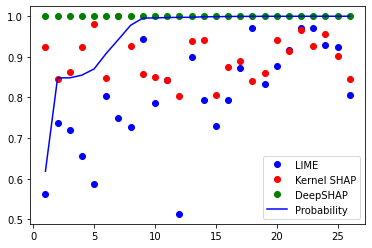

In [28]:
plt.plot(instances, stability_scores, 'bo', label = 'LIME')
plt.plot(instances, shap_stability_scores, 'ro', label = 'Kernel SHAP')
plt.plot(instances, deep_stability_scores, 'go', label = 'DeepSHAP')
plt.plot(instances, probas, 'b-', label = "Probability")
plt.legend()
plt.show()